<a href="https://colab.research.google.com/github/wzgstein/CovTesting/blob/main/Hypothesis_Testing_for_Covariance_Matrix_in_the_ultra_high_dimensional_setting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook delves into the challenges and methodologies associated with Hypothesis Testing for Sample Covariance Matrices in ultra-high dimensional scenarios.

Initially, we provide an illustrative walkthrough based on the research by X. Ding and Z. Wang, titled "Global and local CLTs for linear spectral statistics of general sample covariance matrices when the dimension is much larger than the sample size with applications". The paper can be accessed on arXiv: 2308.08646.

Subsequent sections explore:

- One-sample hypothesis testing using real-world data.
- Two-sample hypothesis testing for covariance matrices.


These explorations are precursors to our forthcoming research in this domain.

# Prerequisite

## How to use

Within the section for most figures, the codes are divided into three blocks.

- Data  generating
- Saved data
- Plot

What you need to do depends on how you want to use it

- If you just want to see some existing results, no need to do anything except reading.
- If you just want to see some existing data and results, go to the output of the block "Plot" directly, or run "Saved data" then "Plot".
- If you want to check, replicate or change parameters, modify the subsection "Data generating" accordingly, then run the block "Plot".

## Additional note if you want to run this notebook locally

This notebook use the Google jax to accelerate the sampling and calculation of large random matrices, for jax we refer to https://github.com/google/jax.

The jax framework has been readily to use in the colab.
To use the notebook in a local server/environment, you may need to install jax first. To install jax, use the command


In [ ]:
## cpu version
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

# ##or
# ## gpu version
# !pip install --upgrade pip

# # CUDA 12 installation
# # Note: wheels only available on linux.
# !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# # CUDA 11 installation
# # Note: wheels only available on linux.
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


This file was created with Google Colab, so for a ready-to-use environment you can also view the document with the link  https://colab.research.google.com/drive/1xTWEHXadpq0Rb8Y0ADE-7lzpAtBDH-KK?usp=sharing where you can run or modify without setting up environment locally.





## Necessary Functions



This block contain most of the global functions needed. If you want to replicate the results, please run this block before any other blocks.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import scipy.integrate as integrate
from google.colab import files
from scipy.stats import norm



def bold_legend(legend):
    """Utility function to set legend text to bold."""
    for text in legend.get_texts():
        text.set_fontweight('bold')

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]

###########################
####Here the example functions are mainly written for $\Sigma=\operatorname{Tr}\{a,\ldots,a,b,\ldots,b\}$ where they are a repeated (s*m) times and b repeated (1-s)*m times in the diagonal.
#########################
# Calculate the Stieltjes transform
def stieltjes(z,phi,r,s,a,b):
    p=[a*b*z, (a+b)*r*z+a*b*(1-phi),phi*z+(a+b)*r-s*a*phi*r-(1-s)*b*phi*r,phi]
    ro=np.roots(p)
    if (np.imag(ro[0])>0):
      st=ro[0];
    elif (np.imag(ro[1])>0):
      st=ro[1];
    elif (np.imag(ro[2])>0):
      st=ro[2];
    else:
      print("error")
    return st


## Calculate the approximate density function while taking the  imaginary part to close to zero
def lsd(x,phi,r,s,a,b):
    return np.imag(stieltjes(x+0.001j,phi,r,s,a,b))/np.pi

def generate_eigenvalues(key, Sigmad, m, n):
    X = random.normal(key, shape=(m, n))
    X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E0 = jnp.linalg.eigvalsh(H)
    return E0
def plot_eigenvalues_histogram(phi=0.9, R=20, n=800, a=1, b=15, s=1/2):
    ratio = phi
    r = np.sqrt(phi)
    E_start = -1
    E_end = (s*a+(1-s)*b)*r + 2*np.sqrt(s*a**2+(1-s)*b**2) + 25
    E_values = np.arange(E_start, E_end, 0.01)
    m_imag_values = [lsd(E, phi, r, s, a, b) if E >= 0.1 else 0 for E in E_values]

    m = int(n * phi)
    F1 = jnp.array([])
    Sigmad = jnp.concatenate([jnp.repeat(a, int(s * m)), jnp.repeat(b, int((1 - s) * m))])

    key = random.PRNGKey(0)

    for i in range(R):
        key, subkey = random.split(key)
        E0 = generate_eigenvalues(subkey, Sigmad, m, n)
        F1 = jnp.concatenate([F1, E0]) if F1.shape[0] > 0 else E0

    # Clear unneeded data
    del Sigmad
    del E0

    F1_filtered = F1[F1 > 0.01]
    FF1 = np.array(F1_filtered)
    # Plotting
    if phi<1:
        plt.xlim(-1, (s*a+(1-s)*b)*(1/np.sqrt(phi))+40)
    else:
        plt.xlim( (s*a+(1-s)*b)*(np.sqrt(phi))-30, (s*a+(1-s)*b)*(np.sqrt(phi))+50)
    # plt.ylim(0, 0.35)

    if phi > 1:
        # Use histogram directly for phi > 1
        plt.hist(FF1, bins=200, density=True, alpha=0.9, label='histogram')
    else:
        # Use bar plot for phi <= 1
        scaling_factor = phi
        hist_values, bin_edges = np.histogram(FF1, bins=200, density=True)
        scaled_hist_values = hist_values * scaling_factor
        bin_widths = bin_edges[1:] - bin_edges[:-1]
        plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_widths, align='edge', alpha=0.9, label='histogram')

    plt.plot(E_values, m_imag_values, color='red', label="theoretical")

    # Legend and formatting
    legend = plt.legend(loc="upper right", fontsize='xx-large')
    for text in legend.get_texts():
        text.set_fontweight('bold')
    ax = plt.gca()
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(12)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(12)
    plt.tight_layout()
    plt.show()




def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y


## Compare the ECDFs of two data sets, specifically when $kappa_4 = or \neq 0$
def plot_ecdf2(data1, data2, label1="", label2="", filename=None):
    # Normalize data using the mean and variance of data1
    mean_data1 = np.mean(data1)
    std_data1 = np.std(data1)

    data1_norm = (data1 - mean_data1) / std_data1
    data2_norm = (data2 - mean_data1) / std_data1

    # Compute ECDF for normalized data
    x_data1_norm, y_data1_norm = ecdf(data1_norm)
    x_data2_norm, y_data2_norm = ecdf(data2_norm)

    # Plot ECDFs
    plt.figure(figsize=(10, 7))
    plt.plot(x_data1_norm, y_data1_norm, marker='.', linestyle='none', color='blue', label=label1)
    plt.plot(x_data2_norm, y_data2_norm, marker='.', linestyle='none', color='red', label=label2)

    # Formatting
    plt.xticks(fontweight='bold', fontsize=16)
    plt.yticks(fontweight='bold', fontsize=16)
    plt.legend(fontsize=25)
    plt.tight_layout()

    # Save the plot if filename is provided
    if filename:
        plt.savefig(filename)
        files.download(filename)

    # Display the plot
    plt.show()


## Compare the ECDFs of multiple normalized data sets with ECDF of standard normal

def plot_ecdf_and_standard_normal_cdf(*data_sets, labels=None):

    # Ensure that the number of datasets matches the number of labels
    if len(data_sets) != len(labels):
        raise ValueError("Number of datasets must match the number of labels.")

    plt.rcParams['text.usetex'] = False
    normal_x = np.arange(-4, 4.001, 0.001)
    standard_normal_cdf = norm.cdf(normal_x)

    for idx, data in enumerate(data_sets):
        sorted_data = np.sort(data)
        cumulative_probabilities = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        label = labels[idx] if labels else f"Data {idx+1}"
        plt.plot(sorted_data, cumulative_probabilities, linestyle='-', linewidth=0.8, label=label)

    plt.plot(normal_x, standard_normal_cdf, linestyle='-', linewidth=0.8, label=r'$\mathbf{N(0,1)}$')
    plt.ylabel('Cumulative Probability', fontweight='bold', fontsize=18)
    legend = plt.legend(loc="upper left", fontsize=16)
    plt.xlim(-4, 4)
    bold_legend(legend)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax = plt.gca()
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    plt.show()

##############################################################
############Functions for doing hypothesis testing for $\Sigma=Id$

import numpy as np
from scipy.stats import chi2
from numpy.linalg import svd
from statsmodels.stats.correlation_tools import cov_nearest









from scipy.stats import norm
import numpy as np
def sample_covariance_matrix(data):
    n, p = data.shape  ###nneed fix but not essential
    # mean = np.mean(data, axis=0)
    # centered_data = data - mean
    centered_data=data
    cov_matrix = np.dot(centered_data,centered_data.T) / n
    return cov_matrix

def CLRT(data, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # p, n = data.shape #n> p
    n, p = data.shape #p>n
    S = sample_covariance_matrix(data)
    n,p=p,n
    log_det_S = np.log(np.linalg.det(S))
    # print(log_det_S)
    # log_det_I = np.log(np.linalg.det(np.eye(p)))
    # print(log_det_I)
    # Calculate likelihood ratio test statistic
    CLRT_stat = (-log_det_S+p*np.log(np.trace(S)/p)+(p-n)*np.log(1-p/n)-p+1/2*np.log(1-p/n))/np.sqrt(-2*np.log(1-p/n)-2*p/n)
    z_score=CLRT_stat
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")

    return p_value


def CLRTpln(data, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # p, n = data.shape #n> p
    n, p = data.shape #p>n
    S = sample_covariance_matrix(data)
    log_det_S = np.log(np.linalg.det(S))
    # print(log_det_S)
    # log_det_I = np.log(np.linalg.det(np.eye(p)))
    # print(log_det_I)
    # Calculate likelihood ratio test statistic
    CLRT_stat = (-log_det_S+p*np.log(np.trace(S)/p)+(p-n)*np.log(1-p/n)-p+1/2*np.log(1-p/n))/np.sqrt(-2*np.log(1-p/n)-2*p/n)
    z_score=CLRT_stat
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")

    return p_value



def DW2023Global(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # m=X.shape[0]
    # n=X.shape[1]
    m=X.shape[1]
    n=X.shape[0]
    phi=m/n
    r=np.sqrt(phi)
    centerc=r+1/r+c
    H = np.matmul(X, X.T) / np.sqrt(n * m)-centerc*np.identity(n)
    TestST=np.trace(H)
    z_score=(TestST-n*(c-1/r))/np.sqrt(2+K4)
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")
    return p_value




### Global Test based on x^2
def DW2023Global2(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # m=X.shape[0]
    # n=X.shape[1]
    m=X.shape[1]
    n=X.shape[0]
    phi=m/n
    r=np.sqrt(phi)
    centerc=r+1/r+c
    H = np.matmul(X, X.T) / np.sqrt(n * m)-centerc*np.identity(n)
    TestST=np.trace(np.matmul(H, H))
    # print(TestST)
    z_score=(TestST-(n*(1+c**2-2*c/r+1/phi)+1))/np.sqrt(4+8*c**2) ### not yet modified by kappa4
    # print(z_score)
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")
    return p_value


### Global Test based on x^2 excluding spikes or near 0 eigenvalues
def DW2023Global2modified(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    m = X.shape[1]
    n = X.shape[0]
    phi = m/n
    r = np.sqrt(phi)
    centerc = r + 1/r + c
    H = np.matmul(X, X.T) / np.sqrt(n * m) - centerc * np.identity(n)

    # Compute eigenvalues of H
    eigvals = np.linalg.eigvalsh(H)

    # Filter eigenvalues below 10^-3 and above 100
    filtered_eigvals = eigvals[(eigvals < 1e-3) | (eigvals > 100)]

    # Subtract the sum of squares of filtered eigenvalues from TestST
    TestST = np.trace(np.matmul(H, H)) - np.sum(filtered_eigvals**2)

    # Record the number of such eigenvalues as ns
    ns = len(filtered_eigvals)

    z_score = (TestST - (ns * (1 + c**2 - 2*c/r + 1/phi) + 1)) / np.sqrt(4 + 8*c**2)  # Modified by kappa4

    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")

    return p_value

# def DW2023Global2modified(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
#     # m=X.shape[0]
#     # n=X.shape[1]
#     m=X.shape[1]
#     n=X.shape[0]
#     phi=m/n
#     r=np.sqrt(phi)
#     centerc=r+1/r+c
#     H = np.matmul(X, X.T) / np.sqrt(n * m)-centerc*np.identity(n)

#     eigvals = np.linalg.eigvalsh(H)  # Compute eigenvalues of H, in ascending order
#     max_eigval = eigvals[-1]  # Extract the largest eigenvalue

#     TestST = np.trace(np.matmul(H, H)) - max_eigval**2
#     print(TestST)
#     z_score=(TestST-(n*(1+c**2-2*c/r+1/phi)+1))/np.sqrt(4+8*c**2) ### not yet modified by kappa4
#     print(z_score)
#     if alternative == 'two-sided':
#         p_value = 2 * (1 - norm.cdf(abs(z_score)))
#     elif alternative == 'greater':
#         p_value = 1 - norm.cdf(z_score)
#     elif alternative == 'less':
#         p_value = norm.cdf(z_score)
#     else:
#         raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")
#     return p_value




def DW2023Local(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # m=X.shape[0]
    # n=X.shape[1]
    m=X.shape[1]
    n=X.shape[0]
    phi=m/n
    r=np.sqrt(phi)
    leftb=r+1/r-2+c
    H = np.matmul(X, X.T) / np.sqrt(n * m)
    E0, _ = np.linalg.eigh(H)
    eta=1/(n**(1/4))
    # print(E0)
    Et = np.array(extract_elements(E0, leftb-eta, leftb+eta))
    # print(Eb)
    # print(E0[-k:])
    Eb = (Et - leftb*np.ones(Et.shape))/eta
    # print(Eb)
    TestST=np.sum(Eb)
    z_score=(TestST-Mean_x)/np.sqrt(Variance_x)
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")

    return p_value






def Nagao1973(x, significant_level=0.05, Sigma = "identity"):
    if isinstance(x, np.ndarray):
        return Nagao1973_matrix(x, significant_level, Sigma)
    elif isinstance(x, np.cov):
        return Nagao1973_covariance(x, significant_level, Sigma)

def Nagao1973_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    # n = x.shape[0] + 1
    n = x.shape[0]
    S = x

    if Sigma == "identity":
        S_ = x
    else:
        svCov = svd(x)
        sv = svd(Sigma)
        x_ = svCov[0] @ np.diag(np.sqrt(svCov[1])) @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))
        S_ = x_.T @ x_


    statistic = Nagao1973_(n, p, S_)
    parameter = p * (p + 1) / 2
    p_value = 1 - chi2.cdf(statistic, parameter)
    # null_value=(p_value > significant_level)
    # estimate = S
    # estimate = None if estimate.shape[0] > 5 else estimate

    # obj = {'statistic': statistic,
    #        'parameter': parameter,
    #        'p.value': p_value,
    #        'estimate': estimate,
    #        'null.value': null_value,
    #        'alternative': "two.sided",
    #        'method': "Nagao 1973 Test of Covariance Matrix Structure"}

    return p_value

def Nagao1973_matrix(x,significant_level=0.05, Sigma = "identity"):

    p = x.shape[1]
    n = x.shape[0]

    S = np.cov(x, rowvar=False)

    if Sigma == "identity":
        S_ = S
    else:
        sv = svd(Sigma)
        svDf = svd(S)
        x_ = svDf[0] @ np.diag(np.sqrt(sv[1])) @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))
        S_ = x_.T @ x_

    statistic = Nagao1973_(n, p, S_)
    parameter = p * (p + 1) / 2
    p_value = 1 - chi2.cdf(statistic, parameter)
    # null_value=(p_value > significant_level)

    # estimate = S
    # estimate = None if estimate.shape[0] > 5 else estimate

    # obj = {'statistic': statistic,
    #        'parameter': parameter,
    #        'p.value': p_value,
    #        'estimate': estimate,
    #        'null.value': null_value,
    #        'alternative': "two.sided",
    #        'method': "Nagao 1973 Test of Covariance Matrix Structure"}

    return p_value

def Nagao1973_(n, p, S_):
    mid = S_ - np.eye(p)
    return n * p * (np.trace(mid @ mid) / p) / 2




import numpy as np
from scipy.stats import norm
from numpy.linalg import svd
from statsmodels.stats.correlation_tools import cov_nearest


def Srivastava2005(x, significant_level=0.05, Sigma = "identity"):
    if isinstance(x, np.ndarray):
        return Srivastava2005_matrix(x, significant_level, Sigma = "identity")
    elif isinstance(x, np.cov):
        return Srivastava2005_covariance(x, significant_level, Sigma = "identity")

def Srivastava2005_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0] + 1
    S = x

    if Sigma == "identity":
        S_ = x
    else:
        svCov = svd(x)
        sv = svd(Sigma)
        x_ = svCov[0] @ np.diag(np.sqrt(svCov[1])) @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))
        S_ = x_.T @ x_

    statistic = Srivastava2005Stat(S_)  # replace Srivastava2005Stat with the correct function
    parameter = np.array([0, 1])

    p_value = 1 - norm.cdf(np.abs(statistic))
    # null_value =  (p_value > significant_level)

    # estimate = S
    # estimate = None if estimate.shape[0] > 5 else estimate

    # obj = {'statistic': statistic,
    #        'parameter': parameter,
    #        'p.value': p_value,
    #        'estimate': estimate,
    #        'null.value': null_value,
    #        'alternative': "two.sided",
    #        'method': "Srivastava 2005 Test of Covariance Matrix Structure"}

    return p_value

def Srivastava2005_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x, rowvar=False)

    if Sigma == "identity":
        S_ = S
    else:
        sv = svd(Sigma)
        svDf = svd(S)
        x_ = svDf[0] @ np.diag(np.sqrt(sv[1])) @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))
        S_ = x_.T @ x_

    statistic = Srivastava2005Stat(S_)  # replace Srivastava2005Stat with the correct function
    parameter = np.array([0, 1])
    p_value = 1 - norm.cdf(np.abs(statistic))
    # null_value = (p_value > significant_level)
    # estimate = S
    # estimate = None if estimate.shape[0] > 5 else estimate

    # obj = {'statistic': statistic,
    #        'parameter': parameter,
    #        'p.value': p_value,
    #        'estimate': estimate,
    #        'null.value': null_value,
    #        'alternative': "two.sided",
    #        'method': "Srivastava 2005 Test of Covariance Matrix Structure"}

    return p_value



def Srivastava2005Stat(x):
    ncol = x.shape[1]
    nrow = x.shape[0]

    return nrow * ((np.power(nrow, 2.0) / (ncol * (nrow - 1.0) * (nrow + 2.0))) *
                   (np.trace(np.dot(x, x)) - np.power(np.trace(x), 2.0) / nrow) -
                   2.0 * np.trace(x) / ncol + 1.0) / 2.0





from scipy.stats import norm
from scipy.linalg import svd
import numpy as np

def Srivastava2011(x, significant_level=0.05, Sigma = "identity"):
    if isinstance(x, np.ndarray):
        return Srivastava2011_matrix(x, significant_level, Sigma = "identity")
    elif isinstance(x, np.cov):
        return Srivastava2011_covariance(x, significant_level, Sigma = "identity")

def Srivastava2011_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = x

    if Sigma == "identity":
        S_ = x
    else:
        svCov_u, svCov_d, _ = svd(x)
        sv_u, sv_d, _ = svd(Sigma)
        x_ = svCov_u @ np.diag(np.sqrt(svCov_d)) @ np.linalg.inv(sv_u @ np.diag(np.sqrt(sv_d)))
        S_ = x_.T @ x_

    statistic = Srivastava2011_(n - 1, p, S_)
    parameter = np.array([0, 1])

    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)

    # estimate = S
    # if estimate.shape[0] > 5:
    #     estimate = None

    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": estimate,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Srivastava et al. 2011 Test of Covariance Matrix Structure"}

    return p_value


def Srivastava2011_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x, rowvar=False)

    if Sigma == "identity":
        S_ = S
    else:
        sv_u, sv_d, _ = svd(Sigma)
        svDf_u, svDf_d, _ = svd(S)
        x_ = svDf_u @ np.diag(np.sqrt(sv_d)) @ np.linalg.inv(sv_u @ np.diag(np.sqrt(sv_d)))
        S_ = x_.T @ x_

    statistic = Srivastava2011_(n - 1, p, S_)
    parameter = np.array([0, 1])

    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)
    # estimate = S
    # if estimate.shape[0] > 5:
    #     estimate = None

    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": estimate,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Srivastava et al. 2011 Test of Covariance Matrix Structure"}

    return p_value


def Srivastava2011_(n, p, S_):
    S_squared = S_ @ S_
    tr_S_squared = np.trace(S_squared)
    tr_S = np.trace(S_)
    return n * (((n ** 2) / ((n - 1) * (n + 2))) * (tr_S_squared - (tr_S ** 2) / n) / p -
                2 * (tr_S / p) + 1) / 2



from scipy.stats import norm
from numpy.linalg import svd, solve
import numpy as np

def Chen2010(x, significant_level=0.05, Sigma = "identity"):
    if type(x) is np.ndarray:
        return Chen2010_matrix(x, significant_level, Sigma = "identity")
    else:
        return Chen2010_covariance(x, significant_level, Sigma = "identity")

def Chen2010_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0] + 1
    S = x

    if Sigma == "identity":
        svCov_u, svCov_d, _ = svd(x)
        x_ = svCov_u @ np.diag(np.sqrt(svCov_d))
    else:
        svCov_u, svCov_d, _ = svd(x)
        sv_u, sv_d, _ = svd(Sigma)
        x_ = svCov_u @ np.diag(np.sqrt(svCov_d)) @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))

    statistic = Chen2010Stat(x_)
    parameter = [0, 1]


    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)
    # estimate = None if S.shape[0] > 5 else S

    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": estimate,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Chen et al. 2010 Test of Covariance Matrix Structure"}

    return p_value

def Chen2010_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x.T)

    if Sigma == "identity":
        x_ = x
        # print(1)
    else:
        # print(2)
        sv_u, sv_d, _ = svd(Sigma)
        x_ = x @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))

    statistic = Chen2010Stat(x_)
    parameter = [0, 1]


    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)
    # estimate = None if S.shape[0] > 5 else S

    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": estimate,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Chen et al. 2010 Test of Covariance Matrix Structure"}

    return p_value


# import scipy.special as sp
# def Chen2010Stat(x):
#     nrow, ncol = x.shape
#     quadraNum = 0
#     bilinearoffNum = 0
#     bilinearcubeNum = 0
#     bilinearsquareNum = 0
#     bilinearquadNum = 0

#     for i in range(nrow):
#         quadraNum += (x[i, :].reshape(-1, 1).T @ x[i, :].reshape(-1, 1)).item()
#         for j in range(i + 1, nrow):
#             bilinearoffNum += (x[i, :].reshape(-1, 1).T @ x[j, :].reshape(-1, 1)).item()
#             bilinearsquareNum += (x[i, :].reshape(-1, 1).T @ x[j, :].reshape(-1, 1) @ x[i, :].reshape(-1, 1).T @ x[j, :].reshape(-1, 1)).item()
#             for k in range(j + 1, nrow):
#                 bilinearcubeNum += (x[i, :].reshape(-1, 1).T @ x[j, :].reshape(-1, 1) @ x[j, :].reshape(-1, 1).T @ x[k, :].reshape(-1, 1)).item()
#                 for l in range(k + 1, nrow):
#                     bilinearquadNum += (x[i, :].reshape(-1, 1).T @ x[j, :].reshape(-1, 1) @ x[k, :].reshape(-1, 1).T @ x[l, :].reshape(-1, 1)).item()

#     bilinearquad = bilinearquadNum * 24.0 / (sp.gamma(nrow + 1.0) / sp.gamma(nrow - 3.0))
#     bilinearsquare = bilinearsquareNum * 2.0 / (sp.gamma(nrow + 1.0) / sp.gamma(nrow - 1.0))
#     bilinearcube = bilinearcubeNum * 6.0 / (sp.gamma(nrow + 1.0) / sp.gamma(nrow - 2.0))
#     bilinearoff = bilinearoffNum * 2.0 / (sp.gamma(nrow + 1.0) / sp.gamma(nrow - 1.0))
#     quadra = quadraNum / nrow

#     return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0



# import numpy as np
# from scipy.special import gamma

# def Chen2010Stat(x):
#     nrow, ncol = x.shape
#     quadraNum = 0
#     bilinearoffNum = 0
#     bilinearcubeNum = 0
#     bilinearsquareNum = 0
#     bilinearquadNum = 0

#     for i in range(nrow):
#         quadraNum += np.sum(np.dot(x[i, :], x[i, :]))
#         for j in range(i + 1, nrow):
#             bilinearoffNum += np.sum(np.dot(x[i, :], x[j, :]))
#             bilinearsquareNum += np.sum(np.dot(x[i, :], x[j, :]) ** 2)
#             for k in range(j + 1, nrow):
#                 bilinearcubeNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[j, :], x[k, :]))
#                 for l in range(k + 1, nrow):
#                     bilinearquadNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[k, :], x[l, :]))

#     bilinearquad = bilinearquadNum * 24.0 / (gamma(nrow + 1.0) / gamma(nrow - 3.0))
#     bilinearsquare = bilinearsquareNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     bilinearcube = bilinearcubeNum * 6.0 / (gamma(nrow + 1.0) / gamma(nrow - 2.0))
#     bilinearoff = bilinearoffNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     quadra = quadraNum / nrow

#     return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0

import numpy as np
from scipy.special import gamma

# def Chen2010Stat(x):
#     nrow, ncol = x.shape
#     quadraNum = 0
#     bilinearoffNum = 0
#     bilinearcubeNum = 0
#     bilinearsquareNum = 0
#     bilinearquadNum = 0

#     for i in range(nrow):
#         quadraNum += np.sum(np.dot(x[i, :], x[i, :]))
#         for j in range(i + 1, nrow):
#             bilinearoffNum += np.sum(np.dot(x[i, :], x[j, :]))
#             bilinearsquareNum += np.sum(np.dot(x[i, :], x[j, :]) ** 2)
#             for k in range(j + 1, nrow):
#                 bilinearcubeNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[j, :], x[k, :]))
#                 for l in range(k + 1, nrow):
#                     bilinearquadNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[k, :], x[l, :]))

#     bilinearquad = bilinearquadNum * 24.0 / (gamma(nrow + 1.0) / gamma(nrow - 3.0))
#     bilinearsquare = bilinearsquareNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     bilinearcube = bilinearcubeNum * 6.0 / (gamma(nrow + 1.0) / gamma(nrow - 2.0))
#     bilinearoff = bilinearoffNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     quadra = quadraNum / nrow

#     return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0

## vect trial
# def Chen2010Stat(x):
#     nrow, ncol = x.shape
#     quadraNum = 0
#     bilinearoffNum = 0
#     bilinearcubeNum = 0
#     bilinearsquareNum = 0
#     bilinearquadNum = 0
#     wholerow=np.zeros(p)
#     Y1=0
#     for i in range(nrow):
#         wholerow+=np.sum(x[i,:])
#         Y1+=np.sum(np.dot(x[i, :], x[i, :]))

#     for i in range(nrow):
#         quadraNum += np.sum(np.dot(x[i, :], x[i, :]))
#         for j in range(i + 1, nrow):
#             bilinearoffNum += np.sum(np.dot(x[i, :], x[j, :]))
#             bilinearsquareNum += np.sum(np.dot(x[i, :], x[j, :]) ** 2)
#             for k in range(j + 1, nrow):
#                 bilinearcubeNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[j, :], x[k, :]))
#                 for l in range(k + 1, nrow):
#                     bilinearquadNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[k, :], x[l, :]))

#     bilinearquad = bilinearquadNum * 24.0 / (gamma(nrow + 1.0) / gamma(nrow - 3.0))
#     bilinearsquare = bilinearsquareNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     bilinearcube = bilinearcubeNum * 6.0 / (gamma(nrow + 1.0) / gamma(nrow - 2.0))
#     bilinearoff = bilinearoffNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     quadra = quadraNum / nrow

#     return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0



# import numpy as np
# from scipy.special import gamma

# def Chen2010Stat(x):
#     nrow, ncol = x.shape

#     quadraNum = np.sum(x * x)
#     bilinearoffNum = np.sum(np.dot(x, x.T)) - quadraNum

#     bilinearcubeNum = 0
#     bilinearsquareNum = 0
#     bilinearquadNum = 0

#     for i in range(nrow):
#         for j in range(i + 1, nrow):
#             bilinearsquareNum += np.sum(np.dot(x[i, :], x[j, :]) ** 2)
#             for k in range(j + 1, nrow):
#                 bilinearcubeNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[j, :], x[k, :]))
#                 for l in range(k + 1, nrow):
#                     bilinearquadNum += np.sum(np.dot(x[i, :], x[j, :]) * np.dot(x[k, :], x[l, :]))

#     bilinearquad = bilinearquadNum * 24.0 / (gamma(nrow + 1.0) / gamma(nrow - 3.0))
#     bilinearsquare = bilinearsquareNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     bilinearcube = bilinearcubeNum * 6.0 / (gamma(nrow + 1.0) / gamma(nrow - 2.0))
#     bilinearoff = bilinearoffNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
#     quadra = quadraNum / nrow

#     return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0

from numba import njit
import numpy as np
from scipy.special import gamma

@njit
def Chen2010Stat_numba_helper(nrow, ncol, x):
    bilinearcubeNum = 0
    bilinearsquareNum = 0
    bilinearquadNum = 0

    for i in range(nrow):
        for j in range(i + 1, nrow):
            dot_product_ij = np.dot(x[i, :], x[j, :])
            bilinearsquareNum += dot_product_ij ** 2
            for k in range(j + 1, nrow):
                dot_product_jk = np.dot(x[j, :], x[k, :])
                bilinearcubeNum += dot_product_ij * dot_product_jk
                for l in range(k + 1, nrow):
                    dot_product_kl = np.dot(x[k, :], x[l, :])
                    bilinearquadNum += dot_product_ij * dot_product_kl

    return bilinearsquareNum, bilinearcubeNum, bilinearquadNum


def Chen2010Stat(x):
    nrow, ncol = x.shape
    quadraNum = np.sum(x * x)
    bilinearoffNum = np.sum(np.dot(x, x.T)) - quadraNum
    bilinearsquareNum, bilinearcubeNum, bilinearquadNum = Chen2010Stat_numba_helper(nrow, ncol, x)

    bilinearquad = bilinearquadNum * 24.0 / (gamma(nrow + 1.0) / gamma(nrow - 3.0))
    bilinearsquare = bilinearsquareNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
    bilinearcube = bilinearcubeNum * 6.0 / (gamma(nrow + 1.0) / gamma(nrow - 2.0))
    bilinearoff = bilinearoffNum * 2.0 / (gamma(nrow + 1.0) / gamma(nrow - 1.0))
    quadra = quadraNum / nrow

    return nrow * (bilinearsquare / ncol - 2.0 * bilinearcube / ncol + bilinearquad / ncol - 2.0 * quadra / ncol + 2.0 * bilinearoff / ncol + 1.0) / 2.0



from scipy.stats import chi2
from numpy.linalg import svd, solve
import numpy as np

def LedoitWolf2002(x, significant_level=0.05, Sigma = "identity"):
    if type(x) is np.ndarray:
        return LedoitWolf2002_matrix(x, significant_level, Sigma = "identity")
    else:
        return LedoitWolf2002_covariance(x, significant_level, Sigma = "identity")

def LedoitWolf2002_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0] + 1
    S = x

    if Sigma == "identity":
        S_ = x
    else:
        svCov_u, svCov_d, _ = svd(x)
        sv_u, sv_d, _ = svd(Sigma)
        x_ = svCov_u @ np.diag(np.sqrt(svCov_d)) @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))
        S_ = x_.T @ x_

    statistic = LedoitWolf2002_stat(n, p, S_)

    parameter = p * (p + 1) / 2



    p_value = 1 - chi2.cdf(statistic, parameter)
    # null_value = (p_value>significant_level)
    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": S,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Ledoit and Wolf 2002 Test of Covariance Matrix Structure"}

    return p_value

def LedoitWolf2002_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x.T)

    if Sigma == "identity":
        S_ = S
    else:
        sv_u, sv_d, _ = svd(Sigma)
        svDf_u, svDf_d, _ = svd(S)
        x_ = svDf_u @ np.diag(np.sqrt(sv_d)) @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))
        S_ = x_.T @ x_

    statistic = LedoitWolf2002_stat(n, p, S_)

    parameter = p * (p + 1) / 2


    p_value = 1 - chi2.cdf(statistic, parameter)
    # null_value = (p_value>significant_level)
    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": S,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Ledoit and Wolf 2002 Test of Covariance Matrix Structure"}

    return p_value

def LedoitWolf2002_stat(n, p, S_):
    mid = S_ - np.eye(p)
    statistic = n * p * (np.trace(mid @ mid) / p - (p / n) * ((np.trace(S_) / p) ** 2) + (p / n)) / 2
    return statistic





from scipy.stats import norm
from numpy.linalg import svd, solve
import numpy as np

def Fisher2012(x, significant_level=0.05, Sigma = "identity"):
    if type(x) is np.ndarray:
        return Fisher2012_matrix(x, significant_level, Sigma = "identity")
    else:
        return Fisher2012_covariance(x, significant_level, Sigma = "identity")

def Fisher2012_covariance(x, significant_level, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0] + 1
    S = x

    if Sigma == "identity":
        S_ = x
    else:
        svCov_u, svCov_d, _ = svd(x)
        sv_u, sv_d, _ = svd(Sigma)
        x_ = svCov_u @ np.diag(np.sqrt(svCov_d)) @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))
        S_ = x_.T @ x_

    statistic = Fisher2012_stat(n - 1, p, S_)

    parameter = [0, 1]



    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)
    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": S if S.shape[0] <= 5 else None,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Fisher 2012 Test of Covariance Matrix Structure"}

    return p_value

def Fisher2012_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x.T)

    if Sigma == "identity":
        S_ = S
    else:
        sv_u, sv_d, _ = svd(Sigma)
        svDf_u, svDf_d, _ = svd(S)
        x_ = svDf_u @ np.diag(np.sqrt(sv_d)) @ solve(sv_u @ np.diag(np.sqrt(sv_d)), np.eye(p))
        S_ = x_.T @ x_

    statistic = Fisher2012_stat(n - 1, p, S_)

    parameter = [0, 1]



    p_value = 1 - norm.cdf(abs(statistic))
    # null_value = (p_value>significant_level)
    # result = {"statistic": statistic,
    #           "parameter": parameter,
    #           "p.value": p_value,
    #           "estimate": S if S.shape[0] <= 5 else None,
    #           "null.value": null_value,
    #           "alternative": "two.sided",
    #           "method": "Fisher 2012 Test of Covariance Matrix Structure"}

    return p_value

def Fisher2012_stat(n, p, S_):
    c = p / n
    ahat2 = (n ** 2 / ((n - 1) * (n + 2) * p)) * (np.trace(S_ @ S_) - (np.trace(S_) ** 2) / n)
    gamma = (n ** 5 * (n ** 2 + n + 2)) / ((n + 1) * (n + 2) * (n + 4) * (n + 6) * (n - 1) * (n - 2) * (n - 3))
    ahat4 = (gamma / p) * (np.trace(S_ @ S_ @ S_ @ S_) -(4 / n) * np.trace(S_ @ S_ @ S_) *np.trace(S_) -((2 * n ** 2 + 3 * n - 6) / (n * (n ** 2 + n + 2))) *
            (np.trace(S_ @ S_) ** 2) +((2 * (5 * n + 6)) / (n * (n ** 2 + n + 2))) *np.trace(S_ @ S_) * (np.trace(S_) ** 2) -((5 * n + 6) / ((n ** 2) * (n ** 2 + n + 2))) *(np.trace(S_) ** 4))
    return (n / np.sqrt(8 * (c ** 2 + 12 * c + 8))) * (ahat4 - 2 * ahat2 + 1)




import numpy as np
from scipy.stats import norm
from numpy.linalg import svd

def Ahmad2015(x, significant_level=0.05, Sigma = "identity"):
    if isinstance(x, np.ndarray):
        if len(x.shape) == 1 or x.shape[0] == 1 or x.shape[1] == 1:
            raise ValueError("Input must be a matrix or a 2D array.")
        elif x.shape[0] != x.shape[1]:  # this is a matrix
            return Ahmad2015_matrix(x, significant_level, Sigma = "identity")
        else:  # this is a covariance matrix
            return Ahmad2015_covariance(x, significant_level, Sigma = "identity")
    else:
        raise TypeError("Input must be a matrix or a 2D array.")

def Ahmad2015_covariance(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0] + 1
    S = x

    if Sigma == "identity":
        svCov = svd(x)
        x_ = svCov[0] @ np.diag(np.sqrt(svCov[1]))
    else:
        svCov = svd(x)
        sv = svd(Sigma)
        x_ = svCov[0] @ np.diag(np.sqrt(svCov[1])) @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))

    # statistic = Ahmad2015Stat(x_)
    statistic = Ahmad2015Stat(x_)  # You need to provide the Ahmad2015Stat function

    parameter = [0, 4 * (2 / (p / n + 1))]



    p_value = 1 - norm.cdf(abs(statistic), 0, 4 * (2 / (p / n + 1)))
    # null_value = (p_value>significant_level)
    # estimate = S if S.shape[0] <= 5 else None

    # result= {
    #     "statistic": statistic,
    #     "parameter": parameter,
    #     "p_value": p_value,
    #     "estimate": estimate,
    #     "null_value": null_value,
    #     "alternative": "two.sided",
    #     "method": "Ahmad and Rosen 2015 Test of Covariance Matrix Structure"
    # }
    return p_value

def Ahmad2015_matrix(x, significant_level=0.05, Sigma = "identity"):
    p = x.shape[1]
    n = x.shape[0]
    S = np.cov(x, rowvar=False)

    if Sigma == "identity":
        x_ = x
    else:
        sv = svd(Sigma)
        x_ = x @ np.linalg.inv(sv[0] @ np.diag(np.sqrt(sv[1])))

    # statistic = Ahmad2015Stat(x_)
    statistic = Ahmad2015Stat(x_)  # You need to provide the Ahmad2015Stat function

    parameter = [0, 4 * (2 / (p / n + 1))]


    p_value = 1 - norm.cdf(abs(statistic), 0, 4 * (2 / (p / n + 1)))
    # null_value = (p_value>significant_level)
    # estimate = S if S.shape[0] <= 5 else None

    # result={
    #     "statistic": statistic,
    #     "parameter": parameter,
    #     "p_value": p_value,
    #     "estimate": estimate,
    #     "null_value": null_value,
    #     "alternative": "two.sided",
    #     "method": "Ahmad and Rosen 2015 Test of Covariance Matrix Structure"
    # }
    return p_value



def Ahmad2015Stat(x):
    ncol = x.shape[1]
    nrow = x.shape[0]
    c3num = 0
    c1num = 0

    for i in range(nrow):
        c1num += np.sum(x[i, :] ** 2)
        for j in range(i + 1, nrow):
            c3num += np.sum(x[i, :] * x[j, :]) ** 2

    c3 = c3num * 2.0 / (nrow * (nrow - 1.0))

    c1 = c1num / nrow

    return nrow * (c3 / ncol - 2.0 * c1 / ncol + 1.0)



# One-Sample Hypothesis Testing: Simulated Data

## Figure 1:

This part shows the comparison of

- the histogram of nonzero eigenvalues of $Q$ (or $\mathcal{Q}$)

- the theoretical density curve (generated from solving the equation for Stieltjes transform $m(z)$ where $z=E+i\eta$ then taking the imaginary part $\eta$  ↓ $0^+$)

after excluding the zero eigenvalues.

The histogram of nonzero eigenvalues is straightforward.

To calculate the theoretical density curve we adopt the following scheme.

1. Stieltjes Transform:
The Stieltjes transform of a measure $\mu$ at a point $z$ in the complex plane is given by:
$$
S_\rho(z)=\int \frac{1}{x-z} d \rho(x)
$$
where $z$ is a complex number with a positive imaginary part.
2. With the Lemma 2.3 of our paper, the Stieltjes Transform can be obtained via solving the following equation
$$
\frac{1}{m}=-z+\int \frac{\phi}{\phi^{1 / 2} x^{-1}+m} \pi(\mathrm{d} x)
$$
and talking the branch which maps $\mathbb{C}_+$ to $\mathbb{C}_+$.
3. Obtaining the Density Curve:
The density of the limiting spectral distribution (LSD) can be obtained from the imaginary part of the Stieltjes transform as:
$$
\rho(x)=\frac{1}{\pi} \lim _{y \rightarrow 0^{+}} \operatorname{Im}\left(S_\rho(x+i y)\right)
$$
where $y$ is a small positive number.


The default parameter is  $n=800$, $\phi=0.6$ (Fig. 1(a)) vs $\phi=100$ (Fig. 1(b)). You may modify the phi parameter in the blocks below to see results for other phi's.

### Figure 1(a)

Figure 1(a) shows the density curve of $\phi=0.6$, $n=800$.

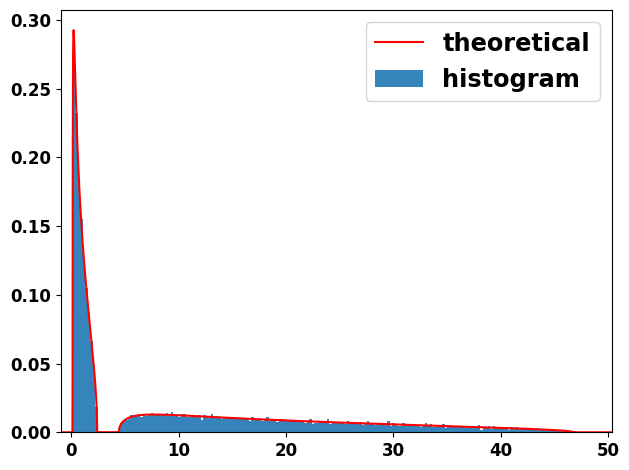

In [ ]:
## $\Sigma=\operatorname{Tr}\{a,\ldots,a,b,\ldots,b\}$ where they are a repeated (s*m) times and b repeated (1-s)*m times in the diagonal.

s = 1/2
a = 1
b = 15

## m=n*phi, R=number of repeating
phi=0.6
R=20
n=800

plot_eigenvalues_histogram(phi, R, n, a, b, s)

### Figure 1(b)

Figure 1(b) shows the histogram and the density curve of lsd for $\phi=100$, $n=800$.

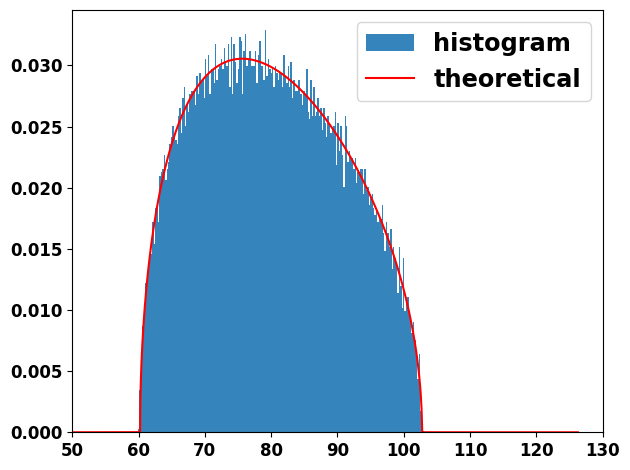

In [ ]:
## $\Sigma=\operatorname{Tr}\{a,\ldots,a,b,\ldots,b\}$ where they are a repeated (s*m) times and b repeated (1-s)*m times in the diagonal.

s = 1/2
a = 1
b = 15

## m=n*phi, R=number of repeating
phi=100
R=20
n=800

plot_eigenvalues_histogram(phi, R, n, a, b, s)

## Figure 2:

In Fig. 2, we show the ECDF for
-  the Global test statistics $\mathcal{T}^g_1$
- the Local test statistics $\mathcal{T}^l_1$

when $\Sigma=\operatorname{Id}$ and the entries of the matrix $X$ have $\kappa_4 =0$ vs $\kappa_4\ne 0$ respectively.

It becomes visually clear that for Global test statistics, we can see the distributional difference when the entries of $X$ have $\kappa=0$ (Gaussian) or $\kappa\ne 0$ (2PN). The "2PN" here indicates the discrete random variable which takes value $\sqrt{2}$ with probability $1/3$ and value $-1/\sqrt{2}$ with probability $2/3$.

While for the Local test statistics, it's visually almost non-distinguishable that which one is from $X$ with Gaussian entries while which one is from $X$ with 2PN entries.

### Figure 2(a) Global

#### Data generating


Generate the data for the Global statistics

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_global_test_statistic(X, center):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center
    return jnp.sum(Eb)

def simulate_global_test_statistic(phi, n, R, c, method="normal", values=None, probabilities=None):
    m = int(n * phi)
    center = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n)
    T = jnp.zeros(R)
    key = PRNGKey(0)

    for k in range(R):
        key, subkey = split(key)
        if method == "normal":
            X = generate_matrix_normal(subkey, m, n)
        elif method == "choice":
            X = generate_matrix_choice(subkey, m, n, values, probabilities)
        else:
            raise ValueError("Invalid matrix generation method.")
        T = T.at[k].set(compute_global_test_statistic(X, center))

    return np.array(T)
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])
c=3
phi=100
n=200
m = int(n*phi)
R = 2000

TestST1 = simulate_global_test_statistic(phi, n, R, c, "normal")
TestST2 = simulate_global_test_statistic(phi, n, R, c, "choice", values, probabilities)


# plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')


CPU times: user 24.7 s, sys: 2.16 s, total: 26.9 s
Wall time: 23.8 s


#### Saved data

In [ ]:
TestST1=[581.8905 , 577.13184 , 582.865 , 579.22266 , 581.2446 , 579.2334 , 578.31226 , 581.1064 , 579.64465 , 582.0055 , 578.58167 , 578.6935 , 582.4458 , 578.7346 , 580.98206 , 578.9697 , 579.5271 , 579.5486 , 580.0008 , 582.287 , 580.4851 , 577.51764 , 581.4924 , 581.0149 , 580.6128 , 580.0384 , 579.024 , 579.5055 , 580.9938 , 580.35754 , 581.33435 , 580.0991 , 581.3005 , 579.0812 , 579.06055 , 579.3107 , 580.10016 , 578.7818 , 581.82166 , 579.0411 , 577.3502 , 581.6246 , 579.0169 , 578.18335 , 579.3432 , 581.1167 , 580.1179 , 578.0752 , 578.25574 , 581.2135 , 579.3932 , 581.8179 , 578.5685 , 578.463 , 579.62744 , 581.6946 , 580.8406 , 580.6653 , 580.27344 , 578.94763 , 580.8428 , 580.3493 , 581.214 , 577.2184 , 580.10657 , 579.65015 , 579.41754 , 579.3157 , 580.1062 , 581.9437 , 580.5542 , 582.27747 , 580.6162 , 581.3917 , 580.86597 , 581.2231 , 579.6072 , 578.95325 , 578.5316 , 579.33997 , 581.1282 , 579.64825 , 578.9053 , 577.18494 , 579.82153 , 579.8206 , 580.614 , 581.4748 , 578.8922 , 581.4824 , 580.02625 , 582.7202 , 580.25885 , 581.7114 , 581.4031 , 579.2003 , 578.8385 , 581.5012 , 579.136 , 578.66223 , 578.8494 , 580.0063 , 578.50195 , 580.8789 , 578.98584 , 579.6195 , 579.048 , 582.4142 , 578.3567 , 579.0874 , 577.4932 , 577.07697 , 580.32275 , 577.5338 , 580.7666 , 578.82214 , 581.4075 , 580.4584 , 580.9359 , 579.11816 , 580.06226 , 578.9093 , 579.3695 , 579.9729 , 578.59814 , 580.3666 , 579.4694 , 579.09875 , 581.33984 , 580.04236 , 578.5383 , 578.1898 , 580.3289 , 579.7158 , 579.7621 , 579.40356 , 578.9225 , 579.3511 , 579.2866 , 579.9878 , 581.9133 , 580.46533 , 582.7612 , 577.83435 , 581.55115 , 578.6532 , 580.6002 , 578.1192 , 578.58075 , 581.662 , 582.44556 , 580.7163 , 578.7843 , 580.48126 , 582.001 , 580.22546 , 577.3346 , 582.2831 , 576.4709 , 579.1967 , 582.56494 , 580.1332 , 578.1669 , 578.39526 , 579.4799 , 579.83826 , 579.3119 , 583.2368 , 579.81604 , 579.79956 , 583.14795 , 580.9813 , 579.9252 , 579.78705 , 578.4634 , 580.4031 , 580.05347 , 581.161 , 581.9255 , 580.9242 , 580.716 , 580.6892 , 578.7924 , 579.75256 , 578.28125 , 580.5641 , 580.2064 , 579.2468 , 579.875 , 578.7151 , 580.08875 , 581.5513 , 575.6152 , 580.0415 , 578.67804 , 578.7645 , 582.01013 , 582.22504 , 579.94293 , 580.9538 , 577.8614 , 581.4535 , 579.4967 , 577.67834 , 581.31506 , 579.4796 , 579.2954 , 582.2344 , 578.53796 , 579.39233 , 580.1106 , 580.09265 , 581.8968 , 576.9655 , 579.92755 , 580.96265 , 579.1724 , 580.7101 , 577.9121 , 578.62067 , 581.1245 , 579.214 , 581.2647 , 578.67993 , 578.4538 , 579.8656 , 579.23975 , 580.71826 , 578.02045 , 581.30115 , 577.68207 , 579.3725 , 580.53674 , 580.01196 , 581.4791 , 581.5574 , 582.26294 , 580.1316 , 578.74963 , 581.3501 , 581.2935 , 578.6732 , 580.1848 , 577.45496 , 581.4874 , 580.00616 , 578.75464 , 579.6925 , 579.0369 , 578.1475 , 578.1384 , 580.95654 , 581.5784 , 577.196 , 581.9643 , 579.9231 , 579.40155 , 580.7101 , 579.7727 , 579.8197 , 581.6154 , 576.5575 , 579.8806 , 581.58154 , 581.0376 , 580.4367 , 581.01294 , 579.042 , 579.4162 , 577.7726 , 580.0365 , 579.3737 , 579.0897 , 577.9558 , 582.2217 , 581.13586 , 578.808 , 580.37024 , 579.0094 , 579.04266 , 578.0439 , 579.1696 , 579.7279 , 579.161 , 581.0775 , 580.1234 , 579.27997 , 580.89954 , 580.2422 , 579.43695 , 581.20496 , 578.76733 , 583.1961 , 580.66547 , 578.82825 , 578.3969 , 579.8399 , 578.68335 , 579.28467 , 579.7207 , 581.56775 , 580.60284 , 578.9134 , 579.44086 , 581.3298 , 580.7864 , 576.948 , 578.36896 , 580.63074 , 579.9699 , 579.96265 , 579.85736 , 580.9401 , 581.95184 , 582.48193 , 578.6794 , 579.6692 , 585.3127 , 578.57434 , 578.52686 , 579.9109 , 582.773 , 578.5117 , 581.5126 , 579.46436 , 577.3011 , 580.319 , 580.3906 , 577.41455 , 579.59973 , 578.4701 , 579.4804 , 578.07025 , 578.97815 , 577.40845 , 579.39825 , 580.25916 , 577.4239 , 579.20447 , 579.107 , 577.80365 , 581.8665 , 580.992 , 579.20605 , 582.88257 , 581.7174 , 578.5889 , 581.08936 , 578.9201 , 579.1 , 579.1246 , 574.93555 , 579.6826 , 580.6222 , 581.7825 , 581.45386 , 579.50696 , 578.4055 , 579.45795 , 579.6679 , 580.2449 , 579.8742 , 579.36743 , 578.463 , 579.8057 , 579.7347 , 580.8028 , 579.0977 , 581.79034 , 579.75696 , 579.558 , 578.35596 , 578.61694 , 580.6594 , 580.75037 , 582.1009 , 581.9086 , 579.5507 , 577.20734 , 578.9238 , 579.226 , 580.529 , 581.0833 , 579.7282 , 580.2368 , 580.1238 , 580.61456 , 580.5803 , 578.3683 , 576.93274 , 580.9581 , 579.77356 , 580.4504 , 577.574 , 579.77344 , 579.21985 , 579.85455 , 579.5501 , 580.0947 , 580.72144 , 580.7906 , 578.9495 , 581.0189 , 579.31934 , 578.52435 , 580.2456 , 578.7137 , 577.67444 , 577.96173 , 580.327 , 581.94507 , 579.3821 , 580.11115 , 580.1371 , 579.74365 , 579.0811 , 582.1278 , 579.6526 , 580.5761 , 579.25195 , 582.2092 , 577.4558 , 578.58386 , 580.96497 , 581.2423 , 579.305 , 579.8446 , 580.0262 , 579.4762 , 581.079 , 583.2611 , 581.37354 , 582.7532 , 580.5115 , 578.09076 , 579.7894 , 580.7236 , 578.85986 , 578.9138 , 577.40356 , 581.17926 , 581.49365 , 578.22253 , 578.92365 , 579.7517 , 578.8928 , 582.3525 , 580.0719 , 581.62 , 581.11035 , 580.93896 , 580.0272 , 582.7096 , 581.5691 , 577.733 , 579.5337 , 580.12366 , 577.8354 , 579.3753 , 577.41187 , 580.27106 , 581.9285 , 578.7592 , 577.97144 , 581.7396 , 578.67773 , 577.06836 , 580.45715 , 578.97797 , 580.66187 , 579.3247 , 579.50574 , 580.25244 , 579.8442 , 580.76013 , 577.92535 , 579.96063 , 581.27515 , 580.03253 , 580.14325 , 583.6815 , 580.4747 , 579.91296 , 578.4476 , 579.3843 , 579.2198 , 580.93304 , 581.03625 , 581.1772 , 579.2018 , 581.7417 , 579.6761 , 578.9668 , 578.0013 , 578.17773 , 579.9589 , 579.54114 , 580.71216 , 581.3723 , 581.4852 , 579.3077 , 577.9676 , 580.3454 , 580.3113 , 579.6065 , 577.17285 , 580.4199 , 577.88745 , 582.3935 , 578.99695 , 580.271 , 581.64197 , 580.4408 , 579.5642 , 579.06836 , 580.7389 , 579.69006 , 578.3236 , 580.0438 , 581.45844 , 578.1836 , 579.1204 , 578.578 , 581.3304 , 580.2387 , 580.1294 , 579.8093 , 580.9902 , 582.062 , 579.6045 , 582.2822 , 579.37573 , 578.21466 , 578.302 , 577.8635 , 578.1343 , 578.86487 , 578.2639 , 578.65955 , 580.93274 , 580.23724 , 581.66345 , 580.7337 , 579.32855 , 578.61194 , 579.56775 , 584.12354 , 579.30994 , 580.8471 , 579.1632 , 577.9951 , 578.9959 , 578.93524 , 581.4995 , 579.16675 , 576.9673 , 580.54614 , 579.21765 , 578.41766 , 580.384 , 579.6081 , 580.54333 , 579.9596 , 578.98395 , 578.8927 , 580.4276 , 579.72815 , 580.8436 , 578.83984 , 578.7937 , 578.3772 , 579.2129 , 582.4647 , 580.4045 , 582.4619 , 578.3009 , 578.70215 , 577.9429 , 581.0286 , 579.19934 , 579.25525 , 580.7755 , 582.6803 , 578.807 , 581.8103 , 580.2847 , 579.166 , 578.141 , 579.2268 , 580.31866 , 583.49927 , 580.84796 , 583.02386 , 579.0552 , 580.6662 , 581.1139 , 581.55426 , 580.3207 , 578.5356 , 580.84436 , 577.71796 , 582.6166 , 580.3843 , 581.02966 , 579.4986 , 581.53345 , 580.3922 , 577.64856 , 582.34375 , 582.1961 , 580.4972 , 580.33954 , 582.511 , 579.2149 , 579.72955 , 578.6915 , 580.4369 , 581.7162 , 580.50586 , 579.24677 , 579.6157 , 580.4032 , 580.2864 , 581.7889 , 579.40643 , 577.4712 , 578.2563 , 579.86926 , 581.06635 , 580.1207 , 579.92505 , 582.14685 , 581.19495 , 580.87646 , 578.7754 , 579.23987 , 581.3805 , 579.978 , 578.4212 , 580.474 , 579.05615 , 577.114 , 578.8888 , 580.8782 , 578.8106 , 580.0843 , 580.1836 , 579.42786 , 583.23035 , 581.35645 , 580.80554 , 582.1755 , 580.1557 , 579.3534 , 580.0572 , 578.1101 , 580.0131 , 581.0519 , 580.7666 , 579.1354 , 581.4833 , 577.9088 , 582.8959 , 580.1556 , 578.60034 , 579.8315 , 580.89526 , 581.93585 , 580.2976 , 579.149 , 580.48145 , 580.00543 , 580.95667 , 579.73645 , 580.4867 , 579.5061 , 579.4458 , 578.6196 , 580.12695 , 579.4796 , 580.13525 , 580.976 , 577.12976 , 581.0145 , 580.9221 , 580.2564 , 580.1365 , 579.90326 , 580.68066 , 580.62537 , 579.14545 , 578.33185 , 579.0584 , 578.2405 , 579.6901 , 577.812 , 580.72235 , 578.3771 , 577.9179 , 582.06085 , 579.7442 , 579.12726 , 580.9496 , 580.81323 , 581.83936 , 579.803 , 580.56024 , 579.43506 , 582.2998 , 579.42896 , 581.4763 , 578.7856 , 580.1735 , 579.7897 , 581.2848 , 581.76306 , 581.3476 , 580.93134 , 580.44434 , 578.26697 , 580.41907 , 579.636 , 578.9738 , 581.7126 , 580.8349 , 581.56915 , 580.29034 , 579.51917 , 579.2936 , 577.4753 , 580.87915 , 580.30273 , 581.19946 , 579.4414 , 580.5315 , 579.47156 , 580.74927 , 581.90576 , 580.10254 , 580.56085 , 582.5614 , 583.2573 , 578.07825 , 578.3944 , 582.59894 , 577.9326 , 580.3712 , 580.17303 , 580.79016 , 580.13477 , 577.9797 , 580.8125 , 578.0458 , 579.7283 , 581.68726 , 579.3733 , 579.88855 , 582.4691 , 580.80493 , 580.4448 , 581.8992 , 579.754 , 579.82495 , 580.534 , 579.9536 , 579.73083 , 578.4347 , 579.93195 , 580.65186 , 579.5855 , 581.0575 , 580.05383 , 580.04407 , 579.4185 , 579.1216 , 578.7884 , 579.9771 , 578.5795 , 580.75757 , 581.56433 , 578.4784 , 578.9961 , 579.88116 , 580.51953 , 580.23206 , 578.8147 , 578.09204 , 578.9111 , 580.5143 , 581.193 , 580.8712 , 580.9445 , 579.7534 , 579.766 , 577.98883 , 580.52625 , 581.6653 , 580.662 , 577.1811 , 579.82385 , 577.3512 , 580.6806 , 580.67566 , 579.45935 , 579.3534 , 580.52026 , 579.82794 , 579.27606 , 580.7624 , 578.7977 , 579.60315 , 579.2616 , 579.91504 , 580.7035 , 581.4115 , 580.87585 , 579.2212 , 578.9629 , 583.31995 , 580.69104 , 580.52545 , 579.31445 , 582.8591 , 580.3136 , 579.2092 , 578.9635 , 579.55164 , 580.60376 , 581.334 , 582.354 , 580.67816 , 580.9723 , 582.27026 , 579.97363 , 579.1333 , 577.9013 , 579.31384 , 578.64343 , 580.28375 , 582.891 , 580.43604 , 581.00214 , 582.0668 , 580.7982 , 580.62646 , 581.31177 , 580.1488 , 581.35455 , 576.35333 , 580.61707 , 581.5487 , 580.54535 , 578.62555 , 580.58655 , 578.2976 , 577.02673 , 579.76624 , 579.4617 , 580.2924 , 579.92444 , 580.51556 , 579.6141 , 577.9763 , 577.72504 , 580.0338 , 578.30444 , 580.07654 , 579.09656 , 580.91187 , 579.4785 , 579.47766 , 581.0956 , 577.767 , 578.3469 , 579.922 , 579.978 , 581.06256 , 577.8563 , 579.29065 , 578.53864 , 577.4541 , 580.16846 , 580.20264 , 579.8435 , 579.993 , 580.5486 , 581.058 , 578.9994 , 579.9642 , 579.69556 , 580.9519 , 580.2916 , 575.74585 , 579.213 , 578.1865 , 580.2752 , 578.75635 , 580.65454 , 580.35944 , 580.7082 , 579.86755 , 582.0502 , 579.4271 , 580.3362 , 577.7892 , 580.67053 , 578.9326 , 581.3169 , 579.4892 , 579.3624 , 579.1465 , 579.98645 , 581.4056 , 580.2689 , 579.3059 , 578.24677 , 579.53595 , 581.0346 , 580.972 , 580.5194 , 578.06055 , 581.5991 , 576.6521 , 578.9031 , 581.25586 , 581.46765 , 578.0244 , 579.751 , 580.42725 , 578.762 , 579.42 , 579.9211 , 579.1825 , 578.50616 , 578.00916 , 579.6989 , 579.8264 , 579.617 , 579.74536 , 578.65015 , 580.13464 , 578.27936 , 579.13995 , 579.7023 , 579.65967 , 577.43274 , 578.5625 , 578.9237 , 577.2897 , 578.36743 , 579.9097 , 580.19446 , 579.4392 , 579.155 , 578.247 , 578.83765 , 582.5459 , 579.40796 , 579.6332 , 581.8203 , 578.7464 , 580.2744 , 580.0692 , 582.4171 , 581.95306 , 580.64496 , 580.62646 , 580.22595 , 579.65704 , 578.4094 , 576.3318 , 580.69055 , 580.6663 , 580.0254 , 580.24304 , 580.22876 , 579.89294 , 578.86786 , 579.66705 , 578.38586 , 580.473 , 581.0614 , 578.1102 , 580.51215 , 579.90247 , 579.1913 , 580.6626 , 579.23206 , 580.00037 , 579.9276 , 577.9308 , 578.8372 , 581.8342 , 580.6615 , 580.6344 , 582.0297 , 581.75604 , 580.71216 , 580.7792 , 581.4183 , 578.6233 , 580.99426 , 579.7118 , 581.28723 , 579.1177 , 579.99084 , 578.48193 , 581.14545 , 578.85364 , 576.91724 , 582.19214 , 578.45355 , 581.90216 , 580.3808 , 580.1991 , 580.6293 , 580.67413 , 579.5337 , 577.07886 , 581.02844 , 581.10596 , 580.6875 , 581.6262 , 580.262 , 583.2041 , 579.9712 , 581.8453 , 578.40515 , 577.9757 , 580.78345 , 580.3184 , 579.9877 , 579.7522 , 580.8058 , 580.61304 , 581.5722 , 580.8919 , 580.5158 , 582.9496 , 579.79663 , 581.0169 , 580.99854 , 580.912 , 580.27026 , 579.45575 , 579.3076 , 580.87714 , 578.7339 , 579.08057 , 582.5433 , 580.42834 , 581.94995 , 581.62146 , 579.39886 , 578.6831 , 580.0958 , 578.7369 , 578.2937 , 580.1987 , 579.7268 , 580.0744 , 579.75635 , 581.9888 , 580.17865 , 580.4487 , 579.4582 , 582.21014 , 579.6986 , 578.7513 , 579.1716 , 579.17896 , 579.54254 , 579.49023 , 579.62354 , 579.6874 , 580.0827 , 581.8401 , 579.17554 , 580.2373 , 580.1858 , 581.4591 , 579.9474 , 578.36414 , 582.4849 , 577.5625 , 580.4525 , 578.5883 , 579.0923 , 579.2944 , 580.84985 , 578.94745 , 580.8816 , 580.86993 , 582.1017 , 578.6515 , 579.75397 , 578.6587 , 578.3723 , 578.94214 , 579.44696 , 579.416 , 577.09204 , 580.08765 , 578.9577 , 578.8777 , 577.57935 , 580.0246 , 578.80414 , 580.1444 , 580.7619 , 580.9237 , 581.1455 , 580.60406 , 580.7765 , 581.2641 , 580.81445 , 578.7902 , 578.3673 , 577.4608 , 580.67395 , 578.59143 , 581.91895 , 579.18665 , 580.5621 , 577.9839 , 579.515 , 580.6878 , 580.27966 , 579.0221 , 578.40753 , 582.42926 , 580.53644 , 578.47205 , 578.9129 , 578.6382 , 583.53503 , 581.21936 , 581.83246 , 579.45703 , 580.3417 , 581.48486 , 581.92255 , 580.35815 , 581.7688 , 580.17725 , 579.99634 , 578.94543 , 580.0215 , 580.1284 , 578.8082 , 581.21765 , 579.19714 , 581.6312 , 579.8098 , 579.9551 , 577.65027 , 579.0046 , 580.37646 , 579.76624 , 579.69775 , 578.18463 , 579.6165 , 579.55884 , 580.5759 , 582.49744 , 581.2104 , 579.53674 , 578.4474 , 581.1382 , 579.72656 , 578.8051 , 580.0175 , 580.6046 , 581.22534 , 579.93884 , 579.5426 , 580.673 , 578.14124 , 577.1161 , 582.4623 , 579.0864 , 579.3108 , 579.2471 , 579.3498 , 578.20795 , 579.9872 , 577.85034 , 582.58093 , 581.7842 , 578.40405 , 580.3987 , 578.12836 , 579.28076 , 581.3935 , 579.5476 , 579.281 , 579.03107 , 577.08655 , 583.35626 , 580.7533 , 579.7526 , 578.70483 , 580.94324 , 576.48535 , 578.6096 , 579.30536 , 578.8801 , 580.6534 , 580.1001 , 580.01416 , 580.89075 , 579.7703 , 579.1093 , 579.2334 , 576.58887 , 580.35913 , 582.21936 , 579.13947 , 578.9762 , 582.0045 , 579.672 , 580.4073 , 581.56995 , 579.7574 , 577.1166 , 579.6842 , 579.55786 , 579.7792 , 579.2597 , 582.0244 , 578.5487 , 580.68054 , 579.4137 , 581.1497 , 578.8093 , 579.5349 , 579.4872 , 581.9979 , 578.4256 , 579.37366 , 582.54047 , 580.27 , 577.99036 , 580.12915 , 578.4963 , 579.99615 , 581.14636 , 577.8235 , 579.6892 , 578.2523 , 579.6446 , 578.2538 , 582.1139 , 577.88525 , 579.7799 , 581.5535 , 577.8871 , 581.32263 , 577.3533 , 580.47314 , 580.3716 , 581.94183 , 582.1387 , 577.8632 , 579.32764 , 581.0492 , 579.7967 , 576.54486 , 582.325 , 581.5349 , 577.9408 , 579.2345 , 581.2541 , 577.53784 , 578.5939 , 579.67737 , 580.0884 , 581.8859 , 580.04193 , 580.20874 , 579.74207 , 581.4092 , 579.37616 , 581.2961 , 583.3535 , 580.42615 , 580.0346 , 579.01746 , 578.3375 , 580.4863 , 581.78894 , 580.9161 , 578.8785 , 581.4728 , 579.3539 , 583.04004 , 580.72864 , 579.99677 , 581.6073 , 579.3258 , 579.6508 , 577.3096 , 582.46436 , 579.90173 , 579.33215 , 580.3673 , 578.35516 , 578.12134 , 577.9817 , 580.9234 , 579.2259 , 577.6046 , 580.666 , 577.13995 , 581.52106 , 579.0189 , 579.289 , 581.9347 , 577.4226 , 582.12177 , 579.33875 , 579.55273 , 580.1573 , 580.27185 , 579.3051 , 576.98535 , 578.84705 , 579.74646 , 581.2594 , 581.0619 , 578.62476 , 578.6129 , 578.6909 , 578.2156 , 579.1033 , 578.3297 , 579.38745 , 578.103 , 579.313 , 580.14233 , 580.1084 , 581.2683 , 579.4755 , 579.53186 , 581.4639 , 578.45703 , 578.40155 , 579.99396 , 579.9845 , 582.0553 , 580.55774 , 579.5919 , 580.6791 , 581.91656 , 583.1224 , 577.85004 , 581.6415 , 578.7428 , 581.21924 , 580.01855 , 580.51117 , 578.5421 , 581.1112 , 579.0453 , 579.43207 , 581.89343 , 577.94305 , 579.1957 , 577.7184 , 577.90765 , 579.151 , 577.59186 , 579.23444 , 578.3788 , 576.18225 , 580.6179 , 581.3031 , 580.2487 , 579.7855 , 583.984 , 581.4249 , 580.1124 , 580.25433 , 580.656 , 580.1367 , 579.89734 , 581.7367 , 579.68225 , 579.54565 , 581.1272 , 579.3931 , 580.39246 , 580.2925 , 582.5874 , 577.4695 , 580.39087 , 579.6022 , 580.5155 , 581.1045 , 577.8126 , 578.1526 , 578.7926 , 576.9176 , 580.10583 , 578.8877 , 579.87585 , 578.6277 , 579.5502 , 580.76324 , 578.6726 , 579.3688 , 579.75793 , 581.0792 , 578.9824 , 581.9608 , 583.8427 , 581.318 , 582.829 , 579.4297 , 580.7085 , 579.12537 , 582.47906 , 581.36115 , 578.85315 , 579.7263 , 580.5364 , 580.0552 , 580.7671 , 581.51404 , 581.5882 , 578.0748 , 579.09534 , 577.19635 , 578.99677 , 581.6162 , 579.37244 , 581.9569 , 583.15546 , 578.76245 , 582.7808 , 577.59546 , 580.5796 , 578.40454 , 580.7269 , 580.9675 , 580.76025 , 580.01855 , 581.0331 , 580.32574 , 580.7855 , 579.8221 , 582.46185 , 580.3722 , 582.9701 , 579.9034 , 578.312 , 582.473 , 577.5054 , 578.6606 , 581.12537 , 580.9033 , 578.9641 , 580.69073 , 579.4265 , 579.28796 , 578.9379 , 580.4611 , 581.16675 , 581.56824 , 579.98364 , 580.79785 , 579.2703 , 578.8722 , 578.6786 , 581.39575 , 579.44165 , 577.96497 , 580.12744 , 579.07446 , 577.7267 , 578.3438 , 579.1782 , 578.49023 , 577.9668 , 579.62854 , 579.80096 , 577.6853 , 579.6613 , 580.7442 , 583.2675 , 578.15643 , 584.74054 , 579.60925 , 580.91907 , 578.4125 , 579.03625 , 581.3889 , 582.98145 , 580.4879 , 578.33 , 579.9769 , 579.06824 , 577.6773 , 579.989 , 579.5123 , 579.43256 , 580.8507 , 580.13275 , 578.01324 , 580.77783 , 581.0259 , 579.63116 , 578.8441 , 579.7812 , 580.05994 , 581.76294 , 579.62317 , 581.33105 , 580.44464 , 579.24817 , 578.2031 , 580.5652 , 581.6709 , 579.1631 , 578.9773 , 580.07446 , 580.0683 , 580.92847 , 582.0146 , 579.7825 , 580.5996 , 578.7351 , 579.95435 , 580.53436 , 583.93164 , 579.6061 , 578.676 , 580.807 , 580.04895 , 580.1887 , 581.6805 , 579.66003 , 580.3489 , 581.2883 , 581.61804 , 579.37714 , 579.84 , 581.4107 , 579.91016 , 580.2936 , 580.7479 , 581.1769 , 577.34766 , 579.641 , 579.8794 , 581.09973 , 580.2477 , 579.81213 , 580.1377 , 581.6248 , 579.9851 , 581.3959 , 580.958 , 581.69183 , 580.98193 , 579.7989 , 579.19257 , 578.7864 , 580.69 , 583.346 , 581.4109 , 580.5708 , 579.2462 , 581.31177 , 577.82104 , 579.3309 , 579.85864 , 579.56104 , 579.7311 , 582.8615 , 581.11786 , 577.6809 , 580.11194 , 577.9359 , 580.4283 , 579.9446 , 578.29236 , 579.59106 , 579.412 , 577.7031 , 577.48694 , 579.07935 , 579.7577 , 579.81476 , 580.501 , 581.9569 , 579.01373 , 581.77673 , 577.0271 , 579.67883 , 579.85046 , 577.29944 , 579.6267 , 581.6092 , 582.4579 , 580.0011 , 580.57556 , 580.50244 , 579.9061 , 580.0991 , 578.348 , 581.6742 , 578.81506 , 578.7204 , 580.164 , 581.18726 , 579.05286 , 580.49023 , 579.1821 , 579.5728 , 579.56775 , 580.489 , 579.8845 , 581.47107 , 580.0692 , 581.7628 , 581.0279 , 580.7263 , 579.3365 , 579.6649 , 578.9324 , 577.03455 , 581.35144 , 579.1576 , 582.302 , 577.2489 , 579.32935 , 577.6887 , 580.70825 , 577.69275 , 580.12305 , 579.4129 , 579.32495 , 579.1507 , 578.00507 , 581.19073 , 580.7866 , 579.52014 , 579.89417 , 580.3956 , 579.8801 , 579.1327 , 579.49646 , 581.3679 , 580.7007 , 578.20386 , 579.60583 , 582.20825 , 581.15607 , 579.02893 , 580.23303 , 583.147 , 579.00586 , 582.5515 , 577.9073 , 581.6315 , 580.35693 , 580.87225 , 580.6095 , 578.60706 , 580.9006 , 581.47736 , 580.7945 , 581.60583 , 581.47485 , 579.89087 , 579.3223 , 580.95593 , 579.1615 , 581.56506 , 579.36285 , 578.907 , 580.7722 , 581.511 , 580.1991 , 580.19604 , 578.8933 , 580.04736 , 580.5241 , 581.0985 , 579.98517 , 579.77954 , 581.3874 , 577.7467 , 579.90515 , 579.68176 , 577.2206 , 578.8005 , 578.88116 , 579.4586 , 580.94653 , 579.6627 , 579.6598 , 579.92126 , 580.7167 , 577.53894 , 579.95374 , 580.5729 , 578.4758 , 580.72595 , 581.2815 , 580.1581 , 579.43207 , 578.46826 , 578.4623 , 579.61426 , 581.9233 , 579.23676 , 578.96204 , 579.6699 , 582.006 , 578.6301 , 580.1912 , 580.479 , 579.39844 , 580.1513 , 579.43555 , 577.7977 , 580.8871 , 581.9668 , 578.56726 , 580.1863 , 581.9485 , 580.784 , 579.8933 , 578.0243 , 579.6933 , 580.5386 , 578.9179 , 577.1194 , 578.6184 , 581.55774 , 578.7101 , 580.9625 , 581.0487 , 577.7167 , 580.04114 , 579.2332 , 576.9185 , 579.5386 , 580.48206 , 579.8058 , 582.5155 , 577.0348 , 579.7359 , 579.8601 , 581.0707 , 580.47656 , 578.94543 , 578.4227 , 579.3322 , 578.4718 , 580.5132 , 580.081 , 578.07996 , 578.13184 , 582.4015 , 579.39197 , 581.23047 , 580.1931 , 579.8948 , 581.0226 , 581.04913 , 579.2772 , 578.7513 , 580.53796 , 576.7936 , 581.95624 , 582.0233 , 579.1035 , 580.35864 , 581.59375 , 581.4712 , 580.6481 , 580.269 , 578.4416 , 580.9553 , 580.6912 , 580.4233 , 581.0548 , 580.7416 , 578.14325 , 580.3479 , 580.2876 , 581.1185 , 580.4276 , 579.94055 , 579.8193 , 580.0834 , 580.8428 , 579.26404 , 581.9125 , 581.6706 , 579.41833 , 581.66113 , 577.58997 , 579.0832 , 583.3543 , 579.29974 , 581.3888 , 580.8703 , 581.5477 , 582.88184 , 579.4514 , 580.38885 , 579.52783 , 581.0333 , 580.3533 , 579.0705 , 581.2871 , 578.6225 , 579.30884 , 578.73047 , 580.279 , 581.3147 , 579.2916 , 581.8082 , 580.95935 , 580.33295 , 580.38306 , 581.0638 , 581.1813 , 579.5808 , 581.3248 , 579.7435 , 581.17267 , 581.8059 , 580.03015 , 581.0001 , 581.76 , 578.4143 , 580.20593 , 580.47723 , 579.98303 , 576.28564 , 580.8185 , 581.0563 , 581.1227 , 579.9239 , 580.54285 , 580.6082 , 578.4033 , 584.60675 , 580.0993 , 579.29254 , 576.88965 , 582.32935 , 579.69275 , 579.6971 , 579.02686 , 583.22076 , 581.6899 , 580.1819 , 579.5719 , 580.8606 , 579.4554 , 581.9915 , 581.5364 , 579.0587 , 580.4411 , 581.70233 , 577.2731 , 578.0226 , 580.8467 , 581.0973 , 578.1327 , 579.4215 , 580.0482 , 580.2241 , 578.99194 , 580.1953 , 582.7933 , 576.81433 , 578.36914 , 579.603 , 582.719 , 581.8519 , 580.38135 , 580.5382 , 578.5676 , 580.9347 , 579.15295 , 581.11865 , 580.78735 , 579.3867 , 579.9938 , 578.88916 , 577.8441 , 577.72644 , 578.9745 , 577.69525 , 581.1089 , 579.82855 , 581.57465 , 579.0658 , 578.92114 , 579.6101 , 581.8779 , 578.86597 , 578.3707 , 581.2175 , 581.8386 , 581.21375 , 578.0664 , 578.45764 , 579.5839 , 581.45105 , 576.3417 , 579.72205 , 579.53 , 581.0504 , 578.72534 , 580.63904 , 580.7032 , 579.6045 , 578.90106 , 580.8245 , 581.0369 , 579.8402 , 579.9434 , 580.40967 , 578.2631 , 580.0277 , 583.45056 , 576.8488 , 578.08215 , 579.47296 , 581.495 , 579.4738 , 579.2924 , 578.79236 , 580.40735 , 581.73615 , 579.5747 , 578.87085 , 580.40656 , 581.5758 , 580.2081 , 580.23035 , 581.74426 , 579.11584 , 578.56995 , 579.7992 , 577.04504 , 581.88135 , 580.0405 , 578.0946 , 580.946 , 580.5072 , 580.4022 , 579.68005 , 576.7488 , 580.4973 , 578.36163 , 577.77563 , 580.4241 , 579.72833 , 580.7538 , 576.9418 , 581.8088 , 580.9573 , 578.9099 , 579.18634 , 580.006 , 581.6168 , 578.69165 , 579.4191 , 584.4761 , 580.7228 , 581.4911 , 580.65894 , 581.25275 , 578.7699 , 581.3502 , 579.1558 , 581.15906 , 578.359 , 578.3552 , 579.8468 , 580.3893 , 577.83734 , 582.2296 , 579.38226 , 580.90125 , 580.4735 , 579.2894 , 580.22314 , 581.50854 , 577.4271 , 579.1357 , 578.23004 , 582.11597 , 580.1124 , 577.47034 , 579.5751 , 583.3622 , 580.46484 , 578.8783 , 583.0829 , 579.26514 , 583.2977 , 580.63776 , 579.14856 , 581.03973 , 580.26746 , 578.08453 , 578.33215 , 578.4066 , 578.20215 , 579.6445 , 580.5156 , 580.15063 , 578.9227 , 579.1863 , 581.0757 , 578.48706 , 582.3953 , 581.52783 , 579.67944 , 579.9509 , 577.3866 , 579.61304 , 580.72345 , 578.5792 , 581.54596 , 578.5976 , 581.02216 , 580.95654 , 577.88086 , 578.4694 , 579.7162 , 580.8397 , 579.8997 , 582.4304 , 581.43005 , 579.8617 , 578.716 , 580.4833 , 579.25806 , 581.11597 , 580.75195 , 581.4037 , 579.46375 , 578.20325 , 579.5746 , 581.022 , 578.52747 , 579.2285 , 579.70544 , 579.0366 , 582.9368 , 578.6742 , 581.62665 , 576.564 , 579.2993 , 580.5576 , 580.45624 , 579.9922 , 579.8014 , 580.48376 , 579.4813 , 579.45544 , 578.56476 , 581.8115 , 578.82874 , 577.13055 , 576.96124 , 582.5133 , 578.29755 , 578.0415 , 578.78766 , 578.0759 , 576.2081 , 578.3983 , 578.1481 , 582.7463 , 579.2151 , 579.8164 , 579.57837 , 577.99976 , 578.0111 , 582.01587 , 581.2001 , 579.56934 , 577.392 , 580.6175 , 577.8457 , 580.3396 , 580.9827 , 581.42773 , 580.27124 , 582.12646 , 579.38947 , 582.5738 , 577.56824 , 580.7047 , 578.4366 , 579.9865 , 581.52637 , 579.867 , 580.3889 , 577.65454 , 580.43365 , 580.9655 , 582.457 , 580.47125 , 580.3895 , 580.7776 , 578.2544 , 578.9253 , 581.6351 , 578.12805 , 579.2264 , 577.5577 , 580.162 , 580.06067 , 580.4009 , 578.4331 , 580.4048 , 580.53845 , 579.902 , 580.1045 , 580.12134 , 578.92505 , 578.9014 , 579.3368 , 578.7118 , 579.5822 , 581.5017 , 577.9514 , 579.1129 , 579.83344 , 580.51556 , 578.83923 , 579.183 , 578.85126 , 581.1542 , 580.4116 , 578.63745 , 580.01013 , 578.7302 , 579.87396 , 579.19116 , 579.5727 , 579.11926 , 579.542 , 580.9353 , 581.1988 , 579.36194 , 578.257 , 580.49585 , 580.01843 , 583.5771 , 578.9885 , 578.55566 , 581.7449 , 577.3922 , 580.99854 , 578.96277 , 582.0996 , 578.9398 , 581.3953 , 580.3688 , 577.22656 , 579.36084 , 579.2179 , 580.10315 , 579.83264 , 581.86646 , 577.1293 , 580.72205 , 580.0232 , 579.3695 , 579.92395 , 579.2663 , 582.62756 , 581.3896 , 579.572 , 578.3481 , 580.7622 , 579.6478 , 579.539 , 579.8384 , 579.0548 , 581.31104 , 580.53906 , 581.7009 , 578.9708 , 579.5533 , 580.86694 , 578.7023 , 579.2876 , 580.02045 , 580.1356 , 581.32526 , 579.5991 , 576.46466 , 580.08575 , 576.71625 , 579.798 , 580.49786 , 580.6411 , 580.4948 , 581.651 , 582.74194 , 578.8495 , 580.80865 , 579.1904 , 580.70874 , 582.18384 , 581.8495 , 582.2813 , 579.4079 , 579.6376 , 585.01746 , 577.54663 , 579.8302 , 580.02216 , 581.2331 , 582.4024 , 578.0685 , 580.4124 , 581.2919 , 577.89935 , 578.0653 , 580.22705 , 579.06415 , 579.2475 , 577.42413 , 580.18634 , 575.3052 , 579.45276 , 578.1666 , 580.05237 , 579.76495 , 580.48047 , 581.7502 , 580.2834 , 580.45013 , 581.6048 , 578.9273 , 581.2202 , 577.9751 , 580.5128 , 583.631 , 581.465 , 580.84625 , 580.50085 , 580.8943 , 577.9156 , 580.9508 , 578.4158 , 582.02136 , 581.1361 , 579.4129 , 577.09546 , 581.34283 , 581.9387 , 581.792 , 580.8042 , 580.3186 , 578.9697 , 579.5107 , 583.0207 , 581.23444 , 581.7043 , 580.1858 , 580.9866 , 578.3682 , 577.8257 , 581.12744 , 579.24695 , 579.3096 , 579.8389 , 579.2228 , 577.64905 , 579.4865 , 580.83936 , 578.87256 , 581.64307 , 582.1915 , 581.30884 , 579.23914 , 582.13904 , 578.8158 , 580.9548 , 582.7887 , 580.34216 , 580.81476 , 576.94403 , 577.1616 , 580.469 , 579.6992 , 579.9214 , 578.7115 , 577.2344 , 579.1489 , 581.04736 , 578.8347 , 580.0154 , 578.48785 , 579.7717 , 580.67566 , 579.49524 , 580.8966 , 579.69214 , 581.81177 , 578.5676 , 580.79004 , 578.29486 , 578.1451 , 579.3003 , 578.3787 , 578.99664 , 579.65515 , 579.0266 , 578.705 , 578.67084 , 581.8655 , 577.45905 , 579.0137 , 578.7824 , 577.9192 , 579.63934 , 582.9409 , 582.19714 , 581.3446 , 579.7832 , 581.5261 , 578.23755 , 581.3001 , 582.08374 , 579.27277 , 581.1206 , 576.42755 , 581.37714 , 580.6422 , 578.83093 , 581.2821 , 579.8691 , 579.6013 , 580.0359 , 580.9687 , 579.8418 , 578.46027 , 579.9242 , 578.9521 , 580.13586 , 579.5239 , 581.1442 , 580.17334 , 579.47705 , 581.06726 , 579.33856 , 576.87646 , 580.54846 , 579.28467 , 579.75256 , 581.575 , 579.78345 , 580.6499 , 581.7118 , 582.48816 , 578.49493 , 581.0668 , 581.33057 , 581.91113 , 578.94006 , 579.2174 , 583.2168 , 580.00854 , 577.38605 , 579.55115 , 579.53284 , 583.19525 , 579.44293 , 580.827 , 580.76404 , 580.52875 , 580.5439 , 580.60156 , 578.3364 , 579.23517 , 577.44543 , 580.25916 , 581.4085 , 581.9088 , 577.9399 , 578.8121 , 580.2554 , 581.56445 , 579.61676 , 578.52264 , 583.5502 , 579.4939 , 579.12964 , 580.84595 , 581.80347 , 578.2506 , 579.64514 , 580.646 , 580.33826 , 580.1682 , 581.5559 , 581.0471 , 579.34314 , 579.5866 , 581.07056 , 579.63 , 582.3788 , 579.46375 , 580.6642 , 578.77875 , 580.2993 , 580.6758 , 581.3418 , 580.9124 , 580.4063 , 579.6361 , 582.2042 , 580.112 , 580.47894 , 578.2272 , 577.6318 , 580.18097 , 581.4745 , 579.1957 , 580.8097 , 578.4715 , 580.7783 , 580.3482 , 580.6736 , 578.60706 , 581.7938 , 580.8122 , 581.3861 , 579.43585 , 579.5634 , 581.4925 , 581.5635 , 581.38824 , 579.7594 , 578.34863 , 579.17847 , 579.0332 , 578.3665 , 580.9906 , 578.58936 , 583.56683 , 580.1123 , 578.21893 , 579.1229 , 579.87213 , 581.3098 , 579.45544 , 580.0939 , 579.3253 , 582.2329 , 577.80176 , 578.53455 , 580.2663 , 579.4673 , 580.48944 , 577.6438 , 582.24695 , 582.53577 , 579.2961 , 578.672 , 579.2455 , 581.7469 , 580.3218 , 578.8927 , 581.58124 , 580.36426 , 577.5103 , 580.44763 , 580.5297 , 579.50073 , 579.4616 , 579.78186 , 579.2356 , 581.1412 , 581.24274 , 582.02747 , 584.73206 , 581.8881 , 580.17444 , 580.28156 , 580.8192 , 579.74207 , 578.39307 , 577.8025 , 581.1127 , 580.68286 , 580.2017 , 579.85016 , 580.66565 , 578.6807 , 579.9337 , 580.31775 , 579.4568 , 579.463 , 578.13403 , 581.95056 , 580.13635 , 581.64343 , 581.7499 , 580.3385 , 580.8157 , 579.3005 , 580.5569 , 579.19867 , 579.5123 , 577.7291 , 580.88556 , 580.39185 , 578.7645 , 580.4574 , 581.05145 , 577.08765 , 579.84973 , 579.19403 , 578.194 , 578.944 , 580.8983 , 579.25464 , 579.4701 , 578.1981 , 578.3506 , 582.0382 , 581.4582 , 578.6696 , 581.2274 , 580.2638 , 579.5367 , 579.57434 , 579.0548 , 581.01904 , 580.5045 , 579.2742 , 578.7764 , 580.2323 , 578.7634 , 578.1823 , 577.5856 , 579.9912 , 579.1645 , 581.2497 , 579.75146 , 580.4769 , 577.0246 , 579.1074 , 578.24066 , 580.20776 , 579.08936 , 582.97644 , 582.1614 , 578.9695 , 579.3501 , 581.7676 , 579.31805 , 580.9232 , 578.10516 , 577.4656 , 581.6861 , 581.03174 , 580.1496 , 579.62946 , 579.4438 , 578.61957 , 578.1564 , 583.11456 , 578.40894 , 580.7531 , 579.848 , 580.2395 , 581.7108 , 580.1975 , 584.0945 , 578.7071 , 579.3764 , 580.5261 , 579.0753 , 581.51166 , 578.33594 , 579.6907 , 580.8025 , 580.54913 , 579.1045 , 579.9159 , 580.7671 , 580.2001 , 582.8672 , 579.0978 , 578.8551 , 578.59375 , 581.5073 , 580.25195 , 580.0359 , 579.25604 , 580.6727 , 579.9535 , 580.2257 , 580.2112 , 580.2912 , 579.7942 , 580.0808 , 580.7472 , 582.21606 , 579.9714 , 581.339 , 579.8535 , 582.3575 , 581.86926 , 580.4404 , 580.4705 , 582.3859 , 580.5884 , 579.1888 , 577.9179 , 577.3429 , 579.00476 , 580.26135 , 578.99 , 581.3722 , 578.2637 , 578.63464 , 579.4629 , 579.647 , 579.9529 , 577.57324 , 581.6571 , 578.95026 , 580.6304 , 577.4297 , 579.65466 , 579.6084 , 578.0679 , 580.18604 , 581.9912 , 578.42664 , 583.07117 , 578.2095 , 579.07605 , 579.2357 , 578.64 , 577.21564 , 578.35065 , 577.121 , 580.6769 , 580.443 , 578.0668 , 580.0135 , 580.51886 , 579.9172 , 581.7293 , 582.0949 , 580.02155 , 578.7589 , 580.3781 , 580.5938 , 580.0746 , 580.026 , 580.3954 , 580.38074 , 579.8212 , 578.7395 , 580.4679 , 580.0248 , 579.04956 , 580.5201 , 578.54047 , 579.46545 , 580.3511 , 579.2621 , 580.3843 , 580.64343 , 578.1068 , 578.42377 , 577.7107 , 577.7677 , 580.73615 , 578.6983 , 578.6769 , 579.13416 , 578.933 , 583.42035 , 579.5614 , 581.15814 , 579.08057 , 578.3175 , 577.65247 , 581.03986 , 576.96436 , 579.2773 , 580.6658 , 581.1122 , 579.9387 , 581.09625 , 583.0608 , 580.40894 , 578.62445 , 580.5448 , 579.35956 , 578.91907 , 577.3243 , 580.0614 , 582.3009 , 578.9204 , 581.48425 , 577.89844 , 578.3098 , 577.3038 , 581.06384 , 581.23706 , 578.04816 , 578.9922 , 581.80695 , 579.48987 , 580.4312 , 580.08466 , 579.5075 , 577.7097 , 579.63696 , 578.6937 , 577.9271 , 579.3556 , 578.0382 , 581.1432 , 579.6659 , 580.00104 , 580.2499 , 579.03906 , 579.44916 , 581.6442 , 578.32605 , 579.33984 , 578.85046 , 578.40814 , 578.9733 , 581.1763 , 578.7694 , 580.6753 , 580.87897 , 580.71234 , 575.53906 , 580.1797 , 576.2943 , 582.33716 , 581.4953 , 577.81537 , 579.6774 , 581.833 , 581.70044 , 577.06793 , 582.11316 , 580.29297 , 576.9878 , 580.27606 , 582.25476 , 577.9724 , 579.4062 , 579.9298 , 579.8606 , 582.7334 , 579.86896 , 579.15137 , 581.2261 , 578.163 , 581.0309 , 580.84454 , 579.088 , 576.1675 , 580.6305 , 579.45044 , 580.4451 , 580.1584 , 579.65393 , 581.4086 , 582.37866 , 578.42267 , 580.31104 , 581.8311 , 578.9081 , 577.2485 , 581.1344 , 580.23914 , 579.08936 , 580.6304 , 580.947 , 579.4989 , 582.3579 , 583.49744 , 580.29956 , 579.0897 , 583.1645 , 576.7332 , 580.2474 , 582.0265 , 579.9098 , 580.97076 , 581.6647 , 580.94977 , 581.14954 , 582.90955 , 576.40656 , 579.5198 , 580.8657 , 580.8404 , 580.9706 , 580.3127 , 580.7029 , 578.32227 , 578.67267 , 578.3362 , 579.7289 , 580.99756 , 579.63257 , 580.7019 , 579.1178 , 581.9503 , 579.03906 , 580.84143 , 579.7108 , 580.4044 , 581.56836 , 579.4756 , 579.81335 , 582.4796 , 583.04565 , 579.9497 , 580.0776 , 579.86206 , 579.6593 , 579.15906 , 581.692 , 580.2522 , 581.56116 , 580.2338 , 580.39435 , 580.30615 , 581.3748 , 580.6456 , 580.383 , 579.97534 , 582.6307 , 579.328 , 578.62604 , 581.719 , 580.17285 , 578.34155 , 579.751 , 579.0618 , 581.32806 , 578.3908 , 578.0582 , 580.4689 , 580.39636 , 578.6402 , 578.972 , 581.83594 , 581.0755 , 581.61993 , 578.978 , 580.02954 , 577.8444 , 580.19165 , 578.405 , 581.7135 , 579.71484 , 577.93286 , 581.46313 , 578.8903 , 578.84406 , 579.60095 , 580.4806 , 581.9601 , 580.2445 , 581.804 , 581.07306 , 580.2293 , 580.33075 , 581.1353 , 579.7019 , 581.9524 , 581.05176 , 577.4136 , 581.31085 , 581.7191 , 579.73206 , 579.8107 , 580.35876 , 580.34705 , 581.9375 , 579.2118 , 581.3641 , 577.91724 , 579.1507 , 580.87067 , 581.9166 , 580.0637 , 580.9735 , 579.2331 , 579.5127 , 580.1676 , 579.54785 , 579.0403 , 579.2512 , 580.17004 , 579.2336 , 579.9889 , 581.25214 , 580.5659 , 581.8266 , 578.47266 , 579.0275 , 579.1404 , 577.9084 , 578.89685 , 580.6328 , 579.79803 , 580.17883 , 580.3441 , 579.11 , 580.9998 , 579.85345 , 579.39716 , 579.91406 , 582.1101 , 579.8519 , 578.1747 , 576.83026 , 577.4072 , 580.24664 , 577.2492 , 579.8053 , 578.9541 , 580.46063 , 578.32245 , 583.07153 , 581.3669 , 581.9623 , 581.9909 , 581.58014 , 579.02014 , 581.0978 , 582.3057 , 579.33997 , 583.15564 , 576.7448 , 577.8053 , 579.30054 , 581.6876 , 577.6992 , 579.516 , 579.224 , 579.971 , 581.1344 , 578.75476 , 581.9985 , 576.61053 , 577.7864 , 580.16614 , 580.14124 , 579.8094 , 578.5934 , 581.80615 , 579.94507 , 576.3998 , 581.2407 , 578.60736 , 580.50195 , 578.7661 , 580.9694 , 581.2 , 579.52966 , 577.6063 , 579.57764 , 578.2063 , 580.58563 , 578.0428 , 577.8458 , 578.66895 , 580.38165 , 579.2656 , 581.17426 , 578.89 , 579.4326 , 579.8388 , 580.6629 , 578.7532 , 581.5088 , 580.2567 , 580.91327 , 579.2578 , 579.28064 , 580.7259 , 580.4569 , 582.1995 , 579.93604 , 581.5969 , 579.29224 , 577.8081 , 580.6477 , 580.6644 , 579.5681 , 581.4913 , 581.9985 , 578.3083 , 578.56396 , 578.34485 , 578.714 , 579.8803 , 578.10645 , 577.4828 , 581.73456 , 576.4801 , 579.7715 , 580.8556 , 579.63074 , 577.6545 , 579.4461 , 581.12634 , 583.8408 , 579.4126 , 577.6909 , 578.4846 , 580.9888 , 579.9978 , 579.62823 , 580.7275 , 579.12 , 578.5104 , 579.103 , 580.52466 , 578.395 , 577.67773 , 578.7534 , 580.0306 , 582.07385 , 578.0252 , 580.2562 , 580.4059 , 580.8119 , 578.8907 , 580.1427 , 581.46423 , 582.3878 , 579.853 , 578.6719 , 580.636 , 580.59875 , 581.69885 , 578.32654 , 580.5769 , 579.35626 , 578.5851 , 581.1018 , 578.6538 , 578.46533 , 580.85693 , 581.3138 , 579.77496 , 579.59656 , 581.23096 , 582.3742 , 581.11163 , 580.2372 , 579.8705 , 579.6571 , 578.68286 , 579.96124 , 582.9758 , 582.75256 , 583.2831 , 581.0492 , 580.6961 , 580.5613 , 577.5791 , 582.1593 , 579.3095 , 578.8465 , 580.2915 , 579.65393 , 578.6238 , 577.90314 , 579.3017 , 579.2535 , 582.7943 , 581.92377 , 581.2784 , 580.2019 , 581.7266 , 582.3347 , 580.5614 , 580.5979 , 579.87616 , 579.42615 , 578.84186 , 580.2079 , 579.60034 , 581.2144 , 581.1825 , 583.4528 , 578.89355 , 578.656 , 581.42175 , 581.2376 , 580.6892 , 579.172 , 579.08057 , 577.0511 , 581.71344 , 578.9392 , 579.82947 , 577.50415 , 579.9138 , 581.18604 , 580.63666 , 579.5609 , 580.41626 , 579.5111 , 578.4767 , 579.3092 , 580.50854 , 580.80493 , 580.22675 , 579.28265 , 581.09827 , 581.8473 , 580.521 , 582.4973 , 579.02686 , 579.36774 , 579.49084 , 579.1023 , 580.0687 , 578.94775 , 578.19025 , 580.00696 , 579.7871 , 580.0886 , 579.37085 , 579.98413 , 581.2298 , 579.58105 , 581.59454 , 582.27344 , 584.1062 , 583.3784 , 580.01855 , 579.8312 , 581.3794 , 578.6155 , 578.08484 , 580.6922 , 580.77277 , 581.7333 , 580.9745 , 581.1703 , 580.72205 , 580.66956 , 579.316 , 579.91943 , 581.46063 , 581.65625 , 579.0106 , 580.4136 , 578.7497 , 579.30334 , 578.9597 , 581.8778 , 579.1172 , 580.0697 , 579.29675 , 581.4778 , 582.14514 , 578.8055 , 580.769 , 580.223 , 578.9134 , 581.2838 , 580.6659 , 580.6051 , 579.8279 , 580.3982 , 580.9988 , 582.25696 , 581.52734 , 579.6476 , 582.13086 , 579.83105 , 582.1343 , 578.448 , 578.18396 , 580.22107 , 581.7214 , 580.4562 , 581.4911 , 578.87976 , 580.0541 , 581.30914 , 580.431 , 580.2971 , 580.89355 , 579.5713 , 581.0145 , 580.46265 , 581.55756 , 580.66986 , 579.76337 , 578.9435 , 580.8939 , 577.8428 , 582.6953 , 579.0842 , 581.1759 , 581.49207 , 582.6299 , 580.5696 , 580.0968 , 579.9042 , 576.4629 , 579.04913 , 581.53143 , 579.68207 , 581.75574 , 579.0659 , 582.38635 , 579.8428 , 579.5558 , 578.0166 , 577.90485 , 581.9484 , 579.43304 , 578.61383 , 580.6163 , 578.58826 , 579.8067 , 581.7303 , 580.4615 , 578.8135 , 579.1705 , 579.7064 , 577.9959 , 578.13403 , 579.3405 , 580.7193 , 579.53125 , 580.7811 , 578.7577 , 578.8152 , 579.6694 , 579.9293 , 580.427 , 579.12604 , 580.1333 , 580.7412 , 581.02905 , 577.87305 , 581.67786 , 580.76086 , 582.0863 , 579.76794 , 578.58936 , 578.8662 , 578.988 , 580.0228 , 577.18286 , 580.4998 , 580.3816 , 579.0668 , 578.47327 , 579.162 , 578.8976 , 580.2711 , 581.6759 , 583.0868 , 580.40497 , 581.56964 , 577.51807 , 579.3566 , 581.0327 , 581.4645 , 578.3589 , 582.2772 , 579.8637 , 577.95856 , 580.2898 , 579.1268 , 577.87524 , 580.7158 , 579.8406 , 580.723 , 579.7694 , 578.2178 , 577.85254 , 580.63007 , 580.52515 , 580.97485 , 581.8115 , 578.3118 , 579.00964 , 580.39307 , 581.9088 , 580.5662 , 577.9398 , 579.4228 , 578.1427 , 580.10547 , 581.43225 , 581.80066 , 579.13745 , 580.8093 , 579.855 , 577.3186 , 581.81995 , 579.23663 , 577.63403 , 580.2866 , 579.5755 , 581.479 , 578.0708 , 578.0221 , 579.1693 , 578.9179 , 581.6639 , 580.2462 , 578.04395 , 581.6094 , 582.6109 , 581.4255 , 579.68713 , 578.8992 , 578.06445 , 580.81995 , 580.76666 , 579.8784 , 580.3499 , 581.1158 , 576.41003 , 579.9214 , 580.65186 , 579.84766 , 581.16943 , 580.8965 , 581.4138 , 579.49634 , 578.89667 , 578.3993 , 581.319 , 579.3344 , 581.8118 , 581.0111 , 581.0773 , 580.86755 , 579.08203 , 580.1158 , 580.69604 , 578.4094 , 578.8199 , 581.0271 , 582.14294 , 579.5302 , 579.45807 , 581.309 , 579.99066 , 578.3801 , 579.4512 , 578.0973 , 580.45886 , 578.24756 , 580.0628 , 579.95544 , 578.19836 , 581.3432 , 583.0703 , 577.5213 , 580.7405 , 578.38776 , 579.76807 , 582.1649 , 578.65027 , 579.8554 , 580.25964 , 581.4391 , 579.54553 , 578.70557 , 578.9171 , 580.03973 , 580.0605 , 577.4479 , 577.4396 , 580.3659 , 580.6769 , 577.91833 , 577.9812 , 579.2393 , 577.43604 , 581.35187 , 581.5565 , 579.7499 , 579.7632 , 578.87854 , 578.22974 , 577.7182 , 582.02905 , 577.5853 , 580.0179 , 580.2189 , 580.19 , 581.8058 , 578.2065 , 577.5366 , 578.8251 , 580.5314 , 580.6776 , 580.7922 , 582.228 , 581.7943 , 579.26526 , 581.52356 , 578.62537 , 578.31433 , 580.58636 , 579.96173 , 580.65625 , 578.0914 , 580.6712 , 581.4629 , 580.87634 , 578.3351 , 578.6298 , 580.0066 , 581.3643 , 580.6669 , 578.4923 , 579.18335 , 580.6199 , 582.0692 , 578.8965 , 580.82825 , 577.8868 , 581.52686 , 578.30554 , 576.45764 , 579.9319 , 579.3638 , 578.7477 , 580.95135 , 579.3972 , 579.2291 , 579.7042 , 577.9908 , 580.03894 , 580.44244 , 581.3423 , 580.3095 , 580.4921 , 580.005 , 578.69434 , 578.55774 , 582.28125 , 579.18536 , 580.9623 , 580.2962 , 580.20447 , 579.17316 , 579.97595 , 577.62494 , 578.78625 , 581.6171 , 578.6428 , 583.7731 , 581.3987 , 579.5939 , 577.97064 , 581.7644 , 581.50073 , 581.2134 , 579.48236 , 577.5755 , 581.63727 , 579.5742 , 581.0303 , 581.1075 , 582.1203 , 578.8118 , 579.1238 , 579.4671 , 578.3943 , 581.2129 , 577.4397 , 580.51025 , 578.14923 , 579.9324 , 579.71796 , 581.1204 , 576.9053 , 579.5478 , 582.2471 , 580.1278 , 577.8519 , 578.7645 , 578.6108 , 581.511 , 581.20886 , 581.2992 , 580.6276 , 578.60425 , 580.6102 , 582.2813 , 580.558 , 578.539 , 577.5926 , 579.872 , 581.09033 , 579.6052 , 581.2634 , 580.1107 , 578.47064 , 581.1551 , 582.0668 , 581.6481 , 579.0261 , 579.82153 , 577.2805 , 580.82056 , 578.5287 , 579.58276 , 580.8191 , 579.4026 , 578.1561 , 579.4325 , 579.7838 , 578.01624 , 579.1322 , 580.20935 , 579.52856 , 580.4199 , 578.28107 , 579.07983 , 581.4326 , 577.7643 , 581.9392 , 578.0821 , 581.52734 , 581.5874 , 578.85474 , 579.5957 , 579.8327 , 580.7689 , 578.2051 , 578.8489 , 579.5392 , 579.4382 , 579.80304 , 580.14014 , 579.10583 , 581.54944 , 579.08044 , 579.4938 , 579.64844 , 580.5414 , 579.44556 , 578.9463 , 581.0316 , 580.66547 , 579.5764 , 580.1908 , 580.5385 , 578.99524 , 579.85144 , 579.1708 , 580.9895 , 581.1396 , 580.04736 , 580.8175 , 579.9431 , 579.0624 , 582.0188 , 582.555 , 581.4978 , 580.7177 , 582.9851 , 579.0322 , 578.0759 , 580.001 , 583.02466 , 582.2623 , 578.9572 , 579.2903 , 582.1222 , 579.7463 , 578.8108 , 578.32104 , 581.11365 , 577.74414 , 580.78186 , 576.37286 , 579.33 , 578.70374 , 579.255 , 580.94464 , 581.8916 , 579.54956 , 578.34326 , 583.41943 , 583.4037 , 580.72327 , 577.3401 , 582.89905 , 578.14465 , 577.89136 , 580.5232 , 579.79956 , 578.8281 , 578.6682 , 578.1392 , 580.1312 , 580.6171 , 581.5919 , 580.23804 , 581.05225 , 581.58954 , 578.09595 , 579.5515 , 577.6575 , 578.6328 , 579.9331 , 580.2483 , 580.88184 , 580.3845 , 579.5498 , 579.01715 , 581.1575 , 581.02454 , 580.3386 , 581.8093 , 580.4978 , 578.1658 , 579.87256 , 578.1211 , 581.744 , 579.63684 , 581.8876 , 578.44543 , 579.4176 , 576.8096 , 580.9726 , 581.183 , 578.65533 , 579.145 , 580.7019 , 580.6552 , 578.1669 , 581.718 , 582.1123 , 579.27637 , 580.12866 , 578.2245 , 581.17426 , 578.4181 , 577.87305 , 581.7013 , 578.6669 , 579.3495 , 581.1134 , 580.3905 , 579.9392 , 581.2212 , 579.261 , 579.6199 , 576.18005 , 577.18475 , 579.71106 , 580.36554 , 580.6004 , 580.81494 , 578.82935 , 578.4155 , 578.688 , 581.86255 , 577.251 , 581.30194 , 580.41956 , 580.8586 , 580.08264 , 581.76746 , 579.54767 , 579.568 , 580.6487 , 579.3127 , 579.9252 , 581.2571 , 580.66296 , 580.69995 , 579.00757 , 580.0935 , 578.82214 , 581.5392 , 579.1829 , 580.3617 , 579.4757 , 579.94525 , 581.9128 , 579.12225 , 580.6763 , 581.3341 , 578.6174 , 581.12585 , 578.39197 , 581.64874 , 580.4989 , 580.439 , 582.1414 , 579.5156 , 581.8424 , 578.49506 , 578.8091 , 577.44037 , 578.84644 , 580.4824 , 578.9655 , 577.78723 , 578.4002 , 580.39856 , 577.3613 , 579.2198 , 578.0011 , 581.13464 , 580.8171 , 579.4845 , 583.5507 , 581.5475 , 579.41364 , 579.89246 , 578.5635 , 580.67993 , 582.08307 , 580.66406 , 582.79297 , 580.6621 , 577.64404 , 581.0471 , 579.3333 , 580.21375 , 579.6836 , 580.876 , 578.0029 , 579.401 , 582.46265 , 579.18945 , 579.8103 , 579.8736 , 582.2553 , 578.5222 , 582.4453 , 578.7752 , 579.2821 , 580.76636 , 580.9487 , 579.1576 , 580.4911 , 577.5443 , 581.44714 , 581.55164 , 579.74493 , 581.483 , 579.72095 , 580.81067 , 580.18115 , 581.55255 , 579.46606 , 577.3604 , 581.7308 , 579.3484 , 579.36615 , 581.2527 , 580.4317 , 582.94965 , 579.4182 , 580.69714 , 580.7866 , 579.2138 , 579.6786 , 580.4263 , 582.20984 , 579.1083 , 582.92847 , 581.1246 , 580.37213 , 580.3937 , 579.1969 , 580.28094 , 580.8463 , 581.02814 , 580.33374 , 579.401 , 578.4398 , 581.3552 , 582.1251 , 577.913 , 576.97107 , 582.1443 , 581.4908 , 579.31494 , 581.1625 , 582.917 , 577.6102 , 579.7444 , 579.386 , 580.44946 , 581.86475 , 579.8762 , 579.3829 , 578.58234 , 579.0453 , 580.97034 , 580.418 , 580.86194 , 582.51196 , 577.2329 , 580.7445 , 580.1913 , 582.359 , 581.04297 , 582.2274 , 579.0054 , 577.84357 , 577.94183 , 580.82043 , 580.9446 , 581.30774 , 582.33105 , 579.27563 , 577.94684 , 579.13306 , 582.4734 , 578.01685 , 581.0753 , 579.8369 , 580.37506 , 578.33435 , 578.5853 , 578.8674 , 578.8341 , 581.0064 , 578.5417 , 577.5388 , 579.402 , 579.8906 , 578.2184 , 580.03394 , 580.8116 , 581.15906 , 580.48956 , 581.51697 , 579.09216 , 579.94714 , 582.55585 , 581.7583 , 579.9143 , 580.10144 , 579.94495 , 580.87994 , 580.131 , 579.40845 , 580.04016 , 582.9191 , 582.35974 , 581.0216 , 579.3705 , 580.3749 , 579.1143 , 580.9756 , 579.6747 , 580.2937 , 580.0667 , 583.47797 , 580.98364 , 577.82715 , 581.1112 , 580.8928 , 578.656 , 579.4608 , 579.15466 , 579.41205 , 582.1834 , 581.1898 , 581.8828 , 579.4659 , 580.8264 , 579.1428 , 579.85657 , 577.47314 , 579.98206 , 581.36804 , 579.2843 , 580.0301 , 580.149 , 580.2302 , 577.8137 , 580.9254 , 579.9295 , 578.9425 , 579.77515 , 577.7231 , 579.58496 , 577.24646 , 576.8603 , 579.7201 , 577.4558 , 580.0885 , 576.77344 , 578.9287 , 578.78326 , 579.6433 , 580.38416 , 580.3348 , 580.21716 , 578.113 , 580.7029 , 578.529 , 580.0458 , 579.1855 , 580.4855 , 580.61 , 581.8801 , 581.9445 , 580.11426 , 580.63525 , 579.50037 , 579.1897 , 577.80493 , 577.84094 , 580.4347 , 578.40173 , 578.11975 , 580.79297 , 583.1455 , 578.30334 , 578.0068 , 579.0864 , 579.89075 , 578.067 , 578.90173 , 579.0188 , 581.83704 , 580.4188 , 581.4387 , 580.9608 , 580.1207 , 580.9926 , 579.9862 , 581.346 , 580.3296 , 579.1509 , 579.92084 , 580.6734 , 581.2147 , 580.4533 , 580.04456 , 581.8695 , 579.78217 , 578.25134 , 580.88226 , 579.4413 , 578.7324 , 579.63654 , 579.96155 , 579.4502 , 581.49774 , 579.9321 , 575.96387 , 582.6659 , 580.1122 , 580.5238 , 580.3598 , 581.67004 , 580.8158 , 580.3194 , 582.0536 , 579.4769 , 580.59955 , 580.38837 , 580.7933 , 582.4412 , 578.4677 , 578.18335 , 578.48193 , 578.9835 , 580.9045 , 579.7075 , 580.6251 , 576.1099 , 582.03314 , 581.3921 , 579.46716 , 579.9279 , 580.35254 , 578.68854 , 578.58374 , 581.558 , 580.22015 , 577.47424 , 583.15674 , 581.4237 , 579.10474 , 580.41223 , 580.40247 , 579.31934 , 580.0148 , 581.8225 , 580.90674 , 578.67444 , 578.68475 , 581.506 , 578.27124 , 578.8244 , 578.67084 , 580.2834 , 580.30115 , 580.9379 , 578.3965 , 580.5359 , 581.8468 , 580.0094 , 581.7734 , 582.5078 , 580.56335 , 581.55774 , 582.9798 , 579.70703 , 582.6903 , 579.1627 , 581.86945 , 577.5857 , 579.7023 , 579.99194 , 577.9308 , 583.50555 , 576.9471 , 578.59296 , 578.8527 , 580.84827 , 581.34045 , 582.9117 , 579.6265 , 580.86066 , 578.8579 , 580.38696 , 578.3095 , 580.5941 , 582.18317 , 580.8601 , 579.49054 , 578.3275 , 580.40894 , 582.2001 , 579.3841 , 581.29803 , 580.0103 , 579.3635 , 581.20703 , 579.01965 , 578.5132 , 580.20996 , 580.0045 , 581.36725 , 578.9087 , 578.13776 , 580.96375 , 581.6448 , 579.44275 , 581.821 , 582.95874 , 579.26025 , 580.6572 , 581.1739 , 580.4504 , 581.70996 , 582.3793 , 581.9995 , 581.96674 , 578.2783 , 579.71295 , 578.3566 , 580.32056 , 579.79944 , 582.411 , 580.06635 , 580.693 , 579.6757 , 580.00696 , 580.96387 , 579.5685 , 580.45654 , 579.2441 , 581.0273 , 579.7932 , 580.6272 , 581.86316 , 580.5283 , 578.5715 , 575.21564 , 579.91675 , 583.72363 , 578.28394 , 578.85095 , 579.84686 , 581.6044 , 583.32764 , 578.8224 , 577.97687 , 580.7369 , 577.7489 , 580.2739 , 581.87103 , 578.9918 , 581.0851 , 577.01196 , 579.1185 , 578.05884 , 579.81616 , 581.55817 , 581.3412 , 582.72906 , 580.7435 , 581.1841 , 579.36316 , 580.32654 , 579.8045 , 580.0113 , 579.9441 , 579.3637 , 579.4253 , 577.77844 , 578.4453 , 579.04236 , 580.7666 , 578.17444 , 579.286 , 581.1801 , 581.977 , 580.1793 , 579.9293 , 578.1035 , 581.57605 , 579.1565 , 581.6863 , 581.4043 , 578.2991 , 579.1986 , 578.8339 , 579.5803 , 582.0848 , 580.34375 , 580.5313 , 577.38257 , 580.43945 , 581.5934 , 580.64966 , 581.65576 , 581.76855 , 579.5835 , 580.05237 , 578.9928 , 577.88226 , 582.6422 , 579.645 , 581.0709 , 579.0396 , 578.89703 , 578.9021 , 580.60864 , 579.30273 , 579.77057 , 581.3699 , 580.3621 , 577.8546 , 580.8129 , 580.49976 , 577.516 , 577.21295 , 579.65027 , 580.52344 , 579.61224 , 576.7018 , 582.35767 , 578.9423 , 578.34216 , 581.61566 , 578.90247 , 581.101 , 581.05725 , 579.55756 , 580.1587 , 580.46155 , 579.1586 , 581.34094 , 581.17017 , 579.9298 , 579.09735 , 581.1994 , 579.30115 , 574.912 , 579.0153 , 579.3103 , 580.4011 , 579.4654 , 579.2953 , 578.1591 , 580.8348 , 579.6886 , 577.05804 , 581.257 , 582.26404 , 577.7985 , 582.3535 , 581.39734 , 577.57 , 579.0961 , 578.58673 , 578.40137 , 582.317 , 580.9852 , 579.7977 , 578.3815 , 581.90857 , 582.3902 , 582.01434 , 580.9651 , 580.3429 , 580.18616 , 580.6515 , 580.92926 , 578.05066 , 579.5008 , 581.6357 , 582.37427 , 582.0596 , 580.2892 , 578.1768 , 581.2835 , 582.2473 , 580.125 , 580.1377 , 579.3056 , 581.8921 , 580.1248 , 581.0421 , 581.5596 , 583.51215 , 579.385 , 579.9138 , 580.5241 , 580.75006 , 579.6355 , 581.4935 , 579.15485 , 577.509 , 580.5488 , 581.4979 , 581.3557 , 580.4616 , 579.9605 , 578.5448 , 578.44214 , 579.6986 , 581.628 , 579.8225 , 579.6726 , 581.5272 , 579.4901 , 581.39105 , 582.4315 , 579.0868 , 578.42834 , 581.81177 , 578.33704 , 578.92 , 579.5237 , 577.1382 , 578.7455 , 580.1944 , 580.4041 , 578.7661 , 579.6784 , 579.34216 , 580.3915 , 577.28174 , 578.31903 , 578.9315 , 580.0155 , 581.9535 , 580.2368 , 582.31244 , 578.6446 , 580.818 , 577.4736 , 582.31464 , 580.02454 , 579.8317 , 579.4576 , 580.2293 , 580.7896 , 578.3478 , 580.29065 , 582.49976 , 579.76373 , 580.7141 , 577.8758 , 576.93835 , 579.0425 , 580.063 , 580.021 , 582.9813 , 580.2351 , 580.5367 , 581.03986 , 580.49304 , 579.3329 , 582.03827 , 579.4822 , 581.7388 , 583.2303 , 580.6036 , 578.59033 , 579.40814 , 579.34045 , 581.4915 , 579.8682 , 578.9342 , 580.61505 , 578.867 , 581.01245 , 579.33264 , 581.8687 , 577.6258 , 579.92285 , 582.13855 , 581.592 , 580.71423 , 580.9294 , 579.7965 , 579.23816 , 581.8938 , 580.1259 , 579.0021 , 581.7615 , 579.21533 , 577.8652 , 578.11554 , 581.28253 , 581.1223 , 582.7545 , 578.90454 , 578.7322 , 580.25214 , 579.66724 , 580.7862 , 579.8338 , 578.1218 , 577.70715 , 577.60333 , 579.96924 , 582.00684 , 578.0545 , 578.75726 , 580.3014 , 579.33875 , 577.8886 , 580.51685 , 579.87354 , 582.19946 , 580.0963 , 581.35974 , 579.6161 , 580.4785 , 578.331 , 579.3346 , 581.5886 , 581.21295 , 578.3347 , 581.06866 , 577.5773 , 580.80286 , 582.40643 , 580.4401 , 580.2646 , 579.0839 , 579.4296 , 581.9313 , 580.30054 , 578.04846 , 579.9764 , 580.1366 , 579.0573 , 580.64746 , 580.3836 , 581.89954 , 577.4803 , 580.8197 , 582.26697 , 580.0364 , 581.5459 , 582.1 , 581.6922 , 580.37195 , 579.7817 , 579.50323 , 582.02844 , 581.0106 , 579.428 , 578.1752 , 580.60754 , 575.96484 , 581.43805 , 580.5778 , 581.1647 , 580.31433 , 580.8287 , 580.1305 , 579.08154 , 579.0072 , 578.8237 , 580.7511 , 582.1066 , 580.361 , 579.43494 , 579.23254 , 580.1389 , 581.53564 , 579.9004 , 579.3528 , 580.616 , 581.8263 , 580.4769 , 581.17126 , 578.45667 , 580.4902 , 577.3931 , 583.99194 , 582.1329 , 579.1122 , 582.3685 , 579.5109 , 579.8246 , 580.21265 , 580.13275 , 581.70404 , 581.3085 , 581.2095 , 580.286 , 580.4801 , 581.1144 , 579.4773 , 581.37695 , 582.4134 , 581.05695 , 578.291 , 581.0528 , 579.04956 , 580.0331 , 579.53406 , 580.1085 , 579.7376 , 580.1627 , 579.5624 , 577.4758 , 580.5791 , 581.8457 , 580.71454 , 582.31525 , 579.1505 , 580.4907 , 579.593 , 582.4246 , 578.2798 , 579.0571 , 582.0061 , 579.61426 , 580.1456 , 579.63513 , 577.46375 , 580.78894 , 578.9122 , 576.36176 , 580.57935 , 577.89325 , 577.71655 , 580.105 , 576.62476 , 581.0259 , 577.40454 , 579.9519 , 579.107 , 579.28406 , 579.71643 , 580.9137 , 579.83496 , 579.5762 , 578.46155 , 581.769 , 579.9541 , 582.5869 , 579.69836 , 579.8246 , 580.3154 , 579.6387 , 580.26 , 579.4453 , 581.2962 , 580.25244 , 580.68866 , 576.64185 , 580.9139 , 581.44 , 580.2936 , 579.07965 , 582.80237 , 582.5049 , 582.3944 , 576.4061 , 580.3684 , 578.4623 , 579.90875 , 579.247 , 578.51117 , 579.0094 , 577.0377 , 578.62866 , 580.529 , 579.89075 , 581.5349 , 578.9269 , 581.29987 , 579.7697 , 578.56537 , 580.5741 , 581.6715 , 580.82996 , 577.5742 , 581.1725 , 578.18304 , 583.376 , 579.2543 , 578.5551 , 581.0498 , 580.06433 , 580.7826 , 580.41077 , 581.66235 , 577.1238 , 579.6883 , 580.32153 , 579.22797 , 581.33435 , 579.69794 , 579.9124 , 579.2826 , 580.4475 , 579.932 , 580.4406 , 579.1186 , 580.7477 , 580.3231 , 581.0592 , 580.5106 , 580.2758 , 583.6528 , 580.3976 , 579.5415 , 580.49365 , 580.1843 , 579.798 , 578.7905 , 580.44055 , 581.4372 , 580.65344 , 578.10376 , 584.08307 , 578.7533 , 581.43036 , 580.6614 , 581.3706 , 579.08105 , 581.97815 , 579.1808 , 579.8495 , 577.0884 , 580.16547 , 579.08936 , 578.5759 , 580.7323 , 579.71814 , 579.6644 , 579.8823 , 581.4988 , 580.17816 , 581.0443 , 580.8661 , 579.76196 , 578.8513 , 577.51495 , 580.2721 , 579.4938 , 577.01874 , 580.76843 , 579.6907 , 580.3108 , 582.104 , 581.3137 , 580.6335 , 579.9781 , 582.3573 , 579.99646 , 579.43304 , 581.71643 , 582.26697 , 579.5694 , 580.76056 , 580.8811 , 581.0208 , 581.1282 , 579.71545 , 578.00146 , 580.93054 , 578.3013 , 579.4482 , 580.23834 , 580.1566 , 582.72296 , 578.8567 , 579.1454 , 580.2339 , 579.956 , 580.9539 , 581.0046 , 580.7158 , 578.16254 , 579.6818 , 580.1513 , 581.74335 , 580.66876 , 578.0836 , 581.75867 , 580.9222 , 582.2992 , 579.85803 , 580.5288 , 580.47144 , 579.6787 , 581.7472 , 576.5011 , 579.4143 , 582.1412 , 581.45447 , 578.6175 , 579.52344 , 580.4848 , 578.8601 , 579.71423 , 578.7688 , 579.24475 , 578.6781 , 580.0123 , 580.04047 , 578.63495 , 578.7738 , 578.7125 , 580.7435 , 582.0427 , 582.9192 , 580.2543 , 580.92505 , 580.7511 , 578.10254 , 579.7139 , 581.1717 , 581.1499 , 580.6348 , 581.85046 , 580.37317 , 583.75476 , 580.00275 , 580.26917 , 581.10364 , 583.4544 , 578.9154 , 582.21375 , 581.0441 , 579.5051 , 579.4139 , 580.3988 , 580.21655 , 578.3367 , 578.56036 , 583.9448 , 581.28015 , 580.12585 , 581.1886 , 582.4375 , 583.62854 , 580.24243 , 581.05725 , 582.1047 , 579.7939 , 581.4905 , 579.6212 , 578.90955 , 580.13556 , 578.24585 , 578.2068 , 580.54517 , 579.8957 , 580.8136 , 580.9839 , 579.3751 , 580.4117 , 579.6599 , 580.42065 , 579.8394 , 581.93524 , 581.3299 , 578.0143 , 577.36926 , 580.77155 , 580.1416 , 579.0864 , 583.07294 , 582.2625 , 577.71643 , 579.898 , 582.3442 , 578.54144 , 580.5061 , 579.7272 , 581.5949 , 581.77563 , 578.6684 , 580.03503 , 581.8318 , 579.55255 , 578.4733 , 584.0029 , 580.3978 , 578.5307 , 579.3789 , 578.971 , 580.70105 , 580.1106 , 581.0202 , 578.00977 , 581.3851 , 578.53503 , 579.48285 , 578.6905 , 580.68335 , 580.85315 , 579.0436 , 580.5421 , 580.3273 , 582.0404 , 580.2694 , 581.34534 , 579.22876 , 580.71173 , 580.3705 , 582.4595 , 581.1637 , 581.20667 , 580.71985 , 580.9333 , 582.2371 , 581.73145 , 576.6489 , 580.63544 , 578.51807 , 578.09735 , 579.1676 , 581.1259 , 580.76416 , 580.3074 , 582.2566 , 579.39557 , 583.426 , 581.0467 , 581.48254 , 577.8755 , 580.8943 , 580.7329 , 578.2611 , 577.5038 , 580.7173 , 582.80145 , 580.3954 , 582.1179 , 580.4688 , 580.59973 , 579.1936 , 581.4219 , 578.94836 , 577.4588 , 578.56006 , 579.786 , 578.8002 , 579.05383 , 580.45135 , 580.62573 , 578.6428 , 580.7628 , 583.1509 , 580.3304 , 580.99585 , 578.5864 , 581.5156 , 577.4791 , 579.62213 , 578.74146 , 579.64923 , 580.8539 , 581.98596 , 577.2971 , 581.229 , 579.8108 , 579.5269 , 580.5738 , 580.47675 , 579.195 , 578.183 , 581.6662 , 581.4192 , 581.17285 , 581.7073 , 580.4364 , 577.0672 , 579.0769 , 579.7566 , 578.6408 , 580.87555 , 581.3043 , 581.56116 , 577.7264 , 578.6492 , 581.32043 , 579.8397 , 581.7479 , 577.61664 , 581.37756 , 582.8898 , 578.92993 , 578.1026 , 578.6156 , 579.5612 , 579.6124 , 579.24976 , 581.4203 , 581.69836 , 578.6505 , 582.1971 , 578.8105 , 583.0454 , 581.5589 , 578.59186 , 580.1943 , 579.23413 , 580.1498 , 580.57544 , 580.27484 , 579.5934 , 582.71423 , 580.2218 , 579.032 , 577.89734 , 580.3982 , 580.76276 , 579.5627 , 578.3258 , 580.7119 , 580.31305 , 580.6692 , 580.15204 , 581.417 , 578.1821 , 580.7576 , 578.68823 , 581.0583 , 580.1793 , 580.1424 , 580.00024 , 580.7175 , 578.60205 , 580.16516 , 580.5355 , 582.09 , 580.02734 , 582.38806 , 580.26465 , 579.4825 , 579.58105 , 579.67755 , 582.82263 , 577.6657 , 580.97864 , 578.6416 , 581.94727 , 580.97546 , 581.4954 , 577.97675 , 579.11536 , 580.4428 , 581.3733 , 578.8395 , 579.47437 , 576.1155 , 580.2762 , 578.3716 , 578.1654 , 580.03455 , 582.2023 , 579.1096 , 579.02844 , 582.2184 , 581.9545 , 581.60126 , 577.2977 , 578.3955 , 577.45624 , 578.6448 , 581.3142 , 579.1273 , 579.4959 , 581.77136 , 583.4771 , 579.79553 , 578.43335 , 580.14624 , 581.6535 , 581.21265 , 578.7522 , 578.47754 , 579.8411 , 582.0222 , 580.20844 , 579.6761 , 582.66223 , 582.0914 , 580.5594 , 578.8817 , 581.6426 , 579.5099 , 579.6732 , 581.16284 , 582.0272 , 578.9768 , 580.2506 , 578.81384 , 580.06836 , 580.2108 , 580.2294 , 576.3443 , 581.0985 , 580.07385 , 578.84296 , 579.7019 , 581.744 , 581.1272 , 578.41547 , 579.3077 , 582.0252 , 582.09125 , 581.3635 , 579.86926 , 579.23206 , 579.9934 , 579.1766 , 581.07874 , 583.05115 , 577.879 , 579.89 , 580.5569 , 582.1428 , 579.2029 , 579.51843 , 579.62915 , 578.42773 , 580.7169 , 580.4941 , 579.98474 , 578.35223 , 579.79016 , 580.246 , 580.6156 , 581.1644 , 580.5709 , 580.5043 , 582.81714 , 578.6669 , 581.13934 , 578.57477 , 578.75366 , 579.7965 , 580.65857 , 577.645 , 580.08905 , 577.6356 , 579.89594 , 577.8377 , 579.7117 , 579.4647 , 580.2514 , 582.6034 , 581.71497 , 580.0648 , 580.0022 , 580.83435 , 581.75806 , 580.9381 , 579.92944 , 578.7904 , 578.29987 , 581.41846 , 577.8916 , 578.17847 , 580.69446 , 580.6211 , 580.56396 , 579.0764 , 581.36926 , 576.34705 , 583.04755 , 580.46094 , 578.4906 , 579.82654 , 580.86523 , 582.18945 , 580.943 , 580.34924 , 582.1089 , 579.0891 , 580.02936 , 580.93427 , 582.20074 , 581.0629 , 578.1697 , 579.9925 , 581.7617 , 582.3917 , 581.43774 , 578.0172 , 581.2283 , 583.0786 , 577.02295 , 581.3928 , 580.7125 , 581.06165 , 578.921 , 581.9061 , 580.2875 , 581.4966 , 580.138 , 579.4378 , 579.71155 , 581.2168 , 578.5843 , 581.9424 , 579.4923 , 581.6614 , 580.0259 , 581.3701 , 578.437 , 579.9295 , 582.2825 , 579.46625 , 578.8433 , 580.3203 , 579.8028 , 578.28375 , 578.01697 , 580.227 , 580.30444 , 582.66003 , 580.60095 , 577.9265 , 579.5829 , 579.4867 , 581.00696 , 578.87585 , 580.3464 , 579.5316 , 575.68726 , 579.4375 , 578.9625 , 578.3528 , 581.3871 , 576.45825 , 580.3032 , 580.88806 , 579.0338 , 580.3797 , 580.1047 , 580.29395 , 580.6749 , 581.1463 , 580.39276 , 579.0586 , 579.3123 , 582.33167 , 580.50104 , 582.5928 , 576.28284 , 580.3909 , 581.2407 , 578.704 , 582.8371 , 578.4391 , 579.21375 , 578.11206 , 579.6727 , 580.46466 , 580.1033 , 578.988 , 579.57104 , 580.51654 , 579.6924 , 580.4402 , 581.63434 , 581.8887 , 580.1002 , 579.33026 , 578.8478 , 580.9542 , 581.15234 , 579.47473 , 579.9242 , 579.064 , 578.5909 , 579.7825 , 581.19684 , 582.9276 , 581.18427 , 580.8312 , 580.5188 , 580.7855 , 579.7805 , 580.8241 , 579.9374 , 577.63446 , 581.70325 , 577.6066 , 579.8887 , 580.93677 , 581.115 , 581.7787 , 580.7323 , 579.91724 , 581.7832 , 580.0 , 577.927 , 582.8389 , 581.5433 , 576.2671 , 580.2485 , 578.6624 , 581.71265 , 578.4844 , 580.65216 , 581.4342 , 580.5916 , 578.0801 , 582.9625 , 578.6619 , 577.64575 , 579.5029 , 581.4518 , 578.9468 , 579.4769 , 579.41406 , 579.2747 , 578.24524 , 579.0653 , 577.687 , 581.39026 , 579.4109 , 581.1118 , 582.1395 , 576.9877 , 580.00574 , 578.0022 , 577.86926 , 579.8969 , 581.1312 , 578.18933 , 579.42957 , 579.6854 , 579.2947 , 579.2462 , 580.6504 , 582.18555 , 580.68774 , 582.92584 , 582.04675 , 581.1259 , 580.079 , 577.00714 , 579.3889 , 581.54425 , 580.55304 , 578.3642 , 578.16895 , 579.1536 , 580.8004 , 580.0885 , 578.98157 , 580.37964 , 583.01404 , 578.79675 , 578.92084 , 579.0353 , 578.1935 , 579.0696 , 577.66504 , 580.1435 , 578.41235 , 580.354 , 580.07446 , 581.1306 , 579.2279 , 579.30664 , 581.6938 , 581.9713 , 579.1332 , 583.03796 , 576.9584 , 578.0613 , 580.40283 , 579.5749 , 580.4248 , 578.21356 , 580.99146 , 580.78345 , 580.7994 , 581.0764 , 578.44836 , 579.84576 , 579.01025 , 579.65186 , 579.4522 , 578.2251 , 578.62616 , 580.3037 , 581.02496 , 582.05383 , 578.8617 , 580.16345 , 581.6289 , 581.01404 , 580.0044 , 580.19666 , 578.93567 , 580.9507 , 580.43994 , 577.09485 , 579.0445 , 582.53516 , 581.0562 , 576.55774 , 578.8374 , 579.7311 , 579.37024 , 580.9907 , 580.20966 , 578.7105 , 582.3585 , 580.3504 , 578.90955 , 580.3997 , 580.72925 , 580.01373 , 580.86707 , 580.4375 , 579.32916 , 582.0886 , 580.55914 , 581.77783 , 581.20264 , 582.5112 , 580.2425 , 579.38586 , 579.324 , 582.6273 , 581.32324 , 580.6299 , 581.61414 , 580.3195 , 579.9214 , 580.49023 , 581.63824 , 578.8357 , 578.2537 , 580.29364 , 579.89825 , 582.1168 , 580.4988 , 578.8427 , 577.9906 , 578.50165 , 581.83374 , 580.58307 , 579.0402 , 577.2142 , 581.0855 , 578.18713 , 582.45886 , 581.57214 , 579.16327 , 579.31494 , 580.6428 , 580.672 , 580.0256 , 580.25574 , 584.71857 , 580.94745 , 582.1712 , 580.06396 , 580.59827 , 580.08795 , 579.6659 , 579.37695 , 578.199 , 580.319 , 580.51404 , 580.9155 , 580.55927 , 581.41077 , 578.6472 , 580.9932 , 580.47925 , 581.4636 , 579.9908 , 580.119 , 580.2936 , 581.2782 , 579.04285 , 582.067 , 579.50354 , 579.8781 , 580.6727 , 579.7886 , 578.64233 , 579.041 , 580.673 , 578.8946 , 582.9153 , 581.0402 , 579.00824 , 579.40356 , 579.85895 , 581.0121 , 578.8179 , 580.0242 , 580.6653 , 578.838 , 579.124 , 581.6699 , 578.8711 , 578.0783 , 580.5875 , 580.1139 , 577.17285 , 580.5061 , 580.9449 , 582.20825 , 581.0399 , 580.24603 , 580.08887 , 580.924 , 580.2671 , 580.995 , 579.6085 , 580.29565 , 578.6666 , 579.79486 , 580.10864 , 582.86847 , 580.7538 , 580.628 , 581.23553 , 583.59357 , 579.49475 , 579.0043 , 579.70636 , 579.40686 , 580.19727 , 578.78705 , 580.5239 , 580.3371 , 582.16046 , 578.6297 , 581.4595 , 579.63666 , 580.7516 , 579.0699 , 579.00146 , 579.5499 , 578.9005 , 580.41736 , 579.64526 , 580.4182 , 580.59106 , 579.21136 , 580.29456 , 580.25696 , 579.23975 , 580.9209 , 580.8574 , 578.23926 , 580.7826 , 583.0805 , 580.17535 , 581.1343 , 580.06824 , 581.6525 , 582.37885 , 581.1536 , 580.3421 , 577.6062 , 582.79224 , 582.4353 , 577.475 , 579.35266 , 577.6244 , 580.4674 , 581.56384 , 579.4916 , 580.4054 , 579.22986 , 578.1643 , 583.07104 , 580.5754 , 580.1532 , 581.2296 , 579.0537 , 583.1311 , 579.29724 , 579.49817 , 580.8543 , 581.1046 , 579.2511 , 578.18896 , 579.58923 , 577.8777 , 579.3253 , 583.3394 , 578.25 , 580.8651 , 579.6278 , 581.01196 , 579.6074 , 580.8789 , 580.45184 , 580.36957 , 579.17096 , 578.973 , 581.1548 , 578.6692 , 581.3832 , 580.9297 , 576.9437 , 579.4197 , 580.4662 , 577.47424 , 581.1074 , 581.71216 , 582.7134 , 580.24524 , 582.7411 , 581.1616 , 579.18445 , 581.98706 , 582.29846 , 580.7456 , 579.4214 , 578.59485 , 580.6189 , 582.053 , 580.6108 , 580.41064 , 580.75476 , 580.18726 , 578.9282 , 576.7648 , 580.674 , 579.9177 , 579.98584 , 579.22424 , 581.3297 , 582.0471 , 581.4658 , 579.775 , 579.758 , 580.8191 , 581.97705 , 577.396 , 580.88464 , 578.87256 , 577.8629 , 580.3982 , 579.5266 , 581.91675 , 578.07635 , 578.7355 , 579.2589 , 582.7465 , 580.1027 , 580.4812 , 579.824 , 576.9861 , 578.2415 , 578.282 , 579.4842 , 580.2483 , 579.4485 , 582.15436 , 578.94434 , 579.70703 , 580.9325 , 580.09045 , 580.73615 , 579.9049 , 580.551 , 579.282 , 580.5747 , 580.2428 , 579.3323 , 580.0827 , 581.73456 , 581.3386 , 580.22473 , 580.16064 , 581.99176 , 579.1212 , 580.64966 , 576.447 , 578.89465 , 579.9272 , 581.35095 , 578.01733 , 580.1444 , 579.48444 , 582.926 , 582.27234 , 581.0591 , 580.55286 , 580.2549 , 580.4421 , 580.22235 , 579.46045 , 579.7499 , 580.36096 , 581.50024 , 581.95776 , 578.7405 , 579.76807 , 582.8318 , 578.7931 , 578.9719 , 581.1122 , 580.36316 , 582.1669 , 578.7742 , 579.3065 , 580.4621 , 579.6975 , 578.57214 , 578.6349 , 580.64197 , 579.5447 , 581.6647 , 579.9083 , 578.5224 , 580.4762 , 578.8884 , 579.55914 , 578.17975 , 577.45874 , 579.88666 , 580.20776 , 579.3181 , 580.5436 , 581.21936 , 577.2938 , 582.73254 , 576.0084 , 577.243 , 580.16296 , 581.04016 , 578.02496 , 581.104 , 579.7459 , 579.4909 , 581.2459 , 580.29114 , 577.7397 , 579.9643 , 580.4442 , 579.6067 , 580.2371 , 580.4873 , 580.1467 , 580.22656 , 577.5233 , 581.20264 , 581.1704 , 580.25977 , 580.1116 , 580.6812 , 579.9542 , 580.4236 , 581.39636 , 581.54126 , 579.7273 , 579.4496 , 580.32697 , 578.9185 , 577.4032 , 580.6018 , 579.53394 , 579.83386 , 580.3533 , 579.0824 , 580.54395 , 579.3768 , 580.02234 , 579.8422 , 577.72705 , 581.72894 , 578.74695 , 577.80066 , 580.6946 , 580.06934 , 581.3042 , 579.0608 , 582.2945 , 580.58374 , 581.2823 , 580.86633 , 580.1482 , 581.13293 , 579.46246 , 580.5572 , 580.2186 , 579.1163 , 579.4437 , 578.785 , 579.1435 , 580.2893 , 580.3669 , 580.22174 , 579.6304 , 578.5281 , 581.7893 , 580.8499 , 579.5244 , 578.83453 , 579.9039 , 577.90015 , 580.64703 , 579.06445 , 580.5978 , 579.5485 , 582.1295 , 578.5203 , 578.9197 , 580.972 , 580.3291 , 578.4442 , 579.6017 , 578.9579 , 579.7207 , 581.3103 , 578.20276 , 580.2675 , 580.7134 , 579.5015 , 581.6743 , 579.76794 , 581.6553 , 580.1028 , 580.71216 , 579.83484 , 579.6658 , 580.16785 , 577.8351 , 578.5132 , 579.188 , 579.42847 , 580.6387 , 581.2399 , 579.42395 , 580.30115 , 581.92285 , 581.22595 , 580.38556 , 580.0546 , 577.81226 , 579.30896 , 580.65186 , 580.53485 , 582.0735 , 581.7146 , 580.50806 , 579.3628 , 580.91876 , 580.4899 , 579.9487 , 579.87787 , 579.86005 , 581.0396 , 578.7114 , 578.662 , 579.4636 , 578.5882 , 578.1142 , 579.8251 , 580.5641 , 579.33734 , 583.5818 , 579.5273 , 578.9845 , 580.715 , 578.9847 , 580.7649 , 579.1586 , 580.67505 , 579.79114 , 579.78815 , 579.41785 , 580.2742 , 581.0846 , 580.18665 , 580.53406 , 578.85815 , 582.38635 , 579.15686 , 580.196 , 580.8938 , 580.6203 , 580.27484 , 579.32117 , 580.55817 , 579.9483 , 581.44415 , 578.8346 , 577.8992 , 578.3165 , 577.1555 , 580.681 , 579.58374 , 579.5359 , 577.43677 , 578.8478 , 579.3047 , 580.26733 , 582.1776 , 580.33325 , 580.85925 , 578.76855 , 580.9102 , 579.7372 , 582.62976 , 580.07874 , 582.3208 , 580.1255 , 577.48975 , 579.599 , 580.6074 , 578.6082 , 579.8262 , 579.27515 , 578.4469 , 578.8706 , 579.19824 , 579.8644 , 577.88885 , 579.8408 , 577.0477 , 579.92834 , 581.455 , 578.55347 , 581.0684 , 580.14075 , 580.9429 , 577.88025 , 578.1618 , 580.69794 , 580.4342 , 580.87317 , 578.5984 , 580.591 , 581.01447 , 578.9761 , 579.6492 , 579.1195 , 580.00214 , 581.02106 , 582.292 , 577.7427 , 581.8159 , 580.48694 , 579.6988 , 581.48755 , 579.6449 , 578.9719 , 581.96204 , 579.074 , 578.89624 , 580.04376 , 580.19934 , 581.40576 , 580.28296 , 581.1037 , 583.02576 , 581.38104 , 578.1306 , 578.99304 , 580.7926 , 581.1218 , 580.6172 , 581.2658 , 577.88654 , 579.61456 , 577.4901 , 579.4645 , 578.35645 , 581.16223 , 581.5741 , 579.11597 , 581.9899 , 579.9188 , 576.41455 , 580.5947 , 583.4932 , 579.2361 , 579.9713 , 578.5571 , 581.41986 , 579.39233 , 579.07007 , 581.1976 , 581.2173 , 579.5974 , 579.4187 , 576.15784 , 581.59766 , 579.89246 , 578.625 , 577.47473 , 580.17285 , 580.4554 , 580.83594 , 577.42926 , 580.83167 , 579.57874 , 578.3831 , 581.47034 , 581.9147 , 579.38684 , 581.0468 , 578.73553 , 583.68933 , 577.783 , 580.32135 , 580.18713 , 581.66785 , 579.12775 , 579.86523 , 579.47656 , 579.51855 , 578.80505 , 581.27234 , 579.9133 , 579.62585 , 581.06323 , 578.9278 , 579.5115 , 581.84784 , 580.9994 , 580.5753 , 580.6697 , 579.2704 , 579.4767 , 580.71716 , 581.49805 , 581.46204 , 581.0147 , 580.8458 , 581.2177 , 580.9836 , 580.17236 , 579.08514 , 579.172 , 581.6813 , 578.9422 , 578.2932 , 579.7554 , 578.3235 , 580.34 , 579.9824 , 579.1666 , 580.15314 , 581.6271 , 579.3573 , 579.56244 , 583.77344 , 579.84705 , 579.4907 , 577.3475 , 578.45154 , 579.61584 , 579.5189 , 580.30884 , 582.1011 , 579.81116 , 580.901 , 580.18994 , 580.58716 , 580.614 , 582.18646 , 579.7936 , 580.53845 , 579.0073 , 579.06433 , 579.55884 , 580.069 , 578.26416 , 579.0886 , 578.8297 , 581.33704 , 579.47876 , 579.5951 , 579.0062 , 579.85754 , 579.8865 , 578.4796 , 582.318 , 581.97107 , 577.602 , 577.7504 , 581.5481 , 578.46497 , 578.6063 , 579.0809 , 582.437 , 578.0979 , 579.19507 , 580.6511 , 578.86316 , 579.902 , 578.4037 , 579.528 , 580.83093 , 580.5437 , 577.9896 , 579.9483 , 580.41565 , 578.76874 , 583.1626 , 581.6142 , 578.76184 , 579.72424 , 580.1677 , 580.03076 , 580.5741 , 577.3564 , 582.46655 , 579.24 , 579.8981 , 581.308 , 580.3219 , 580.21454 , 579.0174 , 580.9 , 581.8419 , 579.2721 , 578.70984 , 578.03204 , 579.4416 , 580.6162 , 579.93726 , 580.28186 , 581.1763 , 578.9805 , 579.31256 , 579.9115 , 580.91833 , 581.0107 , 579.4859 , 581.2168 , 579.97754 , 579.546 , 581.22595 , 581.1377 , 578.4822 , 582.8485 , 582.381 , 578.53595 , 577.08264 , 579.92017 , 580.6689 , 579.5807 , 580.2061 , 579.0719 , 578.7146 , 578.34924 , 579.3716 , 578.8545 , 580.33887 , 580.9758 , 580.83234 , 580.8049 , 579.92883 , 578.63464 , 581.23303 , 579.7349 , 581.728 , 582.2881 , 581.0256 , 580.45886 , 580.12976 , 579.9801 , 578.7623 , 579.9803 , 580.5725 , 580.49316 , 578.6034 , 579.50635 , 579.80084 , 581.81775 , 579.034 , 580.3127 , 580.13873 , 581.44836 , 581.47687 , 577.4574 , 578.5825 , 579.08386 , 581.4435 , 578.44977 , 580.0913 , 578.6803 , 579.1763 , 578.40796 , 577.9213 , 578.09534 , 578.423 , 581.6388 , 580.3966 , 579.5272 , 582.42993 , 578.93823 , 579.39874 , 579.2069 , 578.70764 , 579.7594 , 580.6587 , 583.5742 , 579.5331 , 582.2699 , 580.14044 , 579.8002 , 581.8905 , 583.1351 , 579.97205 , 580.59186 , 579.864 , 581.06396 , 577.81354 , 582.44946 , 581.36694 , 581.6763 , 580.15 , 581.25415 , 578.9929 , 579.79614 , 580.5552 , 581.4342 , 581.5331 , 580.46594 , 582.3755 , 580.03235 , 578.89026 , 581.4745 , 579.24475 , 581.869 , 577.66235 , 579.9491 , 578.0321 , 580.0378 , 578.4313 , 578.034 , 578.6205 , 579.89685 , 578.4977 , 581.436 , 581.5362 , 578.82153 , 578.0647 , 579.9149 , 579.35657 , 580.303 , 577.6411 , 577.78143 , 580.853 , 577.81335 , 579.05383 , 579.38007 , 581.0084 , 580.52747 , 581.4757 , 581.2281 , 579.29846 , 579.8312 , 578.0623 , 577.08826 , 580.8612 , 578.97437 , 579.7921 , 578.9901 , 581.82294 , 580.8955 , 580.4225 , 583.0061 , 579.8225 , 581.01324 , 579.7761 , 579.1896 , 580.1875 , 580.9828 , 581.4568 , 581.94324 , 579.4867 , 578.1959 , 579.97375 , 577.85266 , 581.01886 , 578.53296 , 578.58966 , 579.8911 , 579.5532 , 581.9605 , 582.35 , 580.49146 , 581.2878 , 580.30914 , 579.48834 , 579.95325 , 582.04175 , 583.5431 , 580.5273 , 580.1847 , 580.0805 , 576.84766 , 581.6759 , 579.0585 , 582.00085 , 578.65454 , 581.3616 , 580.4032 , 581.86694 , 578.171 , 581.77966 , 581.6556 , 579.4306 , 578.9488 , 580.1522 , 582.7281 , 578.082 , 581.90485 , 579.54895 , 581.47595 , 580.4763 , 577.7141 , 581.88153 , 583.75714 , 579.78864 , 579.9399 , 580.7994 , 578.8253 , 577.14136 , 577.8511 , 580.9688 , 578.90674 , 580.18115 , 582.83203 , 579.47314 , 578.65466 , 581.16693 , 578.5774 , 581.0945 , 582.05273 , 580.1228 , 581.2291 , 578.7658 , 578.43054 , 580.0674 , 579.22876 , 580.4577 , 579.27637 , 578.5921 , 582.6983 , 580.44604 , 579.5968 , 577.7253 , 578.61005 , 579.9621 , 580.5335 , 579.00525 , 580.42566 , 581.52747 , 578.7136 , 579.06146 , 579.93604 , 579.4763 , 579.86615 , 580.50793 , 579.6031 , 579.50946 , 578.215 , 578.5427 , 581.9035 , 579.9822 , 578.73773 , 580.83514 , 582.09454 , 579.8897 , 580.7534 , 580.3286 , 580.5827 , 581.7373 , 580.99664 , 579.3218 , 580.1084 , 581.3087 , 581.21484 , 580.53845 , 577.36646 , 577.42316 , 579.6891 , 581.17334 , 582.67926 , 579.7742 , 576.25354 , 578.0531 , 579.4188 , 578.9121 , 581.50916 , 578.49713 , 578.9553 , 578.60974 , 579.44476 , 579.0182 , 579.1428 , 580.4171 , 580.41187 , 579.28107 , 580.0715 , 578.6986 , 577.95465 , 581.167 , 581.12134 , 580.3978 , 578.5476 , 580.47424 , 580.2024 , 581.1938 , 579.51227 , 580.413 , 578.22235 , 580.3125 , 581.5065 , 578.3723 , 579.86975 , 580.0961 , 580.54346 , 580.3928 , 580.64636 , 579.9962 , 578.4044 , 579.8387 , 581.3143 , 577.98175 , 579.3554 , 581.13525 , 577.73047 , 577.59106 , 581.76074 , 583.5676 , 581.514 , 581.38696 , 580.047 , 579.7638 , 579.16345 , 581.03674 , 581.6306 , 579.7863 , 579.7992 , 581.71216 , 579.0129 , 580.81036 , 579.3394 , 579.76294 , 581.17896 , 580.5 , 581.34924 , 578.32166 , 581.0368 , 582.746 , 579.88904 , 579.8759 , 580.24524 , 582.9553 , 580.84515 , 580.3597 , 580.9821 , 581.8616 , 580.6815 , 581.8451 , 578.974 , 582.1501 , 580.5544 , 578.7883 , 580.15674 , 580.8998 , 576.74036 , 577.77966 , 578.5851 , 584.6128 , 579.73157 , 581.5192 , 581.1502 , 578.46606 , 581.40283 , 579.80194 , 579.0474 , 579.0085 , 577.80914 , 580.9957 , 579.7533 , 580.8752 , 579.5719 , 577.0718 , 579.8844 , 578.2506 , 579.7534 , 578.635 , 580.8865 , 579.8253 , 580.0469 , 577.51526 , 580.5034 , 580.6078 , 583.38745 , 578.1977 , 579.0261 , 577.6195 , 584.24866 , 580.62134 , 579.1618 , 578.0879 , 579.41864 , 580.48926 , 580.15125 , 580.369 , 577.0955 , 581.1084 , 576.74146 , 579.89325 , 578.1026 , 579.57886 , 578.89856 , 582.0133 , 579.51324 , 581.58014 , 580.5935 , 581.4002 , 579.33325 , 581.9375 , 581.6825 , 579.2488 , 581.81433 , 580.2493 , 576.441 , 580.7925 , 580.66187 , 579.25806 , 580.859 , 578.7639 , 578.567 , 578.88043 , 579.8052 , 579.9149 , 577.817 , 581.94226 , 579.50946 , 579.28345 , 580.2445 , 579.1965 , 579.8231 , 582.3135 , 581.67993 , 579.93774 , 580.00775 , 577.3707 , 582.76 , 578.75653 , 579.4763 , 580.4507 , 584.7479 , 581.1122 , 579.8699 , 579.6477 , 577.6724 , 579.7622 , 581.8488 , 582.3171 , 578.8193 , 580.7508 , 580.496 , 583.6448 , 580.8216 , 578.3999 , 582.51025 , 578.3692 , 578.3554 , 578.81616 , 580.9474 , 580.63666 , 579.0055 , 578.8518 , 581.00616 , 581.015 , 579.29004 , 579.3203 , 579.8818 , 579.88184 , 580.7362 , 580.90576 , 581.7582 , 581.2633 , 578.559 , 578.86523 , 579.3119 , 581.49133 , 579.74426 , 579.4656 , 579.3314 , 581.32355 , 581.44116 , 579.8325 , 580.37177 , 581.8593 , 583.44617 , 579.01794 , 579.6111 , 581.8827 , 578.2969 , 579.1602 , 575.57153 , 578.3428 , 580.6212 , 581.802 , 579.82056 , 579.9419 , 578.0516 , 580.3668 , 580.6323 , 577.4138 , 579.44946 , 580.7036 , 581.30835 , 580.8862 , 577.8213 , 577.8306 , 582.22284 , 579.53204 , 581.55774 , 579.21643 , 582.4811 , 579.647 , 577.838 , 582.4828 , 579.1469 , 579.3071 , 578.5886 , 579.3613 , 581.65015 , 581.8505 , 578.7235 , 581.5476 , 582.37756 , 579.32275 , 576.8483 , 580.36115 , 582.80054 , 581.59015 , 581.73047 , 577.93097 , 579.9309 , 580.6651 , 579.18884 , 578.4519 , 579.3313 , 578.8137 , 581.17926 , 579.08777 , 580.18085 , 583.2755 , 580.2167 , 580.2554 , 579.09827 , 581.81366 , 580.2815 , 582.06287 , 579.1528 , 578.4902 , 580.4302 , 579.25037 , 578.90247 , 582.4513 , 578.98773 , 581.4124 , 581.00653 , 582.5589 , 580.1923 , 582.21326 , 578.8104 , 583.63135 , 579.43335 , 580.07623 , 581.9212 , 579.838 , 580.0303 , 579.1094 , 580.4448 , 582.1736 , 579.6762 , 581.7249 , 580.1978 , 581.5022 , 579.5872 , 580.6938 , 581.95593 , 579.45703 , 580.458 , 581.05835 , 580.90405 , 581.7608 , 579.1068 , 581.1519 , 581.12463 , 580.1782 , 578.04803 , 580.0426 , 580.04517 , 580.3397 , 578.65356 , 581.0499 , 579.02826 , 580.06683 , 579.22046 , 579.2235 , 581.9801 , 580.6483 , 580.5253 , 583.20593 , 580.5342 , 577.8909 , 580.2975 , 578.5166 , 580.44543 , 579.7322 , 579.17737 , 578.3197 , 577.6117 , 580.6947 , 579.5364 , 579.67444 , 581.56396 , 578.0896 , 580.69727 , 579.3556 , 581.16174 , 577.8234 , 579.5545 , 578.8236 , 579.83093 , 578.6377 , 579.0227 , 581.46594 , 577.27716 , 580.04297 , 578.30597 , 579.98047 , 580.5315 , 581.666 , 580.8363 , 581.4425 , 581.1246 , 579.7915 , 580.1413 , 577.9964 , 583.04504 , 582.4697 , 578.98083 , 580.1311 , 578.95984 , 576.96423 , 583.1873 , 580.31335 , 581.5247 , 580.8508 , 579.31396 , 580.65155 , 580.0129 , 580.203 , 579.0265 , 580.0399 , 580.33484 , 580.98 , 579.6478 , 579.256 , 580.074 , 579.45874 , 581.303 , 579.00574 , 578.2858 , 579.3019 , 580.3075 , 580.71387 , 581.8936 , 579.34534 , 579.1614 , 578.7405 , 579.4365 , 579.9409 , 580.1041 , 579.22595 , 579.13904 , 579.68176 , 579.50366 , 576.0344 , 580.96576 , 580.2713 , 580.7242 , 580.0198 , 578.912 , 580.5818 , 579.3435 , 580.905 , 580.7224 , 580.4518 , 579.2018 , 578.1599 , 579.1867 , 583.48346 , 581.26044 , 581.0784 , 580.7905 , 579.5925 , 579.9597 , 578.1328 , 579.54785 , 577.0298 , 581.1156 , 579.7489 , 580.5186 , 581.7969 , 580.5571 , 581.92914 , 578.4768 , 581.5623 , 580.3289 , 579.5132 , 579.04407 , 578.21594 , 577.83167 , 582.33984 , 579.0234 , 576.8495 , 582.12463 , 582.3017 , 581.33856 , 582.82825 , 579.7266 , 578.4554 , 581.30023 , 581.0693 , 579.9271 , 579.9615 , 578.4055 , 579.8819 , 584.2544 , 579.5681 , 581.15344 , 578.077 , 581.042 , 580.74854 , 579.93616 , 577.59467 , 582.9885 , 580.98865 , 578.7126 , 579.3102 , 579.31006 , 578.4582 , 578.79065 , 579.5962 , 579.7128 , 579.2667 , 580.0051 , 582.1688 , 581.13446 , 578.80554 , 581.1721 , 578.9237 , 582.74677 , 579.66455 , 579.13116 , 579.67834 , 580.5935 , 579.6607 , 579.6415 , 576.4302 , 578.3337 , 580.9803 , 582.9822 , 578.5203 , 578.8169 , 579.2698 , 580.2174 , 582.0326 , 581.9452 , 581.2814 , 580.1737 , 581.11163 , 579.31616 , 581.91187 , 582.48706 , 579.0835 , 577.94604 , 578.853 , 578.8995 , 579.3325 , 579.7882 , 579.3128 , 580.61194 , 579.39606 , 579.3854 , 580.01416 , 579.06256 , 582.2178 , 581.3868 , 577.68396 , 580.38135 , 581.2592 , 581.1463 , 580.3402 , 577.7422 , 577.5969 , 581.2976 , 579.4459 , 579.5063 , 579.62445 , 579.06085 , 579.96265 , 579.09326 , 576.69836 , 581.00366 , 578.03516 , 580.11957 , 580.2005 , 580.9768 , 578.7195 , 581.59204 , 577.825 , 580.0941 , 577.5896 , 579.8094 , 582.55554 , 578.5459 , 580.6733 , 579.23486 , 580.637 , 583.92883 , 579.6808 , 579.5254 , 581.2363 , 580.0597 , 577.2497 , 582.7184 , 579.99915 , 578.1358 , 581.52875 , 580.417 , 580.50525 , 580.2368 , 580.432 , 581.52515 , 579.1507 , 580.407 , 581.4992 , 580.619 , 578.62885 , 580.78 , 580.4269 , 580.5121 , 578.8197 , 580.7025 , 579.4577 , 579.3455 , 581.24634 , 582.11633 , 581.059 , 578.7788 , 577.61676 , 578.659 , 579.0162 , 581.8519 , 581.3605 , 577.98517 , 580.95886 , 579.96027 , 579.895 , 578.50793 , 580.95593 , 580.7159 , 578.30774 , 582.5433 , 581.17883 , 581.34375 , 580.3244 , 579.6365 , 582.94824 , 580.64075 , 580.679 , 579.9931 , 581.09955 , 580.6427 , 580.621 , 579.8545 , 577.2217 , 579.428 , 579.46216 , 577.1934 , 582.34155 , 578.7019 , 580.7323 , 579.3023 , 577.96094 , 582.45135 , 581.85626 , 577.73804 , 578.3347 , 579.79626 , 579.6128 , 580.04553 , 581.4996 , 578.652 , 579.21 , 580.2726 , 581.30774 , 580.50464 , 579.79034 , 577.4379 , 581.4767 , 579.94946 , 581.4304 , 578.1155 , 580.8589 , 577.8708 , 580.13367 , 578.95435 , 579.6876 , 580.7766 , 580.8405 , 578.04016 , 580.3347 , 580.1949 , 578.7854 , 580.44476 , 578.5221 , 581.47906 , 576.4153 , 579.09247 , 579.5718 , 580.2364 , 579.4803 , 578.8181 , 579.17 , 582.917 , 580.13806 , 580.31116 , 580.85785 , 582.2038 , 580.439 , 579.374 , 579.55194 , 581.8874 , 579.5964 , 578.33704 , 579.69214 , 580.51575 , 579.9107 , 578.6288 , 581.165 , 580.2993 , 581.39954 , 579.0263 , 579.3124 , 578.67896 , 581.53406 , 579.66516 , 578.3568 , 579.39514 , 578.55 , 577.91345 , 582.7627 , 580.2329 , 579.4689 , 579.8469 , 579.4816 , 579.85266 , 579.4703 , 581.2508 , 578.374 , 577.608 , 580.5532 , 580.23096 , 582.17303 , 578.0686 , 580.47784 , 580.5041 , 581.38995 , 579.699 , 577.9581 , 582.33124 , 578.91064 , 578.3412 , 581.44305 , 581.9734 , 580.3695 , 578.3357 , 581.38605 , 579.44464 , 581.75085 , 582.1757 , 577.93207 , 582.30255 , 579.973 , 577.6902 , 579.2082 , 579.40906 , 584.01074 , 578.1494 , 581.63464 , 581.81665 , 581.5123 , 579.9834 , 577.6457 , 578.86456 , 580.3962 , 580.11194 , 580.891 , 577.5626 , 580.79834 , 578.31177 , 578.542 , 580.9722 , 579.49774 , 578.4916 , 580.58594 , 578.91345 , 582.3139 , 580.5232 , 579.73865 , 579.3157 , 580.296 , 579.8838 , 579.04297 , 579.33514 , 578.3898 , 579.2528 , 581.1852 , 579.8798 , 579.2461 , 582.045 , 579.04407 , 579.5202 , 580.29816 , 579.54016 , 580.8307 , 576.39764 , 580.0208 , 578.7616 , 578.1295 , 579.85 , 579.792 , 579.36035 , 577.9845 , 577.7666 , 581.2622 , 578.9873 , 581.3644 , 581.9213 , 580.7483 , 579.6272 , 580.7085 , 578.81464 , 579.0497 , 577.84094 , 580.89667 , 580.23944 , 580.1947 , 578.86584 , 578.96436 , 580.6311 , 579.0738 , 581.01196 , 580.4613 , 581.2803 , 579.8029 , 581.8616 , 580.41614 , 580.0897 , 581.4801 , 580.76025 , 579.18396 , 579.1287 , 580.38574 , 575.8501 , 580.59875 , 581.9048 , 580.08154 , 580.13684 , 578.054 , 580.5887 , 580.49744 , 580.3655 , 578.84283 , 579.2531 , 579.3582 , 580.6264 , 578.18304 , 577.5516 , 581.2084 , 581.75 , 579.78046 , 579.4205 , 581.15356 , 579.6024 , 582.2948 , 579.39594 , 581.9783 , 579.49384 , 581.3523 , 583.65485 , 579.529 , 582.73926 , 576.57654 , 578.9934 , 580.80145 , 577.86707 , 579.464 , 581.1957 , 579.0864 , 578.5761 , 580.4971 , 579.35944 , 579.48914 , 580.3361 , 579.5564 , 577.156 , 579.5768 , 580.54395 , 581.7036 , 581.75024 , 580.0802 , 579.77997 , 581.3155 , 579.26404 , 581.1846 , 579.7323 , 580.5146 , 579.98035 , 580.76294 , 579.6677 , 581.6372 , 582.198 , 579.19855 , 582.0295 , 580.8701 , 577.8469 , 581.3615 , 577.8375 , 579.3679 , 579.0517 , 579.8605 , 581.44446 , 581.20575 , 582.8623 , 579.79675 , 578.2577 , 578.57446 , 577.8541 , 579.93335 , 581.5249 , 576.8269 , 578.46387 , 579.5754 , 580.8766 , 577.32043 , 579.0626 , 581.1711 , 581.9831 , 580.93134 , 579.9817 , 583.09436 , 580.63055 , 578.97546 , 578.45935 , 578.3721 , 579.3402 , 581.2357 , 579.96844 , 576.7588 , 581.0354 , 579.7633 , 580.4767 , 578.51025 , 581.1932 , 580.51245 , 581.73267 , 578.8352 , 580.1427 , 579.4547 , 579.9415 , 580.9777 , 579.3646 , 577.6189 , 580.2467 , 580.11115 , 580.90845 , 578.1432 , 577.6324 , 580.22876 , 580.4462 , 581.5067 , 579.96747 , 579.8269 , 579.8655 , 579.2851 , 579.17334 , 578.5332 , 580.55884 , 579.5476 , 578.6628 , 578.68085 , 581.4082 , 578.94275 , 579.34094 , 579.46466 , 577.708 , 581.8832 , 580.0007 , 580.86926 , 580.87366 , 579.45465 , 581.0951 , 580.4873 , 580.08057 , 578.79034 , 580.04944 , 578.9887 , 580.52405 , 582.2534 , 579.2993 , 582.22833 , 579.72 , 582.03534 , 580.70233 , 578.1101 , 579.4713 , 579.4658 , 579.11597 , 580.1822 , 581.30255 , 578.7395 , 578.80865 , 580.1833 , 578.1946 , 579.9696 , 581.349 , 580.0115 , 582.5906 , 582.37665 , 580.2606 , 581.14886 , 581.96686 , 578.1902 , 580.74084 , 580.7997 , 579.198 , 579.18555 , 579.2444 , 579.54297 , 581.1759 , 580.4001 , 580.277 , 574.0336 , 579.86285 , 578.6184 , 582.2739 , 579.8633 , 582.2761 , 580.2269 , 581.5242 , 579.53467 , 580.26794 , 578.6066 , 580.1808 , 580.87476 , 579.3289 , 578.36597 , 582.11694 , 579.6376 , 579.2254 , 580.6152 , 579.9951 , 582.06366 , 578.94684 , 579.43506 , 579.1118 , 580.144 , 582.80334 , 580.16144 , 579.071 , 580.2072 , 580.12854 , 578.44025 , 580.0593 , 579.8971 , 582.45575 , 578.8953 , 580.2088 , 578.78424 , 581.02014 , 578.8636 , 579.676 , 579.2259 , 580.6802 , 578.1256 , 577.69147 , 582.13934 , 579.1225 , 578.26904 , 578.77026 , 579.6424 , 580.7305 , 579.32117 , 579.4619 , 578.43445 , 580.16 , 581.8997 , 579.41943 , 580.9263 , 577.95856 , 581.17487 , 582.80615 , 579.6217 , 581.3126 , 580.9695 , 580.8955 , 577.6616 , 580.2866 , 579.6337 , 578.99445 , 577.623 , 581.9332 , 579.0827 , 581.81055 , 580.1475 , 582.2605 , 579.82446 , 581.1459 , 578.5587 , 579.34155 , 582.45325 , 577.881 , 579.3211 , 579.16644 , 579.19336 , 578.75494 , 579.0448 , 580.95087 , 579.61035 , 578.0187 , 580.3745 , 579.5663 , 579.31433 , 581.9139 , 579.043 , 580.3988 , 580.1626 , 577.8778 , 578.5182 , 580.5438 , 579.1013 , 582.0623 , 579.2217 , 578.21045 , 579.3644 , 580.25775 , 580.11896 , 576.3811 , 579.4721 , 581.629 , 583.3484 , 579.4875 , 582.6387 , 579.8523 , 580.23004 , 579.5324 , 580.05396 , 580.21606 , 577.7603 , 580.206 , 581.2604 , 580.05963 , 579.4424 , 577.20105 , 580.65466 , 580.14703 , 580.9011 , 578.3851 , 577.5165 , 580.8891 , 580.8774 , 579.0692 , 578.757 , 579.42725 , 581.25574 , 580.71844 , 579.4964 , 579.4542 , 579.99023 , 581.1292 , 579.8733 , 579.1334 , 585.28125 , 581.05023 , 580.6496 , 578.71326 , 579.78 , 578.0675 , 582.57684 , 580.6245 , 579.4733 , 579.26544 , 582.1114 , 581.143 , 582.29346 , 579.00055 , 580.1632 , 579.33057 , 579.1221 , 579.7156 , 578.48425 , 580.05505 , 581.00775 , 579.7772 , 579.8097 , 579.7739 , 579.7258 , 581.1428 , 579.62537 , 584.2699 , 582.6375 , 578.766 , 581.2133 , 578.81915 , 579.21985 , 580.0446 , 577.47406 , 580.977 , 581.39435 , 581.25995 , 580.41296 , 579.8902 , 580.1119 , 578.8268 , 582.3526 , 579.0359 , 578.8837 , 582.0572 , 577.61316 , 581.1236 , 578.5919 , 580.8425 , 581.9576 , 581.5279 , 577.7665 , 581.47815 , 580.11035 , 579.98413 , 579.25146 , 577.55237 , 579.25867 , 581.6145 , 579.24097 , 578.6188 , 580.51355 , 578.597 , 579.9407 , 580.8987 , 581.001 , 578.71826 , 579.1069 , 582.10803 , 581.65924 , 579.17004 , 581.36975 , 580.9827 , 582.0686 , 577.3495 , 577.645 , 576.8142 , 580.4417 , 580.3983 , 578.39777 , 579.7852 , 580.73914 , 582.407 , 579.0499 , 576.76154 , 578.7587 , 579.3721 , 579.15393 , 579.1487 , 580.4026 , 577.6654 , 580.583 , 580.8323 , 581.66437 , 580.4475 , 578.7118 , 579.90326 , 583.0311 , 577.4734 , 580.3563 , 579.2948 , 578.75037 , 579.5806 , 581.9176 , 579.46454 , 582.00195 , 578.91296 , 578.04364 , 580.81714 , 578.3212 , 579.8594 , 581.9598 , 579.55396 , 578.45074 , 580.93835 , 580.78314 , 581.0874 , 578.6846 , 579.56604 , 579.5848 , 580.6625 , 577.82227 , 579.2423 , 578.30035 , 579.197 , 578.5762 , 579.943 , 581.75543 , 578.39246 , 581.5521 , 579.61804 , 582.4863 , 582.35034 , 581.1242 , 581.30634 , 578.59204 , 579.7296 , 578.7626 , 577.78467 , 580.995 , 580.806 , 583.7401 , 578.6437 , 581.5206 , 578.2855 , 577.07996 , 581.56885 , 579.66754 , 581.7289 , 582.0459 , 577.70807 , 578.4081 , 576.86884 , 581.07837 , 580.1997 , 580.38855 , 582.6155 , 579.2098 , 578.7112 , 577.9728 , 579.23663 , 580.9772 , 579.7633 , 581.3862 , 581.02246 , 578.7858 , 577.76794 , 577.8028 , 577.13745 , 580.2705 , 577.2842 , 581.06946 , 580.2111 , 577.9839 , 582.6437 , 579.1196 , 578.5388 , 581.64685 , 578.0748 , 577.8894 , 582.4976 , 578.3429 , 581.0061 , 578.17957 , 583.03064 , 580.8103 , 581.3722 , 579.8842 , 581.74316 , 581.8592 , 582.03076 , 576.9364 , 579.7944 , 578.9271 , 579.6936 , 581.33624 , 580.65796 , 576.928 , 579.5849 , 581.67615 , 579.9949 , 579.9061 , 580.80756 , 579.47876 , 581.09796 , 581.7107 , 579.86865 , 581.05493 , 582.4793 , 577.7328 , 579.3082 , 580.0145 , 580.355 , 580.8217 , 581.38196 , 581.0511 , 580.5737 , 580.26776 , 578.1866 , 579.42773 , 584.4229 , 580.09375 , 580.7612 , 580.2752 , 580.0539 , 580.04724 , 583.7374 , 582.2218 , 582.6906 , 581.0288 , 579.1093 , 579.37714 , 580.23364 , 581.5463 , 579.9206 , 580.569 , 581.57434 , 581.1177 , 580.29675 , 577.92615 , 578.5834 , 580.2321 , 579.69617 , 580.86304 , 579.94495 , 579.7051 , 576.2578 , 581.9922 , 578.1853 , 582.0902 , 581.28827 , 578.8512 , 580.4756 , 580.2663 , 576.4244 , 581.02185 , 581.99194 , 580.4779 , 577.43835 , 580.71643 , 578.45856 , 580.40686 , 580.45654 , 577.84436 , 580.59717 , 580.3124 , 579.19836 , 579.3395 , 578.01776 , 579.7256 , 581.1291 , 582.47943 , 579.589 , 580.03845 , 580.645 , 577.22266 , 581.7071 , 581.22076 , 578.6413 , 577.79517 , 578.0644 , 578.859 , 578.52747 , 581.5969 , 577.8878 , 578.02 , 577.088 , 578.4304 , 577.62256 , 582.4468 , 579.89246 , 577.7694 , 578.6198 , 580.6473 , 578.20435 , 580.9403 , 581.0096 , 579.9127 , 582.2195 , 580.5243 , 580.2186 , 579.0339 , 578.9701 , 579.7346 , 581.35376 , 579.8976 , 583.02826 , 580.2445 , 578.828 , 581.22363 , 577.37775 , 580.4637 , 580.48145 , 580.3635 , 582.7323 , 578.4669 , 579.8793 , 577.3019 , 579.8066 , 582.10547 , 579.69684 , 582.6453 , 580.18835 , 581.0623 , 581.3408 , 579.6804 , 580.4604 , 580.7442 , 582.9525 , 579.03986 , 581.71124 , 578.6412 , 581.0569 , 579.86816 , 580.9209 , 582.3389 , 578.83496 , 578.6426 , 580.0564 , 579.76996 , 582.91016 , 580.2428 , 579.2142 , 582.1731 , 579.1382 , 580.4761 , 579.94604 , 580.0515 , 577.8728 , 580.7527 , 583.12476 , 578.85065 , 579.22986 , 580.4228 , 578.9408 , 580.1742 , 578.78577 , 580.32715 , 578.7701 , 578.9617 , 581.54034 , 580.6134 , 578.7389 , 578.57526 , 581.3444 , 578.96783 , 579.29517 , 582.93555 , 580.82605 , 582.0084 , 578.3032 , 579.14355 , 578.8244 , 580.57135 , 580.25854 , 581.3103 , 581.2328 , 580.38965 , 579.2758 , 580.7261 , 579.7182 , 579.1167 , 579.49084 , 578.52637 , 580.7388 , 581.04297 , 580.3533 , 581.3444 , 579.851 , 579.52673 , 579.1515 , 578.3335 , 578.8723 , 579.2317 , 579.67914 , 579.6037 , 580.31836 , 579.3721 , 580.14575 , 578.18854 , 581.07245 , 579.9411 , 578.97473 , 581.46936 , 579.01825 , 584.2263 , 579.76355 , 580.4377 , 579.5454 , 579.62195 , 578.44135 , 578.1001 , 580.8357 , 581.1815 , 580.21344 , 580.9193 , 580.07056 , 580.7952 , 579.3002 , 578.46533 , 583.3416 , 583.16016 , 577.9132 , 580.2816 , 582.5824 , 581.9181 , 582.3617 , 580.6531 , 578.38873 , 579.20264 , 580.44946 , 577.464 , 577.88617 , 579.49445 , 581.02954 , 581.0641 , 580.78143 , 575.5355 , 579.5754 , 579.8468 , 577.2196 , 578.8904 , 577.97363 , 579.9677 , 578.1894 , 582.791 , 576.8944 , 581.07556 , 579.70447 , 578.1854 , 580.87024 , 579.01843 , 579.24475 , 579.5404 , 579.9757 , 582.09436 , 581.69977 , 579.3754 , 578.5224 , 578.2655 , 580.8499 , 579.0337 , 580.5996 , 581.5162 , 576.2994 , 581.03406 , 579.1245 , 578.52106 , 582.1736 , 578.58435 , 580.6582 , 580.32574 , 580.03876 , 578.40295 , 578.9032 , 581.4946 , 579.50977 , 578.76013 , 583.65857 , 581.57294 , 581.27234 , 580.6206 , 581.5277 , 580.0023 , 578.58093 , 581.7125 , 581.7728 , 578.891 , 581.057 , 578.74023 , 579.4197 , 579.67474 , 580.8871 , 578.35144 , 579.35724 , 579.346 , 578.5164 , 578.5479 , 580.4015 , 582.35913 , 579.5293 , 579.7301 , 580.8696 , 583.98883 , 580.57666 , 581.2882 , 580.5025 , 580.3097 , 581.18396 , 579.6266 , 579.8406 , 582.4625 , 578.0459 , 579.0034 , 581.1365 , 582.4296 , 579.428 , 579.2202 , 581.8701 , 578.7346 , 580.28656 , 583.31067 , 579.697 , 582.06934 , 581.36804 , 580.37756 , 578.2755 , 581.5155 , 582.7122 , 582.1687 , 581.08594 , 581.2656 , 577.18616 , 581.69794 , 579.4253 , 578.6437 , 580.9796 , 579.5128 , 582.3343 , 579.1499 , 581.49805 , 578.91394 , 578.91675 , 581.08386 , 581.3478 , 579.37085 , 579.0802 , 578.0254 , 579.24243 , 582.32465 , 581.5321 , 579.1905 , 578.1583 , 580.61334 , 579.48627 , 578.9372 , 576.489 , 579.1887 , 579.9347 , 580.5901 , 578.044 , 578.57245 , 579.6151 , 580.6781 , 578.4022 , 577.68243 , 581.12756 , 579.68445 , 579.2713 , 579.4623 , 577.4986 , 583.03314 , 576.96857 , 578.04083 , 579.51965 , 580.849 , 577.31714 , 581.0567 , 582.34894 , 582.00854 , 580.3091 , 578.53687 , 581.88684 , 577.9628 , 580.92554 , 577.24225 , 580.1782 , 581.0086 , 580.2345 , 579.94366 , 580.2203 , 578.3793 , 581.3634 , 580.19635 , 580.152 , 578.70294 , 578.4241 , 580.7439 , 582.45807 , 580.9536 , 579.5011 , 579.8874 , 581.812 , 579.975 , 578.70026 , 580.55554 , 581.554 , 578.4865 , 577.4721 , 578.2883 , 580.6316 , 581.4172 , 579.7103 , 579.5109 , 578.4555 , 580.57983 , 580.2165 , 583.6235 , 579.6461 , 579.51355 , 580.1018 , 579.42413 , 582.58795 , 581.0084 , 582.14514 , 579.0632 , 579.35614 , 576.72064 , 578.20166 , 581.79517 , 580.2252 , 580.6034 , 578.69543 , 578.9996 , 580.4662 , 579.3311 , 578.98486 , 581.34894 , 580.7329 , 581.4298 , 578.4877 , 578.8196 , 578.9518 , 580.4262 , 578.3806 , 578.59344 , 578.91394 , 581.761 , 580.2531 , 579.4078 , 581.28076 , 580.9192 , 578.503 , 579.88824 , 578.60754 , 578.6869 , 581.12274 , 580.7121 , 578.39197 , 583.0543 , 578.37805 , 579.103 , 579.57275 , 580.3722 , 580.8419 , 578.0267 , 577.19446 , 580.74243 , 582.372 , 578.2513 , 579.4109 , 580.1922 , 577.1188 , 579.214 , 579.70703 , 578.6194 , 580.89703 , 578.1913 , 581.6288 , 579.3261 , 579.5957 , 580.29016 , 578.3301 , 580.3893 , 578.58844 , 580.34204 , 582.4573 , 579.6602 , 579.5537 , 580.4176 , 579.6001 , 581.9201 , 579.3911 , 580.08936 , 578.6847 , 577.6483 , 580.2488 , 580.0107 , 579.47107 , 584.3827 , 582.4142 , 579.79816 , 580.06134 , 582.9104 , 580.76306 , 577.5302 , 580.3728 , 579.02655 , 580.14343 , 580.19885 , 582.27295 , 580.2972 , 580.55725 , 580.89087 , 580.07275 , 580.4485 , 579.7162 , 577.82135 , 580.7416 , 579.4248 , 579.3142 , 581.6953 , 581.18054 , 579.6892 , 579.06555 , 579.7969 , 580.8948 , 581.15247 , 581.90686 , 582.21643 , 578.51416 , 580.5473 , 579.69507 , 579.89246 , 579.888 , 578.4553 , 578.0591 , 580.7285 , 580.12555 , 580.53406 , 581.2088 , 578.1932 , 580.13165 , 580.25195 , 579.7464 , 579.6387 , 583.6783 , 577.9609 , 578.77606 , 580.64844 , 580.7834 , 580.54565 , 577.72437 , 579.963 , 579.12787 , 582.8692 , 581.3065 , 581.34155 , 579.7347 , 579.8813 , 577.10974 , 580.6571 , 582.1467 , 578.13513 , 575.0881 , 579.85364 , 577.8363 , 576.60443 , 579.11676 , 578.4354 , 580.5682 , 581.6479 , 581.54626 , 579.9614 , 579.02014 , 579.81177 , 580.41864 , 576.3935 , 579.021 , 578.13947 , 580.77966 , 579.42664 , 581.1592 , 582.3937 , 580.367 , 578.5548 , 580.2788 , 581.198 , 578.375 , 579.25555 , 580.2678 , 579.1127 , 581.99524 , 579.34766 , 578.401 , 581.93036 , 578.61993 , 580.7437 , 580.9834 , 579.27545 , 580.96936 , 580.7134 , 579.1324 , 579.57056 , 581.10754 , 579.91187 , 578.2446 , 579.2506 , 577.85864 , 580.72473 , 579.7438 , 579.70215 , 579.1032 , 579.82245 , 580.9456 , 578.974 , 581.2859 , 581.20593 , 578.3069 , 581.6102 , 577.69135 , 578.84436 , 580.94214 , 579.34393 , 577.2135 , 580.0609 , 580.9967 , 577.60284 , 578.9282 , 580.6116 , 580.2405 , 580.2158 , 578.558 , 578.9157 , 577.9728 , 579.82996 , 580.5741 , 580.38947 , 580.0503 , 581.2528 , 580.989 , 577.246 , 581.6505 , 577.6511 , 579.18726 , 577.43866 , 580.88293 , 582.1097 , 579.05835 , 581.30273 , 577.5545 , 579.4277 , 580.0895 , 580.78296 , 578.5386 , 580.09546 , 579.44855 , 579.34985 , 582.1741 , 580.5813 , 581.8712 , 580.0824 , 580.9549 , 577.63025 , 579.11 , 577.99884 , 581.2927 , 578.19104 , 577.9276 , 579.2446 , 580.0038 , 581.90063 , 580.85583 , 580.17676 , 578.67896 , 581.1886 , 581.4308 , 579.0144 , 579.35803 , 580.3425 , 580.77856 , 579.6527 , 579.8638 , 578.1286 , 577.2269 , 579.65173 , 577.72424 , 578.801 , 578.228 , 579.69885 , 579.6456 , 580.1513 , 580.09924 , 582.2876 , 580.14056 , 581.6269 , 580.59595 , 581.21515 , 577.6991 , 580.0871 , 580.99445 , 580.1548 , 578.6355 , 581.10425 , 581.4027 , 580.8122 , 580.1173 , 579.74316 , 579.66864 , 581.8851 , 580.29114 , 579.856 , 581.29126 , 579.31104 , 580.79724 , 582.00574 , 579.4996 , 578.98724 , 579.17487 , 580.7619 , 580.0405 , 579.1751 , 581.9176 , 580.0598 , 580.174 , 580.06964 , 578.05176 , 580.34393 , 581.67474 , 578.1555 , 581.38495 , 579.9166 , 577.6419 , 578.385 , 579.4725 , 581.6106 , 579.9686 , 581.07776 , 578.4331 , 578.94324 , 582.1826 , 579.626 , 580.4603 , 579.7843 , 579.53033 , 577.94653 , 580.6578 , 579.24567 , 579.9174 , 580.9985 , 579.6802 , 581.3262 , 579.023 , 577.76074 , 578.7279 , 581.65857 , 577.2759 , 581.6179 , 580.8562 , 578.647 , 579.19543 , 581.06995 , 579.0832 , 580.363 , 581.8223 , 579.8466 , 578.9739 , 580.18243 , 579.068 , 581.8373 , 579.1578 , 580.0276 , 581.2759 , 579.7999 , 580.8115 , 581.0239 , 580.99316 , 581.00824 , 577.90796 , 580.2012 , 582.40546 , 580.31506 , 582.5403 , 579.3468 , 581.1963 , 580.5438 , 581.49286 , 580.81165 , 578.89594 , 576.6024 , 577.87024 , 578.885 , 580.42017 , 579.57916 , 579.61084 , 578.4165 , 578.9442 , 581.63776 , 579.4121 , 579.3037 , 578.70776 , 580.8833 , 580.231 , 582.1886 , 578.7921 , 579.7191 , 578.3198 , 583.3375 , 581.52234 , 580.5934 , 580.2151 , 580.5989 , 579.0645 , 581.99915 , 580.2783 , 579.5069 , 579.3507 , 580.46875 , 579.7107 , 578.84985 , 580.09875 , 578.8284 , 579.74866 , 577.46655 , 583.7605 , 581.02985 , 579.2366 , 576.6666 , 580.1321 , 582.286 , 579.4718 , 580.4144 , 576.20654 , 579.37317 , 578.41797 , 577.5477 , 581.98193 , 578.3792 , 578.296 , 579.5326 , 579.82227 , 581.3449 , 580.8285 , 579.9603 , 577.6603 , 579.78784 , 579.8822 , 579.6616 , 579.3518 , 580.7418 , 579.8759 , 578.9791 , 580.3473 , 577.07886 , 580.5311 , 581.992 , 579.1022 , 582.9447 , 580.1954 , 581.36475 , 580.9544 , 581.4804 , 579.5216 , 578.9147 , 578.24915 , 578.92926 , 577.8144 , 582.058 , 580.32104 , 578.8385 , 578.61523 , 580.6498 , 580.9784 , 581.65894 , 579.37067 , 579.6752 , 581.89124 , 579.7644 , 580.14453 , 579.68286 , 577.33624 , 579.97504 , 581.21063 , 577.64905 , 577.5761 , 579.9216 , 580.76434 , 580.32495 , 580.75134 , 578.34973 , 581.94086 , 577.6694 , 584.61316 , 579.5132 , 580.3113 , 579.09717 , 581.26636 , 579.4998 , 581.64233 , 580.7395 , 578.744 , 579.49426 , 580.5394 , 581.12146 , 578.3357 , 579.3106 , 579.6192 , 580.5415 , 578.88635 , 579.49585 , 578.5115 , 578.6907 , 580.02423 , 579.0157 , 581.67365 , 579.9835 , 581.221 , 579.9318 , 580.41406 , 581.24426 , 579.6472 , 581.0454 , 578.81494 , 577.5435 , 578.9014 , 580.04443 , 581.04504 , 580.62366 , 580.60547 , 578.5365 , 579.0813 , 579.0392 , 580.396 , 580.70435 , 582.5343 , 580.36646 , 580.7592 , 580.24445 , 578.70184 , 579.20624 , 579.94165 , 582.08185 , 578.9448 , 580.1393 , 578.6846 , 580.1686 , 582.3215 , 578.046 , 580.3148 , 581.9961 , 581.6078 , 582.3933 , 580.9922 , 579.6754 , 582.23865 , 578.74774 , 582.64496 , 580.4408 , 579.546 , 580.93964 , 576.9236 , 580.6093 , 580.568 , 580.43536 , 577.7816 , 581.19934 , 579.17505 , 578.61914 , 579.70593 , 579.6017 , 579.2948 , 579.25433 , 581.44543 , 580.27563 , 581.2634 , 582.2582 , 579.30646 , 581.03827 , 578.2492 , 579.47974 , 577.89307 , 578.92706 , 578.3646 , 578.33826 , 580.3844 , 579.9707 , 578.08234 , 579.2459 , 578.5284 , 579.07965 , 579.79626 , 579.6734 , 580.283 , 578.1003 , 581.44476 , 583.0718 , 581.5947 , 577.85205 , 579.02795 , 583.1213 , 581.7401 , 578.3026 , 580.2792 , 579.4718 , 580.03357 , 580.0408 , 579.65137 , 579.796 , 582.6625 , 582.1928 , 578.9678 , 582.7755 , 577.80396 , 579.1073 , 582.3126 , 579.0039 , 580.7632 , 582.9872 , 581.31824 , 577.0735 , 579.89185 , 580.6731 , 580.0535 , 582.3091 , 581.29395 , 578.5508 , 578.952 , 580.90857 , 578.2739 , 581.4238 , 581.74426 , 578.3212 , 577.4916 , 578.7493 , 580.2763 , 581.48267 , 578.3926 , 579.073 , 579.6854 , 578.90967 , 579.744 , 578.4802 , 580.2952 , 580.73047 , 581.48645 , 580.2213 , 578.98315 , 581.1385 , 579.8044 , 582.0077 , 582.2597 , 583.08234 , 581.7802 , 579.8462 , 577.82623 , 580.08655 , 579.06323 , 581.1874 , 579.8555 , 580.39844 , 576.8246 , 580.0905 , 578.94604 , 582.8595 , 579.9474 , 580.07104 , 577.7826 , 580.6982 , 577.08136 , 578.8413 , 580.7284 , 579.8883 , 578.5359 , 578.6117 , 582.15906 , 578.4949 , 581.7947 , 579.96375 , 580.6301 , 582.7823 , 579.5707 , 580.11676 , 580.9669 , 579.69403 , 579.8684 , 579.50684 , 578.527 , 581.8106 , 579.3583 , 580.21564 , 575.5465 , 580.1206 , 580.09186 , 579.0167 , 579.0807 , 580.22943 , 581.7302 , 579.88135 , 579.6975 , 580.86566 , 580.88513 , 579.36145 , 578.2075 , 579.5084 , 578.4645 , 579.44183 , 580.9774 , 580.57654 , 582.53204 , 578.17566 , 579.53436 , 578.9254 , 580.79456 , 580.4977 , 579.2024 , 582.4435 , 582.16187 , 578.1549 , 581.6839 , 576.4022 , 578.7472 , 581.7388 , 583.2339 , 579.24255 , 580.99286 , 581.0592 , 578.01697 , 581.35596 , 582.77734 , 582.2046 , 579.089 , 578.32416 , 578.14355 , 578.5925 , 582.4694 , 580.932 , 581.5492 , 580.3723 , 584.2075 , 581.41956 , 580.60736 , 578.4747 , 579.26843 , 578.0694 , 581.10126 , 579.8228 , 580.5684 , 580.81274 , 580.70154 , 579.51306 , 581.25146 , 580.67377 , 580.03876 , 579.73413 , 579.7017 , 579.83344 , 580.8884 , 582.58887 , 579.605 , 578.5428 , 579.97205 , 579.72473 , 578.7365 , 580.1931 , 581.2702 , 580.5808 , 580.2392 , 582.4562 , 580.72437 , 578.0614 , 579.2898 , 578.12683 , 579.3069 , 577.9806 , 577.83374 , 579.1972 , 581.55743 , 579.7555 , 580.6858 , 580.3415 , 579.7583 , 581.5043 , 578.8185 , 580.2864 , 581.0206 , 579.8519 , 580.371 , 578.95447 , 580.88855 , 580.104 , 577.337 , 580.791 , 578.77734 , 580.8273 , 579.599 , 581.8828 , 580.6647 , 580.82495 , 579.774 , 576.7093 , 580.04785 , 579.8029 , 580.45917 , 581.59094 , 579.73413 , 581.2418 , 578.18066 , 581.3361 , 581.4822 , 578.3633 , 579.5343 , 578.487 , 580.552 , 581.279 , 579.595 , 581.36163 , 579.8705 , 581.3027 , 580.7634 , 581.26917 , 581.1953 , 579.47156 , 580.33527 , 580.2307 , 579.2416 , 581.839 , 579.64014 , 581.27844 , 578.32715 , 581.3558 , 577.9447 , 578.84985 , 580.3884 , 581.8225 , 580.65326 , 578.8552 , 579.50806 , 581.4916 , 581.4178 , 581.48206 , 580.98126 , 580.08044 , 581.1289 , 579.0146 , 579.3057 , 581.17426 , 579.78723 , 581.32434 , 580.57935 , 580.81616 , 581.44305 , 579.3986 , 579.7892 , 579.093 , 579.3612 , 582.3349 , 578.9258 , 579.95044 , 580.50464 , 579.94104 , 579.2567 , 580.0224 , 579.0195 , 579.2417 , 582.2238 , 581.2586 , 578.6129 , 580.66473 , 579.15216 , 579.803 , 579.2367 , 578.86584 , 578.45844 , 579.0023 , 580.3959 , 580.871 , 577.808 , 579.87195 , 581.3347 , 579.74634 , 580.6249 , 580.82635 , 579.27673 , 578.84576 , 578.74756 , 580.1814 , 581.2565 , 579.6711 , 579.6844 , 578.50696 , 579.7664 , 579.0312 , 580.4368 , 578.7893 , 579.20667 , 579.8288 , 579.9335 , 581.6775 , 579.8225 , 575.6472 , 579.55176 , 579.14935 , 579.07745 , 579.4455 , 579.6061 , 580.35315 , 577.7919 , 579.7978 , 583.4623 , 584.53375 , 580.71185 , 578.14636 , 577.81384 , 580.87164 , 577.57837 , 580.2794 , 578.9933 , 581.1494 , 577.7081 , 580.35156 , 579.4758 , 578.5874 , 578.92096 , 579.5057 , 581.52893 , 579.87787 , 577.051 , 579.9905 , 579.7135 , 582.34937 , 581.41345 , 579.2088 , 579.06934 , 579.55786 , 581.5959 , 579.3204 , 577.7262 , 579.53467 , 579.4013 , 580.04785 , 579.6936 , 578.51624 , 582.3552 , 578.9571 , 578.2746 , 577.5149 , 578.2776 , 578.8701 , 583.0669 , 578.97253 , 581.17725 , 577.9336 , 580.0558 , 581.4236 , 579.89374 , 579.52374 , 582.78894 , 579.8018 , 578.17236 , 577.5374 , 581.3953 , 578.95654 , 580.5342 , 580.53894 , 581.3102 , 581.206 , 581.36127 , 582.00397 , 582.1891 , 580.9761 , 577.9015 , 577.671 , 580.99255 , 580.47107 , 578.12946 , 578.85565 , 579.2273 , 580.8804 , 580.6548 , 579.4988 , 582.17346 , 580.39734 , 580.7583 , 580.22076 , 578.20233 , 579.1875 , 579.1622 , 579.32776 , 579.09326 , 581.51514 , 582.406 , 578.6796 , 579.6342 , 580.9055 , 581.0839 , 579.13574 , 580.20404 , 579.9336 , 578.86633 , 581.35315 , 578.9273 , 580.2242 , 579.00684 , 578.8507 , 579.8871 , 578.7716 , 580.67664 , 578.8422 , 578.6908 , 579.588 , 578.8811 , 581.453 , 579.86 , 579.95654 , 582.5413 , 579.70703 , 576.7312 , 582.54785 , 581.725 , 578.61 , 581.65564 , 578.5343 , 582.18427 , 578.8955 , 580.80066 , 578.27344 , 576.0471 , 577.59924 , 580.74426 , 580.1527 , 580.0376 , 579.7566 , 579.9015 , 580.1909 , 579.8614 , 580.938 , 583.5208 , 580.2724 , 578.91956 , 579.81165 , 580.4769 , 581.671 , 580.55835 , 582.59076 , 577.17444 , 581.64685 , 581.8341 , 578.0514 , 579.0375 , 579.1201 , 578.39514 , 580.2955 , 580.4551 , 581.5379 , 580.6332 , 578.5598 , 580.8449 , 578.27924 , 580.41516 , 579.33984 , 580.00256 , 577.59656 , 579.6804 , 579.917 , 581.4773 , 581.02826 , 577.199 , 580.37 , 579.9192 , 579.2023 , 578.40344 , 582.4036 , 580.2118 , 579.013 , 581.5757 , 576.8606 , 577.73065 , 581.3883 , 578.6573 , 580.7644 , 578.96747 , 580.3994 , 580.5343 , 581.61346 , 578.8026 , 577.81354 , 580.1795 , 578.2965 , 579.2913 , 582.0331 , 579.2538 , 580.46436 , 580.9343 , 581.11035 , 580.30896 , 578.6163 , 579.65247 , 581.2053 , 581.66187 , 580.8521 , 579.7937 , 578.3265 , 579.66437 , 576.4427 , 580.3253 , 580.89404 , 579.844 , 582.7051 , 581.0616 , 580.1268 , 579.6133 , 580.2894 , 577.4663 , 579.94226 , 580.3207 , 580.3435 , 578.72766 , 579.85406 , 580.35486 , 577.9344 , 577.36755 , 581.10583 , 577.3321 , 579.8048 , 578.3403 , 578.6549 , 578.4346 , 579.6572 , 580.5637 , 580.4315 , 579.84155 , 580.1591 , 577.92456 , 579.50256 , 581.03064 , 578.5608 , 582.6715 , 580.57666 , 579.6738 , 579.6282 , 581.2263 , 580.33765 , 580.69354 , 581.29736 , 578.6031 , 578.44086 , 578.82043 , 581.5083 , 579.9697 , 581.3097 , 579.9407 , 578.6751 , 577.69684 , 583.0322 , 581.29486 , 580.19214 , 581.90625 , 579.40985 , 581.25 , 581.63403 , 579.6133 , 579.39417 , 583.9588 , 579.2704 , 581.69977 , 581.6548 , 578.06573 , 580.9287 , 578.8887 , 577.3353 , 580.7862 , 580.54333 , 582.1743 , 581.2998 , 577.7759 , 579.16113 , 579.92664 , 579.9265 , 579.62396 , 576.88635 , 581.1627 , 578.2756 , 580.62103 , 580.65625 , 577.91724 , 580.69183 , 579.75037 , 580.48914 , 580.51746 , 579.8478 , 579.3032 , 581.4432 , 579.8676 , 580.0231 , 579.2123 , 579.49927 , 581.2192 , 579.5587 , 580.67224 , 582.0874 , 579.52637 , 581.1282 , 580.8872 , 581.02594 , 577.7158 , 580.6999 , 579.81854 , 580.89966 , 579.2009 , 578.8469 , 577.89374 , 582.4215 , 580.4911 , 580.3822 , 579.1948 , 578.7259 , 580.64575 , 580.55023 , 578.46924 , 578.63434 , 580.552 , 580.9807 , 580.5666 , 581.86115 , 576.60364 , 579.0178 , 580.60034 , 581.4269 , 579.7333 , 580.6527 , 580.2438 , 577.24646 , 582.167 , 579.02014 , 581.31714 , 581.01105 , 581.25934 , 578.4664 , 582.62756 , 581.6261 , 580.782 , 577.40796 , 577.68884 , 579.10834 , 581.05756 , 581.43207 , 577.84344 , 581.8521 , 583.70166 , 580.7739 , 579.80206 , 578.11475 , 579.1155 , 580.4448 , 582.21796 , 580.30945 , 578.5663 , 580.5077 , 578.4316 , 579.70197 , 580.39996 , 578.1985 , 579.4513 , 583.5737 , 582.2489 , 579.32007 , 579.9702 , 579.4092 , 579.34485 , 578.59985 , 579.677 , 579.21606 , 580.36914 , 580.5238 , 579.2434 , 579.5873 , 575.3794 , 577.5634 , 579.62146 , 577.6476 , 581.595 , 576.1997 , 579.0703 , 579.6313 , 581.6898 , 577.9576 , 582.09955 , 580.4723 , 580.5543 , 580.54895 , 579.1926 , 582.001 , 578.9283 , 577.82056 , 581.507 , 578.3741 , 579.022 , 578.72864 , 580.07886 , 578.5989 , 581.3949 , 581.3135 , 579.8562 , 580.67285 , 580.86847 , 578.581 , 578.7234 , 580.0706 , 581.48615 , 580.3021 , 580.34326 , 579.4838 , 578.9441 , 578.48193 , 580.1321 , 581.29926 , 579.3794 , 582.0515 , 582.8517 , 582.7463 , 581.0651 , 580.4455 , 578.63794 , 581.0875 , 578.87946 , 580.9632 , 579.71265 , 580.40466 , 580.84045 , 579.3429 , 579.9394 , 581.5283 , 581.0538 , 580.8674 , 580.65076 , 579.70526 , 579.49384 , 581.42566 , 578.95953 , 582.3412 , 579.1509 , 577.6334 , 580.14777 , 580.21204 , 580.6279 , 580.0957 , 578.4447 , 580.35596 , 580.1679 , 579.67944 , 578.6505 , 579.3179 , 578.92236 , 580.14294 , 583.9418 , 579.14343 , 579.47046 , 579.55896 , 578.80237 , 578.71655 , 579.1003 , 581.7494 , 579.5548 , 579.2463 , 578.67664 , 578.77966 , 581.37427 , 581.1747 , 582.5033 , 578.48914 , 576.9359 , 580.26666 , 579.73645 , 580.5267 , 578.6417 , 578.57776 , 579.7336 , 580.7632 , 580.5214 , 579.93555 , 580.0719 , 578.7837 , 581.8828 , 580.23706 , 578.8662 , 579.44635 , 578.8789 , 580.5331 , 579.7809 , 578.7685 , 581.2285 , 580.50977 , 579.71954 , 582.9225 , 578.2743 , 581.4308 , 580.96454 , 581.0149 , 580.194 , 581.0834 , 580.943 , 579.3532 , 579.2812 , 577.83844 , 580.1006 , 578.1299 , 581.1975 , 580.354 , 583.39075 , 579.8609 , 580.31964 , 580.16724 , 580.0225 , 578.253 , 580.27374 , 577.7825 , 578.06213 , 578.413 , 578.902 , 581.9502 , 579.6145 , 581.24554 , 580.02484 , 580.943 , 581.5946 , 578.9127 , 579.8689 , 580.98816 , 577.775 , 580.281 , 579.32605 , 580.4263 , 580.7865 , 578.9981 , 579.4843 , 579.6754 , 578.0568 , 581.6677 , 578.786 , 578.72644 , 581.1595 , 580.09937 , 581.44775 , 580.93774 , 578.0002 , 580.24945 , 583.1038 , 580.6529 , 579.1948 , 578.3568 , 581.0642 , 580.973 , 581.02673 , 580.4675 , 579.2527 , 577.2318 , 579.73663 , 579.9961 , 578.45886 , 580.8584 , 578.6648 , 578.4984 , 580.80493 , 580.8007 , 582.5282 , 580.9826 , 581.45605 , 579.18494 , 579.0266 , 579.18933 , 580.5483 , 579.8933 , 581.35156 , 579.94727 , 580.58966 , 581.17224 , 581.7259 , 578.4772 , 577.00903 , 579.84656 , 581.3998 , 579.94946 , 579.1716 , 581.5712 , 581.0077 , 579.4053 , 579.8484 , 580.196 , 580.6868 , 581.761 , 579.6068 , 580.0989 , 578.76794 , 580.1856 , 579.5321 , 580.9319 , 580.9357 , 580.23474 , 580.00964 , 581.1946 , 579.70355 , 581.1733 , 581.6063 , 578.6126 , 580.03656 , 580.7688 , 582.8334 , 578.76385 , 578.6572 , 579.3028 , 581.0579 , 578.7552 , 579.4444 , 578.3379 , 579.5104 , 582.0152 , 580.53503 , 578.7857 , 579.3417 , 579.7803 , 579.93823 , 580.6753 , 578.81903 , 580.95654 , 579.30115 , 579.3247 , 581.7989 , 579.5864 , 580.8497 , 580.794 , 578.85156 , 577.87244 , 580.49146 , 582.339 , 581.2114 , 580.7655 , 579.896 , 579.74036 , 579.4005 , 579.604 , 578.2445 , 579.23627 , 579.4692 , 580.62744 , 579.24805 , 580.72156 , 583.0131 , 582.04877 , 580.7893 , 578.5282 , 580.09283 , 583.1359 , 580.2783 , 578.351 , 579.0609 , 579.7575 , 580.9911 , 581.1176 , 581.0248 , 579.9785 , 579.6544 , 579.46643 , 578.7516 , 578.40515 , 580.6064 , 579.751 , 579.3895 , 578.4963 , 580.25195 , 581.4199 , 579.2556 , 580.41504 , 579.9897 , 578.5225 , 579.0277 , 578.5021 , 582.18335 , 580.56805 , 579.0481 , 579.94666 , 578.69446 , 579.35754 , 579.21765 , 578.8674 , 581.3745 , 580.3015 , 577.26794 , 578.5984 , 580.35376 , 580.0402 , 580.7283 , 579.8837 , 579.5841 , 580.7953 , 581.2604 , 577.3716 , 579.823 , 580.818 , 580.08167 , 579.38513 , 578.3555 , 579.99817 , 582.65686 , 580.4477 , 581.7997 , 580.25586 , 579.4681 , 580.6135 , 580.9509 , 579.4623 , 580.11926 , 580.421 , 580.0699 , 579.7477 , 579.49426 , 579.7402 , 580.2655 , 580.4436 , 582.93756 , 579.92737 , 580.9487 , 579.24054 , 580.0166 , 578.9977 , 579.6604 , 579.3533 , 579.5408 , 580.8455 , 579.6974 , 578.7396 , 578.73114 , 580.61383 , 579.88007 , 583.00555 , 579.69946 , 580.6764 , 577.8882 , 580.92126 , 581.4053 , 579.3286 , 578.87915 , 581.7043 , 583.30804 , 579.87683 , 577.7871 , 580.5094 , 581.6988 , 579.8179 , 579.52124 , 580.6071 , 580.671 , 580.4031 , 582.02496 , 579.55304 , 578.9427 , 581.6448 , 582.2592 , 579.02844 , 581.6807 , 580.7354 , 581.4104 , 578.6272 , 581.3248 , 580.4396 , 581.31726 , 578.199 , 580.2149 , 581.28424 , 579.41534 , 578.5764 , 579.9812 , 577.1283 , 580.35266 , 579.3314 , 580.1421 , 577.06274 , 579.5105 , 580.2905 , 582.1695 , 582.93634 , 584.51465 , 579.94055 , 580.1787 , 579.16064 , 579.3081 , 580.68036 , 579.48914 , 580.79285 , 580.6311 , 580.9295 , 580.73883 , 580.69104 , 582.5899 , 581.54553 , 578.5018 , 578.8939 , 578.57666 , 582.45636 , 581.4737 , 581.1615 , 579.24774 , 578.97546 , 576.8031 , 577.65 , 580.85815 , 580.7042 , 580.2965 , 578.6976 , 579.78186 , 579.93146 , 581.19885 , 581.0232 , 581.65247 , 579.3104 , 579.189 , 580.2721 , 581.0883 , 580.4077 , 578.4458 , 580.4581 , 579.7656 , 580.65857 , 579.30896 , 582.6176 , 581.47375 , 582.3894 , 578.8873 , 578.9391 , 578.9225 , 581.16486 , 582.6764 , 578.49036 , 579.1649 , 580.0632 , 582.426 , 579.2615 , 576.8746 , 579.6618 , 580.05396 , 579.9512 , 581.0254 , 582.3763 , 581.59265 , 579.6199 , 580.17334 , 578.9833 , 580.73694 , 580.92114 , 576.7693 , 578.3618 , 580.54193 , 580.6876 , 580.7671 , 578.718 , 580.2822 , 580.6101 , 582.0039 , 578.30164 , 579.36755 , 580.9575 , 578.28326 , 580.4685 , 581.94995 , 581.0546 , 581.63477 , 579.9209 , 579.1088 , 580.40063 , 581.59216 , 583.28284 , 580.50964 , 580.6659 , 580.9652 , 579.0413 , 579.3579 , 578.45447 , 580.87854 , 580.54004 , 581.5332 , 577.68005 , 579.1975 , 579.51794 , 579.1984 , 579.5816 , 580.35767 , 579.06683 , 584.60693 , 578.07874 , 580.1693 , 579.7847 , 579.8071 , 580.2667 , 577.25287 , 580.13525 , 580.2705 , 581.27 , 580.1452 , 580.6147 , 583.64496 , 576.5232 , 580.6555 , 578.93024 , 580.74 , 580.5812 , 579.2522 , 582.18024 , 583.4675 , 579.239 , 580.68787 , 582.02673 , 580.1467 , 578.905 , 581.30237 , 576.9647 , 580.77295 , 579.4747 , 578.29346 , 579.27155 , 580.93274 , 579.0349 , 581.20996 , 578.7438 , 580.12646 , 580.84924 , 581.5093 , 581.3373 , 581.005 , 579.3042 , 579.235 , 579.2556 , 579.3759 , 580.70544 , 577.8696 , 578.0955 , 579.65497 , 580.2953 , 580.9477 , 581.25183 , 577.8694 , 579.1596 , 580.7329 , 581.341 , 579.64197 , 581.92065 , 579.08826 , 579.8758 , 578.0455 , 580.31537 , 580.1555 , 580.0431 , 579.251 , 578.609 , 578.53687 , 578.62335 , 579.8466 , 579.3365 , 580.3776 , 581.2415 , 577.8281 , 578.1251 , 580.13464 , 579.5562 , 577.95996 , 580.7489 , 578.8218 , 580.13947 , 580.512 , 580.80774 , 576.6068 , 580.5912 , 581.33246 , 581.0563 , 578.6763 , 579.21326 , 580.76685 , 578.2518 , 580.61755 , 578.1732 , 576.46387 , 580.07666 , 579.7382 , 580.4469 , 579.39594 , 580.45105 , 578.9592 , 577.6222 , 579.95593 , 579.02 , 580.20074 , 579.3573 , 581.062 , 581.0437 , 580.14526 , 580.06226 , 577.63666 , 579.38196 , 580.3324 , 579.13794 , 578.80835 , 581.43744 , 579.54175 , 580.3081 , 580.2261 , 578.9028 , 579.45966 , 580.53076 , 582.6151 , 581.4077 , 582.0477 , 581.5758 , 578.8623 , 579.7987 , 581.1046 , 583.06165 , 579.6402 , 577.2305 , 578.7623 , 579.1103 , 580.12476 , 580.8529 , 579.585 , 580.8318 , 578.49255 , 579.7389 , 580.32385 , 583.8823 , 577.7969 , 579.286 , 577.02686 , 579.3213 , 579.6118 , 578.6428 , 579.0642 , 577.5499 , 579.5143 , 581.7559 , 579.8703 , 580.1173 , 576.11224 , 580.2393 , 579.6146 , 577.1542 , 579.23224 , 581.61975 , 581.47314 , 578.67395 , 580.301 , 579.7489 , 577.4114 , 581.29114 , 578.9968 , 584.0167 , 578.609 , 581.86865 , 579.05505 , 580.8821 , 580.4506 , 578.9271 , 578.9325 , 580.51483 , 579.8795 , 580.4093 , 580.0697 , 579.1533 , 582.439 , 581.29236 , 577.7127 , 581.11743 , 581.02277 , 581.5919 , 578.86584 , 578.39325 , 578.9689 , 581.87445 , 580.7905 , 577.2346 , 576.04675 , 579.9594 , 581.9208 , 580.9595 , 579.65576 , 579.8433 , 581.73627 , 580.23755 , 582.46875 , 580.632 , 579.81976 , 580.69446 , 579.5032 , 580.15485 , 580.72485 , 579.57275 , 581.69324 , 581.3175 , 580.5211 , 580.8225 , 581.78577 , 579.73267 , 581.0259 , 579.9091 , 578.1468 , 580.6096 , 578.0434 , 582.01624 , 581.27545 , 580.6316 , 580.5582 , 581.67413 , 578.226 , 579.167 , 577.9656 , 580.7916 , 579.1218 , 580.24365 , 579.9507 , 578.1224 , 579.763 , 579.5609 , 583.50037 , 575.8645 , 578.68005 , 581.0488 , 580.32605 , 581.1301 , 580.13165 , 578.5215 , 580.2957 , 579.5209 ]

In [ ]:
TestST2=[580.5221 , 580.0255 , 580.2604 , 580.4853 , 579.36255 , 579.3911 , 580.9308 , 580.50555 , 579.8718 , 580.01373 , 579.10974 , 578.95087 , 579.86426 , 579.50275 , 578.8563 , 579.0274 , 580.3601 , 579.8695 , 580.5753 , 580.46277 , 581.30273 , 581.1919 , 580.83484 , 579.60864 , 580.7119 , 580.31213 , 580.0188 , 581.6261 , 580.0437 , 580.0645 , 579.2627 , 580.2401 , 580.2626 , 581.2788 , 580.3601 , 579.7728 , 581.5488 , 580.12384 , 580.5251 , 580.1876 , 579.0371 , 580.3968 , 580.19666 , 578.76855 , 580.51526 , 578.5181 , 580.34875 , 579.7954 , 580.5288 , 580.30164 , 579.8291 , 580.6894 , 579.9812 , 579.4894 , 579.3318 , 581.0089 , 579.5028 , 579.9695 , 579.9583 , 579.1165 , 579.6551 , 579.7293 , 580.1786 , 579.6408 , 579.33704 , 579.3252 , 580.1508 , 579.7234 , 581.76483 , 580.3548 , 579.7235 , 579.01306 , 580.3436 , 579.08887 , 580.2686 , 580.0744 , 579.87415 , 578.3718 , 581.0891 , 580.3677 , 580.35114 , 580.2423 , 580.0182 , 578.7385 , 580.0436 , 580.2475 , 579.3071 , 579.6139 , 580.38403 , 579.81714 , 579.85596 , 579.83276 , 580.5288 , 579.40015 , 580.10284 , 580.897 , 579.71747 , 579.2599 , 580.4794 , 580.702 , 580.73975 , 580.74255 , 579.655 , 580.9495 , 580.3655 , 579.9071 , 580.739 , 579.76294 , 580.81525 , 580.2836 , 580.12384 , 579.7908 , 579.6027 , 579.736 , 579.7189 , 580.2701 , 580.77106 , 581.4964 , 580.92926 , 580.4583 , 579.64075 , 581.0021 , 580.6128 , 579.50806 , 579.35974 , 580.9668 , 579.1908 , 580.81616 , 579.0587 , 580.26556 , 579.72925 , 579.4512 , 580.85876 , 579.4939 , 581.41235 , 580.4697 , 579.69403 , 578.9269 , 580.05414 , 579.8298 , 581.1941 , 579.9431 , 580.14264 , 579.3934 , 580.84686 , 580.29034 , 580.17706 , 579.78326 , 581.40485 , 581.4042 , 579.8216 , 579.1068 , 578.16174 , 580.4689 , 581.52344 , 580.18085 , 580.24536 , 578.7364 , 580.435 , 580.8295 , 579.20374 , 581.5376 , 581.362 , 578.69507 , 579.7834 , 579.88904 , 580.7605 , 581.02686 , 580.76733 , 579.7107 , 580.2761 , 580.40356 , 580.77026 , 579.6386 , 580.4822 , 578.75354 , 580.47406 , 580.60767 , 579.37744 , 580.0443 , 579.06934 , 579.5569 , 581.3427 , 579.5042 , 580.83936 , 579.40466 , 580.4442 , 580.8949 , 580.04205 , 579.601 , 579.28674 , 579.9603 , 580.3548 , 581.30444 , 579.2291 , 580.8153 , 580.5731 , 581.0502 , 579.15796 , 579.7435 , 578.9561 , 580.0826 , 578.5489 , 579.87115 , 580.7051 , 580.29553 , 580.157 , 580.25653 , 580.3736 , 580.4726 , 579.9619 , 580.42084 , 580.94885 , 579.9933 , 579.70074 , 579.3932 , 580.3751 , 580.2588 , 579.79846 , 580.6991 , 578.94183 , 579.853 , 578.7678 , 580.2964 , 579.6536 , 579.85315 , 581.10645 , 581.33057 , 580.5371 , 578.64557 , 579.10974 , 579.7467 , 578.4491 , 577.30383 , 579.9895 , 579.6199 , 580.2521 , 579.3828 , 579.42395 , 580.5963 , 579.5194 , 580.2677 , 579.2298 , 579.58386 , 579.6213 , 580.3091 , 579.2921 , 580.36536 , 580.4966 , 580.3548 , 579.16675 , 578.88196 , 579.8147 , 579.94165 , 580.48364 , 580.9242 , 579.17737 , 580.69165 , 579.84326 , 581.0104 , 580.1013 , 579.8022 , 580.0084 , 580.1838 , 581.15137 , 579.71655 , 579.0221 , 581.09125 , 579.91833 , 579.526 , 579.979 , 580.6947 , 579.58154 , 579.82526 , 579.1458 , 579.94226 , 580.3346 , 579.7158 , 579.8141 , 581.6403 , 579.7592 , 579.5793 , 579.7301 , 580.49194 , 580.69464 , 579.5493 , 579.64923 , 579.8426 , 580.03314 , 579.10693 , 579.5741 , 580.0751 , 578.2016 , 580.25806 , 579.6985 , 579.3325 , 578.39154 , 581.3501 , 580.2258 , 580.03296 , 580.2123 , 580.80414 , 579.4901 , 580.0166 , 579.7621 , 580.91656 , 580.3346 , 580.4463 , 581.52045 , 579.23425 , 580.016 , 579.9626 , 580.6714 , 580.67365 , 580.40515 , 579.4954 , 579.8996 , 579.6025 , 579.0207 , 580.51086 , 579.188 , 578.97705 , 581.2937 , 580.77466 , 580.2889 , 580.6669 , 579.5419 , 580.60974 , 579.6731 , 578.1716 , 580.28436 , 578.25256 , 579.9386 , 580.6647 , 580.3293 , 579.76013 , 580.19885 , 580.61664 , 580.8783 , 579.5606 , 579.81555 , 580.4231 , 580.3631 , 580.0383 , 579.8622 , 580.63464 , 580.7772 , 579.8275 , 580.0938 , 580.7748 , 579.7256 , 581.365 , 580.2064 , 580.68036 , 580.6174 , 579.2447 , 580.2221 , 579.63776 , 580.9819 , 578.97186 , 580.6382 , 580.58887 , 579.5321 , 579.2771 , 578.4265 , 580.11945 , 579.85156 , 582.0393 , 580.5528 , 579.5613 , 580.23413 , 580.76575 , 580.0414 , 579.34454 , 580.83936 , 579.76917 , 580.67346 , 581.0981 , 579.95654 , 579.10754 , 581.54956 , 579.244 , 581.3696 , 580.75385 , 579.60254 , 580.8484 , 580.1201 , 581.45654 , 579.9918 , 579.8629 , 580.2889 , 579.2554 , 581.0028 , 579.71875 , 580.6557 , 579.1046 , 579.1878 , 578.9156 , 580.81525 , 580.34576 , 579.97986 , 579.15625 , 579.9979 , 579.67303 , 580.7651 , 580.4974 , 579.44965 , 580.47034 , 579.3619 , 580.294 , 579.4024 , 579.2135 , 580.3548 , 579.1039 , 578.6344 , 581.95166 , 580.456 , 579.322 , 578.8181 , 579.86206 , 579.8635 , 578.848 , 581.03955 , 579.73755 , 578.3958 , 579.4968 , 578.79565 , 580.47107 , 579.79236 , 578.7152 , 579.15845 , 579.706 , 580.0128 , 578.9463 , 580.2453 , 579.8951 , 579.9244 , 580.47034 , 579.37085 , 580.0624 , 578.6703 , 579.8545 , 580.6527 , 580.0488 , 581.041 , 580.6113 , 581.08386 , 579.5875 , 580.6375 , 579.7999 , 580.1405 , 579.8396 , 580.9991 , 580.6362 , 580.3037 , 580.75146 , 581.61633 , 579.38354 , 580.44714 , 580.3031 , 580.95715 , 579.7001 , 579.9821 , 579.0348 , 579.2179 , 580.9105 , 580.2948 , 578.7656 , 580.8062 , 579.70233 , 579.7565 , 579.1526 , 580.7607 , 580.69073 , 580.07135 , 579.6191 , 580.75385 , 578.9457 , 580.64716 , 579.57935 , 579.10913 , 579.95746 , 581.7191 , 579.43005 , 579.82153 , 579.4563 , 578.99963 , 580.47473 , 580.1897 , 578.9508 , 579.39624 , 580.56714 , 580.5438 , 580.20703 , 579.4901 , 579.60254 , 579.47504 , 580.5611 , 578.77313 , 579.0124 , 580.84766 , 580.4291 , 579.4188 , 579.9386 , 580.8385 , 580.9106 , 579.9169 , 579.442 , 580.08105 , 580.0 , 580.13135 , 579.1759 , 581.4918 , 580.9113 , 580.8844 , 579.7594 , 579.16016 , 581.338 , 581.3185 , 578.1956 , 579.4519 , 580.6263 , 579.4158 , 579.77954 , 581.0816 , 581.12134 , 580.1966 , 579.04016 , 579.5591 , 580.71484 , 578.9606 , 579.3011 , 579.74585 , 579.2718 , 579.6874 , 579.57996 , 581.7738 , 579.96405 , 579.4668 , 580.05634 , 579.5029 , 579.32666 , 579.7713 , 579.9565 , 581.22784 , 579.2067 , 580.4238 , 579.7355 , 579.7451 , 580.1914 , 579.78937 , 579.97144 , 578.4064 , 579.7969 , 579.6258 , 579.07227 , 579.937 , 580.48083 , 579.8455 , 579.3701 , 580.76587 , 579.1218 , 579.17975 , 579.563 , 579.73315 , 580.4171 , 579.75183 , 580.4575 , 580.9698 , 580.11255 , 579.8674 , 579.94006 , 579.4954 , 578.8204 , 581.2422 , 580.2805 , 580.2342 , 580.5596 , 578.9569 , 579.8066 , 579.4068 , 579.96484 , 580.1126 , 578.5151 , 578.4431 , 580.6976 , 580.92255 , 580.1291 , 579.6116 , 579.24493 , 580.02637 , 580.3203 , 580.5423 , 580.4688 , 580.3744 , 581.0051 , 581.9284 , 580.1155 , 579.3379 , 579.47144 , 581.2188 , 580.72076 , 580.6459 , 580.10425 , 580.1703 , 580.80194 , 579.5538 , 580.3871 , 579.98145 , 579.5179 , 580.32104 , 580.6324 , 578.95593 , 580.8446 , 579.66113 , 579.7046 , 580.1847 , 579.79834 , 580.7628 , 580.79517 , 580.9219 , 580.3833 , 579.6934 , 578.9005 , 579.4855 , 579.49915 , 579.9064 , 579.6505 , 580.22437 , 580.93915 , 581.0418 , 579.4796 , 580.2694 , 580.0014 , 579.6798 , 580.1891 , 579.7323 , 581.22327 , 580.78235 , 580.7997 , 580.24817 , 580.1013 , 580.6615 , 579.29956 , 580.67944 , 579.7578 , 579.5117 , 580.37524 , 579.54333 , 579.7083 , 580.9481 , 580.45013 , 579.2171 , 579.63336 , 579.5381 , 579.82007 , 581.1281 , 580.0969 , 580.6946 , 579.9071 , 579.4601 , 579.60706 , 579.3093 , 580.52356 , 579.5702 , 580.42163 , 580.7523 , 578.989 , 580.20996 , 580.33685 , 578.29614 , 578.9989 , 578.7401 , 580.8003 , 578.28796 , 580.1388 , 580.38416 , 579.66785 , 579.1548 , 580.8904 , 579.7316 , 579.01154 , 580.324 , 580.70435 , 580.8357 , 580.1388 , 580.58215 , 579.20734 , 581.3261 , 580.1239 , 579.43475 , 580.1005 , 580.1958 , 580.1028 , 580.0782 , 579.6042 , 579.8922 , 579.4706 , 581.47375 , 578.8622 , 580.17474 , 579.5553 , 579.01086 , 580.37805 , 580.47925 , 580.13586 , 580.11255 , 581.0269 , 580.0548 , 581.0104 , 581.3148 , 579.2006 , 579.6964 , 579.7526 , 581.78735 , 580.7853 , 580.04663 , 580.1388 , 579.6686 , 579.9319 , 579.37537 , 580.21375 , 580.1185 , 581.035 , 582.22064 , 578.9049 , 582.1301 , 580.5011 , 580.50635 , 579.29504 , 579.6326 , 579.48706 , 580.1215 , 579.1729 , 579.97076 , 580.2018 , 580.15015 , 580.3618 , 578.79926 , 580.30676 , 579.8493 , 580.24524 , 580.39307 , 578.71985 , 579.6033 , 579.4863 , 579.838 , 582.0941 , 578.91187 , 580.7059 , 579.2494 , 579.6034 , 578.9936 , 580.9961 , 579.4766 , 579.26886 , 579.57324 , 580.55066 , 580.228 , 580.5349 , 579.4533 , 578.9366 , 579.9497 , 580.55426 , 579.4429 , 578.8713 , 580.0488 , 580.23096 , 581.28125 , 579.1421 , 579.9747 , 580.4959 , 580.23553 , 579.78406 , 580.1688 , 579.6079 , 579.8982 , 580.504 , 580.03534 , 579.5021 , 580.621 , 580.30676 , 580.1433 , 580.9293 , 579.745 , 580.0758 , 580.33984 , 580.3938 , 579.9574 , 580.28577 , 581.1417 , 578.58704 , 579.3235 , 580.3278 , 579.70984 , 579.3656 , 580.72156 , 580.1658 , 579.3535 , 579.96564 , 581.08307 , 579.4347 , 580.77936 , 580.52496 , 580.1703 , 580.0638 , 579.67004 , 579.5779 , 579.9858 , 579.97546 , 580.0233 , 580.4418 , 579.92584 , 580.1921 , 579.2704 , 580.4208 , 579.76074 , 578.6786 , 578.5503 , 581.61035 , 578.1791 , 578.8984 , 580.9188 , 580.6414 , 578.7332 , 578.8525 , 581.5818 , 579.83813 , 580.6113 , 579.2793 , 580.2333 , 579.54333 , 580.2753 , 580.0032 , 579.96936 , 580.5482 , 580.0061 , 580.83636 , 579.5028 , 579.1428 , 580.2986 , 579.40845 , 579.25684 , 580.6804 , 579.57715 , 579.5584 , 579.5875 , 578.84143 , 579.1399 , 578.89154 , 580.41565 , 579.60266 , 579.32434 , 580.2484 , 581.46106 , 579.9243 , 578.8007 , 579.8426 , 579.1826 , 580.7486 , 580.2851 , 580.45 , 579.90625 , 579.8711 , 579.0993 , 582.6002 , 579.5366 , 579.42566 , 581.0051 , 579.29956 , 580.16125 , 579.7676 , 579.86584 , 579.2839 , 579.4676 , 581.00946 , 578.6869 , 579.98065 , 579.0078 , 581.1063 , 581.78796 , 578.854 , 580.53625 , 579.84094 , 579.5479 , 579.09265 , 579.48254 , 580.1306 , 580.156 , 579.45337 , 579.9498 , 580.6331 , 581.02454 , 580.21765 , 579.71136 , 580.43884 , 581.40247 , 581.0043 , 579.33704 , 581.16785 , 580.32104 , 579.3168 , 580.4022 , 580.2926 , 579.7794 , 579.4652 , 579.63184 , 579.0228 , 580.62634 , 580.86255 , 580.0195 , 580.57227 , 579.75415 , 579.4426 , 580.3863 , 580.22815 , 579.9835 , 578.0794 , 579.3078 , 579.3056 , 580.9728 , 579.0963 , 578.94116 , 579.1166 , 580.82874 , 581.14075 , 578.6875 , 580.1897 , 578.4513 , 579.9551 , 579.2689 , 581.70703 , 579.3356 , 580.1373 , 580.1102 , 579.41736 , 578.7567 , 579.8268 , 579.7511 , 580.0894 , 580.7411 , 580.15454 , 581.56683 , 580.5034 , 580.2162 , 580.17706 , 581.2466 , 579.7645 , 580.2693 , 580.3286 , 579.6671 , 579.85474 , 579.9523 , 578.70496 , 580.83325 , 581.2346 , 579.36414 , 581.13794 , 580.25055 , 580.63074 , 578.9381 , 580.0629 , 579.9454 , 580.60913 , 580.5003 , 580.5685 , 579.7698 , 579.8988 , 578.9592 , 580.02795 , 580.6669 , 578.9268 , 579.7939 , 578.82043 , 580.1831 , 579.485 , 580.7013 , 579.9678 , 580.2191 , 579.0708 , 580.80634 , 579.1151 , 580.4403 , 580.2146 , 579.80054 , 580.23706 , 580.1336 , 581.4545 , 579.4127 , 578.88635 , 580.03827 , 580.0796 , 579.71216 , 579.6094 , 580.1914 , 580.771 , 580.3113 , 578.8219 , 580.3855 , 580.63007 , 579.56433 , 580.85657 , 581.22034 , 579.916 , 579.4383 , 578.76697 , 580.81537 , 580.12683 , 580.50336 , 580.77856 , 580.552 , 578.18134 , 580.12604 , 579.7632 , 579.84186 , 580.2372 , 580.3339 , 580.43665 , 578.8151 , 580.1869 , 579.2748 , 580.56635 , 580.075 , 579.8749 , 578.9426 , 579.6648 , 579.1781 , 580.0488 , 579.9169 , 581.1994 , 579.9154 , 579.90405 , 580.10504 , 580.38855 , 579.8539 , 580.0714 , 581.31555 , 580.2746 , 579.70013 , 579.0258 , 578.8878 , 579.6206 , 580.39984 , 579.2322 , 579.4923 , 580.147 , 579.54193 , 579.0979 , 580.4126 , 579.2853 , 580.70593 , 581.30066 , 580.75824 , 578.9875 , 578.7805 , 580.66986 , 579.0723 , 578.8841 , 578.6929 , 580.3961 , 580.6459 , 579.88245 , 580.0038 , 578.384 , 578.9869 , 579.61304 , 580.15015 , 580.1846 , 579.22314 , 578.8203 , 579.86206 , 579.8982 , 578.8114 , 579.427 , 580.907 , 580.2214 , 579.95886 , 580.23926 , 579.9776 , 579.1151 , 579.32056 , 579.78265 , 580.24316 , 579.9348 , 580.70294 , 580.12756 , 579.3325 , 581.03357 , 580.7597 , 580.41925 , 580.0908 , 580.6076 , 580.468 , 580.3391 , 580.0758 , 579.484 , 579.796 , 580.30896 , 580.7163 , 579.41064 , 580.3646 , 580.1741 , 579.3004 , 580.1456 , 579.9514 , 580.67206 , 580.11115 , 580.1127 , 579.697 , 579.973 , 579.3655 , 579.93097 , 579.2305 , 579.6011 , 581.23303 , 580.5071 , 579.8546 , 580.80396 , 580.74567 , 578.78357 , 579.40094 , 579.8771 , 580.2012 , 579.067 , 579.5021 , 580.8004 , 578.64264 , 579.90186 , 580.2069 , 579.895 , 579.8035 , 580.13293 , 580.7351 , 579.2517 , 578.58026 , 579.5509 , 580.0728 , 579.8539 , 580.24084 , 579.3447 , 580.97144 , 580.0526 , 579.1218 , 579.8943 , 580.41174 , 580.259 , 580.2821 , 579.887 , 579.1976 , 579.27026 , 580.4366 , 581.1273 , 580.0024 , 580.49585 , 579.34607 , 580.75146 , 580.7726 , 579.7969 , 580.9878 , 581.32983 , 580.8454 , 581.00214 , 581.6659 , 578.90356 , 580.57764 , 580.3151 , 580.5355 , 578.78796 , 580.891 , 581.10474 , 580.2303 , 579.2268 , 579.2771 , 579.58234 , 579.85754 , 579.0963 , 581.8744 , 580.66534 , 579.9542 , 579.98584 , 579.95135 , 579.89276 , 579.22314 , 580.66003 , 579.9229 , 580.3893 , 579.5628 , 579.9806 , 579.34686 , 580.1816 , 579.63855 , 580.3518 , 580.01355 , 580.7103 , 579.46155 , 579.68353 , 580.02716 , 579.66565 , 579.88904 , 580.2212 , 580.8356 , 579.6085 , 580.19586 , 581.37256 , 580.8566 , 580.63525 , 580.7344 , 580.53314 , 580.225 , 579.55835 , 580.8116 , 579.3641 , 579.13605 , 581.18964 , 579.37756 , 579.9303 , 580.8259 , 580.8408 , 580.2656 , 578.20386 , 582.1922 , 580.5243 , 580.1223 , 579.6116 , 580.1156 , 579.9267 , 580.2394 , 580.38257 , 581.9096 , 579.4248 , 580.4757 , 580.50183 , 578.6958 , 579.8208 , 578.93445 , 581.15356 , 581.01556 , 579.71674 , 579.75116 , 579.6544 , 579.6169 , 579.9446 , 580.03986 , 579.7825 , 580.2977 , 578.15063 , 580.9969 , 581.0613 , 579.4922 , 581.51135 , 580.1942 , 580.23254 , 579.3603 , 579.2958 , 579.994 , 578.95764 , 580.876 , 580.0961 , 578.7393 , 580.21375 , 579.67084 , 579.3965 , 579.4976 , 580.5056 , 580.30396 , 579.78784 , 580.8462 , 580.44257 , 579.31525 , 581.2802 , 580.11414 , 580.1974 , 580.3916 , 580.6024 , 580.05475 , 578.8189 , 578.52625 , 580.3076 , 580.8685 , 579.5996 , 579.3544 , 580.4719 , 580.2386 , 580.0227 , 579.8179 , 580.4546 , 580.1336 , 579.5463 , 580.0376 , 579.9101 , 579.3738 , 579.40533 , 580.0204 , 579.8951 , 581.6425 , 578.8346 , 579.799 , 580.90393 , 579.8959 , 578.69135 , 579.67017 , 579.3445 , 580.21234 , 580.4142 , 580.4177 , 580.32544 , 580.68115 , 581.2444 , 579.39026 , 578.97107 , 579.5823 , 580.48535 , 579.2239 , 580.709 , 580.8056 , 580.855 , 580.20496 , 580.41864 , 581.05237 , 580.0331 , 579.9033 , 579.44055 , 579.6162 , 579.7128 , 579.4908 , 580.3602 , 579.5315 , 580.8612 , 581.66205 , 580.64136 , 580.5228 , 579.98047 , 580.483 , 580.6128 , 578.6307 , 580.1726 , 579.5958 , 578.93494 , 579.1062 , 580.7959 , 580.7013 , 579.19995 , 579.4039 , 580.64954 , 580.31354 , 579.42786 , 579.595 , 579.99255 , 580.01654 , 579.6671 , 578.90955 , 579.75256 , 580.0782 , 580.7043 , 579.27783 , 581.1438 , 580.1553 , 580.4148 , 578.86914 , 580.2573 , 579.23364 , 580.26855 , 579.3708 , 580.26404 , 579.66473 , 580.10815 , 579.7295 , 580.66003 , 579.0821 , 580.6428 , 578.78955 , 580.3412 , 581.54504 , 579.27246 , 581.1725 , 579.1924 , 581.0996 , 579.5073 , 578.7678 , 580.7298 , 579.5059 , 580.6729 , 580.67957 , 580.17554 , 579.6655 , 579.79236 , 580.5325 , 580.0376 , 580.6428 , 580.0271 , 580.4523 , 579.50653 , 579.99243 , 579.3993 , 579.36865 , 578.29156 , 579.9093 , 580.96606 , 579.59436 , 578.74304 , 579.4353 , 579.40906 , 579.1991 , 580.7434 , 580.45447 , 579.1391 , 579.67456 , 578.7731 , 579.118 , 579.56586 , 579.7099 , 580.03143 , 580.68256 , 579.2328 , 579.2081 , 579.37836 , 579.9784 , 580.06757 , 580.2446 , 579.22595 , 579.5928 , 580.6256 , 579.9281 , 581.02747 , 579.4308 , 579.3401 , 580.6937 , 579.48413 , 581.03503 , 579.72925 , 580.0654 , 580.55273 , 580.1748 , 579.2936 , 580.1929 , 579.8793 , 580.1996 , 580.0129 , 580.348 , 578.959 , 580.6713 , 580.2018 , 579.1534 , 580.1118 , 579.99335 , 580.01733 , 579.85693 , 580.1845 , 580.05493 , 580.56323 , 580.15466 , 580.8109 , 579.8015 , 580.4553 , 579.7363 , 579.4585 , 580.394 , 580.9789 , 579.62146 , 580.474 , 580.01654 , 580.07367 , 578.6891 , 581.3659 , 578.7671 , 580.69226 , 579.8569 , 579.56885 , 580.7449 , 581.61707 , 578.84735 , 580.23413 , 580.5228 , 580.27 , 580.4396 , 581.5608 , 579.09265 , 580.3362 , 579.05884 , 579.8538 , 579.3529 , 579.53796 , 579.5477 , 580.0098 , 581.1139 , 579.5786 , 580.92175 , 581.53534 , 579.93036 , 579.07825 , 579.21704 , 580.2146 , 579.90784 , 580.25214 , 579.4984 , 579.52 , 579.839 , 579.50726 , 579.49915 , 578.65533 , 580.4883 , 578.8527 , 581.6148 , 580.6196 , 579.36993 , 581.6531 , 579.07007 , 580.27167 , 581.24365 , 579.7106 , 579.61 , 580.7583 , 580.33386 , 580.85876 , 579.84033 , 580.6721 , 579.1496 , 580.5469 , 579.2412 , 580.0818 , 580.87756 , 580.3165 , 578.88556 , 579.53143 , 578.6381 , 580.7419 , 580.7778 , 579.7444 , 580.5498 , 579.9131 , 580.4149 , 580.49054 , 580.47784 , 579.9414 , 579.57184 , 580.55286 , 581.122 , 582.17584 , 579.95654 , 579.6483 , 579.10754 , 580.46124 , 579.20044 , 579.5952 , 580.5702 , 579.7706 , 579.1577 , 580.5049 , 580.64575 , 580.20325 , 581.0883 , 579.6319 , 579.72034 , 580.46436 , 581.2316 , 580.6235 , 579.7713 , 579.9363 , 579.75244 , 578.55786 , 579.2748 , 580.1231 , 579.33624 , 579.1157 , 580.7943 , 579.8134 , 579.6895 , 580.4007 , 579.9551 , 580.52277 , 580.1592 , 580.40283 , 579.2044 , 580.2499 , 580.1958 , 579.4129 , 579.6026 , 579.0259 , 580.2776 , 579.49835 , 581.14526 , 579.3228 , 580.2092 , 580.1913 , 581.2068 , 580.015 , 580.0856 , 578.9523 , 580.55884 , 579.9627 , 580.4268 , 579.9198 , 580.12695 , 580.30237 , 580.18066 , 580.11414 , 580.37354 , 580.20996 , 579.5328 , 579.9647 , 581.3052 , 580.0211 , 579.8665 , 580.3054 , 580.3308 , 579.83136 , 580.8866 , 578.8436 , 578.80615 , 579.6859 , 579.92816 , 580.7531 , 579.172 , 580.27905 , 579.3364 , 579.46606 , 579.13605 , 580.44324 , 580.4772 , 579.6731 , 579.7622 , 580.0615 , 581.1048 , 579.63043 , 578.81213 , 579.8545 , 579.37976 , 580.786 , 580.3285 , 579.2395 , 580.1111 , 579.667 , 578.93585 , 579.7204 , 579.2666 , 582.01306 , 581.71985 , 580.6225 , 580.85425 , 581.0418 , 579.62726 , 578.97345 , 580.33984 , 580.0825 , 579.13086 , 580.58057 , 580.1028 , 580.01355 , 578.74225 , 580.8312 , 579.7511 , 580.11414 , 580.787 , 579.60645 , 580.2506 , 580.8378 , 580.82654 , 580.90906 , 580.5199 , 580.55347 , 580.19434 , 579.9453 , 578.6682 , 579.20953 , 579.9529 , 580.2572 , 579.55615 , 581.12354 , 579.3303 , 579.67084 , 580.35547 , 580.3106 , 579.61835 , 581.74023 , 579.0648 , 579.6191 , 581.0449 , 580.8086 , 580.8161 , 580.1719 , 580.40125 , 580.1853 , 578.2406 , 580.68646 , 579.7931 , 580.4817 , 580.1239 , 581.2593 , 580.3676 , 579.3647 , 579.45337 , 579.5666 , 579.8119 , 579.00037 , 579.48413 , 580.00995 , 579.97156 , 580.27234 , 579.9401 , 579.427 , 580.3541 , 580.65497 , 580.7764 , 580.9617 , 579.01166 , 581.07404 , 580.9968 , 578.8203 , 579.06555 , 579.7534 , 579.5919 , 580.69525 , 579.75555 , 579.31006 , 579.6159 , 579.40155 , 579.89514 , 578.5796 , 579.898 , 579.6543 , 580.3556 , 579.78186 , 580.9008 , 578.506 , 579.51794 , 579.3175 , 581.0913 , 580.3384 , 579.27106 , 580.19727 , 580.48157 , 580.0526 , 580.81836 , 579.81635 , 579.598 , 579.62366 , 580.10803 , 579.7269 , 580.81226 , 580.1141 , 579.9739 , 579.35657 , 580.1952 , 579.5763 , 580.91956 , 579.4496 , 578.9597 , 580.40967 , 580.08704 , 579.5576 , 580.1538 , 579.8823 , 578.8489 , 580.67224 , 579.94763 , 579.69714 , 579.3851 , 579.9798 , 580.24304 , 579.949 , 580.9871 , 579.7091 , 579.3505 , 580.5514 , 579.37085 , 580.1862 , 580.0796 , 580.22205 , 580.1006 , 581.3667 , 579.2951 , 580.0331 , 579.30176 , 580.72766 , 578.85925 , 580.06244 , 579.3895 , 581.5976 , 579.07983 , 580.17035 , 581.4978 , 580.9691 , 580.08777 , 580.13434 , 580.89923 , 580.4882 , 579.4055 , 579.97614 , 579.72644 , 580.0481 , 579.32196 , 580.3922 , 580.2977 , 579.67535 , 578.60144 , 579.98425 , 580.1111 , 580.432 , 579.8793 , 579.3355 , 580.1299 , 581.0493 , 580.624 , 579.74054 , 580.9016 , 580.8012 , 579.72253 , 579.5381 , 579.1249 , 580.1575 , 579.5538 , 580.6819 , 579.51776 , 579.1648 , 579.1885 , 580.40295 , 579.36707 , 580.32916 , 580.32263 , 580.38477 , 580.105 , 580.45825 , 579.29065 , 579.9341 , 579.00256 , 580.0743 , 580.0451 , 580.03906 , 580.2572 , 579.1549 , 580.0894 , 580.7148 , 579.5276 , 580.52875 , 580.14557 , 579.3874 , 580.09314 , 581.1086 , 580.2617 , 580.1734 , 579.8539 , 580.2528 , 578.9929 , 579.9641 , 580.8822 , 580.06006 , 580.4246 , 579.4203 , 579.88605 , 581.0133 , 579.3319 , 579.11804 , 581.2219 , 580.01514 , 579.90186 , 579.30566 , 579.61615 , 580.9353 , 579.9941 , 579.2501 , 579.63556 , 579.2544 , 579.9722 , 580.15674 , 578.7633 , 580.1808 , 579.442 , 581.1911 , 580.32996 , 579.0409 , 579.40015 , 580.8356 , 580.7104 , 580.9608 , 580.27094 , 579.0858 , 581.4889 , 578.9779 , 580.85364 , 578.51733 , 579.25684 , 580.2243 , 580.3969 , 578.30054 , 580.7538 , 579.9408 , 580.43805 , 579.7932 , 579.3954 , 580.8318 , 579.44434 , 580.01074 , 582.38654 , 579.96326 , 580.4177 , 579.61316 , 579.68274 , 580.2716 , 581.36584 , 580.7344 , 580.8356 , 579.6244 , 580.29645 , 579.6784 , 580.72156 , 579.72705 , 580.03455 , 579.89954 , 580.1013 , 581.22705 , 579.5133 , 578.8818 , 579.5914 , 579.4242 , 579.9332 , 579.7466 , 580.9465 , 579.13983 , 579.6229 , 579.91003 , 579.7924 , 580.94434 , 579.2081 , 580.62024 , 579.4459 , 578.9186 , 580.2213 , 579.7293 , 579.4751 , 580.73816 , 580.42163 , 579.7893 , 579.4892 , 579.4315 , 581.61334 , 579.35583 , 580.51764 , 580.1419 , 580.02856 , 579.7339 , 580.2122 , 579.2388 , 580.0758 , 578.9928 , 579.54407 , 579.78723 , 580.2236 , 579.8928 , 580.09076 , 580.666 , 580.64276 , 580.4583 , 581.218 , 580.80865 , 579.5232 , 579.25006 , 581.7656 , 579.5283 , 580.6106 , 579.31445 , 579.7864 , 580.1186 , 579.27106 , 581.1475 , 580.2903 , 580.91437 , 578.40857 , 580.5798 , 579.62885 , 580.6616 , 580.28436 , 580.0511 , 579.93475 , 580.3233 , 580.78906 , 580.3196 , 580.1592 , 579.6655 , 578.7582 , 580.0414 , 579.13617 , 579.5448 , 580.47784 , 580.58057 , 578.88257 , 579.90564 , 579.4414 , 579.4496 , 581.1175 , 580.5859 , 580.5506 , 578.735 , 581.42664 , 579.706 , 580.5505 , 580.3991 , 579.32654 , 579.6979 , 580.2138 , 579.4159 , 579.07166 , 581.0508 , 580.82056 , 580.05414 , 580.73267 , 579.39856 , 581.3749 , 581.40265 , 578.11395 , 578.88635 , 580.7613 , 579.50433 , 580.3113 , 580.35034 , 580.5079 , 579.4474 , 578.93207 , 580.1163 , 580.18066 , 580.28516 , 580.18317 , 579.8621 , 579.28455 , 580.1472 , 579.7406 , 580.8723 , 580.35474 , 580.5251 , 580.4021 , 580.5071 , 579.9326 , 580.8979 , 580.4862 , 580.1261 , 579.2854 , 578.6793 , 579.17737 , 580.10205 , 580.63245 , 579.4961 , 579.9514 , 580.44934 , 579.7084 , 578.8998 , 579.58167 , 579.9806 , 579.92737 , 579.40765 , 579.3926 , 579.82007 , 579.75635 , 580.4755 , 581.14526 , 579.109 , 580.04065 , 580.6803 , 580.33093 , 580.51 , 579.88837 , 580.036 , 580.0796 , 579.9805 , 579.8552 , 580.2072 , 579.98584 , 579.61597 , 580.5537 , 579.9768 , 580.45526 , 578.968 , 579.1819 , 579.20435 , 579.99866 , 580.1051 , 579.49835 , 580.2387 , 580.0143 , 579.6604 , 580.1862 , 580.6166 , 580.19507 , 579.65344 , 579.4159 , 580.6639 , 580.72986 , 579.3821 , 579.7331 , 579.049 , 578.61865 , 579.6394 , 580.2776 , 581.06213 , 579.49 , 579.69556 , 578.8489 , 579.07086 , 579.8074 , 580.327 , 580.54456 , 580.2417 , 580.8783 , 579.8366 , 579.8253 , 580.65125 , 579.3221 , 580.4457 , 580.2446 , 579.2306 , 580.28125 , 580.25354 , 579.9032 , 579.2997 , 581.35535 , 578.9374 , 579.94617 , 579.8561 , 580.3421 , 579.9701 , 580.4366 , 581.09045 , 580.48615 , 579.51404 , 580.5799 , 580.7733 , 580.1952 , 580.0519 , 580.05774 , 580.6653 , 581.66583 , 579.5861 , 580.2805 , 579.3633 , 581.0988 , 579.93274 , 580.3368 , 579.2651 , 579.02136 , 580.9789 , 579.84106 , 579.5576 , 580.71765 , 579.59296 , 579.79456 , 581.0696 , 579.89355 , 580.4554 , 580.11707 , 580.3263 , 580.468 , 580.6451 , 579.0776 , 579.7172 , 580.54315 , 580.45984 , 580.3016 , 581.6575 , 579.20215 , 580.50116 , 581.6155 , 580.4645 , 580.2267 , 579.4248 , 580.15906 , 580.5175 , 579.6079 , 580.2649 , 578.4138 , 580.04205 , 580.96594 , 580.67883 , 580.1395 , 579.8854 , 579.44293 , 579.4407 , 580.03754 , 579.3431 , 579.9296 , 579.35803 , 578.9606 , 580.3729 , 580.3489 , 581.38837 , 580.1298 , 579.78784 , 580.9286 , 579.47656 , 579.5959 , 580.2498 , 580.67053 , 579.9095 , 579.1668 , 580.23706 , 579.733 , 580.2558 , 578.5728 , 579.95593 , 580.62866 , 579.23804 , 578.85645 , 578.99365 , 580.32104 , 580.1194 , 579.8418 , 578.88257 , 579.87714 , 580.24457 , 579.56055 , 579.3251 , 579.86127 , 579.70605 , 580.20935 , 579.8207 , 578.9299 , 579.4863 , 579.5914 , 579.58844 , 579.12634 , 579.97754 , 580.7035 , 579.9513 , 580.01135 , 579.0138 , 581.6792 , 579.73694 , 578.7288 , 580.52057 , 580.28735 , 579.6958 , 580.60315 , 580.8347 , 580.4839 , 580.2604 , 579.98047 , 579.94763 , 578.76263 , 579.31085 , 580.8363 , 579.7083 , 579.5215 , 579.7307 , 579.9394 , 580.75085 , 580.1591 , 580.56555 , 579.0716 , 579.8268 , 577.9324 , 579.7737 , 580.13727 , 580.04736 , 578.96594 , 579.88165 , 580.33154 , 580.6759 , 578.75586 , 579.89514 , 580.8589 , 578.42957 , 579.9828 , 580.76807 , 579.817 , 579.98126 , 581.01404 , 579.9386 , 579.60266 , 580.9817 , 578.97034 , 579.8102 , 580.1944 , 579.181 , 580.99603 , 580.4111 , 580.8851 , 579.6791 , 581.31714 , 579.1368 , 580.3932 , 580.77026 , 579.23206 , 580.00903 , 581.19934 , 579.3655 , 578.8181 , 579.8607 , 580.99915 , 578.10034 , 580.4762 , 580.15533 , 579.8966 , 579.5845 , 579.2658 , 579.8921 , 579.41736 , 578.86694 , 580.267 , 579.8253 , 578.626 , 579.82385 , 579.0791 , 580.4447 , 580.0451 , 579.7555 , 579.46234 , 579.53125 , 580.1044 , 580.4957 , 581.09796 , 579.7376 , 580.66455 , 581.12354 , 580.39905 , 580.9818 , 578.8631 , 580.843 , 580.0548 , 579.3198 , 578.23596 , 579.87866 , 580.4659 , 580.1188 , 579.7495 , 580.5619 , 579.58386 , 580.69836 , 578.89545 , 580.327 , 579.13007 , 579.8816 , 580.00696 , 580.036 , 579.6266 , 577.6992 , 580.49817 , 579.86804 , 581.038 , 579.3701 , 580.23474 , 580.12366 , 579.799 , 580.48083 , 580.96155 , 580.0796 , 578.8722 , 580.29193 , 580.17633 , 578.58484 , 580.4404 , 580.09375 , 579.7511 , 581.0484 , 579.40906 , 579.2433 , 580.5228 , 578.90735 , 579.04016 , 580.687 , 579.4285 , 580.6279 , 578.9771 , 581.3081 , 580.2567 , 580.50415 , 578.83307 , 579.15936 , 579.6836 , 580.48914 , 579.92224 , 579.7811 , 579.1826 , 579.1787 , 579.6559 , 579.7736 , 580.28064 , 580.06903 , 580.99524 , 579.73004 , 579.7535 , 579.9551 , 579.52295 , 579.74207 , 580.3489 , 580.1913 , 580.3593 , 579.7489 , 579.7293 , 579.3363 , 580.50256 , 580.37646 , 580.0683 , 579.17957 , 580.82214 , 580.76953 , 580.65405 , 579.7038 , 579.1826 , 579.9123 , 579.1518 , 580.6098 , 579.11884 , 580.04504 , 580.14185 , 580.23334 , 579.97455 , 581.87964 , 579.45337 , 580.10504 , 580.6179 , 580.4823 , 579.49677 , 579.3086 , 580.1742 , 579.7892 , 579.556 , 579.8208 , 580.1193 , 580.02856 , 577.975 , 580.58057 , 579.8808 , 579.8569 , 581.00586 , 578.69653 , 579.5111 , 580.79895 , 579.8703 , 580.25366 , 580.1809 , 580.04956 , 581.06287 , 580.5265 , 581.01935 , 579.37085 , 580.08856 , 579.9154 , 579.4084 , 578.82117 , 580.2543 , 579.7107 , 579.58466 , 579.331 , 579.52014 , 579.2764 , 579.9319 , 579.604 , 580.41125 , 579.6243 , 579.92053 , 579.959 , 579.7495 , 579.2194 , 579.478 , 581.9613 , 578.8262 , 578.9433 , 580.10876 , 578.5398 , 579.1196 , 579.6228 , 581.5001 , 580.5282 , 579.4977 , 579.43677 , 581.26074 , 578.39056 , 581.00806 , 579.1436 , 579.57715 , 580.22656 , 580.97363 , 579.59814 , 580.11035 , 579.0649 , 579.77136 , 580.2655 , 578.81506 , 580.21155 , 580.3855 , 578.4633 , 579.9446 , 581.11304 , 580.7073 , 579.74133 , 579.4745 , 580.5379 , 579.36115 , 581.29974 , 580.3645 , 579.81714 , 580.25507 , 580.1891 , 579.72253 , 580.8056 , 580.93976 , 580.1327 , 579.27795 , 580.57294 , 580.4546 , 580.723 , 581.1769 , 579.15173 , 579.427 , 580.0909 , 581.00574 , 580.82434 , 580.22656 , 579.40454 , 580.64294 , 579.37384 , 580.31445 , 580.73517 , 581.05695 , 578.44995 , 579.4391 , 579.2433 , 580.6061 , 580.8701 , 580.6699 , 580.3339 , 580.8417 , 580.15155 , 580.9032 , 578.81885 , 580.45447 , 580.8986 , 579.37683 , 579.06104 , 580.36755 , 579.7113 , 581.13324 , 579.57104 , 580.14636 , 579.6655 , 579.559 , 580.01355 , 580.7217 , 580.6421 , 580.6758 , 579.4592 , 580.762 , 578.8991 , 580.8805 , 579.6019 , 580.24084 , 580.77106 , 579.1315 , 580.2446 , 580.2357 , 580.4951 , 580.0429 , 579.4811 , 580.95636 , 579.8568 , 580.2596 , 580.2326 , 579.4968 , 581.1416 , 579.93396 , 580.21826 , 578.85626 , 579.9049 , 580.5753 , 580.2341 , 579.5959 , 579.18713 , 579.9566 , 579.6011 , 580.01514 , 581.51575 , 579.27716 , 579.838 , 578.65826 , 580.5386 , 579.6364 , 579.39703 , 579.9071 , 578.35986 , 579.3994 , 581.7477 , 579.55914 , 580.68115 , 579.64465 , 578.26 , 580.14404 , 579.92725 , 580.7283 , 580.14624 , 580.8834 , 581.6914 , 580.4238 , 579.428 , 580.6991 , 581.3155 , 580.1891 , 579.95276 , 580.88513 , 579.505 , 579.7804 , 580.04504 , 580.87463 , 580.00696 , 581.4176 , 579.3303 , 580.76953 , 579.20355 , 580.9 , 581.2938 , 580.03455 , 581.4717 , 579.9198 , 580.2739 , 579.5704 , 580.1794 , 579.916 , 579.4203 , 580.6653 , 580.2506 , 580.3639 , 580.3415 , 580.21606 , 580.90607 , 579.7765 , 580.6594 , 580.59406 , 579.98804 , 580.3954 , 580.7794 , 579.74884 , 580.43054 , 579.1466 , 579.6125 , 579.71436 , 581.1228 , 580.46216 , 580.4321 , 579.8598 , 580.0564 , 580.53253 , 578.7634 , 580.0519 , 581.11084 , 580.2904 , 579.4324 , 581.8683 , 580.09985 , 578.9192 , 579.4413 , 579.14734 , 580.88513 , 581.39435 , 580.17334 , 580.41705 , 579.4324 , 580.39307 , 580.9547 , 581.0576 , 580.9833 , 579.15625 , 579.78485 , 580.2851 , 579.4533 , 581.1289 , 580.7592 , 578.55634 , 579.0288 , 579.10394 , 579.838 , 580.16284 , 579.6012 , 579.68744 , 579.4879 , 580.4375 , 578.71606 , 580.291 , 580.59106 , 580.6615 , 579.65137 , 580.85583 , 579.08276 , 579.1826 , 579.29504 , 578.8661 , 582.03107 , 580.6916 , 580.11487 , 580.6985 , 581.32745 , 579.7038 , 577.3165 , 579.66034 , 580.36316 , 580.05774 , 580.1846 , 579.652 , 580.15674 , 579.8719 , 579.29504 , 578.1596 , 580.71484 , 579.86206 , 580.93005 , 580.38696 , 579.75635 , 580.4928 , 579.64606 , 579.9829 , 580.2101 , 580.32104 , 579.19165 , 580.4298 , 580.93085 , 579.12103 , 579.41437 , 579.83655 , 579.5501 , 578.7836 , 579.67303 , 579.4285 , 580.21014 , 579.7743 , 579.2763 , 580.189 , 580.39526 , 579.2622 , 579.1397 , 580.14856 , 579.103 , 580.2701 , 580.8707 , 578.6861 , 580.34875 , 580.2895 , 580.5543 , 580.57227 , 579.36255 , 579.808 , 580.3647 , 579.1316 , 580.17786 , 580.08795 , 580.08105 , 580.0617 , 580.63306 , 580.11115 , 580.1531 , 578.78516 , 579.7691 , 581.89844 , 581.0547 , 579.89197 , 579.5215 , 580.4546 , 580.021 , 580.25287 , 579.7915 , 579.8081 , 579.72327 , 580.531 , 580.40063 , 580.7006 , 579.6455 , 580.7381 , 579.5382 , 579.01 , 579.7224 , 579.3408 , 580.49585 , 579.30786 , 580.1778 , 579.4135 , 580.393 , 578.8061 , 580.5162 , 579.0864 , 579.62665 , 580.6128 , 579.90765 , 577.88293 , 580.75745 , 579.4699 , 579.59143 , 580.23474 , 580.8776 , 580.4036 , 580.4479 , 581.3748 , 580.3361 , 579.97687 , 580.67957 , 580.1395 , 579.8417 , 580.0481 , 578.2317 , 580.4155 , 579.7916 , 578.8646 , 579.79175 , 579.86346 , 580.423 , 580.9023 , 579.9198 , 579.6656 , 579.84784 , 579.7532 , 579.1241 , 578.96423 , 579.934 , 580.8026 , 579.96124 , 579.6483 , 580.6338 , 580.13586 , 579.76465 , 580.5872 , 580.495 , 581.1415 , 580.04 , 580.8341 , 579.05286 , 581.209 , 579.14954 , 580.1516 , 580.40955 , 580.2363 , 579.65564 , 580.75836 , 580.7133 , 579.8637 , 579.8186 , 579.81714 , 581.66064 , 580.5198 , 579.5973 , 580.1605 , 579.5958 , 579.2771 , 579.88525 , 580.23254 , 579.8839 , 580.3242 , 580.0834 , 580.58276 , 579.85767 , 579.74207 , 580.5394 , 580.1448 , 580.52136 , 579.9702 , 579.8148 , 581.22485 , 579.50354 , 579.20514 , 579.6064 , 579.919 , 581.0081 , 580.16516 , 580.63074 , 579.3679 , 581.3629 , 579.7368 , 580.0113 , 580.48596 , 578.14307 , 578.99963 , 580.0278 , 579.1504 , 580.6482 , 580.93005 , 580.06604 , 580.6293 , 579.6956 , 580.2176 , 579.649 , 580.7824 , 580.53265 , 580.0886 , 580.1126 , 580.53326 , 579.88245 , 578.8384 , 579.57556 , 579.4105 , 580.80054 , 579.5928 , 579.4241 , 581.0238 , 579.8111 , 579.15857 , 579.6146 , 579.7218 , 579.8209 , 580.46136 , 580.3804 , 579.9769 , 580.85364 , 580.6878 , 581.06213 , 580.4276 , 579.922 , 580.27826 , 578.8555 , 580.80634 , 580.93835 , 580.10876 , 579.7316 , 578.84503 , 579.7645 , 580.0781 , 580.3699 , 581.0238 , 579.91003 , 580.6714 , 578.7235 , 581.54504 , 577.9901 , 579.8336 , 578.9209 , 580.23193 , 579.89954 , 579.9679 , 579.5178 , 579.6453 , 579.36194 , 579.0716 , 579.6709 , 579.58685 , 579.40686 , 579.0251 , 579.2786 , 580.05096 , 579.4197 , 579.9483 , 579.244 , 579.27344 , 580.81384 , 580.6098 , 580.4695 , 579.05725 , 579.90344 , 579.2291 , 579.1832 , 581.0404 , 581.10547 , 579.75415 , 580.62256 , 580.0939 , 580.18304 , 578.29376 , 580.2656 , 580.2476 , 579.25903 , 579.62415 , 580.08405 , 578.58716 , 580.8063 , 580.4043 , 580.3982 , 579.7345 , 581.1025 , 579.4817 , 579.452 , 581.2781 , 580.21765 , 582.2366 , 579.0737 , 579.6168 , 579.2103 , 579.7683 , 580.756 , 581.61633 , 578.8383 , 580.1726 , 578.8967 , 578.9525 , 579.63336 , 580.71716 , 578.81506 , 581.0328 , 579.39417 , 579.8082 , 581.8976 , 580.282 , 580.0729 , 580.30615 , 579.3903 , 579.6836 , 580.08484 , 581.00726 , 578.96594 , 579.0633 , 580.3886 , 580.0158 , 579.69946 , 580.3377 , 579.7106 , 579.10156 , 578.80005 , 579.84937 , 580.57153 , 579.45557 , 579.1698 , 580.0399 , 579.2928 , 579.49536 , 579.4961 , 580.22656 , 579.8612 , 580.0758 , 579.3101 , 580.0278 , 579.2749 , 581.512 , 579.3169 , 580.729 , 580.4935 , 580.22815 , 579.3596 , 579.6858 , 579.3971 , 580.17554 , 580.5874 , 579.2486 , 579.78937 , 579.4878 , 579.4885 , 580.97125 , 579.85144 , 580.8948 , 578.59314 , 579.5028 , 579.2478 , 580.0533 , 579.2238 , 579.55664 , 578.3538 , 578.28937 , 580.0001 , 579.652 , 579.7045 , 579.7339 , 579.6933 , 579.9498 , 579.8402 , 580.8895 , 580.4824 , 581.73474 , 579.2395 , 580.2439 , 580.6429 , 579.49756 , 580.8994 , 579.8868 , 579.61237 , 579.7323 , 580.55133 , 579.6259 , 580.04065 , 580.69684 , 579.39624 , 580.11786 , 580.1597 , 580.4516 , 580.1178 , 579.42114 , 579.3544 , 579.3912 , 580.8603 , 580.26697 , 580.1569 , 580.5633 , 579.9521 , 578.9591 , 579.7442 , 580.8228 , 579.43243 , 580.00543 , 581.43555 , 579.9326 , 579.604 , 580.0713 , 579.62885 , 580.6571 , 580.8041 , 580.52356 , 579.85815 , 580.75464 , 579.92053 , 581.0387 , 581.155 , 579.4617 , 580.4037 , 579.23364 , 579.9596 , 581.58105 , 579.9249 , 579.2846 , 580.50476 , 579.3739 , 580.2722 , 578.2429 , 581.3876 , 579.6272 , 579.20807 , 578.7476 , 580.1239 , 579.7511 , 580.4546 , 578.9103 , 580.7163 , 579.8469 , 581.2548 , 580.7598 , 579.7084 , 580.23035 , 580.0908 , 580.54834 , 580.04224 , 580.5145 , 578.51746 , 580.4741 , 580.1651 , 580.93835 , 580.28735 , 578.95544 , 579.2351 , 580.3496 , 580.0856 , 580.59717 , 580.01135 , 577.8701 , 579.3933 , 580.0383 , 579.67004 , 581.1986 , 580.40436 , 580.7673 , 579.50134 , 580.525 , 579.0282 , 579.65283 , 579.5052 , 580.5416 , 580.17566 , 580.24615 , 579.52386 , 579.11584 , 579.551 , 580.6166 , 579.4774 , 579.7654 , 579.5127 , 581.1521 , 579.6041 , 579.4662 , 580.05945 , 580.6504 , 580.16437 , 580.87445 , 579.88763 , 579.24255 , 581.4911 , 580.87604 , 581.22546 , 580.4104 , 580.6278 , 580.9617 , 580.6841 , 578.9562 , 580.90753 , 579.78485 , 581.0869 , 578.1348 , 580.3076 , 579.70013 , 581.038 , 580.8215 , 581.8069 , 580.62555 , 579.5299 , 580.0451 , 579.3896 , 581.2368 , 580.3623 , 579.5952 , 579.20496 , 580.1417 , 580.2656 , 579.6327 , 579.1046 , 580.1637 , 580.4816 , 579.37836 , 580.6984 , 581.2 , 580.4337 , 580.1112 , 579.8464 , 580.35706 , 580.36316 , 579.14575 , 579.439 , 579.3904 , 579.2232 , 581.01337 , 579.4983 , 579.8832 , 579.8074 , 579.72406 , 579.78796 , 580.8003 , 581.22107 , 579.6715 , 580.37134 , 578.4671 , 579.09033 , 579.53735 , 579.95514 , 580.19214 , 578.83075 , 580.72974 , 580.49646 , 579.6693 , 579.92285 , 579.4916 , 579.9933 , 580.4967 , 579.85895 , 579.26965 , 580.79285 , 580.1478 , 581.7475 , 579.1549 , 579.97833 , 580.18536 , 580.46655 , 579.90186 , 579.67236 , 579.79846 , 580.80634 , 579.96405 , 580.08704 , 580.14703 , 580.29175 , 580.7606 , 580.33466 , 580.3571 , 579.2824 , 579.0453 , 579.6642 , 580.54694 , 581.23376 , 579.6282 , 579.037 , 579.96716 , 580.54626 , 579.20355 , 579.78705 , 580.4072 , 579.82086 , 579.8906 , 578.97784 , 579.64307 , 579.78033 , 579.82007 , 578.8091 , 579.2013 , 579.37537 , 580.26776 , 580.5604 , 580.22656 , 579.67456 , 580.0594 , 580.1329 , 581.3575 , 580.3601 , 578.8255 , 579.4212 , 580.3563 , 580.05035 , 580.0451 , 580.34216 , 581.1063 , 578.72437 , 579.91833 , 580.16583 , 581.7348 , 579.66705 , 580.75836 , 579.78186 , 579.6686 , 580.76587 , 579.7691 , 579.89734 , 578.89166 , 579.9889 , 579.5846 , 579.5374 , 579.70984 , 578.7693 , 579.6289 , 580.08484 , 580.23254 , 579.9874 , 580.49426 , 579.4413 , 580.1688 , 579.99414 , 579.72705 , 579.3071 , 579.54175 , 579.06635 , 579.8501 , 580.20935 , 580.0967 , 579.8703 , 581.16187 , 579.42334 , 580.21606 , 581.17456 , 581.2188 , 580.5791 , 580.3353 , 580.11487 , 579.2944 , 580.30164 , 581.2406 , 580.0234 , 579.2051 , 578.80457 , 580.39746 , 580.4178 , 580.9706 , 580.54016 , 579.29803 , 580.6413 , 580.06525 , 578.2398 , 579.983 , 579.37915 , 580.7411 , 580.486 , 580.15 , 580.1335 , 579.8786 , 579.95123 , 579.59735 , 579.9835 , 581.3928 , 581.4176 , 579.5838 , 580.93384 , 579.8245 , 580.51465 , 579.3124 , 580.1487 , 579.98956 , 579.7272 , 581.1685 , 580.6376 , 580.2993 , 579.1293 , 580.5737 , 579.2449 , 580.47253 , 580.2843 , 579.7534 , 580.1891 , 580.0652 , 579.86804 , 580.3488 , 579.5029 , 578.6688 , 580.018 , 579.99097 , 580.8963 , 579.5643 , 581.0779 , 579.49756 , 578.6267 , 579.9325 , 579.9483 , 578.36206 , 579.3993 , 579.8275 , 580.14105 , 579.4758 , 578.8406 , 579.87634 , 579.8404 , 578.50916 , 579.2029 , 579.71344 , 580.4568 , 579.359 , 579.08215 , 580.86707 , 580.63904 , 578.78796 , 580.4965 , 580.17114 , 580.4186 , 580.1942 , 579.4465 , 579.3664 , 580.35034 , 581.3291 , 580.1853 , 580.7584 , 578.2699 , 580.8715 , 579.9723 , 580.9977 , 580.93005 , 580.6047 , 579.92737 , 580.1081 , 579.923 , 581.3479 , 579.40686 , 579.9978 , 579.1682 , 579.92664 , 581.2466 , 579.4353 , 578.1987 , 579.6273 , 578.57434 , 579.6572 , 579.8568 , 581.30585 , 580.3428 , 579.1886 , 580.65173 , 580.3586 , 580.1741 , 579.4219 , 579.22314 , 580.20337 , 579.17505 , 580.0121 , 580.14856 , 581.47687 , 579.415 , 580.37665 , 579.6634 , 579.9648 , 580.042 , 580.4314 , 578.986 , 579.25604 , 580.2086 , 580.3017 , 580.312 , 580.9654 , 579.9175 , 581.17676 , 580.2694 , 580.6008 , 580.0039 , 579.31305 , 579.53723 , 580.87756 , 579.7826 , 580.6579 , 579.0737 , 580.2364 , 580.91296 , 580.319 , 578.7521 , 580.0128 , 579.6356 , 581.0748 , 580.54456 , 578.905 , 579.6422 , 580.4269 , 579.2246 , 580.56195 , 579.8262 , 579.97314 , 580.7636 , 580.7328 , 578.8445 , 580.6248 , 579.9453 , 579.6685 , 580.42676 , 581.3793 , 580.82056 , 579.0453 , 579.2523 , 580.7636 , 580.22064 , 579.862 , 579.10315 , 578.8683 , 580.3774 , 580.37213 , 579.7991 , 579.5876 , 579.37244 , 580.2625 , 579.79987 , 579.09705 , 580.65265 , 579.30115 , 580.1523 , 579.94006 , 580.0871 , 580.2806 , 580.02106 , 579.1841 , 580.9549 , 579.87256 , 579.04 , 579.7466 , 578.95984 , 579.181 , 580.2356 , 579.2748 , 581.8181 , 579.1901 , 579.08057 , 578.9704 , 580.1493 , 579.8794 , 580.0405 , 580.13513 , 578.6044 , 579.83813 , 580.8557 , 580.61804 , 578.6312 , 579.69934 , 578.49866 , 579.3694 , 580.9773 , 579.9625 , 579.1421 , 580.54913 , 578.85034 , 579.50354 , 581.16113 , 579.3926 , 581.3163 , 579.0956 , 579.688 , 580.87683 , 579.37524 , 579.82605 , 579.46375 , 579.77734 , 580.8213 , 580.09094 , 578.05084 , 581.2691 , 580.54834 , 580.3458 , 580.2543 , 580.76514 , 579.3678 , 580.9646 , 580.1245 , 581.32605 , 580.2708 , 580.8761 , 580.1081 , 579.7024 , 580.46356 , 579.8816 , 579.74207 , 578.8938 , 580.7335 , 579.14355 , 580.51306 , 579.60254 , 580.87836 , 580.50867 , 579.71356 , 580.8093 , 579.06177 , 580.33154 , 581.0449 , 579.80725 , 579.934 , 580.22504 , 579.62354 , 580.4441 , 580.73364 , 579.6664 , 580.23114 , 579.8666 , 579.3176 , 580.12756 , 581.0209 , 578.92236 , 579.475 , 580.43665 , 579.5216 , 580.77704 , 581.25793 , 579.0844 , 580.256 , 579.76074 , 579.67004 , 579.77795 , 580.5004 , 580.22736 , 580.3324 , 579.3483 , 579.9446 , 579.9199 , 579.44055 , 580.7059 , 580.1448 , 580.6495 , 580.4485 , 578.5 , 579.4863 , 580.4059 , 579.7135 , 579.2964 , 581.3441 , 579.1736 , 580.04584 , 580.2416 , 580.7831 , 580.2753 , 580.4734 , 580.06305 , 579.85004 , 579.952 , 580.0248 , 580.3826 , 579.21484 , 579.38354 , 580.3099 , 580.19806 , 580.909 , 580.58356 , 580.454 , 580.4531 , 580.4824 , 579.92664 , 579.33276 , 581.03955 , 579.8651 , 579.9978 , 579.6116 , 578.7633 , 579.7158 , 579.3656 , 579.64233 , 579.758 , 579.5028 , 579.5522 , 580.7951 , 580.45306 , 580.03754 , 580.9399 , 580.04425 , 579.63855 , 580.78174 , 580.71326 , 579.9783 , 580.37805 , 580.391 , 581.2856 , 579.5696 , 580.3811 , 580.3413 , 579.62726 , 580.7965 , 578.8443 , 579.9895 , 579.8074 , 579.9063 , 580.50635 , 580.21606 , 580.6278 , 579.28973 , 579.4361 , 579.4345 , 579.68805 , 580.1808 , 580.08264 , 581.28925 , 580.0466 , 580.83185 , 580.6196 , 579.4474 , 580.21747 , 578.4386 , 579.50665 , 578.7551 , 579.63855 , 580.63544 , 579.2096 , 580.3833 , 580.5431 , 579.7819 , 580.89185 , 580.8633 , 578.6508 , 580.98553 , 580.7958 , 580.5783 , 578.9231 , 578.6621 , 580.5918 , 579.70245 , 580.75244 , 579.4849 , 579.4114 , 579.9446 , 580.5199 , 580.5032 , 581.07404 , 579.9243 , 580.85144 , 579.96783 , 579.9873 , 579.2891 , 579.68445 , 579.6251 , 579.1961 , 579.2989 , 579.3513 , 580.0466 , 581.479 , 580.4203 , 580.8423 , 580.42303 , 580.8445 , 580.55054 , 580.01355 , 580.4231 , 579.3715 , 580.8961 , 581.07935 , 579.4263 , 579.8538 , 580.2776 , 581.52625 , 579.5585 , 580.96387 , 579.2382 , 581.49176 , 580.5349 , 581.4866 , 580.5918 , 579.26355 , 578.51794 , 580.0653 , 580.76355 , 580.1914 , 580.1194 , 580.01746 , 579.8943 , 579.54553 , 578.71454 , 580.57306 , 579.4834 , 579.5682 , 579.7084 , 581.08307 , 582.40967 , 580.6249 , 580.7155 , 579.59735 , 580.44336 , 579.9686 , 582.1952 , 578.26917 , 580.4396 , 580.3091 , 580.2783 , 580.75745 , 579.87476 , 579.5201 , 580.60455 , 581.3284 , 579.9033 , 579.3611 , 580.5731 , 579.72107 , 580.6166 , 580.66003 , 579.90784 , 580.85205 , 579.9521 , 579.3312 , 580.66394 , 580.6294 , 580.9158 , 581.1056 , 580.0196 , 581.0089 , 580.89105 , 579.1481 , 580.4081 , 579.50946 , 581.2173 , 578.4768 , 580.3728 , 580.8985 , 580.0729 , 580.9316 , 580.64355 , 580.94354 , 581.7716 , 579.9446 , 579.72034 , 579.8457 , 580.67065 , 580.3279 , 579.77057 , 580.9713 , 579.4945 , 580.2384 , 580.6991 , 580.41034 , 580.5438 , 580.16736 , 580.02124 , 579.3708 , 580.0639 , 578.95 , 579.68585 , 579.2717 , 580.2033 , 579.2426 , 579.3273 , 580.41187 , 580.0427 , 577.48315 , 580.2732 , 580.71716 , 579.9077 , 580.59326 , 580.4485 , 580.7988 , 579.1023 , 578.9786 , 579.0604 , 578.3734 , 580.2184 , 579.95734 , 579.6326 , 579.18396 , 579.7893 , 581.13635 , 579.62195 , 579.3971 , 579.931 , 580.3061 , 579.5425 , 580.729 , 579.5703 , 580.0472 , 579.56964 , 580.2604 , 579.8914 , 579.6078 , 579.64764 , 579.053 , 579.7189 , 581.8609 , 580.7059 , 580.31287 , 580.2423 , 579.952 , 580.0383 , 578.609 , 580.00903 , 580.4238 , 580.34735 , 579.56964 , 579.0678 , 578.98157 , 580.12384 , 579.928 , 581.25635 , 580.57465 , 580.2716 , 578.74384 , 579.5583 , 581.97546 , 579.4121 , 580.5759 , 579.7091 , 580.44556 , 579.4939 , 581.51746 , 579.81116 , 580.813 , 580.76807 , 580.1299 , 580.3113 , 580.32324 , 580.1913 , 578.78436 , 579.5703 , 579.688 , 579.2388 , 579.7556 , 579.63196 , 580.83936 , 580.60834 , 580.8579 , 580.29114 , 579.4751 , 579.6844 , 579.5337 , 578.80615 , 581.0906 , 580.4231 , 580.37286 , 579.21936 , 580.7937 , 579.68286 , 578.8833 , 579.48114 , 579.4286 , 580.5882 , 580.4868 , 580.12317 , 579.0213 , 579.74744 , 581.2812 , 581.62085 , 578.87573 , 580.6256 , 579.22 , 580.19885 , 580.1802 , 579.0858 , 579.11206 , 580.2693 , 580.5145 , 579.92725 , 581.0554 , 581.43787 , 580.1606 , 580.4884 , 580.13794 , 579.7406 , 579.84265 , 579.95056 , 579.6679 , 580.3855 , 580.03534 , 579.68286 , 578.8728 , 579.5388 , 580.3864 , 579.7294 , 580.99817 , 580.14185 , 579.8185 , 581.25714 , 579.6288 , 580.8347 , 580.78235 , 580.0961 , 581.068 , 578.8263 , 579.56885 , 580.79364 , 580.213 , 580.78754 , 579.9529 , 579.1482 , 579.52454 , 579.56665 , 579.81555 , 578.97107 , 578.91693 , 579.78326 , 580.6856 , 578.7738 , 579.87244 , 580.70667 , 580.53186 , 580.5453 , 578.9763 , 579.51715 , 580.22217 , 578.2089 , 580.27997 , 580.24005 , 579.7422 , 579.0304 , 580.6107 , 579.9513 , 581.8525 , 579.12415 , 580.8303 , 580.2694 , 580.6428 , 579.36554 , 580.2445 , 580.0375 , 581.0763 , 581.01263 , 579.15936 , 579.96326 , 579.2367 , 580.3781 , 579.87695 , 580.5626 , 579.31445 , 580.8513 , 578.872 , 579.4923 , 580.0983 , 582.007 , 580.25885 , 580.1657 , 580.5498 , 579.1841 , 579.0447 , 580.3098 , 578.73254 , 580.1712 , 579.5853 , 581.94104 , 579.256 , 579.05066 , 580.05176 , 580.849 , 579.75037 , 579.32434 , 580.0916 , 580.0742 , 579.0836 , 580.7005 , 579.98584 , 579.6199 , 579.17267 , 580.10364 , 579.0281 , 578.71545 , 580.4756 , 580.9669 , 578.1265 , 579.99475 , 579.7706 , 580.1456 , 579.0289 , 580.189 , 579.0625 , 579.55835 , 578.9546 , 580.4606 , 580.14856 , 580.4665 , 579.5727 , 579.95123 , 581.0143 , 581.6538 , 581.4408 , 579.2132 , 581.02985 , 580.66754 , 580.62866 , 580.01135 , 579.08734 , 579.3595 , 579.808 , 580.1681 , 579.6115 , 578.7499 , 580.37427 , 581.4949 , 579.9461 , 579.87256 , 580.4817 , 580.9826 , 579.06116 , 580.40735 , 579.4855 , 578.3854 , 580.01587 , 581.02686 , 579.9602 , 580.3998 , 580.6525 , 579.91833 , 579.52905 , 580.18616 , 579.8142 , 579.0094 , 579.16974 , 580.84607 , 578.9193 , 581.4535 , 579.074 , 580.8205 , 579.3761 , 580.1185 , 578.6726 , 581.46936 , 580.8723 , 579.6258 , 579.9611 , 579.04987 , 580.09534 , 579.2779 , 579.63184 , 581.4903 , 578.88934 , 579.4495 , 580.5874 , 579.8583 , 580.4861 , 579.6933 , 578.9014 , 578.3584 , 579.92883 , 579.4293 , 579.1346 , 579.10315 , 581.527 , 579.5426 , 580.228 , 579.99646 , 578.70715 , 578.9282 , 578.5587 , 580.5978 , 580.4756 , 581.0778 , 579.4105 , 581.4198 , 580.402 , 581.0906 , 579.35 , 579.5724 , 579.85 , 579.63257 , 579.71655 , 581.45215 , 579.4706 , 579.76544 , 579.59204 , 580.3617 , 580.5581 , 580.93616 , 581.05237 , 581.0456 , 579.3439 , 580.4957 , 578.9838 , 580.1285 , 580.22516 , 578.81525 , 579.6339 , 579.8342 , 579.6566 , 580.19366 , 580.98865 , 579.2358 , 579.1692 , 579.3379 , 581.2856 , 580.6504 , 580.0143 , 579.72864 , 580.3218 , 580.3976 , 579.6587 , 580.0038 , 579.3071 , 579.3086 , 579.739 , 579.1781 , 580.3292 , 579.754 , 580.73956 , 579.8629 , 580.53186 , 578.95764 , 580.23175 , 580.5372 , 581.30566 , 580.72156 , 580.9338 , 578.92236 , 580.54443 , 579.9514 , 580.79126 , 580.4959 , 580.02856 , 580.9091 , 582.04224 , 578.4297 , 579.37537 , 579.4248 , 580.1142 , 580.1343 , 581.8247 , 579.5816 , 580.9143 , 579.83514 , 579.6304 , 580.0345 , 580.00385 , 579.95355 , 579.6034 , 580.0526 , 580.9009 , 579.42786 , 580.9713 , 580.1381 , 578.8075 , 580.9624 , 580.1425 , 580.598 , 580.2791 , 578.92004 , 579.5929 , 580.08624 , 580.44183 , 580.6796 , 579.8283 , 579.53345 , 578.95166 , 580.49817 , 580.1883 , 579.64905 , 579.38586 , 580.0015 , 580.58203 , 579.8247 , 580.9893 , 579.88464 , 580.1067 , 580.7449 , 579.8883 , 580.06903 , 579.4675 , 579.54846 , 580.6158 , 580.9481 , 580.23254 , 578.59753 , 580.1373 , 580.0751 , 580.75836 , 579.85614 , 579.1451 , 580.39 , 580.1328 , 578.99963 , 580.35406 , 579.58765 , 579.68884 , 580.4441 , 579.9994 , 579.9536 , 579.96106 , 578.9508 , 578.5767 , 580.3414 , 579.6363 , 580.22363 , 580.5859 , 580.84235 , 580.1395 , 579.2411 , 579.3387 , 580.0796 , 580.42847 , 579.6377 , 581.4221 , 581.52936 , 580.27527 , 580.5145 , 580.1155 , 579.8651 , 580.7118 , 581.58856 , 579.65955 , 580.2227 , 579.29504 , 579.26746 , 579.74054 , 580.30164 , 578.9037 , 579.9169 , 580.0361 , 580.48236 , 579.9199 , 579.5253 , 579.99475 , 580.6466 , 579.6475 , 580.5506 , 579.1256 , 580.5018 , 580.2626 , 578.44 , 579.6444 , 579.2373 , 580.0984 , 580.3016 , 579.5711 , 580.9818 , 580.14185 , 579.0161 , 579.6184 , 579.2733 , 579.85455 , 580.4973 , 579.76526 , 580.03174 , 579.0266 , 580.25574 , 580.71936 , 580.09 , 580.4059 , 579.5381 , 580.1793 , 580.1823 , 580.44934 , 580.7815 , 580.29785 , 578.63806 , 580.3721 , 579.2935 , 581.17017 , 580.25574 , 578.41833 , 580.19446 , 579.89496 , 580.0916 , 579.6146 , 580.3098 , 580.00464 , 580.74414 , 581.0989 , 580.2206 , 579.6874 , 579.7571 , 579.9025 , 579.7872 , 579.73535 , 580.4905 , 579.208 , 579.40533 , 580.2634 , 579.03406 , 580.02783 , 581.43787 , 579.15424 , 579.9483 , 580.5348 , 579.2996 , 580.19946 , 580.20557 , 579.6094 , 580.2114 , 579.05273 , 581.01117 , 580.1853 , 579.84863 , 580.3833 , 580.4321 , 578.80164 , 580.26556 , 579.80884 , 579.8591 , 580.50024 , 580.4659 , 579.52075 , 579.21106 , 579.8503 , 580.76514 , 579.6828 , 580.0152 , 580.5033 , 578.989 , 580.09534 , 579.5509 , 579.6288 , 579.9086 , 579.736 , 579.2868 , 581.47 , 578.5399 , 580.40894 , 580.9982 , 580.9863 , 579.4443 , 580.12683 , 582.0505 , 578.67944 , 581.62616 , 579.99774 , 581.5233 , 579.5012 , 580.15155 , 579.5681 , 580.0525 , 580.4381 , 580.9601 , 578.93445 , 580.4861 , 580.7822 , 579.36774 , 580.0863 , 579.4917 , 581.17377 , 579.07385 , 580.4125 , 580.45166 , 579.7075 , 580.0414 , 579.6985 , 581.21497 , 580.7103 , 579.845 , 579.95807 , 580.2018 , 580.41266 , 580.55365 , 579.5171 , 580.6945 , 581.52625 , 579.89966 , 579.5907 , 579.72034 , 579.73376 , 579.7361 , 578.27966 , 581.14014 , 579.9297 , 579.3019 , 580.08997 , 579.96643 , 579.3987 , 579.7804 , 579.53064 , 579.911 , 579.76904 , 579.69635 , 580.34296 , 580.2626 , 581.45496 , 578.65247 , 580.9105 , 580.88135 , 579.1263 , 579.5412 , 579.7623 , 579.10767 , 580.03766 , 581.3666 , 578.8339 , 579.4136 , 580.7427 , 580.9511 , 579.8057 , 579.3213 , 579.4991 , 580.7217 , 580.56036 , 580.40436 , 580.62866 , 579.6858 , 579.7939 , 579.70605 , 579.4414 , 579.90106 , 580.7516 , 580.6803 , 579.0289 , 578.444 , 579.007 , 580.1583 , 579.3769 , 579.2359 , 580.5287 , 580.7974 , 578.363 , 579.607 , 580.9016 , 579.8463 , 580.5881 , 578.647 , 580.0577 , 578.13574 , 580.6481 , 579.0071 , 580.0848 , 580.71106 , 580.2002 , 580.0676 , 580.21606 , 580.6758 , 579.0603 , 580.8917 , 579.74054 , 580.1869 , 579.97754 , 580.7267 , 581.1257 , 579.55005 , 580.15686 , 579.7272 , 578.83307 , 579.39246 , 580.70966 , 580.20935 , 580.9945 , 580.7118 , 578.39294 , 579.3093 , 581.74756 , 579.55695 , 580.32935 , 579.3423 , 579.6798 , 579.6664 , 581.2653 , 580.49963 , 579.81335 , 580.8941 , 579.0911 , 580.18536 , 579.8126 , 578.9418 , 580.681 , 579.32056 , 581.43335 , 579.8125 , 579.8021 , 580.36224 , 579.83673 , 580.58203 , 578.62915 , 580.1921 , 581.1109 , 581.22925 , 580.4013 , 579.91907 , 579.49677 , 579.81165 , 579.8928 , 580.864 , 579.8118 , 580.36237 , 580.48303 , 580.8843 , 580.00836 , 580.2422 , 581.57965 , 579.856 , 580.7883 , 578.64404 , 579.97614 , 580.6864 , 579.42786 , 580.1591 , 580.80035 , 580.39233 , 578.32983 , 580.9481 , 579.23285 , 579.4841 , 578.8286 , 580.58435 , 580.9744 , 581.36957 , 579.5478 , 579.7765 , 580.0571 , 581.0403 , 581.2848 , 579.6288 , 580.83105 , 579.8749 , 578.81665 , 579.7346 , 580.6062 , 578.99805 , 578.58344 , 580.3893 , 579.6858 , 579.442 , 579.46594 , 580.3782 , 579.06104 , 579.2329 , 580.3887 , 580.4192 , 580.276 , 580.3106 , 579.127 , 580.50555 , 578.8856 , 579.4669 , 578.9838 , 579.85297 , 580.08704 , 580.00684 , 580.56024 , 578.9546 , 580.1231 , 580.47107 , 580.5348 , 580.4584 , 579.10913 , 579.4563 , 580.4702 , 580.34955 , 580.375 , 579.9146 , 579.9813 , 580.1057 , 579.8126 , 580.37744 , 580.3766 , 579.78186 , 579.20435 , 578.98083 , 579.5337 , 579.2102 , 580.26715 , 579.427 , 579.4849 , 580.5903 , 580.4065 , 579.6018 , 580.53326 , 578.88556 , 579.76965 , 579.4436 , 579.7406 , 579.3102 , 581.24426 , 580.19507 , 580.11865 , 579.18256 , 579.4196 , 580.219 , 579.1421 , 579.9213 , 580.5333 , 578.9433 , 581.1206 , 580.0871 , 579.928 , 580.0608 , 580.1823 , 579.62585 , 579.51556 , 580.64734 , 579.76685 , 579.7541 , 579.96106 , 579.29724 , 579.4466 , 580.0735 , 581.4326 , 579.03564 , 580.04956 , 579.5074 , 580.4906 , 580.49207 , 579.2606 , 579.93567 , 579.75854 , 579.1631 , 579.9663 , 578.9605 , 578.4468 , 579.60254 , 580.61206 , 580.2385 , 579.84564 , 579.8268 , 580.12756 , 579.5231 , 578.7753 , 580.64435 , 580.7666 , 579.4886 , 579.2357 , 579.1376 , 577.6781 , 580.8993 , 580.71106 , 579.494 , 579.55536 , 580.4591 , 581.66736 , 578.3358 , 579.2987 , 580.03986 , 580.2543 , 579.97974 , 579.87256 , 580.3684 , 578.8226 , 580.97723 , 580.49207 , 580.32404 , 579.4309 , 580.66693 , 581.2375 , 580.2265 , 580.96765 , 579.7938 , 578.8159 , 579.77356 , 581.13257 , 580.2498 , 579.35364 , 580.6218 , 579.7301 , 579.9064 , 580.7215 , 579.8321 , 579.3072 , 579.11743 , 579.6295 , 580.138 , 579.7354 , 579.57025 , 579.54706 , 580.9398 , 579.77655 , 580.2281 , 578.2668 , 580.5754 , 579.61523 , 578.63367 , 579.3491 , 578.9562 , 578.56165 , 579.5315 , 581.1695 , 580.7389 , 581.4836 , 580.0046 , 579.4323 , 580.8334 , 581.10425 , 579.9641 , 580.2131 , 579.9055 , 578.62915 , 580.2724 , 579.181 , 580.3187 , 579.8297 , 580.2985 , 580.0608 , 580.1801 , 579.99036 , 579.66705 , 580.5753 , 580.8326 , 580.2317 , 578.7423 , 580.00385 , 579.5133 , 580.6165 , 580.3421 , 579.36414 , 579.79675 , 578.95544 , 580.46436 , 580.6758 , 580.01587 , 580.37134 , 580.27747 , 580.1193 , 578.59534 , 580.2798 , 578.76337 , 580.6496 , 579.77045 , 580.5791 , 581.419 , 580.4696 , 580.6353 , 579.1512 , 578.5834 , 580.09845 , 580.9496 , 579.78485 , 579.63416 , 580.2281 , 578.6576 , 579.7751 , 580.8236 , 579.9723 , 579.03784 , 579.17804 , 580.31287 , 581.3253 , 580.7321 , 579.80725 , 578.89764 , 581.81573 , 580.4021 , 580.60693 , 579.2217 , 580.5934 , 580.56396 , 580.1749 , 579.7721 , 580.42004 , 580.31354 , 580.1914 , 581.0735 , 580.32776 , 579.1271 , 579.5073 , 579.09265 , 579.55457 , 579.8006 , 578.6524 , 581.31116 , 578.4611 , 579.1579 , 580.15393 , 580.0601 , 579.35803 , 580.4995 , 581.1835 , 580.06384 , 579.8884 , 580.9287 , 580.25446 , 579.0873 , 579.47437 , 579.57324 , 579.64233 , 581.24805 , 579.07153 , 579.71356 , 579.86145 , 579.5178 , 579.8622 , 581.2346 , 582.0402 , 579.628 , 579.9873 , 580.11334 , 580.86487 , 580.49963 , 578.77234 , 579.166 , 580.78076 , 579.7031 , 580.43506 , 580.82654 , 579.12256 , 579.1443 , 581.2788 , 580.8603 , 580.44714 , 580.65784 , 579.7931 , 579.81934 , 581.7415 , 579.23724 , 581.45886 , 580.8108 , 580.01733 , 580.4313 , 580.0834 , 579.5231 , 579.6933 , 579.56 , 578.8759 , 579.5044 , 580.4981 , 580.35925 , 580.6781 , 579.38055 , 579.6715 , 581.30505 , 580.39606 , 579.09106 , 579.29504 , 579.889 , 579.7968 , 578.8691 , 580.60754 , 580.645 , 580.58203 , 579.7841 , 580.6932 , 579.80804 , 579.18787 , 579.8382 , 580.14026 , 579.9941 , 578.94116 , 578.1858 , 578.8128 , 580.12085 , 579.89594 , 580.09607 , 579.4278 , 579.3738 , 579.7301 , 578.7897 , 580.69836 , 579.73376 , 579.8756 , 579.5545 , 580.63525 , 579.9648 , 580.46216 , 579.3385 , 578.72577 , 580.64954 , 578.94934 , 578.98376 , 580.7696 , 580.43286 , 579.802 , 580.29254 , 580.08484 , 580.01514 , 580.0549 , 580.62085 , 579.4399 , 580.01794 , 581.0824 , 580.8971 , 580.1045 , 580.5896 , 580.6714 , 581.0232 , 579.9986 , 579.3716 , 578.75055 , 579.5433 , 579.26135 , 579.3513 , 579.98145 , 579.6199 , 579.8255 , 579.22986 , 580.09827 , 579.4796 , 579.2478 , 580.8543 , 579.65125 , 579.1908 , 580.34656 , 580.5041 , 580.02106 , 580.4883 , 580.85046 , 579.4534 , 580.22815 , 580.76807 , 579.00037 , 580.7517 , 579.64154 , 579.92957 , 579.022 , 580.1936 , 578.0763 , 579.52374 , 579.0581 , 580.0309 , 579.0955 , 579.8748 , 579.76825 , 581.07324 , 580.95776 , 580.5482 , 580.67883 , 579.85767 , 580.1374 , 580.5326 , 579.04974 , 579.65356 , 580.6902 , 581.3148 , 580.14325 , 581.37177 , 579.382 , 582.04675 , 579.8974 , 580.6061 , 580.21686 , 580.80786 , 579.1151 , 579.22156 , 580.9945 , 580.31805 , 579.8884 , 579.61975 , 581.0472 , 579.6587 , 579.84033 , 580.7095 , 579.7354 , 580.1089 , 580.22815 , 579.92505 , 578.2564 , 579.38214 , 579.7511 , 579.3679 , 580.71796 , 581.05835 , 579.85547 , 579.0574 , 577.94885 , 580.8115 , 581.6052 , 580.51685 , 580.5438 , 579.82983 , 580.41626 , 579.52374 , 580.16064 , 578.8887 , 579.3093 , 579.299 , 580.4862 , 580.31213 , 579.7616 , 579.8771 , 581.4588 , 579.2913 , 579.68964 , 580.48083 , 579.7954 , 579.6775 , 580.2521 , 581.1244 , 579.8718 , 580.22363 , 579.9887 , 579.79004 , 580.11255 , 579.2239 , 579.4326 , 579.34686 , 579.5456 , 579.5891 , 580.86774 , 579.20044 , 579.48865 , 580.29254 , 578.98157 , 579.50195 , 579.0693 , 579.3604 , 581.1101 , 579.05884 , 581.24646 , 580.98926 , 580.666 , 579.6267 , 579.226 , 578.6382 , 580.5536 , 579.2441 , 579.6295 , 577.90076 , 580.0427 , 579.1909 , 578.63293 , 579.36487 , 580.6968 , 578.6201 , 580.489 , 580.93225 , 579.93567 , 580.4164 , 579.9925 , 580.6525 , 580.4238 , 579.2755 , 578.9312 , 580.5724 , 579.3522 , 579.5658 , 580.3721 , 580.00006 , 579.69714 , 580.2602 , 579.2877 , 580.0653 , 578.3838 , 580.64966 , 579.3379 , 579.0767 , 578.6342 , 580.303 , 579.0641 , 581.0282 , 580.42163 , 579.0355 , 580.0983 , 580.65326 , 579.62964 , 580.2153 , 580.17114 , 579.90247 , 579.0394 , 580.0819 , 579.8665 , 580.39465 , 579.7107 , 580.30005 , 579.6626 , 580.6676 , 580.5768 , 579.89734 , 579.20667 , 580.62256 , 578.6298 , 580.7516 , 580.6631 , 579.6926 , 579.3258 , 579.1967 , 579.3738 , 580.3609 , 577.9241 , 581.49854 , 580.40063 , 580.6158 , 579.2757 , 580.4126 , 580.0406 , 579.49756 , 580.0218 , 579.30865 , 581.2452 , 579.94604 , 579.34 , 580.34283 , 580.25885 , 579.7331 , 579.9408 , 579.5082 , 580.927 , 580.02783 , 579.87866 , 579.6364 , 579.8989 , 578.90814 , 578.4477 , 580.0242 , 579.5823 , 580.84595 , 579.88605 , 579.29504 , 580.9279 , 580.1643 , 579.77893 , 579.3904 , 579.1308 , 580.04065 , 580.8042 , 580.5145 , 578.9606 , 579.8748 , 579.92505 , 579.9354 , 579.71204 , 580.4681 , 580.2582 , 579.4097 , 579.74817 , 579.6355 , 580.29565 , 579.4683 , 579.34753 , 579.89276 , 579.7832 , 580.97595 , 579.68286 , 578.9036 , 579.62585 , 579.5148 , 579.6754 , 580.66016 , 580.0368 , 579.0175 , 580.3534 , 580.1426 , 580.48694 , 580.171 , 579.91016 , 578.7077 , 580.28815 , 580.9863 , 578.56396 , 580.0847 , 580.92786 , 579.583 , 579.9422 , 580.1928 , 579.83594 , 579.3131 , 580.6406 , 580.5708 , 579.3363 , 580.17773 , 579.10156 , 579.9318 , 579.7346 , 579.4233 , 580.9165 , 580.90076 , 579.4286 , 579.46094 , 579.81494 , 579.30945 , 579.69116 , 579.3408 , 579.5021 , 578.40045 , 580.6766 , 579.709 , 579.0581 , 578.57056 , 579.6454 , 579.7511 , 582.025 , 580.0271 , 580.6413 , 580.0668 , 580.2033 , 579.0956 , 578.8039 , 581.07477 , 579.86957 , 579.4324 , 579.2606 , 580.0721 , 580.1711 , 580.1133 , 580.195 , 578.1843 , 580.7928 , 580.7747 , 580.46216 , 580.8041 , 579.6964 , 579.9221 , 580.0721 , 580.23334 , 580.40735 , 580.5867 , 580.2461 , 580.4778 , 580.8694 , 580.3677 , 580.4298 , 580.2004 , 580.1297 , 579.66486 , 579.9332 , 580.02783 , 581.5309 , 581.09814 , 579.3003 , 579.2104 , 579.5824 , 580.34045 , 579.9746 , 581.11755 , 580.3697 , 578.3463 , 580.9796 , 580.564 , 580.1493 , 580.46436 , 580.2776 , 580.8049 , 580.7943 , 579.115 , 580.5152 , 580.1936 , 579.42865 , 579.6792 , 579.11804 , 579.63116 , 579.61847 , 580.0923 , 580.0676 , 578.1033 , 578.98083 , 580.2183 , 580.0833 , 581.0989 , 580.0398 , 580.84534 , 577.97595 , 579.7444 , 579.90485 , 579.65515 , 580.2977 , 579.10004 , 579.7915 , 578.89087 , 579.90625 , 580.68945 , 579.51556 , 580.2123 , 581.2001 , 580.6638 , 579.5238 , 580.3787 , 579.9663 , 579.9476 , 580.0008 , 580.0519 , 578.7948 , 580.5394 , 580.01056 , 580.31665 , 580.10583 , 579.03107 , 580.17773 , 579.8185 , 579.5508 , 579.07764 , 579.0762 , 580.46814 , 579.23956 , 580.11035 , 579.7639 , 579.06714 , 578.9147 , 578.8187 , 580.2416 , 579.7998 , 579.98883 , 578.7604 , 579.79376 , 579.4038 , 578.91187 , 580.3053 , 579.02277 , 580.4763 , 580.33154 , 579.74585 , 579.1631 , 579.95435 , 581.15356 , 580.3075 , 580.7133 , 581.6344 , 580.89856 , 579.6394 , 581.1109 , 580.4125 , 580.5167 , 580.1599 , 580.50476 , 580.1598 , 580.93384 , 580.402 , 580.0443 , 580.76886 , 579.78186 , 579.54333 , 581.2556 , 580.35474 , 578.536 , 579.3662 , 580.4246 , 579.90784 , 580.16797 , 579.9724 , 579.6476 , 580.7374 , 580.21313 , 579.94006 , 579.9319 , 580.4479 , 580.1238 , 578.3209 , 579.25977 , 579.2808 , 579.98364 , 580.64435 , 579.256 , 579.553 , 578.7348 , 581.3696 , 579.24023 , 581.4879 , 579.2177 , 580.9894 , 579.8936 , 580.25946 , 581.35974 , 579.2179 , 580.8783 , 579.556 , 580.37213 , 579.5674 , 579.1069 , 580.345 , 580.0548 , 580.3856 , 579.4601 , 581.03125 , 579.34314 , 580.35925 , 579.3341 , 579.7181 , 580.00757 , 580.6609 , 580.2536 , 578.9989 , 578.94885 , 579.8164 , 580.228 , 579.42786 , 578.45966 , 578.9292 , 579.676 , 579.2471 , 579.75037 , 579.3326 , 578.8144 , 579.7646 , 580.79443 , 580.4667 , 580.11475 , 579.7466 , 578.2106 , 579.6078 , 580.2154 , 579.5194 , 580.25354 , 580.9466 , 579.2583 , 580.4275 , 580.7463 , 579.67975 , 580.74335 , 580.27167 , 580.6653 , 580.71405 , 580.2348 , 580.5228 , 579.4781 , 579.92664 , 579.19824 , 580.74036 , 580.21906 , 579.68286 , 580.06744 , 579.916 , 579.74506 , 580.1831 , 580.8979 , 580.0812 , 579.49384 , 579.5051 , 578.4093 , 579.11444 , 580.04956 , 579.29346 , 579.9761 , 581.2743 , 579.70526 , 580.06824 , 580.1179 , 579.2748 , 578.8541 , 578.9712 , 578.49786 , 580.0661 , 579.7488 , 580.1156 , 580.2761 , 580.1215 , 579.09094 , 580.3016 , 580.30676 , 578.91266 , 580.054 , 579.3739 , 579.4413 , 581.36816 , 579.6438 , 580.7643 , 581.2398 , 580.87537 , 579.7571 , 580.13367 , 580.5707 , 579.91376 , 580.2491 , 579.72253 , 580.2603 , 580.7074 , 579.1705 , 580.2715 , 580.4254 , 579.9311 , 580.68555 , 580.9856 , 580.37646 , 580.0923 , 579.8028 , 579.36707 , 580.46356 , 579.5404 , 579.37244 , 580.657 , 578.83765 , 579.6986 , 578.94336 , 579.66486 , 579.7653 , 579.35583 , 580.333 , 580.91284 , 581.173 , 580.8093 , 580.79956 , 579.8659 , 580.3226 , 581.18207 , 580.6076 , 578.1858 , 580.62775 , 580.7484 , 580.6856 , 579.91907 , 580.7201 , 580.5415 , 580.1043 , 580.7703 , 578.0921 , 579.3423 , 581.0419 , 580.1786 , 580.36914 , 579.9964 , 579.0386 , 581.1858 , 578.5503 , 579.1992 , 580.9062 , 580.92334 , 579.88904 , 580.3795 , 579.30115 , 578.2361 , 579.45264 , 581.24146 , 580.99756 , 579.1519 , 580.83105 , 580.8829 , 579.4385 , 580.3563 , 580.3286 , 581.5758 , 580.53174 , 579.64075 , 579.81946 , 581.1679 , 580.08923 , 579.96344 , 580.42834 , 579.7886 , 579.9762 , 580.0855 , 579.36414 , 581.6598 , 578.9372 , 580.8544 , 580.5678 , 580.8319 , 581.14984 , 579.4617 , 579.77216 , 580.11633 , 580.7688 , 580.2363 , 580.8865 , 579.2763 , 580.41785 , 579.37756 , 580.0376 , 580.3833 , 580.9676 , 579.6447 , 579.5502 , 581.3006 , 579.5875 , 580.70435 , 580.52435 , 580.97424 , 579.74744 , 581.0561 , 580.3331 , 579.8111 , 580.10504 , 579.385 , 579.0311 , 580.10876 , 579.5681 , 580.20935 , 580.0488 , 580.87305 , 579.7473 , 580.7479 , 579.55237 , 580.072 , 579.6304 , 580.56494 , 578.27747 , 581.2593 , 580.61816 , 579.71216 , 579.86804 , 579.9895 , 579.41504 , 579.9079 , 580.7966 , 579.4586 , 580.03973 , 580.42834 , 580.16876 , 579.6032 , 579.2186 , 578.1874 , 579.7383 , 580.46436 , 580.83777 , 580.62854 , 581.3717 , 579.14355 , 581.3133 , 578.926 , 581.10913 , 579.09326 , 578.85944 , 580.39526 , 580.32556 , 581.371 , 580.30164 , 581.32983 , 579.8216 , 580.54083 , 580.4082 , 579.3933 , 579.12854 , 579.5952 , 581.60876 , 580.7304 , 579.7961 , 579.6371 , 579.9424 , 579.8202 , 580.55725 , 579.79236 , 579.70074 , 580.9009 , 580.67365 , 580.7246 , 580.9863 , 579.8531 , 579.8875 , 580.8799 , 580.65857 , 580.77185 , 579.5141 , 580.7088 , 580.2979 , 579.1061 , 580.9879 , 579.61835 , 580.1118 , 579.53064 , 580.3436 , 579.89343 , 580.9302 , 580.3204 , 580.0541 , 578.88257 , 579.8756 , 578.7356 , 580.62476 , 579.7135 , 579.5771 , 580.4343 , 579.9874 , 579.6371 , 580.0714 , 580.723 , 580.04126 , 579.42865 , 579.5809 , 580.4142 , 580.5123 , 578.97784 , 579.60034 , 579.4136 , 581.6417 , 581.0785 , 580.69446 , 580.1539 , 579.80493 , 579.78033 , 581.3028 , 580.8791 , 579.82904 , 578.5803 , 579.2577 , 578.41235 , 580.1877 , 580.95197 , 579.72705 , 579.9192 , 580.53485 , 579.39105 , 579.42255 , 579.8965 , 580.4425 , 580.16296 , 580.2229 , 578.782 , 580.1133 , 581.06195 , 579.47144 , 578.70496 , 581.2616 , 578.9284 , 579.6393 , 580.6466 , 580.1298 , 580.39526 , 580.26855 , 579.81555 , 579.6394 , 580.9803 , 579.46533 , 581.11304 , 578.9396 , 579.82227 , 578.79407 , 580.0697 , 578.41907 , 580.0533 , 579.0161 , 580.5701 , 579.5082 , 579.9647 , 579.6897 , 580.1906 , 578.8922 , 579.13226 , 580.412 , 580.1088 , 580.4306 , 580.603 , 579.29065 , 580.2401 , 580.50116 , 579.65515 , 579.8089 , 579.93256 , 581.3771 , 580.9406 , 580.41327 , 579.1412 , 579.6498 , 578.9171 , 579.5494 , 579.0401 , 579.76245 , 579.49915 , 580.08844 , 579.5171 , 579.09485 , 578.4138 , 580.37646 , 580.5746 , 578.83984 , 579.22314 , 580.5027 , 580.85895 , 579.37463 , 579.3492 , 580.5694 , 580.8403 , 580.8032 , 579.89954 , 580.3615 , 581.431 , 579.6776 , 579.7361 , 578.7611 , 579.6453 , 580.4815 , 580.50037 , 579.2081 , 580.1681 , 579.7848 , 579.0072 , 580.93604 , 580.57983 , 579.4601 , 580.0728 , 581.03955 , 579.40393 , 580.76575 , 578.2106 , 580.0242 , 580.3676 , 580.2993 , 579.49536 , 580.6662 , 579.4338 , 581.23016 , 579.7016 , 581.14087 , 579.49756 , 580.2416 , 579.9957 , 579.6356 , 579.27545 , 580.47864 , 580.32404 , 579.3296 , 580.6727 , 580.66455 , 579.9175 , 579.9529 , 579.7751 , 580.74176 , 580.74164 , 579.9956 , 581.30273 , 579.8899 , 579.7789 , 579.7339 , 579.62286 , 578.2166 , 580.9 , 579.9964 , 580.1255 , 579.67914 , 580.4148 , 580.02997 , 578.7137 , 580.8821 , 579.6393 , 581.0095 , 579.1991 , 579.31384 , 580.31354 , 579.50586 , 581.08984 , 578.6051 , 579.70764 , 578.52563 , 579.6715 , 580.37354 , 580.3593 , 580.52954 , 580.19507 , 579.3618 , 581.23755 , 577.96686 , 580.1831 , 577.8491 , 580.17017 , 580.24384 , 580.3803 , 580.2574 , 579.8493 , 580.04065 , 580.11194 , 580.65344 , 580.5859 , 579.6799 , 580.29553 , 579.5785 , 580.5146 , 580.4516 , 579.5201 , 580.3983 , 580.2123 , 579.8345 , 578.4618 , 580.69763 , 579.1375 , 579.9746 , 580.12225 , 580.00903 , 579.5598 , 579.4158 , 580.3489 , 580.95337 , 579.6198 , 580.0097 , 580.2859 , 578.9426 , 580.1794 , 579.5343 , 579.5742 , 579.5547 , 580.3225 , 578.93884 , 579.3176 , 579.8651 , 580.855 , 578.5541 , 580.73584 , 580.8723 , 580.1928 , 580.72986 , 579.1863 , 580.1239 , 579.3618 , 579.96106 , 580.33685 , 579.5553 , 580.29486 , 580.6188 , 578.7227 , 581.27075 , 578.65454 , 580.5123 , 578.98474 , 579.8756 , 580.0924 , 580.3818 , 580.0856 , 578.99664 , 580.69226 , 579.9198 , 578.6208 , 579.6521 , 580.5056 , 580.3076 , 579.6753 , 580.0354 , 580.77936 , 579.86804 , 578.40936 , 579.8749 , 580.5964 , 580.0173 , 579.7787 , 580.85284 , 580.6752 , 580.2342 , 579.6925 , 580.1952 , 579.44666 , 580.40283 , 580.5423 , 579.69415 , 580.4606 , 579.0685 , 581.20013 , 579.3378 , 579.80347 , 579.8928 , 580.25964 , 579.9048 , 579.80225 , 581.4446 , 579.697 , 579.8973 , 578.10565 , 580.6218 , 579.1946 , 579.7429 , 579.8681 , 580.0045 , 579.72485 , 579.3528 , 580.6428 , 579.4518 , 578.9434 , 580.0189 , 579.6866 , 580.0894 , 579.9836 , 580.7464 , 579.8667 , 580.7517 , 578.5698 , 580.0967 , 580.72394 , 580.48 , 579.9724 , 580.579 , 580.6533 , 581.611 , 580.7997 , 579.6536 , 579.4848 , 580.7253 , 581.5834 , 581.01404 , 581.23987 , 579.4451 , 580.9219 , 580.6113 , 580.05566 , 580.23267 , 580.44556 , 579.8335 , 580.3091 , 580.2453 , 580.6525 , 580.2955 , 579.27856 , 580.17566 , 580.39 , 579.8718 , 579.8689 , 579.90784 , 579.45483 , 580.5559 , 581.0254 , 580.7554 , 579.421 , 580.9121 , 580.1591 , 580.1133 , 579.6663 , 580.0136 , 579.63776 , 578.69946 , 579.89136 , 581.0635 , 579.49304 , 580.7111 , 579.4577 , 579.9971 , 580.0991 , 580.5678 , 580.8145 , 579.7721 , 579.82007 , 580.942 , 579.2096 , 580.18225 , 579.4361 , 580.40515 , 580.423 , 579.93945 , 578.4027 , 579.8943 , 580.50037 , 581.52856 , 580.0301 , 579.2344 , 578.97186 , 580.6969 , 580.19824 , 580.80945 , 578.6846 , 580.47845 , 581.19635 , 580.0503 , 581.38684 , 579.56274 , 580.61646 , 580.9856 , 580.2828 , 580.4936 , 580.47473 , 579.9475 , 579.8463 , 580.9197 , 581.09656 , 579.6648 , 580.3286 , 580.69836 , 579.68585 , 579.3004 , 580.82654 , 579.46826 , 580.76807 , 580.6615 , 579.9851 , 580.67065 , 581.44763 , 581.00665 , 579.36926 , 579.69775 , 579.485 , 580.7396 , 580.60455 , 578.99445 , 581.03296 , 579.3311 , 580.03766 , 581.41833 , 579.90106 , 580.1912 , 580.2145 , 578.50073 , 579.21045 , 581.272 , 579.923 , 580.4523 , 580.7809 , 580.6803 , 578.98474 , 579.8329 , 578.7739 , 580.50775 , 579.0259 , 579.53064 , 579.1271 , 580.3152 , 579.2238 , 579.781 , 579.23065 , 580.87067 , 579.0558 , 579.26965 , 579.7975 , 579.22455 , 579.8321 , 580.9834 , 581.3366 , 579.4436 , 580.45917 , 580.5738 , 579.8778 , 579.97394 , 579.0288 , 579.8667 , 579.30566 , 579.6731 , 579.4879 , 579.49677 , 579.8013 , 579.84106 , 581.359 , 579.5688 , 579.88385 , 581.53467 , 580.2289 , 579.901 , 579.8794 , 579.871 , 580.0038 , 579.3656 , 579.32574 , 581.50824 , 581.3365 , 579.9311 , 580.12537 , 579.2899 , 580.9601 , 581.0793 , 579.56586 , 580.23474 , 579.6566 , 580.1194 , 579.6745 , 581.1333 , 579.5246 , 579.7998 , 580.54083 , 579.28754 , 580.0353 , 580.0045 , 579.7502 , 579.3191 , 581.06287 , 580.2168 , 579.98206 , 579.46313 , 580.6129 , 580.0586 , 580.378 , 579.7076 , 580.27454 , 581.2218 , 579.3092 , 580.33984 , 580.2649 , 579.38135 , 578.7116 , 579.43835 , 581.05457 , 579.7743 , 579.2817 , 581.1221 , 580.5431 , 578.79266 , 579.6476 , 580.0316 , 579.5591 , 580.7553 , 579.3873 , 579.7616 , 579.9139 , 580.0271 , 579.84033 , 578.40784 , 579.17737 , 579.4556 , 579.70825 , 579.65283 , 580.30835 , 579.7991 , 580.02563 , 578.3981 , 579.05725 , 580.64514 , 578.6935 , 581.03357 , 579.9791 , 580.4231 , 577.3061 , 579.4714 , 579.85156 , 580.6825 , 580.1396 , 580.95935 , 580.24475 , 580.5206 , 579.7181 , 580.2836 , 579.1061 , 580.9999 , 580.6924 , 579.7549 , 579.61084 , 581.2789 , 581.14526 , 578.74756 , 579.33997 , 579.81323 , 580.02856 , 579.6371 , 580.8724 , 580.02185 , 580.1876 , 578.75366 , 580.3189 , 579.34753 , 578.4551 , 580.93677 , 580.60535 , 580.0255 , 579.50226 , 579.0153 , 579.75867 , 580.9803 , 580.51764 , 580.0834 , 579.4392 , 578.81354 , 580.9818 , 579.943 , 579.7991 , 579.4684 , 580.2821 , 580.18005 , 579.46826 , 579.5959 , 579.96124 , 580.02783 , 580.27313 , 579.58606 , 579.5501 , 580.543 , 580.3384 , 579.33105 , 581.5241 , 580.8429 , 579.8336 , 579.9565 , 580.08417 , 580.03534 , 579.4015 , 580.5205 , 580.1306 , 579.18713 , 580.39825 , 579.3228 , 579.5995 , 579.26953 , 581.5061 , 580.3032 , 581.1122 , 579.4602 , 580.7208 , 579.63477 , 579.424 , 579.2261 , 579.89215 , 581.35754 , 579.3341 , 580.6339 , 581.4641 , 580.4508 , 581.00433 , 579.8816 , 578.93054 , 580.85583 , 580.53485 , 579.54626 , 580.1493 , 578.80536 , 580.7636 , 579.84937 , 579.75244 , 579.7113 , 580.00006 , 577.83923 , 580.2865 , 579.598 , 580.12024 , 579.16003 , 579.4504 , 580.01056 , 580.78613 , 579.0903 , 578.98834 , 579.63635 , 579.17505 , 580.20715 , 579.27264 , 579.3386 , 580.6061 , 580.64886 , 581.28625 , 579.6738 , 578.71313 , 580.12006 , 579.94226 , 579.5178 , 579.7863 , 579.3993 , 581.14154 , 580.1514 , 581.25183 , 579.74664 , 578.6493 , 579.8329 , 580.8618 , 579.79156 , 579.81934 , 579.9446 , 579.1937 , 579.6334 , 579.61835 , 579.9993 , 580.57764 , 579.9131 , 580.16724 , 579.5313 , 580.13354 , 580.05566 , 579.58167 , 580.05786 , 580.4928 , 580.9337 , 579.98145 , 579.8314 , 580.11334 , 580.834 , 580.729 , 579.24475 , 579.69653 , 578.08167 , 581.3913 , 580.3796 , 580.4959 , 580.7322 , 580.3346 , 579.937 , 579.03406 , 579.02124 , 579.1262 , 580.3196 , 580.3197 , 580.41565 , 580.66376 , 579.91394 , 580.5086 , 579.45715 , 579.19543 , 579.1788 , 580.6541 , 579.83954 , 580.882 , 580.82886 , 581.0128 , 579.76904 , 580.7449 , 579.55457 , 579.8079 , 580.94666 , 579.1526 , 580.4269 , 578.7162 , 578.87054 , 580.49744 , 580.43054 , 578.2045 , 581.29004 , 578.6255 , 579.6003 , 579.134 , 579.7068 , 579.2515 , 579.26587 , 580.23627 , 579.9033 , 580.4876 , 580.7809 , 580.2499 , 579.2705 , 579.4938 , 580.41113 , 579.30707 , 578.899 , 578.73096 , 579.2428 , 580.26117 , 579.3895 , 578.88245 , 580.68115 , 580.09607 , 580.724 , 579.8523 , 580.21826 , 581.3202 , 579.00104 , 580.0219 , 578.79626 , 579.55237 , 578.96655 , 579.4954 , 578.33136 , 580.3428 , 579.5119 , 580.0564 , 581.0907 , 580.8064 , 580.8978 , 580.01514 , 579.7114 , 580.6113 , 580.0054 , 579.87115 , 579.6746 , 580.2221 , 579.86444 , 580.25366 , 579.64 , 579.5327 , 580.13293 , 580.8274 , 579.8644 , 579.9589 , 580.6279 , 579.4307 , 579.7143 , 579.86584 , 580.18604 , 580.1456 , 580.48694 , 579.67236 , 578.92834 , 579.6575 , 579.21246 , 580.6294 , 580.5093 , 579.99097 , 579.3033 , 580.7824 , 580.55585 , 578.54205 , 580.9361 , 580.8513 , 580.18384 , 579.9543 , 579.4496 , 579.367 , 580.55725 , 579.6858 , 578.8174 , 579.1361 , 581.5203 , 579.5575 , 579.55975 , 579.62665 , 579.06274 , 579.3439 , 581.22485 , 579.9596 , 579.6927 , 580.3323 , 579.79224 , 580.04956 , 580.9519 , 579.1451 , 578.8623 , 579.9085 , 579.63116 , 580.82117 , 579.6708 , 579.6559 , 579.59204 , 579.6124 , 578.9186 , 579.89667 , 578.97034 , 579.9784 , 579.6093 , 579.6304 , 579.3837 , 580.3697 , 580.64355 , 580.0841 , 579.82684 , 579.7849 , 580.3533 , 579.5697 , 580.2123 , 579.8974 , 580.3091 , 581.5024 , 580.46436 , 580.6157 , 578.6284 , 579.1654 , 580.2798 , 578.15063 , 580.51245 , 579.31085 , 577.99384 , 580.5671 , 580.3076 , 580.4734 , 580.46136 , 579.6033 , 580.8025 , 580.2903 , 580.13965 , 579.8268 , 581.3374 , 580.7065 , 580.14404 , 579.32666 , 580.71924 , 579.37756 , 579.95496 , 580.5515 , 579.251 , 579.66943 , 580.9046 , 580.8551 , 579.1833 , 580.26855 , 581.14307 , 580.61804 , 580.4066 , 580.6998 , 580.1351 , 579.18933 , 579.5006 , 579.99255 , 579.544 , 581.4686 , 578.662 , 580.39685 , 579.0768 , 579.8606 , 580.8589 , 580.4411 , 580.35706 , 579.40015 , 580.08484 , 579.69403 , 579.47974 , 580.61816 , 579.0138 , 579.82306 , 580.56177 , 578.40704 , 580.67957 , 579.8898 , 579.3041 , 579.9521 , 580.20935 , 581.22925 , 581.9522 , 580.0915 , 580.4443 , 581.0831 , 579.85913 , 581.88416 , 580.57983 , 579.7827 , 578.3156 , 580.47107 , 581.0306 , 578.8458 , 579.8463 , 579.8163 , 579.94226 , 579.7946 , 579.37836 , 579.6865 , 579.2612 , 580.05945 , 580.49585 , 581.02075 , 580.80414 , 579.127 , 580.2671 , 580.1883 , 579.6925 , 580.76794 , 579.5104 , 579.172 , 579.3895 , 579.12317 , 580.3421 , 581.12646 , 579.61456 , 578.85486 , 579.2261 , 580.79956 , 581.2158 , 579.97906 , 580.1681 , 580.6255 , 578.1654 , 580.25586 , 579.9349 , 580.1193 , 579.4346 , 580.75745 , 580.22 , 579.3192 , 578.6912 , 579.5816 , 580.981 , 580.0211 , 580.1643 , 579.6881 , 579.8777 , 580.3031 , 580.2843 , 581.45514 , 581.65906 , 579.8725 , 579.6362 , 579.9378 , 578.87506 , 579.3596 , 580.26483 , 580.495 , 580.4412 , 580.58435 , 579.94165 , 579.5801 , 579.97974 , 580.966 , 579.8824 , 580.08563 , 578.6658 , 580.1742 , 578.6868 , 580.0953 , 579.80444 , 580.0497 , 580.31726 , 579.8373 , 580.1885 , 579.37537 , 580.10645 , 581.8675 , 579.95514 , 580.56635 , 579.9454 , 580.51465 , 580.3098 , 580.41626 , 579.2801 , 579.877 , 579.8854 , 579.6686 , 581.4199 , 579.1459 , 579.6379 , 579.76917 , 578.7289 , 579.1954 , 579.9752 , 578.74146 , 580.1982 , 580.6826 , 580.3953 , 579.7639 , 580.631 , 581.0365 , 581.25464 , 579.80286 , 580.3615 , 580.1111 , 580.42163 , 579.0708 , 579.4563 , 580.6811 , 580.9579 , 579.40906 , 580.4126 , 579.74133 , 580.24756 , 580.1028 , 579.2029 , 580.0504 , 580.426 , 579.2771 , 578.39874 , 579.4594 , 579.5335 , 580.1133 , 579.70764 , 579.6483 , 579.75793 , 578.79254 , 580.081 , 580.3962 , 579.0145 , 579.8884 , 579.8747 , 579.45337 , 580.0 , 579.2351 , 580.4432 , 580.0458 , 580.10205 , 578.9501 , 579.90546 , 580.0848 , 581.58105 , 579.6401 , 580.1643 , 578.501 , 578.72144 , 579.88306 , 579.6221 , 580.3375 , 579.3152 , 579.0626 , 580.16736 , 578.9966 , 580.8341 , 580.1035 , 579.9879 , 579.3762 , 579.604 , 579.3799 , 580.3541 , 579.2223 , 579.61163 , 580.2942 , 580.5947 , 580.6188 , 580.02106 , 581.54065 , 579.4129 , 579.94385 , 578.33203 , 578.70703 , 580.228 , 579.18195 , 578.81134 , 580.2813 , 580.1838 , 581.41534 , 579.5845 , 579.8644 , 580.58875 , 579.35284 , 581.34717 , 580.1022 , 579.62213 , 579.92957 , 580.2401 , 580.27 , 580.2978 , 580.14185 , 579.84644 , 579.7151 , 580.01135 , 580.5078 , 579.56433 , 579.66113 , 580.2469 , 579.6019 , 579.87476 , 579.84644 , 579.90106 , 578.9418 , 580.1411 , 580.4635 , 580.129 , 580.705 , 580.4756 , 579.6925 , 580.54895 , 579.3235 , 580.18835 , 579.86206 , 580.18896 , 580.52795 , 579.76306 , 579.3439 , 579.5493 , 579.499 , 580.21533 , 579.4287 , 580.5326 , 579.0544 , 581.03735 , 578.55786 , 580.24677 , 580.58496 , 580.1599 , 581.6696 , 580.6046 , 579.45996 , 578.76404 , 579.3214 , 580.0444 , 580.66833 , 579.9588 , 578.15796 , 580.4651 , 578.6959 , 581.69885 , 579.81775 , 580.4395 , 579.7527 , 579.0379 , 579.2395 , 579.6079 , 579.8545 , 579.7556 , 580.2873 , 579.39777 , 579.77814 , 578.6186 , 580.306 , 580.8519 , 579.85986 , 580.3248 , 579.2967 , 580.74854 , 580.6068 , 580.2881 , 578.9562 , 581.0388 , 580.6112 , 579.88904 , 579.3402 , 578.4521 , 579.83875 , 578.94403 , 580.4606 , 578.40186 , 580.3015 , 579.2336 , 580.17725 , 580.5198 , 580.58356 , 581.3367 , 579.5448 , 580.15607 , 580.74414 , 580.5791 , 580.9961 , 580.3106 , 580.38934 , 578.8173 , 580.2469 , 580.438 , 579.0303 , 579.04675 , 579.64545 , 580.3623 , 580.0624 , 579.5576 , 580.08936 , 579.4563 , 579.56665 , 579.09625 , 580.02246 , 579.82306 , 580.0503 , 580.2566 , 579.5238 , 579.8134 , 579.18335 , 580.2843 , 579.8614 , 580.5138 , 581.0292 , 579.2126 , 579.34393 , 580.51166 , 580.09753 , 579.45996 , 580.039 , 580.3384 , 580.3203 , 579.70544 , 579.8823 , 580.3977 , 581.5908 , 579.5381 , 580.0879 , 581.10034 , 578.95685 , 580.1516 , 579.37683 , 579.2854 , 579.66486 , 580.51917 , 580.99005 , 580.91736 , 579.2561 , 580.2267 , 580.00006 , 581.7048 , 579.9325 , 579.4062 , 579.4667 , 578.52405 , 579.3573 , 579.3844 , 579.0867 , 580.46735 , 579.74817 , 578.59607 , 579.194 , 579.80054 , 579.3528 , 581.36365 , 579.3664 , 580.5759 , 580.6189 , 580.0797 , 579.5404 , 580.7141 , 580.015 , 579.61993 , 579.27637 , 579.33325 , 580.2731 , 579.81946 , 579.08374 , 579.68134 , 579.5133 , 580.2775 , 580.70886 , 581.79706 , 580.71936 , 580.29565 , 581.17444 , 581.11456 , 578.90594 , 579.2494 , 579.72327 , 579.7932 , 581.78284 , 579.7121 , 578.88403 , 580.40955 , 580.2604 , 579.85535 , 581.2406 , 580.30396 , 579.1623 , 579.8772 , 581.815 , 580.388 , 578.5841 , 580.8356 , 579.56274 , 580.7816 , 579.12115 , 579.3926 , 579.62573 , 580.1516 , 579.6191 , 578.845 , 579.36566 , 579.7166 , 579.3445 , 580.5851 , 579.5104 , 579.9513 , 579.6446 , 581.42346 , 580.8739 , 582.1825 , 580.5491 , 581.0321 , 579.595 , 579.2193 , 580.12 , 579.85394 , 579.6072 , 580.4157 , 580.1734 , 580.76587 , 581.63513 , 579.36554 , 580.4373 , 580.6744 , 579.7023 , 580.82666 , 580.8687 , 579.6963 , 578.49493 , 579.979 , 579.70825 , 579.0942 , 579.619 , 579.6926 , 580.69763 , 580.04517 , 580.5162 , 579.72644 , 578.92993 , 580.5941 , 580.7097 , 580.77563 , 579.17505 , 580.2919 , 578.9216 , 579.6078 , 580.43665 , 579.67834 , 580.4531 , 580.27765 , 580.57385 , 580.547 , 578.81354 , 580.24 , 580.99316 , 580.8364 , 579.4413 , 580.4674 , 580.84534 , 580.1201 , 580.0255 , 579.5478 , 580.0121 , 579.98816 , 581.1212 , 580.50934 , 579.67694 , 579.67236 , 579.0626 , 579.6694 , 578.9531 , 579.8673 , 579.229 , 579.59656 , 580.3578 , 579.48706 , 580.1321 , 579.24023 , 580.23413 , 579.3161 , 580.2132 , 580.1704 , 580.7239 , 580.0099 , 579.8643 , 580.1366 , 579.78937 , 580.0128 , 581.02454 , 579.72925 , 580.50397 , 579.4436 , 579.95044 , 579.1908 , 579.1173 , 580.96136 , 579.92664 , 579.0686 , 580.13446 , 580.25964 , 580.5109 , 581.0089 , 580.81836 , 579.41583 , 579.22534 , 580.5611 , 579.45776 , 581.7431 , 579.6512 , 580.0938 , 579.3467 , 578.8729 , 579.6483 , 579.874 , 581.6988 , 580.07654 , 578.17004 , 578.66724 , 580.4583 , 581.9809 , 580.1727 , 581.1754 , 579.5778 , 580.7561 , 580.16736 , 579.9086 , 579.93787 , 580.489 , 579.12103 , 579.0633 , 580.8341 , 579.1234 , 578.6141 , 579.55457 , 580.93896 , 579.3843 , 580.129 , 579.4601 , 579.8755 , 581.09735 , 579.8717 , 580.792 , 579.307 , 581.4469 , 580.4778 , 579.03406 , 581.4137 , 580.1334 , 579.6858 , 580.0353 , 580.2296 , 579.2688 , 580.42163 , 580.5319 , 581.28253 , 579.9679 , 580.6323 , 580.0998 , 579.46387 , 580.1051 , 580.1051 , 578.39734 , 580.86255 , 579.9169 , 579.45325 , 581.07336 , 580.1802 , 579.578 , 579.0115 , 580.51086 , 580.64215 , 581.06805 , 581.1925 , 580.68933 , 580.28436 , 580.61346 , 579.4249 , 580.16284 , 580.3767 , 579.65515 , 579.9971 , 579.5598 , 580.1561 , 579.4826 , 580.21545 , 578.4252 , 581.5908 , 579.17206 , 579.62134 , 581.02985 , 579.90186 , 580.03546 , 579.1924 , 580.4427 , 580.5979 , 580.1823 , 580.0444 , 579.2793 , 579.86505 , 580.1268 , 580.88074 , 578.6682 , 580.6092 , 579.16235 , 580.2468 , 581.46716 , 579.68964 , 580.5565 , 579.25757 , 579.29126 , 580.4059 , 579.84924 , 581.3673 , 580.6608 , 579.53284 , 581.22485 , 579.93933 , 579.5988 , 581.2218 , 579.28827 , 579.8531 , 580.07654 , 580.68774 , 578.827 , 580.7644 , 579.8426 , 579.59064 , 578.89844 , 580.30237 , 579.5681 , 580.73285 , 578.84656 , 580.0871 , 578.97766 , 581.35913 , 580.6332 , 579.87933 , 579.0903 , 581.46246 , 579.0971 , 579.57935 , 579.97394 , 580.4553 , 579.4517 , 580.26184 , 581.1866 , 580.70056 , 580.3722 , 580.0053 , 579.6333 , 580.6721 , 581.3605 , 579.2598 , 579.4991 , 580.22723 , 579.7294 , 580.8828 , 579.73895 , 580.77466 , 579.1488 , 580.1305 , 580.92865 , 581.03064 , 580.3999 , 579.4497 , 578.83606 , 579.85913 , 579.8246 , 579.57556 , 579.652 , 579.55444 , 580.29333 , 580.3961 , 579.0221 , 580.5761 , 580.78235 , 578.7843 , 579.25134 , 579.25604 , 581.2368 , 580.34045 , 579.71814 , 580.73584 , 580.0639 , 581.1019 , 578.33887 , 580.0564 , 579.6881 , 579.676 , 579.9708 , 579.41656 , 580.02026 , 579.18414 , 578.24585 , 579.3873 , 579.6355 , 580.4861 , 580.1478 , 579.27185 , 579.55835 , 579.8418 , 579.8862 , 578.85706 , 579.71436 , 579.0199 , 579.3686 , 579.36633 , 580.1832 , 579.02216 , 580.0577 , 579.09033 , 580.01666 , 578.9973 , 580.74255 , 579.45917 , 581.2413 , 580.58356 , 580.54224 , 580.03613 , 579.2029 , 579.9805 , 579.9198 , 580.03845 , 580.23035 , 580.2116 , 580.3901 , 580.99316 , 580.1583 , 580.79663 , 578.2878 , 580.47253 , 581.1101 , 578.67255 , 579.0739 , 579.2171 , 580.1359 , 579.13983 , 579.13165 , 580.5499 , 580.0271 , 579.52167 , 581.1499 , 579.93176 , 581.42725 , 580.46814 , 579.21106 , 580.33234 , 580.14703 , 579.9386 , 579.35583 , 580.3173 , 579.1869 , 581.18207 , 581.0555 , 580.44855 , 580.2866 , 579.1863 , 579.2838 , 579.1519 , 579.54193 , 579.06775 , 578.4356 , 580.3301 , 579.98584 , 579.88904 , 579.86127 , 579.84564 , 580.1058 , 580.5288 , 579.74286 , 581.2961 , 580.0593 , 579.93933 , 579.98804 , 579.90924 , 580.5836 , 579.9228 , 579.45264 , 579.53284 , 578.48145 , 580.12897 , 580.6105 , 578.9862 , 579.2637 , 580.57227 , 580.4403 , 580.3953 , 579.4414 , 578.94336 , 579.9911 , 579.82544 , 580.3435 , 580.81915 , 579.3334 , 580.99524 , 580.20105 , 580.36536 , 581.1934 , 580.83704 , 580.0968 , 578.9425 , 580.01654 , 579.82007 , 580.4058 , 579.7113 , 580.63086 , 579.4436 , 580.0774 , 579.3641 , 580.7095 , 580.0039 , 580.69977 , 581.09814 , 580.1831 , 579.99255 , 580.03986 , 580.1658 , 579.67834 , 579.5464 , 579.325 , 580.2079 , 580.21545 , 580.3037 , 580.3211 , 580.1973 , 580.79456 , 579.7367 , 579.33484 , 579.67755 , 580.2505 , 580.5582 , 579.4181 , 580.51013 , 579.0753 , 579.5667 , 580.79285 , 579.8487 , 579.14734 , 580.1495 , 580.20105 , 580.1223 , 579.7782 , 581.1694 , 579.45264 , 579.8771 , 579.8816 , 579.2627 , 581.21216 , 579.7069 , 580.4194 , 579.4653 , 580.9706 , 580.4772 , 580.5903 , 580.0878 , 580.97815 , 580.82056 , 580.8123 , 578.29614 , 580.7261 , 580.3331 , 579.80505 , 581.1836 , 580.14856 , 580.67883 , 580.1936 , 579.5965 , 580.2775 , 580.6398 , 580.2836 , 578.44617 , 579.4968 , 578.1708 , 580.0803 , 580.5483 , 579.1923 , 580.23035 , 580.5191 , 579.93176 , 579.46155 , 581.185 , 579.90405 , 580.6668 , 579.6295 , 581.85406 , 580.6676 , 580.306 , 579.4315 , 579.7616 , 580.05786 , 580.3428 , 578.8391 , 580.96826 , 580.2964 , 580.8978 , 580.08044 , 579.1894 , 580.3803 , 580.8551 , 579.9371 , 579.2081 , 580.06537 , 579.84174 , 579.83813 , 580.3645 , 580.08044 , 579.3911 , 579.6446 , 579.99695 , 578.6246 , 580.645 , 580.29553 , 579.6214 , 579.1999 , 578.9592 , 578.773 , 579.6536 , 580.8731 , 580.31586 , 581.5143 , 581.116 , 579.65204 , 579.7293 , 579.2103 , 581.04553 , 580.07654 , 581.5414 , 580.999 , 579.8336 , 581.17377 , 579.1954 , 580.069 , 579.9192 , 579.16394 , 580.71173 , 580.3729 , 580.3886 , 580.6961 , 579.8568 , 580.08936 , 580.1104 , 581.37036 , 579.2322 , 580.0562 , 580.05554 , 580.7023 , 580.1539 , 579.0072 , 580.3488 , 580.3248 , 580.795 , 579.859 , 579.91895 , 579.6859 , 579.81104 , 579.3903 , 578.9464 , 579.5771 , 580.41785 , 579.90106 , 579.5545 , 580.10657 , 579.7557 , 580.4778 , 580.8957 , 579.6221 , 580.66833 , 581.1064 , 580.1312 , 580.3961 , 581.2158 , 579.4684 , 580.5506 , 580.1148 , 579.9701 , 579.79614 , 579.7031 , 580.67505 , 579.10754 , 579.9769 , 578.6629 , 579.3492 , 577.90454 , 579.74664 , 579.84406 , 579.73676 , 579.6034 , 579.77057 , 579.3956 , 580.99536 , 578.0659 , 580.08704 , 579.85974 , 579.8214 , 580.1471 , 580.0382 , 579.54565 , 580.5821 , 578.56616 , 579.3925 , 579.5906 , 578.74457 , 578.47754 , 581.5563 , 579.8546 , 579.7466 , 579.6385 , 578.24664 , 579.292 , 580.0061 , 579.17053 , 579.6813 , 580.18677 , 578.73785 , 580.1868 , 579.17957 , 579.2988 , 579.4196 , 580.54395 , 580.0188 , 580.1876 , 578.72437 , 581.13696 , 580.59924 , 580.4478 , 578.3913 , 580.6025 , 579.2374 , 580.95935 , 580.7252 , 579.7227 , 579.7444 , 580.1846 , 581.17615 , 579.544 , 581.0973 , 579.0326 , 579.5457 , 581.1633 , 579.24927 , 579.32446 , 578.94617 , 580.20325 , 580.6721 , 580.4043 , 580.81226 , 580.02185 , 582.30725 , 579.0438 , 579.6266 , 579.2929 , 579.74524 , 580.02844 , 580.95483 , 581.12506 , 579.6273 , 580.1389 , 580.50635 , 580.18835 , 580.3594 , 580.78455 , 579.004 , 579.6865 , 579.31085 , 579.95667 , 579.9956 , 578.921 , 580.5671 , 579.3468 , 580.78394 , 581.01794 , 580.7125 , 579.26355 , 579.61755 , 580.2851 , 579.5718 , 580.04297 , 580.74194 , 580.38184 , 580.48083 , 581.1874 , 579.32513 , 580.2244 , 580.07434 , 579.78723 , 579.38965 , 579.46014 , 580.48083 , 580.14777 , 579.56506 , 580.6564 , 579.1645 , 580.5139 , 579.94543 , 580.97144 , 579.7758 , 580.6128 , 580.6083 , 580.0487 , 580.0862 , 579.7107 , 581.39056 , 579.5982 , 580.0481 , 579.6701 , 580.0563 , 580.8094 , 581.31104 , 580.2693 , 581.6306 , 580.9092 , 579.8613 , 579.65356 , 580.2648 , 579.6282 , 579.07983 , 580.5978 , 580.6421 , 579.85913 , 579.5793 , 580.0684 , 581.1527 , 579.4414 , 578.4048 , 580.7928 , 579.05505 , 578.78296 , 579.6768 , 580.9585 , 578.5878 , 579.54553 , 579.82227 , 579.19916 , 580.47266 , 581.01337 , 579.7954 , 580.4763 , 578.8601 , 580.3901 , 580.1395 , 579.6334 , 580.0593 , 580.22363 , 580.3578 , 580.1179 , 580.4514 , 579.3445 , 579.6295 , 580.49426 , 580.8003 , 580.6459 , 579.86743 , 579.8899 , 579.8733 , 580.4756 , 580.18976 , 580.82434 , 579.09644 , 579.0416 , 580.6001 , 580.2326 , 580.0797 , 580.0016 , 579.2141 , 580.32495 , 580.4029 , 579.31165 , 579.7151 , 580.2063 , 579.50574 , 579.54785 , 580.8453 , 580.46216 , 579.13464 , 580.1658 , 578.9222 , 579.24255 , 581.42957 , 580.2573 , 580.5654 , 579.5846 , 580.11035 , 579.44806 , 581.2886 , 578.17236 , 579.4225 , 581.6831 , 580.1569 , 579.5095 , 580.6503 , 580.48755 , 579.85767 , 579.85675 , 582.94165 , 579.6529 , 581.3508 , 579.0109 , 579.0469 , 580.2544 , 579.4557 , 581.0338 , 579.865 , 581.0066 , 580.0684 , 579.2426 , 581.2953 , 579.4909 , 580.2506 , 579.9761 , 580.37585 , 580.9197 , 581.0389 , 579.484 , 579.91595 , 579.45337 , 580.44403 , 580.4306 , 580.1465 , 579.6212 , 581.1709 , 581.1671 , 580.3099 , 579.6063 , 579.4218 , 579.47955 , 580.3061 , 580.2461 , 579.8021 , 580.8541 , 579.9948 , 580.27466 , 578.6486 , 580.57227 , 581.3253 , 580.873 , 580.60754 , 579.60095 , 579.3229 , 579.1052 , 580.6728 , 579.49756 , 579.7938 , 580.531 , 580.2776 , 578.6898 , 581.0792 , 579.8561 , 579.4346 , 579.1422 , 579.61694 , 579.20197 , 580.6924 , 579.91986 , 578.7932 , 578.5384 , 580.2378 , 580.9795 , 579.2494 , 579.26666 , 579.85077 , 579.2163 , 580.3136 , 580.2213 , 581.14075 , 580.2619 , 581.04553 , 579.6618 , 580.19434 , 580.9758 , 579.7916 , 579.4504 , 579.8635 , 580.9376 , 581.3922 , 579.319 , 580.82794 , 580.22955 , 580.29706 , 579.7503 , 580.5287 , 580.3684 , 579.35956 , 579.30414 , 580.21985 , 581.0853 , 580.12683 , 579.9619 , 579.82166 , 579.74585 , 579.4031 , 579.5853 , 580.2175 , 579.95056 , 579.0087 , 579.4998 , 579.5314 , 579.5268 , 579.54724 , 579.12915 , 579.8906 , 580.6526 , 579.7233 , 580.4201 , 578.9876 , 580.5101 , 581.4783 , 579.6107 , 580.2063 , 580.5574 , 580.4569 , 579.3417 , 580.1688 , 578.81885 , 580.2933 , 580.1944 , 579.7969 , 579.47363 , 580.26483 , 580.3421 , 580.58875 , 580.42615 , 580.18835 , 580.6458 , 579.48706 , 580.2273 , 579.24414 , 580.93384 , 579.72266 , 579.55316 , 581.2143 , 578.84955 , 579.9431 , 579.46606 , 580.5334 , 581.0597 , 580.597 , 578.8623 , 580.9226 , 578.5405 , 580.84467 , 579.5321 , 579.6176 , 579.79395 , 579.47437 , 579.9289 , 580.8191 , 580.7629 , 580.0677 , 579.46313 , 580.5813 , 579.27264 , 579.48114 , 579.073 , 579.20355 , 579.9664 , 581.1843 , 579.7039 , 579.98206 , 580.39764 , 579.11957 , 579.3379 , 580.57166 , 580.4494 , 580.01514 , 579.5261 , 580.09314 , 580.3262 , 580.3699 , 580.9654 , 580.0061 , 581.1251 , 580.63605 , 579.17896 , 580.5205 , 579.6514 , 580.63605 , 579.06036 , 581.2204 , 578.9779 , 581.0073 , 580.5978 , 580.28125 , 580.4449 , 579.6349 , 580.7472 , 580.9347 , 581.1439 , 579.7405 , 579.9379 , 578.96436 , 580.9931 , 581.07275 , 581.33276 , 580.0991 , 578.4746 , 581.0966 , 579.50586 , 580.07654 , 580.91064 , 579.8397 , 578.8667 , 578.9149 , 580.16077 , 579.3048 , 580.7561 , 580.0622 , 580.6113 , 580.70056 , 579.6371 , 579.0925 , 580.92505 , 579.2749 , 581.4318 , 580.27454 , 579.7849 , 579.7241 , 578.84656 , 580.7501 , 580.249 , 579.57935 , 580.4118 , 579.74817 , 580.08856 , 580.51306 , 579.36176 , 580.5154 , 579.8224 , 579.1377 , 580.08105 , 579.3956 , 582.2861 , 579.85455 , 580.06226 , 580.43506 , 581.041 , 581.2788 , 579.41516 , 580.36597 , 580.0675 , 579.9184 , 578.74756 , 580.73584 , 580.1561 , 579.54333 , 581.05237 , 581.32007 , 579.7592 , 579.0356 , 579.2883 , 579.20886 , 580.7412 , 579.4526 , 580.08936 , 579.67163 , 579.2291 , 579.18097 , 579.6693 , 579.13617 , 580.35254 , 580.2086 , 579.6987 , 580.354 , 579.50433 , 580.80334 , 580.7778 , 579.74207 , 578.0905 , 581.1372 , 579.5043 , 578.5546 , 579.4098 , 579.8081 , 579.72034 , 580.6226 , 580.50183 , 579.8254 , 579.80884 , 579.7286 , 578.54205 , 580.9683 , 580.73724 , 579.0303 , 578.49194 , 580.33453 , 579.45703 , 580.6323 , 580.22437 , 579.53436 , 580.7771 , 579.5599 , 579.2532 , 579.9783 , 579.7091 , 578.75946 , 579.4174 , 580.1419 , 579.58014 , 581.3448 , 580.43585 , 578.76556 , 581.2069 , 580.6947 , 580.44037 , 579.0635 , 578.3156 , 580.2198 , 579.9431 , 579.65063 , 580.7329 , 581.3231 , 580.44336 , 579.83514 , 579.1069 , 580.4734 , 581.38684 , 579.0138 , 579.24866 , 579.45483 , 580.8993 , 581.1716 , 579.8403 , 580.5342 , 581.25415 , 579.8809 , 579.421 , 580.28345 , 579.4794 , 580.4844 , 580.26416 , 580.2063 , 580.015 , 579.9213 , 580.7007 , 578.5893 , 581.26843 , 579.94385 , 580.07434 , 579.5516 , 580.1936 , 580.25354 , 579.988 , 579.3027 , 581.0396 , 580.5558 , 579.3987 , 578.9606 , 580.21387 , 580.04504 , 580.0697 , 579.6168 , 579.06934 , 579.1308 , 579.8914 , 579.54553 , 579.2621 , 580.4193 , 580.1239 , 579.8232 , 580.10956 , 580.63074 , 580.2446 , 578.674 , 580.02875 , 579.66785 , 580.9474 , 580.22437 , 581.7791 , 579.7931 , 580.20483 , 580.1644 , 578.80164 , 580.02625 , 579.7347 , 578.1244 , 579.62964 , 579.5134 , 581.01324 , 581.074 , 579.71967 , 580.4606 , 579.7294 , 580.58813 , 579.1961 , 579.0048 , 579.5141 , 579.3858 , 580.0458 , 580.85046 , 579.81256 , 580.01953 , 577.9061 , 579.5801 , 579.1264 , 581.4535 , 580.51227 , 580.1575 , 580.2446 , 579.9093 , 579.44214 , 579.15265 , 579.54114 , 579.07764 , 579.50586 , 580.90015 , 580.1891 , 580.0593 , 581.086 , 580.2851 , 579.5464 , 577.8604 , 577.8822 , 578.25024 , 580.0548 , 578.9397 , 580.624 , 579.40247 , 580.43585 , 580.5423 , 580.3218 , 580.2311 , 580.32935 , 579.9094 , 578.8548 , 579.6633 , 580.015 , 579.1099 , 579.70306 , 580.0969 , 579.8703 , 580.19055 , 580.3465 , 580.5762 , 579.71136 , 579.65955 , 580.0137 , 580.06775 , 580.7328 , 580.66235 , 579.0282 , 581.0284 , 579.4998 , 580.2116 , 579.2958 , 579.89355 , 581.2661 , 581.13635 , 579.29285 , 580.75977 , 579.6063 , 579.8111 , 579.9708 , 580.00525 , 580.39685 , 579.5757 , 579.5334 , 580.2206 , 579.4629 , 580.4756 , 578.6583 , 578.7401 , 580.8574 , 580.45447 , 580.39465 , 579.5104 , 578.77 , 579.6356 , 579.7698 , 580.4409 , 580.40283 , 578.11755 , 579.6694 , 580.3991 , 580.1906 , 580.13513 , 579.97314 , 580.5565 , 579.6618 , 579.6588 , 580.64197 , 580.5912 , 580.5949 , 580.9151 , 581.1581 , 580.28577 , 579.5006 , 579.25903 , 579.5726 , 580.4846 , 580.6301 , 580.02856 , 580.28357 , 580.5431 , 580.06836 , 579.3093 , 580.31665 , 580.3323 , 581.2316 , 578.8436 , 580.05566 , 579.8576 , 580.0563 , 580.34357 , 581.3561 , 579.0213 , 578.6943 , 580.2858 , 580.97656 , 578.8354 , 580.48303 , 579.3633 , 579.4541 , 580.49506 , 579.87177 , 578.6592 , 580.0998 , 579.56726 , 579.8058 , 580.06775 , 579.04987 , 579.3694 , 580.27673 , 580.90985 , 580.82275 , 579.8021 , 580.18677 , 580.58813 , 580.1577 , 579.2065 , 579.72723 , 579.26355 , 580.5739 , 579.07153 , 580.1995 , 580.5018 , 580.6105 , 580.65186 , 580.1696 , 580.4104 , 581.722 , 580.3684 , 581.1693 , 579.2418 , 580.3773 , 579.8793 , 579.3085 , 580.03687 , 578.9066 , 580.6548 , 580.3871 , 580.5797 , 579.7016 , 579.3161 , 580.1029 , 581.206 , 579.5537 , 579.31604 , 580.0136 , 579.93713 , 580.87463 , 580.5026 , 580.6278 , 579.06854 , 579.8478 , 580.2484 , 580.3248 , 580.82587 , 579.6903 , 579.901 , 580.0488 , 579.8643 , 579.949 , 579.8689 , 580.5845 , 580.15533 , 578.7813 , 580.78394 , 579.1113 , 579.7234 , 581.21875 , 579.325 , 579.8059 , 579.7616 , 579.26666 , 579.62805 , 579.8636 , 579.0918 , 579.9642 , 580.5567 , 579.75793 , 579.82916 , 579.81104 , 580.37506 , 580.24536 , 579.4347 , 579.8209 , 579.5464 , 578.8332 , 579.23206 , 581.3194 , 579.69855 , 579.17737 , 578.9232 , 579.72546 , 580.64966 , 580.0376 , 579.928 , 579.75934 , 579.10455 , 580.00757 , 580.0205 , 580.25433 , 579.8666 , 580.3196 , 580.10144 , 579.69257 , 579.78784 , 580.86255 , 580.81146 , 581.15735 , 579.1076 , 579.72485 , 581.026 , 580.93604 , 581.0124 , 581.52563 , 579.9896 , 579.4346 , 579.22534 , 580.5011 , 579.9994 , 580.0691 , 579.9972 , 581.25867 , 577.75085 , 579.9063 , 580.1658 , 578.8998 , 580.34814 , 579.9049 , 580.2603 , 581.2107 , 578.65295 , 579.4675 , 579.79834 , 579.9611 , 580.45825 , 580.7945 , 579.64233 , 580.2259 , 580.3661 , 580.4989 , 580.67883 , 580.9315 , 579.7488 , 580.7246 , 580.6399 , 580.3248 , 579.89355 , 579.89276 , 580.3811 , 578.7417 , 579.2367 , 580.2558 , 580.159 , 579.0221 , 580.9301 , 579.16455 , 580.3571 , 579.298 , 581.34326 , 579.82544 , 580.9009 , 580.0647 , 580.7502 , 579.9327 , 580.63763 , 580.76733 , 580.01807 , 579.9387 , 578.81726 , 579.1045 , 581.82794 , 578.88324 , 579.6296 , 580.1133 , 579.84326 , 580.6968 , 579.4503 , 579.37524 , 580.2544 , 580.6106 , 579.21484 , 580.13745 , 579.98065 , 580.141 , 581.2916 , 580.04944 , 579.74506 , 580.2072 , 580.81 , 579.24567 , 579.8561 , 581.06445 , 579.87024 , 579.95807 , 579.82385 , 580.4149 , 579.8359 , 580.08716 , 579.4675 , 579.33185 , 580.6007 , 580.51605 , 580.8438 , 580.3242 , 580.04504 , 580.27234 , 579.6145 , 579.71814 , 580.0219 , 580.4553 , 580.40283 , 579.2906 , 579.0986 , 580.68634 , 580.3368 , 579.8718 , 579.1856 , 580.02344 , 579.52625 , 580.3069 , 580.41785 , 581.5526 , 580.0032 , 578.4596 , 579.67004 , 579.3191 , 579.8328 , 579.7669 , 579.19006 , 579.55383 , 580.7479 , 579.9934 , 580.4562 , 581.1857 , 579.5253 , 579.5584 , 580.4508 , 579.9844 , 580.7103 , 580.89777 , 579.3529 , 580.1028 , 580.01575 , 579.54114 , 579.5875 , 580.69086 , 580.94073 , 578.41833 , 579.52765 , 580.2746 , 580.2583 , 580.8799 , 580.50415 , 579.5193 , 579.51465 , 580.31213 , 579.33405 , 580.03 , 580.0856 , 579.8192 , 581.21814 , 578.63885 , 580.3458 , 579.82465 , 579.3544 , 581.3223 , 580.25354 , 579.5681 , 580.3855 , 580.98474 , 578.9119 , 579.2344 , 579.9341 , 579.19763 , 579.5127 , 579.7008 , 580.897 , 580.367 , 581.2721 , 578.7251 , 580.19806 , 579.5306 , 578.7003 , 580.5101 , 579.4939 , 579.5066 , 579.6176 , 579.32294 , 579.1511 , 580.09375 , 579.5276 , 578.7926 , 579.2822 , 581.33057 , 579.4504 , 579.8718 , 579.3866 , 580.2394 , 579.21783 , 579.40015 , 580.2041 , 582.16473 , 579.4309 , 580.25964 , 580.5731 , 578.84204 , 579.9769 , 579.2643 , 579.84863 , 580.15454 , 580.3629 , 580.3285 , 579.2756 , 580.59644 , 579.9911 , 580.0668 , 580.69086 , 580.28503 , 579.97986 , 578.99426 , 580.91284 , 580.4148 , 580.0405 , 579.08594 , 581.14087 , 579.9131 , 580.44336 , 580.1958 , 580.1582 , 580.78235 , 581.3756 , 581.33295 , 579.93335 , 580.0398 , 579.91833 , 580.78986 , 579.94464 , 580.6804 , 581.02606 , 581.3531 , 579.6213 , 580.1231 , 579.5351 , 578.0801 , 580.4597 , 580.90466 , 580.4635 , 579.4872 , 578.4243 , 580.46436 , 580.68634 , 580.00305 , 579.9357 , 580.5844 , 579.37537 , 580.5182 , 578.81445 , 581.4071 , 579.4053 , 578.9133 , 579.21716 , 579.3979 , 580.48834 , 579.6897 , 580.72754 , 579.7135 , 580.2994 , 580.22437 , 579.20514 , 580.00073 , 580.11414 , 579.79834 , 580.89716 , 581.66797 , 580.1305 , 580.67145 , 579.95966 , 579.5951 , 580.18164 , 578.45056 , 579.8606 , 580.22217 , 580.2589 , 578.34033 , 579.4719 , 580.60913 , 581.22705 , 578.62683 , 580.1942 , 580.2265 , 580.65717 , 581.26013 , 579.60626 , 578.12964 , 580.15173 , 579.2844 , 580.375 , 579.8621 , 579.67615 , 580.06384 , 581.57733 , 579.61084 , 579.9603 , 579.66187 , 580.7613 , 579.5269 , 580.46124 , 578.54596 , 580.03076 , 579.66406 , 579.1504 , 581.098 , 579.6874 , 580.5829 , 579.0649 , 580.4636 , 579.0049 , 579.73157 , 578.935 , 580.0856 , 580.6174 , 579.5178 , 579.46606 , 579.82983 , 580.2438 , 579.29425 , 580.88434 , 580.0638 , 578.94556 , 579.67993 , 580.6809 , 580.0818 , 580.2296 , 579.2156 , 581.3232 , 579.7541 , 579.2897 , 580.4509 , 579.79236 , 578.8263 , 580.8003 , 579.931 , 579.74744 , 578.4649 , 581.2803 , 579.52686 , 580.5655 , 579.32587 , 580.5812 , 579.86725 , 580.1659 , 579.73834 , 579.7444 , 578.2008 , 579.3514 , 579.55457 , 579.469 , 580.0676 , 578.9352 , 580.6647 , 580.2438 , 580.1245 , 578.9103 , 580.6286 , 578.7633 , 579.6483 , 580.46814 , 579.83655 , 578.4446 , 579.6655 , 580.3292 , 581.88116 , 579.5606 , 579.5862 , 578.6981 , 580.1936 , 580.1658 , 580.6721 , 580.4253 , 579.8793 , 580.3458 , 580.9983 , 578.8278 , 580.5693 , 581.02234 , 579.7984 , 579.93933 , 579.8868 , 580.4006 , 579.0919 , 580.4029 , 580.30164 , 579.98206 , 579.2824 , 579.59283 , 580.3961 , 578.8871 , 579.55444 , 579.4788 , 580.288 , 580.7245 , 581.21967 , 578.9028 , 578.7483 , 579.6355 , 579.7937 , 581.04266 , 579.6041 , 580.0556 , 579.9776 , 581.089 , 579.17664 , 580.1831 , 578.7919 , 580.70593 , 579.2598 , 580.39087 , 579.1564 , 579.1134 , 580.1981 , 580.03375 , 580.4965 , 579.47437 , 579.9475 , 579.9977 , 579.6918 , 578.84125 , 580.09235 , 581.06506 , 579.9768 , 581.11304 , 580.0182 , 580.42914 , 580.80023 , 579.6769 , 580.5011 , 580.6759 , 578.9372 , 580.1997 , 580.6684 , 579.8823 , 580.48914 , 581.0973 , 579.9572 , 580.1522 , 580.1501 , 579.5973 , 581.2233 , 580.2289 , 579.4787 , 580.0572 , 579.553 , 579.9475 , 579.493 , 578.8122 , 579.5673 , 579.25543 , 578.9208 , 581.3313 , 580.0939 , 579.73 , 580.6593 , 580.8325 , 580.1637 , 579.2199 , 580.49365 , 580.00073 , 581.3074 , 580.2521 , 578.9575 , 578.88934 , 580.4658 , 578.8871 , 579.44653 , 579.65735 , 580.2376 , 579.27484 , 578.90875 , 581.17456 , 580.3645 , 579.75256 , 580.3301 , 579.97986 , 580.66614 , 580.2827 , 579.05884 , 579.32806 , 579.9528 , 579.8644 , 580.8543 , 579.4098 , 580.4321 , 580.7425 , 579.6349 , 580.22656 , 579.5343 , 579.7743 , 581.3276 , 579.65356 , 580.18976 , 579.90564 , 580.1271 , 579.6821 , 579.88824 , 580.2279 , 579.64526 , 580.2881 , 579.6933 , 580.4088 , 580.1471 , 580.0549 , 581.2954 , 579.81415 , 578.9277 , 579.3784 , 580.5348 , 578.62683 , 581.0583 , 580.18304 , 580.2206 , 580.47034 , 580.2475 , 580.13367 , 579.08124 , 580.15967 , 579.8096 , 581.43024 , 580.5183 , 580.5183 , 581.392 , 579.83203 , 580.5206 , 579.7924 , 579.43604 , 579.70605 , 579.71515 , 579.5501 , 580.0316 , 579.3296 , 580.54675 , 581.0673 , 580.8491 , 579.67535 , 580.2761 , 579.9063 , 580.1065 , 579.88684 , 580.18085 , 580.6638 , 580.91345 , 580.6009 , 581.0351 , 579.7375 , 579.69165 , 579.77277 , 577.2919 , 579.96716 , 581.01044 , 579.8911 , 581.1348 , 580.2431 , 580.17847 , 580.60315 , 580.5161 , 579.7323 , 579.0723 , 580.01514 , 580.82886 , 579.4474 , 579.85535 , 578.6163 , 581.35535 , 579.9326 , 581.65686 , 579.3364 , 579.1758 , 578.24286 , 579.96326 , 581.5047 , 581.2654 , 579.24646 , 580.1539 , 580.10803 , 580.2693 , 579.8238 , 579.0018 , 580.1815 , 581.4694 , 579.8411 , 579.8479 , 579.1864 , 580.55817 , 579.91907 , 579.83887 , 580.0901 , 579.3145 , 581.2398 , 579.0237 , 578.6981 , 580.94135 , 579.2517 , 580.3893 , 579.9461 , 579.81323 , 581.60364 , 579.04443 , 579.2786 , 579.6956 , 579.57935 , 579.6505 , 579.20874 , 579.1601 , 580.54456 , 578.5232 , 578.98303 , 581.4452 , 579.42413 , 580.102 , 579.44666 , 580.0541 , 580.69165 , 580.0496 , 579.2396 , 580.4621 , 578.5812 , 581.31335 , 579.9596 , 578.9846 , 580.0548 , 579.00946 , 579.90857 , 579.1564 , 580.64795 , 578.47906 , 581.86755 , 581.386 , 580.04895 , 579.3551 , 580.34283 , 580.3038 , 579.04156 , 580.40295 , 579.8958 , 579.4976 , 578.8324 , 579.7218 , 579.5351 , 581.15356 , 580.27246 , 581.0988 , 579.3326 , 580.67346 , 580.4486 , 579.92725 , 580.3541 , 578.7716 , 579.90784 , 579.97534 , 579.1713 , 579.8569 , 580.57086 , 580.44556 , 580.417 , 580.7374 , 579.3453 , 579.5073 , 579.0979 , 578.94635 , 580.51605 , 579.59814 , 578.5773 , 579.3768 , 578.9441 , 580.12836 , 579.6416 , 580.2677 , 580.25745 , 580.5431 , 579.5095 , 580.44543 , 580.0077 , 580.67285 , 578.75214 , 579.9768 , 580.12683 , 579.8507 , 581.27356 , 579.5321 , 579.181 , 580.6271 , 579.79767 , 579.4076 , 580.3892 , 579.32654 , 580.28876 , 579.8718 , 580.43805 , 579.88983 , 580.80334 , 580.3556 , 580.3263 , 581.2555 , 580.1802 , 579.43463 , 580.57605 , 580.8513 , 580.7073 , 580.5483 , 580.5102 , 581.05676 , 578.7506 , 578.5811 , 579.60034 , 579.8883 , 580.5641 , 580.02856 , 579.1631 , 580.28516 , 580.8753 , 578.848 , 579.5936 , 580.1441 , 579.91455 , 579.2742 , 579.5884 , 580.0586 , 579.8718 , 579.97754 , 579.8936 , 581.99567 , 581.1813 , 579.67004 , 579.88983 , 580.2955 , 579.7938 , 580.0203 , 580.59796 , 579.52454 , 580.42914 , 579.8148 , 581.7641 , 579.5463 , 578.85626 , 579.9341 , 579.2906 , 579.05133 , 581.56006 , 579.83435 , 579.6438 , 579.31696 , 579.84644 , 579.9949 , 580.9092 , 580.7291 , 579.8681 , 579.39996 , 580.51917 , 579.1511 , 580.81604 , 580.2619 , 580.0099 , 579.61237 , 580.4508 , 580.38336 , 579.6475 , 579.3484 , 578.7214 , 579.61316 , 578.3209 , 580.30676 , 579.7759 , 580.7404 , 580.4419 , 580.18384 , 579.64014 , 578.7018 , 579.166 , 579.06555 , 579.8899 , 579.8402 , 580.4823 , 579.5988 , 580.4958 , 580.8281 , 579.478 , 579.7061 , 580.9983 , 579.77576 , 579.35516 , 582.37616 , 579.8014 , 579.56433 , 579.7451 , 580.44403 , 579.9431 , 578.76324 , 579.9252 , 581.87946 , 580.0099 , 580.5078 , 579.3252 , 579.61615 , 580.29785 , 580.2086 , 580.46594 , 580.88275 , 579.12787 , 579.2584 , 581.4604 , 579.7782 , 579.6867 , 579.8591 , 580.2633 , 580.06305 , 579.7436 , 579.7954 , 580.7942 , 579.9934 , 580.2004 , 580.9197 , 579.79675 , 580.4366 , 580.8153 , 578.8712 , 580.58435 , 580.91064 , 578.9253 , 580.54834 , 579.91907 , 579.3567 , 578.1664 , 580.69904 , 578.809 , 580.9601 , 579.2672 , 579.4315 , 580.3668 , 581.26685 , 580.5056 , 579.58154 , 579.3821 , 579.2284 , 579.44214 , 579.4151 , 580.762 , 579.5425 , 580.62555 , 579.9207 , 580.48376 , 579.89514 , 579.76 , 581.1927 , 580.5521 , 581.0021 , 580.5401 , 581.557 , 578.7769 , 580.95264 , 579.82166 , 580.3331 , 580.34656 , 579.4765 , 579.3514 , 579.8861 , 580.5206 , 580.1929 , 579.8268 , 580.0698 , 579.09644 , 578.8856 , 580.0204 , 580.7284 , 579.616 , 580.3196 , 580.9225 , 579.8719 , 579.9175 , 578.7971 , 578.8159 , 579.91 , 579.82 , 578.20154 , 580.774 , 579.16394 , 580.5963 , 580.7658 , 580.35547 , 580.1794 , 579.87866 , 579.88226 , 578.5924 , 579.4324 , 580.00757 , 580.41327 , 580.4238 , 580.354 , 579.0656 , 579.9499 , 579.4452 , 580.0376 , 579.40906 , 580.7096 , 579.9147 , 579.604 , 579.6461 , 579.2029 , 579.703 , 579.16174 , 580.47784 , 580.41345 , 579.5375 , 580.8213 , 579.031 , 580.60535 , 579.3925 , 579.9542 , 580.8994 , 580.4883 , 579.57104 , 580.2125 , 579.3882 , 579.8966 , 580.44336 , 579.99634 , 579.2125 , 579.9287 , 579.49457 , 580.9647 , 579.7705 , 579.1841 , 579.7953 , 578.76324 , 579.2898 , 579.26733 , 581.0051 , 580.6361 , 578.8721 , 579.2957 , 579.8545 , 580.1036 , 579.9162 , 578.8773 , 579.4541 , 580.60016 , 579.2651 , 580.3991 , 579.826 , 580.3893 , 580.3271 , 578.83154 , 578.70715 , 580.75964 , 579.1211 , 579.5073 , 579.1233 , 579.86206 , 580.1599 , 580.1614 , 579.4391 , 579.2584 , 580.6338 , 580.4935 , 580.80115 , 579.9559 , 578.9088 , 579.8066 , 579.9492 , 579.3041 , 578.5675 , 578.27124 , 580.1876 , 579.61523 , 580.1456 , 578.5504 , 580.9923 , 580.4321 , 580.2964 , 580.25275 , 579.0033 , 580.6825 , 580.7389 , 580.67804 , 578.9186 , 580.40955 , 580.52734 , 579.77136 , 579.1931 , 579.0453 , 580.81604 , 579.8891 , 579.68066 , 580.26184 , 581.4184 , 579.7812 , 579.8689 , 579.6407 , 580.1522 , 579.65283 , 579.6634 , 578.8728 , 579.1946 , 579.28235 , 579.48627 , 578.7971 , 579.5747 , 580.4965 , 580.9428 , 579.7323 , 579.4458 , 580.2244 , 580.7275 , 579.0956 , 579.75415 , 580.03394 , 580.0668 , 579.6874 , 580.5055 , 580.7029 , 579.49976 , 579.33704 , 580.40063 , 581.40405 , 580.2685 , 578.68677 , 581.419 , 579.5434 , 580.2513 , 580.64276 , 581.08826 , 579.89795 , 579.3611 , 580.48083 , 578.98303 , 579.9415 , 579.82684 , 580.0758 , 579.9738 , 580.71106 , 579.7961 , 579.98285 , 580.32635 , 579.33484 , 580.30084 , 579.73083 , 579.9513 , 580.7786 , 579.1638 , 579.5569 , 580.02405 , 579.7346 , 581.158 , 579.93335 , 580.5326 , 580.69836 , 580.528 , 579.0423 , 579.4219 , 579.4189 , 580.58594 , 579.48035 , 579.9723 , 580.6082 , 579.74976 , 579.3544 , 579.7953 , 579.8704 , 581.1814 , 580.6413 , 580.47943 , 578.92303 , 580.49207 , 580.40515 , 579.3955 , 580.0647 , 580.2394 , 579.07904 , 579.4653 , 580.54456 , 580.9316 , 579.4885 , 580.1658 , 580.21906 , 580.5724 , 579.37225 , 579.23444 , 581.07776 , 580.14557 , 579.36035 , 581.36646 , 578.92456 , 580.0008 , 579.85693 , 580.19055 , 579.7196 , 579.3911 , 579.47656 , 581.0764 , 580.6062 , 579.60693 , 580.29034 , 579.33276 , 579.8883 , 580.76807 , 579.99786 , 579.90405 , 581.0306 , 580.1538 , 579.4871 , 579.3671 , 579.7091 , 579.1984 , 580.39905 , 579.86066 , 580.46497 , 580.0697 , 579.8029 , 580.0062 , 579.3499 , 580.24756 , 579.1661 , 580.5864 , 580.33307 , 579.5524 , 580.171 , 578.79553 , 579.78406 , 578.9149 , 579.84625 , 579.8382 , 580.20325 , 581.16187 , 578.91644 , 579.7954 , 579.1346 , 579.1264 , 580.5296 , 579.6244 , 581.30884 , 579.7706 , 580.5798 , 580.83875 , 580.4396 , 579.676 , 579.9249 , 580.5506 , 579.25 , 579.9685 , 580.4291 , 579.93097 , 580.0481 , 578.7866 , 580.0255 , 579.8583 , 579.03564 , 579.79016 , 579.7361 , 580.042 , 579.6334 , 580.1914 , 577.76514 , 580.2993 , 579.1577 , 580.32495 , 578.6222 , 580.4553 , 580.8596 , 580.83636 , 579.9866 , 580.327 , 579.8214 , 580.23926 , 579.27856 , 578.8534 , 580.2618 , 579.03424 , 579.85913 , 580.25433 , 580.0444 , 578.98303 , 580.0833 , 580.15466 , 580.37134 , 580.27905 , 579.7601 , 578.31635 , 580.4238 , 579.36865 , 579.02655 , 579.4999 , 580.916 , 580.2874 , 579.8036 , 579.7068 , 579.754 , 579.7796 , 580.27075 , 580.2521 , 580.0706 , 579.7158 , 580.45764 , 580.44324 , 579.6002 , 579.9048 , 581.5736 , 580.8018 , 579.4031 , 579.7106 , 579.775 , 580.1007 , 579.73694 , 580.22345 , 579.97595 , 579.2726 , 579.49304 , 580.8049 , 579.27045 , 579.1908 , 580.38477 , 580.1537 , 580.07056 , 579.8779 , 581.1715 , 580.7793 , 580.0309 , 579.40094 , 580.1883 , 580.2438 , 580.3324 , 579.5298 , 579.83435 , 579.916 , 579.0687 , 578.9441 , 580.6271 , 579.4316 , 580.3601 , 579.9895 , 580.6315 , 580.29333 , 579.1196 , 581.2459 , 579.8155 , 579.11646 , 580.23926 , 579.676 , 580.02844 , 579.5334 , 578.8496 , 579.1976 , 579.78186 , 580.86414 , 580.55054 , 579.68665 , 580.97577 , 581.4356 , 580.12683 , 580.3534 , 581.4716 , 581.0133 , 579.7667 , 579.70386 , 581.1079 , 580.86487 , 580.31805 , 579.7571 , 578.7722 , 580.1322 , 579.7699 , 579.7743 , 578.72205 , 579.85986 , 579.93274 , 579.33185 , 578.8962 , 579.9701 , 578.7521 , 580.7606 , 578.66956 , 580.3849 , 579.96924 , 578.8279 , 579.2937 , 580.6841 , 580.0061 , 578.9666 , 580.34955 , 580.40076 , 579.97003 , 579.56055 , 579.1819 , 579.51337 , 579.72644 , 579.58673 , 578.56244 , 579.85547 , 580.0001 , 580.37897 , 579.2696 , 580.1104 , 580.3969 , 579.403 , 579.7916 , 580.6293 , 579.8667 , 579.46606 , 580.17633 , 580.18896 , 579.9918 , 581.2556 , 580.15906 , 579.6663 , 580.31195 , 579.3311 , 579.8507 , 579.67834 , 580.4358 , 578.9193 , 580.9331 , 580.52954 , 578.96954 , 581.2872 , 580.17633 , 579.4856 , 578.8346 , 580.4103 , 581.24133 , 581.3456 , 579.08203 , 579.87775 , 579.6835 , 580.18756 , 578.63806 , 580.8362 , 579.7143 , 579.9469 , 579.83136 , 580.53345 , 579.7849 , 579.8974 , 580.01587 , 578.9089 , 580.44336 , 579.8554 , 580.1644 , 580.0564 , 579.31836 , 580.5574 , 579.90405 , 579.6454 , 580.2483 , 578.8054 , 578.97107 , 578.4258 , 580.2319 , 578.4807 , 579.7968 , 579.9115 , 579.27716 , 580.42163 , 579.7982 , 578.8338 , 580.5289 , 578.81665 , 580.7334 , 579.43994 , 580.40204 , 581.30426 , 579.98584 , 581.4303 , 578.8142 , 579.33563 , 578.7528 , 580.5963 , 579.9409 , 579.58984 , 578.14294 , 580.45306 , 579.5995 , 580.83936 , 580.7793 , 579.2568 , 580.558 , 579.18713 , 579.58545 , 579.9873 , 581.1709 , 579.5125 , 578.55853 , 580.3429 , 580.24304 , 579.5576 , 579.70386 , 579.07166 , 579.0175 , 579.94305 , 580.63464 , 579.6971 , 580.2295 , 580.1328 , 580.15686 , 580.0872 , 580.8273 , 579.45483 , 580.0383 , 580.7208 , 580.2019 , 580.7081 , 579.42114 , 579.3432 , 579.51636 , 578.77905 , 580.39307 , 579.0027 , 580.15826 , 579.7046 , 579.56573 , 580.5041 , 579.2914 , 580.71857 , 580.4688 , 578.4551 , 579.98425 , 579.8801 , 579.79236 , 579.5575 , 579.29504 , 581.33356 , 579.1429 , 580.39246 , 579.85455 , 580.6811 , 580.6345 , 580.4449 , 581.3215 , 580.65027 , 580.8318 , 578.0546 , 579.66187 , 581.1227 , 578.83826 , 580.09753 , 580.42664 , 579.1173 , 580.45605 , 579.7939 , 579.73376 , 579.52765 , 580.6977 , 580.0331 , 580.32715 , 580.26483 , 579.3424 , 579.5989 , 579.4601 , 579.844 , 580.0226 , 579.61615 , 579.65283 , 579.93195 , 579.60626 , 579.9342 , 580.0249 , 580.08636 , 581.1034 , 579.5073 , 580.15466 , 579.39105 , 580.9885 , 579.72473 , 579.5149 , 579.0785 , 580.12537 , 581.0696 , 579.4039 , 579.57544 , 579.4113 , 580.0189 , 579.8598 , 581.3103 , 580.44855 , 580.2993 , 580.603 , 579.7046 , 578.9838 , 580.8446 , 580.2732 , 579.8523 , 580.072 , 580.0609 , 580.25134 , 579.09863 , 580.9715 , 581.03656 , 580.4877 , 580.71564 , 580.2964 , 579.8913 , 579.6325 , 581.41455 , 579.622 , 579.6843 , 580.0571 , 579.63873 , 579.58453 , 579.1338 , 579.0918 , 579.511 , 580.8461 , 580.8874 , 579.181 , 578.8751 , 580.3016 , 579.4098 , 579.79675 , 580.0128 , 580.4028 , 580.5512 , 580.3286 , 579.42566 , 579.9332 , 578.77313 , 580.25507 , 579.9071 , 580.02484 , 580.8574 , 580.6339 , 580.4238 , 580.1981 , 578.713 , 579.6356 , 580.12683 , 579.36096 , 580.2701 , 579.9723 , 579.9784 , 580.11035 , 580.5963 , 579.73083 , 579.73 , 579.06995 , 579.80817 , 580.3623 , 580.21606 , 580.44556 , 579.90796 , 580.1148 , 579.8966 , 581.2886 , 580.02924 , 579.1669 , 580.1952 , 581.01483 , 579.88763 , 579.34467 , 579.5005 , 579.0964 , 580.1815 , 580.0106 , 580.31793 , 579.64 , 579.69183 , 580.3675 , 580.5813 , 580.00525 , 579.826 , 580.9585 , 579.0895 , 579.4068 , 580.61884 , 578.9358 , 580.44403 , 579.05505 , 579.2329 , 579.84564 , 579.8988 , 578.87665 ]

#### Plot

Now we plot the two ECDFs of the Global test statistics $\mathcal{T}_1^g$ for $\kappa_4=0$ and $\kappa_4\neq 0$ respectively.

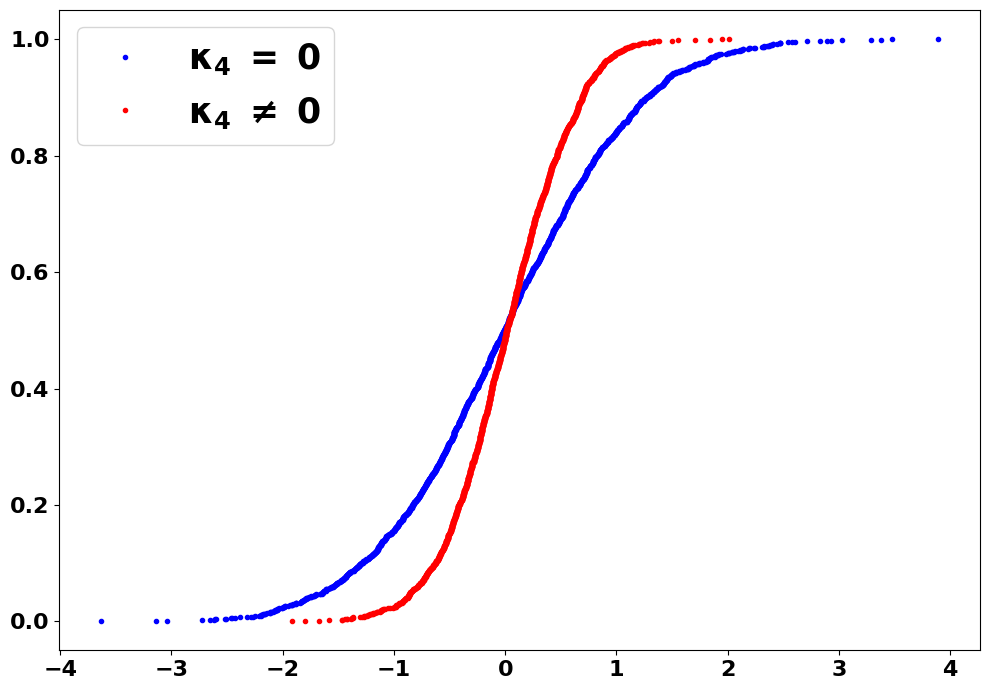

In [ ]:
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')

### Figure 2(b) Local

#### Discussion: it suffices to consider only sum of functions of eigenvalues within an interval when it comes to Local Statistics.

In our theorem, we introduce the the factor $\mathcal{K}(x)$ which is a mollifier to ensure that the test functions $g(x)=h(x)\mathcal{K}(x)$ will satisfy the assumption that  $g\in\mathcal{C}^2_c(\mathbb{R})$. $$\mathcal{K}(x) \equiv \mathcal{K}_{a, b}(x):= \begin{cases}0 & |x| \geq a+b \\ 1 & |x| \leq b \\ \exp \left(\frac{1}{a^2}-\frac{1}{a^2-(x+b)^2}\right) & -(b+a)<x<-b \\ \exp \left(\frac{1}{a^2}-\frac{1}{a^2-(x-b)^2}\right) & b<x<b+a\end{cases}.$$

For simplicity of implementation later, we simplify the discussion of local statistics to omit $\mathcal{K}(x)$. That is, we will directly use  $h(x)$ in the implementation of local statistics later. In order to show that there is little harm in doing this. We can do two simple realizations of $T_1^l$ with $h(x)$ and  $h(x)\mathcal{K}(x)$ respectively. Then show that the distributions of the realized statistics are extremely close  when the tuning parameters $a,b$ in $\mathcal{K}$ are properly chosen.

Below we show that there is little difference using test function
$$\frac{x-E}{\eta}1_{x-E\in[-\eta,\eta]}$$
vs
$$\frac{x-E}{\eta}\mathcal{K}_{0.05,1}\left(\frac{x-E}{\eta}\right)$$

In [27]:
import numpy as np

def K(x, a, b):
    if x >= a+b:
        return 0
    elif x<-b-a:
        return 0
    elif abs(x) <= b:
        return 1
    elif -(b + a) < x < -b:
        return np.exp(1 / a**2 - 1 / (a**2 - (x + b)**2))
    elif b < x < b + a:
        return np.exp(1 / a**2 - 1 / (a**2 - (x - b)**2))
    else:
        return 0

def Testfunc1(x, E, eta):
    a = 0.05 * eta
    b = eta
    return (x-E)/eta*K(x - E, a, b)


# Vectorize the Testfunc
vTestfunc1 = np.vectorize(Testfunc1)

In [19]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 800
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/4))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-eta1, midb+eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)


-0.57790804
1.154052
-0.58190227
1.1411626
CPU times: user 2min 29s, sys: 2.89 s, total: 2min 32s
Wall time: 2min 29s


In [28]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 800
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/4))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic_K(E0, midb, eta1):
    Eb =vTestfunc1(E0,midb,eta1)
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic_K(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic_K(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)


-0.57521427
1.1631669
-0.58357704
1.1412829
CPU times: user 2min 27s, sys: 1.87 s, total: 2min 29s
Wall time: 2min 26s


We can see from the output that the difference is rather minor. Therefore, we will use out simplified realizations in the sections after.

#### Data generating

Generate the data for the local statistics with gaussian and 2PN entries.

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 800
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/4))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-eta1, midb+eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, midb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)


-0.57790804
1.154052
-0.58190227
1.1411626
CPU times: user 2min 32s, sys: 3.34 s, total: 2min 35s
Wall time: 2min 32s


#### Saved data

In [ ]:
TestST1=[-2.0987868 , -0.8061061 , -1.5764651 , -2.349066 , 0.7518563 , 0.54666185 , -0.3727354 , -1.1375306 , -1.3020334 , -0.40716884 , 0.39512292 , 0.57617044 , 0.33241877 , -1.125571 , -0.89935803 , 0.08794737 , -2.2017167 , -0.49428928 , -0.95210123 , -0.98104167 , -2.313816 , -1.2011123 , 0.6099038 , 0.7436046 , 1.2316861 , -3.0535717 , 2.3408089 , -1.5932279 , -0.15325832 , -1.4013315 , -0.88586724 , -0.70362735 , -1.0448111 , -3.095597 , 0.6769445 , -1.5003253 , -1.1984698 , -0.042386264 , -1.208766 , -2.8652203 , -0.6262859 , -0.38342202 , -1.4066066 , 1.3915374 , 0.3958078 , -0.4152991 , -1.0580233 , -0.17505732 , -0.20946994 , 0.2587793 , -1.9229176 , -0.65674293 , 0.42185247 , 0.15312672 , -0.61371267 , -3.492034 , 0.16376221 , -0.44475693 , 0.6264231 , -0.0128876865 , -1.2909257 , -1.6555114 , -0.6851357 , -1.6909382 , -1.1973542 , 0.5052345 , -0.23820797 , -0.43386212 , -0.34426168 , -1.8058527 , -0.43740276 , -0.6718016 , 0.27077964 , 1.3334895 , -2.1110356 , -1.8111432 , -1.028545 , 0.0019223094 , -1.9450266 , -1.7141118 , -0.95797956 , -1.3388048 , -0.4005501 , -0.38470024 , -1.7281104 , -0.12901986 , -1.1203113 , -1.3781273 , 0.7665652 , -1.3760988 , -0.5515157 , -0.2791079 , 0.4685744 , -1.1009114 , -1.8210788 , -0.883884 , 0.23986667 , -0.65641344 , 1.0651443 , 0.8460371 , -0.6680583 , 2.0249598 , -1.8558872 , -0.70633596 , -0.9644057 , -1.1255203 , -0.56883615 , 0.36437216 , -2.1406503 , -0.58958554 , -0.39877474 , -0.027261674 , -3.4895234 , 1.266875 , -0.0824337 , 0.5268767 , -0.31544304 , 0.15950188 , -1.715481 , -2.1495314 , -0.19930083 , 0.8197194 , -1.0741876 , -0.7479567 , 0.23715788 , 0.39603096 , -1.0346162 , -0.2926549 , -1.4570315 , -0.2957996 , -1.0336728 , 0.21165138 , -2.1433945 , -0.70229924 , -1.5430257 , -0.7983154 , -2.2487533 , 0.19113544 , -0.06175551 , -0.37758446 , -2.3838542 , -1.9200268 , -2.4443724 , -1.7560565 , 1.0904783 , -1.0307972 , -0.024329841 , 0.25814563 , -0.73025525 , 0.05079019 , -0.9536232 , -0.7587546 , -0.35066718 , 1.2089739 , -0.13653117 , -0.5316087 , -1.2326854 , 1.1029809 , -2.4241405 , -0.28944978 , -0.60640943 , 1.4282233 , -0.67084306 , -0.55160713 , -2.3164992 , -0.04626125 , 0.7781544 , -0.06307945 , 0.05817017 , 0.44367146 , -2.5473375 , -1.6130897 , 0.7441828 , -2.0873091 , -1.7590241 , 0.33199796 , 0.14789218 , 0.51089466 , -0.99671423 , -0.85556245 , -2.7216341 , 1.2427982 , 0.7737522 , 0.09311047 , -2.3910007 , 0.9792107 , -1.131556 , 0.276146 , -1.2840991 , -1.960881 , -0.11691809 , 0.3792936 , -0.5538336 , -0.07953793 , 1.1325859 , -2.0500913 , -0.15606308 , -0.4306365 , -0.90717936 , -0.89354086 , 0.80994034 , -1.3941596 , -0.22132325 , -0.04556644 , 0.757116 , 0.16155604 , 1.0009744 , -0.21486703 , -0.45713252 , -1.7907689 , 0.90404475 , 0.77239317 , -0.73174155 , 1.1886559 , -0.9348465 , -1.1939867 , 0.63448215 , -0.8545684 , 0.0728026 , -1.6226498 , -1.6140479 , 0.87364376 , 0.057231665 , -0.16678008 , -2.4364958 , 1.648456 , -2.4662476 , 0.56737065 , -0.075003535 , -0.07119995 , -0.34530666 , 0.6907756 , -2.8616748 , -0.9793222 , -0.6755041 , -0.4449242 , -1.0073496 , 1.0349157 , -2.1796532 , 0.6226089 , -2.5374727 , -1.4655418 , -0.7430719 , -0.9556363 , -1.9952134 , -1.0009135 , -1.0476618 , -0.8137291 , -0.710191 , -0.6662477 , -2.883454 , -1.4456196 , -0.1156598 , 0.18535864 , -1.560164 , -0.67303926 , -0.9180992 , -1.0453027 , -2.0106568 , 0.38156077 , -3.0026793 , 0.9537345 , -0.38494357 , -0.009226143 , -0.70906496 , -0.047245145 , -0.4277153 , 1.5700135 , 0.06151709 , 0.6693467 , -1.0040576 , -0.26339 , -1.3666955 , -0.17951521 , -1.8320645 , 0.26954758 , -1.0101087 , -1.4955883 , -1.5852648 , -0.42785233 , -0.2514255 , -0.49959975 , -0.6730288 , -0.13735273 , 0.89840996 , -0.62689465 , 0.8360556 , -3.2988849 , -1.7403033 , -0.8768493 , 0.67605186 , -1.6209713 , -0.9599118 , -2.0579731 , 1.9072249 , 0.05572009 , 0.66573066 , -1.379294 , -0.73608804 , 0.36647704 , 0.097938776 , 1.3250751 , -0.604847 , 0.20483977 , -0.8603449 , -1.8628106 , 1.0941355 , -1.3397131 , -1.0602298 , -0.17124823 , -1.2664486 , 1.4807069 , -0.7316702 , -1.3645804 , -1.8575966 , -1.8882716 , 1.6161735 , -2.5922697 , 0.75883055 , -1.644008 , -1.6582499 , -0.16788578 , -2.5492039 , -2.9148335 , -1.0077099 , -0.93888414 , -0.30795172 , -0.024634004 , 0.14006639 , 0.24824008 , -0.43321842 , -0.35695687 , -1.0950481 , -0.46380717 , -0.24040926 , -1.3858219 , -0.7302099 , -0.22368205 , 0.6577167 , -1.3007755 , -0.35525274 , -1.9231104 , -2.2209947 , 0.12475398 , -0.08310342 , 1.0906811 , -0.2021974 , -1.0550154 , -0.41448778 , 1.017103 , -0.2717081 , -1.3940128 , -0.25673535 , 0.38524806 , -1.7096436 , -0.64190274 , 0.7684625 , -1.1178061 , -0.042132676 , -0.5529716 , -0.52861094 , 0.16475666 , -0.2577805 , -0.9911961 , -0.17232859 , -0.11493999 , 0.5273377 , -0.2552191 , -1.0975792 , -0.05355981 , -3.0256348 , -0.28824222 , -1.0607672 , -1.062725 , -0.5504253 , -1.4298203 , 0.24863052 , 0.055020183 , -0.10231584 , 0.011117518 , -1.8439887 , -0.37371433 , 0.21103793 , -1.3608425 , 0.36456487 , 0.43502912 , 1.7731692 , -0.78860784 , 0.9127227 , -1.3238829 , 0.56728935 , 0.105292976 , -0.89835894 , 1.2755172 , -1.8362284 , 0.21652544 , -2.0741272 , 0.74077976 , -0.853569 , 0.5582968 , -0.28297246 , 0.91773427 , -2.0846715 , -1.3334489 , 0.21572915 , -0.30800244 , -1.5312135 , -1.2278972 , -0.17467692 , 0.11864215 , -0.72356045 , -1.0203087 , 0.9877417 , -1.4983575 , -0.11108506 , 1.6618662 , -0.50649214 , -0.625368 , -0.3104774 , 1.288167 , 0.029351234 , 0.8768544 , 0.103314936 , -1.5137609 , 1.2099829 , 0.2279473 , 1.9962071 , -0.8854815 , -0.9872141 , 0.46909204 , -2.0245037 , -1.0220735 , -2.5255384 , -1.0220835 , 0.5785289 , 0.9466489 , 1.764096 , -1.8998966 , -1.2358651 , 0.26160976 , 1.3221134 , 0.46329483 , -1.1211178 , 0.06238973 , -0.45824316 , 0.18433908 , -0.31856728 , -0.45787838 , -0.98908055 , 1.6224725 , -1.5212827 , -0.7087049 , 0.04152876 , -2.0329788 , 0.57048476 , -0.06656909 , -1.2658807 , -0.46938115 , 2.344836 , 2.4243283 , 0.4631222 , 1.7795651 , -0.84016395 , -1.3651785 , 1.208791 , -0.57049 , 0.09424159 , -2.1353958 , -1.9514878 , 0.6934285 , 0.6539683 , 0.01696065 , -0.49782935 , -0.9767859 , -2.6736639 , -1.1983888 , -1.1662633 , 1.2029994 , -2.4091482 , -2.070825 , -1.2643994 , -0.13677943 , -0.4792456 , -0.7979655 , -1.6906341 , 0.1063478 , 0.28352028 , -0.9714148 , -1.487585 , 0.18463317 , 0.7504466 , -0.8706413 , -1.9687074 , 0.3470207 , -0.96380717 , 1.1026156 , -2.2881823 , -0.88469017 , -1.6681147 , 0.780589 , -3.019473 , -1.4898973 , 0.0148099065 , 1.0485235 , 0.13218933 , -0.901585 , 0.7940501 , -1.3209873 , -0.17160362 , -0.91687673 , -2.67302 , -0.8943016 , -1.0700641 , -1.0653775 , 0.4641061 , -2.2448025 , -1.2886435 , 1.0971531 , -3.3123608 , -1.3834325 , -1.6613843 , -0.6642901 , -1.2375088 , -0.6180086 , 0.31350064 , 1.1130942 , -1.2010306 , -2.0294232 , -0.4279435 , -1.0648041 , 1.0395057 , -0.190968 , -0.09937939 , -1.7736919 , 0.6616375 , -1.9026 , -1.1961268 , -1.1804693 , -0.5861822 , -2.0606663 , -1.1962738 , 0.03884074 , -0.4588972 , -2.2700455 , -0.78861296 , -0.53886163 , -1.235226 , -0.21545553 , -1.8432026 , -1.3975073 , -0.95857286 , -0.47853592 , -1.3927703 , 0.537609 , 0.3612476 , 0.1553173 , 0.19227117 , -0.18195513 , -1.1923424 , -0.30781484 , -3.727249 , -0.21292406 , -0.014875889 , -1.0811205 , -2.762093 , -1.8632569 , -0.0046004057 , -0.10352287 , -1.370403 , 0.95112735 , 0.49918896 , 1.1917342 , -0.0023786128 , -0.22391525 , -1.6548059 , -0.45722383 , -1.7311432 , -0.7917727 , -0.68920314 , 1.1179224 , -0.4303927 , 1.421903 , -1.6080478 , -1.1388545 , -1.321317 , 0.32051516 , -1.4006772 , 1.2634819 , -0.6818847 , -1.4695845 , 0.82261467 , -2.0433357 , 0.751603 , -1.4326909 , -0.21768168 , -0.19749561 , -0.3392709 , -1.7936647 , -0.626773 , 0.20801458 , -0.9017624 , -1.0723414 , -1.0737107 , -2.527268 , -2.5916157 , 1.1554245 , -0.6449254 , -1.1448396 , -1.428071 , 1.1563778 , 0.1888074 , -0.47130832 , 1.3059841 , -1.8206072 , 0.5460688 , -0.10728124 , 0.5463376 , 0.36268845 , -1.3666396 , -1.5015931 , -3.363009 , -1.1115117 , -1.4134281 , -1.2156942 , -1.6579608 , -2.4126782 , -1.7989805 , -0.027078927 , 0.31115264 , -1.1052682 , -0.75550324 , -0.5821859 , -3.1281333 , 0.0021556616 , 1.3745265 , -1.4757569 , -1.3314252 , 1.4447522 , 2.6102142 , -0.92929304 , 0.005183518 , 0.025151849 , -1.0555685 , -0.20428681 , 0.3117659 , 1.3159459 , -3.6778584 , 0.38684073 , -0.8410361 , -1.8490403 , 0.77559817 , 0.118759125 , -0.7280693 , -1.8635814 , -0.5801923 , -0.19966137 , -0.3447437 , 0.29988763 , -0.03722301 , -0.85789 , -0.116852015 , 0.09659481 , -1.7123976 , 0.7458462 , -0.8343107 , 0.038166463 , -1.1202307 , 0.8848835 , 1.7780234 , -0.20227823 , -0.9223948 , 0.31058457 , 1.2868687 , -0.3565513 , -1.7584202 , 0.6659939 , -0.9939649 , -0.24823505 , -1.6575196 , -0.85401565 , -1.5221903 , -0.7809799 , -0.59064054 , -0.4093144 , 0.120346695 , -0.78786755 , -0.9015999 , -1.2932179 , 1.1846995 , -1.6815197 , -1.6362579 , -1.8823171 , 0.26312605 , 0.50572675 , -2.1881087 , -1.1535833 , 0.11198306 , -0.71136266 , 2.090337 , -0.89705557 , 0.5421226 , -0.31232402 , -0.12101117 , -0.25184655 , -1.38853 , -2.0214605 , -2.5719566 , -1.4010121 , -2.0399978 , 0.26543894 , 0.33208913 , 0.10574946 , -0.88672435 , 0.99589723 , -1.3350922 , -0.41059247 , -1.9061857 , -0.6545267 , 0.25825232 , -0.4598512 , -0.0015215278 , 0.10074851 , -1.8778843 , 0.23582935 , -2.6319778 , 0.58125776 , -2.330254 , -2.0592108 , -0.39199853 , -0.03175524 , -0.6105832 , -1.2325327 , 1.4762032 , -0.8972233 , -0.5091246 , -0.09860852 , -0.68417704 , -0.8146571 , 0.024223745 , 0.5392268 , -1.6804795 , -0.68572366 , -0.66280377 , -0.16008028 , 0.40255335 , -0.26385128 , 1.3552326 , -1.4156694 , 0.49348816 , -0.19786555 , -0.11044583 , 0.81575257 , -1.0107021 , -0.9389191 , 0.9816859 , -0.51254815 , -2.4992354 , -0.094459295 , 0.18888852 , 1.3194654 , -1.6235986 , -1.7195542 , -0.8221891 , 0.115908325 , -1.4261029 , -2.814643 , -0.49488768 , 1.7486113 , -1.420493 , 1.1115929 , -0.211413 , -1.1236489 , -1.1249068 , -0.6773909 , -2.357211 , -0.12974977 , -0.8015816 , -2.4200017 , 0.7570604 , 0.7510099 , -1.3680296 , -2.3574042 , -0.4924378 , -1.2469268 , -0.82784903 , 1.382292 , 0.08559367 , 0.55711055 , 0.5604626 , -0.28684264 , -0.6894672 , -1.0091909 , -1.1001961 , -1.7851696 , -1.6094427 , 0.4888063 , -0.86501133 , -2.1635451 , -1.5203443 , -0.4774506 , 1.2866656 , 0.8261045 , 0.1504839 , -0.895818 , -1.0393378 , 0.09002173 , -0.72021323 , 0.1890609 , 1.5271051 , -0.32238147 , -1.9970444 , -1.3082008 , 0.3993885 , -0.32717466 , -1.3691654 , -0.62284744 , -0.9869456 , -1.1768279 , -0.25202388 , -0.35493308 , -2.1668468 , -2.543427 , -0.5207139 , -0.23521537 , -0.4147413 , -3.1991656 , 0.2504011 , -0.87943554 , -1.0581553 , 0.6763713 , 0.11843929 , -0.71793544 , -1.8480964 , -1.0732338 , -1.1432824 , 0.9569099 , -1.0290171 , 0.8528489 , -0.73646843 , -0.34868446 , 0.8324546 , -0.49085057 , 0.8489384 , -0.41364563 , 0.24035338 , -1.6894729 , -0.04977092 , -2.0008988 , -1.2765012 , -1.3174114 , -1.2466581 , -1.8107978 , -1.1433027 , -1.7376103 , 0.52886987 , 0.15952197 , 0.21189964 , 0.6511283 , 0.09080255 , 0.29137182 , 0.2827396 , -1.4451525 , -1.7886341 , -0.9625087 , 1.2613515 , -2.2353787 , -1.1816308 , 0.7197716 , -1.2267103 , -0.43222898 , -0.56156826 , -1.055137 , -0.65852314 , -1.5116508 , 0.6119477 , -2.9222336 , -0.20946532 , -2.4787803 , -0.36754665 , -1.3891132 , -0.92329264 , 0.8975631 , -2.3330083 , -0.08504102 , -0.93275213 , 0.15802607 , -1.293198 , -1.4006774 , -0.38847363 , -0.9437783 , -0.1821172 , -0.69785047 , 0.55748045 , -0.09923723 , 0.7148162 , -1.1868854 , -0.15448603 , -0.96372104 , -1.6487296 , -0.39410338 , -0.6945237 , -1.7819943 , 1.91599 , 0.8325308 , 1.2412417 , -0.3186589 , -0.9882942 , 0.93217397 , 0.748753 , 1.1160612 , 1.3868968 , -0.3699053 , -0.14560497 , 0.7780224 , -1.1619115 , -0.34705156 , -1.0345353 , -1.673501 , -0.05644515 , -0.95487046 , 0.52538514 , 1.7039124 , -0.6124246 , 0.18615478 , -0.91223073 , -1.2044146 , 1.0109152 , 0.40399367 , 0.68549037 , 0.63301647 , -1.9871333 , -0.6340817 , 0.6553838 , -0.8521134 , -0.22826192 , -1.6185522 , -1.1407416 , 0.9010271 , -1.2785203 , 0.119002014 , -0.75602067 , -0.23740664 , -1.4712936 , 0.18435428 , -0.6433886 , -0.27329528 , 0.19233254 , -2.6452508 , -0.7284494 , -0.36764833 , -2.1010337 , -1.005189 , -0.39823243 , -1.1658221 , -0.4489464 , -2.4966388 , -2.8194816 , 0.8929576 , 0.23112723 , -1.0959765 , -0.8124002 , -1.2834449 , -1.1542479 , 0.64891696 , -2.2171607 , -2.149212 , -1.955236 , -0.2763639 , -0.614529 , -0.44425488 , -1.6673942 , -2.535018 , -1.0654738 , -1.7277302 , 0.08754128 , -1.6862773 , 1.2096078 , 0.8023481 , -1.1249526 , 0.033713102 , -0.042690665 , -2.4926062 , -2.0552292 , 0.40035212 , -0.037649035 , 0.48503792 , 1.5732192 , 1.7694111 , 0.29903573 , 1.2893082 , -1.4704316 , -0.3171526 , -1.6202915 , -1.3104835 , 0.5742179 , 1.43189 , 0.48335922 , -0.7638673 , 0.2682184 , 0.24926946 , -0.20380515 , 0.13979205 , -0.61758804 , -0.14637041 , -1.2801483 , -1.0146327 , -2.3707535 , -1.2539163 , -0.9513098 , -0.742499 , 1.0013852 , 1.8924658 , -0.4626152 , -0.9807068 , -3.0063462 , -0.086364776 , -2.2907133 , 1.8299296 , 1.636841 , -1.043477 , 0.113707334 , 0.37579387 , 0.28461593 , -1.1771327 , -0.37599656 , -0.24551141 , -3.6491315 , -2.4240396 , 0.24855974 , -1.3569063 , 0.18128556 , -0.8468739 , -0.6088941 , -1.6570576 , -2.4400158 , -0.17287645 , -2.0888 , -1.6783648 , -0.81888235 , -4.190179 , -0.25915486 , 0.77408195 , 0.12771586 , -1.1557591 , 0.80904746 , -0.10575479 , 0.71489245 , -1.8022673 , -2.2756698 , -0.96518177 , -1.7145886 , -0.040616065 , 0.062141508 , -2.109813 , -1.0769315 , 1.299457 , 0.6707213 , 0.1570471 , -0.028113723 , -2.8103013 , -1.9542826 , 2.2793832 , 0.08112064 , -1.4909678 , -0.7659919 , -1.3407326 , -1.920022 , 0.40288797 , -1.9308909 , 0.8726294 , -1.9867479 , -0.50787205 , -0.15258852 , -2.0797164 , -0.33259144 , -1.2489812 , 0.41506112 , -1.9635744 , -0.43427834 , -1.6803937 , -0.8288987 , -0.5918273 , -1.851226 , -2.249697 , 0.07487619 , -1.9956592 , -0.17896274 , 0.5079073 , -1.0366758 , 0.084011406 , -2.159543 , 0.99935615 , 0.0034437776 , -2.2093496 , 0.4419824 , -0.81156814 , 0.448236 , -1.6014241 , -0.051302373 , -0.27344793 , -2.5560508 , -1.5041902 , -0.73596644 , -2.9999914 , 0.8107013 , -0.5166514 , -1.4814576 , -0.879598 , -1.6344168 , -0.91871786 , -1.0299047 , -0.5445876 , 0.4670732 , 0.17169988 , 0.8733599 , -0.35844308 , -1.1723443 , -0.78582853 , -2.565094 , -0.9610534 , -1.23125 , -1.7059002 , -1.2425499 , -0.36024353 , -1.1558404 , -0.35801214 , 0.3985569 , -0.8736079 , -0.5857814 , -1.9286339 , 0.68675864 , 0.43654004 , 0.77408683 , 0.71411663 , -0.8193234 , -3.1128569 , -0.9247482 , -0.9930619 , 0.1400406 , 0.4055305 , 0.9292166 , -0.61837375 , -1.294943 , 0.23319656 , -1.0808722 , -0.08644599 , 0.79950744 , -1.0334496 , -1.3452919 , 0.9111505 , 1.1231718 , 0.42385542 , 0.18575904 , -1.4886802 , 1.5870094 , -2.2365456 , -0.5032309 , 0.19576603 , 1.0527892 , 0.560914 , -0.3567031 , -0.80834234 , -1.0294781 , -2.0658298 , -0.96761626 , 1.1255909 , -1.2729459 , -0.9787239 , -0.20312044 , -0.6051107 , -0.753216 , -2.6209717 , -1.7963636 , -1.1230909 , -0.64246035 , 0.7818012 , 1.4332085 , -0.15993297 , 2.164377 , -0.9010322 , -0.8480052 , 0.3443177 , -1.7519743 , -0.58689773 , -0.066143125 , -0.972034 , -1.0624409 , -1.3488117 , -0.21983227 , -1.3110257 , 0.37028056 , -1.7976009 , -0.21504894 , 0.87526166 , -0.41633415 , -1.1012161 , -0.821819 , -0.5765153 , -2.3199224 , -0.65170145 , -0.60619617 , -0.6771675 , -0.18379101 , -1.5703177 , 1.5942118 , 0.648344 , -0.24935108 , -0.97039545 , 0.18735671 , 1.7218163 , -0.93650997 , -0.5126546 , -0.6550792 , 1.8268964 , 0.24835181 , -1.2063162 , -1.1527414 , 0.8408943 , -2.5709677 , 0.44355464 , 1.3686177 , 0.85573494 , 1.6864444 , -2.114109 , 0.5672336 , -2.419728 , -0.36109525 , 0.69827694 , -0.72631466 , -1.9760203 , -1.6793638 , -1.0952462 , -0.16345826 , -1.0630041 , -1.3793956 , -1.1305519 , -2.2263303 , 0.9916213 , 0.33733875 , 0.9313371 , -0.013506472 , -1.634153 , -2.6291475 , 0.12655988 , 0.09537235 , -0.96815383 , 1.4270666 , 0.88012576 , -0.92406875 , -1.1925913 , 0.29596215 , 0.014505863 , -0.9672207 , -1.9258897 , -1.6540351 , 1.80423 , -0.6837356 , -1.7463439 , -1.9463044 , -1.6471069 , -0.041016847 , 1.5558627 , -1.5075986 , -1.1584018 , -0.28930756 , -2.8166716 , -1.6798464 , -1.5446539 , -0.33228198 , 2.4528117 , -0.8412139 , -3.4449358 , -0.27995977 , 0.81780183 , -0.25949967 , -0.35888916 , 0.09966859 , 0.84171605 , -2.63814 , 1.0370208 , -0.24573454 , 1.0373602 , -2.0291035 , 1.021399 , -1.6670091 , 0.3556634 , -0.07065189 , 0.24934095 , 0.5560297 , -0.56514925 , -0.55390435 , -1.1308717 , -1.2604389 , -1.3267949 , -0.6563624 , -1.573883 , -0.39497608 , -0.88088137 , -3.0576186 , -0.8144646 , -0.8098443 , -1.3754545 , -0.03533572 , 0.5848079 , -0.97645146 , 0.33145514 , -0.57486165 , 0.44862145 , 0.28105012 , -1.2386396 , 0.8959701 , -0.35538965 , -0.467986 , -1.6758498 , 0.027641773 , -1.1779338 , -1.5394964 , -1.2398416 , -0.8788527 , -1.7443913 , -1.8808765 , -0.85316324 , -0.605618 , -0.7618535 , 0.6721462 , -0.61371756 , -1.4070117 , 1.3859637 , -0.00037512183 , 0.33449334 , -0.052479446 , 0.22987992 , -1.3218496 , -1.3020788 , -1.5465102 , -0.22624862 , 0.3797246 , 0.25539652 , -0.9554689 , -1.1950464 , 0.09877059 , -1.6355782 , -0.26307032 , 0.9797026 , -0.031217694 , -0.48387167 , -0.028144062 , -0.11079073 , 0.82513595 , -1.049487 , -0.4071281 , -0.506964 , -1.8231485 , 0.6648731 , -0.9758787 , 0.1992251 , -1.3310752 , -0.18922865 , -1.2585416 , 0.3554 , -2.8014712 , -0.41481745 , 1.1317534 , -0.3645145 , -1.3178222 , -1.3159969 , -2.3369186 , -1.9592533 , -0.60864615 , -0.03272438 , 0.68781877 , 0.114387065 , -0.74222 , -0.8806125 , -1.27676 , -0.3712391 , -0.69483316 , -2.298996 , -2.1375465 , 0.62463754 , 0.27060238 , -0.33541632 , 0.7017158 , -0.040377796 , -3.1684098 , -1.4626615 , -1.1095893 , -1.4441792 , 0.17242503 , -1.4127835 , 1.1898878 , -1.2031107 , -3.472938 , -1.1627992 , 0.39484394 , -0.5656004 , -3.1903102 , -0.11502609 , -0.25904313 , -0.85330987 , -0.6175219 , -1.4916471 , -0.53353083 , 1.4620423 , 0.74144375 , -1.129035 , -1.9450366 , -1.4023359 , 0.3414418 , -0.6774411 , -1.0694196 , -1.8788581 , -0.27128714 , 0.05573553 , -0.26176155 , -1.2221103 , 1.017164 , 0.39904845 , -1.5529215 , -0.19405708 , -1.9507982 , -0.5851478 , -0.89149654 , 0.27529377 , -1.0182238 , -0.03615278 , -0.08840346 , 0.0668177 , -1.9172732 , -1.2488136 , -0.00683704 , -0.72087234 , -0.8057102 , -2.8692877 , 1.2932134 , -1.0169662 , -1.9694831 , -0.57702243 , -1.5841494 , -0.69384915 , -0.40954736 , -0.6255458 , 0.04179302 , -1.2177637 , -3.1169906 , -0.93450665 , 0.18332943 , -0.4591864 , -0.6832994 , 0.2986806 , -1.9759296 , -0.66947365 , -1.4395893 , -0.97402227 , -0.42251125 , -2.14698 , 0.7678127 , 0.4843582 , -0.105713904 , -1.6053903 , -0.60311216 , 0.585295 , -2.4691591 , 0.9308755 , 1.2354187 , -0.82022625 , -0.45610794 , -0.4427483 , 0.9411611 , 0.10009423 , 0.06301844 , -1.2437215 , 0.6176286 , 1.6221274 , -0.7689998 , -1.3809017 , 0.40561697 , 0.06561035 , -1.6266972 , -1.7875686 , -1.2870458 , 1.130851 , -1.2572736 , -0.25383464 , 0.6051667 , -1.5319288 , 0.01242134 , -0.6998597 , -1.407428 , -1.6641382 , 0.41582683 , -1.0372841 , -1.041499 , 0.67400205 , 0.29219347 , -1.0188932 , -1.4635389 , -0.5974218 , 1.2157705 , -4.1392365 , -1.8832452 , -1.1733586 , -0.12943035 , -3.020842 , -0.037932873 , -0.79277194 , -1.3652955 , -0.25944424 , 0.22744551 , -0.33297193 , 2.0453894 , -1.1459398 , -1.1904666 , -0.78651345 , -2.4875448 , -0.8094127 , 0.07991812 , 0.28286606 , -0.1408068 , 1.0054984 , -0.12238553 , -0.6702242 , -0.40737665 , 0.49380744 , 0.91108966 , -2.4861093 , -0.25132418 , 0.37135574 , -0.38904685 , -0.12747738 , -1.8099508 , -0.98451066 , -0.12633118 , -0.12965322 , -0.61304843 , -1.802769 , -1.3834836 , -1.98621 , 0.61262196 , 0.8399613 , -0.71628225 , 1.5682025 , -0.99358964 , -1.811224 , -0.689903 , -1.6985414 , -1.6566467 , -1.7462732 , -0.18529254 , -0.025881678 , 1.2548493 , -1.1895686 , -1.3989122 , -1.1172634 , -0.76305556 , 0.75511813 , -0.10392359 , -0.8261703 , -1.5236664 , -1.3988055 , 0.7335119 , 0.17356089 , -2.9571543 , -2.6564803 , -2.605781 , -1.0908843 , -0.53600067 , -1.0371675 , -1.2084107 , 0.86821175 , 0.41704392 , -0.6282789 , -1.7695581 , -0.6099341 , -0.8255569 , -0.2999078 , 0.9090457 , -1.3190954 , -0.20679227 , -0.84127957 , -0.954759 , 0.5601125 , -1.2301438 , 1.0657225 , 0.17101529 , -0.43949723 , 0.7193912 , 1.4565296 , -1.9816408 , 0.3791261 , -0.39064962 , -1.983999 , -0.7091867 , -0.89632 , -1.8072478 , -1.5581198 , -0.25490484 , -0.104958415 , -0.22613189 , -1.263923 , -0.7084055 , 0.21543965 , -0.60228586 , -0.71414703 , -1.98123 , -0.3276006 , -0.78015274 , -0.010356724 , -1.2819837 , -1.7717544 , -0.045672238 , -1.072595 , -1.8620496 , -0.8346758 , -1.7150806 , -1.6084943 , -0.7584753 , -1.0101954 , -0.8266523 , -0.35709372 , -0.45110202 , 1.7089181 , 0.27818024 , -0.35977688 , -0.5801316 , -0.76454663 , -0.37057972 , 1.7839167 , -1.2372394 , -0.10699251 , 0.70312047 , -2.34476 , -0.12936962 , 1.0125432 , -0.7859249 , -1.632738 , -1.0621927 , -0.6153105 , -0.53524995 , -0.6125311 , -1.0553048 , -0.4999241 , 0.94137406 , -0.36801884 , 1.2032831 , -2.0030491 , -0.38881904 , -2.625683 , -0.13947237 , -0.55756664 , -3.856421 , -0.4684883 , -0.8018204 , -2.5691063 , 0.3094585 , -2.0936894 , 0.65225405 , -0.9284405 , -2.0209732 , -1.269913 , -3.2427387 , -1.7907487 , 0.006593555 , -1.7691474 , -2.2719626 , 0.08387947 , -1.1114206 , 0.25163856 , 1.9288926 , 0.1377024 , -1.6290962 , -0.5053358 , -2.4577622 , -0.11048189 , 0.83986914 , -3.2397308 , 0.6532229 , -1.2871017 , -0.6880115 , 0.7415351 , -2.721695 , 1.5633082 , -0.42154765 , 0.64889145 , 0.7781546 , -0.0038594604 , -0.8236754 , -1.3569982 , 0.026221782 , -0.10297042 , 0.3880936 , -0.7666261 , -0.4610328 , -1.6702249 , -1.1334887 , 0.072746634 , -0.42884615 , -1.0697852 , 1.1830659 , -0.8587218 , 0.07119462 , 0.876413 , -1.0530173 , -1.4727645 , 1.6514938 , -1.0894086 , 0.5835753 , -0.24621123 , 0.33958554 , -0.93032736 , -1.8321 , 0.6845423 , -0.84416544 , 1.3298526 , 1.5730414 , -0.6828382 , -1.3767784 , -0.61221135 , -1.3176045 , -1.0483863 , -2.4577422 , -0.2287795 , -1.6277828 , -0.56059456 , 0.2888609 , -1.2071531 , -1.6135156 , 1.2166525 , -0.39914995 , -0.782689 , -0.79097146 , -1.6096706 , -1.0104232 , -2.1717412 , 0.5804255 , -1.3749319 , 0.075779736 , -1.7785456 , -0.060503006 , -2.2810159 , 1.4328737 , -0.42966267 , -2.4423032 , 0.26109248 , 0.7809187 , -0.95712733 , -1.1289337 , -0.68709815 , -0.2746344 , 0.89081705 , -1.9368507 , -1.0437913 , -0.7743609 , -0.04402411 , 0.550258 , -0.71141326 , 0.4790631 , -0.89514315 , -0.51718915 , -1.7410288 , 0.6013676 , 1.802683 , -0.8798717 , -0.2788542 , -0.7195842 , -1.3989472 , -2.1178365 , -1.1885847 , 0.6789427 , 0.18546024 , -0.52357954 , -1.3439528 , -0.5190504 , -0.09590492 , -0.08248475 , -2.1752458 , -1.6863939 , -0.6389303 , -1.5074668 , 1.8579767 , -0.031136364 , -1.22491 , -0.7947246 , 0.03020358 , -0.4117133 , -0.9767206 , 0.94267774 , -0.92387605 , -1.2933555 , -1.3709811 , -1.1613132 , -0.1292426 , -2.4488454 , -2.7633402 , -1.0819933 , -1.3234168 , 0.28068024 , -0.05431533 , -0.18454176 , -0.7936748 , -1.4573259 , -2.0072181 , -0.48865956 , -0.27104327 , -0.95832944 , -0.45076698 , -0.35392386 , 2.0209327 , -0.2634915 , -1.3050662 , -1.7558993 , -2.939975 , -2.1261144 , -2.3672283 , -1.3415387 , -0.14468658 , 1.4271529 , -0.6780046 , -1.2721698 , -2.967369 , -0.34827885 , -1.8118072 , -0.33275878 , 0.6405076 , -0.879233 , -1.7470539 , -0.9690112 , 0.48610836 , -0.91234756 , 0.619789 , -1.7277249 , -1.9058915 , -0.34900406 , -1.1739826 , -1.3528897 , -0.53878516 , 0.7132138 , -0.100099325 , 0.5180868 , -1.2057431 , 0.1059728 , -1.1117857 , -1.1431961 , -0.050348997 , 0.76354235 , 0.526988 , -0.8505868 , -0.33534533 , -1.3428526 , 0.76551044 , -0.70340455 , -0.3142717 , -1.2261877 , -0.3900006 , -2.9514127 , -1.0561264 , 1.8851726 , 1.8550149 , -2.2765222 , 0.08683121 , -2.1582956 , 0.39800397 , -0.03584829 , -0.2638615 , -0.15182284 , -0.35981232 , -0.82676387 , -1.1209457 , 0.45241046 , -0.33892614 , -0.55612075 , -0.16650599 , -1.8816373 , -1.9428052 , -0.9734442 , 1.2097706 , -1.5448976 , 1.0584242 , 0.9816552 , 1.0791835 , 0.64527035 , -0.5413718 , -0.18805677 , -1.561001 , 1.5399675 , -0.9284507 , -2.4834313 , -1.0085516 , -0.2035361 , -0.15498766 , -1.5693442 , 0.23621938 , 1.2396743 , -1.1864343 , -1.738457 , -2.7835975 , 1.0771141 , -1.8638809 , -1.5503396 , -0.65051955 , 0.5479804 , -0.16677499 , -0.78206027 , -1.0772915 , -0.5294073 , -0.92847115 , -2.0124521 , -1.7412668 , -0.32692057 , -0.9314027 , -1.4678648 , -0.45648825 , -1.9265391 , -0.08879393 , -0.40680367 , -0.76747835 , -1.6085706 , -0.73438406 , -0.118495286 , -1.3100371 , -1.5346775 , -1.4313979 , -1.6794858 , -0.22141474 , 0.07233077 , -1.0338604 , -0.11998662 , -0.48587504 , -0.08086696 , 1.2205428 , 0.44466573 , -1.2610524 , -2.7752237 , -0.35596782 , -1.6906953 , -0.73794925 , -0.37098065 , 1.3808255 , -1.6725377 , 0.6793736 , -0.6643863 , -0.78998196 , -0.15992785 , -2.7347903 , -1.9363127 , -0.64134455 , -1.2533426 , 0.23413533 , 0.02125138 , -1.4644717 , -1.2032323 , -1.0631763 , -1.2851037 , 0.23163965 , -1.2348247 , -0.7324215 , -0.5239955 , -2.5058947 , 0.25933754 , -0.3447743 , 0.1314187 , -0.29779777 , -1.6390729 , -2.725854 , 0.81886184 , -1.059281 , 1.0187865 , -1.6361414 , -0.9148936 , -0.22556874 , -0.9301146 , -1.0449884 , 1.0144347 , -1.255336 , 0.36326617 , -1.5269833 , -0.6153455 , -1.0677664 , -0.93645465 , -1.3580328 , -1.1837103 , 0.07958317 , -1.5124931 , -1.8333781 , 0.6175114 , 1.5854425 , -0.60873187 , 0.13456836 , -0.8962493 , 1.359422 , -0.15928346 , -0.91872275 , 0.034595698 , -0.60198665 , -0.7871017 , -1.589155 , -1.6441857 , 0.9583955 , -2.3669395 , -0.14908418 ]

In [ ]:
TestST2=[0.084386915 , 0.84473366 , 0.680388 , 0.42592475 , -1.8706973 , -1.7243724 , 1.5859041 , -2.3757644 , -0.8271086 , -0.5163419 , -0.051845342 , -1.2022436 , -1.544096 , -0.074333966 , -3.251888 , -1.7275016 , 0.6643357 , -1.197268 , -0.8840056 , 0.277799 , 1.7986102 , -0.17706561 , 1.2620411 , -1.0478895 , -1.5384812 , 0.18111312 , -0.9449093 , -2.173354 , -0.6686926 , -0.8638042 , 0.49400532 , -1.4619257 , -0.44545168 , -0.095651 , 2.3439379 , -1.9091933 , -0.3899444 , -0.01871553 , -2.0382483 , -2.3417726 , -1.7669107 , -1.089008 , -2.3617759 , -3.4783597 , -0.5348848 , 1.1194386 , 0.60620624 , -0.4171403 , -1.8243401 , -2.5238342 , -0.7745788 , 0.675722 , -1.4205849 , 1.4919055 , -1.2902311 , -0.2635372 , -1.1685351 , -3.0885618 , -0.62167037 , -0.27927542 , -0.19596383 , -0.53723836 , -0.18129602 , -0.58353025 , 1.0908488 , 0.23508888 , -0.113245904 , -1.2051495 , -1.2845052 , -1.5056105 , -0.68999493 , -0.1642339 , -1.8537574 , -2.8387756 , -0.024157256 , -1.1262705 , -0.4799051 , -1.8035705 , -2.7026653 , 0.8917099 , -0.0020287037 , 0.7805537 , 0.07828516 , -0.6341218 , -0.70396775 , -1.1477456 , -0.72777057 , -1.9628949 , -0.20079744 , -0.58223104 , -0.31258255 , -0.42832366 , 0.5703175 , 2.1025653 , -2.4859262 , -0.8507948 , -2.1274886 , -0.565524 , -0.41086608 , -0.12786853 , -0.76479006 , -0.82825017 , -0.19011596 , 0.67135 , -0.4300433 , 1.4384527 , 1.0844786 , -1.7860625 , 0.2547579 , -1.0533723 , -1.736565 , -0.34630576 , -0.78523517 , -0.5055996 , 0.1894567 , -2.8518403 , 0.16775388 , 2.115707 , -0.19770873 , -0.53681207 , 1.9515442 , 0.0036415458 , -1.0080496 , -0.85463417 , 0.06964752 , -1.3521745 , 0.81772566 , -1.5288042 , -0.058199972 , -3.9595432 , -1.5111587 , -0.8854258 , -1.0212467 , 0.091365844 , -0.469589 , 1.157494 , -1.9384987 , -1.643744 , -1.5281345 , -1.174069 , -0.6710663 , -1.0809281 , -0.004706621 , -0.6302675 , -1.6942554 , -1.698774 , 0.8257546 , -0.14427075 , -0.3746123 , -1.1405842 , -0.02881834 , -2.6167164 , -1.6602226 , -1.2921072 , -0.16032821 , -0.5393889 , -1.6241715 , -0.656444 , -0.753875 , -0.41821572 , 1.0891751 , 0.7075026 , -2.175931 , -0.6228219 , -1.2353985 , -1.25736 , 2.406247 , -0.8754087 , -0.108777344 , -0.6183131 , -2.3524542 , -2.708427 , 0.39722282 , -0.58979356 , -0.7560866 , -1.1693875 , 0.18450129 , -0.60518146 , 0.2366153 , -0.9471814 , -1.557009 , -0.8191307 , 0.33124226 , -0.26077795 , 1.3217279 , 0.2483212 , 0.20114735 , -1.6962483 , 0.37789866 , -0.06401792 , -1.3088499 , -1.5581352 , -2.3531182 , 0.3258505 , -0.7592819 , 0.29542434 , 1.8796185 , 1.6104014 , -1.3457737 , 0.717895 , -0.10114896 , -0.9172014 , -2.8300917 , 0.13446671 , -0.09196916 , 1.1895738 , -0.53926694 , 0.600977 , 0.5870857 , -1.694448 , -0.42741594 , 0.6106591 , 0.19323513 , -1.3479346 , 0.65559137 , -1.2611184 , 1.1543491 , -3.1477013 , -2.7992344 , -0.13082507 , -2.1445913 , -1.1987386 , -0.587232 , -1.0430002 , -0.49977213 , -0.58272314 , 1.569004 , -2.2718816 , -0.36996114 , -3.0997663 , 0.24817386 , -0.22109002 , -0.6699298 , -1.6966295 , -0.44961056 , 0.75336844 , -0.025770277 , -0.51762 , -3.2040148 , -0.6373583 , -1.2221862 , -1.4725616 , 1.022733 , -2.3563795 , 0.13932076 , 0.81234455 , 0.28479344 , 0.21491295 , -0.8815558 , -1.872853 , 0.58208394 , -1.9985758 , -0.6396153 , 0.3934489 , 0.63084555 , 0.20906454 , 0.38855493 , 0.5322931 , -1.4375603 , -0.048223734 , -3.1515555 , -0.69198775 , -0.88909817 , -1.4783034 , -0.1793432 , -0.8163615 , 1.504251 , -0.5835959 , 0.3911874 , -0.49247378 , 1.1153357 , 0.14277983 , 0.27161664 , 1.2677372 , -0.8905993 , -1.1479788 , 0.71314776 , 0.026008785 , -0.9461676 , -1.2687768 , -1.681697 , -1.5399164 , -0.15709767 , -0.84112746 , 0.3630832 , -1.0363162 , -0.856257 , 0.19495472 , -1.5775099 , 0.72430617 , 0.26891324 , -0.39033502 , -1.4764671 , -0.23476446 , 0.61570555 , -0.48298883 , 0.25735444 , -0.0016533434 , -1.5172604 , -0.5898593 , -0.23939988 , 0.9713087 , 0.4095274 , -1.0743802 , 0.17717251 , 0.09380528 , -1.1744748 , -1.963341 , -0.14514312 , -1.7963328 , 0.48040247 , -0.9748896 , -1.2091568 , 1.5952106 , 1.3645349 , -0.26176667 , -2.5151613 , -0.2654137 , -1.1323521 , 1.0968692 , -0.7531296 , 0.514704 , 1.3743136 , 0.68441063 , -1.3630993 , -1.0731778 , -0.7660428 , 0.53551894 , 0.14663947 , -1.3718638 , -1.1282847 , -2.333703 , 0.74168736 , 1.4793785 , -1.2011833 , 1.1166242 , -0.4956995 , -1.2115303 , 0.9740374 , -0.34164453 , -0.66263664 , -2.0767846 , -1.2756903 , -0.09231925 , -1.878432 , -0.47178495 , -0.42258266 , -0.6478417 , 0.31668064 , -0.9154871 , -0.45338422 , -0.37532207 , -1.2030698 , -2.119627 , -3.5146544 , -1.6937581 , -2.0733712 , -0.9086704 , 0.32092565 , -0.5307563 , -1.6930633 , -0.87137634 , -3.115119 , -1.0849752 , 0.18946171 , 0.12716326 , -0.7751423 , -1.9478868 , -1.6734047 , -0.02692163 , -1.5418897 , -1.7004683 , -1.8129839 , -0.006861955 , -0.5733149 , 0.34731486 , 1.2371588 , -1.128031 , 0.1513614 , -0.95131016 , -0.6636815 , -0.20288232 , -0.509713 , 0.9231049 , -1.7752435 , -0.7590283 , -1.2885423 , -0.9470854 , 0.5521499 , 0.7832618 , -0.20448482 , -0.84836537 , -1.3515861 , -0.5505115 , -2.05458 , -0.4541905 , -1.9217618 , 0.043329597 , 1.9106234 , -0.9257225 , -0.76156443 , 0.23841089 , -0.108331054 , 0.9650651 , 0.3543552 , -2.5149734 , -2.079397 , 1.3871354 , 0.35151997 , -0.96405065 , 0.32700208 , 0.6260629 , -0.15141201 , 1.1166596 , -1.1536192 , -1.7749703 , -0.3783756 , -0.050825804 , -1.0675637 , -0.067619175 , 0.24424839 , -0.31684288 , 0.23498705 , -0.032612175 , 1.0887994 , -1.1454328 , -0.8833462 , -1.7364081 , -1.0309899 , -1.2632635 , -0.23638219 , -1.5408142 , 0.30090696 , 0.17964238 , -1.183249 , -0.16021198 , -1.4824216 , -0.49751464 , -0.93109834 , -1.1257485 , 1.3387488 , -0.4179467 , -0.82673836 , -2.4148335 , 1.0020089 , -0.17913005 , -2.7932749 , -0.7244836 , -1.5232959 , -0.55434096 , -1.8564147 , -0.99561846 , -2.9233341 , 0.49341184 , 0.3782744 , -0.055258453 , -0.23634657 , 0.19878891 , -2.054377 , -0.19848949 , 0.19554275 , -0.38776383 , -1.7459333 , -0.723393 , 0.35259008 , -0.18963403 , -1.2776325 , -0.08206841 , -0.29855877 , -0.68256915 , -0.7688681 , -0.59056956 , -0.045926154 , -1.0194056 , -0.09401828 , -0.65947706 , 0.5066596 , -1.1215997 , 1.2060723 , -1.1365978 , -0.13332027 , 1.2254014 , 0.32529762 , 0.2853663 , 0.6100662 , -0.6119476 , -0.7296567 , -0.026855916 , -1.1827166 , -0.9151221 , -1.5303308 , -1.2924929 , 0.124662876 , -0.92768484 , -1.0025363 , -1.5575876 , -1.1067548 , -2.1204686 , 0.03557986 , 0.38772827 , -1.8412496 , -2.2194529 , -0.7493714 , -2.5829322 , -0.4576754 , -2.0430007 , 0.31103548 , -0.21487191 , -0.5531845 , -0.40859923 , 0.13156575 , -2.8684409 , -0.039692998 , 0.7838352 , -1.6775177 , -2.509212 , -1.8947893 , 0.18326369 , 0.13413203 , -0.12563172 , -0.15995315 , 0.0717119 , -1.4128244 , 0.040879726 , 0.72339296 , -0.1943407 , -2.7588923 , -0.7128586 , 0.28436273 , -1.0020899 , -1.9987528 , -1.0724475 , -0.81696486 , -1.1405634 , -0.10403007 , -0.89096427 , 0.31019363 , -1.9650958 , -2.3417215 , 1.0421883 , -0.13930526 , -0.72029936 , -1.7880249 , -2.2353787 , -1.1709342 , -0.37478453 , 0.21672326 , -1.4011898 , -0.4456547 , -0.87386686 , 1.0765154 , 0.6898323 , -0.46399495 , -0.7648101 , 1.3964272 , -1.6630076 , -0.6919726 , 0.23660031 , -2.3510895 , -2.7572594 , -0.86414385 , 0.170878 , -0.5690292 , 1.3197092 , 1.2071632 , -0.9275834 , -1.041245 , -0.46123546 , -1.216805 , -1.9637063 , -0.38370585 , 0.12246132 , -1.7395933 , -1.5399721 , -1.7540379 , -2.486596 , -0.82929504 , -1.5900477 , -1.5217288 , -0.9899325 , 0.55536 , 1.8519162 , 0.28753236 , -2.4647107 , 0.9363327 , -1.5466468 , -0.65367424 , -0.03977889 , -1.174454 , 1.5874001 , -2.3542287 , -2.5790777 , 0.6321797 , -0.02847886 , -0.9947764 , -1.7143353 , -0.063890845 , -0.6470554 , 0.38348827 , 0.7566649 , 0.25607103 , -1.3005321 , -0.2004323 , -1.1801147 , 0.009180099 , -0.56699526 , 0.2250157 , -0.22533542 , 0.5759678 , -0.6930733 , -1.0905595 , -1.2971541 , 0.023559004 , 0.67342955 , -1.5715907 , 0.24408126 , -1.1691748 , -1.2611635 , -1.0827285 , -0.6149859 , -1.5769825 , -0.8299489 , 0.29238114 , 0.35360408 , 1.1422573 , -0.17583814 , -1.6948439 , -2.7072396 , -0.8053297 , 2.066834 , -0.33415842 , 0.3544156 , -1.2270043 , 0.7784487 , -1.5760593 , -1.3588998 , -0.25915495 , 1.3545835 , -0.44571537 , -1.1569409 , -0.70711714 , -0.12411007 , -0.124875754 , -0.14441791 , 0.32875207 , 1.6786486 , -0.4886799 , -0.6214981 , -0.44160745 , 0.3964574 , -2.7719321 , 1.4679611 , -1.5228701 , -1.509531 , -0.5751915 , 0.56344986 , -0.13581589 , -2.0171237 , -0.94031924 , 0.06409395 , -1.1010892 , 2.4737897 , -1.3469558 , -2.0531697 , 0.3729434 , -1.9314842 , -1.81552 , -0.40968925 , 0.019739509 , -2.1457324 , -1.1562765 , -0.57137215 , 0.49484205 , -2.731844 , -0.48278618 , -3.1995208 , -1.9873466 , -0.5610513 , -2.4092898 , -1.7848808 , -0.43288848 , 0.008597106 , 0.17739037 , -0.1823811 , -0.00942862 , -0.43509987 , 0.53702515 , -0.628112 , -1.8257244 , 1.069927 , -0.6659635 , -1.8101588 , 1.003221 , -1.0192537 , -0.14164361 , 0.7932589 , -0.3390881 , 0.2585057 , -1.0808265 , 0.7751316 , 0.1041522 , -2.2041407 , 0.4912004 , -0.34399784 , -0.043289185 , 0.6155082 , -2.0262127 , -0.80483794 , -2.0504003 , -1.1851205 , 0.1112071 , -0.50423026 , 0.1816358 , -0.7169924 , -1.283308 , -3.350162 , 0.14976907 , 1.4586341 , 0.9221817 , -0.33321998 , -0.21314201 , 1.1448443 , -1.7588007 , -0.67787737 , 0.552246 , 0.21487695 , -1.6370745 , -1.3642609 , -0.019669175 , -0.24030787 , 0.81693983 , -0.3806733 , -1.8903308 , -0.1717352 , -0.5329019 , 1.098401 , -0.42866868 , 0.36340356 , -1.3998251 , -0.41936192 , -1.0634501 , 0.47239912 , 0.12701136 , -1.6425524 , -1.1596444 , 1.3338951 , 0.414452 , -0.63100815 , 0.173749 , -1.795557 , -1.796901 , -0.47140473 , -0.66976774 , 0.2574254 , -2.5759025 , -1.1582496 , -1.4771619 , -2.5311835 , -1.1322962 , -1.1106293 , -2.4668713 , -2.0169768 , -0.9595164 , -2.3179855 , -0.87188864 , -0.018730402 , 0.43304583 , 0.47656795 , -0.7406578 , 1.735485 , -2.151454 , -1.0180416 , 0.27201706 , -1.8175895 , -0.020561367 , -2.9485824 , 0.5128069 , -2.119039 , 0.7371731 , 0.21283317 , -0.017305374 , 0.22980353 , -0.8967107 , 0.7348304 , 0.7317009 , 1.5272975 , -0.9708724 , -2.0924315 , 0.76782334 , -0.046646625 , 0.27644512 , 1.2894249 , -0.22154683 , -1.2467089 , -0.2437411 , -1.9895833 , -0.57016 , -0.82631254 , -0.30048582 , 0.0060658753 , 0.6400564 , -1.4692193 , -1.5002186 , -1.6062474 , -1.2186205 , -0.8251053 , -1.3983392 , -0.30667365 , -1.9346595 , -0.8154231 , 0.2603721 , 0.72880495 , -0.8675623 , -1.0373194 , -1.7081575 , 0.5132586 , -1.6407924 , -0.88706434 , 1.0239955 , 0.79562247 , -0.7193761 , -0.25681174 , -1.2273339 , -0.5679032 , -2.1012309 , -1.1402036 , -1.1185515 , -0.15631172 , -0.4992853 , -0.98401886 , -0.3893615 , -0.59248686 , 0.6968769 , -1.4153757 , 0.04934469 , -0.5510137 , -2.2643847 , -1.3729944 , 1.344597 , -1.6193582 , -2.3908942 , 0.0055638254 , 0.049882352 , -1.6430497 , -1.8462509 , 0.20418018 , -1.0964172 , -0.7522323 , 1.1830003 , -1.9171615 , -0.68979675 , -1.0507351 , -1.090362 , 0.6418065 , 0.43298984 , -1.0678477 , 0.09555966 , 0.47674552 , -1.1986729 , -1.3130548 , -0.4413838 , 0.84543383 , -0.79115885 , -0.7572738 , 0.2921277 , -0.76944613 , -1.3896865 , -1.015338 , -0.47256598 , -1.1852069 , -1.4356179 , -0.6772993 , -0.75292706 , -1.3703268 , 0.48044318 , -0.37430805 , 0.18474486 , -1.1588582 , 1.1379365 , 0.72400177 , 0.69757164 , -0.6994182 , -0.47526953 , -0.22077554 , -0.47212958 , 1.3284328 , 0.12675801 , -0.8574035 , -1.4295315 , -0.3970605 , -1.2703896 , -2.495634 , -0.37049377 , 0.8795984 , -2.3678527 , -0.018456697 , -0.04222381 , -1.3870995 , -0.45917138 , -0.4057388 , 0.5537878 , -2.5607069 , -0.5304064 , -1.8388662 , -0.7533984 , -0.4648875 , -0.8720308 , 0.6678605 , -0.67791325 , -0.477004 , 0.28695422 , -0.54683936 , -0.6266869 , -2.7901304 , -0.32715443 , -3.1796947 , 0.9963639 , -0.9166538 , -1.9351511 , -0.6769597 , -0.60752 , -2.7245958 , -2.2855659 , 0.9987019 , -0.8490096 , -1.9435048 , 0.9451271 , -1.2908752 , -0.56857735 , -1.2576746 , -2.1904516 , -1.0886217 , -0.033885688 , 2.247993 , 0.79672277 , -2.2613218 , -0.6984901 , -1.3355032 , -1.0159011 , 0.0517793 , -2.527131 , 0.5344589 , -1.1020527 , -0.7354795 , -1.9335845 , 1.9630828 , -1.7967741 , -0.19605017 , 0.25076586 , -0.5839 , -0.8726495 , -1.2418454 , 0.5485639 , 1.2914182 , -1.1699402 , -2.1525948 , -0.40452638 , -1.2132747 , -1.1076618 , -0.3652897 , -1.1823616 , -1.6665424 , -0.42431185 , -0.29921788 , 1.2342777 , -0.1204378 , 0.80175924 , 0.19888055 , -1.5271051 , -0.68575454 , -0.55698836 , -0.2281453 , 1.377874 , -0.46389824 , -0.96966994 , -1.7684672 , -1.8007607 , -0.45072135 , 1.047195 , -2.1318152 , -0.6735972 , -0.75153714 , -1.8481224 , 0.7104193 , 0.10661721 , -0.00604558 , -0.88008 , -0.027053833 , -2.242434 , -0.27692685 , -0.8313538 , -2.2505233 , 0.044450343 , -0.08189124 , -0.9917383 , -1.1805763 , -0.97910905 , -0.13312256 , -1.2566094 , 0.43538415 , 0.24787033 , -1.7748836 , -0.9017267 , 0.609234 , -0.73704135 , -1.3109756 , -1.5177323 , -0.21694118 , -0.77399564 , -0.5730506 , 0.19143999 , -1.0030229 , -0.6533245 , -0.400002 , 0.539399 , 0.83295673 , 0.12010783 , -1.6495364 , 0.66278344 , -1.4793227 , -0.53638077 , -1.4490687 , 0.8705497 , -2.2895417 , -0.7970476 , 0.9704516 , -2.224165 , -1.0191417 , -0.1853891 , -0.22072509 , -1.5799901 , -0.33430582 , -1.0577803 , 0.55886483 , 1.0502735 , -0.80339277 , -1.6563174 , -1.9148078 , 0.43721008 , -1.1314902 , -0.92628014 , -0.78693414 , -1.0585456 , 1.0560097 , -0.16351876 , -0.07821423 , -0.10434982 , -1.2139952 , -0.38381287 , -0.33733332 , 0.3483195 , -1.1438352 , 1.8992779 , -0.2459273 , 1.2858238 , -0.43931422 , 0.9798244 , -0.23122421 , -0.68386745 , -1.6269614 , -0.41269755 , -1.1727045 , 0.23996776 , 0.90170157 , 0.53432703 , -2.013041 , 0.12021965 , -3.6930137 , -0.4003268 , -0.75701 , -0.7497927 , -1.2899218 , -0.56022954 , -1.2882228 , 1.4278984 , -1.5426607 , -1.1279194 , -0.72193766 , 0.6018342 , -0.6528074 , -1.6578135 , -1.1724358 , -0.9407399 , 0.18933505 , -1.2940202 , -2.0863757 , -0.61658853 , -1.117243 , -1.3768696 , -1.1817172 , -1.9295168 , 1.5880798 , -0.11599481 , -1.6977396 , -1.6503425 , -1.1962887 , -0.56070626 , -0.57004374 , -0.8578041 , -0.43912724 , -0.902153 , -0.8312174 , 1.339099 , -1.2987924 , -2.8794672 , -1.1380885 , -2.3666759 , 1.1533196 , -1.1244099 , -1.334362 , -0.15110806 , -1.3777827 , 1.2129147 , -0.7033485 , -0.22063878 , -0.9189662 , -2.6924403 , -0.3164727 , 0.39205965 , -0.0026370883 , 1.5846211 , -0.33400634 , -0.9171504 , 1.5037439 , -0.7799095 , -0.6677234 , -0.061786085 , -1.6969028 , -1.6773303 , -1.3604667 , -1.9877931 , -1.0735891 , -1.5041037 , 1.5547569 , 1.5692177 , -0.5904932 , 0.51614404 , -1.5944806 , -0.7274709 , -2.2095625 , -0.41144454 , 0.56523514 , -1.8546245 , -1.5862947 , -0.60719556 , 0.08749062 , -0.84257305 , -1.8809073 , -1.1549581 , 0.22528464 , -1.5077505 , -2.7799158 , -0.555132 , -0.5202069 , 0.66858065 , 1.3822763 , 1.4659679 , -0.6753213 , -0.6986166 , -1.1462489 , 0.9502498 , 1.45484 , -1.2246357 , -0.61458516 , 0.08119637 , -0.7540427 , -0.65469885 , -0.8822606 , -2.530519 , -0.5924256 , -1.6621552 , 0.5427412 , 0.17044196 , -0.6543389 , 1.9404411 , -1.3369128 , -2.1649756 , 0.3543194 , 0.372304 , 0.03627959 , -2.695818 , 0.28496587 , -1.2794329 , 0.018243939 , -1.7055302 , -0.25699416 , -0.9976013 , -2.2488751 , 0.25334236 , -1.0465252 , -0.09642744 , -0.18201596 , -0.0862177 , -2.4611351 , -1.2980826 , -2.0706377 , 0.14830324 , -0.8426491 , 1.2505329 , -2.0085626 , -0.35797635 , -0.35363463 , -0.81012785 , -1.5361079 , -2.9115472 , -0.5363655 , -1.072899 , -2.0647798 , -1.671077 , -1.8067605 , -2.2063015 , -0.107869714 , -1.1926932 , -1.199829 , 0.9829132 , -1.8642612 , -0.6014996 , 0.8068619 , -2.0295196 , 0.30151033 , 0.982355 , 0.2339674 , -1.6096606 , -0.9000531 , -1.3682678 , 0.26586506 , -0.90008867 , -0.9772223 , -1.3779502 , -0.60607946 , -1.6314445 , -0.068571955 , 0.51132596 , -1.0243608 , -0.2544686 , -0.7776121 , 0.24461362 , 3.4186683 , -1.2186917 , -2.5686345 , -1.0329173 , 0.29793477 , 1.1811036 , -1.6163659 , 0.3689775 , -0.77551705 , 0.53121287 , 0.5035961 , -1.4207569 , -0.21880266 , -1.3546295 , 0.49258512 , 0.11258134 , -1.4004133 , -0.561406 , -0.59166497 , -0.4929909 , 0.7440611 , -0.9418407 , 1.4488506 , -0.64875996 , -0.57911193 , 0.55115056 , -0.09294829 , -1.374141 , -1.515744 , -0.42979008 , -0.16277316 , -1.3504398 , -0.09047297 , -0.99365556 , -2.620069 , 0.38644522 , -0.1263212 , 2.224535 , -0.1919061 , 0.9351965 , -0.93885344 , -0.9645933 , 0.5862683 , 0.08153114 , -0.047802657 , 2.612111 , 0.49612498 , -0.61171955 , 0.124008775 , -0.1727094 , -0.56382066 , -1.4904705 , -1.1652992 , -0.627742 , -1.7953537 , -2.3158295 , 0.6664251 , -1.3368621 , -2.042326 , 0.3427808 , 1.4264426 , -1.1741245 , -1.7223945 , -1.2941012 , -1.0912087 , -3.1629217 , -2.3349862 , -0.808033 , -1.1545166 , -0.5318061 , -0.90892917 , -0.5201461 , -0.037999094 , -0.1661259 , 0.66086155 , -1.6168624 , -0.94062316 , -0.4674637 , 0.13649574 , -0.008865833 , -0.7424687 , -0.7598298 , -0.02867657 , -1.3666446 , 0.06395185 , 0.16234753 , -2.4207373 , 0.11570552 , -0.6280311 , -2.5918841 , -1.1817478 , -0.3687949 , -1.8411942 , 0.67441857 , -1.8039308 , -1.3159456 , -0.19177431 , -0.6715275 , -0.23498201 , 0.021895498 , -0.8656606 , -0.7001333 , -0.6628648 , -0.424226 , -1.1939254 , -2.3833725 , 1.4296024 , 0.45145693 , -0.82626176 , 0.49115506 , -0.5216825 , -1.1729732 , -1.8544824 , 0.2381472 , 0.7831603 , -0.1971659 , -0.008282304 , -0.25732404 , -0.22207439 , -0.31348038 , -0.41571006 , 0.13973159 , -2.9692352 , -0.68479574 , -1.508065 , 2.107673 , -1.4269091 , -0.28188232 , -0.8856438 , 0.33035955 , 0.93969023 , -1.0957736 , 0.1411261 , -1.8002483 , -0.9461367 , 0.55189157 , -1.66462 , 0.194823 , -1.0197303 , -1.0748975 , -0.8403665 , -0.92247105 , -1.7262741 , 0.13220984 , -0.7077612 , -0.54721475 , -0.80154663 , 0.3909079 , 0.17786205 , -1.7886033 , -0.18766615 , -1.3404837 , -0.19629353 , -0.92324734 , -0.55221057 , 0.4050792 , 1.029286 , -0.5833013 , 0.34659976 , -1.3579667 , -1.3472292 , 1.004905 , 0.55846405 , 0.009408295 , -0.41983348 , -2.2846065 , -1.2804778 , -0.06988099 , -1.0035913 , -1.0138216 , -2.3457994 , -0.48072672 , 1.4087316 , -0.8489989 , -0.42627972 , -0.6928345 , 1.6033156 , -1.3184612 , -0.94452417 , -0.018197894 , 1.19037 , 1.1791099 , -1.1427497 , -2.3408997 , -1.0323544 , 1.9907801 , -0.5042454 , -3.0513294 , -0.5103673 , -0.026288152 , -1.5892615 , -1.0923805 , -1.1182275 , -0.62386155 , 0.68526226 , -2.2858346 , -0.46504444 , -1.7372398 , 0.08390471 , -2.2839577 , -0.1621342 , -1.1301967 , -1.2074527 , -1.1609173 , -1.1324486 , -0.37732586 , -1.9976019 , -1.1833906 , -0.73412013 , 1.6319876 , -0.80351406 , -2.5489504 , 0.4218316 , -1.1787648 , 0.44385433 , -1.5274348 , 2.086837 , -0.644829 , -0.876159 , -0.74868226 , -0.9289226 , -1.178725 , -1.0935268 , 0.12565726 , 0.0094996095 , -1.5399375 , -0.5258213 , 0.018243432 , -0.1846888 , -2.8383846 , -0.60950834 , 0.227709 , 0.7398513 , -1.1975567 , -0.28363657 , -2.108682 , -1.315205 , -0.00047665834 , -0.13259536 , -1.2865591 , -0.6250993 , -0.19188607 , -0.99709404 , -1.4441335 , 0.3978873 , 1.1209505 , -2.1553946 , 0.9972718 , -0.23798999 , 0.025932431 , -2.0476313 , -0.88975734 , -0.8550907 , 0.5488426 , -1.24783 , -0.31275016 , -2.7153404 , 0.80592364 , -0.8244867 , -0.7232209 , -1.7658455 , -1.7452686 , 1.4229785 , 0.38001886 , -0.47281998 , 0.07001796 , -1.8376743 , -0.85870695 , -1.4329349 , 1.2916157 , 0.9178758 , -0.8953817 , -1.243747 , 1.4443821 , 0.65214264 , -0.43009907 , -0.93734694 , -1.2488899 , -0.5733755 , -1.0480468 , 0.7613362 , -1.2238804 , -0.9486523 , -0.4440468 , -0.510672 , -1.719879 , -1.0367819 , -1.2308085 , -1.8321052 , -0.37418598 , -1.135872 , -0.64290154 , -0.94561934 , 1.297565 , -1.3149261 , -0.4647658 , -0.6792778 , -1.9381893 , -2.1965227 , -1.2835107 , -1.3566784 , 0.8230512 , -0.74157584 , -0.1721107 , -0.71409625 , 0.030538142 , 1.5575569 , 0.36442265 , 0.41413715 , -0.7917524 , -0.041523784 , -1.4426067 , -1.634351 , 0.24663723 , -0.28720787 , -1.1046038 , -0.5768298 , -0.21023583 , -1.1009575 , -0.76438415 , 0.7705618 , -0.84627026 , 0.15554565 , -1.0706623 , -1.356293 , -1.3871758 , -0.9445999 , -2.494351 , -1.3874245 , -1.0260651 , 0.5687249 , 0.51725495 , -0.2994259 , 0.6905068 , 0.0055030584 , -1.6468174 , 0.34472322 , -1.2706025 , 0.7908647 , 0.115796745 , -2.4251852 , -0.078538865 , -0.28604114 , -1.252151 , -1.6214328 , 0.061400473 , 0.49810827 , -1.707696 , -1.2309152 , -0.39744583 , -1.3440694 , 0.23524064 , -0.061400652 , 0.73033667 , -1.2914228 , 0.48812172 , -2.250432 , -1.1362321 , 0.2776373 , 2.2298045 , 0.28827256 , 0.50384504 , -1.810235 , -0.009580821 , -0.98111755 , -0.7801629 , -0.28661957 , 1.1149151 , -0.45465735 , -0.9485659 , -0.6355578 , -0.90017974 , -1.6401176 , -1.1060643 , -1.4601965 , -1.5615385 , 0.5798931 , -0.49062207 , 0.26721907 , 0.09250671 , -0.9881376 , -1.1535633 , -0.68388766 , 0.29946673 , -2.1292434 , 0.40964952 , -1.9178762 , -0.6427294 , -0.84831977 , 0.3637787 , -1.5802081 , 0.67408407 , -1.7361444 , -2.1519914 , 1.1889296 , -0.7112815 , -1.4976879 , 1.6435969 , -1.3592396 , -0.822965 , -1.0635672 , -1.5749078 , -2.5648153 , -1.8926487 , -0.11188632 , 0.78474295 , -0.74202716 , 1.6484659 , 0.6851101 , -0.018284172 , 0.6205445 , 1.937449 , -0.07365993 , -1.6910497 , 1.3103311 , -0.23333377 , -0.17026427 , 0.0897834 , -0.6224464 , 2.4370131 , 0.414148 , -1.8727821 , -1.4046588 , 0.6614092 , -0.7783978 , 0.023102403 , -3.0754466 , -0.5991261 , -0.89491034 , -1.5911486 , -1.214193 , -0.4432356 , -2.2936754 , -0.45403337 , 0.04397407 , -1.6702344 , -0.7598858 , 0.20831934 , 0.52504516 , 0.62796986 , 1.2711302 , 1.0747247 , 0.40953746 , -0.042695522 , -0.43531305 , -0.41250935 , -1.3082925 , 0.25153702 , 0.2592158 , -0.33069965 , -1.0741572 , -1.5947492 , -1.5489602 , -0.6754534 , -0.2707796 , -0.60687065 , 1.3378313 , -0.9061042 , -0.9210663 , 1.0347685 , -2.426722 , 1.7980931 , 1.5958904 , 0.5728986 , -1.6473249 , 0.2329131 , -0.6336402 , 0.18995878 , -0.25628936 , -2.4566307 , 0.043583035 , -0.4669364 , -1.228374 , 2.8529208 , -1.6628451 , 1.4127687 , 0.055329382 , -2.0965853 , -0.5397645 , 0.59576863 , -0.5420916 , -3.6648393 , -0.25055292 , -1.6048727 , -0.51430815 , -1.321687 , -3.0605958 , -0.24725091 , -0.20759872 , -0.6814531 , -2.222937 , -0.19326052 , -0.61503637 , -0.5092917 , 0.8242686 , -1.9974345 , -0.21065718 , -0.2969812 , 0.25757748 , -1.1804997 , -0.99109375 , -0.24206266 , -2.314531 , -1.8501408 , 1.7815886 , -1.0853306 , -1.2393801 , 0.7604238 , -1.5215868 , -0.975752 , -0.4354092 , 0.045044005 , 1.2963072 , 0.46442062 , -1.3710928 , -0.04592651 , -1.231478 , -1.6289493 , -1.1119431 , -0.012279302 , 0.3507897 , -1.0097488 , -1.0168796 , -0.7619091 , 0.041924655 , -0.18772185 , 1.310772 , -1.386075 , 0.59063554 , -0.47606602 , -0.99930584 , 0.21150428 , 1.2805945 , -0.9697361 , -1.4941831 , -0.81353116 , -0.3630684 , -1.5625782 , -1.0766827 , -0.14297259 , -1.7794842 , -2.047697 , 0.15487126 , -0.5682583 , -1.3723304 , -0.11356515 , 0.96944225 , -0.8138306 , -1.9057137 , -0.3212302 , -1.7687871 , 0.1520766 , -0.79514015 , -2.4752653 , -0.84659547 , -1.4966785 , 0.66060233 , -1.6467211 , 0.10744387 , -0.946512 , -2.0697093 , -0.11030927 , 0.17972821 , 0.13028246 , -1.1275997 , -0.99520767 , -1.2489204 , -0.07566273 , -0.62052435 , -0.85489273 , -2.293934 , -1.9235209 , -0.08063832 , -0.5950024 , -1.2062604 , 0.9666475 , -1.0870703 , -0.99112487 , -0.17637137 , 0.8764025 , -0.3722387 , -0.5888401 , -0.6133676 , -1.8020895 , -0.46385765 , -1.1412485 , -2.150784 , -1.6404271 , 1.5936689 , -0.41696277 , 0.12801501 , -1.8846552 , -1.0381312 , -0.8625107 , -0.33396617 , 0.43669754 , 1.3789339 , -1.9268234 , -1.4773548 , 0.11921084 , -1.6992409 , -2.1305215 , -0.28907922 , -0.54554105 , 0.29857412 , -1.0520892 , -0.1290906 , 1.553895 , 0.31129423 , -2.0370665 , -0.03069511 , 1.5679641 , -1.0244977 , -1.5170072 , -1.080548 , -0.65764576 , -0.36676636 , 0.15649942 , -1.4453099 , -0.97150624 , -0.58510715 , 0.33071476 , -1.2729561 , -0.34114745 , -1.190588 , 0.22266746 , -2.595313 , 0.006887406 , -1.0760639 , -1.5730816 , -0.026611984 , -0.60147953 , 0.10791507 , -0.03066498 , -0.7330599 , -1.1260271 , 0.18332511 , -0.76834077 , -0.77226114 , -2.1018097 , 0.57774234 , 0.2518413 , 2.8252785 , 1.4172473 , -0.8965076 , -0.98464763 , -0.21254909 , -0.47038543 , -0.90036774 , -0.37840593 , -0.41944283 , 1.0399215 , 1.1775129 , -0.48226365 , -0.32914752 , -1.9061503 , 1.4685955 , 0.12418103 , -1.1183484 , -0.14206421 , -2.7690718 , 1.8471787 , -0.26124963 , 0.24625704 , 0.95492125 , -1.3013232 , -0.15378028 , 1.3501813 , 0.046940714 , 0.4806915 , -2.9085243 , -0.17820221 , 0.53048253 , -1.4186319 , 0.20489049 , -0.7857623 , -0.93118984 , 0.838855 , -0.64608157 , -0.29151368 , 0.06515378 , -0.6178615 , -0.35838208 , -1.088064 , -0.6726229 , 0.39221156 , 0.13423309 , -2.1620488 , -0.9111454 , 0.1734395 , -1.7548137 , 1.5943888 , -0.71761125 , -0.9802098 , 0.77422386 , -0.9482007 , 1.5879124 , -0.26810694 , -1.46787 , -1.9122263 , -0.83863765 , -1.8252072 , 0.0050008297 , -0.5761653 , -0.47251007 , -0.44379324 , -1.1193023 , -0.7472667 , -0.599156 , -1.0986342 , -0.5260699 , -0.495131 , -2.0565171 , 1.5994914 , 0.71576965 , -1.6587824 , -0.97145593 , -0.76933455 , -1.165984 , 0.20598078 , -2.501685 , -1.8357012 , -0.7852299 , -1.588227 , -3.5536478 , -1.3475645 , 0.089072764 , 0.018669665 , -1.5156119 , 0.5142827 , -0.38876787 , 0.14389563 , 0.40927356 , -0.53205466 , -1.4211122 , 0.9397766 , 1.416106 , -0.80131793 , -0.07637349 , -1.0219722 , 0.9921845 , 0.6650406 , -2.0642118 , -0.6911558 , -2.1031485 , 0.17158327 , -0.2817149 , -0.4537138 , -2.0867915 , -1.327844 , -1.3141096 , 0.31895772 , 0.037390172 , -1.8168539 , -1.5602754 , 0.32944688 , 0.005203992 , 1.3733349 , -0.08617714 , -0.7134013 , 0.75236917 , -1.207873 , -3.2525275]

#### Plot

Similarly, to show the closeness to the ECDF of N(0,1) visually, we normalize both statistics (with  mean and variance of the case $\kappa_4=0$) so that it serves the purpose of comparison while retain a relatively standard x-coordinates.

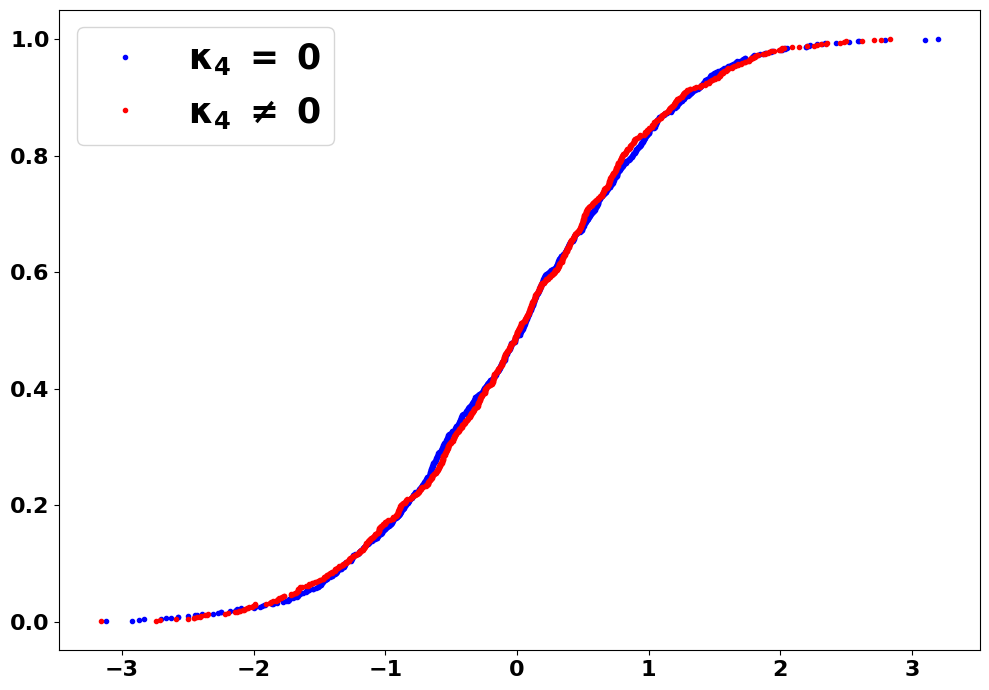

In [ ]:
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')

## Figure 3: ECDF different $\phi$, Global


In this section, we display the comparison of ECDFs of normalized test statistics $\mathcal{T}^g_1$ (and $\mathcal{T}^l_1$, respectively) versus the
CDF of standard normal distribution. Here the normalizations are done with our theoretical value for the Global statistics and with calibration for the Local statistics).

For quicker execution

- I changed the number of repeat $R$ from 10000 (the version in paper) to 2000 so that saving via print will be easier and less time will be needed (less than 1 min with a T4 gpu machine each).

- However, the plot could be less smooth than the ones in the paper, to replicate, change the value of $R$ to 10000; to get more smooth curves, change $R$ and $n$ to larger quantities.

### $T_1^g$

In practice, $x-\sqrt{\phi}-1/\sqrt{\phi}+c$ is used where $c=3$.

#### Data generating

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np

R = 2000
n = 200
c = 3

def simulate_global_test_statistics1(phi, n, R, c):
    m = int(n * phi)
    center = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n)

    @jit
    def objective1(X):
        H = jnp.matmul(jnp.transpose(X), X)
        E0 = jnp.linalg.eigh(H)[0]
        Eb = E0 - center
        return jnp.sum(Eb)

    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)

    for k in range(R):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))
        T = T.at[k].set(objective1(X))

    return np.array(T)



TestST1 = simulate_global_test_statistics1(50,  n, R, 3)
TestST2 = simulate_global_test_statistics1(100, n, R, 3)
TestST3 = simulate_global_test_statistics1(150, n, R, 3)
TestST4 = simulate_global_test_statistics1(200, n, R, 3)


CPU times: user 32.4 s, sys: 1.75 s, total: 34.2 s
Wall time: 31.3 s


#### Saved data

In [ ]:
TestST1=[572.44946 , 573.5282 , 572.4214 , 570.93414 , 571.20715 , 570.6509 , 570.5554 , 570.5818 , 569.6347 , 573.1282 , 573.46936 , 573.24976 , 572.59863 , 573.7018 , 572.8284 , 573.7477 , 568.89185 , 573.0658 , 572.05646 , 573.01587 , 570.8886 , 570.35297 , 574.6156 , 571.9548 , 572.0656 , 573.93066 , 571.7464 , 571.85455 , 571.5749 , 570.41296 , 570.69714 , 568.63306 , 572.3616 , 572.26416 , 570.53296 , 572.6366 , 572.0217 , 571.50195 , 571.5428 , 571.0542 , 573.2859 , 573.1831 , 570.00433 , 569.67993 , 572.47253 , 570.1465 , 569.6675 , 572.3191 , 570.41 , 571.28894 , 571.8775 , 570.4598 , 570.3504 , 570.4408 , 573.3574 , 571.0035 , 571.72327 , 570.6004 , 572.8354 , 571.87683 , 573.9225 , 573.46405 , 571.63916 , 573.45386 , 570.49536 , 573.4099 , 571.45715 , 570.6904 , 569.48047 , 571.928 , 570.364 , 572.1997 , 570.01013 , 570.6017 , 570.2623 , 575.0713 , 571.85046 , 571.1649 , 571.4824 , 569.8345 , 573.92773 , 572.20667 , 572.90393 , 572.23816 , 572.4952 , 572.3557 , 571.5836 , 571.00806 , 572.0962 , 570.9652 , 570.1226 , 572.55444 , 570.3522 , 572.3842 , 571.766 , 568.97644 , 572.3109 , 573.9137 , 571.83386 , 572.3845 , 572.8721 , 571.7335 , 572.1558 , 571.5386 , 573.054 , 572.39294 , 570.1163 , 572.098 , 567.2091 , 572.4949 , 569.8339 , 569.7162 , 572.1756 , 571.59607 , 572.7373 , 570.9739 , 570.3458 , 573.1886 , 570.77826 , 570.5967 , 573.60156 , 570.963 , 571.2304 , 575.7594 , 572.88885 , 571.53796 , 571.0216 , 572.1985 , 572.78296 , 572.1267 , 571.9313 , 571.0832 , 569.1363 , 572.38135 , 571.2771 , 570.8954 , 572.02795 , 568.851 , 570.456 , 571.96216 , 572.771 , 572.28345 , 570.8512 , 572.5376 , 569.97186 , 571.7699 , 568.8412 , 572.0717 , 570.04376 , 570.17346 , 572.1586 , 570.01105 , 571.6499 , 570.62134 , 571.912 , 573.99243 , 571.9107 , 570.56793 , 570.8363 , 572.20087 , 570.6179 , 572.50793 , 570.5039 , 572.5142 , 570.7869 , 570.0748 , 574.34485 , 572.57196 , 571.6378 , 570.68756 , 570.87036 , 569.50116 , 573.23517 , 574.75366 , 571.7389 , 573.64453 , 572.7517 , 571.51 , 569.8269 , 572.8625 , 572.2574 , 571.93976 , 572.73376 , 570.1365 , 569.8562 , 571.91406 , 572.4562 , 572.4455 , 573.36005 , 570.92163 , 571.0968 , 570.72833 , 572.7061 , 573.6935 , 570.6155 , 572.4093 , 570.4275 , 572.5454 , 571.70044 , 572.3552 , 570.07336 , 571.3446 , 574.06586 , 570.2002 , 573.23663 , 573.099 , 568.4881 , 572.4525 , 572.48773 , 568.87177 , 568.7998 , 572.09235 , 571.0345 , 570.53845 , 570.9387 , 571.5185 , 567.73785 , 571.6089 , 569.6323 , 571.4947 , 572.8686 , 569.5226 , 574.0403 , 574.5566 , 570.95996 , 571.4916 , 570.9701 , 569.95874 , 572.0314 , 569.3289 , 570.9394 , 572.5599 , 573.0781 , 570.99603 , 570.91736 , 571.8347 , 571.8495 , 571.0824 , 572.6941 , 574.14856 , 572.19165 , 571.6907 , 572.4812 , 570.74475 , 573.4758 , 570.53107 , 573.1245 , 574.4509 , 570.7504 , 571.91754 , 568.8094 , 569.9603 , 570.4502 , 572.31104 , 569.07025 , 572.5164 , 571.01044 , 573.6693 , 568.11835 , 572.9494 , 570.88574 , 574.80225 , 569.5886 , 572.28955 , 572.5825 , 572.0022 , 570.84534 , 571.0593 , 571.8789 , 569.5973 , 571.8098 , 572.3227 , 571.4947 , 571.63556 , 570.2954 , 572.7402 , 570.1471 , 570.2954 , 568.6952 , 571.02594 , 571.07654 , 573.39606 , 572.2611 , 573.0591 , 571.3997 , 572.9917 , 571.80396 , 573.0283 , 571.8751 , 572.44543 , 570.16486 , 570.5815 , 573.89734 , 573.1229 , 570.8989 , 571.798 , 568.7805 , 571.33655 , 571.90845 , 571.88983 , 571.2781 , 568.6656 , 571.5441 , 572.9497 , 572.22595 , 571.09436 , 571.65546 , 572.78217 , 570.525 , 572.5602 , 573.4679 , 571.71606 , 571.64734 , 569.9049 , 572.25085 , 573.8288 , 571.76184 , 571.63416 , 572.1155 , 569.76843 , 572.8333 , 572.7614 , 572.34406 , 571.78485 , 572.046 , 570.8671 , 571.2064 , 571.9595 , 570.7406 , 570.9723 , 573.68066 , 568.05963 , 572.3198 , 569.96295 , 571.23364 , 572.5375 , 572.9619 , 571.36804 , 572.39014 , 572.02875 , 570.72363 , 571.5332 , 571.1939 , 572.224 , 568.9601 , 573.4038 , 572.7035 , 572.1592 , 573.1255 , 571.92365 , 571.71564 , 570.2722 , 573.2009 , 572.2528 , 572.917 , 573.6953 , 573.61597 , 571.42773 , 573.67255 , 570.2335 , 570.606 , 571.1538 , 571.74426 , 570.6561 , 570.7644 , 571.4486 , 572.5781 , 572.341 , 571.9164 , 571.2356 , 572.82764 , 571.5437 , 571.02234 , 571.6498 , 572.04663 , 572.4269 , 570.9042 , 572.35254 , 571.37396 , 571.64233 , 571.3275 , 572.0326 , 571.7621 , 569.67804 , 574.5451 , 573.7147 , 571.5662 , 572.43506 , 569.75903 , 570.9021 , 571.5962 , 571.25757 , 570.6679 , 571.3194 , 570.38745 , 573.84827 , 574.35095 , 571.7854 , 572.0979 , 572.7711 , 570.70044 , 571.77747 , 572.10236 , 570.6303 , 572.3418 , 572.3635 , 571.12836 , 570.85046 , 570.8387 , 573.4758 , 574.8134 , 569.775 , 571.79376 , 571.18646 , 572.7731 , 570.3308 , 571.4856 , 570.6033 , 570.4894 , 572.9818 , 569.3625 , 569.51 , 572.5873 , 572.4329 , 572.54614 , 569.9341 , 568.71545 , 573.1705 , 573.06464 , 572.0023 , 571.6591 , 574.76276 , 570.7212 , 572.1521 , 573.02527 , 572.7737 , 571.36414 , 571.39154 , 569.59155 , 571.4761 , 571.85547 , 573.67566 , 568.44336 , 572.6302 , 573.29266 , 571.363 , 573.8252 , 571.4761 , 572.357 , 571.7472 , 570.95386 , 570.34424 , 571.12854 , 571.80457 , 573.53394 , 572.6968 , 569.0595 , 571.35364 , 572.2729 , 570.3011 , 571.39795 , 572.0828 , 569.9267 , 574.22656 , 566.5239 , 573.06213 , 573.1667 , 571.7885 , 570.8986 , 573.65466 , 571.6049 , 571.77356 , 573.6366 , 571.97314 , 573.22406 , 574.0214 , 568.73193 , 571.2451 , 574.48413 , 570.245 , 573.7645 , 572.46014 , 572.9097 , 572.6159 , 570.08795 , 570.7344 , 570.345 , 573.1511 , 571.30786 , 569.40826 , 572.36255 , 574.85474 , 574.537 , 571.94336 , 570.4049 , 572.4207 , 567.21436 , 571.2644 , 574.38477 , 572.94415 , 574.1557 , 574.1238 , 570.7066 , 573.79333 , 570.9418 , 573.1587 , 570.6933 , 572.53894 , 572.34076 , 573.4772 , 571.25836 , 571.97345 , 571.4905 , 568.63965 , 573.86316 , 568.06476 , 571.24756 , 570.98175 , 570.16864 , 568.6587 , 571.7256 , 571.30725 , 572.12524 , 571.0863 , 569.4741 , 570.07654 , 573.20483 , 572.5857 , 572.4071 , 572.52673 , 570.6788 , 574.382 , 569.8771 , 572.922 , 572.3917 , 572.2949 , 572.48865 , 570.7815 , 571.6173 , 570.635 , 571.8737 , 570.35596 , 570.2142 , 571.90173 , 574.2506 , 571.4824 , 570.90625 , 571.8021 , 570.1643 , 571.9769 , 571.5184 , 570.5372 , 570.22754 , 571.2602 , 572.187 , 572.2041 , 574.5648 , 572.99963 , 573.4012 , 569.7606 , 570.53796 , 572.1376 , 571.0135 , 569.69104 , 570.8752 , 572.26843 , 571.3132 , 572.8881 , 573.08215 , 572.0569 , 571.65625 , 571.2941 , 569.3195 , 572.50024 , 573.24756 , 571.9843 , 572.44507 , 572.84534 , 571.19824 , 571.1229 , 571.82825 , 569.12146 , 573.3869 , 572.20966 , 571.3347 , 572.7422 , 571.6571 , 572.05664 , 573.1 , 570.0211 , 572.3594 , 571.82715 , 571.568 , 571.5552 , 573.89197 , 570.4162 , 573.3585 , 571.6625 , 573.07825 , 572.02136 , 571.8998 , 573.88086 , 572.7737 , 572.96533 , 572.4667 , 572.92053 , 571.81134 , 572.7026 , 570.5145 , 572.03076 , 571.4226 , 573.0116 , 571.9437 , 572.12 , 573.71716 , 574.6466 , 570.82886 , 571.21094 , 571.80585 , 572.6521 , 569.2917 , 572.9923 , 570.73816 , 571.7948 , 569.3616 , 569.4056 , 571.8952 , 571.1864 , 570.52325 , 569.8473 , 573.17505 , 572.2875 , 570.669 , 573.5891 , 571.0985 , 571.96564 , 572.60376 , 571.02435 , 572.9457 , 573.22705 , 571.6488 , 571.114 , 570.4036 , 572.6675 , 569.3738 , 572.10614 , 570.88513 , 571.47546 , 571.76 , 569.07074 , 571.8351 , 570.40375 , 572.0244 , 572.3066 , 572.5658 , 570.4814 , 569.1002 , 572.39575 , 573.05927 , 571.2642 , 571.8177 , 573.6826 , 571.09424 , 570.7267 , 572.41724 , 571.3256 , 571.1867 , 570.47034 , 571.54095 , 569.9916 , 569.18274 , 573.9922 , 572.6876 , 570.73755 , 570.3916 , 570.72974 , 570.263 , 571.1323 , 571.47766 , 572.43146 , 572.3655 , 572.3411 , 573.3315 , 571.3187 , 570.9818 , 572.84033 , 573.8491 , 570.61774 , 572.6167 , 574.33014 , 571.0061 , 572.3501 , 572.49146 , 571.7547 , 570.9895 , 570.47687 , 570.28046 , 570.948 , 570.2282 , 569.5592 , 571.94714 , 572.9715 , 570.6741 , 568.22406 , 570.6134 , 573.9059 , 572.0633 , 574.1823 , 572.96985 , 569.2824 , 570.7666 , 569.3756 , 573.48145 , 571.96356 , 572.2754 , 571.08026 , 573.5425 , 572.6981 , 571.1301 , 570.9175 , 574.3572 , 572.58875 , 570.2449 , 571.51855 , 572.9113 , 571.8365 , 571.7499 , 574.4073 , 568.8331 , 571.9224 , 568.67773 , 570.70544 , 572.47034 , 570.23486 , 572.4592 , 572.9105 , 572.5648 , 570.4198 , 574.0314 , 573.1235 , 571.57465 , 574.7752 , 571.8079 , 571.52997 , 571.86554 , 571.2341 , 574.3862 , 570.9754 , 568.8782 , 571.62024 , 571.8818 , 572.1061 , 571.7256 , 573.7695 , 569.2794 , 570.15967 , 570.94147 , 571.95776 , 572.893 , 572.3495 , 573.18604 , 572.3297 , 570.9696 , 570.93066 , 571.71924 , 573.17255 , 570.79346 , 573.19934 , 570.14624 , 572.9881 , 571.3847 , 570.96936 , 571.5522 , 570.9828 , 572.11926 , 571.3031 , 572.5709 , 572.93945 , 571.2894 , 571.093 , 570.076 , 573.11194 , 572.41003 , 570.3059 , 572.96423 , 572.1649 , 571.4599 , 570.78625 , 571.70984 , 569.7273 , 573.21515 , 571.505 , 568.6461 , 571.253 , 570.9806 , 573.6863 , 570.3293 , 571.38904 , 571.2231 , 570.8574 , 571.5784 , 568.90894 , 571.81134 , 571.8119 , 571.8117 , 571.9339 , 570.26746 , 570.693 , 570.9087 , 572.87756 , 570.75073 , 570.8862 , 573.32007 , 570.0895 , 571.2529 , 569.17596 , 573.14453 , 569.20544 , 570.94244 , 571.0813 , 570.6868 , 571.16547 , 573.63684 , 573.2868 , 572.1151 , 569.61914 , 571.86365 , 571.1229 , 571.7988 , 571.8491 , 573.21606 , 572.17773 , 573.44434 , 573.6888 , 571.572 , 571.0138 , 570.66675 , 569.8314 , 569.77936 , 572.2122 , 570.32263 , 571.4269 , 570.63354 , 572.42566 , 571.6783 , 571.6489 , 571.1852 , 573.6676 , 572.4607 , 573.09766 , 572.7296 , 571.1087 , 572.89795 , 569.77893 , 569.76245 , 570.3744 , 570.5112 , 569.5856 , 571.2879 , 570.67664 , 569.88184 , 573.448 , 574.8767 , 570.12854 , 572.5364 , 572.39246 , 570.89844 , 570.72144 , 571.9631 , 572.5226 , 573.24243 , 574.6876 , 572.9266 , 574.6558 , 569.8912 , 574.31366 , 573.2561 , 570.471 , 569.89404 , 570.8307 , 573.5161 , 572.1734 , 572.3843 , 572.9901 , 570.21326 , 573.193 , 573.9175 , 569.5497 , 571.41943 , 570.5774 , 572.1044 , 570.168 , 572.41785 , 571.8688 , 572.2962 , 569.55066 , 570.47 , 570.2026 , 572.8135 , 574.0141 , 571.614 , 570.90137 , 570.511 , 572.0559 , 571.1666 , 572.4475 , 571.68915 , 571.92163 , 569.9525 , 570.6088 , 571.4945 , 569.5266 , 570.59796 , 570.15906 , 572.15515 , 573.08795 , 572.5653 , 571.28467 , 570.43 , 572.42456 , 571.4562 , 572.0728 , 569.7193 , 572.1275 , 573.1576 , 569.7929 , 571.3968 , 571.897 , 569.7264 , 570.1872 , 570.82996 , 571.8179 , 568.05444 , 571.6083 , 570.7246 , 570.5757 , 571.6492 , 570.77075 , 570.0011 , 573.7116 , 568.89075 , 570.74133 , 569.896 , 573.7108 , 572.3618 , 570.9496 , 573.292 , 570.83685 , 570.3436 , 570.6567 , 570.37744 , 570.59033 , 570.22107 , 567.9594 , 568.7715 , 570.0922 , 573.37573 , 572.69885 , 572.05615 , 573.50183 , 572.5341 , 571.8558 , 571.6178 , 572.4419 , 572.57825 , 573.0621 , 572.0204 , 571.3567 , 570.84753 , 570.08966 , 572.4576 , 571.9098 , 571.3291 , 570.12506 , 572.9243 , 571.27844 , 573.95703 , 572.0327 , 573.86346 , 571.3859 , 572.0232 , 569.9492 , 572.75305 , 569.5439 , 569.9287 , 572.1845 , 571.8413 , 575.28314 , 572.83215 , 572.55865 , 571.1341 , 572.73865 , 572.81885 , 572.7219 , 572.8539 , 570.8107 , 571.59686 , 571.871 , 570.44995 , 571.3356 , 571.33875 , 570.4752 , 570.02106 , 571.81134 , 574.3626 , 572.0055 , 570.6065 , 573.13196 , 572.1109 , 573.66565 , 571.5543 , 573.0624 , 570.87585 , 569.4818 , 571.92444 , 570.7499 , 570.9679 , 572.463 , 570.31555 , 571.74817 , 571.3546 , 571.99786 , 570.65784 , 571.5703 , 571.9625 , 572.3251 , 573.9336 , 570.9522 , 571.5859 , 571.91583 , 570.53687 , 569.1896 , 571.6915 , 571.11835 , 570.54553 , 570.9808 , 570.4005 , 571.9688 , 570.5679 , 570.9271 , 571.83887 , 572.15894 , 570.74054 , 571.3057 , 572.30945 , 569.5784 , 570.3989 , 570.3716 , 568.46704 , 570.9026 , 571.27795 , 570.57416 , 572.7291 , 570.98926 , 571.6594 , 570.7617 , 572.7739 , 572.0405 , 572.00745 , 573.2677 , 571.4898 , 572.24457 , 574.44385 , 572.4136 , 572.96344 , 571.93445 , 574.48865 , 572.399 , 572.50977 , 568.88696 , 572.0421 , 571.332 , 571.5624 , 571.3998 , 571.8715 , 571.0249 , 573.7099 , 570.6077 , 573.4108 , 570.0475 , 568.9295 , 570.96045 , 569.6412 , 570.74304 , 571.8711 , 573.44525 , 569.79626 , 571.3855 , 570.0544 , 571.12195 , 571.44434 , 571.7932 , 570.9374 , 568.357 , 572.92566 , 569.4509 , 571.1634 , 571.8147 , 569.55585 , 570.87634 , 571.85114 , 568.6095 , 572.5186 , 572.6874 , 569.48126 , 567.87054 , 573.037 , 570.82306 , 569.7314 , 570.03076 , 574.1266 , 571.8012 , 571.7317 , 569.1437 , 573.79517 , 573.27795 , 570.5862 , 571.76416 , 573.13684 , 572.5451 , 570.995 , 572.40796 , 569.2639 , 570.0758 , 569.4677 , 572.6376 , 571.0027 , 572.0101 , 573.98395 , 570.8607 , 571.96783 , 572.60596 , 571.5819 , 569.73645 , 568.80725 , 570.47 , 574.0675 , 571.4334 , 571.8269 , 574.0102 , 571.1648 , 567.09863 , 571.4471 , 573.40063 , 572.4198 , 569.6752 , 572.0425 , 570.60913 , 570.1328 , 570.8485 , 572.53906 , 572.5746 , 568.9127 , 572.7718 , 570.01025 , 572.4402 , 567.6598 , 573.9451 , 570.8346 , 570.8584 , 573.15466 , 570.8303 , 571.02484 , 572.35754 , 571.50946 , 571.681 , 572.9139 , 572.2369 , 570.9629 , 571.6091 , 571.8259 , 573.5421 , 574.50824 , 572.56824 , 570.5123 , 570.9925 , 570.2822 , 569.1925 , 572.4337 , 572.26843 , 570.4946 , 572.0 , 573.5698 , 570.53564 , 573.1235 , 570.1079 , 570.4821 , 571.9669 , 571.9874 , 571.20703 , 571.6033 , 572.9918 , 572.9076 , 571.0858 , 572.4497 , 572.7704 , 572.99054 , 571.7158 , 571.97705 , 569.5707 , 572.61914 , 572.7154 , 572.3636 , 572.6479 , 571.89087 , 571.1621 , 571.3738 , 570.12476 , 571.89954 , 572.2611 , 570.4762 , 568.7665 , 572.26697 , 574.4093 , 571.2051 , 573.01086 , 573.2328 , 570.7186 , 572.3974 , 571.6301 , 571.65686 , 573.0281 , 572.5655 , 569.5752 , 571.7378 , 570.515 , 570.127 , 571.27734 , 571.43024 , 570.74927 , 571.3006 , 570.0006 , 573.05725 , 571.09973 , 571.1727 , 572.9557 , 573.2728 , 570.298 , 570.3805 , 572.8916 , 573.32825 , 572.9573 , 573.1283 , 572.2258 , 571.5742 , 572.80524 , 573.33093 , 572.3694 , 570.2269 , 571.8169 , 569.53375 , 570.44604 , 569.7268 , 570.89954 , 569.83716 , 572.6782 , 572.3167 , 569.89343 , 572.006 , 573.4362 , 568.9604 , 569.11945 , 570.52136 , 569.527 , 569.3583 , 571.9977 , 572.2357 , 574.0626 , 570.7745 , 571.6803 , 572.1928 , 572.92535 , 572.61145 , 573.2894 , 574.0326 , 569.6204 , 568.0084 , 571.085 , 572.51666 , 572.1915 , 572.4238 , 570.471 , 570.2597 , 572.1597 , 571.9016 , 569.69916 , 573.6326 , 570.65356 , 571.166 , 572.1261 , 571.5398 , 571.1015 , 573.6498 , 570.8913 , 569.6066 , 572.5906 , 570.9678 , 569.0968 , 571.97424 , 573.1033 , 571.7787 , 569.31067 , 574.32916 , 573.5342 , 571.9988 , 570.9237 , 573.96436 , 571.6439 , 571.1888 , 575.3104 , 571.63727 , 572.5922 , 572.4519 , 573.9346 , 571.9851 , 570.4452 , 574.18054 , 573.60254 , 570.05884 , 574.8528 , 570.2704 , 573.63904 , 572.8658 , 574.0112 , 574.4182 , 572.5304 , 571.67206 , 571.3463 , 571.14075 , 570.8663 , 574.5739 , 567.79175 , 570.0332 , 570.2844 , 571.9131 , 569.84534 , 572.4116 , 572.95123 , 571.6759 , 568.784 , 572.60315 , 574.1052 , 573.1335 , 572.4658 , 573.08966 , 573.6807 , 569.91046 , 571.3562 , 570.2815 , 570.49286 , 574.32495 , 570.2574 , 570.3068 , 571.37756 , 569.8688 , 571.1108 , 572.3214 , 572.9905 , 573.61835 , 572.299 , 571.7465 , 572.0778 , 569.22253 , 570.5244 , 572.24963 , 571.8319 , 571.5854 , 572.4466 , 571.0834 , 572.3938 , 568.6091 , 571.13257 , 572.08813 , 570.7754 , 572.0101 , 572.1188 , 571.8582 , 572.3363 , 570.2091 , 571.65753 , 571.3253 , 572.30457 , 570.42834 , 568.90955 , 571.09674 , 571.62756 , 571.9806 , 572.0679 , 570.40405 , 569.8281 , 572.35785 , 572.0236 , 571.85724 , 574.9247 , 570.15234 , 572.61285 , 574.7245 , 572.8348 , 572.52795 , 570.44727 , 570.0784 , 572.2699 , 570.9579 , 573.56134 , 571.7298 , 573.86163 , 571.94244 , 571.9574 , 572.9834 , 572.28186 , 572.42773 , 570.41144 , 571.1455 , 570.72455 , 572.19885 , 572.6203 , 572.10156 , 569.719 , 571.60126 , 570.1614 , 571.8523 , 572.6493 , 571.3721 , 572.7254 , 572.4917 , 571.0915 , 573.4869 , 571.9247 , 571.8727 , 571.4353 , 570.3177 , 572.50903 , 572.1991 , 572.07666 , 570.74915 , 571.89307 , 570.29553 , 571.0947 , 571.48425 , 567.6639 , 570.72577 , 571.40845 , 571.27673 , 570.9055 , 569.09406 , 571.53864 , 570.55347 , 570.5025 , 571.0339 , 574.188 , 570.65497 , 571.1404 , 570.9078 , 573.1977 , 572.365 , 571.3347 , 571.2465 , 573.4974 , 571.25244 , 570.90216 , 571.00696 , 571.61316 , 570.6537 , 571.9852 , 572.0381 , 571.2936 , 573.0318 , 570.93964 , 569.7038 , 572.8688 , 571.30615 , 570.32263 , 574.137 , 572.57434 , 571.1275 , 571.70435 , 571.90515 , 572.4429 , 572.3524 , 570.81537 , 569.33276 , 572.27155 , 574.19727 , 569.40576 , 574.20544 , 572.0921 , 573.2136 , 571.15436 , 572.07275 , 568.02734 , 571.4794 , 570.8424 , 570.0817 , 569.6353 , 571.5797 , 574.29504 , 572.48553 , 571.6182 , 569.64294 , 570.8001 , 570.3102 , 571.65735 , 572.30963 , 573.18115 , 572.6735 , 573.4726 , 572.2688 , 569.79486 , 571.60254 , 571.8972 , 571.71106 , 572.708 , 568.5615 , 570.497 , 569.66724 , 575.25714 , 572.9834 , 571.05115 , 572.70544 , 572.1479 , 573.062 , 571.56323 , 572.4813 , 573.907 , 571.6546 , 573.9614 , 569.5338 , 571.73413 , 569.9153 , 570.7688 , 571.90424 , 573.0427 , 571.286 , 571.83044 , 571.6847 , 573.0707 , 573.5829 , 572.029 , 571.87305 , 570.1638 , 572.96277 , 572.74695 , 570.1196 , 573.12585 , 571.9454 , 570.06573 , 570.9435 , 571.77747 , 568.909 , 573.19165 , 568.57025 , 571.3035 , 571.64935 , 572.77405 , 571.4437 , 571.8673 , 573.9161 , 571.7826 , 572.1259 , 572.44696 , 571.1838 , 571.209 , 573.901 , 571.563 , 574.84033 , 571.33356 , 573.3198 , 571.3712 , 570.6023 , 571.9895 , 571.4474 , 570.63306 , 570.7174 , 571.7014 , 572.64075 , 572.43445 , 573.90283 , 572.3468 , 571.5104 , 568.97485 , 573.18823 , 572.5465 , 570.82605 , 572.3281 , 571.47375 , 569.6898 , 571.5672 , 572.3931 , 570.31775 , 571.3835 , 572.03485 , 571.7997 , 572.16394 , 569.7511 , 570.4432 , 572.2219 , 571.9613 , 574.53253 , 571.22797 , 572.1112 , 575.1015 , 572.83014 , 572.0102 , 571.39087 , 570.9292 , 568.90607 , 572.4833 , 572.7948 , 571.0903 , 568.49805 , 570.08057 , 569.17236 , 573.1311 , 568.7328 , 570.64166 , 571.9968 , 574.37854 , 572.2538 , 571.59064 , 571.97516 , 569.64136 , 569.9041 , 573.6766 , 574.0362 , 572.92944 , 568.79706 , 570.04504 , 574.1409 , 570.8079 , 572.7749 , 570.4155 , 571.8249 , 569.20056 , 571.49066 , 572.2412 , 569.2693 , 574.5594 , 572.18884 , 573.0219 , 572.83844 , 569.4619 , 573.96844 , 570.8484 , 572.8778 , 573.1051 , 571.9656 , 571.97485 , 574.3296 , 571.6453 , 572.35205 , 571.496 , 572.8197 , 572.43384 , 572.1797 , 575.8782 , 572.1875 , 572.58435 , 574.63403 , 572.22253 , 571.66785 , 570.8353 , 575.2112 , 570.0096 , 570.1054 , 572.5597 , 572.4523 , 573.876 , 572.44684 , 573.2138 , 569.55164 , 573.3176 , 571.7569 , 570.43994 , 574.0322 , 570.4768 , 571.1716 , 570.3356 , 572.1997 , 573.2577 , 571.44293 , 569.9538 , 571.8466 , 568.2495 , 570.3413 , 571.4092 , 571.0543 , 568.40186 , 571.449 , 570.36554 , 572.756 , 573.15137 , 570.5366 , 570.93774 , 570.6908 , 571.5824 , 569.70154 , 575.1859 , 571.0725 , 572.43585 , 570.9137 , 571.8709 , 571.05 , 571.86194 , 570.69434 , 571.1097 , 570.8014 , 572.5746 , 571.5525 , 569.43713 , 571.055 , 572.52014 , 569.8027 , 569.60583 , 573.9299 , 570.67737 , 572.5935 , 571.52075 , 572.4625 , 573.2174 , 571.85364 , 568.9253 , 571.65515 , 571.44495 , 572.7385 , 572.2371 , 572.2605 , 569.4158 , 573.2018 , 571.6922 , 573.5898 , 571.4642 , 569.79694 , 571.12665 , 570.02 , 573.7549 , 570.34436 , 571.226 , 574.5593 , 573.3863 , 571.14087 , 574.5029 , 570.39734 , 573.292 , 569.37573 , 567.7405 , 572.1335 , 569.8379 , 569.77905 , 569.29297 , 569.78235 , 573.4645 , 571.13354 , 571.9182 , 570.6622 , 571.83435 , 570.2926 , 573.8299 , 571.073 , 573.5176 , 571.6098 , 572.3367 , 571.76904 , 569.0119 , 572.0416 , 569.6685 , 570.5787 , 572.2512 , 573.88306 , 570.1287 , 570.76166 , 570.9545 , 569.90796 , 571.6653 , 572.7352 , 571.20306 , 572.3568 , 572.27954 , 570.0741 , 572.9144 , 572.0491 , 570.3982 , 573.39185 , 571.9226 , 569.4904 , 571.0111 , 571.6437 , 573.3517 , 573.6195 , 571.3254 , 571.01044 , 572.8328 , 572.52844 , 573.7959 , 572.37366 , 569.41833 , 569.8006 , 572.88794 , 571.6986 , 570.94104 , 569.99927 , 573.38086 , 568.9041 , 571.65875 , 570.2846 , 570.7571 , 571.36694 , 570.61456 , 570.08594 , 569.9476 , 571.661 , 571.2349 , 573.2777 , 573.1458 , 573.7671 , 569.84015 , 573.1035 , 570.81757 , 571.0177 , 573.307 , 570.147 , 573.5864 , 572.29675 , 572.6543 , 571.77167 , 570.7158 , 571.88885 , 573.38965 , 574.021 , 568.44214 , 572.7162 , 572.1596 , 571.6358 , 571.385 , 573.346 , 571.05273 , 569.0238 , 570.6852 , 571.5075 , 572.41156 , 570.688 , 571.3275 , 570.33453 , 572.80786 , 572.99146 , 570.5337 , 572.2629 , 572.19073 , 569.8007 , 571.59827 , 573.09717 , 572.8733 , 574.44775 , 571.79376 , 570.92444 , 572.67456 , 571.01733 , 570.44495 , 570.3099 , 572.48157 , 570.8247 , 570.9768 , 572.0482 , 571.34534 , 572.0598 , 570.44104 , 571.34564 , 572.6255 , 573.94824 , 571.39874 , 570.4023 , 567.5351 , 571.69525 , 574.0353 , 571.0127 , 571.77454 , 571.07227 , 572.91473 , 571.73364 , 570.7704 , 570.6152 , 569.8179 , 570.48303 , 573.49756 , 570.00256 , 571.6127 , 568.82904 , 572.82336 , 570.8927 , 571.10016 , 569.829 , 569.61255 , 570.06464 , 573.0751 , 569.28766 , 571.58856 , 572.73627 , 573.4907 , 569.5833 , 571.244 , 572.666 , 571.3999 , 570.35834 , 573.5922 , 573.1102 , 571.6151 , 570.9564 , 571.4452 , 571.21655 , 570.70337 , 568.23267 , 572.86707 , 573.237 , 570.7423 , 572.9508 , 573.0427 , 572.42053 , 572.83057 , 569.8413 , 572.9935 , 572.8391 , 572.6147 , 570.8209 , 573.4013 , 573.2343 , 574.41754 , 569.7777 , 572.01794 , 571.5322 , 572.66064 , 571.16406 , 574.2279 , 572.60834 , 573.1634 , 571.58813 , 571.5515 , 570.9307 , 567.9228 , 572.2992 , 570.7876 , 572.7717 , 572.5598 , 571.8769 , 572.80334 , 568.0353 , 572.3098 , 570.8599 , 572.81067 , 573.31055 , 571.00903 , 570.3405 , 570.98816 , 572.0688 , 572.7514 , 572.0676 , 572.02844 , 571.75916 , 570.75415 , 570.5081 , 571.6898 , 572.7335 , 572.91095 , 571.30383 , 571.60187 , 572.44666 , 571.1266 , 574.32495 , 572.3586 , 571.2927 , 571.67505 , 570.7217 , 573.5257 , 573.05304 , 572.67474 , 569.429 , 569.33545 , 569.4901 , 569.6884 , 571.8425 , 573.15955 , 571.68 , 571.71155 , 569.7794 , 572.2996 , 570.68616 , 573.00385 , 572.8031 , 571.9896 , 572.3541 , 571.7521 , 572.83875 , 572.24084 , 572.6551 , 570.9087 , 571.7152 , 572.1918 , 570.7015 , 570.2261 , 571.5889 , 570.82385 , 571.51135]

In [ ]:
TestST2=[581.8905 , 577.13184 , 582.865 , 579.22266 , 581.2446 , 579.2334 , 578.31226 , 581.1064 , 579.64465 , 582.0055 , 578.58167 , 578.6935 , 582.4458 , 578.7346 , 580.98206 , 578.9697 , 579.5271 , 579.5486 , 580.0008 , 582.287 , 580.4851 , 577.51764 , 581.4924 , 581.0149 , 580.6128 , 580.0384 , 579.024 , 579.5055 , 580.9938 , 580.35754 , 581.33435 , 580.0991 , 581.3005 , 579.0812 , 579.06055 , 579.3107 , 580.10016 , 578.7818 , 581.82166 , 579.0411 , 577.3502 , 581.6246 , 579.0169 , 578.18335 , 579.3432 , 581.1167 , 580.1179 , 578.0752 , 578.25574 , 581.2135 , 579.3932 , 581.8179 , 578.5685 , 578.463 , 579.62744 , 581.6946 , 580.8406 , 580.6653 , 580.27344 , 578.94763 , 580.8428 , 580.3493 , 581.214 , 577.2184 , 580.10657 , 579.65015 , 579.41754 , 579.3157 , 580.1062 , 581.9437 , 580.5542 , 582.27747 , 580.6162 , 581.3917 , 580.86597 , 581.2231 , 579.6072 , 578.95325 , 578.5316 , 579.33997 , 581.1282 , 579.64825 , 578.9053 , 577.18494 , 579.82153 , 579.8206 , 580.614 , 581.4748 , 578.8922 , 581.4824 , 580.02625 , 582.7202 , 580.25885 , 581.7114 , 581.4031 , 579.2003 , 578.8385 , 581.5012 , 579.136 , 578.66223 , 578.8494 , 580.0063 , 578.50195 , 580.8789 , 578.98584 , 579.6195 , 579.048 , 582.4142 , 578.3567 , 579.0874 , 577.4932 , 577.07697 , 580.32275 , 577.5338 , 580.7666 , 578.82214 , 581.4075 , 580.4584 , 580.9359 , 579.11816 , 580.06226 , 578.9093 , 579.3695 , 579.9729 , 578.59814 , 580.3666 , 579.4694 , 579.09875 , 581.33984 , 580.04236 , 578.5383 , 578.1898 , 580.3289 , 579.7158 , 579.7621 , 579.40356 , 578.9225 , 579.3511 , 579.2866 , 579.9878 , 581.9133 , 580.46533 , 582.7612 , 577.83435 , 581.55115 , 578.6532 , 580.6002 , 578.1192 , 578.58075 , 581.662 , 582.44556 , 580.7163 , 578.7843 , 580.48126 , 582.001 , 580.22546 , 577.3346 , 582.2831 , 576.4709 , 579.1967 , 582.56494 , 580.1332 , 578.1669 , 578.39526 , 579.4799 , 579.83826 , 579.3119 , 583.2368 , 579.81604 , 579.79956 , 583.14795 , 580.9813 , 579.9252 , 579.78705 , 578.4634 , 580.4031 , 580.05347 , 581.161 , 581.9255 , 580.9242 , 580.716 , 580.6892 , 578.7924 , 579.75256 , 578.28125 , 580.5641 , 580.2064 , 579.2468 , 579.875 , 578.7151 , 580.08875 , 581.5513 , 575.6152 , 580.0415 , 578.67804 , 578.7645 , 582.01013 , 582.22504 , 579.94293 , 580.9538 , 577.8614 , 581.4535 , 579.4967 , 577.67834 , 581.31506 , 579.4796 , 579.2954 , 582.2344 , 578.53796 , 579.39233 , 580.1106 , 580.09265 , 581.8968 , 576.9655 , 579.92755 , 580.96265 , 579.1724 , 580.7101 , 577.9121 , 578.62067 , 581.1245 , 579.214 , 581.2647 , 578.67993 , 578.4538 , 579.8656 , 579.23975 , 580.71826 , 578.02045 , 581.30115 , 577.68207 , 579.3725 , 580.53674 , 580.01196 , 581.4791 , 581.5574 , 582.26294 , 580.1316 , 578.74963 , 581.3501 , 581.2935 , 578.6732 , 580.1848 , 577.45496 , 581.4874 , 580.00616 , 578.75464 , 579.6925 , 579.0369 , 578.1475 , 578.1384 , 580.95654 , 581.5784 , 577.196 , 581.9643 , 579.9231 , 579.40155 , 580.7101 , 579.7727 , 579.8197 , 581.6154 , 576.5575 , 579.8806 , 581.58154 , 581.0376 , 580.4367 , 581.01294 , 579.042 , 579.4162 , 577.7726 , 580.0365 , 579.3737 , 579.0897 , 577.9558 , 582.2217 , 581.13586 , 578.808 , 580.37024 , 579.0094 , 579.04266 , 578.0439 , 579.1696 , 579.7279 , 579.161 , 581.0775 , 580.1234 , 579.27997 , 580.89954 , 580.2422 , 579.43695 , 581.20496 , 578.76733 , 583.1961 , 580.66547 , 578.82825 , 578.3969 , 579.8399 , 578.68335 , 579.28467 , 579.7207 , 581.56775 , 580.60284 , 578.9134 , 579.44086 , 581.3298 , 580.7864 , 576.948 , 578.36896 , 580.63074 , 579.9699 , 579.96265 , 579.85736 , 580.9401 , 581.95184 , 582.48193 , 578.6794 , 579.6692 , 585.3127 , 578.57434 , 578.52686 , 579.9109 , 582.773 , 578.5117 , 581.5126 , 579.46436 , 577.3011 , 580.319 , 580.3906 , 577.41455 , 579.59973 , 578.4701 , 579.4804 , 578.07025 , 578.97815 , 577.40845 , 579.39825 , 580.25916 , 577.4239 , 579.20447 , 579.107 , 577.80365 , 581.8665 , 580.992 , 579.20605 , 582.88257 , 581.7174 , 578.5889 , 581.08936 , 578.9201 , 579.1 , 579.1246 , 574.93555 , 579.6826 , 580.6222 , 581.7825 , 581.45386 , 579.50696 , 578.4055 , 579.45795 , 579.6679 , 580.2449 , 579.8742 , 579.36743 , 578.463 , 579.8057 , 579.7347 , 580.8028 , 579.0977 , 581.79034 , 579.75696 , 579.558 , 578.35596 , 578.61694 , 580.6594 , 580.75037 , 582.1009 , 581.9086 , 579.5507 , 577.20734 , 578.9238 , 579.226 , 580.529 , 581.0833 , 579.7282 , 580.2368 , 580.1238 , 580.61456 , 580.5803 , 578.3683 , 576.93274 , 580.9581 , 579.77356 , 580.4504 , 577.574 , 579.77344 , 579.21985 , 579.85455 , 579.5501 , 580.0947 , 580.72144 , 580.7906 , 578.9495 , 581.0189 , 579.31934 , 578.52435 , 580.2456 , 578.7137 , 577.67444 , 577.96173 , 580.327 , 581.94507 , 579.3821 , 580.11115 , 580.1371 , 579.74365 , 579.0811 , 582.1278 , 579.6526 , 580.5761 , 579.25195 , 582.2092 , 577.4558 , 578.58386 , 580.96497 , 581.2423 , 579.305 , 579.8446 , 580.0262 , 579.4762 , 581.079 , 583.2611 , 581.37354 , 582.7532 , 580.5115 , 578.09076 , 579.7894 , 580.7236 , 578.85986 , 578.9138 , 577.40356 , 581.17926 , 581.49365 , 578.22253 , 578.92365 , 579.7517 , 578.8928 , 582.3525 , 580.0719 , 581.62 , 581.11035 , 580.93896 , 580.0272 , 582.7096 , 581.5691 , 577.733 , 579.5337 , 580.12366 , 577.8354 , 579.3753 , 577.41187 , 580.27106 , 581.9285 , 578.7592 , 577.97144 , 581.7396 , 578.67773 , 577.06836 , 580.45715 , 578.97797 , 580.66187 , 579.3247 , 579.50574 , 580.25244 , 579.8442 , 580.76013 , 577.92535 , 579.96063 , 581.27515 , 580.03253 , 580.14325 , 583.6815 , 580.4747 , 579.91296 , 578.4476 , 579.3843 , 579.2198 , 580.93304 , 581.03625 , 581.1772 , 579.2018 , 581.7417 , 579.6761 , 578.9668 , 578.0013 , 578.17773 , 579.9589 , 579.54114 , 580.71216 , 581.3723 , 581.4852 , 579.3077 , 577.9676 , 580.3454 , 580.3113 , 579.6065 , 577.17285 , 580.4199 , 577.88745 , 582.3935 , 578.99695 , 580.271 , 581.64197 , 580.4408 , 579.5642 , 579.06836 , 580.7389 , 579.69006 , 578.3236 , 580.0438 , 581.45844 , 578.1836 , 579.1204 , 578.578 , 581.3304 , 580.2387 , 580.1294 , 579.8093 , 580.9902 , 582.062 , 579.6045 , 582.2822 , 579.37573 , 578.21466 , 578.302 , 577.8635 , 578.1343 , 578.86487 , 578.2639 , 578.65955 , 580.93274 , 580.23724 , 581.66345 , 580.7337 , 579.32855 , 578.61194 , 579.56775 , 584.12354 , 579.30994 , 580.8471 , 579.1632 , 577.9951 , 578.9959 , 578.93524 , 581.4995 , 579.16675 , 576.9673 , 580.54614 , 579.21765 , 578.41766 , 580.384 , 579.6081 , 580.54333 , 579.9596 , 578.98395 , 578.8927 , 580.4276 , 579.72815 , 580.8436 , 578.83984 , 578.7937 , 578.3772 , 579.2129 , 582.4647 , 580.4045 , 582.4619 , 578.3009 , 578.70215 , 577.9429 , 581.0286 , 579.19934 , 579.25525 , 580.7755 , 582.6803 , 578.807 , 581.8103 , 580.2847 , 579.166 , 578.141 , 579.2268 , 580.31866 , 583.49927 , 580.84796 , 583.02386 , 579.0552 , 580.6662 , 581.1139 , 581.55426 , 580.3207 , 578.5356 , 580.84436 , 577.71796 , 582.6166 , 580.3843 , 581.02966 , 579.4986 , 581.53345 , 580.3922 , 577.64856 , 582.34375 , 582.1961 , 580.4972 , 580.33954 , 582.511 , 579.2149 , 579.72955 , 578.6915 , 580.4369 , 581.7162 , 580.50586 , 579.24677 , 579.6157 , 580.4032 , 580.2864 , 581.7889 , 579.40643 , 577.4712 , 578.2563 , 579.86926 , 581.06635 , 580.1207 , 579.92505 , 582.14685 , 581.19495 , 580.87646 , 578.7754 , 579.23987 , 581.3805 , 579.978 , 578.4212 , 580.474 , 579.05615 , 577.114 , 578.8888 , 580.8782 , 578.8106 , 580.0843 , 580.1836 , 579.42786 , 583.23035 , 581.35645 , 580.80554 , 582.1755 , 580.1557 , 579.3534 , 580.0572 , 578.1101 , 580.0131 , 581.0519 , 580.7666 , 579.1354 , 581.4833 , 577.9088 , 582.8959 , 580.1556 , 578.60034 , 579.8315 , 580.89526 , 581.93585 , 580.2976 , 579.149 , 580.48145 , 580.00543 , 580.95667 , 579.73645 , 580.4867 , 579.5061 , 579.4458 , 578.6196 , 580.12695 , 579.4796 , 580.13525 , 580.976 , 577.12976 , 581.0145 , 580.9221 , 580.2564 , 580.1365 , 579.90326 , 580.68066 , 580.62537 , 579.14545 , 578.33185 , 579.0584 , 578.2405 , 579.6901 , 577.812 , 580.72235 , 578.3771 , 577.9179 , 582.06085 , 579.7442 , 579.12726 , 580.9496 , 580.81323 , 581.83936 , 579.803 , 580.56024 , 579.43506 , 582.2998 , 579.42896 , 581.4763 , 578.7856 , 580.1735 , 579.7897 , 581.2848 , 581.76306 , 581.3476 , 580.93134 , 580.44434 , 578.26697 , 580.41907 , 579.636 , 578.9738 , 581.7126 , 580.8349 , 581.56915 , 580.29034 , 579.51917 , 579.2936 , 577.4753 , 580.87915 , 580.30273 , 581.19946 , 579.4414 , 580.5315 , 579.47156 , 580.74927 , 581.90576 , 580.10254 , 580.56085 , 582.5614 , 583.2573 , 578.07825 , 578.3944 , 582.59894 , 577.9326 , 580.3712 , 580.17303 , 580.79016 , 580.13477 , 577.9797 , 580.8125 , 578.0458 , 579.7283 , 581.68726 , 579.3733 , 579.88855 , 582.4691 , 580.80493 , 580.4448 , 581.8992 , 579.754 , 579.82495 , 580.534 , 579.9536 , 579.73083 , 578.4347 , 579.93195 , 580.65186 , 579.5855 , 581.0575 , 580.05383 , 580.04407 , 579.4185 , 579.1216 , 578.7884 , 579.9771 , 578.5795 , 580.75757 , 581.56433 , 578.4784 , 578.9961 , 579.88116 , 580.51953 , 580.23206 , 578.8147 , 578.09204 , 578.9111 , 580.5143 , 581.193 , 580.8712 , 580.9445 , 579.7534 , 579.766 , 577.98883 , 580.52625 , 581.6653 , 580.662 , 577.1811 , 579.82385 , 577.3512 , 580.6806 , 580.67566 , 579.45935 , 579.3534 , 580.52026 , 579.82794 , 579.27606 , 580.7624 , 578.7977 , 579.60315 , 579.2616 , 579.91504 , 580.7035 , 581.4115 , 580.87585 , 579.2212 , 578.9629 , 583.31995 , 580.69104 , 580.52545 , 579.31445 , 582.8591 , 580.3136 , 579.2092 , 578.9635 , 579.55164 , 580.60376 , 581.334 , 582.354 , 580.67816 , 580.9723 , 582.27026 , 579.97363 , 579.1333 , 577.9013 , 579.31384 , 578.64343 , 580.28375 , 582.891 , 580.43604 , 581.00214 , 582.0668 , 580.7982 , 580.62646 , 581.31177 , 580.1488 , 581.35455 , 576.35333 , 580.61707 , 581.5487 , 580.54535 , 578.62555 , 580.58655 , 578.2976 , 577.02673 , 579.76624 , 579.4617 , 580.2924 , 579.92444 , 580.51556 , 579.6141 , 577.9763 , 577.72504 , 580.0338 , 578.30444 , 580.07654 , 579.09656 , 580.91187 , 579.4785 , 579.47766 , 581.0956 , 577.767 , 578.3469 , 579.922 , 579.978 , 581.06256 , 577.8563 , 579.29065 , 578.53864 , 577.4541 , 580.16846 , 580.20264 , 579.8435 , 579.993 , 580.5486 , 581.058 , 578.9994 , 579.9642 , 579.69556 , 580.9519 , 580.2916 , 575.74585 , 579.213 , 578.1865 , 580.2752 , 578.75635 , 580.65454 , 580.35944 , 580.7082 , 579.86755 , 582.0502 , 579.4271 , 580.3362 , 577.7892 , 580.67053 , 578.9326 , 581.3169 , 579.4892 , 579.3624 , 579.1465 , 579.98645 , 581.4056 , 580.2689 , 579.3059 , 578.24677 , 579.53595 , 581.0346 , 580.972 , 580.5194 , 578.06055 , 581.5991 , 576.6521 , 578.9031 , 581.25586 , 581.46765 , 578.0244 , 579.751 , 580.42725 , 578.762 , 579.42 , 579.9211 , 579.1825 , 578.50616 , 578.00916 , 579.6989 , 579.8264 , 579.617 , 579.74536 , 578.65015 , 580.13464 , 578.27936 , 579.13995 , 579.7023 , 579.65967 , 577.43274 , 578.5625 , 578.9237 , 577.2897 , 578.36743 , 579.9097 , 580.19446 , 579.4392 , 579.155 , 578.247 , 578.83765 , 582.5459 , 579.40796 , 579.6332 , 581.8203 , 578.7464 , 580.2744 , 580.0692 , 582.4171 , 581.95306 , 580.64496 , 580.62646 , 580.22595 , 579.65704 , 578.4094 , 576.3318 , 580.69055 , 580.6663 , 580.0254 , 580.24304 , 580.22876 , 579.89294 , 578.86786 , 579.66705 , 578.38586 , 580.473 , 581.0614 , 578.1102 , 580.51215 , 579.90247 , 579.1913 , 580.6626 , 579.23206 , 580.00037 , 579.9276 , 577.9308 , 578.8372 , 581.8342 , 580.6615 , 580.6344 , 582.0297 , 581.75604 , 580.71216 , 580.7792 , 581.4183 , 578.6233 , 580.99426 , 579.7118 , 581.28723 , 579.1177 , 579.99084 , 578.48193 , 581.14545 , 578.85364 , 576.91724 , 582.19214 , 578.45355 , 581.90216 , 580.3808 , 580.1991 , 580.6293 , 580.67413 , 579.5337 , 577.07886 , 581.02844 , 581.10596 , 580.6875 , 581.6262 , 580.262 , 583.2041 , 579.9712 , 581.8453 , 578.40515 , 577.9757 , 580.78345 , 580.3184 , 579.9877 , 579.7522 , 580.8058 , 580.61304 , 581.5722 , 580.8919 , 580.5158 , 582.9496 , 579.79663 , 581.0169 , 580.99854 , 580.912 , 580.27026 , 579.45575 , 579.3076 , 580.87714 , 578.7339 , 579.08057 , 582.5433 , 580.42834 , 581.94995 , 581.62146 , 579.39886 , 578.6831 , 580.0958 , 578.7369 , 578.2937 , 580.1987 , 579.7268 , 580.0744 , 579.75635 , 581.9888 , 580.17865 , 580.4487 , 579.4582 , 582.21014 , 579.6986 , 578.7513 , 579.1716 , 579.17896 , 579.54254 , 579.49023 , 579.62354 , 579.6874 , 580.0827 , 581.8401 , 579.17554 , 580.2373 , 580.1858 , 581.4591 , 579.9474 , 578.36414 , 582.4849 , 577.5625 , 580.4525 , 578.5883 , 579.0923 , 579.2944 , 580.84985 , 578.94745 , 580.8816 , 580.86993 , 582.1017 , 578.6515 , 579.75397 , 578.6587 , 578.3723 , 578.94214 , 579.44696 , 579.416 , 577.09204 , 580.08765 , 578.9577 , 578.8777 , 577.57935 , 580.0246 , 578.80414 , 580.1444 , 580.7619 , 580.9237 , 581.1455 , 580.60406 , 580.7765 , 581.2641 , 580.81445 , 578.7902 , 578.3673 , 577.4608 , 580.67395 , 578.59143 , 581.91895 , 579.18665 , 580.5621 , 577.9839 , 579.515 , 580.6878 , 580.27966 , 579.0221 , 578.40753 , 582.42926 , 580.53644 , 578.47205 , 578.9129 , 578.6382 , 583.53503 , 581.21936 , 581.83246 , 579.45703 , 580.3417 , 581.48486 , 581.92255 , 580.35815 , 581.7688 , 580.17725 , 579.99634 , 578.94543 , 580.0215 , 580.1284 , 578.8082 , 581.21765 , 579.19714 , 581.6312 , 579.8098 , 579.9551 , 577.65027 , 579.0046 , 580.37646 , 579.76624 , 579.69775 , 578.18463 , 579.6165 , 579.55884 , 580.5759 , 582.49744 , 581.2104 , 579.53674 , 578.4474 , 581.1382 , 579.72656 , 578.8051 , 580.0175 , 580.6046 , 581.22534 , 579.93884 , 579.5426 , 580.673 , 578.14124 , 577.1161 , 582.4623 , 579.0864 , 579.3108 , 579.2471 , 579.3498 , 578.20795 , 579.9872 , 577.85034 , 582.58093 , 581.7842 , 578.40405 , 580.3987 , 578.12836 , 579.28076 , 581.3935 , 579.5476 , 579.281 , 579.03107 , 577.08655 , 583.35626 , 580.7533 , 579.7526 , 578.70483 , 580.94324 , 576.48535 , 578.6096 , 579.30536 , 578.8801 , 580.6534 , 580.1001 , 580.01416 , 580.89075 , 579.7703 , 579.1093 , 579.2334 , 576.58887 , 580.35913 , 582.21936 , 579.13947 , 578.9762 , 582.0045 , 579.672 , 580.4073 , 581.56995 , 579.7574 , 577.1166 , 579.6842 , 579.55786 , 579.7792 , 579.2597 , 582.0244 , 578.5487 , 580.68054 , 579.4137 , 581.1497 , 578.8093 , 579.5349 , 579.4872 , 581.9979 , 578.4256 , 579.37366 , 582.54047 , 580.27 , 577.99036 , 580.12915 , 578.4963 , 579.99615 , 581.14636 , 577.8235 , 579.6892 , 578.2523 , 579.6446 , 578.2538 , 582.1139 , 577.88525 , 579.7799 , 581.5535 , 577.8871 , 581.32263 , 577.3533 , 580.47314 , 580.3716 , 581.94183 , 582.1387 , 577.8632 , 579.32764 , 581.0492 , 579.7967 , 576.54486 , 582.325 , 581.5349 , 577.9408 , 579.2345 , 581.2541 , 577.53784 , 578.5939 , 579.67737 , 580.0884 , 581.8859 , 580.04193 , 580.20874 , 579.74207 , 581.4092 , 579.37616 , 581.2961 , 583.3535 , 580.42615 , 580.0346 , 579.01746 , 578.3375 , 580.4863 , 581.78894 , 580.9161 , 578.8785 , 581.4728 , 579.3539 , 583.04004 , 580.72864 , 579.99677 , 581.6073 , 579.3258 , 579.6508 , 577.3096 , 582.46436 , 579.90173 , 579.33215 , 580.3673 , 578.35516 , 578.12134 , 577.9817 , 580.9234 , 579.2259 , 577.6046 , 580.666 , 577.13995 , 581.52106 , 579.0189 , 579.289 , 581.9347 , 577.4226 , 582.12177 , 579.33875 , 579.55273 , 580.1573 , 580.27185 , 579.3051 , 576.98535 , 578.84705 , 579.74646 , 581.2594 , 581.0619 , 578.62476 , 578.6129 , 578.6909 , 578.2156 , 579.1033 , 578.3297 , 579.38745 , 578.103 , 579.313 , 580.14233 , 580.1084 , 581.2683 , 579.4755 , 579.53186 , 581.4639 , 578.45703 , 578.40155 , 579.99396 , 579.9845 , 582.0553 , 580.55774 , 579.5919 , 580.6791 , 581.91656 , 583.1224 , 577.85004 , 581.6415 , 578.7428 , 581.21924 , 580.01855 , 580.51117 , 578.5421 , 581.1112 , 579.0453 , 579.43207 , 581.89343 , 577.94305 , 579.1957 , 577.7184 , 577.90765 , 579.151 , 577.59186 , 579.23444 , 578.3788 , 576.18225 , 580.6179 , 581.3031 , 580.2487 , 579.7855 , 583.984 , 581.4249 , 580.1124 , 580.25433 , 580.656 , 580.1367 , 579.89734 , 581.7367 , 579.68225 , 579.54565 , 581.1272 , 579.3931 , 580.39246 , 580.2925 , 582.5874 , 577.4695 , 580.39087 , 579.6022 , 580.5155 , 581.1045 , 577.8126 , 578.1526 , 578.7926 , 576.9176 , 580.10583 , 578.8877 , 579.87585 , 578.6277 , 579.5502 , 580.76324 , 578.6726 , 579.3688 , 579.75793 , 581.0792 , 578.9824 , 581.9608 , 583.8427 , 581.318 , 582.829 , 579.4297 , 580.7085 , 579.12537 , 582.47906 , 581.36115 , 578.85315 , 579.7263 , 580.5364 , 580.0552 , 580.7671 , 581.51404 , 581.5882 , 578.0748 , 579.09534 , 577.19635 , 578.99677 , 581.6162 , 579.37244 , 581.9569 , 583.15546 , 578.76245 , 582.7808 , 577.59546 , 580.5796 , 578.40454 , 580.7269 , 580.9675 , 580.76025 , 580.01855 , 581.0331 , 580.32574 , 580.7855 , 579.8221 , 582.46185 , 580.3722 , 582.9701 , 579.9034 , 578.312 , 582.473 , 577.5054 , 578.6606 , 581.12537 , 580.9033 , 578.9641 , 580.69073 , 579.4265 , 579.28796 , 578.9379 , 580.4611 , 581.16675 , 581.56824 , 579.98364 , 580.79785 , 579.2703 , 578.8722 , 578.6786 , 581.39575 , 579.44165 , 577.96497 , 580.12744 , 579.07446 , 577.7267 , 578.3438 , 579.1782 , 578.49023 , 577.9668 , 579.62854 , 579.80096 , 577.6853 , 579.6613 , 580.7442 , 583.2675 , 578.15643 , 584.74054 , 579.60925 , 580.91907 , 578.4125 , 579.03625 , 581.3889 , 582.98145 , 580.4879 , 578.33 , 579.9769 , 579.06824 , 577.6773 , 579.989 , 579.5123 , 579.43256 , 580.8507 , 580.13275 , 578.01324 , 580.77783 , 581.0259 , 579.63116 , 578.8441 , 579.7812 , 580.05994 , 581.76294 , 579.62317 , 581.33105 , 580.44464 , 579.24817 , 578.2031 , 580.5652 , 581.6709 , 579.1631 , 578.9773 , 580.07446 , 580.0683 , 580.92847 , 582.0146 , 579.7825 , 580.5996 , 578.7351 , 579.95435 , 580.53436 , 583.93164 , 579.6061 , 578.676 , 580.807 , 580.04895 , 580.1887 , 581.6805 , 579.66003 , 580.3489 , 581.2883 , 581.61804 , 579.37714 , 579.84 , 581.4107 , 579.91016 , 580.2936 , 580.7479 , 581.1769 , 577.34766 , 579.641 , 579.8794 , 581.09973 , 580.2477 , 579.81213 , 580.1377 , 581.6248 , 579.9851 , 581.3959 , 580.958 , 581.69183 , 580.98193 , 579.7989 , 579.19257 , 578.7864 , 580.69 , 583.346 , 581.4109 , 580.5708 , 579.2462 , 581.31177 , 577.82104 , 579.3309 , 579.85864 , 579.56104 , 579.7311 , 582.8615 , 581.11786 , 577.6809 , 580.11194 , 577.9359 , 580.4283 , 579.9446 , 578.29236 , 579.59106 , 579.412 , 577.7031 , 577.48694 , 579.07935 , 579.7577 , 579.81476 , 580.501 , 581.9569 , 579.01373 , 581.77673 , 577.0271 , 579.67883 , 579.85046 , 577.29944 , 579.6267 , 581.6092 , 582.4579 , 580.0011 , 580.57556 , 580.50244 , 579.9061 , 580.0991 , 578.348 , 581.6742 , 578.81506 , 578.7204 , 580.164 , 581.18726 , 579.05286 , 580.49023 , 579.1821 , 579.5728 , 579.56775 , 580.489 , 579.8845 , 581.47107 , 580.0692 , 581.7628 , 581.0279 , 580.7263 , 579.3365 , 579.6649 , 578.9324 , 577.03455 , 581.35144 , 579.1576 , 582.302 , 577.2489 , 579.32935 , 577.6887 , 580.70825 , 577.69275 , 580.12305 , 579.4129 , 579.32495 , 579.1507 , 578.00507 , 581.19073 , 580.7866 , 579.52014 , 579.89417 , 580.3956 , 579.8801 , 579.1327 , 579.49646 , 581.3679 , 580.7007 , 578.20386 , 579.60583 , 582.20825 , 581.15607 , 579.02893 , 580.23303 , 583.147 , 579.00586 , 582.5515 , 577.9073 , 581.6315 , 580.35693 , 580.87225 , 580.6095 , 578.60706 , 580.9006 , 581.47736 , 580.7945 , 581.60583 , 581.47485 , 579.89087 , 579.3223 , 580.95593 , 579.1615 , 581.56506 , 579.36285 , 578.907 , 580.7722 , 581.511 , 580.1991 , 580.19604 , 578.8933 , 580.04736 , 580.5241 , 581.0985 , 579.98517 , 579.77954 , 581.3874 , 577.7467 , 579.90515 , 579.68176 , 577.2206 , 578.8005 , 578.88116 , 579.4586 , 580.94653 , 579.6627 , 579.6598 , 579.92126 , 580.7167 , 577.53894 , 579.95374 , 580.5729 , 578.4758 , 580.72595 , 581.2815 , 580.1581 , 579.43207 , 578.46826 , 578.4623 , 579.61426 , 581.9233 , 579.23676 , 578.96204 , 579.6699 , 582.006 , 578.6301 , 580.1912 , 580.479 , 579.39844 , 580.1513 , 579.43555 , 577.7977 , 580.8871 , 581.9668 , 578.56726 , 580.1863 , 581.9485 , 580.784 , 579.8933 , 578.0243 , 579.6933 , 580.5386 , 578.9179 , 577.1194 , 578.6184 , 581.55774 , 578.7101 , 580.9625 , 581.0487 , 577.7167 , 580.04114 , 579.2332 , 576.9185 , 579.5386 , 580.48206 , 579.8058 , 582.5155 , 577.0348 , 579.7359 , 579.8601 , 581.0707 , 580.47656 , 578.94543 , 578.4227 , 579.3322 , 578.4718 , 580.5132 , 580.081 , 578.07996 , 578.13184 , 582.4015 , 579.39197 , 581.23047 , 580.1931 , 579.8948 , 581.0226 , 581.04913 , 579.2772 , 578.7513 , 580.53796 , 576.7936 , 581.95624 , 582.0233 , 579.1035 , 580.35864 , 581.59375 , 581.4712 , 580.6481 , 580.269 , 578.4416 , 580.9553 , 580.6912 , 580.4233 , 581.0548 , 580.7416 , 578.14325 , 580.3479 , 580.2876 , 581.1185 , 580.4276 , 579.94055 , 579.8193 , 580.0834 , 580.8428 , 579.26404 , 581.9125 , 581.6706 , 579.41833 , 581.66113 , 577.58997 , 579.0832 , 583.3543 , 579.29974 , 581.3888 , 580.8703 , 581.5477 , 582.88184 , 579.4514 , 580.38885 , 579.52783 , 581.0333 , 580.3533 , 579.0705 , 581.2871 , 578.6225 , 579.30884 , 578.73047 , 580.279 , 581.3147 , 579.2916 , 581.8082 , 580.95935 , 580.33295 , 580.38306 , 581.0638 , 581.1813 , 579.5808 , 581.3248 , 579.7435 , 581.17267 , 581.8059 , 580.03015 , 581.0001 , 581.76 , 578.4143 , 580.20593 , 580.47723 , 579.98303 , 576.28564 , 580.8185 , 581.0563 , 581.1227 , 579.9239 , 580.54285 , 580.6082 , 578.4033 , 584.60675 , 580.0993 , 579.29254 , 576.88965 , 582.32935 , 579.69275 , 579.6971 , 579.02686 , 583.22076 , 581.6899 , 580.1819 , 579.5719 , 580.8606 , 579.4554 , 581.9915 , 581.5364 , 579.0587 , 580.4411 , 581.70233 , 577.2731 , 578.0226 , 580.8467 , 581.0973 , 578.1327 , 579.4215 , 580.0482 , 580.2241 , 578.99194 , 580.1953 , 582.7933 , 576.81433 , 578.36914 , 579.603 , 582.719 , 581.8519 , 580.38135 , 580.5382 , 578.5676 , 580.9347 , 579.15295 , 581.11865 , 580.78735 , 579.3867 , 579.9938 , 578.88916 , 577.8441 , 577.72644 , 578.9745 , 577.69525 , 581.1089 , 579.82855 , 581.57465 , 579.0658 , 578.92114 , 579.6101 , 581.8779 , 578.86597 , 578.3707 , 581.2175 , 581.8386 , 581.21375 , 578.0664 , 578.45764 , 579.5839 , 581.45105 , 576.3417 , 579.72205 , 579.53 , 581.0504 , 578.72534 , 580.63904 , 580.7032 , 579.6045 , 578.90106 , 580.8245 , 581.0369 , 579.8402 , 579.9434 , 580.40967 , 578.2631 , 580.0277 , 583.45056 , 576.8488 , 578.08215 , 579.47296 , 581.495 , 579.4738 , 579.2924 , 578.79236 , 580.40735 , 581.73615 , 579.5747 , 578.87085 , 580.40656 , 581.5758 , 580.2081 , 580.23035 , 581.74426 , 579.11584 , 578.56995 , 579.7992 , 577.04504 , 581.88135 , 580.0405 , 578.0946 , 580.946 , 580.5072 , 580.4022 , 579.68005 , 576.7488 , 580.4973 , 578.36163 , 577.77563 , 580.4241 , 579.72833 , 580.7538 , 576.9418 , 581.8088 , 580.9573 , 578.9099 , 579.18634 , 580.006 , 581.6168 , 578.69165 , 579.4191 , 584.4761 , 580.7228 , 581.4911 , 580.65894 , 581.25275 , 578.7699 , 581.3502 , 579.1558 , 581.15906 , 578.359 , 578.3552 , 579.8468 , 580.3893 , 577.83734 , 582.2296 , 579.38226 , 580.90125 , 580.4735 , 579.2894 , 580.22314 , 581.50854 , 577.4271 , 579.1357 ]

In [ ]:
TestST3=[582.71674 , 583.3572 , 582.8946 , 583.93054 , 583.0012 , 585.10767 , 581.226 , 584.51373 , 584.4405 , 582.16296 , 583.7563 , 585.3636 , 584.8233 , 583.58984 , 583.4224 , 582.6323 , 583.89136 , 583.1157 , 583.69543 , 582.7815 , 581.91785 , 581.8082 , 584.5622 , 586.6234 , 584.4647 , 582.5342 , 582.51465 , 582.4878 , 581.5711 , 581.4248 , 583.7524 , 581.6491 , 584.43066 , 583.13837 , 583.984 , 584.01654 , 581.6562 , 584.486 , 582.8555 , 581.8886 , 582.3535 , 582.2401 , 582.204 , 585.23834 , 583.41125 , 583.02057 , 584.1356 , 585.6413 , 584.5426 , 583.72546 , 581.1005 , 582.9797 , 583.5646 , 585.3812 , 583.1077 , 584.96484 , 585.9763 , 583.02527 , 585.69763 , 582.84094 , 582.1225 , 583.79517 , 584.70575 , 584.4241 , 583.895 , 585.8188 , 584.5486 , 583.43463 , 584.8164 , 584.31494 , 582.9151 , 582.72437 , 585.3517 , 584.76965 , 583.9304 , 585.53687 , 583.2324 , 584.1411 , 584.7953 , 583.0458 , 586.0935 , 583.216 , 583.9104 , 584.31464 , 581.6094 , 582.9563 , 586.502 , 584.0597 , 581.8865 , 583.6603 , 583.04517 , 583.0293 , 583.5635 , 581.7068 , 582.61444 , 584.8592 , 581.6958 , 580.4944 , 586.7613 , 582.828 , 582.3081 , 583.3594 , 581.4347 , 582.8916 , 583.5459 , 583.8905 , 582.7322 , 585.92065 , 584.0984 , 584.74 , 584.9871 , 582.9033 , 583.2821 , 582.1345 , 583.2451 , 588.58984 , 584.7392 , 584.7957 , 582.87537 , 583.98975 , 583.6649 , 584.56946 , 580.34827 , 583.5316 , 582.6375 , 583.88116 , 582.36584 , 583.76135 , 583.099 , 584.49023 , 583.7733 , 580.8512 , 583.39526 , 583.857 , 584.21765 , 586.4907 , 583.39404 , 583.76294 , 583.9507 , 582.8363 , 580.4045 , 582.9524 , 583.4905 , 584.0845 , 584.12195 , 583.61005 , 585.023 , 582.67694 , 584.17883 , 581.82477 , 582.45996 , 582.3921 , 583.0157 , 584.26416 , 582.3429 , 582.3142 , 583.6168 , 583.3891 , 584.1415 , 584.944 , 583.8251 , 581.0747 , 583.53235 , 585.0539 , 582.09375 , 584.147 , 586.86206 , 581.105 , 582.8871 , 582.3627 , 587.04346 , 582.75555 , 584.3837 , 584.4722 , 583.3003 , 586.04846 , 581.7331 , 581.6366 , 586.0537 , 584.8973 , 584.5603 , 583.87195 , 582.12885 , 580.04706 , 585.2015 , 582.38513 , 580.37384 , 584.88153 , 582.18665 , 583.58545 , 585.6268 , 582.36646 , 583.5865 , 582.5014 , 582.50854 , 583.5065 , 584.59357 , 583.5023 , 585.74207 , 583.2186 , 583.9125 , 581.1389 , 582.71674 , 582.14923 , 583.9503 , 585.188 , 583.96875 , 582.9807 , 585.26807 , 585.73315 , 582.19775 , 584.3308 , 584.9413 , 584.6138 , 583.1955 , 585.8219 , 581.658 , 584.32886 , 583.4952 , 583.6998 , 584.566 , 581.93036 , 584.44446 , 584.01514 , 585.6755 , 582.58203 , 587.2714 , 584.27655 , 585.0295 , 584.57544 , 588.0461 , 582.10156 , 583.31525 , 581.4874 , 585.3233 , 584.8815 , 582.672 , 582.8805 , 582.0581 , 583.4055 , 581.4364 , 584.21106 , 583.93164 , 581.7342 , 581.2519 , 583.78644 , 583.62933 , 583.03906 , 581.43317 , 583.8817 , 583.24854 , 583.36816 , 579.91516 , 584.87634 , 581.9325 , 582.2031 , 582.07886 , 584.48444 , 585.05676 , 582.36926 , 581.0549 , 584.22906 , 583.4971 , 585.4407 , 581.81573 , 584.74664 , 584.44824 , 583.7214 , 585.0365 , 584.0929 , 581.9012 , 585.32324 , 582.82166 , 583.4571 , 582.29675 , 583.8349 , 585.5797 , 585.01196 , 583.72705 , 585.62665 , 584.6266 , 583.7395 , 583.1076 , 585.43616 , 584.98956 , 584.92224 , 585.2053 , 585.4702 , 584.1831 , 584.7311 , 583.376 , 583.0691 , 586.088 , 582.48285 , 581.7093 , 583.93555 , 582.81757 , 587.04376 , 583.134 , 584.3307 , 583.6536 , 583.8341 , 585.70386 , 584.3125 , 583.37744 , 582.13745 , 587.4691 , 582.3976 , 584.91565 , 582.4083 , 579.87946 , 581.85693 , 584.3544 , 586.20496 , 582.9735 , 583.37915 , 582.4343 , 587.36804 , 582.93726 , 585.1477 , 582.8944 , 584.6315 , 586.053 , 582.829 , 584.96045 , 581.94525 , 582.49963 , 585.86426 , 583.34937 , 585.2073 , 585.2585 , 583.75433 , 584.5717 , 584.7597 , 586.4735 , 582.1987 , 584.2794 , 585.2438 , 585.6013 , 584.7018 , 585.2503 , 581.4667 , 582.4823 , 583.12604 , 582.24084 , 584.1797 , 582.5885 , 584.1002 , 587.21704 , 582.0737 , 584.2772 , 583.9957 , 583.77734 , 582.37573 , 585.1495 , 584.70013 , 581.3605 , 585.18494 , 582.9116 , 584.6141 , 583.97687 , 586.23724 , 582.9708 , 587.2045 , 584.704 , 582.04553 , 582.9199 , 582.6383 , 583.6187 , 583.2539 , 583.82666 , 585.81 , 583.77026 , 583.42883 , 583.6139 , 584.5852 , 583.6671 , 583.98676 , 583.7561 , 583.0766 , 582.3744 , 583.4718 , 584.22473 , 583.7079 , 582.95276 , 582.0217 , 584.19086 , 583.84296 , 583.45074 , 581.26624 , 583.29517 , 585.44604 , 582.0443 , 582.33514 , 584.56024 , 583.5841 , 584.62244 , 581.689 , 583.7348 , 581.84766 , 581.7523 , 584.7788 , 584.6039 , 583.19006 , 581.3537 , 584.14703 , 583.55334 , 583.4395 , 584.1448 , 584.92065 , 585.9784 , 583.6814 , 583.0858 , 583.59814 , 580.7577 , 583.786 , 582.4515 , 580.53503 , 583.2538 , 583.18616 , 586.3332 , 580.1804 , 585.24585 , 581.55786 , 584.68677 , 582.4919 , 584.0381 , 582.87585 , 582.5106 , 581.63495 , 584.79297 , 582.6166 , 582.69495 , 583.034 , 580.59766 , 584.03766 , 583.5115 , 585.34357 , 583.8447 , 585.17395 , 583.06433 , 583.8844 , 583.0542 , 582.2134 , 580.93097 , 582.7311 , 582.8051 , 585.3915 , 581.397 , 582.0551 , 581.82275 , 581.79584 , 583.4728 , 583.71875 , 586.4083 , 583.51697 , 583.1166 , 582.208 , 584.60645 , 582.2002 , 583.7737 , 583.11084 , 584.13965 , 581.4733 , 583.4168 , 583.7021 , 582.8375 , 585.9007 , 583.4275 , 580.84326 , 582.2894 , 584.5394 , 584.8511 , 585.38086 , 582.4149 , 583.7178 , 585.1839 , 584.8954 , 583.14044 , 583.40063 , 584.729 , 584.45844 , 583.69434 , 583.1282 , 581.2744 , 585.6092 , 580.72894 , 585.6919 , 584.6147 , 584.4175 , 583.25665 , 583.145 , 584.9558 , 580.8257 , 585.06055 , 584.6958 , 583.68225 , 583.6033 , 582.2732 , 585.133 , 584.3258 , 583.0338 , 582.8241 , 583.3136 , 582.59717 , 584.7019 , 584.3297 , 584.56494 , 583.25964 , 583.51373 , 582.5481 , 583.5044 , 582.45166 , 582.8712 , 584.289 , 582.7209 , 583.463 , 582.0145 , 581.8319 , 582.18506 , 582.20483 , 580.2239 , 583.0615 , 583.53156 , 584.0891 , 584.23126 , 582.79407 , 584.4482 , 583.5676 , 585.52563 , 582.79614 , 582.01416 , 586.1798 , 585.1544 , 584.25903 , 586.5538 , 583.8053 , 583.0652 , 584.7417 , 582.94727 , 584.1664 , 583.2405 , 582.8123 , 584.6126 , 582.6276 , 584.94165 , 584.30286 , 580.4984 , 582.9416 , 579.7123 , 582.9072 , 583.6845 , 585.3795 , 586.38 , 583.33856 , 582.8933 , 582.30054 , 583.60565 , 584.21326 , 582.7074 , 584.49664 , 583.861 , 582.8601 , 582.4885 , 583.3313 , 583.29065 , 581.9267 , 584.4325 , 583.96246 , 586.4446 , 582.12305 , 582.1497 , 582.7992 , 583.1029 , 584.729 , 585.5467 , 583.0282 , 582.8319 , 583.4612 , 582.37787 , 583.913 , 582.04297 , 581.64075 , 583.2234 , 581.848 , 581.25574 , 585.3806 , 586.48987 , 581.9158 , 580.9463 , 584.4635 , 582.7228 , 584.5427 , 581.5775 , 582.70703 , 583.8218 , 584.13745 , 585.8046 , 581.143 , 583.23816 , 586.1173 , 585.8169 , 583.9523 , 580.61914 , 581.6808 , 583.98584 , 582.7623 , 585.91003 , 582.4242 , 583.4434 , 585.01306 , 584.1612 , 581.68506 , 585.86957 , 584.3605 , 580.28394 , 586.85724 , 586.7811 , 583.60406 , 585.1052 , 580.87634 , 582.1448 , 582.2982 , 584.9597 , 582.088 , 583.16785 , 584.2232 , 584.40247 , 583.27234 , 584.01575 , 586.16345 , 583.073 , 585.34595 , 582.09766 , 584.381 , 583.3561 , 583.5933 , 581.673 , 580.73 , 584.38745 , 582.4092 , 583.2541 , 582.9523 , 584.6866 , 583.7844 , 585.59265 , 585.2649 , 584.0173 , 581.36444 , 583.3076 , 582.58154 , 583.96277 , 582.11914 , 579.9326 , 584.66626 , 583.8593 , 584.034 , 586.07025 , 582.032 , 582.52924 , 582.71484 , 582.0442 , 583.375 , 587.349 , 582.75903 , 587.1063 , 584.64465 , 584.51294 , 583.59863 , 581.81384 , 581.42444 , 584.2921 , 583.5835 , 582.5507 , 586.5053 , 583.197 , 584.6091 , 580.4426 , 583.24963 , 584.27356 , 581.60315 , 584.5875 , 583.6561 , 582.282 , 583.03467 , 581.0951 , 585.04803 , 582.7574 , 582.73114 , 582.24243 , 584.6829 , 586.3236 , 582.7934 , 584.8751 , 586.54504 , 584.4268 , 583.42664 , 582.52673 , 583.32117 , 584.4693 , 584.6315 , 583.1398 , 582.77185 , 584.0708 , 582.1162 , 583.0733 , 581.6887 , 582.69867 , 584.36975 , 580.56744 , 581.1516 , 583.9114 , 581.85187 , 583.25714 , 583.2196 , 583.9396 , 583.88824 , 584.345 , 585.4696 , 585.06445 , 582.39685 , 584.7208 , 582.2422 , 585.68463 , 581.0415 , 583.4127 , 583.03546 , 583.3519 , 583.641 , 582.4596 , 583.1194 , 587.5741 , 581.1692 , 581.58295 , 583.42456 , 583.06 , 581.5697 , 584.70435 , 587.176 , 584.7125 , 582.60486 , 583.4971 , 584.45905 , 581.12976 , 582.39325 , 581.17365 , 584.5957 , 585.07837 , 585.24365 , 584.87537 , 585.637 , 579.8087 , 585.59827 , 581.5348 , 583.30005 , 585.94226 , 582.522 , 584.4888 , 582.60693 , 585.26746 , 582.3616 , 585.6057 , 585.3739 , 582.0094 , 584.48535 , 585.18695 , 583.0466 , 583.7742 , 583.2471 , 582.8745 , 582.86633 , 585.8782 , 584.8559 , 582.0204 , 582.7637 , 584.39813 , 583.5527 , 584.58093 , 583.6564 , 583.37976 , 586.08167 , 582.1486 , 582.4405 , 582.5923 , 584.06384 , 583.743 , 585.1254 , 584.7822 , 583.6361 , 582.6615 , 583.9085 , 582.7561 , 582.523 , 583.84216 , 582.2193 , 582.7775 , 584.9978 , 583.65247 , 584.4684 , 584.0941 , 582.167 , 584.46484 , 584.334 , 583.4955 , 583.5118 , 583.5525 , 586.80273 , 583.0091 , 582.6092 , 583.2645 , 583.7593 , 583.59143 , 583.1408 , 584.85406 , 584.86505 , 584.6018 , 582.79016 , 582.54065 , 584.16 , 581.7196 , 585.67725 , 583.06946 , 583.7417 , 583.37305 , 585.78357 , 582.11914 , 583.8894 , 581.8711 , 584.45386 , 584.57104 , 584.7108 , 584.37366 , 582.75055 , 583.6448 , 581.17236 , 582.1388 , 586.2323 , 584.3308 , 581.3445 , 584.70544 , 583.3778 , 581.9243 , 586.34454 , 583.1654 , 581.46606 , 583.44324 , 583.2988 , 582.5622 , 583.68933 , 583.79285 , 584.46735 , 582.9896 , 582.6531 , 584.97235 , 583.2265 , 583.9575 , 584.1456 , 585.15515 , 583.6837 , 585.01874 , 586.1896 , 583.65955 , 583.30853 , 583.00073 , 584.0768 , 584.4828 , 583.67505 , 582.7797 , 582.3375 , 584.1806 , 583.98663 , 585.16125 , 582.84235 , 582.45825 , 582.9653 , 584.63806 , 583.2894 , 585.3437 , 584.3513 , 582.624 , 580.1958 , 583.4241 , 584.49005 , 584.90137 , 585.9561 , 584.00574 , 583.56744 , 582.6388 , 581.47424 , 581.41144 , 581.9364 , 584.0666 , 584.07544 , 585.1253 , 582.7173 , 583.884 , 586.16455 , 583.1799 , 585.0281 , 581.9036 , 582.10925 , 585.02057 , 583.5983 , 584.16174 , 582.3083 , 585.07184 , 580.8589 , 584.5659 , 582.857 , 582.9124 , 585.80835 , 583.0019 , 582.2584 , 583.93805 , 583.135 , 582.7766 , 584.31824 , 584.7834 , 583.579 , 584.5259 , 583.7007 , 583.1203 , 584.9132 , 582.2207 , 583.08655 , 584.61334 , 583.80396 , 583.02954 , 581.12836 , 582.5886 , 582.5717 , 584.45874 , 585.8511 , 581.85834 , 583.55664 , 583.1047 , 583.67786 , 584.9914 , 581.9787 , 585.34906 , 582.49744 , 583.0149 , 584.5155 , 583.31274 , 583.11676 , 581.51624 , 584.6891 , 584.25195 , 584.3616 , 584.83624 , 583.8789 , 582.84607 , 582.30756 , 582.1883 , 585.02216 , 581.7605 , 582.7349 , 584.98865 , 582.88434 , 583.4746 , 585.2136 , 583.8928 , 582.9697 , 583.59814 , 584.8619 , 585.06836 , 582.4897 , 582.22534 , 584.41943 , 586.09924 , 582.9674 , 581.32544 , 582.78564 , 584.4269 , 581.61816 , 583.88495 , 583.091 , 584.693 , 581.5741 , 582.04193 , 581.99585 , 582.017 , 583.8092 , 582.527 , 586.713 , 583.1723 , 584.74243 , 584.2325 , 583.2302 , 583.46216 , 583.9227 , 583.8519 , 583.6248 , 584.4008 , 584.61615 , 582.85126 , 584.84045 , 583.97424 , 583.4623 , 584.8372 , 580.81995 , 585.8688 , 582.83826 , 584.70166 , 586.83875 , 583.8168 , 584.1737 , 582.90894 , 583.3368 , 584.96576 , 583.5801 , 584.188 , 584.2107 , 583.4181 , 581.4275 , 583.77905 , 585.06274 , 583.8838 , 584.9928 , 581.4203 , 584.75354 , 586.4697 , 581.2991 , 585.15546 , 587.084 , 584.24634 , 584.0531 , 583.93005 , 583.6658 , 583.143 , 585.8328 , 584.18884 , 584.939 , 583.28503 , 583.36755 , 582.1847 , 583.6571 , 583.6401 , 581.2708 , 581.74536 , 584.1665 , 584.657 , 583.5654 , 583.7865 , 585.5109 , 583.376 , 584.2887 , 583.7435 , 582.73145 , 582.8253 , 585.1377 , 582.3782 , 581.66724 , 582.0079 , 584.71173 , 584.63574 , 584.69336 , 585.1022 , 584.6217 , 584.5918 , 584.26685 , 584.8651 , 580.7914 , 583.30597 , 584.6188 , 583.27515 , 584.8041 , 582.1793 , 585.71716 , 583.80066 , 583.24866 , 581.9049 , 582.6725 , 584.62476 , 581.38446 , 582.7958 , 582.2643 , 584.4363 , 584.97076 , 583.12415 , 583.6708 , 582.4607 , 584.35535 , 585.2147 , 584.6177 , 580.8855 , 582.6744 , 583.881 , 583.70276 , 585.1227 , 583.7387 , 583.3126 , 582.6168 , 583.3301 , 584.03406 , 581.3727 , 584.5054 , 583.3339 , 583.5573 , 584.11914 , 582.31067 , 583.4421 , 582.91125 , 581.81885 , 586.05786 , 585.72974 , 584.15015 , 582.64343 , 584.9507 , 582.6172 , 583.64307 , 585.97205 , 581.5911 , 584.71204 , 586.1681 , 583.55786 , 582.12744 , 582.8067 , 581.9686 , 583.169 , 583.8142 , 585.57886 , 583.29645 , 583.9356 , 583.2904 , 582.8468 , 582.94763 , 582.3563 , 584.70825 , 583.5315 , 581.3579 , 585.17365 , 581.256 , 583.4741 , 585.52405 , 585.87335 , 585.7987 , 584.71014 , 582.00494 , 584.1587 , 584.3872 , 581.29254 , 584.7023 , 584.39124 , 583.6675 , 585.54535 , 584.54504 , 585.1499 , 584.214 , 585.2078 , 584.3922 , 584.73773 , 583.0808 , 585.1466 , 585.5547 , 584.4703 , 585.021 , 583.0415 , 583.3584 , 586.98926 , 583.02765 , 582.11475 , 581.60925 , 586.53815 , 585.30383 , 583.5615 , 582.1169 , 583.81964 , 583.7261 , 581.87555 , 582.70276 , 583.8159 , 582.5464 , 583.3445 , 584.2241 , 583.2093 , 583.28467 , 584.9348 , 583.45935 , 585.22046 , 586.69934 , 584.1208 , 584.58044 , 583.21606 , 584.531 , 584.37787 , 583.41583 , 584.9917 , 584.03406 , 582.3437 , 583.22064 , 584.7437 , 585.838 , 581.61694 , 583.17 , 583.3967 , 582.8387 , 585.5046 , 584.42334 , 583.2704 , 582.42053 , 582.03186 , 583.57434 , 584.6718 , 583.16376 , 583.3473 , 583.61743 , 584.50635 , 583.6992 , 582.78485 , 581.8875 , 582.6208 , 584.2783 , 584.0503 , 581.50977 , 582.8345 , 581.3418 , 583.38025 , 585.12537 , 584.6031 , 582.6384 , 582.46545 , 584.80566 , 584.44104 , 585.01843 , 584.5624 , 583.25665 , 583.8146 , 585.9077 , 583.1883 , 585.7335 , 585.8774 , 583.2037 , 583.789 , 584.60266 , 582.8639 , 582.6182 , 581.49023 , 581.73553 , 584.56934 , 583.5773 , 584.0481 , 584.5405 , 584.1744 , 582.9877 , 584.28613 , 585.6982 , 584.0858 , 583.3911 , 580.23364 , 583.23096 , 581.55225 , 583.4323 , 584.77734 , 583.73975 , 584.13086 , 585.58997 , 583.60706 , 585.02954 , 583.02795 , 583.3092 , 584.57623 , 584.35175 , 581.2999 , 581.8838 , 581.0076 , 583.0132 , 583.823 , 585.7593 , 583.2377 , 584.2333 , 584.0355 , 583.6638 , 584.0012 , 584.96747 , 581.4561 , 585.2849 , 581.0231 , 585.15094 , 583.6623 , 582.5023 , 581.14246 , 583.7538 , 583.92584 , 584.94836 , 582.6212 , 584.3989 , 584.91223 , 584.7422 , 583.5374 , 585.18445 , 584.8251 , 582.60565 , 584.7335 , 582.13336 , 578.88776 , 587.1291 , 584.6986 , 583.1123 , 586.1262 , 583.81067 , 585.11633 , 583.5325 , 585.8745 , 582.443 , 582.03015 , 585.2027 , 581.06165 , 584.3261 , 579.80615 , 586.3484 , 582.59424 , 583.01624 , 582.82965 , 583.1261 , 584.0751 , 582.1443 , 584.97723 , 583.70715 , 583.2286 , 584.8821 , 584.16003 , 584.0845 , 584.4302 , 583.1227 , 582.84125 , 584.2588 , 587.11304 , 582.13855 , 585.3013 , 579.92303 , 582.2411 , 585.6143 , 582.485 , 581.8817 , 585.2737 , 583.7654 , 586.0275 , 583.28357 , 586.2987 , 582.1396 , 584.8264 , 585.69147 , 582.5049 , 583.78 , 583.94147 , 585.9612 , 583.9732 , 586.1809 , 584.1285 , 583.2954 , 583.36975 , 584.0975 , 581.47876 , 582.8735 , 584.6925 , 583.98413 , 583.10034 , 584.4955 , 583.3228 , 583.35016 , 581.24884 , 585.8511 , 583.78613 , 583.2482 , 582.98346 , 584.6256 , 583.55505 , 585.1234 , 581.87244 , 583.58875 , 582.9715 , 582.16394 , 586.25824 , 581.9456 , 583.692 , 582.155 , 583.33215 , 583.0359 , 584.5652 , 582.3784 , 583.1338 , 584.27136 , 584.4048 , 584.06714 , 582.71106 , 584.2269 , 583.9942 , 586.36816 , 584.7956 , 586.23315 , 581.7577 , 585.07874 , 585.3906 , 585.5668 , 583.71643 , 583.34656 , 585.28314 , 583.13696 , 583.7584 , 582.94385 , 584.3973 , 582.17664 , 584.4651 , 582.84485 , 582.23193 , 581.8168 , 583.58856 , 582.4026 , 584.2261 , 583.33716 , 583.86206 , 584.2967 , 584.0968 , 584.4298 , 584.9843 , 583.64465 , 585.41016 , 582.5574 , 582.374 , 586.13904 , 582.3925 , 582.7318 , 584.0613 , 583.8035 , 585.48596 , 583.626 , 587.15924 , 584.23486 , 584.2909 , 585.8113 , 585.65375 , 583.84045 , 583.6968 , 584.1317 , 584.7808 , 581.67847 , 583.3064 , 583.5084 , 581.7544 , 583.8362 , 586.4514 , 584.57635 , 581.8202 , 583.1948 , 585.3279 , 583.5742 , 586.49316 , 581.2641 , 585.94415 , 583.4718 , 584.4998 , 583.4132 , 584.05286 , 585.0215 , 584.4741 , 585.80994 , 580.00653 , 585.21497 , 583.9436 , 583.1161 , 583.9469 , 586.6249 , 583.0907 , 583.8982 , 585.0464 , 583.5299 , 582.85754 , 585.5824 , 583.735 , 584.2604 , 583.63257 , 581.3827 , 582.719 , 583.88 , 584.71265 , 581.3037 , 584.38306 , 581.84076 , 581.9193 , 581.24146 , 581.2552 , 583.22546 , 581.5099 , 582.408 , 585.3749 , 584.3497 , 584.5985 , 584.055 , 583.66766 , 582.36053 , 581.0909 , 584.81946 , 583.1223 , 580.1901 , 584.4783 , 581.18604 , 581.1011 , 583.45294 , 581.447 , 585.657 , 583.5767 , 585.8904 , 583.19336 , 584.062 , 584.2489 , 583.81647 , 584.7778 , 582.17395 , 586.4901 , 586.41504 , 586.65753 , 582.8018 , 583.06287 , 581.9755 , 582.4287 , 585.56445 , 586.10565 , 580.801 , 583.2726 , 583.6596 , 582.5007 , 583.8977 , 583.32556 , 585.6189 , 582.7369 , 584.7573 , 583.8084 , 582.61707 , 582.66064 , 584.69556 , 583.71594 , 585.0495 , 582.2954 , 584.7135 , 581.44934 , 581.4888 , 582.55945 , 585.5705 , 582.7634 , 582.21716 , 585.1383 , 581.95135 , 583.7805 , 583.8136 , 584.42285 , 583.2289 , 585.37506 , 586.2231 , 583.3578 , 583.5663 , 581.0084 , 583.23376 , 583.3692 , 584.85 , 584.82654 , 585.6048 , 583.6571 , 583.424 , 582.5239 , 582.28253 , 582.95886 , 584.4449 , 581.1391 , 582.9643 , 583.5612 , 586.10266 , 582.715 , 585.1399 , 584.8235 , 580.68427 , 582.33704 , 583.048 , 585.00964 , 583.95233 , 580.70306 , 584.55396 , 584.20416 , 583.3645 , 581.6288 , 583.0857 , 582.6449 , 582.5863 , 583.7741 , 582.0534 , 582.8701 , 582.90295 , 582.8611 , 585.25397 , 584.50134 , 583.60016 , 583.82837 , 583.1345 , 584.22656 , 585.2874 , 582.2814 , 583.5867 , 581.79016 , 582.5853 , 582.113 , 586.2594 , 581.90063 , 586.05383 , 583.0763 , 583.6899 , 583.11145 , 584.5203 , 583.8235 , 583.75726 , 584.10986 , 584.5503 , 586.3114 , 582.55725 , 582.00836 , 584.25696 , 583.8188 , 583.76605 , 584.0302 , 584.1297 , 586.6228 , 582.1095 , 586.17944 , 582.58575 , 583.6865 , 585.14246 , 581.6708 , 582.4266 , 582.31476 , 584.697 , 582.95044 , 585.2462 , 581.6734 , 585.66473 , 585.5405 , 582.8812 , 584.4717 , 583.3485 , 582.7031 , 584.14087 , 583.0414 , 582.89874 , 581.395 , 581.93555 , 583.45636 , 584.5853 , 585.8257 , 582.4321 , 585.5159 , 583.0584 , 585.56055 , 584.0226 , 585.5377 , 586.27875 , 586.4761 , 584.48083 , 584.1432 , 583.6384 , 582.9177 , 583.0966 , 582.6572 , 583.3245 , 583.9946 , 584.84955 , 585.10095 , 583.0943 , 583.3816 , 582.5277 , 583.0266 , 585.2457 , 586.3707 , 582.9607 , 584.0386 , 583.3242 , 583.1698 , 582.9475 , 584.5047 , 581.54236 , 584.40393 , 582.9501 , 581.70483 , 581.9103 , 582.9106 , 584.7736 , 584.54504 , 582.6654 , 585.6162 , 583.14026 , 585.2044 , 584.6861 , 582.3408 , 584.5111 , 584.1904 , 585.89105 , 583.9472 , 581.7368 , 581.4341 , 582.4374 , 583.8801 , 584.1793 , 584.25006 , 582.6504 , 585.4845 , 582.2227 , 583.1378 , 585.01733 , 581.3821 , 585.18665 , 586.4675 , 582.66486 , 584.57135 , 582.38513 , 584.5939 , 584.81635 , 585.7361 , 583.7174 , 585.3044 , 582.97266 , 580.6002 , 582.34106 , 583.48364 , 582.5923 , 581.5502 , 582.76764 , 582.1151 , 585.9668 , 584.04004 , 583.3371 , 583.2305 , 583.0262 , 585.92993 , 583.5829 , 582.4171 , 584.9442 , 584.6056 , 584.7119 , 584.46765 , 583.5421 , 584.0486 , 582.6421 , 585.4059 , 584.114 , 586.09644 , 580.44086 , 580.67584 , 584.3882 , 584.0057 , 583.47327 , 582.3093 , 581.7012 , 585.7913 , 585.0871 , 585.679 , 585.155 , 586.9088 , 583.901 , 582.1079 , 583.4302 , 582.7912 , 585.46094 , 584.7063 , 583.57855 , 582.75085 , 582.6625 , 584.4382 , 583.5272 , 583.5846 , 580.47046 , 584.4874 , 581.11 , 582.8801 , 584.84375 , 585.0271 , 582.60315 , 583.90344 , 584.21576 , 584.48096 , 582.73145 , 583.4534 , 582.7274 , 585.83575 , 581.2607 , 584.1601 , 586.5991 , 582.8163 , 584.6409 , 582.64886 , 585.61993 , 583.7567 , 583.8766 , 584.8001 , 582.90894 , 581.71136 , 583.23395 , 584.7567 , 583.95044 , 584.9958 , 583.93353 , 582.61725 , 583.0582 , 583.3319 , 585.007 , 583.9006 , 583.72595 , 583.8325 , 582.44995 , 583.1068 , 581.7799 , 585.2687 , 582.37976 , 582.8554 , 584.20953 , 581.58386 , 583.4048 , 581.77014 , 584.9649 , 581.6675 , 581.40466 , 581.49414 , 586.13586 , 582.59924 , 584.08484 , 586.9979 , 582.1736 , 584.4862 , 584.24396 , 585.85706 , 586.1354 , 582.77344 , 580.97473 , 582.8523 , 585.8201 , 586.4901 , 584.2367 , 584.50415 , 586.4014 , 583.02515 , 583.7053 , 583.329 , 584.4121 , 582.95044 , 581.46423 , 587.129 , 584.2731 , 585.9275 , 583.6815 , 584.30566 , 582.32227 , 582.3689 , 583.3098 , 582.8967 , 584.05756 , 584.3463 , 583.64453 , 585.8324 , 581.80884 , 584.35596 , 582.7512 , 585.408 , 583.7372 , 585.91614 , 584.4504 , 583.5034 , 587.2142 , 582.6726 , 580.8865 , 582.22485 , 584.40405 , 585.9263 , 581.14294 , 581.9852 , 583.91144 , 582.0745 , 581.4892 , 583.3928 , 583.0221 , 584.0442 , 585.01733 , 582.1348 , 584.2529 , 582.6554 , 587.0688 , 580.1872 , 581.03424 , 583.9603 , 583.57574 , 583.0543 , 584.358 , 582.55493 , 583.1171 , 583.2961 , 582.75574 , 581.66205 , 585.25024 , 584.29565 , 586.63245 , 581.92566 , 581.3601 , 585.8701 , 584.44775 , 584.50806 , 581.8567 , 583.476 , 584.0476 , 583.86206 , 584.98773 , 583.1234 , 584.80176 , 583.1476 , 584.64734 , 584.5827 , 584.86566 , 583.06604 , 582.77295 , 584.9222 , 583.1507 , 583.2285 , 578.86035 , 585.50586 , 584.6856 , 584.4416 , 585.6339 , 582.9698 , 583.74963 , 580.17664 , 582.14435 , 586.08905 , 584.6731 , 583.14276 , 582.2389 , 582.797 , 582.5819 , 583.003 , 584.17505 , 586.01935 , 583.08276 , 582.6793 , 581.9586 , 585.4396 , 583.1378 , 584.35455 , 586.5252 , 584.46106 , 585.0347 , 585.4025 , 583.53455 , 583.3175 , 583.0405 , 584.466 , 582.2571 , 584.6603 , 583.9712 , 582.303 , 585.2374 , 586.4157 , 583.78674 , 583.06433 , 582.6096 , 583.00085 , 584.3511 , 581.87976 , 584.3633 , 585.6564 , 581.46814 , 585.35034 , 585.79553 , 585.24084 , 582.6446 , 583.798 , 584.4735 , 584.7739 , 585.39404 , 585.0522 , 583.4101 , 582.0 , 586.4534 , 583.8812 , 583.62695 , 585.833 , 582.16174 , 584.8334 , 585.2559 , 585.3297 , 583.45435 , 581.6546 , 582.8329 , 582.422 , 584.7574 , 584.97864 , 586.2042 , 584.1568 , 583.65546 , 582.75854 , 583.48987 , 585.18494 , 581.98267 , 584.0405 , 583.67035 , 587.159 , 583.57874 , 586.93134]

In [ ]:
TestST4=[583.80676 , 585.2947 , 583.9265 , 586.4006 , 584.08923 , 584.5831 , 587.7923 , 585.64465 , 587.26666 , 587.31903 , 585.08057 , 586.9125 , 584.4963 , 584.8606 , 587.1843 , 586.6068 , 586.1108 , 583.8385 , 586.30615 , 587.2599 , 583.70544 , 585.31323 , 585.2268 , 587.0192 , 587.21265 , 585.92267 , 588.7148 , 584.30347 , 585.6778 , 586.4695 , 587.5065 , 585.42114 , 585.18555 , 587.08655 , 586.76324 , 586.6283 , 584.95056 , 586.72546 , 585.52893 , 586.5363 , 583.2396 , 589.0104 , 586.8968 , 587.92615 , 585.79517 , 589.522 , 588.25464 , 585.75397 , 587.22144 , 587.9466 , 588.386 , 584.9227 , 585.88715 , 586.433 , 585.861 , 583.99036 , 586.11365 , 583.8069 , 586.49805 , 584.298 , 584.7945 , 584.4084 , 587.5131 , 587.6039 , 587.2617 , 586.1207 , 584.8285 , 585.3991 , 584.3707 , 584.57623 , 584.39087 , 587.8182 , 583.7032 , 584.8936 , 584.14514 , 585.0758 , 584.9391 , 586.471 , 583.7416 , 588.24243 , 587.4629 , 586.7494 , 585.954 , 584.91077 , 585.99945 , 584.64307 , 585.5067 , 584.2241 , 583.2468 , 586.4866 , 586.1393 , 587.1486 , 586.26294 , 586.79266 , 587.7446 , 587.557 , 584.55475 , 585.6279 , 584.5436 , 584.99554 , 583.881 , 585.57404 , 585.9686 , 584.4706 , 586.9922 , 586.6937 , 585.0599 , 583.0453 , 588.4214 , 587.71045 , 585.9932 , 585.5461 , 587.0022 , 586.4114 , 585.028 , 587.0334 , 586.5582 , 586.7838 , 588.24866 , 586.51746 , 586.23364 , 584.50977 , 584.98785 , 584.5388 , 584.1727 , 586.546 , 583.9546 , 583.42676 , 585.1157 , 585.18616 , 584.8601 , 587.8021 , 584.9463 , 583.9982 , 583.51624 , 584.7072 , 588.8899 , 585.2554 , 586.1594 , 584.79095 , 589.5896 , 585.19824 , 587.1685 , 587.53796 , 584.8876 , 585.4354 , 586.79834 , 584.2184 , 585.5209 , 585.28046 , 584.74603 , 586.1853 , 588.53973 , 585.96 , 585.9293 , 582.3562 , 585.0644 , 585.92957 , 584.8201 , 582.28955 , 585.636 , 585.52045 , 585.6627 , 584.8915 , 587.1963 , 582.77625 , 583.79706 , 587.501 , 586.8717 , 588.67505 , 587.8695 , 587.02496 , 585.64685 , 583.6031 , 585.2817 , 585.3584 , 586.28723 , 586.8082 , 583.9179 , 585.63434 , 584.71954 , 584.4004 , 586.0934 , 586.4098 , 587.0663 , 583.1349 , 586.3789 , 582.8305 , 585.13837 , 584.658 , 587.94617 , 586.1411 , 588.2457 , 587.8474 , 585.8578 , 585.40576 , 586.9187 , 583.64233 , 585.4551 , 584.96704 , 586.798 , 587.74884 , 584.7804 , 585.87 , 587.55457 , 586.13226 , 584.1571 , 587.6736 , 588.95105 , 585.28467 , 585.8488 , 586.43695 , 586.4406 , 584.35547 , 584.57715 , 586.15076 , 583.77924 , 585.9264 , 585.87976 , 584.75946 , 584.65204 , 587.12317 , 585.40533 , 588.0867 , 584.81274 , 586.55505 , 586.818 , 584.44006 , 586.33374 , 584.8462 , 586.1758 , 584.82336 , 586.8567 , 585.0124 , 586.1858 , 587.19275 , 582.77625 , 585.1708 , 583.8557 , 585.40784 , 583.96155 , 584.1871 , 583.9917 , 585.4163 , 588.33777 , 585.8733 , 585.97784 , 586.1997 , 586.0552 , 587.8943 , 585.5182 , 584.2009 , 585.0594 , 585.7505 , 585.19434 , 584.04785 , 588.3478 , 585.26086 , 583.8717 , 584.793 , 583.68036 , 583.8794 , 587.24756 , 587.40027 , 587.0054 , 586.9341 , 586.1467 , 588.9723 , 589.4634 , 586.2033 , 586.0443 , 587.8131 , 587.4408 , 583.0001 , 584.3341 , 586.7365 , 583.9727 , 584.78174 , 586.0178 , 585.90015 , 583.3394 , 586.83105 , 587.2002 , 586.1035 , 584.54297 , 584.8751 , 583.82007 , 585.00134 , 586.7005 , 585.7418 , 588.6858 , 585.9895 , 586.8613 , 587.4962 , 586.757 , 586.123 , 585.4984 , 585.4268 , 586.66504 , 588.32477 , 587.5847 , 584.1479 , 585.19196 , 586.2725 , 584.79364 , 585.2063 , 584.9463 , 585.51764 , 584.6382 , 584.9341 , 584.91986 , 585.52185 , 585.2621 , 585.475 , 587.2687 , 587.09735 , 585.9359 , 587.03705 , 585.3447 , 587.27496 , 585.1514 , 585.39197 , 584.8412 , 587.4854 , 586.41675 , 586.21765 , 586.328 , 585.2186 , 587.3689 , 589.17163 , 586.0999 , 587.16016 , 584.7299 , 587.1231 , 587.67285 , 584.87427 , 586.4872 , 585.43475 , 584.16565 , 585.56287 , 587.16003 , 583.5375 , 587.5413 , 584.68665 , 586.0375 , 585.0509 , 583.5558 , 584.9935 , 586.6353 , 586.177 , 587.71826 , 584.3458 , 583.7024 , 585.4576 , 584.22943 , 587.6212 , 585.75635 , 585.1472 , 588.0635 , 583.79895 , 586.736 , 587.6127 , 585.7647 , 586.7261 , 585.86365 , 585.5194 , 586.921 , 588.3835 , 585.28656 , 583.5798 , 587.5354 , 586.31287 , 586.78784 , 584.2051 , 586.07556 , 584.2682 , 586.8633 , 583.4841 , 586.4812 , 587.9768 , 585.99536 , 585.2125 , 583.01 , 586.32495 , 583.6961 , 585.6714 , 585.22473 , 584.12335 , 586.49646 , 586.05225 , 586.34155 , 585.42596 , 586.27 , 584.16174 , 586.004 , 586.9939 , 584.1957 , 585.9539 , 584.92456 , 584.615 , 587.125 , 586.0973 , 586.2384 , 586.2291 , 587.7128 , 586.29016 , 583.3237 , 582.9785 , 584.59436 , 583.62805 , 585.8908 , 587.4595 , 584.21533 , 584.8546 , 587.0459 , 584.1223 , 585.79736 , 587.08673 , 587.662 , 586.65393 , 587.4057 , 587.09845 , 587.5507 , 586.437 , 585.26086 , 584.9725 , 586.3445 , 586.13306 , 582.9995 , 586.99677 , 584.78973 , 584.3784 , 586.6781 , 587.2539 , 583.8353 , 584.86255 , 584.12195 , 585.1476 , 584.4972 , 582.0232 , 587.2871 , 586.46967 , 584.3913 , 586.736 , 584.6216 , 583.433 , 586.23645 , 586.6238 , 586.353 , 587.36365 , 585.27997 , 584.12067 , 585.0143 , 586.06226 , 583.01965 , 585.43555 , 585.62573 , 585.0498 , 584.75 , 587.9405 , 586.77246 , 587.1493 , 584.9387 , 586.5221 , 586.5206 , 585.63043 , 585.3622 , 585.45557 , 585.3253 , 584.9783 , 583.79297 , 585.3032 , 584.2267 , 585.9972 , 585.5448 , 583.6062 , 587.78503 , 586.1398 , 585.36743 , 586.6864 , 585.16156 , 587.9945 , 584.68164 , 585.953 , 585.5458 , 584.65625 , 588.1292 , 585.7002 , 585.9445 , 587.9221 , 583.76685 , 584.58124 , 585.9492 , 589.28503 , 584.9623 , 586.34863 , 585.45764 , 584.905 , 587.1625 , 584.8712 , 583.38513 , 588.5084 , 585.5617 , 585.60516 , 587.35144 , 586.1723 , 587.69934 , 585.43884 , 585.3353 , 587.05634 , 585.47876 , 587.08875 , 586.27655 , 589.0552 , 586.94946 , 585.75354 , 585.3721 , 586.1011 , 584.9353 , 584.2007 , 585.10114 , 586.01086 , 586.2007 , 583.86523 , 585.06934 , 585.96545 , 584.8434 , 587.2113 , 585.9904 , 585.79663 , 584.87524 , 584.64954 , 586.93115 , 584.51355 , 585.0183 , 584.49316 , 587.41925 , 586.2481 , 585.89496 , 586.89276 , 586.2 , 585.42413 , 587.2849 , 586.1832 , 585.5709 , 585.64844 , 585.6907 , 586.7447 , 586.7489 , 584.9791 , 585.05615 , 586.97003 , 586.48663 , 586.91223 , 585.5448 , 585.78937 , 587.311 , 585.7636 , 586.23236 , 585.31396 , 587.65796 , 586.504 , 586.3688 , 585.7435 , 583.80804 , 583.34045 , 586.0483 , 586.5392 , 585.47833 , 584.3691 , 586.95874 , 589.7288 , 587.6244 , 583.71844 , 587.91394 , 586.3694 , 585.9122 , 583.7758 , 586.61774 , 587.3562 , 584.87085 , 584.59985 , 582.0095 , 586.20416 , 586.69116 , 586.07007 , 585.52234 , 587.02563 , 587.8511 , 587.9157 , 585.6633 , 584.67834 , 588.3347 , 586.98474 , 586.96814 , 587.66797 , 585.6184 , 588.5095 , 583.4406 , 585.0438 , 586.84436 , 587.01355 , 584.3203 , 586.01215 , 586.62335 , 586.53864 , 585.50305 , 585.7776 , 586.1997 , 586.7566 , 583.39703 , 587.2112 , 585.119 , 586.56177 , 583.5587 , 584.81934 , 584.6101 , 586.34564 , 586.83923 , 585.52374 , 587.5427 , 583.6365 , 586.1531 , 585.57587 , 583.4109 , 587.2672 , 584.8284 , 584.52014 , 587.68286 , 586.7055 , 585.00464 , 587.0182 , 584.3941 , 585.81744 , 582.61127 , 586.04926 , 586.0753 , 585.74133 , 586.5295 , 587.3627 , 587.82025 , 586.1079 , 586.52374 , 584.5021 , 587.6455 , 585.6326 , 583.91785 , 588.4154 , 584.6821 , 588.5044 , 587.28064 , 586.85095 , 584.7853 , 587.5069 , 585.46326 , 586.977 , 586.9481 , 585.77576 , 586.46497 , 585.2926 , 583.29736 , 586.8799 , 584.496 , 585.03705 , 585.00696 , 583.8771 , 587.14886 , 587.8302 , 583.84314 , 584.8525 , 585.7063 , 588.094 , 586.18005 , 583.85693 , 585.9388 , 587.2531 , 586.30396 , 587.7689 , 586.1373 , 586.09143 , 586.7373 , 586.1561 , 585.4901 , 584.8635 , 585.823 , 587.3281 , 584.8126 , 587.28674 , 585.2902 , 585.9602 , 587.09314 , 585.4815 , 583.00006 , 584.53613 , 585.6762 , 587.65106 , 587.16284 , 586.15857 , 585.81354 , 588.95905 , 587.1544 , 585.51965 , 584.3331 , 585.18335 , 584.89545 , 586.78326 , 583.6018 , 583.9199 , 587.0349 , 586.04956 , 584.2145 , 586.26355 , 585.4996 , 585.4308 , 586.4437 , 586.8978 , 585.1896 , 586.99335 , 586.4378 , 586.2553 , 586.0402 , 585.32996 , 585.02954 , 586.38806 , 583.2947 , 586.6141 , 584.5839 , 587.1372 , 584.0537 , 588.20374 , 584.8866 , 584.6102 , 586.8878 , 586.65753 , 584.116 , 589.3462 , 585.97345 , 587.0959 , 586.81934 , 586.83105 , 582.4656 , 587.06354 , 586.8324 , 585.02673 , 583.96796 , 584.20386 , 584.60657 , 583.7054 , 587.8635 , 586.81244 , 586.1952 , 587.2884 , 584.77185 , 590.1459 , 586.3828 , 584.1656 , 586.01605 , 590.02594 , 584.70404 , 584.1754 , 585.02606 , 584.253 , 585.46545 , 586.44495 , 584.8821 , 587.302 , 584.7684 , 583.5945 , 587.3882 , 583.6748 , 585.6191 , 584.8512 , 586.0091 , 587.2204 , 587.7624 , 584.86664 , 585.8359 , 587.9744 , 586.7002 , 588.8819 , 585.8241 , 587.0593 , 585.64856 , 585.3263 , 587.9121 , 585.7106 , 584.04846 , 587.1055 , 584.4894 , 585.36676 , 585.85596 , 585.2574 , 584.267 , 587.32886 , 585.317 , 586.6795 , 584.7202 , 586.2053 , 586.279 , 584.60144 , 584.7681 , 587.63605 , 585.5271 , 584.4957 , 584.9575 , 585.39404 , 585.0598 , 585.071 , 584.6932 , 583.3313 , 584.7461 , 587.25433 , 585.7639 , 584.3429 , 586.7334 , 584.60284 , 587.8433 , 586.7674 , 586.63525 , 585.43774 , 584.7311 , 589.64453 , 587.798 , 585.8666 , 587.2532 , 586.21295 , 585.7241 , 582.5309 , 587.62573 , 586.22125 , 584.8834 , 585.8987 , 587.1516 , 588.3159 , 584.7766 , 583.0325 , 586.4114 , 585.5544 , 585.15717 , 586.77057 , 585.7406 , 586.574 , 584.131 , 584.71594 , 586.78235 , 585.1126 , 584.17334 , 585.9616 , 586.8501 , 585.31274 , 586.6658 , 585.1035 , 587.26514 , 587.0238 , 586.4094 , 585.00757 , 585.9983 , 584.78 , 587.0721 , 588.2803 , 586.121 , 588.12396 , 586.5799 , 583.36194 , 585.82904 , 586.3656 , 585.6017 , 587.36804 , 582.90234 , 585.70825 , 585.4791 , 586.75073 , 589.02405 , 586.86316 , 585.20233 , 584.08057 , 586.6457 , 588.7085 , 586.6581 , 583.6373 , 583.9174 , 584.33203 , 585.9702 , 586.9121 , 584.4934 , 585.3832 , 584.5565 , 587.8308 , 586.8761 , 586.20404 , 585.1019 , 586.2487 , 586.6054 , 586.46423 , 585.0814 , 586.2323 , 585.29663 , 588.74054 , 584.2234 , 586.98804 , 584.0554 , 583.1812 , 585.8181 , 587.4671 , 586.3973 , 583.76904 , 584.50073 , 588.11487 , 584.05743 , 586.2888 , 584.4904 , 585.55066 , 585.87396 , 587.2984 , 586.7489 , 585.70776 , 587.4845 , 586.0413 , 586.96545 , 584.49634 , 585.9579 , 587.2008 , 585.9603 , 584.6967 , 583.453 , 586.02856 , 586.82043 , 588.76794 , 587.63477 , 585.7224 , 586.1888 , 585.37244 , 588.4811 , 586.0163 , 585.8076 , 584.7333 , 584.1874 , 585.97656 , 583.50226 , 585.46545 , 586.69556 , 587.1805 , 588.1632 , 585.1475 , 586.33417 , 586.93933 , 588.05865 , 586.7866 , 585.92334 , 585.60315 , 585.6098 , 583.93274 , 586.4777 , 589.31415 , 584.9253 , 585.3801 , 584.0575 , 586.4617 , 586.0707 , 587.72375 , 586.8447 , 586.58044 , 586.2433 , 584.4358 , 585.2959 , 584.4806 , 583.2335 , 583.68506 , 585.50183 , 586.534 , 585.33167 , 584.3911 , 586.1955 , 585.5228 , 584.56775 , 586.99994 , 585.84326 , 583.89056 , 585.06934 , 585.4823 , 586.8125 , 586.41626 , 587.2442 , 583.5721 , 588.9486 , 588.5426 , 586.2264 , 586.26874 , 585.3788 , 584.96265 , 585.9526 , 585.34644 , 585.41095 , 586.9064 , 586.71466 , 585.5691 , 585.24084 , 586.31384 , 585.53235 , 584.7414 , 588.9751 , 587.78424 , 587.4906 , 588.0647 , 583.5428 , 585.7263 , 584.52344 , 585.488 , 585.04736 , 585.614 , 587.2761 , 582.2903 , 584.5624 , 586.75275 , 585.207 , 585.0587 , 588.42395 , 583.82556 , 587.2418 , 585.0167 , 585.0641 , 585.3368 , 585.7271 , 583.9458 , 588.1939 , 587.52966 , 587.13806 , 586.6832 , 584.3883 , 585.6091 , 586.4421 , 585.2073 , 582.82117 , 584.1542 , 585.25415 , 585.9477 , 586.65155 , 586.4315 , 586.8478 , 586.38245 , 585.25903 , 586.74475 , 585.88904 , 585.2508 , 585.12787 , 585.3759 , 585.8717 , 585.5927 , 586.2406 , 584.22705 , 584.8751 , 587.01483 , 585.25635 , 584.5919 , 585.6902 , 587.96844 , 586.673 , 587.14685 , 585.605 , 585.55054 , 585.5858 , 585.67523 , 583.5225 , 586.3214 , 586.8376 , 584.8413 , 586.25073 , 584.5116 , 586.8861 , 585.2981 , 587.53906 , 586.09283 , 583.41455 , 585.61707 , 586.1349 , 586.6656 , 586.5939 , 586.0729 , 588.60657 , 586.687 , 585.84546 , 588.4297 , 585.5143 , 585.6322 , 587.5488 , 585.1194 , 584.80316 , 586.64813 , 585.4634 , 586.53766 , 585.3316 , 584.5893 , 586.6772 , 586.0918 , 583.9991 , 584.79083 , 585.5476 , 586.1391 , 587.8735 , 586.6018 , 585.0972 , 588.2044 , 585.94507 , 586.44495 , 586.8224 , 586.9181 , 584.85205 , 585.2816 , 587.1837 , 585.2377 , 584.6612 , 587.8831 , 584.841 , 585.43396 , 585.28467 , 584.22687 , 584.1835 , 585.4777 , 585.48035 , 584.2053 , 588.87964 , 586.1683 , 587.53326 , 586.14453 , 585.5406 , 587.5919 , 584.8968 , 586.1835 , 584.9898 , 587.5503 , 584.71704 , 586.6046 , 584.05237 , 584.9242 , 581.8487 , 585.04376 , 587.5573 , 587.7636 , 586.0962 , 587.6388 , 585.37476 , 584.0225 , 586.0152 , 586.5603 , 586.99084 , 583.98596 , 583.49756 , 586.77423 , 587.35785 , 587.8611 , 588.209 , 586.00024 , 585.75073 , 586.7375 , 587.01013 , 586.2506 , 583.23615 , 587.7398 , 585.74884 , 584.8186 , 585.15393 , 583.6819 , 586.7426 , 586.3628 , 587.1992 , 585.85803 , 584.0182 , 588.4375 , 584.7376 , 585.9481 , 586.215 , 585.32275 , 586.34454 , 583.7102 , 583.7956 , 583.6549 , 586.82324 , 583.66345 , 587.7532 , 584.99725 , 585.7473 , 585.7751 , 584.2904 , 585.1934 , 584.7931 , 588.20483 , 587.42554 , 585.1991 , 585.7883 , 584.6609 , 587.4464 , 585.88916 , 586.8029 , 582.2672 , 584.84485 , 587.63965 , 586.0458 , 587.27124 , 586.25134 , 586.1074 , 583.99146 , 585.66205 , 586.73975 , 586.46277 , 583.95325 , 584.9077 , 584.5442 , 584.9165 , 584.8068 , 589.5829 , 585.491 , 586.8478 , 585.284 , 585.1642 , 586.83307 , 587.849 , 585.65393 , 586.65063 , 587.0879 , 581.72534 , 586.87305 , 582.52637 , 586.00073 , 583.6011 , 585.5879 , 585.14307 , 585.4232 , 586.5702 , 582.93445 , 586.0719 , 587.90533 , 584.2542 , 588.16003 , 582.96216 , 586.2011 , 584.94507 , 583.608 , 587.282 , 585.83435 , 586.063 , 584.0945 , 586.04803 , 583.364 , 585.22864 , 586.04114 , 586.70184 , 585.612 , 587.6771 , 584.9451 , 586.03064 , 583.1099 , 585.4158 , 588.7258 , 584.2706 , 584.09015 , 584.37103 , 586.2864 , 586.2367 , 586.87195 , 585.3346 , 586.1444 , 586.8521 , 586.8054 , 585.85876 , 587.5163 , 584.1052 , 586.5466 , 586.4625 , 582.73987 , 584.751 , 586.2241 , 583.94745 , 587.74774 , 587.2791 , 585.0375 , 588.08545 , 585.92456 , 582.77954 , 584.7659 , 584.69055 , 583.6002 , 586.1191 , 586.0945 , 584.81775 , 584.50806 , 583.5048 , 584.3639 , 586.32416 , 585.83954 , 583.1676 , 585.5905 , 586.11285 , 584.5682 , 586.13354 , 583.6749 , 585.8414 , 585.59814 , 585.484 , 585.2458 , 586.3275 , 587.9889 , 584.20166 , 585.74536 , 587.72974 , 585.8988 , 584.27423 , 587.1052 , 587.2151 , 587.13055 , 585.8466 , 586.3354 , 587.8823 , 585.1813 , 585.77136 , 584.2041 , 586.879 , 585.06055 , 585.4166 , 586.3086 , 586.4673 , 585.3911 , 583.09454 , 586.4109 , 585.12366 , 586.829 , 585.0167 , 586.1231 , 584.83276 , 583.3827 , 587.76135 , 585.62244 , 587.0891 , 588.31116 , 585.3257 , 584.6499 , 587.4668 , 585.4501 , 587.06647 , 587.40466 , 584.7324 , 584.7445 , 588.5468 , 586.6551 , 585.1471 , 586.6821 , 587.3629 , 584.7311 , 588.4292 , 588.15314 , 585.75726 , 585.576 , 587.08154 , 586.9993 , 584.5708 , 588.58746 , 588.72375 , 587.15546 , 586.07526 , 585.43097 , 585.0385 , 585.3824 , 586.7451 , 586.0255 , 588.6101 , 585.99274 , 586.8977 , 584.4098 , 585.0969 , 586.6268 , 586.7278 , 584.2984 , 586.7311 , 584.77374 , 585.7187 , 587.5846 , 584.3297 , 587.3507 , 586.8084 , 585.3364 , 584.2617 , 585.40326 , 586.07605 , 582.81213 , 584.9823 , 586.57074 , 586.33984 , 587.1697 , 584.32104 , 586.2786 , 585.44214 , 584.57135 , 585.1681 , 585.94556 , 587.2302 , 586.4592 , 585.8668 , 586.41254 , 584.7058 , 585.48596 , 583.04443 , 585.6937 , 586.704 , 585.6388 , 584.44226 , 584.4729 , 585.87146 , 585.4939 , 582.0292 , 587.36566 , 588.92395 , 586.03986 , 585.0856 , 588.15393 , 586.28375 , 586.07056 , 586.3729 , 586.58826 , 587.7968 , 585.61426 , 586.4744 , 586.08044 , 588.02515 , 585.65015 , 586.8221 , 584.67145 , 587.3031 , 585.588 , 585.33765 , 585.6968 , 588.2439 , 585.6637 , 589.9348 , 588.1596 , 583.9166 , 586.4034 , 585.55084 , 587.2477 , 586.8109 , 584.8994 , 585.4338 , 587.7491 , 586.53204 , 586.90173 , 586.2936 , 586.3487 , 583.50903 , 585.3925 , 585.3017 , 586.3021 , 588.42505 , 584.1128 , 584.89667 , 584.9514 , 584.64825 , 586.75464 , 585.73474 , 585.26575 , 585.9865 , 585.423 , 587.8259 , 584.83014 , 585.69446 , 583.9068 , 586.1349 , 586.03687 , 587.20825 , 586.1483 , 588.605 , 587.22864 , 586.6297 , 583.85986 , 586.9138 , 585.2223 , 585.3887 , 587.0027 , 586.8698 , 585.26416 , 585.13684 , 586.256 , 586.8119 , 585.298 , 586.4851 , 587.6733 , 588.0199 , 586.8627 , 586.17993 , 587.14746 , 582.4446 , 586.8576 , 586.66583 , 587.6644 , 586.14386 , 586.40875 , 584.984 , 587.04065 , 586.6168 , 584.00635 , 585.8971 , 586.0829 , 586.9213 , 584.59644 , 585.656 , 586.15424 , 583.62036 , 587.1701 , 587.3827 , 582.9346 , 586.0998 , 585.61523 , 586.8963 , 585.19635 , 586.2904 , 586.7451 , 585.30054 , 585.1807 , 583.8801 , 584.4397 , 587.2865 , 586.3401 , 589.1615 , 584.2457 , 585.38525 , 587.7327 , 584.77466 , 588.1512 , 585.7005 , 585.2962 , 583.8319 , 584.7449 , 586.4027 , 582.3369 , 585.1741 , 587.6961 , 587.629 , 584.63 , 586.99304 , 583.87366 , 583.6937 , 584.50134 , 585.725 , 587.4068 , 583.829 , 584.3445 , 586.6199 , 585.3114 , 586.69714 , 586.5115 , 586.1926 , 585.2834 , 588.27594 , 587.7483 , 587.30505 , 584.22363 , 586.72534 , 584.5487 , 586.07495 , 584.948 , 584.755 , 584.9331 , 585.7427 , 585.56445 , 582.4643 , 587.19006 , 585.954 , 587.39417 , 585.0384 , 585.8679 , 585.17645 , 585.2947 , 584.8723 , 585.59106 , 585.4712 , 583.0878 , 585.07666 , 585.1908 , 584.06934 , 585.8225 , 585.7035 , 586.64514 , 587.0967 , 587.9403 , 583.791 , 585.9887 , 588.78345 , 585.1915 , 585.3755 , 585.2878 , 587.06586 , 587.51587 , 588.92993 , 585.2914 , 588.4354 , 584.8411 , 583.7267 , 584.8797 , 584.96094 , 586.5594 , 588.22003 , 584.6987 , 586.3398 , 584.93256 , 586.46716 , 583.8778 , 587.1505 , 584.67224 , 586.1384 , 586.09564 , 586.34766 , 588.53564 , 585.15674 , 582.0624 , 585.75653 , 585.5713 , 585.9165 , 585.831 , 584.8237 , 584.94104 , 583.6885 , 587.4353 , 586.0128 , 587.96045 , 586.93304 , 585.3709 , 586.8032 , 585.3252 , 587.89606 , 585.9812 , 585.0608 , 586.86066 , 586.0008 , 587.906 , 586.65967 , 586.51483 , 585.9277 , 587.317 , 585.30566 , 585.8644 , 584.6138 , 586.297 , 587.69507 , 587.5709 , 585.5629 , 585.38794 , 584.51196 , 587.5071 , 586.6551 , 585.7849 , 585.02625 , 587.884 , 587.26306 , 585.26605 , 589.30865 , 586.9833 , 586.3718 , 584.7518 , 583.8608 , 587.4117 , 585.94037 , 585.8299 , 586.9563 , 586.61206 , 584.64404 , 585.96625 , 585.9226 , 584.3916 , 588.3821 , 586.80566 , 586.93353 , 584.13965 , 586.5012 , 587.8843 , 585.59326 , 588.9524 , 586.3334 , 585.6029 , 585.25037 , 585.85754 , 585.7262 , 586.27356 , 588.39746 , 587.3669 , 587.36774 , 585.46423 , 585.8569 , 587.2932 , 584.99445 , 585.48175 , 586.03784 , 586.5657 , 588.56836 , 585.9049 , 585.3286 , 586.03424 , 588.8696 , 583.631 , 586.7184 , 585.99164 , 583.161 , 586.57544 , 587.39667 , 587.7471 , 586.8623 , 586.62354 , 585.24054 , 584.3695 , 585.88464 , 584.85535 , 585.5402 , 585.3954 , 584.21594 , 587.3452 , 583.30444 , 584.2413 , 586.3075 , 585.1138 , 583.9523 , 586.18463 , 584.65625 , 587.0172 , 585.1958 , 584.0088 , 585.7931 , 584.91846 , 585.8885 , 586.32495 , 586.64685 , 582.241 , 587.15454 , 585.08264 , 586.9952 , 586.78784 , 585.7607 , 589.1322 , 584.013 , 585.3723 , 584.42816 , 585.4297 , 585.43207 , 587.4336 , 585.8474 , 586.7647 , 587.5889 , 584.8649 , 585.3932 , 585.88245 , 584.2167 , 585.5292 , 587.2462 , 584.46954 , 586.59534 , 585.4492 , 586.08606 , 585.37854 , 586.02246 , 585.12134 , 588.03864 , 585.1139 , 588.345 , 586.58405 , 586.5857 , 586.3772 , 585.55176 , 587.2027 , 584.71765 , 585.53955 , 588.0951 , 585.98206 , 586.6046 , 584.23645 , 586.0531 , 582.666 , 584.58734 , 586.3209 , 585.51624 , 584.0385 , 585.1027 , 583.66 , 586.89 , 586.9608 , 588.47046 , 585.72217 , 585.25116 , 586.7599 , 583.64966 , 586.8767 , 583.9393 , 583.56506 , 586.69446 , 583.9083 , 585.583 , 587.48816 , 586.6002 , 586.74225 , 584.9946 , 584.9735 , 586.0001 , 584.42017 , 584.6631 , 585.6095 , 583.0846 , 587.1298 , 584.7733 , 581.56537 , 587.8456 , 583.75494 , 586.4532 , 585.3092 , 586.04614 , 583.87445 , 586.71643 , 586.3109 , 587.54834 , 587.906 , 589.1859 , 587.2114 , 583.2959 , 585.79254 , 583.9345 , 583.80835 , 585.76196 , 583.5505 , 584.313 , 585.53687 , 586.46277 , 586.37195 , 585.66833 , 584.42175 , 585.4801 , 584.57056 , 582.8318 , 585.8187 , 587.9698 , 587.8867 , 583.6274 , 584.1547 , 585.9159 , 585.80554 , 583.6016 , 586.6424 , 584.1566 , 586.3691 , 586.5459 , 585.73413 , 581.9171 , 586.7997 , 586.01465 , 586.14575 , 584.2038 , 586.0884 , 588.3858 , 588.0156 , 587.14087 , 585.5254 , 586.6577 , 585.95807 , 584.08105 , 587.24677 , 588.3105 , 585.3077 , 582.9375 , 586.91736 , 583.1575 , 585.06213 , 585.8105 , 585.53876 , 585.44617 , 586.68384 , 585.50635 , 584.6756 , 588.13416 , 585.95605 , 584.3928 , 588.73114 , 586.31055 , 583.9783 , 585.2926 , 584.94165 , 587.8024 , 588.1478 , 586.06714 , 585.13043 , 584.7568 , 584.9656 , 586.8379 , 584.2588 , 586.3174 , 586.26025 , 584.1072 , 586.65173 , 586.2495 , 583.6561 , 586.9713 , 586.24207 , 584.7919 , 588.3354 , 585.6567 , 584.53253 , 584.1663 , 588.1126 , 589.1139 , 583.8715 , 584.59375 , 585.5698 , 587.791 , 585.4081 , 588.1792 , 586.77344 , 587.3832 , 586.3976 , 585.1119 , 584.72125 , 584.9733 , 586.0039 , 584.9201 , 587.3434 , 586.62524 , 583.4165 , 585.4448 , 584.37317 , 587.85956 , 585.3913 , 586.87537 , 587.804 , 585.9061 , 586.6284 , 583.2114 , 584.1517 , 582.2805 , 586.9259 , 584.40625 , 586.0912 , 586.02246 , 583.2218 , 586.0178 , 587.47754 , 585.3461 , 584.2433 , 589.1782 , 584.88586 , 586.03687 , 585.6708 , 584.7241 , 585.15137 , 585.9938 , 583.9706 , 584.63184 , 585.4932 , 585.7268 , 587.8911 , 588.11273 , 584.2434 , 583.42975 , 584.9573 , 585.92694 , 585.10645 , 585.87744 , 587.5625 , 586.32184 , 587.47046 , 585.9712 , 584.26013 , 587.77246 , 584.57184 , 587.5982 , 583.7804 , 583.2307 , 585.4492 , 584.5846 , 585.1712 , 584.6704 , 585.881 , 584.38086 , 583.6481 , 586.58606 , 586.0177 , 585.4562 , 585.2051 , 586.6223 , 586.9768 , 584.5268 , 584.92395 , 585.6106 , 584.45667 , 586.4773 , 587.5431 , 584.76685 , 586.8489 , 586.01373 , 582.7639 , 586.29407 , 587.3556 , 586.1216 , 585.16364 , 584.3979 , 585.0267 , 583.5812 , 586.4789 , 586.3366 , 586.23486 , 585.4868]

#### Plot

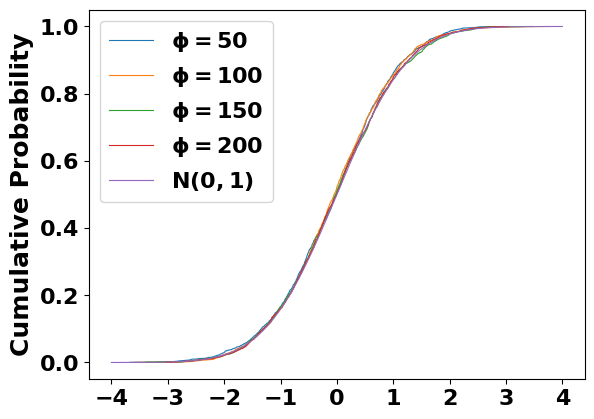

In [ ]:
R=2000
c=3
n=200
phi_values = [50, 100, 150, 200]
test_statistics = [TestST1, TestST2, TestST3, TestST4]

def normalize_test_statistics1(test_statistic, n, c, r):
    return (test_statistic - n * (c - 1/r) * np.ones(np.size(test_statistic))) / np.sqrt(2)


normalized_test_statistics = [normalize_test_statistics1(ts, n, c, np.sqrt(phi)) for ts, phi in zip(test_statistics, phi_values)]
labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]

plot_ecdf_and_standard_normal_cdf(*normalized_test_statistics, labels=labels)


### $T_2^g$

In practice, $(x-\sqrt{\phi}-1/\sqrt{\phi}+c)^2$ is used where, $c=3$

#### Data generating

Here we generate the test statistics with 2000 repetitions.

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np

R = 2000
n = 200

def simulate_test_statistics2(phi, n, R, c):
    m = int(n * phi)
    center = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n)
    pn = 2 * jnp.ones(n)

    @jit
    def objective(X):
        H = jnp.matmul(jnp.transpose(X), X)
        E0 = jnp.linalg.eigh(H)[0]
        Eb = E0 - center
        loE = jnp.power(Eb, pn)
        return jnp.sum(loE)

    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)

    for k in range(R):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))
        T = T.at[k].set(objective(X))

    return np.array(T)

TestST1 = simulate_test_statistics2(50,  n, R, 3)
TestST2 = simulate_test_statistics2(100, n, R, 3)
TestST3 = simulate_test_statistics2(150, n, R, 3)
TestST4 = simulate_test_statistics2(200, n, R, 3)


CPU times: user 33 s, sys: 1.79 s, total: 34.8 s
Wall time: 31.8 s


#### Saved data

In [ ]:
TestST1=[1841.3853 , 1846.5968 , 1839.1943 , 1824.7909 , 1834.8842 , 1829.1514 , 1825.3729 , 1825.6151 , 1824.2717 , 1840.2642 , 1845.7764 , 1845.1965 , 1840.811 , 1849.2137 , 1841.1765 , 1849.3025 , 1818.2441 , 1842.5881 , 1834.3474 , 1847.1035 , 1831.4192 , 1825.3617 , 1850.8093 , 1829.2332 , 1840.0114 , 1848.1638 , 1837.3916 , 1835.282 , 1833.8722 , 1830.3623 , 1827.5942 , 1814.255 , 1838.6904 , 1836.0039 , 1826.8129 , 1839.488 , 1834.2273 , 1837.6328 , 1834.414 , 1826.671 , 1844.312 , 1845.7201 , 1823.3848 , 1823.0067 , 1837.7823 , 1825.5432 , 1823.633 , 1838.5359 , 1827.7717 , 1832.3899 , 1836.5369 , 1828.1005 , 1825.0576 , 1830.6577 , 1845.8334 , 1834.0148 , 1834.9546 , 1828.6023 , 1843.5366 , 1837.229 , 1848.0369 , 1848.1833 , 1837.0457 , 1841.8501 , 1829.1106 , 1847.321 , 1832.1886 , 1829.6898 , 1821.9381 , 1841.0735 , 1824.5499 , 1842.1757 , 1825.022 , 1828.2308 , 1825.3906 , 1853.5693 , 1837.0353 , 1829.5188 , 1833.8049 , 1824.3402 , 1850.4238 , 1837.616 , 1845.5227 , 1838.9163 , 1839.396 , 1840.5349 , 1830.6943 , 1831.1759 , 1838.6943 , 1830.7323 , 1824.5138 , 1838.5964 , 1831.009 , 1835.116 , 1835.4053 , 1822.2231 , 1836.2456 , 1850.5454 , 1837.8235 , 1838.1643 , 1840.7777 , 1835.1084 , 1835.3113 , 1834.3594 , 1845.7911 , 1841.1802 , 1826.7825 , 1832.2864 , 1804.5729 , 1839.8484 , 1825.656 , 1824.4905 , 1838.9043 , 1833.3766 , 1841.6211 , 1831.5217 , 1829.1351 , 1842.2229 , 1828.4221 , 1830.9735 , 1844.6699 , 1833.4504 , 1832.6997 , 1862.3586 , 1840.2463 , 1838.7395 , 1829.0984 , 1841.1514 , 1845.398 , 1838.3672 , 1832.6962 , 1830.0853 , 1819.101 , 1838.5142 , 1832.9558 , 1835.4338 , 1837.5875 , 1818.937 , 1829.8037 , 1838.7561 , 1840.3323 , 1839.5122 , 1829.0253 , 1841.4729 , 1823.6531 , 1833.1168 , 1816.9897 , 1840.2937 , 1822.3961 , 1822.1727 , 1835.1907 , 1826.6813 , 1838.1722 , 1826.564 , 1838.3706 , 1844.4973 , 1835.1873 , 1827.6198 , 1830.6523 , 1834.772 , 1827.9968 , 1841.4208 , 1828.8833 , 1840.0503 , 1831.5139 , 1826.7366 , 1851.019 , 1836.0698 , 1835.5262 , 1827.5994 , 1829.8716 , 1821.5491 , 1843.3003 , 1854.7225 , 1833.072 , 1846.4604 , 1840.48 , 1833.7894 , 1820.8547 , 1841.1329 , 1836.512 , 1837.9016 , 1841.8341 , 1829.0967 , 1823.8872 , 1836.2759 , 1840.791 , 1839.29 , 1843.9417 , 1832.5005 , 1831.9769 , 1827.3154 , 1841.2659 , 1848.0896 , 1827.8934 , 1840.4459 , 1830.3511 , 1836.6171 , 1833.5048 , 1837.7847 , 1829.177 , 1833.8467 , 1849.4153 , 1826.1418 , 1842.731 , 1843.9092 , 1814.6212 , 1838.5515 , 1840.8812 , 1817.7983 , 1816.3489 , 1838.4255 , 1835.4121 , 1828.3115 , 1832.1155 , 1836.4604 , 1809.5576 , 1834.0344 , 1823.5017 , 1835.28 , 1841.9171 , 1823.0072 , 1850.805 , 1852.66 , 1832.0409 , 1832.1624 , 1828.3181 , 1823.9761 , 1837.831 , 1818.1716 , 1829.406 , 1842.5516 , 1842.1226 , 1828.9016 , 1829.9111 , 1838.258 , 1835.4078 , 1833.0979 , 1843.9397 , 1847.9172 , 1836.4674 , 1835.5088 , 1840.3131 , 1828.4402 , 1844.6626 , 1828.0823 , 1842.9823 , 1854.351 , 1828.3146 , 1838.9414 , 1815.442 , 1826.27 , 1826.1575 , 1841.1333 , 1818.8088 , 1841.4998 , 1830.1765 , 1848.3757 , 1815.7485 , 1845.4401 , 1827.8365 , 1854.2704 , 1822.1091 , 1837.9779 , 1840.1383 , 1836.4946 , 1832.5115 , 1834.6161 , 1836.3271 , 1823.3601 , 1836.948 , 1841.3389 , 1831.9532 , 1835.7737 , 1824.894 , 1843.0369 , 1827.6836 , 1826.9817 , 1816.3296 , 1834.1897 , 1833.3943 , 1844.2592 , 1838.6141 , 1840.8577 , 1831.573 , 1841.3032 , 1836.2673 , 1840.6554 , 1837.7577 , 1839.946 , 1826.1584 , 1826.3069 , 1847.8458 , 1846.2278 , 1831.0625 , 1836.062 , 1815.825 , 1833.208 , 1837.2207 , 1834.906 , 1833.5679 , 1817.3688 , 1836.117 , 1844.3075 , 1839.9697 , 1827.138 , 1836.3762 , 1840.5269 , 1830.6836 , 1840.7002 , 1843.5223 , 1835.565 , 1835.7772 , 1823.4136 , 1840.0663 , 1849.7195 , 1836.6345 , 1832.4282 , 1837.1774 , 1822.9043 , 1839.2451 , 1837.5109 , 1840.0947 , 1839.5643 , 1837.605 , 1831.4172 , 1831.8833 , 1834.0745 , 1829.8109 , 1832.9414 , 1847.1459 , 1812.539 , 1837.9009 , 1826.1339 , 1831.6575 , 1838.9672 , 1844.1467 , 1834.5511 , 1837.5905 , 1835.3427 , 1831.3497 , 1833.282 , 1833.1323 , 1836.6587 , 1818.3501 , 1846.5464 , 1840.3381 , 1837.638 , 1842.638 , 1838.0977 , 1833.9414 , 1827.8245 , 1845.3823 , 1836.6926 , 1843.902 , 1848.4797 , 1845.3279 , 1830.0776 , 1847.7296 , 1825.5427 , 1827.9607 , 1831.9033 , 1836.2212 , 1829.8706 , 1827.5504 , 1833.5051 , 1837.39 , 1838.9353 , 1838.8273 , 1833.8826 , 1842.4021 , 1832.8982 , 1830.7524 , 1835.4294 , 1837.4865 , 1836.8739 , 1830.6448 , 1840.5504 , 1837.1133 , 1838.5754 , 1834.4349 , 1839.3853 , 1834.3413 , 1822.135 , 1853.7717 , 1842.3865 , 1835.3987 , 1837.7297 , 1825.4886 , 1831.5325 , 1832.0685 , 1832.8365 , 1828.6285 , 1835.1442 , 1825.3583 , 1850.2135 , 1854.0808 , 1836.0112 , 1837.0809 , 1840.6333 , 1828.7139 , 1837.523 , 1838.3975 , 1828.832 , 1835.4294 , 1840.9801 , 1831.1637 , 1833.255 , 1836.1836 , 1844.7296 , 1852.0914 , 1825.3147 , 1836.8462 , 1832.0276 , 1841.8337 , 1827.1243 , 1831.8085 , 1829.9678 , 1829.2783 , 1841.9612 , 1823.0842 , 1823.3726 , 1842.6763 , 1842.4761 , 1841.8047 , 1823.9014 , 1820.3914 , 1844.8008 , 1842.7343 , 1839.1248 , 1835.2365 , 1852.8235 , 1830.2546 , 1835.6387 , 1841.1112 , 1843.0068 , 1828.0626 , 1835.1699 , 1822.7826 , 1831.519 , 1834.7902 , 1851.0051 , 1815.2555 , 1841.3318 , 1845.7573 , 1834.5664 , 1847.3484 , 1834.4358 , 1838.8003 , 1837.2993 , 1830.9823 , 1826.148 , 1831.9044 , 1837.3599 , 1844.9344 , 1837.7631 , 1818.0703 , 1834.1766 , 1836.2721 , 1826.628 , 1834.2263 , 1833.5681 , 1824.1162 , 1853.0404 , 1802.9163 , 1846.261 , 1844.8052 , 1835.0819 , 1826.9198 , 1848.6005 , 1835.0132 , 1838.2218 , 1847.6481 , 1838.6215 , 1842.2021 , 1848.6404 , 1818.642 , 1830.8228 , 1853.5779 , 1829.5453 , 1848.4781 , 1838.8038 , 1843.26 , 1842.0054 , 1829.0739 , 1828.623 , 1826.5942 , 1843.336 , 1832.4097 , 1822.9811 , 1840.1609 , 1851.1428 , 1853.9177 , 1837.3645 , 1827.5049 , 1839.5265 , 1805.0984 , 1835.0872 , 1849.5288 , 1841.2205 , 1852.0774 , 1847.7949 , 1827.8264 , 1846.2339 , 1832.7654 , 1847.1102 , 1826.8047 , 1839.4269 , 1838.3782 , 1846.5278 , 1831.4088 , 1838.1389 , 1832.4504 , 1817.9138 , 1845.9106 , 1814.381 , 1837.2627 , 1829.7754 , 1828.2258 , 1817.0056 , 1833.6448 , 1831.2068 , 1836.9265 , 1830.6155 , 1820.9431 , 1827.1263 , 1841.8418 , 1840.0038 , 1838.6064 , 1840.2263 , 1828.7947 , 1850.6798 , 1822.8368 , 1843.7777 , 1834.033 , 1839.4728 , 1837.9899 , 1830.5386 , 1833.3274 , 1828.2483 , 1836.3136 , 1830.7529 , 1827.4863 , 1841.4218 , 1850.2666 , 1834.3591 , 1833.1172 , 1835.2727 , 1826.3833 , 1838.5063 , 1836.2996 , 1826.2838 , 1822.5444 , 1829.8357 , 1835.0376 , 1839.9431 , 1851.2673 , 1843.7759 , 1846.5813 , 1825.6844 , 1823.6222 , 1839.5386 , 1833.2506 , 1824.4083 , 1832.48 , 1841.1707 , 1832.2136 , 1840.4968 , 1843.2893 , 1838.776 , 1834.7242 , 1832.6107 , 1820.666 , 1839.46 , 1846.157 , 1836.9355 , 1839.0842 , 1840.6001 , 1833.349 , 1833.0798 , 1836.5173 , 1823.4781 , 1844.802 , 1839.1396 , 1832.3054 , 1842.7368 , 1838.0446 , 1840.626 , 1843.0198 , 1825.7671 , 1839.9037 , 1837.0391 , 1833.1833 , 1833.1155 , 1851.0625 , 1825.3934 , 1847.041 , 1835.6294 , 1841.3704 , 1835.4698 , 1837.994 , 1846.0582 , 1844.593 , 1843.7788 , 1842.3383 , 1843.0977 , 1835.8674 , 1840.6641 , 1826.0573 , 1838.3257 , 1833.8853 , 1842.1047 , 1838.354 , 1839.6804 , 1845.2295 , 1852.713 , 1831.0709 , 1829.5669 , 1834.4867 , 1842.8772 , 1823.7852 , 1837.6979 , 1827.6683 , 1832.6245 , 1821.738 , 1823.682 , 1837.959 , 1829.6234 , 1827.729 , 1824.4742 , 1841.9875 , 1840.3855 , 1832.4954 , 1843.2644 , 1831.0676 , 1835.7516 , 1841.5881 , 1832.6805 , 1838.3955 , 1847.4478 , 1837.417 , 1833.8232 , 1828.7063 , 1840.2806 , 1818.3365 , 1836.4941 , 1832.7783 , 1833.1659 , 1835.5432 , 1819.0728 , 1835.1631 , 1831.3132 , 1834.5923 , 1839.6143 , 1839.6504 , 1827.5999 , 1816.1704 , 1840.7751 , 1842.6245 , 1833.5127 , 1833.9713 , 1846.7383 , 1832.4026 , 1831.8618 , 1842.8904 , 1833.8062 , 1831.2784 , 1827.8347 , 1833.5405 , 1824.4604 , 1819.1597 , 1850.9604 , 1840.6089 , 1829.6855 , 1828.0388 , 1832.7334 , 1827.562 , 1831.9633 , 1836.9507 , 1843.0009 , 1835.3953 , 1842.2124 , 1844.5476 , 1830.7849 , 1830.1863 , 1843.8845 , 1848.1143 , 1828.7244 , 1840.7449 , 1850.2932 , 1828.5491 , 1839.6843 , 1841.2426 , 1837.5623 , 1834.6702 , 1827.1372 , 1827.2314 , 1833.2161 , 1822.4719 , 1822.4111 , 1836.0111 , 1842.8625 , 1829.6069 , 1816.4718 , 1830.1069 , 1850.6072 , 1838.0476 , 1851.6176 , 1840.2007 , 1820.756 , 1828.3529 , 1824.4271 , 1843.0024 , 1835.7373 , 1840.1663 , 1829.5454 , 1847.1465 , 1840.633 , 1834.5962 , 1829.8314 , 1846.8438 , 1841.4635 , 1826.835 , 1830.0936 , 1840.8533 , 1839.6829 , 1832.8014 , 1851.262 , 1818.8698 , 1835.4631 , 1815.5819 , 1830.536 , 1842.7031 , 1826.1101 , 1837.2083 , 1843.3102 , 1840.4279 , 1826.3708 , 1848.8575 , 1847.5532 , 1833.1482 , 1854.9836 , 1834.428 , 1833.7345 , 1837.6255 , 1831.3455 , 1853.5686 , 1829.3506 , 1817.174 , 1832.9609 , 1839.0956 , 1839.7761 , 1836.02 , 1849.4435 , 1822.6003 , 1822.3068 , 1824.605 , 1836.0957 , 1844.26 , 1840.2534 , 1844.8699 , 1840.1436 , 1832.1931 , 1828.0878 , 1836.4557 , 1844.3997 , 1827.922 , 1843.9468 , 1828.3949 , 1844.9794 , 1837.8352 , 1832.5042 , 1836.3838 , 1826.676 , 1838.0669 , 1832.6553 , 1842.1926 , 1841.7153 , 1830.1743 , 1831.5547 , 1826.0137 , 1841.5024 , 1839.9502 , 1829.7117 , 1843.6041 , 1835.7606 , 1832.3177 , 1825.4839 , 1838.1552 , 1824.8687 , 1847.3157 , 1834.5071 , 1821.3269 , 1829.1956 , 1833.026 , 1846.1498 , 1827.54 , 1829.9167 , 1832.7014 , 1829.1378 , 1833.4915 , 1820.188 , 1836.0034 , 1834.3632 , 1834.0223 , 1833.6571 , 1828.133 , 1832.2412 , 1833.6382 , 1847.4631 , 1829.5803 , 1833.238 , 1847.145 , 1826.0518 , 1832.5874 , 1816.9539 , 1843.467 , 1818.8779 , 1829.2323 , 1831.9171 , 1827.8779 , 1832.5796 , 1849.5911 , 1845.4641 , 1835.9312 , 1823.5544 , 1835.6731 , 1828.0931 , 1838.6721 , 1834.6323 , 1841.5669 , 1838.2744 , 1845.073 , 1848.1938 , 1833.8243 , 1832.553 , 1826.4849 , 1823.4973 , 1823.5482 , 1837.2357 , 1827.3008 , 1832.4395 , 1829.8217 , 1838.0234 , 1833.7361 , 1833.1345 , 1831.4736 , 1847.2343 , 1840.2776 , 1840.2439 , 1842.9673 , 1831.7778 , 1840.3823 , 1824.301 , 1823.0507 , 1828.7195 , 1825.7737 , 1822.404 , 1830.635 , 1828.544 , 1824.7725 , 1847.1854 , 1856.9369 , 1826.1694 , 1839.486 , 1841.5912 , 1829.8801 , 1828.7808 , 1836.2664 , 1846.5908 , 1845.042 , 1850.5217 , 1843.4353 , 1851.0702 , 1822.6279 , 1852.5791 , 1845.5874 , 1824.7017 , 1823.6498 , 1827.8035 , 1847.6454 , 1835.6611 , 1841.886 , 1842.8296 , 1826.9264 , 1845.3738 , 1848.6061 , 1820.8923 , 1832.2756 , 1831.5079 , 1840.563 , 1824.5618 , 1839.3462 , 1836.1396 , 1836.261 , 1823.8075 , 1827.0967 , 1826.3345 , 1841.7593 , 1849.7993 , 1836.6473 , 1828.4703 , 1829.9387 , 1837.8992 , 1829.9785 , 1837.0145 , 1838.7798 , 1835.6086 , 1823.5786 , 1829.4008 , 1834.8564 , 1823.1511 , 1826.6937 , 1824.7821 , 1837.001 , 1843.7407 , 1840.8789 , 1831.6877 , 1826.869 , 1840.8857 , 1832.4333 , 1835.8881 , 1822.2571 , 1832.9729 , 1846.4114 , 1825.2141 , 1836.453 , 1834.8025 , 1824.5093 , 1823.6168 , 1829.7068 , 1834.1785 , 1814.6143 , 1834.3652 , 1829.2198 , 1826.4358 , 1833.5071 , 1831.7561 , 1822.9065 , 1844.5507 , 1816.9983 , 1830.0596 , 1826.4419 , 1845.8693 , 1841.8413 , 1832.928 , 1845.6575 , 1830.7744 , 1828.9492 , 1828.8352 , 1828.0887 , 1827.9397 , 1826.1962 , 1811.3715 , 1823.2103 , 1827.6216 , 1842.338 , 1841.9963 , 1835.2742 , 1848.6097 , 1841.9662 , 1831.9884 , 1834.9717 , 1840.8302 , 1841.1407 , 1842.2212 , 1832.6604 , 1833.2018 , 1831.3596 , 1825.3191 , 1840.6699 , 1841.2958 , 1834.261 , 1824.7036 , 1846.673 , 1834.7526 , 1849.706 , 1835.6199 , 1844.5332 , 1832.0822 , 1833.3704 , 1824.2714 , 1842.4531 , 1822.5317 , 1824.2888 , 1841.8777 , 1838.6565 , 1855.491 , 1841.0864 , 1836.6318 , 1829.6655 , 1841.602 , 1842.857 , 1839.4395 , 1844.85 , 1830.3275 , 1834.9739 , 1838.1759 , 1828.249 , 1832.0096 , 1832.54 , 1828.7808 , 1824.7653 , 1834.4221 , 1851.253 , 1837.2439 , 1833.1389 , 1843.2773 , 1836.3177 , 1848.3094 , 1835.3987 , 1841.2163 , 1829.4882 , 1825.9901 , 1834.2585 , 1829.1776 , 1836.1742 , 1839.2272 , 1824.05 , 1835.864 , 1831.9999 , 1835.9272 , 1832.7378 , 1834.7476 , 1835.4082 , 1839.7222 , 1847.3179 , 1830.894 , 1835.1804 , 1835.6606 , 1827.2861 , 1818.6122 , 1833.3567 , 1836.5706 , 1824.0758 , 1830.6345 , 1826.984 , 1837.0184 , 1828.5316 , 1835.1145 , 1839.8214 , 1840.5964 , 1827.2229 , 1831.1979 , 1838.6216 , 1822.1702 , 1826.7294 , 1823.4062 , 1816.4587 , 1830.3436 , 1830.8018 , 1826.2026 , 1841.7694 , 1830.9238 , 1834.9003 , 1832.9219 , 1841.3154 , 1832.75 , 1836.8317 , 1845.5381 , 1834.7043 , 1837.2014 , 1848.9675 , 1838.5763 , 1842.2649 , 1839.5046 , 1851.686 , 1844.9148 , 1840.1688 , 1820.1401 , 1837.852 , 1833.3904 , 1831.3214 , 1833.6831 , 1838.1914 , 1833.6138 , 1847.7764 , 1830.7423 , 1845.1659 , 1828.6658 , 1818.3081 , 1833.0618 , 1827.829 , 1828.7184 , 1836.259 , 1846.2004 , 1822.1008 , 1835.8032 , 1825.9196 , 1830.3854 , 1834.8704 , 1838.0874 , 1831.1771 , 1813.7228 , 1840.1978 , 1823.3181 , 1830.5798 , 1836.1487 , 1821.4739 , 1829.2517 , 1835.8593 , 1818.0254 , 1842.5627 , 1842.0958 , 1821.9004 , 1806.0911 , 1846.307 , 1836.1113 , 1818.2141 , 1828.1041 , 1847.3269 , 1835.3264 , 1833.9514 , 1820.2673 , 1847.8385 , 1845.9578 , 1830.228 , 1834.0425 , 1844.3846 , 1841.907 , 1830.0852 , 1837.6626 , 1823.2509 , 1824.4668 , 1823.7163 , 1839.9663 , 1833.7174 , 1837.3184 , 1847.269 , 1829.4072 , 1839.992 , 1838.137 , 1836.7329 , 1821.5999 , 1815.2665 , 1827.3342 , 1849.3473 , 1834.9357 , 1833.8391 , 1849.4353 , 1831.9943 , 1806.9882 , 1835.6428 , 1844.2537 , 1838.6741 , 1825.102 , 1840.1377 , 1827.3628 , 1824.4731 , 1833.4949 , 1840.1108 , 1837.7567 , 1819.8362 , 1843.9216 , 1824.1733 , 1841.4875 , 1811.8833 , 1847.2861 , 1829.1615 , 1830.3441 , 1843.471 , 1831.8535 , 1828.3486 , 1841.0498 , 1835.3628 , 1834.0745 , 1844.9675 , 1839.5588 , 1831.2073 , 1834.5199 , 1833.1392 , 1849.5646 , 1850.4221 , 1837.669 , 1830.6906 , 1830.3608 , 1827.8787 , 1819.8444 , 1842.0676 , 1841.519 , 1826.6195 , 1837.7811 , 1846.8239 , 1827.4556 , 1841.6385 , 1827.5454 , 1830.3113 , 1836.9109 , 1831.7336 , 1834.0542 , 1834.3674 , 1843.3772 , 1843.0955 , 1831.8926 , 1841.9622 , 1840.1738 , 1842.7867 , 1838.7275 , 1834.9316 , 1823.1606 , 1841.2213 , 1841.9901 , 1841.7305 , 1838.7898 , 1837.9695 , 1833.9714 , 1836.8518 , 1823.4878 , 1836.6111 , 1840.1199 , 1830.9243 , 1816.2385 , 1842.0995 , 1849.6703 , 1833.5084 , 1845.4893 , 1844.9608 , 1827.0938 , 1841.5452 , 1833.131 , 1832.2731 , 1847.2753 , 1841.0027 , 1822.7725 , 1830.4996 , 1826.0635 , 1825.817 , 1830.8077 , 1832.135 , 1826.626 , 1833.9912 , 1826.2749 , 1843.8542 , 1830.2483 , 1830.2306 , 1844.5162 , 1845.6318 , 1826.4797 , 1826.6691 , 1848.0477 , 1845.6174 , 1842.3887 , 1842.3184 , 1835.8322 , 1835.3535 , 1841.9564 , 1847.6813 , 1838.7983 , 1826.3711 , 1838.0667 , 1819.6744 , 1825.3794 , 1823.0398 , 1830.838 , 1825.4839 , 1841.9462 , 1838.9304 , 1826.1056 , 1838.1826 , 1844.2058 , 1819.185 , 1818.9651 , 1825.4949 , 1823.0 , 1823.2891 , 1836.2648 , 1834.7006 , 1845.8561 , 1832.6097 , 1832.3402 , 1841.3328 , 1837.948 , 1843.3564 , 1847.792 , 1848.9308 , 1823.4943 , 1813.1177 , 1833.41 , 1842.1488 , 1835.8097 , 1841.3218 , 1828.896 , 1827.3882 , 1833.3108 , 1834.6531 , 1820.2491 , 1845.4294 , 1830.7119 , 1832.992 , 1837.5327 , 1830.347 , 1830.1062 , 1844.3087 , 1828.6113 , 1823.7246 , 1836.6824 , 1831.0867 , 1819.4562 , 1833.3228 , 1843.8472 , 1836.8334 , 1820.454 , 1850.372 , 1846.4841 , 1836.938 , 1830.2705 , 1846.729 , 1833.4886 , 1830.3721 , 1859.9897 , 1836.1907 , 1846.6418 , 1839.9575 , 1846.6816 , 1839.4047 , 1829.1377 , 1849.891 , 1848.0415 , 1823.7834 , 1855.3037 , 1824.2767 , 1845.3589 , 1845.6599 , 1850.0935 , 1851.3115 , 1839.8013 , 1835.2803 , 1830.4458 , 1834.873 , 1830.3805 , 1850.6948 , 1812.3494 , 1823.0433 , 1826.983 , 1837.884 , 1822.1633 , 1840.0566 , 1836.1334 , 1836.977 , 1820.2627 , 1841.6904 , 1846.7942 , 1843.9414 , 1839.6285 , 1842.7595 , 1849.8279 , 1824.6554 , 1833.4875 , 1827.8026 , 1827.6953 , 1850.9956 , 1825.6597 , 1826.0217 , 1832.6215 , 1821.9713 , 1837.8574 , 1840.0853 , 1846.1304 , 1843.4758 , 1837.7971 , 1835.0554 , 1836.7546 , 1820.6848 , 1828.5125 , 1839.1368 , 1838.503 , 1836.8169 , 1837.9785 , 1830.5447 , 1838.4298 , 1814.3585 , 1832.3635 , 1835.4443 , 1830.4651 , 1841.0698 , 1837.3506 , 1836.4447 , 1836.5325 , 1826.4524 , 1833.3782 , 1833.1655 , 1836.537 , 1830.8411 , 1814.8904 , 1830.3666 , 1835.3044 , 1835.322 , 1836.7134 , 1828.436 , 1823.4529 , 1839.2263 , 1836.2542 , 1834.9299 , 1854.4993 , 1822.1382 , 1840.6206 , 1855.3948 , 1839.8093 , 1840.4796 , 1827.8035 , 1826.9648 , 1841.2888 , 1831.391 , 1843.8364 , 1835.8024 , 1847.9485 , 1839.1489 , 1837.1312 , 1845.7291 , 1841.9592 , 1839.5681 , 1826.1182 , 1827.0114 , 1826.255 , 1839.1875 , 1838.8091 , 1837.3367 , 1821.9283 , 1833.703 , 1826.7947 , 1835.311 , 1840.4043 , 1830.2678 , 1844.43 , 1839.3435 , 1832.1372 , 1846.2903 , 1836.1943 , 1834.3579 , 1834.1876 , 1827.8534 , 1839.5039 , 1838.5686 , 1835.3623 , 1828.3579 , 1836.2292 , 1827.7429 , 1830.8364 , 1837.4265 , 1811.5627 , 1829.7151 , 1832.5748 , 1833.6472 , 1831.0112 , 1817.2253 , 1832.3853 , 1833.5974 , 1828.3486 , 1831.3652 , 1853.3044 , 1827.5992 , 1827.7762 , 1829.5543 , 1843.6267 , 1842.8613 , 1832.3193 , 1833.8715 , 1847.0555 , 1833.1575 , 1831.4624 , 1827.752 , 1836.178 , 1824.0898 , 1835.0503 , 1837.5363 , 1833.0967 , 1841.1779 , 1832.1948 , 1823.1996 , 1841.2261 , 1834.54 , 1824.8271 , 1851.6514 , 1841.1248 , 1829.9963 , 1835.5696 , 1840.7257 , 1842.5764 , 1841.4824 , 1830.5626 , 1820.3263 , 1838.6204 , 1849.1104 , 1825.2113 , 1852.3984 , 1839.3679 , 1844.5231 , 1831.144 , 1838.3391 , 1814.7775 , 1833.1626 , 1831.1279 , 1827.0144 , 1824.9126 , 1834.9761 , 1846.5164 , 1841.44 , 1837.7285 , 1824.4292 , 1827.3016 , 1826.6621 , 1830.9885 , 1837.5786 , 1845.9495 , 1838.4106 , 1844.1942 , 1837.886 , 1822.8064 , 1836.1876 , 1838.1802 , 1836.924 , 1843.7638 , 1820.0378 , 1827.2078 , 1822.8705 , 1853.4543 , 1846.7571 , 1830.2134 , 1843.5311 , 1839.2139 , 1841.7341 , 1833.9011 , 1840.1053 , 1847.3464 , 1833.3026 , 1848.9171 , 1822.6575 , 1837.9233 , 1822.4675 , 1829.0771 , 1838.0886 , 1842.2949 , 1830.8461 , 1835.6921 , 1837.66 , 1843.7463 , 1848.7861 , 1836.7244 , 1840.1848 , 1824.1259 , 1842.7715 , 1845.8003 , 1822.9719 , 1842.3446 , 1836.3809 , 1823.582 , 1831.323 , 1837.2009 , 1818.0137 , 1845.2964 , 1814.0156 , 1832.563 , 1836.3291 , 1842.3597 , 1832.6016 , 1836.3379 , 1849.585 , 1837.2588 , 1836.9727 , 1841.4752 , 1835.3401 , 1830.6521 , 1849.3536 , 1835.2893 , 1854.3757 , 1833.7434 , 1844.6741 , 1833.2382 , 1826.1832 , 1838.0647 , 1831.4246 , 1829.1216 , 1827.1874 , 1834.7004 , 1843.196 , 1840.485 , 1849.1697 , 1839.4978 , 1837.2887 , 1820.8236 , 1843.227 , 1844.5059 , 1826.7 , 1836.9802 , 1833.3873 , 1821.5681 , 1834.0127 , 1840.1451 , 1830.6287 , 1834.2914 , 1837.311 , 1836.4912 , 1837.0082 , 1828.4331 , 1828.6748 , 1839.6642 , 1839.6306 , 1850.1746 , 1831.7158 , 1839.2136 , 1855.4739 , 1846.4513 , 1841.8987 , 1831.1345 , 1830.5062 , 1816.3545 , 1836.7748 , 1841.6682 , 1836.1094 , 1817.3074 , 1824.46 , 1822.9485 , 1848.7073 , 1815.7996 , 1828.6365 , 1839.3384 , 1853.9646 , 1835.7253 , 1836.9546 , 1838.9092 , 1825.157 , 1828.605 , 1849.0807 , 1847.638 , 1842.7588 , 1817.7114 , 1826.5588 , 1853.4839 , 1829.4248 , 1841.1469 , 1826.3975 , 1832.5043 , 1819.3441 , 1831.6201 , 1837.5973 , 1820.6836 , 1851.0769 , 1837.2781 , 1844.1813 , 1842.1327 , 1819.2178 , 1848.8826 , 1831.7781 , 1841.3157 , 1843.4945 , 1835.6218 , 1839.1951 , 1851.1912 , 1834.9832 , 1843.9568 , 1832.4296 , 1839.4202 , 1841.5378 , 1841.2124 , 1860.7131 , 1836.3352 , 1840.6702 , 1854.4666 , 1838.3279 , 1839.061 , 1830.1047 , 1855.8572 , 1825.8538 , 1829.0049 , 1838.9404 , 1839.042 , 1847.7849 , 1839.9309 , 1846.6399 , 1822.3018 , 1845.346 , 1837.1333 , 1827.7767 , 1846.6866 , 1826.0371 , 1833.8694 , 1824.7571 , 1833.0906 , 1844.1519 , 1833.7703 , 1826.6484 , 1838.9928 , 1818.53 , 1825.31 , 1830.1079 , 1833.0276 , 1814.105 , 1836.4524 , 1827.458 , 1841.4319 , 1842.0833 , 1832.4844 , 1832.1469 , 1828.735 , 1835.8824 , 1822.0146 , 1858.207 , 1833.032 , 1842.166 , 1829.7673 , 1841.2662 , 1832.721 , 1836.7378 , 1830.4624 , 1828.4705 , 1829.0293 , 1839.2606 , 1834.2495 , 1818.274 , 1833.4333 , 1839.1732 , 1825.8624 , 1819.7256 , 1845.4858 , 1827.349 , 1839.3218 , 1832.5125 , 1837.0354 , 1842.1503 , 1834.8247 , 1815.1255 , 1839.4314 , 1833.2094 , 1841.0 , 1838.6714 , 1841.2493 , 1820.56 , 1841.5984 , 1835.1475 , 1846.9238 , 1832.5935 , 1820.3903 , 1834.0148 , 1820.806 , 1848.3835 , 1823.455 , 1833.2344 , 1854.1638 , 1844.0625 , 1831.6312 , 1849.3533 , 1830.9331 , 1846.6677 , 1824.0477 , 1816.0469 , 1834.9998 , 1825.4802 , 1822.6438 , 1818.0979 , 1820.9856 , 1851.4592 , 1833.3623 , 1838.6761 , 1828.001 , 1833.171 , 1826.9504 , 1848.0864 , 1832.2502 , 1846.614 , 1832.768 , 1842.1904 , 1835.0857 , 1817.7675 , 1839.6299 , 1821.963 , 1829.7051 , 1838.2534 , 1851.9094 , 1821.5837 , 1830.3289 , 1834.3833 , 1821.1228 , 1836.0452 , 1839.3315 , 1832.032 , 1840.8416 , 1834.861 , 1825.439 , 1845.2322 , 1837.2255 , 1826.9531 , 1841.3984 , 1836.7867 , 1822.9542 , 1830.5409 , 1832.7504 , 1843.2913 , 1847.7853 , 1832.5857 , 1829.9579 , 1836.5897 , 1840.0217 , 1848.8403 , 1836.862 , 1821.4712 , 1825.2554 , 1841.2659 , 1834.1989 , 1828.69 , 1827.5333 , 1846.6536 , 1820.1655 , 1835.7281 , 1828.0667 , 1832.7915 , 1835.0985 , 1828.3024 , 1825.406 , 1826.6814 , 1834.1035 , 1830.8533 , 1844.0396 , 1842.469 , 1843.4314 , 1824.9497 , 1844.0793 , 1826.8989 , 1830.3091 , 1845.2207 , 1824.1438 , 1847.4614 , 1837.926 , 1840.8944 , 1830.8662 , 1830.0964 , 1832.424 , 1846.6018 , 1852.7357 , 1815.4911 , 1841.8394 , 1835.3932 , 1836.9736 , 1834.565 , 1845.2571 , 1831.7571 , 1817.8667 , 1828.457 , 1833.7698 , 1841.4048 , 1829.4424 , 1835.0901 , 1829.476 , 1840.9651 , 1843.0642 , 1827.997 , 1839.9412 , 1843.1101 , 1823.0105 , 1834.976 , 1842.8064 , 1839.5737 , 1852.663 , 1837.0978 , 1830.046 , 1839.8141 , 1827.9939 , 1826.2515 , 1826.7334 , 1841.7356 , 1830.117 , 1828.5587 , 1837.605 , 1832.0175 , 1837.0338 , 1828.2019 , 1831.1184 , 1838.8562 , 1848.5952 , 1836.5624 , 1825.1864 , 1810.5061 , 1835.3959 , 1850.021 , 1833.7366 , 1837.4343 , 1829.8259 , 1847.9014 , 1831.398 , 1830.2783 , 1825.0992 , 1828.3938 , 1829.0077 , 1846.016 , 1822.8401 , 1834.3953 , 1814.103 , 1844.8141 , 1829.6067 , 1830.658 , 1821.8937 , 1821.8339 , 1824.1925 , 1840.6542 , 1819.9763 , 1835.2854 , 1842.6194 , 1843.0159 , 1821.165 , 1832.8685 , 1841.083 , 1833.2642 , 1825.6891 , 1848.321 , 1843.6584 , 1835.0205 , 1829.6149 , 1832.7537 , 1832.7979 , 1829.3014 , 1813.7622 , 1846.8809 , 1844.9989 , 1828.652 , 1841.2168 , 1839.8652 , 1838.726 , 1844.8539 , 1822.8652 , 1845.0469 , 1843.448 , 1841.5955 , 1827.6147 , 1844.1787 , 1844.5642 , 1855.5509 , 1825.7252 , 1837.4731 , 1834.1704 , 1843.3638 , 1832.9414 , 1849.5496 , 1838.6503 , 1847.5583 , 1835.5492 , 1833.2698 , 1829.8975 , 1812.5581 , 1839.6095 , 1827.519 , 1844.1241 , 1840.1228 , 1832.8268 , 1846.5903 , 1814.2805 , 1839.5923 , 1832.9376 , 1841.1958 , 1844.9995 , 1834.7732 , 1827.6256 , 1829.6223 , 1837.8094 , 1841.5623 , 1837.384 , 1834.2568 , 1835.1157 , 1828.0781 , 1826.5164 , 1834.9048 , 1838.2043 , 1842.1212 , 1829.564 , 1836.0488 , 1839.2565 , 1831.0076 , 1850.2625 , 1839.44 , 1832.7754 , 1834.6156 , 1827.9009 , 1843.1475 , 1842.7191 , 1841.842 , 1825.5106 , 1819.3145 , 1818.7832 , 1824.3298 , 1835.7986 , 1839.8654 , 1835.429 , 1835.761 , 1825.4518 , 1835.2644 , 1827.0441 , 1841.9021 , 1844.533 , 1838.2211 , 1839.7625 , 1836.0271 , 1843.3933 , 1842.7198 , 1839.9268 , 1830.5664 , 1834.0234 , 1842.3505 , 1828.1051 , 1824.0039 , 1833.1455 , 1830.8599 , 1832.9456]

In [ ]:
TestST2=[1890.3706 , 1865.1077 , 1901.0409 , 1880.991 , 1885.6567 , 1879.9995 , 1870.9296 , 1890.1702 , 1883.2139 , 1892.2 , 1872.8866 , 1877.7622 , 1898.3844 , 1871.5211 , 1889.8984 , 1877.2814 , 1880.4526 , 1876.7198 , 1882.4427 , 1900.7836 , 1882.3384 , 1869.2085 , 1891.3678 , 1890.907 , 1885.9181 , 1881.4102 , 1877.3865 , 1879.7303 , 1890.9875 , 1884.3029 , 1890.0619 , 1885.01 , 1890.5713 , 1878.5087 , 1879.6116 , 1878.6616 , 1882.1313 , 1875.6073 , 1890.2439 , 1876.8026 , 1867.8118 , 1892.3586 , 1874.9595 , 1871.2678 , 1879.1256 , 1886.6555 , 1885.984 , 1873.4498 , 1871.4037 , 1889.3438 , 1879.4497 , 1891.7167 , 1875.6511 , 1874.7341 , 1882.7804 , 1892.7589 , 1885.6483 , 1884.8833 , 1885.1416 , 1881.6792 , 1889.0222 , 1884.9128 , 1890.7065 , 1864.8833 , 1881.1963 , 1883.8828 , 1877.5347 , 1878.1674 , 1882.2109 , 1896.3485 , 1889.5635 , 1894.5774 , 1889.0508 , 1888.6045 , 1887.5764 , 1892.199 , 1877.5402 , 1879.52 , 1871.6705 , 1876.278 , 1887.4645 , 1880.7302 , 1877.8079 , 1862.1632 , 1882.127 , 1885.426 , 1884.7297 , 1893.4282 , 1876.8187 , 1890.09 , 1882.9651 , 1902.6738 , 1886.4822 , 1889.7986 , 1888.897 , 1878.9993 , 1875.2859 , 1890.7512 , 1878.9897 , 1877.6084 , 1877.2133 , 1886.8483 , 1873.8783 , 1887.3281 , 1879.7632 , 1881.8069 , 1876.6116 , 1898.3003 , 1871.5845 , 1878.2605 , 1867.8296 , 1870.49 , 1884.9882 , 1869.3633 , 1886.788 , 1876.6895 , 1889.1185 , 1884.2893 , 1889.028 , 1875.4757 , 1883.4248 , 1872.0312 , 1876.3221 , 1884.0133 , 1876.0669 , 1889.4591 , 1880.0873 , 1877.7803 , 1891.508 , 1885.9026 , 1873.7144 , 1869.6292 , 1886.4647 , 1876.8615 , 1883.7212 , 1878.7712 , 1874.2683 , 1875.6104 , 1876.5377 , 1882.0374 , 1895.5537 , 1885.5094 , 1903.0214 , 1868.385 , 1893.772 , 1875.9414 , 1886.2811 , 1874.9967 , 1875.6431 , 1891.7903 , 1899.7024 , 1887.9958 , 1878.6321 , 1891.0591 , 1899.8864 , 1887.6877 , 1868.8486 , 1896.5221 , 1859.8237 , 1877.3596 , 1897.0844 , 1887.2295 , 1873.8168 , 1872.8395 , 1877.0364 , 1879.8481 , 1878.2767 , 1900.3534 , 1884.873 , 1883.9125 , 1903.5712 , 1892.6804 , 1879.406 , 1882.3688 , 1874.0258 , 1887.6085 , 1883.1912 , 1890.1707 , 1896.118 , 1890.7878 , 1885.0569 , 1883.888 , 1876.7408 , 1883.2483 , 1872.7103 , 1884.7688 , 1884.5117 , 1878.7441 , 1882.5505 , 1872.4792 , 1880.9075 , 1891.4883 , 1854.0802 , 1882.2651 , 1877.2249 , 1875.9446 , 1896.7297 , 1897.8297 , 1886.0793 , 1889.2407 , 1872.74 , 1889.1301 , 1879.085 , 1871.47 , 1893.4296 , 1879.2463 , 1874.7246 , 1893.4158 , 1874.1589 , 1876.5557 , 1883.0037 , 1884.6504 , 1895.47 , 1865.3147 , 1887.4755 , 1890.2224 , 1877.8164 , 1889.802 , 1869.4586 , 1874.2631 , 1887.0491 , 1879.4253 , 1892.3938 , 1878.2189 , 1874.4391 , 1885.8718 , 1880.0347 , 1885.7626 , 1869.6084 , 1892.5784 , 1868.3341 , 1880.5276 , 1889.853 , 1883.3499 , 1889.7937 , 1889.5776 , 1900.284 , 1881.8492 , 1873.8336 , 1890.9155 , 1892.5154 , 1872.7478 , 1883.1737 , 1866.8386 , 1888.3391 , 1881.896 , 1870.3306 , 1883.2551 , 1873.1932 , 1870.5742 , 1872.7429 , 1890.0536 , 1891.7755 , 1866.3849 , 1895.8252 , 1882.7976 , 1882.1862 , 1889.3076 , 1884.1499 , 1879.042 , 1893.3081 , 1860.6345 , 1880.5923 , 1890.9165 , 1887.6975 , 1884.2693 , 1890.4917 , 1874.2356 , 1875.887 , 1868.004 , 1882.7803 , 1879.0605 , 1875.1034 , 1865.7439 , 1899.1907 , 1889.026 , 1878.2135 , 1883.4281 , 1875.876 , 1876.9894 , 1870.7081 , 1882.2527 , 1882.8809 , 1877.1576 , 1892.4612 , 1880.6965 , 1877.7848 , 1887.7919 , 1884.1284 , 1881.6045 , 1889.7684 , 1875.5703 , 1902.1697 , 1886.6418 , 1876.7537 , 1869.6404 , 1879.2817 , 1873.1991 , 1875.9033 , 1880.864 , 1889.7764 , 1888.6564 , 1877.8033 , 1878.8766 , 1889.0823 , 1888.1343 , 1866.1229 , 1873.8046 , 1888.8802 , 1881.3174 , 1885.74 , 1882.4475 , 1891.5508 , 1896.2305 , 1898.8315 , 1877.8076 , 1879.6101 , 1908.6652 , 1875.4885 , 1871.326 , 1881.7698 , 1900.1704 , 1876.4604 , 1893.1345 , 1881.7076 , 1866.5234 , 1885.6106 , 1886.9512 , 1864.766 , 1878.5134 , 1871.3802 , 1881.946 , 1869.3108 , 1879.4425 , 1867.132 , 1879.4402 , 1886.957 , 1864.7324 , 1880.4133 , 1878.3684 , 1872.866 , 1891.3484 , 1888.7585 , 1878.8315 , 1902.4132 , 1892.3589 , 1873.8989 , 1891.2487 , 1875.5361 , 1877.4233 , 1878.3025 , 1850.6256 , 1880.6329 , 1885.8053 , 1895.3374 , 1894.1201 , 1879.377 , 1876.69 , 1876.2175 , 1878.5518 , 1883.6912 , 1882.1809 , 1880.5621 , 1875.8909 , 1880.6047 , 1881.6714 , 1887.9329 , 1874.4269 , 1895.7405 , 1879.8846 , 1882.6738 , 1872.3657 , 1875.4769 , 1885.8323 , 1888.1654 , 1896.6038 , 1895.6362 , 1879.8965 , 1864.431 , 1878.1581 , 1876.4792 , 1882.0302 , 1889.7275 , 1879.9346 , 1884.4425 , 1883.9357 , 1886.3948 , 1885.9504 , 1877.7007 , 1865.3114 , 1889.4666 , 1881.6946 , 1882.2994 , 1869.542 , 1883.2742 , 1877.1301 , 1883.0159 , 1882.6721 , 1884.4781 , 1889.8191 , 1888.1917 , 1874.5559 , 1885.8394 , 1879.0767 , 1875.8711 , 1887.6375 , 1873.3636 , 1870.679 , 1870.5037 , 1885.0582 , 1896.8138 , 1874.8 , 1883.9856 , 1882.5342 , 1884.3135 , 1877.8424 , 1897.3127 , 1881.0603 , 1885.8958 , 1878.0454 , 1897.1013 , 1867.5875 , 1872.0232 , 1885.4575 , 1890.3577 , 1877.3279 , 1881.8727 , 1883.7388 , 1878.6011 , 1889.5886 , 1902.3958 , 1888.0969 , 1899.6189 , 1886.1161 , 1870.7994 , 1883.3479 , 1887.9696 , 1878.3878 , 1875.1841 , 1866.0485 , 1888.6863 , 1888.0385 , 1873.3396 , 1874.5336 , 1878.0366 , 1878.5056 , 1893.5189 , 1886.8206 , 1893.7257 , 1887.9812 , 1891.5175 , 1885.407 , 1898.9044 , 1893.6194 , 1869.5989 , 1878.2322 , 1884.1239 , 1869.8193 , 1880.5754 , 1869.1929 , 1887.9194 , 1896.5033 , 1875.0197 , 1867.5774 , 1896.9666 , 1875.5854 , 1865.8632 , 1887.196 , 1876.2948 , 1889.3015 , 1878.3014 , 1880.3784 , 1884.4022 , 1882.3025 , 1888.7545 , 1871.0876 , 1881.3861 , 1889.7417 , 1879.1826 , 1887.0532 , 1901.135 , 1886.134 , 1881.9713 , 1871.8235 , 1880.8218 , 1875.5116 , 1887.1289 , 1890.1372 , 1893.1855 , 1876.6077 , 1892.7397 , 1879.6813 , 1876.0243 , 1869.5106 , 1874.5725 , 1880.2736 , 1877.5188 , 1886.6729 , 1892.6099 , 1895.0571 , 1878.8599 , 1869.6372 , 1883.7266 , 1882.5775 , 1878.4368 , 1865.5428 , 1884.6348 , 1871.9316 , 1897.2871 , 1879.8058 , 1884.5605 , 1890.7734 , 1887.7317 , 1876.9926 , 1875.4727 , 1888.5511 , 1879.8632 , 1868.0518 , 1882.5792 , 1893.9884 , 1868.572 , 1874.9153 , 1874.0785 , 1891.6012 , 1878.4491 , 1883.6792 , 1880.6771 , 1889.3247 , 1894.3513 , 1881.5415 , 1900.7927 , 1882.7422 , 1872.0442 , 1873.2146 , 1873.531 , 1868.6182 , 1875.0076 , 1874.4635 , 1875.6412 , 1891.3914 , 1881.1522 , 1891.983 , 1890.1842 , 1879.3804 , 1875.1929 , 1880.779 , 1908.3439 , 1878.3257 , 1887.4841 , 1876.8654 , 1869.1488 , 1875.5608 , 1875.6542 , 1893.3462 , 1879.4127 , 1868.9348 , 1887.3777 , 1877.2734 , 1878.8628 , 1885.3552 , 1881.677 , 1884.2323 , 1885.6797 , 1878.3308 , 1876.5853 , 1884.029 , 1878.1005 , 1891.5477 , 1876.7823 , 1877.9702 , 1872.6234 , 1876.2656 , 1904.9153 , 1883.1096 , 1897.8049 , 1870.8081 , 1877.1129 , 1872.9274 , 1889.4053 , 1877.2593 , 1879.0709 , 1888.3059 , 1898.7573 , 1876.1654 , 1891.7849 , 1884.3911 , 1878.7981 , 1872.9268 , 1878.043 , 1883.5933 , 1905.7263 , 1890.0852 , 1902.7385 , 1877.638 , 1888.3461 , 1889.0559 , 1889.4891 , 1885.2622 , 1874.7288 , 1889.7377 , 1869.9581 , 1899.0986 , 1884.8866 , 1890.8992 , 1879.9696 , 1893.1353 , 1885.0847 , 1867.615 , 1893.8634 , 1895.9457 , 1884.0308 , 1883.9075 , 1900.1841 , 1880.6007 , 1881.2324 , 1870.9766 , 1883.5472 , 1895.091 , 1886.4517 , 1876.6273 , 1878.659 , 1886.5737 , 1882.1235 , 1890.6439 , 1879.0319 , 1868.1084 , 1869.2058 , 1882.2183 , 1889.7146 , 1882.0002 , 1883.3682 , 1895.8452 , 1887.2191 , 1890.0475 , 1876.804 , 1879.8033 , 1890.5393 , 1885.3191 , 1875.9688 , 1883.8593 , 1877.4869 , 1865.0984 , 1876.6577 , 1888.4492 , 1875.1609 , 1884.427 , 1883.0554 , 1878.9048 , 1903.3857 , 1885.3009 , 1889.2909 , 1897.4819 , 1885.1497 , 1875.4358 , 1885.0603 , 1872.4238 , 1885.9753 , 1887.3181 , 1883.3232 , 1875.1234 , 1891.5803 , 1872.3013 , 1899.0922 , 1881.0018 , 1874.4048 , 1880.4072 , 1888.7927 , 1896.7079 , 1882.1221 , 1874.822 , 1883.1179 , 1881.9094 , 1889.3652 , 1883.4458 , 1886.9579 , 1879.1355 , 1878.6194 , 1874.7511 , 1884.1586 , 1880.8689 , 1881.0001 , 1887.6207 , 1865.9873 , 1889.2573 , 1887.7898 , 1884.3273 , 1881.6462 , 1881.5154 , 1886.7251 , 1886.7112 , 1873.4387 , 1873.9337 , 1875.5308 , 1871.7183 , 1879.6643 , 1869.7073 , 1887.1448 , 1873.9324 , 1872.0713 , 1894.3887 , 1888.6082 , 1878.1685 , 1888.1914 , 1890.8362 , 1895.2461 , 1880.1039 , 1884.2346 , 1882.6322 , 1895.4739 , 1883.7163 , 1891.2183 , 1876.4028 , 1883.4338 , 1884.0173 , 1892.4562 , 1896.0474 , 1891.7014 , 1891.1082 , 1885.1136 , 1874.9958 , 1886.8064 , 1882.3193 , 1876.7808 , 1893.4987 , 1888.8516 , 1890.2561 , 1887.5029 , 1879.8921 , 1877.5696 , 1863.1722 , 1890.6869 , 1883.5911 , 1889.7124 , 1883.6633 , 1885.3541 , 1882.3083 , 1884.8605 , 1893.3638 , 1882.9526 , 1889.9912 , 1896.2748 , 1903.3425 , 1870.7278 , 1875.4795 , 1901.6438 , 1873.633 , 1883.3765 , 1888.366 , 1889.8862 , 1885.1052 , 1873.6461 , 1895.103 , 1868.4742 , 1883.779 , 1894.4084 , 1879.396 , 1882.2961 , 1896.3184 , 1888.5228 , 1884.7827 , 1895.0239 , 1880.202 , 1882.6375 , 1887.9111 , 1880.2163 , 1879.7174 , 1868.5199 , 1883.4746 , 1888.1443 , 1880.8816 , 1890.1267 , 1879.4692 , 1885.6663 , 1880.1492 , 1878.5989 , 1874.3397 , 1881.3464 , 1876.0569 , 1884.7239 , 1889.1641 , 1871.5234 , 1878.8062 , 1881.9114 , 1884.7942 , 1883.4717 , 1876.8643 , 1868.6548 , 1874.0098 , 1886.1897 , 1890.1171 , 1887.0377 , 1891.01 , 1882.6649 , 1883.6252 , 1873.4115 , 1885.3424 , 1891.5597 , 1889.3013 , 1865.9855 , 1881.9314 , 1867.6128 , 1888.9851 , 1887.8103 , 1878.4275 , 1881.9215 , 1889.76 , 1879.8069 , 1876.6621 , 1888.304 , 1874.372 , 1879.8757 , 1878.8534 , 1882.2861 , 1885.8749 , 1894.023 , 1887.2534 , 1878.8262 , 1878.6306 , 1904.3436 , 1886.4604 , 1885.722 , 1879.0024 , 1903.6128 , 1888.0966 , 1878.8335 , 1875.0809 , 1883.873 , 1888.0535 , 1889.8782 , 1897.4126 , 1885.2957 , 1890.218 , 1896.6313 , 1883.2126 , 1876.4684 , 1871.0093 , 1877.8884 , 1874.8204 , 1886.3494 , 1897.8699 , 1884.9816 , 1890.1677 , 1893.1509 , 1891.1665 , 1881.8456 , 1888.5518 , 1884.0005 , 1893.5718 , 1859.2874 , 1883.51 , 1893.3577 , 1885.5951 , 1875.8507 , 1886.6761 , 1873.5685 , 1866.1522 , 1879.5425 , 1878.2798 , 1885.878 , 1882.1086 , 1887.9332 , 1884.161 , 1866.3242 , 1865.9722 , 1884.4729 , 1870.2915 , 1884.9899 , 1876.626 , 1891.6108 , 1880.3217 , 1880.9501 , 1894.2493 , 1869.446 , 1872.0974 , 1882.2598 , 1881.2947 , 1889.8584 , 1871.253 , 1876.592 , 1872.6793 , 1867.4744 , 1882.3704 , 1882.9578 , 1882.2367 , 1884.9373 , 1887.5154 , 1891.9678 , 1876.2198 , 1884.46 , 1880.3877 , 1881.6649 , 1887.3943 , 1858.7546 , 1878.1372 , 1868.3022 , 1883.4075 , 1875.983 , 1885.6951 , 1884.0817 , 1888.1406 , 1877.5471 , 1898.8875 , 1875.0544 , 1881.8586 , 1868.9467 , 1892.0481 , 1879.8394 , 1890.7087 , 1880.7491 , 1879.5657 , 1874.6508 , 1885.97 , 1895.5942 , 1881.0374 , 1879.163 , 1869.2458 , 1878.3262 , 1885.1747 , 1887.7595 , 1886.1729 , 1873.2234 , 1891.9054 , 1857.9156 , 1877.2941 , 1886.9458 , 1891.0681 , 1874.1245 , 1886.0704 , 1886.606 , 1872.5725 , 1882.9604 , 1883.0913 , 1879.866 , 1876.9036 , 1871.5662 , 1881.6665 , 1882.1322 , 1879.7036 , 1877.2279 , 1874.9824 , 1884.9111 , 1872.5367 , 1878.0227 , 1879.4241 , 1877.3168 , 1868.4928 , 1874.7808 , 1877.4271 , 1865.656 , 1876.0767 , 1883.8439 , 1886.0725 , 1879.4038 , 1880.2423 , 1869.916 , 1873.6509 , 1899.2737 , 1879.4293 , 1881.6346 , 1892.9314 , 1875.083 , 1887.3926 , 1890.062 , 1895.8232 , 1892.6924 , 1888.7609 , 1885.6179 , 1885.4878 , 1880.0547 , 1874.6594 , 1858.669 , 1884.2233 , 1889.9885 , 1884.5247 , 1883.7751 , 1885.1074 , 1882.7959 , 1873.8406 , 1881.6174 , 1876.5076 , 1886.9983 , 1890.4148 , 1869.5522 , 1883.1962 , 1883.9302 , 1877.9028 , 1885.6895 , 1882.6354 , 1884.081 , 1881.125 , 1870.6223 , 1872.9438 , 1895.0048 , 1887.1846 , 1887.906 , 1894.154 , 1897.2742 , 1888.6471 , 1885.1449 , 1892.8652 , 1875.052 , 1888.4229 , 1879.5168 , 1891.0288 , 1878.0219 , 1884.8206 , 1874.3838 , 1890.7942 , 1876.7441 , 1868.4344 , 1893.3453 , 1874.0005 , 1899.803 , 1889.7852 , 1884.6786 , 1887.6012 , 1887.8391 , 1877.3345 , 1865.3358 , 1891.1992 , 1890.6943 , 1884.1982 , 1891.5496 , 1888.8164 , 1901.9255 , 1881.772 , 1892.4854 , 1873.4946 , 1872.0393 , 1885.4268 , 1885.1716 , 1881.384 , 1882.7108 , 1889.3735 , 1885.9637 , 1891.6721 , 1886.3613 , 1890.677 , 1897.9664 , 1882.8743 , 1888.6729 , 1893.8142 , 1887.6824 , 1881.8802 , 1879.23 , 1877.6542 , 1885.7488 , 1872.256 , 1877.2881 , 1899.1089 , 1887.8591 , 1891.5367 , 1894.5673 , 1881.0408 , 1877.7516 , 1883.3132 , 1876.8702 , 1870.9159 , 1882.7157 , 1879.1665 , 1886.4404 , 1885.5476 , 1897.5195 , 1883.5061 , 1886.8234 , 1880.3708 , 1896.8834 , 1881.7393 , 1876.2015 , 1877.5435 , 1880.2327 , 1881.3047 , 1876.2622 , 1881.407 , 1882.8301 , 1883.6113 , 1891.5544 , 1876.603 , 1884.2527 , 1882.1017 , 1893.0065 , 1880.2047 , 1873.1879 , 1898.1714 , 1870.4033 , 1885.6311 , 1874.5264 , 1877.9641 , 1876.3706 , 1890.7795 , 1875.3212 , 1888.1077 , 1889.541 , 1898.7241 , 1873.6234 , 1881.5244 , 1871.8877 , 1874.5227 , 1876.4075 , 1880.395 , 1876.9658 , 1865.9954 , 1882.6807 , 1877.5166 , 1879.8638 , 1870.0327 , 1882.1401 , 1875.3977 , 1882.3068 , 1889.3279 , 1887.0464 , 1886.8918 , 1887.486 , 1884.6085 , 1892.473 , 1882.4164 , 1875.8254 , 1873.6162 , 1862.6558 , 1892.6085 , 1875.7153 , 1893.6174 , 1876.9786 , 1885.491 , 1874.3191 , 1876.4506 , 1887.2617 , 1880.4373 , 1876.7051 , 1875.634 , 1897.8674 , 1888.408 , 1872.1655 , 1878.851 , 1872.1562 , 1906.3984 , 1891.773 , 1889.0244 , 1877.5859 , 1884.0931 , 1892.9167 , 1895.4037 , 1882.8201 , 1894.9429 , 1885.5266 , 1879.3623 , 1874.7693 , 1883.0153 , 1884.4646 , 1879.7278 , 1887.616 , 1877.1927 , 1894.7456 , 1884.7961 , 1883.7024 , 1866.9963 , 1876.8164 , 1886.9021 , 1883.7415 , 1882.104 , 1874.0704 , 1883.7937 , 1880.056 , 1885.1765 , 1900.1371 , 1890.4532 , 1880.9152 , 1872.2864 , 1886.5853 , 1878.8167 , 1873.4331 , 1883.5366 , 1887.4395 , 1886.6248 , 1879.066 , 1877.6096 , 1885.6575 , 1872.8306 , 1867.7927 , 1900.0052 , 1880.1742 , 1877.9435 , 1877.4232 , 1878.228 , 1873.7504 , 1883.487 , 1872.3508 , 1897.3997 , 1892.4205 , 1877.0867 , 1884.4504 , 1869.7306 , 1879.1443 , 1892.7509 , 1875.8359 , 1878.6962 , 1874.9902 , 1864.6008 , 1903.3279 , 1887.5054 , 1882.0983 , 1875.1536 , 1884.7449 , 1858.9285 , 1873.1411 , 1880.8289 , 1874.6187 , 1886.8948 , 1880.4639 , 1885.9893 , 1888.8848 , 1882.0726 , 1877.8226 , 1882.1185 , 1860.364 , 1883.8767 , 1898.9153 , 1878.6714 , 1877.1914 , 1898.3577 , 1882.7509 , 1884.6887 , 1891.456 , 1882.8823 , 1865.5 , 1881.9927 , 1883.0488 , 1883.3479 , 1875.7424 , 1895.1805 , 1874.4565 , 1884.781 , 1877.729 , 1887.3125 , 1874.0479 , 1876.17 , 1881.263 , 1892.3093 , 1873.6786 , 1876.0922 , 1898.4464 , 1884.2731 , 1875.5073 , 1885.4315 , 1873.5594 , 1881.1239 , 1889.7031 , 1871.0618 , 1880.1857 , 1873.5952 , 1883.9747 , 1875.7045 , 1895.1963 , 1872.8032 , 1880.7932 , 1891.568 , 1868.5973 , 1889.0741 , 1872.6534 , 1886.2478 , 1884.9946 , 1895.031 , 1891.208 , 1870.6232 , 1874.4141 , 1887.1606 , 1881.2065 , 1860.8457 , 1895.2887 , 1888.3499 , 1869.5383 , 1878.6372 , 1892.5406 , 1869.8859 , 1874.9285 , 1881.4443 , 1883.8882 , 1896.4746 , 1881.7527 , 1886.9338 , 1878.641 , 1890.1794 , 1881.2551 , 1889.3035 , 1901.2263 , 1884.3481 , 1884.6204 , 1877.0951 , 1873.1387 , 1888.3972 , 1895.0662 , 1886.7095 , 1874.6299 , 1890.6584 , 1877.7203 , 1899.7437 , 1888.4056 , 1881.9297 , 1892.9348 , 1879.5798 , 1881.3801 , 1868.0518 , 1898.3088 , 1881.7307 , 1878.6892 , 1885.7749 , 1873.5735 , 1872.8037 , 1867.854 , 1889.9932 , 1877.1511 , 1869.49 , 1884.2872 , 1864.54 , 1890.9894 , 1878.9255 , 1880.9666 , 1894.2892 , 1865.7216 , 1894.0084 , 1879.7085 , 1878.4152 , 1886.844 , 1883.3882 , 1876.1709 , 1864.1362 , 1873.7478 , 1878.5096 , 1892.8938 , 1888.9067 , 1874.303 , 1876.2341 , 1873.7102 , 1874.5693 , 1877.4268 , 1871.2107 , 1880.3899 , 1872.9196 , 1877.1108 , 1879.9739 , 1889.6718 , 1890.1625 , 1879.0286 , 1877.87 , 1890.5295 , 1873.9678 , 1876.1688 , 1880.1301 , 1881.4612 , 1898.9729 , 1887.1936 , 1877.292 , 1886.6111 , 1893.312 , 1902.7177 , 1868.7704 , 1891.4458 , 1871.265 , 1890.4288 , 1884.6033 , 1885.7644 , 1878.8782 , 1888.9011 , 1877.1033 , 1878.5413 , 1895.6654 , 1870.352 , 1877.4021 , 1871.66 , 1871.8464 , 1874.9335 , 1867.3756 , 1873.5676 , 1873.9951 , 1858.8168 , 1884.5742 , 1892.0619 , 1884.6802 , 1881.9198 , 1907.1438 , 1892.3076 , 1885.093 , 1882.6257 , 1883.7725 , 1883.125 , 1883.8903 , 1891.8159 , 1882.7249 , 1877.9863 , 1890.6168 , 1880.1544 , 1886.3491 , 1883.6248 , 1901.0549 , 1869.0433 , 1882.9453 , 1879.8123 , 1886.2947 , 1889.7646 , 1875.1687 , 1872.425 , 1876.1365 , 1864.0953 , 1881.6582 , 1878.5408 , 1880.9457 , 1873.6016 , 1880.507 , 1888.8352 , 1874.3219 , 1881.551 , 1883.7158 , 1891.5427 , 1877.1321 , 1892.26 , 1907.9523 , 1890.7192 , 1900.4299 , 1879.5901 , 1881.4275 , 1877.71 , 1898.592 , 1887.7375 , 1879.165 , 1884.2856 , 1888.5542 , 1884.3136 , 1885.3257 , 1893.3635 , 1890.314 , 1871.6766 , 1879.695 , 1866.7764 , 1876.332 , 1890.8022 , 1876.3231 , 1893.2407 , 1905.0361 , 1875.9464 , 1901.4686 , 1868.3329 , 1885.6432 , 1869.2164 , 1890.1143 , 1887.969 , 1883.9409 , 1883.1697 , 1886.6907 , 1886.0835 , 1882.978 , 1877.7598 , 1900.2886 , 1883.3707 , 1901.8567 , 1882.2545 , 1873.2931 , 1900.6605 , 1869.5112 , 1874.581 , 1890.4427 , 1888.1184 , 1873.9258 , 1886.1051 , 1881.929 , 1877.6501 , 1873.3411 , 1885.1932 , 1887.1372 , 1894.1309 , 1882.7014 , 1890.3562 , 1877.5032 , 1874.7188 , 1875.3098 , 1890.7051 , 1880.5371 , 1871.7847 , 1883.9548 , 1878.8687 , 1874.0979 , 1870.805 , 1878.1682 , 1875.7628 , 1871.8972 , 1876.679 , 1881.7471 , 1869.8132 , 1881.648 , 1887.5076 , 1905.0006 , 1872.3813 , 1913.2778 , 1882.8927 , 1886.9346 , 1876.1399 , 1878.6665 , 1894.0447 , 1899.804 , 1886.1849 , 1872.8 , 1882.8231 , 1878.7994 , 1871.8763 , 1886.7915 , 1881.5879 , 1880.2393 , 1890.9058 , 1885.4291 , 1871.0659 , 1885.843 , 1887.8375 , 1879.998 , 1875.7572 , 1879.7196 , 1882.4574 , 1893.345 , 1881.2019 , 1888.8722 , 1886.4255 , 1881.9215 , 1875.5371 , 1887.9237 , 1891.206 , 1875.1061 , 1878.8368 , 1885.5984 , 1881.929 , 1890.8625 , 1899.1233 , 1878.4917 , 1887.8005 , 1876.4697 , 1883.7076 , 1889.3257 , 1904.5015 , 1880.2007 , 1868.769 , 1886.3301 , 1881.5967 , 1880.7596 , 1891.3472 , 1882.3806 , 1883.2131 , 1892.9724 , 1895.1895 , 1878.9924 , 1880.3962 , 1891.4612 , 1879.9033 , 1884.1635 , 1886.5322 , 1889.1257 , 1866.1053 , 1883.439 , 1882.2028 , 1884.9053 , 1885.8762 , 1879.898 , 1885.3196 , 1890.6151 , 1882.6733 , 1891.6968 , 1889.7701 , 1893.4606 , 1892.084 , 1885.7078 , 1878.1438 , 1878.5294 , 1884.5106 , 1904.274 , 1892.4246 , 1883.5056 , 1879.3649 , 1893.8516 , 1872.2958 , 1878.971 , 1882.8707 , 1880.0673 , 1880.2441 , 1903.5962 , 1889.4773 , 1865.8958 , 1887.4119 , 1870.9016 , 1890.4448 , 1880.6238 , 1868.4363 , 1881.1525 , 1880.6736 , 1865.3723 , 1865.9583 , 1874.231 , 1880.1145 , 1880.4153 , 1890.1633 , 1893.1691 , 1878.4133 , 1894.0981 , 1866.6714 , 1880.7474 , 1879.3252 , 1862.3512 , 1878.4858 , 1896.0308 , 1892.0085 , 1879.3252 , 1884.8365 , 1888.5015 , 1881.7051 , 1884.2894 , 1870.6174 , 1891.7057 , 1874.596 , 1873.2671 , 1886.061 , 1890.1484 , 1878.5449 , 1881.8643 , 1879.7056 , 1880.4622 , 1883.5266 , 1883.0427 , 1885.6626 , 1890.2852 , 1884.7686 , 1897.896 , 1893.2041 , 1888.1262 , 1879.314 , 1884.1533 , 1880.2709 , 1865.7031 , 1890.9088 , 1880.854 , 1897.959 , 1866.0618 , 1878.2394 , 1871.7493 , 1884.3499 , 1871.2126 , 1882.9252 , 1876.5508 , 1878.0564 , 1877.7203 , 1871.0947 , 1889.9415 , 1885.038 , 1879.2136 , 1879.4641 , 1887.3857 , 1881.7225 , 1878.5858 , 1880.1747 , 1889.6644 , 1889.739 , 1870.5747 , 1880.6538 , 1898.2937 , 1887.7859 , 1876.9207 , 1881.4132 , 1901.4628 , 1877.105 , 1899.4106 , 1868.1985 , 1890.667 , 1885.2614 , 1887.4875 , 1888.6743 , 1875.7656 , 1887.7532 , 1889.9109 , 1888.6294 , 1892.252 , 1888.8802 , 1883.6506 , 1880.9454 , 1891.8944 , 1874.7036 , 1893.413 , 1880.2932 , 1878.473 , 1885.1499 , 1890.4432 , 1883.01 , 1884.7178 , 1879.1608 , 1883.6896 , 1884.819 , 1887.7915 , 1879.398 , 1880.2225 , 1891.5015 , 1867.3795 , 1884.3151 , 1878.8015 , 1865.3638 , 1877.8076 , 1878.5822 , 1882.2332 , 1887.9647 , 1880.783 , 1886.8734 , 1881.1284 , 1887.6333 , 1867.0032 , 1885.9122 , 1888.8699 , 1873.672 , 1884.5848 , 1890.8752 , 1882.2363 , 1879.8064 , 1875.7985 , 1876.1887 , 1884.8733 , 1895.7367 , 1880.8287 , 1877.3416 , 1879.9299 , 1892.6796 , 1876.6938 , 1885.9409 , 1885.113 , 1877.488 , 1883.8525 , 1880.5967 , 1868.1794 , 1889.4886 , 1890.9283 , 1871.861 , 1885.4236 , 1899.9834 , 1887.918 , 1881.7047 , 1872.7667 , 1881.7454 , 1887.1863 , 1875.27 , 1866.2894 , 1878.3811 , 1893.4402 , 1873.5293 , 1885.0385 , 1889.5033 , 1870.0383 , 1886.4233 , 1878.3542 , 1863.9448 , 1876.4258 , 1885.7625 , 1882.1316 , 1897.6189 , 1863.1912 , 1881.9961 , 1880.6029 , 1889.097 , 1886.5447 , 1874.3872 , 1875.0499 , 1875.3927 , 1871.8164 , 1884.8717 , 1886.24 , 1873.6589 , 1868.5449 , 1898.4562 , 1879.6569 , 1891.1279 , 1882.7253 , 1882.2397 , 1887.9738 , 1891.4025 , 1879.0695 , 1877.0419 , 1887.5848 , 1863.7461 , 1895.6464 , 1892.4877 , 1877.4014 , 1884.231 , 1893.6884 , 1891.228 , 1886.7893 , 1881.1531 , 1872.4556 , 1888.4489 , 1887.5984 , 1885.554 , 1889.7501 , 1886.8593 , 1872.1775 , 1885.6587 , 1884.219 , 1891.1124 , 1881.4612 , 1881.7142 , 1883.6965 , 1880.352 , 1887.6731 , 1881.9937 , 1896.0012 , 1894.2261 , 1878.5537 , 1893.0825 , 1869.0232 , 1876.5999 , 1898.0532 , 1877.5557 , 1886.77 , 1886.9219 , 1893.917 , 1900.117 , 1881.5934 , 1882.4033 , 1881.7505 , 1893.302 , 1881.557 , 1875.781 , 1890.2108 , 1873.8851 , 1883.1846 , 1874.2925 , 1882.0867 , 1888.1926 , 1877.5436 , 1892.3047 , 1890.9573 , 1888.3772 , 1884.7169 , 1889.0303 , 1883.9487 , 1880.1045 , 1890.5479 , 1877.8835 , 1888.9692 , 1897.0048 , 1880.4092 , 1889.5286 , 1893.3872 , 1875.6082 , 1882.3206 , 1884.3848 , 1881.1035 , 1861.9364 , 1884.6995 , 1884.6953 , 1887.2874 , 1881.5977 , 1884.176 , 1887.7368 , 1876.4539 , 1908.9495 , 1881.9972 , 1879.6476 , 1866.1509 , 1895.824 , 1888.1902 , 1881.3461 , 1879.0847 , 1901.07 , 1892.093 , 1883.8337 , 1880.3679 , 1888.7435 , 1881.2595 , 1893.1929 , 1896.3301 , 1876.9121 , 1886.9595 , 1888.0708 , 1866.8406 , 1871.5134 , 1887.4272 , 1888.8894 , 1870.8201 , 1878.7913 , 1885.1323 , 1883.5618 , 1877.3452 , 1887.6599 , 1894.7952 , 1864.5034 , 1875.3491 , 1881.8506 , 1895.8629 , 1896.8739 , 1887.2957 , 1887.0479 , 1874.3511 , 1888.6951 , 1878.6707 , 1887.6724 , 1886.4038 , 1877.6841 , 1885.4878 , 1875.8618 , 1871.2861 , 1871.103 , 1875.5684 , 1866.6458 , 1888.0718 , 1880.45 , 1891.1516 , 1874.7412 , 1874.7698 , 1878.5874 , 1894.9045 , 1878.75 , 1874.7092 , 1890.1732 , 1890.9017 , 1887.3975 , 1871.6328 , 1875.0276 , 1878.648 , 1891.1947 , 1859.6006 , 1877.109 , 1881.8003 , 1888.8201 , 1876.5981 , 1885.0259 , 1889.1123 , 1880.159 , 1877.2876 , 1889.4758 , 1890.2749 , 1883.8093 , 1880.188 , 1886.2712 , 1870.5288 , 1883.8778 , 1905.2434 , 1864.5212 , 1870.782 , 1881.9016 , 1891.2341 , 1879.313 , 1879.9984 , 1874.6687 , 1885.9069 , 1893.7441 , 1877.9962 , 1879.1243 , 1886.19 , 1889.9359 , 1884.4674 , 1886.4236 , 1891.3674 , 1877.5503 , 1874.2913 , 1884.2654 , 1867.0049 , 1892.0803 , 1883.8965 , 1875.9473 , 1888.4102 , 1886.0298 , 1883.8547 , 1881.4653 , 1861.4746 , 1885.734 , 1873.2705 , 1871.2026 , 1886.0419 , 1881.345 , 1887.7545 , 1862.954 , 1892.888 , 1889.7554 , 1875.4226 , 1878.1061 , 1883.9768 , 1896.0037 , 1878.9089 , 1879.8256 , 1912.0149 , 1888.9741 , 1892.0391 , 1884.3279 , 1891.7109 , 1868.3997 , 1890.8914 , 1880.0027 , 1891.5845 , 1874.1516 , 1876.644 , 1881.3583 , 1886.2273 , 1871.8375 , 1893.4246 , 1878.4613 , 1890.6528 , 1885.518 , 1876.5781 , 1886.2113 , 1891.3086 , 1867.1304 , 1875.2263]

In [ ]:
TestST3=[1898.3168 , 1901.8076 , 1899.1677 , 1907.0424 , 1901.6455 , 1913.9514 , 1885.8938 , 1909.8352 , 1905.8839 , 1892.4517 , 1902.2308 , 1912.8989 , 1910.8947 , 1904.1287 , 1899.9658 , 1898.5083 , 1907.3345 , 1904.436 , 1905.9122 , 1898.8271 , 1891.4717 , 1891.7048 , 1909.6385 , 1924.3418 , 1907.3279 , 1896.9341 , 1896.2407 , 1897.3674 , 1892.0391 , 1888.1387 , 1902.8208 , 1895.1296 , 1905.4031 , 1900.935 , 1907.6492 , 1905.3463 , 1891.9202 , 1911.3656 , 1897.9558 , 1896.4702 , 1901.1978 , 1895.3528 , 1898.4275 , 1913.9612 , 1902.4231 , 1896.9783 , 1906.421 , 1916.1538 , 1913.1661 , 1903.2683 , 1892.4008 , 1902.1748 , 1902.4965 , 1914.419 , 1897.6947 , 1913.571 , 1919.188 , 1899.3315 , 1917.8353 , 1901.855 , 1894.1448 , 1908.1879 , 1912.2488 , 1908.6107 , 1904.8606 , 1916.4541 , 1909.5955 , 1902.6521 , 1911.1062 , 1910.1008 , 1899.5605 , 1896.3357 , 1917.6978 , 1912.6975 , 1907.3022 , 1915.0582 , 1898.4562 , 1910.7964 , 1913.0891 , 1896.8839 , 1919.7922 , 1900.5427 , 1904.1724 , 1907.5157 , 1895.0944 , 1900.291 , 1922.6157 , 1908.824 , 1894.688 , 1904.5127 , 1901.5659 , 1902.8782 , 1899.432 , 1892.8042 , 1898.6748 , 1911.9099 , 1891.0596 , 1885.8948 , 1924.3542 , 1900.8599 , 1896.4822 , 1902.9348 , 1894.0393 , 1901.3662 , 1906.7612 , 1902.4685 , 1898.3868 , 1915.7118 , 1904.2378 , 1908.9982 , 1906.1821 , 1902.7041 , 1903.2234 , 1897.1095 , 1902.047 , 1930.3662 , 1908.0093 , 1911.2056 , 1900.4355 , 1906.0293 , 1901.9613 , 1910.3761 , 1883.1702 , 1902.2307 , 1901.5576 , 1907.6045 , 1897.0613 , 1904.2078 , 1901.1721 , 1908.1599 , 1904.8804 , 1886.8215 , 1903.1233 , 1906.1609 , 1907.4618 , 1920.6453 , 1900.1641 , 1906.596 , 1905.1697 , 1901.8484 , 1884.9656 , 1896.7471 , 1904.6118 , 1907.8202 , 1907.7869 , 1903.6272 , 1912.4023 , 1900.9996 , 1907.0664 , 1898.592 , 1897.2809 , 1899.0869 , 1903.0707 , 1909.8406 , 1892.8228 , 1896.5984 , 1906.6003 , 1901.3972 , 1903.9742 , 1913.6616 , 1906.355 , 1889.6682 , 1903.8081 , 1914.446 , 1894.019 , 1910.8295 , 1922.9635 , 1891.6106 , 1900.3698 , 1896.827 , 1923.0669 , 1899.0332 , 1913.7542 , 1909.4485 , 1903.6631 , 1918.8003 , 1893.5085 , 1896.0397 , 1920.563 , 1907.6313 , 1909.3596 , 1908.4385 , 1892.8246 , 1880.0212 , 1908.8005 , 1897.0127 , 1885.484 , 1913.6996 , 1896.3619 , 1904.628 , 1913.5203 , 1895.7991 , 1902.5247 , 1897.3894 , 1897.4646 , 1900.9001 , 1908.9458 , 1903.4811 , 1916.9052 , 1900.7627 , 1908.1506 , 1887.444 , 1902.894 , 1896.1912 , 1904.1716 , 1916.0244 , 1905.3948 , 1900.0164 , 1915.0204 , 1912.592 , 1895.5715 , 1908.1809 , 1913.9592 , 1909.175 , 1904.1763 , 1917.1099 , 1892.6685 , 1909.763 , 1903.8318 , 1902.0076 , 1909.279 , 1893.5352 , 1911.1484 , 1903.636 , 1915.0286 , 1896.8577 , 1927.8983 , 1906.209 , 1915.7245 , 1905.9861 , 1932.678 , 1897.19 , 1898.5631 , 1893.7982 , 1915.3132 , 1911.1372 , 1895.9146 , 1900.3037 , 1895.5092 , 1902.8501 , 1890.0116 , 1906.6816 , 1904.9485 , 1891.7032 , 1889.2644 , 1904.7384 , 1905.0793 , 1901.781 , 1893.4218 , 1904.7441 , 1902.6584 , 1904.1152 , 1883.9583 , 1907.4507 , 1892.2069 , 1895.5874 , 1894.5801 , 1912.8867 , 1910.2871 , 1894.3217 , 1885.9214 , 1908.7952 , 1905.6099 , 1912.4338 , 1893.6694 , 1909.3453 , 1909.5343 , 1904.6058 , 1912.842 , 1908.3315 , 1894.2485 , 1913.0906 , 1899.8025 , 1903.2183 , 1895.2019 , 1908.13 , 1912.6477 , 1914.8098 , 1900.5962 , 1915.527 , 1910.7302 , 1901.7821 , 1906.6588 , 1911.513 , 1912.5181 , 1909.1637 , 1909.6312 , 1921.4572 , 1906.399 , 1910.4019 , 1902.6235 , 1903.314 , 1921.8408 , 1898.519 , 1896.4767 , 1907.2825 , 1900.1096 , 1923.6598 , 1899.3579 , 1911.8281 , 1903.1279 , 1906.7104 , 1916.2935 , 1910.84 , 1906.0486 , 1897.9532 , 1928.9431 , 1898.8755 , 1912.5197 , 1895.3348 , 1880.2908 , 1892.8922 , 1911.8314 , 1920.5477 , 1897.7555 , 1902.2615 , 1897.6584 , 1924.3176 , 1898.2524 , 1914.0295 , 1898.8359 , 1910.0695 , 1920.7874 , 1901.0879 , 1909.763 , 1897.7483 , 1896.2422 , 1915.9298 , 1905.0798 , 1911.9128 , 1914.667 , 1905.7736 , 1907.9247 , 1913.1409 , 1916.586 , 1898.3313 , 1902.7749 , 1911.7992 , 1914.7891 , 1911.2819 , 1915.0967 , 1891.0753 , 1896.433 , 1900.1108 , 1897.4824 , 1908.0667 , 1897.6423 , 1905.2094 , 1926.4939 , 1897.4775 , 1906.2354 , 1906.687 , 1905.5266 , 1894.9277 , 1914.4961 , 1910.4637 , 1892.8104 , 1913.0734 , 1901.886 , 1915.2058 , 1906.9316 , 1918.9976 , 1900.8441 , 1926.4221 , 1908.5093 , 1891.0724 , 1900.947 , 1898.1797 , 1902.817 , 1897.5801 , 1905.954 , 1920.1934 , 1905.4808 , 1904.8057 , 1900.0167 , 1909.4058 , 1908.1396 , 1904.3186 , 1906.0293 , 1901.7749 , 1898.258 , 1901.3196 , 1911.665 , 1902.5681 , 1901.562 , 1893.0471 , 1903.3503 , 1905.1924 , 1903.7955 , 1887.6572 , 1900.4751 , 1917.5043 , 1894.5581 , 1894.6759 , 1910.8539 , 1902.2266 , 1907.8154 , 1891.102 , 1904.9968 , 1896.1099 , 1892.7705 , 1912.4678 , 1912.1392 , 1904.3022 , 1889.917 , 1910.9556 , 1904.3096 , 1902.1221 , 1906.0673 , 1912.858 , 1918.8738 , 1905.7938 , 1898.9188 , 1903.2605 , 1886.2579 , 1904.815 , 1899.0452 , 1883.3835 , 1901.0474 , 1903.0023 , 1919.3364 , 1881.8768 , 1913.9258 , 1891.7301 , 1913.7327 , 1895.0352 , 1903.7765 , 1899.4397 , 1900.5486 , 1891.2087 , 1912.889 , 1898.1963 , 1898.372 , 1900.967 , 1888.3169 , 1906.0327 , 1904.032 , 1915.9004 , 1910.4683 , 1912.1311 , 1899.49 , 1906.0574 , 1898.992 , 1894.9985 , 1889.3545 , 1900.2224 , 1897.822 , 1917.6758 , 1890.8612 , 1895.0759 , 1890.9352 , 1892.0618 , 1895.813 , 1905.0515 , 1920.5674 , 1905.001 , 1896.8774 , 1896.1233 , 1908.7847 , 1895.9725 , 1907.862 , 1900.8706 , 1907.3788 , 1889.5404 , 1901.6868 , 1901.6147 , 1894.2107 , 1918.7966 , 1902.6538 , 1887.2253 , 1894.6064 , 1909.2598 , 1913.56 , 1913.3354 , 1896.1527 , 1905.0286 , 1914.1045 , 1914.8113 , 1902.0337 , 1901.1621 , 1914.2805 , 1911.2466 , 1901.27 , 1901.4355 , 1891.4984 , 1913.637 , 1884.3003 , 1916.1229 , 1910.5687 , 1908.328 , 1901.3877 , 1902.4524 , 1912.5677 , 1884.9307 , 1911.9766 , 1911.3262 , 1905.7329 , 1902.906 , 1897.4761 , 1913.1321 , 1909.4116 , 1901.203 , 1898.8527 , 1902.9651 , 1896.1577 , 1908.8789 , 1909.0181 , 1914.827 , 1903.438 , 1901.1067 , 1895.9673 , 1905.3518 , 1896.4929 , 1900.8562 , 1908.9226 , 1901.3816 , 1904.9014 , 1895.1807 , 1891.4282 , 1897.2979 , 1893.7988 , 1884.357 , 1900.5011 , 1900.0952 , 1908.1497 , 1906.0354 , 1899.7983 , 1909.5115 , 1903.3982 , 1915.3301 , 1901.2084 , 1893.1006 , 1916.6163 , 1912.7847 , 1905.0889 , 1921.6698 , 1904.583 , 1897.8022 , 1908.0859 , 1899.967 , 1903.5466 , 1903.0449 , 1900.42 , 1911.3467 , 1895.8102 , 1912.6387 , 1909.3567 , 1883.3577 , 1899.9844 , 1882.3328 , 1902.3237 , 1909.935 , 1914.667 , 1918.9695 , 1900.9045 , 1899.113 , 1895.5112 , 1902.878 , 1904.3052 , 1898.6001 , 1909.9708 , 1907.1372 , 1898.695 , 1895.6853 , 1904.0908 , 1901.2723 , 1893.5149 , 1913.7805 , 1901.9583 , 1919.0907 , 1892.154 , 1896.0891 , 1901.9827 , 1899.0962 , 1909.5287 , 1919.053 , 1903.0853 , 1899.5219 , 1901.7031 , 1896.2751 , 1905.4083 , 1894.3965 , 1889.4087 , 1901.4373 , 1893.1726 , 1887.3492 , 1914.943 , 1923.2266 , 1893.4613 , 1889.4226 , 1913.2576 , 1901.8992 , 1910.2109 , 1888.3523 , 1899.844 , 1904.7256 , 1907.683 , 1919.4865 , 1886.6699 , 1898.9677 , 1917.7133 , 1914.973 , 1907.3063 , 1884.4631 , 1896.0234 , 1906.5044 , 1900.6987 , 1920.9166 , 1898.1703 , 1905.3016 , 1910.0889 , 1906.1628 , 1892.1465 , 1919.9392 , 1909.7064 , 1886.5022 , 1925.916 , 1921.4825 , 1906.0845 , 1913.6504 , 1888.7397 , 1895.0686 , 1897.0275 , 1913.2776 , 1894.834 , 1897.7866 , 1906.3213 , 1907.9111 , 1900.5745 , 1903.8583 , 1918.821 , 1900.4324 , 1913.6677 , 1893.983 , 1910.945 , 1903.8639 , 1902.2949 , 1889.5425 , 1888.1227 , 1905.535 , 1896.9988 , 1905.4673 , 1899.0879 , 1908.8741 , 1903.7356 , 1913.862 , 1912.7041 , 1904.3713 , 1891.4767 , 1899.9587 , 1899.0922 , 1905.3379 , 1891.5442 , 1878.6987 , 1911.7264 , 1905.5298 , 1908.6833 , 1917.4298 , 1895.8823 , 1899.9443 , 1899.0945 , 1892.2982 , 1902.2922 , 1929.0045 , 1901.0137 , 1924.9065 , 1908.4302 , 1910.0017 , 1904.8287 , 1891.2128 , 1887.6816 , 1903.4064 , 1901.3855 , 1898.842 , 1926.6119 , 1902.1775 , 1911.5022 , 1886.6864 , 1899.2915 , 1906.5707 , 1892.8772 , 1907.6058 , 1904.2828 , 1894.9539 , 1901.9675 , 1888.772 , 1915.3326 , 1901.1183 , 1898.9146 , 1894.0537 , 1909.1287 , 1919.9673 , 1901.381 , 1913.7512 , 1920.636 , 1910.1959 , 1900.3549 , 1895.4833 , 1900.9242 , 1909.5491 , 1908.2136 , 1897.6855 , 1899.6626 , 1907.0146 , 1891.5012 , 1901.0232 , 1892.0981 , 1899.688 , 1905.797 , 1887.584 , 1889.6272 , 1907.5028 , 1891.8999 , 1903.896 , 1898.6233 , 1908.5255 , 1906.2695 , 1906.7161 , 1910.4882 , 1911.0801 , 1895.8503 , 1905.8467 , 1898.6455 , 1914.3894 , 1889.5715 , 1903.831 , 1902.3916 , 1904.2706 , 1906.4954 , 1898.5098 , 1900.5659 , 1928.8212 , 1886.6212 , 1892.9553 , 1902.8911 , 1900.998 , 1892.2322 , 1910.1469 , 1926.6411 , 1908.3441 , 1899.7194 , 1900.8105 , 1911.4441 , 1886.0403 , 1894.9935 , 1883.8228 , 1911.7065 , 1912.0942 , 1909.8975 , 1910.6545 , 1918.2434 , 1881.4775 , 1914.8293 , 1889.4741 , 1901.093 , 1918.5016 , 1894.769 , 1904.7288 , 1897.6549 , 1914.2761 , 1895.2317 , 1917.395 , 1917.4103 , 1895.63 , 1909.9426 , 1909.9917 , 1901.4438 , 1905.5054 , 1903.0198 , 1898.0284 , 1896.448 , 1915.6548 , 1911.152 , 1894.4973 , 1898.0975 , 1906.2942 , 1906.4308 , 1910.0768 , 1908.0996 , 1902.4354 , 1916.8032 , 1894.1619 , 1898.1757 , 1896.7733 , 1907.112 , 1904.9009 , 1912.1697 , 1910.4541 , 1903.987 , 1898.646 , 1907.7034 , 1898.4192 , 1898.0134 , 1906.8052 , 1894.9479 , 1899.0354 , 1912.4221 , 1905.737 , 1907.9451 , 1908.6377 , 1894.721 , 1911.8203 , 1905.1262 , 1901.3507 , 1903.1926 , 1900.1772 , 1920.989 , 1898.0864 , 1899.4419 , 1904.6826 , 1906.5593 , 1901.1963 , 1902.2123 , 1911.5695 , 1912.1028 , 1907.5446 , 1899.7463 , 1894.7771 , 1908.2397 , 1894.5857 , 1920.5906 , 1896.4546 , 1902.804 , 1903.3387 , 1921.1522 , 1897.4783 , 1906.6194 , 1893.5159 , 1912.8164 , 1907.4526 , 1911.343 , 1908.7156 , 1901.2855 , 1904.496 , 1888.2173 , 1898.5281 , 1921.5406 , 1905.384 , 1889.2219 , 1908.7305 , 1907.5154 , 1896.3782 , 1921.5564 , 1901.1025 , 1894.293 , 1904.2793 , 1903.4354 , 1895.2993 , 1908.7173 , 1906.0823 , 1906.5078 , 1899.9009 , 1897.6858 , 1911.1138 , 1901.2726 , 1906.4304 , 1909.5393 , 1909.1931 , 1904.7094 , 1913.6729 , 1918.2004 , 1906.7045 , 1901.2771 , 1900.7639 , 1907.3486 , 1903.0233 , 1902.0436 , 1898.6229 , 1897.5671 , 1909.1921 , 1906.6981 , 1914.1263 , 1902.469 , 1897.6465 , 1900.2839 , 1910.4717 , 1903.5332 , 1912.3934 , 1909.4244 , 1897.1194 , 1886.5947 , 1905.428 , 1908.718 , 1909.5208 , 1917.1794 , 1908.4045 , 1904.2471 , 1901.3232 , 1889.6506 , 1891.7065 , 1890.9893 , 1907.6467 , 1909.8538 , 1912.3179 , 1897.1531 , 1903.8572 , 1919.6265 , 1902.9448 , 1913.0184 , 1895.9736 , 1896.1033 , 1912.6992 , 1904.577 , 1907.0347 , 1898.4894 , 1910.9922 , 1887.6719 , 1907.0999 , 1898.7257 , 1898.5303 , 1916.5588 , 1902.607 , 1895.2095 , 1906.4396 , 1902.3635 , 1895.7476 , 1911.5747 , 1911.613 , 1901.6536 , 1913.0214 , 1904.2412 , 1901.1584 , 1910.5787 , 1895.1971 , 1901.0865 , 1907.8602 , 1904.3252 , 1900.5144 , 1888.958 , 1896.1846 , 1894.834 , 1908.1552 , 1917.1011 , 1895.275 , 1906.7526 , 1904.8147 , 1904.2118 , 1910.7771 , 1891.8657 , 1911.1443 , 1899.4957 , 1901.3901 , 1909.7832 , 1902.5181 , 1898.1587 , 1890.8746 , 1907.5735 , 1912.3866 , 1909.8303 , 1910.4834 , 1907.0176 , 1900.0085 , 1893.4384 , 1895.392 , 1908.0107 , 1896.9749 , 1897.563 , 1913.4349 , 1901.8146 , 1901.8112 , 1914.4434 , 1902.0062 , 1903.168 , 1901.542 , 1911.43 , 1909.1849 , 1895.941 , 1896.6981 , 1912.0487 , 1916.5592 , 1901.8103 , 1890.9587 , 1896.422 , 1905.5325 , 1890.8452 , 1908.5166 , 1901.2816 , 1905.1864 , 1891.0636 , 1895.3242 , 1894.5608 , 1891.9419 , 1905.2721 , 1897.7217 , 1924.9644 , 1898.4453 , 1915.3965 , 1909.1034 , 1899.1428 , 1898.5094 , 1907.6993 , 1905.3386 , 1905.5527 , 1905.7861 , 1912.2515 , 1899.968 , 1910.8438 , 1904.7566 , 1903.001 , 1911.3323 , 1888.2683 , 1916.7585 , 1900.7439 , 1910.5641 , 1919.9404 , 1902.1401 , 1905.1798 , 1898.7372 , 1901.2837 , 1912.4171 , 1901.24 , 1909.3846 , 1906.7477 , 1904.8217 , 1889.1089 , 1903.4668 , 1915.2864 , 1904.6702 , 1909.9885 , 1891.6753 , 1909.4565 , 1921.7638 , 1891.136 , 1915.634 , 1927.011 , 1906.183 , 1906.76 , 1905.4454 , 1907.3785 , 1899.5497 , 1911.5195 , 1906.9507 , 1911.7087 , 1904.061 , 1901.6072 , 1895.4124 , 1909.4222 , 1902.4066 , 1893.5344 , 1894.0103 , 1906.9034 , 1909.6257 , 1902.9047 , 1904.7006 , 1914.7837 , 1904.2881 , 1907.8883 , 1902.8652 , 1898.6814 , 1897.633 , 1913.1506 , 1899.1754 , 1893.7036 , 1891.9951 , 1913.4629 , 1908.515 , 1906.1737 , 1916.9305 , 1908.9812 , 1907.7067 , 1908.4897 , 1908.5994 , 1888.4082 , 1902.9805 , 1913.7224 , 1901.1545 , 1909.7893 , 1895.0048 , 1915.6174 , 1905.5007 , 1901.788 , 1893.529 , 1897.5859 , 1909.0046 , 1894.9858 , 1898.6732 , 1895.4326 , 1909.4719 , 1911.685 , 1901.6948 , 1906.9579 , 1894.6526 , 1909.2703 , 1913.5709 , 1912.01 , 1885.5314 , 1896.9193 , 1907.6459 , 1907.3479 , 1914.2808 , 1903.7451 , 1902.481 , 1895.68 , 1906.8757 , 1905.2162 , 1887.6455 , 1910.2522 , 1905.0868 , 1902.7429 , 1906.8616 , 1894.4897 , 1905.0486 , 1899.3771 , 1891.8711 , 1917.936 , 1918.159 , 1901.6418 , 1896.6287 , 1912.6377 , 1900.1296 , 1907.1288 , 1918.7036 , 1890.253 , 1908.9663 , 1917.929 , 1901.4253 , 1894.4214 , 1903.5547 , 1891.5669 , 1906.2996 , 1908.6282 , 1918.0374 , 1902.0109 , 1906.0497 , 1903.3358 , 1894.9734 , 1897.3586 , 1893.9827 , 1910.2468 , 1904.696 , 1893.1055 , 1918.293 , 1889.9263 , 1902.4788 , 1915.7483 , 1916.3772 , 1918.0332 , 1909.9512 , 1893.9326 , 1906.8806 , 1909.2375 , 1889.388 , 1906.97 , 1907.3557 , 1907.0739 , 1914.9739 , 1911.2002 , 1912.3229 , 1906.4916 , 1911.4819 , 1907.0552 , 1911.0173 , 1899.9111 , 1915.3811 , 1917.6764 , 1910.4368 , 1909.9463 , 1902.3218 , 1903.4402 , 1925.201 , 1898.248 , 1895.7869 , 1891.2664 , 1922.1338 , 1913.4644 , 1905.9177 , 1896.811 , 1902.2499 , 1902.5043 , 1894.677 , 1899.8794 , 1905.4655 , 1897.4636 , 1901.1316 , 1905.01 , 1902.155 , 1903.4617 , 1914.8801 , 1903.7112 , 1916.1023 , 1923.4978 , 1909.8127 , 1909.975 , 1900.7767 , 1911.5436 , 1905.9109 , 1906.2043 , 1911.5979 , 1905.9673 , 1897.4856 , 1904.1534 , 1909.034 , 1911.6902 , 1893.4467 , 1901.5774 , 1904.5278 , 1896.6461 , 1915.5681 , 1910.3824 , 1900.6466 , 1897.6711 , 1895.6453 , 1906.8052 , 1911.9718 , 1900.103 , 1901.3007 , 1904.988 , 1912.809 , 1902.8518 , 1898.8629 , 1895.615 , 1899.7175 , 1908.4932 , 1905.8904 , 1892.0466 , 1897.4556 , 1891.3079 , 1900.3229 , 1913.2634 , 1913.6348 , 1897.279 , 1897.2576 , 1912.6685 , 1910.2078 , 1910.7002 , 1909.5359 , 1902.0569 , 1902.4432 , 1914.4175 , 1902.1605 , 1917.4263 , 1919.002 , 1903.026 , 1905.5668 , 1910.464 , 1899.3347 , 1895.5626 , 1891.2136 , 1892.791 , 1903.9742 , 1901.1301 , 1906.7727 , 1909.9636 , 1906.6969 , 1901.1499 , 1908.7549 , 1914.8951 , 1906.0519 , 1902.4569 , 1885.6827 , 1904.3184 , 1889.5339 , 1903.4254 , 1910.1802 , 1908.9059 , 1910.0844 , 1915.5156 , 1902.9368 , 1911.0902 , 1902.7212 , 1900.7587 , 1911.9797 , 1907.2634 , 1892.2473 , 1892.135 , 1885.9335 , 1899.5725 , 1904.0664 , 1914.4382 , 1902.1843 , 1905.6334 , 1907.5088 , 1904.4822 , 1907.6785 , 1911.0557 , 1889.8501 , 1911.9199 , 1885.4197 , 1911.3208 , 1906.6727 , 1897.3998 , 1886.8376 , 1900.9691 , 1900.4241 , 1910.5173 , 1900.2688 , 1909.6812 , 1909.0393 , 1912.2494 , 1904.209 , 1915.3538 , 1914.3225 , 1898.6881 , 1911.4009 , 1893.6443 , 1878.183 , 1923.7886 , 1912.219 , 1902.6179 , 1921.0791 , 1904.9672 , 1911.2411 , 1901.9797 , 1919.6571 , 1895.9442 , 1895.3187 , 1913.1036 , 1885.9663 , 1905.6921 , 1882.0576 , 1926.0065 , 1903.407 , 1898.2614 , 1901.6272 , 1897.8645 , 1905.6667 , 1892.9426 , 1914.5426 , 1905.1287 , 1901.0184 , 1906.6174 , 1908.6218 , 1904.9966 , 1910.446 , 1901.8374 , 1901.1968 , 1909.9407 , 1923.0952 , 1897.4788 , 1914.6807 , 1880.0851 , 1895.2031 , 1914.7495 , 1900.0121 , 1891.2681 , 1913.3121 , 1901.004 , 1921.987 , 1903.9049 , 1918.4133 , 1894.8219 , 1912.2773 , 1916.1372 , 1895.9797 , 1908.2632 , 1905.6584 , 1917.5804 , 1904.5826 , 1922.002 , 1906.7397 , 1902.2717 , 1901.3887 , 1908.7109 , 1892.9304 , 1898.334 , 1908.6484 , 1906.0967 , 1901.3857 , 1907.8967 , 1907.577 , 1905.9976 , 1889.1831 , 1917.1578 , 1905.166 , 1900.0564 , 1899.8862 , 1912.5227 , 1905.5632 , 1915.5321 , 1893.917 , 1904.2219 , 1899.1604 , 1894.8276 , 1920.0388 , 1891.9153 , 1902.4241 , 1892.3175 , 1903.77 , 1896.7993 , 1910.9875 , 1899.1849 , 1903.2786 , 1904.6243 , 1912.0414 , 1908.778 , 1899.7739 , 1909.3357 , 1906.4369 , 1922.8103 , 1913.4536 , 1919.8759 , 1895.484 , 1915.4648 , 1915.4716 , 1915.379 , 1902.5238 , 1905.1514 , 1912.0337 , 1903.1055 , 1904.026 , 1899.117 , 1908.1428 , 1893.1433 , 1913.2596 , 1897.9397 , 1896.3253 , 1891.937 , 1904.0867 , 1895.151 , 1905.1799 , 1905.9984 , 1903.1044 , 1910.03 , 1906.5455 , 1908.4557 , 1909.09 , 1904.0388 , 1913.3741 , 1898.2566 , 1897.1724 , 1919.3933 , 1895.0482 , 1899.7513 , 1903.4319 , 1903.0664 , 1918.3015 , 1903.1995 , 1923.8542 , 1907.1411 , 1907.3743 , 1916.4536 , 1919.7644 , 1905.3561 , 1903.2278 , 1905.3542 , 1913.9838 , 1893.9358 , 1904.6613 , 1902.3773 , 1894.4375 , 1906.1466 , 1921.3906 , 1909.3154 , 1898.2776 , 1900.7695 , 1914.324 , 1901.1365 , 1918.8079 , 1890.1428 , 1918.291 , 1902.6964 , 1911.2897 , 1901.6133 , 1908.5972 , 1914.4978 , 1907.4194 , 1917.5715 , 1880.4612 , 1910.7039 , 1904.7382 , 1897.512 , 1905.9326 , 1926.7844 , 1898.2971 , 1904.8304 , 1913.4777 , 1906.3197 , 1897.8373 , 1917.6597 , 1903.9755 , 1907.344 , 1902.8613 , 1891.3813 , 1896.4264 , 1906.991 , 1909.8945 , 1887.1483 , 1909.6738 , 1890.7456 , 1889.5535 , 1893.05 , 1889.8406 , 1901.855 , 1889.4136 , 1898.211 , 1915.2578 , 1906.0669 , 1913.3588 , 1907.6562 , 1905.0383 , 1898.6268 , 1893.8674 , 1912.264 , 1902.427 , 1883.5706 , 1906.8833 , 1887.0496 , 1890.2642 , 1902.9524 , 1892.7633 , 1915.1498 , 1904.117 , 1915.9053 , 1905.429 , 1903.5526 , 1907.6772 , 1909.6166 , 1912.252 , 1892.5886 , 1921.6694 , 1924.3031 , 1920.7256 , 1898.0557 , 1900.5789 , 1892.7363 , 1897.3325 , 1913.5901 , 1918.1863 , 1887.9143 , 1901.9595 , 1907.6907 , 1898.861 , 1904.5162 , 1901.6652 , 1917.402 , 1897.454 , 1912.7722 , 1907.0259 , 1895.4398 , 1898.7881 , 1913.2065 , 1902.6953 , 1910.6958 , 1897.9438 , 1907.2974 , 1892.2434 , 1889.9683 , 1897.7385 , 1915.5803 , 1894.3674 , 1894.754 , 1910.2625 , 1891.7692 , 1906.6306 , 1905.4368 , 1909.9237 , 1903.9264 , 1914.4191 , 1921.0642 , 1899.7158 , 1901.6951 , 1885.3296 , 1901.3418 , 1902.1626 , 1913.1836 , 1915.5238 , 1916.8573 , 1906.1007 , 1904.0117 , 1899.9169 , 1900.686 , 1902.7473 , 1910.4348 , 1890.035 , 1900.1172 , 1905.3345 , 1921.107 , 1897.4082 , 1910.9364 , 1912.9321 , 1885.0901 , 1900.9634 , 1900.1876 , 1911.2372 , 1905.4396 , 1887.1375 , 1911.4534 , 1908.9819 , 1900.4692 , 1887.8276 , 1901.7334 , 1898.854 , 1898.7095 , 1906.9722 , 1895.666 , 1897.8151 , 1901.1592 , 1898.7129 , 1913.5002 , 1911.6993 , 1904.397 , 1907.7491 , 1899.5706 , 1905.4729 , 1916.3597 , 1899.4779 , 1905.5847 , 1893.7286 , 1897.2538 , 1895.5638 , 1921.051 , 1893.011 , 1918.8059 , 1898.4762 , 1907.379 , 1901.0515 , 1909.2292 , 1901.7229 , 1903.9014 , 1910.8323 , 1912.2583 , 1918.3044 , 1897.7241 , 1891.5132 , 1908.8367 , 1907.865 , 1903.8152 , 1905.3384 , 1906.8185 , 1920.4612 , 1889.8164 , 1920.2859 , 1899.9282 , 1904.33 , 1912.8079 , 1894.456 , 1896.2905 , 1893.2104 , 1907.6655 , 1901.7288 , 1910.3241 , 1892.4451 , 1913.2424 , 1917.0835 , 1898.1941 , 1909.9775 , 1902.3016 , 1895.8044 , 1909.546 , 1898.7997 , 1899.6611 , 1890.0084 , 1897.2334 , 1904.3616 , 1907.7638 , 1920.7681 , 1897.8606 , 1914.2544 , 1900.8126 , 1914.1063 , 1902.6528 , 1918.0549 , 1923.8931 , 1919.316 , 1907.0132 , 1908.2478 , 1902.7755 , 1900.7207 , 1903.8706 , 1897.5076 , 1906.6545 , 1905.2208 , 1915.7664 , 1916.941 , 1901.1848 , 1904.9592 , 1895.4128 , 1898.3784 , 1913.541 , 1920.2507 , 1899.7004 , 1910.8179 , 1905.2673 , 1905.6252 , 1902.7273 , 1912.2555 , 1889.0808 , 1911.8224 , 1899.1008 , 1893.0177 , 1893.3464 , 1897.7861 , 1909.053 , 1914.319 , 1900.2963 , 1917.2056 , 1900.833 , 1913.7495 , 1911.0815 , 1897.1293 , 1906.5035 , 1912.7644 , 1918.0325 , 1906.0522 , 1894.0466 , 1891.6995 , 1897.334 , 1908.2244 , 1912.1616 , 1907.619 , 1898.7673 , 1914.1597 , 1895.2803 , 1899.6095 , 1911.564 , 1891.1415 , 1911.7693 , 1923.8258 , 1903.3291 , 1907.8293 , 1894.4277 , 1910.9541 , 1908.4503 , 1917.3909 , 1900.6506 , 1917.0652 , 1899.1638 , 1890.9744 , 1897.7981 , 1904.0096 , 1897.8976 , 1890.2349 , 1903.124 , 1896.5549 , 1920.0391 , 1905.764 , 1904.3179 , 1901.4481 , 1897.6204 , 1913.4945 , 1903.813 , 1897.3005 , 1912.4417 , 1910.1594 , 1915.896 , 1907.2732 , 1900.3475 , 1906.8076 , 1900.877 , 1912.3854 , 1907.5802 , 1919.7083 , 1885.1506 , 1885.2063 , 1909.005 , 1906.9656 , 1899.7417 , 1894.2922 , 1897.207 , 1916.5294 , 1913.6814 , 1916.4961 , 1914.176 , 1924.3613 , 1904.8757 , 1895.1829 , 1904.0638 , 1897.129 , 1916.1538 , 1910.9987 , 1903.46 , 1897.2518 , 1901.6984 , 1911.9875 , 1902.5708 , 1902.1344 , 1883.6311 , 1908.9569 , 1888.0182 , 1899.7529 , 1909.8501 , 1913.3208 , 1897.012 , 1904.6443 , 1908.068 , 1908.6304 , 1897.7308 , 1900.8551 , 1895.0706 , 1915.1763 , 1891.3539 , 1907.9778 , 1917.5989 , 1897.0768 , 1906.0359 , 1897.1321 , 1917.4243 , 1904.4744 , 1906.4882 , 1911.7925 , 1899.4177 , 1889.8918 , 1902.1696 , 1910.3936 , 1905.5378 , 1908.0916 , 1905.1035 , 1899.8883 , 1904.761 , 1904.721 , 1912.5901 , 1907.759 , 1904.1112 , 1906.6763 , 1896.2439 , 1898.2493 , 1890.5817 , 1913.2261 , 1896.2583 , 1899.4813 , 1906.7964 , 1892.8429 , 1902.5138 , 1894.511 , 1912.1052 , 1892.2389 , 1891.5142 , 1891.5403 , 1920.118 , 1900.0935 , 1911.321 , 1926.8511 , 1893.927 , 1910.1823 , 1909.5242 , 1915.6316 , 1918.1152 , 1899.5933 , 1892.6072 , 1903.3982 , 1914.044 , 1921.8716 , 1908.5497 , 1910.6368 , 1922.6656 , 1902.1665 , 1904.467 , 1903.1532 , 1905.6721 , 1898.0254 , 1888.9375 , 1928.3438 , 1902.4031 , 1916.593 , 1901.1704 , 1910.048 , 1898.2441 , 1894.4678 , 1905.2324 , 1899.3284 , 1907.7278 , 1909.7637 , 1903.6279 , 1919.5957 , 1893.6516 , 1908.2842 , 1896.9565 , 1915.6261 , 1906.6333 , 1920.4519 , 1910.5266 , 1904.2886 , 1925.0859 , 1900.7863 , 1889.2766 , 1894.9017 , 1908.6476 , 1917.5184 , 1892.0576 , 1892.9269 , 1902.8252 , 1896.1556 , 1895.4667 , 1905.4786 , 1901.8643 , 1905.8682 , 1912.8132 , 1891.4061 , 1909.3594 , 1899.5316 , 1924.9016 , 1882.8347 , 1889.0674 , 1906.189 , 1902.906 , 1900.395 , 1908.1189 , 1895.2836 , 1899.7277 , 1903.0972 , 1895.8931 , 1891.7878 , 1913.0969 , 1906.19 , 1923.7645 , 1900.0486 , 1890.9681 , 1914.7318 , 1907.0754 , 1910.6335 , 1894.5256 , 1904.4708 , 1906.5629 , 1905.9094 , 1914.6018 , 1900.4851 , 1909.8915 , 1901.1638 , 1910.6104 , 1906.8435 , 1910.4562 , 1898.4263 , 1899.3865 , 1912.7661 , 1903.3708 , 1898.8667 , 1877.1697 , 1913.2612 , 1912.4263 , 1908.8046 , 1915.6006 , 1901.2224 , 1904.9122 , 1883.3965 , 1892.5867 , 1921.1095 , 1908.989 , 1904.4222 , 1894.2689 , 1895.9558 , 1894.3378 , 1902.8394 , 1913.2225 , 1917.427 , 1901.0309 , 1896.46 , 1893.8641 , 1915.698 , 1899.5791 , 1905.9785 , 1921.6919 , 1910.3755 , 1914.5017 , 1915.1604 , 1903.243 , 1903.5996 , 1902.7797 , 1910.686 , 1894.3938 , 1907.2366 , 1904.7668 , 1896.8376 , 1911.1254 , 1921.032 , 1905.2053 , 1903.4929 , 1897.7412 , 1897.6688 , 1909.1019 , 1893.9994 , 1911.7637 , 1917.1392 , 1888.8677 , 1914.8112 , 1915.8519 , 1915.298 , 1897.137 , 1906.4178 , 1909.9648 , 1911.6973 , 1912.7434 , 1913.4541 , 1903.3972 , 1892.3585 , 1920.9858 , 1904.137 , 1903.4521 , 1916.5958 , 1894.9458 , 1911.1646 , 1916.2222 , 1914.929 , 1903.9294 , 1892.9591 , 1898.5076 , 1898.73 , 1910.4563 , 1912.0195 , 1920.1475 , 1906.4302 , 1908.9608 , 1898.4421 , 1904.6145 , 1914.5173 , 1894.7881 , 1906.9922 , 1903.5234 , 1922.1772 , 1902.5098 , 1921.7737]

In [ ]:
TestST4=[1905.8855 , 1910.3037 , 1909.8718 , 1921.376 , 1904.2273 , 1909.5696 , 1930.9149 , 1915.3203 , 1924.5259 , 1926.7131 , 1913.5525 , 1923.7025 , 1908.0717 , 1910.4828 , 1924.4028 , 1921.17 , 1918.6876 , 1904.4071 , 1917.3077 , 1922.8416 , 1904.7886 , 1913.8424 , 1909.2366 , 1922.7502 , 1923.8673 , 1913.6162 , 1938.1593 , 1908.9524 , 1916.842 , 1922.0348 , 1924.7595 , 1913.2263 , 1910.5991 , 1925.1274 , 1925.9291 , 1921.0964 , 1910.7698 , 1921.7927 , 1915.5356 , 1921.7795 , 1902.7374 , 1938.6458 , 1921.1405 , 1927.1185 , 1915.767 , 1938.5552 , 1933.8044 , 1912.5573 , 1923.8955 , 1929.607 , 1933.369 , 1910.593 , 1916.6704 , 1922.3761 , 1917.8269 , 1907.4568 , 1920.9409 , 1908.9119 , 1917.5322 , 1909.5048 , 1910.5469 , 1908.4191 , 1924.8223 , 1926.6919 , 1928.8954 , 1917.7458 , 1909.4739 , 1914.4927 , 1906.2908 , 1910.8071 , 1911.759 , 1927.8088 , 1903.6448 , 1912.6589 , 1906.9602 , 1913.1897 , 1914.863 , 1919.5508 , 1901.9089 , 1931.0815 , 1924.8606 , 1926.191 , 1917.7412 , 1909.7268 , 1917.9246 , 1909.8506 , 1918.5289 , 1906.8994 , 1904.12 , 1922.7676 , 1917.6667 , 1929.0703 , 1917.7039 , 1922.898 , 1928.2146 , 1928.7422 , 1913.1239 , 1914.5566 , 1907.5891 , 1909.5542 , 1900.2991 , 1912.9248 , 1915.5112 , 1905.7295 , 1928.9194 , 1920.4634 , 1911.8065 , 1900.4022 , 1928.6223 , 1929.8203 , 1915.0916 , 1916.1057 , 1923.4502 , 1922.2463 , 1913.238 , 1923.8456 , 1919.5459 , 1923.2793 , 1930.9138 , 1920.6412 , 1920.6538 , 1910.7542 , 1911.5724 , 1908.1195 , 1903.1704 , 1923.2197 , 1907.1123 , 1902.5862 , 1912.8137 , 1911.167 , 1909.8502 , 1929.2567 , 1907.9778 , 1905.9414 , 1904.8657 , 1908.5498 , 1936.7777 , 1915.1147 , 1918.1545 , 1913.3938 , 1941.5498 , 1914.198 , 1926.8248 , 1928.0203 , 1910.8602 , 1914.6047 , 1928.5144 , 1911.5073 , 1913.0403 , 1912.145 , 1911.5518 , 1920.0973 , 1937.8959 , 1917.2495 , 1917.6624 , 1896.2635 , 1910.592 , 1922.6239 , 1912.1699 , 1898.8298 , 1914.1777 , 1916.8387 , 1916.9465 , 1908.7833 , 1926.5806 , 1897.9983 , 1904.614 , 1925.6495 , 1923.0094 , 1932.8846 , 1929.5178 , 1925.4932 , 1915.7029 , 1907.9777 , 1911.9526 , 1912.4524 , 1920.0972 , 1920.6659 , 1906.1183 , 1919.1444 , 1906.9639 , 1905.8015 , 1918.4114 , 1921.014 , 1924.6229 , 1900.0769 , 1919.3965 , 1898.8365 , 1911.2592 , 1910.1001 , 1933.612 , 1916.325 , 1931.3585 , 1928.5391 , 1919.1217 , 1915.7654 , 1924.6089 , 1908.7959 , 1916.9353 , 1914.4312 , 1923.0712 , 1926.0679 , 1912.2242 , 1915.2186 , 1927.7053 , 1920.2089 , 1907.1658 , 1928.448 , 1932.8673 , 1913.2515 , 1913.4363 , 1926.3082 , 1922.9266 , 1907.9424 , 1910.8293 , 1920.8479 , 1902.1335 , 1920.9662 , 1917.8615 , 1907.5304 , 1909.0703 , 1924.8947 , 1914.7427 , 1928.3025 , 1909.3313 , 1919.3328 , 1921.261 , 1907.1986 , 1922.6991 , 1914.7656 , 1917.0875 , 1910.4668 , 1921.6174 , 1914.841 , 1918.3939 , 1927.4604 , 1898.7372 , 1913.9009 , 1907.5168 , 1913.875 , 1901.679 , 1908.038 , 1904.2573 , 1911.7949 , 1930.2646 , 1919.9956 , 1920.7793 , 1920.1243 , 1919.042 , 1930.3948 , 1916.4983 , 1907.9778 , 1912.1768 , 1917.1279 , 1913.1411 , 1905.185 , 1933.6787 , 1910.193 , 1906.4312 , 1912.4076 , 1904.8745 , 1904.5654 , 1924.5896 , 1927.512 , 1921.568 , 1924.8713 , 1916.7993 , 1938.8654 , 1938.8025 , 1918.9294 , 1918.061 , 1929.0386 , 1926.7046 , 1901.8842 , 1908.0585 , 1921.9565 , 1903.8667 , 1913.7036 , 1920.2134 , 1913.3387 , 1899.8816 , 1925.3206 , 1924.5112 , 1920.9866 , 1906.6128 , 1911.3805 , 1906.9915 , 1913.6985 , 1920.5065 , 1917.6553 , 1932.0508 , 1918.8152 , 1925.5315 , 1925.1958 , 1921.6458 , 1919.4031 , 1912.449 , 1918.4758 , 1925.9763 , 1928.3809 , 1929.2595 , 1904.8246 , 1913.2156 , 1918.6584 , 1911.5337 , 1914.9514 , 1912.4089 , 1915.0349 , 1908.1714 , 1911.1978 , 1911.5244 , 1910.7954 , 1914.1401 , 1914.3328 , 1928.04 , 1925.5083 , 1917.4635 , 1924.9478 , 1913.2665 , 1927.0547 , 1915.0624 , 1916.643 , 1909.2102 , 1928.876 , 1919.5315 , 1917.3982 , 1922.3738 , 1911.4202 , 1926.2793 , 1938.019 , 1915.9194 , 1924.1049 , 1908.6993 , 1921.4526 , 1927.1005 , 1913.5735 , 1921.2981 , 1914.7057 , 1904.7964 , 1916.3204 , 1923.413 , 1902.4485 , 1927.8889 , 1910.509 , 1919.03 , 1914.3438 , 1903.9946 , 1912.9532 , 1917.1016 , 1919.8052 , 1930.8394 , 1911.1415 , 1905.6549 , 1915.8743 , 1907.214 , 1930.2747 , 1918.1317 , 1910.569 , 1927.1199 , 1905.3767 , 1923.8345 , 1929.2463 , 1916.1466 , 1920.8044 , 1916.9109 , 1917.3158 , 1919.3948 , 1934.0198 , 1915.4518 , 1906.103 , 1926.1873 , 1920.4102 , 1919.405 , 1900.2734 , 1916.1263 , 1907.3542 , 1921.8553 , 1900.4629 , 1922.9282 , 1928.0793 , 1916.3059 , 1914.1187 , 1902.3538 , 1919.6868 , 1904.4757 , 1916.793 , 1913.5608 , 1909.0544 , 1923.7891 , 1913.4775 , 1918.3943 , 1917.2158 , 1917.2363 , 1906.6805 , 1919.9602 , 1922.9075 , 1908.3685 , 1920.658 , 1910.4629 , 1910.9863 , 1923.9023 , 1917.4888 , 1917.0454 , 1920.0874 , 1930.8789 , 1923.1952 , 1905.6228 , 1903.7102 , 1910.4524 , 1903.0359 , 1916.7874 , 1925.4415 , 1905.8457 , 1910.95 , 1923.1969 , 1908.7563 , 1911.0796 , 1925.6649 , 1933.6682 , 1922.3284 , 1930.5974 , 1927.096 , 1924.9253 , 1920.1624 , 1913.9307 , 1913.4543 , 1925.1027 , 1918.8999 , 1897.4498 , 1926.4282 , 1909.2054 , 1907.5056 , 1923.2905 , 1929.0149 , 1904.6135 , 1910.8372 , 1906.8015 , 1913.1313 , 1907.6399 , 1894.7751 , 1926.3525 , 1922.727 , 1910.3757 , 1922.4072 , 1910.0197 , 1903.672 , 1918.291 , 1922.653 , 1917.2705 , 1925.185 , 1913.8704 , 1904.5315 , 1913.258 , 1920.8867 , 1901.917 , 1916.4446 , 1917.3387 , 1913.6953 , 1912.8094 , 1928.055 , 1923.1548 , 1922.5051 , 1914.7667 , 1918.9215 , 1922.217 , 1916.3885 , 1915.4321 , 1914.3743 , 1914.9373 , 1913.5267 , 1903.739 , 1918.1782 , 1906.0366 , 1915.9268 , 1914.8782 , 1903.2822 , 1929.0958 , 1913.4424 , 1914.5732 , 1921.382 , 1909.4277 , 1928.6296 , 1910.2925 , 1915.689 , 1915.8057 , 1908.8489 , 1934.9829 , 1914.5187 , 1919.049 , 1930.357 , 1906.0319 , 1911.7079 , 1922.0493 , 1934.6733 , 1909.4719 , 1922.6254 , 1914.8298 , 1913.33 , 1926.9938 , 1910.0259 , 1907.3157 , 1931.1488 , 1914.7758 , 1917.8251 , 1921.5083 , 1919.1777 , 1930.0854 , 1916.5295 , 1912.2979 , 1924.5615 , 1914.5283 , 1924.7612 , 1920.6627 , 1936.99 , 1924.7385 , 1914.2799 , 1914.0728 , 1915.2561 , 1914.2141 , 1908.863 , 1910.4414 , 1918.1306 , 1922.365 , 1904.9899 , 1911.8732 , 1917.2214 , 1914.6812 , 1925.9158 , 1918.1807 , 1917.3129 , 1910.6603 , 1911.0764 , 1925.2446 , 1910.0366 , 1913.1864 , 1904.7937 , 1924.1953 , 1922.2361 , 1920.8711 , 1923.3779 , 1920.7129 , 1914.2867 , 1925.445 , 1922.3518 , 1913.352 , 1915.1022 , 1914.5251 , 1920.5883 , 1920.8983 , 1914.1135 , 1914.4473 , 1922.9727 , 1920.532 , 1923.9526 , 1917.6122 , 1915.8677 , 1924.8467 , 1916.7058 , 1917.6389 , 1916.594 , 1930.6489 , 1920.0472 , 1921.867 , 1916.9738 , 1906.4291 , 1899.1533 , 1916.7975 , 1922.427 , 1915.817 , 1909.1292 , 1923.5771 , 1942.5385 , 1931.962 , 1903.2354 , 1928.6143 , 1920.0935 , 1918.8701 , 1906.6804 , 1922.9415 , 1926.7045 , 1908.652 , 1909.4597 , 1892.9912 , 1921.5476 , 1922.0613 , 1916.6284 , 1913.0569 , 1923.2902 , 1929.1093 , 1926.0458 , 1916.0952 , 1910.7783 , 1932.0256 , 1927.4415 , 1926.2006 , 1926.5541 , 1915.8176 , 1932.94 , 1901.5742 , 1916.2668 , 1919.4241 , 1923.2083 , 1904.9585 , 1915.5056 , 1922.9249 , 1920.3307 , 1911.7976 , 1912.7671 , 1919.3423 , 1925.3204 , 1899.8853 , 1925.5566 , 1911.8098 , 1920.3967 , 1903.2483 , 1906.9543 , 1909.5913 , 1918.4893 , 1922.1179 , 1912.6953 , 1931.318 , 1904.4951 , 1920.0466 , 1914.4071 , 1902.2692 , 1926.7249 , 1911.3499 , 1908.3774 , 1927.627 , 1924.9861 , 1914.4187 , 1925.7861 , 1908.7153 , 1919.5398 , 1895.1917 , 1916.6478 , 1917.5413 , 1915.1307 , 1922.9819 , 1925.8835 , 1923.5109 , 1920.2227 , 1923.5137 , 1909.8481 , 1929.5957 , 1918.4424 , 1906.051 , 1934.4058 , 1910.3002 , 1931.5958 , 1927.2139 , 1924.0983 , 1912.7119 , 1928.249 , 1913.1134 , 1922.3965 , 1923.8237 , 1921.5046 , 1920.0942 , 1915.061 , 1903.5476 , 1918.3887 , 1910.5645 , 1914.2466 , 1916.5037 , 1908.7344 , 1927.1365 , 1930.5879 , 1905.0969 , 1908.6873 , 1916.3096 , 1931.4397 , 1922.8788 , 1906.604 , 1916.2273 , 1925.203 , 1920.4419 , 1932.1565 , 1923.3079 , 1916.8517 , 1921.3711 , 1922.1162 , 1917.5889 , 1909.547 , 1918.8625 , 1925.9377 , 1908.334 , 1926.354 , 1917.1455 , 1916.1414 , 1927.179 , 1918.9435 , 1896.9136 , 1908.7524 , 1918.2158 , 1931.9517 , 1926.3265 , 1919.8977 , 1918.7715 , 1932.9117 , 1924.1058 , 1914.1145 , 1909.41 , 1914.9244 , 1912.0157 , 1921.4247 , 1903.9678 , 1905.4536 , 1925.655 , 1913.674 , 1908.3792 , 1919.1107 , 1916.5386 , 1915.429 , 1919.3416 , 1918.919 , 1912.9996 , 1924.8435 , 1919.5765 , 1920.3307 , 1917.9692 , 1915.7549 , 1909.9243 , 1922.2744 , 1899.5723 , 1919.0918 , 1912.8923 , 1922.5739 , 1905.812 , 1929.0173 , 1908.708 , 1908.9534 , 1925.6521 , 1921.9714 , 1905.3552 , 1939.112 , 1917.7009 , 1921.8562 , 1921.2161 , 1926.9417 , 1894.882 , 1929.951 , 1922.9307 , 1914.425 , 1903.108 , 1909.248 , 1908.8788 , 1903.2 , 1927.5093 , 1920.2932 , 1919.7297 , 1921.903 , 1913.0908 , 1942.2156 , 1915.8229 , 1907.2046 , 1916.8881 , 1938.7533 , 1911.2854 , 1906.1893 , 1911.0927 , 1911.447 , 1914.7758 , 1918.1902 , 1910.1332 , 1929.5786 , 1910.2494 , 1903.2651 , 1929.5928 , 1904.7737 , 1913.6772 , 1914.0879 , 1920.186 , 1919.8369 , 1929.769 , 1915.8813 , 1920.8508 , 1931.7937 , 1921.6213 , 1938.5676 , 1919.9537 , 1920.6039 , 1918.602 , 1915.4634 , 1928.3186 , 1915.1865 , 1909.4929 , 1927.6362 , 1906.9188 , 1912.1654 , 1917.2449 , 1912.5674 , 1905.5105 , 1924.1213 , 1913.9165 , 1924.8955 , 1910.8987 , 1915.9591 , 1920.4963 , 1910.475 , 1911.2971 , 1929.2356 , 1913.1633 , 1909.6716 , 1912.7461 , 1912.0781 , 1920.147 , 1915.4287 , 1910.1815 , 1903.5166 , 1910.2288 , 1924.4844 , 1917.627 , 1906.6115 , 1924.146 , 1910.2006 , 1928.2795 , 1921.0222 , 1919.2917 , 1911.3147 , 1909.4338 , 1938.1836 , 1930.3269 , 1918.1609 , 1926.791 , 1919.2856 , 1919.2314 , 1897.4005 , 1927.9741 , 1920.1713 , 1912.8315 , 1917.335 , 1924.7728 , 1934.2073 , 1908.7649 , 1902.6511 , 1920.6666 , 1913.989 , 1911.9424 , 1925.8054 , 1920.8169 , 1923.5007 , 1908.6625 , 1911.5168 , 1925.1726 , 1911.7944 , 1910.3875 , 1918.1733 , 1922.7535 , 1915.1731 , 1921.8362 , 1912.2974 , 1927.0355 , 1923.3418 , 1922.091 , 1909.2461 , 1919.0057 , 1905.8494 , 1925.8772 , 1930.4143 , 1920.7544 , 1931.169 , 1923.0466 , 1904.1675 , 1917.593 , 1918.2349 , 1915.2065 , 1926.0662 , 1901.0537 , 1914.5094 , 1916.513 , 1917.04 , 1936.4338 , 1921.6655 , 1914.7982 , 1905.5388 , 1919.8501 , 1936.1699 , 1922.0535 , 1903.3018 , 1904.079 , 1905.5413 , 1916.2878 , 1925.0479 , 1910.9081 , 1912.0004 , 1911.2012 , 1928.0154 , 1924.1823 , 1921.4165 , 1914.008 , 1920.9065 , 1923.1282 , 1921.0879 , 1911.2704 , 1920.1173 , 1916.4613 , 1936.2092 , 1910.4988 , 1923.4243 , 1907.4625 , 1903.6156 , 1918.5208 , 1931.2839 , 1922.8602 , 1905.1338 , 1909.5598 , 1930.1917 , 1909.0396 , 1924.9038 , 1907.5149 , 1919.9263 , 1917.2898 , 1924.9792 , 1919.7651 , 1918.8531 , 1924.0499 , 1920.6033 , 1922.03 , 1905.8209 , 1919.7268 , 1924.1835 , 1919.6807 , 1909.6133 , 1900.6329 , 1916.6943 , 1925.1 , 1939.7112 , 1926.2954 , 1913.3206 , 1918.4451 , 1913.3423 , 1928.4718 , 1916.5458 , 1916.3264 , 1906.7982 , 1906.0925 , 1920.0945 , 1900.8135 , 1912.31 , 1919.9952 , 1923.7771 , 1929.5742 , 1918.4785 , 1916.0194 , 1924.9781 , 1928.8651 , 1924.6881 , 1916.0156 , 1915.0006 , 1917.8439 , 1906.9297 , 1921.8687 , 1939.4229 , 1907.0034 , 1915.6053 , 1904.1735 , 1919.8568 , 1919.2466 , 1926.5419 , 1924.617 , 1919.5343 , 1918.9727 , 1908.541 , 1914.5432 , 1909.2178 , 1903.0492 , 1903.5186 , 1915.8599 , 1922.4915 , 1910.667 , 1907.1311 , 1918.9923 , 1916.7904 , 1909.3223 , 1924.1917 , 1916.5648 , 1907.4702 , 1914.68 , 1912.5842 , 1923.7727 , 1915.7833 , 1924.4792 , 1904.6709 , 1934.0032 , 1935.634 , 1917.5735 , 1922.6947 , 1913.4355 , 1914.1604 , 1916.5061 , 1914.5247 , 1912.9249 , 1917.9998 , 1919.7654 , 1917.6873 , 1915.5802 , 1916.8473 , 1917.7457 , 1909.062 , 1936.3511 , 1928.4592 , 1927.1317 , 1929.2955 , 1898.9392 , 1915.2262 , 1908.324 , 1913.0056 , 1916.8792 , 1913.5281 , 1927.398 , 1890.8069 , 1907.9365 , 1923.1095 , 1911.7968 , 1912.4556 , 1930.7323 , 1908.138 , 1927.0999 , 1915.0604 , 1917.6328 , 1915.6727 , 1915.3378 , 1906.5911 , 1930.1562 , 1929.9293 , 1924.0717 , 1919.2205 , 1909.2128 , 1916.1266 , 1921.1284 , 1916.7175 , 1895.7344 , 1904.2787 , 1909.3969 , 1915.3313 , 1924.1816 , 1920.916 , 1926.1378 , 1918.4944 , 1913.1155 , 1921.7354 , 1914.4119 , 1915.1895 , 1914.6682 , 1917.666 , 1913.9567 , 1917.1562 , 1920.9424 , 1906.5095 , 1911.0768 , 1927.1787 , 1912.7019 , 1912.521 , 1915.3995 , 1927.0808 , 1919.8916 , 1925.9734 , 1916.0999 , 1915.877 , 1911.3164 , 1919.6832 , 1904.9304 , 1917.4229 , 1923.374 , 1915.6548 , 1921.7798 , 1905.6136 , 1925.6912 , 1913.5623 , 1932.1387 , 1918.5441 , 1899.9795 , 1911.1442 , 1919.6049 , 1918.7081 , 1920.06 , 1915.0245 , 1934.7021 , 1923.8325 , 1920.1958 , 1934.8301 , 1912.3784 , 1919.6729 , 1927.4895 , 1911.7458 , 1909.5562 , 1919.8705 , 1915.8906 , 1920.4479 , 1913.3716 , 1911.8464 , 1919.4513 , 1919.5024 , 1906.9276 , 1910.1465 , 1916.3738 , 1917.7367 , 1932.2587 , 1925.416 , 1911.4426 , 1934.4556 , 1919.189 , 1917.7866 , 1921.9286 , 1926.6995 , 1909.5326 , 1913.718 , 1925.9961 , 1914.4572 , 1911.8306 , 1927.8373 , 1907.8754 , 1913.3054 , 1911.7844 , 1908.0496 , 1907.2269 , 1914.6687 , 1915.4683 , 1907.4689 , 1935.5222 , 1919.791 , 1928.8633 , 1919.9325 , 1913.4309 , 1931.3341 , 1914.5077 , 1917.087 , 1909.4346 , 1927.902 , 1909.2302 , 1921.6003 , 1906.2651 , 1912.8364 , 1892.3164 , 1910.9775 , 1925.5951 , 1928.6721 , 1920.2812 , 1926.5737 , 1919.3374 , 1907.6543 , 1920.9442 , 1919.535 , 1923.2733 , 1908.9952 , 1903.023 , 1923.0652 , 1930.1718 , 1927.6592 , 1932.2229 , 1917.405 , 1917.9178 , 1922.3024 , 1924.6027 , 1918.544 , 1902.1619 , 1926.5164 , 1914.3887 , 1910.6826 , 1912.8008 , 1907.6157 , 1922.9675 , 1917.1343 , 1926.8113 , 1917.9224 , 1903.303 , 1930.1053 , 1911.3322 , 1920.072 , 1919.7698 , 1915.2544 , 1917.4604 , 1906.645 , 1904.9673 , 1905.9211 , 1920.7295 , 1904.7891 , 1925.5603 , 1913.4279 , 1917.4458 , 1915.1882 , 1906.4524 , 1914.007 , 1908.075 , 1932.773 , 1925.1254 , 1914.8602 , 1917.7642 , 1911.675 , 1925.4553 , 1916.4794 , 1922.4857 , 1894.9519 , 1911.4584 , 1929.8708 , 1921.1946 , 1925.4987 , 1919.3352 , 1917.3215 , 1904.7092 , 1913.1821 , 1922.5354 , 1920.09 , 1906.3263 , 1910.8114 , 1909.9985 , 1909.7263 , 1909.0911 , 1939.8887 , 1913.6731 , 1923.2285 , 1913.6796 , 1914.5183 , 1924.8845 , 1934.5293 , 1917.1647 , 1918.3868 , 1927.3157 , 1894.4014 , 1925.1951 , 1899.7983 , 1917.9761 , 1903.2405 , 1915.2539 , 1912.4619 , 1914.7832 , 1917.8679 , 1900.8469 , 1920.5797 , 1931.74 , 1909.7446 , 1935.1239 , 1897.1085 , 1921.9985 , 1910.9858 , 1902.6218 , 1924.8865 , 1917.307 , 1915.5164 , 1908.9987 , 1919.8184 , 1901.7611 , 1915.3823 , 1918.3984 , 1924.1284 , 1918.4319 , 1930.3812 , 1911.5911 , 1923.5515 , 1902.512 , 1917.254 , 1933.0322 , 1905.9111 , 1907.3926 , 1910.117 , 1921.5728 , 1919.2356 , 1926.3462 , 1912.136 , 1917.3582 , 1917.5062 , 1921.6444 , 1922.935 , 1928.2029 , 1908.3564 , 1919.9373 , 1918.1523 , 1898.9636 , 1910.654 , 1918.757 , 1903.3962 , 1924.885 , 1929.0518 , 1912.398 , 1930.5916 , 1919.3789 , 1896.7361 , 1914.1259 , 1913.5366 , 1900.9283 , 1918.4214 , 1917.5242 , 1911.674 , 1908.3541 , 1902.4753 , 1911.5312 , 1922.3647 , 1917.7607 , 1899.0873 , 1918.4302 , 1922.8993 , 1907.1897 , 1921.415 , 1899.9937 , 1915.1562 , 1918.6816 , 1917.28 , 1912.0667 , 1919.6982 , 1929.8346 , 1911.3088 , 1918.7158 , 1924.7495 , 1921.4325 , 1909.0876 , 1925.3032 , 1924.9052 , 1924.8352 , 1919.8032 , 1923.7861 , 1930.8862 , 1913.0669 , 1913.8834 , 1903.779 , 1921.0825 , 1908.6184 , 1917.4689 , 1921.0652 , 1920.2087 , 1917.5264 , 1903.3961 , 1917.1176 , 1913.1492 , 1925.4075 , 1913.8176 , 1915.1941 , 1909.9287 , 1904.1777 , 1926.3123 , 1916.2408 , 1924.3562 , 1934.1909 , 1916.7979 , 1913.0183 , 1927.9507 , 1911.6816 , 1924.1516 , 1922.882 , 1914.2181 , 1906.9452 , 1934.5066 , 1921.3828 , 1910.2446 , 1922.7943 , 1929.9175 , 1910.6708 , 1933.0044 , 1933.2517 , 1915.0544 , 1914.3142 , 1924.9395 , 1925.9092 , 1912.8337 , 1934.2347 , 1935.1311 , 1922.1943 , 1918.7131 , 1911.3282 , 1914.0383 , 1909.9197 , 1923.8389 , 1920.2214 , 1935.681 , 1919.0193 , 1922.7435 , 1909.4878 , 1917.7529 , 1923.6395 , 1921.1448 , 1906.5255 , 1920.3181 , 1908.9133 , 1914.7573 , 1925.2437 , 1911.388 , 1924.6615 , 1922.0112 , 1915.8306 , 1908.6523 , 1913.3268 , 1923.2544 , 1900.4592 , 1911.9177 , 1923.3816 , 1920.7627 , 1923.144 , 1908.2986 , 1922.7982 , 1914.491 , 1913.9963 , 1912.8215 , 1917.7625 , 1923.827 , 1921.9762 , 1916.9946 , 1922.4541 , 1913.551 , 1917.5249 , 1895.9055 , 1919.4835 , 1921.8123 , 1920.198 , 1906.6265 , 1910.0101 , 1915.3564 , 1914.1162 , 1896.899 , 1926.6213 , 1936.5127 , 1917.1742 , 1912.1832 , 1931.2661 , 1920.0865 , 1917.5906 , 1921.186 , 1922.5767 , 1930.2878 , 1915.1798 , 1922.2085 , 1918.7426 , 1929.294 , 1916.6221 , 1923.4996 , 1907.6072 , 1925.0815 , 1916.351 , 1913.9036 , 1916.8534 , 1933.4473 , 1913.419 , 1943.5167 , 1934.1472 , 1906.4937 , 1919.6476 , 1916.3695 , 1922.5398 , 1924.6863 , 1912.2795 , 1915.1189 , 1929.0476 , 1922.6067 , 1921.0396 , 1921.3853 , 1919.6934 , 1899.4883 , 1913.3254 , 1911.9603 , 1919.1025 , 1936.0515 , 1911.3096 , 1912.2117 , 1910.3108 , 1910.4207 , 1922.8282 , 1917.2687 , 1913.9148 , 1916.645 , 1911.819 , 1926.8372 , 1910.9833 , 1915.1194 , 1901.1516 , 1918.2969 , 1921.0886 , 1926.9349 , 1918.5847 , 1931.9788 , 1925.8667 , 1919.9275 , 1907.7997 , 1924.2181 , 1915.6506 , 1920.0878 , 1923.4299 , 1922.833 , 1913.2788 , 1911.2666 , 1920.7522 , 1922.7505 , 1911.4021 , 1919.7073 , 1928.1613 , 1929.1785 , 1926.085 , 1918.2266 , 1925.2852 , 1897.9521 , 1920.9124 , 1920.5642 , 1928.998 , 1922.1289 , 1921.2494 , 1912.2538 , 1921.8563 , 1922.5651 , 1906.2649 , 1919.7346 , 1919.1013 , 1921.4668 , 1913.2224 , 1919.3989 , 1919.4202 , 1904.6909 , 1927.0497 , 1926.2219 , 1900.0227 , 1918.0997 , 1919.4626 , 1925.1741 , 1913.6587 , 1919.156 , 1921.9862 , 1910.8204 , 1913.6497 , 1905.0833 , 1909.2651 , 1924.5869 , 1920.5132 , 1937.926 , 1906.8757 , 1910.2744 , 1931.006 , 1910.451 , 1931.6445 , 1916.9253 , 1913.8574 , 1904.3174 , 1910.5199 , 1918.283 , 1897.0867 , 1909.177 , 1929.1597 , 1925.8672 , 1909.474 , 1923.7974 , 1908.7136 , 1906.0994 , 1907.133 , 1917.177 , 1926.0344 , 1901.7463 , 1906.6317 , 1921.272 , 1910.78 , 1919.0295 , 1918.6487 , 1915.8296 , 1917.4719 , 1932.8884 , 1927.9932 , 1924.498 , 1903.8584 , 1923.6383 , 1906.6113 , 1921.9436 , 1911.5275 , 1910.3372 , 1915.2971 , 1915.2754 , 1914.6145 , 1896.1948 , 1927.6426 , 1919.7859 , 1927.8193 , 1912.2573 , 1915.8104 , 1909.4656 , 1912.3552 , 1913.7861 , 1916.5029 , 1915.8727 , 1901.6484 , 1910.2893 , 1916.2032 , 1903.5295 , 1913.4901 , 1913.6362 , 1920.7773 , 1923.4878 , 1933.9524 , 1903.1074 , 1920.3285 , 1935.8821 , 1913.6838 , 1916.7234 , 1913.4231 , 1926.2855 , 1926.021 , 1932.7991 , 1914.5851 , 1937.0299 , 1912.6301 , 1904.867 , 1910.5725 , 1911.2025 , 1918.981 , 1930.317 , 1912.2787 , 1918.6825 , 1910.4059 , 1916.1182 , 1903.6589 , 1931.103 , 1912.5342 , 1922.9363 , 1919.817 , 1918.8091 , 1929.4243 , 1913.8082 , 1897.2185 , 1916.5437 , 1913.0393 , 1920.9209 , 1914.1708 , 1914.2585 , 1910.801 , 1902.6827 , 1924.939 , 1918.5457 , 1928.0754 , 1922.5027 , 1913.3678 , 1920.0825 , 1917.0759 , 1929.19 , 1919.2561 , 1910.0905 , 1922.4075 , 1916.281 , 1926.5588 , 1922.1426 , 1920.4628 , 1917.2805 , 1928.9729 , 1911.1753 , 1920.3574 , 1909.1561 , 1919.9272 , 1929.5796 , 1927.7075 , 1916.4012 , 1914.6324 , 1911.6134 , 1925.7802 , 1921.1821 , 1918.275 , 1916.6218 , 1929.2068 , 1923.8481 , 1911.2734 , 1937.9187 , 1919.9214 , 1920.8527 , 1908.5667 , 1901.7972 , 1925.7269 , 1919.7589 , 1917.4926 , 1925.7129 , 1920.1228 , 1911.5702 , 1920.7223 , 1916.9313 , 1911.2903 , 1932.5021 , 1922.9606 , 1926.1311 , 1910.6136 , 1920.4397 , 1929.4259 , 1916.647 , 1935.1016 , 1916.262 , 1915.2708 , 1919.6853 , 1913.9315 , 1915.0388 , 1919.5912 , 1932.2654 , 1927.6086 , 1933.4486 , 1912.9092 , 1915.9587 , 1928.8059 , 1912.238 , 1916.9224 , 1920.7986 , 1922.081 , 1932.3137 , 1917.2595 , 1911.3516 , 1914.3624 , 1931.5695 , 1905.6084 , 1921.9242 , 1918.1963 , 1905.0311 , 1918.107 , 1926.5425 , 1928.5524 , 1926.4807 , 1923.1359 , 1914.0901 , 1906.7388 , 1917.8824 , 1911.0078 , 1915.2994 , 1913.782 , 1907.1521 , 1923.8735 , 1901.5665 , 1906.0145 , 1918.9856 , 1913.3364 , 1908.8344 , 1919.4917 , 1907.8472 , 1925.7109 , 1912.3525 , 1907.8077 , 1914.4972 , 1915.8794 , 1918.0403 , 1918.1372 , 1922.1007 , 1896.4722 , 1927.4924 , 1910.9019 , 1921.5872 , 1923.06 , 1913.5684 , 1938.4834 , 1905.6326 , 1913.1432 , 1908.4744 , 1915.0488 , 1909.4319 , 1925.268 , 1918.3643 , 1925.32 , 1924.7384 , 1912.2244 , 1909.2617 , 1916.2922 , 1902.6234 , 1914.9766 , 1924.2411 , 1910.1887 , 1919.1553 , 1915.6672 , 1915.779 , 1912.3926 , 1916.2251 , 1909.1866 , 1931.1484 , 1912.0126 , 1929.6427 , 1918.5098 , 1919.2772 , 1915.127 , 1914.7451 , 1924.1655 , 1910.0367 , 1917.0923 , 1929.9358 , 1918.1296 , 1922.1187 , 1906.8059 , 1918.2905 , 1899.7826 , 1910.7968 , 1917.7269 , 1914.6951 , 1907.073 , 1912.6201 , 1906.9805 , 1925.415 , 1924.4553 , 1930.0314 , 1913.6803 , 1910.8185 , 1927.1998 , 1905.9174 , 1925.1461 , 1906.3611 , 1904.7119 , 1921.5872 , 1905.3408 , 1914.4243 , 1928.5469 , 1922.6122 , 1922.7036 , 1908.7644 , 1914.8884 , 1916.835 , 1906.8132 , 1911.0061 , 1916.1143 , 1901.5576 , 1919.403 , 1908.6785 , 1891.5625 , 1928.6094 , 1905.3804 , 1919.2285 , 1913.2805 , 1920.6698 , 1905.3765 , 1926.4031 , 1920.9219 , 1922.9441 , 1930.6285 , 1934.7144 , 1923.9784 , 1902.0054 , 1916.0903 , 1905.1819 , 1903.8911 , 1914.4038 , 1905.4246 , 1905.1881 , 1915.3392 , 1924.5195 , 1916.1414 , 1916.57 , 1906.1515 , 1913.7943 , 1909.0372 , 1897.5969 , 1918.5107 , 1932.7363 , 1926.6189 , 1905.4739 , 1904.3563 , 1916.3541 , 1917.2637 , 1903.4287 , 1920.1666 , 1903.6625 , 1920.0026 , 1921.2922 , 1919.352 , 1896.471 , 1922.3098 , 1919.396 , 1916.6649 , 1911.1354 , 1917.758 , 1932.7124 , 1928.9865 , 1925.8403 , 1915.5702 , 1924.8273 , 1916.3965 , 1907.4578 , 1922.3566 , 1931.497 , 1915.1472 , 1902.6477 , 1922.9503 , 1903.5546 , 1912.8018 , 1914.4447 , 1912.5405 , 1913.9514 , 1921.9172 , 1916.6108 , 1908.0643 , 1928.2085 , 1916.2727 , 1907.6249 , 1932.6575 , 1918.9824 , 1907.7698 , 1912.317 , 1912.1538 , 1929.7281 , 1930.1575 , 1922.4912 , 1910.2917 , 1909.6099 , 1913.6798 , 1921.645 , 1907.6189 , 1920.7905 , 1918.8503 , 1904.2048 , 1922.6589 , 1921.1742 , 1904.7872 , 1921.8899 , 1916.8934 , 1907.7869 , 1931.6633 , 1914.3914 , 1911.0845 , 1904.5204 , 1928.4026 , 1936.271 , 1905.9373 , 1911.9119 , 1912.2207 , 1932.8232 , 1919.0012 , 1929.9165 , 1922.4941 , 1927.3522 , 1920.2107 , 1912.3853 , 1909.5466 , 1910.9269 , 1913.5232 , 1915.157 , 1923.6631 , 1921.6288 , 1903.4275 , 1909.3525 , 1906.8599 , 1932.3069 , 1914.2844 , 1921.918 , 1927.3815 , 1917.2628 , 1920.0001 , 1902.4109 , 1906.7637 , 1893.3595 , 1923.802 , 1908.0579 , 1916.8114 , 1921.5842 , 1899.3264 , 1918.3936 , 1930.1211 , 1915.7643 , 1907.7205 , 1938.677 , 1910.8219 , 1917.0686 , 1918.3105 , 1909.4238 , 1913.8223 , 1916.7402 , 1907.5347 , 1910.4124 , 1915.0701 , 1918.5537 , 1928.9802 , 1931.1934 , 1910.752 , 1903.3848 , 1912.6633 , 1915.5835 , 1907.4966 , 1915.3896 , 1926.5747 , 1918.641 , 1925.466 , 1915.9391 , 1910.81 , 1933.9089 , 1910.3503 , 1929.8302 , 1906.1859 , 1899.8984 , 1917.419 , 1905.8279 , 1912.6277 , 1910.6322 , 1919.3612 , 1908.4493 , 1904.189 , 1921.754 , 1920.5361 , 1916.8816 , 1913.0186 , 1926.9976 , 1921.9535 , 1903.5455 , 1915.3438 , 1914.9597 , 1910.0574 , 1924.057 , 1924.9489 , 1906.7288 , 1923.0383 , 1919.4229 , 1897.1477 , 1919.8451 , 1925.5343 , 1917.369 , 1914.4877 , 1909.7479 , 1912.9591 , 1900.0151 , 1919.9407 , 1919.0779 , 1920.7188 , 1914.3811 ]

#### Plot

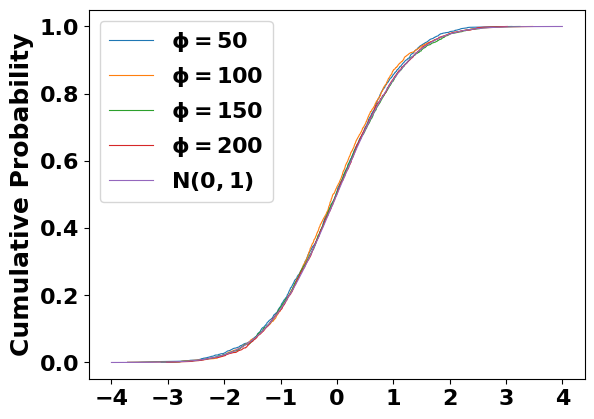

In [ ]:

n = 200
c = 3
R = 2000

def normalize_test_statistics2(test_statistics, n, c, r):
    return (test_statistics - (n * (1 + c**2 - 2 * c / r + 1 /r/r) + 1) * np.ones(np.size(test_statistics))) / np.sqrt(4 + 8 * c**2)

phi_values = [50, 100, 150, 200]
test_statistics = [TestST1, TestST2, TestST3, TestST4]
normalized_test_statistics = [normalize_test_statistics2(ts, n, c, np.sqrt(phi)) for ts, phi in zip(test_statistics, phi_values)]
labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]

plot_ecdf_and_standard_normal_cdf(*normalized_test_statistics, labels=labels)



### $T_3^g$

In practice, $-\log(x-\sqrt{\phi}-1/\sqrt{\phi}+t+1/t) +(x-\sqrt{\phi}-1/\sqrt{\phi}+t+1/t)$ is used, where $t=3$

#### Data generating

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np

R = 2000
n = 200
c = 3.3333333

def simulate_test_statistics3(phi, n, R, c):
    m = int(n * phi)
    center = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n)

    @jit
    def objective(X):
        H = jnp.matmul(jnp.transpose(X), X)
        E0 = jnp.linalg.eigh(H)[0]
        Eb = E0 - center
        return -jnp.sum(jnp.log(Eb)) + jnp.sum(Eb)

    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)

    for k in range(R):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))
        T = T.at[k].set(objective(X))

    return np.array(T)

TestST1 = simulate_test_statistics3(50,  n, R, c)
TestST2 = simulate_test_statistics3(100, n, R, c)
TestST3 = simulate_test_statistics3(150, n, R, c)
TestST4 = simulate_test_statistics3(200, n, R, c)

CPU times: user 33.1 s, sys: 1.8 s, total: 34.9 s
Wall time: 31.9 s


#### Saved data

In [ ]:
TestST1=[417.4674 , 418.1112 , 417.3877 , 415.98914 , 416.67792 , 416.19125 , 415.91284 , 415.97906 , 415.5722 , 417.67776 , 418.07434 , 417.97998 , 417.47614 , 418.2395 , 417.5722 , 418.34195 , 414.97165 , 417.7599 , 416.9048 , 418.00793 , 416.41766 , 415.938 , 418.6993 , 416.6169 , 417.30396 , 418.3818 , 417.02954 , 416.93295 , 416.7788 , 416.1942 , 416.1631 , 414.73218 , 417.36026 , 417.11627 , 415.99268 , 417.45544 , 416.93124 , 416.9801 , 416.80298 , 416.12094 , 417.94794 , 418.01227 , 415.6904 , 415.5098 , 417.25653 , 415.81018 , 415.59143 , 417.2929 , 415.9894 , 416.5814 , 417.04132 , 416.0641 , 415.8579 , 416.1843 , 418.04462 , 416.54242 , 416.8852 , 416.0891 , 417.7233 , 417.0454 , 418.36432 , 418.19345 , 416.95462 , 417.8604 , 416.17627 , 418.10492 , 416.6073 , 416.27405 , 415.39215 , 417.3031 , 415.8549 , 417.44568 , 415.7614 , 416.12854 , 415.875 , 419.08102 , 417.0642 , 416.3883 , 416.75284 , 415.65018 , 418.43207 , 417.16556 , 417.90015 , 417.2481 , 417.3651 , 417.4321 , 416.64313 , 416.44574 , 417.19025 , 416.3738 , 415.7533 , 417.36554 , 416.18863 , 417.13205 , 416.93625 , 415.2797 , 417.15228 , 418.43616 , 417.10263 , 417.288 , 417.60635 , 416.8958 , 417.07874 , 416.79584 , 417.88336 , 417.43475 , 415.87802 , 416.91864 , 413.70782 , 417.40524 , 415.80637 , 415.6569 , 417.27655 , 416.7784 , 417.56244 , 416.48718 , 416.05365 , 417.71756 , 416.17508 , 416.25555 , 418.10626 , 416.5186 , 416.62482 , 419.68964 , 417.5583 , 416.98367 , 416.30902 , 417.37482 , 417.85355 , 417.21875 , 416.84497 , 416.4065 , 415.12445 , 417.25504 , 416.65692 , 416.6294 , 417.12012 , 415.02722 , 416.24826 , 417.12094 , 417.5199 , 417.31085 , 416.2205 , 417.53833 , 415.7171 , 416.84912 , 414.9361 , 417.25525 , 415.7041 , 415.65323 , 417.0671 , 415.85724 , 417.0451 , 416.06482 , 417.15878 , 418.19382 , 416.96442 , 416.10706 , 416.31818 , 416.9719 , 416.17395 , 417.55307 , 416.13293 , 417.43015 , 416.4251 , 415.85355 , 418.68237 , 417.24103 , 416.90747 , 416.11 , 416.2601 , 415.4647 , 417.83374 , 418.99265 , 416.76715 , 418.09662 , 417.53876 , 416.71585 , 415.4311 , 417.6328 , 417.18738 , 417.0608 , 417.6382 , 416.09436 , 415.61053 , 417.0438 , 417.4334 , 417.36 , 417.88992 , 416.48132 , 416.58466 , 416.11978 , 417.578 , 418.1889 , 416.16873 , 417.44867 , 416.15778 , 417.24646 , 416.7472 , 417.24722 , 416.03772 , 416.65298 , 418.42334 , 415.93283 , 417.89035 , 417.89972 , 414.69217 , 417.29907 , 417.46222 , 414.98422 , 414.87207 , 417.23743 , 416.66284 , 416.10156 , 416.4413 , 416.86844 , 414.15103 , 416.77945 , 415.59207 , 416.83728 , 417.6192 , 415.4972 , 418.5595 , 418.77774 , 416.40277 , 416.70496 , 416.29233 , 415.6973 , 417.11847 , 415.06262 , 416.34097 , 417.60367 , 417.73608 , 416.32303 , 416.3119 , 417.12262 , 416.92078 , 416.50436 , 417.73303 , 418.42108 , 417.17554 , 416.8686 , 417.38953 , 416.16077 , 417.95926 , 416.1303 , 417.74847 , 418.87698 , 416.18207 , 417.153 , 414.74756 , 415.8682 , 415.98547 , 417.46716 , 415.0677 , 417.53748 , 416.33472 , 418.2318 , 414.53287 , 417.902 , 416.1962 , 418.9645 , 415.46048 , 417.221 , 417.48743 , 417.04803 , 416.45853 , 416.67108 , 417.02335 , 415.56067 , 417.0239 , 417.42374 , 416.61115 , 416.93082 , 415.81775 , 417.6336 , 415.9847 , 415.9804 , 414.81625 , 416.61508 , 416.53763 , 417.94598 , 417.26263 , 417.6475 , 416.58545 , 417.6529 , 416.9162 , 417.62286 , 417.05984 , 417.40674 , 415.8934 , 416.03195 , 418.31854 , 417.92847 , 416.43622 , 417.0022 , 414.86572 , 416.6227 , 417.0613 , 416.93878 , 416.61526 , 414.90256 , 416.91568 , 417.7732 , 417.2983 , 416.18317 , 416.8748 , 417.58185 , 416.23132 , 417.4935 , 417.9499 , 416.88617 , 416.91754 , 415.5891 , 417.3487 , 418.45752 , 416.98083 , 416.71368 , 417.1261 , 415.57184 , 417.49176 , 417.37302 , 417.34253 , 417.16467 , 417.15372 , 416.3603 , 416.5319 , 416.893 , 416.27158 , 416.53198 , 418.21774 , 414.43335 , 417.2134 , 415.7707 , 416.5622 , 417.3773 , 417.80234 , 416.76352 , 417.23938 , 417.01666 , 416.3102 , 416.71234 , 416.5699 , 417.1837 , 415.0033 , 418.08826 , 417.5716 , 417.18945 , 417.79663 , 417.12573 , 416.8233 , 415.97772 , 417.9152 , 417.16077 , 417.75604 , 418.30023 , 418.03217 , 416.51263 , 418.2807 , 415.94382 , 416.08154 , 416.52844 , 416.96268 , 416.24805 , 416.11523 , 416.73102 , 417.37003 , 417.31567 , 417.15167 , 416.65118 , 417.66415 , 416.67883 , 416.39664 , 416.863 , 417.07675 , 417.16818 , 416.41013 , 417.36807 , 416.88058 , 417.0093 , 416.70654 , 417.19495 , 416.86014 , 415.52258 , 418.86652 , 417.91815 , 416.84677 , 417.27435 , 415.67245 , 416.43478 , 416.6785 , 416.64685 , 416.17426 , 416.76428 , 415.90118 , 418.4087 , 418.80103 , 416.96896 , 417.12347 , 417.5619 , 416.24194 , 417.03683 , 417.19916 , 416.1679 , 417.09042 , 417.42792 , 416.5184 , 416.50458 , 416.75293 , 417.98917 , 418.89383 , 415.70477 , 416.9817 , 416.57516 , 417.5071 , 415.91083 , 416.6455 , 416.21716 , 416.13553 , 417.6866 , 415.39923 , 415.4975 , 417.5603 , 417.56198 , 417.5644 , 415.6471 , 415.08823 , 417.9779 , 417.76556 , 417.21823 , 416.83978 , 418.84836 , 416.26273 , 417.08624 , 417.66782 , 417.62616 , 416.39005 , 416.81012 , 415.49725 , 416.58942 , 416.91925 , 418.42053 , 414.6992 , 417.53574 , 418.00882 , 416.76514 , 418.24384 , 416.76456 , 417.27032 , 417.01193 , 416.35413 , 415.93246 , 416.50034 , 417.00766 , 418.08707 , 417.34274 , 415.0543 , 416.73132 , 417.16876 , 415.89996 , 416.685 , 416.93372 , 415.6892 , 418.65546 , 413.34717 , 418.04947 , 417.9311 , 416.87012 , 416.16583 , 418.2671 , 416.81183 , 417.0063 , 418.19745 , 417.18613 , 417.75482 , 418.4056 , 414.97913 , 416.43286 , 418.85583 , 416.10898 , 418.29633 , 417.30225 , 417.75595 , 417.60138 , 416.0333 , 416.16235 , 415.95728 , 417.81393 , 416.6044 , 415.46872 , 417.43127 , 418.88025 , 418.8824 , 417.1029 , 416.05518 , 417.33694 , 413.6811 , 416.77213 , 418.6062 , 417.58252 , 418.69144 , 418.39435 , 416.11874 , 418.2151 , 416.51166 , 418.06332 , 416.05902 , 417.3538 , 417.24945 , 418.09204 , 416.54828 , 417.11578 , 416.65265 , 414.85437 , 418.15552 , 414.49658 , 416.8497 , 416.29013 , 415.97263 , 414.86954 , 416.789 , 416.53226 , 417.12244 , 416.412 , 415.3293 , 415.9633 , 417.7614 , 417.43414 , 417.3579 , 417.45007 , 416.19205 , 418.67615 , 415.62744 , 417.75717 , 417.0418 , 417.35178 , 417.32745 , 416.27274 , 416.74323 , 416.20517 , 417.00415 , 416.22534 , 416.00333 , 417.2941 , 418.58154 , 416.79294 , 416.53183 , 416.8581 , 415.87262 , 417.1438 , 416.87622 , 416.04077 , 415.68372 , 416.43893 , 417.04013 , 417.2884 , 418.7364 , 417.81326 , 418.08276 , 415.74213 , 415.86496 , 417.2356 , 416.54175 , 415.69513 , 416.452 , 417.43573 , 416.60938 , 417.5408 , 417.78387 , 417.1659 , 416.85095 , 416.59766 , 415.2801 , 417.36847 , 418.0146 , 417.12042 , 417.36554 , 417.5804 , 416.6148 , 416.6198 , 417.03775 , 415.39667 , 417.9991 , 417.2801 , 416.55325 , 417.64795 , 417.01105 , 417.32245 , 417.84528 , 415.82602 , 417.3581 , 416.954 , 416.76813 , 416.70276 , 418.46786 , 415.938 , 418.02606 , 416.91876 , 417.6944 , 416.97064 , 417.15137 , 418.26266 , 417.77206 , 417.78064 , 417.578 , 417.7511 , 416.9356 , 417.53333 , 415.9878 , 417.17465 , 416.70312 , 417.7205 , 417.1263 , 417.26587 , 418.11572 , 418.83417 , 416.3648 , 416.3924 , 416.8708 , 417.6886 , 415.45312 , 417.42944 , 416.1195 , 416.80225 , 415.36343 , 415.43365 , 417.12863 , 416.43445 , 416.10507 , 415.633 , 417.7084 , 417.40866 , 416.3933 , 417.96524 , 416.46045 , 416.96643 , 417.57208 , 416.51813 , 417.4217 , 418.16476 , 416.98303 , 416.62207 , 416.0694 , 417.53314 , 415.16333 , 417.1699 , 416.4755 , 416.76276 , 416.9276 , 415.1162 , 416.97723 , 416.258 , 416.9008 , 417.3291 , 417.3982 , 416.04572 , 415.03717 , 417.3545 , 417.76044 , 416.67905 , 416.88312 , 418.2054 , 416.552 , 416.31577 , 417.56323 , 416.69232 , 416.48407 , 416.1028 , 416.77066 , 415.74475 , 415.16284 , 418.60907 , 417.51974 , 416.19403 , 416.03262 , 416.42316 , 415.96616 , 416.5037 , 416.86365 , 417.61642 , 417.13876 , 417.4961 , 417.90314 , 416.5144 , 416.38773 , 417.73743 , 418.30936 , 416.19415 , 417.50494 , 418.62448 , 416.32007 , 417.35358 , 417.4884 , 416.99637 , 416.65076 , 415.99756 , 415.94724 , 416.53796 , 415.65747 , 415.38254 , 416.9973 , 417.77533 , 416.28122 , 414.7138 , 416.2523 , 418.48813 , 417.12198 , 418.65692 , 417.58582 , 415.28772 , 416.14725 , 415.52612 , 417.94028 , 417.03247 , 417.34253 , 416.3938 , 418.09225 , 417.4948 , 416.64676 , 416.31998 , 418.42978 , 417.54822 , 415.9301 , 416.54272 , 417.57922 , 417.15823 , 416.7812 , 418.6511 , 415.04907 , 417.01172 , 414.79028 , 416.29483 , 417.59747 , 415.8958 , 417.26044 , 417.78473 , 417.5063 , 415.98456 , 418.39813 , 418.06635 , 416.7382 , 418.9394 , 416.82864 , 416.8036 , 417.07568 , 416.4322 , 418.7854 , 416.2926 , 414.92584 , 416.7442 , 417.1016 , 417.26053 , 416.99902 , 418.30896 , 415.3944 , 415.68896 , 416.03235 , 417.0303 , 417.7781 , 417.3694 , 417.9675 , 417.40546 , 416.46527 , 416.23328 , 416.9292 , 417.89597 , 416.1438 , 417.85507 , 415.99072 , 417.83627 , 416.9626 , 416.4879 , 416.9378 , 416.16705 , 417.21292 , 416.59814 , 417.58252 , 417.63977 , 416.53522 , 416.47723 , 415.84866 , 417.7209 , 417.4029 , 416.08173 , 417.78995 , 417.0625 , 416.64102 , 416.00906 , 417.05103 , 415.62695 , 418.08353 , 416.77942 , 415.1676 , 416.39282 , 416.55084 , 418.1276 , 416.03418 , 416.43878 , 416.62567 , 416.28748 , 416.74 , 415.09512 , 416.96542 , 416.82727 , 416.8811 , 416.90393 , 416.00397 , 416.41034 , 416.56863 , 417.95096 , 416.25186 , 416.51056 , 418.16992 , 415.79605 , 416.65717 , 415.0122 , 417.8942 , 415.1473 , 416.2826 , 416.4358 , 416.10718 , 416.58832 , 418.36865 , 417.99908 , 417.06677 , 415.51648 , 416.95667 , 416.28564 , 417.12036 , 416.92148 , 417.75018 , 417.19955 , 418.0233 , 418.294 , 416.77454 , 416.50543 , 416.1041 , 415.64215 , 415.6062 , 417.162 , 416.0075 , 416.6975 , 416.22433 , 417.30368 , 416.80817 , 416.74603 , 416.56494 , 418.1581 , 417.3986 , 417.6031 , 417.6665 , 416.49005 , 417.56476 , 415.63846 , 415.54883 , 416.1 , 415.93472 , 415.5138 , 416.50534 , 416.13428 , 415.7125 , 418.17593 , 419.24274 , 415.8935 , 417.41028 , 417.47028 , 416.2956 , 416.1672 , 417.09622 , 417.78925 , 417.95935 , 418.69885 , 417.74207 , 418.72797 , 415.5852 , 418.7122 , 418.02173 , 415.91666 , 415.64685 , 416.1815 , 418.18213 , 417.10355 , 417.49298 , 417.65097 , 415.90082 , 417.9301 , 418.36786 , 415.30847 , 416.61108 , 416.25278 , 417.2764 , 415.77924 , 417.3323 , 416.97476 , 417.1894 , 415.55502 , 416.01978 , 415.94382 , 417.6088 , 418.46716 , 416.96478 , 416.19153 , 416.2191 , 417.1776 , 416.3659 , 417.25296 , 417.08606 , 416.99557 , 415.72604 , 416.2176 , 416.76093 , 415.5142 , 416.09668 , 415.7692 , 417.12552 , 417.80328 , 417.50677 , 416.54688 , 416.0083 , 417.44373 , 416.65176 , 417.04626 , 415.5404 , 416.8929 , 417.96835 , 415.68243 , 416.84833 , 416.89178 , 415.64148 , 415.76797 , 416.26233 , 416.8646 , 414.5436 , 416.8103 , 416.21512 , 416.00958 , 416.7567 , 416.39368 , 415.6554 , 418.0761 , 414.94672 , 416.2674 , 415.7876 , 418.1666 , 417.42953 , 416.52744 , 417.99887 , 416.3723 , 416.09824 , 416.19464 , 416.00708 , 416.11987 , 415.8877 , 414.35886 , 415.2108 , 415.8923 , 417.78143 , 417.64084 , 417.0691 , 418.232 , 417.51224 , 416.69885 , 416.84802 , 417.49042 , 417.52362 , 417.75626 , 416.8247 , 416.65533 , 416.40958 , 415.7919 , 417.46033 , 417.25812 , 416.6542 , 415.73486 , 417.98065 , 416.70752 , 418.42 , 416.98694 , 418.15973 , 416.62994 , 416.9427 , 415.69824 , 417.659 , 415.47147 , 415.68347 , 417.49258 , 417.12704 , 419.2233 , 417.65277 , 417.26288 , 416.34814 , 417.61002 , 417.67416 , 417.44226 , 417.8134 , 416.31146 , 416.80603 , 417.12958 , 416.14874 , 416.61633 , 416.67752 , 416.1887 , 415.76 , 416.8496 , 418.68597 , 417.13135 , 416.41306 , 417.81592 , 417.06274 , 418.25433 , 416.88855 , 417.66824 , 416.27536 , 415.66675 , 416.94354 , 416.16504 , 416.62582 , 417.4021 , 415.7443 , 416.9024 , 416.60025 , 417.07367 , 416.4198 , 416.84073 , 416.9919 , 417.3357 , 418.36035 , 416.44263 , 416.83087 , 417.03564 , 416.071 , 415.0956 , 416.81326 , 416.76526 , 415.84186 , 416.43518 , 416.07028 , 417.0916 , 416.08542 , 416.6198 , 417.18927 , 417.33398 , 416.08997 , 416.55164 , 417.25955 , 415.51587 , 415.95294 , 415.7615 , 414.77933 , 416.34222 , 416.528 , 416.0784 , 417.58484 , 416.37546 , 416.84573 , 416.46756 , 417.55173 , 416.88483 , 417.02307 , 417.97693 , 416.71594 , 417.1833 , 418.52374 , 417.2997 , 417.69525 , 417.16653 , 418.70053 , 417.64297 , 417.4846 , 415.11423 , 417.1821 , 416.65356 , 416.63464 , 416.7049 , 417.1164 , 416.60806 , 418.22272 , 416.26624 , 418.06046 , 415.97488 , 415.00122 , 416.52246 , 415.77985 , 416.25964 , 417.04172 , 418.09436 , 415.4833 , 416.7694 , 415.80872 , 416.45383 , 416.73062 , 417.12085 , 416.42322 , 414.61386 , 417.64493 , 415.43738 , 416.4274 , 417.0291 , 415.4361 , 416.27277 , 416.94135 , 414.89966 , 417.59048 , 417.58765 , 415.40424 , 413.97775 , 417.97964 , 416.6425 , 415.2928 , 415.927 , 418.38257 , 416.8899 , 416.8263 , 415.2083 , 418.28894 , 418.0234 , 416.25876 , 416.8625 , 417.80823 , 417.50317 , 416.32678 , 417.2151 , 415.44232 , 415.77206 , 415.5342 , 417.4937 , 416.49747 , 417.09485 , 418.33014 , 416.22537 , 417.2367 , 417.38367 , 416.9674 , 415.54178 , 414.79395 , 416.02255 , 418.50446 , 416.80453 , 416.83972 , 418.46454 , 416.5213 , 413.7873 , 416.78668 , 417.91644 , 417.28958 , 415.66364 , 417.26984 , 416.0305 , 415.8162 , 416.4688 , 417.4419 , 417.29855 , 415.1354 , 417.75607 , 415.7266 , 417.4422 , 414.26526 , 418.28488 , 416.28622 , 416.28336 , 417.81506 , 416.3758 , 416.30786 , 417.43848 , 416.80884 , 416.76648 , 417.80664 , 417.2917 , 416.34888 , 416.82162 , 416.83682 , 418.30548 , 418.6908 , 417.33627 , 416.2198 , 416.39365 , 415.99133 , 415.1844 , 417.55716 , 417.39853 , 416.07285 , 417.13135 , 418.24744 , 416.0191 , 417.73187 , 415.98822 , 416.2822 , 417.03458 , 416.83972 , 416.68762 , 416.77582 , 417.7212 , 417.74097 , 416.46057 , 417.49915 , 417.5086 , 417.73175 , 417.14197 , 416.8877 , 415.50522 , 417.52982 , 417.5992 , 417.46997 , 417.38828 , 417.1018 , 416.71036 , 416.85217 , 415.72467 , 417.03802 , 417.29553 , 416.2733 , 414.83218 , 417.49826 , 418.5874 , 416.62106 , 417.95065 , 417.98346 , 416.12872 , 417.46057 , 416.76685 , 416.727 , 418.0175 , 417.52698 , 415.4771 , 416.69827 , 415.9508 , 415.8327 , 416.47107 , 416.60718 , 416.1399 , 416.7215 , 415.87775 , 417.85345 , 416.41608 , 416.4323 , 417.8723 , 418.02274 , 415.9429 , 415.96323 , 418.0003 , 418.0168 , 417.7292 , 417.71875 , 417.08917 , 416.8219 , 417.6119 , 418.15216 , 417.2751 , 415.88873 , 417.075 , 415.36942 , 415.95264 , 415.54083 , 416.37375 , 415.73517 , 417.54593 , 417.38702 , 415.8047 , 417.1853 , 417.97665 , 415.08102 , 415.13107 , 415.9248 , 415.45847 , 415.4353 , 416.97403 , 417.0467 , 418.25476 , 416.45737 , 416.72324 , 417.3626 , 417.41116 , 417.58887 , 418.1342 , 418.4395 , 415.59335 , 414.43915 , 416.5586 , 417.5896 , 417.06168 , 417.45978 , 416.10477 , 415.97284 , 416.9588 , 416.93048 , 415.3525 , 418.08228 , 416.30927 , 416.60703 , 417.19244 , 416.62274 , 416.3899 , 418.0597 , 416.21964 , 415.52707 , 417.3072 , 416.36743 , 415.08765 , 416.8675 , 417.7968 , 416.98828 , 415.28885 , 418.57654 , 418.10715 , 417.0624 , 416.35306 , 418.2721 , 416.8036 , 416.4373 , 419.51035 , 416.88757 , 417.81378 , 417.4504 , 418.26385 , 417.23166 , 416.1494 , 418.51257 , 418.20218 , 415.68524 , 419.10266 , 415.7851 , 418.1022 , 417.84225 , 418.47345 , 418.63647 , 417.42834 , 416.8833 , 416.54178 , 416.6612 , 416.33847 , 418.6855 , 414.29617 , 415.69574 , 415.9775 , 417.0984 , 415.53027 , 417.37384 , 417.36322 , 416.9676 , 415.0713 , 417.51797 , 418.31677 , 417.7931 , 417.40494 , 417.72842 , 418.39563 , 415.69012 , 416.70868 , 415.99387 , 416.0118 , 418.61963 , 415.8579 , 415.88428 , 416.61844 , 415.52637 , 416.83954 , 417.3365 , 417.9666 , 418.0133 , 417.30878 , 416.9299 , 417.06796 , 415.22568 , 416.11188 , 417.31577 , 417.1077 , 416.9567 , 417.2807 , 416.40573 , 417.3274 , 414.6898 , 416.55438 , 417.02878 , 416.29614 , 417.3436 , 417.12402 , 417.0373 , 417.18686 , 415.96603 , 416.74768 , 416.64816 , 417.19327 , 416.21335 , 414.8277 , 416.46786 , 416.93857 , 416.97226 , 417.08374 , 416.04193 , 415.56778 , 417.34613 , 417.03848 , 416.87756 , 418.9772 , 415.694 , 417.4986 , 419.00256 , 417.55722 , 417.4565 , 416.0763 , 415.8974 , 417.46045 , 416.4441 , 417.96655 , 416.94537 , 418.3434 , 417.17487 , 417.07492 , 417.8669 , 417.4546 , 417.35312 , 415.9945 , 416.2345 , 416.05505 , 417.26282 , 417.38507 , 417.12677 , 415.52386 , 416.72113 , 415.92987 , 416.9943 , 417.5066 , 416.4855 , 417.77408 , 417.35034 , 416.51495 , 418.14526 , 417.0371 , 416.84274 , 416.70862 , 416.0447 , 417.4187 , 417.20706 , 416.99078 , 416.16336 , 417.06766 , 415.99896 , 416.48352 , 416.95984 , 414.25708 , 416.30014 , 416.64554 , 416.6557 , 416.3999 , 415.03662 , 416.69 , 416.4492 , 416.1349 , 416.46884 , 418.71454 , 416.07245 , 416.30838 , 416.24765 , 417.82117 , 417.56567 , 416.59128 , 416.63757 , 418.17886 , 416.6013 , 416.38596 , 416.2143 , 416.8612 , 415.95996 , 416.94543 , 417.1053 , 416.64743 , 417.6449 , 416.47186 , 415.57965 , 417.6194 , 416.73413 , 415.87784 , 418.59503 , 417.4995 , 416.47336 , 416.9404 , 417.29327 , 417.5006 , 417.4204 , 416.31818 , 415.26132 , 417.28534 , 418.52222 , 415.63138 , 418.65634 , 417.2523 , 417.94604 , 416.45535 , 417.13123 , 414.523 , 416.67963 , 416.38843 , 415.96417 , 415.63348 , 416.87244 , 418.31494 , 417.53214 , 417.0205 , 415.6321 , 416.17657 , 415.91055 , 416.6742 , 417.21973 , 417.9404 , 417.37805 , 417.98407 , 417.18933 , 415.6011 , 416.93768 , 417.15497 , 417.00388 , 417.75024 , 415.0124 , 416.07516 , 415.47754 , 419.0412 , 417.94537 , 416.34802 , 417.6652 , 417.28674 , 417.66 , 416.79846 , 417.40842 , 418.30304 , 416.78122 , 418.40222 , 415.4424 , 417.0729 , 415.56528 , 416.2672 , 417.1089 , 417.71378 , 416.47992 , 417.01276 , 416.99698 , 417.7838 , 418.28412 , 417.08282 , 417.17853 , 415.73648 , 417.7116 , 417.77905 , 415.74835 , 417.70612 , 417.04846 , 415.6563 , 416.46 , 417.07452 , 415.07806 , 417.9173 , 414.68484 , 416.59937 , 416.88824 , 417.6197 , 416.6727 , 417.01395 , 418.37927 , 417.06177 , 417.1278 , 417.47113 , 416.69714 , 416.4314 , 418.3989 , 416.8211 , 419.03894 , 416.6469 , 417.93323 , 416.669 , 415.96448 , 417.1095 , 416.53632 , 416.2805 , 416.11 , 416.8617 , 417.6198 , 417.45126 , 418.41663 , 417.34277 , 416.97177 , 415.1759 , 417.85397 , 417.73093 , 416.1077 , 417.17572 , 416.6828 , 415.449 , 416.7979 , 417.4093 , 416.17618 , 416.77094 , 417.10535 , 417.01752 , 417.13123 , 415.8579 , 416.07587 , 417.2975 , 417.2103 , 418.68378 , 416.5477 , 417.2453 , 419.11578 , 417.92288 , 417.37762 , 416.5398 , 416.33142 , 414.8634 , 417.2655 , 417.5526 , 416.71747 , 414.8246 , 415.73834 , 415.35538 , 418.07712 , 414.7972 , 416.18954 , 417.1878 , 418.8104 , 417.13818 , 416.9331 , 417.1783 , 415.68646 , 415.92926 , 418.26743 , 418.3733 , 417.7245 , 414.96027 , 415.8426 , 418.653 , 416.30725 , 417.60788 , 415.9322 , 416.7324 , 415.1233 , 416.58032 , 417.18115 , 415.30347 , 418.75632 , 417.17026 , 417.80157 , 417.69766 , 415.26892 , 418.40472 , 416.465 , 417.6705 , 417.81787 , 416.90567 , 417.21265 , 418.64404 , 416.84894 , 417.60376 , 416.6418 , 417.4915 , 417.5111 , 417.41013 , 419.70926 , 417.0916 , 417.50055 , 418.92593 , 417.2433 , 417.07812 , 416.2528 , 419.18707 , 415.77365 , 415.9715 , 417.40872 , 417.36652 , 418.26312 , 417.37665 , 417.99493 , 415.44806 , 417.99277 , 417.023 , 416.0669 , 418.30765 , 415.95496 , 416.5833 , 415.7975 , 416.96527 , 417.96436 , 416.70212 , 415.8096 , 417.12796 , 414.883 , 415.89062 , 416.48666 , 416.5476 , 414.60904 , 416.9175 , 415.98206 , 417.6607 , 417.74573 , 416.40683 , 416.49838 , 416.2221 , 416.8509 , 415.49768 , 419.3816 , 416.57642 , 417.54236 , 416.35052 , 417.2965 , 416.51047 , 417.0564 , 416.27512 , 416.29846 , 416.24603 , 417.44315 , 416.73566 , 415.1596 , 416.57715 , 417.388 , 415.72107 , 415.307 , 418.1776 , 416.0731 , 417.4088 , 416.67783 , 417.22107 , 417.75043 , 416.92584 , 414.90103 , 417.11227 , 416.67807 , 417.591 , 417.31372 , 417.42227 , 415.30826 , 417.7531 , 416.8482 , 418.13174 , 416.67084 , 415.45688 , 416.6595 , 415.50394 , 418.3498 , 415.8197 , 416.58408 , 418.8849 , 417.9628 , 416.4579 , 418.6098 , 416.24347 , 418.03616 , 415.4382 , 414.47266 , 417.03802 , 415.70224 , 415.5337 , 415.12482 , 415.4925 , 418.39932 , 416.54065 , 417.18103 , 416.1234 , 416.8098 , 416.01923 , 418.32742 , 416.53577 , 418.1328 , 416.70203 , 417.49957 , 416.97064 , 415.04587 , 417.2732 , 415.52103 , 416.22723 , 417.18927 , 418.55435 , 415.59875 , 416.28006 , 416.57086 , 415.5347 , 416.9198 , 417.46445 , 416.52557 , 417.45865 , 417.0744 , 415.8215 , 417.86377 , 417.0832 , 415.96198 , 417.87067 , 417.06793 , 415.42584 , 416.4491 , 416.74716 , 417.91574 , 418.15088 , 416.61392 , 416.30704 , 417.35336 , 417.4278 , 418.35532 , 417.2442 , 415.35852 , 415.7145 , 417.60004 , 416.80466 , 416.2581 , 415.89755 , 418.10205 , 415.1112 , 416.88068 , 415.96167 , 416.4701 , 416.74567 , 416.16708 , 415.7907 , 415.85852 , 416.7859 , 416.44513 , 417.86182 , 417.78357 , 418.0707 , 415.64594 , 417.8191 , 416.15616 , 416.37674 , 417.8949 , 415.72684 , 418.17084 , 417.21878 , 417.52063 , 416.66348 , 416.2641 , 416.80243 , 418.04916 , 418.6336 , 414.71408 , 417.5578 , 417.06662 , 416.97687 , 416.74265 , 417.9968 , 416.47836 , 415.0265 , 416.16376 , 416.73044 , 417.53348 , 416.23132 , 416.71854 , 416.06793 , 417.5974 , 417.758 , 416.14862 , 417.35425 , 417.52478 , 415.56952 , 416.81842 , 417.76254 , 417.5514 , 418.7601 , 417.01016 , 416.4022 , 417.51938 , 416.2966 , 416.02847 , 415.969 , 417.4809 , 416.3825 , 416.32605 , 417.187 , 416.60437 , 417.08237 , 416.1434 , 416.55807 , 417.37372 , 418.3929 , 416.84732 , 415.93372 , 414.13086 , 416.89722 , 418.4523 , 416.55685 , 417.03885 , 416.35614 , 417.9931 , 416.67834 , 416.40234 , 416.02695 , 415.8911 , 416.1181 , 418.0877 , 415.61502 , 416.77017 , 414.75873 , 417.76575 , 416.31607 , 416.4077 , 415.57922 , 415.42508 , 415.7611 , 417.6256 , 415.24884 , 416.80792 , 417.58295 , 417.9231 , 415.39987 , 416.57715 , 417.5621 , 416.71545 , 415.90924 , 418.21027 , 417.84033 , 416.87527 , 416.3307 , 416.69687 , 416.6032 , 416.22675 , 414.47775 , 417.94543 , 417.82452 , 416.20587 , 417.66043 , 417.6167 , 417.31903 , 417.89807 , 415.62897 , 417.8376 , 417.7511 , 417.5196 , 416.16672 , 417.95184 , 417.84158 , 418.88132 , 415.70792 , 417.1336 , 416.84964 , 417.73798 , 416.58542 , 418.51385 , 417.37704 , 418.0619 , 416.8684 , 416.7485 , 416.32202 , 414.36096 , 417.29224 , 416.13904 , 417.67297 , 417.4394 , 416.87476 , 417.86932 , 414.50128 , 417.31506 , 416.47733 , 417.61578 , 417.99158 , 416.71674 , 416.0287 , 416.32315 , 417.1864 , 417.56808 , 417.10632 , 416.98764 , 416.93512 , 416.18735 , 415.95407 , 416.83228 , 417.40506 , 417.6831 , 416.43396 , 416.91278 , 417.38458 , 416.48502 , 418.61096 , 417.33643 , 416.6489 , 416.83517 , 416.145 , 417.99292 , 417.74664 , 417.6704 , 415.60153 , 415.13702 , 415.20398 , 415.5805 , 416.94843 , 417.62 , 416.8756 , 416.94016 , 415.72928 , 417.12213 , 416.0263 , 417.63278 , 417.8244 , 417.1426 , 417.3483 , 416.94592 , 417.6957 , 417.4678 , 417.46368 , 416.4562 , 416.80487 , 417.4746 , 416.16513 , 415.77957 , 416.7069 , 416.3861 , 416.7096]

In [ ]:
TestST2=[423.44843 , 420.47174 , 424.34247 , 422.0464 , 422.95557 , 421.99774 , 421.1726 , 423.15674 , 422.32056 , 423.5886 , 421.35065 , 421.65094 , 424.04376 , 421.34024 , 423.0838 , 421.6648 , 422.13892 , 421.9112 , 422.33438 , 424.11954 , 422.51672 , 420.83264 , 423.4237 , 423.20596 , 422.76703 , 422.32294 , 421.74997 , 422.0556 , 423.2045 , 422.6459 , 423.22852 , 422.53314 , 423.30682 , 421.88876 , 421.9001 , 421.90616 , 422.38712 , 421.53787 , 423.4945 , 421.77423 , 420.68533 , 423.4703 , 421.69452 , 421.12595 , 421.9682 , 422.9608 , 422.62717 , 421.19037 , 421.12177 , 423.168 , 422.02847 , 423.50757 , 421.53 , 421.4449 , 422.3487 , 423.5212 , 422.84937 , 422.75446 , 422.52185 , 422.02832 , 423.04422 , 422.59003 , 423.25305 , 420.4749 , 422.29846 , 422.34216 , 421.8986 , 421.9351 , 422.33752 , 423.8589 , 422.97717 , 423.78897 , 422.9033 , 423.2046 , 422.94748 , 423.3281 , 421.9927 , 421.85663 , 421.26202 , 421.81873 , 423.01053 , 422.15787 , 421.7755 , 420.35245 , 422.3261 , 422.50647 , 422.73343 , 423.5335 , 421.68628 , 423.33752 , 422.42224 , 424.41425 , 422.6915 , 423.36987 , 423.17957 , 421.86343 , 421.5829 , 423.32806 , 421.8622 , 421.65466 , 421.70782 , 422.6162 , 421.38132 , 422.98187 , 421.82776 , 422.18854 , 421.75314 , 424.04364 , 421.1767 , 421.84348 , 420.66815 , 420.73593 , 422.63348 , 420.8584 , 422.89972 , 421.68958 , 423.20956 , 422.61624 , 423.04095 , 421.72574 , 422.4168 , 421.43872 , 421.8145 , 422.48764 , 421.53473 , 422.89212 , 422.09656 , 421.82196 , 423.33905 , 422.621 , 421.3883 , 421.0512 , 422.7343 , 421.93396 , 422.31418 , 421.92184 , 421.46713 , 421.7301 , 421.83472 , 422.38165 , 423.69025 , 422.6911 , 424.40356 , 420.86533 , 423.53122 , 421.52042 , 422.79437 , 421.35773 , 421.48297 , 423.39917 , 424.21848 , 422.8955 , 421.81894 , 422.9895 , 424.02972 , 422.79825 , 420.69437 , 423.896 , 419.9457 , 421.86566 , 424.0963 , 422.6732 , 421.28827 , 421.328 , 421.8708 , 422.16818 , 421.9026 , 424.42242 , 422.5275 , 422.41397 , 424.66742 , 423.24734 , 422.19202 , 422.26794 , 421.40125 , 422.8119 , 422.39423 , 423.21317 , 423.84415 , 423.15033 , 422.73505 , 422.6834 , 421.60358 , 422.37878 , 421.26874 , 422.7057 , 422.5758 , 421.90118 , 422.33398 , 421.40634 , 422.31863 , 423.38763 , 419.33917 , 422.40872 , 421.66174 , 421.61957 , 423.8593 , 423.9409 , 422.57562 , 423.1067 , 421.12994 , 423.25134 , 421.96692 , 420.96375 , 423.4402 , 422.0318 , 421.71228 , 423.6891 , 421.49347 , 421.86087 , 422.4352 , 422.5409 , 423.70807 , 420.41318 , 422.63638 , 423.16757 , 421.8378 , 423.046 , 420.96918 , 421.40823 , 423.0177 , 421.99652 , 423.38156 , 421.7217 , 421.36957 , 422.53943 , 422.029 , 422.77307 , 420.9845 , 423.38858 , 420.8899 , 422.08344 , 422.94226 , 422.40033 , 423.2697 , 423.27704 , 424.07303 , 422.3456 , 421.50983 , 423.31943 , 423.3081 , 421.4234 , 422.4737 , 420.6282 , 423.1868 , 422.3359 , 421.35397 , 422.2981 , 421.5407 , 421.06995 , 421.18323 , 423.12888 , 423.4066 , 420.5661 , 423.79437 , 422.32413 , 422.20624 , 422.98615 , 422.36102 , 422.15143 , 423.5346 , 419.9934 , 422.23898 , 423.40198 , 422.98254 , 422.6464 , 423.14246 , 421.62823 , 421.8224 , 420.8088 , 422.42514 , 421.91916 , 421.69897 , 420.7148 , 424.0404 , 423.07407 , 421.7868 , 422.51184 , 421.70355 , 421.6996 , 421.06134 , 422.10785 , 422.25613 , 421.88837 , 423.2657 , 422.32303 , 421.88165 , 423.01654 , 422.52917 , 422.17282 , 423.17572 , 421.5596 , 424.44058 , 422.7318 , 421.72473 , 421.1081 , 422.14893 , 421.4235 , 421.8286 , 422.19913 , 423.27505 , 422.90872 , 421.6896 , 421.94843 , 423.1272 , 422.99246 , 420.52454 , 421.31406 , 422.9646 , 422.31116 , 422.5589 , 422.32138 , 423.17194 , 423.82336 , 424.09802 , 421.7221 , 422.04712 , 425.6041 , 421.51852 , 421.27832 , 422.32855 , 424.26825 , 421.56653 , 423.5039 , 422.13312 , 420.54657 , 422.6458 , 422.79556 , 420.54462 , 421.99377 , 421.2663 , 422.16022 , 421.00922 , 421.9093 , 420.63696 , 422.01782 , 422.73956 , 420.47678 , 422.00714 , 421.81143 , 421.1467 , 423.53058 , 423.06375 , 421.8927 , 424.4488 , 423.50446 , 421.48102 , 423.22098 , 421.62848 , 421.80267 , 421.85083 , 418.95892 , 422.17484 , 422.77173 , 423.68478 , 423.45157 , 422.06192 , 421.5088 , 421.88553 , 422.01294 , 422.53894 , 422.40076 , 422.09106 , 421.5238 , 422.16052 , 422.2696 , 422.97482 , 421.6269 , 423.69525 , 422.17606 , 422.27466 , 421.3086 , 421.59998 , 422.75717 , 423.01727 , 423.84378 , 423.7567 , 422.06592 , 420.43262 , 421.8153 , 421.78134 , 422.5377 , 423.1364 , 422.13586 , 422.61456 , 422.4969 , 422.82516 , 422.7437 , 421.5787 , 420.38257 , 423.08136 , 422.2475 , 422.502 , 420.86218 , 422.28964 , 421.7764 , 422.4413 , 422.26904 , 422.52255 , 423.0443 , 422.94443 , 421.59784 , 422.9187 , 421.92993 , 421.5 , 422.78717 , 421.4644 , 420.96616 , 421.02325 , 422.66187 , 423.84482 , 421.77338 , 422.49677 , 422.40454 , 422.3951 , 421.8603 , 423.88263 , 422.20267 , 422.74475 , 421.89044 , 423.93387 , 420.70157 , 421.28937 , 422.85306 , 423.23938 , 421.81958 , 422.2766 , 422.40515 , 421.97882 , 423.12952 , 424.51093 , 423.13745 , 424.23602 , 422.74167 , 421.10858 , 422.36526 , 422.95206 , 421.80634 , 421.57547 , 420.64108 , 423.0689 , 423.1704 , 421.21783 , 421.59674 , 422.0526 , 421.7733 , 423.78217 , 422.63373 , 423.54166 , 423.06662 , 423.22696 , 422.5969 , 424.16687 , 423.52548 , 420.86017 , 422.01776 , 422.50394 , 420.91653 , 422.06308 , 420.78812 , 422.76703 , 423.7606 , 421.57407 , 420.88367 , 423.77127 , 421.56326 , 420.5224 , 422.78467 , 421.71942 , 422.98517 , 421.91034 , 422.05362 , 422.58496 , 422.34402 , 422.97522 , 421.0531 , 422.32706 , 423.2223 , 422.25116 , 422.70486 , 424.66483 , 422.74048 , 422.37897 , 421.26968 , 422.05 , 421.731 , 422.98724 , 423.14673 , 423.4259 , 421.7881 , 423.50394 , 422.1198 , 421.63812 , 420.90424 , 421.34528 , 422.17783 , 421.9624 , 422.81647 , 423.43884 , 423.5848 , 421.92896 , 420.95178 , 422.60864 , 422.498 , 422.06393 , 420.54388 , 422.64124 , 421.1471 , 423.94843 , 421.93585 , 422.55365 , 423.3778 , 422.87357 , 422.017 , 421.73276 , 423.0037 , 422.15753 , 421.00842 , 422.39786 , 423.52002 , 421.0195 , 421.73877 , 421.44238 , 423.32257 , 422.22565 , 422.4773 , 422.21167 , 423.09836 , 423.68887 , 422.17383 , 424.1398 , 422.19382 , 421.19907 , 421.26276 , 421.20837 , 420.97824 , 421.5903 , 421.3886 , 421.59982 , 423.19424 , 422.3708 , 423.45184 , 423.05267 , 421.92087 , 421.4973 , 422.1334 , 425.14606 , 421.9427 , 422.9025 , 421.863 , 420.98267 , 421.67398 , 421.65277 , 423.4546 , 421.92828 , 420.6172 , 422.79462 , 421.83252 , 421.70145 , 422.64935 , 422.22992 , 422.6474 , 422.54056 , 421.7918 , 421.66974 , 422.60217 , 422.08563 , 423.16602 , 421.66534 , 421.76132 , 421.29227 , 421.79675 , 424.44965 , 422.58203 , 424.0178 , 421.1972 , 421.63547 , 421.15796 , 423.12613 , 421.7652 , 421.96716 , 422.9289 , 424.1921 , 421.62305 , 423.49496 , 422.59906 , 421.8836 , 421.19604 , 421.88458 , 422.55533 , 424.83026 , 423.0844 , 424.51855 , 421.82248 , 422.96783 , 423.10413 , 423.2737 , 422.62363 , 421.44986 , 423.06903 , 420.93378 , 424.16177 , 422.68994 , 423.20697 , 422.08264 , 423.5269 , 422.64453 , 420.81723 , 423.7751 , 423.87537 , 422.59656 , 422.597 , 424.16217 , 422.02124 , 422.25775 , 421.2927 , 422.61948 , 423.64423 , 422.7471 , 421.84137 , 422.07385 , 422.7549 , 422.45117 , 423.43613 , 422.019 , 420.7438 , 421.10007 , 422.2678 , 423.13184 , 422.41675 , 422.44672 , 423.83478 , 423.0289 , 423.1081 , 421.66132 , 421.93707 , 423.28436 , 422.52515 , 421.51196 , 422.72498 , 421.73932 , 420.47736 , 421.62906 , 423.0187 , 421.60376 , 422.47736 , 422.4443 , 421.96 , 424.65784 , 422.95956 , 423.07373 , 423.9931 , 422.59024 , 421.74664 , 422.50714 , 421.1494 , 422.60834 , 422.96027 , 422.6502 , 421.683 , 423.33334 , 421.13535 , 424.24292 , 422.33826 , 421.43896 , 422.1761 , 423.0478 , 423.82428 , 422.54175 , 421.63873 , 422.63315 , 422.35095 , 423.08185 , 422.32623 , 422.78442 , 422.037 , 422.0196 , 421.46063 , 422.50296 , 422.1408 , 422.31647 , 422.9797 , 420.57523 , 423.09518 , 423.01276 , 422.56506 , 422.4235 , 422.2687 , 422.82562 , 422.81744 , 421.61273 , 421.3235 , 421.64807 , 421.23315 , 422.09317 , 420.9682 , 422.87628 , 421.3708 , 421.1432 , 423.71777 , 422.68948 , 421.87997 , 422.98145 , 423.09317 , 423.66684 , 422.1922 , 422.61414 , 422.18253 , 423.87778 , 422.26624 , 423.37045 , 421.61853 , 422.45416 , 422.3888 , 423.3518 , 423.72363 , 423.33893 , 423.16772 , 422.63483 , 421.4439 , 422.7742 , 422.22433 , 421.69556 , 423.60876 , 422.9635 , 423.32648 , 422.7895 , 422.0912 , 421.89328 , 420.4804 , 423.15222 , 422.50543 , 423.20273 , 422.2885 , 422.72186 , 422.2135 , 422.73242 , 423.6182 , 422.45312 , 422.9795 , 424.01062 , 424.61133 , 421.0744 , 421.46976 , 424.32385 , 421.17838 , 422.52994 , 422.7516 , 423.09985 , 422.54434 , 421.30472 , 423.37256 , 420.92163 , 422.341 , 423.56848 , 422.03796 , 422.35486 , 424.0063 , 422.9653 , 422.63367 , 423.67017 , 422.1782 , 422.34976 , 422.8724 , 422.1937 , 422.11697 , 421.09485 , 422.38983 , 422.94214 , 422.15613 , 423.12885 , 422.26495 , 422.59174 , 422.0273 , 421.8733 , 421.55066 , 422.2895 , 421.54248 , 422.76324 , 423.3111 , 421.2747 , 421.81982 , 422.3405 , 422.68646 , 422.5426 , 421.66193 , 420.97696 , 421.53552 , 422.74408 , 423.1758 , 422.90808 , 423.12787 , 422.29324 , 422.3375 , 421.23062 , 422.71674 , 423.39374 , 422.95172 , 420.52112 , 422.32242 , 420.6447 , 422.94116 , 422.9171 , 421.99542 , 422.11298 , 422.9098 , 422.12918 , 421.8102 , 422.94873 , 421.5309 , 422.0519 , 421.8886 , 422.3538 , 422.78677 , 423.474 , 422.91376 , 421.91376 , 421.80664 , 424.72528 , 422.8229 , 422.75415 , 421.92926 , 424.52588 , 422.75385 , 421.91278 , 421.57727 , 422.32318 , 422.9151 , 423.2438 , 423.96198 , 422.70346 , 423.1008 , 423.9234 , 422.4371 , 421.7872 , 421.08914 , 421.88733 , 421.51215 , 422.66486 , 424.19797 , 422.62234 , 423.14633 , 423.7033 , 423.13895 , 422.5155 , 423.17328 , 422.55548 , 423.47464 , 419.8523 , 422.61057 , 423.53668 , 422.74487 , 421.50006 , 422.79315 , 421.36682 , 420.4604 , 422.16568 , 421.93018 , 422.6152 , 422.37445 , 422.8611 , 422.36365 , 420.8437 , 420.723 , 422.5219 , 421.16077 , 422.57324 , 421.7796 , 423.25336 , 422.10968 , 422.07794 , 423.4074 , 420.92633 , 421.22614 , 422.28247 , 422.28284 , 423.10962 , 421.0655 , 421.82654 , 421.32788 , 420.7152 , 422.46515 , 422.51965 , 422.2859 , 422.51086 , 422.84955 , 423.31842 , 421.75128 , 422.47375 , 422.14838 , 422.63745 , 422.719 , 419.6333 , 421.8618 , 420.99268 , 422.50183 , 421.57675 , 422.70447 , 422.58957 , 422.9524 , 422.0409 , 423.91818 , 421.7989 , 422.45267 , 420.93127 , 423.09186 , 421.8252 , 423.28445 , 422.1107 , 421.98566 , 421.68063 , 422.59726 , 423.607 , 422.35345 , 421.96878 , 421.05078 , 421.9851 , 422.90338 , 422.97794 , 422.7602 , 421.22668 , 423.50253 , 419.896 , 421.77863 , 423.07294 , 423.31473 , 421.24426 , 422.53143 , 422.81735 , 421.43146 , 422.1978 , 422.3332 , 421.94043 , 421.56915 , 421.07962 , 422.21463 , 422.36212 , 422.06564 , 422.0595 , 421.47803 , 422.55298 , 421.245 , 421.85406 , 422.10907 , 421.9793 , 420.83313 , 421.39758 , 421.77356 , 420.5002 , 421.51324 , 422.41818 , 422.6526 , 422.01166 , 421.93652 , 421.13254 , 421.52072 , 424.09766 , 422.00983 , 422.26047 , 423.5753 , 421.55853 , 422.714 , 422.79565 , 423.95752 , 423.65387 , 422.91647 , 422.7763 , 422.6496 , 422.08838 , 421.3732 , 419.81775 , 422.73315 , 422.98138 , 422.52274 , 422.53848 , 422.61212 , 422.3315 , 421.53464 , 422.2445 , 421.5401 , 422.833 , 423.1657 , 420.97577 , 422.57837 , 422.40985 , 421.86795 , 422.7624 , 422.12164 , 422.4745 , 422.27536 , 421.05698 , 421.48523 , 423.72665 , 422.90622 , 422.82275 , 423.75116 , 423.77637 , 422.9309 , 422.8334 , 423.41513 , 421.50632 , 423.02267 , 422.17374 , 423.25458 , 421.83182 , 422.4676 , 421.50397 , 423.18 , 421.63818 , 420.55963 , 423.70032 , 421.42657 , 423.94907 , 422.89676 , 422.57312 , 422.87674 , 422.9159 , 421.92438 , 420.44794 , 423.24097 , 423.14746 , 422.67694 , 423.41266 , 422.81723 , 424.52423 , 422.3093 , 423.56833 , 421.3587 , 421.104 , 422.8062 , 422.59213 , 422.37946 , 422.31833 , 423.06937 , 422.75284 , 423.42255 , 422.96353 , 423.0102 , 424.2276 , 422.29565 , 423.0575 , 423.38516 , 423.0031 , 422.39978 , 422.01306 , 421.8734 , 422.9475 , 421.3723 , 421.75687 , 424.15497 , 422.82394 , 423.53122 , 423.59232 , 422.1288 , 421.66467 , 422.39716 , 421.7018 , 421.20926 , 422.43674 , 422.15625 , 422.64124 , 422.4663 , 423.8952 , 422.50903 , 422.74774 , 422.13626 , 423.96286 , 422.28418 , 421.70947 , 421.81976 , 422.01346 , 422.14325 , 421.87625 , 422.24234 , 422.2578 , 422.5111 , 423.45728 , 421.81525 , 422.599 , 422.42612 , 423.46182 , 422.2328 , 421.3283 , 424.0341 , 420.88812 , 422.6794 , 421.46582 , 421.82916 , 421.87506 , 423.08105 , 421.6411 , 423.01105 , 423.0731 , 423.9568 , 421.44617 , 422.2604 , 421.35046 , 421.39923 , 421.5905 , 422.05258 , 421.8581 , 420.50037 , 422.38312 , 421.71942 , 421.88248 , 420.87238 , 422.3096 , 421.59375 , 422.39362 , 423.05615 , 422.9187 , 423.00986 , 422.9001 , 422.69974 , 423.36835 , 422.58713 , 421.59415 , 421.3559 , 420.4193 , 423.1762 , 421.52487 , 423.64307 , 421.76154 , 422.70648 , 421.24146 , 421.8656 , 422.83002 , 422.3574 , 421.7085 , 421.47107 , 424.099 , 422.8781 , 421.28613 , 421.7811 , 421.40616 , 424.89172 , 423.32007 , 423.40808 , 421.93518 , 422.64575 , 423.41077 , 423.82025 , 422.55487 , 423.71332 , 422.59836 , 422.21906 , 421.5998 , 422.40814 , 422.52435 , 421.7528 , 423.04004 , 421.76065 , 423.567 , 422.4383 , 422.4545 , 420.79822 , 421.7575 , 422.76862 , 422.35577 , 422.23996 , 421.3115 , 422.31467 , 422.1037 , 422.7366 , 424.22208 , 423.1857 , 422.19125 , 421.31616 , 422.9648 , 422.04816 , 421.4853 , 422.41998 , 422.86996 , 423.02835 , 422.19348 , 421.966 , 422.8271 , 421.2143 , 420.55762 , 424.16034 , 421.99142 , 421.90717 , 421.76904 , 421.97147 , 421.3443 , 422.45184 , 421.13583 , 424.15753 , 423.49982 , 421.52625 , 422.64526 , 421.06558 , 421.93146 , 423.4678 , 421.84717 , 421.94403 , 421.641 , 420.42725 , 424.67392 , 422.8932 , 422.27795 , 421.5267 , 422.89355 , 419.87347 , 421.3996 , 422.08243 , 421.56476 , 422.82343 , 422.233 , 422.5839 , 423.0213 , 422.2756 , 421.7965 , 422.07837 , 419.96442 , 422.54572 , 424.01166 , 421.8409 , 421.762 , 423.93347 , 422.28 , 422.60892 , 423.37485 , 422.34686 , 420.48358 , 422.23126 , 422.2797 , 422.29172 , 421.76587 , 423.76593 , 421.43762 , 422.72882 , 421.85812 , 423.03778 , 421.5093 , 421.93018 , 422.10913 , 423.58112 , 421.3296 , 421.81223 , 424.1072 , 422.52963 , 421.32904 , 422.57065 , 421.2937 , 422.303 , 423.11514 , 421.0255 , 422.1507 , 421.30524 , 422.36728 , 421.4161 , 423.78217 , 421.17178 , 422.17706 , 423.37616 , 420.96155 , 423.18823 , 420.9484 , 422.79623 , 422.62668 , 423.71887 , 423.5929 , 420.99725 , 421.7473 , 422.97754 , 422.256 , 419.99457 , 423.90543 , 423.23883 , 421.01416 , 421.82956 , 423.34802 , 420.89996 , 421.46896 , 422.19434 , 422.5061 , 423.80786 , 422.37723 , 422.67676 , 422.0317 , 423.27112 , 422.0736 , 423.2243 , 424.5288 , 422.6608 , 422.53033 , 421.77234 , 421.3121 , 422.91232 , 423.7063 , 423.01587 , 421.58936 , 423.33002 , 421.92206 , 424.3393 , 422.96274 , 422.4286 , 423.46262 , 422.01678 , 422.25195 , 420.6358 , 424.09125 , 422.24646 , 421.94006 , 422.66458 , 421.32214 , 421.22556 , 420.90384 , 423.05334 , 421.90308 , 420.86447 , 422.65332 , 420.36563 , 423.28265 , 421.85046 , 422.06323 , 423.7096 , 420.621 , 423.7718 , 422.0434 , 422.01447 , 422.63977 , 422.4505 , 421.75146 , 420.35538 , 421.495 , 422.06113 , 423.3869 , 423.07053 , 421.4683 , 421.6068 , 421.44714 , 421.29413 , 421.84256 , 421.19012 , 422.0398 , 421.19055 , 421.8854 , 422.3311 , 422.8034 , 423.1733 , 422.0231 , 421.9605 , 423.35828 , 421.39673 , 421.50974 , 422.2776 , 422.35422 , 423.91772 , 422.77618 , 421.96695 , 422.83038 , 423.59482 , 424.58246 , 420.92178 , 423.48425 , 421.37802 , 423.24738 , 422.56036 , 422.73694 , 421.69147 , 423.15576 , 421.7854 , 421.96838 , 423.80307 , 421.05353 , 421.8999 , 421.05557 , 421.11942 , 421.66742 , 420.7705 , 421.64288 , 421.37686 , 419.77875 , 422.65994 , 423.3474 , 422.61383 , 422.28967 , 425.1211 , 423.41614 , 422.5393 , 422.44437 , 422.6902 , 422.44183 , 422.4262 , 423.4344 , 422.33035 , 421.935 , 423.20422 , 422.05292 , 422.76584 , 422.53204 , 424.32843 , 420.80054 , 422.48663 , 422.1529 , 422.8069 , 423.14227 , 421.26047 , 421.23886 , 421.60773 , 420.33563 , 422.41226 , 421.79883 , 422.28003 , 421.39276 , 422.15765 , 423.0192 , 421.50986 , 422.13162 , 422.3562 , 423.2791 , 421.74722 , 423.56354 , 425.05847 , 423.31454 , 424.30276 , 422.0177 , 422.55206 , 421.83182 , 424.05304 , 423.18817 , 421.79782 , 422.3892 , 422.84567 , 422.50922 , 422.77032 , 423.46024 , 423.33136 , 421.14142 , 421.8617 , 420.5573 , 421.64777 , 423.44977 , 421.8996 , 423.61847 , 424.72836 , 421.59177 , 424.3612 , 420.81366 , 422.77216 , 421.09402 , 423.08716 , 423.00293 , 422.669 , 422.41983 , 422.95093 , 422.70862 , 422.6952 , 422.0695 , 424.18793 , 422.53534 , 424.4474 , 422.37643 , 421.29123 , 424.20517 , 420.8378 , 421.52832 , 423.19492 , 423.0501 , 421.54578 , 422.84042 , 422.13535 , 421.88483 , 421.47678 , 422.67548 , 422.97156 , 423.51407 , 422.37726 , 423.01923 , 421.8788 , 421.6059 , 421.56396 , 423.33392 , 422.1341 , 421.0842 , 422.40778 , 421.8775 , 421.16306 , 421.12103 , 421.81604 , 421.52246 , 421.1347 , 421.91284 , 422.2904 , 420.94028 , 422.2607 , 422.87164 , 424.72995 , 421.2155 , 425.65042 , 422.27026 , 422.90045 , 421.51514 , 421.7827 , 423.5766 , 424.4024 , 422.8325 , 421.33078 , 422.44162 , 421.88248 , 421.00226 , 422.63348 , 422.19498 , 422.11044 , 423.09125 , 422.57562 , 421.06403 , 422.80435 , 423.0185 , 422.1345 , 421.6142 , 422.17065 , 422.40424 , 423.58786 , 422.1986 , 423.21817 , 422.7929 , 422.0996 , 421.35876 , 422.86462 , 423.39127 , 421.6684 , 421.80197 , 422.60883 , 422.3423 , 423.1074 , 423.9225 , 422.1001 , 422.84082 , 421.67435 , 422.4262 , 422.9703 , 424.9166 , 422.11853 , 421.16492 , 422.88177 , 422.3329 , 422.3883 , 423.41702 , 422.19843 , 422.50223 , 423.41144 , 423.62433 , 422.01578 , 422.17462 , 423.41058 , 422.2138 , 422.58694 , 422.8128 , 423.20172 , 420.62732 , 422.24426 , 422.3562 , 422.93222 , 422.62415 , 422.1446 , 422.60257 , 423.31372 , 422.31744 , 423.33234 , 423.09247 , 423.59454 , 423.21716 , 422.47122 , 421.8278 , 421.7705 , 422.7246 , 424.67264 , 423.383 , 422.613 , 421.97632 , 423.48883 , 421.04388 , 422.00143 , 422.38196 , 422.16058 , 422.16742 , 424.5183 , 423.1354 , 420.65417 , 422.64883 , 421.0614 , 423.04684 , 422.27972 , 421.04797 , 422.18195 , 422.11682 , 420.65216 , 420.62122 , 421.56488 , 422.1375 , 422.196 , 422.97867 , 423.61993 , 421.8195 , 423.62088 , 420.53247 , 422.2007 , 422.2 , 420.3417 , 422.03223 , 423.69043 , 423.7112 , 422.22726 , 422.73038 , 422.84882 , 422.28827 , 422.50134 , 421.18246 , 423.46414 , 421.57785 , 421.44458 , 422.61273 , 423.21832 , 421.86118 , 422.52853 , 421.9733 , 422.0987 , 422.33978 , 422.55963 , 422.47003 , 423.30383 , 422.573 , 423.79797 , 423.32965 , 422.90552 , 421.97186 , 422.3718 , 421.88702 , 420.47485 , 423.29016 , 421.94516 , 424.0442 , 420.56714 , 421.8622 , 421.01642 , 422.82156 , 421.00427 , 422.39587 , 421.818 , 421.9192 , 421.82336 , 421.0594 , 423.2514 , 422.85156 , 422.11612 , 422.16464 , 422.83014 , 422.30994 , 421.86456 , 422.14935 , 423.3094 , 423.04584 , 421.0995 , 422.15427 , 423.98062 , 423.05023 , 421.80142 , 422.43597 , 424.40778 , 421.7627 , 424.1665 , 420.8637 , 423.411 , 422.65228 , 422.90305 , 422.90424 , 421.53503 , 422.9796 , 423.27155 , 422.9992 , 423.5292 , 423.29453 , 422.37158 , 422.04892 , 423.2162 , 421.6751 , 423.5653 , 422.04907 , 421.84525 , 422.8364 , 423.35922 , 422.4883 , 422.55487 , 421.80112 , 422.46597 , 422.74884 , 423.06158 , 422.23633 , 422.2043 , 423.29974 , 420.74213 , 422.48096 , 422.08994 , 420.48846 , 421.7401 , 421.75342 , 422.24365 , 422.97778 , 422.18665 , 422.42834 , 422.29224 , 422.89972 , 420.67792 , 422.5999 , 422.89294 , 421.3724 , 422.73883 , 423.26654 , 422.42468 , 422.02112 , 421.50418 , 421.51538 , 422.38174 , 423.7286 , 422.02032 , 421.76535 , 422.1635 , 423.59827 , 421.56592 , 422.59897 , 422.66473 , 421.9289 , 422.4864 , 422.09064 , 420.83353 , 423.08035 , 423.51532 , 421.29578 , 422.5534 , 424.03745 , 422.95898 , 422.29828 , 421.19757 , 422.22827 , 422.82504 , 421.65854 , 420.481 , 421.70056 , 423.4987 , 421.42065 , 422.8584 , 423.1308 , 420.98096 , 422.62555 , 421.8658 , 420.30344 , 421.857 , 422.73343 , 422.30078 , 424.04788 , 420.29993 , 422.27966 , 422.22675 , 423.11996 , 422.74335 , 421.59625 , 421.43088 , 421.74005 , 421.30722 , 422.70795 , 422.5675 , 421.19537 , 421.03003 , 424.09177 , 422.0251 , 423.3094 , 422.45294 , 422.33588 , 423.04865 , 423.20508 , 421.97418 , 421.6697 , 422.84918 , 420.2579 , 423.7401 , 423.64194 , 421.7872 , 422.56494 , 423.54456 , 423.37753 , 422.83282 , 422.44006 , 421.30798 , 423.04645 , 422.89484 , 422.7006 , 423.1704 , 422.87787 , 421.1891 , 422.67303 , 422.63208 , 423.20575 , 422.47678 , 422.34332 , 422.36203 , 422.2633 , 422.96045 , 422.08905 , 423.80713 , 423.65057 , 421.98175 , 423.54617 , 420.8241 , 421.7567 , 424.3485 , 421.83636 , 423.00748 , 422.90842 , 423.49655 , 424.36636 , 422.1374 , 422.45657 , 422.17822 , 423.3036 , 422.44562 , 421.73816 , 423.23108 , 421.45465 , 422.23047 , 421.5272 , 422.44894 , 423.14426 , 421.8743 , 423.51617 , 423.20978 , 422.79797 , 422.65326 , 423.1003 , 422.8096 , 422.05515 , 423.23618 , 422.04535 , 423.11102 , 423.76843 , 422.29892 , 423.06854 , 423.55463 , 421.41943 , 422.38422 , 422.6801 , 422.2849 , 420.03705 , 422.80496 , 422.86176 , 423.0301 , 422.28857 , 422.63898 , 422.90298 , 421.56152 , 425.3927 , 422.38757 , 422.0059 , 420.4315 , 423.92444 , 422.62604 , 422.221 , 421.86707 , 424.49106 , 423.47116 , 422.53833 , 422.10797 , 422.98676 , 422.1944 , 423.66357 , 423.6746 , 421.73495 , 422.81046 , 423.2799 , 420.5622 , 421.0573 , 422.87164 , 423.05176 , 421.11163 , 421.97815 , 422.49536 , 422.48767 , 421.73447 , 422.78165 , 423.99896 , 420.28714 , 421.412 , 422.246 , 424.04156 , 423.7906 , 422.7257 , 422.75552 , 421.51117 , 423.0891 , 421.90732 , 423.02527 , 422.77615 , 421.91245 , 422.51956 , 421.59128 , 421.04517 , 421.01813 , 421.68018 , 420.73245 , 423.03772 , 422.22638 , 423.34262 , 421.643 , 421.5843 , 422.0611 , 423.67206 , 421.7796 , 421.46335 , 423.15784 , 423.49313 , 423.08237 , 421.1365 , 421.4245 , 422.0204 , 423.32428 , 419.93628 , 421.96613 , 422.2165 , 423.04697 , 421.60522 , 422.77228 , 423.01462 , 422.11563 , 421.70956 , 423.0668 , 423.17673 , 422.36847 , 422.20343 , 422.703 , 421.14523 , 422.49084 , 424.787 , 420.32016 , 421.05414 , 422.06958 , 423.36343 , 422.02814 , 421.9901 , 421.47223 , 422.67368 , 423.5573 , 421.9799 , 421.8267 , 422.68927 , 423.31802 , 422.55994 , 422.72772 , 423.48425 , 421.81934 , 421.3908 , 422.37933 , 420.53735 , 423.53177 , 422.47858 , 421.38068 , 423.055 , 422.72412 , 422.63382 , 422.23914 , 420.14752 , 422.68915 , 421.33893 , 421.03986 , 422.7315 , 422.2041 , 422.94025 , 420.2908 , 423.57745 , 423.15796 , 421.6024 , 421.8202 , 422.49225 , 423.68756 , 421.75677 , 422.01855 , 425.47037 , 422.95514 , 423.41568 , 422.67773 , 423.31464 , 421.1988 , 423.33893 , 421.99048 , 423.2759 , 421.35706 , 421.51422 , 422.31738 , 422.73813 , 421.02243 , 423.72305 , 421.94043 , 423.1525 , 422.76672 , 421.7434 , 422.66888 , 423.34213 , 420.65643 , 421.6665]

In [ ]:
TestST3=[424.23938 , 424.56006 , 424.287 , 425.08478 , 424.47333 , 425.92102 , 422.95892 , 425.46945 , 425.1844 , 423.6848 , 424.776 , 425.88452 , 425.60284 , 424.7992 , 424.60272 , 424.18896 , 425.0664 , 424.6944 , 424.9338 , 424.22095 , 423.5546 , 423.5737 , 425.4531 , 426.98584 , 425.3065 , 424.04498 , 423.98788 , 424.07663 , 423.42706 , 423.19574 , 424.83987 , 423.71762 , 425.21783 , 424.44083 , 425.1331 , 425.03745 , 423.52432 , 425.5582 , 424.23224 , 423.81873 , 424.28723 , 423.91678 , 424.08618 , 425.83856 , 424.666 , 424.1969 , 425.1322 , 426.15372 , 425.6337 , 424.79364 , 423.3791 , 424.53833 , 424.65628 , 425.91803 , 424.3479 , 425.83078 , 426.4386 , 424.37152 , 426.31586 , 424.4075 , 423.76233 , 425.14014 , 425.6473 , 425.34857 , 424.9309 , 426.25925 , 425.43823 , 424.70294 , 425.57642 , 425.3908 , 424.35437 , 424.0821 , 426.17163 , 425.67923 , 425.13635 , 426.0457 , 424.35736 , 425.3979 , 425.77255 , 424.31738 , 426.52707 , 424.4765 , 424.93097 , 425.26562 , 423.68567 , 424.39264 , 426.7341 , 425.23737 , 423.6976 , 424.8812 , 424.48175 , 424.53482 , 424.53207 , 423.50916 , 424.1926 , 425.66885 , 423.47717 , 422.75626 , 426.9382 , 424.4429 , 423.92578 , 424.67447 , 423.56253 , 424.46893 , 424.98602 , 424.82718 , 424.2984 , 426.20236 , 424.94052 , 425.4931 , 425.34955 , 424.52032 , 424.6994 , 423.9321 , 424.6081 , 427.9388 , 425.40863 , 425.61285 , 424.3911 , 425.1189 , 424.71127 , 425.50516 , 422.5575 , 424.7014 , 424.34467 , 425.10785 , 424.0201 , 424.86438 , 424.497 , 425.29706 , 424.90704 , 422.91763 , 424.72284 , 424.9958 , 425.2248 , 426.73395 , 424.49268 , 424.96667 , 424.9765 , 424.43732 , 422.6767 , 424.15118 , 424.80243 , 425.1983 , 425.1761 , 424.84946 , 425.76822 , 424.31897 , 425.19446 , 423.86523 , 424.0948 , 424.12848 , 424.59644 , 425.34967 , 423.7478 , 423.94598 , 424.93698 , 424.58594 , 425.0353 , 425.81714 , 425.049 , 423.1608 , 424.84552 , 425.8827 , 423.76318 , 425.42145 , 426.93 , 423.28247 , 424.40448 , 424.02246 , 426.9972 , 424.29803 , 425.60953 , 425.38388 , 424.78146 , 426.4681 , 423.56818 , 423.74255 , 426.6007 , 425.4907 , 425.38492 , 425.09872 , 423.6837 , 422.33157 , 425.63593 , 424.01117 , 422.78528 , 425.74213 , 423.8849 , 424.8501 , 426.02676 , 423.92743 , 424.65994 , 424.0979 , 424.0984 , 424.6338 , 425.4428 , 424.76166 , 426.2372 , 424.44745 , 425.14215 , 423.05414 , 424.46585 , 423.9143 , 424.98007 , 425.98346 , 424.98575 , 424.35904 , 425.98877 , 426.0322 , 423.84204 , 425.2553 , 425.772 , 425.4746 , 424.70383 , 426.2969 , 423.53558 , 425.3733 , 424.78937 , 424.75085 , 425.44162 , 423.69122 , 425.47125 , 424.95035 , 426.1388 , 424.0546 , 427.40527 , 425.1839 , 425.96756 , 425.22177 , 427.8687 , 423.9416 , 424.39282 , 423.51248 , 426.005 , 425.63693 , 424.04126 , 424.44458 , 423.8385 , 424.69952 , 423.35025 , 425.17325 , 425.00586 , 423.51163 , 423.25436 , 424.9169 , 424.90652 , 424.52728 , 423.47043 , 424.9403 , 424.70306 , 424.7091 , 422.48785 , 425.47015 , 423.58057 , 423.9078 , 423.73834 , 425.60187 , 425.69366 , 423.92383 , 422.98145 , 425.31067 , 424.85 , 425.94016 , 423.67975 , 425.46997 , 425.409 , 424.95544 , 425.74493 , 425.22543 , 423.7007 , 425.88034 , 424.30496 , 424.7688 , 423.8891 , 425.0423 , 425.92114 , 425.84595 , 424.68723 , 426.14536 , 425.5171 , 424.74533 , 424.81415 , 425.8602 , 425.71576 , 425.54187 , 425.6198 , 426.43182 , 425.15674 , 425.50876 , 424.7183 , 424.5574 , 426.66342 , 424.1409 , 423.70755 , 425.11575 , 424.30838 , 427.04523 , 424.4155 , 425.56067 , 424.78735 , 425.04868 , 426.141 , 425.46027 , 424.87433 , 423.96445 , 427.44473 , 424.12433 , 425.7208 , 423.91434 , 422.26993 , 423.61014 , 425.5105 , 426.58936 , 424.22287 , 424.67755 , 424.04636 , 427.2478 , 424.30197 , 425.85016 , 424.32318 , 425.45593 , 426.48398 , 424.40497 , 425.58914 , 423.90088 , 424.03705 , 426.25842 , 424.7818 , 425.8119 , 425.89798 , 424.98645 , 425.35776 , 425.72177 , 426.49118 , 424.1062 , 425.00323 , 425.8296 , 426.11823 , 425.5863 , 425.94186 , 423.37598 , 424.03226 , 424.46844 , 423.97433 , 425.26465 , 424.1928 , 425.0161 , 427.26562 , 423.90778 , 425.163 , 425.10193 , 424.95178 , 423.97086 , 425.88367 , 425.5486 , 423.40332 , 425.8632 , 424.50964 , 425.7602 , 425.08102 , 426.49823 , 424.4188 , 427.2484 , 425.4627 , 423.53674 , 424.3891 , 424.212 , 424.72043 , 424.376 , 424.9646 , 426.39478 , 425.03128 , 424.84317 , 424.64062 , 425.45837 , 425.04626 , 424.95007 , 425.02542 , 424.50403 , 424.0905 , 424.5783 , 425.42548 , 424.73798 , 424.43472 , 423.67053 , 425.01672 , 424.99872 , 424.7693 , 423.1197 , 424.5249 , 426.16885 , 423.76288 , 423.90442 , 425.52826 , 424.71286 , 425.39084 , 423.51065 , 424.92014 , 423.75635 , 423.53534 , 425.70724 , 425.5586 , 424.67133 , 423.29684 , 425.3318 , 424.77194 , 424.6671 , 425.10712 , 425.76215 , 426.40686 , 424.91638 , 424.37262 , 424.7727 , 422.91586 , 424.8737 , 424.12766 , 422.6153 , 424.5423 , 424.62805 , 426.60056 , 422.4472 , 425.93066 , 423.44092 , 425.64734 , 423.9468 , 424.91278 , 424.3446 , 424.2541 , 423.42712 , 425.69998 , 424.22903 , 424.24146 , 424.46506 , 422.94498 , 425.08325 , 424.83893 , 426.03342 , 425.26587 , 425.78796 , 424.366 , 424.98737 , 424.3579 , 423.83426 , 423.09647 , 424.3672 , 424.2237 , 426.18103 , 423.36472 , 423.80023 , 423.52585 , 423.5502 , 424.34708 , 424.89798 , 426.64874 , 424.79465 , 424.26996 , 423.94812 , 425.4396 , 423.9247 , 425.08484 , 424.45667 , 425.16522 , 423.3322 , 424.6775 , 424.72327 , 424.0153 , 426.36157 , 424.7085 , 422.979 , 423.8656 , 425.4284 , 425.7821 , 425.97415 , 423.94592 , 424.9724 , 425.8877 , 425.80304 , 424.53278 , 424.59644 , 425.78998 , 425.59048 , 424.67743 , 424.549 , 423.27502 , 426.05908 , 422.806 , 426.1397 , 425.51086 , 425.3132 , 424.5791 , 424.5567 , 425.74994 , 422.75037 , 425.70334 , 425.57294 , 424.94073 , 424.82672 , 423.98898 , 425.82434 , 425.38657 , 424.48044 , 424.31085 , 424.63965 , 424.03143 , 425.45578 , 425.3246 , 425.73334 , 424.70953 , 424.5748 , 424.01123 , 424.90024 , 424.06805 , 424.33304 , 425.35864 , 424.44073 , 424.89185 , 423.80347 , 423.53137 , 423.935 , 423.75916 , 422.62656 , 424.38843 , 424.53845 , 425.2029 , 425.14645 , 424.33444 , 425.39493 , 424.73035 , 426.08966 , 424.35767 , 423.67755 , 426.3543 , 425.86667 , 425.10385 , 426.79803 , 424.9184 , 424.29105 , 425.41602 , 424.38998 , 424.94482 , 424.59912 , 424.38892 , 425.5636 , 424.03735 , 425.72324 , 425.357 , 422.64767 , 424.38196 , 422.3294 , 424.4458 , 425.211 , 426.044 , 426.5959 , 424.57407 , 424.3457 , 423.86908 , 424.77023 , 425.0837 , 424.1955 , 425.39304 , 425.11243 , 424.22223 , 423.98456 , 424.6816 , 424.5882 , 423.67316 , 425.6428 , 424.8015 , 426.66956 , 423.6391 , 423.86798 , 424.4626 , 424.39142 , 425.56976 , 426.29428 , 424.60324 , 424.34305 , 424.63843 , 423.9527 , 424.9485 , 423.78738 , 423.36346 , 424.55377 , 423.65665 , 423.13007 , 425.97586 , 426.82898 , 423.65778 , 423.1095 , 425.61597 , 424.41406 , 425.48056 , 423.22443 , 424.27667 , 424.94208 , 425.1404 , 426.43848 , 423.0622 , 424.4235 , 426.40524 , 426.16788 , 425.13235 , 422.76105 , 423.70355 , 425.11694 , 424.32867 , 426.5645 , 424.0997 , 424.78452 , 425.62677 , 425.14325 , 423.5051 , 426.46814 , 425.36646 , 422.7257 , 427.11688 , 426.8309 , 424.91626 , 425.89465 , 423.08517 , 423.82605 , 424.03287 , 425.76273 , 423.7265 , 424.32547 , 425.1501 , 425.3357 , 424.51584 , 424.95197 , 426.51764 , 424.44962 , 425.95013 , 423.71405 , 425.46506 , 424.71497 , 424.71094 , 423.38116 , 423.0298 , 425.1665 , 424.04944 , 424.72235 , 424.27762 , 425.40164 , 424.84763 , 426.02628 , 425.8719 , 424.98013 , 423.37558 , 424.52356 , 424.21893 , 424.9598 , 423.63867 , 422.20117 , 425.6165 , 424.94635 , 425.22165 , 426.3816 , 423.86288 , 424.15036 , 424.22797 , 423.6851 , 424.6264 , 427.44885 , 424.32825 , 427.1811 , 425.35562 , 425.3796 , 424.9203 , 423.48883 , 423.19653 , 425.00403 , 424.67865 , 424.14575 , 427.07587 , 424.58908 , 425.5017 , 422.83533 , 424.4259 , 425.15915 , 423.53912 , 425.3429 , 424.87967 , 423.91666 , 424.51364 , 423.12415 , 425.9226 , 424.40054 , 424.2473 , 423.77777 , 425.46283 , 426.61963 , 424.4037 , 425.84137 , 426.81158 , 425.40945 , 424.56876 , 423.9982 , 424.58783 , 425.4201 , 425.41083 , 424.2928 , 424.25287 , 425.08792 , 423.56415 , 424.4945 , 423.54453 , 424.2695 , 425.16473 , 422.93848 , 423.13928 , 425.1167 , 423.56436 , 424.69778 , 424.3468 , 425.17712 , 425.05023 , 425.2108 , 425.7491 , 425.73956 , 424.01086 , 425.27823 , 424.0656 , 426.0971 , 423.17203 , 424.7791 , 424.48273 , 424.7419 , 424.99872 , 424.16687 , 424.47382 , 427.5268 , 423.0434 , 423.5463 , 424.66302 , 424.45038 , 423.5044 , 425.4838 , 427.29187 , 425.41595 , 424.2877 , 424.57404 , 425.56665 , 422.9845 , 423.8855 , 422.94452 , 425.60416 , 425.76385 , 425.6919 , 425.6313 , 426.27716 , 422.32092 , 426.04468 , 423.28854 , 424.5732 , 426.40402 , 423.9945 , 425.1929 , 424.14386 , 425.92245 , 423.92657 , 426.1886 , 426.13416 , 423.85736 , 425.4778 , 425.70584 , 424.49603 , 424.96735 , 424.64966 , 424.28534 , 424.18274 , 426.21817 , 425.61017 , 423.80823 , 424.24207 , 425.21152 , 425.00098 , 425.50677 , 425.06403 , 424.65417 , 426.31842 , 423.80078 , 424.085 , 424.06418 , 425.07465 , 424.87134 , 425.7273 , 425.54465 , 424.80273 , 424.1654 , 425.1155 , 424.15747 , 424.10217 , 425.1006 , 423.75757 , 424.23117 , 425.7657 , 424.9304 , 425.30643 , 425.23627 , 423.78436 , 425.5242 , 425.08905 , 424.63654 , 424.73343 , 424.5345 , 426.82092 , 424.25177 , 424.27972 , 424.74347 , 424.97845 , 424.69254 , 424.57864 , 425.64728 , 425.69366 , 425.3181 , 424.29227 , 423.93375 , 425.24512 , 423.67453 , 426.43024 , 424.2551 , 424.7415 , 424.6884 , 426.49194 , 423.93204 , 425.03394 , 423.70468 , 425.58466 , 425.34085 , 425.64178 , 425.34943 , 424.41605 , 424.89456 , 423.10147 , 424.01434 , 426.65103 , 425.13486 , 423.286 , 425.44608 , 424.8677 , 423.83994 , 426.7057 , 424.5379 , 423.58868 , 424.7778 , 424.63077 , 423.96875 , 425.11978 , 424.9751 , 425.26746 , 424.40002 , 424.15622 , 425.66428 , 424.53812 , 425.00095 , 425.24506 , 425.61224 , 424.9126 , 425.8478 , 426.47055 , 424.95105 , 424.5715 , 424.47488 , 425.17047 , 424.99573 , 424.7661 , 424.25494 , 424.03162 , 425.31097 , 425.07965 , 425.8618 , 424.43753 , 424.06253 , 424.41968 , 425.50333 , 424.73175 , 425.85205 , 425.35675 , 424.06796 , 422.67184 , 424.86383 , 425.38593 , 425.56284 , 426.34933 , 425.22852 , 424.82407 , 424.35962 , 423.27795 , 423.42303 , 423.51184 , 425.1964 , 425.23694 , 425.7798 , 424.09894 , 424.86145 , 426.5485 , 424.64703 , 425.83698 , 423.84354 , 423.89932 , 425.84427 , 424.85873 , 425.16742 , 424.0979 , 425.65912 , 423.02267 , 425.33575 , 424.30878 , 424.2585 , 426.19504 , 424.5852 , 423.86603 , 425.10913 , 424.55643 , 424.03897 , 425.50122 , 425.61575 , 424.7575 , 425.596 , 424.84174 , 424.46252 , 425.61682 , 423.87985 , 424.48795 , 425.37262 , 424.9394 , 424.43677 , 423.19485 , 424.0992 , 423.96475 , 425.34015 , 426.2398 , 423.74637 , 424.97678 , 424.66702 , 424.76868 , 425.65448 , 423.55792 , 425.8035 , 424.12488 , 424.45013 , 425.4595 , 424.70886 , 424.33975 , 423.4135 , 425.3683 , 425.48666 , 425.41855 , 425.59662 , 425.13867 , 424.34802 , 423.81628 , 423.86673 , 425.4712 , 423.80054 , 424.192 , 425.7964 , 424.4352 , 424.6932 , 425.97177 , 424.77063 , 424.57986 , 424.70523 , 425.6673 , 425.57666 , 424.00604 , 423.9318 , 425.57184 , 426.32782 , 424.516 , 423.3332 , 424.10938 , 425.15622 , 423.44244 , 425.1325 , 424.469 , 425.26593 , 423.44537 , 423.81595 , 423.7446 , 423.64664 , 424.9381 , 424.08667 , 427.04315 , 424.38672 , 425.7864 , 425.29343 , 424.46088 , 424.5298 , 425.13907 , 425.01724 , 424.94333 , 425.23047 , 425.49658 , 424.3614 , 425.59396 , 424.9245 , 424.69894 , 425.67694 , 423.0523 , 426.2636 , 424.33087 , 425.5324 , 426.78848 , 424.821 , 425.11597 , 424.28745 , 424.5732 , 425.80127 , 424.6562 , 425.3311 , 425.1841 , 424.7823 , 423.25958 , 424.87146 , 425.95258 , 424.99133 , 425.6094 , 423.46155 , 425.49054 , 426.79282 , 423.37488 , 425.96704 , 427.24963 , 425.16403 , 425.1444 , 425.04575 , 425.05783 , 424.45367 , 425.91928 , 425.172 , 425.77252 , 424.6986 , 424.57843 , 423.81708 , 425.19363 , 424.6955 , 423.49774 , 423.69763 , 425.10416 , 425.4862 , 424.7562 , 424.9104 , 426.04453 , 424.72614 , 425.20364 , 424.77277 , 424.27444 , 424.21634 , 425.82175 , 424.17203 , 423.56146 , 423.64465 , 425.731 , 425.35767 , 425.36954 , 426.0194 , 425.41052 , 425.37482 , 425.25204 , 425.53024 , 423.02972 , 424.62573 , 425.71652 , 424.51392 , 425.5503 , 423.85724 , 426.1624 , 424.95673 , 424.5664 , 423.69113 , 424.1142 , 425.38968 , 423.6084 , 424.24933 , 423.8177 , 425.41272 , 425.73468 , 424.59338 , 425.0297 , 423.89227 , 425.35107 , 425.84473 , 425.5896 , 422.90585 , 424.09167 , 425.0379 , 425.0687 , 425.90594 , 424.83704 , 424.64484 , 424.04315 , 424.9051 , 424.93295 , 423.14948 , 425.4477 , 424.80215 , 424.7002 , 425.07507 , 423.86166 , 424.83588 , 424.32776 , 423.55264 , 426.36337 , 426.30548 , 424.8282 , 424.08484 , 425.65137 , 424.29288 , 425.01727 , 426.4035 , 423.3585 , 425.45856 , 426.46033 , 424.66718 , 423.77057 , 424.5008 , 423.49875 , 424.84076 , 425.11847 , 426.23105 , 424.6348 , 425.0145 , 424.6114 , 424.0548 , 424.17914 , 423.82358 , 425.537 , 424.8638 , 423.42297 , 426.15753 , 423.2182 , 424.65622 , 426.0791 , 426.22955 , 426.2848 , 425.50406 , 423.70493 , 425.21252 , 425.36676 , 423.25977 , 425.34375 , 425.2544 , 425.0445 , 426.06747 , 425.58105 , 425.73337 , 425.16772 , 425.78787 , 425.23514 , 425.6004 , 424.4613 , 425.99194 , 426.22836 , 425.47736 , 425.646 , 424.4788 , 424.72833 , 427.07895 , 424.33414 , 423.88007 , 423.44302 , 426.84296 , 425.96185 , 424.94043 , 423.939 , 424.76068 , 424.71167 , 423.75403 , 424.27838 , 424.94742 , 424.07764 , 424.5266 , 424.98987 , 424.5526 , 424.6408 , 425.94412 , 424.74313 , 426.04095 , 426.95142 , 425.30347 , 425.45352 , 424.53647 , 425.5379 , 425.20044 , 424.87625 , 425.70905 , 425.08057 , 424.06555 , 424.63922 , 425.45935 , 426.09784 , 423.5597 , 424.48184 , 424.75247 , 424.19064 , 426.04922 , 425.39862 , 424.4886 , 424.05402 , 423.81873 , 424.94824 , 425.58078 , 424.37543 , 424.55774 , 424.85187 , 425.59015 , 424.739 , 424.24597 , 423.75446 , 424.20972 , 425.29242 , 425.13013 , 423.47183 , 424.18658 , 423.34158 , 424.54794 , 425.85025 , 425.74298 , 424.06284 , 424.0573 , 425.75128 , 425.47302 , 425.68347 , 425.4899 , 424.58917 , 424.83966 , 426.14554 , 424.60526 , 426.26685 , 426.35638 , 424.60638 , 424.90503 , 425.49896 , 424.27808 , 424.00836 , 423.38147 , 423.55316 , 425.1541 , 424.65045 , 425.12897 , 425.5016 , 425.15802 , 424.43887 , 425.34412 , 426.1771 , 425.04736 , 424.67444 , 422.62463 , 424.72452 , 423.3175 , 424.64282 , 425.51492 , 425.13266 , 425.3017 , 426.16266 , 424.76117 , 425.67023 , 424.53598 , 424.53574 , 425.55588 , 425.2323 , 423.37122 , 423.55115 , 422.9351 , 424.37863 , 424.88153 , 426.10767 , 424.5857 , 425.0667 , 425.12738 , 424.84637 , 425.13254 , 425.67032 , 423.33057 , 425.81003 , 422.9377 , 425.71448 , 424.9391 , 424.05548 , 423.03482 , 424.70538 , 424.7162 , 425.612 , 424.2551 , 425.4118 , 425.546 , 425.6719 , 424.83286 , 425.96204 , 425.84375 , 424.217 , 425.6022 , 423.77484 , 421.8377 , 427.03793 , 425.67163 , 424.55856 , 426.6135 , 424.9239 , 425.70096 , 424.682 , 426.4889 , 423.99707 , 423.77374 , 425.88266 , 422.9739 , 425.13556 , 422.2562 , 426.97418 , 424.472 , 424.2887 , 424.43237 , 424.31512 , 425.04413 , 423.68408 , 425.8486 , 424.9422 , 424.53195 , 425.38382 , 425.23853 , 425.04333 , 425.44818 , 424.5313 , 424.40973 , 425.3239 , 427.0432 , 423.95505 , 426.01044 , 422.2991 , 423.85916 , 426.13336 , 424.2542 , 423.5672 , 425.89502 , 424.75928 , 426.58893 , 424.6501 , 426.49652 , 423.75507 , 425.67337 , 426.17212 , 424.02625 , 425.11877 , 424.99182 , 426.31757 , 424.994 , 426.64294 , 425.103 , 424.59427 , 424.53577 , 425.2444 , 423.4674 , 424.31714 , 425.4809 , 425.06165 , 424.48468 , 425.24536 , 424.92438 , 424.84122 , 423.24347 , 426.3207 , 424.96295 , 424.52313 , 424.4303 , 425.66772 , 424.91547 , 426.00186 , 423.66382 , 424.8397 , 424.314 , 423.83832 , 426.5594 , 423.5915 , 424.77325 , 423.70145 , 424.7553 , 424.2425 , 425.48172 , 424.11914 , 424.56558 , 425.02936 , 425.59253 , 425.23737 , 424.23615 , 425.364 , 425.04175 , 426.79053 , 425.71707 , 426.5738 , 423.66217 , 425.96194 , 426.06033 , 426.09183 , 424.73816 , 424.78333 , 425.8196 , 424.6067 , 424.8478 , 424.36505 , 425.2638 , 423.66327 , 425.63 , 424.20874 , 423.93857 , 423.577 , 424.83316 , 423.94275 , 425.07697 , 424.8733 , 424.8974 , 425.3747 , 425.11896 , 425.35873 , 425.5524 , 424.82074 , 425.94412 , 424.0783 , 424.01956 , 426.5412 , 423.92484 , 424.3142 , 424.9673 , 424.83167 , 426.18536 , 424.70868 , 427.1242 , 425.20328 , 425.24152 , 426.2053 , 426.36188 , 424.94772 , 424.7859 , 425.0593 , 425.74066 , 423.68982 , 424.7386 , 424.67825 , 423.6813 , 424.9991 , 426.75586 , 425.42307 , 423.931 , 424.50916 , 425.9616 , 424.66583 , 426.62408 , 423.25696 , 426.38593 , 424.71155 , 425.50162 , 424.65903 , 425.22345 , 425.81683 , 425.34406 , 426.3163 , 422.2705 , 425.69138 , 424.9878 , 424.2968 , 425.04034 , 427.10968 , 424.3024 , 424.9794 , 425.7781 , 424.94272 , 424.23767 , 426.2854 , 424.92126 , 425.22806 , 424.77124 , 423.41006 , 424.11835 , 425.09747 , 425.5518 , 423.09204 , 425.34448 , 423.52353 , 423.41852 , 423.4805 , 423.2664 , 424.5793 , 423.32248 , 424.10193 , 426.03003 , 425.22217 , 425.6305 , 425.21024 , 424.84973 , 424.09308 , 423.39908 , 425.6889 , 424.53693 , 422.57117 , 425.23572 , 423.0333 , 423.24896 , 424.77637 , 423.44687 , 426.1163 , 424.7964 , 426.27173 , 424.7838 , 424.95087 , 425.18555 , 425.28217 , 425.65613 , 423.70135 , 426.76562 , 426.90228 , 426.73474 , 424.21793 , 424.50882 , 423.61328 , 424.07446 , 425.98914 , 426.45227 , 422.97992 , 424.58 , 425.04697 , 424.1807 , 424.925 , 424.58136 , 426.2605 , 424.1763 , 425.67978 , 425.11133 , 423.91965 , 424.23962 , 425.74414 , 424.80725 , 425.63617 , 424.11676 , 425.3757 , 423.4125 , 423.32587 , 424.1274 , 426.13843 , 423.95996 , 423.89075 , 425.65057 , 423.56277 , 424.98126 , 424.94183 , 425.41748 , 424.68597 , 426.0067 , 426.61646 , 424.49567 , 424.6691 , 422.89102 , 424.51648 , 424.6218 , 425.76022 , 425.84357 , 426.1587 , 424.96768 , 424.72653 , 424.16547 , 424.22922 , 424.53427 , 425.4141 , 423.21863 , 424.38397 , 424.9491 , 426.633 , 424.1308 , 425.72064 , 425.81097 , 422.78088 , 424.1792 , 424.3567 , 425.6911 , 425.01917 , 422.93057 , 425.6069 , 425.2772 , 424.51865 , 423.217 , 424.46722 , 424.223 , 424.19608 , 424.99866 , 423.83356 , 424.2253 , 424.41333 , 424.2732 , 425.8854 , 425.53333 , 424.83145 , 425.07373 , 424.42938 , 425.16577 , 426.07184 , 424.156 , 424.90662 , 423.62833 , 424.10873 , 423.87756 , 426.64062 , 423.66888 , 426.36658 , 424.32242 , 425.02237 , 424.48425 , 425.36743 , 424.76218 , 424.86484 , 425.34265 , 425.54535 , 426.47864 , 424.10693 , 423.5611 , 425.25748 , 425.1293 , 424.85236 , 425.028 , 425.221 , 426.7292 , 423.52515 , 426.5708 , 424.26688 , 424.9076 , 425.77213 , 423.62845 , 424.0259 , 423.72247 , 425.3539 , 424.43033 , 425.76276 , 423.52228 , 425.99414 , 426.23532 , 424.23367 , 425.4334 , 424.66992 , 424.01886 , 425.34555 , 424.31342 , 424.3912 , 423.33438 , 423.8831 , 424.7918 , 425.36774 , 426.54602 , 424.05222 , 426.00647 , 424.43915 , 426.00513 , 424.9142 , 426.27917 , 426.7856 , 426.57025 , 425.2083 , 425.28058 , 424.7635 , 424.3637 , 424.58966 , 424.11835 , 424.8526 , 425.0211 , 425.86697 , 426.008 , 424.52948 , 424.78113 , 423.9851 , 424.32953 , 425.86908 , 426.62708 , 424.3839 , 425.34265 , 424.80704 , 424.76227 , 424.5329 , 425.52258 , 423.3521 , 425.54242 , 424.27557 , 423.60718 , 423.64874 , 424.20453 , 425.48828 , 425.68225 , 424.29767 , 426.21207 , 424.49927 , 425.9463 , 425.5487 , 424.00467 , 425.27686 , 425.5699 , 426.385 , 425.04968 , 423.66913 , 423.44144 , 424.087 , 425.1627 , 425.51282 , 425.23737 , 424.27448 , 425.9647 , 423.87796 , 424.42194 , 425.69806 , 423.30823 , 425.8073 , 426.8968 , 424.44672 , 425.34396 , 423.95468 , 425.50848 , 425.41687 , 426.28876 , 424.64557 , 426.12494 , 424.32565 , 423.1267 , 424.0832 , 424.78012 , 424.14432 , 423.31778 , 424.48154 , 423.92035 , 426.47302 , 425.0089 , 424.7702 , 424.54852 , 424.24805 , 426.1074 , 424.84537 , 424.03198 , 425.71613 , 425.4971 , 425.8989 , 425.28555 , 424.6358 , 425.0852 , 424.3225 , 425.88406 , 425.15848 , 426.4806 , 422.74176 , 422.79593 , 425.31696 , 425.08478 , 424.51428 , 423.90125 , 423.79715 , 426.24487 , 425.90015 , 426.2546 , 425.92813 , 427.0186 , 424.94495 , 423.81497 , 424.7326 , 424.19254 , 426.11987 , 425.49805 , 424.82462 , 424.11813 , 424.44974 , 425.5443 , 424.7081 , 424.7014 , 422.6297 , 425.383 , 423.11627 , 424.38327 , 425.5756 , 425.79184 , 424.17297 , 424.9452 , 425.26807 , 425.36902 , 424.1668 , 424.64737 , 424.0332 , 426.202 , 423.35294 , 425.22525 , 426.56833 , 424.13895 , 425.32068 , 424.02637 , 426.30576 , 424.85822 , 425.0532 , 425.6636 , 424.34808 , 423.42905 , 424.5966 , 425.53748 , 425.05765 , 425.4916 , 425.01355 , 424.2432 , 424.63602 , 424.7618 , 425.73288 , 425.11597 , 424.79803 , 425.03354 , 424.00427 , 424.3155 , 423.40576 , 425.94345 , 423.95404 , 424.27853 , 425.11697 , 423.5396 , 424.65613 , 423.72565 , 425.6994 , 423.52298 , 423.34195 , 423.40094 , 426.48907 , 424.3295 , 425.35587 , 427.21582 , 423.84308 , 425.41116 , 425.3673 , 426.15985 , 426.39838 , 424.24582 , 423.37894 , 424.5427 , 426.0911 , 426.74677 , 425.2705 , 425.47278 , 426.74728 , 424.51428 , 424.79922 , 424.6958 , 425.15558 , 424.25302 , 423.2064 , 427.33444 , 424.97162 , 426.24274 , 424.6801 , 425.42947 , 424.07126 , 423.84912 , 424.7481 , 424.34717 , 425.1256 , 425.39957 , 424.76077 , 426.39386 , 423.62225 , 425.31854 , 424.1135 , 426.04932 , 424.9804 , 426.4724 , 425.45044 , 424.81006 , 427.1859 , 424.2872 , 423.09302 , 423.84613 , 425.3541 , 426.30676 , 423.27353 , 423.6676 , 424.87662 , 423.8631 , 423.59714 , 424.83057 , 424.51294 , 425.0613 , 425.71097 , 423.66986 , 425.28558 , 424.2395 , 427.16846 , 422.50656 , 423.13867 , 425.0318 , 424.69922 , 424.44888 , 425.24133 , 423.99762 , 424.37997 , 424.65042 , 424.11816 , 423.51434 , 425.86035 , 425.14392 , 426.8828 , 424.04016 , 423.3529 , 426.19153 , 425.28864 , 425.4653 , 423.7457 , 424.82727 , 425.10352 , 425.02084 , 425.8309 , 424.46588 , 425.56473 , 424.52374 , 425.47034 , 425.27643 , 425.63306 , 424.35797 , 424.28546 , 425.8133 , 424.595 , 424.3706 , 421.74576 , 426.0034 , 425.6134 , 425.3637 , 426.14703 , 424.4471 , 424.89893 , 422.54507 , 423.63898 , 426.56454 , 425.43564 , 424.72244 , 423.87256 , 424.06604 , 423.9356 , 424.56464 , 425.53482 , 426.3034 , 424.45435 , 424.0183 , 423.66022 , 426.1012 , 424.394 , 425.1678 , 426.8251 , 425.424 , 425.9194 , 426.05194 , 424.78717 , 424.71375 , 424.5426 , 425.4853 , 423.81818 , 425.37534 , 424.99008 , 424.00507 , 425.76465 , 426.68423 , 424.8938 , 424.59018 , 424.13638 , 424.22083 , 425.399 , 423.71222 , 425.44452 , 426.13486 , 423.27216 , 425.9715 , 426.20035 , 426.0243 , 424.12222 , 425.01285 , 425.50116 , 425.64166 , 425.8879 , 425.83743 , 424.74036 , 423.56262 , 426.71024 , 424.91248 , 424.79135 , 426.24268 , 423.81406 , 425.63507 , 426.0177 , 425.9275 , 424.82736 , 423.51862 , 424.24295 , 424.11176 , 425.53873 , 425.67477 , 426.57367 , 425.14453 , 425.08853 , 424.19907 , 424.81073 , 425.9214 , 423.7276 , 425.09045 , 424.8833 , 426.99066 , 424.73248 , 426.86734]

In [ ]:
TestST4=[424.99298 , 425.7467 , 425.32193 , 426.76865 , 424.9639 , 425.53452 , 427.7474 , 426.1358 , 427.19977 , 427.33707 , 425.83276 , 427.00778 , 425.32715 , 425.60547 , 427.18433 , 426.8416 , 426.4748 , 424.93143 , 426.48907 , 427.05954 , 424.92676 , 425.97348 , 425.64764 , 426.99097 , 427.13446 , 426.14124 , 428.4713 , 425.36084 , 426.2221 , 426.7732 , 427.2699 , 426.02435 , 425.65582 , 427.2015 , 427.11798 , 426.73898 , 425.66296 , 426.89154 , 426.06024 , 426.845 , 424.61893 , 428.5537 , 426.8543 , 427.51376 , 426.2033 , 428.789 , 428.04028 , 426.0238 , 427.11142 , 427.67764 , 428.0637 , 425.6468 , 426.29764 , 426.84906 , 426.36255 , 425.21564 , 426.6119 , 425.16818 , 426.55896 , 425.3043 , 425.57175 , 425.30573 , 427.23212 , 427.5036 , 427.48334 , 426.40448 , 425.5479 , 426.05957 , 425.22137 , 425.51978 , 425.4413 , 427.55066 , 424.84732 , 425.773 , 425.20374 , 425.80286 , 425.8449 , 426.65253 , 424.7583 , 427.90454 , 427.3014 , 427.06436 , 426.41226 , 425.55157 , 426.38437 , 425.54272 , 426.29016 , 425.21228 , 424.7344 , 426.80527 , 426.379 , 427.39432 , 426.49335 , 426.90503 , 427.5848 , 427.51382 , 425.64114 , 426.0779 , 425.35373 , 425.58307 , 424.74768 , 425.98917 , 426.25485 , 425.2217 , 427.36142 , 426.77765 , 425.797 , 424.4371 , 427.8579 , 427.70062 , 426.19443 , 426.2023 , 427.02734 , 426.8026 , 425.76462 , 427.0523 , 426.71463 , 426.9266 , 427.8772 , 426.7055 , 426.6866 , 425.56073 , 425.68518 , 425.41263 , 424.92993 , 426.87646 , 425.05 , 424.7108 , 425.83582 , 425.78836 , 425.5838 , 427.62256 , 425.4862 , 425.12524 , 424.84045 , 425.4812 , 428.39246 , 426.0222 , 426.41583 , 425.80444 , 428.89084 , 425.92682 , 427.26025 , 427.44202 , 425.69006 , 426.04218 , 427.21564 , 425.4083 , 425.9655 , 425.83203 , 425.6438 , 426.5857 , 428.2782 , 426.34683 , 426.37677 , 423.95615 , 425.67792 , 426.67328 , 425.65234 , 424.1255 , 426.1043 , 426.1616 , 426.2824 , 425.48154 , 427.29993 , 424.24475 , 424.90756 , 427.36264 , 426.99023 , 428.11682 , 427.69797 , 427.21854 , 426.19116 , 425.06787 , 425.84933 , 425.90656 , 426.6379 , 426.82645 , 425.06418 , 426.31824 , 425.33246 , 425.22406 , 426.42722 , 426.70898 , 427.08334 , 424.4938 , 426.59753 , 424.2561 , 425.79498 , 425.49762 , 427.9144 , 426.33728 , 427.86777 , 427.62308 , 426.37073 , 426.0507 , 427.06714 , 425.17114 , 426.17715 , 425.85773 , 426.97443 , 427.437 , 425.7222 , 426.19757 , 427.42212 , 426.5349 , 425.2245 , 427.57098 , 428.2385 , 425.9265 , 426.09824 , 426.9798 , 426.86188 , 425.30573 , 425.62125 , 426.70343 , 424.82495 , 426.50244 , 426.3483 , 425.4176 , 425.44666 , 427.1554 , 426.03577 , 427.66736 , 425.52884 , 426.66434 , 426.87714 , 425.3017 , 426.8172 , 425.8382 , 426.46112 , 425.56302 , 426.87057 , 425.94962 , 426.48987 , 427.34326 , 424.31146 , 425.88446 , 425.1352 , 425.9525 , 424.83832 , 425.28235 , 424.9005 , 425.92316 , 427.91406 , 426.4394 , 426.5548 , 426.61685 , 426.47522 , 427.71432 , 426.16257 , 425.25464 , 425.76093 , 426.26007 , 425.86652 , 425.13342 , 428.043 , 425.72626 , 425.04126 , 425.65997 , 424.9073 , 424.9843 , 427.1932 , 427.4194 , 426.91846 , 427.07214 , 426.3911 , 428.4879 , 428.73337 , 426.52515 , 426.44257 , 427.6524 , 427.3488 , 424.56042 , 425.3068 , 426.82077 , 424.94427 , 425.78598 , 426.5685 , 426.1667 , 424.57483 , 427.09015 , 427.13885 , 426.57788 , 425.2469 , 425.6516 , 425.06995 , 425.85895 , 426.76642 , 426.34814 , 428.10486 , 426.45108 , 427.1139 , 427.2988 , 426.82245 , 426.48584 , 425.9337 , 426.2715 , 427.02142 , 427.70908 , 427.50366 , 425.03848 , 425.8548 , 426.6034 , 425.62048 , 426.00208 , 425.7027 , 426.12668 , 425.40118 , 425.64514 , 425.68375 , 425.85287 , 425.98975 , 426.03488 , 427.38187 , 427.24133 , 426.3978 , 427.1239 , 425.9298 , 427.31763 , 425.997 , 426.15918 , 425.54602 , 427.50418 , 426.64264 , 426.45398 , 426.7233 , 425.78964 , 427.35263 , 428.51477 , 426.29022 , 427.0851 , 425.5005 , 426.95215 , 427.53323 , 425.75125 , 426.7399 , 425.98767 , 425.1043 , 426.2045 , 427.12485 , 424.75055 , 427.42575 , 425.60193 , 426.44348 , 425.84717 , 424.7645 , 425.76382 , 426.56897 , 426.57422 , 427.6615 , 425.4776 , 424.988 , 426.05707 , 425.15417 , 427.588 , 426.2989 , 425.69006 , 427.6007 , 424.99268 , 426.95047 , 427.6396 , 426.29083 , 426.8377 , 426.2732 , 426.20865 , 426.77737 , 428.07065 , 426.05267 , 424.9801 , 427.33566 , 426.62842 , 426.74832 , 424.79517 , 426.32626 , 425.18674 , 426.9062 , 424.5279 , 426.78088 , 427.6037 , 426.26562 , 425.95016 , 424.58386 , 426.628 , 424.88373 , 426.32275 , 425.92465 , 425.30765 , 426.84772 , 426.15485 , 426.56592 , 426.15634 , 426.45273 , 425.2059 , 426.48157 , 426.9855 , 425.29034 , 426.48047 , 425.59842 , 425.53705 , 427.0887 , 426.38522 , 426.44043 , 426.61737 , 427.74414 , 426.84308 , 424.84793 , 424.65585 , 425.49747 , 424.8384 , 426.24323 , 427.29678 , 425.1615 , 425.66635 , 427.0318 , 425.27997 , 425.9746 , 427.1578 , 427.81363 , 426.86108 , 427.59644 , 427.22385 , 427.36 , 426.6027 , 425.87543 , 425.83664 , 426.9126 , 426.54938 , 424.27423 , 427.2763 , 425.5423 , 425.2976 , 426.90277 , 427.40933 , 424.8924 , 425.62762 , 425.1902 , 425.9001 , 425.35577 , 423.81226 , 427.31842 , 426.8045 , 425.50848 , 426.90942 , 425.45868 , 424.8125 , 426.46725 , 426.9239 , 426.49094 , 427.23212 , 425.91736 , 425.02103 , 425.8417 , 426.64526 , 424.59332 , 426.1319 , 426.27414 , 425.8462 , 425.7284 , 427.6543 , 426.99158 , 427.00525 , 425.81918 , 426.73132 , 426.84747 , 426.26416 , 426.06476 , 425.9841 , 425.98654 , 425.79892 , 424.88092 , 426.2376 , 425.1681 , 426.30292 , 426.05933 , 424.79947 , 427.5915 , 426.24817 , 425.99518 , 426.8626 , 425.6401 , 427.64804 , 425.5515 , 426.29712 , 426.13455 , 425.46307 , 428.08145 , 426.1313 , 426.41324 , 427.75018 , 424.989 , 425.57547 , 426.62415 , 428.4605 , 425.56207 , 426.7845 , 426.0246 , 425.7667 , 427.24 , 425.5512 , 424.92896 , 427.9912 , 426.0771 , 426.3159 , 427.01843 , 426.526 , 427.69226 , 426.07358 , 425.85837 , 427.13702 , 426.05496 , 427.1693 , 426.7031 , 428.4946 , 427.0834 , 426.18716 , 425.9887 , 426.2757 , 425.7904 , 425.26843 , 425.66132 , 426.42822 , 426.7436 , 424.9517 , 425.7625 , 426.30838 , 425.84695 , 427.26007 , 426.4056 , 426.31976 , 425.66138 , 425.6118 , 427.10162 , 425.41992 , 425.8153 , 425.18494 , 427.19485 , 426.7138 , 426.4989 , 427.0506 , 426.65274 , 425.98566 , 427.243 , 426.71152 , 426.02222 , 426.1375 , 426.08295 , 426.78006 , 426.75784 , 425.86444 , 425.8659 , 426.9644 , 426.6996 , 427.02917 , 426.24878 , 426.19772 , 427.25784 , 426.247 , 426.41083 , 426.09344 , 427.63885 , 426.68185 , 426.8053 , 426.2133 , 425.04672 , 424.475 , 426.39658 , 426.87122 , 426.08667 , 425.3271 , 427.0666 , 429.06894 , 427.75073 , 424.8179 , 427.64145 , 426.65695 , 426.37427 , 425.0575 , 426.88892 , 427.34174 , 425.53552 , 425.41333 , 423.73563 , 426.6641 , 426.86548 , 426.34076 , 426.02255 , 427.06213 , 427.61798 , 427.4616 , 426.26425 , 425.54526 , 427.95032 , 427.29932 , 427.1187 , 427.45633 , 426.1701 , 428.02402 , 424.68744 , 425.96234 , 426.8041 , 427.02322 , 425.1895 , 426.2571 , 426.9194 , 426.76297 , 425.87244 , 426.02432 , 426.5386 , 427.0664 , 424.53864 , 427.26694 , 425.73083 , 426.6599 , 424.8275 , 425.4297 , 425.44666 , 426.55518 , 426.94345 , 425.97278 , 427.62692 , 424.86456 , 426.57272 , 426.0402 , 424.63324 , 427.3566 , 425.63962 , 425.4057 , 427.55234 , 427.00125 , 425.86484 , 427.20972 , 425.3192 , 426.40128 , 423.99054 , 426.39636 , 426.45477 , 426.13342 , 426.8265 , 427.21127 , 427.30576 , 426.5747 , 426.93945 , 425.45776 , 427.56213 , 426.29773 , 425.02682 , 428.1077 , 425.49353 , 428.01147 , 427.3164 , 427.00827 , 425.65637 , 427.48074 , 425.91943 , 427.03223 , 427.06677 , 426.47928 , 426.64172 , 426.02863 , 424.77222 , 426.70282 , 425.43735 , 425.8584 , 425.9419 , 425.17474 , 427.27625 , 427.7152 , 424.9422 , 425.52374 , 426.2132 , 427.78726 , 426.7891 , 425.02997 , 426.29694 , 427.21484 , 426.64783 , 427.8271 , 426.72144 , 426.2468 , 426.8024 , 426.67172 , 426.224 , 425.6167 , 426.39496 , 427.266 , 425.5369 , 427.26385 , 426.12286 , 426.30557 , 427.29398 , 426.2741 , 424.26184 , 425.39902 , 426.29385 , 427.67892 , 427.2304 , 426.56674 , 426.42462 , 428.19504 , 427.11874 , 426.03656 , 425.45972 , 426.03534 , 425.70212 , 426.83813 , 424.88428 , 425.03534 , 427.16003 , 426.1967 , 425.25656 , 426.52356 , 426.14105 , 426.08533 , 426.6087 , 426.8022 , 425.8224 , 427.15817 , 426.64496 , 426.64218 , 426.44348 , 426.0652 , 425.60007 , 426.79456 , 424.48584 , 426.66058 , 425.62335 , 427.0334 , 425.07648 , 427.74512 , 425.5157 , 425.43246 , 427.1501 , 426.86725 , 425.12973 , 428.715 , 426.391 , 427.01276 , 426.85693 , 427.20227 , 423.95007 , 427.41797 , 426.957 , 425.93762 , 424.90863 , 425.2918 , 425.40973 , 424.83887 , 427.55096 , 426.8163 , 426.5478 , 427.0038 , 425.74066 , 429.12137 , 426.42035 , 425.2045 , 426.31787 , 428.95117 , 425.54303 , 425.12576 , 425.72327 , 425.47235 , 426.0645 , 426.6029 , 425.58322 , 427.41998 , 425.609 , 424.79547 , 427.55093 , 424.88153 , 426.00198 , 425.85022 , 426.49414 , 426.9574 , 427.63577 , 425.86755 , 426.5624 , 427.81705 , 426.80023 , 428.47723 , 426.4082 , 426.90063 , 426.31732 , 426.0988 , 427.6393 , 426.15063 , 425.28198 , 427.3476 , 425.27475 , 425.85355 , 426.32977 , 425.9015 , 425.12027 , 427.20667 , 425.97107 , 427.05478 , 425.5985 , 426.32825 , 426.6689 , 425.52615 , 425.66934 , 427.5719 , 425.9449 , 425.41876 , 425.7882 , 425.8774 , 426.2228 , 425.9908 , 425.4844 , 424.72128 , 425.52954 , 427.20956 , 426.2892 , 425.20087 , 427.05225 , 425.5232 , 427.59985 , 426.85333 , 426.66714 , 425.78314 , 425.5439 , 428.721 , 427.6706 , 426.38254 , 427.32562 , 426.56024 , 426.41986 , 424.19547 , 427.5187 , 426.5929 , 425.7969 , 426.28452 , 427.12372 , 428.05865 , 425.47974 , 424.55658 , 426.67532 , 426.01093 , 425.80566 , 427.08133 , 426.47797 , 426.90283 , 425.2685 , 425.636 , 427.07898 , 425.76874 , 425.3269 , 426.454 , 426.96283 , 426.0293 , 426.8942 , 425.77945 , 427.34387 , 427.0457 , 426.8009 , 425.63257 , 426.45862 , 425.33557 , 427.17462 , 427.8908 , 426.57755 , 427.82202 , 426.88052 , 424.79886 , 426.40704 , 426.52563 , 426.14264 , 427.26584 , 424.4525 , 426.09778 , 426.15564 , 426.55884 , 428.4151 , 426.84082 , 425.93973 , 425.101 , 426.69455 , 428.33398 , 426.8873 , 424.80685 , 425.0209 , 425.18 , 426.28564 , 427.0821 , 425.50482 , 425.87375 , 425.50092 , 427.56723 , 427.00687 , 426.6778 , 425.86908 , 426.68106 , 426.87256 , 426.76892 , 425.7863 , 426.59998 , 426.10077 , 428.34293 , 425.38312 , 427.07425 , 425.12836 , 424.65427 , 426.3974 , 427.6135 , 426.82965 , 424.96893 , 425.43774 , 427.83157 , 425.28018 , 426.87854 , 425.32025 , 426.416 , 426.33386 , 427.20917 , 426.734 , 426.32803 , 427.20334 , 426.56177 , 426.95154 , 425.26117 , 426.54083 , 427.19806 , 426.48157 , 425.5438 , 424.6273 , 426.35168 , 427.0679 , 428.55447 , 427.37195 , 426.08484 , 426.4466 , 425.9639 , 427.81772 , 426.3155 , 426.243 , 425.3379 , 425.21854 , 426.52368 , 424.62054 , 425.87967 , 426.71936 , 427.09113 , 427.7387 , 426.1615 , 426.399 , 427.12106 , 427.6882 , 427.00366 , 426.33154 , 426.09387 , 426.26984 , 425.18115 , 426.78033 , 428.6749 , 425.42938 , 426.0675 , 425.00977 , 426.65912 , 426.47736 , 427.46872 , 427.07422 , 426.64294 , 426.47202 , 425.34583 , 425.93976 , 425.40076 , 424.63654 , 424.87445 , 426.16718 , 426.85706 , 425.80536 , 425.31888 , 426.54456 , 426.13626 , 425.4481 , 427.0929 , 426.3563 , 425.13504 , 425.89294 , 425.92734 , 427.0249 , 426.4264 , 427.12268 , 424.88504 , 428.3395 , 428.2478 , 426.45358 , 426.79227 , 425.92725 , 425.91208 , 426.27057 , 425.966 , 425.8779 , 426.68002 , 426.75778 , 426.3055 , 426.059 , 426.42706 , 426.25333 , 425.43768 , 428.44595 , 427.6242 , 427.4485 , 427.71448 , 424.5124 , 426.14902 , 425.33112 , 425.94095 , 425.98804 , 426.01453 , 427.34045 , 423.70453 , 425.32635 , 426.91098 , 425.80023 , 425.79205 , 427.9402 , 425.19995 , 427.3347 , 425.93097 , 426.06122 , 426.08972 , 426.13242 , 425.0845 , 427.75803 , 427.54892 , 427.0984 , 426.7212 , 425.35852 , 426.16718 , 426.70532 , 426.06952 , 424.14963 , 425.02914 , 425.70197 , 426.226 , 426.94992 , 426.71643 , 427.14523 , 426.56873 , 425.8836 , 426.8257 , 426.18146 , 425.96298 , 425.98883 , 426.23236 , 426.15387 , 426.22208 , 426.64462 , 425.18384 , 425.69858 , 427.24957 , 425.87683 , 425.63535 , 426.18048 , 427.6094 , 426.77826 , 427.1979 , 426.16287 , 426.16867 , 425.93387 , 426.36493 , 424.8164 , 426.4762 , 427.05774 , 425.91693 , 426.69788 , 425.22168 , 427.1784 , 425.91956 , 427.751 , 426.49866 , 424.57272 , 425.91498 , 426.56238 , 426.66046 , 426.73712 , 426.25366 , 428.1692 , 426.97925 , 426.49896 , 428.1897 , 425.91238 , 426.39673 , 427.47134 , 425.78168 , 425.5357 , 426.7682 , 426.13913 , 426.67255 , 425.95184 , 425.55762 , 426.72922 , 426.45947 , 425.11896 , 425.53094 , 426.17224 , 426.45984 , 427.86713 , 427.0351 , 425.71228 , 428.11725 , 426.41812 , 426.53098 , 426.89374 , 427.1915 , 425.52728 , 425.90582 , 427.26437 , 425.97302 , 425.64572 , 427.60547 , 425.44507 , 425.94983 , 425.816 , 425.23596 , 425.2163 , 426.10275 , 426.09003 , 425.2019 , 428.38177 , 426.59207 , 427.57184 , 426.5614 , 426.0264 , 427.69617 , 425.89453 , 426.45206 , 425.567 , 427.4484 , 425.54285 , 426.79742 , 425.13403 , 425.71805 , 423.55988 , 425.66736 , 427.34726 , 427.63266 , 426.5561 , 427.4609 , 426.25684 , 425.16934 , 426.57993 , 426.73563 , 427.05093 , 425.29953 , 424.79773 , 426.98972 , 427.47614 , 427.56848 , 427.95233 , 426.36838 , 426.29758 , 426.93433 , 427.10275 , 426.58127 , 424.5531 , 427.48013 , 426.1223 , 425.6204 , 425.82892 , 424.99207 , 426.94156 , 426.5033 , 427.2798 , 426.37997 , 424.9483 , 427.95776 , 425.54202 , 426.5254 , 426.61798 , 426.0262 , 426.52917 , 425.0521 , 424.92688 , 424.91986 , 426.84998 , 424.95834 , 427.44113 , 425.758 , 426.31882 , 426.18588 , 425.19128 , 425.91327 , 425.51678 , 427.95032 , 427.257 , 425.92844 , 426.31683 , 425.6341 , 427.28787 , 426.25217 , 426.90332 , 423.92096 , 425.67224 , 427.60895 , 426.60406 , 427.21344 , 426.54285 , 426.37338 , 424.9236 , 426.03052 , 426.90887 , 426.684 , 425.08572 , 425.67114 , 425.52054 , 425.55902 , 425.5602 , 428.80884 , 426.01923 , 426.97 , 425.90317 , 425.88315 , 427.0688 , 427.8852 , 426.31674 , 426.61975 , 427.3215 , 423.69934 , 427.10587 , 424.30252 , 426.4071 , 424.7245 , 426.10342 , 425.8155 , 426.0236 , 426.6057 , 424.4288 , 426.5786 , 427.80557 , 425.33386 , 428.08972 , 424.20123 , 426.66956 , 425.69928 , 424.73898 , 427.1747 , 426.27142 , 426.29745 , 425.2214 , 426.51727 , 424.62668 , 425.96783 , 426.4933 , 426.98566 , 426.35388 , 427.62158 , 425.69595 , 426.76617 , 424.6059 , 426.1361 , 428.12912 , 425.1635 , 425.23383 , 425.42105 , 426.72873 , 426.5501 , 427.24942 , 425.92505 , 426.44086 , 426.6906 , 426.85205 , 426.64334 , 427.46783 , 425.2271 , 426.68588 , 426.52417 , 424.2898 , 425.6014 , 426.48 , 424.9125 , 427.34314 , 427.5124 , 425.77087 , 427.7823 , 426.45328 , 424.18756 , 425.7904 , 425.77374 , 424.61853 , 426.5303 , 426.3877 , 425.64188 , 425.35846 , 424.69907 , 425.44092 , 426.732 , 426.3199 , 424.45938 , 426.34488 , 426.66913 , 425.30304 , 426.60016 , 424.59058 , 426.16388 , 426.3405 , 426.14435 , 425.90985 , 426.62738 , 427.7677 , 425.46344 , 426.42856 , 427.40268 , 426.57544 , 425.3305 , 427.19876 , 427.25195 , 427.11163 , 426.43927 , 426.7771 , 427.69507 , 425.89444 , 426.14282 , 424.9923 , 426.92654 , 425.6217 , 426.2067 , 426.69168 , 426.59625 , 426.19183 , 424.58188 , 426.53134 , 425.81125 , 427.04575 , 425.8709 , 426.31973 , 425.58484 , 424.79254 , 427.4713 , 426.19543 , 427.07678 , 428.10498 , 426.1353 , 425.67047 , 427.4526 , 425.8786 , 427.1141 , 427.18262 , 425.767 , 425.361 , 428.1546 , 426.838 , 425.66812 , 426.92752 , 427.49683 , 425.55005 , 428.05792 , 428.01456 , 426.13577 , 426.07712 , 427.11703 , 427.21765 , 425.6112 , 428.19427 , 428.29346 , 427.03754 , 426.4605 , 425.82355 , 425.9069 , 425.76373 , 427.0047 , 426.5202 , 428.27222 , 426.46658 , 427.0119 , 425.41382 , 426.13348 , 426.8789 , 426.8413 , 425.21857 , 426.82407 , 425.52374 , 426.1471 , 427.33044 , 425.47284 , 427.19937 , 426.87637 , 426.09894 , 425.27203 , 425.9929 , 426.73233 , 424.34705 , 425.73456 , 426.90942 , 426.75626 , 427.11716 , 425.3225 , 426.77936 , 425.9816 , 425.67273 , 425.87555 , 426.3429 , 427.18692 , 426.7466 , 426.2663 , 426.7819 , 425.71692 , 426.1864 , 424.22018 , 426.3377 , 426.8296 , 426.39777 , 425.26514 , 425.44586 , 426.19086 , 426.0064 , 423.94193 , 427.3297 , 428.4062 , 426.38144 , 425.79022 , 427.82294 , 426.63184 , 426.35623 , 426.7346 , 426.88922 , 427.6445 , 426.10956 , 426.754 , 426.48022 , 427.70578 , 426.23572 , 427.0244 , 425.34937 , 427.22568 , 426.20087 , 425.93497 , 426.26038 , 428.05115 , 426.04178 , 429.172 , 428.0183 , 425.10602 , 426.64423 , 426.1673 , 427.09412 , 427.05383 , 425.74286 , 426.08957 , 427.6 , 426.92358 , 426.84424 , 426.7212 , 426.62143 , 424.56042 , 425.95212 , 425.83356 , 426.53778 , 428.23334 , 425.38733 , 425.74286 , 425.65137 , 425.53137 , 426.95636 , 426.25958 , 425.9702 , 426.3704 , 425.88458 , 427.52444 , 425.57733 , 426.1457 , 424.7783 , 426.4774 , 426.57404 , 427.25827 , 426.53833 , 428.06387 , 427.26025 , 426.7602 , 425.11157 , 427.03607 , 425.99133 , 426.2957 , 427.04468 , 426.94022 , 425.92694 , 425.69757 , 426.63113 , 426.97073 , 425.75464 , 426.60226 , 427.5244 , 427.70572 , 427.05975 , 426.5355 , 427.21603 , 424.07706 , 426.89578 , 426.75977 , 427.562 , 426.69977 , 426.6961 , 425.74475 , 426.9773 , 426.85822 , 425.11456 , 426.37268 , 426.4956 , 426.94815 , 425.68024 , 426.37335 , 426.58362 , 424.93228 , 427.33804 , 427.28748 , 424.35233 , 426.37506 , 426.32272 , 427.11722 , 425.88406 , 426.5349 , 426.85788 , 425.73074 , 425.9458 , 425.01355 , 425.43466 , 427.19528 , 426.67145 , 428.52698 , 425.21432 , 425.70602 , 427.6559 , 425.58145 , 427.85162 , 426.2128 , 425.88318 , 424.87183 , 425.66846 , 426.5816 , 423.98605 , 425.6538 , 427.62054 , 427.32422 , 425.54596 , 427.00955 , 425.17163 , 425.0073 , 425.32233 , 426.27014 , 427.32318 , 424.78384 , 425.19525 , 426.7669 , 425.80362 , 426.6688 , 426.6066 , 426.37122 , 426.13998 , 428.0065 , 427.53595 , 427.2014 , 425.00604 , 426.96854 , 425.26382 , 426.67847 , 425.68085 , 425.50473 , 425.852 , 426.1503 , 426.09262 , 424.01678 , 427.36172 , 426.53375 , 427.388 , 425.7566 , 426.27737 , 425.6648 , 425.84827 , 425.7729 , 426.16373 , 426.05157 , 424.55054 , 425.68652 , 426.0282 , 424.9438 , 426.09247 , 426.1059 , 426.79578 , 427.01233 , 427.99005 , 424.81024 , 426.55817 , 428.34845 , 425.86945 , 426.06137 , 425.95792 , 427.2652 , 427.29282 , 428.27173 , 425.96753 , 428.21906 , 425.78088 , 424.9522 , 425.628 , 425.68182 , 426.64148 , 427.84644 , 425.67352 , 426.5006 , 425.7149 , 426.49118 , 424.92044 , 427.53973 , 425.69962 , 426.752 , 426.54193 , 426.58435 , 427.8457 , 425.86426 , 423.9156 , 426.22406 , 425.9408 , 426.54355 , 426.12918 , 425.8036 , 425.65616 , 424.79193 , 427.28745 , 426.42392 , 427.65213 , 427.00558 , 425.95258 , 426.79184 , 426.1516 , 427.59613 , 426.46985 , 425.69833 , 426.93073 , 426.33685 , 427.52332 , 426.79987 , 426.68143 , 426.3874 , 427.42105 , 425.78528 , 426.52383 , 425.5087 , 426.6361 , 427.58636 , 427.45862 , 426.23273 , 426.00363 , 425.58755 , 427.3468 , 426.73404 , 426.37033 , 426.00983 , 427.6947 , 427.12592 , 425.7799 , 428.60718 , 426.83557 , 426.68497 , 425.48712 , 424.79315 , 427.28253 , 426.48553 , 426.32162 , 427.17102 , 426.7789 , 425.56317 , 426.52985 , 426.391 , 425.44547 , 428.02655 , 426.96042 , 427.1756 , 425.31894 , 426.71213 , 427.68933 , 426.21875 , 428.3478 , 426.3822 , 426.12238 , 426.28882 , 426.1164 , 426.15604 , 426.559 , 427.993 , 427.41443 , 427.75665 , 425.96994 , 426.20944 , 427.4251 , 425.7723 , 426.1939 , 426.59152 , 426.81952 , 428.07565 , 426.3507 , 425.82275 , 426.25674 , 428.15585 , 424.85986 , 426.86487 , 426.37515 , 424.7862 , 426.57617 , 427.36588 , 427.49683 , 427.1862 , 426.88394 , 425.92972 , 425.23273 , 426.33572 , 425.65118 , 426.11655 , 425.98096 , 425.2738 , 427.1353 , 424.53958 , 425.13513 , 426.58807 , 425.9137 , 425.26495 , 426.57724 , 425.40845 , 427.16217 , 425.8952 , 425.19574 , 426.118 , 425.96094 , 426.43658 , 426.49072 , 426.86264 , 423.98538 , 427.35645 , 425.6962 , 426.9394 , 426.91156 , 426.12515 , 428.53577 , 425.00653 , 425.89395 , 425.29648 , 426.08002 , 425.7788 , 427.31305 , 426.32434 , 427.03064 , 427.30966 , 425.73407 , 425.70126 , 426.31152 , 424.922 , 426.07336 , 427.15414 , 425.46347 , 426.69986 , 426.1266 , 426.31183 , 425.85083 , 426.32538 , 425.62854 , 427.8053 , 425.76666 , 427.8407 , 426.68076 , 426.67642 , 426.3871 , 426.0382 , 427.13123 , 425.5901 , 426.2475 , 427.815 , 426.43262 , 426.85168 , 425.2072 , 426.42285 , 424.28394 , 425.55185 , 426.49377 , 426.0543 , 425.14545 , 425.82996 , 425.01263 , 427.1194 , 427.12195 , 427.86212 , 426.07047 , 425.7724 , 427.12488 , 424.965 , 427.09094 , 425.1291 , 424.86816 , 426.80853 , 424.99655 , 426.02765 , 427.44604 , 426.8502 , 426.89615 , 425.5409 , 425.9156 , 426.34915 , 425.24255 , 425.5965 , 426.16415 , 424.52145 , 426.851 , 425.4948 , 423.42017 , 427.62717 , 425.02695 , 426.65472 , 425.95435 , 426.61487 , 424.99728 , 427.1571 , 426.71695 , 427.17984 , 427.8156 , 428.44907 , 427.16235 , 424.59775 , 426.22614 , 425.02203 , 424.8737 , 426.1324 , 424.8788 , 425.149 , 426.09235 , 426.90247 , 426.4246 , 426.22943 , 425.2205 , 425.96487 , 425.44727 , 424.24686 , 426.34946 , 427.92307 , 427.5177 , 424.98367 , 425.03952 , 426.2995 , 426.29065 , 424.81177 , 426.7218 , 424.94754 , 426.66663 , 426.68292 , 426.33994 , 423.8886 , 426.95078 , 426.50952 , 426.3853 , 425.45493 , 426.35776 , 428.0184 , 427.62903 , 427.2149 , 426.07202 , 426.953 , 426.2653 , 425.25797 , 427.14844 , 427.9513 , 425.94543 , 424.51715 , 426.9721 , 424.6472 , 425.79718 , 426.16858 , 425.9308 , 425.94504 , 426.8689 , 426.22052 , 425.46207 , 427.69098 , 426.27094 , 425.30722 , 428.10843 , 426.53067 , 425.11932 , 425.9158 , 425.69788 , 427.64026 , 427.76306 , 426.67947 , 425.68277 , 425.5174 , 425.7944 , 426.9051 , 425.25217 , 426.6784 , 426.57397 , 425.04456 , 426.94125 , 426.77533 , 424.94455 , 426.92157 , 426.43155 , 425.4062 , 428.00534 , 426.0655 , 425.609 , 425.0255 , 427.63052 , 428.4837 , 425.028 , 425.55243 , 426.02942 , 427.87073 , 426.26062 , 427.80527 , 426.94095 , 427.40247 , 426.61554 , 425.8598 , 425.55783 , 425.70328 , 426.11295 , 425.87384 , 427.16177 , 426.828 , 424.72046 , 425.69843 , 425.19873 , 427.83865 , 425.9949 , 426.93848 , 427.52545 , 426.3565 , 426.73935 , 424.59134 , 425.15332 , 423.81714 , 427.0377 , 425.35883 , 426.3743 , 426.6223 , 424.42874 , 426.44656 , 427.5573 , 426.08783 , 425.2737 , 428.61847 , 425.69458 , 426.37595 , 426.29248 , 425.4766 , 425.96198 , 426.31992 , 425.2303 , 425.4795 , 426.09198 , 426.32706 , 427.70822 , 427.84143 , 425.41437 , 424.7375 , 425.7287 , 426.263 , 425.55298 , 426.21002 , 427.4399 , 426.57733 , 427.31186 , 426.2663 , 425.4201 , 427.90448 , 425.53735 , 427.4926 , 425.01804 , 424.45465 , 426.14093 , 425.2433 , 425.86926 , 425.60516 , 426.44153 , 425.31454 , 424.872 , 426.79303 , 426.5775 , 426.15552 , 425.91058 , 427.1066 , 426.92612 , 425.1223 , 425.8954 , 426.10803 , 425.40057 , 426.92377 , 427.27295 , 425.33444 , 427.02307 , 426.54633 , 424.13898 , 426.60983 , 427.32306 , 426.45435 , 425.9181 , 425.45377 , 425.8242 , 424.6015 , 426.67493 , 426.57803 , 426.6392 , 426.03717]

#### Plot

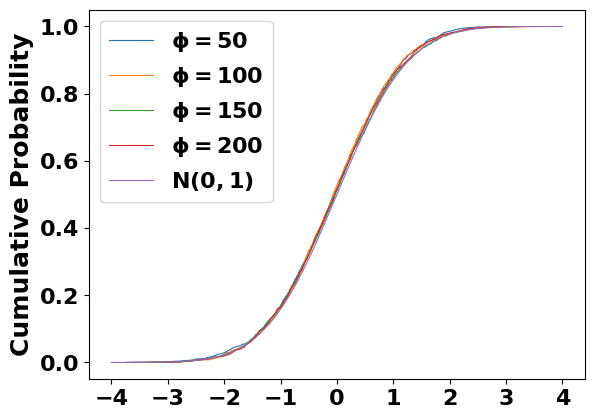

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate

# Functions for Stieltjes transform and its derivatives
def stieltjesp(z, phi, r):
    gammap = r + 1/r + 2
    gammam = r + 1/r - 2
    s = (r - 1/r - z + np.sqrt((z - gammam) * (gammap - z)) * 1j) / (2 * z/r)
    return s

def lsd(x, phi, r):
    return np.imag(stieltjesp(x + 0.00001j, phi, r)) / np.pi

def testf(x, phi, r, c):
    return np.log(x - r - 1/r + c)

def compute_nlsd(phi, r, c):
    lower_limit = r - 2.3
    upper_limit = r + 2.3
    result, _ = integrate.quad(lambda x: testf(x, phi, r, c) * lsd(x, phi, r), lower_limit, upper_limit)
    return result

def normalize_test_statistics3(TestST, nlsd, n, r, c):
    t1 = (c + np.sqrt(c**2 - 4)) / 2
    return (TestST - (-nlsd + n * (c - 1/r) - 0.5 * np.log(1 - 1/t1/t1)) * np.ones(len(TestST))) / np.sqrt(2 * (1 - 2/t1) + 2 * np.log(t1) - 2 * np.log(t1 - 1/t1))

# Parameters
phi_values = [50, 100, 150, 200]
r_values = [np.sqrt(phi) for phi in phi_values]
c = 10/3
n = 200  # Assuming n is 200 as it was not provided in the code


## Note that for $\log$ test functions, we don't have explicit formulas, therefore we also need to calculate $n\int\log \mathrm{d}\varrho$ numerically.
# Compute nlsd for each phi and r
nlsd_values = [n * compute_nlsd(phi, r, c) for phi, r in zip(phi_values, r_values)]
# for nlsd in nlsd_values:
#     print(nlsd)

# Assuming you have the data sets TestST1, TestST2, TestST3, and TestST4
normalized_data_sets = [normalize_test_statistics3(TestST, nlsd, n, r, c)
    for TestST, nlsd, r in zip([TestST1, TestST2, TestST3, TestST4], nlsd_values, r_values)
]

labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)


### $T_4^g$

In practice, we use $n^2\frac{T_2^g}{(T_1^g)^2}$ where $T_1^g,T_2^g$ are the realizations in the above subsections.


#### Data generating

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np

R = 2000
n = 200
c = 3
pn=2*jnp.ones(n)

def simulate_test_statistics4(phi, n, R, c):
    m = int(n * phi)
    center = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n)

    @jit
    def objective(X):
        H = jnp.matmul(jnp.transpose(X), X)
        E0 = jnp.linalg.eigh(H)[0]
        Eb = E0 - center
        loE=jnp.power(Eb,pn)
        t = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        return t


    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)

    for k in range(R):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))
        T = T.at[k].set(objective(X))

    return np.array(T)

TestST1 = simulate_test_statistics4(50,  n, R, c)
TestST2 = simulate_test_statistics4(100, n, R, c)
TestST3 = simulate_test_statistics4(150, n, R, c)
TestST4 = simulate_test_statistics4(200, n, R, c)


CPU times: user 33.1 s, sys: 1.8 s, total: 34.9 s
Wall time: 32.1 s


#### Saved data

In [ ]:
TestST1=[224.76595 , 224.5549 , 224.52046 , 223.92426 , 224.9476 , 224.6823 , 224.29317 , 224.30215 , 224.88307 , 224.09732 , 224.50119 , 224.60269 , 224.5787 , 224.73703 , 224.44318 , 224.71179 , 224.72572 , 224.42917 , 224.21458 , 225.01837 , 224.77339 , 224.45093 , 224.2161 , 223.669 , 224.89972 , 224.43036 , 224.83043 , 224.48718 , 224.53435 , 225.01863 , 224.45453 , 224.43692 , 224.5058 , 224.25417 , 224.48772 , 224.3876 , 224.2271 , 225.05232 , 224.62596 , 224.06068 , 224.46667 , 224.71872 , 224.48225 , 224.69148 , 224.308 , 224.63597 , 224.77841 , 224.5204 , 224.70245 , 224.5776 , 224.62273 , 224.70358 , 224.4156 , 225.0329 , 224.5958 , 225.00142 , 224.55022 , 224.65454 , 224.7255 , 224.70782 , 224.42128 , 224.79816 , 224.8723 , 224.03583 , 224.7998 , 224.73573 , 224.42076 , 224.71718 , 224.717 , 225.13776 , 224.34259 , 225.05869 , 224.67934 , 224.60785 , 224.5258 , 224.19476 , 224.70479 , 224.32301 , 224.59879 , 224.73373 , 224.70709 , 224.49617 , 224.9137 , 224.63033 , 224.4872 , 224.73576 , 224.1385 , 224.6496 , 224.71468 , 224.62883 , 224.52803 , 224.34306 , 225.14598 , 224.0517 , 224.57195 , 225.15059 , 224.24707 , 224.7328 , 224.81439 , 224.42357 , 224.36041 , 224.56104 , 224.25444 , 224.62245 , 224.82866 , 224.78517 , 224.81229 , 223.93024 , 224.36134 , 224.54265 , 224.89632 , 224.84563 , 224.67795 , 224.4571 , 224.56874 , 224.719 , 224.92061 , 224.2885 , 224.49245 , 224.94885 , 224.26321 , 224.9641 , 224.66151 , 224.71968 , 224.28247 , 225.15945 , 224.384 , 224.93446 , 224.99344 , 224.6506 , 224.11075 , 224.4568 , 224.63853 , 224.46884 , 224.65617 , 225.26077 , 224.63304 , 224.84367 , 224.91599 , 224.82776 , 224.3852 , 224.66762 , 224.5091 , 224.70747 , 224.54091 , 224.2888 , 224.61078 , 224.92938 , 224.32959 , 224.19987 , 224.23756 , 224.88275 , 225.00172 , 224.38765 , 224.81975 , 223.93697 , 224.43156 , 224.5594 , 224.7205 , 224.15334 , 224.56642 , 224.72429 , 224.76509 , 224.55205 , 224.86522 , 224.83928 , 224.453 , 224.02126 , 224.68733 , 224.4627 , 224.59795 , 224.65276 , 224.38327 , 224.58221 , 224.30762 , 224.44734 , 224.4183 , 224.57523 , 224.31041 , 224.41122 , 224.32155 , 224.7407 , 224.59752 , 225.08113 , 224.66084 , 224.5621 , 224.68805 , 224.51326 , 224.36354 , 224.88014 , 224.678 , 224.39575 , 224.5499 , 224.60701 , 224.55554 , 224.68275 , 225.00568 , 224.1087 , 224.39084 , 224.40024 , 225.14091 , 224.71225 , 224.47656 , 224.66727 , 224.31287 , 224.56404 , 224.59666 , 224.41762 , 224.67424 , 224.68652 , 224.56416 , 224.68489 , 225.14844 , 224.66757 , 224.81953 , 224.89568 , 224.56223 , 224.5275 , 224.78996 , 224.76988 , 224.50198 , 224.81558 , 224.66525 , 224.48645 , 224.79355 , 224.39052 , 224.3287 , 224.59096 , 224.66005 , 224.3719 , 224.48639 , 224.8215 , 224.3629 , 224.37997 , 224.56584 , 224.86685 , 224.50659 , 224.82689 , 224.88547 , 224.23012 , 224.36763 , 224.64372 , 224.6101 , 224.52106 , 224.36057 , 224.64523 , 224.43115 , 224.77396 , 224.50107 , 224.88539 , 224.44447 , 224.87228 , 224.47227 , 224.8438 , 224.65459 , 224.72733 , 224.52516 , 224.66066 , 225.02888 , 224.86784 , 224.336 , 224.48956 , 224.65279 , 224.47542 , 224.50934 , 224.5196 , 224.94168 , 225.03119 , 224.59596 , 224.80017 , 224.72627 , 224.85982 , 224.36234 , 224.71948 , 224.4387 , 224.73914 , 224.89882 , 224.69553 , 224.64445 , 225.00519 , 224.86778 , 224.37398 , 224.57542 , 224.22374 , 224.3903 , 224.33075 , 224.6475 , 224.22307 , 224.77377 , 224.59334 , 224.69717 , 224.3873 , 224.4178 , 224.82767 , 224.72148 , 224.62718 , 224.51459 , 224.64034 , 224.68213 , 224.41348 , 224.73036 , 224.7963 , 224.83344 , 224.72952 , 224.76859 , 224.08644 , 224.7776 , 224.40013 , 224.96957 , 224.59535 , 224.22816 , 224.63063 , 224.71057 , 224.56413 , 224.76083 , 224.69907 , 224.72563 , 224.31104 , 224.51419 , 224.60896 , 224.20383 , 224.04874 , 224.69104 , 225.06596 , 224.62097 , 224.79015 , 224.58041 , 224.25732 , 224.69255 , 224.89438 , 224.50227 , 224.67746 , 224.4421 , 224.85347 , 224.5311 , 224.40178 , 224.70056 , 224.78003 , 224.34915 , 224.35799 , 224.89493 , 224.49484 , 224.74321 , 224.36562 , 224.68498 , 224.6462 , 224.43883 , 224.53613 , 224.38853 , 224.77734 , 224.43222 , 224.81749 , 224.66354 , 224.34709 , 224.70576 , 224.65298 , 224.33195 , 224.18521 , 224.57959 , 224.5674 , 224.57124 , 224.62411 , 224.68881 , 224.76642 , 224.39626 , 224.58865 , 224.17741 , 224.55196 , 224.87224 , 224.80249 , 224.59312 , 224.43953 , 224.58638 , 224.66614 , 224.60596 , 224.2329 , 224.66609 , 224.74011 , 225.08945 , 225.05707 , 224.79774 , 224.84898 , 224.44475 , 224.58548 , 224.63007 , 223.89732 , 224.7281 , 224.33095 , 224.9349 , 224.7767 , 224.29695 , 224.65698 , 224.60463 , 224.89114 , 224.42342 , 224.74379 , 224.81955 , 224.63075 , 224.51613 , 224.42181 , 224.58934 , 224.82195 , 224.67354 , 224.65918 , 224.12317 , 224.78392 , 224.55348 , 225.02882 , 225.3976 , 224.3688 , 224.21704 , 224.90074 , 224.7264 , 224.61372 , 224.56664 , 224.68518 , 224.35176 , 224.82004 , 224.82501 , 224.41858 , 224.95152 , 224.8706 , 224.81508 , 224.912 , 224.74109 , 224.60123 , 225.13065 , 224.61655 , 224.44792 , 224.84106 , 224.63512 , 224.3452 , 224.7624 , 224.29747 , 224.28105 , 224.70926 , 223.98824 , 224.83752 , 224.73349 , 224.32388 , 224.42635 , 224.97517 , 224.7105 , 224.61754 , 224.63733 , 224.78604 , 224.41374 , 224.68102 , 224.52295 , 224.81836 , 224.6684 , 224.55453 , 224.64413 , 224.78067 , 224.34834 , 224.1301 , 224.57181 , 224.74557 , 224.28015 , 224.64761 , 224.71692 , 224.09875 , 224.63348 , 224.79076 , 224.6978 , 224.8794 , 224.6201 , 224.51466 , 224.21341 , 224.69942 , 224.65039 , 224.91057 , 224.59787 , 224.80244 , 224.25821 , 224.41724 , 224.9013 , 224.41989 , 224.65425 , 225.0507 , 224.59856 , 224.44249 , 224.63333 , 224.71101 , 225.11673 , 224.55167 , 224.60884 , 224.4534 , 224.56514 , 224.90273 , 224.68463 , 224.07002 , 224.65413 , 224.67224 , 224.67354 , 224.56161 , 224.42258 , 224.92735 , 224.24123 , 224.35777 , 224.72928 , 224.23463 , 224.4756 , 224.3032 , 224.89679 , 224.90712 , 224.36061 , 224.45673 , 224.48415 , 224.58646 , 224.48135 , 224.74327 , 224.42653 , 224.88422 , 224.20947 , 224.90178 , 225.20734 , 224.4984 , 224.94853 , 224.75682 , 224.38815 , 224.41812 , 224.47577 , 224.51935 , 224.59921 , 224.88593 , 224.22952 , 224.49037 , 224.45998 , 224.56387 , 224.61647 , 224.38289 , 224.51512 , 224.68672 , 223.91359 , 224.6538 , 224.32079 , 224.74971 , 224.43428 , 224.58379 , 224.5984 , 225.11151 , 224.8216 , 225.20108 , 224.43542 , 224.66681 , 224.96799 , 224.52728 , 224.72525 , 224.78542 , 224.87593 , 224.41948 , 224.20322 , 224.28697 , 224.19658 , 224.78253 , 224.31116 , 224.62567 , 224.65254 , 224.95769 , 224.0917 , 224.78532 , 224.89981 , 224.85542 , 224.91422 , 224.88184 , 224.53691 , 224.31346 , 224.50188 , 224.75552 , 224.57483 , 224.60059 , 224.6871 , 224.49103 , 224.72122 , 224.58751 , 224.48843 , 224.3597 , 224.7664 , 224.79265 , 224.6591 , 225.1909 , 224.44724 , 224.68001 , 224.53117 , 224.70096 , 224.98048 , 224.98192 , 224.45496 , 224.7623 , 224.65561 , 224.72368 , 224.45543 , 224.45718 , 224.81256 , 224.40506 , 224.74187 , 224.68073 , 224.27109 , 224.37936 , 224.7834 , 224.21362 , 224.90266 , 224.65286 , 224.86874 , 224.60507 , 224.59271 , 224.47922 , 224.40944 , 224.721 , 224.65564 , 224.41275 , 224.79288 , 224.81647 , 224.24092 , 224.42249 , 224.77776 , 224.2928 , 224.42815 , 224.7888 , 225.09409 , 223.89093 , 224.43143 , 224.20897 , 224.78622 , 224.99127 , 224.78267 , 224.31902 , 224.60793 , 224.7403 , 224.27058 , 224.771 , 225.0786 , 224.102 , 224.56514 , 224.45746 , 224.66959 , 224.82129 , 224.01242 , 224.89445 , 224.9102 , 224.89078 , 224.82236 , 224.46007 , 224.35686 , 224.43802 , 224.943 , 224.52606 , 224.59352 , 224.68677 , 224.48805 , 225.14275 , 224.26959 , 224.66196 , 224.46286 , 224.62508 , 224.30511 , 224.73347 , 224.43874 , 224.73459 , 224.3558 , 224.4512 , 224.73222 , 224.95529 , 224.97507 , 224.72218 , 224.52164 , 224.66261 , 224.52055 , 224.62473 , 224.60918 , 224.7218 , 224.48416 , 224.67966 , 224.74971 , 225.06009 , 224.79245 , 224.64836 , 224.9878 , 224.97722 , 224.10051 , 224.95197 , 224.45972 , 224.35738 , 224.54889 , 224.764 , 224.48811 , 224.6559 , 224.55647 , 224.37643 , 224.32892 , 224.63612 , 224.71548 , 224.8446 , 225.09293 , 224.57173 , 224.73808 , 224.94716 , 224.19383 , 224.71323 , 224.5039 , 224.53653 , 224.7199 , 225.03465 , 224.8291 , 224.74641 , 224.66147 , 224.65282 , 224.21344 , 224.72745 , 224.49301 , 225.1069 , 224.15445 , 224.4573 , 224.75383 , 224.39273 , 224.61055 , 224.47899 , 224.9729 , 224.55585 , 223.9371 , 224.66614 , 224.71735 , 224.11588 , 224.33878 , 225.03973 , 224.26581 , 224.43361 , 224.8495 , 224.45612 , 224.56575 , 224.80919 , 224.91042 , 224.63611 , 224.24835 , 224.63889 , 224.55849 , 224.5224 , 224.4359 , 224.98857 , 224.44585 , 224.59708 , 224.41928 , 224.55283 , 224.76529 , 224.49268 , 224.72983 , 224.45128 , 224.60432 , 224.38718 , 224.9323 , 224.83911 , 224.67882 , 224.71199 , 224.95747 , 224.2273 , 223.89572 , 224.50583 , 224.76823 , 224.70619 , 224.61287 , 224.7083 , 224.80464 , 224.33153 , 224.73718 , 224.56609 , 224.41904 , 224.49002 , 224.987 , 224.78142 , 225.16933 , 224.843 , 224.85982 , 224.11736 , 224.61995 , 224.59894 , 224.76901 , 224.42181 , 224.30559 , 224.62917 , 224.74939 , 224.2609 , 224.6216 , 225.02298 , 224.63254 , 224.30228 , 224.43437 , 224.12529 , 224.95253 , 224.88356 , 224.8877 , 224.667 , 225.30138 , 224.21423 , 224.89818 , 224.3769 , 224.73746 , 224.19582 , 224.66751 , 224.51807 , 224.48497 , 224.95241 , 224.60947 , 224.40828 , 224.36678 , 224.22627 , 224.85927 , 225.0285 , 225.02997 , 225.1708 , 224.65625 , 224.99855 , 224.78467 , 224.74335 , 224.63004 , 224.34221 , 224.47452 , 224.55641 , 224.4628 , 224.68288 , 224.49756 , 224.69781 , 224.83391 , 224.6063 , 224.36215 , 224.80687 , 224.528 , 224.18123 , 224.94585 , 224.41205 , 224.18718 , 224.59941 , 224.43523 , 224.62334 , 224.53075 , 224.814 , 224.34222 , 224.63239 , 224.67964 , 224.44542 , 224.71333 , 224.4751 , 224.77809 , 224.37407 , 224.43646 , 224.386 , 224.54684 , 224.5232 , 224.62184 , 224.11876 , 224.73903 , 224.64417 , 224.29187 , 224.77278 , 224.63171 , 224.84686 , 224.37718 , 224.69153 , 224.36328 , 224.58731 , 224.74966 , 224.68944 , 224.75404 , 224.72722 , 224.46591 , 224.8357 , 224.57681 , 224.58112 , 224.52248 , 225.34375 , 224.58948 , 224.1251 , 224.64154 , 224.21638 , 224.47821 , 224.66658 , 224.64516 , 224.27702 , 224.60179 , 224.37518 , 224.6919 , 224.28339 , 224.87822 , 224.51788 , 224.75352 , 224.66867 , 224.49435 , 224.53345 , 224.461 , 225.02962 , 224.93661 , 224.49825 , 224.54187 , 224.58095 , 224.2605 , 224.89221 , 224.57222 , 224.68912 , 224.52588 , 224.5637 , 224.84346 , 224.4015 , 224.88927 , 224.64917 , 224.37793 , 224.23389 , 225.04518 , 224.47447 , 224.54692 , 224.74606 , 224.71805 , 224.83011 , 224.4219 , 224.53238 , 224.46144 , 224.55226 , 224.61316 , 224.49483 , 224.57576 , 224.72453 , 224.45137 , 224.39012 , 224.56804 , 223.99097 , 224.8228 , 224.87431 , 224.99057 , 224.39526 , 224.83997 , 224.36688 , 224.60942 , 224.38112 , 224.9387 , 224.56842 , 224.63266 , 224.40776 , 224.4314 , 224.90775 , 224.4259 , 224.16261 , 224.57271 , 224.7226 , 224.944 , 224.32353 , 224.8904 , 224.91068 , 224.62563 , 224.73502 , 224.89949 , 224.63885 , 224.76701 , 224.58112 , 224.65758 , 224.61203 , 225.43495 , 224.93448 , 224.15627 , 224.64468 , 224.32808 , 224.82036 , 224.77034 , 224.0835 , 224.63524 , 224.70406 , 224.63504 , 224.38753 , 224.0366 , 224.62384 , 224.79848 , 224.65315 , 224.67221 , 225.17928 , 224.77522 , 224.54959 , 225.03792 , 224.87538 , 224.59705 , 224.38866 , 224.04193 , 224.46358 , 224.12128 , 224.63493 , 224.65787 , 224.74023 , 224.65309 , 225.03429 , 224.9104 , 224.26192 , 224.42917 , 224.1001 , 224.36522 , 224.56537 , 224.65549 , 224.31473 , 224.87099 , 224.70071 , 224.652 , 224.8283 , 224.72958 , 224.4943 , 224.55675 , 224.77504 , 224.63902 , 224.41597 , 224.46753 , 224.60855 , 225.20699 , 224.46129 , 224.41267 , 224.65546 , 224.73752 , 224.26476 , 224.54648 , 225.21582 , 224.3073 , 224.60757 , 225.29456 , 224.4918 , 224.31923 , 224.642 , 224.47816 , 224.45367 , 225.11723 , 224.64528 , 224.41792 , 224.66048 , 224.32538 , 224.65903 , 224.68593 , 224.48546 , 224.54282 , 224.53603 , 224.37961 , 225.22449 , 224.1415 , 224.60457 , 224.61311 , 224.60991 , 224.67152 , 225.19661 , 225.05478 , 224.89777 , 224.37483 , 224.41827 , 224.53836 , 224.66838 , 224.58311 , 224.19589 , 224.84071 , 224.63045 , 224.3915 , 224.38043 , 224.59335 , 224.63353 , 224.59389 , 225.05789 , 224.50278 , 224.03177 , 224.55673 , 224.63014 , 224.70317 , 224.41583 , 224.127 , 224.45113 , 224.47002 , 224.94087 , 224.42148 , 225.2364 , 224.5701 , 224.96397 , 224.6543 , 224.66632 , 224.2318 , 224.64883 , 224.8298 , 224.93538 , 224.55612 , 224.91164 , 224.47282 , 225.09842 , 224.70393 , 224.91843 , 225.3164 , 224.55646 , 224.59373 , 224.57162 , 224.48811 , 224.91982 , 224.7548 , 224.46304 , 224.75932 , 224.87863 , 224.70541 , 224.58894 , 224.24768 , 224.91058 , 224.45435 , 224.62453 , 224.60027 , 224.51703 , 224.56047 , 224.92189 , 224.85527 , 224.66582 , 224.7117 , 224.0273 , 224.90479 , 225.40112 , 224.06018 , 225.0424 , 224.17566 , 224.53455 , 224.42099 , 224.77672 , 224.49684 , 224.6732 , 224.86543 , 224.40656 , 224.5922 , 224.7545 , 224.52612 , 224.344 , 225.05013 , 224.55914 , 224.94646 , 224.44514 , 224.96559 , 224.61424 , 224.28 , 224.54845 , 224.97426 , 224.24673 , 224.87909 , 224.47343 , 224.42442 , 224.60127 , 224.467 , 224.77574 , 224.33246 , 224.5226 , 224.62668 , 224.74924 , 224.85168 , 224.36978 , 224.45818 , 224.9535 , 224.93318 , 224.49535 , 224.51512 , 225.0598 , 224.54001 , 224.22493 , 224.90608 , 224.82216 , 224.57468 , 224.78563 , 224.91272 , 224.3126 , 224.53893 , 224.66539 , 224.46718 , 224.87268 , 224.28947 , 224.79718 , 224.76831 , 224.47581 , 224.83812 , 224.7098 , 224.68895 , 224.58676 , 224.24762 , 224.90488 , 224.25307 , 224.21921 , 224.9805 , 224.56187 , 224.8162 , 224.68596 , 224.86147 , 224.92447 , 224.49413 , 224.6787 , 224.5499 , 224.56459 , 224.26846 , 224.91283 , 224.9577 , 224.59822 , 223.94911 , 224.84596 , 224.57266 , 224.58325 , 224.61493 , 224.67639 , 224.8361 , 224.36626 , 224.51233 , 225.01785 , 224.34824 , 224.79657 , 224.61269 , 224.63106 , 224.8754 , 224.29344 , 224.78748 , 224.87126 , 225.05754 , 224.40001 , 224.61443 , 224.75928 , 225.03773 , 224.57681 , 224.99649 , 224.23912 , 224.78056 , 224.82567 , 224.58725 , 224.37607 , 224.82632 , 224.40022 , 224.27422 , 225.02966 , 224.62814 , 224.74513 , 223.99373 , 224.40977 , 224.68492 , 224.39282 , 224.43533 , 224.29465 , 224.76463 , 224.841 , 224.59007 , 224.46368 , 224.40419 , 224.75046 , 224.63756 , 224.6319 , 224.59006 , 225.23106 , 224.59236 , 224.48991 , 224.34727 , 224.26323 , 224.71625 , 224.55641 , 224.84145 , 224.51302 , 224.67438 , 224.85739 , 224.39577 , 224.37991 , 224.65851 , 224.69351 , 224.87256 , 224.65483 , 224.57036 , 224.90475 , 224.72308 , 224.33614 , 224.78793 , 224.63504 , 224.33482 , 224.81128 , 224.98006 , 224.49506 , 224.11725 , 224.04716 , 225.00954 , 224.26404 , 224.96123 , 223.97375 , 224.87923 , 224.88744 , 224.44377 , 224.7985 , 224.7898 , 224.86304 , 224.80627 , 224.28746 , 224.7783 , 224.79256 , 224.77371 , 224.00702 , 224.37341 , 224.33641 , 224.33128 , 224.87187 , 224.74812 , 224.54922 , 224.13016 , 224.44493 , 224.18169 , 224.42673 , 224.83768 , 224.08131 , 224.67036 , 224.71367 , 224.15375 , 224.55315 , 224.7366 , 224.668 , 224.38686 , 224.53662 , 224.5765 , 224.60501 , 224.22975 , 224.43315 , 224.40887 , 224.78444 , 224.76907 , 225.29506 , 224.58972 , 224.2473 , 224.8888 , 224.8426 , 224.44466 , 224.67244 , 224.48845 , 224.57523 , 224.3826 , 224.31763 , 224.96019 , 224.60162 , 224.43109 , 224.509 , 224.63031 , 224.29417 , 224.9985 , 224.66353 , 224.23483 , 224.8659 , 224.41762 , 224.70444 , 224.7595 , 224.45706 , 224.63347 , 223.73242 , 224.835 , 225.06056 , 224.68236 , 224.12769 , 224.54094 , 224.53859 , 224.43144 , 224.82814 , 224.71272 , 224.65913 , 224.80746 , 224.62779 , 224.46571 , 224.56293 , 224.56848 , 224.53625 , 224.41498 , 225.3881 , 224.70772 , 224.91972 , 224.10484 , 224.44586 , 224.54448 , 224.49199 , 224.766 , 224.70338 , 224.64821 , 224.89893 , 224.88666 , 224.35233 , 224.51285 , 224.44878 , 224.46872 , 224.69716 , 224.32376 , 224.74556 , 225.07274 , 224.53267 , 224.62663 , 224.26225 , 224.69843 , 224.40903 , 224.64407 , 224.2876 , 225.06534 , 224.2972 , 224.4805 , 224.66829 , 224.3932 , 224.49484 , 224.78882 , 224.62953 , 224.57428 , 224.4735 , 224.442 , 224.42159 , 224.2124 , 224.54439 , 224.68646 , 224.2715 , 224.59383 , 224.67693 , 224.86456 , 224.89514 , 224.71536 , 224.19324 , 224.64893 , 224.45818 , 224.89105 , 224.63268 , 224.8765 , 224.96768 , 224.56114 , 224.49805 , 224.0308 , 224.26845 , 224.69441 , 224.31754 , 224.5446 , 224.52762 , 224.49292 , 224.77817 , 224.49254 , 224.48946 , 224.25224 , 224.92064 , 224.48357 , 224.70183 , 224.54987 , 224.5438 , 224.35997 , 224.6826 , 224.78523 , 224.4895 , 224.61859 , 224.32277 , 224.50742 , 224.57283 , 224.78917 , 224.5398 , 225.04095 , 224.86967 , 224.69255 , 224.50638 , 224.74121 , 224.71004 , 224.44028 , 224.38083 , 225.30525 , 224.70047 , 224.65247 , 224.85301 , 224.48831 , 224.12859 , 224.52946 , 224.4524 , 225.01256 , 224.53293 , 224.7925 , 224.63483 , 224.70029 , 224.76808 , 224.23048 , 224.78658 , 224.05815 , 224.35634 , 224.61885 , 224.66048 , 224.28397 , 224.82849 , 224.69638 , 224.41751 , 224.82738 , 224.40906 , 224.6923 , 224.63614 , 224.41101 , 224.64041 , 225.11334 , 224.91653 , 224.85405 , 224.72607 , 224.63472 , 224.5679 , 224.33691 , 225.17987 , 224.72934 , 224.80017 , 224.54898 , 224.53056 , 224.68967 , 224.9805 , 224.5225 , 224.77408 , 224.86809 , 224.96158 , 224.66582 , 223.94585 , 224.74426 , 224.97246 , 224.89592 , 224.33765 , 224.6446 , 224.11658 , 224.41083 , 224.74808 , 224.2272 , 224.30623 , 224.48041 , 224.57603 , 224.79613 , 224.80829 , 224.80089 , 224.853 , 225.20897 , 224.56459 , 224.68462 , 224.03612 , 225.00163 , 224.4976 , 224.82669 , 224.73752 , 224.32808 , 224.54706 , 224.58475 , 224.34969 , 224.40195 , 224.49786 , 224.76363 , 224.90494 , 224.4394 , 224.58035 , 224.79152 , 224.41153 , 224.39058 , 224.55632 , 224.91174 , 224.56642 , 224.77837 , 224.5266 , 225.07237 , 224.44786 , 224.5323 , 225.07088 , 224.34065 , 224.35251 , 224.55031 , 224.4582 , 224.71849 , 224.78255 , 224.68362 , 224.66049 , 224.45676 , 224.5873 , 224.77654 , 224.63011 , 224.48178 , 224.60645 , 224.61435 , 224.78564 , 224.48097 , 224.7789 , 225.02182 , 224.42732 , 224.59807 , 224.7173 , 224.47252 , 224.70824 , 224.4842 , 224.61682 , 224.3557 , 224.72145 , 224.33473 , 224.69258 , 224.38872 , 224.53633 , 224.8367 , 224.66785 , 224.57426 , 224.61609 , 225.00342 , 224.97891 , 224.41107 , 225.07054 , 224.2434 , 224.32335 , 224.55444 , 224.50635 , 224.55763 , 224.6587 , 225.12648 , 224.7362 , 224.59377 , 224.6782 , 224.45544 , 225.30396 , 224.78735 , 224.73451 , 224.9352 , 224.20409 , 224.54288 , 224.76634 , 224.40152 , 225.08472 , 225.17397 , 224.3436 , 224.62941 , 224.48099 , 224.17662 , 224.52942 , 225.18991 , 224.92114 , 224.55455 , 225.08514 , 225.12315 , 224.54909 , 224.62624 , 224.87144 , 224.7838 , 224.22838 , 224.89935 , 224.83601 , 224.98688 , 225.20412 , 224.74063 , 224.28407 , 224.5568 , 224.7348 , 224.8409 , 224.9116 , 224.5921 , 224.48145 , 224.52907 , 224.17065 , 224.61783 , 224.32477 , 224.46681 , 224.72897 , 224.29243 , 224.46887 , 224.6577 , 224.55186 , 224.39612 , 224.48817 , 224.84924 , 224.42139 , 224.50888 , 224.44167 , 224.87119 , 224.4859 , 224.615 , 225.15648 , 224.41968 , 224.23586 , 224.79686 , 224.95663 , 224.42859 , 224.35474 , 224.57274 , 224.64473 , 224.57068 , 225.09651 , 224.65402 , 224.3623 , 224.78214 , 225.0944 , 224.38097 , 224.47763 , 224.4272 , 224.59032 , 224.80653 , 224.7057 , 224.56776 , 224.7905 , 224.67943 , 224.17172 , 224.43666 , 224.85117 , 224.39032 , 223.94885 , 224.46931 , 224.62552 , 224.92398 , 224.94737 , 225.26947 , 224.4538 , 224.20345 , 224.8403 , 224.60092 , 224.94946 , 224.69888 , 224.53104 , 224.30067 , 225.18176 , 224.82405 , 224.59961 , 224.77457 , 224.55206 , 224.66603 , 224.82652 , 224.87181 , 224.551 , 225.20627 , 224.80621 , 224.65944 , 224.80902 , 224.23782 , 224.54874 , 224.40842 , 224.59819 , 224.29932 , 224.88959 , 224.4405 , 224.94641 , 224.34534 , 224.1058 , 224.43996 , 224.40106 , 224.41035 , 224.22478 , 224.2571 , 224.432 , 224.31387 , 225.15172 , 224.55537 , 224.49211 , 224.60124 , 224.89784 , 224.59807 , 224.2022 , 224.59831 , 224.5465 , 224.46474 , 224.27673 , 224.90445 , 224.15248 , 224.5946 , 224.2233 , 224.73041 , 224.66661 , 224.35767 , 224.60092 , 224.12772 , 225.10101 , 224.74867 , 225.06 , 225.36543 , 224.23387 , 224.87161 , 224.56856 , 224.3912 , 224.3617 , 225.19621 , 224.81909 , 224.85228 , 224.53204 , 224.24496 , 224.694 , 224.49973 , 224.7302 , 224.56535 , 224.37189 , 224.95279 , 224.53033 , 224.57195 , 224.87193 , 224.5718 , 224.80704 , 224.53917 , 224.92252 , 224.16272 , 224.73956 , 225.0852 , 224.27971 , 224.72932 , 224.29129 , 224.60112 , 224.77235 , 224.10257 , 224.68015 , 224.87004 , 224.57213 , 224.61105 , 224.02934 , 224.6179 , 224.8345 , 224.56935 , 224.343 , 224.29095 , 224.62787 , 224.57294 , 224.4983 , 223.8806 , 224.53748 , 224.618 , 224.27318 , 224.70844 , 224.87335 , 224.40742 , 224.4771 , 224.39732 , 224.99706 , 224.67722 , 224.95345 , 224.6957 , 224.83752 , 225.04556 , 224.84807 , 224.60657 , 224.66685 , 224.93285 , 224.49503 , 224.43166 , 224.43988 , 224.35204 , 223.98328 , 224.80435 , 224.58119 , 224.27444 , 224.53574 , 224.56073 , 224.46342 , 224.61447 , 224.46341 , 224.54524 , 224.01202 , 224.74712 , 224.11075 , 224.66412 , 224.91464 , 224.74062 , 224.61192 , 224.26157 , 224.86609 , 224.76848 , 224.53456 , 224.6857 , 224.57489 , 224.56999 , 224.5747 , 224.79802 , 224.68863 , 224.87811 , 224.97144 , 224.43346 , 224.54541 , 224.63255 , 224.73602 , 225.1799 , 224.59663 , 224.65111 , 224.43117 , 224.21263 , 224.57187 , 224.75717 , 224.57683 , 224.39761 , 224.25195 , 224.48802 , 224.6536 , 224.7834 , 224.66393 , 224.35306 , 224.6192 , 224.48758 , 224.54024 , 224.73093 , 224.37717 , 224.31909 , 224.46898 , 225.00243 , 224.39064 , 224.84062 , 224.62631 , 224.574 , 224.96016 , 224.81342 , 224.43346 , 225.19508 , 224.10692 , 224.7264 , 224.21262 , 225.24628 , 224.79684 , 224.50826 , 224.41667 , 224.56871 , 224.26346 , 224.89056 , 224.54785 , 224.51355 , 224.43674 , 224.59995 , 224.53423 , 224.18645 , 224.62717 , 224.69662 , 224.6914 , 224.14867 , 224.54057 , 224.6716 , 224.55914 , 224.59744 , 224.487 , 224.71439 , 224.5247 , 224.64333 , 224.49863 , 224.49927 , 224.68443 , 224.65924 , 224.69215 , 225.1081 , 224.58864 , 224.54889 , 224.35211 , 224.11559 , 224.46407 , 224.88977 , 224.54675 , 224.78532 , 224.71164 , 224.66187 , 224.35988 , 224.36015 , 224.53783 , 224.94565 , 224.94931 , 224.62698 , 224.60449 , 224.84148 , 224.74335 , 224.36618 , 224.30748 , 224.95787 , 224.72942 , 224.47885 , 224.5536 , 224.78815 , 224.66704 , 224.37416 , 224.84697 , 224.52519 , 224.16943 , 225.12285 , 224.91272 , 224.65663 , 224.98247 , 224.4593 , 224.53114 , 225.0902 , 224.73924 , 224.47467 , 224.62798 , 224.55054 , 224.57706 , 224.22545 , 224.54181 , 224.46912 , 224.47078 , 224.57036 , 224.15508 , 224.49364 , 224.21956 , 224.77968 , 224.50812 , 224.53575 , 224.3768 , 224.59978 , 224.62178 , 224.54665 , 224.47298 , 224.13734 , 224.45517 , 224.64482 , 225.19826 , 224.50774 , 224.32028 , 224.84775 , 224.55975 , 224.02428 , 224.64238 , 224.65813 , 224.91429 , 224.13611 , 224.39558 , 224.39415 , 224.87216 , 224.74059 , 224.6426 , 224.65886 , 224.70532 , 225.09279 , 224.42653 , 224.65308 , 224.44269 , 225.08623 , 224.51387 , 224.38391 , 224.43436 , 224.75587 , 224.4708 ]

In [ ]:
TestST2=[223.31836 , 223.98236 , 223.82857 , 224.26196 , 223.25682 , 224.13544 , 223.76526 , 223.89769 , 224.20016 , 223.44614 , 223.79076 , 224.28664 , 223.83763 , 223.50941 , 223.9613 , 224.01529 , 223.96227 , 223.50113 , 223.83327 , 224.2428 , 223.44751 , 224.17502 , 223.74223 , 224.05551 , 223.77397 , 223.68147 , 223.98582 , 223.89296 , 224.08133 , 223.77904 , 223.7093 , 224.06252 , 223.79567 , 224.07547 , 224.22298 , 223.91615 , 223.71957 , 223.96088 , 223.35622 , 223.90297 , 224.13744 , 223.75768 , 223.70172 , 223.9055 , 223.94635 , 223.47342 , 224.16377 , 224.25047 , 223.8657 , 223.71732 , 223.94632 , 223.53316 , 224.13132 , 224.10342 , 224.1619 , 223.75114 , 223.56654 , 223.61081 , 223.94357 , 224.5572 , 223.96486 , 223.85785 , 223.87831 , 223.88828 , 223.60345 , 224.27557 , 223.69931 , 223.85341 , 223.72435 , 223.98358 , 224.25179 , 223.51793 , 224.14307 , 223.49268 , 223.77556 , 224.048 , 223.55363 , 224.29518 , 223.68414 , 223.60948 , 223.56041 , 223.90172 , 224.128 , 223.58763 , 223.93411 , 224.32733 , 223.63206 , 223.9995 , 224.02007 , 223.59871 , 223.8757 , 224.13216 , 224.11409 , 223.38824 , 223.51857 , 224.04176 , 223.87863 , 223.66248 , 224.09042 , 224.29251 , 224.10027 , 224.35283 , 223.97096 , 223.73616 , 224.29895 , 224.05211 , 223.87483 , 223.852 , 223.80917 , 224.04103 , 224.02858 , 224.67146 , 223.88728 , 224.18102 , 223.75864 , 224.05887 , 223.54141 , 223.6997 , 223.89374 , 223.68512 , 223.90256 , 223.43542 , 223.59193 , 224.04155 , 224.15799 , 224.38443 , 223.96333 , 223.97496 , 223.87625 , 224.21251 , 223.92322 , 223.70444 , 224.0579 , 223.38905 , 224.16975 , 223.85745 , 223.69225 , 223.52133 , 223.68163 , 223.79507 , 223.9131 , 223.83919 , 224.14154 , 223.8307 , 223.98134 , 224.10036 , 223.82677 , 224.40149 , 224.12083 , 223.6617 , 223.99324 , 223.94066 , 224.32011 , 224.48567 , 224.35732 , 224.28311 , 224.27402 , 223.74304 , 223.86028 , 223.84906 , 223.59286 , 224.3 , 224.22328 , 223.92937 , 223.59181 , 223.65007 , 223.86938 , 223.46243 , 224.26508 , 224.16351 , 223.90903 , 224.29155 , 223.53044 , 223.9895 , 224.01846 , 224.13647 , 223.88158 , 223.85564 , 223.9704 , 224.11136 , 223.5923 , 223.47429 , 224.08801 , 224.12082 , 224.00226 , 223.67516 , 223.92047 , 223.9754 , 223.9432 , 223.63892 , 223.58289 , 223.71114 , 223.83298 , 223.78072 , 224.2344 , 224.01454 , 223.9775 , 223.94196 , 224.31041 , 223.90517 , 224.33144 , 223.50742 , 223.82288 , 224.32138 , 224.1228 , 223.85532 , 223.45871 , 223.41396 , 223.97662 , 223.60213 , 223.81517 , 224.0248 , 223.91592 , 224.13638 , 224.48836 , 224.01466 , 223.92232 , 224.15971 , 223.89906 , 223.92503 , 223.51404 , 224.08199 , 224.03899 , 224.35167 , 224.0753 , 224.34555 , 224.1347 , 223.67427 , 223.83307 , 224.03275 , 223.94264 , 224.09076 , 224.29965 , 223.93248 , 223.56621 , 223.48048 , 224.20238 , 223.66179 , 223.77397 , 223.79822 , 224.03117 , 223.70338 , 223.77817 , 223.9394 , 223.38776 , 223.76408 , 223.35178 , 224.16808 , 223.47557 , 223.85027 , 224.11685 , 223.99937 , 223.72423 , 224.0859 , 223.90593 , 223.93542 , 224.26591 , 224.10107 , 224.21257 , 223.56847 , 223.877 , 223.8906 , 223.7059 , 223.62025 , 223.65775 , 223.714 , 224.0078 , 223.59602 , 223.50406 , 223.83292 , 223.84581 , 223.91501 , 223.66266 , 223.42036 , 224.10513 , 223.73944 , 224.2518 , 223.66537 , 223.81693 , 223.92403 , 223.94658 , 224.45349 , 224.09616 , 223.85258 , 224.19136 , 223.5311 , 223.8354 , 223.77522 , 223.8473 , 224.16919 , 223.77417 , 223.96767 , 223.70723 , 223.81926 , 224.06181 , 223.5456 , 223.58142 , 223.74944 , 223.60753 , 223.86168 , 223.49603 , 224.1066 , 224.1212 , 223.84119 , 223.59686 , 223.90305 , 224.24713 , 224.06517 , 224.1116 , 223.72327 , 224.25482 , 223.94458 , 224.18948 , 223.96338 , 223.8626 , 224.303 , 223.75221 , 222.85063 , 224.10733 , 223.64665 , 223.82262 , 223.79669 , 224.272 , 223.93567 , 224.16028 , 224.02098 , 223.96413 , 224.06801 , 223.7221 , 223.67526 , 223.69702 , 224.17627 , 223.75888 , 224.26666 , 224.0107 , 223.94127 , 224.17027 , 223.71083 , 224.20718 , 224.03876 , 224.39137 , 223.45227 , 223.81857 , 224.01735 , 223.97662 , 223.68628 , 223.9061 , 224.03856 , 223.8454 , 223.93147 , 224.01727 , 223.94441 , 223.8636 , 223.75336 , 223.98827 , 224.09749 , 223.84975 , 224.38184 , 223.51125 , 223.62723 , 223.79329 , 223.89984 , 224.0988 , 224.24168 , 223.76518 , 223.94698 , 223.8665 , 223.57579 , 224.02983 , 223.71713 , 224.20291 , 223.90317 , 224.07297 , 223.72786 , 223.93451 , 223.89279 , 223.92645 , 223.87779 , 223.84254 , 224.15543 , 223.72145 , 223.37715 , 223.86304 , 223.74525 , 223.8888 , 223.91579 , 223.8292 , 223.80286 , 224.53156 , 224.16147 , 223.92859 , 223.91972 , 223.46962 , 224.1713 , 224.10777 , 223.80383 , 224.01433 , 224.20882 , 224.0027 , 224.15297 , 223.9066 , 223.70566 , 223.45193 , 223.95894 , 224.19177 , 224.26155 , 223.74564 , 224.22961 , 223.98575 , 223.89229 , 224.03749 , 223.40085 , 223.93149 , 223.73895 , 224.25449 , 223.99603 , 223.95576 , 223.93768 , 223.79962 , 223.88812 , 223.86818 , 224.0286 , 223.6859 , 223.44821 , 223.81517 , 223.7616 , 223.88603 , 223.96774 , 223.78107 , 223.8499 , 223.68394 , 223.44661 , 223.74696 , 223.87561 , 223.92117 , 224.10419 , 223.93195 , 224.2324 , 223.80821 , 223.88448 , 223.66579 , 223.34738 , 224.12303 , 223.723 , 223.50127 , 224.22093 , 223.33553 , 224.2988 , 223.92287 , 223.63533 , 224.18642 , 224.1653 , 223.69627 , 223.9495 , 224.05473 , 223.69273 , 223.93826 , 224.00172 , 224.09428 , 224.25526 , 224.27539 , 224.01353 , 223.90819 , 223.62784 , 224.21382 , 224.03883 , 224.12239 , 224.04573 , 223.89117 , 224.13759 , 223.86241 , 223.96996 , 223.87192 , 223.93747 , 223.99686 , 224.08388 , 223.7386 , 223.71696 , 223.42113 , 224.27129 , 223.21382 , 223.90613 , 223.845 , 223.76743 , 224.1167 , 223.6109 , 223.67087 , 223.94783 , 224.20024 , 223.75546 , 223.71265 , 223.75534 , 223.86754 , 223.8362 , 224.3053 , 223.6076 , 223.60204 , 223.78694 , 223.98161 , 224.18417 , 223.94214 , 223.87746 , 223.71999 , 223.6098 , 223.6609 , 224.00278 , 223.77037 , 224.21437 , 223.74844 , 224.29543 , 223.87642 , 223.55687 , 224.12193 , 223.52156 , 223.7232 , 223.98914 , 223.76622 , 223.41231 , 223.81625 , 224.07838 , 223.58275 , 223.61652 , 223.936 , 223.89458 , 223.17523 , 223.88097 , 223.77104 , 223.88707 , 223.65675 , 224.03214 , 224.24754 , 224.35214 , 223.97415 , 224.04648 , 224.42453 , 223.62643 , 223.82503 , 224.22542 , 224.05959 , 224.1763 , 223.49753 , 223.68335 , 224.18681 , 223.98804 , 224.04286 , 223.96973 , 223.72122 , 223.87671 , 223.77914 , 223.81602 , 223.79767 , 223.78973 , 223.8478 , 223.97076 , 224.11707 , 224.57 , 223.99861 , 223.82259 , 224.63217 , 223.88364 , 224.04549 , 223.62746 , 224.24998 , 224.1295 , 223.99184 , 223.6925 , 223.52702 , 224.26363 , 224.05626 , 224.23381 , 223.91754 , 223.70612 , 224.5931 , 223.60117 , 223.75694 , 223.75952 , 224.20238 , 224.29062 , 223.86699 , 223.83505 , 224.00783 , 223.9318 , 223.70145 , 224.00801 , 223.54707 , 223.8457 , 224.04431 , 224.13687 , 223.90727 , 223.72475 , 223.89268 , 224.08688 , 223.90639 , 223.99171 , 224.02087 , 223.75993 , 223.47243 , 223.92143 , 224.04659 , 224.04846 , 224.10944 , 223.7906 , 223.82776 , 224.0432 , 223.92679 , 223.91966 , 223.84517 , 223.88242 , 223.38283 , 223.74187 , 223.6391 , 223.74599 , 223.99966 , 224.22145 , 223.8987 , 223.47766 , 223.62817 , 224.0102 , 223.91977 , 223.7231 , 223.68025 , 224.0135 , 223.57507 , 223.42868 , 223.88628 , 224.07915 , 223.60236 , 223.90807 , 223.87457 , 223.68811 , 224.0018 , 223.76787 , 223.48001 , 224.06041 , 224.10875 , 224.10706 , 223.7303 , 224.19286 , 224.28345 , 223.6366 , 223.97295 , 223.99509 , 224.0035 , 223.86963 , 223.88528 , 224.00468 , 223.76501 , 223.85458 , 223.82397 , 223.12885 , 224.02542 , 223.93906 , 224.03543 , 223.49875 , 224.10092 , 224.10062 , 224.24377 , 223.6018 , 223.34775 , 223.62979 , 223.77437 , 224.24207 , 223.57544 , 223.54257 , 223.95772 , 223.7218 , 223.89717 , 224.03206 , 223.56624 , 223.58333 , 223.54288 , 223.76625 , 223.91768 , 224.1568 , 223.99464 , 223.82162 , 223.80673 , 223.98413 , 223.93985 , 224.04857 , 223.55806 , 223.69606 , 224.08963 , 223.86034 , 223.75761 , 223.85995 , 223.63388 , 223.79825 , 223.81741 , 223.85841 , 223.42113 , 224.10938 , 223.73784 , 223.91515 , 223.74252 , 224.00642 , 223.83508 , 224.07417 , 224.20747 , 223.66203 , 224.76517 , 223.99922 , 223.78406 , 224.20274 , 223.93367 , 223.70769 , 223.61473 , 224.29309 , 223.60654 , 224.427 , 223.73686 , 224.05295 , 223.81776 , 224.18365 , 224.0309 , 224.08714 , 223.89314 , 224.14381 , 223.80838 , 224.28671 , 224.02887 , 224.1004 , 223.9524 , 223.82474 , 223.95068 , 223.55168 , 224.21103 , 223.90164 , 223.79924 , 223.48389 , 224.13412 , 223.73677 , 223.77177 , 224.41104 , 223.76974 , 224.22629 , 223.54338 , 223.66023 , 223.81532 , 224.29742 , 223.50017 , 223.7982 , 223.92229 , 224.24571 , 224.10408 , 224.38309 , 223.6585 , 224.40425 , 224.10788 , 224.04633 , 224.34813 , 224.70921 , 223.67769 , 224.20276 , 223.95178 , 223.95529 , 223.90248 , 223.57613 , 223.93481 , 223.76875 , 223.86139 , 223.75719 , 223.99219 , 224.07129 , 223.6049 , 223.71739 , 223.38245 , 224.00912 , 224.00801 , 223.96822 , 223.93022 , 223.43881 , 224.18307 , 224.01009 , 224.05495 , 223.80444 , 223.72116 , 224.17122 , 223.5208 , 223.42622 , 223.70773 , 224.17682 , 223.8624 , 223.7125 , 223.77708 , 224.08548 , 223.6635 , 223.67021 , 223.88216 , 223.82468 , 223.70767 , 224.12201 , 224.05074 , 224.1553 , 224.31291 , 223.7724 , 223.6319 , 224.13744 , 224.04955 , 223.90904 , 224.11281 , 224.08557 , 223.95003 , 223.7734 , 224.27168 , 224.30135 , 223.65309 , 223.7046 , 223.94168 , 223.80106 , 223.83482 , 223.97699 , 223.88084 , 223.69897 , 224.11865 , 223.72966 , 224.00499 , 224.18158 , 223.86781 , 223.77802 , 223.81805 , 223.95387 , 224.13594 , 224.26357 , 224.01509 , 223.75752 , 224.35066 , 224.03433 , 223.68785 , 223.7936 , 223.64977 , 224.0067 , 223.7658 , 223.94577 , 223.79181 , 224.09315 , 223.82158 , 223.97401 , 224.07909 , 223.43527 , 223.7991 , 223.97777 , 223.51135 , 224.25351 , 223.28026 , 223.54794 , 223.90419 , 224.10916 , 223.88702 , 223.48497 , 223.9342 , 223.78764 , 224.11095 , 223.88419 , 224.09221 , 224.18945 , 223.66927 , 223.75403 , 224.01639 , 223.85246 , 224.08813 , 224.33661 , 223.474 , 223.62625 , 224.04915 , 223.69499 , 224.07759 , 223.839 , 224.21841 , 223.98422 , 224.05972 , 224.38922 , 224.01001 , 223.8781 , 223.87231 , 223.7143 , 223.89453 , 224.15723 , 223.68498 , 223.79929 , 224.01634 , 223.6953 , 223.73874 , 223.93018 , 224.1359 , 224.01308 , 224.14796 , 223.86568 , 224.10143 , 223.8244 , 223.00876 , 224.19711 , 224.29541 , 223.92917 , 223.5482 , 223.73619 , 224.02545 , 223.71536 , 223.75131 , 223.96411 , 223.35374 , 224.20142 , 223.39642 , 223.50522 , 223.93298 , 224.4567 , 224.3493 , 223.79932 , 224.02692 , 223.98392 , 223.56483 , 224.26375 , 224.30914 , 223.45947 , 223.97963 , 223.61452 , 223.7022 , 223.36111 , 223.71562 , 223.87622 , 224.23476 , 223.72368 , 223.49005 , 224.06837 , 223.4008 , 223.72581 , 224.37067 , 224.45792 , 223.99876 , 223.61382 , 224.34387 , 223.97192 , 224.1589 , 224.3293 , 224.0762 , 223.97404 , 223.93095 , 223.80362 , 223.40991 , 223.98816 , 224.02335 , 223.98296 , 223.97203 , 223.70453 , 223.48654 , 224.15509 , 224.03194 , 224.0683 , 223.9257 , 224.33804 , 224.0702 , 224.11517 , 223.90527 , 224.22507 , 223.6945 , 223.68408 , 223.86552 , 223.93248 , 224.02104 , 223.67482 , 223.92567 , 224.2102 , 224.68622 , 223.55768 , 223.54456 , 224.08647 , 223.72784 , 224.02136 , 223.8145 , 224.13602 , 223.82927 , 223.513 , 224.21564 , 224.06178 , 223.80469 , 223.97398 , 223.95851 , 223.6834 , 223.9928 , 224.37527 , 224.01 , 223.96133 , 223.75684 , 223.52852 , 224.08607 , 223.91805 , 223.70847 , 224.45073 , 224.02837 , 223.73302 , 224.02394 , 223.60002 , 223.90912 , 223.8867 , 223.9932 , 223.65826 , 224.23753 , 224.0211 , 223.55411 , 223.97644 , 224.01726 , 223.77704 , 223.70822 , 223.86003 , 223.98915 , 224.12367 , 224.04689 , 223.9415 , 224.04102 , 224.54884 , 223.43806 , 224.02306 , 224.42365 , 224.41214 , 223.94594 , 223.96098 , 223.95464 , 223.5858 , 224.05089 , 224.07968 , 223.96011 , 223.5124 , 223.66075 , 224.38893 , 223.6724 , 223.77632 , 223.60294 , 224.00006 , 224.15881 , 223.58426 , 223.91241 , 223.71748 , 224.05713 , 224.03503 , 223.77922 , 223.7168 , 223.61154 , 224.41362 , 223.40172 , 224.04227 , 223.78922 , 224.41261 , 223.75267 , 223.55856 , 223.87178 , 223.79848 , 223.5503 , 223.59773 , 223.93033 , 223.84811 , 224.14671 , 223.41046 , 224.02121 , 224.13152 , 224.29343 , 223.86339 , 224.14647 , 223.77797 , 223.71298 , 223.65495 , 224.25166 , 224.39153 , 224.0872 , 223.82239 , 224.008 , 224.00581 , 223.84175 , 223.98293 , 224.05548 , 223.89041 , 224.20538 , 224.0518 , 223.49162 , 224.0014 , 224.12144 , 223.90897 , 223.49693 , 223.7752 , 223.86583 , 223.64998 , 223.96169 , 223.6083 , 223.99515 , 223.78246 , 224.2835 , 223.86353 , 223.98154 , 224.00192 , 223.6557 , 224.16774 , 223.7986 , 223.82649 , 224.00542 , 224.14249 , 223.82477 , 223.9146 , 223.61185 , 224.14845 , 223.93234 , 224.01738 , 223.63272 , 224.11989 , 223.7945 , 224.05266 , 224.39479 , 224.22595 , 223.7789 , 223.9186 , 223.70628 , 224.06349 , 223.66827 , 223.47926 , 223.96675 , 223.49257 , 224.04884 , 223.20341 , 223.98041 , 224.04393 , 223.43312 , 224.52055 , 224.1212 , 223.68004 , 223.81143 , 223.7624 , 224.42542 , 223.49495 , 223.8756 , 223.37991 , 223.906 , 224.25401 , 223.7894 , 224.12837 , 223.7894 , 224.2466 , 223.65979 , 223.9442 , 224.00043 , 223.20386 , 223.67496 , 223.76639 , 223.93124 , 223.88828 , 223.60246 , 223.95216 , 224.06358 , 223.47041 , 223.73428 , 223.88533 , 223.97508 , 224.4324 , 223.50952 , 223.82883 , 224.03479 , 224.26076 , 224.01833 , 223.80692 , 223.93283 , 224.0731 , 224.16896 , 224.027 , 224.23985 , 224.291 , 223.89053 , 223.71442 , 224.00456 , 223.85109 , 224.0099 , 223.82292 , 223.4486 , 223.61348 , 223.68326 , 223.95041 , 223.96082 , 223.38625 , 223.47948 , 223.61171 , 223.6967 , 224.12515 , 224.31708 , 224.01605 , 224.27005 , 223.83049 , 223.81773 , 223.83427 , 224.18349 , 223.96793 , 224.29338 , 223.61775 , 223.64223 , 224.43037 , 223.76485 , 223.76413 , 223.99686 , 223.982 , 223.39662 , 223.94325 , 223.69449 , 223.95665 , 223.72055 , 223.85397 , 223.98392 , 223.96628 , 223.38045 , 223.74127 , 223.79956 , 224.17862 , 223.7668 , 223.8586 , 223.5214 , 224.2446 , 223.91158 , 223.9672 , 223.97186 , 224.38806 , 223.83366 , 223.72723 , 224.07443 , 224.04976 , 223.99954 , 224.17404 , 224.12392 , 223.78653 , 223.69298 , 224.07356 , 224.04134 , 224.02422 , 224.24768 , 224.1121 , 223.60759 , 223.78357 , 224.00389 , 223.58688 , 223.72545 , 223.52582 , 223.75339 , 223.4462 , 224.08966 , 223.46487 , 224.00621 , 223.56131 , 223.7722 , 223.84303 , 224.5627 , 224.08943 , 223.93724 , 223.68002 , 223.81157 , 224.15982 , 223.80525 , 224.13051 , 224.29083 , 224.3817 , 223.71661 , 224.32047 , 223.80754 , 223.71884 , 223.81528 , 223.6014 , 224.71606 , 223.92082 , 223.85037 , 223.8294 , 223.22682 , 224.07645 , 223.39685 , 223.58519 , 223.84377 , 223.92583 , 223.56534 , 223.35252 , 223.8864 , 223.97218 , 224.06456 , 224.24055 , 224.02528 , 223.96425 , 223.93747 , 224.04298 , 223.71944 , 224.20645 , 223.58063 , 223.66563 , 224.17462 , 223.64897 , 223.47566 , 223.73155 , 224.06606 , 223.95612 , 224.00987 , 224.1658 , 223.95123 , 223.63419 , 223.76941 , 223.67337 , 223.77063 , 223.54153 , 223.97977 , 223.77534 , 223.8391 , 224.01393 , 223.97711 , 224.19783 , 223.81447 , 223.82504 , 223.90286 , 223.94633 , 224.04822 , 224.13737 , 223.65302 , 224.01778 , 223.80167 , 224.14127 , 223.53949 , 223.9079 , 223.67538 , 224.1734 , 224.20769 , 223.74728 , 223.83049 , 223.57034 , 224.01924 , 223.69983 , 224.23557 , 223.73651 , 223.62361 , 223.97939 , 223.6884 , 223.56158 , 224.10226 , 223.7823 , 223.92665 , 224.16655 , 223.80464 , 224.27556 , 223.92934 , 223.78537 , 224.06277 , 224.16542 , 223.72955 , 223.43062 , 224.60948 , 223.77205 , 223.83252 , 223.65102 , 223.66495 , 224.01646 , 224.32259 , 223.56354 , 223.7291 , 224.20758 , 223.9678 , 223.53586 , 223.8051 , 223.64581 , 223.82825 , 223.86472 , 223.63675 , 223.4725 , 223.84135 , 224.0764 , 223.8341 , 224.5374 , 223.74365 , 223.93556 , 223.80803 , 223.94159 , 223.98206 , 223.85492 , 224.31308 , 224.18849 , 223.59506 , 223.89766 , 223.36783 , 224.08035 , 223.96326 , 223.6106 , 223.9701 , 223.90784 , 223.93727 , 223.68741 , 223.90535 , 224.06212 , 223.65944 , 223.48611 , 223.80945 , 224.08528 , 223.6073 , 224.11288 , 223.65424 , 223.93454 , 224.03033 , 223.99512 , 223.74869 , 224.04356 , 224.19261 , 223.59215 , 223.828 , 223.89369 , 223.85109 , 224.66028 , 224.06783 , 224.0157 , 224.02711 , 223.65894 , 224.22911 , 223.75162 , 223.84059 , 223.95093 , 224.00401 , 223.89186 , 224.21559 , 224.17232 , 224.0812 , 223.98763 , 223.48753 , 223.89055 , 223.79971 , 223.78429 , 223.93483 , 223.16757 , 223.94601 , 223.83653 , 223.4136 , 224.33038 , 224.26459 , 224.14577 , 224.01369 , 223.58484 , 223.96164 , 223.54387 , 224.03853 , 224.20601 , 224.13264 , 223.88109 , 223.5801 , 223.5898 , 223.60638 , 224.07559 , 224.01636 , 223.94359 , 224.00964 , 223.76697 , 223.48901 , 224.18372 , 223.74385 , 223.42589 , 223.90594 , 223.5419 , 224.01506 , 223.29227 , 223.41406 , 224.04982 , 223.65707 , 223.84387 , 223.88608 , 224.04811 , 224.08508 , 224.22086 , 223.93213 , 223.91534 , 223.81104 , 223.6192 , 223.73613 , 224.21594 , 223.8132 , 223.56964 , 223.80489 , 223.49199 , 224.01062 , 223.87723 , 224.15767 , 223.8093 , 223.78491 , 224.00525 , 223.73816 , 224.03842 , 224.13663 , 223.91525 , 224.1236 , 224.5988 , 223.72594 , 223.9598 , 224.20529 , 224.1487 , 223.43462 , 223.90479 , 224.1174 , 224.00089 , 223.86127 , 223.98532 , 224.05962 , 223.82657 , 224.18935 , 223.65857 , 224.31064 , 224.12906 , 224.13863 , 223.59358 , 223.90196 , 223.9752 , 223.89691 , 224.12015 , 224.37091 , 224.35948 , 224.1089 , 224.00995 , 224.18207 , 224.08636 , 224.01315 , 223.63792 , 223.68336 , 223.82774 , 223.93057 , 223.6788 , 223.78934 , 223.76784 , 223.97725 , 223.57104 , 223.96393 , 224.35315 , 224.40102 , 224.04872 , 223.58578 , 223.60632 , 224.19502 , 224.15154 , 223.7201 , 224.11693 , 224.25668 , 223.53168 , 224.00754 , 224.10004 , 224.01953 , 224.23889 , 223.41754 , 223.87123 , 223.22592 , 223.6732 , 223.6955 , 223.48828 , 223.5951 , 224.0891 , 223.65633 , 224.08926 , 224.09744 , 223.90422 , 223.71388 , 223.81613 , 223.6012 , 223.81183 , 223.7427 , 223.7197 , 223.93468 , 224.22983 , 223.89842 , 223.27914 , 224.05072 , 223.67613 , 224.06952 , 223.55133 , 223.87279 , 223.85544 , 223.96466 , 223.83621 , 224.22041 , 224.37767 , 223.94577 , 224.30627 , 223.54753 , 223.83963 , 223.92998 , 223.52005 , 224.04985 , 224.17528 , 224.30954 , 223.93744 , 223.99394 , 223.89015 , 223.7799 , 224.1321 , 223.80675 , 223.65128 , 224.3381 , 224.05344 , 224.45374 , 223.66032 , 223.48242 , 223.99617 , 224.0776 , 223.57133 , 223.809 , 223.56664 , 223.74394 , 223.73566 , 224.36414 , 223.5979 , 224.1163 , 223.84624 , 224.25154 , 223.88013 , 223.57843 , 223.52148 , 223.65114 , 224.20375 , 223.0766 , 223.46231 , 223.67436 , 224.16571 , 223.81857 , 223.97687 , 223.70026 , 223.6423 , 223.8144 , 223.72891 , 224.13731 , 223.83281 , 224.10172 , 223.38727 , 224.14009 , 223.92809 , 224.29692 , 223.52812 , 224.30602 , 223.63054 , 224.05695 , 224.30579 , 224.31767 , 223.94841 , 223.974 , 224.29637 , 224.40099 , 224.12944 , 223.79639 , 224.296 , 223.89801 , 224.00607 , 223.85143 , 224.3468 , 223.5144 , 224.27934 , 223.79626 , 223.58568 , 223.83302 , 223.92767 , 224.02295 , 223.80563 , 223.53569 , 223.82008 , 223.56126 , 224.11575 , 223.84074 , 224.0448 , 223.95285 , 223.63643 , 224.1595 , 223.80673 , 223.92538 , 224.00964 , 223.57701 , 223.92644 , 223.53178 , 223.66177 , 223.9663 , 223.87735 , 223.75185 , 223.55235 , 223.89337 , 223.76021 , 224.10359 , 224.1151 , 223.76987 , 223.58142 , 223.95549 , 223.75949 , 223.46141 , 224.0618 , 224.17938 , 224.21802 , 223.55956 , 223.92816 , 224.07028 , 224.20609 , 223.56007 , 223.61853 , 223.74767 , 223.95297 , 224.29875 , 223.94554 , 223.71191 , 223.622 , 223.48326 , 223.73993 , 223.83884 , 223.77814 , 224.12978 , 223.64627 , 223.94424 , 224.20914 , 224.2391 , 224.22734 , 223.75954 , 223.89682 , 224.62413 , 223.73831 , 223.89742 , 223.89404 , 224.28218 , 224.15504 , 223.96654 , 223.52866 , 223.84627 , 223.68736 , 223.95876 , 224.22658 , 224.27786 , 224.42126 , 223.92703 , 224.23172 , 224.02843 , 223.78972 , 223.50241 , 224.20813 , 224.10204 , 223.78159 , 223.7085 , 223.88467 , 224.0502 , 223.83444 , 223.98596 , 223.32568 , 223.67935 , 224.04436 , 224.40924 , 223.87924 , 223.82845 , 224.2082 , 223.98776 , 223.98174 , 223.81532 , 224.13396 , 224.41881 , 223.93703 , 223.76819 , 223.40039 , 223.86311 , 224.12004 , 224.27538 , 223.93942 , 224.00829 , 223.47382 , 223.85632 , 223.94681 , 223.69382 , 223.82748 , 223.98466 , 223.723 , 223.79807 , 223.95341 , 223.68869 , 224.17242 , 223.50995 , 223.74785 , 223.72661 , 224.22275 , 224.27184 , 223.61958 , 223.88016 , 223.97192 , 223.91551 , 223.71846 , 223.89098 , 223.70203 , 224.0878 , 223.99066 , 224.15582 , 224.02951 , 224.08144 , 223.89102 , 223.46643 , 223.92612 , 223.76967 , 223.93866 , 223.74197 , 223.85017 , 223.47318 , 223.84763 , 223.81012 , 223.91289 , 223.8769 , 223.88768 , 223.78638 , 224.04541 , 223.94751 , 223.82304 , 223.99992 , 223.38762 , 223.7931 , 224.12259 , 223.52098 , 223.8049 , 224.34944 , 223.9666 , 223.94304 , 223.82014 , 223.81514 , 224.09668 , 223.8462 , 223.10205 , 223.79282 , 223.27785 , 223.69463 , 224.00114 , 223.70685 , 224.15671 , 223.52936 , 224.11629 , 224.32507 , 223.45625 , 223.75836 , 223.76328 , 223.87848 , 224.4567 , 223.84358 , 223.57635 , 223.50316 , 223.79765 , 223.61006 , 224.1043 , 224.28192 , 223.80856 , 223.79544 , 223.10323 , 223.87932 , 223.77415 , 223.48935 , 223.7044 , 224.16725 , 223.56882 , 223.90356 , 223.77505 , 224.24567 , 223.66048 , 223.6965 , 223.68771 , 224.25865 , 223.47102 , 223.28767 , 223.54369 , 223.7921 , 223.62115 , 223.99332 , 224.35529 , 223.42241 , 223.70428 , 224.04773 , 224.29585 , 223.62515 , 224.75531 , 223.93729 , 224.18623 , 223.55899 , 223.67604 , 223.85884 , 223.91759 , 223.91808 , 224.11386 , 223.57411 , 224.29529 , 223.9024 , 224.03003 , 223.191 , 224.0808 , 224.0595 , 223.77274 , 223.75296 , 223.89116 , 223.84598 , 224.1164 , 223.79393 , 224.00572 , 224.30315 , 223.14812 , 224.15637 , 224.24973 , 224.07007 , 223.33078 , 224.11635 , 224.11609 , 223.96556 , 223.97661 , 223.8552 , 224.03923 , 223.59238 , 223.69711 , 223.74092 , 224.20074 , 223.9082 , 224.17068 , 224.24005 , 223.80719 , 223.73004 , 223.6472 , 223.72914 , 223.65337 , 223.63794 , 223.75314 , 223.67606 , 223.86365 , 224.2709 , 224.17198 , 223.81241 , 223.42093 , 223.48665 , 224.03981 , 224.14265 , 223.70346 , 223.75357 , 223.93378 , 223.41373 , 224.12051 , 223.78085 , 224.12292 , 223.6479 , 224.08324 , 223.86751 , 224.06918 , 224.03271 , 223.96364 , 224.11984 , 223.60938 , 223.97258 , 223.75533 , 223.98308 , 223.87332 , 224.1317 , 223.92577 , 224.17674 , 223.7244 , 223.86772 , 224.08963 , 223.84065 , 223.93109 , 223.83563 , 223.63298 , 224.31178 , 223.96533 , 223.5087 , 223.91386 , 224.12915 , 223.54848 , 223.93431 , 223.96765 , 224.20581 , 224.27766 , 223.52736 , 223.97542 , 224.53435 , 223.81273 , 223.86867 , 223.69139 , 223.96468 , 223.84311 , 223.84119 , 224.00697 , 224.2138 , 223.93423 , 223.91304 , 223.88315 , 223.87115 , 223.67859 , 223.96349 , 223.83974 , 223.94608 , 224.01164 , 224.19464 , 224.42505 , 223.97105 , 223.88126 , 224.05173 , 223.82262 , 223.54976 , 223.96738 , 223.10942 , 223.79529 , 224.19586 , 224.02458 , 224.11436 , 224.41536 , 223.82312 , 223.9831 , 224.24199 , 223.41866 , 223.83699 , 224.11305 , 223.8339 , 223.68427 , 224.1095 , 223.72278 , 223.996 , 223.64185 ]

In [ ]:
TestST3=[223.62161 , 223.54115 , 223.58551 , 223.71648 , 223.79524 , 223.62451 , 223.29909 , 223.59734 , 223.19063 , 223.35512 , 223.28537 , 223.30598 , 223.48459 , 223.63556 , 223.27457 , 223.70886 , 223.78085 , 224.03552 , 223.76413 , 223.6321 , 223.42746 , 223.53918 , 223.53716 , 223.67798 , 223.34114 , 223.59875 , 223.532 , 223.68538 , 223.76108 , 223.41199 , 223.35754 , 224.06651 , 223.14166 , 223.60634 , 223.74663 , 223.45163 , 223.68156 , 223.79768 , 223.47244 , 224.04042 , 224.24051 , 223.63809 , 224.02866 , 223.52585 , 223.57208 , 223.23099 , 223.48656 , 223.47392 , 223.96521 , 223.43066 , 224.16644 , 223.87402 , 223.46297 , 223.47006 , 223.24854 , 223.68918 , 223.57208 , 223.50447 , 223.62703 , 223.9429 , 223.58594 , 223.95468 , 223.73276 , 223.5225 , 223.4877 , 223.37364 , 223.5425 , 223.58107 , 223.51442 , 223.78055 , 223.61588 , 223.38239 , 223.87532 , 223.7365 , 223.747 , 223.42596 , 223.24261 , 223.99529 , 223.76273 , 223.2006 , 223.55295 , 223.50075 , 223.39522 , 223.47787 , 224.09283 , 223.67006 , 223.57004 , 223.82654 , 223.83157 , 223.6267 , 223.75208 , 223.91852 , 223.10405 , 223.74706 , 223.74232 , 223.57594 , 223.54933 , 223.86253 , 223.57451 , 223.83556 , 223.71916 , 223.672 , 224.10281 , 223.84642 , 223.97855 , 223.21045 , 223.61797 , 223.20944 , 223.25905 , 223.32628 , 222.80849 , 223.99504 , 223.76508 , 223.92659 , 223.6553 , 222.88159 , 223.21141 , 223.5419 , 223.74918 , 223.55228 , 223.32364 , 223.61812 , 223.65181 , 223.45723 , 224.06412 , 223.82022 , 223.74309 , 223.51334 , 223.66429 , 223.41904 , 223.58328 , 223.69745 , 223.6666 , 223.6695 , 223.54579 , 223.34943 , 223.31973 , 223.79257 , 223.48134 , 223.94579 , 223.82161 , 223.25613 , 223.76868 , 223.68977 , 223.6571 , 223.56114 , 223.50812 , 223.96825 , 223.52914 , 224.34018 , 223.69676 , 223.96179 , 223.95181 , 223.78896 , 223.26074 , 223.72816 , 223.90524 , 223.46849 , 223.19534 , 223.71577 , 223.71683 , 223.86263 , 223.64201 , 223.72342 , 223.59306 , 223.9945 , 223.33614 , 224.0694 , 223.73248 , 223.71782 , 223.20995 , 223.6763 , 224.15594 , 223.5836 , 223.80278 , 223.47177 , 223.81007 , 224.18365 , 223.67293 , 223.04634 , 223.50595 , 223.92519 , 223.42525 , 223.50969 , 222.95122 , 223.7225 , 223.90675 , 223.76808 , 223.79843 , 223.69766 , 223.17776 , 223.5936 , 223.44977 , 223.67743 , 223.68108 , 223.32027 , 223.43208 , 223.62665 , 223.48479 , 223.52458 , 223.86034 , 223.54982 , 224.16081 , 223.80682 , 223.36456 , 223.80515 , 223.4939 , 223.61919 , 223.62666 , 222.98872 , 223.69638 , 223.54346 , 223.75253 , 223.4434 , 223.94366 , 223.44759 , 223.76851 , 223.73026 , 223.6732 , 223.30206 , 223.4922 , 223.6616 , 223.80414 , 223.25227 , 223.31682 , 223.55292 , 223.59718 , 223.35396 , 223.89153 , 223.09943 , 223.56128 , 223.96147 , 223.19194 , 224.03354 , 223.61868 , 223.4685 , 223.373 , 223.72974 , 223.79655 , 223.62671 , 223.62474 , 223.45935 , 223.47008 , 223.5959 , 223.6784 , 223.5567 , 223.71693 , 223.78212 , 224.031 , 223.48405 , 223.72447 , 223.80397 , 224.0796 , 223.04121 , 223.50322 , 223.69423 , 223.6708 , 223.977 , 223.23518 , 223.41725 , 223.43422 , 223.69333 , 223.88063 , 223.19302 , 223.76566 , 223.36194 , 223.61209 , 223.59073 , 223.54922 , 223.74336 , 223.76831 , 223.3594 , 223.71623 , 223.63048 , 223.5769 , 223.9174 , 223.11191 , 223.798 , 223.11566 , 223.41211 , 223.6158 , 223.24544 , 224.3033 , 223.089 , 223.54718 , 223.20662 , 223.04535 , 224.22348 , 223.44777 , 223.49725 , 223.62268 , 223.93935 , 223.79579 , 223.82513 , 224.17938 , 223.74069 , 223.7554 , 223.27867 , 223.42429 , 223.97084 , 223.46902 , 223.75124 , 223.44254 , 223.869 , 224.02399 , 224.02402 , 223.56795 , 223.9327 , 223.60393 , 223.5068 , 223.67108 , 223.64214 , 223.95316 , 223.5559 , 223.35864 , 223.57765 , 223.76085 , 223.1084 , 223.4447 , 223.60307 , 223.54639 , 223.53459 , 223.69987 , 223.86166 , 223.24748 , 224.14763 , 223.54372 , 223.27782 , 223.93178 , 223.31024 , 223.59286 , 223.70255 , 223.32928 , 223.79572 , 222.89046 , 224.02129 , 222.94939 , 223.26917 , 223.34521 , 223.62268 , 223.6491 , 223.7274 , 223.57962 , 223.51884 , 223.88893 , 223.64574 , 223.64053 , 223.37178 , 223.47552 , 224.01692 , 223.35643 , 223.62494 , 223.65599 , 223.48387 , 223.6561 , 223.5281 , 224.01439 , 223.46275 , 223.89224 , 224.1491 , 223.66806 , 223.35078 , 223.72417 , 223.47687 , 223.29665 , 223.28226 , 223.77533 , 223.66557 , 223.45934 , 223.12332 , 223.66846 , 223.81615 , 223.65604 , 223.8385 , 223.13422 , 223.49231 , 224.04729 , 223.35393 , 223.73126 , 223.75256 , 223.87762 , 223.3961 , 224.03291 , 223.36209 , 223.82256 , 223.53366 , 223.0845 , 223.56648 , 223.703 , 223.47714 , 223.43202 , 223.78069 , 223.69464 , 223.48534 , 223.68077 , 223.41655 , 223.27791 , 223.5595 , 223.62645 , 224.02943 , 223.70813 , 223.70256 , 223.79796 , 223.96266 , 223.67723 , 224.0094 , 223.68478 , 223.51505 , 223.43819 , 223.63962 , 223.5338 , 223.76076 , 223.40936 , 223.52711 , 223.70276 , 223.56569 , 223.91125 , 223.53319 , 223.53104 , 223.81294 , 223.31714 , 223.62747 , 223.5161 , 223.73474 , 223.92104 , 223.40721 , 223.25108 , 223.63177 , 224.04286 , 223.61378 , 223.74113 , 223.68434 , 223.64479 , 223.69012 , 224.07019 , 223.51608 , 223.68436 , 223.6719 , 224.18425 , 223.3613 , 223.49309 , 223.6363 , 223.44225 , 223.61687 , 223.93633 , 223.83504 , 223.49554 , 223.84242 , 223.75569 , 223.74774 , 223.43718 , 223.59088 , 222.74818 , 223.64523 , 223.4031 , 223.79395 , 223.14554 , 223.75362 , 223.40337 , 223.74193 , 223.93283 , 223.61984 , 223.59584 , 223.5407 , 223.4812 , 223.2543 , 223.04529 , 223.58405 , 223.58665 , 223.75154 , 223.51208 , 223.51027 , 223.77496 , 223.34393 , 223.59824 , 223.64307 , 223.58426 , 223.88745 , 223.73409 , 223.43196 , 223.9527 , 223.80478 , 223.21996 , 223.67303 , 223.92555 , 223.20497 , 223.49265 , 223.43188 , 223.60579 , 223.4943 , 223.56888 , 223.77963 , 223.57877 , 223.4929 , 223.42982 , 223.63239 , 223.75311 , 223.48158 , 223.8631 , 223.50934 , 223.69157 , 223.71812 , 223.60239 , 223.71071 , 223.4589 , 223.34148 , 223.64247 , 224.1424 , 223.80753 , 223.3389 , 223.47397 , 223.84483 , 223.61034 , 223.80212 , 223.66231 , 223.97946 , 223.82368 , 223.79108 , 223.48827 , 223.90996 , 223.48164 , 223.8886 , 223.61423 , 223.2065 , 223.72484 , 223.36845 , 223.73682 , 223.60962 , 223.56682 , 223.46631 , 223.90132 , 223.54593 , 223.11732 , 223.45253 , 223.23611 , 223.42049 , 223.52388 , 223.29384 , 223.2183 , 223.63892 , 223.1261 , 223.77611 , 223.79594 , 223.69855 , 223.39456 , 223.59792 , 223.70255 , 223.55824 , 223.64534 , 224.04301 , 223.94722 , 224.24486 , 223.5003 , 223.23898 , 223.44931 , 223.57997 , 223.6104 , 223.47652 , 223.17921 , 223.6622 , 223.6262 , 223.78096 , 223.55615 , 223.48662 , 223.82953 , 223.52913 , 223.662 , 224.12144 , 223.09564 , 223.20386 , 223.35048 , 223.79462 , 223.98996 , 223.41728 , 223.39676 , 223.88457 , 223.94383 , 223.67499 , 223.44911 , 223.64105 , 223.5384 , 223.6767 , 223.39642 , 223.6003 , 223.682 , 223.44865 , 223.5319 , 223.65044 , 223.664 , 223.93263 , 224.03642 , 224.03874 , 223.61906 , 223.32018 , 223.80893 , 223.52805 , 223.63307 , 223.73781 , 223.45491 , 223.29834 , 223.2926 , 223.20236 , 223.73073 , 223.59647 , 224.14769 , 223.61092 , 223.86714 , 223.82408 , 223.82898 , 223.88568 , 223.24536 , 223.4368 , 223.68614 , 223.74112 , 223.6995 , 224.09698 , 223.68265 , 223.22578 , 223.8543 , 223.59117 , 223.90555 , 223.67783 , 223.79095 , 223.65866 , 223.69374 , 223.2133 , 223.40791 , 223.457 , 223.4613 , 223.27771 , 223.38654 , 223.59729 , 223.40938 , 223.58592 , 223.82892 , 223.78358 , 223.4176 , 223.3875 , 223.9452 , 223.19026 , 223.70248 , 224.05035 , 223.53174 , 223.3526 , 223.44041 , 223.24397 , 223.35861 , 223.33684 , 223.85358 , 223.36176 , 223.81676 , 223.49184 , 223.2814 , 223.44055 , 223.70189 , 223.59366 , 223.82965 , 223.29543 , 223.86081 , 223.95752 , 223.71461 , 223.42813 , 223.58455 , 223.66629 , 223.90694 , 223.37596 , 223.33273 , 223.61731 , 223.71114 , 223.4768 , 223.35823 , 223.01358 , 223.3183 , 223.8109 , 224.03235 , 223.70735 , 223.71956 , 223.99643 , 223.32765 , 223.39859 , 223.83548 , 223.27985 , 223.6028 , 223.55887 , 223.80734 , 223.74066 , 223.83144 , 223.92024 , 223.68098 , 223.48305 , 223.38527 , 223.39778 , 223.92375 , 223.77888 , 223.30699 , 223.70596 , 223.31723 , 223.43346 , 223.46489 , 223.59778 , 223.31755 , 223.22299 , 223.73788 , 223.60579 , 223.27875 , 223.66652 , 223.6776 , 223.79703 , 223.23439 , 224.00676 , 223.79843 , 223.78517 , 223.5288 , 223.86345 , 223.27216 , 223.8835 , 223.65836 , 223.36116 , 222.94405 , 223.32198 , 223.57652 , 222.97224 , 224.02495 , 223.23508 , 223.87666 , 223.73648 , 223.8566 , 223.83469 , 223.87427 , 223.84177 , 223.57755 , 223.4739 , 223.42908 , 223.86029 , 223.61685 , 223.67389 , 223.78496 , 223.48775 , 223.52393 , 223.27078 , 223.8727 , 223.31683 , 223.82748 , 223.3905 , 223.47807 , 223.09416 , 223.75352 , 223.43001 , 223.04703 , 223.41655 , 223.72092 , 223.86679 , 223.35234 , 223.48561 , 223.50102 , 223.51796 , 223.35289 , 223.01845 , 223.62779 , 223.54031 , 223.53055 , 223.64592 , 223.82477 , 223.84827 , 223.63158 , 223.10121 , 223.73665 , 223.65594 , 223.7681 , 223.46643 , 223.28674 , 223.23521 , 223.48976 , 223.7059 , 223.55965 , 223.27094 , 223.9345 , 223.57411 , 224.05078 , 223.59778 , 223.21387 , 223.5677 , 223.81705 , 223.53513 , 223.62257 , 223.60892 , 223.40274 , 223.46437 , 223.58347 , 223.70276 , 223.81096 , 223.60338 , 223.73468 , 223.7565 , 223.60635 , 223.65952 , 223.5297 , 223.7765 , 223.41063 , 223.77821 , 223.61983 , 223.86722 , 223.18297 , 223.38147 , 223.58551 , 223.19994 , 223.15192 , 223.37024 , 223.83672 , 223.95016 , 223.79099 , 223.29001 , 223.75471 , 223.53993 , 223.59392 , 223.26178 , 223.7335 , 223.33954 , 223.68109 , 223.94781 , 223.96393 , 223.13185 , 223.36371 , 223.70905 , 223.94812 , 223.98196 , 223.69843 , 223.70482 , 223.99226 , 223.27443 , 223.6229 , 223.57318 , 223.94531 , 223.6366 , 223.61557 , 224.09068 , 223.65065 , 223.2159 , 223.6022 , 223.3213 , 224.19629 , 224.00217 , 223.56676 , 223.60538 , 224.10861 , 223.76564 , 223.77742 , 223.38466 , 224.0981 , 223.70924 , 223.24316 , 223.59872 , 223.596 , 223.39629 , 223.57841 , 223.62405 , 223.84453 , 223.03253 , 223.63179 , 223.6599 , 223.29442 , 223.88458 , 223.5161 , 223.69176 , 223.64032 , 222.82347 , 223.32526 , 223.60936 , 223.82434 , 223.77687 , 223.63326 , 223.60397 , 224.01413 , 223.74123 , 223.66263 , 223.57658 , 223.79596 , 223.26233 , 223.67334 , 223.55165 , 224.17609 , 223.9154 , 223.48451 , 223.26427 , 223.35335 , 223.81871 , 223.66667 , 224.0358 , 223.55312 , 223.8447 , 223.35628 , 223.68318 , 223.93532 , 223.42014 , 223.48416 , 223.37845 , 223.47935 , 223.81091 , 223.57643 , 223.97011 , 223.8273 , 223.54475 , 223.68164 , 223.53859 , 223.95581 , 223.30602 , 223.79219 , 223.23712 , 223.56216 , 223.49663 , 223.39384 , 223.9077 , 223.60713 , 223.63988 , 223.77696 , 223.27309 , 223.95078 , 223.59915 , 223.35316 , 223.96104 , 223.56389 , 223.6464 , 223.37897 , 223.63472 , 223.66368 , 223.28995 , 223.49461 , 223.64044 , 223.73723 , 223.46872 , 223.32239 , 223.4426 , 223.42445 , 223.92245 , 223.96921 , 224.08865 , 223.578 , 223.34251 , 223.42738 , 223.1123 , 223.92888 , 223.75464 , 223.58981 , 223.65878 , 223.29622 , 223.66557 , 223.19855 , 224.09682 , 223.71323 , 223.42647 , 223.75322 , 223.72154 , 223.36052 , 223.68262 , 222.9956 , 224.19872 , 223.51897 , 223.65503 , 223.9048 , 223.45178 , 223.60106 , 223.15451 , 223.99844 , 223.3253 , 223.51747 , 223.09744 , 223.51595 , 223.80821 , 223.92874 , 223.17212 , 223.84035 , 223.82228 , 223.3456 , 223.15984 , 223.58366 , 223.92433 , 223.68335 , 222.91621 , 223.64337 , 223.78708 , 223.73235 , 223.40695 , 223.6018 , 223.69713 , 223.68219 , 223.28741 , 224.07295 , 223.72685 , 223.32512 , 223.07318 , 223.79958 , 223.57681 , 223.7759 , 223.20938 , 223.80174 , 223.71274 , 223.4654 , 223.41483 , 223.60095 , 223.52507 , 223.89299 , 223.37097 , 223.81403 , 223.5387 , 223.00276 , 223.22847 , 223.31204 , 223.52362 , 223.49522 , 223.5537 , 223.30376 , 223.79387 , 223.46732 , 223.84857 , 223.52477 , 223.41301 , 223.81487 , 223.47408 , 223.2493 , 223.834 , 223.3696 , 223.49557 , 223.86353 , 223.78436 , 223.63695 , 223.37398 , 223.5894 , 223.5295 , 223.95906 , 223.43973 , 222.78773 , 223.50792 , 223.49121 , 223.86148 , 223.50958 , 223.68771 , 224.20569 , 223.39474 , 224.16936 , 223.86006 , 223.5194 , 223.4632 , 223.51039 , 223.55194 , 223.4137 , 223.81818 , 223.54141 , 223.36957 , 223.65327 , 223.4578 , 223.50807 , 223.98291 , 223.88387 , 223.42023 , 223.87025 , 223.34947 , 223.0315 , 223.97676 , 223.4147 , 223.28857 , 223.62863 , 223.18417 , 223.93169 , 223.71829 , 223.97183 , 223.52731 , 223.36984 , 223.64375 , 223.35342 , 223.63501 , 223.62196 , 223.68045 , 223.56953 , 223.41498 , 224.2535 , 223.6029 , 223.62915 , 223.61388 , 223.46417 , 223.70668 , 223.9058 , 223.38611 , 223.65228 , 223.49829 , 223.77228 , 223.5181 , 223.48955 , 223.8251 , 223.92714 , 223.65158 , 223.47649 , 223.65446 , 223.38756 , 224.15753 , 223.42307 , 223.39386 , 223.65247 , 223.94449 , 223.4978 , 223.55084 , 223.48206 , 223.85693 , 223.5972 , 223.55086 , 223.36404 , 223.6404 , 222.91522 , 223.47884 , 223.59093 , 223.9117 , 223.94711 , 223.5188 , 223.53447 , 223.34396 , 223.27925 , 223.34244 , 223.61461 , 224.1695 , 223.39973 , 224.21373 , 223.99179 , 223.74123 , 223.61156 , 223.59636 , 223.77191 , 223.1281 , 223.33186 , 223.3873 , 223.49683 , 223.74692 , 224.05162 , 224.0812 , 223.75346 , 223.53027 , 223.51617 , 223.32301 , 223.573 , 223.46048 , 223.65121 , 223.52289 , 223.62407 , 223.6617 , 223.11783 , 223.4004 , 223.92186 , 223.40967 , 223.73315 , 223.40204 , 223.43488 , 223.25952 , 223.36453 , 223.56427 , 223.52998 , 223.76166 , 223.71764 , 223.70084 , 223.22253 , 223.84389 , 223.73207 , 223.49915 , 223.37495 , 223.78577 , 223.64032 , 223.48634 , 223.4178 , 223.86746 , 223.90489 , 223.23909 , 223.34052 , 223.83864 , 223.81639 , 223.61937 , 223.65186 , 223.47133 , 223.25342 , 223.6954 , 223.7912 , 223.86523 , 223.68674 , 223.78946 , 223.52211 , 223.89558 , 223.56253 , 223.52812 , 223.78398 , 223.24156 , 224.01295 , 223.43797 , 223.51099 , 223.81012 , 223.92183 , 223.32762 , 222.80385 , 223.8921 , 223.65755 , 223.83046 , 223.33128 , 223.51018 , 223.73064 , 223.471 , 223.77306 , 223.83276 , 223.96188 , 223.72636 , 223.48882 , 223.4891 , 223.71542 , 223.95116 , 223.40175 , 223.63364 , 223.94032 , 223.86035 , 223.62025 , 223.48958 , 223.80923 , 223.42993 , 223.85112 , 223.34897 , 223.53058 , 223.97356 , 223.55948 , 223.68959 , 223.70543 , 223.6966 , 223.3126 , 223.52498 , 223.64752 , 223.26575 , 223.06837 , 223.71211 , 223.55197 , 223.62593 , 223.8021 , 223.65164 , 223.60274 , 223.62868 , 223.37259 , 223.72562 , 223.72357 , 222.86865 , 223.29292 , 223.5948 , 223.59181 , 223.48923 , 223.74712 , 223.64485 , 223.28387 , 223.48149 , 223.59161 , 224.03857 , 223.93312 , 223.47928 , 223.67392 , 223.43607 , 224.08153 , 223.91966 , 223.43878 , 223.48228 , 223.34985 , 223.9012 , 223.4547 , 223.80043 , 223.42 , 223.9945 , 223.53194 , 223.47186 , 223.542 , 223.44966 , 223.18407 , 223.67693 , 223.31947 , 223.69084 , 223.62029 , 223.73682 , 223.3932 , 223.5905 , 223.25183 , 223.39905 , 223.28404 , 223.87866 , 223.67813 , 223.47528 , 223.1391 , 222.9436 , 223.34477 , 223.92488 , 223.66696 , 223.19954 , 223.7049 , 223.68504 , 223.72957 , 223.88411 , 223.75058 , 223.61253 , 223.51842 , 224.1864 , 223.22876 , 223.73474 , 223.82426 , 223.6777 , 223.56487 , 223.30104 , 223.42719 , 223.70418 , 223.55217 , 223.79538 , 223.45287 , 223.43422 , 223.25551 , 223.93771 , 224.08159 , 224.31578 , 223.3854 , 223.92471 , 223.25443 , 223.44447 , 223.42715 , 223.79326 , 223.66301 , 223.547 , 222.9395 , 223.72586 , 223.3588 , 223.7328 , 223.72441 , 223.8651 , 223.80482 , 223.16049 , 223.96715 , 223.56157 , 223.6129 , 223.6197 , 223.3308 , 223.9993 , 223.43117 , 223.42299 , 223.13441 , 223.85893 , 223.84416 , 223.23604 , 223.65271 , 223.64378 , 223.43372 , 223.50876 , 223.97505 , 223.5457 , 223.39621 , 223.39522 , 223.74353 , 223.52934 , 223.64307 , 223.48225 , 223.7843 , 223.93762 , 223.5033 , 223.32169 , 223.56458 , 223.68857 , 223.3843 , 224.24591 , 224.03908 , 223.67105 , 223.43098 , 223.60703 , 223.41872 , 223.60162 , 223.8263 , 223.83072 , 223.79712 , 223.75131 , 223.64725 , 223.52545 , 223.6346 , 223.456 , 223.45845 , 223.35712 , 223.34526 , 223.79097 , 223.19832 , 223.69269 , 223.98384 , 223.88559 , 223.17218 , 223.9391 , 223.81544 , 223.7975 , 223.75838 , 223.59668 , 223.6946 , 223.80487 , 223.45631 , 224.02475 , 223.82343 , 223.5857 , 223.44049 , 223.35019 , 223.94243 , 223.2664 , 223.86269 , 223.49426 , 223.5416 , 223.48805 , 223.42613 , 224.03535 , 223.47887 , 223.75911 , 223.56001 , 223.63145 , 223.48941 , 223.27202 , 224.04918 , 223.30702 , 223.78616 , 223.53098 , 223.50005 , 223.1506 , 223.58292 , 223.32602 , 223.73679 , 223.74983 , 223.47168 , 223.48509 , 223.77898 , 223.19296 , 223.34715 , 223.84306 , 223.49887 , 223.21335 , 223.49495 , 223.47957 , 223.37915 , 223.8856 , 223.58762 , 223.44777 , 223.3645 , 223.8782 , 223.90266 , 223.91556 , 223.49222 , 223.90353 , 223.68356 , 223.46614 , 223.48836 , 224.3067 , 223.54375 , 223.49963 , 223.29611 , 223.1338 , 223.77301 , 223.49202 , 223.55766 , 223.77805 , 223.47527 , 223.80508 , 223.75432 , 223.34477 , 223.51054 , 223.59302 , 223.16309 , 223.43617 , 223.22075 , 223.5738 , 223.96088 , 223.33253 , 223.48175 , 223.61595 , 223.93889 , 223.45726 , 223.69473 , 223.50626 , 223.49925 , 223.454 , 223.8284 , 223.39716 , 223.74907 , 223.45198 , 223.38805 , 223.67848 , 223.40074 , 223.1998 , 224.13461 , 223.744 , 223.6477 , 223.49759 , 223.84642 , 223.57286 , 223.28137 , 223.94482 , 223.69316 , 223.68288 , 223.93182 , 224.34766 , 223.64758 , 223.79416 , 223.82126 , 223.27875 , 223.46664 , 223.91309 , 223.60234 , 223.94225 , 223.34479 , 223.64418 , 223.25497 , 224.09258 , 223.20656 , 223.54727 , 224.1061 , 223.67802 , 223.36275 , 223.46895 , 223.83261 , 223.23174 , 223.52567 , 223.62221 , 223.53246 , 223.7267 , 223.23346 , 223.35674 , 223.86568 , 223.62381 , 224.00038 , 223.85168 , 223.44539 , 223.54875 , 223.63666 , 223.50462 , 223.75465 , 223.80804 , 223.35916 , 223.7202 , 223.85275 , 223.37057 , 223.28835 , 223.9013 , 223.14746 , 223.87886 , 223.57944 , 223.67429 , 223.46123 , 223.12068 , 223.58508 , 223.17004 , 223.43684 , 223.78311 , 223.61758 , 223.67722 , 223.88866 , 223.4749 , 223.60219 , 223.295 , 223.3677 , 223.39969 , 223.581 , 223.57372 , 223.73178 , 224.02322 , 223.58391 , 223.81563 , 223.74898 , 223.95824 , 224.23476 , 223.95735 , 223.72015 , 223.8565 , 223.64365 , 223.79916 , 223.69905 , 223.51584 , 223.24751 , 223.72275 , 223.62077 , 224.22566 , 223.58778 , 223.3823 , 223.51183 , 223.84915 , 223.75598 , 223.73425 , 223.37833 , 223.2186 , 223.74072 , 223.73997 , 223.76804 , 223.82811 , 223.8185 , 223.44485 , 223.81342 , 223.55745 , 223.46005 , 223.82507 , 223.65921 , 223.87762 , 223.44885 , 223.30595 , 223.76811 , 224.09314 , 223.80899 , 223.79222 , 223.59714 , 223.76059 , 223.57286 , 223.62253 , 223.46837 , 223.36461 , 223.9405 , 223.64064 , 223.52127 , 223.17427 , 223.48053 , 224.0235 , 223.85295 , 223.21355 , 223.6742 , 223.3629 , 223.67671 , 223.89864 , 223.46376 , 223.44023 , 223.53769 , 223.22758 , 223.08511 , 223.54477 , 223.9121 , 223.5851 , 223.46428 , 223.9702 , 223.60555 , 223.32825 , 223.20317 , 223.84387 , 223.09499 , 223.73022 , 223.11655 , 223.65929 , 223.48091 , 223.64604 , 223.60585 , 223.33597 , 223.84894 , 223.42924 , 223.64037 , 223.6563 , 224.0943 , 223.76512 , 223.3002 , 223.87126 , 223.78648 , 223.34793 , 223.65317 , 223.29677 , 223.13118 , 223.77477 , 223.88898 , 223.20601 , 223.29216 , 223.695 , 223.43948 , 223.7504 , 223.98361 , 223.57207 , 224.13593 , 223.45374 , 224.0342 , 223.97891 , 223.66953 , 223.89285 , 223.42448 , 223.39137 , 223.47092 , 223.39497 , 223.5975 , 224.07645 , 223.97311 , 224.13379 , 223.96368 , 223.88756 , 223.43327 , 223.91411 , 223.53488 , 223.77391 , 223.65465 , 223.41045 , 223.30714 , 224.09822 , 223.8942 , 223.616 , 223.5929 , 223.52702 , 223.61136 , 223.77028 , 223.20929 , 224.18826 , 223.50255 , 223.58751 , 223.87071 , 223.82642 , 223.72025 , 223.89369 , 224.12599 , 223.53949 , 223.7256 , 223.3609 , 223.64276 , 223.45079 , 223.4145 , 223.80025 , 223.3094 , 223.7369 , 224.25195 , 223.31837 , 223.41774 , 223.6669 , 223.20384 , 223.54584 , 223.1295 , 223.8378 , 223.5251 , 224.38362 , 223.84898 , 223.70288 , 223.66771 , 223.56383 , 224.1488 , 223.87607 , 223.67839 , 223.48267 , 223.85156 , 223.59593 , 223.30241 , 222.94418 , 223.60379 , 223.73189 , 223.57298 , 223.56493 , 224.15485 , 223.33249 , 223.22794 , 223.59854 , 223.98073 , 223.21399 , 223.63885 , 223.54103 , 223.8155 , 223.64095 , 223.59619 , 223.64987 , 223.20938 , 223.45975 , 224.2719 , 223.40337 , 223.60869 , 223.4852 , 223.61455 , 223.46292 , 223.48506 , 223.71954 , 223.75026 , 223.42459 , 223.61171 , 223.58601 , 223.56572 , 223.46976 , 224.06175 , 223.90717 , 223.50046 , 223.40544 , 223.61237 , 223.51454 , 223.64008 , 223.66545 , 223.3468 , 223.61229 , 223.55511 , 223.45583 , 223.61824 , 223.48125 , 223.54129 , 223.35535 , 223.23108 , 223.21172 , 223.919 , 223.65033 , 222.91286 , 223.39922 , 223.05547 , 223.53409 , 223.6384 , 223.54834 , 223.69289 , 223.60736 , 223.60384 , 223.39946 , 223.67819 , 223.47668 , 223.52472 , 223.02501 , 223.48679 , 223.8832 , 224.11804 , 223.90309 , 223.54216 , 223.82355 , 223.52917 , 223.74863 , 223.58209 , 223.31453 , 223.42825 , 223.41673 , 223.63762 , 223.65248 , 223.47406 , 223.84618 , 223.5878 , 223.90019 , 223.51782 , 223.7105 , 223.82695 , 223.76135 , 223.55861 , 223.92125 , 224.09996 , 223.68404 , 223.52106 , 223.65883 , 223.76744 , 223.2486 , 223.32576 , 223.72847 , 224.28778 , 224.11588 , 223.0918 , 223.49246 , 223.65869 , 223.69836 , 223.65242 , 223.83803 , 223.5867 , 223.72095 , 223.18755 , 223.408 , 223.47632 , 223.75737 , 222.91061 , 223.30682 , 223.21797 , 223.7815 , 223.91608 , 223.43483 , 223.98026 , 223.60248 , 223.6996 , 223.71692 , 223.5349 , 223.7292 , 223.76862 , 223.53632 , 223.4348 , 223.59052 , 223.8167 , 223.76529 , 223.72678 , 223.72064 , 223.31464 , 223.94635 , 223.96127 , 223.59662 , 223.54205 , 223.41565 , 224.09305 , 223.54771 , 223.2364 , 223.8602 , 224.22954 , 223.94528 , 223.80487 , 223.49171 , 223.56041 , 223.25322 , 223.74124 , 223.8118 , 223.40384 , 223.73604 , 223.82257 , 223.59344 , 223.50278 , 223.60715 , 223.51546 , 223.38835 , 223.48064 , 223.73964 , 223.30597 , 223.6614 , 223.41576 , 223.33705 , 223.6042 , 224.43454 , 223.79684 , 223.13374 , 223.32454 , 223.69496 , 223.83531 , 223.76317 , 223.57057 , 223.63597 , 223.79234 , 223.56491 , 223.3837 , 223.626 , 223.58572 , 223.19432 , 223.40082 , 223.36661 , 223.70445 , 223.62772 , 223.88336 , 223.2939 , 224.08672 , 223.23996 , 223.76912 , 223.53177 , 223.41512 , 223.76945 , 223.60501 , 223.811 , 223.3851 , 223.70969 , 223.37634 , 224.01306 , 223.51115 , 223.28203 , 223.25615 , 223.93427 , 224.25374 , 223.33418 , 223.66026 , 223.43153 , 223.6787 , 223.57478 , 223.44727 , 223.26741 , 223.4449 , 223.7008 , 223.7445 , 223.54047 , 223.57404 , 223.78223 , 223.89836 , 223.73334 , 223.51196 , 223.181 , 223.41824 , 223.76498 , 223.19537 , 223.45143 , 223.61108 , 223.964 , 223.63599 , 223.32741 , 223.63576 , 223.75526 , 223.93834 , 223.57755 , 223.46509 , 223.53941 , 223.32114 , 223.67996 , 223.5379 , 223.74487 , 223.64323 , 223.61606 , 223.2647 , 223.60864 , 223.68745 , 223.4691 , 223.4174 , 223.41328 , 223.52773 , 223.37926 , 223.65028 , 223.5084 , 223.77632 , 223.56908 , 223.71602 , 223.8055 , 223.55482 , 223.89655 , 223.48372 , 223.49734 , 223.51 , 223.47145 , 224.15263 , 223.60431 , 223.76927 , 223.63153 , 223.76936 , 223.62625 , 223.50275 , 223.01909 , 223.45393 , 223.14537]

In [ ]:
TestST4=[223.67555 , 223.05568 , 224.05144 , 223.50305 , 223.26476 , 223.51306 , 223.55032 , 223.37413 , 223.20955 , 223.4236 , 223.59856 , 223.38362 , 223.40407 , 223.40756 , 223.25787 , 223.32204 , 223.41116 , 223.4777 , 223.10191 , 223.01944 , 223.62436 , 223.4547 , 222.98279 , 223.1917 , 223.17451 , 222.96368 , 223.68631 , 223.65477 , 223.52629 , 223.52731 , 223.05467 , 223.30025 , 223.17339 , 223.41647 , 223.75589 , 223.29689 , 223.37276 , 223.3041 , 223.48764 , 223.44661 , 223.7406 , 223.51785 , 223.09805 , 223.00926 , 223.31151 , 223.11993 , 223.53319 , 222.96878 , 223.17097 , 223.28163 , 223.38289 , 223.37326 , 223.34671 , 223.5948 , 223.50139 , 223.7192 , 223.67145 , 224.0307 , 222.98195 , 223.7236 , 223.46588 , 223.51196 , 223.05688 , 223.20464 , 223.72015 , 223.2939 , 223.3145 , 223.46513 , 223.29134 , 223.66335 , 223.9166 , 223.17122 , 223.49194 , 223.63698 , 223.5424 , 223.55971 , 223.8602 , 223.23721 , 223.25874 , 223.22775 , 223.09949 , 223.79675 , 223.42049 , 223.28104 , 223.40721 , 223.50014 , 223.85391 , 223.47484 , 223.89757 , 223.5994 , 223.27065 , 223.82689 , 223.18071 , 223.38142 , 223.27393 , 223.47781 , 223.9509 , 223.29796 , 223.31131 , 223.1964 , 222.96321 , 223.14874 , 223.14952 , 223.14937 , 223.92853 , 223.17372 , 223.41023 , 223.61519 , 222.80777 , 223.48578 , 223.08195 , 223.54109 , 223.28609 , 223.59619 , 223.60194 , 223.30803 , 223.17024 , 223.43236 , 223.20349 , 223.3285 , 223.54637 , 223.70795 , 223.43806 , 223.37735 , 223.07709 , 223.60689 , 223.70628 , 223.57935 , 223.4853 , 223.23906 , 223.33443 , 223.35118 , 223.04951 , 223.53558 , 223.77852 , 223.2989 , 223.39404 , 223.64737 , 223.3121 , 223.80168 , 223.41322 , 223.584 , 223.55107 , 223.40831 , 223.43132 , 223.45045 , 224.02962 , 224.01945 , 223.20279 , 223.28162 , 223.6205 , 223.51843 , 223.78905 , 223.35864 , 223.43011 , 223.65633 , 223.26503 , 224.00792 , 223.63593 , 224.01044 , 223.24763 , 223.64607 , 223.55017 , 223.18564 , 223.50157 , 223.53856 , 223.53383 , 223.1619 , 223.3341 , 223.10779 , 223.32977 , 223.50568 , 223.41705 , 224.07762 , 223.25826 , 223.25804 , 223.44072 , 223.1101 , 223.61769 , 223.82799 , 223.10408 , 223.21152 , 223.39235 , 223.45406 , 223.3733 , 223.508 , 223.28934 , 223.59544 , 223.2865 , 223.51802 , 223.74548 , 223.11299 , 223.25722 , 223.2334 , 223.65474 , 223.60873 , 223.48418 , 224.14336 , 223.70749 , 223.7882 , 223.39748 , 223.02191 , 223.67258 , 223.1906 , 223.3595 , 223.57191 , 223.55743 , 223.35504 , 222.8967 , 223.4076 , 222.99896 , 224.049 , 223.65291 , 223.49664 , 223.66512 , 223.63205 , 223.25635 , 223.81737 , 223.49106 , 223.13971 , 223.40205 , 223.3616 , 223.48952 , 223.02454 , 223.3098 , 223.14781 , 223.1719 , 223.34485 , 223.7079 , 223.9197 , 223.17538 , 223.43459 , 223.18387 , 223.80139 , 223.3198 , 223.60637 , 223.62532 , 223.57025 , 223.82962 , 223.38635 , 223.06363 , 223.63663 , 223.34293 , 223.137 , 223.06091 , 223.74483 , 223.75627 , 223.51059 , 223.49481 , 223.41269 , 223.60814 , 223.61906 , 223.45392 , 223.50417 , 223.46361 , 223.4088 , 223.44775 , 223.06856 , 223.68976 , 223.68454 , 223.6538 , 223.465 , 223.23161 , 223.45439 , 223.06508 , 223.50302 , 223.16385 , 223.57217 , 223.1926 , 223.36873 , 223.38896 , 223.31741 , 223.32977 , 223.82405 , 223.52664 , 223.31477 , 223.3117 , 223.84492 , 223.65985 , 222.94849 , 223.32826 , 223.6334 , 223.25853 , 223.68437 , 223.19756 , 223.5016 , 223.79521 , 223.67628 , 223.17366 , 223.57242 , 223.0033 , 223.51851 , 223.6351 , 223.1128 , 223.263 , 223.48514 , 223.15086 , 223.90858 , 223.83641 , 222.85316 , 223.51653 , 223.28992 , 223.47415 , 223.28455 , 223.58205 , 223.66591 , 223.56757 , 223.43787 , 223.30727 , 223.43532 , 223.4842 , 222.93994 , 223.52863 , 223.38857 , 223.61563 , 223.45242 , 223.4019 , 223.43336 , 223.36346 , 223.49661 , 223.72087 , 223.7214 , 223.27365 , 223.54771 , 223.27614 , 223.17981 , 223.67448 , 223.24414 , 223.33531 , 223.32347 , 223.09703 , 223.2417 , 223.29904 , 222.96211 , 223.19951 , 223.75879 , 223.428 , 223.46262 , 223.27325 , 223.55328 , 223.1616 , 223.47829 , 223.39081 , 223.54388 , 223.50688 , 223.71387 , 223.64584 , 223.59512 , 222.82747 , 223.49097 , 223.59811 , 223.87878 , 223.72841 , 223.58159 , 223.50774 , 223.60645 , 223.6168 , 223.19925 , 222.90543 , 223.62186 , 223.53317 , 223.49379 , 223.37894 , 223.18877 , 223.39261 , 223.7026 , 222.87689 , 223.45998 , 223.66309 , 223.8753 , 223.19806 , 223.45766 , 222.97908 , 222.7131 , 223.13979 , 223.49437 , 223.20651 , 223.28575 , 223.6222 , 223.08185 , 223.22163 , 223.56378 , 223.87192 , 223.3643 , 223.59483 , 223.52542 , 223.48935 , 223.80463 , 223.71068 , 222.84895 , 223.20119 , 223.76237 , 223.12079 , 223.49702 , 223.64075 , 223.2293 , 223.66891 , 223.7603 , 223.35678 , 223.65466 , 223.24509 , 223.28195 , 223.12279 , 223.4838 , 223.60678 , 223.799 , 224.01537 , 224.05565 , 223.6078 , 223.4778 , 223.35738 , 223.16953 , 223.35817 , 223.46695 , 223.22334 , 223.77061 , 222.7636 , 223.47868 , 223.96849 , 223.42072 , 223.80794 , 223.63583 , 223.04015 , 223.33415 , 223.50516 , 223.6698 , 223.97949 , 223.41881 , 223.30266 , 223.6359 , 223.3126 , 223.428 , 223.51413 , 223.74004 , 223.50447 , 223.44792 , 223.54175 , 223.49817 , 223.35281 , 223.73674 , 223.40591 , 223.60762 , 223.75423 , 223.3676 , 223.53624 , 223.70216 , 223.26945 , 223.48155 , 223.06183 , 223.21246 , 223.48343 , 223.27657 , 223.61475 , 223.70427 , 223.81282 , 223.66507 , 223.6239 , 223.63875 , 223.76462 , 223.10681 , 223.42656 , 223.06458 , 223.84898 , 223.12514 , 223.50949 , 223.50967 , 223.603 , 223.40811 , 223.5733 , 223.6738 , 223.43413 , 223.96855 , 223.37177 , 223.17609 , 223.39882 , 223.52345 , 223.34521 , 222.77855 , 223.49863 , 223.28624 , 223.05484 , 223.13213 , 223.52225 , 223.18222 , 223.50629 , 223.37291 , 223.76448 , 223.23824 , 223.58022 , 223.38712 , 223.72334 , 223.76483 , 223.92593 , 222.8521 , 223.21202 , 223.68825 , 223.45967 , 223.70683 , 223.57524 , 223.34637 , 224.16708 , 223.03365 , 223.37411 , 223.69635 , 222.79558 , 223.42136 , 223.52513 , 223.67245 , 223.2574 , 223.37386 , 223.4085 , 223.37231 , 223.51472 , 223.2933 , 223.4758 , 223.17 , 223.43684 , 223.01903 , 223.78693 , 223.72282 , 223.21938 , 223.42241 , 223.77065 , 223.52568 , 223.4109 , 223.35123 , 223.91205 , 223.41293 , 223.44386 , 223.49059 , 223.41748 , 223.63858 , 223.5484 , 223.62091 , 223.60329 , 223.02264 , 223.05544 , 223.71951 , 223.83015 , 223.36084 , 223.57896 , 223.42207 , 223.30241 , 223.78229 , 223.20078 , 223.34607 , 223.2463 , 223.14955 , 223.18243 , 223.74173 , 223.72185 , 223.25516 , 223.33932 , 223.41295 , 223.71797 , 223.32767 , 223.2132 , 223.44492 , 223.19641 , 223.7754 , 223.62166 , 223.26976 , 223.58452 , 223.49167 , 223.73851 , 223.24178 , 223.23862 , 223.51982 , 223.55907 , 223.62541 , 223.3338 , 223.42169 , 223.7994 , 223.43202 , 223.19168 , 223.3777 , 223.58392 , 223.79265 , 223.51959 , 223.39424 , 223.18593 , 223.48724 , 223.53648 , 223.67279 , 223.3615 , 223.20258 , 223.20346 , 223.2496 , 223.29672 , 222.89296 , 223.45056 , 223.58177 , 223.26659 , 223.76265 , 223.63123 , 223.1398 , 223.4523 , 223.2396 , 223.4498 , 223.94386 , 222.93849 , 223.24927 , 223.17412 , 223.11563 , 223.51344 , 223.27621 , 223.07133 , 222.97528 , 223.41953 , 223.69023 , 223.28473 , 223.37144 , 223.36557 , 223.26654 , 223.55609 , 223.02673 , 223.495 , 223.20926 , 223.25537 , 223.16032 , 223.78699 , 223.64287 , 223.53712 , 223.32014 , 223.5542 , 223.4644 , 223.53386 , 223.42157 , 223.2528 , 223.69043 , 223.75797 , 223.54509 , 223.55768 , 223.73433 , 223.3343 , 223.22037 , 223.30472 , 223.27847 , 223.59161 , 223.29419 , 222.67192 , 223.59198 , 223.65775 , 223.60782 , 223.50923 , 223.74757 , 223.60994 , 223.48062 , 223.52287 , 223.08832 , 223.5109 , 223.47627 , 223.72627 , 223.45868 , 223.2552 , 223.18279 , 223.37048 , 223.99516 , 223.30501 , 223.6127 , 223.79147 , 222.79126 , 223.69621 , 223.71297 , 223.99991 , 223.95609 , 223.60207 , 223.4836 , 223.55518 , 223.20412 , 223.4426 , 223.38173 , 223.84644 , 223.72159 , 223.2557 , 223.2985 , 223.4681 , 223.71182 , 223.92883 , 223.21225 , 223.24608 , 223.77579 , 223.75687 , 223.29607 , 223.6511 , 223.32675 , 223.19318 , 223.40648 , 223.85796 , 223.22935 , 223.64964 , 223.92151 , 223.23936 , 223.45334 , 223.68774 , 223.77788 , 223.49756 , 223.51561 , 223.64769 , 222.89583 , 223.24634 , 223.32893 , 223.68571 , 223.68028 , 223.56061 , 223.2174 , 223.6075 , 223.53831 , 223.51701 , 222.87375 , 223.65578 , 223.34407 , 223.62704 , 223.55023 , 223.23357 , 222.83913 , 223.45055 , 223.45448 , 223.2655 , 223.49217 , 223.38132 , 223.66534 , 223.21379 , 223.61722 , 223.32623 , 223.07498 , 223.90146 , 223.08173 , 223.47794 , 223.01842 , 223.18033 , 223.42015 , 223.6286 , 223.3766 , 223.3767 , 223.31725 , 223.4009 , 223.02982 , 223.16583 , 223.82182 , 223.40941 , 223.99397 , 223.35497 , 223.74161 , 223.22638 , 223.76587 , 223.4144 , 223.43819 , 223.10196 , 223.0637 , 223.46812 , 222.88896 , 223.78085 , 223.06873 , 222.87074 , 223.5554 , 223.2738 , 222.7615 , 223.62143 , 223.42897 , 223.3527 , 223.98569 , 223.44739 , 223.09886 , 223.35054 , 223.76874 , 223.45111 , 223.53064 , 223.70477 , 223.64609 , 223.20207 , 223.83665 , 223.66336 , 222.701 , 223.44037 , 224.03445 , 223.87305 , 223.5135 , 223.30342 , 223.60657 , 223.77748 , 222.9121 , 223.75417 , 223.63397 , 223.15874 , 223.30844 , 223.91351 , 223.69322 , 223.27448 , 223.21785 , 223.43741 , 223.34859 , 223.27919 , 223.11552 , 223.46034 , 223.69963 , 223.56377 , 223.02155 , 223.49338 , 223.60509 , 223.57394 , 223.47476 , 223.21222 , 223.59195 , 223.59837 , 223.18713 , 224.38506 , 223.8252 , 223.5005 , 223.762 , 223.46573 , 223.2143 , 223.55203 , 223.35045 , 223.57147 , 223.57181 , 223.20653 , 223.18259 , 223.08209 , 223.06465 , 223.3842 , 222.98431 , 223.47806 , 223.53596 , 223.4826 , 223.40292 , 223.7696 , 223.6563 , 223.33649 , 223.49973 , 223.66515 , 223.41536 , 223.32574 , 223.53308 , 223.27109 , 223.88948 , 223.41235 , 223.28773 , 223.352 , 223.73602 , 223.94196 , 223.61801 , 223.75296 , 223.63936 , 223.65349 , 223.3688 , 223.92258 , 223.46529 , 223.32076 , 223.61043 , 223.35466 , 223.4344 , 223.50197 , 223.25705 , 223.5795 , 223.1511 , 223.534 , 222.92738 , 223.51456 , 223.12177 , 223.64426 , 223.32767 , 223.56084 , 223.81487 , 223.4986 , 223.16443 , 223.39386 , 223.31113 , 223.8015 , 223.23126 , 223.63965 , 222.73285 , 223.25262 , 223.18452 , 223.65103 , 223.4252 , 223.13907 , 223.46173 , 223.38582 , 223.5022 , 223.37888 , 223.23328 , 223.23888 , 223.54016 , 223.7384 , 223.1863 , 223.7245 , 223.18541 , 223.46696 , 223.65787 , 223.63544 , 223.5643 , 223.5507 , 223.42116 , 223.3312 , 223.48505 , 223.77332 , 223.44173 , 223.89722 , 223.29372 , 223.67018 , 223.88866 , 223.61508 , 223.84071 , 223.67831 , 223.61626 , 223.57489 , 223.22168 , 223.85342 , 223.99884 , 223.34335 , 223.98347 , 223.42897 , 223.23814 , 223.05066 , 223.738 , 222.98895 , 223.68735 , 223.14906 , 223.1406 , 223.64868 , 223.22012 , 223.64157 , 223.43118 , 223.32971 , 223.24178 , 223.61594 , 223.825 , 223.13503 , 223.08192 , 223.32346 , 223.35112 , 222.74535 , 223.23387 , 223.36722 , 223.07416 , 223.40839 , 223.67728 , 223.31316 , 223.15977 , 223.11795 , 223.18849 , 223.11351 , 224.12282 , 222.9305 , 223.51143 , 223.11084 , 223.59396 , 223.24268 , 223.36879 , 223.6951 , 223.7016 , 223.50171 , 223.3773 , 222.9516 , 223.60956 , 223.2828 , 223.27995 , 223.50691 , 223.09618 , 223.54132 , 223.15198 , 223.34341 , 223.50548 , 223.54985 , 223.55026 , 223.78177 , 223.49112 , 223.54607 , 223.53114 , 223.06987 , 223.37434 , 223.38205 , 223.63872 , 223.496 , 223.37364 , 223.36783 , 223.79727 , 223.73882 , 223.17883 , 223.46803 , 222.84082 , 223.22131 , 223.7128 , 223.02972 , 223.52563 , 223.19331 , 223.75713 , 223.35721 , 223.76 , 223.27773 , 223.50885 , 223.27312 , 222.72604 , 223.07663 , 223.70802 , 223.71298 , 223.04227 , 223.74309 , 223.33269 , 223.2801 , 223.27202 , 223.34149 , 223.15613 , 223.06198 , 223.30124 , 223.41307 , 223.22379 , 224.01282 , 223.1886 , 223.53561 , 223.06335 , 223.33772 , 223.43626 , 223.2968 , 223.48718 , 223.0495 , 223.9255 , 223.52705 , 223.82362 , 224.08798 , 223.65054 , 223.31346 , 223.65187 , 223.15746 , 223.63628 , 223.25487 , 223.0373 , 223.62022 , 223.49536 , 223.44278 , 223.87143 , 223.23729 , 223.22128 , 222.98067 , 223.1445 , 223.63802 , 223.42601 , 223.71558 , 223.18181 , 223.41127 , 223.28273 , 223.08195 , 223.65974 , 223.69276 , 223.85318 , 223.04224 , 223.6281 , 223.57465 , 223.42691 , 223.4662 , 223.70918 , 223.36496 , 223.85185 , 223.34868 , 222.97293 , 223.12317 , 223.46884 , 223.49522 , 223.51097 , 222.9521 , 223.85971 , 223.78123 , 223.1033 , 223.40237 , 224.02762 , 223.66441 , 223.10461 , 223.6346 , 223.43353 , 223.88498 , 223.40816 , 223.28242 , 222.90833 , 223.49963 , 222.99113 , 223.20287 , 223.01338 , 223.36949 , 223.57033 , 223.78932 , 223.51863 , 223.13046 , 223.89134 , 223.33873 , 223.35791 , 223.3434 , 223.13957 , 223.57921 , 223.29082 , 223.3857 , 223.7748 , 223.0685 , 223.52061 , 223.65034 , 223.42175 , 223.57103 , 223.27885 , 223.64417 , 223.81953 , 223.33937 , 223.64655 , 223.59598 , 223.05182 , 223.24612 , 223.72739 , 223.30305 , 223.46439 , 223.44327 , 223.58421 , 223.71782 , 223.1252 , 223.11784 , 223.29996 , 223.2364 , 223.60751 , 223.54442 , 223.42564 , 223.51695 , 223.55614 , 223.257 , 223.49577 , 223.50987 , 223.53024 , 223.23302 , 223.75151 , 223.85074 , 223.16927 , 223.18677 , 223.38533 , 223.37099 , 223.37378 , 223.5321 , 223.63454 , 223.5803 , 223.32593 , 223.11284 , 223.31264 , 223.60779 , 223.16412 , 224.04926 , 223.71779 , 223.74707 , 223.16736 , 223.27411 , 223.903 , 223.57639 , 223.41484 , 223.79497 , 223.12119 , 223.38489 , 223.34624 , 223.59633 , 223.35423 , 223.41373 , 223.28783 , 223.67558 , 223.08101 , 223.18619 , 223.4632 , 223.4547 , 223.97446 , 223.42758 , 223.03838 , 223.52608 , 223.51497 , 223.21082 , 222.96695 , 223.60114 , 223.6965 , 223.45776 , 223.61238 , 223.09026 , 223.8389 , 223.57646 , 223.79634 , 223.10608 , 223.65678 , 222.96011 , 223.64784 , 223.54372 , 223.25931 , 223.37186 , 223.56548 , 223.17784 , 223.4518 , 223.15848 , 223.66061 , 223.54964 , 223.7 , 223.18086 , 223.32294 , 223.32568 , 223.57002 , 223.53387 , 223.5455 , 223.75264 , 223.31886 , 223.37946 , 223.2545 , 223.39607 , 223.11176 , 223.3795 , 223.30615 , 223.61513 , 223.41013 , 223.59315 , 223.2768 , 223.28609 , 223.22725 , 223.29938 , 223.37778 , 223.45807 , 223.64742 , 223.58133 , 223.92566 , 223.58221 , 222.96521 , 223.66937 , 223.92166 , 223.58696 , 223.9424 , 223.41238 , 223.52261 , 223.40977 , 223.42328 , 223.48051 , 222.96591 , 223.7525 , 223.6611 , 223.55983 , 223.78517 , 223.75766 , 223.29117 , 223.72777 , 223.40213 , 223.44489 , 223.23985 , 223.4613 , 223.07837 , 223.82034 , 223.59068 , 223.53041 , 223.69916 , 223.4305 , 223.59349 , 223.76219 , 223.57616 , 223.47289 , 224.03885 , 223.81363 , 223.7747 , 223.0863 , 223.32364 , 223.63528 , 223.73946 , 223.61308 , 223.37888 , 223.72148 , 223.23912 , 223.23064 , 222.7099 , 223.2259 , 224.09848 , 223.44609 , 223.73683 , 223.22466 , 223.08119 , 223.68001 , 223.51173 , 223.33302 , 223.27585 , 222.88615 , 223.72533 , 223.4965 , 223.29013 , 223.63365 , 223.3873 , 223.90627 , 223.89511 , 223.2517 , 223.37378 , 223.28809 , 223.57999 , 223.42815 , 223.50664 , 223.9104 , 223.67651 , 223.51001 , 223.36673 , 223.77832 , 223.89996 , 223.24597 , 223.71153 , 223.08493 , 223.20515 , 223.80168 , 223.72559 , 223.29869 , 223.36365 , 223.27599 , 224.0091 , 223.69328 , 222.884 , 223.89278 , 223.6931 , 223.42256 , 223.29282 , 223.34932 , 223.74255 , 223.83328 , 223.47845 , 223.46484 , 223.11023 , 223.12453 , 223.10493 , 223.0374 , 223.79913 , 223.53703 , 223.31642 , 223.82535 , 223.9295 , 222.99995 , 223.5187 , 223.64526 , 223.67838 , 222.99503 , 223.3643 , 223.79999 , 223.04095 , 223.49863 , 223.32513 , 223.53491 , 223.79013 , 223.86543 , 223.45453 , 223.09818 , 223.31847 , 222.91435 , 223.94289 , 223.0828 , 223.39215 , 223.31009 , 223.16129 , 223.45357 , 223.7616 , 223.52892 , 223.30798 , 223.5462 , 223.25728 , 223.30916 , 223.39847 , 223.5736 , 223.90439 , 223.33014 , 223.33012 , 223.02379 , 223.44131 , 223.07133 , 223.68752 , 222.94395 , 223.5269 , 223.65495 , 223.47989 , 223.53967 , 223.28346 , 223.63591 , 224.07697 , 223.594 , 223.22694 , 223.37436 , 223.12843 , 223.29071 , 223.25206 , 223.05136 , 223.91992 , 223.1616 , 223.2663 , 223.66919 , 223.65158 , 223.32588 , 223.96954 , 223.80067 , 223.48264 , 223.6067 , 223.47804 , 223.1232 , 223.5648 , 223.76178 , 223.432 , 224.04033 , 223.44626 , 223.4293 , 223.15614 , 223.5282 , 223.40005 , 223.61931 , 223.88501 , 223.75249 , 223.08665 , 223.82225 , 223.32271 , 223.94756 , 223.27617 , 223.64893 , 223.20561 , 223.34859 , 223.98273 , 223.37747 , 223.3377 , 223.289 , 223.4348 , 223.31616 , 223.44228 , 223.31396 , 223.50214 , 223.49979 , 223.47421 , 223.38083 , 223.5437 , 223.44069 , 223.18582 , 223.5217 , 223.42873 , 223.21597 , 223.24654 , 223.53748 , 223.44334 , 223.51318 , 223.50003 , 223.13797 , 223.37787 , 223.645 , 223.66275 , 223.29987 , 223.56836 , 222.99379 , 223.57515 , 223.58832 , 223.5116 , 223.36694 , 223.546 , 223.08243 , 223.58582 , 223.34698 , 223.15247 , 223.33379 , 223.2437 , 223.31363 , 223.66333 , 224.07726 , 223.58257 , 223.31837 , 223.56296 , 223.40222 , 223.5327 , 223.49945 , 223.26811 , 223.13487 , 223.05276 , 223.48953 , 223.31284 , 223.04355 , 223.34727 , 223.74706 , 223.53368 , 223.37047 , 223.0563 , 223.39412 , 223.16014 , 223.85934 , 223.44252 , 223.73524 , 224.1261 , 223.2832 , 223.31497 , 223.4263 , 223.28867 , 223.54071 , 223.34955 , 223.18144 , 223.24466 , 223.322 , 223.17644 , 223.69804 , 223.30473 , 223.38824 , 223.78772 , 223.10136 , 223.2068 , 223.42555 , 223.78676 , 223.48206 , 223.52054 , 223.07164 , 223.47667 , 223.56729 , 223.69615 , 223.4807 , 223.11728 , 223.93053 , 223.84117 , 223.46326 , 223.67824 , 223.57605 , 223.3182 , 223.65543 , 223.35107 , 223.8799 , 223.56676 , 223.52249 , 223.32881 , 223.31151 , 223.11159 , 223.53348 , 223.52504 , 223.58723 , 223.20187 , 223.44888 , 223.32039 , 223.45554 , 222.98329 , 223.60625 , 223.46982 , 223.36198 , 223.51877 , 223.46959 , 223.47238 , 223.50056 , 223.14171 , 223.76817 , 223.01596 , 223.4202 , 223.08995 , 223.46619 , 223.33327 , 223.95624 , 223.78732 , 223.29025 , 223.52954 , 223.27809 , 223.1728 , 223.35162 , 223.32407 , 223.09854 , 223.00464 , 223.1015 , 223.01602 , 223.90144 , 223.41089 , 223.2455 , 223.17729 , 223.11891 , 223.51868 , 223.19305 , 223.81764 , 223.46321 , 223.47165 , 223.9151 , 223.29431 , 223.35313 , 223.56526 , 223.62946 , 223.65869 , 223.49463 , 223.47952 , 223.26111 , 223.04778 , 223.29512 , 223.78513 , 223.55305 , 223.57104 , 223.72893 , 223.22028 , 223.82388 , 223.19827 , 223.02557 , 223.13297 , 223.24722 , 223.2185 , 223.78928 , 223.36154 , 223.69542 , 223.37128 , 223.52931 , 223.74347 , 223.42516 , 223.56665 , 223.19359 , 222.90475 , 223.55806 , 223.76842 , 223.6739 , 223.61748 , 223.40364 , 223.41525 , 223.10365 , 223.15622 , 223.74174 , 223.23618 , 223.34396 , 222.84099 , 223.35991 , 224.06119 , 223.79173 , 223.88477 , 223.55424 , 223.2446 , 222.81386 , 223.57024 , 223.99513 , 223.43153 , 223.1641 , 223.81964 , 223.0981 , 223.87769 , 223.38359 , 223.39043 , 223.1295 , 223.46927 , 223.094 , 223.22873 , 223.35521 , 223.04623 , 223.82301 , 223.2718 , 223.5761 , 223.20912 , 223.27255 , 223.21475 , 222.95976 , 223.39484 , 223.3098 , 223.38669 , 223.68712 , 223.14905 , 223.79356 , 223.4413 , 223.41345 , 223.46967 , 223.34723 , 223.56258 , 223.48997 , 223.80669 , 223.1723 , 223.28674 , 223.61179 , 223.99881 , 223.28313 , 223.13383 , 223.19078 , 223.208 , 222.89064 , 223.46414 , 223.26685 , 223.15451 , 223.23886 , 223.66576 , 223.48602 , 223.58366 , 223.19623 , 223.70073 , 223.75836 , 223.3502 , 223.86113 , 223.28583 , 223.3788 , 223.64952 , 223.97472 , 223.31752 , 223.30812 , 223.56818 , 223.15329 , 222.95943 , 223.40031 , 224.18524 , 223.05006 , 223.27911 , 223.39223 , 223.24686 , 223.49095 , 224.1674 , 223.23065 , 223.28696 , 223.68597 , 223.51073 , 223.68553 , 223.71263 , 223.45918 , 223.12277 , 223.40178 , 223.15213 , 222.96594 , 222.80846 , 223.7778 , 223.32484 , 223.44476 , 224.07074 , 222.98997 , 223.34467 , 223.3111 , 223.74452 , 223.5378 , 223.53905 , 223.34483 , 223.4899 , 223.47328 , 223.45155 , 223.38501 , 223.51079 , 223.07436 , 223.55313 , 223.35793 , 223.29602 , 223.54794 , 223.9102 , 223.44844 , 223.2556 , 223.537 , 223.37027 , 223.7462 , 223.16498 , 223.99448 , 223.50513 , 223.18394 , 223.39978 , 223.76959 , 223.63919 , 223.28728 , 223.07506 , 223.40382 , 223.08163 , 223.40689 , 223.48782 , 223.32808 , 223.5034 , 223.50656 , 222.84917 , 223.16882 , 223.57446 , 223.68396 , 222.98953 , 223.60828 , 222.85893 , 223.3061 , 222.97949 , 223.42232 , 223.19218 , 223.6725 , 223.09666 , 223.56387 , 223.09134 , 223.23557 , 223.19156 , 223.05742 , 223.3902 , 223.39314 , 222.98355 , 223.03015 , 223.11798 , 222.79411 , 223.37791 , 223.21661 , 223.465 , 223.66118 , 223.20695 , 223.44435 , 223.43388 , 223.45456 , 223.40887 , 223.83316 , 223.65347 , 223.13934 , 223.39928 , 223.63722 , 223.47272 , 223.91663 , 223.59949 , 223.43419 , 222.93344 , 223.12401 , 223.14908 , 223.9061 , 223.79985 , 223.57857 , 223.6299 , 223.72316 , 223.30371 , 223.53397 , 223.31673 , 223.5075 , 223.4948 , 223.39725 , 223.10463 , 223.83649 , 223.27968 , 223.31511 , 223.61996 , 223.49368 , 223.72093 , 222.71927 , 223.26344 , 223.70892 , 223.2429 , 223.65585 , 223.21321 , 223.39218 , 223.69128 , 223.56393 , 223.84677 , 223.51872 , 222.81242 , 223.4307 , 222.93195 , 223.18823 , 223.61157 , 223.35121 , 223.49521 , 223.44026 , 223.178 , 223.8178 , 223.2065 , 223.4588 , 223.82126 , 222.91595 , 223.50195 , 223.2362 , 223.32175 , 223.46036 , 223.44864 , 223.61336 , 223.626 , 222.9814 , 223.7648 , 223.22998 , 223.28795 , 223.47813 , 223.54445 , 223.17828 , 223.14714 , 223.3673 , 223.38268 , 223.77603 , 224.01834 , 223.30772 , 223.56699 , 223.14891 , 223.98694 , 223.31978 , 223.30731 , 223.15756 , 223.45787 , 223.4943 , 223.70839 , 223.26073 , 223.64995 , 222.97316 , 223.22403 , 223.61127 , 223.96204 , 223.29262 , 223.89986 , 223.52496 , 223.14568 , 223.1308 , 223.36595 , 223.35034 , 223.63033 , 223.2663 , 222.97752 , 223.24783 , 223.43098 , 223.03917 , 223.29315 , 223.76537 , 223.2923 , 223.54137 , 223.4052 , 223.19247 , 223.88728 , 223.17947 , 223.38504 , 223.70137 , 223.20137 , 223.5328 , 223.4985 , 223.31633 , 223.24855 , 223.46107 , 223.59488 , 223.66212 , 223.12842 , 223.10217 , 223.14496 , 223.22435 , 223.25682 , 223.7292 , 223.24023 , 223.01633 , 223.16588 , 223.6319 , 223.7791 , 223.06973 , 223.77223 , 223.98451 , 223.1409 , 223.34912 , 223.44893 , 223.36983 , 223.43817 , 223.40488 , 223.37369 , 222.891 , 223.9089 , 223.05133 , 223.36128 , 223.68605 , 222.83026 , 223.35641 , 223.66023 , 223.44666 , 223.20448 , 223.13245 , 223.40123 , 223.16957 , 223.72379 , 223.51431 , 223.3719 , 223.38489 , 223.47133 , 223.20761 , 223.81587 , 223.35321 , 223.44759 , 223.69803 , 223.65393 , 223.55658 , 223.39424 , 223.42818 , 223.27895 , 223.703 , 223.38823 , 223.57602 , 223.27351 , 223.74342 , 223.57454 , 223.46062 , 223.68848 , 223.25119 , 223.33887 , 223.91164 , 223.67088 , 223.58882 , 223.18977 , 222.87134 , 223.20483 , 223.22229 , 223.24496 , 223.16373 , 223.1976 , 223.90572 , 223.91228 , 223.61322 , 223.57253 , 223.73099 , 223.41356 , 223.7682 , 223.07404 , 223.42122 , 223.57079 , 223.66489 , 223.53662 , 223.59802 , 223.40564 , 223.69748 , 223.70036 , 223.44116 , 223.98769 , 223.13164 , 222.85107 , 223.92767 , 223.35825 , 223.66702 , 223.75641 , 223.0488 , 223.04025 , 223.3549 , 223.57092 , 223.44768 , 223.40622 , 223.259 , 223.24939 , 223.64435 , 223.67575 , 223.57039 , 223.15915 , 223.27652 , 223.28467 , 223.55304 , 223.38509]

#### Plot

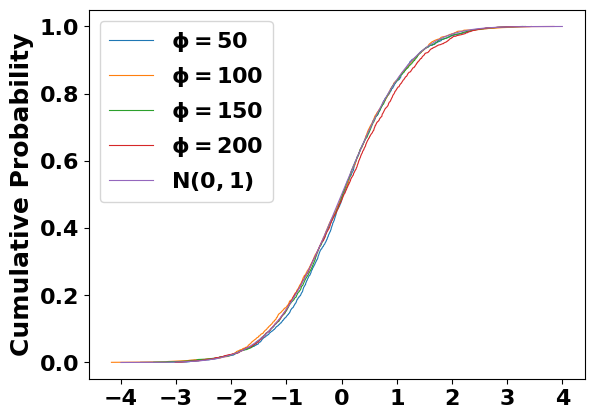

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Parameters
R = 2000
c = 3
phi_values = [50, 100, 150, 200]

# Normalize the test statistics for each phi value
normalized_data_sets = []
for phi in phi_values:
    center = n * (1 + 1 / (c - 1 / np.sqrt(phi))**2) + 1 / (c - 1 / np.sqrt(phi))**2
    variance = (4 + 4 * 2 * (-1 / np.sqrt(phi) + 1 / (c - 1 / np.sqrt(phi)) + 1 / n / (c - np.sqrt(phi)))**2) / (c - 1 / np.sqrt(phi))**4
    normalized_data = (eval(f"TestST{phi//50}") - center * np.ones(R)) / np.sqrt(variance)
    normalized_data_sets.append(normalized_data)

# Plot the ECDFs
labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)

## Figure 4: ECDF different $\eta$, Local

In this section, we display the comparison of ECDFs of normalized test statistics $\mathcal{T}^g_1$ (and $\mathcal{T}^l_1$, respectively) versus the
CDF of standard normal distribution. Here the normalizations are done with our theoretical value for the Global statistics and with calibration for the Local statistics).

### $T_1^l$ (bulk)

#### Data generating

In [37]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

n = 800
R0 = 2000
c = 1
phi = 100
m = int(n * phi)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)-2)
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)+2)



def simulate_local_test_statistics1(eta, E, m, n, R0):
    """
    Compute the test statistics for a given value of eta.
    """
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00) / np.sqrt(n * m)
        Et = jnp.array(extract_elements(E0, E-eta, E+eta))
        Eb = (Et - E * np.ones(Et.shape)) / eta
        t0 = jnp.sum(Eb)
        T0 = T0.at[r].set(t0)

    TestST = np.array(T0)
    Mean_x = jnp.mean(TestST)
    Variance_x = jnp.var(TestST)
    Normalize_TestST = (TestST - Mean_x) / np.sqrt(Variance_x)
    return Normalize_TestST

etas = [1/(n**(1/4)), 1/(n**(1/3)), 1/(n**(1/2)), 1/(n**(3/5))]

Normalize_TestST_1 = simulate_local_test_statistics1(etas[0], midb, m, n, R0)
Normalize_TestST_2 = simulate_local_test_statistics1(etas[1], midb, m, n, R0)
Normalize_TestST_3 = simulate_local_test_statistics1(etas[2], midb, m, n, R0)
Normalize_TestST_4 = simulate_local_test_statistics1(etas[3], midb, m, n, R0)


CPU times: user 7min 49s, sys: 9.81 s, total: 7min 59s
Wall time: 7min 46s


#### Saved data

In [ ]:
Normalize_TestST_1=[-0.7943488 , -0.52556723 , -1.2406352 , -1.0260749 , 0.9310118 , 0.74239916 , 1.7452494 , 0.103864394 , -0.9803271 , -0.14616255 , 1.5366857 , 1.7033273 , 0.54686826 , -0.8160309 , 1.2552731 , 0.30770865 , -0.88856757 , -0.22797708 , 0.27555668 , 0.2457412 , -1.9171287 , -0.8902606 , 0.7960158 , 0.9202063 , 1.375737 , -0.7521669 , 2.416863 , -0.3217039 , 0.08641457 , -1.0726358 , -0.5962268 , 0.5059683 , 1.1214638 , -2.656512 , 0.86422074 , -0.24242388 , -0.88265187 , 0.19292885 , -0.89416647 , -2.4442694 , -0.3539786 , -0.121699624 , -0.15228131 , 1.5305377 , 0.59707993 , -0.1583111 , -0.76002634 , 0.06977356 , 0.037636258 , 1.4011312 , -0.6321948 , -0.3872515 , 0.624361 , 0.36958644 , -0.34098828 , -3.030829 , 0.37803695 , -0.18480685 , 0.8167708 , 1.1519463 , -0.9742316 , -0.38230512 , -0.40807736 , -0.41481644 , -0.88300157 , 0.7062376 , 0.9429757 , 0.7604493 , -0.08642207 , -0.51400036 , -0.17760007 , -0.39944243 , 0.48895842 , 1.473096 , -0.80415666 , -1.4553603 , 0.20586221 , 0.23026349 , -1.5768367 , -1.3616003 , -0.66771376 , -1.0147537 , -0.14329207 , 0.8121129 , -1.38882 , 0.11090584 , 0.112022094 , -0.124409445 , 1.8784201 , -1.0451183 , -0.28889495 , -0.030271092 , 0.6660464 , -0.79572034 , -0.52793646 , -0.59837335 , 0.4574636 , -0.3787773 , 1.2262089 , 1.0154941 , -0.39432624 , 2.126295 , -0.56682724 , -0.42147925 , -0.67007774 , -0.82088286 , -0.30124706 , 0.5738327 , -1.7589798 , -0.32090977 , -0.13457651 , 0.20007908 , -3.0250738 , 1.4095961 , 0.1536649 , 0.709855 , 0.8699429 , 0.38373533 , -1.3702404 , -1.77355 , 0.97650856 , 0.9917973 , 0.16083807 , -0.46717495 , 0.45437604 , 0.6029437 , -0.7320976 , -0.049753852 , -1.1297187 , -0.05397722 , 0.1956949 , 0.42902383 , -0.832308 , -0.42170176 , -1.2063078 , -0.51421773 , -0.00011475943 , 1.3501347 , 1.1117554 , -0.124210544 , -1.9913868 , -0.63097453 , -1.1154985 , -0.4765002 , 1.2510502 , -0.72665006 , 0.20898806 , 1.4076383 , -0.44456574 , 0.27979887 , -0.65876174 , -0.4780036 , 0.8365045 , 1.3521166 , 0.10604919 , 0.6670632 , -0.920062 , 1.2546391 , -2.0337768 , -0.030994548 , -0.3253595 , 2.5002806 , -0.39895085 , 0.64540946 , -0.99479765 , 0.18640277 , 0.954174 , 0.1682297 , 1.2183688 , 0.6393991 , -2.1475966 , -1.270663 , 0.9234267 , -0.77563196 , -0.47845307 , 0.5403852 , 0.3712461 , 0.70651627 , -0.6974589 , -0.56150675 , -0.43719333 , 1.3923025 , 0.9515307 , 0.3194743 , -2.00241 , 1.1422896 , -0.81162864 , 1.4223878 , -0.96825457 , -0.659859 , 1.0542047 , 0.58694595 , -0.28006595 , 0.16324562 , 1.2884275 , -0.75029474 , 1.9484457 , -0.17292778 , -0.6231953 , 0.33218536 , 0.9959821 , -1.0664835 , 0.023969494 , 0.18979795 , 0.9320431 , 0.38328147 , 1.1598198 , 0.032997087 , -0.1940284 , -0.5077439 , 1.0709548 , 0.94395924 , -0.44951233 , 1.3452406 , -0.64175177 , 0.051028766 , 0.82360893 , -0.57043964 , 0.30096045 , -0.3491598 , -1.278083 , 1.044704 , 0.28326488 , 0.076952115 , -2.0423172 , 1.7623162 , -1.135166 , 0.76309776 , 0.1627915 , 0.17235813 , -0.08924504 , 1.8046021 , -2.434017 , -0.67866576 , -0.4025826 , -0.18911025 , -0.7035209 , 1.1944641 , -0.8646914 , 0.81111497 , -1.1953884 , -0.20319782 , 0.47330534 , 0.26767388 , -0.696262 , -0.70235723 , 0.19160454 , 0.4049872 , -0.43529284 , -0.38870773 , -0.5898852 , -1.1180991 , 1.0596284 , 0.40575835 , -1.2281693 , 0.5350132 , -0.61906266 , -0.7507816 , 0.2198976 , 0.5922281 , -2.5629983 , 1.1209437 , -0.12570037 , 1.1593235 , -0.43497518 , 0.1864928 , -0.17180242 , 1.6983006 , 0.28912425 , 0.8636204 , 0.22856101 , -0.02062402 , -1.0451987 , 0.06213659 , -1.4785273 , 0.4882304 , -0.7112665 , -0.2312921 , -1.242701 , 0.765675 , -0.002086732 , -0.22862978 , -0.3976503 , 1.0409968 , 1.0683349 , 0.57385164 , 1.0096203 , -1.9097515 , -0.45714948 , -0.5854544 , 0.86277354 , -0.35295275 , 1.2023423 , -0.75563824 , 2.0057647 , 0.27786 , 0.84984493 , -1.0512466 , -0.45280328 , 0.5744193 , 1.2458295 , 1.4715022 , -0.3327083 , 1.3469714 , 0.36792156 , -1.5121216 , 1.2445146 , -0.08833736 , -0.75740683 , 0.06903599 , -0.01239085 , 2.544378 , -0.4554187 , -1.0436473 , -0.5651483 , -0.60038805 , 1.7406101 , -1.2519844 , 0.9447398 , -0.3705822 , -0.38521373 , 0.07773248 , -0.27961227 , -2.4858034 , -0.705857 , -0.6457336 , 0.8769695 , 1.148475 , 1.2880818 , 0.46338877 , 0.7550395 , -0.095596045 , 0.14648572 , 0.72896 , 0.01280454 , -1.059357 , 0.48232347 , 0.021065885 , 0.84592915 , -0.98257345 , 1.7596489 , -1.5629762 , -1.838511 , 0.3523211 , 0.16024725 , 1.2468462 , 0.043206785 , -0.75140065 , -0.14988399 , 1.1816298 , -0.009019147 , -1.0631303 , 0.92438644 , 0.5888707 , -0.4246524 , -0.36494526 , 1.8781409 , -0.80672 , 0.19124983 , -0.28562254 , -0.26303223 , 0.3832908 , 0.9209203 , -0.6957795 , 0.07186869 , 0.12063319 , 0.71770054 , 0.9279571 , -0.79423046 , 0.18070439 , -0.728414 , 0.8927691 , -0.7533825 , 0.16688655 , 0.6482233 , -1.1038083 , 1.3941044 , 0.28405002 , 0.13020921 , 1.1676981 , -0.55330265 , -0.11550939 , 1.3542112 , -0.105507925 , 0.5710569 , 0.6422883 , 1.8831959 , 0.42824408 , 1.080393 , -1.0039061 , 0.7611732 , 0.3252198 , -0.6037081 , 1.4204065 , -0.5418676 , 0.43529925 , -0.7686807 , 0.9279284 , -0.56114745 , 0.7530488 , -0.031065572 , 1.089208 , -1.7094917 , -1.0111505 , 0.42992756 , 0.8747806 , -1.1874058 , -0.9114173 , 1.0023757 , 0.34001184 , -0.45220342 , -0.71759415 , 1.147974 , -0.23489043 , 0.12866738 , 1.7797136 , -0.24016352 , 0.5859671 , -0.062489204 , 1.4296423 , 0.26076016 , 1.0513437 , 0.33050656 , -0.24988146 , 1.3535821 , 0.4428659 , 2.0911782 , -0.5960185 , -0.69169897 , 0.67020774 , -0.72282416 , 0.21155117 , -2.1222122 , -0.7224744 , 0.7695008 , 1.1124883 , 1.873232 , -0.61367166 , 0.012383848 , 0.47263855 , 1.4696672 , 1.5951109 , 0.12253417 , 1.2298411 , -0.19728173 , 1.3373718 , -0.06669323 , 0.73593044 , -0.69199616 , 1.7465923 , -1.1829329 , 1.4354917 , 0.26857215 , -1.6585805 , 0.76447856 , 0.16437584 , -0.9507529 , -0.21345903 , 2.412687 , 2.4903126 , 0.6582579 , 2.8263202 , -0.5464971 , 0.8211495 , 1.362156 , 0.6329106 , 0.3197442 , -0.8290263 , -1.585689 , 0.878824 , 0.8363342 , 0.24530584 , -0.2344748 , 0.2598333 , -1.3283278 , -0.886487 , -0.8582934 , 2.273331 , 0.7766034 , -0.7628264 , -0.95224714 , 0.10928371 , 0.7104939 , 0.4150548 , -1.349466 , 0.3253571 , 0.50100774 , -0.6796587 , -1.1581341 , 0.40564933 , 0.9322133 , 0.357008 , -1.601072 , 0.55250025 , 0.26218346 , 2.189459 , -1.9038498 , 0.33980346 , -1.3211539 , 0.9623219 , -2.5893142 , -1.1537318 , 1.1782157 , 1.2054348 , 0.3533429 , -0.60808176 , 0.970257 , -1.0067713 , 0.07222814 , -0.6248225 , -1.3297985 , -0.5966001 , 0.16365184 , -0.7717824 , 0.6646324 , -1.8698866 , -0.964845 , 1.2427558 , -2.861099 , -1.0569549 , -1.3194089 , 0.5448633 , -0.9304136 , -0.34335792 , 0.51999915 , 2.1995552 , 0.04666802 , -1.6626804 , -0.16641623 , -0.7670206 , 1.1919813 , 0.059876245 , 1.0728124 , -1.4242157 , 0.84657216 , -0.61326474 , -0.87839574 , -0.87036633 , -0.32321718 , -1.6924961 , -0.88032037 , 0.2630586 , -0.19584455 , -1.880262 , 0.42542544 , -0.2674019 , 0.014119188 , 0.032930844 , 0.37511465 , -0.13742794 , 0.2719155 , 0.72001314 , -1.0682852 , 0.7266238 , 0.5638078 , 0.38150823 , 0.4066517 , 1.0011555 , -0.87694883 , -0.056880828 , -3.244878 , 0.032387 , 0.21441694 , -0.78016245 , -2.3428628 , -1.5097146 , 0.21928762 , 0.12644044 , -0.10938091 , 1.1147585 , 1.6244636 , 1.339968 , 1.1610829 , 0.02505718 , -1.3128641 , -0.1959153 , -1.3847389 , -0.5039892 , -0.40694267 , 2.1970253 , -0.17027047 , 2.4895275 , 0.6000307 , 0.09739071 , -0.06640464 , 1.4698948 , -1.0691271 , 1.4106842 , -0.39944744 , -0.2134078 , 1.0036714 , -0.7411012 , 0.9305016 , -0.16832685 , 0.026428623 , 0.05148247 , -0.08318758 , -1.4453306 , -0.351638 , 0.4248344 , -0.6137282 , -0.77238303 , -0.7685102 , -1.1940836 , -2.1771147 , 1.307603 , -0.37122986 , -0.8335942 , -0.16963217 , 1.3090451 , 0.40914375 , 0.7238952 , 1.45043 , -1.4681287 , 0.7414867 , 0.13065833 , 0.74528855 , 0.56851256 , -0.11161791 , -0.23499468 , -1.9745519 , -0.80731565 , -0.15331715 , -0.9097293 , -0.38039482 , -2.0231838 , -1.4443183 , 1.1368797 , 0.5195353 , -0.80346143 , -0.47593737 , -0.31686652 , -2.684134 , 0.23437732 , 1.5107191 , -1.1431199 , -0.0778105 , 1.5762148 , 2.6700957 , -0.6404655 , 0.23122844 , 0.25343522 , 0.17966405 , 0.9683233 , 0.5172935 , 1.45733 , -3.1963644 , 0.59323066 , -0.54737264 , -1.5008099 , 0.96021265 , 1.2739048 , -0.44536978 , -0.5744972 , -0.30942303 , 0.039854087 , -0.08972325 , 0.51217264 , 1.1271197 , -0.56834954 , 0.12461515 , 0.32312495 , -1.3603283 , 0.9288176 , -0.55277294 , 0.26072702 , -0.81496173 , 1.0551454 , 1.8806612 , 0.040170636 , -0.6273902 , 0.5237015 , 1.4314438 , -0.09713299 , -1.4111451 , 0.86031944 , -0.69348145 , -0.0055341274 , -0.3755711 , -0.56378174 , -1.1855146 , -0.49236068 , 0.61403793 , -0.15555905 , 0.34876007 , -0.5021782 , -0.6082333 , -0.036853448 , 1.3382324 , -1.3379273 , -1.3023282 , -1.5137249 , 0.47722116 , 0.69431144 , -1.8071581 , 0.088689394 , 1.2691903 , -0.43274334 , 2.175452 , 0.32396215 , 0.7353962 , -0.05357498 , 0.12149391 , 0.0033657022 , -1.0660721 , -0.72746325 , -2.1712837 , -0.13871413 , -0.74137574 , 0.48421994 , 0.5440976 , 0.33280042 , -0.5999151 , 1.1591485 , -1.0139263 , -0.14865947 , -0.61412084 , -0.38624418 , 0.4699244 , -0.19984502 , 0.23141752 , 0.32399955 , -1.5172762 , 0.44810978 , -2.2236753 , 0.7692546 , -0.07664735 , -0.75723165 , -0.14340566 , 0.20342693 , -0.33644423 , -0.92090875 , 1.6124852 , -0.6098461 , 0.68860793 , 0.14035267 , 0.52621263 , 0.4073609 , 0.25359115 , 0.7283923 , -1.3344469 , -0.40530178 , -0.3894361 , 0.08319903 , 0.6049251 , -0.016074823 , 1.4924517 , -1.0851862 , 0.6932376 , 0.9833228 , 0.12760353 , 0.9879054 , -0.7112385 , 0.28908148 , 1.1375512 , -0.2420932 , -2.0970876 , 0.13826244 , 1.3268073 , 1.4565543 , -1.277634 , -0.43655536 , 0.40207428 , 0.33898556 , -0.16811883 , -2.3918922 , 0.7062753 , 1.86377 , -1.0945404 , 1.2687265 , 0.026523432 , -0.8160405 , -0.8147304 , -0.39910677 , -1.0356982 , 1.972289 , 0.4125251 , -1.0952164 , 0.940077 , 0.9268456 , -0.116880946 , -1.9606632 , 0.7056938 , 0.0070209983 , -0.53619343 , 1.5186068 , 1.2431577 , 0.7511055 , 0.75255233 , -0.036262535 , -0.41341665 , 0.21205255 , 0.13622424 , -1.4385017 , 0.5951597 , 0.6777934 , 0.35605267 , -0.857929 , -0.25707397 , -0.21565364 , 1.4328574 , 1.935933 , 0.37044713 , 0.33271518 , -0.73499155 , 0.31619224 , 0.48855183 , 0.41694653 , 1.6540571 , -0.06793175 , -0.7010523 , -0.058290064 , 0.5987873 , 0.8574963 , -1.0499508 , 0.58592474 , -0.6877357 , -0.8680634 , 0.9284911 , -0.09761059 , -1.797587 , -2.1476963 , -0.24845761 , 0.9463759 , -0.15087241 , -2.7476573 , 1.4042476 , -0.5946707 , 0.16927491 , 0.8599269 , 0.35388172 , -0.43482402 , -0.56009287 , -0.7718205 , 0.098005466 , 1.1235209 , -0.72382194 , 1.0242418 , -0.44971573 , -0.08668694 , 1.0147792 , 0.7049468 , 1.0161794 , -0.15288207 , 0.4608539 , -1.349792 , 0.18979831 , -1.6334271 , 0.9040523 , -1.0014656 , -0.9296239 , -0.53045213 , -0.83790225 , -0.45432168 , 0.7254512 , 0.38071376 , 0.42714205 , 0.8408078 , 0.3103759 , 1.4292213 , 1.4287574 , -0.18203107 , -0.4944558 , -0.6685031 , 1.4096434 , -1.847822 , -0.86461556 , 0.90728223 , 0.02430049 , 1.6902663 , -0.29520288 , 1.1072059 , -0.37970883 , -1.1693182 , 0.8000067 , -0.6309984 , 0.0349266 , -2.078299 , -0.11282341 , -1.0659251 , 0.3071647 , 1.0705808 , -1.9469825 , 0.15090746 , 0.29136086 , 0.37884593 , -0.9690061 , -0.1365202 , -0.13559313 , 0.28835818 , 0.065640725 , 0.5098127 , 0.7547086 , 1.0660934 , 0.89951265 , 0.05078252 , 0.08723756 , -0.6696902 , -1.3043519 , -0.13691272 , -0.41812193 , -0.5012698 , 2.014603 , 1.0025085 , 1.3853655 , -0.063751616 , -0.6910175 , 1.102132 , 0.9345871 , 1.2698236 , 1.5259696 , 0.81715405 , 0.10146709 , 0.9446547 , -0.85138905 , 0.8470597 , -0.73602235 , -1.328025 , 0.18021278 , -0.6642991 , 0.7227837 , 1.8174121 , -0.34112588 , 0.40247592 , -0.6205287 , -0.8930837 , 1.1706303 , 1.5373708 , 0.8692807 , 0.8158202 , -1.6198364 , -0.35780907 , 0.8400892 , -0.560325 , 0.020526767 , -1.2754017 , -0.83983624 , 1.0661453 , -0.024473434 , 0.3394207 , -0.47731802 , 0.94667405 , -1.1423637 , 0.40126115 , -0.37010464 , -0.021914994 , 0.4081937 , -0.37222773 , -0.45067105 , -0.110473424 , -0.7959329 , -0.71222216 , -0.1369649 , 0.07130573 , -0.19125678 , -2.0948975 , -2.3965645 , 1.0603758 , 1.3711171 , -0.79059917 , -0.5248156 , -0.9682688 , -0.85067 , 0.8379469 , 0.033337753 , -0.83960927 , -1.5964329 , -0.030848112 , -0.34326306 , -0.18754008 , -1.3282144 , -2.1340861 , -0.76096267 , -0.45071808 , 1.2446755 , -0.41005933 , 2.2843213 , 0.981507 , 1.0501424 , 0.26087365 , 0.19346792 , -2.0877998 , -0.75233275 , 0.5997375 , 1.1255113 , 0.68896246 , 1.7025049 , 1.8794934 , 0.5013952 , 2.3624377 , -0.20667817 , -0.06567652 , -1.2775629 , -0.98917025 , 0.7761872 , 1.5659437 , 0.6816899 , 0.44967046 , 0.47493207 , 1.3939148 , 0.033285625 , 0.36374182 , -0.34628022 , 1.0288813 , -0.034101333 , -0.7119287 , -1.9838016 , -0.94246775 , -0.6641857 , -0.46344352 , 1.1663034 , 1.9945477 , 0.72878027 , -0.68390054 , -1.637712 , 0.15168768 , -0.03410617 , 1.9387846 , 1.766657 , -0.7467007 , 0.3351554 , 0.58410394 , 0.4989361 , -0.86488056 , -0.1182904 , 0.00854377 , -2.2289197 , -2.0296862 , 1.3913332 , -0.097511224 , 1.3315074 , -0.5523 , -0.3344577 , 0.55184805 , -1.1090627 , 0.06999619 , -0.788877 , -1.3384566 , 1.3303208 , -3.6805427 , -0.0085841715 , 0.951956 , 1.2874391 , -0.84806466 , 0.98322856 , 1.0596616 , 0.8932278 , -0.5129745 , -0.020964518 , 0.2614506 , -0.43471554 , 0.19200191 , 0.29460463 , -1.7344652 , 0.16466413 , 1.4448264 , 0.85763395 , 0.37653792 , 0.20699239 , -2.3895652 , -0.66162264 , 3.287445 , 0.30012366 , -1.156895 , -0.48309234 , -1.0228261 , -1.5613024 , 1.5428709 , -1.5604177 , 1.9686387 , -0.6919634 , -0.23769984 , 1.0190547 , -1.7052922 , 0.85581744 , -0.9268574 , 0.6138582 , 0.2592421 , -0.16863383 , 0.5247796 , 0.39320734 , -0.32109877 , -1.4884863 , -0.9345043 , 0.3035521 , -0.6952549 , 0.9946909 , 1.6384988 , -0.7305322 , 1.2446848 , -1.7828369 , 1.1612576 , 0.23643921 , -0.8920954 , 0.6445725 , 0.41298833 , 0.6446101 , -1.2634611 , 1.11202 , -0.024950756 , -0.29210585 , -1.1696637 , -0.45277518 , -1.6324677 , 0.99218524 , 0.6860449 , -1.1465957 , -0.5876487 , -1.2941049 , -0.6293476 , 0.20276959 , 0.66090596 , 0.6683636 , 1.3269064 , 1.0468227 , -0.10981593 , 0.074838154 , 0.42131117 , -1.2307185 , -0.66550994 , -0.92131054 , -1.3567057 , 0.005257204 , 0.8228288 , -0.85128504 , -0.10028746 , 0.59692836 , -0.5829857 , -0.31261495 , -1.5684994 , 0.87273294 , 0.64021236 , 0.95668036 , 0.89952207 , 0.39775148 , -0.80503136 , -0.63308364 , 0.24531044 , 0.37126535 , 1.5367846 , 1.0930622 , -0.34400102 , -0.97019345 , 0.4402407 , 0.15355118 , 0.15214683 , 0.9750471 , -0.726418 , -1.0192794 , 1.0789462 , 1.2799579 , 0.62769973 , 1.3387855 , -1.1536655 , 1.7052234 , -1.8556814 , -0.23872595 , 1.3450233 , 1.2144439 , 0.752576 , -0.10918201 , 0.4109264 , 0.21328178 , -1.6923825 , -0.6656984 , 1.2828374 , -0.9580826 , -0.683494 , 0.04224242 , 0.6013974 , -0.4693879 , -1.2786934 , -1.4400009 , 0.11491125 , -0.37323 , 0.96520203 , 2.4998693 , 0.07824798 , 2.2435863 , 0.33249763 , -0.5638761 , 0.55721533 , 0.4655885 , -0.3085483 , 0.17860484 , -0.6707494 , -0.7538127 , -1.0248878 , 0.02671227 , -0.9862435 , 1.5091724 , -1.4396794 , 0.02919063 , 1.0466954 , -0.15524183 , -0.80373573 , -0.5325423 , -0.30674678 , -1.0027797 , -0.3773207 , 0.6001305 , -0.401812 , 0.05766264 , -1.2311485 , 1.7193162 , 1.7677827 , -0.0050563617 , -0.6711609 , 0.40713894 , 1.8390992 , -0.6360201 , 0.6812735 , -0.38213006 , 1.925974 , 0.4631523 , -0.8942848 , -0.8411744 , 1.0133042 , -1.2371964 , 0.64307314 , 1.5160865 , 1.0317987 , 1.8018731 , -1.7295661 , 1.6927868 , -2.0299842 , -0.11543859 , 1.8131799 , -0.45052457 , -1.6101991 , -0.4032491 , 0.1430671 , 0.08033821 , -0.75405866 , -1.0537012 , 0.100379236 , -1.8452163 , 1.1510621 , 0.5485565 , 1.0980037 , 0.20708239 , -1.289735 , -1.2904634 , 0.34817377 , 0.3213611 , -0.6729958 , 1.5585665 , 1.0567108 , 0.29827 , -0.88594306 , 0.5079921 , 0.2466679 , 0.26271287 , -0.6345877 , -1.308887 , 1.9150406 , -0.4031453 , 0.46999058 , -0.65821755 , -1.3054068 , 0.19202061 , 2.6103318 , -1.1743643 , 0.08631529 , -0.038645696 , -2.3981678 , -0.40373173 , -0.2818871 , -0.07380565 , 2.5201986 , -0.5579795 , -2.982665 , 1.8342664 , 1.9291705 , 0.9221123 , -0.10695023 , 1.266064 , 1.0200149 , -2.2265975 , 1.1995997 , 0.93642634 , 1.207918 , -0.72888666 , 1.1907 , -1.328233 , 0.56731635 , 1.0994747 , 0.46010718 , 0.7483345 , 0.636727 , -0.28370765 , -0.82483125 , -0.9455939 , -0.06840968 , -0.37538177 , 0.62645656 , -0.13650598 , 0.33566114 , -1.69836 , 0.40645334 , -0.5285515 , -0.11881974 , 0.19357611 , 0.78165853 , -0.6805759 , 0.5377749 , -0.3026421 , 0.6405625 , 0.4977448 , -0.9282718 , 1.0682212 , -0.10403245 , -0.19934335 , -1.3312216 , 0.25197804 , -0.8638022 , -0.2688867 , -0.9292739 , 0.347304 , -1.3939084 , -0.58943605 , -0.562689 , -0.33922452 , 0.45594546 , 0.85868764 , -0.33922946 , -0.14928356 , 1.5254686 , 0.23269385 , 1.4708213 , 1.116106 , 0.44891384 , 0.86340755 , -0.98813945 , -1.2102941 , 0.015386766 , 0.5853571 , 1.4068296 , -0.6579577 , -0.8785659 , 1.2575948 , -1.2992216 , -0.014207106 , 1.1502203 , 1.1344072 , -0.21700642 , 0.20594743 , 0.12703143 , 1.0097438 , -0.74502146 , 0.7846524 , -0.23886305 , 0.39889184 , 1.7797419 , 0.2559981 , 0.4213635 , -1.0117702 , 0.049046732 , -0.009804346 , 1.4960499 , -1.4490566 , -0.1590723 , 1.2875856 , 0.8213012 , -0.99857193 , -0.06151978 , -1.0165651 , -1.5931749 , -0.34492743 , 0.1998046 , 0.8737638 , 0.33719346 , -0.46483865 , -0.5873455 , -0.950469 , 1.748933 , 0.51981944 , -1.9068953 , -1.7644043 , 0.8095549 , 0.48942667 , -0.08492775 , 0.88775647 , 0.19153357 , -1.7862179 , -0.20243135 , -0.80026007 , -1.1143022 , 0.38672918 , 0.7811386 , 1.3390317 , 0.043268416 , -2.0712907 , -0.8507839 , 2.4580898 , -0.293345 , -2.7413397 , 0.1291499 , -0.008087678 , -0.57199585 , 0.58329064 , -1.1578603 , -0.26133952 , 1.5933001 , 0.92004555 , -0.81559104 , -1.5824119 , -0.14610098 , 0.55470926 , 0.5280331 , -0.7685105 , -1.5169263 , 0.9126211 , 1.2093883 , -0.020756286 , -0.9094366 , 1.1806461 , 1.5342122 , -0.286365 , 0.05772955 , -0.65003204 , -0.30955073 , 1.2682587 , 1.4134407 , 0.21061955 , 1.1286755 , 0.14415471 , 0.2956925 , -1.5608529 , -0.9414461 , 0.22457467 , -0.44368124 , -0.5179441 , -1.518742 , 2.3693562 , -0.7208568 , -1.604387 , 0.62583137 , -1.243841 , -0.4138141 , -0.15458912 , -0.35031897 , 0.26713023 , -0.89387816 , -2.6693704 , -0.64760613 , 0.40128395 , -0.1909025 , -0.40536326 , 0.5086118 , -1.6076881 , -0.40136763 , -1.1083722 , -0.67527544 , -0.16053805 , -1.7700549 , 0.95007414 , 1.6138327 , 1.063705 , -0.33677974 , -0.3253642 , 0.7830914 , -1.1338845 , 1.0984007 , 1.3810573 , -0.5353752 , -0.19652978 , -0.17354265 , 1.1081991 , 0.32399955 , 1.2153182 , 0.006430029 , 0.81114817 , 1.7384917 , -0.49156174 , -1.0576689 , 0.61230725 , 1.2184964 , -1.2860702 , -1.4370359 , -0.9741847 , 2.2234788 , -0.9464733 , -0.00036539623 , 0.7861985 , -1.1986136 , 0.25167552 , 0.5141446 , -0.14418103 , -1.3188084 , 0.62085706 , -0.7373325 , 0.20127055 , 0.86158663 , 1.4301244 , -0.7228813 , -1.1375542 , -0.32574722 , 1.3577484 , -2.7018244 , -1.5239108 , -0.86538196 , 0.10898575 , -1.6608126 , 0.20098208 , -0.50643903 , -0.10653404 , -0.001869106 , 0.4444308 , -0.08165064 , 3.0630257 , -0.8385314 , -0.8761351 , 0.42944014 , -1.1516792 , 0.4089642 , 0.30866876 , 0.49003187 , 0.09602855 , 1.1635041 , 0.11197942 , -0.39254808 , -0.15123153 , 0.6899699 , 2.0127635 , -2.0905144 , -0.0012261197 , 0.57947433 , 0.79832345 , 1.0360599 , -1.4589401 , -0.6877926 , 1.0498449 , 0.10509393 , -0.34042582 , -1.4567885 , -0.13399005 , -1.6230569 , 0.79776543 , 1.9407139 , -0.43786523 , 1.688318 , 0.23602791 , 0.4062166 , -0.4129436 , -1.3573347 , -0.3769094 , -1.3956153 , 0.99446416 , 0.20133655 , 1.4064989 , 0.05623462 , -1.0746453 , -0.8123373 , -0.47782898 , 0.9340622 , 0.13669714 , -0.5373939 , -0.25618044 , -1.0712689 , 1.8401961 , 0.39508006 , -1.5979232 , -1.308873 , -1.2697177 , -0.7906604 , 0.66354454 , 0.19322181 , -0.90008265 , 1.0452286 , 0.619268 , -0.3567785 , -1.4208301 , -0.34177357 , -0.53637284 , -0.04414559 , 1.0834436 , -0.99731845 , 0.033568993 , -0.55130666 , -0.66115916 , 0.7483533 , -0.9176031 , 2.1533682 , 1.3230096 , -0.18483043 , 0.899938 , 1.5881073 , -0.6833755 , 0.58500713 , -0.13308692 , -0.6857307 , -0.428199 , -0.60591125 , -1.4608978 , -1.2299572 , 1.8533897 , 0.1358038 , 0.019614136 , -0.9447565 , -0.43033192 , 0.4376498 , -0.33241037 , -0.4341908 , -0.6881186 , -0.071346074 , -0.50181395 , 0.21800159 , 0.89250416 , -0.48759425 , 0.19393612 , -0.7714661 , -1.5053167 , 0.38561723 , -1.3626735 , -1.2665395 , -0.469369 , -0.7057292 , -0.5525364 , 0.8334589 , -0.18750234 , 1.8261089 , 0.4865892 , -0.104382396 , 0.62517434 , -0.48573554 , 0.8181186 , 2.82675 , -0.92370373 , 1.0561057 , 0.885884 , -0.0896948 , 1.0378282 , 1.1747206 , 0.43142176 , -1.2896972 , -0.7533684 , -0.34112555 , -0.2686412 , 0.5875233 , -0.7542667 , -0.23535891 , 1.1042175 , -0.10913055 , 1.3548213 , -0.69944906 , -0.1349642 , -1.2811003 , 0.10055888 , 0.65029436 , -2.436467 , -0.20351921 , 0.4160908 , -1.2344495 , 1.4466234 , -1.7140788 , 0.8384909 , -0.6382144 , -1.6530099 , -0.018874342 , -1.8593746 , -0.50572944 , 0.23612267 , -1.4230856 , -0.96349233 , 0.31640062 , 1.0597749 , 0.46444827 , 2.031637 , 1.2909147 , -0.3586227 , -0.23828141 , -1.1261762 , 1.0632699 , 1.0159667 , -1.8544565 , 0.8445721 , -0.040296175 , -0.40146166 , 0.92134595 , -1.3775035 , 1.6867951 , -0.165726 , 0.8346273 , 0.95536137 , 0.22247946 , -0.52543473 , -1.0349894 , 0.2559037 , 0.1341673 , 0.5947865 , -0.4832057 , 0.728832 , -0.39089778 , -0.8258668 , 0.293555 , -0.1694476 , -0.75597847 , 1.339613 , 0.3556406 , 1.2265306 , 1.049121 , -0.7485116 , -1.1441936 , 2.701543 , -0.7821105 , 0.7764382 , -0.002351429 , 0.5465423 , -0.6353677 , -1.4752785 , 0.87148386 , -0.5601449 , 1.466603 , 1.695052 , -0.40526843 , -0.12083884 , 0.5947011 , -1.004246 , 0.17685978 , -2.0610151 , 0.020333203 , -1.2830486 , 0.6396826 , 0.50104976 , 0.037603136 , -1.2676225 , 1.3669133 , -0.13867635 , -0.49886778 , 0.42870724 , -1.2816157 , -0.7110305 , -0.86353767 , 0.7665449 , -1.0478137 , 0.29711148 , -1.4284384 , 0.17378625 , -1.8969738 , 1.5728517 , 0.7656465 , -2.0442367 , 0.4744311 , 0.9600946 , -0.66670144 , -0.8252426 , -0.41010624 , 0.90183914 , 1.0632652 , -1.5823221 , -0.742175 , -0.48913097 , 0.19260684 , 0.74931294 , 0.50420433 , 0.68136305 , 0.32871422 , 1.6121777 , -1.3929058 , 0.79376 , 1.9101985 , -0.5891803 , -0.029273212 , -0.44755426 , -1.0835971 , -0.81385577 , -0.87563425 , 0.86364377 , 0.40534657 , -0.25176328 , -0.09746865 , 0.68373686 , 0.15190066 , 0.15433142 , -0.8668712 , -0.40775114 , -0.37256345 , -1.1770687 , 1.9567499 , 1.1337067 , -0.907748 , -0.51028806 , 0.25378045 , -0.15272145 , -0.6762303 , 1.1088474 , -0.6284968 , -0.043143265 , -1.0445977 , 0.07823847 , 0.11059358 , -2.053856 , -1.4176332 , 0.148737 , -0.06449891 , 1.4250218 , 0.18076588 , 0.99113023 , -0.50321376 , -1.1289523 , -1.6388278 , -0.23049256 , -0.026350765 , -0.65608054 , 0.7358689 , 0.8301445 , 2.11732 , -0.017455714 , -0.05512137 , -0.4746935 , -1.5721455 , -0.81750184 , -1.9731424 , -1.0230343 , 1.024403 , 1.5658063 , 0.5337361 , -0.95724076 , -1.605097 , -0.088540874 , -1.4526365 , 0.85346717 , 0.8231738 , -0.5864803 , -0.46237496 , -0.6737147 , 0.690613 , 0.3110331 , 1.7462422 , -0.44534156 , -0.6138936 , 0.8415503 , -0.86764234 , -1.0231711 , -0.2788179 , 1.8288374 , 0.13668779 , 0.71237063 , -0.8974723 , 1.2609994 , -0.80784976 , 0.09560291 , 0.18573129 , 0.9376371 , 0.7238666 , 0.37697792 , -0.09282032 , -1.021691 , 0.94472986 , 0.51287717 , 0.86667055 , -0.91276056 , 0.8012032 , -1.5860059 , -0.74543303 , 1.9837798 , 1.9662739 , -1.8905004 , 0.31073517 , 0.081364736 , 0.6038899 , 0.19612522 , -0.013227955 , 1.9531515 , 0.82595897 , 0.39267293 , 0.11826376 , 0.65915656 , 0.8460474 , 0.644998 , 0.07509829 , -0.5861732 , -0.65250546 , 0.259266 , 1.3583871 , 0.65846103 , 1.2169688 , 1.1498326 , 1.2391335 , 0.8374836 , 1.5902166 , 0.9886672 , -1.2192508 , 1.6687499 , -0.6329705 , -1.1504592 , -0.70434386 , 0.041769154 , 0.08842936 , -0.2936666 , 0.44532508 , 2.318776 , -0.88262343 , -1.3958234 , -2.3710995 , 1.2410864 , -0.5680422 , -0.27956012 , -0.37339583 , 0.740243 , 0.081208386 , 0.43447176 , -0.77794427 , -0.26354793 , -0.62568325 , -0.71660095 , -1.3877373 , 0.86137414 , -0.6316463 , -0.20409133 , 0.73892844 , -1.5595901 , 0.1498954 , -0.14724979 , -0.48596716 , -1.2670126 , -0.4486045 , 1.0528573 , -0.060403362 , -1.1981409 , -1.1046553 , -1.3354825 , 0.02576174 , 0.2984685 , -0.73062205 , 0.121640354 , -0.21647157 , 0.15040159 , 1.3629359 , 0.64461464 , -0.015691698 , -1.4224805 , -0.09950698 , -0.4167078 , -0.45775968 , -0.11384024 , 1.5180821 , -1.326039 , 0.85736847 , 0.54421586 , -0.50337934 , 1.0187992 , -2.3176386 , -1.5735172 , 0.5574945 , 0.0010581764 , 1.3807783 , 1.1820979 , -1.1331705 , -0.8919349 , -0.7621831 , -0.025494765 , 0.445008 , 0.011097431 , -0.45592976 , 0.67279935 , -1.1749125 , 1.4114641 , -0.08586867 , 0.3562791 , -0.048519954 , -1.3040593 , -2.3012338 , 1.9201906 , -0.75694335 , 2.1142602 , -1.292615 , -0.62538934 , 0.01930209 , -0.6450055 , 0.19040322 , 1.1784139 , -0.9379941 , 0.5710897 , -0.26830992 , -0.34412828 , -0.7693047 , 0.29947087 , -0.09949781 , 0.056570727 , 0.29966965 , -1.1790409 , -1.4787828 , 0.80883586 , 1.71017 , 0.59503233 , 0.35952836 , -0.6061053 , 1.4973925 , 0.08740356 , -0.61796093 , 1.1926149 , -0.33144566 , -0.501237 , -1.2468393 , -1.3070713 , 1.1275593 , -1.9745989 , 0.0889968]

In [ ]:
Normalize_TestST_2=[-1.8045385 , 0.79259545 , 0.36470708 , -1.3110297 , -0.7011114 , -0.6926685 , 0.53221065 , 0.7015761 , -1.0871959 , 0.4539519 , 0.67984825 , 1.5873923 , 0.6449142 , 0.49014467 , -0.071370676 , -0.07318006 , -0.888499 , -1.0872835 , 2.0218709 , -1.5817975 , 0.1627499 , 1.2215675 , 0.6543186 , -1.3851544 , 0.46814597 , -0.9968323 , 0.3454787 , -0.0055318396 , -0.55866563 , 0.45550776 , 1.774841 , 1.6772319 , 0.48330134 , 0.7092321 , 1.2458037 , -1.8823166 , 1.1364126 , -0.39440456 , -0.7750528 , -0.71994644 , 1.222896 , 0.42864922 , -0.2055837 , 0.20919447 , 0.9547853 , -1.7303175 , -0.92860705 , -0.6051977 , -0.3522686 , 1.090877 , 0.87658733 , -0.34830055 , -1.165813 , 1.388608 , 2.100322 , 0.9797728 , -0.21892112 , 1.5906525 , 1.272985 , 0.034812517 , -0.2357279 , 0.7419815 , 1.3462884 , 0.024979815 , -0.97523564 , -0.93978566 , -0.8045941 , 1.1300677 , 1.016796 , -0.49362186 , 0.5948508 , -0.103228346 , 0.14717494 , 0.9441658 , 0.0015652536 , -0.6583725 , -1.2441853 , -1.3732764 , 0.32808584 , -0.418833 , -0.9835912 , 0.7839777 , 0.42910418 , -0.68479365 , 0.67616874 , -1.9121815 , 0.12470431 , 0.09395663 , 1.524018 , -0.0368212 , -1.269654 , -1.7471598 , 1.4318627 , -1.4971498 , -0.35708442 , -0.39327675 , -0.7462016 , -0.1896941 , 0.18606839 , 1.0416093 , -1.3562858 , -0.11120821 , 1.2166291 , 2.271243 , 0.4825933 , 0.3046365 , -0.77708024 , -0.18088394 , 2.332196 , -0.7726051 , 1.1231192 , 0.40694764 , -0.98352975 , 0.220356 , 0.5209183 , 0.03975067 , -0.2800143 , -1.0762013 , 1.7793858 , 0.011878472 , -0.17141871 , 0.9720295 , -0.55735445 , 0.020531096 , 1.0796633 , 0.25658327 , 0.86436886 , -0.63629484 , 1.3617673 , 0.6510759 , -0.7511397 , 0.78105843 , 0.24599026 , 1.9106795 , 0.20395067 , -0.29747665 , -1.1435784 , 0.43394607 , -0.38266656 , -1.4904023 , 0.66672033 , -1.3327924 , 0.5169679 , -1.3177942 , 1.0444235 , -0.7739336 , 0.5695484 , -0.047589015 , -0.60566986 , 0.5596547 , 2.5163763 , 0.12690662 , -1.5201273 , -0.29194424 , 0.6885359 , -0.7921045 , 1.689634 , 0.12785059 , 1.1610076 , -0.676945 , 0.4326522 , -0.3869229 , -1.3433765 , 0.066600226 , 1.0307016 , -0.0067379563 , 0.42663047 , 0.04641947 , -2.4589002 , -0.52930754 , -0.56191677 , -1.0940309 , -1.5263242 , 0.11418128 , 1.1092135 , 0.03109784 , 1.1542689 , 0.12577057 , 1.847034 , -0.2851534 , -0.13914149 , 0.3609136 , 0.5592613 , -0.061389774 , -0.06091779 , 0.6524043 , 0.6253803 , -1.2693481 , -2.0421205 , -0.86782 , 0.9030264 , 0.3991867 , 0.21696454 , 0.793548 , -0.040754143 , -0.6528484 , 1.8091635 , -0.029479614 , 2.0071528 , -1.4893534 , 0.5015156 , -0.78404623 , 1.6481274 , -0.45507804 , 1.8963546 , -0.5766613 , -1.0909892 , 0.32310402 , -0.5643554 , -0.8397029 , -1.3361136 , -1.0719446 , -1.002933 , -0.8248274 , -1.3795081 , -1.3980021 , 0.6840348 , 1.2063599 , 0.09920948 , -0.1560097 , -0.42948726 , 0.104855545 , 0.40819767 , -0.8734399 , -1.2157451 , -0.69473124 , -1.5683028 , -1.3599743 , 0.6056625 , -0.30804366 , -0.42381474 , -0.39342543 , -0.8382523 , -0.32459718 , -0.9926283 , -0.3063568 , -1.8067061 , -0.14553049 , 0.35564345 , 0.5234707 , -1.0331733 , -0.058592908 , -0.694705 , 1.3176035 , 0.54439443 , -0.3601694 , 0.962022 , -0.039058626 , 1.3641181 , -0.17570993 , 1.429835 , 0.04946085 , 0.6878628 , -1.1323998 , 0.19012383 , -0.06785715 , -0.40252396 , 0.38241452 , -0.43935475 , 0.07035838 , 0.55275863 , 0.7008768 , 1.2996079 , 0.74814314 , 0.34282187 , -0.711145 , 0.3099765 , 1.6539918 , -0.27378246 , 0.0124903275 , 1.6833149 , 1.4279908 , -0.3201485 , -0.55440927 , -0.10940754 , 0.30252132 , -0.41329175 , 0.5946762 , -1.375881 , -1.0101786 , -0.36653224 , -0.8153793 , -1.1107417 , -0.44693226 , -0.44687995 , 0.070970155 , -0.90858376 , -2.4679284 , 2.1398096 , 1.11146 , 0.48027727 , 1.3020025 , -0.24656604 , 0.6901527 , 0.7078513 , 1.2759746 , 0.50083387 , -0.8805015 , 0.55725986 , -0.1320619 , 0.7137074 , -1.7450272 , 1.0932804 , -0.391931 , 0.6996971 , -0.677933 , -0.28294206 , -2.0412724 , -0.08105482 , 0.62212 , 0.43457523 , 0.74225235 , 1.0176699 , -2.0426362 , 2.8657959 , 0.96633923 , 0.48451605 , 0.1699866 , -1.5510322 , 1.8511156 , 1.0642023 , 0.96576256 , -0.31481728 , 0.3422624 , -1.0113146 , 0.5629933 , 0.6550701 , -0.117938206 , -0.16281855 , 0.09927926 , -1.5923905 , -0.8398341 , 1.6922647 , -1.042604 , -1.7173913 , -0.030073874 , 0.38122553 , -1.697114 , -0.70634675 , 1.6193376 , -0.9671597 , 2.260877 , 1.4337677 , 0.96511596 , -1.343761 , -0.09065127 , 0.51249295 , -0.5176659 , 0.12230949 , -1.1721232 , 0.029551078 , 0.908655 , -0.4025851 , -1.5933869 , 0.07332116 , 0.08871253 , -0.6508559 , -1.0260504 , 0.63376176 , 0.48096755 , 0.31791267 , 1.000828 , 3.0477126 , -1.5654885 , -0.75263405 , 0.7159971 , -1.8036122 , -0.8404633 , -0.63261545 , 0.70024776 , 0.5561846 , -0.018344482 , -0.08561726 , 1.319028 , -1.1763797 , -0.73412275 , 0.1413102 , 0.519791 , -0.4889458 , 2.8201468 , 0.27352184 , 0.22717302 , 2.2945788 , 1.7927842 , -0.38297236 , 0.7686564 , -1.6556163 , -0.020704506 , 0.7536409 , 0.18525547 , 0.2612945 , -1.3311579 , 1.0569743 , -0.11334944 , 0.470864 , 0.23491663 , 0.11863849 , -0.71116275 , 0.18938963 , -0.88382286 , -0.7342887 , 0.9861445 , -0.9555092 , 0.17589492 , -1.3719476 , -0.63660955 , -1.1661714 , 1.5791504 , -0.5235741 , 0.45251828 , -0.04652274 , -0.32224643 , -0.7616712 , -1.1849976 , -0.6180545 , 0.4344352 , -1.0723466 , -0.3601083 , -1.2202375 , 1.0246884 , 0.63618267 , -1.5174879 , -0.86539 , 0.5222035 , -1.1180398 , 0.9623453 , -0.21735635 , 0.86246365 , -0.37667945 , 1.1100788 , 0.1017616 , -1.4869763 , 0.21429873 , -0.40395716 , -0.79261154 , -0.40946344 , -0.83590114 , 1.5049824 , 0.8937443 , 0.93529475 , 0.7271847 , 0.65630263 , -1.382226 , -1.0985495 , 0.27843347 , -0.7957929 , 1.4067087 , -0.19291951 , -0.5191517 , 0.86590713 , -0.4731703 , -0.7591981 , -0.059108496 , -0.091184564 , 0.38670582 , -2.3448768 , -1.1713719 , 1.470345 , 1.6763316 , -0.48599187 , -0.9106812 , 0.1715076 , 1.6224751 , -0.6981484 , 0.25175878 , 1.2680123 , 1.3342623 , -1.8202008 , -0.4640366 , -1.1758906 , -0.59970033 , -2.351694 , -1.1070362 , -1.6450233 , -0.03490727 , 0.22158813 , 0.690345 , 0.3371407 , 0.4859231 , -1.9991806 , 0.16679649 , -0.5920352 , -1.1305119 , 0.47642267 , 2.0624948 , 0.9932238 , 0.18996684 , -0.49160284 , -0.98719174 , -0.020425117 , 1.659839 , 0.100520685 , -1.5425895 , -0.87573844 , -0.007288644 , 0.13194095 , -1.0885507 , 0.81626344 , 0.35208595 , -0.36520353 , -2.214335 , 0.12378657 , -0.05354972 , 0.02796901 , 1.0290148 , -0.40408832 , 0.4263943 , 1.547765 , 0.44328937 , 1.336045 , -1.535309 , -0.43038738 , -1.0000837 , -1.4774585 , 1.171845 , 0.7905237 , -0.34101143 , 0.68451536 , 0.9958374 , -0.71297175 , -1.0344497 , -1.2893016 , -2.1598406 , -1.1335709 , 1.1582369 , -1.3753392 , -0.65498143 , -0.40458655 , -0.8613524 , 1.7888864 , -0.04716119 , 1.0872324 , 0.20481588 , -1.3223305 , 0.736414 , -0.4445638 , -1.9128804 , 1.1497238 , 1.4500246 , 0.27850342 , 0.72974545 , 1.0933242 , 0.51443344 , 1.1219218 , -0.38965857 , 0.41342413 , 1.6756936 , 0.6197514 , 2.0901136 , -0.9287469 , -1.3531045 , -1.2237685 , 1.1029384 , -0.8826516 , -0.9008399 , 1.2216548 , 0.03378093 , 1.028123 , 1.227913 , 0.33411673 , -0.745581 , 0.104680896 , 0.93725234 , -1.1034614 , -0.6293031 , -0.2127592 , -0.59251595 , -0.18033342 , 1.397986 , -1.3299781 , 0.59241277 , 0.28341517 , 0.84360254 , 0.15226154 , 0.059914093 , -0.79796904 , 0.02712106 , -0.35856998 , 0.94925267 , 0.91452825 , 0.32599714 , 1.4259018 , -0.956051 , 0.5722228 , 0.34758526 , -0.6638614 , 0.2751735 , 2.0880418 , 0.3261459 , -0.7400398 , -0.90877604 , -0.4309207 , -0.41523212 , -2.0823336 , -1.1867545 , 0.65993816 , -1.0364338 , -0.18183668 , -0.40234914 , 0.08935936 , -1.354293 , 1.597697 , -1.6118021 , -1.1903467 , -0.3488948 , 0.93291736 , -0.41312563 , -0.16398942 , 1.2139983 , -0.7130854 , -1.5695701 , 2.1715186 , -0.052404817 , -1.368959 , 0.07845173 , 0.53777814 , -0.5758399 , 1.22606 , 2.0460722 , 0.8464167 , -2.1585908 , -0.6085191 , -1.4477857 , 0.32728204 , -0.42473242 , -0.24556965 , 0.7147999 , 0.84061325 , -0.80377287 , -0.6718323 , 0.01489394 , 0.8646659 , -0.18470365 , 0.9332496 , 0.8508044 , 0.3078792 , -0.15760054 , -0.7000014 , 0.895737 , -0.7274105 , -0.24327065 , -0.34500542 , 0.19384721 , -1.5998629 , -1.0051004 , -1.3543541 , -1.4779739 , -0.018266087 , -2.5830793 , 1.4658964 , -0.22471549 , -0.15769655 , -0.13965718 , -0.4886489 , -0.83444995 , 0.8989009 , -0.8245651 , -0.8792607 , 0.38204724 , -0.14406234 , 0.1596733 , 0.83077186 , -0.06237714 , 0.08731428 , 0.15079321 , 0.8207297 , 0.6450977 , -0.3014362 , 0.33201888 , -2.6349776 , 0.42447174 , -0.26862577 , -0.0650256 , -1.3354232 , -0.1746261 , -0.7192647 , -1.7425451 , 0.3348421 , 1.0819186 , -0.64737743 , 0.07600448 , -2.037488 , 0.43793154 , 0.8802672 , 1.6857709 , 1.0173467 , -0.047562905 , -0.69489735 , -0.2871286 , -2.210629 , 0.85123235 , -0.096883334 , -0.8546746 , -1.0224233 , 0.04838589 , -0.97222906 , -1.341987 , 1.28301 , 0.7303573 , 0.80524224 , 0.7623198 , 0.16928749 , 0.58123386 , 0.05353357 , -2.1845047 , -0.3924554 , -0.24265045 , 0.33259597 , 0.48016375 , -0.20455202 , 0.19524562 , -0.36516896 , -1.4240301 , -0.6194703 , -0.5852614 , 0.452204 , -0.12763946 , -0.1411081 , 1.0539503 , -1.3130487 , 0.7819674 , 0.19705465 , -0.99465615 , 0.9860397 , -0.04565768 , -0.29093912 , 0.17062476 , 0.16868436 , -0.07737528 , 1.7744128 , -1.3185024 , -1.4282604 , -0.086674675 , -0.35109726 , -0.38236946 , 1.180699 , 0.021474916 , 0.1621816 , -0.5047744 , 1.6808063 , 0.66187876 , 0.7443152 , 0.77569216 , 0.20707099 , -0.6007493 , 2.1360865 , 0.19205545 , 1.2917854 , 0.2947339 , 0.06339263 , 0.78473794 , -1.3535413 , 1.2623574 , -0.22264408 , -0.03493353 , 0.3745396 , 1.199988 , -2.4085221 , 0.22091518 , 0.15228795 , 1.2352718 , -1.5389451 , 1.0515203 , 0.79041916 , -0.0028571347 , 0.46284056 , -1.0588433 , -0.40911403 , 0.08376553 , 0.1728273 , -0.16359623 , -1.2731239 , -0.34801203 , -0.14715604 , -1.0359352 , -0.42745957 , 1.013912 , -0.07315366 , 2.2840998 , 0.91638106 , -0.17563121 , 0.32277203 , 1.3071506 , -2.1129236 , -0.30847192 , -0.75853384 , -1.0309446 , 0.37297535 , -0.81603503 , -1.1121663 , -0.06263093 , -0.57222146 , -0.5710067 , 0.58597976 , -0.17834084 , -0.8846708 , 2.11088 , 1.6335487 , -0.13662446 , 0.26715916 , 1.4972821 , 1.4784473 , 1.1399264 , 0.44727463 , -1.1264652 , 0.9490691 , -0.617757 , 0.08422002 , 2.7483904 , 1.3299708 , -0.5080254 , -1.9916029 , 1.4953505 , -1.4649774 , 0.3588598 , 1.682607 , 0.6395475 , 0.47630903 , 0.22706813 , -1.0751783 , 0.20684339 , 0.79045403 , -0.30196047 , 0.5239253 , -2.688668 , -2.1830888 , -0.75849015 , 1.0243125 , -0.4451757 , -0.47460344 , 1.1644772 , -0.11737872 , 1.3066696 , -0.6608983 , -0.33162436 , -1.2224662 , 0.11916298 , 0.96268606 , 0.72614425 , -0.7694854 , -0.56539536 , -0.3143714 , -0.65483266 , 0.6506564 , -0.37821773 , 0.33814603 , 0.56108826 , 0.69577235 , -0.6907107 , 0.9939581 , -0.7301286 , 0.7994825 , -0.5632978 , 1.9464262 , 0.042119242 , -0.4441355 , 0.22192039 , 0.08498934 , -0.42855194 , -0.18876751 , -0.5610693 , 0.11839395 , -1.077984 , 1.0426666 , -2.085873 , -1.0081158 , -1.7151887 , 2.0583172 , 0.52711505 , 2.0005624 , -0.29591247 , -0.90014935 , -0.67192847 , 1.118417 , -0.4748657 , -0.90040284 , 0.60950804 , 0.9963268 , -0.6659152 , 0.33895865 , 0.8361735 , 0.89212745 , -0.015364394 , 1.1382133 , 0.45768404 , 0.83353376 , -0.9609105 , 1.4559593 , 0.26507875 , -0.75276554 , -0.1427162 , -0.04947698 , 1.1222452 , 0.71341014 , 1.689835 , 1.5642136 , 0.79705286 , -0.55415577 , 0.022768475 , 0.6788433 , -0.15885025 , 0.910202 , -0.67928743 , -1.3966912 , -1.2069004 , -0.74170905 , 0.7727204 , -2.4815192 , -0.384432 , 0.63981897 , 0.06286803 , -0.97317284 , -0.41569516 , 0.29049498 , -1.7671747 , -0.2594227 , 0.15721728 , -0.90651214 , -1.1936502 , 0.56924254 , 1.58408 , 2.2804637 , -0.968392 , 0.6132925 , -0.29047593 , -0.009744392 , -0.509284 , -0.6366619 , 0.5201317 , -0.7747815 , 0.6332549 , 1.313592 , -1.2026787 , 0.48651773 , -0.5086112 , -0.008617037 , 0.0634884 , 1.1666186 , -0.5377858 , 0.118507646 , -0.14733092 , -0.5752193 , -0.30686373 , 0.95067716 , 2.0942562 , -1.5967344 , 0.34002504 , -0.20162411 , 0.07360084 , -0.7377851 , 0.5238727 , -0.37640885 , 0.87526774 , -0.70954555 , 0.16136888 , 0.6861848 , 0.32367247 , -0.945755 , 0.08052298 , 1.6062624 , -1.5106182 , -0.6252037 , -1.039545 , 0.90481824 , -1.3296895 , -0.92304844 , -0.15791532 , 0.37057173 , -1.3621852 , -0.6097687 , -0.5570311 , -1.1452742 , -0.15651679 , -0.27091572 , -0.19636261 , -0.032634806 , 0.8863153 , -1.4039714 , 1.071247 , -2.0440083 , -0.51456326 , 1.1612608 , -0.08168405 , -0.61301136 , -0.31673992 , 1.4118915 , 0.46224636 , 1.6341782 , -0.21990864 , 0.2375737 , 0.25579688 , 0.2976703 , -0.77161777 , -0.32076034 , 0.2614255 , 0.76718783 , 1.0256498 , -0.10529096 , -0.8117521 , -0.9760306 , -0.6458917 , 1.2042183 , -0.21718165 , 0.8404384 , -0.59547 , 1.4149241 , 0.42540675 , 1.0046996 , -1.6881118 , -0.42468885 , 0.8323451 , -0.32400298 , -1.0360403 , 0.14544433 , -0.38674816 , -0.5970956 , 0.0584631 , 1.0717361 , 0.9832953 , -0.77764845 , 0.2751125 , 0.94012797 , -0.29832464 , -1.1457634 , -1.3197261 , -0.9114852 , 0.44779903 , -0.5461672 , -0.8392485 , -0.7933544 , -0.6560127 , -0.65001696 , 0.31305304 , 0.16015407 , -1.323458 , -0.103429504 , 0.62335205 , -0.19888872 , -0.48434848 , -0.3026334 , -0.6575072 , -0.4362345 , 0.8458923 , 0.880267 , 1.92566 , 0.81117696 , 1.349767 , -0.60780233 , -1.0197836 , -0.85339886 , 2.393919 , 0.6683289 , 0.9680436 , 0.47767243 , -0.76410127 , 0.08860784 , 1.5174544 , -0.6344247 , -0.46918473 , -0.57162726 , 0.9455381 , 0.2797009 , 1.9677261 , -0.67084455 , 1.0093495 , -1.0747763 , -0.4103288 , 0.55000544 , 0.6210275 , 1.3143961 , -0.7704292 , -0.71211535 , 1.6888824 , 0.42144758 , 0.54554784 , -2.009817 , -0.68086076 , 0.6158271 , -0.6654957 , 1.3874109 , -0.0876536 , 0.07878402 , -0.4313489 , 0.9834003 , -0.24375159 , 0.21442997 , 0.36811566 , 0.19815609 , -2.1233418 , 0.7475923 , 0.3275004 , 0.1264695 , -0.55849075 , 2.2818794 , -0.04414549 , 0.3680106 , -0.9123243 , -0.78957 , 0.046121854 , -0.632895 , 0.030660927 , -0.05479953 , 1.1171408 , 1.2984712 , 1.7940603 , 1.4944854 , 0.14360921 , -0.25558558 , -1.1384566 , -0.25313833 , 1.429459 , 0.93706053 , 1.2515547 , -0.5212144 , 0.89322865 , 0.3697325 , -0.023090452 , 1.4669977 , -1.4854379 , 0.9292729 , -0.5249463 , 0.8284906 , 0.4942263 , 0.25766703 , 0.22195508 , 0.47355586 , -0.9219734 , 1.2056607 , -0.020066539 , 0.7725718 , -0.33705208 , -1.0065162 , 0.91144294 , 2.5742702 , -0.28534558 , -0.6182031 , -1.4017779 , -0.4036425 , -0.16815855 , 0.6913326 , -0.4904842 , 0.09823065 , 0.37075496 , 0.53721863 , 1.2951326 , -0.49840266 , -0.3762426 , 0.8065096 , -0.80864936 , -0.42316815 , 0.4651218 , 0.32154843 , 1.0577871 , -0.89570105 , 0.10637616 , 0.1395887 , -0.5708318 , -0.78554064 , -1.4724941 , -1.0815586 , -0.9890534 , 0.9081306 , -0.23065883 , -1.332364 , 0.11238064 , -2.9434328 , -0.6360679 , 1.6799676 , -0.56674147 , 0.18781643 , 1.1706302 , -0.26857334 , 0.43675148 , -1.7694209 , 0.2842108 , -0.09227706 , 0.28516346 , 1.3010322 , 2.7073908 , 0.7183656 , -0.22017956 , 0.09820424 , -1.0279382 , -1.7344955 , 0.8134839 , 0.23773098 , 2.0345526 , 0.64258033 , 0.4137737 , 1.0821631 , -0.1329272 , -0.33709562 , 0.612226 , 0.21850283 , -1.2203163 , 0.61215615 , -0.34777597 , 0.18522073 , -0.48780105 , -0.49961755 , 0.25383908 , -2.1083088 , -0.5589715 , -1.1647731 , 1.3629909 , 1.5821395 , 0.73581976 , -0.43835822 , 2.2655358 , 0.6380795 , 1.0058535 , 1.5060836 , -0.85209656 , -0.22812411 , -0.34605426 , -0.60609806 , 1.1513321 , -1.0503565 , 1.0208163 , -0.13460529 , 0.11551819 , 1.8818983 , -0.13464873 , -0.9710578 , -0.49664596 , -0.0017125391 , 0.5851233 , 0.43503845 , -1.1744833 , -2.4306169 , 0.21310166 , 0.6141579 , -1.7277831 , 0.3495342 , -0.03824601 , -0.5398656 , 0.3971503 , 0.3550928 , 1.7241396 , -0.9343495 , -0.57876754 , -2.226501 , -1.5026821 , 0.324022 , 0.6822954 , -0.44051707 , 1.4224061 , -0.43917108 , 1.0995295 , 2.4550207 , -1.1378013 , 0.5641121 , -0.5233995 , -0.3330665 , 2.2776842 , 1.5151646 , -0.07628277 , -0.224943 , -0.7524507 , -1.1748852 , 1.2755377 , 1.1304524 , -1.3605071 , -2.4492507 , -1.4356195 , -0.3499175 , -0.25672176 , 2.0493147 , 1.6554517 , 0.382965 , -2.9060082 , -0.5329609 , 0.32306924 , 0.647746 , 0.41319695 , -1.1390249 , 1.0772424 , 0.2851459 , 0.64988726 , -1.4763744 , -2.2313433 , -0.22345702 , -0.63997453 , -1.1614779 , 0.6249517 , -0.10456571 , -1.2565438 , -0.023649834 , 1.1417966 , -0.2875305 , 1.4665345 , -1.2816887 , -0.021770708 , 0.20756902 , -0.39408115 , -0.47943678 , -0.034164384 , 0.09282039 , 0.2873659 , 1.3295338 , -0.64542836 , -1.0995458 , 1.0514767 , 0.35821298 , -0.8650318 , -0.09131579 , 1.0063779 , -0.044538874 , -0.29921624 , 0.46515676 , -1.6084547 , 1.3743879 , 0.054066926 , -0.17613818 , 0.6336482 , 0.29444557 , 1.0775398 , 1.6644452 , 1.6227635 , -0.3303919 , -0.6464949 , 1.2087283 , 0.13396862 , 0.20917706 , -1.4926573 , -0.1851406 , 0.039593514 , -2.9340544 , -0.4413737 , -0.18245742 , 0.82809734 , -2.5004852 , 1.0976857 , 0.80407983 , -2.1263049 , -0.2801453 , 1.2396505 , 2.3204935 , -0.65123177 , -1.5335262 , 1.8552147 , -1.3226627 , -0.35162175 , 0.7355661 , -0.24511492 , 0.054748815 , 1.3112059 , 1.2559422 , 0.39065644 , -0.101104595 , 0.06537648 , 1.1239583 , -0.025834959 , -0.45215017 , -1.7472646 , -0.04315802 , 0.26807675 , -0.09553711 , -0.0071661314 , 0.121155836 , -0.77806795 , 1.3521531 , 1.4334445 , 1.2838494 , 1.2718666 , 1.2887437 , -1.2134904 , 0.49549362 , 0.28878224 , 0.7043818 , -0.6877126 , -0.0876972 , -1.6604234 , -1.0701615 , 1.2601812 , 0.5524266 , -1.3525714 , -0.59568864 , -1.130783 , 0.5211197 , 0.5313892 , 0.15160605 , -0.70547295 , 1.0620608 , -0.9932662 , 2.4487364 , 0.40568063 , -1.0354899 , 0.62285405 , -1.7058543 , 1.5314124 , 0.8017027 , -0.37219593 , -0.8148897 , -1.1566972 , -0.8629341 , -0.13141508 , 1.0115695 , -0.60911316 , 0.9394288 , 0.37217104 , -0.8085882 , -0.09133332 , 0.06629442 , -1.263798 , 0.18453014 , 1.8750023 , -0.110133134 , 0.4297157 , -0.19206263 , 0.12289516 , -1.7820239 , 0.09092377 , -1.3588903 , -0.8574021 , -0.65970963 , -1.162317 , 1.6631167 , -0.012322652 , -1.1327844 , -0.5729032 , -1.4646894 , 1.2683969 , 1.503444 , -1.7797518 , 0.12251047 , -0.5883295 , -1.580032 , -0.25556833 , -0.6545967 , 0.81483006 , -0.79312694 , 0.20412552 , -1.5487427 , 1.7861595 , -0.12754333 , 0.104881555 , -0.2564072 , -0.6892686 , 1.1867906 , -0.9973479 , 1.0312259 , 0.434121 , 0.4288505 , -0.2620098 , -1.3596245 , -1.0763844 , 1.2943462 , 0.3598649 , -1.393029 , -2.042872 , -0.7408091 , -0.07248073 , -0.1071265 , 2.7504356 , -0.52047145 , -0.43666276 , 1.6657122 , -0.25213334 , -0.07255955 , 0.63330716 , 0.3417205 , 1.2935505 , 0.8386293 , -0.034907196 , -0.42432174 , 0.25351575 , 1.5397767 , 0.86557513 , 1.6182015 , -0.26451784 , 0.69177854 , 0.32959825 , -0.5141698 , -2.061095 , -1.070747 , -0.3403206 , 0.26999953 , -0.70542043 , 1.0925987 , 1.0359367 , -1.1886158 , 1.6493948 , 0.41481403 , 0.3281124 , 0.08540023 , 1.0642372 , -0.06813691 , -1.0495962 , -0.5449611 , -0.54496986 , -0.22405116 , -0.06034933 , -0.64007944 , 2.0272896 , 1.5898659 , 1.1591719 , 0.29386842 , 1.5641001 , -1.1464102 , -0.96880287 , 1.6237165 , -1.7009773 , 0.27555817 , -0.8693231 , -1.5329754 , -0.7417266 , -1.5231689 , -0.14624709 , -1.2893543 , 0.28398365 , -0.5408883 , -1.783571 , -0.02458521 , -0.7568381 , 1.2379028 , -0.15302928 , 0.045510277 , -0.02420058 , 0.29371962 , 0.711907 , 1.8031678 , -0.27399224 , 0.8562756 , -0.16768666 , -1.2541491 , -0.7500295 , 1.2325624 , -1.6803944 , -1.5162383 , -0.9854177 , 0.67679775 , 0.9188546 , -0.97090924 , 0.061198797 , -2.428292 , -0.0150759425 , -0.9994631 , 0.3637893 , -0.052055094 , 0.8173212 , 0.2515664 , -1.5676911 , -0.19171304 , -1.3747009 , -0.3798171 , -1.3879771 , -0.81664675 , -0.53720874 , -1.2166104 , 1.1927251 , 0.57730937 , 1.3415601 , -0.50708175 , -0.66511124 , 2.394924 , 0.020242762 , 1.4347994 , -0.9845527 , -0.8474033 , 1.4123809 , -0.39584652 , -0.5391575 , -0.80312574 , -1.2216884 , 0.0034179434 , -1.1561466 , 1.3169483 , -0.5042411 , -0.44671384 , 2.2628613 , -0.71853036 , -0.4864113 , 0.05754548 , -0.6103456 , -0.8174857 , 1.9340158 , 0.10855254 , -0.73599297 , 0.743922 , -0.8114812 , -0.5341322 , -0.94672525 , 1.9234837 , -1.3107587 , 1.0690268 , 0.6581728 , 0.07181809 , 0.6192181 , -2.8207746 , -0.71819824 , -0.9456416 , -1.7604797 , -0.10655818 , -0.38653827 , 0.73016495 , -0.35209367 , 0.48608035 , 0.95734584 , 0.57238895 , 0.18741436 , 3.2645276 , -0.80410475 , -0.5829718 , 0.70690745 , 0.7332851 , 0.3333038 , 0.60034865 , -1.646081 , -1.3785467 , 0.806396 , -0.6545181 , -1.392155 , 0.7640154 , -0.7591896 , -0.16786115 , 1.9448532 , 0.64523757 , 0.82276595 , -1.426294 , -0.5712335 , 0.6142888 , 0.34319764 , 0.3642264 , 0.45118117 , 0.72875774 , 1.6445001 , -2.1051276 , -0.75290525 , 0.035214655 , 0.5092418 , -1.2245203 , 0.36005744 , -2.3634844 , 1.359486 , 1.1091614 , -0.17651406 , 0.64575315 , 0.5205254 , 2.109158 , -1.6709989 , 1.5669057 , 0.59332156 , 0.22326624 , -1.1319888 , -1.1003325 , -1.0106852 , -1.467442 , 0.9416748 , 0.24143688 , -0.82177716 , 0.1128177 , -1.6546984 , -1.156706 , -0.79657954 , -0.7444974 , -1.7060202 , 0.542393 , -0.9778925 , -1.8887404 , -0.7139069 , -0.26413348 , 2.0518405 , -0.6301334 , -0.52920294 , 1.6946421 , -1.8448565 , 1.3894207 , -1.218586 , -0.2758105 , 0.062833235 , -1.4000561 , -0.037188265 , -1.4274215 , -0.15358011 , -1.213342 , -0.91902816 , 1.3704897 , 1.1476175 , 0.6185103 , 0.45007122 , 0.61087143 , 2.103363 , -0.75483686 , 1.9327655 , -1.2000829 , 1.0458741 , -0.76825297 , -0.67673564 , -0.21134336 , -0.8164543 , 1.0549986 , 0.20949174 , -0.24777214 , -0.37332332 , 0.6227056 , -0.2424141 , 0.5739797 , -0.5760583 , 1.0463201 , -0.32692233 , -0.4420729 , -0.08173673 , -0.16388468 , -1.5249695 , 0.29663932 , -0.68607867 , 1.6565437 , -0.010880779 , -1.5003052 , 1.7352836 , 0.48327512 , -1.4950694 , -1.8819671 , 1.906484 , 0.97147 , 0.7675288 , 0.12812164 , 1.2530844 , 0.57193446 , -0.14183341 , -0.7940448 , -0.03427775 , 1.2885425 , -1.2640865 , -0.96130383 , 0.3486253 , 0.209256 , -1.6974899 , 0.40225458 , -0.20420264 , 0.4731888 , 0.13830382 , 1.1158037 , 0.7533522 , 0.8987522 , 0.6407887 , -0.07282164 , 1.6403749 , -0.83316547 , 1.317516 , 0.044583846 , -1.2065419 , 1.4796448 , -0.52950007 , 0.76360464 , 1.728309 , 0.84274596 , 0.379766 , -1.2504082 , -0.37711665 , 0.5080967 , 1.0838151 , -1.3048679 , -0.04999254 , -0.21464708 , -0.37977356 , 1.0368809 , 0.017821878 , 0.5596984 , 0.18154095 , 0.59386325 , -0.037677553 , 0.61287296 , 0.82566786 , -2.213863 , 0.22633396 , -0.02206803 , 1.410065 , -0.5201918 , -1.1921906 , 2.6257844 , 0.91066515 , -0.1940905 , -0.6143049 , -0.53005934 , 0.717116 , 0.45201176 , -0.44564766 , 1.2116735 , -0.07724403 , -1.4950347 , -1.218035 , 1.8769687 , 0.529169 , 0.8989798 , 0.100066036 , -0.36184746 , 0.3158674 , -0.91186994 , 0.48864123 , -0.33347738 , 1.0902039 , -0.82118297 , 0.7520588 , 0.5414751 , -1.6779559 , -0.26001683 , 1.0305792 , -1.0916009 , 1.5458508 , -1.0847663 , -1.6685514 , 0.41079366 , -0.5238276 , 0.022969661 , 0.6811942 , 0.57071084 , -0.6001285 , -0.5364396 , 0.97799 , -0.60508406 , 0.4454042 , -0.23217964 , 0.19528036 , -0.06834679 , 1.3078932 , -0.8054158 , 1.5474329 , 0.45780632 , 0.56057227 , 0.55893797 , 0.9605449 , -2.2019153 , -0.20296134 , 1.0490818 , 0.43070325 , -1.4724941 , -0.17924976 , -0.34504914 , -1.7025943 , -1.2920023 , 1.9392682 , 1.3844042 , 1.2929827 , -0.12830377 , 0.20208032 , -1.1231529 , -0.30862027 , 0.8854499 , -0.18555994 , 0.5558176 , 0.17718843 , -1.3801463 , -0.40030396 , -2.0142043 , -0.08054803 , 1.4819171 , -0.7157774 , 1.4761751 , -1.4830694 , 1.9845771 , -0.13106562 , 0.33111888 , -0.6119452 , -0.40332794 , 0.9285649 , 0.26852232 , 1.7834325 , -0.28967187 , 0.18740536 , 0.7353653 , 0.9573898 , -1.2912333 , -0.48142937 , 0.7106134 , -1.4056585 , 0.520866 , -0.20273417 , -1.6807001 , 0.53515637 , 0.2578945 , -0.60397416 , 0.65546334 , 0.94267136 , -2.250239 , -2.1612914 , 0.8688875 , -0.5964665 , 1.0415393 , -0.7415691 , -0.96599734 , -0.26651064 , 0.18082447 , -0.65942985 , -0.20412397 , -0.80388606 , 0.4471172 , -0.9248926 , -0.39138904 , -0.013406669 , -0.35045934 , 0.5465882 , -0.27887797 , -1.45608 , 0.33388942 , 1.1830412 , 0.6318303 , 2.459452 , 0.76075524 , -0.53257614 , -1.4634044 , 0.14146785 , -0.8031082 , 0.11789569 , -1.6488777 , -0.55301946 , 1.5937729 , 1.222494 , -0.52482396 , -0.46925455 , 0.3582655 , 1.7567929 , 0.76452225 , 1.137287 , -1.4915383 , 1.0307804 , 2.6788542 , -0.6886217 , -0.0811598 , 0.22021574 , 0.08339868 , -3.1214683 , 1.1940798 , 1.0591506 , -0.5382922 , -0.5194313 , 0.01589884 , -0.57719463 , 1.2647436 , -1.2939163 , -1.9536095 , 0.62251306 , 0.17730203 , -0.0026388252 , 0.4434462 , -0.67011917 , 1.2836307 , 0.8345916 , 1.5941136 , 0.11420761 , -0.08959394 , -0.2416015 , -0.78311086 , 0.6366462 , -2.1188235 , -0.5125092 , -0.19180936 , 0.9471989 , 1.4573048 , -0.61866635 , -0.79901797 , 0.88970643 , -1.2593496 , 0.6770341 , 1.7426777 , 0.9488506 , -0.2111337 , -0.23217079 , 0.34446502 , -1.6809973 , -0.01262858 , 1.1066356 , 0.37871727 , -0.08311758 , 0.6821555 , 1.1439468 , -1.1928198 , -0.9319983 , -0.79847604 , -0.1722488 , -0.42313322 , 1.0017543 , -2.28471 , 1.0546408 , 0.5816709 , -0.60566974 , -0.67762697 , -0.6070071 , -0.5930925 , 1.0717536 , -0.88914573 , 2.4695992 , 0.8321616 , 0.40375778 , -0.7084881 , -0.3093983 , -1.0432332 , -1.5164303 , -0.11050921 , 0.68461174 , 0.17534415 , -0.38067365 , 0.1279118 , -0.12506111 , -0.84551513 , -0.28149986 , 1.0460755 , -0.20492792 , -0.50907433 ]

In [ ]:
Normalize_TestST_3=[-0.13556315 , 0.39214548 , 0.6181413 , -0.0062275208 , -0.9323097 , 0.11092848 , -0.30526793 , 2.3220778 , -0.41449305 , 0.26209748 , 0.86558324 , -0.0771935 , 1.2731662 , 0.09607633 , -0.0029303906 , 1.2928013 , -0.028862529 , 0.82117474 , -0.33945855 , -0.3280511 , -0.152049 , 0.48292437 , 0.9804825 , 0.2919213 , -0.39967003 , 0.7465559 , -0.99602747 , -1.5010712 , -0.4035316 , 0.46735814 , 0.3123583 , -0.5289755 , -0.5771566 , -0.42269146 , 0.5711775 , -1.4119558 , -1.5811855 , 1.0158904 , -0.06388519 , -0.3650934 , -0.77558756 , -0.32820043 , 1.3930846 , 1.8204795 , 1.1677427 , -0.44945636 , -0.91620994 , 0.0014656733 , 0.3485097 , -1.8619277 , -0.9803427 , 0.41231534 , -1.2535685 , -0.644469 , 0.059806846 , 0.19139917 , -0.45005003 , 0.662105 , 1.2949395 , -0.2520363 , 0.8990308 , -0.2967427 , 0.490113 , 0.83189696 , 0.87330693 , 0.33689448 , 0.7754589 , -0.945262 , 0.18831025 , 1.5717304 , -0.25372896 , 1.3116935 , -0.56934404 , -0.20640948 , 1.0416751 , 0.15085223 , 0.07569866 , -1.9831532 , 0.4235736 , -0.4358809 , -0.19865656 , 1.2682346 , -1.1443138 , 0.21391582 , 0.6953448 , 1.3279117 , 0.007882051 , -0.20462698 , 0.7823215 , -1.6123756 , -0.47731858 , 0.08395629 , -0.69262034 , -1.1467501 , 0.23075849 , -0.43879157 , 0.4390196 , 0.07840235 , 0.8504339 , 0.7609041 , 0.055350523 , 0.6459154 , 2.351248 , -0.026961679 , -1.6900548 , -0.8553737 , 0.0184874 , -0.034001432 , 0.614725 , 0.8552759 , 1.5247371 , 1.7760113 , 0.692196 , 0.81918436 , -1.5033585 , -1.3568534 , -0.058835488 , 0.27409828 , 0.39030364 , -0.22420263 , -0.08589675 , -0.18279316 , 2.0283253 , 0.46697262 , 0.13294025 , 0.3029716 , 1.3896683 , 0.53143203 , -0.45762435 , -0.10989857 , 0.879426 , -1.9723707 , 1.0566162 , 1.300108 , 0.8697718 , 0.64579725 , -0.09281803 , -0.37908423 , -0.98260117 , 0.7518733 , -0.26751283 , 0.25580037 , 0.5580179 , 0.5660976 , -0.30630735 , -0.5852668 , -1.0220785 , -1.4323636 , -1.093756 , -1.1574137 , 0.34069723 , -1.8609174 , -0.30363476 , -0.5754341 , -0.21707338 , 1.810529 , -0.8421854 , -2.1162014 , 0.2880307 , 2.7677712 , 0.53618526 , 0.002267983 , 0.38139272 , 0.48788497 , -0.5810783 , 0.7090683 , -0.15689129 , 0.87202966 , 0.58950514 , -1.8607689 , -2.8880258 , 0.62610215 , 0.0070215845 , 0.7748643 , 0.40147403 , 1.3986089 , 0.29670358 , -0.5209259 , 0.390928 , -1.1258672 , 0.3688275 , -0.23810475 , 0.32795334 , -0.9699462 , -1.1478496 , -1.4035496 , 0.34458792 , 0.12699923 , 0.78487533 , 1.3450814 , 0.31589252 , -0.64806384 , 0.7452785 , -0.6119126 , 1.7733384 , 0.0037238637 , 1.189784 , 1.1851496 , 0.9518465 , -0.12225589 , -2.0686738 , -0.62156683 , -1.375449 , -0.7457036 , 1.518113 , -1.2244583 , 0.82197654 , 1.1408595 , 0.84277004 , 0.3597079 , -0.16580209 , -1.5564405 , -1.3152664 , 0.044300206 , 0.5799702 , 0.3317852 , -2.8662236 , 0.6968594 , 0.22152054 , 0.86534625 , 1.0829049 , 1.3131783 , 0.52299607 , 1.6370518 , 1.1173632 , -0.31753546 , 0.09450144 , 0.50778717 , -1.8823951 , -0.56506836 , -0.012049862 , -0.98179865 , 0.036012713 , -0.9193289 , 2.6838257 , -1.2390436 , 0.66807526 , -0.5038155 , 0.8039467 , -0.55562186 , 0.27017727 , -1.1359673 , 0.9047041 , -0.4904483 , 0.19104347 , 1.8993173 , -2.0125892 , 0.57830596 , 1.2113785 , 0.32453793 , 0.3302399 , -1.4675337 , 0.31705138 , 0.07804514 , 1.5672152 , 0.57429624 , -0.944043 , -0.46142688 , 0.41011792 , -0.48447773 , 2.4570878 , 1.0985295 , 0.19469675 , 0.89000106 , 1.6479241 , -1.220062 , 1.5289844 , 2.46282 , 0.25241378 , -1.2444499 , 1.5725325 , 0.44718933 , -1.4800402 , -0.32178324 , 0.82904655 , 0.8357009 , -2.1079142 , -0.8548391 , 0.761438 , 0.6514403 , -0.050428797 , 0.73295087 , -0.3717772 , 1.8156977 , -2.519358 , -1.2301619 , 0.44219908 , 0.40325546 , 1.4854375 , 0.85693896 , 0.9531534 , -1.955171 , 0.09081895 , -1.4534538 , -1.8319248 , -0.64170545 , 0.9213101 , 0.5695745 , -0.7638536 , 0.9805413 , -0.19901285 , 0.38733295 , 2.2168036 , 0.31984386 , -0.73925734 , -2.1212819 , -0.29495955 , -0.6890271 , -0.7719334 , -1.2119529 , 1.1391371 , -0.56601745 , -0.54056114 , -1.6498333 , -1.1927929 , 0.26693937 , -0.35912266 , 0.5613154 , 0.9450449 , 1.3209907 , 0.11351349 , -0.4755076 , -1.1751772 , -0.7722596 , -0.1750111 , -0.29730693 , 0.9633428 , 0.07275776 , 1.3255353 , 0.5865054 , 0.8238779 , 0.6063782 , -1.4612668 , 0.5999917 , 1.577434 , 1.0154152 , -0.9817694 , 1.2123296 , -0.7965589 , 0.4972711 , -0.9408649 , -0.12433502 , 1.0960643 , -2.1528862 , 0.80415374 , -0.541749 , -0.6851642 , 0.28277242 , -0.48504218 , -0.22060964 , 0.5668707 , -1.9394573 , 0.22674859 , 0.14981171 , -0.008514921 , -0.42545405 , 0.3822539 , -0.22833295 , -0.44467312 , 1.6774801 , -1.8786808 , -0.9329641 , 0.14226674 , 0.41201892 , -0.2574425 , 0.12183085 , -0.5310249 , -0.27461186 , -0.6381124 , -0.18698259 , 0.7202073 , 1.5932963 , -0.623051 , 0.07302504 , 0.6394398 , 0.5241255 , 0.9157551 , 1.2952368 , 2.1445017 , 0.17417002 , 0.22971824 , 0.983334 , -0.794598 , 0.76185423 , 0.4479608 , -0.40991732 , -0.6691244 , 1.2288753 , 1.0438435 , 1.2131612 , 0.22291656 , -0.9740161 , -0.89645666 , -0.082004204 , -0.7684274 , 0.39538354 , -0.3604898 , 1.457128 , -0.91234803 , 0.09794817 , 0.4361694 , 2.1848116 , 1.7174928 , -1.2082994 , 0.47555733 , -0.86891955 , 0.012101086 , -0.31165484 , -0.20961845 , 2.562837 , -1.0769137 , -0.26944315 , 0.8515329 , -1.3471407 , -0.9029911 , 0.12578128 , -0.86761224 , 1.1332849 , 0.10988915 , 1.7509705 , 0.63174516 , 0.55296826 , -1.2761748 , -0.83769935 , -0.33417124 , 0.6378058 , 1.6129304 , 0.7510711 , -1.4155504 , -0.15555494 , -0.27752283 , -0.75128853 , 0.946827 , -0.73094094 , 0.9508369 , 1.0675774 , -0.83460957 , -0.73304886 , 0.16941753 , -0.35071662 , 1.0104547 , -1.122898 , 1.003177 , 0.59672403 , 0.5383841 , 0.5078466 , -0.1814871 , 0.3064759 , 0.80017316 , 0.22413476 , 0.73289126 , -2.2474082 , 1.5232819 , 0.04011156 , -0.21861833 , -0.5234808 , 0.49682567 , -0.33699247 , -0.0980758 , 1.2411436 , 0.61490315 , -1.0963119 , 1.0653796 , 1.0246542 , 0.7814299 , -0.8914362 , -0.40593728 , 0.84912676 , -0.34046796 , -1.6991143 , -0.5026277 , -1.0359503 , -1.7771485 , 0.8152337 , 1.151821 , 0.6869085 , 0.51488656 , 0.011832949 , -1.4611186 , 0.8659988 , -0.24713522 , -0.9756207 , -0.43501914 , 1.2007148 , 0.86510843 , 2.0872009 , -0.5669681 , 0.311971 , 1.5895829 , 0.14428712 , 0.5149757 , -0.2382233 , 1.600336 , -0.28797907 , 0.78419226 , -0.49133986 , -0.1622088 , -1.9243666 , -2.1723154 , -0.23130137 , -1.4004909 , 2.3513079 , 0.008832705 , -0.15210815 , 0.7298023 , -0.40002692 , 0.68046176 , 0.8046887 , 0.5447103 , -0.8545424 , -0.08366862 , 0.13929695 , -2.1146271 , -1.1828716 , 0.7252571 , -0.38383758 , 0.2915056 , 0.9904633 , -0.14569229 , 0.74839735 , -0.026040692 , 0.34140936 , -0.5537788 , 1.2187161 , 0.23646118 , -0.9142495 , 1.8493531 , -0.6391515 , -0.3506271 , 0.8823672 , -0.5024199 , -1.4301362 , 0.630944 , -0.4765764 , 0.75811106 , 1.6489635 , -0.9913041 , 0.93040043 , -0.063350886 , -0.7294556 , -0.47096246 , -0.7015332 , -1.8486494 , 0.0818767 , -0.28093904 , 0.99964184 , -0.2819198 , 1.4061247 , -0.91398257 , -0.6966017 , -0.96507466 , -1.5282813 , 0.25882947 , 0.63688517 , -0.3259723 , 1.2286676 , 0.5033016 , -0.7943596 , 0.021992147 , -0.54329354 , 0.80727345 , -2.3269296 , -0.25316557 , -1.4476316 , 1.6540724 , 1.6216351 , -2.217763 , -0.20305294 , 0.90506166 , 0.6093188 , 0.32424077 , -0.73970246 , 1.5812061 , -0.89945686 , -0.2892571 , -0.94410264 , 0.70250475 , -0.22455876 , 0.14360473 , -0.31141776 , 0.3421516 , -1.0239801 , -1.2785515 , -0.061509047 , -0.9083669 , 0.2321843 , -0.21258812 , 0.022794327 , -0.22069858 , 1.5993263 , 1.6166446 , -0.1034514 , 0.7549026 , 0.57043564 , 0.21599476 , -0.37076733 , 0.6105369 , 0.47273532 , 0.48696402 , -0.98666966 , -0.010178485 , 0.13998012 , -1.0801816 , -0.10294769 , -2.6698737 , -0.7281778 , 0.9080323 , -0.32121894 , -0.24882838 , 1.9111986 , -1.7172345 , -0.29576212 , 0.42915812 , 0.3477075 , -0.3416557 , 0.35055783 , 1.9998982 , -0.865473 , 1.1824168 , -0.15041544 , -0.44092983 , 1.4553462 , 0.48651844 , -1.2163193 , -1.144077 , 1.2611055 , 0.30047598 , -1.4800692 , 0.8578012 , 1.1769813 , 1.5977514 , 1.1229774 , -0.3294773 , -2.9376929 , -0.74787134 , 0.3080511 , 3.4401138 , -0.46516973 , 1.119383 , 0.3159221 , 1.8130833 , -0.72110766 , 1.4592375 , -1.1285408 , 1.0363274 , 0.16118918 , 1.1979825 , -0.24490675 , 2.597087 , -0.7245533 , -0.95746964 , -0.12968116 , -1.0979745 , -1.3485353 , -1.2574613 , -0.29902884 , -1.8973955 , 0.8147283 , -1.422532 , 0.5142327 , 1.382391 , -0.3723711 , 0.50333124 , 0.9265381 , -1.1401844 , -1.5793449 , -0.63653797 , 1.561185 , -1.3095928 , -0.81619334 , -0.04448745 , -0.9165661 , -0.27532524 , -0.17610984 , 2.1765535 , 0.9704718 , 0.0036045972 , -1.2368461 , 0.03212135 , -0.13648342 , -0.70456237 , 0.20669787 , 0.33309224 , 0.1914591 , -0.27181974 , 1.1286509 , -0.41146293 , -0.2852769 , -1.1923771 , 0.93562776 , -1.1684058 , 0.5483351 , 0.9442425 , 0.85545415 , -0.83695805 , -1.7662764 , -0.7373573 , 0.38400653 , -0.616368 , -1.6051873 , 0.47950783 , -0.094154574 , 0.35938108 , -0.2658192 , -1.0441493 , 0.4452875 , 0.052380476 , -0.50197405 , -1.756178 , 1.2211819 , 0.059271555 , -0.81634235 , 0.11217687 , -0.40240332 , 0.17140752 , -0.036022335 , -0.26884964 , -2.417143 , -0.8398382 , 0.62886465 , 0.9913543 , -1.1739299 , 0.14514844 , -1.5863242 , -0.19191381 , 0.32370517 , -1.8774035 , 0.7004537 , -1.8127055 , -0.03991324 , -0.15567426 , -0.44811884 , 0.8417302 , 0.0628365 , -0.28702924 , 1.2721854 , -0.03501195 , 0.0728765 , -0.21220234 , -1.4726733 , 0.10914696 , -0.4516834 , -0.55095786 , 0.09444231 , 0.6001696 , 0.4974496 , -0.2507891 , 0.39009556 , 1.2481544 , -0.28991035 , -0.2664734 , 0.15557459 , -1.131571 , 0.21664886 , -0.3922738 , 0.47353807 , -0.9255381 , 0.84012705 , -1.4794462 , -0.3711242 , 0.41498914 , -1.8237861 , 2.0308504 , 0.05573668 , 0.60679346 , 0.14880179 , 1.8089244 , -0.30942717 , 1.2813343 , 0.9378855 , 0.04471636 , -1.110599 , -1.1220362 , -0.3546376 , -1.17803 , -1.250628 , 0.3664803 , 0.50645125 , 2.5091302 , 2.504021 , 0.6285378 , -1.0342869 , 0.36371794 , -1.5168444 , -1.9658357 , 1.5763346 , -0.5885052 , -0.71736467 , 1.7458016 , 1.3442202 , -0.6279829 , -0.4124432 , -1.1630577 , -0.21422221 , -1.2733833 , 1.6585584 , 0.56262267 , 1.4678524 , 0.6927602 , 0.8849513 , -1.7245122 , 0.6574708 , -0.33627978 , 0.26818684 , -0.5065191 , -0.18116051 , 0.4852417 , -1.9296255 , -1.3642501 , 0.55380076 , -0.7291579 , 0.2377691 , -2.2232585 , -1.1105989 , 1.3567853 , 1.1667031 , 0.66127324 , -0.5532448 , -0.6312799 , 1.9595288 , 0.40679073 , 0.962897 , 0.20081632 , 1.4281955 , 1.5762758 , -1.2957797 , -0.2838208 , 1.474803 , -0.573592 , 0.0696689 , 1.6666969 , 0.6780858 , 1.9279228 , 1.4619406 , 0.61139804 , -0.15305912 , 1.5823054 , 0.75635827 , -0.7743388 , 0.69255173 , -0.6296455 , 1.0711119 , 0.07742163 , -2.2536767 , 0.4081864 , -0.92521137 , -0.82976925 , 0.19855832 , 0.12857378 , 1.1784662 , -0.70028454 , -1.6340003 , 0.38670996 , -0.3358938 , -1.3381104 , -0.834165 , -0.34141868 , -1.2878195 , -0.483468 , -0.60665405 , 0.06853944 , -0.090797715 , 0.29405916 , 1.0115244 , 0.27590987 , -1.077924 , 0.4646257 , -0.7351582 , 2.278679 , 1.912506 , 0.9857108 , -0.31028783 , -1.341318 , 0.64805406 , -0.81405467 , -0.7193845 , -0.023426212 , 0.2853271 , 0.30718997 , 2.1970496 , -0.25592825 , 2.4717913 , -0.60787255 , -0.64265656 , 0.0129023455 , 0.09771108 , 0.9363107 , 0.261919 , 0.30208036 , -0.6482117 , -1.2311122 , -1.4910305 , -1.6367633 , -0.62626034 , -0.069677204 , 0.96447164 , -0.47523984 , -0.2062313 , 0.19686502 , 0.66433173 , 0.7948861 , -0.4501087 , -1.7113829 , 1.2285789 , -0.7530115 , -0.37952954 , 0.16119003 , -1.7570093 , -1.6761227 , 0.35014266 , 0.762002 , -1.534312 , 0.12494924 , -0.8393032 , -0.038101137 , -0.18014987 , 1.2916718 , -1.4027776 , -0.042259388 , -1.0533286 , 0.14583208 , 0.2499183 , 2.0173345 , 1.5424713 , 0.19000354 , -0.47464535 , -0.7564268 , -0.7013836 , 0.6790066 , 0.7107316 , 1.1959034 , -0.82543147 , -1.2136455 , -0.28200936 , -0.93106264 , 0.38347223 , 0.3661846 , 0.56927663 , 0.58772326 , 0.43991116 , 2.3154836 , 1.7001449 , -2.0845354 , 1.0848063 , 0.4957859 , 0.40295824 , 1.5455004 , -1.1615127 , 0.5456606 , 0.70609796 , 1.2872162 , 1.5267278 , 1.1632872 , 0.6025763 , 1.6502707 , 0.0978287 , -0.4021058 , -0.5729986 , -0.6876886 , 0.23040266 , 0.2403232 , 0.9065469 , -0.0048312405 , 0.82381845 , 0.37693664 , -0.8393332 , -0.7122258 , 0.72727704 , -0.820648 , 0.38097683 , -0.22699589 , 0.966551 , -0.47595236 , 0.36288655 , -0.3560932 , 0.44323844 , 1.1219971 , -0.8292634 , -0.18142714 , -1.2596889 , -0.6957094 , 0.71985096 , -1.1064407 , -1.1056979 , -2.062673 , -1.4911793 , -0.34563658 , -0.91163486 , -0.26091796 , 0.12183072 , 0.47199267 , -0.20329082 , 1.4676144 , -0.59792095 , 0.68898743 , 1.7712883 , 0.20803408 , 0.22294584 , -0.002455162 , 2.4576516 , -0.6470229 , 1.581919 , 1.5018048 , 0.48645958 , 1.1787931 , -1.2728177 , -0.53114456 , -1.2396678 , -0.30452615 , -0.18647744 , -0.18053623 , 0.4609428 , 1.6627464 , -1.245193 , -0.47693354 , -0.45114857 , 3.0016985 , 0.7946483 , 0.42018682 , 2.6089094 , 0.49664766 , 0.29013884 , -0.492379 , 0.051518172 , -1.7174721 , 0.23411535 , -1.491031 , -1.1201047 , 0.6393507 , -0.17810093 , 0.019645082 , -0.20311306 , -0.41223505 , -0.22794582 , 0.46584383 , -2.1638494 , 0.28413883 , -1.2446867 , 1.4406424 , -2.8270428 , -0.5720183 , -0.68641293 , 1.0588144 , -0.67854065 , -0.58758295 , -1.5384697 , 0.7250792 , 0.43120727 , 1.0354662 , 0.79937106 , 0.3324683 , 0.28176254 , 0.5380575 , -0.78028023 , -1.9865104 , -0.6998977 , 0.024992129 , 2.7887135 , 0.9454595 , 0.7211575 , -2.4377875 , 0.77899367 , -0.5623941 , 0.46031865 , -0.20831026 , 1.4564749 , 0.85634536 , 1.7457418 , 1.8218759 , -1.2415392 , -1.2290033 , -0.50123143 , 0.4175728 , -0.39334282 , 0.23551045 , 0.6076554 , -2.373922 , -1.907287 , 0.314289 , -0.2837618 , -1.440354 , 1.3370322 , 0.95627296 , -1.5056756 , 0.64419234 , 0.1801412 , -0.30678236 , -0.66009253 , -1.2336669 , -0.1016991 , 0.046023764 , -1.1080745 , 2.3426635 , -0.6074559 , 0.2364617 , -0.9393809 , 1.4543966 , -1.0096321 , -0.46617952 , -0.48391435 , -0.47595268 , -0.894377 , -1.7713859 , -0.95316195 , 0.58570343 , 1.0701315 , -2.0211756 , 1.5325202 , 0.6429448 , -0.3316753 , -1.109471 , -0.79311246 , -0.62732893 , -1.1746432 , 0.7898363 , 0.7614378 , -0.1008383 , 0.7824092 , -0.07107256 , 1.2714723 , -0.29297015 , 0.061766442 , 0.33906287 , 1.2866514 , 0.9290929 , 0.2240745 , 1.258224 , 1.4558808 , -0.34929 , 1.3683708 , -0.05048833 , 0.92466754 , 0.30983302 , -0.033021633 , 0.76847845 , 0.38849193 , 0.08327232 , 0.31847832 , -0.19226925 , -0.059132967 , -0.53200585 , -0.8625033 , 1.3901733 , 0.5499389 , -0.21350804 , 0.38451096 , -0.14812857 , 0.6212306 , -0.62207097 , 0.32180354 , -0.25533402 , 0.029180838 , 0.5090058 , -0.77552676 , 1.0415556 , -0.65759844 , 1.2316376 , -0.88166344 , 0.3789274 , 3.2544284 , 0.6968597 , -1.5358859 , -0.97220373 , -0.96557975 , -0.33464602 , -2.0632682 , -1.1435703 , 0.6905917 , 0.015546101 , 0.21091525 , -1.4710394 , -0.835234 , -1.4678315 , -0.48034868 , -0.09929269 , -0.5515526 , 0.74331814 , -1.3293476 , -0.90768373 , -0.2025785 , 0.21751043 , 0.58299994 , -0.34409222 , 0.539928 , -1.5337168 , 0.26084942 , -0.29409823 , -0.69181895 , 0.082173854 , -0.73046523 , -0.83371973 , 0.9077949 , -0.54151154 , 1.667677 , -0.61393255 , 2.0633776 , -0.18015052 , -1.3886087 , -0.64815265 , -1.0502385 , 0.11128523 , -0.6107253 , 0.514501 , 0.3751846 , 2.285333 , 0.1684972 , -1.37028 , -0.6512118 , -0.6451231 , -0.24339318 , -0.9555692 , -0.5356899 , 0.9468555 , -0.30788216 , -0.7894595 , -0.39741245 , 0.7515166 , -0.32326847 , 0.119512856 , 0.31232852 , 2.1898024 , 0.19579622 , 0.65343094 , -0.15534633 , -1.1672759 , -0.25123373 , 0.47927108 , -2.3847053 , 0.6947209 , -0.60386205 , 1.9701337 , -0.03721028 , -0.73916805 , -0.21172678 , 0.66311467 , 1.0369513 , 0.97798675 , 0.72662365 , 0.05826189 , -0.64797384 , 1.5545311 , 1.1499791 , -0.18083376 , 1.6767969 , -0.07235043 , 1.1271365 , -1.4116591 , 1.8637601 , -0.4143145 , -2.0551286 , 0.9598672 , -1.2632536 , 0.3232308 , 0.12699962 , -0.85653245 , -0.61301184 , -0.076688275 , -0.7722304 , -0.49086496 , -1.7406719 , 1.6995502 , -0.623022 , 2.3066912 , 0.66985774 , 0.34853837 , 1.1286808 , -0.6663314 , 0.2905248 , -0.3396959 , -0.657806 , 0.033221398 , -0.6090905 , 0.8776427 , -0.57380134 , -0.22530186 , -0.95524186 , 0.1512684 , 1.9489241 , -1.2649158 , -0.26552263 , 0.46097222 , -0.062845595 , 0.73405004 , -0.57314676 , -0.3012277 , -0.6666885 , -2.4589376 , 1.036892 , 1.9111099 , 0.43085176 , -0.5282626 , -2.1064281 , -0.48355758 , 0.3064768 , -1.0535948 , 1.5629078 , 0.6485585 , -0.57062155 , -1.247331 , -0.42200837 , 1.1116004 , -1.0613188 , -1.2633415 , -1.5613132 , 0.94394577 , -0.77199244 , 1.25561 , -2.206951 , -0.06765676 , 1.7019864 , 0.6545295 , 0.50541055 , 0.11131493 , -1.6953713 , 1.4813676 , -0.08652026 , -0.8342242 , -0.18098237 , 0.93212235 , -0.80276716 , -0.29992083 , -0.6486577 , -0.22402471 , -1.6566964 , -1.3246831 , 0.2370856 , -0.43751487 , 0.95838195 , -1.4903469 , -0.18401176 , 0.39805695 , -0.65584475 , -0.74038684 , -0.7250884 , -0.5726424 , 0.09090795 , -0.603208 , -1.0308406 , -1.0747164 , 0.9510742 , 0.6427669 , 0.92187434 , -0.4152651 , -0.13303873 , 1.0017221 , -1.5613714 , -0.27621642 , 0.500124 , -1.8130329 , 0.73012906 , -0.08705384 , 0.17889382 , -0.020931326 , -0.26192796 , 0.6382808 , -1.1459773 , 0.16383307 , -0.9291316 , 0.1337719 , 0.020298587 , 0.69305724 , -0.83707553 , -0.45328754 , -0.38107568 , -0.07992521 , 0.9719278 , 1.2944936 , 0.22802599 , -0.07956892 , 0.19243915 , -0.6330916 , -0.9540844 , -0.11545264 , 0.36024272 , -1.5061215 , 0.32578418 , 0.70232546 , -0.42459264 , 0.22466853 , -0.9687877 , -1.9970556 , 1.3883616 , -0.5824749 , 0.46694264 , -0.6544495 , 0.50924236 , -1.4077669 , 0.43010917 , 1.2273903 , -1.0706168 , 1.5786217 , -0.70925575 , -1.2851756 , 0.94014394 , -0.24731329 , 1.2323804 , 1.3694092 , 0.009396547 , -0.4641296 , -0.66339004 , 0.73814887 , -3.282925 , -0.039140403 , -0.8307786 , 0.25167084 , -0.6980271 , 0.014476508 , 0.72249514 , 1.1037284 , 1.1448402 , -0.3575489 , 0.58487165 , 0.7700817 , -0.3953034 , -0.2219748 , -0.40905732 , -0.85192806 , 0.8601473 , 1.4066005 , -0.40394762 , -0.009465707 , -0.84949225 , 1.1639103 , -0.96658957 , -0.050428797 , 0.6467771 , -1.082409 , 0.10935478 , 0.21263881 , 0.5312543 , -0.884039 , -0.0041187913 , -0.007861514 , 1.2544807 , 0.37845194 , -0.6457756 , 0.11565182 , -0.5812863 , -0.62340844 , 2.1315808 , -0.75918996 , -1.1021042 , -0.4776454 , -0.24606569 , -1.9345251 , -0.6449435 , -0.67488706 , -0.64143914 , 0.71753407 , -0.31545648 , 0.42645538 , 0.10668122 , -0.40584907 , 3.111072 , 1.0185937 , 0.7129595 , 0.7796472 , 0.08865009 , 1.170238 , -0.26605752 , 0.8013615 , 0.12004828 , -0.82002515 , 0.80121285 , -0.3972345 , 0.61181355 , -1.8892853 , 0.2369072 , -0.7087215 , -0.23249052 , 0.1929438 , 0.06048989 , 1.4983592 , -0.40620536 , 1.0474674 , 0.40866265 , -0.91600204 , 0.1994497 , 0.33826116 , 1.2084085 , 1.8285301 , 0.97332394 , 0.6066167 , 0.3322906 , 1.8263617 , 0.09049154 , 0.8931794 , -0.8851684 , -0.8037765 , 0.603645 , -0.24520391 , -0.5314119 , -0.72505766 , 1.0066527 , -0.39907575 , 0.5674643 , 0.08288696 , -0.07897515 , -1.9009 , 0.3645796 , 1.7064426 , 1.4331565 , -1.0168498 , -1.4013225 , -1.1894366 , -1.0402873 , -0.28280994 , -0.1872504 , -1.6823022 , -0.3279624 , -1.0117117 , 0.89941734 , -0.7944198 , -0.57564217 , -0.6249527 , -1.1373042 , 0.43310884 , -1.5769674 , -0.5663149 , 0.6773728 , 0.72311854 , -0.4652586 , 0.90482396 , -0.9002883 , 0.32504246 , 0.40970165 , -0.679104 , 1.3484674 , -1.2608467 , 0.4444267 , 1.7179686 , 0.32349795 , 0.6195367 , 0.58136696 , 1.6677966 , 0.3139325 , 0.484439 , 0.9999392 , 0.55522597 , 1.0288416 , 0.40090886 , 1.1771291 , 2.1290848 , -1.1899118 , -0.81862855 , -0.8467598 , 0.3033277 , -0.66639066 , -0.40688854 , -0.66849995 , 0.5128963 , -0.26246312 , -0.1764073 , -0.8891494 , -0.38018364 , 0.07736216 , -0.25981918 , 0.2956337 , -0.16916026 , -0.4212656 , 1.4194332 , -0.75633734 , 0.9335185 , 0.004436707 , -0.27871138 , -1.1429484 , 0.19852944 , -0.44954473 , -0.655817 , -0.43724635 , 1.141038 , -0.25622442 , -0.38092634 , -0.994007 , -1.0539823 , -1.342238 , -1.4226198 , -0.407007 , 1.2043687 , -1.4642673 , 0.032329556 , 0.367194 , -1.2486378 , 1.277978 , 0.9058642 , 1.3312982 , -0.96240115 , -0.19533047 , 0.63373667 , 0.23087677 , 0.6700656 , -0.67256904 , -2.1950972 , -0.093531065 , 0.40634438 , -1.5319939 , 1.4711195 , 0.9817598 , 0.5514537 , 0.16127872 , 0.07831268 , 0.21338093 , 0.06069803 , 0.40188873 , 1.0916678 , -0.17991291 , 1.6187836 , 0.039428584 , 0.3210326 , 0.7000977 , -0.7808151 , 1.7209088 , 0.4304649 , -2.1121314 , 1.8647105 , -0.9545001 , -0.93153775 , 0.25464144 , 0.8118179 , -1.5464005 , -0.24270968 , -0.6132787 , -0.825848 , -1.3808852 , 1.1212841 , -0.76049626 , 1.1016194 , -2.5728266 , -1.0832409 , 0.45137757 , -1.3283966 , -0.31414914 , -0.46885338 , 0.48779547 , -0.79159796 , 0.49168664 , -0.5868708 , 0.6559557 , -0.26430443 , -0.53637254 , -0.87515813 , -0.37308428 , 1.1247889 , -0.90694237 , -0.86015594 , 0.5639297 , 0.30508065 , 1.3512893 , 0.11630552 , -1.0241578 , -0.6724508 , 0.0010798452 , -0.41131467 , -0.6499648 , 1.315881 , 1.1788818 , -1.4298981 , 0.79289573 , 0.55044395 , -0.40789834 , -0.6715 , -0.19740888 , 0.037319724 , 0.09013511 , -0.6819863 , 0.85967225 , -0.26050234 , -0.3770646 , 1.0976093 , -0.6665396 , -0.26674032 , -0.82442117 , -1.1458296 , -0.43757415 , -1.0565362 , -0.7425547 , 2.886799 , 1.8752265 , 0.063875765 , -1.8501638 , 0.04602396 , -1.300265 , -0.6318737 , 0.70437455 , 0.66406536 , -1.8446087 , -0.79222155 , -0.9343883 , -1.3636853 , -1.5095674 , -2.328978 , 1.4114422 , 1.2295587 , 2.7554438 , -0.6906307 , -0.3854122 , -0.5171527 , -0.56248325 , 0.78128093 , 0.37782782 , 1.0455664 , 0.9746602 , -0.7962601 , 1.7987956 , -0.62495273 , 0.58989114 , -0.750307 , 1.5408663 , 0.035686027 , 0.40940508 , 0.023952663 , -0.7265435 , -0.57005835 , -0.36758915 , -0.2756816 , 0.17910236 , -0.78613174 , -0.34296337 , -1.0689241 , 2.705005 , 0.57747495 , 1.5310941 , 0.39473003 , -0.3732923 , -0.83012474 , 0.7311093 , 1.3699437 , -0.095758535 , -1.4282048 , -0.39161918 , -1.3774694 , 1.6025938 , 1.5932068 , 0.7049092 , 0.74997175 , 1.101441 , 1.5959694 , -0.5483144 , -0.13678169 , 0.6727089 , 0.35501468 , 0.06880672 , 0.46147776 , -0.8603946 , 1.5706017 , 0.8435725 , 1.9864414 , 0.7395456 , 0.82580847 , 0.01616961 , 0.4406836 , -0.43454346 , 1.4556139 , 0.23818447 , 0.3413497 , 0.24371012 , -2.021265 , 0.099909075 , 0.8518899 , -0.5352432 , 1.1179868 , 2.5886505 , -1.1549494 , -0.8131639 , 1.0215051 , 0.73538655 , -0.5606412 , 0.3621734 , -0.30681244 , -0.39773947 , 0.6995032 , -0.43879157 , -0.87236506 , 0.8404238 , -0.8358282 , -1.7691293 , 0.5201442 , 0.54292804 , -1.4797726 , -0.92678475 , 0.092690066 , 0.09762142 , -1.5874236 , 0.1338907 , 2.1132817 , -0.0922832 , 1.7043926 , 1.600336 , -1.5909288 , 0.742932 , 0.34440887 , -0.86805826 , -0.11845347 , -0.28438497 , -0.4489511 , -1.1806729 , 0.65126216 , 0.06423271 , -0.5689587 , 1.3943322 , 0.9615012 , 1.3675088 , -2.4112911 , 0.21540098 , 1.8409468 , 0.27911833 , -1.0183946 , -0.13048352 , 0.48265815 , -2.7966835 , -0.9371819 , -1.3349907 , -0.33259603 , 1.5113703 , -2.408945 , 0.09188749 , -0.74620837 , -0.77576435 , 1.7941021 , -0.90016884 , 0.86905855 , -0.5836324 , 0.97439307 , 0.41483995 , 0.98562133 , 2.1772363 , -0.47957644 , -0.19648848 , -0.6891748 , 2.068932 , -1.070023 , -0.27268127 , 0.4329603 , 0.49127123 , -0.124661185 , -0.3959867 , 0.45116922 , -2.3386033 , -2.4820182 , -0.6641335 , 0.021250423 , -0.8138169 , 0.35623235 , 0.35058823 , 0.8631177 , -0.3335468 , -1.4569886 , -0.34819102 , 0.08734282 , 0.020477258 , -0.03821968 , 0.32750753 , -0.32017902 , -0.58253473 , -0.23765978 , -2.1937022 , 0.98241264 , 0.8725056 , -1.7761395 , 0.85477084 , 0.69091773 , -0.28717765 , -1.7406417 , -0.6758668 , -0.48049796 , -1.3765773 , 0.10867075 , -0.4776756 , 1.4327111 , -1.2601638 , -0.16957536 , 0.2088065 , -0.06917296 , -1.7184823 , -0.40917516 , -1.2942946 , -1.6249706 , -0.632349 , 0.00045584477 , 0.3368947 , -0.015555463 , -0.9203683 , 1.2227561 , 0.07252001 , -0.53527325 , 0.7983019 , -0.5625424 , 0.22273847 , -0.25744277 , -0.98598725 , 0.24970981 , -0.40329504 , 1.6259123 , 0.89579356 , -1.9455771 , 0.004495717 , -0.80558956 , 0.21192479 , 1.9359428 , 1.0240299 , 0.58917916 , -0.3058019 , 0.409137 , 0.24047187 , 1.012534 , 1.2810371 , -0.7157609 , -1.9783415 , 0.16665524 , -1.248371 , 1.48918 , -0.30211857 , -0.24989772 , 1.2139937 , -0.34655803 , -0.38181707 , -0.4101568 , 1.767427 , -0.5030136 , 0.096640565 , 0.68473965 , -1.6616849 , -1.9404386 , 0.5521957 , -0.98860073 , 0.4416934 , 0.22734262 , -0.7285628 , -0.8207387 , -0.5609089 , 0.57114744 , -1.3927671 , 0.30659568 , -0.68828285 , 0.6784418 , -0.0065547987 , -1.4247596 , 0.8017176 , 0.4632 , 0.773884 , -1.7409091 , -2.4083498 , -0.39571974 , -0.017307706 , -0.3097538 , 1.1852697 , 0.5574244 , -1.644992 , -1.1176691 , 2.2041488 , -0.5393719 , -0.81194556 , -2.1901674 , -0.63416 , 1.1647724 , -0.5061035 , 0.10798797 , 0.2782865 , -1.8376282 , 0.021249438 , 1.0752412 , 0.73690224 , 2.1922374 , 0.47395352 , -0.0960549 , 1.167684 , -0.9987601 , -0.28676236 , -0.17153582 , -1.0142064 , 0.55267143 , -0.28839535 , -0.8466695 , 1.2615509 , -0.44167292 , 0.1299992 , 1.0469624 , 1.4212149 , 0.70945376 , -0.7299892 , 0.18031873 , -0.8725138 , -0.8348484 , -0.47446746 , -2.0366223 , -0.6207644 , 1.3510519 , 1.8135883 , -1.1809696 , 0.416622 , -0.7622782 , -1.0895678 , 0.016051097 , 1.1241956 , 0.065093964 , -1.5968101 , -0.6871252 , 1.2278359 , -1.0221977 , 1.9861445]

In [ ]:
Normalize_TestST_4=[-0.0130925765 , 0.3055864 , -0.41180688 , -0.7400448 , 0.33356097 , -0.65695 , 0.24855404 , 0.79975885 , -0.1524548 , -0.7030217 , -0.27480292 , 1.0432442 , 0.29226843 , -1.0707673 , -0.3095319 , 1.1096437 , 0.790264 , -1.2693284 , 0.5306565 , 1.1992387 , 1.3973529 , -1.0002893 , 0.18139035 , -0.721183 , 0.6471422 , 0.8461494 , -1.8807514 , 0.3534426 , -0.47635865 , 1.261942 , 0.12856393 , -0.32329625 , 0.7385207 , -0.119127505 , -0.64802897 , 1.0863216 , 0.9856388 , -0.6381516 , -0.10816726 , 0.47330573 , -1.9897813 , 0.32553184 , -0.40944973 , -1.8203415 , 1.8014212 , -0.5073282 , -0.07598695 , 1.7077483 , -0.24045615 , 2.258124 , -1.6505195 , -0.706144 , 0.21344306 , -0.68294924 , -0.53791535 , 0.6432552 , 0.74610406 , 0.57857615 , -1.1869347 , 1.1546961 , 0.35873154 , -1.078924 , -0.5286752 , 0.7290263 , -0.061330453 , -0.4233417 , 0.7339967 , 0.02029872 , 0.24046145 , -0.78458744 , 0.5450576 , 0.33642858 , 0.80817 , -1.3194143 , 0.5272793 , 0.22300158 , 0.7668139 , 0.5357539 , 0.78376424 , -0.42321375 , -0.42448816 , -2.5446808 , 1.2756423 , 0.16431259 , -0.25785238 , 1.017628 , 0.54824376 , -0.710222 , -0.68964 , 0.27404392 , -2.4788556 , -1.7250757 , -1.5497738 , 1.7508887 , -1.0000347 , -0.9671537 , 0.7566818 , -1.0695565 , -0.011180222 , -0.4272921 , 0.119324185 , -0.41078776 , 0.48299134 , 0.40722474 , 0.3280806 , 0.72093314 , -1.3208807 , 1.2079688 , -0.97511876 , -1.1028842 , 0.53562677 , 0.8365907 , -0.04062088 , 0.5249851 , 0.43239543 , -0.9864617 , -0.4154392 , -0.43060598 , -1.5606703 , 0.37447122 , -0.14824891 , 0.031003935 , 0.9537134 , 0.09485471 , 0.2849403 , 2.0555487 , -0.41212603 , -1.8188125 , -1.1576855 , 0.2577305 , 0.4018721 , 0.90133315 , 0.5263869 , -1.0392244 , 1.4954233 , 0.7618439 , -0.62234825 , 0.04725325 , -0.63999975 , 1.191528 , -0.76317614 , 0.32629672 , 0.28181782 , 0.45915902 , 0.2359374 , -1.1852777 , 0.18145435 , -0.66937596 , -0.38561743 , -0.76502454 , -0.031317025 , -0.015067497 , 1.0456024 , -2.2447371 , 0.11467226 , -0.45418322 , 0.24829951 , -0.24918616 , 1.806009 , -1.4424635 , -0.6692483 , 0.27582753 , 0.38409323 , 1.0327301 , 0.22332019 , 0.552131 , -0.5414199 , 0.4840749 , 2.08741 , -0.626363 , 1.3321011 , 0.048591465 , 0.09867798 , -0.015131651 , 1.4196565 , 0.9799674 , 0.9375918 , 1.0123389 , 0.45189473 , 0.23479064 , -0.40307745 , -0.104662314 , 0.22606027 , -0.64879376 , 1.5444262 , -0.9440854 , -0.15850851 , -1.5860952 , -0.86946625 , 0.95078224 , -2.0190294 , 1.2709268 , -0.09905478 , 0.51211286 , 1.0142506 , 1.2393203 , 0.62146175 , -0.8239046 , -0.24364235 , 0.888525 , -1.5884529 , -0.5628309 , -1.9425626 , -1.3496194 , 1.3681682 , -0.52504325 , 0.7538781 , -0.39396468 , -0.47820678 , 1.251109 , 0.046743624 , 1.9058633 , 1.3009405 , 0.48082477 , -0.270406 , 0.98302627 , -0.10141239 , -2.2653828 , 1.1601764 , -0.37828952 , 1.3427427 , 0.6224174 , -0.69161546 , -1.4445031 , -1.3625551 , -0.6459256 , -0.92885596 , 1.0983651 , -1.2671618 , 0.73788375 , 0.4308024 , -1.571758 , -0.12473547 , 0.3988135 , -0.5900407 , 1.1874497 , -0.4034599 , -0.40556258 , -0.060374923 , 0.01003883 , 1.2980095 , -2.2574816 , -0.60272133 , -0.98340297 , -0.14519022 , -0.447365 , -1.6285356 , -0.77617574 , -1.4474345 , 1.0117016 , 0.8453844 , 0.4696734 , 0.29730284 , 0.27837688 , 0.9087251 , 0.9182201 , 0.50758874 , 0.2964744 , -1.1037759 , 2.0268097 , -0.3912246 , -0.48540756 , 0.24422121 , 0.50191724 , -0.12008325 , 1.4840806 , 0.9377829 , 0.98379064 , -0.33323675 , -0.8090568 , 1.2567803 , -0.7104773 , 0.3891911 , 2.3252244 , -0.0074848314 , 0.92765117 , -0.66051877 , 0.77662736 , -0.04756626 , -0.90986663 , -0.23300041 , -0.60609895 , 0.6037467 , 0.67581755 , -0.690277 , -0.7613286 , 2.5924153 , 1.6660736 , 0.9737227 , 1.0571362 , -0.47113323 , 0.007808881 , 0.2197516 , -0.28824845 , 0.23867747 , 1.0835174 , 1.3222239 , 0.012269935 , -0.9665164 , 0.9453022 , -0.54957676 , 0.14213702 , -1.0463618 , -0.89712226 , 0.4554631 , -0.017489152 , 0.7474424 , 0.48426569 , 0.3773386 , -0.98830986 , -0.48974067 , -1.8202138 , 0.0751003 , 0.42850822 , -0.6294851 , -0.7971409 , 1.7828778 , -0.40460655 , 0.006343151 , 0.34044322 , 1.998389 , -0.22242257 , 1.9257448 , -0.81179696 , -1.3660605 , 0.524475 , 0.054071624 , -1.4123231 , 0.9714286 , 0.5360091 , 1.9480481 , -0.35662305 , -2.6934114 , -0.38071063 , -0.5883844 , -0.992006 , 1.33739 , 1.5864834 , -0.8959106 , -0.33202627 , -0.62668127 , -0.11027005 , -0.29302764 , -0.16927767 , 1.3187193 , 0.23402563 , 0.37899542 , 0.589409 , 0.07611995 , -0.75725 , 0.95014524 , -0.17099807 , -1.4232835 , -1.6428735 , 1.4381361 , -0.2603375 , 0.902098 , -0.20604603 , 1.112575 , -1.4067153 , 0.35573658 , 1.5248632 , -1.1098297 , 0.1393967 , -0.39645037 , 0.3203703 , -1.2762104 , -1.2475989 , -0.8534082 , 1.3103715 , 0.24033415 , 0.40601388 , -0.86851054 , 1.3400666 , 0.73457015 , -0.9522426 , -0.020866478 , 0.751393 , 0.82085115 , 0.37294176 , 0.65497994 , 1.2326295 , -0.6757481 , -0.34311402 , -1.0253327 , -0.5400819 , 0.7784754 , -1.0572581 , 0.13914166 , -0.11798074 , 0.617702 , 0.23835872 , 0.6523037 , -0.057507258 , 1.0551606 , -0.79988074 , -0.0053178812 , 2.4773953 , 1.7048806 , 0.4193959 , -1.1474903 , 1.0853018 , 1.1019974 , -0.5221118 , 1.2342223 , 0.6250938 , 1.331145 , -1.0283914 , -0.13168092 , -0.15430285 , -0.18374257 , 1.4902616 , 0.04330247 , -2.3736484 , -0.090069674 , -1.2821372 , 0.5687626 , 0.46017912 , -1.050822 , 1.1186289 , -0.71474683 , -1.6038743 , -0.0536202 , 0.09205062 , 0.83550745 , -0.0015586974 , 2.2256253 , 1.3222238 , 0.5388129 , 1.1436082 , -1.5064417 , 0.17852296 , -0.13097991 , -1.0663067 , 0.20649724 , 0.43150318 , -0.21828078 , 0.54703313 , 0.5867963 , -0.9085283 , 0.65268594 , 0.6633916 , 0.6816163 , -2.0093436 , -1.8393308 , -0.8360753 , -0.5877468 , 0.6732049 , 1.3839078 , -1.4430372 , -0.58742803 , -0.42863026 , -0.5168231 , -0.18775721 , -0.8016012 , -2.8557134 , -0.56531614 , -1.3693095 , -0.21974586 , -0.4600457 , -0.16341503 , -0.06509036 , -1.1150547 , -1.2127424 , 0.039032724 , 0.10294729 , 1.6075754 , -0.42365995 , -1.0526701 , 1.0838361 , 0.28595984 , -0.1256907 , 0.7677059 , 1.7069199 , 0.3765743 , -0.61043185 , -1.1671803 , 0.44380194 , 0.5082254 , -0.6703316 , -1.2487456 , -0.23306428 , 0.075036585 , -1.0623559 , -0.38644567 , 1.370271 , 0.9785021 , 2.6484916 , -1.67722 , 0.33827657 , -0.96294814 , -1.7440649 , -0.9917509 , -1.0241859 , -0.8654517 , -0.7604361 , 0.0252051 , 0.395882 , 0.83971316 , -1.3221548 , 1.7858726 , 1.0626801 , -0.3550938 , -1.1353188 , -1.4367288 , -0.10472574 , -0.5325624 , -0.42589033 , -0.76623535 , 0.11913324 , -0.026027886 , 0.020043692 , -0.6157212 , -1.007108 , 1.3066118 , -1.6731416 , -1.1992965 , -0.3505059 , -2.3934662 , -0.6650427 , -0.8544914 , -1.0199802 , 0.9898444 , 0.30660573 , -0.9280916 , 0.093006656 , 0.658867 , 0.48942748 , -0.4939463 , -1.2013358 , -0.589531 , 0.44985545 , -1.8479972 , 0.9456844 , -0.39549434 , 2.5196438 , -0.5231316 , 0.85666335 , 1.288132 , -0.8813186 , 1.1160799 , -0.6285294 , -1.6112026 , -0.95364434 , 1.0123388 , -0.7681466 , 0.062228177 , -0.043169726 , -0.2802827 , -0.47686893 , -0.17233628 , -0.8578048 , 1.974939 , -1.6751808 , -0.35069734 , 0.24052532 , -0.21534924 , -0.66625345 , -0.120338276 , -2.1171637 , -0.057252735 , 0.6240107 , 0.0018826025 , -0.57258064 , 0.8605506 , -0.091917805 , -0.33693278 , -0.054576125 , 0.92057776 , 2.4728074 , -2.3905985 , -0.27805254 , 1.1659113 , -1.7585936 , 0.8025625 , -0.124607444 , 0.7481431 , -0.27811667 , -1.0436213 , 0.59641856 , -0.84130096 , -0.7708869 , -0.36395103 , 0.09600169 , -0.7810187 , -0.46871197 , 0.73845696 , 0.5171469 , -0.6384701 , 0.5848211 , -0.49598563 , -0.13544054 , 0.36612356 , 0.98946244 , -1.2223006 , 0.08848202 , -0.15965527 , -0.8304677 , 0.46260002 , -0.26071995 , 0.3324778 , -0.7643871 , -0.50904894 , -0.6494306 , -0.5174601 , -2.0715375 , -0.14506271 , 1.0357889 , -0.008312556 , 0.04470455 , -0.39568543 , -2.2631526 , 0.88731426 , -1.4708207 , 0.8776921 , -0.3115072 , 2.0217755 , -0.1381169 , -0.058527227 , -1.8283068 , -0.46125653 , -0.09242736 , 1.9483665 , -0.1242892 , -0.58456063 , 0.4416988 , 0.19732112 , -0.49343628 , -0.56754655 , 0.45132118 , 1.3606488 , 0.5986487 , 1.1994933 , -0.38071063 , 0.30514044 , -0.88628906 , -0.01220012 , -0.7251977 , -1.6013894 , -0.3535005 , 0.4513848 , 0.2904841 , 0.48031527 , -0.6129814 , -1.3942254 , -0.34725618 , -0.8996074 , -0.4622125 , 2.5548825 , -0.474447 , 0.20197286 , -0.66682696 , -1.5866692 , -0.32794803 , -0.03998349 , 0.05043945 , 0.15022978 , -0.11931867 , -0.8826569 , -1.3963286 , 0.5355632 , 2.7630022 , -0.40269482 , 1.6336383 , 0.2456868 , 0.089119665 , 0.3364284 , 2.5288198 , -0.27875355 , 0.05967937 , -1.4478804 , -0.22930495 , -1.1430291 , -0.38109308 , -0.13900898 , -0.10421634 , 1.0716649 , 1.4541306 , 0.22325647 , -1.548754 , 0.53422487 , -1.2042671 , -0.44653645 , -1.1001433 , 0.13703908 , 0.9354889 , -0.24975975 , -0.13129896 , 1.54347 , 1.5037069 , 0.4221359 , -0.32049233 , 0.20541362 , -0.3923721 , -0.12346025 , 0.18553221 , 0.17807677 , -0.5662081 , 0.076055765 , -0.7453975 , -1.1868072 , -0.1755219 , 0.5049119 , -1.5282983 , 0.93886626 , 0.71054685 , 0.5127504 , -0.34381503 , -0.43188012 , 0.43392453 , -0.59654063 , -1.1116138 , -0.9684921 , -0.13588673 , 2.3394985 , -1.6727594 , 1.5762879 , 0.16303816 , -1.2942445 , -0.7711417 , -1.6311481 , -0.4442423 , 0.88266265 , 0.3085816 , 2.755164 , 0.14793554 , -0.2472108 , -0.17889977 , -0.45392835 , -0.040557157 , 0.94625795 , 0.28863642 , 0.028901428 , -2.2641723 , -1.4041663 , 1.2437811 , -0.2913071 , -1.36007 , -0.10823076 , -1.9389302 , 0.10485907 , -1.1739985 , 0.6164276 , -0.75833374 , 0.7213155 , -0.4034597 , -0.5890849 , -0.814091 , 1.6898421 , 1.0304999 , -1.2488734 , 0.61400634 , -1.0724243 , -0.5660174 , 0.08612441 , -2.2332032 , -0.17826249 , -2.5921552 , 0.4168471 , -2.066695 , -0.032910053 , -0.38676426 , 2.1112425 , 1.6725094 , 1.3905987 , 0.09778581 , 0.32330167 , 0.99526113 , -0.6776596 , -0.4497864 , 0.14302923 , -0.83180565 , 0.8766726 , 1.1323293 , 0.7221441 , 1.5363971 , 0.45801204 , 1.0586654 , 0.41735676 , 0.43341503 , 1.2087332 , 1.3022788 , -1.3050773 , -0.0824865 , -0.9087198 , -1.3484727 , 1.8472382 , 0.6365004 , 0.556273 , -1.006662 , 1.0647829 , 0.052478958 , -1.218541 , 1.2976267 , -1.7030913 , 1.1725385 , 0.5615619 , 1.0314559 , 1.107796 , -0.86564255 , 0.09141348 , 1.0939682 , -0.33164373 , 1.8725997 , -0.17711547 , 1.224218 , 0.7139874 , 1.4531112 , -0.9745455 , -0.46412405 , 0.8587661 , -0.8896028 , -1.0179408 , 0.31348854 , 0.3500652 , 0.6586759 , -0.44972265 , 0.9716836 , -0.6545282 , 3.3266323 , -0.049541976 , -2.6990824 , -0.55027753 , 0.49771145 , 1.024255 , -0.9087831 , -0.15882719 , 0.04935641 , 0.75279486 , -1.1163293 , -1.6539605 , -0.91165084 , 0.85016376 , 2.4366763 , 0.09816821 , 1.3805943 , 0.6569555 , 1.2927202 , -2.7503157 , 1.4857372 , -0.22178544 , -0.18839458 , 0.18387558 , -0.8291933 , -1.6914935 , -0.70608014 , 0.5669147 , 0.67932236 , 1.6781172 , 0.15073963 , 0.05636587 , -1.3955638 , -1.314062 , -0.98831 , 1.055798 , -1.5623908 , -0.43723333 , -1.7352713 , 0.94829726 , -0.80740005 , 1.8211118 , 0.1964927 , 0.3031653 , -0.13372 , -1.0195976 , -0.8589517 , -1.028519 , -1.0386506 , 1.0307548 , 0.23383446 , -0.53912586 , -0.36509854 , 1.221414 , 0.23141298 , 0.45762956 , 0.27468094 , 0.083002225 , -0.8020473 , 0.3705841 , 0.5412343 , 0.82766926 , -0.16513565 , 0.3707116 , -0.602594 , 0.48496705 , 1.190126 , 0.2764651 , -0.0533651 , 0.74330014 , 0.074909 , -0.6230493 , 0.75451547 , -1.0403715 , -0.944277 , -0.35847104 , 1.1399124 , 1.0356616 , 0.99704534 , -1.1760379 , 0.36121652 , -0.3417759 , -0.5978787 , -0.27372 , 0.13321571 , -0.31807092 , -0.43888986 , 0.06414003 , -0.36490735 , -2.293931 , -0.5829676 , 1.669833 , -0.8090571 , 1.2704809 , 0.3587316 , -2.4105446 , 0.54652345 , -0.8979504 , 0.06962026 , -0.334894 , -1.1680723 , -0.062222764 , -1.4685266 , 1.5406028 , -0.3345111 , -0.71595716 , 1.4529197 , -2.987238 , 0.27907795 , 1.3024698 , -0.080893695 , -0.97250634 , -2.9784436 , -0.23860827 , -0.42920375 , -0.6183334 , -1.5396416 , 1.097473 , -0.8325707 , -0.37918118 , -0.5407192 , -0.05674275 , 0.27563673 , -1.4627918 , -0.052600663 , 0.72902626 , 0.77968603 , 1.0591115 , 1.608659 , 0.34362897 , 0.65918565 , 1.4169164 , 0.5373472 , -0.43181625 , -0.7933172 , 0.99953073 , -0.80389524 , 0.5000055 , 0.69295895 , -0.87564725 , 0.3488545 , 0.15743056 , -1.0985506 , 0.057003226 , 2.4020107 , -0.5261903 , -0.5461356 , -0.045399927 , 0.26894587 , -0.7170408 , 0.73756504 , 0.5548712 , 1.4838892 , -0.7606908 , -1.6226087 , 0.1813904 , 0.29787612 , 0.13863248 , 0.24900062 , 1.6112716 , 0.909872 , 0.7958716 , -1.6042566 , -0.3318988 , -0.41346428 , 1.4677036 , 0.53785694 , -0.12346083 , 0.6059768 , -0.6670815 , 0.63656396 , -1.0594244 , -0.08924123 , -0.29589546 , -0.90139145 , 0.4747074 , 1.5455096 , -1.7474425 , -0.22936839 , -0.183169 , -0.2898416 , 0.027308041 , -0.33126155 , 1.0348969 , -0.9034949 , -1.2343444 , 0.62917227 , 0.50382894 , -1.9756982 , -0.030679958 , -0.4763591 , 1.2210954 , 1.7701331 , -0.2892043 , 1.4257739 , -0.5045244 , -0.9538998 , 0.83149284 , -0.17902717 , 0.85672736 , 1.0201766 , -0.7844602 , 1.2137036 , -0.6440777 , -1.6055949 , 0.056557033 , 0.013671438 , -2.132967 , -1.7899455 , -0.62132907 , 0.3237475 , -0.24625485 , -0.5156125 , -0.3759952 , -2.943524 , 1.557362 , -0.8004542 , -1.4873248 , -0.52504313 , -0.36427 , -0.013283523 , -2.294122 , 1.6658183 , 0.59520787 , -0.690978 , 0.11327033 , -0.74195623 , 0.3651678 , 0.60890824 , 1.724826 , 0.52702415 , 0.90853405 , 0.19636534 , 0.4494731 , -0.85334444 , 1.359247 , -1.0306858 , 2.1367319 , 0.6385396 , 0.91732776 , 2.0100503 , -0.5356213 , -0.16022883 , 0.082237214 , -1.6292998 , -0.06330588 , 0.99959415 , -0.42646402 , 0.033106804 , -1.7499279 , 0.656637 , -0.3689853 , -0.41773322 , 0.14092629 , -0.86105514 , 0.07255132 , -0.6682288 , 0.80785185 , -0.037689425 , -0.9149006 , -0.29481182 , -1.718576 , 0.15513667 , -1.250084 , 0.3281447 , 0.090393804 , 0.63936794 , -0.21662366 , -2.576161 , 0.45342448 , 0.2432016 , 0.7193402 , -0.58895737 , -0.37465683 , -0.24166699 , 0.2782492 , -0.16424341 , 0.59049237 , -0.5124896 , -0.61852473 , -0.89979815 , 0.5723312 , -0.46151143 , 0.088291116 , 0.15284249 , -0.5583071 , -0.30583587 , 0.7806419 , 1.1729847 , -0.05463916 , 0.5411707 , 0.45399752 , 0.21490893 , 2.8845854 , -0.5300135 , -0.21407461 , -1.5984578 , -0.2775432 , -0.10383408 , -2.0670135 , -0.4448793 , -1.5795959 , -1.096384 , -0.48305008 , 0.96104175 , -1.1536074 , 1.8552673 , 0.06305644 , 1.1503628 , -0.6905956 , -0.59870714 , 0.4590953 , 0.8887798 , -0.8585061 , 1.4626696 , 2.3094213 , 0.44724303 , -0.47380987 , -0.87813246 , -0.35815257 , 1.5537298 , 0.68875307 , -1.2662058 , 0.7241194 , 1.0078782 , 0.74744195 , 0.5515576 , -1.4671246 , 0.29316032 , 0.46036983 , 0.6886257 , 0.10759915 , -0.46189383 , 1.5007122 , 0.9635908 , -0.2545389 , 2.1278105 , -0.027684778 , 0.33929616 , 0.33069324 , 1.398118 , 1.2688879 , 2.0124717 , 0.41786665 , 1.3763245 , -0.4571146 , 0.9203867 , -1.1432201 , 0.26932806 , 0.75515246 , 0.78108776 , 1.0071136 , 0.13213263 , 0.4042296 , -0.6522345 , -0.4878291 , 0.5826542 , -0.2942387 , 1.0080696 , 0.30520424 , -1.3554817 , -0.90922946 , -0.48241237 , -0.06496284 , -0.036606167 , -0.70429623 , -0.70780104 , 0.4896187 , 1.1509364 , 1.2707354 , 0.025714869 , -0.18374287 , -1.3589866 , -0.26275915 , -0.11919123 , 1.0759344 , 1.4325286 , 0.045851313 , -1.3154644 , 0.37453493 , -0.1627779 , 1.5411127 , 0.14404869 , 0.7865682 , -0.4057536 , -0.8476093 , 2.0138736 , 0.72029614 , 1.157436 , 0.19005677 , 1.1618968 , 1.8021858 , 2.5829844 , 0.61037344 , 1.2323108 , -0.061139435 , -0.43774274 , 0.24199155 , -0.92458665 , 0.90764177 , -0.7674461 , -0.14060187 , 0.09192311 , 0.6191039 , 1.1276137 , -0.6644054 , 0.64656854 , 0.9296263 , -1.06414 , -0.44959506 , -0.1748214 , -1.0301753 , 0.52186257 , -1.2307125 , -0.86914754 , -0.25154397 , -1.349301 , -0.053747714 , 1.6104432 , -0.9749917 , -0.76285744 , -0.7512599 , -1.0192155 , 1.2237083 , -0.48203063 , 1.7389728 , 0.6781113 , 0.56086105 , -1.2281634 , 0.9858937 , -0.28569984 , 1.7225957 , -0.6074374 , -0.45705074 , -1.7508196 , -0.29583135 , -0.33202618 , 1.94894 , 0.17106737 , -0.38956785 , -1.2578582 , -2.121242 , -0.40568995 , -1.1349365 , 0.9274598 , -0.21330996 , -1.1358923 , 0.77089214 , -0.40224916 , 1.322925 , 1.5804935 , 0.24931912 , -0.6796989 , 1.8405471 , -0.7822934 , -0.9635852 , -1.2569662 , -1.4567378 , 0.34420276 , -0.43506607 , 0.8188118 , -1.299087 , 1.7135471 , -0.061904304 , -0.50000006 , -2.05822 , 1.6113989 , -0.23943654 , 0.9595125 , 1.1713916 , -0.5396997 , -0.030425292 , -0.09121687 , -0.69537485 , 0.80460185 , -1.3890003 , 0.49210396 , -0.6508321 , 0.4956088 , -0.3256538 , -0.7251338 , 0.077266894 , -1.6639653 , 1.4670026 , 0.56175315 , -1.1037117 , -0.010033892 , 0.98430073 , 0.83397794 , -1.9925214 , -1.5395141 , -0.18023784 , -0.40154806 , 0.62458396 , -1.1009084 , 1.1176732 , -0.4276744 , 2.4366763 , 0.3062874 , -0.18552712 , 1.6614853 , -0.51943576 , -1.8259491 , 1.4026424 , -1.0023925 , 0.91777426 , 0.26875463 , 0.7327859 , 0.108172566 , -1.1307945 , 0.11632926 , 0.61470735 , -1.0369308 , -0.49133378 , -0.69218844 , 0.3103022 , 0.17304273 , 0.6371375 , 0.07586532 , 0.031195063 , 0.02584231 , -0.4268459 , 0.06662522 , 0.9291803 , -0.40218484 , -0.43691435 , -0.5381697 , 0.84882545 , -0.6241967 , 1.5741848 , -0.38051975 , 1.1302903 , 0.13538234 , -1.2700291 , 1.5247995 , 0.3962647 , -0.85455513 , -1.1200893 , 0.42761612 , 1.8331553 , 0.8627172 , -1.1721506 , 0.40423006 , -0.84480554 , -0.19349262 , 0.10626086 , 0.121108346 , 0.92695004 , 1.190572 , -1.1917136 , -0.81912524 , 0.1584501 , -0.2876745 , -1.7526041 , 0.68174374 , -0.38217607 , 1.5549405 , -1.4667424 , -0.48311338 , 0.6749891 , 0.7749069 , 0.22395703 , 1.4305533 , 0.03266061 , 1.1970721 , 0.33445293 , 0.6601415 , 0.99354035 , -0.89476454 , -1.070831 , -0.13473968 , -0.21190824 , 0.31979668 , 1.0521657 , 0.33636487 , 0.36676055 , 0.69748366 , -0.14155798 , -1.091541 , 2.2074645 , -0.5356212 , 1.0612144 , -0.53861636 , -1.4279989 , -1.3117042 , 0.5531504 , 1.068479 , -0.008823046 , 1.0078782 , 0.89375013 , 0.40346503 , -0.2404563 , -0.7153839 , 0.8691532 , 0.6194866 , 1.3902801 , 0.73501617 , -1.0480182 , 0.04750792 , -1.2635938 , -0.28894934 , -1.288318 , -0.53549343 , -0.4756583 , -1.7584028 , -1.9582381 , 1.2416142 , -0.16927744 , 0.3888724 , 0.089246824 , 0.78459257 , 0.10587861 , 0.29895929 , -1.5174023 , -0.26447964 , -2.1666121 , -1.3491734 , -1.0659244 , -0.5854527 , 1.9586895 , 0.35713857 , 0.97799224 , 0.80351853 , -0.30481607 , -0.024562482 , 0.27442595 , -0.42193937 , 0.21261461 , -2.599038 , 0.014308505 , -0.53084165 , -0.71869725 , -1.835189 , -1.8498454 , 2.1458445 , -1.7819163 , 2.2721431 , -1.562263 , -1.1254416 , 1.5753956 , -1.596865 , 0.8662217 , -1.1845129 , 0.19540948 , 0.034317795 , -0.63796055 , -0.5162493 , -0.99716735 , 2.100091 , 1.7138656 , 1.2984552 , 0.25862268 , -1.2487459 , -1.7305557 , -0.7454612 , -0.3477656 , -0.14340596 , -0.1648807 , 1.3401302 , 0.5261321 , -1.0213182 , 0.85564387 , 0.46973723 , 0.4993047 , 0.4585856 , 0.7738237 , -0.15079804 , 1.2710544 , -1.5042753 , 0.115691945 , 0.7855487 , -0.25122514 , -0.21719745 , -0.78668994 , -0.07700692 , -0.5296949 , -0.15678775 , 0.48292786 , -0.4624033 , 1.3137488 , -0.42372382 , 2.6519325 , -0.74068207 , -0.10453494 , 2.2153661 , -0.34247696 , 0.42914551 , -0.06317865 , -2.0813513 , -0.5888303 , 0.66198957 , 0.9304547 , -0.12989701 , 0.29296938 , -0.8980141 , 1.3135575 , -0.08771178 , 1.7336833 , -0.13830814 , -0.6519158 , -1.8410515 , -0.29513058 , 0.035337117 , 0.062419087 , -0.92171943 , -0.38746536 , -0.28748354 , -0.44003677 , 0.84857064 , -0.4727266 , 1.6588724 , 1.0867676 , 0.37663767 , -0.28353277 , 1.351664 , -0.43602213 , -0.31647754 , -0.71143293 , 0.093261324 , 1.1399759 , 0.33534533 , -0.017553052 , -1.312979 , -0.9463798 , -0.60495186 , 1.826082 , -0.446345 , 0.80192554 , -0.038008172 , -0.51726913 , -1.1288828 , -0.8523246 , -1.9904187 , -0.046419356 , 2.0677834 , -0.5521891 , -0.3051987 , -0.5575422 , -0.46310446 , 2.2562125 , 0.9417336 , -0.8201448 , 0.29201397 , -0.10389773 , -1.2087915 , -0.61425555 , -0.5270824 , 0.6939148 , 0.94020414 , -0.065217875 , -0.53096944 , 2.3905406 , -0.5591989 , 1.8314347 , 0.6691267 , -1.1889096 , -0.9808541 , -1.0199162 , 1.4031521 , 0.49650043 , -1.1771847 , 0.38619626 , 0.4875796 , 0.57010084 , 0.3175662 , -1.151122 , -1.1142902 , -1.0935801 , 0.027881602 , -1.754898 , 0.5254314 , -0.26027384 , -0.37076977 , -1.4267242 , -0.21681453 , -0.5102598 , 0.5956537 , 0.7157719 , 0.49286848 , 0.031195099 , -1.0882909 , 1.7000376 , 0.835826 , 0.95422345 , 0.4727961 , 1.3221605 , -1.7215705 , -0.4119987 , -0.1674934 , 0.7474424 , -0.6440142 , 0.27576408 , 1.4704437 , -0.7979054 , -0.65159726 , -0.50133777 , -1.6742882 , 2.0606465 , -0.8694026 , 0.11524568 , 0.6691905 , -0.25479418 , 0.15615614 , -0.95198774 , -0.64802885 , -0.738834 , -1.7157719 , 0.44877222 , 2.257933 , -0.8468446 , 0.59877634 , 2.378306 , -0.91235155 , -0.49859834 , 0.13385303 , 1.200768 , -0.03182694 , -0.69607556 , -0.15468517 , -0.038008027 , -1.0240581 , 0.38868147 , 1.3247731 , 1.134496 , 1.8278662 , 1.3142586 , -2.3073769 , 1.6967243 , 0.35089362 , -0.10937782 , -0.8458888 , 0.6869053 , -0.0041711903 , 1.274814 , -1.5414258 , 0.7998862 , -1.0956191 , 0.4109845 , -0.016150972 , 0.45062009 , 0.80931723 , -0.5681838 , 0.025651293 , -0.31960037 , -0.3034779 , -1.3229191 , -0.5953936 , -0.3430501 , -1.5671699 , 1.468277 , -0.4743197 , 0.12850028 , -2.2786376 , -0.4982159 , -1.1734253 , 0.5404697 , 0.145833 , 1.4944036 , 0.96397316 , 0.17979746 , 0.8363357 , -1.6236929 , 0.846404 , -1.9022895 , 1.2751963 , 0.82065994 , 1.2513639 , -0.8654519 , -0.43372816 , 0.31590995 , -0.13454801 , -0.9368215 , 0.34783486 , 2.1792989 , 0.2938614 , -0.53632224 , -1.8998039 , -0.64548004 , -1.4037201 , 0.97805583 , 1.3426154 , -0.40288636 , -0.6374506 , -0.40543485 , 0.024822919 , 0.44482148 , 1.1627887 , 0.92803323 , 2.8706937 , 1.7759955 , -2.3154695 , 0.19884999 , -1.1493378 , 1.2491972 , -0.9089108 , -0.38969553 , 0.6184666 , -1.9059217 , 0.73482496 , 0.5047211 , 1.7293503 , 0.64542174 , 1.1494708 , 0.7224626 , 1.9959677 , -0.030169973 , 1.2217965 , 0.6684257 , 0.89954907 , 0.38568643 , -0.5939914 , 0.157558 , -0.54193014 , -1.9619342 , -0.40811163 , -0.49445587 , -1.5065693 , -1.015838 , 0.27372488 , 0.41773915 , -1.8061309 , 0.8374189 , 0.22402105 , 1.1336676 , -0.71047735 , 0.54671454 , -1.518613 , -1.1722145 , 1.5054276 , -0.09930953 , -1.4870063 , 0.84264433 , 1.2357517 , 0.07841409 , 0.084403805 , 0.7279428 , 0.1220004 , -1.4705023 , -0.09172657 , 0.3087724 , -0.97288895 , -3.0510886 , -0.95287955 , -0.3884211 , -0.8237131 , -0.0051907278 , 0.057257894 , 0.22491315 , -0.32635486 , -1.7842743 , -1.0577041 , 0.41034743 , 0.6061682 , -0.16615489 , -0.49337292 , -1.4018724 , -0.19412947 , -0.10523566 , -0.034375567 , 2.1911514 , 1.1653378 , 0.30915523 , 0.5493911 , -2.3298073 , -0.02169478 , 0.11836823 , 1.3029796 , -1.2593877 , 0.100271 , 0.44297364 , 1.0087065 , 1.0812873 , -1.2193694 , 1.6872932 , -0.16131209 , -0.92159164 , -1.795107 , -0.13231827 , 0.649691 , 1.2295706 , 0.65568095 , 0.3208797 , 0.58787966 , 0.6912384 , -0.44507086 , 0.9388661 , 0.369692 , -0.18839414 , 0.42143533 , -0.07439389 , -0.9295572 , 1.5278584 , -0.51631296 , -0.3543929 , -0.78962135 , -0.4019942 , 0.278887 , -0.9437672 , 0.34719765 , 0.03406255 , 0.011441091 , 0.7425992 , 0.66065145 , -0.96065384 , 0.5210341 , 1.5908169 , 0.40786195 , -1.1903758 , -1.4153183 , 0.29430744 , 0.4864961 , -1.2828376 , 0.4515761 , -1.6608428 , 0.396137 , -0.23465724 , 1.2422518 , -2.2390656 , -0.78076404 , -1.784338 , -0.5112156 , 0.3160374 , -1.5272793 , -0.3175613 , 1.8935646 , 1.5446813 , -0.2869104 , 0.8099544 , 0.11333412 , -1.1628473 , -0.30041978 , -1.2551179 , 1.4979085 , -0.57054144 , 0.41213134 , 0.011568497 , 0.93810165 , -0.22369704 , -0.9949369 , -0.16755661 , 0.27793112 , -1.3173119 , -0.20935932 , -0.86564296 , -1.6128592 , -1.7498006 , 1.1926113 , 1.8123817 , -0.72774625 , -1.7367368 , 0.68148875 , 0.8236546 , -0.22592731 , 1.9087944 , 1.5653272 , 0.47203115 , -1.0304307 , -0.17800763 , -0.039792217 , 1.0847282 , -0.9869713 , 1.4355235 , 0.25753933 , 3.1512027 , 0.4293366 , 1.2695249 , 1.2639811 , 0.56519425 , -0.96186477 , 1.0457296 , -0.8217375 , -0.63713247 , -0.27257252 , 0.022847563 , 0.10632458 , -1.5113486 , -0.3930093 , -0.17399292 , 0.49427062 , 1.2927202 , 0.1815815 , 1.3616047 , 0.24798097 , 1.9985805 , -0.6946101 , 0.95689976 , 2.0533183 , -2.0879147 , -0.37370116 , -0.19929095 , 1.1935035 , -1.382309 , -0.28340554 , 1.2682505 , -2.251874 , 0.48267284 , 0.88909847 , 1.2586286 , 0.79045516 , -1.0887372 , -0.09217298 , 1.6337658 , -1.3837745 , -0.96881026 , 0.49898577 , 0.0911586 , 0.33266896 , 0.6411524 , -0.6032952 , -0.25039694 , -0.2988262 , 0.15373437 , -1.0504401 , 0.9082153 , 0.8239735 , -0.43659553 , 0.20987467 , -0.9930889 , 0.15883242 , -0.68957597 , 0.8116112 , 0.5799143 , -0.23427509 , 1.9467098 , 1.8487676 , -0.7489657 , 0.29915047 , 0.9217249 , -0.53262633 , 1.0746602 , 0.46489435 , -0.35681462 , 0.7145613 , 1.1344324 , -1.0808995 , -0.41040596 , -1.4137249 , -0.17322844 , -0.8038316 , 0.48866296 , -0.87615705 , -1.1229568 , -1.2370204 , -0.985315 , 0.84411 , 0.6921944 , 0.24020675 , 2.2965493 , -9.275145e-05 , -0.09835378 , 1.2250465 , 0.8578104 , -0.05017926 , 0.09179581 , 0.21121275 , -0.80351293 , 0.4277435 , 1.5676215 , 0.42825344 , 1.8186901 , 1.898344 , -0.7415742 , 0.43443456 , -0.931724 , -1.0271174 , -1.9323027 , -0.84066373 , 0.4329054 , 0.62534887 , -0.34827554 , -0.22586344 , 2.2382426 , -1.2091103 , 0.24377523 , -2.5626514 , -1.4464785 , -0.8331443 , 0.36835378 , 0.8937502 , 0.28277385 , 0.14831816 ]

#### Plot

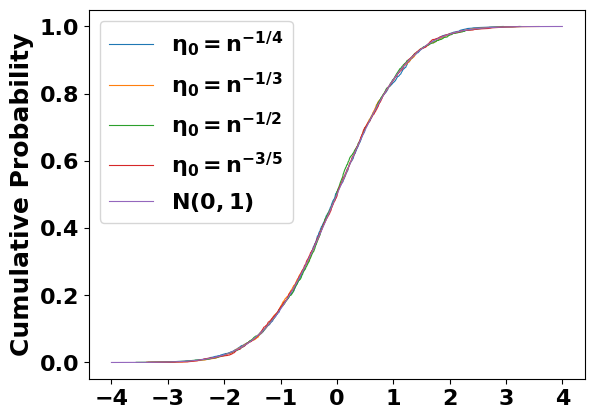

In [38]:
n = 800
R0 = 2000
c = 1
phi = 100
labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


### $T_1^l$ (edge)

Here $E_0=$ left edge $\gamma_-$ and the main part of the test function is in $[E_0-2*\eta,E_0+2*\eta]$

n or the local interval need to be large enough to avoid the situation when there are no eigenvalues in the local interval empirically. So, adjustment is made when the imaginary part is too small.

#### Data generating

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

n = 800
R0 = 2000
c = 1
phi = 100
m = int(n * phi)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)-2)
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)+2)



def simulate_local_test_statistics1(eta, E, m, n, R0):
    """
    Compute the test statistics for a given value of eta.
    """
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00) / np.sqrt(n * m)
        Et = jnp.array(extract_elements(E0, E-eta, E+eta))
        Eb = (Et - E * np.ones(Et.shape)) / eta
        t0 = jnp.sum(Eb)
        T0 = T0.at[r].set(t0)

    TestST = np.array(T0)
    Mean_x = jnp.mean(TestST)
    Variance_x = jnp.var(TestST)
    Normalize_TestST = (TestST - Mean_x) / np.sqrt(Variance_x)
    return Normalize_TestST

etas = [1/(n**(1/4)), 1/(n**(1/3)), 1/(n**(1/2)), 1/(n**(3/5))]

Normalize_TestST_1 = simulate_local_test_statistics1(etas[0], leftb, m, n, R0)
Normalize_TestST_2 = simulate_local_test_statistics1(etas[1], leftb, m, n, R0)
Normalize_TestST_3 = simulate_local_test_statistics1(etas[2], leftb, m, n, R0)
Normalize_TestST_4 = simulate_local_test_statistics1(etas[3], leftb, m, n, R0)

#### Saved data

In [39]:
Normalize_TestST_1=[0.32757175 , 1.6343967 , -0.5739341 , 0.60261613 , -0.79334795 , 2.3761516 , -0.14965487 , -0.1558663 , 1.841156 , 0.6115311 , 2.0494478 , 0.18570155 , 0.100029565 , -0.72848934 , -0.6146979 , -1.7974417 , -0.6397626 , -0.31970564 , 0.6323801 , -0.062129628 , -0.7002782 , 1.0323788 , -0.038327612 , -0.7320991 , -0.06544664 , -0.022063324 , 0.350829 , -1.1729176 , -1.3071151 , 0.85747844 , 0.20051226 , -0.92809534 , -2.3598695 , 1.6390705 , 1.0375643 , -1.5703679 , -1.8885436 , 0.53678256 , 0.2654625 , -0.14803836 , -0.16045868 , 1.4334567 , -1.6358757 , -0.4566805 , -0.18291913 , 1.8234738 , 1.2570927 , -0.25099546 , -0.39340532 , -0.6358524 , 1.4815419 , -0.20196839 , 0.39941058 , 0.14796454 , 1.38292 , 1.092146 , 0.74581265 , -0.53427255 , -1.0816145 , 0.41357213 , 1.6062033 , 0.3996575 , 0.7096565 , -0.9268582 , -1.2812358 , 1.4814885 , 0.27976406 , 0.82424474 , 0.21017817 , -0.87518615 , -2.0676444 , 0.3545304 , 2.4243436 , -0.9331409 , 0.110517725 , 0.25220463 , -0.34423572 , 0.34115544 , -0.9068161 , -0.5918403 , -0.7667839 , -0.40842223 , -0.6494259 , -0.7789394 , -0.88247186 , 0.3568546 , -0.06884511 , -1.1337117 , 0.22590531 , 0.6916128 , 2.129532 , 1.6073158 , 0.8533876 , -2.410994 , -0.40737343 , -0.52346873 , -2.1173816 , 0.6120555 , 0.14331868 , -0.30210486 , 0.5184614 , -2.795963 , -1.5105193 , 0.73394215 , 2.4480386 , -1.155887 , 0.33570263 , -0.39365226 , -1.1911038 , -0.85721374 , 0.94442075 , -0.47269022 , 0.5814616 , -0.3291908 , -0.8067331 , 0.9547765 , -1.4411802 , 0.091779046 , -1.592556 , 0.4896011 , 0.31704286 , -0.08294303 , -0.41254622 , -0.88397634 , -0.1225893 , -0.3388287 , -0.8887342 , 0.15251365 , 0.59343135 , 2.388638 , -1.3305353 , -0.8269915 , 0.18169975 , 0.23296192 , -0.9112023 , -0.11081048 , -2.1554496 , 1.0369126 , -0.99206805 , 0.82741916 , -0.59156793 , -1.7426335 , 0.16402008 , -0.49362072 , 0.55535066 , 1.715937 , -0.21275184 , 0.084388964 , 0.5644998 , -1.9022902 , -0.12040002 , -0.57086146 , -1.1362243 , -0.7718956 , 0.37977836 , 0.5593245 , 0.06540845 , -0.33475053 , -0.89310765 , 1.0427676 , 0.368137 , -0.53565484 , 0.41573086 , 0.7999132 , 0.36944038 , 2.8214579 , 0.04476561 , -1.7246356 , -1.0294766 , 1.283639 , -1.8270122 , -0.36961094 , 1.3049157 , 1.1016897 , 1.4446322 , -1.8829432 , 1.0031086 , 0.43042192 , -0.6749997 , 1.1012467 , -0.39946148 , -0.35510573 , 1.2975026 , 1.0514891 , -0.72576547 , 0.48554587 , -0.866401 , 0.3422959 , -0.17752995 , -0.68753463 , 0.2699505 , -1.8592303 , 0.16919033 , -0.0652048 , -0.40189004 , -1.0445114 , -0.28265595 , -1.1900932 , 0.008141053 , -0.30743295 , -1.1339103 , -0.63770056 , 0.050796304 , 1.6398036 , 1.1427157 , 0.86620504 , -2.1506891 , 0.867511 , 2.6081612 , -1.2622145 , -1.0645127 , -1.232476 , 0.1522718 , -1.0956055 , -0.95184135 , 1.0414337 , 0.8164728 , 0.2690595 , -1.2297522 , 0.4761498 , 0.40792584 , -0.17613493 , 0.02387584 , -1.7493286 , 0.2055425 , 0.9209013 , -1.2566625 , -0.6080384 , -0.4736856 , -0.1719753 , -1.3322867 , -0.90334123 , 0.23882459 , 0.686804 , -2.2793982 , -0.41542792 , 1.9562355 , 1.3432636 , 0.5234305 , -1.4821299 , -0.4740776 , -0.24952659 , 1.1794727 , -1.0336185 , -0.32837874 , -0.7338378 , -0.19783168 , -1.0281962 , -0.73623073 , -0.8808172 , -0.6446706 , 0.14154436 , 0.01690325 , 0.02504685 , 1.2651421 , 0.84841585 , -0.5366782 , 0.5093122 , 0.60247105 , 0.45529822 , 0.45818755 , 1.4097209 , -0.25794002 , 0.8430369 , -1.330604 , 1.109281 , -0.9404368 , -0.20545849 , -0.018886328 , 0.23983778 , 2.7940817 , -1.1974883 , 0.036245253 , -0.020986505 , 1.1700816 , 0.78123564 , 0.18253474 , 0.060991712 , -0.2797437 , -0.9922157 , 0.3288955 , -0.9035449 , 0.13475251 , 0.28111327 , -0.61301523 , 0.12979354 , 1.6074431 , 0.26781213 , 1.6216785 , 1.0630617 , -0.18571427 , 0.07678505 , 0.40492705 , 0.06548737 , 1.3249959 , -0.0398041 , -0.43077323 , -1.3783379 , -0.7845959 , 0.5775515 , -0.43197986 , 0.051285073 , -0.25330436 , -0.7739041 , -0.7974465 , -0.071495146 , 0.542546 , -2.357316 , -0.5920771 , 0.7278402 , -1.7625711 , -0.9045123 , -0.00860182 , 0.989917 , 0.10072708 , -0.8606758 , -0.68847144 , -0.99903554 , 1.1282767 , -0.36802754 , 0.7330563 , 1.1286076 , -1.3237078 , 1.523637 , -0.5284811 , 1.1638677 , -0.8084539 , -0.5465248 , 0.17218913 , -0.16321056 , 1.5412582 , -0.22972637 , -0.11863332 , -0.5574305 , 0.5426529 , -0.65699166 , 1.2843848 , 0.9463809 , -0.089403935 , 1.1267849 , -0.8534614 , 0.34904194 , -0.1274057 , -0.47913587 , -1.355381 , -0.40596822 , -1.3321136 , 1.1681418 , 0.97506297 , 0.13985913 , -1.092673 , -0.7448682 , 1.2732984 , 0.93354565 , -0.80815864 , 1.5478005 , 0.25916958 , -1.3407383 , 0.7139689 , 0.34360948 , -0.34527943 , -0.96836025 , 0.1446348 , -0.2933223 , -1.342113 , 0.54216665 , -1.1086801 , -1.2115328 , 1.1094388 , -0.23295428 , 0.15946841 , 0.75411916 , 0.51872104 , -1.3264852 , -1.0358382 , -0.2962142 , -1.6812294 , 0.08516285 , -0.65718 , -0.34290686 , -0.8230075 , -1.4674159 , -2.2872465 , -0.33715364 , 2.3305075 , -0.018158266 , -0.4404773 , 0.7800112 , -1.7302258 , 0.23616183 , 0.77392447 , -0.7072992 , 0.44164068 , -0.6116176 , -0.7084218 , -1.8474743 , -0.41275498 , -0.48062763 , 0.6019135 , 1.7550385 , -1.229854 , -0.24908873 , -1.2244012 , -0.14917882 , -0.33128843 , 0.12391813 , -2.1153603 , 1.3694738 , 1.2065407 , 1.1639796 , 0.025421062 , 2.158214 , 0.6475319 , 0.11883443 , 1.7409024 , 1.1851622 , 1.5018868 , 0.47644508 , 0.18760063 , -0.42604083 , 0.9016917 , 2.3572116 , 0.03624016 , 0.843238 , -1.7161713 , -0.38261932 , 0.24851087 , 0.81514907 , 0.50185853 , -0.23093303 , 2.1358047 , 0.72027194 , 1.3020747 , -0.33957967 , -2.098658 , -0.097127505 , 2.4239364 , 1.6643566 , 0.4022948 , 0.5653959 , -0.8261616 , -0.14389655 , 0.70672894 , 0.7608575 , 0.5151775 , 0.079791486 , 1.0470189 , -1.9759543 , -1.311122 , -1.1886549 , 0.40598348 , -0.42069492 , -0.95817244 , 0.1751752 , 0.07276289 , 1.1033851 , -0.28746727 , 0.050455183 , -0.57516366 , -0.22181442 , -0.0644971 , 0.15798175 , 0.10892923 , 1.1835101 , -0.5362276 , 0.1418142 , 0.5792418 , -0.8330655 , 0.708292 , 1.0195613 , -1.2475083 , -1.3963128 , -0.673872 , -0.74379903 , 0.031248102 , -0.28418845 , 1.2793012 , -0.81747836 , -0.6737727 , -1.2354977 , -0.7645284 , 0.3110656 , -1.2823967 , -1.1424052 , 1.3595508 , -0.84494865 , 0.11368708 , -0.74342734 , 0.69651574 , 1.603314 , 0.2686955 , -1.1974298 , 0.33475563 , -0.6940719 , -0.50829905 , -1.8224555 , -1.4548277 , 1.4158763 , 0.5783355 , -0.51941603 , 0.37113327 , -0.2787305 , 1.0055499 , -0.090210915 , 0.095057875 , 0.012789447 , -1.9604232 , 0.61924446 , 2.1943524 , 0.04246687 , 0.6651022 , -1.1892506 , -0.032828964 , 0.20774196 , -0.7498348 , 0.41004127 , -2.3312688 , -0.8851805 , -1.1235366 , 0.45843193 , -1.0342193 , 0.6157136 , 0.10362405 , -0.29411146 , 0.99414533 , -1.5954734 , -0.66968435 , 0.06274059 , 0.6552606 , 2.1016595 , 1.0657805 , -1.2048556 , 0.21631578 , 1.2081777 , -0.67269844 , 0.46737486 , 1.322104 , -0.4823587 , -0.23907916 , 1.2979252 , 0.44672439 , 2.312665 , -0.5422685 , 0.7517772 , 0.6661637 , -0.21652707 , -0.5862093 , -0.53111845 , -0.13359931 , 1.7101736 , 0.19851646 , -0.2972019 , 1.6919237 , -0.82930297 , 0.31764364 , -0.31248102 , -0.986712 , 0.25833717 , -0.09279732 , 0.50228107 , 1.9090338 , 0.15560664 , -0.33464617 , -0.24638778 , 0.96859443 , 0.5454557 , 0.15191287 , 1.7329192 , 0.9510726 , 0.50354886 , -1.9954262 , 0.11507448 , -0.09045784 , -0.52230024 , 0.24448617 , 1.2232505 , -0.017277464 , 0.12596485 , 0.37518597 , -2.7947538 , -1.1504724 , 0.5119623 , 1.2965379 , -0.52082884 , 0.015706785 , 1.1514983 , 1.597044 , 0.012234491 , -0.7283824 , 0.43366256 , -0.14193639 , -0.073020004 , 0.4014751 , -1.7241875 , -0.085600704 , -0.054344967 , -0.40602422 , -1.2002631 , 0.04390772 , -0.3291577 , -0.033485744 , -0.32950136 , -0.48668632 , -1.5231738 , -0.07462887 , -0.33643833 , -0.066052504 , 0.8572977 , -0.68903655 , 0.6790601 , -1.9887972 , -0.546031 , -0.32722554 , -0.45186156 , -0.43700758 , 1.150508 , -0.43709666 , 0.7943407 , 0.4168535 , -0.6689894 , 0.2258264 , 0.1644783 , 0.040422697 , 0.63208735 , -0.17633857 , 1.404492 , 2.4843502 , -1.4484457 , 0.63742566 , 0.07267379 , 0.93162876 , -0.15743951 , 0.30397594 , 0.7764065 , -1.0463214 , -0.94501895 , -1.0975326 , -1.1556426 , 0.37861753 , 1.0961096 , -0.59195995 , 0.7464236 , 0.52874845 , -0.32350886 , 1.8324422 , 0.9753404 , -2.6856694 , 0.4038553 , 0.9982744 , 0.6535372 , 1.5587622 , -0.90690774 , -1.148889 , -1.6828994 , -0.66310126 , -0.078890316 , 0.0960685 , 1.790123 , -0.39461708 , -1.04429 , 0.46650425 , 1.7196206 , 1.0781728 , -1.0788016 , -2.1332972 , -0.25008664 , 0.7201243 , -0.44187236 , -0.58583 , 0.011351144 , -1.1909307 , 0.016297381 , 0.25148422 , 1.9454445 , -1.0191692 , -0.35345614 , -0.5947602 , 0.09812031 , -0.85568374 , 0.5411128 , 0.7351081 , 2.0603383 , -0.9844514 , -0.5395319 , 0.27030182 , -0.97129536 , 0.91464406 , -0.9492397 , -0.80122936 , -1.0347233 , 1.6690534 , 1.3330326 , -0.48424757 , 0.18130772 , -0.01933691 , 1.4329273 , 0.107259266 , -2.0232172 , -0.53658146 , -0.032803506 , 1.4301219 , 1.1618134 , -0.91075426 , -0.1590764 , -0.0052669914 , -1.2656003 , -0.44099155 , 1.9214693 , -0.4973323 , -1.2376692 , -0.050831944 , -0.041132938 , 0.0058804983 , -1.1610751 , 0.89862156 , -0.64814544 , -1.6843708 , 0.19508488 , -0.005669208 , 0.95235556 , -1.2601678 , 1.1951896 , -0.00019856228 , -1.042541 , -2.011255 , -0.049182348 , 0.3140797 , 0.3355397 , -0.42093676 , 1.4196999 , -0.012641799 , 0.43631768 , -0.79431784 , 0.6519614 , 0.560526 , 0.83144647 , -0.47085226 , -1.6562512 , -0.16922088 , 0.09274386 , 0.5688198 , 2.7742662 , -0.65861577 , -1.5232297 , -0.82663006 , 0.25424626 , -1.3440477 , -1.2918513 , 0.57134765 , -1.1703668 , 0.17660333 , 0.39044473 , -0.41684332 , 1.7492191 , 0.056880455 , 1.2264224 , -0.28569803 , 0.2832211 , -0.34468374 , -0.13395827 , 1.1285108 , 0.30664125 , -1.6387116 , 0.6886547 , -0.21465601 , -0.94141173 , 0.30028725 , -1.0530114 , 0.2752786 , 1.1008191 , 0.864586 , -0.37906048 , 0.777911 , 0.4525438 , -0.107445106 , -0.6666525 , 0.058061644 , -1.222138 , -1.5125074 , -1.773156 , -0.6467988 , 1.3408452 , 1.5913671 , -1.1115924 , 0.023369253 , -0.0015630415 , 0.4778172 , -0.6139342 , -0.14935957 , -0.40919104 , 2.1781874 , 1.1741395 , 1.9147156 , -0.55533034 , -0.16111292 , 0.048077527 , -1.0901196 , -0.99909407 , 0.32208073 , -0.44340992 , 0.059359938 , -0.032569304 , 0.097580634 , 1.5128409 , 0.41777503 , 0.9507773 , -2.1273096 , 0.40471065 , 0.18435998 , 1.3768181 , 0.22998095 , -0.18599685 , 0.1639488 , 0.31174788 , -0.9726904 , -1.4120629 , -1.3684582 , 0.5277174 , -2.2203717 , -0.63587534 , 0.7523321 , -1.1182238 , 2.1697664 , 0.17863986 , 0.52894443 , -0.6149474 , 0.38876456 , -0.79863787 , 0.24431306 , 0.45879087 , 0.010029941 , -0.91674167 , 0.9155961 , 0.3241402 , -0.4154152 , -0.4021599 , -1.2269825 , -1.1410304 , -0.86588424 , -0.58126307 , 0.42595172 , -0.7471033 , 0.71056527 , -0.6050956 , 0.17805436 , 0.028934088 , 0.72643757 , 0.35835654 , -0.09999647 , -0.2052523 , -0.73625875 , 0.3494238 , -1.4670722 , 1.2672677 , 1.0353241 , -1.0415101 , 1.2349199 , 0.19976893 , -0.8901394 , 1.3042945 , -0.24520405 , 0.6161438 , 1.2005916 , -1.2293907 , 0.7757472 , -0.0031668136 , -0.50813615 , -0.0023292883 , -0.7245181 , 0.5113106 , -0.17096467 , 1.0437579 , 1.8608798 , 1.0317601 , -0.3402874 , 1.0272925 , 0.95599335 , -1.1195247 , 0.095579736 , -0.43352765 , -0.3599476 , -1.5804844 , -0.8088282 , 0.3408347 , 1.2080275 , 2.3156154 , 1.9175541 , -0.5154473 , -0.75363296 , -0.39792135 , -1.5694362 , 0.7579835 , 0.07744692 , -2.316527 , 0.6032016 , -0.61761266 , -0.0029122466 , -0.3980919 , -1.592612 , -0.28544855 , 1.2972888 , -1.0853465 , -0.26755503 , -0.85143757 , -1.0745478 , -1.3282568 , -0.87665755 , -1.4321228 , 0.5673484 , -2.0026176 , -1.2826868 , 0.37119436 , -0.25057542 , 1.0411079 , 0.5796949 , 0.35933152 , 0.82864875 , 1.4706999 , 1.0523978 , -0.37583256 , -0.21754535 , 0.96115345 , 1.4709697 , -1.2125129 , 1.1562434 , -1.1166887 , -0.1667974 , -0.94746536 , 1.4062384 , -0.12420834 , 0.16622208 , -0.38751718 , 0.70030624 , -0.15695076 , 1.3224629 , 1.9935322 , 0.57400024 , -0.42309293 , -0.8206681 , -0.15502878 , -0.18201032 , 1.2135311 , 0.98883504 , 0.7330512 , 0.3256065 , -0.34715813 , -0.15100916 , 0.8747585 , -0.78193825 , -1.477372 , 0.67422587 , -0.79527754 , -0.6378482 , -0.6465875 , 0.04885141 , -1.5248921 , -1.6727803 , 1.2032365 , -1.0287435 , 0.36745223 , 0.703333 , -0.4837028 , 0.7589865 , 0.52741706 , -0.15987319 , -0.0075199096 , 1.4681389 , -0.31038338 , -0.050060604 , 0.703804 , 1.0030246 , -0.554447 , -0.022055687 , -1.4522718 , 0.34223226 , -1.9147309 , -1.1369625 , -1.7901663 , -0.9493339 , 1.0559644 , 1.8377168 , -0.6343479 , 1.5619825 , -1.0357238 , -0.5206506 , -0.8820645 , -1.6793302 , 1.3314084 , 0.9040515 , -0.21736969 , -0.14796963 , 1.101817 , 0.9224618 , 1.7372824 , 1.7967417 , -0.87740594 , -0.6626431 , -0.7287235 , -0.50578904 , 1.2816533 , 1.180687 , -1.469814 , 0.676797 , 1.8343412 , -1.8066978 , 1.2645515 , 0.10336439 , -0.01869031 , 1.5526501 , 1.7113522 , 1.1626636 , -1.6786354 , 0.5624989 , 1.1950293 , 0.19546165 , -1.3487215 , -0.24239108 , 0.8700948 , -0.92838556 , -0.535497 , 0.05119852 , -0.023656914 , -0.17080937 , -1.3217044 , -0.3132498 , -1.7840286 , -1.6332307 , -0.3082094 , -0.4928163 , 0.8156607 , 2.2673876 , 1.1514091 , 0.73653364 , -0.12614813 , 0.27182922 , -2.5451586 , 0.06938224 , 0.19270724 , 1.5086125 , -0.71033365 , -1.3033602 , 0.5206303 , 1.1565235 , 0.5540957 , 0.90208876 , 0.8303238 , -1.3855166 , -0.08609202 , 1.2940863 , -1.3334297 , -1.1911343 , 1.4228795 , -0.12891275 , 0.09594631 , 0.63472724 , -0.53186685 , -0.5480879 , 1.7079258 , -1.2044991 , -0.59936786 , 1.5208317 , -0.036079783 , -0.43837968 , 0.41448092 , -0.93194187 , 0.048283726 , 1.3555694 , -1.1673425 , 0.55928886 , -0.5618345 , -1.3986574 , 0.6205071 , -1.7418392 , -0.7222143 , 0.4049983 , 0.73993725 , 0.6324743 , 1.5129529 , 1.7542264 , 1.4223627 , -2.4054675 , 0.03441237 , 0.024074404 , 0.4610336 , -1.1270089 , 0.65704256 , 0.29635674 , 0.59772336 , 1.1425325 , 0.060103275 , 0.6105204 , 1.392782 , -0.24254127 , -1.1732026 , -0.9331358 , 1.3583875 , -0.92888963 , -1.0212771 , -0.6102073 , 0.8340583 , 0.45805264 , -1.2888219 , -0.13242067 , 1.3443761 , 0.3872066 , -1.1059409 , 1.2593024 , 1.220934 , 0.46332216 , -0.90306634 , 1.8724016 , -0.20132178 , -0.3513254 , -0.48852938 , -0.31346366 , -0.44588688 , 0.48007268 , -2.7681873 , 1.607774 , -0.054080218 , 0.956393 , 0.19874047 , -0.06419162 , -1.7030585 , 2.0707295 , 1.0218371 , -1.5073805 , 1.0915273 , -0.009632817 , -0.34350765 , -0.2529047 , -1.2818875 , 2.1817844 , -1.8899692 , -0.19789277 , -0.14549269 , -0.52908444 , -0.5965167 , 0.46204934 , 0.7799017 , 1.0753089 , -1.9940642 , 0.49038264 , -2.0093815 , -0.7029614 , -0.27790573 , -0.2386795 , -0.006583103 , -0.52606785 , 2.8812659 , 0.4339273 , -0.4308267 , 1.0837988 , 0.95864594 , 0.43591037 , -2.809926 , 0.8726812 , -0.9776799 , 0.026398601 , 0.15371776 , 0.8354279 , 0.6713645 , 0.13235703 , 0.25765237 , -0.052422985 , -0.23750594 , 1.4085549 , 0.46109724 , 0.11428532 , 0.584743 , -0.17482644 , -0.36493963 , -0.11046172 , 0.553332 , -0.38888675 , -0.6123864 , -0.8788901 , 0.5923902 , 0.115298495 , -0.058041282 , 1.3049182 , 0.765595 , -2.1853943 , -0.37384695 , 0.89017504 , -0.43621078 , 0.15285222 , 0.7237773 , -0.8349213 , 1.5203913 , 1.1145046 , -0.41157377 , -0.3340963 , 0.33920038 , 1.2608119 , -1.5726743 , -0.19565512 , 0.60223687 , 0.282269 , -0.5754029 , -0.014540868 , -0.9118413 , -0.78580254 , 1.1506379 , -1.0976752 , -0.43111435 , 0.028175479 , 1.9519105 , 0.04011467 , 1.1306925 , -0.93255025 , -0.14349434 , 0.1692336 , -0.37368402 , 0.032218 , 1.4364734 , -0.20373254 , 0.9430664 , -0.9683882 , -0.9605654 , 0.8896328 , -0.06860581 , 0.23888569 , 0.68790627 , 0.5241153 , 0.12531061 , 0.7241108 , 0.6384439 , 0.47070715 , 0.40864372 , 0.3425683 , -0.75407845 , 1.2082362 , 0.4842221 , 0.32877332 , -0.0138459 , -1.3850355 , 1.1658864 , 0.4480227 , 2.4309368 , -0.8832865 , -0.21525423 , -0.46210024 , -0.3645425 , -0.25110236 , -0.9899577 , -0.099265866 , 0.81086725 , 0.9738716 , -0.45392355 , 1.3994567 , 2.5930705 , -0.0077235634 , -1.4807603 , -0.11750305 , 0.43379748 , -0.2632223 , -1.2215399 , 0.36422685 , 0.3822731 , -1.1986034 , 0.3933646 , 1.5381805 , 0.50753284 , 0.80939585 , 0.78727144 , 0.4270311 , -0.2677587 , 3.2294679 , -0.92242867 , 1.0423704 , 0.45089674 , 2.5447996 , 2.7043495 , -0.97875416 , -0.5030626 , -0.35275862 , 0.55755013 , 1.3680432 , -1.0035566 , 1.3800231 , 0.4310838 , -0.5763016 , 1.3383454 , -0.029672332 , -0.36375335 , 0.14143234 , 0.73538303 , -0.22057724 , 1.2229145 , 1.934414 , 0.3197311 , -0.7945724 , 0.0068071224 , -1.5902548 , -0.30606085 , -0.26957121 , 0.55734396 , 0.8524482 , -0.3020947 , -0.30584192 , -0.38376233 , 0.76956886 , 0.49306068 , -0.22489469 , -0.21519569 , 1.4425702 , -0.12905021 , -0.2587521 , -0.34814078 , 1.6308479 , -2.2975972 , -0.32771176 , -0.70166814 , 0.47789866 , 1.2389573 , -0.8790734 , 0.4962326 , 0.3765199 , -0.2928717 , -1.5911559 , -0.08821765 , -1.3151416 , 0.31878665 , 0.97618306 , -1.000871 , 0.5651744 , 1.5020345 , -1.4942626 , -1.149976 , 0.051519275 , -1.506996 , 0.75755584 , 1.4091506 , -1.3680992 , -2.3155162 , 1.0203402 , 0.30469382 , -0.5565344 , -0.14038862 , 2.0344894 , 1.075678 , -1.4520503 , 0.6474556 , 1.4912078 , 1.2585845 , 0.59181994 , 0.24160956 , -0.29551667 , 0.6267491 , -0.64248645 , 1.0068915 , -0.58780795 , 0.5909061 , 1.2297114 , -1.2083355 , 0.8136166 , -1.5777911 , -0.5346111 , -0.32255423 , -0.94771993 , -0.97553647 , 0.8903074 , 1.0770069 , 1.6552916 , 0.36277583 , -2.138256 , 0.67916954 , 0.031744506 , 2.0911357 , 0.88335264 , -2.384112 , -1.0610354 , 0.7997885 , -0.4191548 , 1.4794315 , 0.86188245 , 0.5336539 , 0.6400426 , -1.2042547 , 0.34750944 , 1.3969314 , -0.71287423 , -0.9830615 , 2.1822784 , -0.24610013 , -0.44544646 , 0.16166534 , -0.9861366 , -0.92079437 , 1.107 , 0.537895 , -1.3142201 , -1.8251488 , 1.8794276 , 0.6345694 , 0.17857876 , 1.8826402 , 1.6752393 , -0.28116927 , 0.031767417 , 1.8174354 , -0.6216425 , -0.7668679 , -2.297391 , 0.37555763 , 0.0038235968 , 0.15846796 , 0.16442229 , 0.25746652 , 0.3717493 , 1.6187586 , -1.1413817 , 0.42576844 , 0.73291373 , -1.6460303 , 1.3122141 , 0.6808548 , 0.68537337 , -1.6129316 , -0.491518 , -0.9180985 , 0.48130476 , 1.3630995 , -0.8189065 , -0.17414676 , 0.79215145 , 0.74818265 , -0.050643563 , 1.7633094 , -0.1756716 , -0.98543406 , 0.4048074 , -0.3733327 , -0.40039828 , 1.7109933 , -1.865289 , 0.64366 , 1.3841318 , 0.6304658 , -1.7371781 , -0.41448602 , 1.150363 , 2.0695536 , -1.2549111 , -0.8218391 , 1.3281678 , 0.49847022 , -0.98594826 , -0.8823751 , 0.75548875 , 0.50061876 , 0.06489932 , -0.14854495 , 0.16210064 , -1.2712415 , -1.0672009 , -1.0101168 , -0.37177476 , 0.48626375 , -1.6575241 , 0.56149846 , -0.70257187 , -0.5558929 , -0.56499624 , -0.33710274 , -0.013168752 , 0.4574722 , -0.24300459 , 0.03482986 , -0.8409036 , 0.24151282 , -0.725516 , 0.41616616 , 1.1036397 , -0.1624494 , -0.23746267 , -1.0573747 , -1.0882486 , 0.68014705 , -1.1124859 , -0.16177225 , -1.2461997 , -1.3027977 , -1.7541883 , 0.40623552 , 0.3126185 , 1.265137 , -0.17834456 , -1.0202512 , -0.32009003 , 1.2299966 , -0.78280634 , 0.81267977 , 1.2060978 , -0.9607054 , 0.20066245 , 0.48984805 , -2.3284023 , 0.96807253 , -0.14106578 , 2.6492383 , 1.5210431 , 0.27024326 , -0.47612688 , 0.98359096 , -1.7273493 , -0.25179225 , 1.0189555 , -0.09915894 , 0.3144972 , 0.3786939 , -1.1169434 , -1.4950798 , -1.448298 , -1.0120617 , 1.607909 , 0.06576739 , -0.77867216 , 0.08277501 , -0.010182681 , 0.6085145 , -0.18371084 , -1.6754328 , 0.114794455 , -0.58240354 , -1.4252851 , 0.920326 , -0.1949627 , -0.27548224 , -0.11638295 , -0.77818084 , -0.33285147 , 0.05914101 , 0.1949016 , 0.8119899 , 0.2247114 , -2.0981464 , 1.3681042 , -0.32978138 , -1.3128276 , -1.8875533 , 1.0719105 , -0.37362292 , -0.5181202 , 0.61124086 , -0.58956957 , -2.3667197 , -0.05248663 , 0.26435766 , 0.3259018 , -2.1620836 , 0.24542297 , 0.50728077 , -1.6784215 , -1.2546284 , 0.3014761 , 1.1547109 , -1.0786616 , 1.7781913 , -0.774426 , -1.4415622 , 0.7519172 , -0.13651921 , -0.91033673 , 1.0589046 , -1.0227128 , 1.1114727 , -0.22605042 , -0.16417536 , 1.0200552 , -1.736338 , -0.2302966 , 1.2745763 , -1.5491625 , 0.98783207 , 1.5409553 , -0.53235054 , 0.4086208 , -0.71346736 , 0.16494161 , -0.5933041 , 0.51465815 , -0.23486353 , 0.27173248 , -0.74794847 , 0.44426018 , 1.5185229 , -0.98301566 , 1.5571051 , 1.6349287 , -0.815508 , -0.31026882 , -1.0939509 , -0.63342386 , -0.21899892 , 1.8469347 , 0.31277633 , 2.1347609 , 2.072257 , 1.197972 , 0.8535505 , 0.8587895 , 1.2728453 , 0.3114984 , -0.40825424 , -0.9253969 , 0.24149247 , -2.2358418 , 0.6855745 , -0.6156118 , -1.6712681 , 0.76689845 , 0.016175188 , 0.7846672 , -0.8565111 , 1.0348047 , 0.46943432 , 0.8040194 , 1.586533 , 0.56135595 , -0.476664 , -0.5455982 , 0.1349358 , -1.0368872 , -0.6241627 , 1.9800656 , -0.887889 , 0.5327248 , -1.155355 , -0.6183382 , 0.3670831 , -0.10516164 , 2.3175883 , -0.9016153 , -1.14825 , -0.02892136 , -1.2682223 , 0.57649755 , -0.19806841 , 0.741233 , -1.0870852 , -0.20903008 , -1.2109015 , -0.08756851 , 0.9416027 , -0.19551766 , -0.8352955 , 0.16778003 , 0.59188867 , 0.6305498 , -1.5729442 , -1.1314588 , 2.2222223 , 0.57223105 , 0.17729574 , 0.13324802 , 0.086496785 , 1.4495428 , -0.50674623 , -1.2392933 , -2.8233418 , -1.2551122 , -0.13081436 , -0.79984957 , -1.1613755 , -0.96449846 , -0.73362654 , 0.36332315 , 0.17034097 , -1.351537 , 0.5377779 , 0.042029016 , 1.5903871 , -0.65821105 , -0.3816749 , -0.19928779 , -1.3729869 , 0.66506904 , -0.12624997 , -0.62842923 , -0.37617114 , -0.31740943 , 1.3413595 , 2.5215628 , -0.059965808 , -0.42608154 , -0.2741254 , 0.41349065 , 1.3741095 , -1.0752096 , -0.25561583 , 0.5891037 , 0.996187 , -1.8066266 , -1.1672814 , 1.8858452 , 1.513569 , -0.47430417 , 0.0060943346 , 0.13235958 , -1.0425004 , 0.9187782 , 0.6959328 , 1.1681418 , 0.12198597 , 0.8703315 , -0.5037983 , -0.22783749 , -0.56002706 , 0.3131378 , -0.21903455 , -0.5156 , 0.50654507 , 1.2296453 , -0.66072613 , -1.3554395 , 0.9825065 , -0.72143275 , -0.0488005 , 0.86537766 , 1.0987368 , -0.8233436 , 0.44984028 , -1.372717 , -0.45387518 , -0.063980326 , -0.34772837 , 0.012356684 , -0.57705 , -0.42935783 , 0.09997356 , 0.2504634 , -0.29140797 , 0.1675662 , -1.0408481 , 0.8332106 , -1.4430921 , -0.09393014 , -0.17330922 , -0.2987293 , 0.5988486 , 0.513757 , -1.4077964 , -0.10531947 , -0.648008 , 1.5410825 , -0.77021796 , -0.31442335 , 0.08480137 , -0.88214344 , 0.32268915 , 1.4776648 , 0.3519898 , -0.3118268 , -1.4087638 , -0.20150506 , -1.3191383 , 1.0591134 , -1.0758867 , 0.12831196 , 0.20632657 , -0.87617385 , 0.6710285 , 0.32600617 , 0.06706314 , -1.2011694 , -1.4748265 , 1.0468279 , 0.6433876 , -0.10337967 , 0.3990338 , 0.34643006 , 0.45092985 , -0.41899186 , 0.30980808 , -0.93652916 , -0.73443097 , -0.1471092 , 0.896692 , 0.69392425 , -1.6554137 , -0.25377023 , -0.050014783 , -0.17909808 , 0.8115215 , -0.7040815 , 0.8873952 , 0.39870796 , -2.174845 , -0.6885427 , -1.6094185 , -1.2915407 , 1.2387333 , 0.7613718 , 0.40507722 , 0.7564637 , 1.3465985 , 0.33720967 , 0.33185104 , 2.4091969 , -0.42441922 , 0.55005825 , -0.07558604 , 1.9958488 , -0.24393885 , 0.573901 , -0.2505194 , 0.2184796 , 1.8783482 , -1.8398068 , 1.5875537 , 1.4194071 , -0.18648052 , -0.5336539 , 1.3300694 , 0.55845386 , 1.6015524 , 0.6162584 , 0.84354347 , 0.6121064 , -1.2262518 , 0.4642615 , 0.34908268 , -0.3206221 , -0.22280724 , 0.16570786 , -0.6911876 , 0.5191589 , 0.7884348 , -1.1742057 , 1.5837836 , -0.0009011673 , 0.9538219 , -0.19467504 , -0.17189638 , -0.7445704 , -0.759796 , 0.007400263 , -1.3307949 , 2.3331578 , 0.0394528 , -0.6921932 , 2.052248 , -0.07657376 , 1.1526285 , 0.067429714 , 0.33446035 , 0.13731346 , -0.17218404 , 0.077082895 , 0.5378543 , 1.2813504 , -2.240322 , -0.036538005 , 0.30567136 , 0.25994092 , 0.9020557 , -0.36642376 , 2.1740532 , -0.043892447 , 1.1403584 , -0.15931313 , -0.4343728 , -0.9165304 , 0.44863364 , -1.0416424 , -0.3053506 , 0.18974917 , -0.5815227 , -1.0217786 , -1.191063 , 0.10272288 , 0.7899291 , -2.0705667 , -0.48538804 , 0.6697276 , -1.8928484 , -1.5178813 , -0.7809963 , 1.2431602 , 1.2646686 , -0.35119048 , -0.18432689 , 0.8043096 , -0.87073123 , 0.88865274 , 0.07656867 , -1.9165231 , -0.31347638 , 0.29789433 , -0.30563316 , -0.9733574 , -0.28422153 , -1.9629256 , 0.92684543 , -0.28790513 , -1.3779051 , 0.81955814 , 0.76868296 , 1.367198 , -0.80858123 , -0.74232763 , 1.2116983 , -1.2387893 , -0.57421154 , -1.0514178 , -0.14144507 , 1.2080121 , 1.6556708 , -0.8873239 , 0.1442835 , 1.1948638 , -0.6273219 , -0.92437357 , -0.08655788 , -1.0287664 , -0.06656419 , 0.91665 , 1.6710645 , -0.6648476 , -0.782427 , 0.68094134 , 0.20614329 , 0.16441466 , -0.61506194 , -1.323191 , -0.8115978 , -0.7874471 , -1.0319842 , -0.14832093 , 1.2326237 , -0.42739004 , -0.93445444 , -0.9655447 , -1.2521745 , 0.51700526 , 1.529734 , -0.08484719 , -0.49550706 , 1.3422835 , 2.132406 , 0.06680348 , -0.027131753 , -0.37439427 , 0.5702454 , 1.4444057 , 2.5237954 , -0.6988577 , 1.7113726 , 0.18355046 , 1.2219013 , 0.024693001 , 0.109377265 , 0.80814844 , -0.6323852 , -2.7072592 , -1.176731 , -0.0062572574 , -2.7895327 , -1.2721529 , 1.1956402 , 0.17229605 , -0.58915466 , 0.21572518 , 0.10983549 , 0.9512508 , 0.43182203 , -0.63160115 , 0.15823886 , 0.95809865 , 0.9891914 , -1.2099367 , -0.445197 , 0.3614648 , 0.5673586 , 1.0722363 , 0.8315253 , -2.6714926 , 1.3824109 , 0.07580497 , -0.009660819 , -0.99387294 , -2.6136625 , -2.609872 , 1.613456 , -0.04581188 , -1.6026827 , -0.14969559 , 0.15358537 , -0.80670506 , -1.0530114 , -0.1088885 , 1.1235545 , -1.5256405 , 0.38654473 , 0.7444787 , 1.1798469 , -0.8043936 , -0.07584061 ]

In [40]:
Normalize_TestST_2=[-0.63226354 , -0.13154738 , -0.2864125 , 1.587006 , -0.37539768 , -0.7702656 , -0.4217822 , -1.4151715 , 1.7760249 , -0.28383064 , -1.4525726 , 0.63042676 , -0.889067 , 1.0807728 , -0.6400384 , 1.1257309 , -0.30209625 , -0.19714575 , 0.20193228 , -1.4171464 , -1.9642816 , 0.23256265 , 0.07948517 , 0.17813109 , -0.6325119 , 0.88784516 , -0.59658897 , -1.7464943 , -1.0946556 , 0.11274256 , 1.6149641 , -0.4507803 , 0.9838959 , 1.4130664 , 0.43222782 , -1.1964213 , 1.2649269 , -1.3171126 , -0.7854234 , 0.4629525 , 0.43989506 , -0.6793931 , 0.002433111 , 0.1708862 , 0.48571908 , 0.007715034 , 0.6575363 , -0.18694314 , 0.015613348 , -0.40236378 , -2.0987575 , 0.61775124 , 0.6313857 , -0.31052315 , 0.29568276 , 0.445764 , 1.9352064 , 2.7339416 , 1.0326153 , 1.4633276 , -0.31031993 , 1.0836136 , 0.26664612 , 1.1508455 , 0.70142263 , 1.0403463 , -1.0335423 , 0.41107225 , -2.3036966 , -0.4798714 , 1.0445244 , -0.5326521 , 0.83860254 , -2.0407891 , 0.44186333 , -0.5875711 , 0.39475366 , 0.67727613 , 1.0943979 , -1.7328506 , -0.49992993 , -0.05807326 , -0.19260225 , -0.321083 , -0.075510114 , 1.1111096 , 0.66338134 , 0.7527437 , 0.559156 , -1.6584998 , -0.03753791 , -0.20673741 , 1.2916247 , -1.013242 , -1.7959945 , 0.003993649 , 1.1212552 , -0.61528754 , -0.32042956 , 2.0054479 , -1.503737 , 0.0743759 , 1.7754685 , -1.3248781 , 0.5253196 , 0.6562281 , -1.8281177 , 0.28050503 , 0.27003813 , -0.2880607 , 0.2551008 , 0.025076184 , 0.6594169 , -1.4850146 , -0.21134199 , -0.003417246 , -1.3016573 , -0.27567467 , -1.6857581 , 1.4369566 , -0.779735 , -2.5934613 , 1.4748106 , -0.7370693 , 1.6424522 , 0.10025294 , 1.0936807 , -0.87278825 , -0.14824048 , 0.6906901 , 0.9300912 , -0.6039946 , -0.41280413 , 0.23605295 , -1.6192114 , -1.4461684 , -1.843492 , -1.276419 , -0.6955125 , -0.091045104 , -1.3618038 , -0.030675527 , 0.94763565 , -0.02088199 , -0.12646864 , -0.5112787 , -0.9864618 , 0.79482245 , -0.15969947 , 1.4559367 , -0.8521639 , -1.2776529 , 0.84135836 , 1.2656972 , -0.20242767 , 1.1901499 , 0.78897744 , 1.746983 , -0.23451366 , -0.6823216 , -1.8864897 , -0.15599005 , 1.3658173 , 1.9863483 , 0.88809884 , 0.1687652 , 0.4827109 , -1.866758 , -0.2825915 , -0.52817637 , -1.9644424 , 2.0351286 , -0.89809954 , 0.26140803 , 0.69016683 , 1.0926316 , -1.3423481 , -0.7428253 , -0.45990446 , 0.11008632 , -0.950005 , 0.6213757 , 0.831274 , -0.11863807 , 1.3043972 , 1.4618243 , -0.6154177 , -0.3147585 , 0.225683 , -1.6975213 , -0.86685026 , -1.8937094 , -0.8617436 , 0.7390083 , -0.42168257 , -0.5107421 , -0.25852603 , -0.79141057 , -0.23850863 , 1.8066115 , 2.1076107 , 0.28263798 , 0.8050848 , -1.5966442 , 0.5306387 , 0.07446621 , -1.032517 , -0.31656474 , -0.38141406 , 0.46287945 , -0.624356 , -0.7090646 , 0.2554275 , -0.23007509 , -0.47293463 , 0.19008945 , -0.21978617 , -0.3030817 , -0.02337088 , 0.67301154 , 2.4823377 , 0.48799813 , -0.88535225 , 0.16747959 , -2.022796 , 0.4125757 , 0.55087256 , -1.7767196 , 0.20187649 , 0.8219878 , 0.34620833 , -1.0559064 , -0.99031603 , 0.086641066 , -0.8439389 , -0.9605702 , -0.007615425 , 0.38519123 , 1.7918813 , -1.63791 , -0.24445593 , -0.11011421 , 0.16274618 , 1.9951086 , 1.6230816 , -2.310575 , -1.2480452 , -0.32542196 , 1.3600851 , -1.6900253 , 0.9242409 , -0.8317388 , -0.9439886 , -1.2975932 , 1.9214538 , 0.40238768 , 0.42253125 , -1.9171892 , 1.4263144 , 2.5502257 , -0.25603846 , -0.36406222 , 0.42365882 , 0.8192532 , -1.223908 , -0.37975127 , -0.77659005 , -0.45347372 , -0.52114 , -0.6535878 , -0.39173487 , -1.3342427 , 1.0607966 , 0.5151475 , 0.94890666 , 0.2769045 , 1.89865 , -1.122226 , 0.24717326 , -0.89405674 , 1.1131921 , -0.08997331 , -1.4776554 , 2.2588766 , -0.12754709 , 2.3383765 , -0.74951506 , -0.607101 , 0.78358924 , 0.6626589 , 0.2796285 , 1.8345578 , -0.88628197 , 0.4530142 , 0.5462414 , 0.8644397 , -1.2700216 , -0.60099834 , -0.11758487 , -1.2557057 , -0.14687915 , -0.901453 , -0.99579054 , -0.1100571 , -2.1676495 , -1.111609 , 0.01704373 , 0.2780467 , 0.17952162 , -0.45807168 , 1.3004832 , -0.31252196 , 0.49182045 , 0.50145066 , -0.31757545 , -2.4762855 , -0.38763496 , -0.74769026 , -1.0687281 , 0.21348424 , -1.423678 , 0.5704198 , 0.29458573 , 0.5580165 , 0.155322 , 0.32019317 , -0.55717444 , -0.3186791 , 0.7441561 , 1.4743617 , 1.2414896 , -1.4179393 , 0.4677603 , 0.13710554 , 2.7145073 , -0.09328298 , 1.9639575 , -1.3301375 , -0.6983799 , 0.08321585 , -2.0053244 , -2.5464458 , 0.2674868 , 1.4153906 , -0.70269495 , -0.15481333 , -1.5168614 , 0.2590599 , 0.21141106 , 2.3679178 , 2.3981802 , -0.09591664 , 0.18075013 , 0.39445087 , -0.4246735 , 1.0899315 , 1.1374183 , -0.9790549 , 1.5111147 , 1.2989918 , -1.5200012 , -0.9384956 , 0.41674995 , -0.19679114 , -2.5411003 , -1.7335279 , -0.79487956 , -0.8466257 , 0.5924652 , 0.08056227 , -1.0386263 , -1.2330055 , 1.0320044 , 0.42538404 , 1.470392 , 0.73264 , 1.5667189 , 0.5326853 , -0.34009898 , 0.34122124 , 2.1742065 , 0.45893362 , 1.1031476 , 0.2676595 , -0.41351464 , 0.42516756 , 1.1965487 , 1.9508663 , -1.7010541 , -0.82843846 , 1.4181238 , -2.250977 , 2.3169312 , 1.1095611 , -0.00030148265 , -1.2341915 , -1.6542101 , 1.5850098 , -0.42693394 , -0.44618237 , 0.42609325 , -0.48933157 , 0.6470455 , 0.1451008 , -0.68400437 , 1.2449228 , 0.78625876 , -0.52135646 , -0.76382285 , 0.041647106 , 0.36984086 , -0.10961351 , -0.3946886 , -1.1758567 , -0.45184013 , 1.7240452 , 0.14351769 , 1.4851433 , 0.6524948 , 1.0039053 , -0.0017637399 , 0.06896249 , -0.9397413 , -0.07412489 , 0.22837244 , -2.6032522 , 0.41875142 , 0.24580398 , 1.0100758 , -1.0843799 , -0.019110281 , 0.35709357 , -0.9110633 , 0.09631906 , -0.9238172 , -0.8792363 , -0.7186058 , 3.061875 , -0.35423678 , -1.6404241 , 2.2640164 , 0.64758736 , -0.12101274 , 0.1107464 , -0.036452837 , 0.77496445 , 0.28343353 , -0.11428583 , -1.0070091 , 0.53581566 , 1.1241716 , 0.14191997 , 0.91114295 , -1.0932571 , 0.8027128 , -1.0827769 , -1.1679982 , 0.4656459 , -0.008299406 , -0.1025798 , 0.022826353 , -0.67438215 , -1.393567 , 1.1016096 , 0.025274074 , 1.8358526 , 0.2403401 , 0.84882903 , -1.7279445 , -0.028636867 , 0.5119627 , 0.00644801 , -0.1347893 , 1.3153768 , -2.6074996 , -0.81717867 , -0.87571543 , 0.07714901 , -1.3610839 , 0.23445788 , -0.17799827 , -0.95300126 , -0.7942647 , 0.49349123 , -0.4553145 , -1.8545831 , -1.3988609 , -0.5784549 , 1.3732694 , -0.33125374 , -0.6921842 , -0.38954082 , 1.1934795 , 1.0101502 , 0.16164516 , 1.4462454 , -1.3202603 , -0.32421204 , 2.7315524 , -1.6313823 , -0.34484833 , -0.15053414 , 0.6652792 , 1.0110028 , 0.47880757 , 0.648784 , -0.7201265 , -0.43068323 , 0.75065196 , -0.98447764 , -1.3103245 , 0.43053848 , 0.24902466 , 0.7358766 , -1.9126471 , -0.37241474 , -1.3601729 , -0.5319907 , -0.6112514 , -0.06568337 , 0.7587721 , 1.479637 , 0.7881885 , 0.16549803 , 0.5865657 , -1.3165202 , -0.2123527 , 2.7631297 , -0.7005806 , -0.8134055 , 0.027986089 , 0.38533467 , -2.040105 , -1.1142786 , -0.5096438 , -0.3544772 , 0.9358858 , -0.6610904 , -1.1600574 , 0.21994554 , 1.5210025 , 0.84582883 , 1.5585697 , -0.13538828 , 0.1538345 , 0.11554754 , -0.026282115 , -0.13299635 , -1.1805848 , -0.21234073 , -0.26279593 , 0.538104 , -0.16159336 , -0.49645293 , 0.94502723 , 1.0745639 , -0.5235319 , 0.7572793 , 0.6228512 , -0.45188797 , 1.8193747 , 0.92238015 , -1.5365707 , 0.5378889 , 1.7353089 , -0.29214066 , 0.45895088 , -0.29616487 , -1.4338887 , -0.19812988 , -0.6788008 , -1.4764534 , -1.2450676 , -1.3556838 , -0.8462007 , 0.901469 , -0.86997795 , -0.82186294 , 0.8632617 , -0.9819064 , -0.29298535 , -0.3892526 , -1.0837146 , -1.3385882 , 1.2758573 , 0.3748359 , -0.8752453 , 0.5987352 , -1.391863 , -2.361957 , 0.18958345 , 0.7413883 , -0.6094797 , -0.7515126 , 0.5690771 , -1.3453962 , 1.4823556 , 0.10272058 , 2.17909 , -0.04373756 , -1.4438747 , -1.2489629 , -0.3757629 , 0.2922177 , -1.3629087 , 0.38486585 , 1.9973836 , -0.9398954 , -1.577583 , 0.010861344 , -0.863449 , 1.1272476 , -0.19567685 , 0.2017583 , 0.41473386 , 1.6733283 , -0.29725125 , -1.4244882 , -0.48014098 , 0.17150113 , -0.60269964 , -2.0044239 , -0.39213595 , -0.03669987 , -2.3604045 , 1.0591284 , 1.1100299 , -0.7695431 , -2.9244149 , -1.2592758 , 0.54313624 , -0.9508444 , 1.3882692 , 0.20228821 , 1.0522302 , 0.50428617 , -0.8873962 , -0.7894051 , 0.25393072 , 0.35200953 , -0.2091599 , 0.048149567 , -0.5217217 , -0.73336387 , -0.34852058 , 0.16216314 , -1.1368473 , -0.21874624 , 0.3316402 , 1.4356126 , -0.3369633 , -0.36891648 , -1.1741992 , 0.29876533 , 1.4457527 , -0.6905307 , 1.2642297 , -0.50450397 , 1.9138118 , -0.5862961 , -0.17701149 , -1.534629 , -1.0946436 , 1.0308329 , -0.5501394 , 0.19032453 , 1.5003331 , -0.11464575 , -0.30961737 , 0.7597283 , 0.24917075 , -1.1978955 , 0.79067475 , -1.3784995 , -0.2091081 , -1.3366532 , 1.1651281 , 0.55999535 , -0.59390223 , -0.1419359 , 0.34513256 , -0.13494469 , 0.76661855 , 1.5040159 , -0.5012063 , 0.7855071 , 0.043785375 , 1.0715264 , -0.20640936 , 1.1315361 , -0.35035735 , 0.92667 , -1.0269269 , -0.84251386 , -0.864708 , -0.5970684 , 0.68437755 , -0.969523 , -0.41346553 , 0.60799885 , 0.1878569 , 2.2325933 , -2.0987375 , 0.2094109 , 0.19934909 , 0.4210079 , 0.34375262 , 1.0142022 , -1.3135865 , -0.3595639 , 0.44784385 , 0.25665337 , 0.94341624 , -0.720505 , 0.46604702 , -1.1579856 , -0.010796267 , -1.6385688 , -0.40934172 , 0.14998828 , -1.4457049 , 0.11418622 , 0.6046706 , -0.31543717 , -0.302237 , 1.9375812 , 0.7002326 , -1.070614 , 0.06511494 , -0.5153109 , 0.49373028 , 1.5489036 , -0.26574963 , 0.6366211 , -0.32569423 , 1.4590617 , 0.39897707 , -0.1994394 , 0.7626116 , 0.40246606 , -0.097647175 , 1.0773503 , 1.0383474 , 0.14053209 , -0.29605463 , 0.8694507 , 0.10756954 , -0.97032255 , 0.23022781 , 0.95586467 , 0.9766285 , -0.48220223 , 0.1383885 , -0.106180325 , 2.446812 , 1.045591 , -0.073779576 , 0.71702534 , 1.8443898 , 0.58928835 , 2.0393708 , 0.46480125 , -1.2927735 , 0.05946911 , -0.5420711 , -1.9879779 , 0.91625226 , 0.60503983 , 0.8930487 , 0.6977424 , -1.1458293 , 0.3746327 , -0.51302254 , -0.15292475 , 0.7484964 , 0.4614597 , 2.4341922 , -0.076977685 , -1.0030009 , -1.5274173 , 0.6200794 , 0.8406598 , -0.284674 , -0.8109817 , 0.77611196 , 0.07269849 , -0.15323287 , 0.26518652 , -1.3743054 , -0.44449034 , -0.62199455 , -0.45009366 , 0.28042534 , 0.21866257 , 0.6372546 , -0.9750958 , -0.26827705 , -0.68865144 , -1.7231978 , 1.9050144 , -0.61114514 , 0.8619601 , 2.8899038 , -0.6139873 , -0.6054303 , -1.1913904 , -0.77497506 , 0.85149723 , -1.3693063 , -2.2180011 , 0.6485609 , -1.2721213 , -0.7988334 , -0.6607211 , -0.6754659 , 0.32585758 , 0.4438608 , -0.39223954 , -0.69166094 , -0.2610282 , 1.2886962 , 0.71113247 , 0.28137496 , 1.1258345 , -0.024857044 , 0.7683876 , -1.6125138 , 1.1343424 , -1.131297 , -1.1328164 , -0.70123404 , -0.52447486 , 0.0026854533 , -0.31170118 , 0.19510709 , -1.1487817 , 0.3722142 , -0.8269988 , -0.46818528 , 1.2130387 , -2.052114 , -0.5735236 , 1.3377117 , -0.030311624 , 1.1612992 , 0.7559565 , -1.4772503 , -2.2029364 , 0.36260527 , 0.21757086 , -0.29828057 , -0.1086161 , 0.55453813 , -2.3923497 , 0.39116642 , -0.2487856 , -2.8195426 , -0.16032237 , -0.69407547 , -0.6414621 , -1.4140679 , 0.33619565 , -0.5860424 , -0.7065412 , 0.8794315 , -1.2280875 , 0.46109182 , -0.59853333 , -1.8080167 , -0.42794597 , -0.9481443 , 0.31649968 , 0.101759024 , 0.5662375 , -1.2373486 , 0.5645508 , 0.20727663 , 0.84161735 , -0.6173581 , -0.012674225 , 0.43151462 , -0.32578588 , 0.7347464 , -0.821677 , 0.6357804 , 0.7091403 , -0.16923802 , 0.14376871 , -0.2377277 , 1.1359999 , -0.17874335 , 0.012222664 , 0.54558665 , 0.29620603 , 1.1452476 , -0.39186636 , -0.48389426 , 1.2377416 , -0.16098243 , 0.018579034 , 0.65025026 , -0.76607937 , -1.327209 , -0.16204095 , 0.32641938 , -1.146731 , 0.99402547 , 0.25888062 , 0.15583864 , 1.119158 , 0.5516986 , -0.24893436 , 0.60399854 , 0.14990859 , -0.23185742 , -0.28005746 , 1.6031638 , -0.45073116 , 0.4480457 , -0.088955976 , 0.5326322 , 0.31159493 , -0.12602904 , -0.9261547 , -0.880486 , -0.54678595 , 0.4407663 , 0.44512385 , 0.5687357 , 1.6265706 , -1.2539247 , 0.14529736 , -0.2526451 , 1.9474742 , 0.99719304 , 0.2231981 , 1.3696184 , 1.370386 , -2.0127234 , 0.80560946 , 0.88238525 , 1.7442112 , 0.48366448 , 1.9377153 , -0.55552757 , 0.12045494 , -1.2290584 , -0.047735196 , -0.060667075 , 0.41946992 , -0.053936176 , 1.2320626 , -0.051981185 , -1.9167643 , 0.61790395 , -1.4478936 , 0.20749044 , -1.1279223 , -0.69184554 , -0.5053925 , 0.27137557 , -0.99453145 , -0.21235932 , -1.779753 , -1.1700635 , 0.44699916 , -0.06436323 , -1.2238363 , 0.426242 , -0.11614121 , 1.3735523 , -1.3877206 , 0.81486905 , 0.14583924 , -0.45931876 , 2.6123006 , 0.64309436 , -1.9403077 , -0.52564895 , 1.7883964 , -0.7640261 , 0.004171617 , -1.1395472 , -0.7939379 , 0.12241524 , -0.5802611 , -0.069310464 , -0.6989151 , 0.18067576 , -1.6230843 , 1.7319355 , -1.1170849 , -1.3969989 , 0.027967496 , -0.18488324 , -0.6751697 , 0.19766106 , -0.75115 , -0.028177338 , -0.12329844 , -1.2351532 , 0.44695532 , -0.04042258 , 1.001293 , 0.43167135 , 0.3749966 , 0.77935386 , -0.6431581 , -0.6147085 , 1.096074 , 0.81328595 , -1.2366141 , -0.41932783 , 0.27835348 , 1.06689 , 0.39527696 , 0.49642769 , 0.089427456 , -1.8766696 , 0.19481756 , -0.36412993 , 0.8677919 , -0.99983996 , -0.69960046 , 0.2617507 , -0.37382123 , -0.16622318 , -1.3178271 , 0.11367224 , -0.1815842 , 0.24666858 , -0.8151373 , 1.2431405 , 0.6014127 , 0.75533223 , -2.7913947 , -1.0786797 , -1.9024512 , -0.49779832 , 1.5530713 , 1.9470559 , 0.3262215 , 0.5473384 , 1.312763 , -1.3317219 , 0.62651545 , 0.42486873 , 1.0120746 , 0.99302673 , 0.20017385 , 0.319804 , 0.3055334 , 0.35980558 , 1.0289111 , 3.0892408 , -0.052221574 , 0.053766176 , -0.053471334 , -0.8057104 , -0.51898575 , 1.1069406 , -0.8764871 , -0.06775524 , 1.1531193 , 1.019261 , 0.65986717 , -0.6792298 , -0.39171758 , -0.18988493 , -0.48645222 , -0.9965967 , -0.581815 , 1.330593 , 0.12031814 , 0.08540724 , 0.25442213 , 0.19232601 , -0.12580724 , -0.17289299 , 0.6992511 , 0.54572344 , -0.47371823 , -1.1167873 , 1.2140772 , 0.57379717 , -0.4690499 , 0.37044117 , -2.057817 , 0.56537694 , -0.5902911 , -1.7925228 , 1.2198254 , 0.39478952 , 0.722375 , 1.0976877 , 0.66983736 , -0.41555464 , -0.54008555 , 0.05389633 , 1.2793516 , -0.120679386 , 0.4613561 , 0.36224666 , 0.7045171 , 1.3211793 , -0.42498162 , 0.6286498 , 1.0553805 , 1.1370969 , -0.25451246 , -0.45915276 , 2.325511 , -0.22339332 , -1.5626098 , 0.008005892 , -1.6514289 , -0.728734 , -0.051932044 , 1.4604656 , 0.35208657 , 0.30431286 , 0.80330515 , -1.1517766 , 2.957319 , 1.9105738 , 0.19629176 , -0.33866462 , -1.0650612 , -0.78091174 , 0.65285206 , 0.45332897 , -0.67029953 , 0.5672137 , -0.4838637 , 0.36363322 , 0.24986802 , 0.39749622 , 1.6472042 , 1.292674 , -0.22136661 , 0.22382231 , -0.5349072 , -0.14975719 , -0.3425175 , 0.78801453 , 0.22022179 , 0.4196147 , -1.1205366 , -0.38745302 , -1.8319905 , 1.2901452 , 0.4811437 , 0.8707974 , -1.5483644 , -1.4339564 , 0.3217776 , 0.34633714 , -2.0521286 , -0.69580203 , 0.52028865 , 0.005170361 , -1.2557377 , -0.5670065 , 0.7274179 , 0.5193085 , 1.6711541 , -0.44054717 , 0.8304784 , 0.6387235 , -0.22355933 , 0.9296357 , 1.656675 , 0.36985412 , -1.6324501 , 3.068113 , -0.23201679 , 0.6633933 , -0.48395136 , -0.5805002 , 1.8886759 , -0.41477105 , 0.07248732 , 0.5121141 , 1.3722016 , 1.8340132 , -0.12617779 , 0.56530255 , 0.49961784 , -0.5987419 , -0.9917703 , 0.48235232 , 1.584189 , 0.20037839 , 1.0324731 , 0.6865092 , 0.035698466 , -0.09305454 , 0.41059014 , -0.5973367 , 1.6062212 , 0.444914 , -0.6401871 , 0.72951895 , 0.29382604 , -0.5898594 , -0.08578044 , -0.7713493 , -1.6150227 , 0.7354078 , 0.22404543 , -2.0844922 , 0.25370097 , 0.11342654 , 0.39020488 , 1.6040417 , -0.97433615 , -1.0959903 , -1.1813246 , 0.9951079 , 0.9160809 , 0.15823057 , -0.8270094 , 2.302455 , -1.4303306 , -1.6723641 , 0.24393664 , -0.1620011 , 0.19061406 , -2.0011702 , 0.5383205 , 1.0123097 , -0.5407882 , -1.0667067 , -0.4408181 , -0.5135604 , -0.009181275 , -2.2282238 , 1.8316665 , 1.3211341 , -1.367403 , 1.114487 , 0.10922172 , 0.009430962 , -1.4135871 , 0.73783296 , 0.55277705 , 0.4557156 , -0.3193684 , 0.5123917 , -1.4146721 , 1.1055846 , 0.67484564 , -0.7956326 , 0.48320895 , 1.4821724 , 0.43876216 , 0.19645114 , 0.6569094 , -0.4284095 , -0.5110994 , 0.5690146 , 0.9359615 , 1.3981849 , -0.3631312 , 0.36917147 , -1.065332 , -0.30753222 , 0.29427096 , -0.1573766 , -1.816251 , 0.571554 , -0.37387034 , 0.9414413 , -0.54710734 , 0.6254689 , -0.19625723 , -1.0171002 , 0.3278803 , -0.45232224 , 0.57557285 , -0.55808026 , -0.27827778 , 1.1373492 , 2.1052625 , -0.52881116 , -0.3085509 , 1.9597594 , 0.10097942 , 0.37338826 , 0.3992414 , 0.18589127 , 1.1657962 , -0.59257674 , -1.3092328 , 0.3838299 , 0.41978735 , 0.55532837 , -0.5234589 , -0.30785495 , 0.8163672 , -0.43679655 , 0.13045964 , 1.8689493 , -0.49248984 , -1.4250792 , 0.42069313 , -0.8070133 , 0.5222675 , 0.27968028 , -1.2010697 , -0.88276243 , -1.1629301 , -1.0583608 , -0.24539359 , -1.6929659 , 0.7839478 , 0.901538 , -1.7550739 , 2.652961 , 0.6462234 , 0.23300226 , -0.022082608 , -0.67316025 , 1.0917869 , 1.5699131 , -0.7828535 , -0.5164809 , 0.251317 , 0.53713715 , 0.092491426 , 0.88417685 , 1.5496248 , 0.060046844 , 0.64374644 , 0.12805708 , 1.2961005 , 1.71465 , -0.46815076 , -1.549893 , -1.2096746 , -0.0716785 , 0.33283553 , -1.1769179 , 1.0618205 , 0.70242137 , 0.39067236 , -0.1537774 , -0.45189458 , 0.17679368 , -0.24096033 , -1.0068856 , -1.0364761 , -0.050089948 , 0.33349028 , 2.1987169 , 0.58201426 , 1.3330394 , 0.16893254 , 0.7245956 , -0.21266612 , 0.9755713 , -0.44381034 , -1.1522666 , -1.0034206 , 0.2631837 , -0.9850328 , 1.163322 , -0.22529785 , -1.0526154 , -1.1839622 , 0.33921713 , -0.93604255 , -0.73387516 , 1.3414929 , 0.4768911 , -1.8316691 , 0.8419374 , -2.2576654 , -1.8264589 , -0.37123138 , -0.2886517 , -0.48597807 , 1.1953335 , -0.843753 , 0.22486886 , 2.006092 , -0.18310224 , 0.43849257 , 0.5960378 , -0.525888 , -0.13465384 , 0.10484557 , -0.9822411 , 0.37688118 , 1.0142514 , -0.77501094 , -0.9156944 , 1.2547057 , 1.1040986 , 0.28591046 , 0.5925927 , 0.97040224 , 0.18487394 , -0.029905219 , -0.7547107 , 0.53867644 , -0.67477524 , 0.9810923 , 1.1407704 , -1.0268658 , -0.08751364 , -0.444153 , 0.6454106 , 1.5025098 , -0.3939475 , 0.041609917 , -0.7611215 , -0.07226287 , 1.2927111 , -1.4057167 , 0.6266589 , 0.6240252 , 1.6968771 , -0.9227202 , -0.35200953 , 0.75248474 , -1.8382167 , 0.5633927 , 0.5675856 , 0.7846876 , 0.3517625 , -0.5262094 , -0.2034264 , -1.5490656 , 0.3982413 , -0.2830497 , 0.4288876 , 0.1862419 , 0.19503935 , -0.14289613 , 0.29173958 , 0.029970298 , 0.55288064 , 0.19829988 , 0.085814975 , -0.78486294 , 0.67989516 , -0.9393774 , -0.6993362 , -0.4729851 , -0.38597083 , 0.94058335 , -1.0105592 , -0.6253069 , -0.52878463 , 0.20012073 , -0.35834733 , 2.2089128 , -1.4608827 , 1.0456096 , 1.7032335 , -0.037839394 , -1.8093807 , 0.29411158 , -0.04725973 , 0.5134701 , -0.87357587 , -0.1257767 , 2.2617931 , -0.05587124 , 0.9568647 , 1.0567551 , 0.8194431 , -0.33774555 , -1.3637654 , 0.27350718 , 0.6906356 , 1.5013132 , -0.8864307 , 0.36107528 , -0.7159814 , 0.45807564 , -0.6875916 , -0.58228785 , -0.08097266 , -0.4496514 , -0.31219923 , 1.0219942 , -1.1191872 , 0.39097384 , 0.17625047 , 1.870794 , -1.5194646 , 2.1824846 , 0.86832047 , 0.089293316 , 0.750207 , -0.32121316 , -0.9893306 , 0.55707353 , 0.6568829 , 0.95151246 , -2.291867 , -0.4897526 , 0.023572756 , 0.018018568 , 0.0042858347 , 0.1520721 , -1.2929156 , 2.1224377 , 0.6708653 , 0.30315343 , -0.45175913 , -1.014752 , -0.80743164 , -0.8096682 , 1.4194041 , -2.02735 , 0.99287003 , 0.5932036 , -0.82587385 , 0.06550541 , 1.5324881 , -1.0079826 , -0.3947311 , 0.26730886 , 0.34702113 , -1.6614283 , -1.0149313 , 1.9395534 , -1.1577624 , 1.0791126 , 0.30455324 , 0.8332263 , -0.40314072 , -1.3253735 , -0.68254477 , -0.4996829 , -0.80161977 , 0.46924114 , 0.77921844 , 0.39605922 , -1.1946098 , 0.009947599 , -0.38803604 , -1.4410405 , 0.1355264 , -2.5398371 , 0.93345803 , 1.0869113 , 1.1091161 , 0.50996655 , -0.74751097 , 0.99006236 , -1.1970428 , -1.0136045 , -0.47520307 , -0.999747 , 0.59626627 , 0.0005033565 , 1.1698377 , 0.4365057 , 1.2903723 , 0.5048639 , -0.422255 , 1.5945231 , 0.6654665 , 0.6385456 , 0.43205518 , 0.07791268 , 0.33573213 , 1.1075755 , -1.3086472 , 2.3290994 , -0.7742898 , -0.29308364 , 1.0581908 , -0.46590623 , 1.2701384 , -0.12538224 , 1.157781 , 1.5372839 , 0.8265193 , -1.2844768 , 0.64731115 , 0.96645373 , 0.14553776 , -0.71659106 , -2.3998947 , -0.78221864 , 1.3217158 , 1.0894574 , -0.14634791 , 0.8676139 , -1.6272771 , 0.12098485 , 0.15136953 , 0.818876 , -0.8871744 , -1.5315093 , 0.49345934 , 0.02045832 , 0.42564568 , -1.1085756 , 0.6394991 , 0.45205265 , -0.9598172 , -0.54862934 , 0.3392543 , 0.322605 , -0.08021431 , 0.21316417 , 0.1280677 , -1.0687294 , -0.8289896 , -0.13563266 , -1.0937817 , -0.50327814 , 1.2963036 , 1.1889399 , 0.025167825 , 1.5561538 , -0.0051437984 , 1.030894 , 1.1158749 , -0.34388146 , -0.04290085 , -0.7743203 , -0.2971822 , 0.70671785 , -1.2909008 , 0.84974277 , -0.79732597 , -0.077401355 , 0.60776377 , -0.67592806 , -0.5432239 , 0.38850355 , -1.2179607 , -0.9581862 , -0.34204334 , -0.8166966 , 0.5635109 , -0.9465466 , 0.44236135 , -0.86674666 , 0.54675806 , 0.3091884 , -0.9252117 , -2.1100678 , -0.40443563 , 0.56415635 , 0.4047212 , 0.18761119 , -1.273128 , -0.3785918 , -2.1067953 , -0.6860563 , -0.674171 , -1.2822256 , 0.6084318 , -0.10140973 , 0.89344317 , -0.8901348 , -3.5038285 , -0.8275154 , 0.07386856 , -0.75818765 , 1.5635687 , -0.47648734 , -1.214817 , 1.4629638 , -1.0475779 , -0.4728045 , -0.17246136 , 0.4770571 , -2.8533912 , -1.2291182 , 1.4832388 , -1.1011435 , -1.5866885 , -1.6854341 , 0.23708887 , 0.7557134 , -0.9087643 , 2.175188 , 1.2815788 , -1.1010133 , -0.17863178 , 0.7017546 , 0.8687654 , 0.27095985 , 1.5726929 , 0.28119698 , 1.5121387 , -0.75945336 , -0.2729507 , -0.48732346 , 0.012505554 , -0.7598518 , 0.58097965 , 0.82757384 , -0.10533963 , -0.29566017 , 0.27970418 , 0.6000355 , 0.13071996 , 1.4693574 , 0.36479533 , -0.069408745 , -0.3840185 , 0.44564182 , -1.780793 , 0.97877866 , 0.9058956 , -0.34321874 , 0.291041 , 0.15953346 , -0.30763847 , 0.64190835 , -2.180013 , -1.0395719 , -0.42628717 , 0.7472931 , -0.55267215 , 1.4178197 , 0.972838 , -1.9685595 , 0.70306814 , 1.2979306 , 0.336954 , 0.8418033 , -1.2283373 , 0.59793174 , 0.92082095 , -0.44111958 , 0.0766244 , -1.0592161 , -0.96062595 , -0.81034684 , 0.14247511 , -0.45211107 , -1.6972982 , 0.5397137 , 0.60670394 , 1.1665041 , 1.0654038 , 0.92607766 , -0.97449017 , 0.8659538 , -0.4561366 , 1.4407656 , 0.9719309 , 0.7701381 , 0.027469452 , 0.18454722 , 0.35618114 , 0.8122261 , 0.30199927 , -0.5206539 , 1.0447649 , 2.655147 , 0.72153693 , 0.20547038 , 0.47630274 , 0.28704733 , -0.9679758 , 1.4418865 , 0.035471357 , 1.2774895 , 0.30007884 , -0.21633439 , -1.1204423 , -0.54678595 , 0.51425505 , 1.2367177 , -1.016885 , 0.29895124 , 0.22669636 , 0.1231789 , -0.34650052 , -0.108399615 , -0.104526825 , 0.49709707 , -0.19868504 , 0.10806493 , -1.8424985 , 0.20637085 , 0.011909229 , -0.5420339 , -1.933626 , 1.377437 , 0.5731398 , -1.4690825 , 1.8345923 , 0.8945335 , 0.53824615 , -0.94625044 , -0.036815412 , -0.827793 , -0.74242425 , 0.061038945 , 0.36768 , 0.49963644 , -0.02566454 , -1.5619617 , -2.2917197 , -0.92630345 , -0.76670754 , 0.06223558 , 1.3269858 , 0.8975789 , -0.3618987 , -1.3357607 , -3.5429072 , -1.8183401 , 1.7634863 , 0.70287955 , -0.17574711 , 1.2629161 , 1.6789078 , -0.58800274 , 1.0274117 , 0.6257146 , 0.6992472 , 1.8735858 , -0.45713004 , 1.3515388 , -0.38279 , 0.03403832 , 0.7450672 , -0.68837386 , -0.94359285 , -1.3457932 , 0.13736984 , 0.14305417 , 0.2965819 , -0.26787066 , 0.8494519 , -1.2226821 , -1.4046488 , 1.0913965 , -3.2089229 , -1.3483353 , 0.09098135 , 1.9212519 , 0.9313981 , 0.9356467 , -0.74785495 , -1.2787513 , -0.5636105 , -0.5914226 , -0.7838323 , 1.0668966 , -1.1763215 , 1.1333184 , -0.770239 , -1.1527474 , -1.676533 , -1.0616267 , 0.23387882 , -0.8688358 , -1.0125394 , -1.3794358 , -0.8601937 , 1.5054024 , -0.48678157 , -0.16211797 , -0.61512554 , 1.1997362 , 1.2399397 , 0.10562119 , -0.85831445 , -1.3226362 , -2.6241062 , -0.10580845 , -0.07379551 , -1.6394281 , 1.510161 , 1.2166405 , -0.5207349 , 0.5376896 , 0.31678522 , 0.13999686 , 0.16792716 , 0.9227932 , 0.6111 , 0.83135235 , -0.3957179 , 0.29804415 , -1.8882523 , 0.17693445 , -0.49966565 , -1.5763452 , -0.032080676 , 1.7667361 , 0.20512508 , -1.1547489 , 0.1504332 , 1.1386415 , 0.63072026 , -1.7421114 , 1.2090862 , 0.39256492 , 0.39336047 , 1.4510585 , -0.7571411 , 0.47335696 , 0.5460448 , 0.9698909 , 1.2622986 , 0.8281835 , 0.36542752 , 1.2349553 , -0.25014162 , 1.710501 , -0.02814148 , 1.6230325 , 0.17455977 , 1.1122426 , -0.20499757 , 1.0328796 , -0.45181358 , -2.0674632 , 0.5265348 , 0.23507147 , 0.27977058 , 1.123327 , -0.45394918 , -2.08033 , -0.6407715 , -1.1834508 , -0.012436491 , 0.47985944 , 1.5815766 , -0.9241931 , -1.4305285 , 1.2456559 , -1.0598961 , 0.04817746 , 0.7451044 , 1.0835711 , -1.867608 , -0.3998178 , 1.34255 , 1.0641408 , -0.48734206 , 1.0538824 , -0.2094295 , -0.11232553 , -0.6200343 , -1.3253921 , 0.87520146 , 0.9854923 , 0.30603808 , 1.267267 , -1.8691552 , -0.760654 , 2.2576694 , -1.1289874 , 0.06336448 , -1.2355183 , -0.55120057 , 1.5400943 , -0.8486524 , 1.6509402 , 1.4494555 , -0.74365276 , 1.1862 , 0.5543044 , -0.8261222 , 0.567733 , 0.9592872 , -1.0512886 , -0.6128956 , 0.19079337 , 2.122511 , 0.62374103 , -1.2213527 , -1.0181507 , -0.7663131 , -0.2725483 , 0.65745664 , 1.3162905 , 0.38643035 , 1.179165 , -0.8720963 , -1.3514802 , -1.1293527 , -0.70831156 , 1.2848699 , -2.0533664 , -0.6147563 , 0.67863876 , 0.08795457 , -0.6635806 , 0.025158528 , 0.37529144 , -0.5298219 , -0.42779323 ]

In [41]:
Normalize_TestST_3=[1.7983443 , -0.6864298 , -0.9788498 , 1.324795 , -0.30083075 , -0.21588783 , -1.2044165 , -0.012158363 , -0.4610478 , 0.10241781 , 0.9276992 , -0.47409478 , -0.6719716 , 1.3004133 , -0.5620221 , 0.64448565 , -1.0734855 , -0.1594908 , 0.15541457 , -2.1204708 , -0.3837155 , 0.014259046 , 0.45410416 , 1.2345544 , 0.3114679 , -2.0234985 , 0.0558053 , 0.7441182 , -0.3819113 , 0.8538596 , -0.78807455 , -0.3454309 , 1.3426073 , -0.24295299 , 0.75128967 , -0.41242296 , 0.025733266 , 2.0572913 , 0.24468358 , -0.34596294 , -2.4638753 , 1.4234326 , -2.5499291 , 1.67928 , 1.2577564 , 0.41371435 , -0.8514584 , -0.21230231 , 0.18497829 , 0.45722675 , 1.487996 , -0.7536764 , 0.39252472 , -0.948731 , -1.0058457 , 0.13954556 , -2.1983585 , 1.2936119 , 0.7673664 , 0.7331302 , -0.034041945 , -2.7691574 , -1.0932643 , 0.14958525 , 0.20494194 , 1.983498 , -1.7051698 , -0.455288 , 0.5862378 , 1.369811 , -0.34654117 , -0.756915 , -0.43624976 , -1.0829703 , -0.7292945 , 1.2609947 , -0.84357005 , 0.06915284 , 0.55401397 , 0.6595916 , 1.3206308 , 0.30388057 , -1.0257863 , 0.8102544 , 0.6759231 , -0.39086366 , 0.045997478 , -1.005036 , 0.7470331 , -0.74756944 , -1.2926447 , -1.0420253 , 1.1882428 , -0.48670214 , -0.24903707 , 0.27447876 , -1.06377 , -0.88428354 , 0.69135255 , -1.1254187 , -0.40360963 , 1.310684 , -2.0020778 , 0.4846853 , 1.3714767 , 0.44989377 , -0.98289806 , -0.30425474 , 1.28924 , 0.48223335 , -0.406987 , -0.098165736 , -1.4214244 , -1.2490166 , 0.059483644 , -1.6366509 , 3.3944528 , 0.021199029 , -0.20931792 , 0.9860632 , -0.04822207 , 0.7966758 , -0.7249921 , 0.6986859 , -1.7488676 , -0.29830927 , 0.4389287 , 0.7430309 , 0.9045206 , -0.15696892 , 1.248249 , -0.16397801 , -0.078734115 , -0.507545 , -0.88562506 , -2.3075447 , -0.32794252 , -2.0292819 , -0.8594391 , 0.90491396 , -1.5594339 , -0.72971094 , 0.33145443 , -0.2566244 , -0.91303736 , -0.3120502 , 0.28572112 , -0.5107371 , 0.18204053 , 0.50640696 , -0.27850798 , -0.37027556 , 3.6827786 , -1.1501937 , -0.30328313 , -0.24080159 , 2.556194 , 0.0118533 , -0.6335022 , 0.004011213 , 0.34952104 , -1.5038692 , 0.78423035 , -0.7625361 , 0.4811231 , -0.8397531 , 0.25338155 , 2.0590956 , -0.39916825 , 0.8360016 , 0.81319255 , 0.3722605 , 0.7923734 , 1.5560292 , 0.02453019 , -1.6072491 , 0.77046657 , -0.42958745 , -0.091827296 , 1.5573709 , 1.1649714 , -0.6020185 , 0.10079844 , -0.7022755 , -1.5891825 , 0.85601103 , 0.0075738276 , 0.26675242 , -0.8778758 , 0.0011891739 , -0.4574394 , -0.6970244 , -0.22058359 , -0.9452612 , 0.60194486 , 0.67550683 , -0.047481902 , 1.067143 , -1.8807468 , -0.06008927 , 1.1031837 , 1.9209473 , 0.632295 , -0.3260921 , 0.7284574 , 1.3449664 , 0.35567424 , -0.053635508 , 0.1577512 , -1.060092 , 2.256811 , -0.39005396 , -0.8234449 , -0.8858796 , 0.23843797 , -1.357925 , -0.91070116 , 1.7702147 , -0.5503168 , -0.38107833 , 0.70379794 , -0.70676357 , -0.8115544 , -0.8613357 , 0.13496552 , 0.14084105 , 0.6185545 , 0.13459502 , -1.7382033 , 1.9006832 , -0.5750229 , 1.0947639 , -2.7869232 , -0.029021896 , -0.123495795 , 0.17345828 , 1.5281315 , 0.8508756 , 0.38595483 , 0.69905597 , -0.37103865 , -0.71201444 , 0.5223222 , -0.9038769 , 1.3110545 , 1.7236254 , -1.1374011 , -0.164811 , 1.4946812 , 2.5646372 , 0.8436118 , 0.92124546 , 1.3671509 , -0.5739355 , -0.012944739 , -0.92481196 , 1.0678374 , -0.18729572 , 1.473723 , -0.59438497 , 0.20038481 , -0.24235186 , -2.0854018 , -0.1533834 , -0.16728586 , -0.5260508 , 1.2516497 , -0.33770454 , -0.33553025 , -0.13945723 , -0.4302814 , -1.4245703 , 0.8907796 , -1.4099967 , -1.0340677 , -1.2612535 , -0.7360954 , -1.272126 , -2.0651374 , -0.6172169 , -0.581569 , -0.70095694 , -1.7812994 , -1.3447627 , 1.0521531 , 0.16355722 , 1.8884916 , -0.67884207 , 0.5186209 , -0.11565412 , -0.56484455 , -0.8999442 , -0.048731185 , 0.7631103 , -0.7964022 , 1.0645986 , -0.4781661 , 0.61855406 , 1.768017 , 1.5473541 , -1.5874013 , -0.44045973 , -0.85573786 , 0.2610155 , 0.35132566 , 1.6225355 , -0.17158864 , -1.6132866 , -0.42813003 , 0.008892224 , -0.6531186 , -2.4173555 , 1.7083347 , -0.18960905 , 0.284287 , -1.7122252 , 1.0766277 , 0.35090896 , -1.1618986 , -0.43965003 , -2.0420508 , 1.3170224 , 2.0853972 , 0.4573196 , 0.06552111 , -0.72526956 , 0.36416408 , 0.756425 , 0.4631256 , 1.8081292 , 0.095200576 , 0.11012127 , 1.5625063 , 0.7753472 , -0.40189785 , 0.9050988 , 1.5704874 , -1.1297677 , 1.0694101 , 0.7895281 , 1.4530888 , 0.7012998 , 0.737433 , -0.71520674 , -1.0413083 , 0.16846155 , -1.6477314 , 0.21127997 , 0.58228225 , 0.5079801 , 0.7026415 , 0.65801847 , 0.69748324 , 0.6596145 , -0.42743605 , 0.5359474 , 1.2565765 , 0.9837037 , 0.12531923 , 0.95152605 , 1.1192147 , 1.6729649 , -1.6029464 , -1.5176563 , 0.9911986 , 0.24183865 , 0.10010448 , 2.7114139 , 0.42976862 , 1.1384149 , -0.060760327 , -0.5695632 , -0.085304014 , 0.21412574 , 1.7210807 , -0.62290716 , 1.1019578 , 0.9736407 , -0.3229691 , -1.8189826 , -1.323018 , 0.5567207 , 3.1384892 , 0.47200882 , -0.3502657 , 0.27734742 , -1.8858823 , 2.3474445 , 0.27008358 , 1.0397307 , 0.56143975 , 0.78233373 , 0.0720677 , 1.4339119 , 0.9499529 , 0.9219623 , 0.26707587 , -0.73463815 , 0.335711 , -0.46942192 , 0.039011285 , 0.14704046 , 0.30337143 , 0.9544642 , 0.7617686 , 0.5331711 , -0.48797435 , -0.38746297 , 0.22085716 , 0.65147185 , 0.26642853 , -0.10343973 , -1.4283178 , 0.3119537 , -0.5273925 , -0.42995754 , -1.7931664 , 1.6452516 , -0.2060567 , -0.5640116 , 0.3577099 , 1.0798894 , -0.34119764 , 0.6579489 , 1.4492257 , 0.4249567 , 0.47961906 , 0.6969275 , 1.3109384 , -1.6274439 , -1.4585985 , 1.0075763 , 0.9131719 , -0.14035974 , 1.0874076 , -0.5378714 , -0.90043 , 0.20482622 , -1.8011473 , 0.20954488 , 0.6182535 , 1.3595403 , -0.2838977 , -0.74456215 , 0.7767821 , -0.4780042 , -0.15261993 , -0.8997592 , 0.45662522 , 0.19696122 , -1.8050799 , 1.1989069 , 1.6884872 , 0.7676212 , -0.9799832 , -0.027842537 , 0.7824262 , -1.9846126 , -1.0225012 , 0.5851971 , 0.051549137 , 0.47751427 , 0.58762574 , -0.7067173 , -1.3337052 , -0.474141 , 0.71080744 , 0.3797092 , 0.4626169 , -1.7010986 , -0.23367678 , 0.96746415 , 0.9320711 , -0.18847549 , -0.20006502 , -1.3649343 , 1.9283032 , 1.2306446 , -1.5911258 , -1.998122 , -0.24952288 , 0.59593034 , 1.2449875 , 1.5539007 , -0.029739164 , -0.9441739 , -0.89281934 , -0.31577477 , -1.949289 , -0.0012169813 , -0.37418497 , 0.24896346 , -0.42220828 , -1.727678 , 0.6322259 , -0.121483445 , 0.7624159 , -0.020833444 , -0.17482738 , -0.8926345 , -0.08488772 , 0.17345828 , 1.414064 , 0.029249262 , -0.0028359427 , 0.12883563 , -0.20582524 , 0.15893057 , 1.5093938 , -2.2549872 , 0.69542384 , -0.38204995 , -0.036100507 , -1.5433104 , 1.4347445 , -0.61108637 , 0.46865436 , -2.016559 , 0.9659143 , -0.1770712 , 1.950534 , 1.1212965 , 0.20223564 , 1.1492181 , -0.68878937 , 1.1593497 , -1.3988006 , 0.53442085 , -0.12701221 , 0.04861137 , 1.9052398 , 0.53208417 , -0.21214037 , -0.66942704 , 1.3454756 , -1.0469987 , 0.57203436 , 2.1274989 , -0.8221261 , 0.17371264 , -0.34200734 , -0.1643252 , 2.277422 , 0.22111152 , 0.6565843 , -0.8266599 , -1.03342 , -1.0039719 , -1.0325872 , 0.29499733 , -1.1138753 , -0.22622807 , -0.13200894 , -0.029068515 , 0.6855694 , 1.4083737 , 0.06526676 , -1.5490242 , 0.58228225 , 2.032447 , 2.295257 , 1.7445836 , -0.11868431 , -0.011256259 , 0.6745585 , -0.35655755 , -0.008618649 , -0.16636086 , 0.5100387 , -0.326115 , 0.991291 , 0.7752547 , -0.4741872 , -0.03094224 , -0.6658417 , -0.21894132 , -0.2377481 , 0.8794444 , -0.44029778 , 0.29233724 , 0.40924963 , -0.358154 , 0.14826643 , -0.2508646 , -1.971797 , -0.2838748 , 0.9204587 , 0.6020377 , 0.4622926 , -1.2183887 , 0.12522681 , 1.1128992 , -1.0284232 , -0.03265403 , 0.35588238 , -1.3075191 , -1.0346227 , -1.6292946 , -0.65802294 , 1.3070519 , 0.3989094 , -0.543331 , -0.41450483 , -0.8319805 , 0.19996852 , -2.304977 , -0.9862521 , -2.0261357 , 0.38546902 , -1.1552134 , 1.2321258 , 1.8275837 , 0.54596376 , -1.0829931 , 0.6633391 , -0.4966257 , -0.30809462 , 0.82737267 , -0.38040727 , -1.3930404 , -0.43627268 , 0.32974264 , -0.3427475 , -1.7345713 , -0.5523067 , 0.99508464 , 0.6920236 , 0.43835047 , -0.20818478 , 0.5169324 , -0.106655575 , -0.7612177 , -1.1033269 , -0.20133762 , 0.10674349 , 0.10998224 , -0.7502759 , 0.83741236 , -0.1349696 , 1.0298761 , -0.039107792 , -0.9342039 , -0.3727275 , -1.5403033 , -0.23571244 , -0.8115082 , 0.75117356 , -1.4902442 , 0.01782166 , -0.705329 , 0.1401242 , 0.6919079 , 0.53407365 , -1.1686766 , 1.6540883 , -0.7882367 , 0.9487269 , -0.068116195 , -0.84347725 , -0.18981719 , 1.0545822 , -0.51830155 , 1.1435503 , 0.5087898 , 1.2147527 , 1.1700834 , -1.800222 , -0.5479111 , -1.2026123 , -0.23171063 , -0.70183593 , -0.6637132 , -0.48191357 , -1.3486027 , 0.7254272 , 0.7408104 , 0.54633385 , 0.8524717 , -0.05958056 , -0.48970944 , -0.3920201 , 0.23015669 , -0.16682336 , 1.6032658 , -0.70023984 , -0.40233746 , -1.2012706 , 2.2405252 , -0.07068388 , 0.33048323 , 0.20727818 , 0.24750604 , 0.21199724 , 0.44128862 , -0.33994836 , -0.019977141 , -0.49806023 , 0.3971743 , 0.20318395 , 0.035032377 , -0.68129426 , -1.7640655 , -1.2497337 , -1.0791299 , 1.1404735 , -0.0927294 , -0.28063604 , 0.07576895 , 1.0999917 , 1.2076969 , -0.6472891 , -0.21035947 , 0.9164106 , -0.017131792 , 2.0293932 , 1.2644416 , 1.3278018 , -0.11581606 , -1.1678903 , 0.6741418 , 1.1225463 , -1.3158238 , -0.5270224 , 1.0671201 , -0.029831583 , -0.8529616 , 0.3783442 , -0.6718792 , 0.76993454 , 0.354171 , 1.3938456 , -0.6178875 , -1.0805874 , -1.3098093 , 0.23406567 , 0.43909103 , 1.351582 , -0.7453718 , -0.048268687 , 1.5434448 , -0.272933 , 0.62588745 , -0.6174941 , -0.09319231 , 0.55866355 , -0.2557918 , 0.84035015 , -0.8627007 , 0.11877263 , -0.96346647 , -1.4613974 , 0.9945526 , 1.3774912 , 0.59593076 , 0.23614794 , -0.6072696 , 1.1761446 , -1.0358024 , -0.45121667 , -0.7713267 , 0.10234829 , -0.63569975 , -0.79429746 , 0.16179922 , 0.6797397 , 1.667159 , 0.68346465 , -0.295742 , 0.40041304 , 0.6187393 , -0.35204703 , 1.5546643 , -1.9565065 , -1.8072543 , 0.1991122 , -1.6974436 , -0.08171809 , -0.7425496 , 0.28831172 , -0.026523732 , -1.2816104 , -0.08583562 , 0.034731403 , 1.4571139 , -0.8490293 , 0.7236688 , 0.41732278 , -1.4994047 , 1.1998323 , -0.031219497 , 2.1815372 , -0.14822473 , -0.8117163 , -0.35093635 , 2.0335803 , 0.6085839 , -0.49188372 , -0.5466622 , 0.038802728 , 0.02668158 , 0.117662385 , 1.6585991 , -2.1751564 , -0.2254879 , 0.5825599 , 1.0380192 , -0.7557123 , 1.1738309 , 0.6773577 , 0.13556705 , -0.5563314 , 1.4166783 , 1.1835233 , -0.09717081 , -0.06117662 , 1.641065 , 1.1174567 , 0.3817449 , -0.9210414 , -0.4913055 , 0.9210369 , 0.43321508 , -1.0747117 , 0.5247283 , 0.8822436 , -0.38218856 , -0.10332441 , 0.12881233 , -1.0687666 , -0.8230975 , -1.375552 , -0.011811589 , -1.5798368 , 0.86503285 , 1.4647712 , 1.8342689 , -0.55681723 , -0.3375193 , -1.9038565 , -0.28808475 , -0.2556994 , -1.1134819 , -0.0843786 , 1.4210964 , -0.40828252 , -0.6310731 , -0.27829942 , -0.75210345 , -1.8868077 , -1.539054 , -0.54120255 , 0.4258126 , 1.3746687 , 0.734842 , 0.26524878 , -0.2267372 , 0.87248194 , -1.2570897 , 0.9948994 , -0.54689324 , -1.7310784 , -0.059834916 , 0.11851828 , -0.28142285 , -1.6032703 , -0.41006342 , -0.39673918 , 1.8233038 , -1.8387377 , -0.11970214 , 1.0852791 , 0.12034579 , -1.6073186 , -0.31762516 , 0.3730469 , -0.0650627 , 1.2289793 , 1.5750903 , 2.6199703 , 1.3819788 , -0.9131531 , 2.7436378 , -1.2958369 , 1.2450565 , -1.0903957 , -1.6030622 , 0.5280824 , 0.8541606 , -0.103948854 , -0.25107273 , 0.66336197 , 0.93253404 , -0.28174672 , -1.1752001 , 0.09813793 , -2.1950736 , 2.3091137 , -1.1356894 , -0.82684517 , 1.1060292 , 0.21521267 , 0.8941104 , -0.51265705 , -1.1514659 , 0.49840292 , 0.26571167 , 0.08088101 , 1.2322181 , 1.1794753 , 1.5357879 , -0.5044216 , 0.6969042 , 0.05307568 , -0.5647288 , 0.3795477 , 0.9984387 , -1.3353479 , -0.3994455 , 0.6002564 , 0.36770338 , 1.5937818 , 0.5963699 , -1.0122534 , -0.059672978 , -0.3050411 , 1.512563 , -1.4071747 , -0.19400424 , -0.514276 , 0.27304465 , -0.38001388 , 0.07174383 , 0.2582397 , 1.6723405 , -1.4138366 , -1.1659008 , 0.7874229 , -0.3898225 , -0.9834763 , 0.118610695 , -0.3454771 , -0.52281207 , 1.2910209 , 1.7022277 , -0.20237835 , 0.28937617 , 0.023142274 , -1.0211132 , 1.7656804 , 1.510435 , 0.81710196 , 1.7490021 , -0.6652635 , -0.14389904 , 0.9724609 , -0.60208803 , 0.6604475 , 2.6555486 , 1.2585893 , -0.83385426 , -0.3597963 , 0.3268511 , -2.5543704 , 0.3942365 , -0.5097422 , 1.5788611 , 1.5152231 , 1.4435811 , -0.0663353 , 0.31750536 , 0.41780898 , -0.0068377503 , -0.047852393 , 0.2636294 , 0.3479021 , 0.16813767 , 1.8845594 , 0.08927883 , -0.6227685 , -0.41515258 , 2.2102447 , -0.16231243 , 0.13144952 , -1.0526202 , -0.83558935 , 1.2813979 , 0.3225483 , 0.091753684 , 1.1646937 , -1.6367663 , 1.9553455 , 1.6436323 , 0.47210124 , 0.50777155 , -1.5293151 , 0.17854784 , 1.2390424 , -0.7514324 , -1.9142429 , 0.6938973 , 0.045673605 , 1.6189499 , 0.86662894 , -0.63389534 , -0.88738346 , 0.6091392 , -0.1384394 , -0.12257079 , -0.35079774 , 0.5831614 , -2.1767526 , -0.49940196 , 2.2118406 , -0.45579714 , 0.6084453 , -0.022591034 , 0.58334625 , 1.1448923 , -0.7789603 , -0.5405548 , 0.20723197 , -1.3423337 , 2.0429256 , -0.7902492 , 0.25805482 , 0.56826365 , 0.21995506 , 0.1788251 , -1.5955904 , 0.7896667 , -0.39229777 , -0.84694743 , -1.1271073 , -0.07565731 , -0.688581 , -0.49625602 , 0.43573657 , 1.0572885 , -0.808871 , 0.62854755 , -0.26347196 , -0.1674249 , 1.4910033 , 0.20186514 , -0.3714087 , 1.4443442 , 1.0405636 , 0.25643545 , -0.14429203 , 0.21030876 , -0.7565682 , -1.1459603 , 1.049354 , -0.41020244 , 0.6776582 , 0.5522789 , 1.4489018 , -0.23599009 , 1.4713864 , -1.4083079 , 1.1005003 , -0.24943046 , -1.708339 , 1.4672227 , -0.121413924 , 0.3414246 , 1.1327708 , 1.60359 , 0.2829686 , -0.4266497 , -0.3204705 , -0.054861076 , -0.2517205 , -0.42995754 , 0.4538265 , 1.4808941 , 1.0727184 , -0.14542559 , 0.38810664 , 0.21639244 , -0.15761666 , 0.049466856 , 0.49403104 , -1.5872393 , 0.71559566 , -1.2445287 , 1.0192354 , 0.7720397 , 1.3910469 , -0.1951378 , 0.50874317 , -0.28831622 , -0.873712 , 0.10459251 , -1.3183451 , -1.7253413 , -2.000736 , 1.7081727 , -2.8268273 , -0.77361673 , -0.24006183 , -0.6188591 , 0.27878115 , -0.15185685 , -1.3405526 , -1.2183656 , 0.16487603 , -1.1435777 , 0.39458328 , 0.03655933 , 0.39654943 , 0.22513664 , 0.87632143 , 0.19941318 , 0.109519325 , -2.5377147 , -0.46243572 , -1.0361265 , 0.09806882 , 0.33978233 , -0.14905772 , -0.11408096 , 0.5321075 , 0.87833416 , -0.0040619206 , -0.9936317 , 0.7803439 , 0.6752987 , -0.07408456 , 0.37061825 , -0.49248528 , -0.4179517 , -1.1048305 , 0.6241061 , -0.5340548 , 1.2957404 , 0.9270515 , 0.94819486 , -0.48413447 , 0.16901687 , -0.7275134 , -2.3621378 , 1.6016005 , -1.0862086 , -0.08747871 , 0.96087134 , -0.16890565 , -0.006629604 , 1.4387001 , -0.14706826 , 0.31084305 , -1.4457599 , -1.4643586 , 0.8124062 , 0.629311 , -1.5453691 , 0.24771418 , -0.69054735 , -1.0643715 , 0.5747178 , 0.5850114 , -1.83004 , 0.116413094 , -0.13656607 , -0.103046745 , 0.06628459 , -0.52618986 , 0.348457 , 0.4762879 , -1.6315614 , -0.105914995 , 1.6059958 , -0.36770746 , 1.0241854 , -0.5133972 , -0.5747685 , 1.9491689 , 0.9094245 , 1.53669 , -0.98588204 , 1.0830815 , 0.94322103 , 0.6939206 , -0.7087064 , -0.093330935 , -0.57284814 , 0.9420417 , 1.4659734 , -0.19162181 , -1.1877842 , -0.47448817 , -1.6274209 , 0.3905586 , -0.8286263 , -0.5159416 , 0.16156818 , 1.3179474 , -0.29594973 , -0.537085 , 0.07017108 , -0.99897546 , -0.15037611 , 0.29409522 , 0.3483413 , 0.61975676 , 1.0465549 , -0.17158864 , 0.5927149 , 1.5297271 , -1.4603335 , -1.2766138 , -0.40992478 , -1.3693526 , 1.0556 , 0.6693307 , -0.3840394 , -1.3724524 , 0.70608836 , -0.26002508 , 1.1497962 , -0.95416737 , 0.13251357 , -0.67398435 , 0.18916535 , -0.591632 , -1.1699027 , 0.5047185 , -1.0586576 , -1.0449629 , 0.01893191 , 0.09251716 , 0.23936337 , -0.36241016 , 0.024414461 , -0.39109468 , 0.42250434 , 1.8659612 , -0.5088401 , -0.75152504 , -0.9950196 , -1.8266625 , 1.2281464 , 1.8612188 , 0.99672735 , 0.5993772 , -0.6570047 , 0.0067179333 , -0.1401745 , 0.031932674 , -0.4566068 , -1.9900949 , 1.3263911 , -0.8639267 , -1.5129372 , 0.16596338 , -0.27603272 , -0.19930196 , 0.5809405 , -0.71897733 , -2.2449248 , -0.84382445 , 0.51168096 , -0.40666315 , -0.016576463 , -1.2114027 , -0.6497179 , -2.0749917 , 0.6297273 , -0.16939104 , 1.7959152 , -1.8712623 , 0.5133236 , -0.9597423 , 1.6118714 , 0.37427327 , -0.33078787 , -0.9067454 , 0.98143655 , -0.22460912 , -0.29641265 , 1.4547772 , -0.014147817 , 0.25777677 , 0.48861802 , -0.85358644 , -1.276128 , -0.15435502 , 0.82408774 , -0.58941156 , -0.2584752 , 0.5876948 , 1.1572217 , -1.1134126 , 0.7454833 , -0.84056276 , -1.1465154 , 1.4822358 , 0.14835927 , -1.4703035 , 1.3940774 , 0.45313212 , -0.51124585 , -0.33911577 , 1.1468585 , -0.40321624 , -1.5797906 , -0.968417 , -0.5289886 , 0.40351272 , -1.1374476 , 0.6789537 , 0.009447553 , -1.0983535 , 0.2333717 , 0.32629576 , -0.9800527 , -1.4766883 , -0.15266654 , 1.1151667 , 0.07669436 , 2.256209 , 0.7767584 , 0.1770904 , -0.92862874 , -0.5022702 , -0.2786466 , -0.20420587 , 0.33739948 , 0.20295249 , 0.17459184 , -0.6917271 , -0.3119349 , -0.38820314 , 0.714925 , -1.5164998 , -0.7499521 , -0.5765494 , 0.005653892 , 2.3250053 , -0.3915576 , 0.2196774 , -0.6894138 , -0.82291245 , -0.73477703 , -0.8159727 , 1.5072653 , -0.65129113 , 0.92210096 , -1.1794565 , -0.19937107 , 0.9427123 , -0.6719949 , -0.7854375 , 2.5381966 , -0.46000707 , -1.5103 , -0.64189917 , -1.4448578 , 0.27158722 , 2.6358163 , 0.5655573 , 0.07877623 , 0.8238567 , -2.1078866 , -0.6611689 , -0.6539052 , -2.2726607 , 0.39007276 , 0.6273678 , -0.5124718 , 0.6427972 , -0.72929466 , -0.40675557 , -0.8590919 , 0.46037307 , 1.6437484 , -0.07725378 , 0.65376186 , -0.35442945 , 0.33656648 , 1.0819246 , 0.21650818 , 1.2452189 , 0.44350955 , -0.1375606 , -2.1715016 , 2.6426172 , -2.187463 , -0.07297431 , -0.70946985 , -1.247721 , -1.342912 , -0.83424765 , 0.3067026 , 0.41940504 , 0.089070275 , -0.9874552 , 0.39840028 , 0.51036257 , -0.54296094 , -1.7472018 , 1.9394997 , 0.31877795 , -0.22063021 , 0.18331271 , -0.0148417745 , -0.992637 , -1.2673838 , -1.1599557 , -1.2319908 , -1.2740462 , 1.1579385 , 0.3945375 , 0.36023137 , -1.688468 , 0.6529759 , -0.76475686 , -0.63181347 , -0.5736579 , 0.4016619 , -0.718908 , 0.13959217 , -1.259912 , -0.16976112 , 0.24156098 , -0.63697195 , 0.0843283 , -0.97528744 , 1.4649093 , 0.5901239 , 1.110239 , -0.69355464 , 1.6408106 , 0.49863437 , -0.6687795 , -1.3670857 , -2.2418249 , 0.47448367 , -1.1054088 , -1.2908868 , -0.85754204 , -1.3488109 , -0.90593547 , 0.38248503 , 0.87969923 , 0.006324541 , -0.9783409 , -0.74442333 , -0.41256198 , -1.7735732 , 0.49379957 , 0.17725235 , 0.43624568 , 1.6737746 , 0.42127877 , -1.5241333 , 0.3572245 , -0.6788652 , 1.0342485 , -1.9450788 , 0.056221593 , -0.051414598 , 0.5140638 , 1.033323 , 0.33469316 , 0.37156656 , -0.4346071 , -1.0927784 , -0.36812377 , -0.3511678 , 0.70266443 , -0.759737 , -0.6250354 , 0.11886505 , 0.03660513 , -0.9293229 , 1.6529088 , 0.7713224 , -0.79818374 , -0.27924815 , -0.20642637 , -0.0012169813 , -0.18542199 , -0.91990787 , -0.8491448 , 0.28810397 , -0.55547553 , -2.078462 , -0.19763596 , 0.47087526 , -0.23881255 , -0.382721 , 1.2626374 , -1.8286983 , 0.8903862 , 0.08095093 , -1.7552056 , 1.5028706 , -1.0210669 , 0.98636377 , 0.9772728 , -0.39666966 , -0.38475665 , -1.9497052 , -0.1898634 , -0.24410944 , 0.029919911 , 1.0190967 , 0.16786 , 0.69361967 , 1.5180452 , -1.8679314 , -0.09730984 , 1.6370631 , -0.55047876 , 0.7685466 , -1.2281508 , 1.5307449 , 0.2008011 , 2.3420315 , -0.62529 , -1.6194862 , -0.5289886 , -1.2031676 , 0.040537827 , -1.3163557 , 1.0890037 , -0.9032062 , -0.41684145 , 0.04428569 , 0.6921855 , 1.569816 , 1.114056 , 2.0891914 , 1.7145574 , -0.3976413 , -0.19162181 , 1.8569393 , 0.28803444 , 1.2212759 , -0.51217127 , 2.1421187 , -0.030734094 , 0.5488095 , -0.04907796 , 1.5607253 , 0.112665646 , 0.69977283 , 0.8735456 , 2.008597 , -1.1975 , 1.7798842 , -0.2517205 , -1.1898894 , 2.1230109 , 0.46132138 , 1.034179 , 1.8418796 , -1.2761976 , 1.2705023 , 1.2757767 , 0.40011245 , -1.288342 , -0.49808356 , -0.34529227 , 0.253914 , -0.15419309 , 0.48924243 , 0.18953544 , -0.97593516 , -0.060251206 , 0.7993359 , -0.05733634 , -0.95190024 , -0.48154348 , -0.42505363 , -0.89978224 , -0.5544115 , 0.27584338 , 0.5714328 , 0.39321908 , -0.59956634 , -0.5100894 , -1.1482275 , -0.9016562 , -1.0858386 , 0.8539758 , -1.0014043 , -0.25842902 , -0.50562465 , 0.6680119 , -0.67079204 , 1.2167192 , 0.54371995 , 0.6126781 , 0.39273328 , -1.3162402 , -0.2927347 , -0.076143116 , -1.5734987 , -0.47210532 , 2.1208365 , -1.4195273 , 0.058766376 , 1.7858064 , -0.33166668 , -1.1597936 , 0.23172943 , 1.1020731 , 1.4667373 , -1.1205376 , 1.3404096 , 0.43520454 , -0.90008324 , -0.061477184 , -0.045631483 , -0.7453718 , 0.26962107 , 0.39967287 , 0.6683125 , 1.0297837 , -0.027611082 , 2.0587947 , -1.7150011 , -0.9338569 , 0.18328983 , 0.8278127 , -2.14786 , -0.37677553 , 0.28525862 , 0.7424993 , -0.022498615 , 0.23057298 , -1.1849619 , -0.5353736 , 1.5289178 , 0.89755726 , 1.9330918 , -0.49694958 , 0.7189268 , 1.2630074 , 1.3588692 , -0.20836961 , -0.4662065 , -0.7055836 , 0.92781496 , 0.031886056 , 0.28500426 , -2.4202704 , 1.159512 , 0.42812592 , 1.2571552 , -0.27425182 , -1.7356586 , -0.11560791 , 0.28398645 , 0.32978886 , -0.7947599 , -1.3948913 , -0.99640775 , 0.6461288 , 2.426489 , -0.13395219 , 0.06348545 , 0.5541759 , 1.4845263 , 1.0122262 , -1.2517692 , -0.72700447 , 0.22088048 , 0.5387232 , -0.4157541 , -0.6249199 , 0.049282018 , -0.5313481 , 0.97410357 , 0.44001603 , 0.24771418 , -0.32023948 , -2.9226196 , -0.7134485 , 2.050583 , -1.0560899 , 0.18014349 , -0.09920688 , -0.46349975 , -0.8467855 , 0.118217304 , -0.9557867 , -2.1040232 , 1.0994134 , 0.34193373 , -0.630402 , -0.537386 , -0.8965668 , 0.033690672 , -1.2377276 , -1.0151914 , -1.3407607 , -1.085746 , -0.750993 , -1.4872137 , -0.6363011 , 0.40961972 , -0.4077734 , 0.9294343 , 0.4187569 , -1.6423184 , 1.3796659 , 0.17584072 , -0.06478503 , 1.9443575 , 0.29775026 , -1.5669289 , -0.84426403 , 0.44855168 , -0.26134348 , 0.3942365 , 0.21058603 , 0.86667556 , -0.32044762 , -1.5154356 , -2.137728 , -0.04917079 , -0.43335822 , -0.547009 , 0.95370036 , -0.56410396 , -0.87285614 , -0.89265764 , -1.7488211 , -1.1509801 , 0.6921393 , -1.2581077 , -0.11500637 , -1.3892467 , -0.63114244 , -0.34591672 , -0.75601286 , 1.1742243 , -0.24637698 , 1.5933418 , -1.1832734 , 0.23360316 , -0.7638545 , 1.2264812 , 0.54242444 , -0.2157492 , -1.2179261 , -0.029785372 , 0.5969024 , -0.32352403 , 0.19948271 , -2.2659755 , -0.2891492 , 0.72036093 , 0.74430346 , -0.37985194 , -1.1383265 , 1.1363564 , 1.2621977 , -1.1911618 , -1.9115826 , -0.5832579 , -1.2964153 , 1.1393865 , -1.0734392 , -0.87660336 , 0.12455575 , 0.6895483 , -0.6837693 , 0.32097515 , 0.8125215 , 0.5888521 , 2.1253707 , -1.3695146 , -1.0831321 , -0.54249805 , -0.53386956 , 0.5705541 , -0.326115 , 0.23674908 , 0.002600398 , -0.5594773 , 0.55369014 , -0.69276804 , -0.93802065 , -1.1744367 , -0.15257372 , 1.1696442 , -0.52528733 , -0.3235011 , -1.8025352 , 1.4554942 , -0.8553678 , -0.3102231 , -0.26074234 , -0.250124 , 0.49407724 , 0.8554561 , -0.065479405 , -0.15664545 , 0.6093936 , -0.77988565 , -0.24542825 , -1.3961172 , 0.5408746 , -0.5260974 , 0.061611723 , -0.6645 , -0.3313661 , 0.37552217 , -2.1012475 , 0.39120632 , -0.3370106 , 0.8959616 , 1.7187678 , 1.4744637 , 0.7852944 , 0.67775065 , -0.6078249 , 0.28155696 , -0.12858537 , -0.5000497 , -1.1300914 , 0.098508425 , -1.8061671 , -1.2014095 , -0.738293 , 0.61749005 , 1.2813517 , -0.33335555 , -0.07396883 , 2.0905325 , 0.05749419 , -0.8671652 , -0.08925961 , -1.1058483 , -1.0621738 , 0.7324596 , 0.0452569 , -1.0600688 , -1.1022397 , -0.8053548 , -1.2257913 , -0.06966645 , 0.46580902 , -0.37467036 , 2.0568056 , 0.20415556 , -0.28410625 , -1.5736605 , 0.5865384 , 1.0883559 , -0.8464152 , 0.26078406 , 0.427131 , -0.70896095 , -1.1362909 , 1.4316677 , 0.8704226 , 1.7735459 , -2.2488573 , 1.1280746 , 0.78279626 , 1.2325649 , -1.4399534 , 0.2824828 , 1.6837448 , 0.61193794 , -1.9154922 , 0.48961252 , -0.5901517 , 0.7440953 , 0.50481087 , -1.4101818 , 1.2745042 , -0.27216953 , -0.14991361 , 1.5061321 , -0.4789991 , -0.20369674 , 0.56708384 , -0.7939274 , 0.6945217 , -1.1315718 , 0.025987621 , -0.05079016 , -0.0228458 , -0.8125491 , -2.976565 , -0.7732931 , 1.7018805 , -0.2957187 , 1.5732633 , 1.5688452 , -0.1542393 , 0.75367254 , -0.94250846 , -1.2094828 , -0.517168 , -0.52491724 , -1.0370982 , -0.14699875 , -0.96339715 , -0.49320254 , -0.14871053 , 0.24262501 , -1.0937268 , 2.5178394 , 1.4603984 , 1.3862582 , 1.8085684 , 0.00799012 , -0.9134077 , 0.5468659 , 0.017035285 , 2.7081287 , 0.40321174 , -0.37749282 , -0.9892596 , -1.0022831 , -0.9531495 , -0.33622423 , 2.500652 , -2.6185174 , 0.7268613 , -2.459411 , 0.26300454 , -0.47034734 , -0.59172446 , 2.4413636 , 0.49493313 , 1.5327349 , 1.394239 , 1.3224813 , 1.1468813 , 1.6720161 , 0.8894608 , 0.56833315 , -0.77137274 , -1.068281 , -0.121298194 , -2.0198898 , 0.7670659 , 0.1194899 , -0.6355378 , 0.37996396 , -1.481153 , 0.31394273 , 1.107348 , 1.8728312 , 0.4217184 , -1.4513348 , 0.22696416 , -1.5060667 , -0.1375377 , 0.91058093 , -0.68261284 , -0.035638005 , 0.90315557 , 1.4511455 , 1.6884638 , -1.7171756 , 0.014698648 , 0.277648 , 0.5402268 , 1.855921 , 0.18169335 , 0.7747231 , 0.75688714 , -0.9106083 , 0.66937655 , -0.67123145 , 0.25199404 , 1.5188777 , -1.0331423 , -0.14704496 , -0.55387944 , -0.14359806 , -0.27677327 , 0.7324592 , 2.0932856 , -1.3514017 , 0.3885458 , -0.83831877 , -1.0096394 , 1.2110747 , 0.8562425 , -0.37506375 , 0.5774707 , 0.77620345 , 0.40522453 , 0.43168813 , -0.4499903 , -0.76961476 , 0.5309277 , 0.21648486 , -0.21845551 , -0.15090814 ]

In [42]:
Normalize_TestST_4=[1.4857234 , -0.9025386 , 0.46846518 , 1.0305675 , -0.53191715 , -0.4502731 , 0.27078113 , -0.25445676 , -0.68591094 , -0.1443313 , 0.64889544 , -0.6984511 , -0.88864255 , 1.0071324 , -0.78296316 , 0.37668207 , -1.2745609 , -0.39606628 , -0.09339257 , -2.28088 , -0.6115822 , -0.22906536 , 0.19369522 , 0.943832 , 0.056599084 , -0.5190659 , -0.18913269 , 0.47244516 , -0.6098479 , 0.5779239 , 0.6627252 , -0.5747847 , 1.0476875 , -0.47628736 , 0.4793379 , -0.63917494 , 1.4697149 , 1.7346125 , -0.007590914 , -0.57529634 , -0.9528325 , 1.1253737 , -2.6936574 , 1.3712837 , 2.6390548 , 0.15487447 , -1.0611573 , -0.44682693 , -0.06497721 , 1.8672391 , 1.1874293 , -0.9671736 , 1.8000256 , -1.1546521 , -1.2095482 , -0.10864531 , -0.6724594 , 1.0005955 , 2.1786294 , 0.46188387 , -0.2754903 , -2.9043705 , -1.2935712 , -0.09899572 , -0.045789223 , 1.6636857 , -1.8817095 , -0.68037504 , 0.32069698 , 1.0738351 , -0.5758519 , -0.97028637 , -0.6620758 , -1.2836769 , -0.9437387 , 0.96924555 , -1.0535755 , -0.17630363 , 0.2897246 , 0.3912012 , 1.0265653 , 0.0493067 , 0.42177352 , 0.5360127 , 0.4068987 , 1.0566039 , -0.1985603 , -1.2087699 , 0.47524634 , -0.9613037 , -1.4852076 , -1.2443225 , 0.89931905 , -0.71056867 , -0.48213464 , 0.021046838 , -1.2652227 , -1.0927076 , 0.42172882 , -1.3244767 , -0.63070375 , 1.0170044 , -0.47815508 , 0.22308876 , 1.0754361 , 0.18964876 , -1.1874918 , -0.53520817 , 0.9963935 , 0.22073196 , -0.6339497 , -0.3371237 , -1.6089853 , 0.21666294 , -0.18559748 , -1.815852 , 3.0198374 , -0.222395 , -0.44395888 , 0.7049921 , -0.2891203 , 0.5229609 , -0.93960303 , 0.42877746 , -1.9237101 , -0.52949345 , 0.17910963 , 0.4714001 , 0.6266166 , -0.393643 , 0.95699424 , -0.40037984 , -0.31844693 , 0.9253329 , -1.0939972 , -2.4606876 , -0.55797607 , -2.1932328 , -1.0688282 , 2.2987375 , -1.7416344 , -0.9441386 , 1.749976 , -0.48942742 , -1.1203448 , -0.5427008 , 0.03185267 , -0.7336702 , 1.6018746 , 0.24396679 , -0.5104614 , -0.59866416 , 3.2969642 , -1.3482895 , -0.53427434 , -0.4742194 , 2.2141368 , -0.23137784 , -0.8516669 , -0.23891518 , 0.09317462 , -0.0068125655 , 2.173048 , 0.68778306 , 0.21966434 , -1.049907 , 0.0007694855 , 1.7363468 , -0.6264345 , 0.5607591 , 0.53883606 , 0.11503083 , 0.5188258 , 1.2528203 , -0.21919338 , -1.7875924 , 0.49776968 , -0.65567255 , -0.33103144 , 1.2541095 , 0.8769516 , -0.82140625 , -0.1458872 , -0.91776896 , -0.10722196 , 0.5799918 , 1.4471246 , 1.6698669 , -1.0865488 , -0.24162811 , -0.6824426 , -0.912722 , -0.45478687 , -1.1513169 , 0.3357938 , 0.40649864 , -0.2884084 , 0.7829233 , -2.050467 , -0.30052638 , 0.81756425 , 1.6035643 , 0.36496496 , -0.556197 , 0.45739225 , 2.712338 , 0.09908878 , -0.29432297 , -0.09114697 , -1.2616875 , 1.9263824 , -0.61767447 , -1.0342318 , -1.0942419 , -0.01359411 , -1.5479524 , -1.1180991 , 1.4586862 , 0.9008975 , -0.60904735 , 0.4336909 , -0.92208254 , -1.0228033 , -1.0706513 , -0.113047495 , -0.10740003 , 0.351758 , -0.11340323 , -1.91346 , 1.584087 , -0.79545885 , 0.80947095 , -2.9214463 , -0.27066553 , -0.36147004 , -0.076049745 , 1.2260056 , 0.57505584 , 1.7881973 , 0.4291328 , -0.5993978 , -0.9271297 , 1.9187338 , -1.11154 , 1.0173606 , 1.413907 , -1.335994 , -0.40118033 , 1.1938547 , 2.2222524 , 0.56807446 , 0.642692 , 1.0712786 , 0.8891135 , -0.25521296 , -1.1316618 , 0.7835901 , 1.2259612 , 1.1737112 , 0.83637434 , -0.050169244 , -0.47570923 , -2.2471728 , -0.39019644 , -0.4035593 , -0.7483891 , 0.96026313 , -0.56735855 , 1.101539 , -0.37681141 , -0.6563397 , 0.04921726 , 2.283152 , 0.078144275 , -1.236674 , -1.4550358 , -0.95027554 , -1.4654859 , -2.2276955 , -0.83601415 , -0.80175114 , -0.91650194 , -1.9548824 , 0.12483593 , 0.7685154 , -0.085565984 , 1.5723699 , 0.76478 , 1.924337 , -0.3539327 , -0.7856761 , -1.1077602 , -0.28960937 , 0.4906993 , -1.00824 , 0.78047746 , -0.7023642 , 0.351758 , 1.456574 , 1.2444824 , -1.7685156 , -0.6661227 , -1.0652705 , 0.00810659 , 0.09490858 , 1.3167436 , -0.40769476 , -1.7933955 , 1.008889 , -0.23422414 , -0.87052155 , -2.5662334 , 1.3992099 , -0.42501503 , 0.030474043 , -1.888491 , 0.7920391 , 0.09450813 , -1.3595401 , -0.6653447 , -2.205506 , 1.0230962 , 1.7616271 , 0.19678564 , -0.17979452 , -0.93986976 , 0.10724855 , 0.48427388 , 1.8660607 , 1.4951285 , -0.15126796 , -0.13692732 , 1.2590458 , 0.50246114 , 1.0510229 , 0.6271726 , 1.2667166 , -1.3286566 , 0.785102 , 0.5160907 , 1.1538782 , 0.43128937 , 0.46601975 , -0.930198 , -1.2436332 , -0.08085238 , -1.8265022 , -0.03969699 , 0.31689468 , 0.24547876 , 0.43257895 , 0.3896892 , 0.42762122 , 0.39122334 , 1.0151367 , 0.27236 , 0.9649989 , 0.7027244 , -0.122319184 , 0.6717967 , 0.83297247 , 1.3652139 , -0.124586955 , -0.03258227 , 0.70992815 , -0.010325609 , -0.14655435 , 2.363329 , 0.17030486 , 0.8514264 , -0.30117097 , -0.7902117 , 1.348427 , -0.036961894 , 1.4114612 , -0.8414838 , 0.81638545 , 2.3598154 , -0.5531956 , -1.9911017 , -1.5144011 , 0.29232594 , 2.7738156 , 1.8596579 , -0.57943183 , 0.023803692 , -2.055403 , 2.0134957 , 1.6759588 , 0.75657547 , 0.29686186 , 2.1697135 , -0.17350206 , 1.135446 , 0.67028475 , 0.6433817 , 0.013932119 , -0.9488747 , 0.079900794 , -0.6939599 , -0.20527497 , -0.101441555 , 0.048817206 , 0.67462045 , 0.4894097 , 0.26969138 , -0.7117918 , -0.6151843 , -0.03049177 , 0.38339716 , 1.6823624 , -0.342193 , -1.615611 , 0.057066012 , -0.74967873 , -0.6560283 , -1.9662884 , 1.3385776 , -0.44082373 , -0.7848754 , 0.10104513 , 0.79517424 , -0.5707157 , 2.0439343 , 1.1501648 , 0.1656803 , 0.21821964 , 0.427087 , 1.0172493 , -1.8070029 , -1.6447157 , 0.7256699 , 0.6349323 , 1.2801015 , 0.8024002 , -0.7597509 , -1.1082271 , 1.6208624 , -1.9739591 , 1.6126583 , 0.35146874 , 1.0639632 , -0.5156419 , 0.723069 , 0.5038398 , -0.7022087 , -0.3894628 , -1.1075821 , 0.19611889 , 1.6334695 , -1.9777391 , 0.9095689 , 1.380133 , 2.146612 , -1.1846906 , -0.26953185 , 0.5092648 , -0.46390265 , 0.44305122 , 1.9942857 , -0.19322385 , 1.8842267 , 2.0072482 , -0.922038 , 0.1310172 , -0.69849545 , 0.44042772 , 0.12219027 , 0.20187755 , -1.8777964 , -0.4673714 , 0.6871159 , 0.6530978 , 1.2451496 , -0.4350651 , 0.098733045 , 1.6106347 , 0.9400744 , -1.7720951 , -0.489761 , -0.48260155 , 0.330013 , 0.95385945 , 1.2507749 , -0.27135482 , -1.1502719 , -1.1009122 , -0.54628074 , -2.116347 , -0.2439398 , -0.60242176 , -0.003477591 , -0.64858 , -0.22001605 , 0.3648981 , -0.35953584 , 0.49003255 , -0.262795 , 1.254999 , -1.1007341 , -0.32436112 , -0.076049745 , 1.1163688 , -0.21465786 , -0.2454965 , -0.1189399 , -0.44060177 , -0.090012886 , 1.2079959 , -0.75626004 , 0.4256423 , -0.60998124 , -0.27746922 , -1.726137 , 1.1362464 , -0.8301222 , 0.20768051 , -2.1810038 , 0.6856265 , -0.41296434 , 1.6320022 , 0.83497316 , -0.048390567 , 0.8618101 , -0.90480655 , 0.8715483 , -1.5872403 , 0.27089232 , -0.36484975 , -0.19604759 , 1.5884675 , 0.26864672 , -0.44667143 , -0.88619673 , 1.0504448 , -1.2491028 , 0.30704486 , 1.8020935 , -1.0329642 , -0.0758052 , -0.57149404 , 1.2753211 , 1.9461932 , -0.030247226 , 0.38831058 , -1.0373224 , -1.2360513 , 0.46586385 , 0.43124506 , 0.04076863 , 0.34224176 , 1.1956117 , -0.36965197 , -0.27070984 , 0.41617 , 1.1108993 , -0.18003906 , -1.731629 , 0.31689468 , 1.710733 , 1.9633358 , 1.434051 , -0.35684547 , 1.4284922 , 0.40558696 , -0.5854794 , -0.25105533 , 1.2795904 , 0.24745727 , -0.55621916 , 0.71001714 , 0.5023725 , 0.98958975 , -0.27251107 , -0.88275015 , -0.45320803 , 1.1983242 , 0.6025152 , -0.66596675 , 0.038211603 , 0.15058307 , -0.5870135 , -0.100263156 , -0.48389155 , -2.1379807 , 1.1610376 , 0.64193624 , 0.33588284 , 0.20156613 , -1.4138358 , -0.122408226 , 0.82690203 , -1.231249 , -0.2741564 , 0.099288605 , -1.4995041 , -1.2372074 , -1.8087816 , 0.8087816 , 1.0135136 , 0.14064422 , -0.76499814 , -0.6411756 , -1.0424361 , -0.050569702 , -0.8084658 , -1.1907158 , -2.1902087 , 0.12772654 , -1.353114 , 0.9414969 , 1.5138273 , 0.28198704 , -1.2836993 , 0.39480326 , -0.7201071 , -0.53889847 , 0.55246603 , -0.6084028 , 0.09706556 , -0.66209835 , 1.744907 , 1.0865088 , -0.2221283 , -0.773625 , 0.7136636 , 0.4223734 , 0.17855367 , -0.4428695 , 0.2540833 , -0.34528345 , -0.9744216 , 0.38024026 , 1.2317646 , -0.14017287 , 1.5124044 , -0.9639051 , 0.5621152 , -0.37249827 , 0.7471039 , -0.28035983 , -1.1406889 , 1.0656085 , -0.04532229 , -0.46932814 , 0.6386899 , 0.4792263 , -0.0076577906 , -0.22564135 , -0.9207041 , -0.10808934 , 0.42226222 , 0.27055874 , 0.29868487 , 1.3470709 , -1.0003916 , 0.6691063 , -0.3082414 , -1.0534865 , -0.42521527 , 0.77085 , -0.7409408 , 0.8563624 , 0.24625671 , 0.9247995 , 0.881865 , -1.97307 , -0.7694005 , -1.398672 , -0.46548152 , 0.74098957 , -0.88070476 , 0.96913433 , 0.14355698 , 0.4544799 , 0.4692657 , 0.28234318 , 0.5765896 , -0.3000373 , -0.7134593 , -0.61956435 , -0.021553652 , -0.40311453 , 1.2982223 , -0.9158126 , -0.629481 , -1.3973825 , 1.9107296 , -0.3107094 , 1.7537115 , -0.043543614 , -0.004878377 , -0.03900768 , 0.1813774 , -0.56951517 , -0.26197195 , -0.72148573 , 1.8084747 , -0.047478866 , -0.20909943 , -0.8976028 , -0.2871857 , -1.443963 , -1.2799861 , 0.85340536 , 1.3407781 , -0.5125068 , -0.1699451 , 0.814496 , 0.91801757 , -0.86491865 , 1.2372783 , 0.6380453 , -0.25923726 , 1.7077981 , 0.9725584 , 1.0334581 , -0.35408822 , -1.3652985 , 0.4051869 , 0.8361737 , -1.5074861 , -0.74932295 , 2.4596694 , -0.27144387 , -1.0626026 , 0.120878115 , -0.8885535 , 0.49725804 , 0.09764328 , 1.0969366 , -0.8366588 , 0.39469206 , 0.1790206 , -0.017796468 , 0.17926514 , 1.0563151 , -0.9591915 , -0.2891646 , 1.2407249 , -0.5051032 , 0.35880587 , 0.8457568 , 1.3275495 , 0.29419366 , -0.4886273 , 0.5649393 , -1.0719632 , -0.12861164 , -1.168815 , -1.647406 , 0.7131523 , 1.0812169 , 0.330013 , -0.015795 , -0.8264536 , 0.88769054 , -1.2383415 , -0.6764616 , -0.98413813 , 1.532637 , -0.8537792 , -1.0062168 , -0.08725603 , 0.41056764 , 1.359633 , 0.41414675 , -0.5270259 , 0.14208972 , 0.35193568 , -0.5811437 , 1.2515081 , -2.1232839 , -1.979829 , -0.051392365 , -0.19166756 , -0.32131538 , -0.95647895 , 0.03434282 , 1.3909389 , 0.19660798 , -0.3252728 , 1.454529 , 1.1577469 , -1.0588229 , 0.45279026 , 0.1583432 , -1.6839366 , 0.9104581 , -0.27277777 , 1.8540322 , 1.2813468 , -1.0229589 , -0.58007646 , 1.7118229 , 0.3421753 , -0.7155494 , -0.7681999 , -0.2054752 , -0.21712545 , -0.12967886 , 1.3514067 , -2.3334415 , -0.4595005 , 1.9880158 , 0.75493056 , 0.68889457 , 0.8854671 , 0.40827692 , -0.11246937 , -0.7774936 , 1.1188818 , 0.8947835 , -0.33616766 , -0.30157143 , 1.334553 , 0.83128244 , 0.12414662 , 0.5329666 , -0.7149934 , 0.6424922 , 0.17361769 , -1.2757393 , 0.2615759 , 0.6052052 , 1.069277 , -0.34208182 , -0.118961655 , -1.2700254 , -1.0338982 , -1.5648948 , -0.2541236 , -0.07149205 , 0.58866286 , 1.1651067 , 1.5202527 , -0.7779607 , -0.5671805 , -2.072679 , -0.5196662 , -0.4885383 , 0.3462439 , 1.3601668 , 1.1231282 , -0.63519496 , 0.8273915 , 1.1709317 , -0.9656616 , -0.37389904 , -1.7220461 , 0.89142597 , 0.16650297 , 1.0785044 , 0.4635292 , 0.012175194 , -0.46070105 , 0.5958223 , -1.4510337 , 0.7134859 , -0.7684221 , -1.9066118 , -0.30028144 , -0.12885618 , -0.51326257 , -1.783768 , -0.63690716 , -0.62410027 , 1.509714 , -0.3232939 , -0.35782364 , 2.4673178 , -0.12709966 , -0.10364245 , -0.548059 , 0.11578662 , -0.30530608 , 0.9384734 , 1.2711409 , 2.2754366 , 1.0855305 , -1.1204559 , 2.3943005 , -1.488276 , 0.95392597 , 0.37288058 , -1.7835679 , 0.2648001 , 0.57821274 , 1.3383774 , -0.4840918 , 0.39482543 , 0.65354216 , -0.51357394 , -1.3723246 , 1.5243443 , -0.687912 , 1.9766539 , -1.3343487 , -1.0375001 , 0.82029855 , -0.035916843 , 0.6166117 , 0.9294684 , -1.3495123 , 0.23627354 , 0.012619965 , -0.16503087 , 0.9415864 , 0.8908922 , 1.2333652 , -0.7276001 , 0.42706525 , -0.19175659 , 0.8630332 , 0.12203476 , 2.3787813 , -1.5262519 , -0.62670165 , 0.33417064 , 0.110650405 , 1.2891066 , 0.33043522 , -1.2157071 , -0.30012593 , -0.53596395 , 1.211042 , -1.5952889 , -0.42923957 , -0.73707205 , 0.01966821 , -0.6080249 , -0.17381348 , 0.005438369 , 1.364614 , 0.07636519 , -1.3633865 , 0.5140675 , -0.6174521 , 0.47204512 , -0.12876715 , 1.1025172 , -0.7452765 , 0.9981053 , 1.3933405 , -0.43728855 , 0.035365716 , -0.22052729 , -1.2242228 , 1.4543284 , 1.2089967 , 0.542594 , 1.4382977 , -0.88219416 , -0.38108066 , 0.69191897 , -0.8214729 , 0.39202386 , 2.3096328 , 0.9669331 , -1.0442371 , -0.58859193 , 0.071384884 , -2.6979263 , 0.13615301 , -0.73271394 , 1.2747651 , 1.2135994 , 1.1447399 , -0.3065292 , 0.062402453 , 0.15880972 , -0.24934311 , -0.28876415 , 0.0106189 , 0.09161833 , -0.0811634 , 1.5685902 , -0.15696013 , -0.8413502 , -0.64179844 , 1.8816253 , -0.3987788 , -0.11642718 , -1.2545058 , -1.0459046 , 0.9888557 , 0.06724941 , -0.15458117 , 2.5537415 , -1.8159633 , 1.6366264 , 1.337021 , 0.21099333 , 0.24527813 , -0.038518593 , -0.071158476 , 0.94814515 , -0.9650166 , -0.40900692 , 0.42417467 , -0.19887131 , 1.313297 , 0.5901974 , 0.8007105 , -1.0956869 , 0.3427087 , -0.37583324 , -0.3605809 , -0.5799431 , 0.3177395 , -0.6617648 , -0.72277534 , 1.883159 , -0.68086416 , 0.34204155 , -0.26448464 , 0.31791756 , 0.857652 , -0.9914752 , -0.7623301 , -0.04358793 , -1.5329666 , 1.7208048 , -1.0023258 , 0.005260702 , 0.30342063 , -0.03135915 , -0.07089137 , -1.7763863 , 2.1680677 , -0.619831 , 0.6030043 , -1.3260999 , -0.31548986 , -0.90460634 , -0.7197518 , 0.17604136 , 0.7734514 , 0.64004636 , 0.36136287 , 1.1734444 , -0.40369263 , 1.1903204 , -0.0487459 , -0.5997535 , 1.1454738 , 0.75737596 , 0.0037040052 , -0.38145855 , -0.040630445 , 0.7110622 , 0.3170949 , 0.76582503 , -0.63704056 , 0.40856618 , 0.2880567 , 1.1498538 , -0.46959484 , 1.1714652 , -1.5963784 , 0.81498504 , -0.48251292 , -1.8847556 , 1.1674634 , -0.35946897 , 0.08539234 , 2.5268385 , 1.2985338 , 0.029206607 , -0.6528492 , 1.1068082 , -0.29550096 , -0.48471382 , 1.0048642 , 0.19342852 , 1.1806035 , 0.7882815 , -0.38254791 , 0.130261 , -0.034783162 , -0.39426544 , -0.19522531 , 0.23207119 , -1.7683599 , 0.44503012 , -1.4389604 , 0.73687583 , 0.49928167 , 1.0942458 , -0.43032932 , 0.2462124 , -0.5198886 , -1.0825466 , 1.5095139 , 0.16714756 , -1.9010978 , -2.1657958 , 1.3990544 , -2.9598005 , 0.67197436 , -0.47350833 , -0.8375926 , 0.02518232 , -0.38872877 , -1.5312546 , -1.4138136 , -0.08429854 , 0.30724508 , 0.13648659 , -0.20763177 , 0.13837686 , -0.02637885 , 0.5995134 , -0.051103104 , -0.13750504 , -0.9958778 , -0.68724525 , -1.238653 , -0.14851111 , 0.08381389 , -0.38603878 , 1.3004014 , 0.2686689 , 0.6014476 , -0.2466749 , 0.46875405 , 0.5072638 , 0.406298 , -0.3139779 , 0.11345197 , 0.95757276 , -0.6444888 , -1.3046882 , 0.35709405 , -0.7560822 , 1.0026412 , 0.648273 , 2.3484318 , 0.9542821 , -0.08031898 , -0.94202673 , -2.5131602 , 1.2966213 , 0.39571458 , -0.32685167 , 0.68077916 , -0.40511557 , -0.24914329 , 1.1400487 , -0.38412675 , 0.05599921 , -1.6323757 , -1.6502519 , 0.5380803 , 0.36209652 , -0.050280437 , -0.0046781497 , -0.9064964 , -1.2658006 , 0.30962443 , 0.31951818 , -2.0017297 , -0.13087942 , -0.3740324 , 1.311296 , -0.17906089 , -0.74852246 , 0.09215133 , 1.8835373 , -0.14335273 , -0.34457198 , 1.3008459 , -0.59619653 , 0.74163413 , -0.7362272 , 0.88088685 , 1.6306896 , 0.6313306 , 1.2342325 , -1.1903602 , 0.7982425 , 0.6638146 , 0.4241968 , -0.92395025 , -0.33247656 , 0.86605674 , 0.6626809 , 1.1662629 , -0.42694962 , -1.38442 , -0.6988294 , -0.12334208 , 0.1326182 , -1.0392123 , -0.7386726 , -0.08747801 , 1.0239862 , -0.5272257 , -0.75899494 , -0.17532545 , -1.2029448 , -0.38730583 , 0.03990125 , 0.09204094 , 0.35291424 , 0.7631346 , -0.40769476 , 0.32692257 , 1.2275401 , -1.6463832 , -1.4697993 , -0.6367738 , 0.09535336 , 2.4291859 , 0.40056193 , -0.61189365 , 0.0898614 , 0.4358922 , 1.1967901 , 0.8623656 , 0.52534026 , -0.11540429 , 0.7907942 , -0.06095292 , -0.81142324 , -1.3672329 , 0.24234362 , -1.2603089 , -1.2471462 , -0.22457415 , -0.15384714 , 1.6490775 , 1.0877535 , -0.21930498 , -0.61867523 , 0.16332349 , 1.5507139 , -0.7318468 , 0.6866268 , -1.1991427 , -1.9984835 , 4.2751565 , 1.5461558 , 0.715242 , 0.3333258 , -0.8742568 , 1.4377639 , -0.3775007 , -0.21207866 , -0.68164206 , -2.155568 , 1.0321016 , 0.5810816 , -0.024799993 , -0.0832539 , -0.50808203 , -0.43433145 , 0.31560507 , -0.93382204 , -0.72050756 , -1.05382 , 0.24903613 , 1.0219625 , -0.25870344 , 0.25041476 , -0.86725307 , -2.2371676 , 0.36249697 , -0.40558252 , 1.4833884 , -0.38045782 , 0.25061458 , 0.49052122 , 1.3064933 , 0.11696502 , -0.5607104 , -1.114297 , 0.70054525 , -0.45865527 , -0.52767044 , 1.1555014 , -0.2563692 , 0.0049935984 , 0.2268685 , 0.5893743 , -1.4693322 , -0.3911303 , 0.5493087 , -0.8092886 , -0.4912065 , 0.32209736 , 0.8695033 , -1.3129373 , 0.4737569 , -1.0506849 , -1.3447542 , 1.1818935 , -0.10017412 , 0.026271686 , 1.0971587 , 1.862837 , -0.7341593 , -0.56871504 , 0.8595419 , -0.63032544 , -1.7612004 , -1.1735734 , -0.75121284 , 0.14506897 , 0.31858432 , 0.40981105 , -0.23369034 , 0.39048973 , -0.018463623 , 0.07085148 , -1.1847571 , -1.6621028 , -0.3895071 , 0.82908154 , -0.16905557 , 1.9258043 , 0.5038172 , -0.07255886 , -1.1353303 , -0.7255326 , -0.5105947 , -0.43904507 , 0.08152357 , -0.047701657 , -0.07496037 , -0.9076303 , -0.5425896 , -0.6158958 , 2.1211536 , -1.7003678 , -0.96359384 , -0.7969263 , -0.23733672 , 1.9919288 , -0.6191196 , -0.031626258 , -0.90540683 , 0.6350435 , 0.70170146 , -1.02705 , 1.2059506 , 0.8059353 , 0.6435147 , -1.3764157 , 1.216779 , 0.6633255 , -0.8886647 , -0.997701 , 2.196839 , -0.6849106 , -1.6944091 , -0.8597379 , 0.027628155 , 0.018267425 , 2.2906673 , 0.30081928 , -0.16705449 , 0.54908633 , -0.581277 , -0.87825894 , -0.87127733 , -0.7461435 , 0.13215128 , 0.3602288 , -0.7353377 , 2.0321724 , -0.9437387 , -0.6337273 , -1.0684944 , 0.19972056 , 1.3371321 , 1.3324186 , 0.38559803 , -0.58343357 , 0.08072346 , 0.7971306 , -0.03467197 , 0.95408183 , 0.18351182 , -0.3749884 , -2.3299284 , 2.2972035 , -0.66429967 , -0.31291068 , -0.9246841 , 0.22342233 , -1.5335226 , -1.0446153 , 0.052018832 , 0.16034386 , 1.5119818 , -1.1918722 , 0.14015514 , 0.24776869 , 0.8846666 , -1.9221091 , 1.6213962 , 0.06362517 , -0.45483118 , -0.066578224 , 1.4177307 , -1.1968526 , -1.4609278 , 0.2989737 , -1.4269093 , -1.4673313 , 0.8701922 , 0.13644227 , 0.103468806 , -1.8656567 , 0.38484225 , -0.9778237 , 0.8373299 , -0.7941469 , 0.14329028 , -0.93375534 , -0.108600594 , -1.4537462 , -0.40593866 , -0.010592311 , 0.7950409 , -0.16171806 , -1.1801769 , 1.1652396 , 0.3244324 , 0.8243454 , -0.9093868 , 1.3343089 , 0.23649633 , 0.77727586 , -1.556757 , -2.3975203 , 0.21328366 , -1.305244 , -1.4835176 , -1.067005 , -1.5391922 , -1.1135188 , 0.12485809 , 2.2595167 , 1.4428558 , -1.1831118 , -0.9582798 , -0.6393083 , -1.9474562 , 0.23184921 , -0.07240335 , 0.17653045 , 1.3659923 , 0.16214469 , -1.707705 , 0.100578606 , -0.8952682 , 2.4182246 , -2.1123004 , -0.18873264 , -0.29218856 , 0.25132644 , 0.75041676 , 0.07892222 , 1.778503 , -0.66049737 , -1.2931043 , -0.5965962 , -0.58029884 , 0.4326015 , 0.6786447 , -0.84352934 , -0.1285226 , -0.20758745 , -1.1359975 , 1.3459365 , 0.49859235 , -1.009952 , -0.51117283 , -0.44117948 , -0.2439402 , -0.42099077 , -1.1269481 , -1.058934 , 0.034142595 , -0.77667093 , -2.2405024 , -0.43273044 , 1.8691069 , 1.1949002 , -0.6106262 , 0.970824 , -0.31886914 , 0.6130318 , -0.1649644 , -0.26399517 , 1.2017261 , 0.4408725 , 0.7052814 , 0.6965431 , -0.6240334 , -0.612583 , -0.43900076 , -0.42525998 , -0.47739887 , -0.21401285 , 0.7367429 , -0.0814305 , 2.0906487 , 1.2163116 , -2.038149 , -0.3363006 , 1.3307067 , -0.77186847 , 0.49592414 , -1.4232186 , 1.2285182 , -0.049769193 , 2.0082934 , -0.8437739 , -1.7993542 , 0.9138156 , -1.3992058 , -0.2038073 , -1.5079976 , 0.8039343 , -1.1108954 , 1.0342139 , 1.4711152 , 0.4225293 , 1.2660719 , 0.82801396 , 1.7652735 , 1.405191 , -0.6249673 , 1.2308308 , 1.5420425 , 0.03407612 , 0.9310694 , 0.94120806 , 1.8161453 , -0.27231085 , 0.28472173 , -0.28994253 , 1.2573336 , -0.13448109 , 0.42982212 , 2.2650309 , 1.6878096 , -1.3937584 , 1.4679801 , -0.48471382 , -1.3864433 , 1.79778 , 0.20063226 , 0.7512394 , 1.5275681 , -1.4693991 , 0.9783839 , 0.9834532 , 0.14180046 , -1.4810723 , -0.72150826 , -0.57465136 , 1.683563 , -0.3909748 , 0.22746877 , -0.060597185 , -1.1807992 , -0.3006819 , 0.5255183 , -0.29788032 , 0.525696 , -0.70561093 , 1.0121131 , -1.1076045 , 0.8837996 , 0.022358589 , 0.30646673 , 0.13517483 , -0.81904924 , -0.7330477 , 0.32349816 , -1.1094055 , 0.3647204 , 0.5780351 , -1.2052794 , -0.4911618 , -0.72875637 , 0.39929488 , -0.88750845 , 0.9266894 , 0.27983046 , 0.34611055 , 0.1347079 , -1.5078864 , -0.52413523 , 1.3697499 , -0.08423207 , -0.6965391 , 1.79569 , -1.6071619 , -0.18628721 , 1.4736727 , -0.5615552 , -1.3575166 , -0.020042075 , 0.8164966 , 1.1669961 , -1.3197852 , 1.0455753 , 0.17552972 , 0.5529551 , -0.3018599 , -0.28662974 , 0.6946758 , 0.016377551 , 0.14137825 , 0.39958376 , 0.74701494 , -0.26930946 , 1.7360576 , -0.22392914 , -1.1403556 , -0.06660038 , 2.2336142 , -2.307205 , -0.6049123 , 0.0314079 , 0.47088888 , -0.264396 , -0.021153599 , -1.3817075 , -0.7573496 , 1.2267622 , 2.3072536 , 1.6152371 , -0.7204185 , 0.44823214 , 0.97118014 , 1.0633181 , -0.4430472 , 0.97289157 , -0.92094845 , 0.6490066 , -0.21212298 , 0.031163357 , -2.5690348 , 0.8717042 , 0.16872641 , 0.96555483 , -0.5063702 , -1.9110142 , -0.3538884 , 0.030185184 , 0.07420862 , -1.0066613 , -1.5834827 , -1.2004765 , 2.0497377 , 3.775087 , -0.37151968 , -0.18175127 , 0.2898801 , 1.1840943 , 0.73013943 , -1.4459196 , 0.73889947 , -0.030470014 , 0.2750278 , -0.64237696 , -0.84341794 , -0.19540298 , -0.7534806 , 0.6934974 , 0.18015428 , 1.6440303 , -0.55057174 , -1.4015181 , -0.92850834 , 1.7281646 , -1.2578409 , -0.069624335 , -0.338124 , -0.6882681 , 0.61994666 , -0.12914504 , -1.1614332 , -2.2650714 , 0.81393963 , 0.085881434 , -0.8486875 , 0.9157945 , -1.104514 , -0.21038862 , -1.4324236 , 0.47042152 , -1.5314546 , -1.2863449 , -0.9645942 , -1.6722193 , -0.85435736 , 0.15093881 , -0.6347059 , 0.65056336 , 0.15972142 , -0.14435306 , 1.0833067 , -0.07375982 , -0.30503976 , 1.6260655 , 0.04341429 , -1.7488383 , -1.0542427 , 0.18835877 , -0.49396336 , 0.13615301 , -0.040364146 , 0.59024173 , -0.55077153 , -1.6993451 , -0.6106484 , -0.29003158 , -0.6592968 , -0.7685333 , 0.6738864 , 0.8851114 , -1.0817239 , -1.1007563 , -1.9236654 , -1.3490455 , 0.4224846 , -1.452012 , -0.35330987 , 0.099155255 , -0.849399 , -0.57525164 , -0.9694192 , 0.885845 , -0.47957802 , 1.288684 , -1.3800843 , -0.018241238 , 0.67675483 , 0.9360723 , 0.27858517 , -0.45014015 , 0.24739079 , -0.27139956 , 0.33094686 , -0.553729 , -0.05103663 , -2.420733 , -0.52068865 , 0.44961038 , 0.47262284 , -0.6078694 , -1.3368833 , 0.84944797 , 0.97040176 , -1.3876662 , -2.080105 , -0.8033743 , 0.16054408 , 0.8523607 , -1.2745163 , -1.0853258 , 1.5404193 , 0.41999486 , -0.8999818 , 0.06573743 , 0.53819185 , 0.3232093 , 1.8000478 , -1.5590917 , 0.39965063 , -0.7641976 , -0.75590426 , 0.30562192 , -0.55621916 , -0.015217281 , -0.24027124 , -0.7805175 , 0.28941357 , -0.90863085 , 0.5109545 , -1.371591 , -0.38941848 , 0.88144284 , -0.74765545 , -0.5537069 , -1.9752933 , 1.1561903 , -1.064915 , -0.5409443 , -0.49338523 , 1.175512 , 0.23211591 , 0.57945806 , -0.30570653 , -0.3933316 , 0.34295323 , -0.99236476 , -0.47866672 , 0.08336952 , 0.27709535 , -0.7484338 , -0.1835521 , 0.77616394 , -0.5612668 , 0.118165575 , -0.587169 , 0.13324064 , -0.5666914 , 0.6183904 , 1.4092377 , 1.1744226 , 0.5120221 , 0.40865523 , -0.826987 , 0.02785054 , -0.36636132 , -0.72339773 , -1.3289679 , -0.14808849 , -1.978784 , -1.3975158 , -0.95238775 , 0.35073552 , 0.98881143 , 1.0935122 , -0.3138667 , 1.766563 , -0.18750992 , 0.57383275 , -0.32856345 , 0.3699231 , 0.39858302 , 0.46123886 , -0.19927177 , -1.2616651 , -1.302198 , 0.6638815 , -1.4209509 , -0.30973122 , 0.20494582 , -0.60288864 , 1.7341455 , -0.046545412 , -0.5158417 , -0.09663892 , 0.32098585 , 0.80331147 , -1.0563104 , 0.007884204 , 1.8416922 , -0.9241948 , -1.3349268 , 1.1332893 , 0.5938438 , 1.4618883 , -2.4042797 , 0.8414876 , 0.5096206 , 0.94191957 , 0.05886685 , 0.02873968 , 1.375575 , 0.34539908 , -0.4221917 , 0.22782491 , -0.8100001 , 0.4724226 , 0.24243265 , 0.08610422 , 0.98223054 , -0.50436914 , -0.38686144 , 1.2048612 , -0.7031647 , -0.438556 , 0.30228695 , -1.0058608 , 0.42477494 , -1.3303909 , -0.2177926 , -0.29158786 , -0.26472878 , -1.0237594 , -3.103722 , -0.986028 , 1.3930068 , -0.5270033 , 1.2693844 , 1.2651381 , -0.3910195 , 0.48162782 , -1.148671 , -1.4052757 , -0.73985124 , -0.74729973 , 0.41388005 , -0.38405988 , 0.5047289 , 0.9349829 , 1.2770333 , -0.009569821 , -1.294016 , 2.1772726 , 1.1609038 , 1.0896438 , 1.4955503 , -0.23509072 , -1.1207005 , 0.28285402 , 1.4493924 , 2.360171 , 0.14478011 , -0.6056012 , -1.1936064 , -1.2061242 , -1.1588987 , -0.5659356 , 2.1607533 , -2.7595816 , 0.45585853 , -0.9551448 , 0.010018621 , -0.69484943 , -0.8115121 , 2.103767 , 0.23293817 , 1.2304302 , 1.0973145 , 1.0283437 , 0.85956407 , 1.3643023 , 0.6121422 , 0.3034875 , -0.98418266 , -1.2695584 , -0.35935777 , -2.1842055 , 0.4945012 , -0.12792233 , 0.80437905 , 0.12243441 , -1.6663938 , 0.058978446 , 0.821566 , 1.557317 , 0.1625669 , -1.6377338 , -0.024622327 , -0.004367132 , -0.37496585 , 0.6324422 , -0.8988699 , 1.3813784 , 0.6253049 , 1.1520104 , 1.3801113 , -0.22764242 , -0.22864275 , 1.7096215 , 0.27647293 , 1.5410639 , -0.06813452 , 0.50186086 , 0.48471826 , -1.1180103 , 0.40060663 , -0.88793087 , 1.6838297 , 1.2171122 , -1.2357844 , 1.3051147 , -0.775137 , -0.3807914 , -0.5087935 , 0.46123928 , 1.7692087 , -1.5416824 , 0.13068362 , -1.0485283 , -1.2131946 , 0.9212639 , 0.5802142 , 1.08115 , 0.3122701 , 0.5032838 , 0.1467147 , 0.17215042 , 0.989701 , -0.9824928 , 0.2675348 , -0.03469453 , -0.4527411 , -0.38781747 ]

#### Plot

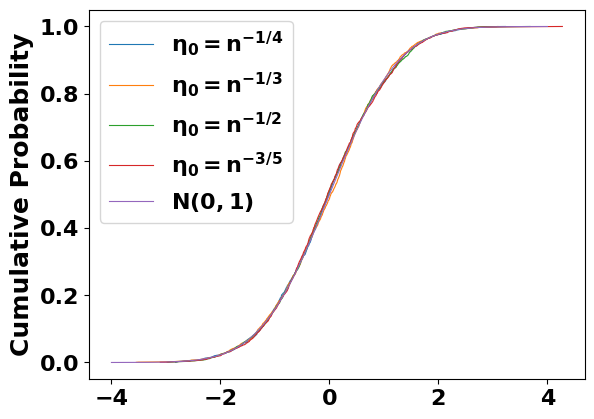

In [43]:
n = 800
R0 = 2000
c = 1
phi = 100
labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


### $T_2^l$

One can see from the above 2 subsections that when $n$ is large enough, there is little  visual difference between bulk E and edge E. But when n is not large enough, bulk eigenvalues typically have less eigen gaps. Therefore, in what follows, we use bulk E unless stated otherwise.

#### Data generating

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

n = 800
R0 = 2000
c = 1
phi = 100
m = int(n * phi)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)-2)
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)+2)



def simulate_local_test_statistics2(eta, E, m, n, R0):
    """
    Compute the test statistics for a given value of eta.
    """
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00) / np.sqrt(n * m)
        Et = jnp.array(extract_elements(E0, E-eta, E+eta))
        Eb = (Et - E * np.ones(Et.shape)) / eta
        t0 = jnp.sum(np.square(Eb))
        T0 = T0.at[r].set(t0)
    TestST = np.array(T0)
    Mean_x = jnp.mean(TestST)
    Variance_x = jnp.var(TestST)
    Normalize_TestST = (TestST - Mean_x) / np.sqrt(Variance_x)
    return Normalize_TestST



etas = [1/(n**(1/4)), 1/(n**(1/3)), 1/(n**(1/2)), 1/(n**(3/5))]
normalized_test_stats = []

Normalize_TestST_1 = simulate_local_test_statistics2(etas[0], leftb, m, n, R0)
Normalize_TestST_2 = simulate_local_test_statistics2(etas[1], leftb, m, n, R0)
Normalize_TestST_3 = simulate_local_test_statistics2(etas[2], leftb, m, n, R0)
Normalize_TestST_4 = simulate_local_test_statistics2(etas[3], leftb, m, n, R0)

#### Saved data

In [44]:
Normalize_TestST_1=[0.21060677 , 0.8542266 , 0.4982579 , 0.40995827 , 0.22621761 , 0.35313177 , -0.63002664 , 0.46497732 , -0.7513436 , -0.11355477 , -1.2080086 , -1.007995 , -0.47665304 , 0.23278728 , 0.14668801 , 1.0198672 , -1.1065106 , -0.40320587 , -0.2799813 , -0.23620571 , -2.1431773 , -0.16620253 , 1.5252056 , 1.9500065 , 0.18794493 , 0.76972455 , -0.0026443724 , -0.22965568 , 0.4158698 , -0.20515889 , 1.2954124 , 0.06178519 , 0.71068 , 0.78359866 , -0.4826785 , 0.8529967 , 0.05821352 , -0.73624355 , -0.4725961 , 0.8660339 , -0.3620904 , -1.7486511 , 1.6028826 , -0.025938818 , 1.5362625 , 0.29066485 , 1.4503852 , -0.9953056 , -0.28781223 , 0.62602866 , -0.1649609 , 1.4321536 , 1.0479573 , 1.6721864 , 0.24610345 , 0.5886852 , 0.23152404 , -0.035740282 , -1.2515544 , -0.4011784 , 0.3873986 , 0.14652495 , 0.7389076 , 0.34158573 , 0.6335806 , -2.0234027 , -0.84295756 , -0.61289126 , -0.121138185 , -1.6965849 , -0.13507713 , 0.22238661 , -1.9626547 , -1.2619786 , 0.5393223 , -0.18658346 , 0.878411 , 0.06340207 , -0.6059522 , -0.92852044 , 1.1525692 , -0.24581662 , 0.8013745 , -2.3211322 , 2.8618317 , 0.33333236 , 0.29917163 , 1.9495783 , 0.06667119 , -1.1821327 , 0.6978314 , 0.3742396 , -0.41522932 , 1.3061038 , -2.5157077 , 1.5938572 , -0.46273765 , -0.06495018 , -0.41692674 , 0.71228313 , 0.019109813 , -2.4561465 , 0.77919006 , -1.6574144 , -0.06201898 , 0.47314423 , 0.78689134 , -0.42687556 , -1.2465249 , 0.30580416 , -0.5804496 , 1.3081667 , 0.007626637 , 0.46924055 , 0.17077813 , 2.6276731 , -1.1239369 , -0.7769543 , 0.44684 , 0.56481516 , -0.1296607 , 0.6720871 , 0.65160793 , 0.7654692 , 0.330688 , -0.6590381 , -0.25121537 , 3.0560575 , 0.10308337 , 1.8353083 , 1.0509671 , -0.3387842 , -0.4929338 , 0.19315313 , -0.45648232 , 0.7097252 , 0.27116606 , -0.696688 , -1.1240704 , 0.4834624 , 0.8471972 , 1.5742699 , -0.83199304 , -0.37104905 , -0.9028587 , -1.111108 , -1.1756082 , -0.6176142 , -1.3874979 , -0.5658367 , 0.51067823 , 0.30067456 , -1.5756137 , 1.5752287 , -1.065851 , -0.69830686 , -0.021481104 , 0.5535736 , 0.16089217 , -0.65632695 , -2.1206982 , -0.41466156 , 0.896957 , 0.6356513 , 0.4816667 , -0.13251528 , -0.15325965 , 1.4149592 , -0.45218962 , 1.6269845 , 1.5299443 , 0.42931956 , 0.5773022 , -0.21371873 , -0.4682386 , 0.32380596 , -0.7945455 , 0.24655138 , -0.8003293 , -0.5957853 , -0.29169038 , 0.14890607 , 0.25580078 , -0.82865906 , 1.4659017 , 0.017103942 , -3.5379443 , 0.7286208 , 1.7404135 , -0.6974817 , -0.57445353 , -0.7611234 , 0.32428533 , -1.7734584 , -0.43731946 , -0.34478018 , 0.07299332 , -0.16963275 , 1.4831393 , -0.4112058 , -0.43124095 , -1.3285791 , 0.70891184 , 0.23591298 , 1.1395005 , -0.9033577 , 0.38015702 , 0.194049 , -0.62539995 , 0.38298607 , 0.0040726475 , 1.3775294 , -0.47297525 , -1.2332991 , 1.2037671 , 1.6451925 , -0.89237744 , 0.8661911 , 0.040317837 , -0.06404253 , 1.2223798 , 1.6416994 , 0.34034017 , -0.75070703 , 0.5990741 , 1.3776394 , 0.46982992 , -0.7426875 , -0.6712639 , -0.14433832 , -0.26999906 , 1.5706158 , -0.91890955 , -0.46878475 , 1.2223365 , 1.4219179 , -1.4426309 , 0.030143095 , -1.0456312 , -0.055920813 , -1.4927305 , 0.5400374 , 0.3074741 , -0.13228935 , -0.55230254 , 0.13580601 , -2.271274 , 0.25813082 , 0.992284 , -0.74748117 , -0.64215815 , 0.88232845 , -1.0793067 , -0.032467235 , 1.4608723 , 0.6258479 , -0.9435459 , 1.3297145 , 0.6974385 , -1.515968 , -2.2869656 , -0.36166212 , -0.5766264 , -1.1559955 , 1.1925687 , -0.3036038 , 0.7017646 , -0.17711794 , -0.22808006 , -2.1225038 , 0.14039534 , 0.67494756 , 0.37121803 , -0.07382043 , 0.7384125 , -0.7880308 , 0.7417995 , 0.40252417 , -0.64172393 , 0.57070506 , -0.7136603 , -1.2804971 , 0.9262297 , -1.8788992 , -0.27977303 , 0.79871047 , 0.82900876 , 0.2213984 , -0.34697074 , -1.440181 , -1.4002227 , 1.0368218 , -0.48619124 , 1.6147017 , 1.6836754 , 1.029321 , 0.7957871 , -0.37624153 , 0.07188921 , -1.2030008 , 1.31276 , -1.2638214 , 0.0049783355 , 1.3307991 , -1.6955574 , 0.7476619 , 2.164079 , -0.3214268 , 0.03683654 , 0.839103 , -1.2981236 , 1.1502273 , 1.0317138 , -0.008349615 , -1.7342249 , 0.39545745 , -0.83868057 , -0.45488116 , -1.6732001 , 0.48447025 , 1.5746628 , -0.14172539 , 0.39764994 , 0.3018455 , -1.0103918 , 0.49909875 , 0.4068463 , -1.4684656 , 1.9752165 , -0.80551785 , 1.8582747 , -1.3655354 , -1.2546467 , 0.82732314 , -0.119853325 , -0.024046892 , 0.4219326 , -0.2007385 , -0.19560105 , 0.9198251 , 1.2301557 , 0.7359567 , 0.33929694 , -1.300595 , -1.1147621 , 1.4443145 , 0.5687876 , -0.6208106 , -0.32362717 , -0.61729 , -3.3658185 , -0.54927504 , -0.17707275 , 0.1637173 , -1.4207745 , 0.3533891 , 1.042307 , -1.7591599 , 0.37419245 , -0.5871057 , 1.3809518 , -0.79062414 , 0.5746657 , 1.1674688 , -0.9445203 , 0.82138604 , 1.0319967 , -1.7835015 , 0.10290459 , 0.74465996 , 0.61257493 , -0.034058575 , 0.17611796 , 0.22316264 , 0.55680346 , 0.9887124 , 0.3072069 , 0.17214353 , 0.275832 , -0.44676533 , -1.2079732 , -1.1605179 , 2.3521829 , -0.16289608 , 0.7285069 , -1.1925412 , 0.38744965 , -0.82636243 , -0.73620033 , 0.3913121 , -1.1457794 , 1.5322429 , -1.1502312 , 0.07581254 , -1.884742 , -0.22123535 , 0.45718566 , -1.7214707 , -1.4769017 , -0.49277663 , -0.75542605 , 0.6249285 , 0.14555836 , -0.19595467 , 0.5532907 , -0.015064671 , -1.8293929 , 0.4412762 , -0.6392387 , 0.6146889 , 1.9198968 , 0.36220828 , 1.0074077 , 1.5346161 , -0.2558165 , 0.34276646 , -1.0678431 , -1.0743519 , 1.3854074 , -0.1203543 , -0.3776482 , -0.45631337 , -0.21138082 , 0.037477005 , 1.5853189 , 0.5502377 , 0.1201382 , 1.1663214 , 0.6959689 , -1.2872847 , -0.93282694 , -0.54742044 , -0.6251544 , -0.04268913 , -0.7933117 , 0.24723114 , 0.08867685 , 3.0656095 , 0.8815465 , 0.91561294 , -1.2630237 , 0.8142938 , -1.1453373 , -2.3191774 , 0.48233864 , 1.4029908 , -0.38385442 , 0.43698743 , 0.09903626 , -0.35797063 , -1.3761679 , 0.63394994 , -0.47821882 , -0.061787155 , -0.29324242 , 0.6937764 , 0.29696733 , 1.0128379 , 1.4475286 , 0.2910892 , 0.82656085 , -1.6433183 , -0.48143885 , 1.9888195 , -0.93480724 , 1.1801641 , -1.485591 , 1.6845713 , -1.0229242 , -1.4479687 , 0.8561873 , 0.04398381 , 0.21131992 , -1.1076934 , 0.071488425 , 0.1840707 , -0.03167746 , 1.1998417 , 0.881853 , -0.22086206 , 0.26838416 , -1.2965047 , 0.6366415 , 1.4427664 , 0.50078636 , 2.001067 , -1.304762 , 1.1749539 , 1.426794 , -0.5556797 , -0.030978056 , 0.30382973 , -1.63034 , 0.070893146 , 0.2904114 , -0.100674756 , 0.061573014 , -0.5374736 , -0.29035836 , -0.36744004 , 0.5044111 , -2.120488 , -0.043335486 , 1.4997638 , -0.2258404 , -0.26607966 , -0.20173654 , 1.5862463 , -0.7796065 , 0.6884091 , -1.1053555 , -1.9471697 , 0.06502877 , 2.0852506 , 0.06770065 , 1.0855796 , -1.2566034 , 2.7982056 , 0.91663456 , -0.9649444 , 0.8503995 , -0.39898983 , 0.95677555 , -0.34726542 , 1.3689793 , -0.44748044 , -0.20417462 , 0.82987714 , 0.16811214 , 0.30059597 , 1.9596136 , -0.89476836 , -0.50392187 , 0.8292917 , 0.66161174 , -0.8869453 , -0.88124394 , 0.09947634 , 2.1574423 , -0.26095593 , -1.5820576 , 1.6566855 , -0.5084857 , -1.4411515 , 0.5363007 , -0.41219205 , -0.54868174 , 0.02835333 , -0.63163763 , 0.23247491 , -1.6233362 , 0.23339827 , -0.096409574 , 0.831995 , 0.4832443 , -0.94070894 , 0.69198865 , -1.9585329 , -0.7329233 , 0.032659765 , 0.73703724 , -0.32706526 , -0.46028385 , 1.5434176 , -0.108032234 , 1.5132136 , 2.8225276 , 1.9103135 , -0.9496833 , 0.512411 , 2.1913438 , 0.60712117 , -0.06559458 , -1.2612399 , -0.2997846 , 1.4960468 , -0.08781438 , -0.72828096 , -0.9341039 , 1.7353723 , 1.2277118 , 1.1141334 , 0.31508306 , 1.0323504 , -0.5919151 , -0.49078646 , -1.7656726 , -0.23657113 , -1.559665 , 0.72328496 , -0.76473045 , -0.028365117 , 0.80003464 , -0.34967208 , 0.36354816 , -0.15352684 , -0.010451754 , 2.46127 , -0.9796869 , 0.8012016 , 1.1099842 , 1.7036948 , 0.5777777 , -0.79257697 , -2.4834034 , -0.31749365 , 0.36367586 , -0.72967386 , -0.8883716 , 0.10795365 , -0.41330793 , 1.6513575 , 0.37706864 , -0.1998112 , -1.310648 , 0.31384927 , -1.1224555 , 0.6670144 , -1.2908034 , -0.43881258 , 1.3886963 , -0.003504874 , -0.63590086 , 2.3422813 , -0.5026783 , 1.0080756 , -1.0882083 , 0.48377475 , 0.9866927 , 1.6404696 , 0.11543491 , 1.2419748 , 0.18966594 , 0.5835065 , 0.31153694 , -1.0028969 , -0.901454 , 0.074680924 , -1.7883737 , 0.8870042 , 1.7003039 , 0.48560184 , 1.0852457 , 1.2393894 , 0.75623155 , -0.11226795 , 0.3289886 , -0.25911117 , -0.40645143 , 1.983625 , -0.73354614 , 0.7966044 , -0.95661056 , -1.1487106 , -0.9714277 , 0.56599784 , -0.8101681 , -0.6173981 , 0.6466139 , -1.2686701 , -0.019579357 , -0.3602869 , -0.44141176 , -0.7929816 , 0.78770864 , 1.1601486 , 0.97382843 , 0.8720967 , 2.1027358 , 0.43186766 , -0.35497063 , 0.12523244 , -0.8926839 , -0.4808357 , 0.030887684 , -1.8760054 , -0.6998589 , 0.9339939 , -1.7388674 , -0.1534954 , -0.1333856 , -1.3689853 , 0.14088453 , 1.1592646 , -0.4379717 , 0.091260314 , 0.6124453 , -1.1495751 , -0.44759244 , 0.7166367 , 2.0500526 , -1.6803395 , -1.4147588 , 2.1247668 , -0.5372575 , -0.21214703 , 0.49152714 , 0.7815869 , 1.5049583 , 0.9057113 , -0.26972204 , -0.28691834 , 0.36017883 , -2.4029212 , 0.87240714 , 0.9347601 , 0.35454234 , -1.7317181 , -0.7948186 , -1.3709204 , -0.92799395 , -0.83568454 , 1.1468246 , -0.26825646 , 0.70364666 , -2.0540152 , 0.6200876 , 0.15252095 , 0.13151921 , 0.9568188 , -0.16031262 , 0.7424085 , 0.21985422 , 0.6200287 , -0.46297735 , 1.223531 , 0.4414039 , 0.3191282 , 1.5817904 , -0.19321993 , -0.7449566 , 0.46038797 , -1.1562135 , 0.886128 , -0.82011694 , -1.2770472 , 0.48691028 , -1.5599164 , -0.51232654 , 1.1997356 , 0.50334626 , -1.2553971 , -0.37105298 , -0.018899601 , 0.7615596 , -0.39153212 , 0.40907615 , -0.76829034 , 0.13921069 , 0.6084807 , 0.009210117 , 0.75915885 , 0.43864754 , -0.72656584 , 1.8196111 , -0.8232996 , -0.28565115 , 0.49912822 , 1.780637 , 0.8854168 , -1.1590878 , -0.06942558 , -1.6105603 , 0.071339116 , 0.018946752 , -0.8637432 , -0.9577343 , 0.3168964 , 0.8694445 , -1.0352345 , 1.2647172 , 0.7927577 , -1.4600511 , 0.37419835 , 0.8860298 , 0.7757402 , 0.6751637 , 0.8496333 , -1.3986137 , 0.72305703 , 1.8005387 , -0.40249273 , 0.1865638 , -1.6343282 , -1.9201188 , 0.99670047 , -0.29312456 , 0.3512418 , 1.1868045 , 0.049698878 , 0.7190689 , 2.1970766 , 1.111882 , 0.7575557 , 0.67566663 , 2.20543 , 0.1144192 , 1.0846877 , 1.9674052 , 0.28422287 , -0.99855506 , -0.5843454 , -0.119992815 , -0.2017267 , -0.5431395 , -0.3620079 , 1.1605258 , -0.5245484 , -0.20563433 , -0.47549587 , -1.1670307 , 0.9210353 , 1.2619314 , -0.71045995 , 0.9543669 , -0.4055811 , 0.36977598 , 0.23339827 , -0.91568565 , 0.12035234 , 1.6208234 , 2.3137197 , -0.7128057 , -0.68417144 , -0.45789096 , -1.5028522 , -2.45562 , 1.2636131 , 1.5500265 , 0.109560706 , -2.9103262 , -1.5476239 , -1.2882239 , -0.050541695 , 0.34181166 , -1.34585 , -1.9276394 , -0.0032219694 , -1.0469416 , -2.6922953 , -2.1380005 , 0.03399374 , 0.64616984 , -0.7732373 , -1.3328462 , 0.4851952 , -0.20393887 , -0.387375 , 0.14540511 , 0.8239715 , -0.16619074 , 0.48580027 , 0.12118927 , -0.27622885 , -0.314531 , -0.8601204 , 0.61485 , -0.09429172 , 1.3666022 , 1.2279632 , 0.47347623 , 0.15693349 , -1.7019582 , -0.020117663 , -0.9103556 , -0.62554926 , -1.7264038 , -1.29821 , -0.86342686 , 0.054419845 , -0.19370125 , 0.3747504 , -1.2024939 , -2.2866454 , 0.84497714 , 0.39469516 , -0.13627948 , -0.376216 , 0.7827303 , 0.23678134 , -0.30546626 , -0.8857724 , 0.039176397 , -0.32345036 , 1.2034527 , -1.235967 , -1.3939143 , -2.0459034 , 0.6907509 , -1.3865745 , -0.5656678 , 0.6386965 , -2.7263832 , 0.5102322 , 0.03627073 , 0.5246191 , -0.12129143 , 0.054924753 , -1.0390261 , 1.4737524 , 0.30530125 , 1.5066282 , 0.26610717 , 0.5034563 , -0.24524687 , -0.5057176 , 0.41427845 , -0.3804242 , 0.08551971 , 0.13272941 , -0.24392861 , 0.2175399 , -0.8445253 , 2.1678667 , -1.6792865 , -0.8277966 , 0.8825328 , 0.011785728 , -0.3336349 , 0.34415346 , -0.25693634 , 0.018310215 , -0.12615386 , 0.5345601 , 0.3057865 , -0.049221475 , -0.15098463 , 0.5815419 , -0.24220172 , 1.5208088 , -1.4073876 , -0.56154406 , 0.8498062 , -1.1561624 , -1.5011764 , 0.17531835 , 1.3830539 , 1.6369647 , -2.083451 , 0.16926537 , 0.94951826 , -2.133089 , 0.25822118 , 0.75933564 , 0.3409767 , -1.0851121 , 0.38132203 , 0.121487886 , 0.2745275 , -0.06657296 , 0.15300424 , 0.40915868 , -1.1359367 , 1.4477959 , 0.8559672 , -0.080669075 , -0.8417984 , 0.5231103 , 0.23589137 , 0.9991759 , -0.529564 , 0.23030204 , 0.8080974 , -0.88634413 , -0.8198831 , -1.2402931 , -0.14321457 , 1.282501 , -0.08500891 , 1.5574843 , 1.7733326 , -1.6715183 , -0.7506285 , 1.3063121 , -0.6989041 , 0.712511 , 1.8360156 , -1.3260545 , -1.8720938 , 0.42278525 , -1.2774185 , -0.9483906 , -0.2594589 , 1.1829971 , 1.3649244 , -1.7544467 , -1.9116808 , -0.08561794 , 2.4738398 , -1.0891435 , -1.0558904 , 0.09126228 , -0.6071565 , -0.65905774 , -1.992847 , 0.9521823 , -0.061034705 , 0.20813921 , 1.0268416 , 2.2170842 , 1.2322814 , -0.52784896 , 0.09043125 , -0.21150264 , 1.7707078 , -0.011948791 , 0.8816212 , 1.1335438 , 1.6669133 , 0.53704333 , -1.3046265 , -0.17327516 , 0.97453177 , -0.13927944 , -0.051520076 , -0.5857383 , -1.420747 , 0.14009672 , -1.051971 , 0.82637227 , -0.5226388 , -0.13045636 , -0.45295584 , -0.086126775 , -0.4049308 , -0.28054315 , -2.4749026 , 0.4145319 , 0.81134295 , -0.6744132 , 0.13618322 , -1.6442121 , -0.5498015 , 0.45453933 , 0.21799766 , -0.5490609 , 1.8117251 , 0.44689894 , 0.9663 , 1.0904126 , -0.28932497 , 0.5512318 , -0.47411868 , 0.30236217 , -0.73823565 , 1.3766296 , 0.862364 , -0.7977714 , -0.9050924 , 1.3899182 , -0.49336994 , 0.71316326 , -1.3384179 , -1.0996306 , -0.17876428 , 1.0414976 , -0.8861241 , -1.3021785 , -0.53412586 , -0.30227375 , 0.3113562 , 0.4372291 , 1.9136847 , 0.30659395 , 0.29631704 , 1.4012109 , 0.114377946 , -0.45785755 , -1.35629 , 0.50512224 , 1.4873632 , -1.0333445 , 1.9214175 , -1.7145905 , 0.24118404 , -1.1814058 , 0.406198 , 1.1612331 , -1.2973927 , -0.24936274 , 0.10533089 , -0.08837233 , -0.84265894 , -0.0031905354 , -1.1052258 , -0.19986425 , -0.09781034 , 0.18114933 , -1.4347311 , 0.22183652 , -0.58353794 , -0.19183291 , -0.012270988 , -0.73736143 , -0.4702307 , -1.1632606 , 0.8573503 , -0.41707215 , -0.5005565 , 0.7277014 , 0.25791866 , -0.09249017 , -0.48404393 , -0.015638338 , -1.060527 , -0.9120295 , -0.36769348 , 0.5087136 , 0.9080924 , 0.5361278 , 0.25591668 , -0.76399374 , -1.1628755 , -0.88149345 , -0.8211051 , 1.2994516 , -0.25893238 , 0.42235893 , 1.0995166 , -0.2234082 , 1.324084 , -0.04713505 , -0.022428049 , 1.5471897 , 1.2372284 , -0.8874993 , 0.62496775 , -0.57632387 , 0.20487599 , -0.022746317 , -0.6709751 , -0.15123217 , -0.16185091 , -0.06718002 , 0.14968012 , -0.834551 , -0.7748011 , -1.884467 , -1.8024325 , 0.9156601 , 0.8631184 , 0.33062905 , -1.4614125 , 1.6750625 , 1.1162984 , 0.009062771 , 0.4460895 , -1.5210838 , 0.1670041 , -0.38889956 , -0.27510902 , -0.8613817 , 0.08449811 , -0.5061164 , 1.6000967 , -0.2385711 , -0.2650718 , -0.371273 , -0.7556854 , 0.0998339 , 1.9814757 , -0.2224141 , -1.7153214 , 0.39622363 , -1.5349226 , -0.3880076 , 0.82403827 , -0.44908357 , -1.043478 , -0.97303474 , -0.7280983 , 0.47795558 , -0.70808667 , 0.46551955 , 1.5351348 , -0.88253474 , -0.21084449 , 0.11977867 , 0.98845696 , -2.4485924 , 0.1762653 , -1.2883811 , -1.1563373 , -0.95383257 , -2.8455567 , -1.4347095 , -1.2713891 , -0.48101252 , -0.09381431 , -0.764369 , -1.0691476 , -1.0917741 , -0.088435195 , -0.5422417 , -0.4173413 , 1.6734005 , -0.35368186 , -0.030095944 , -0.39274824 , 0.9511568 , 0.01810786 , -0.4863661 , 0.14369787 , -1.3535355 , -0.6407004 , -0.3730569 , 1.3864605 , 0.002420406 , -0.061629985 , -0.7732923 , -1.2824911 , 1.5979239 , -0.1486762 , 1.4282047 , -1.5422742 , 0.7043539 , -0.98371047 , 0.076156355 , 0.14255053 , -0.18617874 , -1.2987248 , -0.030302228 , 1.1233279 , -1.7046045 , -0.52557784 , 0.50914973 , 1.7063392 , 0.20537303 , 0.68595725 , -0.7607875 , 0.15039524 , 0.80429786 , -1.5775312 , -1.8789504 , -0.09841544 , 2.523399 , 0.7694338 , 0.950088 , -1.4609077 , 0.10534268 , 3.0130796 , -0.450726 , 0.41770473 , 0.823441 , -0.285604 , 0.5603162 , 0.5287959 , -1.1871208 , 0.8607137 , 0.64161193 , -0.86134636 , -0.4650952 , 0.3320082 , -0.19848312 , -0.31372747 , -0.12266076 , -1.5552446 , -0.0619345 , 0.8214332 , 0.71296287 , 0.028231524 , 0.69036585 , 0.03095841 , -1.6594871 , 0.2786198 , 0.9793372 , 0.056215506 , 0.89835185 , -2.1001248 , -1.7208675 , 1.3229878 , -0.45382223 , 0.010648215 , -2.2742212 , 0.74772084 , 0.6532975 , -2.9716969 , -1.2483697 , -0.29985926 , 0.26033118 , -1.4983572 , -2.1362717 , -1.3582172 , -1.2055706 , 1.2983437 , -0.45722887 , -1.7005967 , 1.2327294 , -0.068620086 , 1.4372891 , -0.55126715 , -0.46912068 , 1.1088997 , -1.2299082 , -1.53018 , 0.64963937 , -0.71935964 , 1.0119812 , 2.5172734 , -0.14565462 , 1.2757899 , 0.49005562 , 0.15412408 , -0.8765839 , 0.24335298 , 0.34157392 , -0.5984533 , 1.9152093 , -0.72241855 , 0.7042046 , -0.9823549 , 0.77535117 , -1.5000644 , -0.4519598 , 0.4110565 , -0.5532357 , -1.0090284 , -0.17253253 , -1.1478442 , 0.28425628 , -1.4803613 , 0.45302853 , 1.1442353 , -0.4601031 , -0.39443976 , -0.9530114 , -0.44157284 , 0.3168846 , -0.2896845 , 0.74177593 , 0.050561342 , -1.3800383 , -1.2403383 , 1.7631794 , 0.7344911 , 1.4049044 , -0.17944011 , -0.4566552 , -0.2897788 , -2.6212292 , 0.69451904 , 1.329746 , -0.15179405 , -1.2579609 , 0.17530264 , -0.7210099 , -0.97875375 , -0.11330723 , -1.8454163 , 0.28358832 , 0.7643533 , -0.77871853 , -0.73059726 , 0.77116656 , -0.91456383 , -0.19618256 , 0.5555736 , 0.64308935 , -0.6658553 , -0.76692694 , -0.081781045 , 2.3284464 , -0.2948927 , 0.034302186 , 0.5698328 , -0.41855347 , -0.050337378 , -0.5314776 , 1.2052641 , 0.21878743 , -0.9548738 , 0.17442445 , 0.4595098 , -0.2668262 , -1.9883008 , 0.4390994 , -0.52406114 , -1.1352707 , -0.2123985 , 1.1559011 , -1.4670844 , 1.3657378 , -0.95493275 , 0.61203665 , -1.0036415 , -0.09105992 , 0.50075495 , -0.23638056 , 0.19349301 , 0.26662976 , -0.34978995 , -0.44458854 , -1.2379552 , -1.010942 , 1.5225062 , -1.128314 , -1.4463302 , -1.8134559 , 0.5323361 , 2.346073 , 0.36391357 , -0.49718916 , -1.0691633 , -0.1718567 , 0.47820312 , -0.7559742 , 0.90444607 , 0.20607243 , -0.92789376 , 1.6178293 , 1.0435094 , -1.1157798 , -1.5495884 , 1.5757473 , 1.5720656 , -0.29632688 , -1.0849844 , -0.21308611 , 0.250015 , -0.219033 , -2.3619118 , -1.284827 , -1.2995067 , 0.8687215 , 0.15790793 , 0.34686857 , 1.140864 , -1.0727822 , 0.029190255 , 1.3256203 , -0.0794569 , 1.5194728 , -0.6418752 , 1.8856497 , -0.83188105 , 0.77913505 , -0.6005436 , 0.12709883 , 0.379713 , -1.1732801 , 1.3716866 , -0.90890574 , -0.10057652 , -1.923445 , -1.5840065 , 1.263845 , 1.1031551 , -1.6921743 , -0.29780427 , 0.7044364 , -0.44237834 , 1.8084285 , -0.102435045 , 0.22809578 , -0.22035912 , 0.5036999 , -0.9615162 , 0.79800713 , 0.6185081 , 0.79234904 , -0.9531921 , -1.0109577 , -0.49167645 , 0.6744878 , 0.87342477 , -0.021995835 , 0.7065464 , -1.4980389 , 0.72360325 , 1.1136658 , 0.61162406 , 0.17194314 , -0.6298243 , 0.8849178 , 1.5395905 , 0.47113442 , -0.44128013 , 1.8833117 , 0.880297 , 0.757041 , 2.1461222 , -0.44702467 , 1.4197057 , -0.94625896 , 1.5741795 , -0.37824348 , -1.6761667 , -1.1418895 , -0.21029243 , -1.7594644 , -0.75631016 , 0.0018821015 , -0.71958166 , -0.13266654 , 0.330411 , 0.6261504 , 1.3088347 , -0.486038 , -0.053083908 , 1.0795444 , -1.4347115 , 0.5303558 , 0.7333556 , 0.9529053 , -0.8517787 , -0.22919007 , -0.77606237 , -1.5716314 , -0.83028775 , 1.2460141 , 0.8221955 , 1.0181698 , -1.1465417 , 0.5234757 , -1.139027 , -0.6151191 , -0.607298 , 0.66075516 , 0.62569857 , 2.0022025 , 0.92664623 , -0.3057865 , 0.20142612 , 0.17639495 , -0.7378742 , 1.5706904 , -0.6170189 , -0.14571357 , 0.17069365 , 1.9289223 , 0.5763553 , 0.30548984 , 0.0031767832 , 1.6810979 , -0.13939339 , 1.6729015 , 2.3916836 , 0.23915264 , -0.4891853 , 1.3394866 , -0.34228316 , 0.27803236 , -0.0203043 , 0.42315066 , 0.26162586 , 0.91966003 , -0.75204694 , -0.17574467 , 0.8183802 , 0.9580054 , -1.7381974 , -0.0009174754 , 0.65150577 , -0.07809346 , -0.16193146 , 0.54783696 , -0.9290156 , -1.0051916 , -0.4663113 , 0.14405149 , -0.015559754 , -0.36037335 , 0.30857626 , -1.2441713 , 1.267287 , 1.2131225 , -0.4992127 , 0.92385256 , 1.0841416 , -1.5541542 , -0.11433276 , 0.58550256 , -0.3679607 , 0.5539469 , 0.16343635 , -1.355007 , -0.46614036 , 0.4459952 , 1.0771986 , -0.46485946 , -0.19638295 , 0.9600054 , -0.0006777923 , 1.4311398 , -0.63375545 , 0.87641495 , -0.15292959 , 0.083441146 , -1.4438685 , -0.43079302 , 0.5837776 , -1.0398238 , -0.20562647 , 0.018966397 , 1.3256124 , 1.680925 , 1.3326812 , 0.36600393 , 0.50205356 , 0.05531964 , 0.2745393 , -1.397152 , -0.16863276 , -0.28109324 , 0.074732006 , -0.24864173 , 0.43743342 , 0.61456317 , 1.118377 , 0.6213607 , -1.3297421 , 0.29072967 , -0.072099425 , -1.8993548 , -0.4168187 , -0.4051214 , -1.4162402 , -2.209206 , 2.270954 , -0.34006315 , 0.06680478 , -0.9234871 , 0.36972097 , -1.0015334 , 0.56715304 , 0.7112458 , 0.03245348 , -0.053087838 , 0.4954485 , 2.4835095 , 0.2832838 , -0.72863656 , 1.1001375 , 0.21323542 , -0.7447464 , 0.24053572 , -1.0564071 , -0.6608691 , 0.38236916 , 0.6184649 , -1.1512135 , 0.0836769 , 0.2847926 , 0.30823246 , 0.74763834 , -1.6991998 , 1.6885791 , 0.03995242 , 0.934878 , -0.30219126 , 1.0335134 , 0.10823459 , -0.9905807 , -0.14562908 , 1.4642514 , -0.33643255 , -0.2927159 , 0.6766175 , -0.32850334 , -0.6356081 , 1.3654156 , 0.7269313 , -0.28223667 , 0.86296517 , 2.0089254 , -0.70723796 , -0.6585587 , 0.7932881 , -1.1861051 , 0.5485599 , 0.82820326 , 0.13105163 , -0.43881258 , 0.38730034 , -0.5648112 , 1.0739845 , -1.2545445 , -0.17927116 , -1.9585329 , 0.59163606 , 0.6034473 , 0.95832366 , 1.3431094 , 0.44242352 , 0.21351047 , 0.5632199 , -3.2393718 , 0.53800994 , -0.7582492 , 0.37531227 , -1.9154058 , -0.6650184 , 1.0741496 , -0.55562073 , -1.2424287 , 0.04537279 , -0.6664722 , -2.2239878 , -0.89529884 , 1.6660528 , 0.14230496 , 0.12777466 , -0.7197604 , -0.14223816 , 1.3228502 , -0.2908063 , -0.13563704 , 0.6862834 , 0.98869663 , -0.9205225 , -0.008343722 , 0.028137222 , 1.1746043 , 0.29214814 , -0.3533459 , -0.5629959 , -0.9186188 , -0.35944605 , 1.045144 , 3.2163072 , 0.45250595 , -0.97108585 , 0.3261733 , 0.0921994 , 0.32299063 , 0.9304065 , -1.0518041 , -1.2005882 , 0.2114771 , 0.28427985 , -0.6125553 , 2.028324 , 0.73095876 , -0.28183588 , 1.1242237 , -0.15500815 , 0.92017084 , 0.13491014 , 0.5599036 , 0.20506853 , -0.36556384 , 0.5951606 , 0.10496351 , 0.11799284 , -0.60258687 , 0.65627587 , 0.97146696 , 0.54181343 , 0.5911135 , -0.31036994 , 1.8913274 , 0.62904626 , -0.7090258 , -0.1421969 , -1.0838783 , -0.3662554 , -0.8636941 , -0.30657825 , 0.5560451 , 0.59299165 , 0.17753051 , 0.7970838 , 0.28332898 , -0.68920475 , 0.5884102 , 2.8565037 , 0.64813054 , -0.71130866 , -0.2979634 , -0.8836349 , -0.7963411 , 1.6402496 , -1.2595837 , -2.6177912 , -0.3162245 , 0.7255482 , 0.5990702 , 1.3237815 , -0.3795696 , 1.9262426 , -1.1694373 , -0.39365393 , 0.22735512 , 2.002513 , 0.55392724 , 0.60423714 , -0.23310162 , -0.3671709 , 0.7082517 , -1.1202335 , 1.4822395 , -0.33834213 , 0.3486662 , 0.35743624 , 1.2028791 , -0.62713474 , 0.6449047 , 0.2372332 , -0.111790545 , -1.8124756 , 1.2466192 , -0.3050203 , 1.1221529 , 0.94203705 , -1.188052 , 0.6362289 , 1.0854814 , -1.0537254 , 1.1163849 , -0.14833632 , 0.3434423 , -0.18417877 , -0.00725336 , -0.67815775 , 0.19603325 , 0.38595065 , -0.7024875 , -1.8274715 , 0.89058375 , -0.10725425 , -1.4788465 , -1.6419392 , -0.10035648 , 0.9394162 , -1.030979 , -0.796793 , -0.7590606 , -0.9388642 , 1.4372852 , -1.398205 , -0.16876243 , 0.49248585 , -1.1519502 , 1.3591446 , -0.6390521 , 1.9346747 , -0.4527967 , -0.011485142 , 0.7714573 , 1.2225802 , 0.6783817 , 0.6684054 , 1.0502126 , -0.424687 , 0.3721296 , -0.1668705 , -0.41157907 , 1.8389586 , 1.1570209 , 0.70645213 , -1.4480336 , 2.1511202 , -0.43943733 , 0.15440501 , 0.13549756 , -1.5574528 , 1.2535583 , -1.1601486 , -0.3037374 , 1.1111747 , 0.10022682 , 0.33843645 , 0.66017365 , 0.121242315 , -0.057687003 , 0.8324469 , -0.71408665 , -0.7387229 , -1.5630716 , 1.03637 , 0.73132414 , 0.14900036 , -1.3583822 , 1.4195447 , 0.3449236 , 0.49237978 , 0.286048 , 1.1408365 , -0.16210827 , -0.9991386 , -0.5942863 , 1.4441259 , -0.73471117 , -1.4381181 , -0.55957353 , 0.11274142 , -0.6502798 , -1.211154 , -1.1053771 , -0.39127675 , -0.1562105 , 1.5757041 , 0.49980602 , 1.6596678 , 0.39567354 , 1.8624476 , -1.8623631 , -0.6531835 , -0.9351864 , -0.33362314 , 0.5249177 , -0.43793243 , 0.7953117 , 0.20105875 , -0.30489457 , -2.4927275 , 0.52437943 , -1.313481 , -1.938207 , -1.0766721 , 0.11871778 , 0.827221 , -0.9351314 , -0.8420381 , -0.78901905 , 0.99201685 , -1.2661966 , -1.5678574 , 0.565931 , 0.06341582 , -0.37558338 , 0.70616925 , -0.64760405 , -1.036535 , -0.28366688 , -0.42443943 , -0.42242572 , -1.2014822 , 0.79698163 , 0.28800476 , 0.20467757 , 0.46486336 , 0.12587684 , -0.21682478 , -0.6616432 , 1.8144088 , -0.9038606 , 0.76874614 , -0.03366958 , 1.6481395 , 0.4560776 , -0.72264844 , -0.7777657 , -0.4212666 , -0.009874157 , 2.6445532 , -1.188836 , -0.8619809 , 0.89723593 , -1.0444918 , -0.10227395 , -0.41511932 , -1.983682 , 0.75077385 , 0.22764981 , 1.3837415 , 0.30818528 , 0.9499466 , -2.4718752 , -0.78112715 , -0.8613817 , 0.17780948 , 1.4689115 , -2.4667828 , 0.90171134 , 0.8857665 , 0.4035163 , -0.33978024 , 1.3031334 , -0.28758827 , 1.6138884 , 0.7248252 , -1.2473029 , -0.5376838 , 0.751489 , 1.511473 , -0.4707022 , 1.6629409 , -1.4354659 , -1.0363268 , -0.29988873 , 1.2531103 , -0.091617875 , -0.7668444 , -0.15322429 , -0.6985249 , 0.24396987 , -0.5858365 , 0.07644908 , 0.4634076 , -1.6836814 , -3.0748825 , 1.2839195 , 0.9908145 , -0.5003601 , -0.28894973 , 1.9239204 , -0.612793 , -0.006744525 , 1.1299093]

In [45]:
Normalize_TestST_2=[0.12270575 , 2.0220394 , -0.9350833 , -0.07638329 , 1.0216631 , 1.0661873 , 0.18778777 , 0.34493408 , -1.2793679 , 1.5610788 , -0.78996515 , -0.87438315 , -0.80293936 , 0.45833525 , -0.04269461 , -1.25381 , 1.0123773 , 0.0045405575 , -0.3450991 , 1.1447384 , 0.9110585 , -2.9288101 , 2.1379929 , -0.090512484 , -0.2189639 , -2.1625607 , 0.25081256 , -0.8911983 , 0.06881848 , -0.26228508 , 0.31243798 , 0.7470011 , -1.0249003 , 2.0249257 , 0.86427444 , 0.79694724 , 0.046520874 , 1.1053333 , 1.0825032 , 1.2741903 , 1.068564 , 0.33585298 , 1.3440635 , -0.863226 , -0.70851076 , -0.89872754 , 0.40333477 , -1.0028993 , -0.1117491 , -1.2809532 , 0.1383053 , -0.40454406 , -1.7064686 , -1.3626372 , 0.29262996 , 0.35907373 , 1.1271402 , 0.28976235 , -0.47545528 , 1.6005361 , 0.37170124 , 0.203262 , -0.4732268 , -0.5641152 , -0.16155112 , -0.6787695 , -0.1023171 , 0.63154894 , 0.061729863 , -0.7579703 , 0.9402672 , 0.7288493 , -0.6566202 , -0.13668874 , 0.921729 , -0.14740731 , -0.017117944 , -0.6275932 , -1.76187 , 1.1955744 , 0.93368816 , 0.61433285 , -1.8809313 , 1.2259338 , 0.6061039 , -0.60321957 , 1.1931955 , -0.74791586 , -1.6174661 , 1.1918776 , 0.9183497 , -0.24549086 , -0.36805668 , -0.47339177 , 1.1752526 , -0.77466005 , 0.7242712 , -0.101187184 , 1.1672574 , 0.36132312 , -0.576137 , -0.78859085 , -0.79637706 , -1.3324845 , 1.0444034 , 0.9989519 , -1.6899061 , 0.11500936 , 0.028162317 , 0.505961 , 1.3131025 , -0.4297009 , -0.49468267 , 0.27519038 , 0.11776836 , -0.95358187 , 0.358184 , 2.2159593 , 1.1701063 , 0.40503278 , -0.92834145 , -0.714906 , 1.224522 , -1.5382799 , -0.9255845 , -1.1291703 , -0.19766672 , -1.2369823 , -0.62690187 , -0.7214892 , -0.93649524 , -1.0850345 , -0.3390506 , -0.8029895 , -0.26653114 , -0.1284556 , -0.08867663 , 0.38035002 , -0.23134287 , 0.52265704 , -0.8335808 , 0.081458524 , 1.0174483 , 0.44428542 , -1.1392205 , -0.665764 , 1.7208003 , -1.450493 , -0.87984896 , -0.0895956 , -1.0081688 , -0.9594967 , -0.8695857 , -1.6210083 , 1.0492343 , -0.9656893 , 1.7722586 , 1.0465505 , 1.4111401 , 1.408897 , -0.5171933 , 0.26545346 , 2.0675952 , 1.6191996 , -0.72573733 , 0.38911158 , 0.6267849 , -0.114577025 , 0.30036184 , -0.64182264 , 1.3362147 , 0.13012645 , -1.1612445 , -0.2668674 , 0.17952955 , 0.21437113 , 0.67096657 , -0.4379445 , 0.15824491 , 1.066983 , -1.7835808 , -0.6638446 , -1.852888 , -0.57592607 , -0.27551618 , -0.70083946 , -2.2024043 , -1.3975059 , 0.47377607 , -0.0018546528 , -0.20200051 , 1.8290762 , -1.4227192 , -0.7961285 , 0.9740979 , -1.2989128 , 1.1232158 , 1.6664014 , -0.5091168 , 0.9314534 , -2.374578 , 2.306407 , 0.26307246 , 0.9612365 , -1.4431329 , 0.015317594 , 0.985819 , -0.23485795 , -0.94393474 , 1.2698022 , -1.5942161 , -1.0549257 , 0.7357082 , 0.9936887 , -1.3270041 , 1.0512581 , -1.1482472 , -0.8056378 , -0.60746145 , -0.5154285 , 0.043020427 , -2.2446854 , 1.6294398 , -0.21570781 , 1.1854657 , 0.08802082 , -0.47582078 , 1.5423192 , 0.81452674 , -0.514144 , 0.14508273 , -0.35574663 , 0.36395472 , 1.6157786 , -0.31717905 , 0.4944279 , -1.5918769 , -1.474566 , -1.852088 , 1.3262689 , -0.9786781 , 0.29541612 , 0.052928615 , 0.41068864 , 1.9193108 , 1.2930021 , 1.1746886 , -1.9765043 , 0.04263195 , 2.2070577 , 0.26417106 , 1.0092778 , 0.5570725 , 1.5642471 , 0.30323157 , -1.590181 , -0.09542272 , -0.25730383 , -1.0519243 , -1.3941538 , -0.8117364 , -0.28301835 , 0.19426234 , 0.77614295 , 0.9504469 , 0.12175545 , 2.2401762 , -0.107987575 , 2.482503 , -0.25226203 , -2.597155 , -1.0781193 , -0.15728626 , 1.212404 , 1.3089943 , -0.6587944 , -0.9860696 , -1.5231712 , 0.6677502 , 0.5077864 , -0.11801899 , 1.4338534 , -2.0598633 , -0.36396307 , 0.9537301 , -0.3345121 , -0.4127814 , -0.67218214 , 0.806469 , 0.80033904 , 1.8168037 , -0.3965866 , 1.1315408 , -0.78444713 , -1.3967248 , -0.43171638 , 1.505623 , 0.815287 , -0.33005092 , -0.6905344 , 0.82710415 , -0.3535223 , -1.5449383 , 1.1341264 , -0.6630655 , 1.8630927 , -0.5590755 , 1.1851022 , 0.6100325 , -0.46085197 , 1.8979907 , -0.53398544 , 1.6812887 , 0.44680423 , 0.16010791 , -0.07779726 , 0.065357715 , 1.9410027 , 0.3475824 , 0.3014479 , -0.51523215 , -0.50132436 , -0.97436106 , -1.7013849 , 0.118967205 , -0.83229005 , -1.8778902 , -1.0266966 , -1.7244616 , -0.2973 , 0.29749632 , 1.4909132 , -1.1253691 , -1.9747833 , 1.7375966 , -1.8238171 , -1.3778358 , -0.34204352 , -0.6513883 , -0.35406741 , -0.047427315 , -0.5462976 , 0.63153225 , -0.18493061 , 2.8844988 , 0.7191834 , -0.33214575 , -1.3140883 , 0.40152398 , -2.4744034 , -0.65886956 , -0.33552507 , -0.9051165 , -1.0180123 , 1.7613354 , -1.1099094 , 1.5167571 , -1.6034037 , -1.5427474 , 1.4251921 , -1.0252178 , 1.1315533 , -1.3794962 , 1.3305839 , 2.318556 , -0.4187756 , -0.22113393 , -0.5260092 , -0.48731837 , -2.473708 , 0.47086042 , 2.4155183 , 0.4081573 , -0.58397335 , 1.4163783 , -1.7584198 , -0.6882537 , -0.95211357 , -1.1541517 , 0.650603 , -1.0228953 , -0.21266685 , -0.041044638 , -0.24264415 , 0.6789136 , -1.2451571 , 0.13067366 , 0.26045758 , 0.4289929 , -0.70625097 , -0.6421652 , 1.5028995 , 1.0303682 , -0.87199175 , -0.064000145 , 0.4577588 , 0.50066435 , -0.9605347 , 0.93217397 , 1.1020147 , -1.2418258 , -1.5112747 , 0.7528888 , -2.5697718 , 0.585757 , 1.3339298 , -1.2683235 , -0.46753123 , 0.47668335 , -0.290957 , 0.5845728 , 0.1697425 , 0.19329324 , 0.9124975 , -0.50421494 , 1.6216515 , 0.16752234 , -0.43141353 , 0.6242598 , 0.36772668 , -0.1024633 , 0.06278459 , -0.6218183 , 1.4580077 , -0.12879394 , -0.26210755 , 0.5990737 , 0.057799168 , -0.08122669 , -2.4005911 , 0.492945 , 1.0351468 , 0.26803073 , 0.08425512 , 1.1658498 , 0.15922654 , 0.7485571 , -1.5493745 , 1.9125773 , 0.056823805 , -0.87409705 , -0.74556625 , -0.5248521 , -2.5294645 , -0.22663523 , 0.5416902 , 0.14633796 , -1.8755009 , 1.4495991 , 1.2263558 , 0.8803586 , -1.4150332 , 0.48916468 , -1.2643949 , 0.08982743 , 1.3787903 , 0.06991707 , -0.9622849 , -0.77646875 , 0.7689959 , 0.026804745 , -0.26260045 , 0.01605695 , -0.40240118 , -0.00604433 , 0.041073877 , 0.3426137 , 0.34374568 , 1.8046106 , 0.23911653 , 1.1129943 , -1.2618155 , 0.69211966 , 1.8840077 , -0.28979367 , 0.60018486 , 0.6285853 , 1.8698534 , -0.33983588 , -0.7880165 , 0.22133861 , 0.6445775 , 1.26659 , 0.661616 , 1.2612182 , -0.66857725 , 0.47857562 , -0.9512489 , 0.21498308 , -0.022965949 , 0.83212507 , -1.9774212 , 1.4330827 , -0.55289537 , -1.2408922 , 0.09017205 , -0.028529907 , -1.4177024 , -0.18714449 , -0.9327901 , -0.9225436 , -0.5334779 , 1.3802334 , -0.77306855 , 0.7613809 , -0.79049146 , 0.79575676 , 0.98653746 , 0.7070843 , -0.050821245 , -1.4535006 , -0.6912738 , 1.5824866 , 0.9382998 , -0.99103206 , -0.97653735 , -1.3208636 , -0.3486288 , -0.35720026 , 0.42976147 , -2.0216885 , 0.48279244 , -0.016921619 , -0.06797052 , -0.022456337 , 1.1361043 , -1.1825291 , -0.48735598 , -0.35985067 , 0.14813621 , -0.6254253 , 0.238632 , -0.76849043 , 0.09350541 , 1.6432517 , -0.008015943 , 1.3181652 , -0.80164444 , 0.40336192 , 1.3922824 , 0.8544665 , -0.51978105 , 0.04591101 , 0.6545316 , 1.0174003 , -2.2555125 , 0.030537026 , -1.7605877 , -0.14681832 , 0.019979289 , 0.00050752325 , 1.5031084 , -0.6441932 , -0.12537286 , -0.20803022 , -1.8085663 , 1.0392008 , 0.4842774 , 1.0585014 , 1.6250392 , 0.99256295 , 0.8576934 , -0.3631193 , 1.2088118 , -1.275103 , 0.34491947 , 0.031971876 , 0.6274261 , -0.9822559 , 0.60867697 , 0.2884361 , -0.71766084 , 0.09962493 , 0.26842758 , 0.083012424 , -1.3331152 , 0.38697496 , 0.63536686 , -0.84539795 , 1.241216 , -1.1826628 , 0.17432901 , -0.3103494 , 0.77168596 , -1.0092925 , -2.2447774 , -0.057717714 , 1.0337664 , 0.1689551 , -0.35772243 , -1.2681983 , -2.7711332 , 2.1431599 , 0.9591562 , 0.39162832 , -1.6656849 , -0.19922061 , -1.5268053 , -0.88130677 , -1.6069208 , -0.16755785 , -1.1341286 , -1.3174697 , 1.3033072 , -1.4250438 , 0.87573445 , 0.18848744 , -0.06627251 , -0.7978328 , 0.249927 , -0.5353305 , -0.08054999 , -0.6266137 , -0.3843768 , 1.509512 , -0.37607262 , 0.6783309 , 0.22787166 , 0.8110639 , 0.20318055 , 0.6260456 , 1.3135892 , -0.8303226 , 0.6742039 , 1.2228031 , 1.0621521 , 0.3794227 , 0.96959287 , 0.7992927 , -0.5658696 , -0.82250303 , 0.42092472 , 0.047715537 , -0.569086 , 0.88094753 , -0.546496 , 0.96905607 , 0.7951302 , 0.9760904 , 0.3440548 , 0.34313166 , -1.5096664 , -0.8447567 , -0.70190674 , -0.29584008 , -1.592374 , -1.2187116 , -0.35344085 , -1.2004825 , 0.8435976 , 0.243985 , 0.688897 , 0.13860188 , 1.0484093 , 1.7060884 , 1.0034716 , 1.2477908 , 1.0606066 , 1.4869783 , 1.040525 , -0.2521785 , -0.5951514 , -0.239033 , -0.89252657 , 1.8210727 , 0.22040293 , -0.5237264 , 0.36140248 , 1.4284794 , 1.2845976 , -0.169377 , -1.7412077 , 0.2224748 , 0.37738007 , 0.14290017 , 1.5549029 , -0.33031198 , -1.2364477 , -0.26658964 , -0.82771397 , 0.23574767 , -0.47342518 , 0.059967108 , 0.6000742 , -0.6914367 , 0.84245515 , -0.851342 , -0.40588075 , 0.074207 , 1.651255 , 1.8290468 , 0.065760806 , -0.2696076 , -0.71637636 , 0.47175434 , 0.23273386 , -1.306112 , 1.5287707 , 0.02840877 , 0.7013344 , 1.2530456 , -1.6295214 , -0.20538191 , -0.7013783 , -0.36691633 , -2.239136 , 0.22066608 , -0.05630166 , 2.309757 , 1.426842 , -1.0951349 , 0.90103126 , 1.8123446 , 0.08001323 , -1.977064 , 1.423446 , -0.4101686 , 0.15458573 , 0.33223766 , -0.28270924 , -1.2710053 , 0.082139395 , -0.2856249 , 0.36346182 , -0.65309465 , -1.5030165 , 0.02174831 , 1.0114353 , -0.8962547 , -0.5044927 , 0.0074603828 , -1.1350099 , -0.53023857 , 0.977732 , 0.8358051 , 0.43454012 , 0.8887672 , 0.08014272 , 0.06811045 , 0.12127717 , 0.5653642 , 0.8767641 , 0.29138935 , -1.0489357 , -1.5850974 , 1.4592692 , 0.4883376 , 0.7563976 , -2.1428049 , -0.6004773 , -0.53087765 , -0.8082401 , 0.059428256 , -1.7080892 , -0.5952433 , -0.06725623 , 0.90337044 , 1.2159338 , -0.72039056 , -0.020960918 , -0.059601605 , 0.20515634 , -0.41628602 , 0.15935811 , -0.6034201 , -0.9129403 , 0.4887386 , 1.1608058 , -0.7904977 , -0.47214282 , 1.9925132 , -0.8527769 , 0.8851602 , -0.84453744 , 0.46798864 , 1.288896 , -0.5386555 , -0.1698344 , -1.2001672 , 1.3542725 , -0.37949163 , 1.0056354 , -1.364283 , 1.379398 , 1.6675856 , -1.0355792 , 0.087014124 , 1.2048686 , -1.9711283 , 0.44288188 , -0.73462003 , -0.8419497 , -0.5110571 , 0.69691503 , -1.2446098 , -0.31902534 , 0.95392644 , -1.1536734 , -0.7910011 , 1.8661149 , 2.1810946 , 0.82472736 , 0.24492486 , 0.81704557 , -0.47793025 , -0.176616 , 0.19651383 , -0.05545579 , -0.73796386 , -0.47999164 , 0.44809914 , 1.1176205 , -1.6923811 , 0.22619663 , 2.163135 , 1.0986165 , 0.61006796 , 0.76365954 , -0.55411094 , 0.4145337 , 1.3659434 , -0.88257456 , 0.59259915 , -1.0191255 , -0.3936229 , 0.5646624 , -0.29769266 , 0.032425094 , 0.83773077 , 2.247883 , -0.5977203 , 1.7041314 , -1.2901491 , -0.31693467 , 0.3504166 , -0.62915754 , 1.8594482 , 0.2784569 , -1.4019608 , -0.5826993 , -1.1435584 , 0.14299206 , 0.15679753 , 2.60458 , -1.6342978 , 1.21292 , 0.6643312 , -1.5388939 , 0.2774523 , 0.4673892 , -1.7371831 , -0.43395534 , -2.066148 , 1.2027757 , 0.25481007 , -0.09590936 , -0.79964566 , -1.9398373 , 0.31162763 , -0.34911332 , -0.29023644 , -0.28577527 , -1.5375866 , 0.4271048 , 0.86964 , -2.6650786 , -0.089069284 , 0.2366395 , 1.5177075 , -0.5969977 , 1.2701886 , -0.3283905 , -0.32637712 , 0.1961713 , 0.3967829 , -2.7533636 , -1.6389074 , 1.9683589 , 0.7743551 , 1.0702558 , 0.7347725 , -0.12211468 , -0.14861032 , 0.018214446 , -1.7251111 , -0.3921797 , -0.12632106 , 0.032746736 , 0.23653089 , 0.6513361 , 0.747801 , 1.9413035 , 0.61496776 , 1.483079 , -2.1902447 , 1.4305263 , 0.8660727 , -0.118919164 , 0.81386465 , -0.7547936 , -0.14094943 , -0.34909663 , 0.927364 , -1.0690318 , 2.5390844 , 0.5483089 , -0.16244921 , -0.59929514 , -0.45524415 , 0.688425 , -1.1374034 , -0.4822724 , -0.8641053 , 0.6122192 , 0.8757428 , -0.026351525 , 1.7031164 , 1.0854732 , -2.070914 , 1.2951366 , -2.0811 , -0.38729244 , 0.2183248 , -1.2329347 , 0.3714569 , -0.012873963 , 0.09959987 , -0.9460191 , 0.5472479 , 1.2269949 , -0.086999506 , -0.57267624 , 2.11991 , 2.353993 , -1.4105574 , -0.057907775 , -0.5483841 , -0.22017318 , 0.37480277 , 0.007454117 , -0.028204089 , 1.0559866 , 0.32186162 , 1.4409858 , -0.17494096 , 0.42256844 , -0.80808973 , -0.6378585 , -0.17225923 , 0.49719942 , -1.1188757 , 0.84170324 , 1.1809835 , -0.7428511 , 0.06286187 , 1.2971166 , -0.6542329 , 1.5253224 , 0.5511097 , -1.1998559 , -0.1547925 , 0.33581746 , 0.2067729 , -1.4217919 , 1.8499806 , -0.103870995 , 1.5146791 , 1.2627763 , -1.6352482 , 0.3041714 , -1.7563688 , 1.0596375 , -0.8452831 , 0.8758472 , -1.9285319 , -1.128999 , -0.6507931 , -1.0641029 , -0.09157975 , 1.2754476 , 0.257308 , -1.4665478 , 0.14189765 , 0.79489625 , 0.5364186 , -0.646405 , -0.88326585 , 0.15342239 , 0.8482551 , 1.2917218 , 0.4379111 , -0.97583765 , -0.021687742 , -0.06916309 , -0.62746996 , -1.3754882 , 1.4097867 , 1.4652258 , -0.830143 , -1.6170797 , -0.14009312 , 0.21162674 , -0.726272 , -0.64208996 , 1.1224263 , -0.34914884 , 1.4223411 , 0.41244304 , -0.012011383 , -2.2909212 , -1.2189914 , 0.47111315 , 1.3640596 , -1.0213476 , -0.8668016 , -0.01340655 , -0.7416439 , -0.7263764 , -0.40029588 , 1.4188136 , 2.2852392 , -0.16244711 , 1.7987187 , -1.0807238 , -0.9896661 , -0.012026003 , -0.6531532 , 1.7331396 , 0.28066662 , -0.79871625 , -0.80885 , 2.0405066 , 1.0559783 , 0.5800635 , 0.96133673 , 0.20428333 , -0.11461671 , 0.71855265 , -0.24023184 , -1.3452708 , -0.42293602 , -0.46587083 , -0.8561938 , -1.1044917 , 3.6155536 , -1.809807 , 0.2392335 , 0.46200696 , -0.87268096 , 1.1685858 , 1.0203034 , -0.13542306 , 1.4918488 , 1.1671677 , -0.597641 , -0.29989818 , 0.52985007 , 0.5250505 , 0.008504669 , -0.7070258 , -1.2173144 , -0.50830853 , 0.7387909 , -1.1803988 , 0.35566935 , -2.0810103 , -1.8766915 , -0.17655751 , -0.6491285 , 2.1514182 , 0.31180933 , -0.5974384 , -0.4674686 , 1.2412138 , 0.25278416 , -1.1048509 , 0.05295159 , -1.1210227 , -1.1818691 , 0.8503207 , 1.9942029 , 1.0729041 , -0.57645446 , 1.1012043 , 0.486838 , 0.22983074 , 0.9548997 , 1.4363012 , -0.8622423 , -0.46249777 , -0.31268024 , -0.39451262 , 0.07078174 , -0.6334078 , 0.13456258 , -2.3411787 , 0.3435619 , 2.8870804 , 0.29839233 , -0.6134139 , 0.0892489 , -0.4417311 , -0.32918626 , 0.43650967 , -1.3927042 , -0.38461488 , 0.27895606 , 1.3817998 , -0.2392335 , 0.08629774 , 0.59435564 , -0.13138378 , 0.08738589 , -0.47937554 , 1.1669483 , 1.4415038 , 0.96269846 , 2.2810977 , 0.018584123 , 0.19347286 , 0.6042325 , -0.6123821 , 0.57454765 , 0.44372776 , 0.30776167 , 0.26483104 , 0.13862276 , 1.7149357 , -0.49931514 , -0.83920115 , 0.779422 , -0.15323651 , -1.2823755 , 0.25212207 , 0.11843253 , 0.97151226 , -1.9250795 , 2.1257286 , -1.9284588 , 0.265537 , 0.7038992 , 0.8566512 , 0.3030728 , 1.7573086 , 1.4973606 , -0.25155398 , -0.80373716 , 0.5774152 , 0.18648867 , -0.7387993 , -1.6385962 , -0.76831913 , 1.0860265 , 0.25335225 , 0.9215494 , -0.2505995 , 1.0743244 , 0.14069255 , -1.6949188 , -0.17850198 , 0.6250598 , -0.014189765 , 0.099587336 , 0.009335921 , -0.7578387 , 0.08702457 , 0.49559748 , 1.1339426 , 1.8445315 , -1.2022871 , 0.24349418 , -0.64095795 , 0.799936 , 1.5746796 , 1.4583043 , 0.1933935 , 0.18558642 , -1.7160363 , -0.976742 , 0.83298767 , 2.850451 , 0.57692236 , 0.4576272 , 0.8375491 , 0.1954403 , -0.3950891 , -0.09342605 , -0.072076656 , -1.0821294 , 0.06931974 , -0.43879664 , -1.3118035 , 1.0610076 , -1.570256 , -0.032665282 , -1.4939145 , 1.1084933 , -2.449825 , 1.3795087 , 0.4006593 , -1.4079237 , -0.48180664 , -1.3926772 , 2.6337073 , 0.4400832 , -1.0605439 , 0.60833657 , 0.7814813 , 0.21779639 , -0.015171394 , 1.0242696 , 1.4891526 , 0.3382068 , -0.020752061 , 1.2540001 , -0.4766938 , 0.18526478 , 0.5583842 , -1.2688038 , -0.59643793 , 0.10577995 , 2.2059486 , -0.7469384 , 0.0020718644 , -0.4048302 , 0.48607776 , -0.3264147 , 0.14547329 , 1.3532282 , 0.5929062 , -0.34248838 , -0.054952443 , 0.30518436 , 1.0891511 , -0.52729577 , 0.05450131 , 0.2394716 , -0.4055925 , 1.7473232 , 0.03717242 , -0.33399624 , -0.98092335 , -0.38960657 , -2.30476 , -0.84302115 , -0.44540906 , 0.737189 , -0.03669414 , 0.5621499 , -0.47594818 , 0.30935943 , 1.2591004 , 1.0685118 , 1.5809494 , 0.06888531 , -0.20228247 , -0.008348026 , -0.26293045 , 0.860254 , 0.5630667 , 0.36462098 , -1.27324 , 1.128197 , -1.0989047 , -0.42292768 , 0.098866776 , 1.7522312 , 0.07026377 , 0.7817967 , -0.30701813 , 0.5262285 , 0.205148 , -0.42269585 , -0.89105624 , -0.22581233 , 0.8883035 , 1.3017386 , 0.87869817 , 0.36408213 , 0.68411624 , 1.3674994 , -0.9608104 , 0.35166973 , 0.083012424 , 0.59292287 , 0.18900749 , 0.5374316 , 0.33342814 , -0.13420752 , -1.0855838 , 1.6566143 , 0.32192427 , -1.2825468 , 0.49842122 , -0.7609131 , 1.0149128 , 0.78043497 , -0.18554673 , -0.40270612 , 0.19498499 , -0.936537 , 0.36265355 , -0.017188955 , -2.344799 , 0.30918816 , 0.12696435 , -2.0776143 , 0.12235696 , 1.8056862 , -0.40490538 , -0.627282 , -1.1881056 , -0.009168835 , -0.030480634 , -0.18532953 , -0.44065964 , 0.68700266 , -0.7718426 , -1.0531546 , -2.5955908 , -0.5782778 , 0.35374162 , 0.6020186 , -0.38850382 , 0.23866123 , 0.700946 , 1.6049137 , 0.5065228 , -0.13842644 , -0.21717608 , -1.6291559 , 1.048637 , -1.3487754 , 0.57849294 , -0.6646675 , -0.11970865 , -0.28822723 , 0.7503533 , 1.3254126 , 0.47743526 , -1.168143 , 1.387368 , 0.04959943 , -1.2165604 , -0.5202489 , 0.75442594 , -0.21328716 , -0.2781123 , -2.1718442 , -1.3949099 , -1.279464 , -0.66870886 , 1.7572209 , 1.8145522 , -1.6861906 , 1.796674 , -1.2027465 , 1.0520371 , 0.5896626 , -1.5986439 , -0.334533 , -1.0915927 , -0.21857125 , -0.4199619 , -0.21431474 , -0.058843456 , -0.67141354 , -0.6517893 , 0.4164155 , -0.13828024 , 0.13780613 , 0.38169506 , -0.5432796 , 0.029609699 , -0.36715233 , 0.62167627 , -2.0337625 , -1.395881 , -1.4600629 , -0.40003482 , -1.0027635 , -1.4414746 , 1.0439188 , -0.013822176 , -0.6629966 , 0.38230073 , -1.2555498 , 0.96362996 , -0.32918206 , -0.1704192 , 2.1155908 , 0.07284316 , 0.109604135 , 1.0661622 , -0.925219 , 0.8672089 , 1.9491357 , -0.28245234 , -1.7550154 , 0.9682123 , -1.6325372 , -0.9201146 , -0.29097164 , 1.1894548 , 2.4897044 , -0.1030481 , -0.083724625 , -0.09202252 , 0.314514 , 0.036359966 , -0.72459906 , -0.17881943 , -1.2978915 , -0.17462768 , 2.0185096 , -0.68132174 , 0.7038637 , 0.24291775 , -0.22390337 , -0.3870251 , 0.2548456 , 0.27583784 , -1.0854397 , -0.4624602 , -0.8924347 , 0.14507228 , -0.11592624 , 0.44304898 , 1.0418073 , 0.9430993 , 0.1596735 , -0.87481755 , 0.20085806 , 1.9054052 , 0.7923127 , -0.3032608 , -1.44698 , 0.75224966 , 0.21460505 , -0.33521178 , -2.1300354 , 1.775429 , 1.1415242 , 0.41142797 , 0.23068915 , 0.78839034 , -1.0682027 , -0.051368453 , 1.6428673 , 0.15697506 , -0.9555221 , 0.13959186 , -1.152391 , -0.53447837 , -0.74232686 , 0.7003361 , 0.20917267 , -1.0005852 , 0.1546275 , 0.5365293 , -0.12648398 , -1.7035905 , 0.564677 , 0.6571862 , -0.2901216 , 0.840212 , -0.208803 , 0.4727819 , -1.0313289 , 0.1258031 , 0.19216125 , -0.18860231 , -0.11294585 , -0.44870484 , -1.1943483 , 0.17802995 , -0.466111 , 0.93054277 , 0.7765815 , 0.70771295 , -0.21394506 , 1.5621105 , 1.3734038 , -2.311809 , -0.2170069 , 1.0597754 , -1.5788985 , -1.0233423 , -0.11672199 , 0.7685217 , 0.25957412 , 1.8510667 , -0.33218336 , -0.85451454 , -2.0088856 , -0.3072249 , 1.0809577 , 0.7032977 , 0.19129449 , 0.8401661 , 0.2866232 , -0.49123654 , 0.16583896 , 0.8466762 , 0.7796434 , 0.29054555 , -0.21342918 , -0.87485725 , 1.1667416 , 0.71482664 , 0.53318554 , -0.11018893 , -0.61444354 , -1.3267096 , 0.2607625 , -1.1989703 , -0.18838929 , -0.18042764 , -2.7453904 , 0.6588654 , 0.75983536 , -1.3113858 , 1.313562 , -0.44265634 , -1.5328747 , -0.3324298 , 1.2933238 , 1.0676492 , 0.463116 , 0.8450283 , 2.556265 , 0.9650711 , -2.472274 , 2.3190303 , -0.34905902 , 0.13623971 , 0.2449353 , -0.39874616 , -0.13194768 , -0.2992758 , 0.2225291 , -0.115832254 , -0.4269085 , -1.7087075 , 0.5509029 , -0.26330638 , -1.2510761 , -1.0489398 , -0.07904622 , 0.34772232 , 0.6348364 , -0.6473198 , -1.7154703 , -0.89909726 , -0.6394876 , 0.41332024 , -0.12847857 , -1.0154182 , -0.24826449 , -0.7050897 , 1.1963388 , 0.50212634 , -0.6579611 , -0.74567485 , 1.0084444 , 0.8815386 , 1.1581618 , 1.1159705 , 0.32441387 , -0.8315403 , 0.33223557 , 1.5055938 , -0.85496986 , 1.1360041 , -0.3251177 , 1.399726 , -1.4562742 , -1.285644 , -0.33907565 , -0.12427218 , 1.096906 , 0.57822144 , 1.9155848 , -1.0082544 , -0.25576246 , -0.8993938 , 0.007708923 , 1.6851525 , 0.95674604 , -0.55694723 , -1.2390208 , 0.67474693 , -0.66998076 , -0.90281075 , -0.7720326 , -0.70129687 , -0.046917703 , 0.2808149 , -0.10123731 , -2.1177065 , 0.09175101 , -0.41973215 , 0.088948146 , 1.3528606 , -2.5130064 , -0.7020884 , 1.4582834 , 0.30442205 , -0.08199737 , 1.2065749 , 0.034549173 , -0.23402669 , -0.5338434 , 1.4545741 , -0.5102551 , -0.40032932 , -0.5586933 , 0.24785513 , -1.0135468 , 1.104404 , 0.14139013 , 0.44073066 , -1.3170353 , -0.54160875 , -0.13860606 , -0.09269296 , 0.28898957 , -0.1603648 , 0.3641615 , 0.12906545 , 1.2880626 , -0.115656815 , -0.96608824 , -0.38092646 , -0.055157125 , -0.264877 , -0.13067366 , -0.64308417 , -0.19093107 , -1.6829971 , 2.5760689 , -2.1387362 , 0.52433205 , -0.94609225 , -1.5051092 , -0.2674898 , 0.4929972 , -0.63315713 , -1.6117935 , -0.85219204 , 0.6284913 , -1.0302408 , 1.3583912 , -0.54306865 , 0.036203325 , -0.08891055 , 0.62394446 , 1.3232739 , 0.77495456 , 0.7945516 , -0.29635805 , -0.24244991 , 0.09000914 , -1.2002109 , 0.7587243 , 1.216126 , -0.3502892 , 0.38937473 , 0.5079451 , 0.56633955 , 0.39353728 , -1.5186286 , 2.0768895 , -1.5519768 , 0.920409 , -0.67395115 , 0.08723969 , 0.34422606 , 0.25555152 , -0.6529589 , -0.08830069 , 0.702763 , 0.2571597 , -0.74430895 , -0.6589197 , 0.38498875 , -1.392272 , 0.40741792 , -0.31584236 , 1.0171267 , -0.08266572 , 1.7557861 , -0.7909092 , 1.5353601 , 0.40088904 , 2.2384698 , -1.6318021 , -1.9956481 , -0.6796425 , -0.95279443 , 0.3622421 , -0.98861974 , -0.7371075 , 1.1094228 , 0.9941315 , 0.47233495 , -1.2031078 , -0.22483279 , -0.7467066 , -0.4052813 , 1.7045596 , -0.015384428 , -1.2914315 , -0.5051924 , -0.23889934 , -0.3465632 , 1.3284285 , -0.04906893 , 1.0919728 , 0.45389703 , 1.1722115 , -0.24914587 , -0.047456555 , -0.77632254 , 0.48387223 , -1.004566 , 1.0103263 , 0.9286317 , -0.3910268 , -1.9429743 , 0.5191649 , 0.9083371 , -0.3130562 , 1.1990999 , 0.11072987 , 1.1971366 , 0.28933 , -0.34261578 , -1.1369272 , -2.0088418 , -0.69864017 , 0.88777924 , 0.0011779552 , -0.2057119 , -0.7924735 , -0.2908087 , 1.2039934 , -0.7738581 , 1.1295525 , 0.352572 , 0.50491875 , 1.2547771 , -0.48668346 , -0.81473976 , -0.3742639 , -0.20465091 , -2.4921615 , 0.81472516 , -0.48624486 , -1.0162265 , -2.2288644 , 0.41375884 , 0.7457187 , 0.7511093 , -0.92886776 , -0.21802405 , 1.0858365 , -0.1896633 , -1.070001 , -0.19642194 , -1.1787112 , -0.8405712 , 0.7247285 , -1.1073154 , 0.10942452 , 0.43540064 , -0.7551987 , -1.1368542 , 0.73746675 , -0.6917813 , 0.14797121 , -0.7263785 , 1.0940572 , 1.0728185 , 0.14538974 , -0.6572426 , -0.675645 , 0.43727615 , 0.5273897 , -0.533244 , -1.5602539 , 0.5242151 , 0.47418544 , 0.64057785 , 1.6137693 , -1.4650211 , 0.43464038 , 0.15288772 , 0.5438999 , 0.72231 , -1.8964201 , 0.27694896 , -1.339924 , 0.27810603 , 0.49613634 , -1.3221127 , -0.01681719 , 0.766901 , -0.6657786 , 2.6249852 , 0.8318619 , -0.46174797 , 0.18028979 , 0.6899517 , 0.67362744 , -0.3149526 , 1.5629271 , 1.474426 , 0.078860335 , 0.94602954 , -0.9087339 , -0.65587664 , -0.31050396 , -1.2350254 , -2.0514464 , -0.86710864 , -0.3712146 , 0.15353517 , 0.40867108 , -0.8091257 , 0.24412912 , 0.27530316 , 0.113582864 , 1.169864 , 0.527279 , -0.07133312 , -0.54995674 , 0.89445853 , -0.08070246 , 0.027335243 , 1.5573945 , 1.9826719 , 0.9635422 , -1.521352 , -0.2988414 , 0.3370372 , -0.6354191 , 0.6157823 , -0.30460584 , 0.25417933 , 1.6011293 , -0.83075285 , 0.8672319 , 1.2146096 , -0.29645205 , -1.2260362 , 1.1468208 , -1.1879239 , -0.2039951 , -1.1220044 , -0.20710707 , 0.056048945 , -2.5709476 , 0.2648018 , 0.35655072 , -0.752705 , 0.57471263 , 0.66580784 , 0.80383325 , 0.19053216 , -0.6445169 , 0.97594 , -1.6985737 , -0.14181828 , -0.6008407 , -0.19998085 , -1.6119732 , -0.417512 , 1.4908589 , 1.0862919 , 0.51927143 , 0.33532873 , 0.53069806 , 0.8652874 , 0.8899827 , 0.1684455 , -1.4026585 , 0.5408046 , -0.7066436 , -1.6784796 , 0.60599107 , 0.4286629 , 1.033829 , 1.0471457 , 0.48478284 , -2.4128103 , 0.7800152 , 0.9928261 , -0.10453308 , -1.3674598 , 0.3049233 , 0.47752506 , -0.18956724 , 0.29373065 , -1.0403328 , -0.5236637 , 0.09286422 , -0.16646343 , -0.50338787 , -0.116130926 , -0.994969 , 0.8609975 , 1.2461011 , 0.6529902 , 0.458565 , -1.2845726 , -0.08568997 , -0.97691745 , -0.7353281 , -0.25302434 , 0.041504122 , 0.3818538 , 0.42599788 , 0.9820804 , -0.7521202 , -1.7280831 , -0.6236834 , -0.030204942 , -0.26444677 , -1.0089896 , -1.3123506 , 0.15597045 , -0.6581469 , -1.7915738 , 1.130179 , 1.113717 , 1.696364 , -0.9230949 , -0.47639096 , 2.1328256 , -2.750093 , 0.25908747 , 2.4098456 , 1.041611 , -1.5430503 , -0.55820453 , 1.1985255 , -0.6755113 , 1.0159299 , 0.17604163 , -0.974501 , -0.4002792 , 0.38725692 , 0.37191427 , -0.22314313 , 1.129189 , 1.2906963 , -0.98497933 , -2.1560464 , -0.04525311 , -1.4367795 , -0.7045759 , 0.9733335 , -0.39186016 , -0.58984643 , -1.0523651 , -0.03442177 , 0.22881779 , 0.32750914 , 0.46045306 , -0.7201859 , -1.0383549 , -0.8196187 , -0.36621246 , -0.060627095 , 0.0142398905 , -1.3632637 , 0.5278075 , -1.6971264 , 0.9180197 , 0.764944 , -0.16337235 , -0.14792944 , 1.3533702 , -1.9142983 , -0.27930486 , 0.25991455 , 0.986575 , -1.8785712 , -1.2790086 , -0.47496238 , -0.115903266 , 1.2790045 , -0.033479825 , -2.181458 , -2.139342 , -0.014626277 , -0.04474141 , -0.73397464 , -0.33410066 ]

In [46]:
Normalize_TestST_3=[0.11712505 , -1.665413 , -0.70957565 , 0.5121373 , -0.19272043 , 0.23295875 , -0.43927687 , 0.44186944 , -0.020348456 , -0.57144934 , 2.027699 , -0.23419708 , 1.7067047 , -0.34701353 , -0.67964774 , 0.1569362 , 0.5563526 , -0.42608786 , 0.51912725 , -0.81821966 , -0.80973744 , 0.10760851 , -1.5908452 , 0.003951713 , 1.5983154 , 0.6256478 , -1.1295038 , -0.2816386 , -0.49299452 , 0.24347137 , 0.5678108 , 0.17551991 , -0.3566287 , -0.72978723 , 0.6474534 , 0.28861743 , -1.2528379 , -0.41191012 , -0.959513 , 0.19712459 , -0.1942491 , 1.0938559 , -0.40824628 , 0.15827624 , -0.00070022553 , -0.34956294 , -2.7806332 , -0.9055297 , 0.84629035 , -0.6681582 , 0.3896373 , -2.0961263 , -0.10969501 , -0.4253901 , 0.52953386 , -0.7816644 , 0.27122706 , 0.8073138 , 1.1103061 , -1.3934901 , 0.15550923 , -0.2426713 , 0.11350804 , 1.8670379 , -0.39491734 , -1.6138719 , 0.9212096 , -1.6058365 , -0.46449238 , -0.49598342 , -0.0482268 , 0.9923539 , 1.0981275 , -0.00066817296 , 0.87055415 , -1.6039122 , -0.33476266 , 0.41707924 , -1.4073689 , -1.1528313 , -0.10276118 , -0.75796145 , -0.11464467 , 1.0114974 , -1.079389 , 0.86297554 , 0.37803364 , -0.12639256 , 0.56762403 , -0.5163362 , 0.4543915 , -0.12632291 , -1.2137867 , -2.0428858 , 1.039814 , 0.02785677 , -0.14841452 , -0.32457918 , -1.6501049 , 2.4450963 , 0.45714864 , 0.4271992 , 0.164651 , -0.76888955 , -0.91424733 , 1.1544796 , -1.7737687 , 0.7394856 , -1.7261262 , -0.26570538 , -0.007301207 , 2.2631154 , 1.2244589 , -1.583343 , -0.87451637 , -1.1300777 , 1.0857878 , -2.434172 , -0.43366212 , -1.8647807 , 2.1353722 , -0.23168157 , -0.30829525 , 0.5874115 , -0.39530504 , -0.37395927 , 0.98345935 , -0.6458496 , -0.16168305 , 0.19701424 , -1.0635902 , -1.6108165 , -0.878452 , 0.16625364 , -0.48915622 , -0.43663007 , -0.45605454 , 0.68539876 , -1.3476019 , -1.7062265 , -0.2334081 , 0.21309848 , 1.4377406 , 1.0634286 , -1.6121953 , 1.0525055 , -0.5837477 , -0.35757855 , -0.79212767 , -0.70519674 , -0.41026992 , -2.2459044 , -0.9976019 , -1.0553268 , -0.14981806 , 1.4409587 , -0.07252327 , -0.3864949 , 1.2927846 , -0.35360834 , -1.4310772 , -1.0601008 , 0.8050843 , -1.6160465 , -1.5526195 , -0.32095233 , -1.751465 , -0.50553876 , 1.6285205 , -0.35567883 , -0.175801 , 0.9088188 , -0.0915699 , 0.95537204 , 0.39050272 , 0.10030053 , -0.73200935 , 0.5642036 , -0.049467605 , 0.12607697 , -1.3856544 , 1.5394865 , 0.49455154 , 0.09749654 , 0.82039493 , -0.41803527 , 1.1470447 , -1.4138478 , 1.0667517 , 1.394215 , -0.503419 , -0.5453259 , -0.81112313 , -1.5348222 , -1.0446613 , 1.1082573 , -2.2147536 , -1.0212796 , 1.561384 , -0.83442163 , -1.32361 , -0.5873123 , 0.25494683 , 0.64135355 , -0.5808013 , 1.9399538 , 0.9624076 , 0.4671817 , -0.30768317 , -0.43984765 , 1.6078035 , -0.821465 , 0.7728616 , -0.20450962 , 0.5171782 , -1.6617603 , -0.33348733 , 1.3212972 , 0.22498259 , 0.6120057 , 0.55321515 , 1.256162 , -1.2713815 , 0.12028654 , 0.37827712 , -0.8982211 , -0.15215975 , -1.5542165 , -0.2690025 , -0.4836179 , -0.82802534 , -0.32200575 , -0.82383996 , -0.35927612 , 0.4326383 , 2.0033336 , -0.026074154 , 0.8562137 , 0.089288004 , -1.4548751 , -0.22465035 , -2.0699265 , 1.3611281 , -1.071583 , 0.015578785 , 2.1741405 , 0.35091037 , 0.17720821 , 0.39114252 , 0.90144604 , 0.119521596 , 0.64355475 , 1.0730716 , 0.2748348 , 0.21584329 , 0.1354844 , 0.50870645 , 1.0829623 , -0.5617923 , -0.6730289 , 2.2537782 , 0.42942315 , -0.37856436 , -0.6568263 , 0.91208196 , -0.7225896 , -0.18825957 , 0.054801278 , 0.0385574 , 1.5442241 , -0.05434083 , 1.1450777 , 0.11428531 , 1.3997089 , -0.5055018 , 0.15384868 , 1.2233211 , 0.8100753 , -1.5931005 , -0.87761 , -0.7710938 , 0.2518981 , 1.0270884 , 1.5825862 , -0.3248843 , 1.291354 , 0.35047644 , -0.62851095 , 0.6318685 , 0.2636275 , 0.7462777 , 0.06276634 , 0.6707082 , -0.576354 , -1.5090476 , 0.4196761 , -1.1137869 , -0.064103305 , 0.12875889 , 0.39566812 , -1.9131745 , 0.13094464 , -1.096695 , 0.046271592 , -1.0999076 , 0.5874695 , 1.4956867 , 0.086174585 , -0.7769742 , 0.9916038 , 0.91429234 , -0.422996 , 0.5581254 , 0.4156948 , -1.1157453 , -1.4214362 , 1.4933925 , -1.5652308 , -0.9344195 , -0.7804032 , -1.0661242 , 0.35886312 , -2.024898 , -1.7649708 , 1.45036 , -1.4773254 , 1.2188196 , -1.5453824 , 1.4058217 , -0.032685615 , -0.18014842 , -0.39999828 , -0.42476013 , 1.3396504 , -0.5606877 , -1.0212018 , 1.803855 , 0.97871065 , 0.16097729 , -0.043661773 , 1.6065522 , -0.15013304 , 1.0031612 , 0.6065654 , -1.0000768 , -0.7568544 , -1.3857888 , 0.5661656 , -1.087417 , 1.5330341 , 0.029611034 , -0.5071112 , 0.25793695 , -0.922189 , -1.3545765 , -0.2938654 , -0.0056159813 , 0.35045117 , -1.7497964 , 1.872482 , -1.6724918 , 0.8528507 , -0.026639389 , 0.56979066 , -0.95906365 , 1.206197 , 1.3489136 , 0.95994633 , 0.061833736 , 0.0895999 , 0.6940739 , 0.0101545025 , 1.8818506 , -0.9535149 , -0.37128657 , -0.0568736 , 1.6849645 , 0.44465432 , -0.34307045 , 0.03720441 , -0.92413497 , 0.32779247 , 0.46575662 , -0.48359758 , 1.5169326 , 0.5697684 , -0.09863872 , -0.9191656 , 0.3595307 , 0.4861895 , -1.1302041 , 1.2865146 , -0.018419137 , 0.85150385 , -0.96581936 , -0.018386468 , -0.9398136 , 1.8434608 , 0.40178028 , 0.86697906 , 1.9977354 , -0.9168005 , -0.038026683 , 1.525479 , -0.4665271 , 0.526299 , 0.13938557 , 1.5773116 , -0.7220761 , 0.90812653 , 0.27782065 , -0.23710956 , 0.179418 , 1.2826757 , -0.7367106 , -0.91318655 , 1.6299913 , 1.5349289 , -1.1187224 , -0.22908594 , 1.3217804 , 1.279918 , -1.2771713 , -1.3411914 , -0.73172706 , -1.6684321 , 1.2250452 , 0.1412292 , 1.261664 , -1.0008855 , -0.4995086 , -0.105858564 , 0.2861229 , 0.59888023 , 0.29511178 , 0.29192007 , 0.5623557 , 0.7236745 , -0.13143036 , 1.0829425 , 1.0848058 , -0.19921416 , -1.0371388 , -0.6532488 , 0.024897456 , -1.7889591 , -1.5087696 , 0.08647292 , -1.099825 , -1.1976889 , -0.834802 , -0.060648408 , -0.8165715 , 0.6253815 , -1.7853149 , 0.01865645 , 0.22980711 , 0.3570121 , 1.3699912 , -0.013927461 , -1.0905656 , -1.0297002 , -1.4874867 , 0.6827125 , -0.32507417 , -0.17306603 , -0.4021982 , 0.63807005 , -1.7885733 , 0.536194 , -0.5544615 , 0.5037013 , -0.11123477 , -0.67305416 , -0.8612361 , 0.46148437 , -1.1914768 , -1.2991569 , -0.070916325 , 0.50702924 , 0.64606655 , -0.48334855 , 3.3237462 , 0.80497086 , -0.74369067 , -0.45817557 , 0.15589264 , -0.097498395 , 1.4542087 , -0.6611645 , -1.6386547 , 0.6794049 , 1.4592786 , 1.6256611 , -1.0081276 , -0.14783634 , 1.161345 , 1.8339659 , 0.14203237 , 1.3579432 , -0.7060844 , -1.0044131 , -0.8601796 , -0.20870912 , 0.26727164 , -0.13472377 , -1.3523031 , -0.077856325 , -0.06385983 , -2.2901049 , -0.92931825 , 1.2565929 , -0.9596178 , -2.1663966 , -0.64693934 , 0.58230346 , -1.5535576 , -0.8742772 , 0.78781474 , 0.1347028 , 1.0418512 , -0.13042133 , 0.10880864 , -0.24030371 , 0.15105209 , 0.41264117 , -0.015904242 , -0.35054794 , -0.8449411 , -1.0665964 , 0.28010315 , -0.6087191 , -0.20733333 , -0.026371874 , -1.2524594 , 0.1604367 , -0.09929149 , 1.514332 , 0.20882809 , 0.6038114 , -0.08635519 , 1.2422863 , 0.6563505 , 0.110895135 , -0.762508 , -0.14257541 , 0.2632139 , 1.2417538 , 1.7090958 , -0.07942814 , 0.40408006 , 0.75126433 , 1.1593269 , -0.10193336 , -0.6327783 , 0.5006933 , 2.2196355 , -1.0598586 , 0.38291365 , -0.006660772 , 0.6433698 , -0.6182381 , -1.4706523 , 0.38809937 , 0.977423 , -0.45198756 , 0.1821061 , 0.6273417 , -0.42646262 , -0.12654357 , -0.5300917 , 0.96889144 , 0.59485763 , 0.8251788 , -1.6400311 , 0.63871723 , 0.30347997 , -1.3951697 , 1.7428459 , 0.58860487 , 0.5099596 , 0.6594423 , -2.0470452 , -0.9446079 , -0.07065868 , 0.82279706 , 0.6270569 , 0.27836677 , 0.6114485 , -1.4610723 , -0.24457164 , 0.013519407 , -0.7560605 , 0.37564757 , -0.3650203 , -0.39045033 , 1.4422433 , -0.9810702 , 0.2814241 , 0.19637752 , 0.89587754 , 0.9360912 , -1.1949657 , 0.41777083 , -0.25108755 , 0.08215076 , -0.57623196 , 0.026484674 , 0.20319484 , -1.2929356 , 0.6859782 , 1.1411846 , -0.5452994 , 2.34544 , 1.6684753 , 2.2495756 , 0.82959956 , -0.8260516 , -1.2998793 , -0.22443153 , -1.3189149 , -0.57309943 , -1.2329448 , 0.78282195 , 0.09886494 , -1.9762996 , -0.29822335 , 1.6497104 , -0.7898612 , -0.54301625 , 1.4549558 , -2.2232776 , 0.84877443 , -1.6078756 , -0.35533673 , -0.831924 , 2.2164173 , -0.021705758 , -1.187953 , 0.6579728 , -1.9938465 , -1.9488953 , -0.07117891 , -0.18650408 , -0.02112388 , 1.2940451 , 0.121409 , 1.1594601 , -1.483204 , 0.20952523 , 0.29026997 , -1.0130963 , 0.055370826 , -0.95024425 , 0.7148095 , -0.70605046 , 1.538658 , -1.267855 , 0.75249404 , 1.7710744 , 0.7984445 , -0.00063735317 , 0.2965609 , 0.4308871 , 0.33948117 , -1.8024311 , 1.8233614 , 0.88565093 , -1.0328413 , -1.681575 , 0.1172662 , 0.8450212 , 0.034243863 , -0.90463096 , -0.017549403 , 0.266074 , -0.5887171 , -0.57401973 , 0.33511278 , -0.7569345 , -0.62023157 , -0.4761176 , 1.6533915 , 0.68224156 , -0.034111954 , 1.1098365 , -0.8019499 , -0.49351785 , 0.5333703 , 0.09498165 , 0.13739707 , 0.7950235 , -0.1843282 , -0.32358247 , 0.6245463 , -0.7460718 , 1.72138 , -1.8985112 , -1.7547171 , -0.072819754 , -0.23738693 , -0.7707393 , -0.5886055 , 0.578655 , -3.1101313 , 1.1986967 , -1.4233316 , 0.13769417 , 0.2634956 , -0.6418504 , 0.51298237 , -0.05758985 , 0.17799659 , 2.1194675 , -0.2543144 , 0.83788764 , -0.30764064 , -0.33023277 , 0.35289025 , -1.6783284 , -0.5529624 , 0.7017967 , -0.8230954 , -0.1952267 , -0.33730036 , -1.3048284 , -1.3411877 , -1.6884558 , -0.33004168 , -1.6793535 , 0.9342463 , 0.7867046 , 0.53909415 , -0.24104463 , -0.8578355 , -0.664281 , 1.259805 , -0.005468663 , -0.19062962 , 0.1137737 , 0.71053106 , -0.11584849 , -0.76759756 , 1.24136 , -1.2406696 , 0.15987949 , 0.41343263 , 0.52040255 , -0.37289536 , 1.7791615 , -0.108936846 , 2.351922 , -0.39802337 , -1.1502906 , -1.557619 , -0.34975958 , 0.6555319 , 0.58516663 , -0.9337002 , 0.9625635 , -1.2423326 , -0.5570892 , 1.8639733 , -0.36490256 , -0.53145516 , -0.56388986 , -0.56515783 , 1.7605691 , -0.506133 , -0.023169698 , -1.7111552 , 1.9065778 , -0.49029285 , -0.36689475 , -0.9075083 , 1.7035464 , 0.12612936 , -0.17653142 , 0.91178054 , 1.2366143 , -0.60195726 , -0.6673698 , -1.0563216 , 1.127593 , -0.097054586 , 0.34414297 , 0.3701216 , -0.7547556 , -0.3896373 , 0.4282816 , 0.616511 , -0.7393241 , -1.1150734 , 0.3491752 , 0.45311 , -1.8348202 , -0.6115496 , 0.19467811 , -0.28802878 , -0.9845362 , 0.8553631 , -0.5200851 , 1.1244426 , 1.3410742 , -0.60368747 , -0.020275721 , -0.57199675 , -0.3341709 , -2.3051493 , 1.2220217 , -0.35220543 , -0.9606946 , -0.991941 , 0.63645446 , -0.71954215 , -0.97392803 , -0.15637282 , -0.032966074 , -0.9826457 , -0.37866607 , -0.008678852 , -1.4467621 , -0.8999155 , 0.70327544 , -0.34912282 , -0.30695274 , 0.4354589 , -2.0622146 , 1.1491348 , -0.14794113 , -0.9251385 , 0.66493565 , -1.8078418 , 0.2136409 , 0.57053524 , 1.0571334 , -1.383642 , 0.7554725 , 0.34917337 , 1.664412 , 0.52844834 , -0.16565265 , -0.20847921 , -0.75685936 , -0.85821885 , -0.11157009 , 0.5714734 , 0.035403304 , 0.30489028 , -0.8986815 , 0.6814612 , 0.9028496 , 1.5718257 , 0.5654574 , -0.679993 , 0.39067963 , -1.9247905 , -0.26265484 , 0.7162691 , 0.4639068 , -0.97833836 , -1.0925232 , 1.6192987 , 0.09445032 , -0.9941378 , -1.6913295 , 0.45815954 , -0.82454205 , -0.6115003 , -0.7373788 , 1.6961682 , -0.41221464 , 0.28524268 , -1.5314178 , -1.2332205 , 1.7374827 , 0.63771313 , 1.4274763 , 0.6249476 , -0.95382303 , -0.63166386 , 2.1733484 , -0.49821663 , 0.027236678 , 1.5188724 , 1.0673515 , -0.79253817 , -0.1389923 , 0.3940778 , 0.97519284 , -2.1455045 , -1.2019575 , -0.5014132 , 0.7012481 , -0.17552176 , 0.2586532 , 2.2161868 , -1.9899929 , 1.8770611 , 0.17036375 , 1.1102322 , -0.4676964 , 0.28178406 , 1.3117259 , -0.6328892 , -0.40714908 , 0.39472377 , -0.60795975 , 0.27192113 , -0.47187865 , -0.5000313 , 0.4948098 , -0.9186133 , -0.5097272 , 0.22324435 , -0.35150644 , -0.92342734 , -0.030457344 , 0.8083179 , 0.70719695 , 2.0891168 , 0.05888798 , 0.16207509 , -0.6719946 , 0.69864136 , -1.148233 , 0.05476676 , -1.4872876 , 0.16536541 , -1.3428594 , 0.27171215 , 0.0412942 , -0.26241815 , 0.03203655 , -0.31931454 , -0.39710185 , 0.37960976 , 1.3803325 , 0.08717315 , -1.3387301 , -0.30569714 , 0.46258956 , -0.49172103 , 0.36864284 , 2.5316458 , 0.17686118 , 0.7108775 , 0.8441422 , -0.19135943 , -0.7196062 , -0.8165049 , 0.20355913 , -0.6794012 , 0.75077367 , 1.6252592 , -1.2359289 , 0.24127145 , -0.6317458 , -1.4079131 , 0.2519468 , -0.59171957 , -1.4058156 , 0.26088518 , 1.2798113 , -0.9594236 , 0.22815764 , -1.5016712 , -0.17754723 , 1.3516682 , -0.7634585 , 1.4315187 , -0.15341164 , -0.23590882 , 0.4515037 , 1.1502862 , -0.42121032 , -0.43900257 , -0.33319703 , 1.0363948 , 0.5944489 , 2.556505 , 0.3748598 , -0.37715527 , -2.2802067 , 2.0268257 , 1.4441707 , 1.3849413 , -0.79284394 , -0.23901299 , 1.4475228 , 0.15753902 , 1.0769604 , 0.0536104 , 0.027462894 , 0.03989991 , 0.4043445 , 1.4005996 , 0.42783347 , -1.5378827 , 0.35525906 , -0.0069307536 , 1.0662906 , -0.5911586 , 1.6456188 , -1.275886 , 0.5707596 , -0.98830175 , 0.054565813 , -0.0010010266 , -1.685685 , 0.6183417 , -0.685808 , 0.5632809 , -0.121021904 , -0.6904242 , -0.69183517 , -0.32098684 , 1.9870373 , -1.14451 , -0.9499404 , -1.2448272 , -1.1368581 , 1.4960626 , -0.6508177 , 1.0047576 , -0.4695493 , -0.15781456 , -0.14643034 , 0.04582409 , 1.4252819 , -1.5718485 , -0.44134057 , -1.2452513 , -0.6140528 , -0.7852179 , 0.23264316 , -0.3171171 , 0.4860533 , 0.47901714 , -0.22684163 , 0.20188993 , -0.18086837 , 0.47693494 , 0.5674071 , 0.9633698 , 0.34747458 , -0.5822714 , 1.4352565 , -0.043336317 , 0.6247577 , -1.176019 , 0.20730188 , 1.718902 , -1.8415302 , 2.2438881 , -0.3319445 , 1.0786049 , 0.22154556 , 0.17035821 , 1.6596756 , 1.721936 , 1.4026257 , -0.24452479 , -0.26629034 , -0.07747601 , -2.4260952 , -0.8891262 , -0.9476591 , 2.0961356 , -0.4560157 , 1.7846875 , -0.26423466 , 0.6399661 , -0.40192637 , 0.8933472 , -1.4057865 , 0.6308009 , -1.4648249 , -0.6865539 , 0.1533876 , -2.0964327 , 0.84863514 , -0.9920445 , 1.1868558 , 0.5044367 , -0.55760634 , -1.3429333 , 0.10380967 , 0.9444618 , 0.30041647 , 0.432801 , 2.0748804 , -1.5879883 , -0.9261808 , 1.3281596 , -0.21623655 , 1.6538446 , -0.22512189 , -0.80013835 , -0.84271526 , 0.92535114 , 2.0612767 , 0.9500063 , -1.8780837 , 0.27106124 , 0.43807244 , -0.78803724 , -1.1769441 , -2.0644972 , -0.78694683 , 1.353997 , -1.9647638 , 0.484839 , -0.078064665 , 2.1705315 , 0.30283397 , -0.79403543 , 0.8924288 , 0.89586705 , 0.40055922 , -1.1076039 , -0.234427 , -1.6181226 , -0.12600176 , 0.064762235 , 1.2125058 , 0.9223129 , -0.7476603 , -0.15688811 , 0.81453365 , -0.89669055 , -0.32122475 , 0.9702062 , 0.055762853 , 0.6247195 , 0.18935306 , 0.7534612 , 2.1877246 , 1.0066789 , 0.51808244 , -2.412908 , 1.3642945 , -0.3705845 , -0.62399894 , 0.42460728 , -0.9488068 , 0.73389184 , 0.19577529 , 0.008270181 , 0.4438462 , -0.034610003 , -1.1168597 , 0.64587605 , -0.015842602 , 0.18930191 , 1.1762081 , 0.63433284 , -0.12826517 , 1.0143765 , 1.4012992 , -1.3088491 , -0.7268452 , 0.15656328 , 1.3981575 , -0.05613516 , -0.608753 , 0.69923496 , -0.009366133 , -1.1151505 , 0.2524837 , -1.0150145 , -0.5473015 , -0.6180427 , 0.64888716 , -0.9064031 , 0.5970064 , -0.8068817 , 1.6250194 , -0.1488534 , 0.035591923 , 1.8013104 , 0.39574516 , -0.7140901 , 1.4581494 , 2.19136 , 1.3659569 , -0.20182645 , -0.55420876 , -0.8113574 , 1.2901144 , 0.49541512 , 0.50975496 , 1.807128 , 0.39599356 , 0.12411128 , -0.25201893 , -0.38917252 , -0.670665 , -0.43750104 , -1.3679035 , -1.102163 , 1.571756 , -0.31994206 , 2.4269798 , -0.12049488 , 1.414349 , 0.71108085 , -1.2305909 , -0.31192827 , 0.035932172 , 0.0446591 , 1.1712338 , 0.62446374 , 1.0134642 , 1.6603519 , 0.22382747 , 0.68858427 , -0.95806634 , 1.7256886 , -1.4631742 , -0.27609536 , 0.40690562 , 0.06831021 , 0.9313283 , -0.15751746 , -0.4363792 , 0.54547566 , 0.6326624 , 0.6748306 , 0.9518641 , 0.29781282 , 1.7258519 , -0.5286487 , 0.15725857 , 0.4458797 , 0.47904363 , 0.12421976 , 1.3809015 , 1.3813237 , 1.5336006 , 0.98616904 , 0.29778016 , -0.2515437 , -1.7992159 , 0.03835707 , 1.5335321 , -0.4433266 , -0.26698995 , -0.08554833 , -0.34887135 , -1.1296259 , 0.95365536 , 0.15446506 , -0.9135231 , 0.4368637 , 1.7808665 , -1.032755 , 2.4663434 , -0.524247 , 0.88193464 , 1.7468168 , -1.0098177 , 1.557775 , -0.07679921 , 0.13004963 , 0.9911156 , -0.24210113 , -1.9451272 , -0.36208564 , 1.026138 , 1.6568519 , -0.28795788 , 0.5430551 , -1.3047057 , -0.56772697 , 1.3045127 , 0.18206912 , 0.3976603 , -0.09726108 , 0.6347224 , -0.8769092 , 0.07963524 , 0.1951552 , 2.0257125 , -0.90132034 , -0.73914474 , -1.7941362 , 1.9133712 , -0.069962144 , 1.0199598 , 0.44464505 , 0.595993 , 0.15649424 , 0.38054606 , 1.8917487 , 0.009610842 , 0.083120346 , 1.5117795 , -2.0154629 , 1.6662581 , -1.4728405 , -1.8735039 , -0.9063495 , 0.36387008 , -1.7555202 , -0.8873232 , 0.059362605 , -0.15138 , 1.2696463 , -1.661086 , -1.6411678 , 3.3234675 , -2.054232 , -0.49405718 , 0.089517914 , 1.041313 , -2.0142186 , 0.9223037 , 0.870781 , 0.20086426 , -0.63039654 , -0.4874026 , 2.0221534 , 1.0444788 , -1.9069366 , 0.8024887 , 0.07101988 , -1.9563931 , -0.39172193 , 0.5420442 , -0.44495016 , 0.549118 , 0.28295153 , 0.50907874 , -0.9708596 , 0.8004182 , 1.1501278 , -0.53720796 , -0.11023806 , 1.0667696 , 1.7335753 , 1.4693776 , 0.15783243 , 0.46479195 , 1.4499816 , -0.4601098 , -1.640846 , -0.05979285 , -0.054014757 , -1.3797494 , 0.49558216 , 0.40776858 , -0.2724814 , 0.47535637 , 0.28498748 , 1.7050523 , 0.8032277 , 1.4091207 , 0.15625569 , -1.019161 , -0.28553483 , -0.49584597 , 0.35828617 , -0.02566117 , -0.79864174 , 0.21744037 , -0.48010013 , -0.6581947 , -0.44180408 , -0.5953014 , 1.6805475 , -1.1531863 , -0.33840555 , 0.8637239 , 0.7611969 , 0.8987 , 3.1132336 , -0.86277586 , 0.23374526 , -0.64190835 , 0.35412797 , -1.4031237 , 1.1299168 , 0.04426276 , 1.390545 , 0.80949706 , -0.35142937 , 0.2833041 , -0.13769047 , 0.23696963 , 0.4846405 , 0.2534767 , -1.5057986 , 0.9199755 , -0.28224698 , 0.6640135 , 0.40020356 , 1.4236306 , -0.2040991 , -0.39259106 , -1.898434 , 0.6649079 , -1.2689825 , -0.10802828 , -0.6507949 , -0.0741598 , -1.4339916 , -0.7797745 , 0.9779525 , 0.82494456 , 1.9166899 , -0.73472273 , 0.47059903 , -0.20504588 , 0.6786597 , 1.9634435 , -1.4958568 , -1.3276664 , -1.6087632 , -0.6748245 , -0.09798473 , -0.5623908 , 0.2606639 , 0.4754063 , -0.14639151 , 0.31373185 , -0.9384415 , -1.0594966 , 2.0128734 , 0.035873614 , -0.07775894 , 0.0734491 , -1.9548855 , -0.40484685 , 0.033451796 , 0.7497924 , -1.5002307 , 1.2261922 , -0.070107 , 0.19860147 , -0.03171849 , 0.013040468 , -0.06000797 , -2.1580057 , 1.7694193 , 0.5829482 , 0.23802121 , 0.48506892 , -1.7120218 , -1.0890232 , -0.17167607 , -0.8285345 , -0.8333454 , 0.2273514 , 0.39796233 , -0.4421727 , 0.2614165 , -0.86204237 , 0.4148528 , 1.3380915 , -0.4535113 , 0.06601721 , 1.1262536 , 0.5326768 , -0.13618955 , -0.38867694 , 1.0648341 , 0.24358849 , -0.06014358 , -1.6270154 , -0.50655276 , -0.5584767 , -1.8905103 , 0.8928282 , -0.35630876 , 1.0225055 , -0.08481913 , -1.7621015 , -0.03546741 , -0.4357708 , -0.21368837 , 0.15751684 , 1.9754779 , 1.0783257 , -1.2148155 , -0.81869495 , -0.33016187 , -0.23663801 , 0.053782992 , -0.18781947 , -1.4781126 , 1.838709 , 0.23762548 , -0.23205696 , 0.1191949 , 0.02856316 , 0.24722892 , -1.3119576 , -0.13855158 , 0.4476272 , -0.58777833 , -0.7547809 , 1.2360263 , 0.5085468 , 0.79674876 , -0.85926116 , 0.7526451 , 0.32765377 , 0.7337618 , -1.2579502 , 0.27030122 , 0.73860294 , -0.3028802 , 0.16278641 , -1.0439056 , -0.3832434 , -0.020321334 , -0.42493087 , -0.27495193 , -0.8235398 , -0.19018088 , -0.20274487 , 0.303083 , -0.5678545 , 0.7051801 , -1.2607554 , 1.3035253 , 0.36056808 , 1.1604795 , 1.5616466 , 0.47451252 , 0.7793923 , -0.57799363 , -1.2930028 , 1.70378 , -0.8245501 , -3.2030218 , 1.0345598 , 0.33641028 , 0.3511471 , -0.22283259 , 1.0785865 , -0.248074 , 1.7041856 , -0.8021595 , -1.4672511 , 0.32197183 , -1.3895859 , -1.7275883 , -0.7218783 , 0.08830855 , 0.7798306 , 0.38506794 , -0.845187 , -0.25222358 , 0.65872484 , 1.3676527 , 1.2551315 , -0.13216695 , -2.4904273 , 0.61066324 , 0.86990756 , -0.86185247 , 0.00083953096 , 0.65026975 , 0.7929475 , -0.6500657 , 0.065945715 , -0.2732815 , 1.8851181 , -0.5611118 , -0.43903217 , -0.17612028 , 0.5014675 , 0.38380125 , 1.1036078 , -0.50051516 , 0.87937665 , -0.17331198 , -0.9338432 , 0.46201447 , -0.42781007 , 1.042232 , 0.62448835 , 3.1451752 , 2.85864 , -0.21251783 , 0.042465348 , -0.20320594 , -0.5875576 , 0.41137326 , -0.09014664 , 1.0786679 , -0.45368636 , 0.24634562 , -1.5149472 , 1.0196295 , 0.87618124 , -0.8492552 , -2.4897578 , -1.4908128 , 1.1941767 , 0.41494587 , 0.15005045 , 0.8515901 , 0.8141182 , -1.2311296 , -1.653574 , -0.59592766 , 1.1799576 , 0.7553264 , -1.4125472 , 0.33941275 , 0.4683054 , -0.14294279 , -0.63921285 , -0.3147859 , -1.4156699 , -0.80009705 , 0.3205387 , -0.095489554 , -0.9421787 , 0.042966478 , 0.31281033 , 1.8954272 , -0.27641034 , 0.11891506 , -0.8908607 , 0.93179923 , -0.9829157 , 0.83718497 , -0.5917374 , 1.1495589 , -0.6979017 , 0.27405632 , 0.7038382 , -0.9923496 , 0.3399965 , 0.501187 , 1.6151134 , -0.44062185 , -0.93152803 , 0.57221925 , 1.3304957 , -0.91706675 , -1.1846923 , -0.18766168 , -0.06914542 , -0.110168405 , 0.41107062 , -0.5419493 , -0.17580037 , 0.09369092 , -0.50944245 , 0.33128497 , 1.2498484 , 0.71624875 , -0.36214358 , 2.3103602 , -1.6037309 , 1.7068872 , -1.6646074 , -1.2781914 , 1.0472391 , -2.5235105 , 0.50101936 , -0.25081635 , -0.017313322 , -0.8981816 , -0.021107854 , -0.98201144 , -1.7413727 , 0.15479793 , 0.16340773 , -0.5599431 , -0.14058322 , 0.7922904 , 0.60718244 , -1.3071558 , 1.0495579 , 2.026383 , 0.4809828 , 0.6617686 , -1.0147365 , -0.7129831 , 2.2307873 , -0.8602394 , -0.5342647 , 0.5647454 , -0.5568377 , 2.7051942 , 0.48131076 , 1.9110967 , 0.4341016 , 2.6504047 , 1.1005869 , -0.26906228 , 0.061769012 , -2.7059097 , -0.5700403 , 0.5865474 , -0.049340628 , 0.26425746 , -0.7166056 , 0.7555212 , 0.08018445 , -0.55960715 , -0.8282176 , -0.7063895 , 0.19099514 , -0.14187148 , -0.6855097 , -0.34057775 , 1.1646804 , -1.7689368 , 0.9063088 , 0.62803817 , 0.07343615 , -0.90756196 , -0.80109745 , 0.9853973 , -1.3180772 , -0.69962025 , 0.91514486 , -0.8370179 , -0.2446302 , -0.48694643 , -0.1914525 , -1.8444766 , 0.88320875 , 1.5911263 , 1.0094349 , 1.6664357 , 1.3799781 , -1.8969029 , 0.14028242 , 0.088715985 , -0.71756166 , 0.9064925 , -0.6360772 , -0.28872284 , 1.7710183 , 1.0086601 , 0.77386814 , 1.302928 , 0.8252867 , -0.16772375 , -0.3277641 , -0.3537834 , -0.18954477 , -1.4107732 , -0.52889097 , -0.66224384 , -0.99400896 , 0.15833603 , 0.853676 , 0.98953086 , -0.24232796 , -0.011085877 , 0.599557 , -0.9497425 , 0.82184166 , 0.76435167 , -1.1220707 , -0.7498509 , -0.91897756 , 0.56119627 , -2.082485 , 0.7000147 , 0.83611614 , -0.63297427 , 0.5598562 , -2.1813245 , 0.83248866 , 0.19809541 , -0.9220799 , -0.87413293 , -0.92592746 , 1.2734187 , 1.579064 , -0.049537256 , 1.8249252 , -2.2017913 , -0.64634883 , 0.7542218 , 0.18164071 , 0.7056979 , 1.6141826 , -0.96671003 , -1.4371537 , 1.3567781 , -1.8397236 , 2.1527157 , 1.1788685 , 0.55685 , 0.014311476 , 0.7499779 , -0.028203802 , -0.45663828 , 0.65431327 , 1.6456865 , -0.86976457 , 0.598707 , 1.5176383 , 0.42676464 , 0.39000836 , 0.8073274 , -0.6783034 , 0.09315958 , -1.0166079 , -0.8152998 , -0.13221256 , -0.8984904 , 0.6663435 , 0.7700792 , 0.63670844 , -0.091474354 , -1.2466104 , -0.42645767 , -0.35431904 , 0.8411958 , 1.3941145 , -1.3438308 , -0.076787494 , -1.4154097 , 0.0676858 , 0.17086983 , 0.71129537 , -2.898557 , -0.6833825 , -0.11743263 , 0.2163814 , -1.3337971 , -1.6713859 , -0.097640775 , 0.2924015 , 0.50070626 , -0.37675586 , -0.117362976 , -2.6236503 , -0.4928059 , -1.2683679 , -0.6841567 , 1.2943163 , 0.34110537 , -1.9281968 , -0.2774884 , 0.40158057 , 2.1308973 , -0.5720226 , 0.21064214 , -1.045303 , -1.2692753 , -0.26137212 , 0.59016806 , -0.04680416 , 0.41188794 , 1.0562452 , 1.2488153 , -1.2768224 , 0.89153993 , -0.020978412 , -0.047508083 , -0.77984846 , 0.08693892 , 0.57111156 , 0.4588228 , 1.0458139 , 0.22767746 , -0.99327236 , 0.69976693 , 0.40468597 , -0.5154856 , 0.64223504 , -0.37639835 , -0.35082963 , 0.3511779 , -0.23744981 , -2.1235793 , 3.155215 , -0.29709843 , 1.0055134 , 0.5373208 , -0.45903358 , 1.3462094 , -1.0979819 , 0.09592227 , -0.51230127 , 1.9690484 , -0.065973446 , -0.3781785 , -0.8977964 , -0.7395312 , -1.5928048 , 0.55323917 , -1.2358235 , -0.10478419 , -0.2791268 , 0.36499193 , 0.058322128 , -0.4793654 , -0.28509042 , 0.09658736 , -0.04457219 , 0.4340221 , 0.8893098 , -1.8448817 , 2.9575222 , -1.1388836 , 0.72153246 , -0.50876313 , -1.0685263 , -0.9510659 , -0.19208679 , 0.26520425 , 2.581888 , -2.183328 , -0.53777075 , 0.41116798 , -1.0853662 , -1.2738162 , -0.5766949 , -0.11924853 , -0.40623313 , -0.1508949 , 1.4591467 , -0.76230395 , 0.24879272 , -0.70436585 , 1.1850195 , 1.1879628 , 0.60429835 , -0.49275905 , 0.1887718 , -1.1864551 , -1.0798957 , 0.42403156 , 1.0458682 , -1.0150651 , -0.34043905 , -0.6075757 , 0.22621661 , 1.1944737 , -1.2682391 , -0.7332341 , 2.3327217 , -2.853985 , 0.59807825 , 1.123719 , -1.5864595 , 1.6414531 , 0.25918576 , -0.43252057 , -0.047966067 , -1.2540953 , -0.22146975 , -0.08824937 , -2.1740658 , -0.15227255 , -1.6047369 , -1.1778681 , 1.8099048 , 0.80961293 , 0.19346258 , -0.98716205 , -0.7945926 , 0.0158839 , 0.9438843 , 0.07313165 , -0.41070879 , -1.323788 , -0.116206616 , 0.5814325 , 0.3091656 , -1.618379 , -0.74051255 , -0.4153182 , 1.7978013 , 1.1041046 , 0.44816282 , -0.39499563 , -1.7519063 , -1.272851 , 0.89678735 , 1.3253568 , -2.0897393 , -0.021596657 , 0.92942244 , 1.351932 , 1.9095218 , -0.381573 , -1.6138022 , -1.210394 , -1.2971727 , 0.46400604 , -0.5313362 , -0.9034315 , 0.8527052 , 0.1345037 , 0.7071119]

In [47]:
Normalize_TestST_4=[-0.099992596 , 1.2413653 , 1.84139 , 0.5386391 , -0.86309296 , 0.47595876 , -0.90125024 , 1.6474704 , 1.101805 , -1.4496099 , -1.3252033 , -0.04244219 , -2.6347468 , 1.5871947 , -1.5042518 , 0.2569409 , -0.11572166 , -1.691239 , -2.1615906 , 0.64740753 , 0.7113846 , -1.4447532 , -0.04501756 , 0.13797672 , -1.3050997 , 0.8622919 , -0.8940191 , -1.0066332 , 0.58420134 , -0.6262596 , -0.65476686 , -1.311911 , -0.10626422 , -0.9598873 , -0.027484665 , 1.0224055 , 0.60183924 , 1.214868 , 0.59915483 , 0.13551378 , 0.5578523 , -0.4526637 , -0.013470835 , -0.044408787 , -1.6775945 , -2.4212718 , 1.6372441 , -1.4061787 , 0.89614916 , 0.27722904 , -0.4858166 , -0.46437365 , -0.6372373 , 0.107605934 , -1.3758086 , 0.56815416 , -0.96647304 , -0.732697 , 0.40168124 , -1.0906558 , -1.1016251 , -1.3577112 , -0.50920093 , 1.3866115 , 0.61983997 , -0.3185762 , 0.19531806 , 0.92330563 , 0.19976874 , 0.18785606 , 1.1434289 , 0.6537882 , -0.36324105 , -0.14085144 , 1.3603987 , 0.85176957 , 1.5473499 , 1.4652491 , 0.5177439 , -0.8388149 , -1.3884733 , 0.5507273 , 0.5871774 , 0.333176 , 0.8373181 , 0.23051003 , 0.55467325 , 0.83220065 , 0.6249397 , 0.6841191 , 1.0988489 , 0.47720787 , 0.7870955 , 0.233571 , 1.620661 , -0.8213095 , -0.10860836 , 0.15321514 , 0.5242108 , 0.9812745 , 0.8715731 , -0.20186721 , 1.0947866 , 0.33613324 , -0.18508404 , 0.4276383 , 1.1154335 , 1.5164483 , 0.10253642 , 0.9226727 , 0.76107067 , -1.7125808 , 1.1532992 , -0.16620071 , -0.20561045 , -0.43854347 , 0.3270584 , -0.46826625 , 0.6985967 , 0.008344602 , -1.6130413 , 0.92186326 , 1.4827423 , 0.06510031 , 1.6622964 , -0.5207478 , 0.18599217 , 0.4723548 , 0.32092637 , -0.6260546 , 1.6776056 , 0.42396215 , -1.2082514 , 1.3044494 , 0.028673682 , 0.93533707 , 0.71162593 , -0.07198037 , -0.25300872 , -1.1163279 , 0.54378784 , 1.4266748 , -2.4945772 , -0.29051834 , 0.21676601 , -0.16872305 , 0.8647437 , -2.8145285 , 1.1743252 , 1.3981633 , 0.8628429 , 1.3601557 , 1.5628995 , 1.276182 , 1.4182434 , -0.01320605 , -1.7267476 , 0.059339803 , 0.48208207 , 0.058400467 , 0.009820219 , 0.4898122 , -1.27005 , 0.5402812 , 0.8650055 , -0.8823048 , 1.3801955 , -0.5671413 , -0.7369161 , 0.26120266 , -0.88060606 , -2.3718536 , 0.25683588 , -0.5555891 , -1.4736779 , 0.069962434 , 1.4116623 , 0.11658179 , 0.5399607 , 2.7624402 , 0.4447319 , -0.1568765 , 1.0029594 , 1.0309343 , -1.5315709 , 1.0606333 , -1.3159395 , 0.15253086 , -1.7450497 , -0.2759699 , 0.24707976 , 0.36124694 , 1.3093703 , 1.2007401 , 0.8989611 , 0.8549094 , 0.5204659 , -0.3567543 , -1.5265661 , -1.3170984 , -0.40917075 , 0.9124739 , 1.3465029 , -0.7940188 , -0.18790238 , -0.8884966 , -0.37661052 , 2.4435954 , -1.1483347 , -0.35755068 , -1.3969797 , -1.0199577 , -1.1362935 , 0.27615246 , 0.37967855 , 0.5646381 , 2.2043254 , 0.21774696 , -1.1575012 , 0.29780078 , -1.4764965 , -1.1863893 , 0.037480067 , -0.48627466 , -0.14728616 , 0.5741979 , -0.5607945 , -1.2455643 , -0.6389559 , -1.7816949 , -1.2144196 , -1.0656625 , 0.11646668 , -1.7259259 , 0.090170026 , 1.1570662 , -0.46806556 , 1.3210822 , 0.7312922 , 0.40847304 , 2.4869304 , -0.28968403 , 0.77420926 , 0.7450288 , 0.08762654 , -0.73295206 , 0.22588047 , -0.82610786 , 1.5177652 , -1.3627901 , 0.87377495 , -1.2380413 , 0.26372433 , 0.35257578 , -0.6252562 , 0.43305716 , 0.58149844 , 0.44731632 , -1.5069989 , 0.38184112 , -0.011377721 , -1.439594 , -0.27596453 , 1.6631247 , -1.0303695 , -0.35161698 , -0.5356644 , 0.7338666 , 0.59696543 , -0.72582364 , 0.5565442 , 0.68492186 , -1.286933 , -0.87022907 , -1.813763 , 0.5861632 , -0.5533728 , -0.6848984 , 0.6488573 , -1.6756748 , -2.2504478 , 0.02882034 , 0.2233155 , 0.9151731 , -1.7930454 , -0.024628742 , 0.9192516 , -0.65601695 , 0.29181775 , -0.94791794 , 1.3007588 , -1.172698 , -0.29243156 , 0.3040422 , -0.8785448 , -0.5920573 , -0.8924076 , 0.13574098 , 0.12866527 , -0.5391801 , -2.0216227 , -2.0649915 , -0.03941545 , -0.35416114 , -0.5252283 , -1.389364 , 1.0243117 , 0.065307714 , 1.9439516 , -1.9045837 , -1.0863634 , -0.43003613 , -1.1267827 , -1.1843137 , 0.9374325 , 0.2943552 , -0.11665764 , 0.60572344 , 1.1146811 , 0.8951776 , 1.2793196 , -1.4962269 , -0.21343488 , -0.22168753 , 1.2900281 , 0.17473325 , 0.87259233 , 0.8780706 , -0.53801554 , -0.08796315 , 0.24084471 , -1.131235 , 0.13824452 , -1.0838821 , 0.42259526 , 0.9657676 , 0.35985252 , -1.049527 , 0.22386086 , -1.2584076 , 0.73928577 , 0.7246195 , 0.21183375 , -0.36406595 , -0.7105198 , 0.8416829 , 1.1998276 , 1.5694765 , -0.8113765 , -1.1498691 , 0.049642745 , -1.0488639 , 0.4669272 , 2.3086252 , 1.0807604 , -0.55618477 , -1.5531024 , -0.3877943 , 0.32482365 , -0.79882723 , 1.505938 , -1.5869205 , 0.94835657 , 1.9300619 , -0.45988405 , -0.82110447 , -0.8137465 , 0.26681718 , 1.4438245 , 0.06556512 , -1.1635292 , 0.27267167 , 0.537785 , 1.494152 , -0.22312455 , 0.5502749 , 0.3436674 , -1.1452824 , 0.19497104 , -0.13286425 , -1.3676995 , -1.2140824 , -1.0358435 , 1.2459617 , -0.76168644 , -0.79024774 , 0.0064743236 , 0.036331654 , -0.32289666 , -0.43577784 , -0.6577285 , 0.8698092 , -0.916149 , 0.018616533 , -0.20744012 , -1.3393849 , -0.60947645 , 1.8057611 , 2.0550165 , -0.8484962 , -0.25011992 , -1.2377278 , 2.4758651 , 0.88051844 , 0.9312022 , -0.49915183 , 0.30779114 , -0.34534672 , -0.23560202 , 1.5517322 , -1.4369022 , 0.30775255 , -0.95951647 , 0.012124423 , 0.76568776 , -0.31823188 , 0.8222989 , 0.79770434 , -1.2219192 , -0.35503572 , -1.3700303 , -0.3398577 , -0.08836754 , 0.46022534 , 0.7570099 , -0.036738735 , 0.31014332 , 0.66787755 , -0.2141658 , 0.5349331 , -0.8873149 , -0.05162075 , 0.54898417 , -0.5203038 , 0.09183257 , 0.08301948 , 0.43810284 , -1.7075553 , 0.8882862 , 0.9873968 , 0.84623694 , 1.3851361 , -1.4654747 , 1.3632882 , 0.38772112 , -1.1855698 , -1.0728366 , 1.5898136 , -0.18125924 , 0.74286085 , -1.1141753 , 0.49348193 , 0.7803298 , -0.7423504 , -1.3217345 , 2.5516937 , -0.3659201 , 2.1868086 , 0.09335148 , 0.09441666 , 1.3075039 , -1.7299265 , 0.07764826 , -0.87180537 , -1.0015653 , -1.1892295 , 1.2219212 , -0.75336266 , 1.6044402 , 0.46516064 , -0.70385146 , 0.5569845 , 0.31310698 , 0.3362628 , 1.1222118 , -0.37031037 , 0.8625677 , 0.4398456 , 0.20624775 , -0.4663963 , -0.08053741 , 1.0694062 , 0.19068179 , -1.3595979 , -1.0042095 , 0.8019946 , -0.44451576 , -0.45708954 , -1.1265867 , -0.06045868 , -2.387507 , 1.5338281 , 0.07331269 , 0.5982447 , -0.7936165 , 1.0293127 , -0.36195838 , -0.9700837 , -0.569866 , -0.34842077 , -1.5228071 , 0.7107567 , 0.36456767 , -0.07616257 , -1.2339212 , 1.3878136 , 0.5703647 , -0.7655881 , 0.39304972 , 0.031523902 , 2.327843 , -0.56743324 , -0.122467145 , -0.742974 , -0.8238983 , -0.41323414 , 1.4051739 , 0.6667141 , 0.18431854 , 0.4349657 , -0.78570074 , -0.34033424 , 1.1285727 , 2.4900258 , 0.21392553 , 0.022537977 , -0.78580916 , -0.41619813 , -0.52011585 , 0.41954738 , -0.20989367 , -0.5903203 , 0.84558856 , -0.41320327 , 0.24478024 , -0.44530073 , -0.17045406 , 0.28397623 , 0.5788905 , -1.5193334 , -0.3218805 , 0.088256456 , -0.7606156 , -0.52214557 , -0.26595974 , -1.0748626 , -0.4029535 , 1.2049052 , -0.069840945 , 0.36896095 , 1.1942248 , 0.0020270017 , -1.5305175 , 1.8563892 , 0.7844852 , 1.5179732 , 0.00930877 , -0.7191926 , -1.9046122 , -0.11709156 , 0.8701109 , -1.7799404 , -0.624933 , 0.08046391 , 1.0716234 , -0.37339988 , -2.5316474 , -0.85419697 , -0.27982154 , 1.2091095 , 0.23578829 , 0.12668626 , 0.35298926 , -0.49892598 , 0.757761 , 0.8617838 , 1.0791824 , -0.68309385 , -1.1020432 , -0.084585704 , 0.38891986 , 1.1469812 , 0.08411922 , -0.2977511 , -1.4106233 , -1.1784464 , 1.0468574 , 0.7444657 , -0.91778374 , -0.7380917 , -0.073993616 , 0.71977854 , -0.33780184 , 1.037214 , 1.6742738 , -0.12215168 , 0.62730634 , -1.1053052 , 0.93669593 , -0.14454333 , 1.1245812 , 1.5774093 , 1.3584113 , -0.819211 , 0.69160086 , 0.21826243 , -1.4732115 , -0.10219108 , 0.66838634 , -0.9321261 , 0.40193763 , 0.8631 , 0.50945127 , -1.7136332 , 0.06536946 , -0.24276733 , 0.6085438 , -1.7208141 , 0.061736967 , -1.4767953 , 0.8186744 , 0.72670394 , 0.6182385 , -2.0670977 , -0.5019487 , -0.1719025 , 0.3318477 , -0.29054922 , -1.0016892 , -1.175277 , -0.29473945 , -0.45903733 , 0.7025178 , -0.65209013 , 1.1550117 , 0.5795238 , 0.2535262 , 1.3188485 , 1.1414288 , -0.35904744 , -0.69496655 , -0.095194235 , -1.3300812 , 2.609817 , 1.7245891 , -0.58669883 , -1.5462745 , 0.31412587 , 1.0720443 , 1.9948844 , -1.3567001 , -0.13965337 , -0.36204666 , 1.1546946 , -0.9156745 , -1.0744065 , 1.1039007 , 0.8914105 , 0.56081194 , 0.30289915 , 0.72727376 , 1.263747 , 0.50181514 , 0.11716506 , -1.0662344 , -0.6410205 , -1.9246652 , -0.8874663 , -1.0222888 , -0.27135915 , -0.3502773 , 0.10038256 , -0.7917408 , 0.25835177 , 0.22288427 , -0.21248883 , 0.24556017 , -0.030154334 , -0.50766057 , -0.8584318 , -0.6963845 , -0.88617796 , -0.9917468 , -0.21219149 , 0.21727109 , -0.017667131 , -0.7345203 , 0.8695303 , 2.4756522 , -4.0271557e-06 , 0.33872303 , 0.24189378 , -0.5421082 , -0.3396315 , 1.0983281 , 0.21799195 , 1.635989 , -0.6510877 , -0.4056064 , -1.0493969 , -1.1614794 , -0.636353 , -0.41439968 , 0.46363536 , 0.23730585 , -0.33913752 , -0.64154935 , -2.1938636 , -1.7436548 , -1.4303048 , 0.8566901 , 0.9777937 , -0.53524524 , 1.0052499 , 0.28783524 , 1.2291647 , 1.7514133 , -0.9075279 , 1.1475292 , -0.7319597 , 0.20107117 , 0.89000005 , -0.37152323 , 0.62509674 , 0.47983223 , 0.12330345 , -1.2615974 , 0.24131085 , -1.933734 , 0.5604774 , -0.08357422 , 0.14440238 , 1.83378 , 1.1280609 , 0.5923506 , -1.0466523 , -0.91467375 , 0.366743 , 1.4246156 , -1.4444025 , -1.5765108 , 0.46943244 , 0.96678483 , 0.6823948 , 0.33824047 , -0.1311215 , -0.7387525 , 1.1278579 , 0.20622258 , -1.4149553 , 0.40753606 , 0.24232368 , 0.36923915 , -0.65164375 , -0.50334346 , 1.398552 , -2.1954854 , 0.7101822 , -0.18465851 , 1.5261121 , 1.0949849 , -0.8045787 , -0.34736666 , 2.03002 , -1.0411308 , -0.09186646 , 0.38478667 , -1.6451108 , 0.86542296 , -0.6324581 , -0.3776673 , 0.63758093 , 0.50797266 , 0.124773696 , 0.26227993 , 0.30917177 , 0.21903397 , 0.99723214 , -0.53447133 , -0.19640101 , 1.4568806 , 0.40424654 , 0.7341552 , -0.38398424 , 0.4987075 , -0.8293229 , 1.2877961 , 1.152929 , -0.36496836 , -0.4099631 , -0.5320933 , 2.086315 , 0.38017222 , -1.409154 , -2.0178113 , -0.1534051 , -0.307326 , -0.2369622 , 0.20073827 , 0.15976766 , -0.8070695 , 0.2882423 , 0.19865623 , 0.36284402 , -1.6372828 , 0.29676175 , -0.48564073 , -0.05437868 , 2.1106129 , -1.7679862 , 0.35089278 , 0.415735 , 0.52659285 , 0.40749645 , -1.6965895 , 0.33938316 , 0.16079593 , -0.024011916 , 0.43294203 , -0.44986618 , 0.31041652 , 1.1799207 , -0.472233 , -1.8641468 , -1.487753 , -0.47065702 , 1.4156445 , 0.19160065 , 0.09720614 , -1.2632143 , 1.4521004 , 0.6110524 , 2.058937 , 0.5455114 , -1.2159284 , 0.5409574 , -0.48184615 , -0.56770474 , 0.06023081 , -0.7100429 , 0.0402729 , 0.37951142 , -1.3090242 , -1.7060105 , -0.39915958 , 1.6190293 , 0.22269835 , 1.485478 , -1.0613283 , 1.3485628 , -0.56498104 , -1.4135557 , 1.0507382 , -1.0405643 , -0.09123051 , 0.09711385 , -0.052026488 , -0.53981435 , -0.60958415 , -2.2882004 , 1.3576038 , -0.43285346 , 0.21298015 , 3.5457144 , 1.35062 , -0.6119672 , -0.088607155 , -0.87728363 , -0.46007702 , 1.0755805 , 0.5539198 , -1.4283582 , -0.828894 , 0.15213856 , 0.76487964 , -2.0669718 , -0.72648174 , 1.861454 , -1.525518 , 0.58906144 , 2.3768265 , 0.28938437 , -0.8700774 , 0.74648565 , 0.6841439 , 0.84364074 , -1.104736 , -1.6075821 , -0.123796776 , 0.22756113 , -0.47298807 , -0.5311744 , -0.97404176 , -0.0032297787 , 0.88534 , 1.0248433 , -1.0890738 , -0.34619007 , -0.68998563 , 0.65126723 , -2.410684 , 0.2608798 , 0.55214113 , -1.7343553 , -1.57148 , 0.35979447 , -2.1360152 , -0.5008214 , 1.2741323 , -0.2693469 , -0.024602564 , 0.79771507 , -0.4628883 , 2.0980654 , 0.21836782 , 0.55023164 , -0.92024666 , -0.6731639 , -0.22812326 , -1.1480353 , -0.63859075 , 0.85169744 , -0.043056 , -0.45357785 , 0.1849451 , 0.52731913 , 1.6294193 , 1.0625244 , -0.14469838 , -0.45749864 , -1.1673341 , 1.8366971 , -1.4817407 , 0.44651824 , 1.1776568 , 1.4512204 , -0.0979317 , -0.61944634 , -0.5394234 , -0.37320054 , -0.0757065 , 0.1408934 , 0.05883238 , -1.5146419 , -1.590102 , -1.0399954 , 0.41697672 , -0.32292688 , 0.19612683 , 0.6705657 , -0.36185068 , 0.47928822 , 0.31359762 , -2.0172486 , 1.5707498 , 0.860233 , -1.9058977 , -1.7605306 , -1.4343319 , -0.90615195 , -0.48832884 , 1.075025 , 2.7618272 , 1.7501622 , -0.124761276 , 0.6742999 , -1.6243876 , -1.3966169 , -0.94761926 , -0.4400869 , 0.18136966 , 1.1661944 , 0.9364687 , 0.5066528 , -0.35964444 , 0.23788206 , 2.6900568 , -1.8681098 , 0.98221517 , -0.33539963 , -0.3167304 , -1.1890666 , -1.2016187 , -0.0809663 , 0.39710373 , 1.2861114 , -0.6412621 , 0.9159903 , -0.5491768 , -0.22881089 , -1.0317905 , 0.04341844 , 1.4052149 , -0.64805424 , 0.21133035 , 0.43140668 , -1.0508809 , 0.763397 , 1.9858723 , 1.6464751 , -0.93403095 , 0.19061904 , -1.4120839 , 0.042650934 , -0.64711994 , -1.3248308 , 1.7303848 , 1.459411 , 0.7166152 , -1.2471262 , -1.7871345 , -0.0041566957 , -0.17875873 , 0.646193 , -0.10665989 , 0.95552456 , -0.5028991 , -1.0052602 , -0.5700657 , -0.31895375 , 1.5467378 , -1.1367133 , 0.18065551 , -1.3628082 , -0.72601426 , 0.046386454 , 0.8307713 , 0.38380638 , -0.12683527 , 0.9167008 , -0.7520505 , 0.3568456 , -0.55825603 , -0.018959513 , -0.3481221 , -1.3535045 , -0.99079037 , 0.49452865 , -0.84813136 , -1.6452273 , 0.7709801 , 0.4652103 , 0.111976735 , -0.86471385 , -0.03858015 , -0.2313215 , 0.07618741 , -0.58594376 , 0.4646683 , -1.8466475 , -0.11167638 , -1.3762633 , -0.03462649 , 1.484084 , -1.243346 , 1.3999963 , 0.014058129 , 1.1451666 , -1.7849395 , 0.83106464 , -0.78075475 , 1.5049715 , 0.4302764 , -1.0010434 , 0.98064864 , -0.47180274 , 0.84233195 , -0.5328608 , -0.35705835 , 1.2639413 , 1.4270527 , 0.31435037 , -1.4760092 , 0.7763624 , -2.176593 , -0.5567415 , -0.621275 , -0.8723651 , -1.3432266 , 0.6439999 , -0.4019135 , 1.1438706 , -0.7388659 , 0.30385494 , 0.9300263 , -0.52964276 , -1.2510197 , -0.8121662 , 0.4453732 , -0.53588957 , 0.5014302 , -1.2978072 , -0.10821437 , 0.23420897 , -0.24696465 , -1.5047693 , -0.9412154 , -0.5656982 , -0.19133553 , 0.26846194 , -0.94852936 , -1.8683659 , -0.57022846 , 0.7517807 , -0.4671185 , 1.29499 , -0.25190866 , 0.8420094 , 0.6753654 , 1.4520997 , 0.84979963 , -1.4926399 , 0.5485825 , -0.6502561 , 0.7870817 , -1.4006628 , -0.67678964 , 0.8485344 , 1.4059103 , -0.7855675 , -1.9060324 , -0.89289254 , 0.2867016 , 0.07776471 , -1.4416357 , -0.51961315 , 0.63992107 , -0.7531955 , 0.67460597 , 2.8122513 , 0.95817375 , -0.0101189 , 1.1645436 , -0.15559922 , 0.71382946 , 1.468413 , 2.2890916 , -1.0288208 , 1.1831293 , 0.9896272 , -0.089545816 , 0.22524016 , 0.2205465 , 0.26177382 , 0.61762404 , -1.3543367 , -0.30837274 , 0.3071159 , -1.2596302 , -0.6588111 , 0.83340913 , 1.7057568 , -1.8408947 , -0.39133146 , -0.5612308 , -0.25208384 , 0.463488 , -0.7107275 , 2.3926432 , 0.88393277 , -0.69454205 , 1.5663433 , -1.100276 , -0.09774779 , 0.867696 , 1.0195607 , -0.09670845 , 0.0766663 , 0.7019923 , 1.1206429 , 0.3389667 , -0.21642403 , -0.36523348 , 0.08296142 , -0.9282184 , -0.19692825 , 1.7701033 , 0.22501631 , -1.0938517 , -0.6809601 , -1.6444914 , 0.6907585 , -1.0316637 , -0.38683683 , -0.93783325 , 0.044761833 , -0.37263304 , 1.2177639 , 1.283838 , -1.2716345 , -0.2357121 , 1.3699094 , -0.7889909 , -0.48115483 , -0.470308 , -0.24516685 , 0.7067785 , 1.0340977 , 1.937282 , -0.39079484 , -0.322749 , -1.4145012 , 3.4511313 , -0.48033696 , 0.24206561 , -1.249678 , -0.8679675 , 1.4985032 , -0.46986133 , -0.4931252 , 0.22515726 , -0.35599855 , 0.66162944 , 0.8705831 , 1.5748575 , -1.1391481 , 0.50051135 , 0.09221716 , -1.0479692 , -0.107255906 , 0.5898172 , -1.7878184 , 1.7798792 , 0.64452106 , -0.7612415 , -1.2473335 , -1.7066338 , 1.0283356 , 0.43090096 , 0.16429386 , -0.4210445 , -0.5698012 , 0.19077642 , 0.4193608 , 1.5308077 , -0.084947474 , 1.4433379 , 1.0291067 , 0.91812634 , 0.66238487 , -0.386321 , -0.4846873 , -0.19421226 , -0.65630084 , -0.7309737 , -0.52926487 , 0.29574895 , -0.3031636 , 0.25107068 , 1.1893224 , -0.5494617 , 0.64485365 , -0.53685975 , 0.3850283 , 0.9491965 , -0.073051594 , 1.2051021 , 0.32603517 , 0.67227656 , 0.14080413 , 1.4298054 , -0.35869405 , 0.76382554 , -1.006114 , 0.119725324 , -0.053616207 , -0.32005048 , -0.20474058 , 1.9872214 , -1.0742695 , -0.083169155 , 0.620133 , -0.4816639 , -0.7328953 , 0.54124635 , -0.724792 , 0.46695843 , -1.9130281 , 1.3343195 , 0.21829733 , -2.0297053 , 0.036771957 , -1.5355428 , -1.9908029 , 0.39746985 , -0.49785006 , -0.32249662 , -0.0009839684 , -0.75639075 , -0.9827555 , -0.110650465 , -0.5891668 , 1.2121803 , -0.23630275 , -1.6137817 , -1.2167695 , -0.8929788 , -1.3217092 , 0.60179394 , -0.82711 , -0.23523556 , -0.28299293 , -0.06961308 , 1.5374016 , -0.49795577 , 1.445675 , -0.49235097 , 1.111247 , 0.8518122 , 1.3509772 , -0.33011165 , 1.3203459 , 0.14382818 , 1.0437105 , 0.694046 , -0.2679582 , 0.7883868 , 0.65051854 , 0.29804173 , 0.93921655 , 0.13480735 , -0.64431804 , -0.020575073 , -1.5141239 , 0.6548595 , 2.2979238 , -0.75516146 , -0.9182811 , -1.2869551 , -0.2171798 , 0.8213971 , -1.2753813 , -1.8105966 , 0.5150752 , 0.7727128 , -1.0373456 , 1.5212325 , -0.30689913 , -1.6175351 , 0.116941884 , -1.1182874 , -1.973596 , 0.30148527 , 2.1701307 , 1.2040151 , 1.7955288 , -0.7276862 , 0.040382303 , 1.0523927 , 0.14712475 , 0.25896758 , -0.8184489 , -0.5322853 , -0.9578717 , 0.33302295 , 1.7355537 , 0.2728052 , 0.47468585 , -0.32403702 , 0.066685 , 1.5246053 , -0.9406707 , -0.99722505 , 0.9969281 , 0.019119592 , -0.21874636 , -1.6354494 , 0.9053821 , 2.4336262 , -1.467348 , 1.364252 , 1.4118966 , -1.0017785 , -2.2810867 , -0.6538345 , 0.018693386 , 0.027421238 , 0.48474067 , 0.45518705 , -0.41441712 , 1.2862628 , 1.1098566 , 1.911574 , 0.4526976 , 0.9845617 , -1.2170484 , 0.8266774 , 0.5458245 , -0.37853417 , -0.022818198 , -0.9996749 , -1.4153885 , -1.3258293 , 0.63959587 , 0.2514442 , 0.5357916 , -0.17932017 , -1.4123604 , 1.0105878 , 0.64108354 , 1.6391094 , -1.0888083 , 0.99207234 , 1.7460706 , -0.5844708 , -0.6114004 , 2.5441105 , 0.72964877 , -1.1432467 , 0.84927475 , 0.029145867 , -1.0050951 , -1.3322508 , -1.2420096 , 0.37724078 , -0.9210595 , -0.70845014 , 0.20903756 , -0.8436468 , -0.51248574 , -1.2264018 , 1.3620176 , 0.9833824 , 0.3253435 , -1.2977009 , -1.8867341 , -0.70109355 , 0.4097114 , 2.3772614 , 0.04174717 , -1.9795198 , 0.730569 , -0.2701446 , 1.9425273 , 1.1543416 , -1.4443058 , -1.0378178 , 0.30250213 , -0.18358326 , -1.4462415 , -0.82257205 , 2.7163868 , 1.7693039 , -0.9934771 , 0.28589112 , -1.2355884 , -0.36104557 , 1.3090014 , 1.0463352 , 0.5668349 , -0.37850162 , -1.4357058 , -1.3424429 , 1.7239958 , 0.7683873 , 0.90117 , -0.32017967 , 1.4685137 , -0.9388441 , 1.71423 , 0.8523035 , 0.8309039 , 0.40305787 , 0.4552092 , 0.44446173 , -0.5487379 , -2.3460302 , -0.97558314 , 0.9828894 , 0.19351992 , 0.40380993 , -0.13612255 , -0.30016539 , -1.2596304 , -0.6558025 , -1.4489175 , 0.9232657 , 0.40047646 , 0.49153715 , 0.2664618 , 0.7344384 , 0.87795144 , -1.9422055 , 0.2779932 , 0.18049341 , -0.4316614 , 0.41596153 , -0.26543117 , -1.2840505 , 0.7937436 , -0.76522464 , 0.88594705 , -0.7984803 , 2.323225 , 0.21904907 , -0.07038293 , -2.4360857 , -0.96539944 , -1.3133122 , 0.5079377 , 0.95902246 , -0.7728712 , 0.48383957 , -0.39322624 , 2.3119926 , 0.58283645 , -1.5871916 , 0.019671313 , 0.40610978 , 0.65332747 , 0.086382486 , 0.8724192 , 0.363136 , -0.86950016 , -2.2717981 , -1.143049 , -0.96369696 , -0.86730033 , -1.9581275 , -0.32200432 , -0.55844396 , 1.4820839 , -0.3359668 , 0.2145645 , 0.70667017 , -0.2569869 , 1.7909378 , 0.56303763 , -1.2065365 , 1.9675239 , 0.22979084 , -0.7526881 , -0.08367087 , 3.0736957 , -0.81327134 , 2.6896822 , 0.48488295 , -0.18295838 , 1.4778278 , 0.7733075 , 0.4931074 , 0.5845745 , -1.0713986 , -1.5071706 , 0.7182593 , -0.3152511 , -0.71127725 , -0.95516276 , -0.62964845 , -1.9442977 , -0.47718304 , 0.3294512 , 1.0232855 , 0.47589603 , -1.9493084 , -0.3538128 , -0.8236396 , 1.1283466 , 1.5318636 , -0.5724511 , 0.85332036 , 0.75367075 , -1.3743662 , -0.33356225 , -2.059415 , 1.6177554 , -0.0607134 , 1.560026 , -0.9507913 , 1.0414392 , 0.76474476 , 0.17832915 , 9.3631366e-05 , 1.0674329 , 1.0523461 , -0.24093331 , 1.3921347 , -0.52303386 , 0.18279594 , 1.0456933 , 2.1860702 , 0.9625858 , -0.11194217 , 0.7203501 , -2.020676 , 1.7138963 , 0.8564273 , 1.0865263 , 0.80199933 , 0.13256322 , 0.11977365 , -0.92320865 , 1.056423 , 0.041215252 , 0.2638958 , -1.3863251 , 0.022388635 , 0.355426 , 0.47840157 , 1.2352139 , 0.19985968 , -1.43256 , -0.1314675 , 1.2000028 , 0.36878207 , 0.29171607 , -0.019015558 , -0.0054806233 , 3.058528 , 0.8977567 , -0.29159963 , -0.9498107 , 0.4506877 , -0.25523406 , 0.49826887 , -0.3642834 , -0.4444201 , 1.3999493 , 1.8426995 , 0.80245703 , 0.6590642 , 1.0786045 , -1.0282123 , -0.23524427 , 0.8444093 , 0.16655779 , -0.04904505 , 0.04049238 , -2.7202356 , -0.08159755 , -0.009529928 , 0.43489388 , -0.65526116 , -0.51628035 , 0.22908676 , -1.945856 , 0.31115246 , 0.16854519 , -0.47697195 , 1.394545 , -0.11126796 , -0.9454922 , 1.0391653 , -1.117784 , -0.9279191 , -0.81366265 , -0.6871287 , -0.4353144 , -2.159823 , 1.3722069 , -0.4523526 , -0.36322057 , -0.64973456 , 0.17485574 , -1.1026882 , -0.6406339 , -0.23541947 , -1.0015324 , 1.4869634 , -0.480885 , -0.0047419756 , -1.1959833 , 0.5241873 , -0.12795717 , -0.24534337 , 0.8373443 , 0.4750671 , 0.2014796 , 0.35270265 , -0.40997955 , -0.6513374 , 2.6664407 , -0.7970449 , 0.76537263 , -1.730193 , -0.7630641 , -0.8860212 , -1.1152341 , -0.28403965 , -1.4497082 , 1.6465986 , -0.5990058 , 0.72928065 , 0.15220198 , 0.57711756 , -0.46833974 , -0.13164033 , 0.2170912 , -0.26075497 , 0.03772505 , -0.57651985 , 0.6228761 , -0.34116584 , -0.3636988 , 1.2854311 , 0.37077686 , 1.6397759 , 0.4417454 , 0.5565304 , -0.6010127 , -0.32419676 , -0.4434593 , 0.9064731 , 0.34804624 , 0.51268244 , 0.6318567 , -0.103726104 , -0.6869737 , 0.48614043 , 1.2851324 , 0.95094603 , 0.89055043 , -1.1974183 , -0.2691469 , -1.0305934 , -0.24011847 , 0.18821046 , -0.056761753 , -0.55662876 , -0.07003626 , -0.4716437 , 1.1455798 , 0.06353106 , -0.25365978 , 0.042021357 , -1.6849189 , 2.8192773 , -0.09871028 , -1.7709824 , -0.9421195 , -0.784549 , -0.3638599 , 1.1941761 , 1.8786392 , -0.072570354 , -1.8416793 , -0.6438489 , 1.7025256 , -0.542874 , 0.2977793 , 0.057005394 , 0.51067317 , -1.1397673 , -0.073861726 , -1.0703502 , -0.6374578 , 0.15876658 , 0.26303366 , 1.1715599 , -0.67594165 , -1.1174074 , -1.8679737 , 2.3372679 , 0.2640116 , -0.88737565 , -0.33627555 , -0.086733185 , 0.7977094 , 0.9570398 , 0.90853167 , 1.4735858 , 0.69024336 , 0.7628949 , 0.15240435 , 0.7819347 , 0.50423545 , -0.87901896 , 1.6568785 , 0.54271626 , 1.6422553 , 1.7038298 , 0.3007228 , -0.037106212 , -1.8081384 , 0.6792556 , 0.2338831 , 1.1158664 , -1.2521789 , 0.69989747 , -0.20915234 , 1.0518876 , 2.0930946 , 0.73728627 , 0.66169256 , -1.7983451 , 0.15426254 , 0.4757034 , 0.3575376 , 1.0401613 , -0.60465324 , 0.4688777 , -1.3928663 , -0.19310848 , 0.18089983 , 0.11669086 , 1.8306429 , -0.5340364 , -1.5697947 , -0.67318237 , -0.12943211 , 0.84095466 , -1.4676648 , -0.49090523 , -1.355896 , -1.3618853 , -1.0283955 , 0.4903931 , 0.08815242 , -0.81693536 , -1.2254245 , 1.1223669 , -0.017367443 , 0.5865978 , -0.82153773 , -0.47237527 , 2.536704 , 0.22712688 , -1.525681 , 1.0059748 , -0.7443096 , 0.19560197 , -1.126535 , 0.5098899 , -0.06893819 , -1.9202394 , 0.85674345 , 0.93807757 , -0.4034116 , 0.84124124 , -0.18706137 , 0.31736806 , -0.4083915 , -0.18722582 , -0.89999914 , 0.25863165 , -0.6076723 , 0.18295938 , -2.462292 , -2.057166 , 0.6359268 , 0.36134863 , 0.05248122 , 1.2622129 , 0.58556587 , 1.9206028 , 0.81918186 , 0.665366 , 0.35376012 , -0.3604274 , 0.24748112 , 0.736899 , 0.81608766 , 0.06521509 , 1.131973 , -0.56921864 , -0.33479625 , -0.39679095 , -1.0231724 , -0.51581824 , 0.6159575 , 0.8329329 , 0.6970741 , -0.35030213 , 0.5762913 , -0.5822572 , -1.9137391 , -0.846147 , 0.25310943 , -1.162471 , -1.7639579 , 1.3085644 , -1.2889616 , -1.8452251 , -0.32447866 , -1.2927626 , 2.0917852 , -2.041086 , -1.083727 , 0.23273703 , 1.0718784 , -0.51817715 , -1.8151363 , 0.4990394 , -0.59593546 , -0.08779501 , -1.917674 , -0.51581585 , -0.37677026 , -0.871457 , -0.23083556 , -0.38907155 , 0.0006101141 , 0.5832942 , 1.3455143 , 0.67824614 , -0.6992404 , -0.6651371 , 1.3484229 , -0.91647893 , -0.058690086 , 0.7555937 , -2.166577 , -0.059064277 , 0.07018863 , 0.49993008 , 0.41411746 , 0.24419262 , -0.54258335 , -0.29662284 , 1.583299 , -1.0254178 , -0.61071146 , 1.3834441 , -0.4307741 , -1.1833491 , -0.16342969 , -0.6931597 , -0.49412495 , -1.0977681 , 0.7384575 , -0.7895953 , 1.4680512 , 0.75623137 , 0.40118524 , -1.7530111 , -0.22356015 , 0.51437515 , 1.0388347 , 1.5470929 , 0.48370636 , 1.4688184 , 1.6778781 , 0.13023686 , 0.83788395 , 1.1420251 , -1.0818235 , 0.6085586 , -2.0328534 , 0.9176827 , 0.18768223 , -0.43646044 , -0.9315613 , -0.92098063 , -0.033269003 , -0.32463136 , -0.93182105 , -1.6072361 , 1.3615048 , -0.5756664 , 0.044458456 , 0.11546191 , -0.88672763 , 0.39350444 , 0.6817629 , 0.91891235 , -0.9661787 , -0.5979296 , -1.6814868 , 0.29208356 , -0.80878204 , -0.4449849 , 0.046807293 , 1.1264461 , 0.8352482 , 1.3254329 , -0.9509504 , 1.4026583 , -0.9843768 , -1.1180364 , 0.86415076 , -0.49647713 , -0.16288972 , 0.5632229 , -0.015153515 , -1.5619484 , -0.54322505 , 1.1059495 , 0.1855022 , -0.17797746 , -1.5927949 , -1.0960054 , 0.5341586 , -0.049779333 , -0.15753494 , -1.1401505 , 0.95894563 , 1.1863121 , -1.7372439 , -1.5378813 , 0.12833571 , -0.2953412 , 1.8666255 , -0.9181492 , 1.1044505 , 0.2901495 , 0.005154088 , 0.1279773 , -0.081890196 , -0.59203815 , -0.64612085 ]

#### Plot

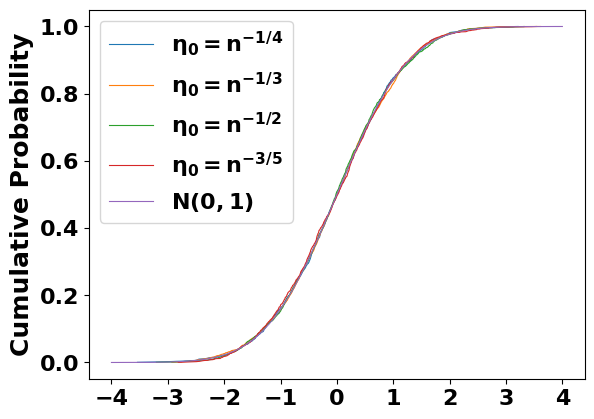

In [48]:
n = 800
R0 = 2000
c = 1
phi = 100
labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


### $T_3^l$

#### Data generating

In [54]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

n = 800
R0 = 2000
c = 1
phi = 100
m = int(n * phi)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)-2)
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)+2)



def simulate_local_test_statistics3(eta, E, m, n, R0):
    """
    Compute the test statistics for a given value of eta.
    """
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00) / np.sqrt(n * m)
        Et = jnp.array(extract_elements(E0, E-2*eta, E+3*eta))
        Eb = (Et - E * np.ones(Et.shape)) / eta
        t0=-jnp.sum(np.log(Eb+3*np.ones(np.size(Eb))))+jnp.sum(Eb)
        T0 = T0.at[r].set(t0)
    TestST = np.array(T0)
    Mean_x = jnp.mean(TestST)
    Variance_x = jnp.var(TestST)
    Normalize_TestST = (TestST - Mean_x) / np.sqrt(Variance_x)
    return Normalize_TestST


etas = [1/(n**(1/4)), 1/(n**(1/3)), 1/(n**(1/2)), 1/(n**(3/5))]
normalized_test_stats = []

Normalize_TestST_1 = simulate_local_test_statistics3(etas[0], leftb, m, n, R0)
Normalize_TestST_2 = simulate_local_test_statistics3(etas[1], leftb, m, n, R0)
Normalize_TestST_3 = simulate_local_test_statistics3(etas[2], leftb, m, n, R0)
Normalize_TestST_4 = simulate_local_test_statistics3(etas[3], leftb, m, n, R0)

#### Saved data

In [ ]:
Normalize_TestST_1=[-0.7600355 , -1.2881866 , -0.92758274 , -0.8752478 , 0.25074136 , 1.0106511 , 0.6035832 , 0.64365983 , -0.21389446 , 0.4141246 , 1.9762845 , 1.3352525 , 1.5984902 , 0.074893154 , 0.43540266 , -0.7707127 , -0.19926439 , 0.28086844 , 0.62990564 , -0.22635943 , 0.68295926 , -0.8770715 , -0.39373147 , -0.27481338 , -0.27659217 , -0.65774184 , 1.9179709 , -0.53530663 , -0.18302624 , -0.1254987 , -0.42873222 , -0.043984514 , 0.43571708 , -1.6963549 , 0.91035634 , -1.1330414 , 0.036105752 , 0.4982351 , -0.09149516 , -2.4194627 , -0.57115185 , 0.96739876 , -0.9776223 , 1.3912708 , -0.5490158 , -0.35064983 , -1.3029828 , 0.379034 , 0.49072018 , 0.59955853 , -0.699979 , -1.138764 , 0.1897506 , -0.6083356 , -0.4621698 , -2.7926347 , -0.87792945 , -0.3887949 , 0.7682916 , 1.1197634 , -0.8348882 , -0.4590479 , -0.4035103 , -0.49454728 , 0.08152317 , 1.3877851 , 0.90593636 , 0.8340797 , 0.42915896 , 0.7360803 , -0.4053295 , -1.332764 , 1.294565 , 0.3092167 , -0.71534574 , -0.3830408 , -0.050789714 , -0.16830185 , 0.28272808 , 0.3757819 , -1.2974443 , -0.092474386 , -0.24758358 , 2.2141657 , -2.2970319 , -0.21887146 , -0.97697544 , -0.89298624 , 1.5938277 , 0.50108296 , -1.1884353 , -0.28033838 , 0.014917541 , -0.5556548 , 1.4131193 , -1.2260504 , 0.71507627 , 0.27199695 , 1.1691022 , -0.4612669 , -0.5536649 , 2.9681551 , -0.48378024 , 0.8356923 , -0.72221833 , -0.71832836 , -0.33739877 , 0.73897755 , 0.09266304 , -0.4340641 , 1.1361858 , -0.82048273 , -2.0472069 , 0.5842771 , -0.199763 , -1.9321787 , 0.8382841 , 1.431527 , -1.0459932 , -1.2656058 , 0.2454095 , -0.41814035 , -0.12233642 , -0.4505403 , 0.82740927 , 0.77029496 , 0.05626532 , -1.4647894 , -0.9170223 , -1.6819404 , -0.056777395 , 0.681742 , -0.05951295 , 0.3020297 , -0.25566447 , -0.50201726 , -0.28988364 , 2.0201027 , 1.7771549 , -1.1118711 , -1.3533144 , -1.2236112 , -0.3080488 , 0.16602896 , 1.925122 , -0.11580972 , 0.43585634 , 2.0422747 , 0.8125052 , 0.57192 , -0.6124278 , -0.51011163 , 0.72884387 , -0.102096 , 0.39330024 , 0.7765656 , -0.8347175 , -0.3067776 , -2.2796214 , 2.0159702 , 1.6177784 , 1.9029635 , -1.2371049 , 0.15686552 , -0.8169701 , -0.20043679 , 0.2043492 , -0.7702186 , 1.1208459 , -0.49064833 , -2.1537004 , -0.16647366 , 0.32327628 , -0.0031173665 , 0.17350346 , 0.05195311 , 0.5963333 , 0.12460033 , -0.013641847 , 0.8830502 , 0.2153094 , 1.3587765 , 0.2878578 , 0.56969196 , -2.060804 , 0.34448245 , 1.9200956 , 1.4277807 , -0.60315204 , 0.7964736 , 0.21621676 , 0.7414481 , 1.2280852 , 1.1312222 , 1.1841636 , -0.8131745 , 0.8322021 , -0.45372954 , -2.0448081 , 0.5985164 , 2.6386936 , -0.32536054 , -0.16642873 , 0.6417777 , -0.37437594 , 0.6124188 , -0.39045238 , 0.54634315 , 0.31581077 , -1.3970069 , 0.2978792 , -1.1611067 , 0.17741139 , 1.9163404 , -0.4836814 , -0.005861907 , 0.85069066 , -1.2838923 , 0.7256232 , 0.26847532 , -1.6928153 , 0.5938583 , -0.09998032 , 0.40317342 , -1.4106398 , 0.10406794 , -0.92398924 , 0.8403414 , 0.48803404 , 1.4013954 , 0.4223897 , 0.17979658 , -1.0828671 , 0.02989797 , -1.1547731 , -1.0229094 , 0.65929157 , 0.3894552 , 0.64802593 , 0.14779192 , 0.3954833 , -0.35864538 , 0.7971429 , -0.21324763 , 0.015815917 , -0.6879318 , 1.0997701 , -0.031200616 , -1.2019783 , 0.21274005 , 0.05202049 , -0.8159055 , 1.7556837 , 0.72593313 , -1.5881095 , 0.90669996 , 0.8010509 , -1.3497658 , -0.08109645 , 1.4088789 , -0.51610833 , 1.0921787 , 0.33214328 , 1.8051797 , -1.1511437 , -0.2680306 , -1.1010143 , 1.4690387 , 0.62105215 , 2.2665186 , 0.67069197 , -1.031498 , -0.89065045 , -0.29114586 , -1.0458316 , 1.4996958 , -0.58299243 , -0.3329473 , -0.34460375 , 0.2023054 , 0.39213234 , 0.97110456 , -0.46078178 , 1.6203343 , 0.25696263 , 0.14354709 , 0.38443327 , -0.5984176 , 0.20111056 , -0.041603815 , 0.76908666 , -1.1434491 , 0.29857993 , -1.2881596 , 0.30340868 , -0.759227 , 0.32956493 , -0.15505528 , 0.29042265 , 0.6262627 , -1.021809 , 1.9775019 , -0.50208914 , -0.97242516 , 2.0668185 , -1.9022852 , -0.8799553 , -0.4342617 , -0.786048 , -0.12904729 , 1.0938094 , 1.3697591 , -1.2247881 , -0.92767704 , 0.7223216 , -0.5655145 , 1.3715649 , -0.283047 , 1.5965363 , -1.2772982 , -1.0810748 , 0.50186455 , 0.38039505 , -0.88876384 , -0.11665419 , -0.60909027 , 0.27453038 , 2.5768087 , -0.8737385 , 0.64536226 , -0.38155848 , 1.0311655 , 1.2159392 , 0.22961156 , 1.300692 , -0.12309106 , 0.047038995 , -0.3418682 , 0.95500565 , -0.7062003 , 0.064768456 , -1.1234467 , -0.49085495 , 1.333568 , 1.2347152 , 0.64590126 , -0.19399992 , -0.031434193 , 1.1918176 , 1.0896993 , 2.3867843 , 0.61285895 , 1.0147567 , 0.009702466 , 0.8606312 , 0.36425123 , 0.93185 , 0.54282606 , -0.14670038 , -0.5468732 , -0.22413595 , -0.21126671 , 0.35045666 , -1.346307 , 0.35738316 , -0.09489102 , -0.5523443 , 1.5483025 , -0.7723208 , 0.74605674 , -0.63108253 , 0.16665334 , 0.95289445 , -1.0284839 , 0.16077796 , -0.7847004 , 0.55373234 , 0.6793613 , -1.019051 , -0.5336356 , 0.77798504 , 0.24149258 , -0.7610956 , 0.45376098 , 0.114313915 , 1.5299217 , 0.8133137 , 0.6185951 , 0.19036148 , -0.8419315 , 0.7443184 , -0.6891985 , 0.00060191227 , 0.50391287 , 1.5086167 , 0.7356221 , -0.70006436 , 1.556581 , -0.090736024 , 0.8634027 , 0.36041966 , 1.2635126 , -0.47760388 , -0.11073389 , 0.034686316 , 0.18109922 , 1.1453042 , 0.069076166 , 0.9657996 , -0.030872708 , -1.8731644 , 0.1535505 , -0.32187933 , -1.0343188 , 0.52477765 , 0.7893765 , 0.17231311 , 1.5228873 , -0.98223543 , 0.4940891 , 0.5979055 , 1.0267141 , 0.67505807 , -0.42816174 , -0.08120874 , 0.03929948 , 0.92426324 , -0.46002716 , -0.59201217 , 0.67694014 , -0.029570062 , 0.5415728 , -0.7978931 , -0.7391078 , -0.006571624 , 0.3647184 , 0.7595728 , -1.8059344 , -0.13387157 , 0.10915274 , 1.9339485 , 0.7744769 , 1.220431 , 2.4855428 , -0.3399187 , 0.70338386 , -0.42771706 , 0.9695279 , -0.70045066 , 1.48273 , 0.38351244 , 0.6280056 , -0.2334656 , 0.31619707 , 0.9018936 , -0.91814077 , -0.84246606 , -1.055817 , 0.5261252 , 1.1730956 , -0.6258675 , 2.7082996 , 0.92441595 , -1.1684554 , 1.9805249 , 0.25656733 , 0.47199354 , -1.354334 , -0.58032876 , 0.7480062 , -0.5165575 , -0.172093 , -0.43209663 , 1.2787446 , -1.0580136 , -0.79730463 , -0.8047612 , -0.41449744 , -0.52462494 , 0.81649846 , -1.6414102 , 1.1660298 , -0.64260423 , -1.4913139 , -1.8083106 , -0.59569997 , 1.4252473 , -1.351046 , -0.74527967 , 0.64766204 , 1.051388 , 0.7774595 , -0.6911749 , 0.024305576 , -0.9172918 , 1.7554681 , -1.4150058 , 0.6095215 , -0.27250004 , 1.0102917 , -2.587859 , 0.31435093 , 0.3777179 , -0.16571003 , -0.13476096 , 0.1050831 , 0.20798314 , -1.4312305 , 0.4222774 , -0.5903681 , -0.4835916 , 0.6497328 , -0.255103 , -2.043986 , 0.9101362 , -2.8196175 , 0.537584 , -1.5915908 , -1.8099501 , -0.25520182 , -0.93662035 , 0.73489445 , -2.3696253 , 0.24261555 , -0.59844005 , 0.8652983 , 0.4766561 , -1.1296725 , 0.43364632 , -1.5078486 , -0.916371 , 1.2516451 , 1.0203042 , -0.99960554 , 0.30419478 , -0.8130217 , 0.6544538 , -0.80172914 , -1.7589403 , -1.3471425 , 0.57605696 , -0.7408686 , 0.3247092 , -0.012950097 , 0.00038181 , 1.1292143 , 0.43368226 , 0.5534943 , -0.18879831 , -0.3648936 , 1.2135404 , 0.12419157 , -0.9505722 , -0.5719604 , -0.7272762 , 1.4195023 , -0.76095635 , 2.4204957 , 0.6831165 , -0.34442407 , -2.0868254 , -0.3756247 , -0.24522085 , -1.3702173 , -0.88765436 , -1.7507831 , -1.3672032 , -1.5433524 , 0.2948831 , 0.41964963 , -0.631909 , 0.59023786 , 0.3573652 , 0.29044512 , -1.1130705 , -0.17312165 , -1.108345 , 0.07830699 , 0.93369615 , -0.3992924 , -0.20415157 , 1.3304641 , 0.89335006 , -0.90415305 , 0.3589598 , 2.1050444 , 0.43370923 , 1.2814711 , 0.8500753 , -1.1320667 , 1.8174785 , 0.07378366 , 0.36492053 , 0.3231685 , -0.2192982 , 1.346298 , 0.43035826 , -1.5605159 , 0.10306175 , 0.08545806 , -1.3107582 , -1.2929031 , 0.15169087 , -1.1458972 , 0.44819555 , 0.38440183 , -0.4914793 , -0.14640392 , 0.26914462 , 0.48747256 , 0.65116125 , 0.37663984 , 1.39919 , -1.1914808 , 0.7001991 , -0.18881628 , 1.577028 , 0.12579966 , 0.2102246 , 0.27338046 , -2.061819 , -0.77476436 , 0.3330596 , -2.0906165 , 0.16571453 , -2.1589246 , -0.51542103 , -0.3851969 , 0.15332143 , -1.3347315 , -0.5526992 , -1.1284508 , -1.0420988 , 0.75645095 , 0.60007507 , -0.31101793 , 0.27830806 , 0.61236936 , 2.603356 , -1.3839984 , -0.7135804 , -0.09145024 , -0.069516376 , -0.36945733 , -0.70362645 , 0.48165107 , -1.303387 , 0.79596156 , 0.9167258 , -2.4976664 , 1.7722093 , -0.27094585 , 0.086729266 , -0.031348847 , 0.16388634 , -1.0409893 , 0.32350087 , 0.70250344 , 0.420822 , -0.032979403 , 0.5455751 , 0.6313745 , 0.46689975 , 0.8988975 , -1.2854509 , -0.7867712 , -0.60241985 , 0.44622362 , -0.475331 , -0.23228423 , 0.06769716 , 0.8077528 , 1.1773044 , 1.1397703 , -1.1147999 , 2.3323472 , -0.03157344 , -0.9906667 , 1.6475236 , 0.1259389 , -0.2122145 , 0.81524074 , 0.087299734 , -0.9957111 , 1.4451599 , 0.24730957 , 0.27506042 , 1.1053131 , 1.1990587 , -0.984149 , -2.3749795 , 1.013162 , 0.5576447 , -1.2025353 , -0.64485914 , 0.49447092 , 0.48951638 , -0.41266924 , 0.3630025 , -0.7923636 , 0.035472397 , 1.2464435 , 0.63599217 , 0.90677184 , -0.81494427 , -1.3904039 , -2.3298092 , 0.9564431 , -0.884537 , 1.3642476 , 0.6850345 , 0.5588126 , -1.3063473 , 0.27416205 , -0.7789598 , 0.094823636 , -0.54623985 , -1.3444833 , -0.026497616 , -1.1263485 , 0.62354064 , -0.042057496 , -0.31594104 , -0.752853 , -1.6775923 , -0.4615499 , -0.30102798 , -0.7248506 , -1.7864306 , 0.6068039 , 0.16182905 , -0.7547261 , 2.0507286 , -1.3369774 , 0.7957729 , 0.40714422 , 0.073267095 , 1.3330334 , -0.26175997 , -0.48168254 , -0.20143397 , 0.056072168 , -0.60590106 , 0.5389271 , 0.16968086 , -0.39832667 , 0.61333513 , -0.23544201 , 0.9366743 , 1.2002579 , -0.21877265 , -0.43086135 , -0.6740429 , 0.5393583 , -0.97669697 , 1.0666244 , -0.7505082 , -0.9609709 , -0.8791512 , -0.13083506 , 0.42561933 , 0.21443798 , 1.2975341 , -0.109507605 , -0.4178394 , -1.0222087 , 1.5573671 , 1.6338503 , -0.80423564 , 1.0934095 , -1.699899 , -0.6447603 , -0.24935786 , 0.33730444 , -1.6137178 , 0.13293727 , -0.7657806 , -1.6409655 , 0.809006 , -0.44354194 , -1.7570313 , 0.13420847 , 0.14886099 , 1.8455124 , 0.69276506 , 0.7290011 , 1.1773134 , 0.18979102 , 0.3146294 , -0.34314838 , -0.43118477 , -2.3067255 , -0.8724628 , -1.8549049 , 0.13402879 , -1.1973786 , -0.081285104 , -1.4342805 , -0.96558404 , -0.38788754 , 1.1929677 , 2.3901126 , -0.09441038 , 0.6434532 , 0.0121954605 , 0.62723297 , -0.6986584 , 2.2882054 , 0.6373712 , 0.37783918 , -0.10082929 , -1.0439628 , -0.5513516 , 0.88214284 , -1.5689203 , 0.81274325 , 0.1768499 , -0.7647699 , 0.060330473 , 0.46756902 , -2.7246995 , -2.8169134 , 1.0514194 , 0.9518434 , 1.1750046 , -1.3489976 , 2.561999 , -1.2501942 , -2.4183037 , 0.20571923 , 2.7076797 , -0.0029466748 , -0.0015496995 , -0.78350556 , -0.18414472 , 0.9240476 , 0.618914 , 0.30304036 , 0.8926269 , 1.6303781 , 2.3631165 , 0.8910008 , -0.4499384 , 0.24343757 , 1.3572986 , -1.8159962 , 1.3995403 , -0.49456075 , 0.21587089 , -1.5838692 , -0.059198517 , -2.1822104 , -1.6000534 , -0.6042076 , 0.8598856 , 0.5695662 , 0.045754313 , 0.9513807 , -0.75966716 , -0.95287204 , 0.5527396 , -0.39201558 , 1.5923364 , -0.6740878 , 1.16784 , 0.12795576 , 0.53661376 , 1.6631374 , 1.2132081 , 0.66509956 , -0.5324273 , -0.46389467 , 0.105572715 , 1.0996039 , 0.30097857 , -0.65382946 , -0.28635302 , -0.75970757 , -0.24442579 , -0.88468975 , 0.6404526 , 1.006824 , -1.454193 , -0.3076715 , -0.7910025 , 0.517402 , 0.51255524 , 1.7487392 , -1.0906426 , 1.2311127 , 0.4669716 , 0.07966803 , 1.3048469 , -0.42454576 , 1.0380516 , -1.0177662 , -0.25765887 , -0.6950784 , -0.40305212 , -0.13372335 , -0.509375 , -1.156269 , 0.87608325 , -0.4723978 , 0.43602255 , 0.37918675 , -0.6852816 , 1.0696654 , 1.8768657 , 0.41111955 , 1.3528382 , 0.1710374 , 1.2408376 , -1.8789185 , -0.28141645 , 1.6913644 , -0.6143862 , -0.24711193 , 0.56762123 , -1.4638326 , 0.9157376 , 0.7199275 , -0.5250651 , -0.8263941 , -0.62727344 , -0.8719148 , 0.31432396 , 0.6823304 , 0.15342923 , -0.41452438 , -0.6615105 , 0.22735663 , 0.28545016 , -0.032988384 , 0.27663708 , -0.19957434 , -2.2097905 , -0.21379563 , 0.9729597 , -0.059054777 , -1.2450645 , 2.3378587 , -0.960068 , 0.055798166 , -0.46304572 , 0.30791855 , -0.0388458 , -0.5290359 , -0.5171729 , 0.42385852 , 0.06642596 , -2.3001943 , 0.22547004 , -0.86315566 , -0.282481 , -0.73999274 , -1.0452026 , -0.40863553 , -0.30515602 , -0.59565055 , 0.089249216 , -0.8311465 , -1.5273389 , 0.8663314 , 1.152891 , -0.20606062 , -2.113498 , -0.9289662 , -0.5539659 , -0.97633314 , -1.6335269 , -1.8289284 , -0.08922675 , -1.180871 , 1.1131109 , 0.39935082 , -0.33766827 , 0.8496081 , 0.75642854 , -0.084663 , 0.4086041 , -0.020316785 , -0.84110945 , -0.57376164 , -0.26266283 , 1.4472262 , 1.9963229 , 0.76515627 , -1.2650669 , 0.88422704 , 0.21733974 , -0.32534704 , -0.37657696 , -0.20287587 , 2.2719042 , 0.7756403 , 0.06980835 , -0.032179847 , -0.6777936 , 0.043741953 , -1.7290694 , 0.65353745 , -0.51137835 , 1.0837251 , -0.87047744 , 0.0837781 , -2.1278002 , -1.5161091 , -2.074576 , -0.51077193 , 0.96894395 , 0.81375843 , -0.57296205 , -0.68846184 , -0.5053188 , 0.48853713 , 1.0434194 , 1.6665512 , 3.0310595 , -1.442339 , -0.17749225 , 0.88605076 , 0.7093581 , -0.038670614 , 0.39639065 , 1.2613161 , 0.4170578 , -1.4443558 , -0.19797073 , 0.3358895 , 0.4391489 , 0.700253 , 0.23939937 , 0.08902462 , -0.9334536 , -0.33496866 , -1.2771006 , -1.8350732 , 0.59200764 , -3.1109746 , 0.44887382 , 0.33563346 , 1.1655672 , -0.7807296 , 0.15129559 , -0.29519305 , -0.480317 , 0.8666728 , 1.1436018 , -0.7853383 , 0.19559902 , -0.084604606 , 1.2910749 , -0.68312097 , 0.56006587 , 1.5267504 , 0.8610849 , -0.27957925 , 0.52810615 , -1.759102 , -0.62901175 , 1.6650555 , -1.443992 , -0.095623195 , -0.53203654 , -1.4966369 , -1.1968126 , 1.3461003 , 1.014312 , 0.1224038 , -1.3029335 , 1.0289061 , -0.22311181 , -0.75071484 , 0.23355094 , 0.58248484 , -0.7034737 , -0.7911642 , 1.0126544 , -0.02269299 , 0.7634089 , -0.49957368 , 0.32090458 , -0.8639013 , 0.5163868 , 0.03469081 , 0.22946332 , 0.6636217 , 0.6857847 , 1.2680315 , -1.4455507 , 0.35332698 , 0.6355519 , 0.6740294 , 0.77631855 , 1.3437916 , -0.61497015 , -1.1545576 , 0.20232338 , -0.19901735 , -1.265251 , -0.188421 , 0.18521827 , -1.2641909 , 1.7364944 , 1.5907912 , -0.21483326 , 0.26047078 , -0.89679986 , -1.4084522 , -0.1675562 , 0.7608171 , 0.70666295 , 1.1035881 , 0.997171 , -0.9804522 , 0.4801957 , -1.6140367 , -1.6846446 , -0.71623063 , -1.4384714 , -0.28599367 , 0.51294154 , -0.40922847 , -1.428504 , 0.32004663 , -0.6693085 , 0.11439926 , 0.35898226 , -1.2077324 , 0.9104956 , 0.83417404 , 1.0700068 , 1.0197022 , -0.048139505 , -0.10412633 , -0.8071868 , 1.1563678 , 2.0657988 , -0.060343947 , -0.37430856 , 0.37553036 , 0.5283756 , -1.3628507 , -0.8813657 , 0.5958078 , 0.32623643 , 0.6677857 , 0.7464161 , 0.23845607 , 1.1763432 , 0.74940324 , 0.4855186 , -0.23631793 , 0.10556373 , -1.4347701 , -0.4886629 , 1.2395574 , 1.0577484 , 0.108613715 , -1.7076565 , 0.7114019 , 1.1804038 , -0.45322195 , 0.7205294 , 1.1967543 , -0.7355592 , -0.7742298 , 0.35683963 , 1.5079609 , 0.12535496 , -0.9962995 , 0.36811426 , -0.18134628 , -1.0675453 , 1.7655029 , 1.9059687 , -1.0698092 , 0.3652709 , 1.9372545 , -1.428441 , 1.4263254 , 1.3945992 , 0.9973012 , 1.7954144 , 0.68159825 , 0.7130414 , -0.13979636 , 0.49614638 , 0.61917454 , 1.1934797 , 0.3177513 , -0.29912344 , 0.24138029 , 0.32573336 , -2.1330917 , 0.13528202 , -0.48907167 , -0.9509495 , -0.4099337 , 0.8497114 , -0.6446121 , -0.26065046 , -0.43569013 , 1.4555316 , 0.6699059 , -0.88778913 , 0.116348736 , 0.7559299 , 1.4543682 , 0.7678244 , -1.2708434 , -0.5485577 , -0.5865051 , 0.49563882 , -0.7040981 , -0.16286668 , 0.31101793 , -0.9913135 , 0.07463263 , 2.7959766 , 1.1091715 , 0.937667 , 1.6588027 , 1.4114888 , -2.2225924 , -1.7242045 , -0.051454514 , -1.2709826 , -0.60705096 , 0.29893926 , -0.08403414 , 0.2707033 , 0.5473628 , -0.13604115 , -1.4724929 , -1.2465737 , -0.33420503 , 0.6238551 , 0.36483967 , -2.1661384 , -0.3108158 , -1.8425118 , -0.008884943 , 0.6379147 , -0.60621995 , 0.6815803 , 1.7470323 , -0.8014372 , -1.5265348 , 0.6576655 , 0.5712507 , -0.12626682 , -0.7189527 , -0.26950395 , 1.5828226 , 0.01589228 , 0.75397146 , -1.4100872 , -0.9635582 , -0.21429873 , 1.3583946 , -0.9983074 , 1.0453149 , -0.27681676 , -1.5361564 , -0.5501523 , -1.1471953 , 0.9538602 , 1.6861314 , -1.2728647 , -2.142282 , 0.72436094 , 2.0648868 , 0.32800624 , -1.113933 , 2.40291 , 1.6962606 , -0.8449321 , 1.2232294 , -0.07479434 , 2.4859066 , -0.13721353 , 2.643073 , -1.6843661 , 1.565421 , 1.6882606 , -0.665432 , 0.10063613 , 0.26165664 , 0.28240913 , -0.91797906 , -0.69427884 , 1.0656363 , 0.84011227 , 0.11854078 , 0.29926717 , -0.7501803 , -3.349799 , 0.740662 , -1.2471218 , -0.27200595 , -0.9738895 , 1.6266364 , -0.6337148 , 0.06041582 , 0.21812132 , -1.2674251 , 1.470512 , -1.551631 , 0.9391044 , -1.0536339 , 0.9489551 , -0.3355122 , -0.9115692 , -0.08696284 , 1.0081131 , -1.6788096 , 1.3139834 , -0.2571378 , -0.09681804 , 0.28500545 , -1.1238331 , 1.5136521 , 0.94283265 , 0.15497443 , 0.33529657 , 1.4365624 , 0.57243204 , 0.6422943 , 1.1694661 , 0.5127933 , 0.7732551 , -1.4288005 , -0.8903495 , -0.8629715 , 0.0045727366 , 1.2496911 , 0.057689246 , 0.38970226 , 1.3510056 , -1.6738551 , -0.34173343 , 1.7896738 , 0.36699128 , 0.24636179 , 0.43956214 , -0.26120296 , 2.4000351 , 0.14197044 , 0.25386772 , 0.24274582 , 0.62078714 , 0.041392695 , 0.4690289 , 1.5414972 , -0.7992272 , -1.0429882 , -0.440739 , 1.2413002 , -1.1806599 , -0.8423717 , 1.2334081 , 0.23357789 , -0.8044333 , 1.1996425 , -0.9307585 , -0.51415884 , -1.9362215 , -0.16045004 , 0.8497968 , -0.07076961 , -1.3577523 , 0.13653526 , 1.2572105 , 0.76871383 , 1.5207448 , 0.057761118 , -1.4115067 , -0.47448203 , 1.4076347 , -0.956753 , 0.85516906 , -0.07870227 , 0.10085624 , -0.43219095 , 0.13205685 , -0.18536203 , -0.8896398 , 1.0047982 , 0.44607088 , 0.47398794 , -0.09758615 , -0.16430408 , 0.50655407 , 0.9705027 , -1.3496715 , 1.1244888 , 0.58885884 , -1.8774362 , 0.10145815 , -0.24081431 , 0.9918391 , 0.5609553 , 0.2507773 , 0.70860344 , -1.0672578 , -0.38158992 , 1.5209918 , -0.5736538 , -0.60977304 , 0.23636286 , 1.5793054 , -1.0000458 , -1.7243798 , -0.89773417 , 1.0239022 , 1.3846811 , -0.44365874 , 2.101981 , 1.3729932 , 0.9086135 , 1.0385547 , -0.1503478 , 0.628913 , 0.4226637 , -0.873195 , 0.4723933 , -2.025601 , -2.2713697 , -0.18816046 , -0.29180616 , 0.063937455 , -2.5236115 , 1.7636793 , -1.3993561 , -0.540095 , 0.8680967 , -0.18872644 , 0.07750743 , -1.0202547 , 0.1753631 , -0.17920364 , 1.3074791 , -0.46073687 , -2.1112251 , 0.100434 , 0.95013195 , 0.22562726 , 0.06865393 , -0.5358277 , -1.9315139 , -0.16274989 , 0.16497786 , 0.41486576 , -1.2385467 , 0.8927841 , 0.7554897 , -0.41525206 , -1.202149 , 1.0242165 , 1.6101468 , -0.21813929 , 0.43818763 , 0.63743407 , -0.63875914 , -0.29550746 , 1.8190641 , 0.45700413 , 0.043715 , -0.33318987 , -0.31649354 , 1.6856643 , 0.018529015 , -1.1576614 , -0.8721484 , 0.7696122 , -0.97383565 , -0.9000834 , -1.0067028 , -1.3628955 , 1.7095027 , -1.4256337 , 1.1732033 , -1.2310004 , -1.074382 , 1.9761498 , 1.4285713 , 0.37349105 , -0.57727426 , 0.75555706 , -0.72808474 , 1.2880608 , 0.9773528 , 0.55398834 , -1.4299684 , -1.5777647 , 0.2582608 , -0.31797138 , -2.5551624 , -0.58264655 , -0.71353555 , -0.15735064 , -1.9552536 , 1.2762741 , 0.14895082 , 1.1364688 , 1.8831857 , 0.6282032 , -0.11678445 , 0.7936528 , -0.6255351 , -0.18527219 , 0.015407157 , 0.48354664 , 0.64921623 , 0.5899279 , -0.7522017 , -0.95111567 , -0.16170327 , -0.9026887 , 0.22312528 , -0.3470159 , 0.08976129 , 1.5481049 , -2.079809 , 0.40529805 , 0.8285547 , 0.16812667 , -1.0460966 , -1.0432487 , -0.6544987 , 1.1482555 , -0.8218528 , 0.29100212 , -1.7068031 , -1.6574956 , -1.1801208 , -0.7500276 , -0.58985156 , -0.62593484 , -0.10835768 , 0.6168028 , -0.013021967 , -0.5310528 , -1.7824373 , 0.96585804 , -0.36047357 , 1.209098 , -0.8392184 , 1.8634709 , 0.5308956 , -0.8177921 , -0.7918021 , 0.18582918 , 0.321767 , 0.404786 , 0.085988104 , -0.53850037 , -0.09228572 , -0.082053214 , 0.65724325 , -1.1866071 , 0.31882483 , -1.6710117 , -1.3596029 , 0.7962625 , -0.8803191 , -1.4636844 , 1.6766266 , 0.04318496 , -0.4007433 , -1.1980615 , -1.2509758 , 0.18888366 , 1.0582964 , 1.8856338 , -0.008880451 , -0.95178497 , 0.10680349 , -0.7506969 , -0.525119 , -0.8613589 , 0.35584694 , 0.33808604 , -1.1022631 , 0.19373488 , 0.6028016 , -0.13129324 , 0.76525956 , -0.28811833 , -0.10150756 , 0.19198306 , -0.6448277 , -1.7575613 , -2.3963745 , 0.98672736 , 0.64247847 , -0.19315992 , -0.020415606 , -0.5102419 , 1.3631741 , -0.5202364 , 0.17877692 , -0.6855556 , 0.44615173 , -1.3909473 , -0.91296613 , -0.4403527 , -0.4960386 , 1.2315843 , -0.71656305 , -1.1885476 , 1.2247432 , 0.43346664 , -0.2971425 , 0.8196383 , 0.5600928 , -2.7165244 , 0.88478404 , 0.42599666 , 1.4284725 , -0.7820278 , 0.28925028 , 0.9768856 , -1.3124427 , 1.0082929 , 2.1393623 , -0.77467006 , -0.9097724 , 0.23878399 , 0.2985934 , -0.35911703 , 0.38953155 , 1.4822943 , -0.20029303 , 0.73604435 , 0.18241984 , -0.38001776 , 0.12628478 , -0.9518838 , -0.39583367 , -0.45112875 , 0.48913008 , 1.3949766 , 0.64922523 , -0.9564071 , -0.25336462 , -0.086468734 , 1.6553935 , -2.3968055 , 0.41223803 , 0.61583257 , -1.055233 , -0.041230988 , 0.26607215 , 0.117251605 , -1.3973258 , -1.3566787 , 0.36898118 , -1.170378 , -0.49037433 , -0.1989814 , -1.8182826 , -2.2318501 , 1.3796233 , 0.9792259 , 0.11465081 , 1.4888839 , 0.50743896 , -1.1872315 , 0.35859147 , -0.22757673 , 0.359948 , 1.0170879 , -0.42671534 , 1.5895514 , -0.37332034 , 1.5941736 , 0.3094368 , -1.8516527 , 0.8239145 , -1.0107769 , 0.23585977 , 0.29031035 , -0.89353424 , 2.155897 , -0.83099824 , 0.5038679 , -0.15994695 , 0.540378 , -0.6770435 , -0.52676755 , 0.17280272 , -0.9863994 , -0.95655084 , -0.54266435 , 1.3423676 , 1.9734098 , -1.4620268 , -0.40834355 , 1.1362036 , -0.07463263 , -1.0162256 , 0.62808645 , 0.002519946 , 0.93098307 , -0.999893 , 0.16009967 , -0.01906355 , -0.34544823 , 1.0150352 , -1.2844537 , -0.22781031 , 0.6447109 , 0.18630531 , -0.5157984 , 0.7932664 , -2.3693197 , -2.1358182 , -1.4267386 , 0.33548072 , -0.1756955 , 0.08677868 , 0.014895082 , -0.16004577 , 0.38593355 , 1.1147999 , 0.4603281 , -0.5778492 , 0.64241105 , -3.1435137 , -0.5734292 , -0.86917025 , -0.48771062 , -0.13039486 , -0.8149937 , -1.1005157 , -0.11704498 , -1.3727417 , 2.1783698 , 0.21583495 , -0.6706066 , 0.006387457 , 0.95419264 , -1.4017953 , -1.439792 , -0.4712973 , -0.52471477 , 1.0756576 , -2.5502303 , -0.6400798 , 0.12608714 , 0.59901947 , 1.6255449 , 0.722407 , 1.6067598 , 0.6570142 , 0.69642144 , -1.0241088 , 0.97948194 , 0.9109493 , -0.58122265 , -0.44038865 , -2.1178012 , -2.9376237 , -0.68684477 , -0.13926633 , 0.14535283 , 0.5591046 , 1.0339056 , -1.7262888 , 1.4881337 , 1.8147475 , -0.28699985 , -0.68762636 , -0.46231353 , -1.9062202 , -1.0867391 , -0.4605033 , 0.96702594 , 0.74708986 , -0.5814248 , -0.65311074 , -0.29467648 , 0.22927018 , 0.31984898 , 0.07687408 , -1.0607715 , -0.2823777 , -0.8346771 , -0.30212402 , -1.4391273 , -1.1133984 , -1.6591396 , 1.19529 , 0.62100726 , 0.6623011 , 1.0898969 , 0.74097645 , -0.73077536 , -0.53208596 , -1.0733757 , -0.9931687 , 0.7420006 , -0.60573035 , -0.46212038 , 1.5374277 , -0.1346846 , -0.35811085 , -0.51986355 , -0.44383842 , -0.78448033 , -0.76847124 , -0.87161386 , 0.35269812 , 1.3066347 , 1.3355086 , -0.70460117 , -0.45383286 , 1.0553633 , 0.2050724 , 0.95107526 , -0.5321578 , 0.006921991 , 0.11904387 , -0.83918697 , 1.5277476 , -0.72143674 , 2.1122403 , 0.17698915 , -0.58485657 , 1.6595035 , -1.4130384 , 0.6233565 , -1.7961376 , 1.459143 , -0.27991167 , 0.24929498 , -1.4217257 , 0.5459209 , -0.6741013 , -0.9270841 , 0.5436256 , -0.5229135 , 0.8812759 , 1.4805604 , -2.5136216 , -0.69975895 , 0.34263632 , 1.3506821 , -1.053279 , -0.94184446 , 0.98490363 , -0.3897202 , 1.4525131 , 0.23026738 , 2.306658 , -0.5926904 , 0.042232677 , -0.27559945 , 0.87742186 , -0.06985326 , 0.4763372 , 0.7889318 , -0.49772304 , 0.6054114 , 0.45176658 , 1.4163669 , -0.49012277 , 0.20708926 , -0.27519068 , 0.7370056 , -1.273579 , -0.084106006 , 0.5306935 , 0.91243607 , 0.57784027 , 1.1183395 , 1.0760844 , 1.7100642 , 0.0044873906 , 0.96141106 , 0.39704648 , 1.3867025 , 0.1614158 , -0.25848088 , 0.71816665 , 0.32496524 , 0.49504137 , 0.30780625 , -1.4463502 , 1.9568167 , -2.1568222 , -2.7100918 , -3.023859 , 1.7514658 , 0.88043594 , 1.0398933 , 0.22253235 , 0.21273555 , 1.2983966 , 0.08942889 , -1.5693425 , -0.51154906 , 1.356836 , -0.66074246 , 0.30875853 , 1.4833769 , 0.7781692 , -0.43955317 , 0.2613018 , 0.28261578 , 0.460108 , 0.27577013 , -0.44961047 , -0.42745653 , 0.8589737 , 0.37074202 , -0.36890933 , -0.241268 , -0.8291835 , -1.1877526 , 0.34416804 , -0.17222776 , 0.007416098 , 0.50258774 , 0.98744154 , -0.9244923 , -0.28025305 , 0.06731535 , -1.0924078 , -0.30309874 , 0.41186967 , -0.6613488 , -0.32113367 , 0.29024747 , 0.693367 , -0.27497956 , -1.1758356 , 0.90109855 , 0.10453958 , 1.788479 , -0.9235355 , -0.3911127 , -2.0216975 , 1.9517543 , 0.3272022 , 0.53014547 , -0.2843676 , -0.84765416 , -0.8421965 , 1.7640835 , 0.052361872 , -0.26855618 , -1.1798558 , -0.7004417 , -0.84958565 , 2.5449927 , 1.1477388 , 0.5415099 , -0.33405232 , -2.4416616 , 0.38948214 , 0.15666787 , -0.58713394 , 1.0008408 , -0.30150864 , -1.2598473 , -0.35380313 , -2.0400379 , -0.08151868 , 0.98886997 , -0.15696435 , 0.9490404 , -1.8381277 , -0.6256339 , -1.2993623 , 1.2346792 , 1.034229 , -0.35634553 , -0.7956741 , -0.9691641 , -1.2909356 , 0.95629483 , 1.3724004 , 0.043319713 , 0.6348916 , -0.66338813 , 0.5966298 , 1.0987953 , 1.3218353 , -0.2375577 , -0.3339041 , 0.15455669 , -0.23743193 , -1.5862589 , 1.0723426 , -0.66982055 , -0.8929009 ]

In [ ]:
Normalize_TestST_2=[-1.6591741 , -0.66348207 , 1.1663771 , -0.55269676 , -1.7209916 , -0.8551453 , -1.1317292 , 1.5703045 , 0.28128192 , -0.10351461 , 1.3536721 , 0.9948155 , 1.3502324 , 0.5884142 , 0.17911966 , -0.00095654884 , -0.9542588 , -0.42870352 , 1.3151982 , -2.233174 , -0.3873363 , 2.126837 , -0.7562532 , -0.5909446 , -0.42133385 , 1.047044 , 0.48545563 , 0.08731925 , -0.95660543 , 0.45868167 , 1.3015615 , 0.46825188 , 1.2152176 , 0.10727955 , 0.23341206 , -1.5786308 , 0.87206155 , -1.5562344 , -0.885981 , -0.8338137 , 0.25823522 , 0.5012175 , -0.49705672 , 1.0775263 , 1.5239049 , -0.8949905 , -0.25226974 , -0.32402033 , 0.0135330465 , 1.4719119 , -0.11868274 , 0.83895934 , 0.97161806 , 1.6421871 , 1.4904774 , -0.021265542 , -1.4252766 , 0.35839012 , 0.025388598 , -0.33767116 , -0.68300414 , 0.7076483 , 1.771651 , 0.112213075 , 0.4961049 , -0.39546934 , -1.1059495 , 0.108141854 , 0.8798176 , -0.1793317 , -0.9819657 , -0.58838594 , -0.66202605 , -0.11610995 , -0.47003776 , -0.16477144 , -0.49422005 , -0.6745554 , 1.8266926 , -0.6532852 , -1.8931469 , 0.79338896 , 1.8881049 , -0.8476531 , 0.7778297 , -0.9573876 , -1.1648079 , 1.0086831 , 2.566694 , -0.463111 , -2.058955 , -0.8023419 , 1.0237854 , 0.15973894 , -0.6396956 , 0.69936913 , -0.92429954 , 0.9945799 , -0.29028666 , 0.04711121 , -1.5064373 , 0.046545763 , 1.6750679 , 1.2955065 , -0.19622917 , -0.2845191 , 0.3756787 , 0.11329214 , 1.5945151 , -0.9998056 , 0.1945234 , 1.2381088 , -0.36581632 , 0.43362764 , 0.53882915 , 0.13561319 , -0.7053205 , -1.7635981 , 0.5803472 , 0.30411187 , -0.009103706 , 0.693234 , -0.74058557 , 1.7421724 , 1.5568186 , 0.21214181 , 0.70760584 , 0.5216584 , 0.9259911 , 0.4918499 , 0.49386194 , 1.3570884 , 0.3169334 , 2.0750184 , 0.2910359 , 0.025511112 , -1.2867137 , 0.53097886 , -0.03112789 , -1.3889891 , 1.3293202 , -0.49823946 , -0.18396838 , -0.45973247 , 1.5415138 , -1.1585975 , -1.7320179 , 1.6950611 , -0.25989857 , -0.33243135 , 2.4037273 , 0.15531433 , -0.7887853 , 0.64085007 , -0.040980816 , 0.51012796 , -0.20290616 , -0.36745614 , -0.58133197 , 0.08346478 , 1.2623429 , -0.819899 , -1.9127066 , -0.35023823 , 0.6871649 , -0.542547 , -0.2891228 , 0.23886862 , -2.0165133 , 0.6569653 , -0.7510699 , 0.49012056 , 0.0915601 , 0.26919547 , 0.966006 , -0.56350154 , 0.14177185 , 1.1181821 , 0.43018782 , 0.23325185 , 0.74600446 , 1.23138 , 1.1163538 , 0.109998405 , 1.0340246 , 1.3677188 , 1.0847359 , 1.0125424 , 0.014301113 , -0.289561 , -0.11233559 , -0.9352833 , 1.8507996 , 0.498885 , -0.5162961 , -0.35698122 , 0.6379191 , -1.2240763 , 1.3269924 , -1.3555099 , 3.558536 , -2.4347892 , 0.3482262 , 0.13599014 , 1.9658775 , -0.96137404 , -1.9780865 , 1.2235721 , -0.22366752 , -2.6421907 , 0.047266707 , 0.33147952 , -0.23072147 , -0.9024591 , 0.08160351 , -0.38711485 , 0.44266066 , 0.8027848 , 0.2067088 , 0.9089146 , -0.021689627 , 1.654396 , -0.974973 , -0.3248261 , -1.143123 , -0.16168503 , -0.7557914 , -2.0539837 , -0.18789352 , 0.8203184 , -0.0364431 , -0.04461853 , -1.0688184 , -0.55468994 , -0.36240008 , -0.72701484 , -0.21185437 , -0.13646136 , 1.0055025 , -0.15008393 , -0.53313696 , 0.21841827 , -0.17385158 , 0.17736207 , -0.83499646 , -1.4511082 , -0.75737464 , 0.7480354 , 1.0105397 , -1.19202 , 0.26418656 , -0.45165598 , -0.14248809 , -1.0230267 , 0.39094105 , 1.6378614 , 0.024997497 , 0.4269318 , 0.6232599 , 0.8916543 , -0.40457305 , 0.5992661 , 1.0069679 , -0.05885367 , -0.22091095 , -1.0285162 , -1.8099365 , 1.1794342 , -1.2623994 , 0.1977653 , 2.5148942 , 0.8830171 , -0.8538777 , -0.7359772 , -0.49288183 , 1.1853902 , -0.1692903 , 0.3361492 , -1.3469198 , -0.27705047 , -0.012011049 , -0.90682715 , 0.94114983 , -0.07362599 , -1.5752239 , 1.079562 , -0.39003634 , -0.46229583 , 0.71131897 , -0.716031 , -0.9429263 , 0.9133628 , -1.4581904 , 0.4742456 , 1.2679409 , 0.04380334 , -0.10187481 , -0.98263484 , 1.3466747 , 0.0730841 , -0.04272899 , -0.81307596 , 1.4999912 , -1.5383803 , 1.3856717 , -1.6025115 , -0.04021275 , -2.4765522 , -0.5841168 , 0.45590156 , -0.9485007 , 1.4715303 , -0.64927524 , -1.7182492 , 1.0412105 , -0.07161394 , -0.37046713 , -1.097416 , -1.4567344 , 0.4822797 , 0.7714213 , 0.72499335 , 0.74231964 , 1.8430907 , -1.2275255 , 1.2845697 , 1.1220601 , 0.88217837 , -0.16343792 , 0.26238182 , -0.6061457 , -0.84963685 , 1.9057516 , 1.0743693 , -0.4474811 , 1.6346902 , 1.0904233 , -0.7792575 , 0.58132255 , 1.0992396 , -0.3328696 , 1.4292866 , 1.1837834 , 0.7754737 , -1.7842699 , 0.28046203 , 0.45506752 , 0.5736325 , 0.34039947 , 0.85743064 , 0.12203773 , 0.68092144 , 0.71642685 , -0.8628636 , -1.1718901 , 0.9895192 , -0.7858685 , -0.6223835 , 2.0295799 , -0.9665337 , 1.9772855 , -0.7202106 , 2.6149783 , -2.1910105 , -1.5286735 , 0.5492051 , -0.8348174 , -0.33668163 , -0.20752399 , 2.8240292 , -0.22136803 , -1.9550822 , 0.3013883 , 0.85880655 , -1.9063594 , 1.2458695 , 0.19355743 , 1.2098976 , -0.22366281 , 0.26763576 , 1.0989239 , -0.53812236 , 1.5399636 , 1.2754236 , -0.7396196 , 1.3247118 , -0.72284937 , 0.26882792 , -0.09440619 , 1.0785347 , 0.2976045 , -1.138378 , -0.6915566 , 0.0033597013 , 0.48058805 , 0.4264606 , -0.4902101 , -0.30991712 , -1.2097234 , -0.9705107 , -0.40919557 , 2.2563858 , -0.186593 , 1.6208556 , -2.1501617 , -1.6050136 , 0.25000796 , 1.9460068 , -0.8856653 , 0.41985428 , -1.3810399 , 0.9618311 , -1.024379 , -2.037859 , -0.22760208 , -0.9952962 , -0.37153676 , -0.031358782 , -0.4305271 , 0.050612275 , -0.28515053 , -0.6425982 , 0.51366675 , -0.95056456 , -0.4187799 , 0.7669543 , -0.65999985 , 1.5971775 , 0.019220507 , 1.3258003 , -0.5014578 , -1.3037714 , -0.4305271 , -0.0030204325 , -1.7431289 , 0.053656265 , -1.0082166 , 2.5614305 , -0.6842293 , 0.7871879 , 1.3792634 , 0.5033803 , -0.58485186 , 0.9106251 , 0.3521372 , 0.73338085 , 0.1631599 , 1.520875 , -1.5349735 , 0.04635728 , -0.78602874 , 0.39337718 , -0.5448653 , 1.7138764 , 0.46178693 , -2.5933123 , -0.43337318 , 0.9329179 , 1.9543189 , 0.07645323 , -1.1494514 , 0.29778355 , 1.1775682 , -0.24067806 , 0.3868604 , 0.9747469 , 0.23175341 , -0.7609087 , -1.4693251 , -1.2341931 , -0.76077676 , -0.48263308 , -1.1762676 , -2.1204615 , -0.6898508 , -0.39000806 , -0.1427237 , -1.8249067 , 0.46292725 , -0.18388356 , -1.3591051 , -0.85288346 , -1.0571561 , -1.1389953 , -0.111152865 , 1.5682783 , -0.41635793 , 0.6672329 , -0.27515623 , 0.20035693 , 0.4705655 , 1.7164869 , -3.0256064 , -0.34638378 , 0.05886781 , 0.30179352 , -1.2878305 , 1.319637 , 0.4207967 , 0.75565004 , -1.2138982 , -0.6392762 , -1.2392727 , 1.0179847 , -0.7961031 , 0.7359018 , -0.23927858 , 0.42719096 , -0.25563887 , 0.97209394 , -0.052534796 , -0.12650006 , -0.97803587 , -1.3085353 , 1.6057346 , 0.49710855 , 0.7049388 , 0.57894295 , 0.74195206 , -0.9523363 , 1.0595027 , -1.2833446 , -1.8639886 , -0.42716268 , 1.7555687 , -2.122054 , 1.3811105 , 0.78412503 , -0.34855604 , 0.41025108 , 0.08553337 , 0.92242885 , 0.25282577 , -0.5435695 , 0.111134015 , -1.7389729 , -1.5283153 , 0.78487426 , 0.24225189 , -1.1260936 , -0.06806105 , 0.76553124 , -0.3226397 , 0.12216496 , -0.66889155 , 1.8369696 , 1.2003793 , 1.153499 , 0.56350625 , -1.1705002 , -0.5387915 , -1.9309847 , 0.76827365 , -1.1534141 , -1.1828645 , 2.4152153 , -1.3132097 , 0.89327526 , 1.0964642 , -1.0539849 , -0.9218304 , -1.3195993 , 0.6988508 , -1.0973972 , 0.5113861 , 0.19699724 , -0.9576515 , -0.5930415 , 0.8518421 , -1.2799566 , 0.63397515 , 0.30836686 , -0.11000312 , -0.5239532 , -0.57265234 , 0.38795832 , -0.5522915 , -0.6878293 , 1.4758089 , -0.771836 , 1.9630032 , 1.0896505 , 0.51178193 , -0.1699924 , 1.1238931 , 2.069053 , -0.47050425 , 0.7395301 , 0.44597796 , -0.24508855 , 0.39528558 , 2.1146233 , -1.3809692 , -1.670959 , -0.39211434 , 2.0725117 , -0.41150922 , 1.5762748 , 0.7149331 , 0.8849962 , -0.5951383 , 1.8009365 , 0.8333001 , -1.9511288 , 0.6457129 , 0.05293061 , 0.021270255 , 0.10810416 , 0.8187257 , -0.99064535 , 0.084251694 , 2.3289657 , 0.9414985 , -0.6225625 , -1.2098742 , 0.48078126 , -0.02110062 , 0.97848827 , 0.6577287 , 0.74462855 , -1.7350383 , -1.5926963 , 0.13047232 , -0.34356126 , -0.6753329 , -0.59408754 , -0.11610995 , -0.82446504 , -0.08799307 , 0.609397 , 0.12844142 , 0.80109787 , 0.09816641 , 1.5322357 , -0.016958715 , 0.315303 , -0.556113 , -0.8903444 , 0.053934276 , -1.0369602 , 0.14365667 , 0.60765827 , 1.9237847 , -0.7907596 , -1.2367188 , 0.046324294 , 0.03911955 , 0.119856045 , 0.26164204 , 0.37983942 , 0.16641594 , -0.5859875 , -0.7083315 , -0.74990135 , -1.6825601 , -0.8055932 , -1.7337519 , -0.96693426 , -0.16732538 , -0.5217809 , 1.1341136 , 1.4475789 , 1.0233471 , 0.13717759 , -1.9698452 , -0.11148271 , 1.3622246 , 0.116863884 , -0.19436319 , -1.9644357 , 0.45331463 , 1.4967493 , -0.63909245 , 0.3692043 , -0.7075163 , -0.77210456 , -0.8240833 , 1.063065 , 0.81553566 , 0.5452046 , 0.247798 , -1.0201476 , -0.37692267 , -0.008934072 , 1.9423361 , 0.9692856 , 0.91555864 , 0.62569606 , -0.78299886 , -1.6590563 , -0.71174306 , 0.2178811 , -1.1641436 , -0.4647838 , -0.5455156 , -0.31173128 , 0.14609753 , 0.34229842 , -0.20950776 , -0.0461311 , -0.87241024 , 1.8048569 , 1.4094771 , 0.14466035 , -0.21745701 , 0.5141568 , -0.70443934 , 0.4121689 , -1.7099937 , -0.4907284 , 0.16958717 , -1.5570213 , -2.0149255 , -0.1497588 , 1.2425146 , -1.8326676 , 0.092672154 , -0.704821 , 0.85360444 , -0.5619654 , 1.3368878 , 0.321947 , 0.45533612 , 0.008618364 , 0.12176443 , 0.6955618 , 0.36196187 , -0.40492174 , 0.033856176 , 1.1744488 , -0.55010986 , 0.1037832 , 0.11379633 , -0.6687125 , -0.7029409 , 0.13623989 , -0.4700283 , -0.51164526 , -0.9334692 , 0.34659111 , 1.5494914 , -0.9052298 , -0.15150227 , 1.0500079 , 1.3552696 , -0.019884907 , 0.39849448 , 0.24001837 , 1.7997868 , 1.0372947 , 0.6113431 , -0.682123 , 0.9546122 , 1.5308976 , 0.15525778 , 0.43535697 , 1.0778704 , -2.659564 , 0.23617804 , -0.517295 , 0.9641494 , -0.61596096 , 0.77860725 , 0.73062426 , 0.14094253 , 0.37495774 , -0.31222603 , 0.19714803 , 1.0108695 , -0.57043296 , -2.1196134 , 0.21516223 , -1.5650742 , 0.8728061 , -1.1475382 , -1.5066823 , -0.12973253 , 0.18348774 , 1.373034 , -0.7287018 , 0.07261761 , 0.58343357 , 0.7740083 , -1.6320609 , -1.3913828 , 0.4737697 , -0.33157375 , -0.2128816 , 1.1438628 , -1.1704766 , 0.06642596 , -0.24379274 , -0.17421912 , -0.20367423 , 0.8039628 , -0.35006863 , 0.74385107 , 1.8662316 , 0.8896329 , -1.0316639 , -0.28508455 , 1.2362193 , -0.7955848 , -0.245687 , -0.49764103 , 1.6142352 , -0.07853125 , 1.9714378 , 1.675572 , 0.9204262 , -0.83983576 , -1.5756763 , 1.6645458 , -0.59616554 , -0.910234 , 0.5188783 , 0.6923058 , -0.23423667 , -0.5755691 , -0.2871437 , -1.1312062 , 1.3885179 , 0.1330404 , 0.38767087 , -0.49082267 , -2.6898909 , -0.22408688 , 0.8313494 , -1.5752852 , -1.3955718 , 0.8133917 , -2.1393805 , 0.80188483 , -0.21216537 , -0.7555935 , -0.59797966 , -1.1360172 , -0.019715274 , 1.2766535 , -0.32770517 , 0.55187684 , 0.051394474 , -0.9798877 , -0.71967345 , 0.5733262 , -1.1135784 , 0.6490773 , 1.235536 , -0.11772619 , 0.012538801 , 0.38246405 , -0.2429964 , 0.4098223 , -0.13879853 , 0.30348986 , -0.048383467 , 1.0394341 , 1.6400478 , 0.01778804 , 0.054801296 , -0.14210641 , 0.23670109 , -0.6542087 , 0.07807418 , -1.6623595 , 1.7722871 , -1.6610589 , 1.466559 , -0.9152241 , 1.3039316 , -1.4550004 , -1.2101804 , -0.21846068 , 0.03645252 , 0.030430505 , 0.97224474 , 0.35192987 , -0.56417537 , -0.86421126 , -0.244443 , -0.014781743 , 0.7719868 , 0.18541028 , 0.020888576 , 1.0378131 , -0.21199103 , -0.341422 , 1.083129 , -0.4293114 , -0.99000454 , 0.27480283 , -0.35747126 , -0.75682336 , -0.8219252 , 3.4115057 , -0.3419026 , -0.8804585 , -0.07780559 , -1.3185625 , 2.2117672 , 0.11236387 , 0.73906827 , -0.8709354 , -0.7572616 , -2.6670232 , -0.13012834 , 0.62339187 , -0.43510252 , 1.6348268 , -0.16989815 , 0.95213366 , -0.4156134 , 0.7349358 , -1.252424 , -2.3801575 , 0.0656626 , -0.27824736 , -0.9958616 , 0.055362035 , -0.95199233 , 1.6749123 , 1.4772931 , -1.1648268 , 1.2727942 , 0.12893148 , -0.6844413 , -0.024102204 , 0.59199065 , -0.23330368 , -0.8668312 , -0.3125276 , 0.9054984 , -1.8408241 , -0.80341625 , -0.2868233 , 0.20300983 , -0.6660973 , 0.8862402 , -0.86159134 , -0.53184587 , -0.70234716 , -0.77017266 , -0.75457096 , -0.7064561 , 1.4176761 , -1.5029645 , 0.28664425 , 0.041503854 , 0.2750573 , -0.11609582 , 2.0464728 , -1.5784941 , -0.78572243 , -0.3184224 , 0.33789265 , 0.85130495 , 0.3036972 , -1.7833416 , -0.49722165 , 2.7074716 , -0.65554225 , -0.09341665 , -1.2110851 , 0.48717552 , -1.116792 , -1.2159668 , -2.210693 , -0.18698882 , 0.032056168 , -0.06544114 , 1.3159286 , -2.8184407 , 0.014098493 , -0.65836006 , 0.6757947 , 0.9109361 , 0.64248043 , -0.7610265 , -0.06496993 , -1.6070869 , -1.7341855 , 1.5398505 , -0.68447906 , -0.9053146 , -0.7042744 , 0.9412017 , 0.38104573 , 0.32305905 , -0.61335045 , -2.0152175 , -0.3972835 , 0.28257772 , -0.20929101 , 0.04711121 , 0.28401962 , 2.1899457 , -0.6551606 , -0.47277546 , 0.47621056 , 1.1478634 , -1.0444807 , 0.116505764 , -0.02494095 , 0.5965708 , 0.05472119 , 1.8722441 , -0.19634697 , -0.010833033 , -1.6039534 , 1.3056844 , 0.5144914 , -0.7298939 , -1.0175936 , 0.1564782 , 0.6829853 , -0.13169746 , 0.09584808 , 1.5654606 , 1.6441002 , -0.82584095 , -1.7998998 , 0.77275014 , -1.4082708 , 0.2480006 , 0.20404649 , 0.5347108 , 0.3427885 , -1.531284 , -0.2042491 , -0.36040217 , -0.2894762 , -1.5294462 , -0.3016663 , -0.43659154 , -2.073765 , -0.6435359 , 0.60066086 , -1.5078038 , -0.09619206 , 0.6923058 , -0.22433662 , -0.10137062 , 0.57403296 , 0.52008456 , -1.5121058 , 2.1409307 , 0.1662039 , -0.060441636 , 0.34519163 , -1.8139371 , 0.9043439 , 0.5724403 , -0.67499363 , -0.16837145 , -0.2851835 , 1.115416 , 0.36034092 , -1.7358017 , -0.03368654 , -0.21307008 , 1.4351908 , 0.34485236 , 0.6485872 , 0.5288302 , 0.0073178345 , 0.12665555 , 0.56861883 , -0.3404136 , 1.3458549 , -1.2144119 , -1.0222821 , 0.5756445 , 1.9581639 , -1.8908567 , -0.2684604 , -0.252887 , -1.012137 , 1.2558355 , 0.5164233 , -0.5804461 , -1.1975144 , -1.2365067 , 0.7571532 , -0.7360149 , -1.5337578 , 0.37063205 , -0.25922474 , -1.1628053 , -1.1343585 , 0.6109426 , 0.3527168 , 0.23640423 , -0.050183475 , 2.2770765 , 0.20762293 , 1.7811034 , -1.0800614 , -2.3548489 , -0.5550999 , 0.629183 , -0.6089258 , 0.09501404 , 0.81142205 , 0.18791237 , 2.8098223 , 1.0517702 , 0.362598 , -0.5523198 , -0.47356236 , -0.76921135 , 0.2672541 , -0.14891534 , 0.121712595 , -1.006459 , -0.77240145 , -0.20268941 , -0.5047656 , -1.9924347 , -1.4757428 , -0.036089692 , -0.8154885 , 1.440638 , -0.22705078 , 0.4448612 , 0.40321127 , -0.31239095 , -1.1292884 , -0.4682943 , 0.99720925 , 0.5271762 , -0.69490683 , 0.4930703 , 0.56969315 , 1.7310047 , -0.7765292 , -0.81126183 , -0.0001272257 , -2.2258892 , 1.5571721 , -0.21281563 , -0.81881523 , -0.4460392 , -0.39105886 , -1.7259016 , -0.5196652 , -0.10438163 , -0.12673566 , -0.06844272 , 1.4861236 , -0.14394882 , 1.9284732 , 0.2970909 , 0.18768148 , -1.1225643 , -0.45261255 , 0.32450566 , -0.7542223 , -0.18829405 , 0.84353006 , -0.42436844 , -1.0993904 , 1.6247712 , -0.719763 , -0.5152123 , 0.175072 , -1.4460334 , -0.05946624 , -0.3067035 , -1.5131849 , 1.012514 , 0.9504703 , 0.81627077 , 0.6067253 , -2.2522013 , -0.23595658 , 0.21153395 , 0.39962068 , 0.69679636 , 1.5992508 , -0.07885638 , -2.0241704 , -0.49307975 , -0.29355213 , -0.64501077 , -0.11986547 , -0.5219411 , 1.3980362 , 0.58530426 , 1.1365167 , 0.8699694 , -0.78681093 , 0.701876 , -0.96361697 , 0.105404146 , -0.47206393 , 1.2168574 , -0.6448883 , 1.6511824 , -1.5379186 , -0.020634126 , 1.885405 , -1.081117 , 0.552235 , -2.5818996 , 0.26883736 , 0.11579896 , -0.13922733 , -0.7785695 , 1.5798277 , -0.28164473 , 0.13375191 , -0.37379384 , -1.0443016 , -0.7556312 , -1.4699706 , -0.18701708 , 0.023777071 , -1.115991 , 0.63663274 , 0.07445531 , 1.1794907 , 0.8078644 , 0.9101115 , 0.5312145 , -0.115285344 , -0.5720068 , 0.52237934 , -0.36781895 , -1.9536874 , -1.9546345 , 1.1676022 , 0.5878535 , -1.5737349 , -0.27103788 , 0.12669325 , -0.90449 , 0.49439913 , 0.394395 , -1.0590928 , -1.1943809 , -0.15822166 , -1.1948003 , -1.6119545 , 1.7614305 , 1.3662063 , -0.11579896 , 0.27941123 , 0.004090071 , 0.06907885 , 1.5537181 , -1.2193265 , -0.10297743 , -0.75147516 , -1.4261955 , 1.5737585 , 1.027866 , -0.67703396 , 0.055597637 , -0.90698737 , -0.37660223 , 0.18184324 , 1.550217 , -2.0581162 , -1.3878864 , -0.63760346 , 0.042144693 , -1.3604293 , 0.56042457 , 0.4411104 , -1.3602314 , -2.2478805 , -0.9232063 , 0.32235226 , 0.45390835 , 1.2941917 , -2.0063684 , -0.6081954 , -0.3060391 , 0.6542747 , -0.51070285 , -3.453391 , 0.8119639 , -0.9060638 , -0.42754906 , -0.20097421 , 1.0565436 , -1.2918546 , 0.28788352 , 0.8459332 , 0.7083079 , -0.38291642 , -2.2222986 , 0.8581798 , 0.45983142 , -0.14309594 , -0.7546841 , -0.5237977 , 0.27594787 , -0.5604858 , 0.18849196 , 0.57771784 , -0.32142398 , -0.02258492 , 2.6351318 , -1.0790107 , -0.6700931 , 2.1911519 , -0.6527669 , -0.5152076 , 0.4452523 , -0.81482416 , 0.82834774 , 0.26079386 , 0.109357566 , -0.30250975 , 0.31133544 , 0.15095095 , 0.1695259 , 1.8645494 , 1.3412465 , -1.1224324 , 0.967462 , -0.45214134 , 1.1785295 , -0.5515847 , -0.5882823 , -0.38589442 , -1.3873258 , -0.039878193 , 0.09532033 , 2.18439 , -2.7427273 , 1.4749277 , -0.04300229 , -0.22195703 , 0.07984591 , 0.9166801 , 0.834841 , -0.8001979 , -1.4185243 , 1.9581215 , -1.1471188 , -0.84876513 , 1.3104672 , 0.01228435 , -0.47383097 , 0.9372577 , 0.050913844 , 1.7948909 , 0.82584095 , 0.931542 , 0.7672229 , -1.213507 , -1.4424851 , -0.20265642 , -0.3865023 , 1.0452063 , -0.53349984 , -1.3742168 , 0.90257215 , -1.1330863 , 2.5508566 , 1.019323 , 0.06306626 , 0.8983737 , 1.8122077 , -0.5972258 , 1.2471795 , -1.2542948 , 0.623095 , -1.0269518 , -0.61732274 , -0.8183676 , -0.3743546 , 1.7416164 , 0.6457129 , 0.8558191 , 0.5419203 , 0.20955488 , 0.44026694 , 1.2729121 , 0.95090854 , -0.8351944 , 0.8402222 , 0.37536767 , 1.7107853 , 1.9680828 , -1.0376953 , -0.30950245 , -0.8037555 , -1.0908756 , -0.15443788 , 0.037606977 , -0.91397536 , 0.25711846 , -0.9794872 , -1.2211642 , 0.7444966 , 1.2615843 , 0.07156682 , 1.0542064 , 0.47965506 , 0.11419686 , -1.2889426 , -1.8183806 , 1.1683372 , 2.1385088 , 0.18575896 , -0.31370562 , 0.14877398 , 1.0288885 , -0.8402787 , 0.9022706 , -1.4122572 , -2.5054088 , -0.26794207 , -2.051133 , 1.2196705 , 0.17278665 , 1.2599869 , -0.8830124 , -1.4160316 , 0.77404124 , 0.99947107 , -0.07715533 , 0.32512766 , -0.108462274 , -1.4679538 , -1.4792345 , -1.7273294 , 0.7208468 , 0.5049023 , 0.37266296 , -2.0550015 , 0.5284014 , -0.76385844 , 0.9150968 , 0.19392025 , -0.1480436 , 0.84669185 , 1.0094936 , -0.5992001 , -0.9743746 , 0.5170736 , 0.12696655 , -1.275089 , 1.1036313 , 0.115445554 , -0.16130807 , -0.57937175 , -0.24430163 , -0.16557248 , -0.005041908 , 0.9618358 , 2.572193 , -0.78963816 , -0.85049915 , 1.8653033 , -0.7605223 , -0.55140567 , 0.59363043 , 1.0121324 , 0.20357999 , -0.057063088 , 0.15971068 , -1.6190038 , 0.3442822 , 1.1999694 , 1.4321045 , 2.0175643 , -0.7481343 , -0.23430264 , 1.2676016 , -0.1537782 , -0.29224217 , -0.3723991 , -0.038794417 , -0.3253727 , -0.055724863 , 1.0103277 , 1.661761 , -1.0712264 , 0.557635 , 1.8106622 , -0.4713477 , -0.40180707 , 2.325917 , 0.86319816 , -0.39376828 , -1.7001407 , -0.8685511 , -1.3531396 , 0.13761581 , 0.5729398 , 2.7780395 , 0.21822037 , 0.19880667 , -0.35621786 , -0.5822744 , -1.1549739 , -1.1116418 , 1.067452 , -0.7464568 , -0.35961998 , -1.0034434 , -0.60837924 , 0.64616996 , 0.07933701 , -1.3946954 , -0.3726865 , -0.37742215 , -0.10007009 , -0.87567574 , 0.82532734 , -0.15661485 , 1.6245404 , 0.08751244 , 0.22218321 , 1.4763272 , 0.49947873 , -0.06965372 , 1.9148271 , -0.57062614 , 0.611819 , 1.6218404 , -0.5180113 , -1.7240969 , 0.2367058 , -1.5326645 , -1.3513349 , -1.6201017 , -0.106864884 , 2.109308 , -1.6798553 , 1.0846887 , -1.158621 , 0.2501069 , -0.39651072 , -1.2787457 , -0.7040294 , -0.08591034 , -0.49337187 , 0.14543313 , 0.71870273 , -1.3458643 , -0.025619488 , 0.09994286 , -0.4206129 , 0.760282 , -1.2490926 , 0.14795879 , 1.3305595 , 2.462595 , -0.1753453 , 0.6145426 , 0.8285928 , -0.6316144 , 0.9240262 , -1.2528812 , 0.45201883 , -0.49640176 , 0.08963287 , 0.6875183 , 0.51069343 , -1.1659012 , -0.45881832 , -1.1199303 , -0.54287213 , -0.85427827 , -0.15418343 , 0.72714204 , -0.7757517 , -1.0783463 , -0.39875835 , 0.6438092 , -0.9135607 , 2.8036542 , 1.7827715 , -0.22292772 , 0.62581855 , -1.7634096 , -0.80916965 , -1.7396561 , 1.1923358 , -1.4242448 , 0.69721574 , -0.26520908 , -1.1551293 , -0.96490335 , -0.6574412 , 0.49401745 , -1.0636729 , -0.90069675 , -0.016152954 , -0.1010879 , 0.53170455 , 0.9146115 , 1.4313835 , 0.7893931 , 1.9182527 , 0.34808013 , 2.0484753 , -1.100983 , -0.7586045 , 1.1036218 , 1.4142221 , -1.0544137 , -0.22722512 , -0.7010891 , -1.1980139 , 0.72191167 , -0.17036936 , -0.6712334 , -0.8167749 , 0.5503407 , 0.07759355 , 1.2342638 , -0.17542541 , 0.5292118 , -1.301307 , -0.104801 , -0.1724144 , 0.2021004 , -0.5245139 , 0.44548318 , 0.620051 , 0.33215806 , -0.16439918 , -0.13097651 , 0.25867343 , -0.12517126 , -0.4523628 , 0.29422596 , -1.1797498 , 1.0200769 , 1.6856747 , 0.13974096 , 0.52144164 , 0.48348126 , 2.05977 , -2.9119797 , 1.6698799 , -1.0829358 , 1.0702416 , 1.0542629 , -1.3147364 , -0.29067305 , 0.14309123 , 2.2311196 , 1.1129988 , -1.0561713 , 0.9777013 , -2.2430177 , -0.52268094 , -0.19056527 , 0.6455621 , -1.4920608 , -1.0065957 , -1.0678902 , -1.5695883 , 0.5996007 , 0.05231804 , 0.5712717 , -0.31687212 , -0.84532535 , 0.5271244 , -0.9114167 , 1.1031977 , -1.2201747 , 0.17535944 , -0.5247354 , 0.8909522 , -1.1973306 , 0.039765105 , -0.5609994 , 1.1518451 , -0.28474998 , 0.22691883 , 0.93280005 , 1.2942201 , -0.3662357 , 0.65482605 , 0.62894267 , -0.29834428 , 1.2530318 , -1.2392445 , 1.4782591 , -0.17890291 , -0.2199544 , -0.58139324 , -1.0895704 , -1.436906 , 0.20964913 , -0.52932024 , -1.6337713 , -1.6192441 , -0.21280621 , 1.9348156 , 0.6718931 , 0.6692308 , -0.77455014 , 0.6998922 , 0.05136149 , -0.5546711 , -0.5083468 , 0.50537354 , 0.49707556 , 1.1744252 , 0.96001226 , -0.69081676 , -0.20594074 , 0.5004258 , 0.884459 , -1.7787569 , 0.45246646 , 0.7358782 , -0.8430494 , 0.2937453 , -0.6101368 , -0.23736078 , -1.3955576 , -0.29043746 , 0.20682189 , 0.87122756 , -0.4118909 , 0.3626027 , 0.5693775 , -0.3604964 , 0.057378795 , 0.993138 , 0.21605752 , -1.0724044 , 0.26879495 , -0.63210446 , 0.6992231 , 0.09443917 , -0.2099884 , -0.72932374 , 1.8640311 , 0.26255146 , 1.729021 , -0.43246847 , -0.4558874 , 1.0303398 , 0.64500135 , 0.6284102 , 0.5680251 , 1.4538977 , -1.075618 , -0.4236852 , -0.7832439 , -0.15351902 , 0.811455 , 0.21435176 , 0.17141545 , 0.062854216 , 1.3131766 , 0.11293873 , 0.16121854 , 0.39413583 , 1.6896093 , 0.63324475 , -1.3660743 , -1.0270838 , -0.30222702 , -1.0840055 , -0.34489948 , 0.19702551 , 0.8746532 , -0.093449645 , 0.2148371 , 1.6317028 , 0.8611343 , -0.060578287 , -0.9509321 , 0.023126807 , 1.3939838 , 0.3188889 , -0.77462083 , 0.84790754 , -0.67357063 , 0.104928225 , -1.1711503 , 1.4665072 , 0.5697356 , 2.3617945 , 0.19385429 , -0.7703281 , -0.38109756 , -1.2435418 , 1.1083999 , -0.7006603 , 0.075666316 , -0.99685115 , -0.7989775 , 2.0448706 , -0.6484365 , 0.1365933 , 0.9054183 , -1.1530184 , 2.5418565 , -0.366264 , -0.12311208 , -0.34389108 , 0.0380452 , 0.03772949 , 0.64862496 , -0.20554492 , 0.656447 , -2.2409253 , 0.06359872 , -0.18488252 , -0.3298303 , -0.6430223 , -0.39812225 , 0.11521466 , -0.47561684 , -1.7243749 , 1.1270266 , -0.23654558 , 0.45803142 , 0.45762146 , 1.5765622 , -1.22115 , 0.6416605 , 0.69202775 , -0.44480464 , -0.6002462 , 0.20636953 , 0.7983131 , -0.73019075 , -1.3215971 , 1.3759508 , 0.34824035 , 1.0468179 , 0.15863633 , 1.1102564 , -1.1429864 , 0.012557649 , 0.7614506 , -1.2891876 , -0.0037696508 , -0.35569954 , 0.06437621 , -0.9034109 , -0.8695171 , 0.88432705 , -0.5347014 , -0.21117583 , 1.097383 , -2.0756216 , 1.2647649 , -0.5592135 , 0.608907 , -0.13218752 , 0.65986794 , 0.08401609 , 1.0436137 , 1.2160705 , 0.71639854 , 0.28167772 , 1.5359583 , 2.0652173 , -0.47620112 , -0.8544337 , 0.5296925 , -1.2872415 , -0.24395765 , -0.62163424 , -0.7355672 , 1.2897671 , 0.5164657 , 1.3148165 , 0.5987195 , 0.6665685 , -1.1308905 , 0.4339339 , 1.5213792 , -0.72089857 , -0.6966833 , -0.104664356 , -0.29023483 , -0.68209946 , -0.38246876 , -1.74982 , 0.983271 , 0.41909564 , -0.25092208 , -0.3935044 , 1.4528799 , -0.53456 , -0.789968 , 0.6979037 , -1.4527339 , -2.2546282 , 0.8800014 , 0.18156052 , -0.11825395 , 1.6497877 , 0.4236899 , -0.024116341 , -0.5054018 , -0.5598968 , -0.9897312 , 0.11605812 , -0.78494024 , -0.11560105 , 0.2392833 , 0.8548814 , -0.10707693 , -0.18185738 , -0.30914435 , 0.57129055 , -0.07821554 , 0.9103989 , 0.0012439848 , -0.004481172 , 1.653939 , -0.24356185 , 0.12127909 , 0.33918375 , -0.5008405 , -3.1946235 , -0.6493742 , 0.6985775 , 0.46769115 , -0.13013305 , 0.21541668 , -0.13191892 , 0.7685894 , -0.70466554 , -1.7420404 , 1.321404 , 0.90353346 , -1.3178228 , 1.5111258 , -1.6118791 , 1.6367776 , 1.4808885 , -0.21890832 , 3.303802 , -0.6479983 , -1.2479712 , -0.9298126 , 1.2154437 , -1.0906825 , 0.12715974 , -0.006375422 , 0.10766593 , 0.2676075 , -0.2647473 , -0.2886233 , 0.8010178 , -0.44347113 , 0.59726346 , 0.539159 , -1.6086042 , 0.80536705 , 0.60975045 , 0.41912392 , -0.15463108 , 0.08993444 , -0.6768502 , 0.39687824 , 0.10164392 , 1.316904 , 0.8906318 , -1.2575837 , -0.25802788 , -1.0097481 , 0.009268628 , 0.6973995 , 0.66816586 , -1.1520995 , 1.6772496 , 0.6042703 , -0.35522833 , -0.9175801 , 0.44353712 , 0.030882863 , 0.10253921 , -0.3192753 , 0.77187365 , -0.8045377 , 1.8912338 , -0.22380887 , -0.7828104 , -1.0762589 , -0.110714644 , 1.6637166 , 0.5700277 , -0.51995265 , -0.6586004 , 0.2937406 , 0.68713194 , 0.26587346 , 0.061581958 , 0.84011376 , 0.8102016 , -0.11027171 ]

In [ ]:
Normalize_TestST_3=[0.7634756 , 2.7088618 , 1.0662537 , -0.059304588 , -0.71514183 , -0.04619451 , -1.4054164 , 1.2881228 , -0.37885815 , 0.8800575 , -0.3167972 , -1.2089812 , -0.121616125 , -0.14514522 , -0.2915527 , -0.31876048 , -0.10911117 , 1.2289581 , -0.29911137 , -0.47026885 , 0.6075928 , 0.12964664 , 2.1295683 , 0.014764169 , -1.1329744 , -0.6101039 , 0.019614473 , -0.1080582 , -0.46762708 , 0.11967014 , 0.096934095 , 0.48114637 , -0.5310036 , 1.4393458 , 0.26551512 , -0.9221041 , 0.68842053 , 0.3958642 , -0.34941378 , -0.36384338 , 0.28447115 , -0.15578417 , 2.5483193 , 0.90431166 , 1.5027343 , -0.4782527 , 1.7746966 , -0.27754158 , -0.7623387 , -0.40675107 , -0.69178736 , 1.6965705 , 0.089184806 , -0.59877986 , -0.08550876 , 0.8060274 , -0.36176413 , -0.63591224 , -0.22456145 , 0.44890565 , 0.4165783 , 0.6279137 , 0.14253014 , -1.357941 , 1.2650135 , 0.7885082 , -0.557505 , 0.014702857 , -0.11902503 , 0.67489326 , -1.2363102 , -0.22282073 , -1.3502877 , -0.273515 , 0.6010764 , 0.6535394 , -0.134381 , -1.2956908 , 0.8487325 , 0.38667274 , -1.2634207 , 2.3864639 , 0.13561124 , -0.86190915 , 1.059476 , -0.25868952 , -1.1019719 , 0.6606809 , -0.61642706 , -1.1794634 , -1.3730091 , -0.16332553 , 0.26131925 , 0.84505105 , 0.11772815 , -0.4429264 , 0.09885742 , 0.7983967 , 1.0600026 , -1.2966278 , -1.0057362 , 0.27592748 , 1.2360543 , -0.26545915 , -0.30786297 , -0.4625422 , -0.43351236 , -1.0481427 , 1.8444761 , 1.2880201 , 2.66482 , 0.2574926 , -0.5312462 , 2.050352 , -0.20635049 , 0.79463935 , -1.0146891 , 1.5899599 , 0.9437219 , 1.3404177 , -1.8256334 , -0.29478756 , 1.9259503 , 0.23588149 , -0.13093553 , -0.02184036 , 0.8111389 , 0.0458413 , -0.481241 , -0.23828998 , 1.1782385 , -0.608018 , 1.3103083 , 0.6138746 , 1.261432 , 0.14216493 , -0.30858806 , -0.3165546 , -0.97746074 , 1.0049285 , -0.38573173 , 0.0031309049 , -0.5952091 , 0.3277267 , 0.40052122 , -1.3342652 , -0.8316278 , 1.8574677 , -0.9306011 , -0.9650864 , -0.039995342 , -0.63936836 , -0.49011257 , 0.30447483 , -0.28174013 , 0.12480434 , 0.31026214 , -0.48635522 , -0.757671 , 2.3750226 , 0.89267707 , -0.32204068 , 0.19665654 , 1.8330308 , 0.2235538 , 1.2287809 , 0.43648198 , 1.2569417 , -0.5623926 , -0.36987194 , -1.8708856 , 1.3333496 , -0.15774348 , 0.4664848 , 0.17691278 , 0.69835174 , -0.07358493 , -0.35367095 , 0.053361334 , -0.77877825 , 0.83408827 , -0.06056415 , -0.8650281 , -2.6935766 , -0.67848665 , -0.08374271 , -0.78409237 , 0.6502992 , 0.423132 , -0.099421225 , -0.04603723 , 0.32354948 , 2.1008332 , -0.7584187 , 1.696152 , -0.94099617 , 3.1192703 , 1.3617396 , 0.6144784 , 0.596594 , 0.37515944 , -0.61523813 , -1.8976189 , -0.51403886 , 0.6652393 , -1.576046 , -0.52473646 , 0.60424995 , 1.2476315 , 0.9240954 , -0.9517031 , -0.22282206 , -0.7884575 , -0.16117829 , -0.69968194 , 1.746409 , -0.9368483 , -0.56239396 , 0.057074703 , 0.42385307 , 0.55427545 , -0.16887027 , 1.8894258 , 1.7854341 , 0.52928287 , 0.4602137 , -0.116424605 , 0.889882 , -1.30553 , 0.41928932 , 1.6753913 , -0.8074722 , 0.6926617 , 1.2178513 , 0.49721673 , -1.5335716 , 0.21483952 , -1.3493654 , -0.63964695 , 0.2435748 , -0.06257678 , 0.76908034 , -1.3880798 , -0.6282509 , 0.89911747 , 0.2874088 , -1.3098458 , 0.19680582 , 0.5806609 , 0.19890109 , 1.0409706 , -0.93397593 , -0.7934491 , -0.053806514 , 1.7625887 , 1.177115 , -1.5846404 , -1.2445353 , 0.94293416 , 0.42225495 , -0.31419942 , 0.5712002 , 0.8572148 , 1.252254 , -0.01630363 , 0.010590962 , 0.7140676 , 1.2988963 , 0.9360246 , -1.6355599 , -0.19866784 , -0.6914541 , -1.996255 , -1.089035 , 2.1891675 , -0.62670475 , -2.2031133 , -1.5438054 , 1.9884418 , 2.0041575 , 0.6626002 , 1.2681817 , -0.22312462 , -0.7575057 , -2.6521256 , -0.6905651 , 0.18309462 , 0.94586647 , 0.8210061 , 0.3824622 , -0.49664095 , -0.32753342 , -0.9666126 , -0.123684734 , -0.48436925 , -1.4512417 , 2.1588807 , 0.13068095 , -0.57882017 , -0.5222613 , 0.39101523 , 0.068799935 , 1.9370264 , -0.9243993 , 1.1717981 , -1.309995 , -1.085671 , -0.5572317 , -0.7214703 , -0.7498817 , -0.29168463 , 0.35491318 , 0.5691476 , -1.0581819 , -0.08391198 , -0.20337953 , -1.1103983 , 0.8900846 , 0.25249568 , 0.54956245 , 0.7296728 , -0.36059654 , -0.20047387 , 1.073206 , -1.0062693 , 1.365537 , 0.58746785 , 0.6030277 , -1.0832758 , 0.18269476 , 0.34430358 , 0.13823031 , -0.13900737 , -0.57705283 , 1.6348228 , 1.2504985 , -0.44636652 , 0.6888777 , 0.3738919 , 1.1185114 , -0.4924784 , -0.2574966 , -0.34275478 , -2.304726 , 2.1145136 , 1.3266532 , 0.18464342 , 0.10414091 , 1.3682734 , -0.08749739 , -0.80090386 , 0.5625099 , -0.019226609 , -0.24778132 , -0.36849645 , -0.4287647 , 1.0595974 , -1.2149897 , 1.2586224 , 0.14960234 , 0.44465512 , -0.5547033 , -0.13827297 , -0.827164 , 0.5018218 , 0.1046314 , -0.29376525 , -1.2012625 , -0.53134346 , -0.2261209 , -0.5846382 , 0.74694407 , -1.2045974 , 0.7075818 , 0.14335118 , 1.0852871 , -0.33222246 , 0.671893 , 1.0605997 , -0.03929159 , 0.8418362 , 0.47295856 , -1.5158257 , 0.2152567 , -1.6220193 , -0.32171813 , -0.55942297 , 1.3761066 , -0.46768972 , 0.5932805 , 0.7782051 , -0.52329826 , -0.7194257 , -1.043639 , -0.7765924 , 1.0387646 , 0.46904927 , -0.94503075 , -1.5942184 , -0.9313782 , -1.5723166 , 1.9927483 , 1.809711 , -2.566241 , 0.07289317 , -0.56239927 , -0.13998038 , -1.099774 , -0.37193123 , 1.4831479 , -1.7350011 , 0.6319616 , 0.37093958 , -1.744931 , 0.15702774 , 1.7161996 , -1.3621888 , -0.22258215 , 0.6959112 , 1.7961863 , -0.56296974 , -0.61438906 , -0.1035771 , 0.112368695 , 0.52040464 , 0.9669631 , -0.0001092951 , 1.2758564 , -1.781161 , -0.39088994 , 0.5683785 , -0.62207305 , -0.5408255 , -0.5067321 , 0.45260835 , -0.43779886 , -0.5819844 , -0.4846478 , -0.06980092 , -1.211383 , 1.5881964 , -0.86955714 , 1.2621052 , 0.07377553 , 0.1672495 , 1.7944629 , 1.4243191 , 1.0002902 , 1.1255449 , 0.735548 , 1.0936627 , -0.5090659 , 0.59957427 , -0.04673965 , 1.3581449 , -0.50820357 , 0.16003735 , -2.2343478 , -0.9844397 , 0.5907934 , 1.0161645 , 0.0077786124 , 1.1976597 , 0.532699 , 0.26775035 , -0.70410836 , 0.487868 , 1.4014698 , 0.30533853 , -2.0669143 , 0.41987047 , -0.6902039 , -1.1890427 , 1.2066872 , 0.3921815 , 0.30830815 , 0.9064736 , -0.33350334 , -1.0248696 , 0.39507115 , -2.1303668 , 0.16268842 , -1.8162007 , -0.30658877 , 1.1785811 , 2.0035605 , -0.43953425 , 0.066764645 , 0.98979646 , 0.7882296 , 1.8076544 , -1.1681207 , -0.008313092 , -1.0948796 , 0.17854954 , -0.48593935 , -1.0276672 , -1.9563969 , -1.4030652 , -1.0421821 , -1.0967604 , 2.0520594 , 0.663372 , -0.27143037 , 0.30453882 , -0.39325976 , 0.9924848 , 0.28718486 , -0.83019096 , 0.93294567 , 0.61876225 , -0.86749786 , -0.592706 , 0.7231684 , 1.1604288 , -0.29587784 , 0.71823674 , 2.210223 , -1.1519704 , 0.27361494 , -0.9738473 , 0.9793961 , -1.4320258 , 0.51444674 , 0.0037147007 , -0.62496537 , 0.9442577 , 0.39080462 , 0.4837108 , 0.20083508 , -0.40915155 , -0.1190197 , 0.16657373 , -0.43031216 , 2.0247464 , 0.91243815 , 0.19360961 , -0.3829647 , -0.16170077 , -0.4925997 , -0.42736784 , -1.3287779 , -0.18783563 , -0.08164744 , 0.5252123 , 0.4140605 , -0.2746959 , -1.1195537 , -2.3915582 , -0.5556323 , -1.6381856 , -0.948103 , -0.77262574 , -0.7791261 , -0.46123865 , -0.34690267 , -0.48433992 , 2.1473823 , 0.8657545 , -0.47994545 , -0.5439124 , -0.6623923 , 0.4456801 , -0.95018095 , 0.94666886 , 1.701129 , -1.4326268 , -0.18405561 , 0.3367782 , 1.1642487 , 0.90825564 , -1.4414078 , -0.09408842 , -1.564786 , 0.37848762 , -0.6294198 , 0.29060367 , 0.4663089 , -0.7813667 , 0.7082869 , 0.11707638 , -0.62754315 , -0.24504495 , -0.3249863 , -0.68044466 , 0.1274994 , -1.1741893 , 0.8838335 , -0.20873632 , 0.54324067 , 1.7125969 , -0.22210898 , 0.13815434 , 0.24819851 , -0.09874546 , 0.5600867 , 0.46213034 , 0.9261227 , 0.15089388 , -0.7106354 , -0.085372806 , 0.075768165 , -0.027058534 , -0.19949289 , -1.7522378 , -0.5433153 , 0.28210667 , -0.3328089 , -0.25788713 , 1.7411456 , -1.0325775 , -1.1482583 , 0.008429051 , -1.5168254 , -2.0454845 , -1.5193698 , 0.19036674 , -0.79089665 , 2.260676 , 0.65627444 , 0.36432323 , 0.6141638 , 0.9013007 , -0.7411461 , 0.14609289 , 2.221515 , -0.04166809 , -2.706248 , 1.1564088 , 1.4227064 , 0.06775497 , 2.1298323 , -1.1962922 , -0.18654674 , -0.6421647 , -0.09394314 , 0.28235322 , -0.44327694 , 1.2686043 , -0.82236034 , 2.569937 , 1.061382 , 1.6469386 , 0.09835626 , -0.5424676 , -0.86696607 , 0.5646825 , -1.1051921 , 2.1228335 , -0.582143 , 0.31242272 , 0.55291194 , -1.7927742 , -0.12916015 , -0.8265189 , 0.538533 , -2.0070739 , 1.107166 , -0.88974345 , -0.53131145 , 0.76638925 , -0.34194306 , 0.18913384 , -0.49075633 , -0.7304725 , -0.41763258 , -0.25347933 , 0.90474087 , 0.86362326 , 1.034778 , -0.17608641 , -0.5806062 , 0.67719245 , 0.55797416 , 0.11355894 , 0.44485506 , -0.262087 , -0.94868416 , -1.0597492 , 0.6076368 , 0.30730316 , 0.8436222 , -0.6699603 , 0.05899003 , 0.66979504 , 0.6410571 , 0.39232677 , -0.38863873 , -1.7235118 , 1.3861538 , -1.7634898 , 0.2960191 , -0.5943761 , 0.27011752 , -1.5448782 , -1.3058178 , -1.2954948 , 1.7302254 , 1.1349176 , -0.1300052 , 0.055949762 , -0.33302885 , 0.9355501 , -0.2183183 , 1.6453551 , -1.6504093 , 0.63723046 , -0.42653745 , -1.1862464 , 0.4596339 , -0.010152449 , -0.6452196 , -0.06767233 , -1.010889 , -0.07064862 , -2.0162187 , -0.33517742 , -1.6547505 , 0.36480573 , 1.870863 , 1.2777277 , -0.7617855 , 0.7860864 , -2.081152 , -0.29913136 , 0.78046566 , 0.4633446 , 1.9368678 , -0.26329458 , 1.5004405 , -0.10273873 , -0.32176745 , -0.5577236 , -0.1608744 , 0.5347303 , 0.523277 , -0.9584874 , -1.102461 , -0.31225878 , -1.0104492 , 0.97878164 , -1.4278312 , -0.6013363 , -0.86456424 , 0.9612251 , 2.1001787 , -0.2711558 , 0.13046902 , 0.5190918 , -1.0182118 , -1.2871071 , -1.6162987 , -0.85891557 , 0.7235229 , 0.35553563 , 0.0393569 , -0.615658 , -0.5507527 , -0.20465508 , -1.2160746 , 0.8932955 , 0.6056348 , -0.5872519 , 0.80126506 , 0.12971596 , 0.80441326 , 1.8033838 , -0.06748439 , 0.51715374 , 1.3373748 , 0.57824576 , -2.424428 , -0.910956 , 0.54450023 , -0.9916425 , -1.5693897 , 0.12350613 , 0.12683296 , 0.46301937 , 0.50188977 , 1.0886738 , 0.10763302 , 0.8352558 , -1.8797132 , -0.39233744 , 0.84875375 , -1.414841 , 1.2657 , 1.8102081 , -0.30515724 , -0.38241422 , -1.522634 , -1.0110596 , 0.7577296 , -0.84818864 , 1.5173305 , 1.0406173 , 0.7342538 , 2.1565897 , 1.1916379 , -1.0380116 , 1.1158377 , -1.1565661 , -0.7580375 , 0.39178163 , -0.27514508 , 1.0085632 , -0.36223328 , 0.60947615 , -0.6125617 , -1.5833782 , 0.81272507 , -1.6473185 , -0.68170154 , 1.4849086 , 2.3400068 , 0.20331554 , -0.4594713 , -0.6723888 , 0.97049654 , 0.04759402 , 1.1388723 , 0.7465842 , -0.21511276 , 1.6920308 , -0.990107 , -0.25253832 , 2.3840435 , -2.2454438 , 0.8324715 , 0.67268205 , 0.30039492 , 0.7411674 , 0.7451314 , 0.2459673 , -0.07855919 , 0.59990746 , 0.41200256 , -0.5934724 , 0.5322072 , -0.4045025 , 0.4101032 , -0.14648075 , 0.32234457 , 1.8953424 , -0.69352543 , -1.5083658 , -0.007422737 , 0.9469821 , 1.3537065 , -0.464067 , -1.9751425 , -0.68692106 , -1.2696545 , -0.06720182 , -0.61249506 , 1.2981633 , -0.96941024 , 0.6695631 , -0.4362354 , 0.7296314 , 1.5702788 , -1.6826527 , 0.43912506 , 0.81385267 , 0.86443895 , 0.1597148 , 0.25300616 , 2.082181 , 1.8194009 , -0.26733315 , -0.41161603 , -0.87051815 , 0.97675836 , 1.1271524 , -1.2829845 , -1.0353365 , -0.74538994 , 0.10235753 , 2.927504 , -0.40614858 , -0.30474806 , -0.6122752 , -0.52103376 , -0.8694452 , -0.9207513 , 0.26946574 , 0.91811216 , -0.8932276 , -0.41272897 , 0.717689 , -0.24066249 , -1.1887548 , -1.3966501 , 0.73247844 , -0.5234836 , -1.0439482 , 1.3617463 , -1.710371 , 0.29099822 , -0.50861007 , -0.5047728 , -0.1700965 , -0.2194659 , 0.23634133 , 0.5228278 , -0.012175741 , -0.33797777 , -1.1035793 , -0.02915247 , 1.2165425 , -0.98743993 , 0.80147964 , -0.7192764 , -0.1536076 , 0.6265662 , 2.3949382 , 0.016958067 , -1.0543965 , -1.6277133 , -0.71392894 , -0.023890309 , 1.0464673 , 1.6225017 , -0.9076265 , -0.64612997 , -0.6418968 , 0.16718952 , -0.69634575 , 2.015463 , 0.58357054 , -0.6582977 , 0.08415723 , 0.6472043 , -0.7312469 , 0.9295562 , -0.891027 , -0.60871106 , 0.1918129 , 0.8675992 , 2.137139 , -0.026703993 , -1.46191 , 0.52878034 , -1.4281964 , 0.115728855 , -0.09891873 , -1.646468 , 0.10692126 , 0.12984258 , 1.4247723 , 0.75012827 , 0.44149223 , 0.28739414 , 0.09617703 , 0.6922432 , -0.37518343 , 0.39233875 , 0.18110731 , 0.017339269 , -0.10995754 , 2.1140926 , -1.1002232 , -0.46099207 , 2.8539097 , -1.6237746 , 0.13811435 , 1.2321796 , -0.4254152 , 0.9195064 , -1.0110704 , -0.57849497 , -0.4805959 , 0.07024476 , -1.123559 , 0.99692196 , 0.41642234 , 0.29127944 , -1.0464526 , -1.7963504 , -2.0845642 , 0.3133597 , 0.09589179 , 0.77403194 , -2.9859967 , -1.7844745 , -1.1009508 , 0.17397648 , 0.60854715 , -0.80363625 , -0.86359394 , -1.0642357 , 0.72089183 , -0.5247671 , 0.27577022 , 0.96220475 , -0.83366436 , 0.0017700475 , 1.5403159 , 2.3226302 , -0.551679 , -0.045408115 , 0.6541205 , -1.5671518 , 2.2624578 , -0.82066494 , 0.34628022 , -0.90416104 , 0.65619314 , 0.43645933 , -1.1267872 , 0.057847764 , 0.89574665 , 0.07777013 , -0.555539 , 0.40378943 , 1.5859293 , -0.35450265 , 0.9019285 , 1.2379123 , 0.90168726 , 0.85639775 , -1.1907169 , 0.7111752 , -1.9854282 , 0.85418254 , -0.09496278 , -0.84118706 , 0.21851556 , -0.9806423 , 0.5590351 , 0.6077594 , 0.38315398 , 0.57580924 , -0.020985993 , -1.4091778 , 0.8995867 , -0.8372098 , 0.77177936 , -0.8694372 , -1.4550577 , -0.5821897 , 0.5585633 , -1.4284017 , -0.36066052 , -1.008426 , 1.1137784 , 0.31353033 , 0.45338407 , 0.4305254 , 0.85690427 , 0.031968817 , -0.56977403 , 1.0573142 , -1.9367905 , -0.63145113 , -0.98312545 , 1.4792346 , 1.4363296 , -0.40975666 , -1.3156332 , -1.4183478 , -0.48709762 , 0.017797774 , -0.29059035 , 2.28131 , 0.19480786 , 0.7225619 , -0.73178667 , -0.96819997 , -1.5759301 , -0.4740182 , 0.17243168 , -0.4781141 , -0.81773263 , 1.9202043 , -1.4399496 , -0.5356766 , -0.07922029 , -1.2651561 , 1.5959858 , -0.23838462 , 2.18933 , -2.8050628 , -0.65786856 , 1.8288829 , 0.4279383 , -0.5410974 , -0.6894895 , -1.1308564 , -0.09921863 , -1.4786774 , 2.9269829 , 0.3278653 , -0.801577 , 0.2317496 , -0.034212034 , -0.81049514 , 0.40986064 , -0.58458483 , -1.2784781 , -1.3552259 , -1.0561732 , -0.03184886 , 0.21115547 , -0.47228014 , 0.53383857 , 1.5356282 , 1.8548418 , 0.48317632 , -1.5417607 , 1.0257692 , -1.4166645 , -1.8414279 , -1.3256589 , 0.32656577 , 0.6220424 , -0.53628576 , -1.0738497 , 0.61425847 , 0.48219666 , 0.8205383 , 1.7263495 , 1.5681328 , 1.3682854 , -0.81141883 , -0.26703325 , 1.5574232 , 0.57676893 , -0.19844791 , -0.31124845 , 1.2940047 , -0.79788226 , -0.14738445 , 0.37536204 , 0.08855436 , -1.9119152 , -1.5725473 , -0.108831264 , -1.0825586 , 1.1040338 , -1.4405121 , 0.60392743 , 0.07256928 , -1.2189376 , 0.9012714 , -1.0855616 , -0.7016879 , 0.44669175 , -0.86033773 , -0.29287356 , -0.3491232 , 0.2862892 , -0.58545786 , 1.4241645 , -1.2971302 , 0.6405626 , -0.6811857 , 0.19832663 , 2.0040164 , 1.0303916 , -0.20606393 , -0.6846512 , -1.4676986 , -0.36265048 , -1.46561 , -1.73818 , 0.27503845 , 0.6295478 , -0.9329363 , 0.7848415 , -1.7068536 , -0.15100984 , -0.35908505 , 0.6014376 , -0.39799944 , 1.1096145 , -2.62284 , 0.2796875 , -0.26078746 , 0.24343751 , 0.23915501 , 0.5193863 , 1.3043611 , -1.6875976 , -1.746729 , -0.39038345 , 0.35406816 , 0.73359936 , -0.4090556 , -1.558103 , 0.44687435 , -1.1916205 , -0.092323706 , 0.5071386 , 1.0085032 , 0.64034665 , -0.14287402 , -0.608939 , -0.023525104 , 1.673608 , -1.2655987 , 0.1126486 , -0.5285884 , 0.1888566 , -0.78778577 , -0.856643 , 1.1771562 , 0.35625803 , -0.2934067 , 0.2918579 , -0.26025563 , -0.45998845 , -1.1232618 , -2.3207936 , -0.3482262 , -0.55882317 , -0.5300999 , -0.8228415 , 1.7465878 , 2.0236814 , 0.98309344 , 0.22031626 , -0.099033356 , -0.8848212 , -0.38471076 , 0.22337386 , -2.4549294 , 0.3472745 , -0.35215148 , 1.0482626 , -0.84777814 , -0.69546604 , 0.6950369 , -0.67188495 , 0.5844382 , 0.43614212 , -1.4399643 , -0.8695278 , -1.272127 , 0.8853063 , 0.5513911 , -0.29100487 , 1.5106529 , -0.1529185 , -1.1723113 , -0.10811685 , 0.90397847 , -0.41580257 , -1.432343 , 1.2293886 , -0.75548905 , 0.07193351 , 0.7117217 , -1.5824718 , -1.1874286 , 0.6455129 , -2.1866379 , -0.51601017 , -1.0418649 , 0.119101 , 0.31235206 , 0.4215912 , 0.21255898 , 0.08659638 , 0.6459394 , -0.58038765 , 0.70651686 , 0.58344793 , -0.39277193 , -0.847073 , -0.555559 , -0.4937873 , 0.2814069 , 0.55388623 , -1.4796598 , -0.07100983 , 1.0671054 , 0.064161554 , -0.2128922 , 0.91203296 , 0.8020581 , 0.31950557 , -1.1383299 , 0.47491387 , 0.31198022 , -0.95327187 , -0.24354948 , 1.917288 , -0.71605754 , -0.43533573 , -2.264376 , 0.5368389 , 0.040843047 , -2.4314854 , 1.7055634 , 0.23017815 , -1.2318292 , -0.23403947 , -1.1335142 , 2.2114797 , 0.84134305 , -0.035074398 , -1.004446 , 1.0902773 , 0.20456845 , 0.59170234 , -1.4904547 , -0.020328889 , 1.5514066 , 0.9584874 , -2.2601187 , 1.5711771 , -0.2716343 , 0.7453606 , -0.063792355 , 1.0329307 , -2.0505373 , 0.5234902 , -0.5905001 , -0.44822988 , 0.35583952 , -0.939646 , -1.9404986 , 0.7205173 , -0.86189586 , -0.41739666 , 1.0763755 , -1.1157684 , -0.17007384 , 0.9859338 , -1.4377863 , -0.5339799 , -1.4528105 , 0.32023197 , 0.02120858 , -0.3356466 , -0.85213524 , 0.1728622 , -0.4096447 , -1.4531584 , -0.36769137 , -0.37195656 , -0.17989974 , -0.34374776 , -1.1359973 , 2.3312352 , 0.11615404 , -0.24696161 , 0.058795433 , -1.1092373 , -0.9708644 , -0.21545796 , -0.21121944 , 0.29175395 , -1.5663801 , -0.89452577 , -1.432223 , -0.040051322 , 0.7071673 , -0.7606459 , -0.7201321 , -0.38125864 , -1.3349891 , 0.65700483 , 1.4243537 , 1.5121684 , 0.8840054 , -0.25675684 , 0.8385413 , -2.2241433 , 0.05462356 , -0.29988578 , 0.20205998 , -0.9132246 , 0.17793642 , -1.2249702 , 0.42014104 , -0.9597723 , -0.84579617 , -1.2500827 , 0.47645468 , -1.3213484 , 1.1231431 , -1.2919294 , 0.2704121 , -0.057806447 , 0.12119228 , 1.5143542 , -0.7444809 , 0.85742277 , -0.5322805 , 0.8198492 , 0.55930966 , 0.65458435 , -0.29401848 , -0.24018265 , -0.8997413 , -0.44983733 , -0.59421617 , 0.9592751 , -0.9959823 , 0.58130467 , -0.6700616 , 1.8500835 , 0.41806176 , 0.6086671 , 0.14119194 , -0.30781233 , -0.33253703 , -1.0312792 , 1.030962 , 0.35068268 , -0.42539918 , -0.1593216 , -1.0616193 , 0.08172874 , 1.1144475 , 1.43521 , 0.4790351 , 0.78919727 , -0.726162 , 0.5165673 , -0.69940734 , 0.7286278 , 0.2863545 , -0.9557417 , 0.7120136 , -0.710858 , 0.16310827 , 0.2731471 , -0.14266343 , 1.4714706 , 1.4494957 , 0.0687093 , 0.5245072 , 0.6433123 , -0.30694863 , 0.44721955 , 2.0924654 , 0.40227395 , -0.747176 , -2.383777 , 1.311056 , -1.9815842 , -0.4217858 , -0.52507365 , -1.4810406 , 1.9457767 , 1.4292667 , 0.048243124 , 0.71345174 , -0.5276261 , 0.7506121 , 0.5281832 , 0.17937192 , -0.64926225 , -0.24513425 , -0.39248404 , -1.0825013 , 0.22657008 , -1.06915 , -1.4399017 , -0.57467896 , -0.4263482 , 0.130529 , -1.0974668 , 1.0073423 , -0.5809208 , 1.4029119 , -0.11783612 , -0.22770968 , 2.3709679 , -1.2315786 , 0.37711474 , 0.20283571 , -0.7188259 , 0.6447478 , 0.046695665 , 1.4459769 , 1.8496757 , 0.4529429 , 0.54584104 , 0.1917436 , 0.76397675 , 0.72064924 , 1.2881361 , 0.24187006 , 0.3989791 , 0.17691012 , 0.43096924 , -1.1879711 , -0.5487534 , 1.3564655 , -0.36162683 , 0.19522238 , -0.0485057 , 0.5478697 , -0.3235375 , -0.8319063 , 1.7329831 , 0.5790281 , -0.5705964 , -0.8743968 , -1.7326113 , 0.088834256 , 0.78148663 , 0.72467583 , -1.9889389 , 0.42309466 , -0.7248851 , -0.49691686 , -1.6423535 , -0.49205187 , 1.2935208 , -0.8773758 , 1.0537168 , -0.14778297 , -0.5327003 , 2.0395212 , 0.23151101 , 0.53946865 , 0.4123411 , 0.20706756 , 0.16498496 , -0.15531766 , -1.3671352 , 0.71251345 , -1.7061526 , -0.64712965 , 0.91754436 , -0.8203704 , -0.8474302 , 0.9802198 , 1.0712652 , -0.081020996 , 2.5426278 , 0.5890193 , 0.23972148 , 0.50132996 , 0.9871414 , -1.2794485 , 1.0428033 , -2.5437355 , 0.22321792 , 1.0325575 , -0.8809945 , 0.24188739 , 1.2704157 , -0.6928483 , 0.14928778 , -0.2167282 , -0.19103985 , 0.18545645 , 0.5321339 , -0.041525476 , -1.0743829 , -1.7044638 , -1.266417 , 2.1282742 , 0.76776344 , -0.4746513 , 0.24612324 , -0.15657856 , -0.16482101 , -0.73029256 , 0.84391546 , -0.3975316 , 0.36363548 , -2.0709755 , 1.4347848 , -0.37655896 , -0.36780334 , -0.61780787 , -0.7033913 , -0.78808165 , -1.0831358 , -0.21845292 , 0.5230677 , -0.20929213 , -1.0151782 , 0.9498051 , -1.7218084 , -0.30244887 , -2.025298 , -0.8850238 , -0.75660735 , -0.25225842 , 0.1714267 , 0.8674352 , 0.3004256 , -0.59605014 , -2.235434 , 0.68759817 , -0.83668333 , 0.6563411 , 0.85698956 , 1.5296556 , 1.0301197 , 1.4954982 , 1.6111364 , 0.18429554 , -1.0504779 , 0.089935206 , -0.360186 , -0.14336719 , 1.5729138 , 0.55789685 , 0.9149879 , -0.5568212 , -0.49629974 , 2.59775 , 0.13143802 , -1.3602521 , 0.8861847 , 0.14173709 , -0.72405607 , -0.21964051 , 0.21065831 , -0.9917211 , 0.6587909 , -0.6769312 , -1.6055717 , -0.9371189 , -0.2399214 , 0.28646645 , 1.4726182 , 0.16476236 , -0.69272304 , 0.9295735 , -0.7894572 , 0.5114051 , -1.208496 , 0.96204484 , -0.54708594 , 0.261142 , -0.6456568 , 0.29076362 , -0.23570822 , -2.1898513 , 0.23000622 , -1.4571424 , -0.33478954 , -0.45327345 , 0.17931995 , 0.9359513 , -0.009760586 , 0.6181105 , 0.84735024 , -0.73641574 , 0.34525123 , 0.80307776 , -0.35969284 , 0.32324427 , 0.6672759 , 1.677184 , -0.89119893 , 1.2343069 , -0.46685937 , 1.3015968 , -0.2781467 , 1.4090551 , 0.6782228 , -0.9377586 , 0.9714082 , 0.40466246 , 0.6134494 , -0.37395585 , 1.3025777 , -0.5563387 , 0.46137062 , 0.0025017916 , -0.80899704 , -0.40385208 , 0.12919748 , 0.3527046 , 1.6733787 , 0.13152999 , 0.6489743 , -1.044252 , -1.7691531 , 0.13342533 , -0.42353985 , 1.0759317 , 0.10423154 , -1.8817217 , 0.21529402 , 0.16725217 , -0.8369539 , -1.1488981 , -3.0731864 , -0.24237256 , -0.0757695 , 1.5405211 , -2.0789595 , -0.21287887 , -1.4867547 , -0.5050207 , 1.8161501 , 0.98741996 , -0.4431543 , 0.36129096 , -0.6209641 , 1.758305 , -0.40634853 , 0.22974896 , 0.31373826 , 1.6217288 , 0.7568659 , 0.092751555 , -0.14843075 , 0.2618204 , 0.46792433 , -1.1932586 , 1.3486003 , -0.86387783 , -1.5441399 , -0.34723586 , -0.89285034 , 2.3060493 , -0.64938754 , 1.519975 , 0.9408749 , -0.18234955 , 0.19387618 , 1.2201892 , 1.5444144 , 0.71431947 , 0.63755435 , -1.2231202 , -1.665812 , -0.0501238 , 0.051462 , -0.5150625 , 1.9160578 , 1.4576207 , 0.8234213 , -1.5773683 , -1.0523399 , 1.0924765 , 0.030106802 , -0.8072536 , 0.3111858 , -0.5281073 , -0.02755836 , 0.45021185 , 1.947788 , 0.24287237 , 0.26541382 , -0.18697059 , 1.8340051 , 0.5090246 , 1.5375222 , 0.7664919 , 0.06927044 , -0.883319 , -2.1628182 , -0.14714186 , -0.6246588 , -1.3540317 , 1.2836803 , 1.4492877 , -1.6970024 , 0.162002 , 1.3023391 , 1.1197417 , -1.3297895 , 1.7123797 , -0.23620272 , -1.2513889 , 1.1600702 , -0.32746813 , -0.049623974 , -0.5257334 , 0.35500383 , -0.40390405 , 0.9899497 , 0.033031113 , -1.7873095 , -1.4366242 , -0.10501793 , -0.76602936 , 0.5056831 , 0.7656442 , 2.146412 , 0.78070956 , -0.019491848 , 0.0873028 , -1.2423735 , 1.0362148 , -0.6872783 , 0.97858167 , -1.815429 , -0.19133574 , -1.3290551 , -0.8441767 , 0.35271528 , -0.09579449 , 0.3818571 , 0.77039987 , -0.289744 , 1.4861321 , -1.4739524 , -0.7373914 , 1.0288055 , 0.06443746 , -0.6378902 , 0.65231717 , 0.09371522 , -0.0031642264 , -0.8331819 , -0.9689011 , -0.48921022 , 0.8218139 , -2.4223926 , -0.9821724 , -0.60999465 , 0.17031775 , 0.83539313 , 0.22779098 , -0.44163886 , -1.2453644 , 1.1276922 , -0.91139984 , 2.159994 , 0.16756006 , -1.4062388 , -0.15923896 , 1.8977416 , 1.9270899 , -0.7959829 , -0.30824152 , 1.8371774 , 1.7939738 , 0.7301193 , -0.33020183 , 1.1419579 , -0.63310385 , -0.65558535 , 1.0071703 , -0.20471506 , 1.1042297 , 0.94208777 , -0.7142262 , 0.40407467 , 1.3001705 , -0.08309893 , -0.32510227 , -0.7492646 , 0.7227232 , -0.15642262 , 0.83848935 , 0.4151281 , 0.43974486 , -0.20447513 , -1.4402189 , 1.4241579 , 0.5221027 , -1.998257 , 1.1257596 , -0.629769 , -0.32126895 , -1.1910367 , 0.25809106 , -0.4367379 , -0.8548037 , -0.011165428 , -1.2699292 , 1.6947072 , 0.91428417 , -1.1245786 , 2.0088546 , 0.74060625 , -1.0618526 , 0.49558264 , -0.9595643 , -1.0934561 , -0.5979828 , 1.4364922 , -2.3719583 , 0.75740576 , -1.5059786 , 0.6474002 , 0.8012211 , -1.2631688 , 2.1046877 , -0.48478377 , -0.116461925 , -0.96771884 , -0.71585095 , -0.06759103 , -0.5367909 , 1.6691521 , 1.0997766 , -2.2001624 , 0.606056 , 0.30505997 , -1.04072 , 2.0458643 , -0.51693517 , 1.1069608 , 0.61048776 , -0.84439796 , -0.981462 , -0.44267982 , -0.2268993 , 0.11279921 , -2.8213143 , 0.71443945 , -0.75343776 , 0.60002345 , 0.48250723 , 0.54127866 , -0.45411983 , 0.63554835 , -0.94694877 , 0.25903472 , 0.7782371 , -0.41896412 , 0.67907447 , 1.0596694 , -1.2423215 , -1.3137804 , 0.0885397 , 0.21271226 , -0.6558839 , -0.113588266 , -0.5328936 , -0.76365423 , -1.2587744 , -1.5501858 , -1.8840849 , 0.94260097 , -0.52377814 , 1.0114262 , 0.64626193 , -0.9515631 , 1.4551523 , 0.9335521 , 1.1991832 , 0.69155145 , -1.5174025 , -0.15474054 , 1.6116123 , -0.46313 , -1.0425127 , 2.653276 , -1.0690274 , -1.6174263 , 1.8643678 , -2.148811 , -0.5584673 , -1.5139024 , 0.4226948 , 2.3174586 , 0.5004796 , -1.0924832 , 1.6120294 , -1.2421468 , 1.5825185 , 1.2476182 , -0.4028151 , 1.2310613 , 0.16058116 , -0.34402767 , 1.363695 , -0.68432593 , -0.16931811 , -0.24756807 , -1.7892154 , 0.93738276 , 0.64687103 , -0.5605959 , 0.6232926 , 1.2552996 , 0.7907101 , 0.39755693 , -0.03245798 , -0.5224959 , 0.46338326 , -0.09935991 , 0.036553882 , -0.844294 , -1.2977993 , -1.1925229 , 1.0964378 , -0.2790344 , 1.0934802 , -1.6174556 , -0.63092196 , -0.7019145 , -0.061898347 , 1.6240332 , 1.2506891 , -1.0449024 , -0.19604476 , 1.249267 , 0.7279507 , -0.72856915 , 1.1104742 ]

In [ ]:
Normalize_TestST_4=[0.08832907 , 0.48317224 , -0.7639642 , -0.18523538 , 0.20804194 , -0.15187822 , -0.83614796 , -0.21662943 , -0.7818564 , 0.51268727 , 0.75373834 , -0.27911806 , 0.9136543 , -2.2193325 , 0.71784985 , -0.19604105 , 0.5662766 , 1.2076793 , 2.129212 , -1.1018921 , -0.0073300432 , -0.6422786 , 0.22056866 , -0.27385163 , 1.3215978 , 0.7481184 , -1.0295367 , 0.15984486 , -1.0240254 , 0.74863535 , 1.0658108 , 0.75160635 , 0.5357646 , 0.9122649 , -0.21707867 , -0.10572698 , -0.24668536 , -1.03881 , -0.81536746 , 0.45122772 , -0.8497674 , 1.2595893 , 0.9358735 , -0.83691245 , 2.8918128 , 0.5307744 , -0.6636554 , 0.90187085 , -0.83013624 , 1.4271642 , 0.16340457 , -0.3309494 , 1.2033236 , -1.2383177 , 0.62964183 , 0.5862537 , 0.39840493 , 0.3239031 , -0.46120536 , 1.6021676 , 0.16212045 , 0.3099138 , -0.24810691 , -0.29123178 , -0.7589145 , -1.1186494 , 0.5494025 , -0.6836175 , -0.7327397 , -1.2700441 , -1.3520867 , -0.6015969 , 0.5025244 , -0.5766166 , 0.6265279 , -1.6067973 , -0.18880604 , 0.6294948 , 0.63233316 , -0.2374127 , -0.27252033 , -1.1747351 , 0.92403877 , 0.25899395 , -0.90419364 , 0.70322603 , -0.50592613 , -0.10568049 , -1.1806765 , -0.62218183 , -2.1012287 , -0.7828301 , -1.5349323 , 0.13854808 , -0.19658327 , 0.46358693 , -0.43738 , 0.549905 , -0.793631 , 0.053668633 , -1.6570226 , -0.1431191 , -0.45776665 , -0.57234436 , 0.2888878 , 0.5618088 , -2.4198613 , 0.016256696 , -0.43608832 , -0.3455917 , 2.5253263 , 1.3551608 , -0.72120035 , 0.38522932 , 0.3159905 , -0.4897939 , -0.032853227 , -0.1616418 , -1.6163927 , 0.32974938 , 0.8149066 , -0.71885633 , -0.16123155 , 0.20720363 , -0.45312178 , 1.205831 , 0.9141555 , -1.7934543 , -1.4623518 , 0.19500718 , -0.38996923 , -0.31764522 , 1.2334979 , -1.2484841 , 0.9393881 , -0.33063895 , -1.0994141 , 0.18113275 , -0.27826333 , 0.61129755 , -1.2466509 , -0.5165547 , 1.9297788 , 1.3656657 , 0.2942301 , -0.534795 , -1.6274384 , 2.3546846 , -1.9500834 , -2.058795 , -0.73230755 , -1.65015 , -1.0477701 , -1.90795 , -0.5425531 , -0.05287956 , 1.0166024 , 0.014537007 , 0.20397486 , -0.6323913 , -1.2515597 , -0.63113654 , 1.1979964 , -0.23636448 , -0.6098452 , 1.3019079 , -1.8960619 , 1.2826173 , 2.1720593 , -0.17677848 , 1.7350478 , 2.8242013 , -0.77758425 , 0.08230503 , 1.7023704 , 0.6991275 , -0.095476545 , 0.7081656 , -0.52251995 , -1.3636103 , -1.0224767 , 1.0136225 , -1.5598865 , -2.0915403 , 1.7691709 , -1.2269788 , -0.15629949 , -1.7155303 , 1.4260736 , -0.3645965 , -1.8894649 , 0.8481605 , 0.25746366 , -1.4108301 , -0.16448084 , -0.09160024 , 1.5225258 , -0.37199423 , 1.785915 , 1.4299197 , -0.7737182 , -1.0484895 , -2.7257018 , 0.28023055 , 0.85796994 , 0.6995063 , 0.5022112 , -0.70685136 , 0.7094285 , 1.768245 , -0.029545818 , 2.0483894 , 1.6942718 , -0.5765011 , -0.9700744 , -0.27214974 , -0.6061925 , -1.1003633 , 1.6202623 , -0.06251186 , 1.6570417 , 1.2942771 , -0.26283813 , 0.2812815 , 0.36153385 , -0.12926175 , -0.42750767 , 0.56054044 , -0.6576081 , 1.2940042 , 1.1832145 , 0.1294368 , 0.087901026 , 2.1075466 , -1.1517891 , 0.9698987 , -0.171283 , -0.91648716 , -0.7742741 , -0.7801518 , -0.754909 , -2.1735525 , -2.0827093 , -1.2951448 , 0.06078397 , 1.7574339 , -0.7189815 , -0.45356965 , -1.4414488 , 1.5223501 , 0.71442485 , 1.2123187 , 0.3155652 , -0.65264326 , 1.54031 , 0.7316675 , -0.49770102 , -0.6190789 , 0.29911634 , 1.3180956 , -0.040499855 , 0.6753739 , 0.22008112 , -0.33303148 , -0.04948189 , 0.89469945 , 0.6039702 , -0.2330858 , 0.047553655 , 0.6129687 , -0.09877233 , -1.1528845 , 0.16018401 , 1.3067162 , 1.8646946 , -1.2713529 , -0.29300547 , 0.4404809 , 0.20123771 , 1.386879 , 1.6795987 , 0.8362861 , 0.4862294 , -0.37294877 , -0.51666135 , -0.311027 , 1.7087096 , 1.9571153 , 0.6954146 , 1.5774765 , -0.91903764 , 1.9774597 , 0.23276989 , 1.0295681 , 0.116915554 , 0.63492876 , 1.7173901 , -0.835216 , -1.3524476 , 0.58285946 , -0.46846974 , 0.9060015 , -1.4443064 , -1.3979986 , 2.2687078 , 0.91463345 , -0.26286477 , 0.38790423 , -1.3802396 , 1.3090485 , -0.31305507 , -0.94811374 , 1.0042002 , 1.1909754 , -1.0755149 , -2.2482343 , 1.0857196 , -1.0414097 , -1.6833669 , -0.5031938 , 0.4118014 , 0.80435324 , 0.14934005 , -1.3465029 , -1.4215477 , 0.43530405 , 0.30884027 , -1.493086 , 0.597058 , -0.55378544 , 0.2605338 , -0.2369744 , -1.2906756 , 0.75508744 , -0.117035896 , -0.26090166 , 1.9292715 , 1.8487024 , -0.3294061 , 0.79397565 , -0.099125154 , -0.83973026 , -0.9815085 , 0.005617876 , 1.7433584 , 0.3931611 , -0.45314503 , -0.32399952 , 1.0541772 , 0.5216481 , 0.6818752 , 0.8825092 , -0.58068776 , -2.4261231 , -0.9154458 , -1.085857 , 2.3949938 , -0.04321922 , 0.77554864 , 0.24264015 , -0.46310624 , 1.7402158 , -1.3376563 , -1.4808848 , -0.15444921 , 1.1797602 , 0.2798784 , -0.50316846 , -1.1083127 , 0.9226206 , 1.1389424 , 0.36179027 , -0.27015242 , 0.11021868 , -0.49600732 , 0.7006783 , -0.8151739 , 2.4052093 , -0.41428417 , -0.64185125 , 0.3228077 , 1.6292402 , -0.39425376 , -1.8793498 , -0.5431726 , 0.72435594 , 0.54309464 , -0.43839195 , -0.8386499 , -0.0059392494 , 0.40262175 , 0.38855928 , 1.3518103 , 0.12549143 , -0.36252943 , 0.5189349 , 0.017082693 , 0.7493458 , -0.6463245 , 0.24984917 , -0.53006333 , 0.5747759 , 0.08648835 , -2.0294242 , -0.05618355 , 0.42168602 , 0.8920163 , -0.47345856 , -0.93040127 , 0.26657492 , 0.8222954 , 1.9862099 , 0.021027377 , -1.1846793 , -0.7806434 , -0.60019374 , -0.39803502 , -0.49629655 , 0.40182516 , 1.691112 , 0.52620614 , -0.799655 , -0.9248552 , -0.7540556 , -0.27525815 , -0.8614237 , 1.3902274 , 0.99812555 , 0.3844683 , -1.1399153 , 0.14866038 , 0.20898487 , -0.86571294 , 0.4869781 , 0.2550096 , -0.5733078 , 0.10901114 , 2.1835508 , -0.39654234 , -0.22421727 , 1.6320328 , -0.30288327 , 1.2780504 , -1.7745125 , -1.8101466 , -0.5026632 , 0.6777992 , 0.7263888 , 0.87237495 , -1.5400276 , 0.66601235 , 0.006416523 , -1.0473859 , 0.9211293 , 0.4651979 , -3.0658321 , -0.25430325 , -2.2650003 , 0.05088431 , -1.1123942 , -0.7511407 , 0.84773725 , -0.50102556 , 0.34298927 , 0.006638065 , 0.033973247 , 1.1820002 , 0.7895386 , -2.206008 , -0.2146677 , 1.1970131 , 0.14739403 , -0.3670184 , 1.136007 , -1.4705269 , -0.27581954 , -1.3474178 , -0.5410775 , -0.56378835 , -0.3029202 , -2.5640812 , -0.862837 , 1.2114592 , -0.6415839 , 0.79044396 , 1.0320058 , 0.6258024 , 1.544423 , 1.0431246 , 0.32257727 , 1.2390884 , -1.5843416 , -0.4005554 , -0.3271695 , -1.4313482 , -1.1572415 , 0.10053714 , 0.20071805 , 0.51533073 , 0.3667319 , 0.9195601 , 0.82566303 , -0.0044773435 , -0.48831967 , 0.16339569 , -0.6926658 , -1.0767334 , -0.22226715 , -1.2389387 , -1.806982 , -1.551794 , 0.058762055 , -0.20136216 , -0.52290076 , 0.73243403 , -0.84316075 , -1.3330859 , 0.06693109 , -2.1653378 , -0.16462374 , 0.5719888 , 0.5317837 , -0.15802534 , -1.3293724 , -0.3019376 , 0.21807425 , 1.3626666 , 1.3559082 , -0.21926333 , -1.446549 , 0.78005195 , 0.2710304 , -1.74854 , 0.61168253 , -0.05399206 , 1.4722261 , 0.8430671 , 0.6177845 , 0.93385637 , 0.41522232 , 0.6974358 , -0.18575232 , 0.14763542 , -0.4454991 , -0.33375013 , 0.57686347 , 1.090417 , -1.704741 , -0.040418487 , -1.0575132 , -0.77061385 , -0.33148682 , 2.0178795 , -2.506863 , -0.91805166 , -0.51912224 , 1.037476 , 1.6575032 , 1.7790562 , -1.0280892 , -0.73835343 , 1.2375916 , 0.024105722 , -0.15455177 , 0.7724723 , 0.075740814 , 0.56323516 , 0.9844699 , 0.63213897 , 0.66811496 , -1.1136407 , -0.95683044 , -0.16630787 , -0.9233345 , -0.30333728 , 0.1623461 , -0.3269835 , -0.088751644 , 0.41023555 , 1.4423733 , -0.22184594 , -1.1161857 , -1.0792975 , -0.85097903 , 0.48746222 , -0.30857292 , -0.27824283 , 0.54175514 , 0.65217143 , 0.35004854 , -0.1281342 , -0.83943146 , -0.72802645 , -0.15318012 , -2.2714052 , 0.17539248 , 0.16683711 , 0.515689 , -0.47985592 , -0.01517907 , 0.47835985 , -0.06748631 , -0.9104351 , 0.65075535 , -1.0382459 , -0.95936996 , -0.1633567 , 0.69603544 , -0.7699253 , 0.028965294 , -0.027086286 , -1.979673 , -0.30597597 , 0.04389752 , 0.6055019 , -0.040247545 , 0.31648895 , -0.18381245 , 0.15095991 , -0.11975321 , -2.0011394 , -0.80961555 , 0.26131535 , 1.7758642 , 0.7443727 , 0.35198224 , -0.7327622 , -0.16635026 , 0.6444742 , 1.1975793 , -0.15800004 , -1.5781357 , -0.10477448 , -0.12148726 , -1.5113543 , -2.2492025 , -0.84642166 , -1.1017861 , -2.5357852 , -1.1164763 , -0.7016143 , 0.26957121 , 1.2275053 , -0.8420838 , -2.4085174 , -0.14143907 , 0.40887213 , -0.057815716 , 0.7000533 , -1.8285052 , 1.0451308 , -0.20049308 , -0.78184205 , -0.8989231 , 1.0047773 , -0.019401366 , 0.35534367 , -0.77469254 , -0.25558054 , -0.5748265 , 0.48287684 , 0.85292095 , 0.0011897645 , -0.95820963 , 0.07147817 , 0.08930139 , 2.0679884 , 2.4027765 , -0.18854143 , 0.14854278 , -0.71552914 , -0.019064266 , 0.39007178 , -0.040045146 , 0.072152376 , 0.06289751 , 0.76238805 , -0.08160143 , 0.17114556 , 0.1544198 , 1.3232936 , 0.34807038 , 0.7450093 , -0.47256008 , 0.23681031 , 1.6300778 , 0.8459485 , -0.8222517 , -0.685346 , 0.9607724 , -0.588517 , -0.0018106301 , -0.8109708 , -0.1590257 , -0.7404629 , -0.744757 , -0.559019 , -0.2780302 , 0.124046616 , 0.59929323 , -0.682719 , -1.0310396 , 0.33611393 , -0.67266476 , 0.6662469 , -0.5108978 , 0.34461528 , 0.6365513 , 0.6191671 , 0.16437621 , -0.06797999 , -1.3315488 , -0.49735573 , 0.20631814 , 1.4592174 , -2.5911326 , -0.7376601 , 0.09617604 , -0.3757652 , -0.4023072 , -0.7692039 , 0.0057313824 , 0.5614184 , -1.5852879 , 0.7462257 , 0.22802383 , 0.81334347 , 0.087771796 , 0.62507486 , -0.8028182 , 0.650317 , 0.32432637 , -0.57180625 , -1.9149115 , -1.5027066 , 0.69308496 , -0.12060724 , -1.5751319 , -0.7197829 , -0.14789045 , 1.9717379 , -2.4411068 , -1.3989381 , -1.1529248 , 0.5566436 , 1.8814901 , 0.7139756 , -0.12529245 , 0.119825006 , 1.5099868 , -1.4719177 , -0.4839367 , -1.4004847 , -0.29258153 , 0.11162862 , -1.893958 , 1.7174338 , -2.1778235 , 0.34984612 , -1.7681924 , -0.73270005 , 0.7913021 , 1.2586114 , 0.35878715 , -0.2524003 , 0.19819903 , 0.38813603 , 2.450629 , -1.1194268 , 0.7822633 , 0.190097 , -1.1574411 , -0.2942274 , 1.7697322 , -0.4378586 , 1.0633575 , 0.4395749 , -0.12263531 , 0.29614195 , 0.32581973 , 0.9861376 , 0.89683145 , -1.5029781 , 0.027105432 , -0.28609595 , -0.7378297 , -0.62982506 , 0.6599849 , 0.39068446 , -0.46292162 , 0.65381044 , -2.5243294 , -1.498695 , 1.6577911 , -0.12904158 , -0.2535641 , 0.38465768 , 0.6807771 , 1.801832 , -0.32344157 , 1.0592617 , 0.7779548 , 0.021326186 , 0.2151101 , 0.820772 , 0.84795606 , 0.44378215 , 1.9364873 , -2.0878513 , 0.6126227 , -0.31702504 , -1.2771527 , -1.3114535 , 0.34132633 , 1.0732489 , 0.52678597 , -0.06357581 , 0.6614913 , -1.155221 , 0.9243383 , -0.8561374 , -2.1750042 , -0.24464224 , 1.1199375 , 1.4820315 , -0.4336363 , -0.7474955 , -0.8074562 , 0.59243363 , 0.3476191 , -2.5435345 , -0.27604997 , -2.0657954 , 0.5683785 , 1.0192233 , 0.9583416 , -0.568064 , 1.7759115 , -1.3411332 , 1.8710543 , -0.9586254 , 0.083741635 , 1.0543556 , 0.41449273 , 0.11962945 , -0.9825451 , -0.54834056 , -0.2773922 , 1.8965522 , -0.5408915 , 0.07175579 , 0.17977615 , -1.4086093 , -0.5601151 , 0.7379288 , -1.7507589 , -1.0915849 , 0.12595025 , 1.5443655 , 0.3538708 , 0.34228155 , 1.2166443 , -0.64514565 , -1.4007384 , -1.1919874 , -0.42059746 , -0.41772425 , -0.57465625 , 0.61949533 , 0.4284369 , -0.046733126 , 0.71114206 , 1.6783748 , -0.68767154 , 0.49184385 , 0.9880378 , 0.11775933 , -1.0164828 , 1.1076741 , 1.5328946 , -1.069188 , 0.07929233 , 0.22401555 , -1.0886201 , 0.48478046 , -0.037415355 , 0.116398625 , 1.9024997 , 0.516141 , 0.20738825 , -0.24800093 , 0.49973527 , -0.56398594 , -0.395983 , 0.13059853 , -1.0707839 , 1.5486863 , 0.62472135 , -0.6087006 , 0.42707416 , 0.5863863 , -1.1403434 , 0.053911373 , 0.9500187 , 0.754111 , -0.0701667 , 0.849699 , -0.13366456 , -1.9202149 , -0.2473657 , 1.1054792 , -0.19894981 , 0.8083417 , -1.3819928 , -0.15334764 , 1.482703 , 0.52495897 , 1.078849 , -0.04763297 , -0.6724487 , 0.010811813 , -0.5651196 , 0.99412954 , -0.14918756 , -1.2100185 , -0.029074697 , -1.2608228 , -0.5370939 , 0.8090966 , 0.044789843 , 0.4364384 , -3.213255 , 0.7893253 , -0.05658287 , -1.0350239 , -1.5387982 , -0.2940243 , 0.58949065 , -0.14950006 , -1.2402234 , 1.0921785 , -1.6656886 , -0.6445303 , -0.10898721 , 1.3245614 , 1.4323 , -0.22811818 , 0.98416424 , -0.67889464 , -0.38558283 , 0.8677123 , 0.5191141 , -1.0613731 , 1.3718544 , -0.10933867 , -1.1837575 , 2.1268456 , 1.2561814 , -0.5744532 , 1.1942965 , -0.8569935 , -1.3157755 , -1.4366139 , 0.7236195 , 0.82319325 , -1.0491452 , 0.86312145 , 1.073383 , 0.59166026 , 0.47205546 , 0.4710421 , -0.85159713 , -1.1210104 , -0.70796525 , 0.18776329 , 0.36855894 , -1.3701416 , 1.0095022 , 0.14565451 , 0.57207227 , 0.5407062 , 0.062600754 , 0.80314845 , -0.14609692 , 0.9681831 , 0.63623816 , -0.019448547 , -0.39916256 , -0.27956456 , 0.44780818 , -1.6292026 , 0.1309035 , -0.8143835 , 0.52089596 , 0.45054942 , 1.0564198 , 0.00070633716 , -0.89993715 , -0.6655966 , -0.75504297 , 0.023860931 , -0.041096106 , 0.5117519 , -0.34703994 , 0.3371307 , 1.2957054 , -0.3157628 , -1.6802065 , 0.20216012 , -0.31627083 , 1.5721438 , 0.121687606 , 0.9390407 , 1.0209568 , 0.8736577 , -0.27911532 , 0.53914106 , 0.8894515 , 0.5463604 , -0.35020512 , -1.0559502 , 0.6480695 , -0.13649128 , 0.042214073 , 0.036590725 , 0.107163586 , -0.92693657 , -1.8035078 , -0.23992284 , 0.44176227 , -0.100249276 , -0.09794428 , -0.17221908 , -1.4893957 , 0.9663034 , 0.5207681 , 0.12758993 , -0.089752 , 0.8227946 , 0.9127996 , -2.029375 , 0.108177625 , 0.51252455 , -0.32788268 , 0.17465332 , -0.29376173 , 0.349228 , 1.3849487 , 0.17336099 , 2.1590068 , 0.6365397 , 1.01861 , 0.3801434 , -1.1294167 , 1.6922082 , -1.2316974 , 1.2889457 , -0.33323455 , 1.3818369 , 1.3386627 , 0.71358174 , -1.7387389 , -0.76013845 , -0.9424322 , -0.75750595 , 0.6448995 , -1.9419978 , -0.9343432 , -0.9083585 , -0.3216036 , -0.8424134 , -0.98128897 , 1.0108178 , -1.2398447 , 0.8711428 , -0.30026442 , 0.49046877 , -0.023225706 , -0.5575011 , -1.9149922 , -0.8498009 , -0.60940826 , 0.34413117 , -0.65145415 , -0.64320785 , 1.4228023 , -0.15383175 , -1.3925899 , 0.46759248 , 0.23155756 , 0.60064095 , 0.6333184 , -0.057830073 , 0.029405644 , 0.26522788 , 0.8184848 , 1.3008631 , -0.26041618 , -0.20857802 , -1.2929211 , 1.3062855 , 0.6016399 , 1.1093911 , -0.70840627 , -0.24382444 , -0.8817912 , 1.5253177 , -0.13203377 , 0.22218987 , -0.31749207 , -0.48131987 , 0.041837998 , 0.80829656 , -1.2148302 , 0.10509039 , 0.017364407 , -0.14663506 , -0.7998267 , -1.7845141 , -0.21574806 , -0.034490176 , 0.42579004 , -0.1047444 , 1.6769764 , 1.2858694 , 2.0761821 , -0.71319747 , 1.6469752 , -0.12261548 , -1.745007 , -0.50366765 , 0.66755635 , -1.1475244 , 0.91684204 , 1.5248533 , -0.41474164 , -1.7953771 , -0.51172316 , -0.8830582 , 0.15490255 , 0.5008019 , -0.551901 , 0.5790351 , -0.2398148 , -0.3990046 , 0.24232972 , -1.7160349 , -0.68133914 , 1.2088164 , 0.4378511 , -0.68370223 , -0.8257164 , 1.7187344 , 0.63894045 , 0.8788934 , 1.3102363 , 0.1979816 , 0.20388529 , -0.32122615 , 1.0287278 , 0.73522794 , 0.4488619 , 0.20585386 , 0.88659126 , -1.0070002 , -1.1796309 , -1.5414226 , 0.33575428 , -0.33579803 , -1.2710048 , 1.7355121 , -0.80160654 , 0.3307894 , 0.79276806 , -0.26615167 , 0.3888328 , -0.7807918 , -0.27014902 , 1.154399 , -0.74597067 , 1.3856995 , -0.033945896 , -0.052488443 , 2.016226 , 0.6628417 , -0.22868776 , 0.36274892 , -0.046484232 , 0.042152535 , 1.970624 , -1.0056374 , -1.390886 , 0.89841026 , -0.039478984 , 1.6775781 , 0.9227936 , 0.26314238 , -1.4444664 , -1.400791 , -1.0289172 , 0.93370867 , 1.0031219 , -1.856438 , 0.85696816 , -1.252104 , 2.087908 , 1.3930076 , -0.025848659 , 1.1590679 , 0.72329134 , 1.1506437 , 2.5027215 , -0.43435702 , -0.082858205 , -1.6759131 , 0.75884336 , -0.66529095 , -1.36115 , 1.4716265 , -0.2883982 , 0.0947326 , 1.935986 , -0.24547234 , 0.87615556 , -0.34896612 , 0.30568194 , 1.4113594 , -2.2575965 , -0.046809025 , 1.0491467 , -0.50730395 , 0.3732633 , -1.5274243 , -0.26173654 , -0.7721585 , -0.5818133 , -1.6972448 , 0.17227037 , -1.2604043 , -0.20695338 , 0.6416167 , 0.5022372 , 0.7896617 , -0.24499096 , 1.0120662 , 0.44304433 , 0.47645074 , -0.5529307 , 0.71510243 , -0.84137136 , 1.0130947 , -0.061194234 , -0.18681148 , -1.7744708 , -0.920224 , -0.04888701 , 0.4113884 , 0.28661084 , -0.9734085 , -0.5298329 , -1.7979974 , -0.15459552 , 0.6029268 , 1.49783 , 0.021307724 , 0.5411712 , 0.5271354 , -1.1072898 , 0.16143462 , 1.8323282 , 0.2859927 , -1.1319802 , 1.111536 , -0.38219404 , -0.32866558 , -0.644265 , -0.5781667 , 1.0284933 , -0.92488664 , 0.6332952 , 0.13486049 , 2.0844967 , -0.13936722 , 1.5877926 , -1.9364777 , 0.9567067 , -1.0598648 , 0.65287435 , 1.6910526 , 0.6828851 , 0.12434064 , 0.011594733 , -0.062045533 , 0.5474947 , 0.13674974 , 1.2138832 , -0.34148702 , 1.2271655 , -0.91938776 , -0.42939144 , 0.15600751 , 0.17989786 , 0.92755884 , -0.35270363 , -0.5599401 , -0.62887734 , 0.5982785 , 0.77307063 , -0.8079013 , -1.5209928 , -0.9829157 , -0.8599344 , -0.48262522 , -1.3152654 , -1.1231732 , 0.82727945 , 0.6168881 , -0.56244063 , 0.09692409 , 0.1689069 , -1.1135607 , 0.027534842 , 1.9130619 , 0.381606 , -0.26858112 , -1.3477912 , 0.3951194 , -0.9514259 , -0.6764796 , 1.1454949 , 0.5926668 , -0.60852146 , 0.6242537 , -2.13926 , -0.56447214 , 1.0571331 , 0.7166293 , 0.1303469 , 0.9454292 , -0.84061784 , -0.2600326 , 0.88934207 , 0.71801466 , -0.76517373 , -0.91953135 , -1.9192542 , 1.5096326 , -0.21469983 , 0.13105187 , -2.067129 , -0.23258527 , 0.081944 , -0.66502774 , 0.8366143 , 0.42573532 , -1.076051 , -1.3795599 , -0.53604907 , 1.1186569 , 0.6368576 , -2.32199 , 0.23787904 , 0.5102052 , -1.8615745 , 0.24172936 , 1.2263093 , 1.4312825 , 0.93096673 , -2.1572974 , 0.4778805 , -1.5692111 , -0.8193593 , -1.0016682 , 1.1973366 , -0.19810535 , 1.0236617 , 0.30940098 , -0.054524034 , 0.5700811 , -0.49570373 , -0.5575045 , -0.9024753 , -0.5635907 , 0.83151954 , -0.50880754 , 1.3025609 , 0.8027662 , -0.24701904 , -0.5048588 , 0.093977034 , 0.8975802 , 0.13374388 , 1.5154241 , 0.426175 , 0.3748004 , -0.36158103 , 0.06725383 , 0.3299497 , 0.50854087 , -1.0541409 , -1.0184124 , 0.68379456 , -1.5082384 , -1.3161454 , 1.3550439 , 1.6346632 , -1.4863509 , -0.20082882 , 1.4627155 , -0.5358029 , -0.00027897925 , 0.61483884 , 1.4336121 , 0.287817 , 0.97959733 , 1.4040041 , -0.54648274 , -0.805554 , -1.6891571 , -0.089641914 , 0.24750656 , -0.94797695 , 0.002999027 , 0.21191688 , -0.13457398 , 1.5447006 , -0.062745035 , 0.42206347 , 0.51570475 , -0.40653703 , 0.8980048 , -0.59824914 , -0.7594328 , -0.73937774 , -1.8972743 , 1.1599909 , 0.40946427 , 0.8693376 , 1.184887 , 2.1267128 , 1.5690874 , -0.9900693 , -2.7796133 , 0.9509268 , 0.34634453 , 0.73079914 , 0.19879527 , -2.099094 , 0.28830248 , -1.0750725 , -0.33756626 , -0.067394 , -1.1176846 , -0.46835896 , -0.7705619 , 1.4898942 , -0.7463912 , -2.2604938 , 0.8875335 , -1.4698945 , -0.26394445 , -1.3786013 , -0.6849891 , -0.785358 , -1.1527696 , -0.22131123 , 1.2254608 , 2.155051 , 0.25258493 , 0.90670514 , -0.6863737 , -0.5568713 , -0.8412243 , -0.45569825 , -0.118601054 , 0.8329233 , 0.22294614 , -0.086547844 , -0.48700273 , -0.3825298 , -0.27590021 , 0.5309023 , 2.162948 , 1.4136672 , -0.39246362 , 0.012186197 , 0.8995159 , -0.7256312 , 2.035265 , -0.29395935 , -0.13357157 , -0.82732457 , 0.56461847 , -0.57131875 , -1.134132 , 0.056059785 , 1.058413 , -0.25255144 , 1.6743617 , -1.0215974 , 1.730792 , -1.381417 , 0.14222881 , 1.3372433 , -0.7426886 , -0.57820296 , 1.8389703 , -0.027469883 , -1.1142486 , -0.39550984 , -0.3417099 , -0.78916395 , -0.6490685 , 0.51350576 , 2.5505793 , -0.08320009 , 1.9319497 , 0.9370106 , 0.46618116 , 0.06335906 , -0.12312626 , 0.38678694 , 0.09626289 , -0.31861755 , 0.021551147 , -1.0997512 , -0.82339424 , 0.6591179 , 0.6817405 , 0.3399704 , 0.75648713 , 0.22733048 , -1.0187413 , -0.64790535 , 0.7889246 , -1.6512959 , -1.1946753 , 0.1345104 , -0.013868277 , 0.41860357 , 0.22617832 , -1.5243242 , -0.5675443 , -0.4201694 , 1.2383252 , -0.18972982 , 0.5104753 , 0.02062532 , 0.7732778 , 0.23174219 , -0.39913315 , -0.90619093 , -0.7588872 , 1.2997445 , 1.5356386 , 0.87715244 , -0.293054 , -1.920911 , -0.39444998 , 1.5618161 , -1.1592162 , 0.44683927 , -0.09628613 , -0.56672037 , 1.4721317 , 0.09641878 , 0.51294166 , -1.0919958 , 0.914347 , -1.018664 , 1.5760529 , -1.1467291 , 1.1140435 , 0.6838007 , -1.379296 , -0.4536476 , -2.2424319 , 0.83424234 , 0.4304048 , -1.342818 , -1.3259248 , 0.5561301 , 0.43687603 , -0.5756976 , -0.8077085 , -1.2505491 , -1.3399216 , -0.6780741 , -1.731123 , 0.43497857 , 0.036942188 , -0.18023495 , -1.5084497 , 0.015673436 , -1.100435 , 1.2591462 , 0.49195734 , 1.4140549 , -0.76840526 , -2.2861063 , 1.108976 , 1.3868189 , -0.32182717 , -0.427814 , 0.9046394 , -0.75547373 , -0.10358199 , 0.046667486 , -0.9961118 , -1.0849646 , 0.24644466 , 0.81561637 , -0.22356015 , 0.7098374 , -1.0767648 , -0.82537174 , 0.20741491 , -2.1607394 , -1.5143274 , -0.39286363 , 0.12708804 , -1.6138922 , -0.53803813 , -0.22206132 , 0.8703072 , -0.7905431 , 1.3755407 , 2.3847454 , 1.2472595 , 0.46117732 , 1.4427611 , -0.25904453 , -0.22224185 , 0.1227666 , 0.86948395 , 1.8292559 , -1.2023896 , 0.04964463 , 1.0473346 , -1.1742564 , 1.3160539 , -0.24798042 , -0.05112158 , 2.0096173 , 0.7084849 , -1.2616932 , 0.97582495 , 0.27637613 , 1.7543405 , -0.16324662 , 1.4340566 , 0.14102744 , 0.7476774 , -0.70318633 , 0.4324322 , 1.4001107 , 1.3258673 , 0.9896372 , 0.60001254 , 0.54622084 , 0.8264808 , 0.9599019 , -0.9407632 , -0.06431156 , -1.6511921 , -0.08187562 , 0.023241432 , -0.7231477 , 0.9830497 , 0.81348705 , 1.1113412 , -2.7088728 , -0.25837308 , -1.3612895 , 1.2141464 , 1.0893613 , 1.825353 , 0.542748 , 0.21160644 , 1.385584 , -2.5211935 , 0.50758976 , -0.8344454 , 0.8620821 , -0.3358069 , 1.7708639 , -0.37650096 , -1.0408394 , 0.2562992 , -0.91583073 , 0.5210785 , -0.5400587 , 1.2787322 , 0.24782315 , -0.97409844 , -0.83736646 , -1.9486065 , -1.5811204 , -0.265792 , 0.7996058 , -1.1090991 , -0.27466327 , 0.07609159 , 0.2143306 , 0.4449678 , -0.09454935 , 1.657973 , 1.6367891 , 0.17749098 , -1.938432 , -0.60354495 , -0.36312637 , 1.6360513 , -0.4127156 , 0.76083314 , 0.45988634 , -0.875015 , 0.51603913 , 0.3634484 , 1.1027393 , 0.4218221 , -0.066114664 , 0.5517259 , 1.1905788 , -0.85629195 , 2.5725546 , -0.04623739 , 1.6223094 , 1.0970783 , -0.32918936 , 1.0970503 , -0.23186594 , -1.7463397 , -0.78549683 , -0.16818962 , 1.0209081 , -0.48065048 , -2.4356816 , 0.2921699 , -0.81854975 , -0.3963714 , 0.32120427 , 1.6024623 , 0.7444835 , 1.2891399 , 0.2041793 , 0.5271641 , 0.03434385 , -1.7536882 , -0.7888302 , 1.4334754 , 1.5608157 , -0.46870497 , 0.17156471 , 1.4209596 , 0.13557777 , -1.6801635 , -0.7493738 , -0.54958296 , -2.2708302 , -2.313521 , -0.24942249 , -0.93984073 , -0.2811557 , -0.7320074 , -0.7838462 , 0.12908398 , -1.7995474 , -0.77069455 , -2.21502 , -0.37836492 , 0.543974 , -0.95097464 , 0.56470186 , -0.5305823 , 0.053099733 , -0.78348863 , -0.05172467 , 0.43414778 , 0.73556435 , -0.5086387 , -1.2742343 , -2.0259898 , 0.17946093 , 1.9234163 , 1.8801608 , -1.4891824 , 0.22529899 , -0.4553331 , 0.61797047 , 0.8015026 , 0.27034798 , 1.0517237 , 0.0510744 , -0.36668402 , -1.5625819 , 0.030607032 , 1.2551687 , 0.72336245 , 0.46776956 , -0.54622084 , 1.2324524 , 0.40708885 , 0.6886876 , 1.4494989 , 1.1842552 , 0.11226112 , 0.34774286 , 0.96538514 , 0.46992278 , 0.15928347 , -0.15402253 , -0.9532632 , 0.5884527 , -0.14754514 , -1.341322 , -1.3338593 , 1.1128564 , -0.6902719 , 1.0504758 , -0.41110396 , 1.3180326 , -1.3492066 , 0.40346485 , 1.735811 , -1.4796814 , -2.3652093 , -0.7329161 , -0.5949595 , 0.39580524 , -1.5227091 , 0.3123111 , 0.20137653 , 1.2068048 , 0.08469687 , 0.7183278 , -1.0545621 , 1.3351105 , -0.16722824 , -1.0946913 , -0.63010883 , -1.7081236 , -0.8635673 , 0.24987379 , 0.28557697 , -0.91356 , 0.7008273 , 0.23037054 , 0.46825573 , 0.0019282389 , -0.46016327 , 0.06068961 , -0.18956162 , -0.48259512 , 1.0229328 , 0.622895 , 0.9511442 , 0.4547608 , -0.03825024 , -0.6019955 , -1.4454263 , -0.86188656 , -0.38569632 , -0.65915823 , -0.93493193 , 1.528701 , 1.0255572 , -0.23136884 , -0.04292383 , 1.2468984 , -0.2083216 , 1.8342257 , 1.9327894 , 0.9344143 , 1.2276735 , -1.1258447 , 0.7321961 , -0.031575937 , 0.73458517 , -1.2225705 , 1.858224 , 1.0126557 , 1.9484369 , 0.3061893 , 0.83527684 , 1.5684651 , 0.3905142 , -0.4540866 , 1.5775484 , -1.3000214 , -0.27330053 , -1.0348742 , 0.24204253 , -0.6086541 , -1.5893004 , -0.1675161 , 0.91499245 , -1.4192529 , 2.7331262 , -0.7808294 , 0.98051155 , 1.9473736 , 0.23296271 , -1.2337741 , -0.281341 , 1.336046 , -1.964885 , 0.8737883 , 0.00871058 , 0.035508998 , -1.7352462 , -0.09796069 , 0.01663824 , -2.1719854 , 1.2039219 , 1.5673007 , -0.27344 , 0.49752325 , 0.37162086 , 0.17920657 , 0.94047666 , -2.4022458 , -0.28043225 , -0.49836636 , 0.91863626 , 0.289549 , -0.41184312 , 0.98840636 , -1.7841462 , 0.03170312 , -1.5526338 , -1.2251866 , 0.6510124 , 0.67612743 , -0.930164 , 0.07804513 , -0.3762801 , 2.9192553 , -1.066673 , 0.6045193 , 1.4171914 , 0.8670039 , 3.0731506 , 1.1351153 , -1.3009199 , 0.17267175 , 0.40987933 , -0.9562691 , 0.6478486 , 0.41276416 , -1.0287647 , 0.4289005 , 0.79477835 , -0.3832833 , -0.95610225 , 0.23281913 , -0.03575379 , -0.55609727 , -0.5520562 , -0.47693077 , -0.5506025 , -0.4924442 , -0.25318325 , -0.24748947 , -0.27202597 , 1.1315966 , 0.6148361 , 0.99719834 , 0.933535 , -1.0572486 , 0.5308729 , 0.106793664 , 0.24720433 , 0.26830897 , 0.4683412 , 0.27877137 , 0.15085325 , 1.3831805 , 1.107134 , 2.9632308 , -0.41833282 , -0.5471809 , -1.3908935 , -0.45044962 , 0.88686615 , -1.2173307 , -1.4008348 , 1.2073176 , 0.7136337 , -0.014863851 , 1.3119088 , -2.238269 , 1.1406224 , -2.1521602 , -1.6070265 , -1.3289949 , 0.32674214 , 0.60778093 , 0.20299022 , 1.1020795 ]

#### Plot

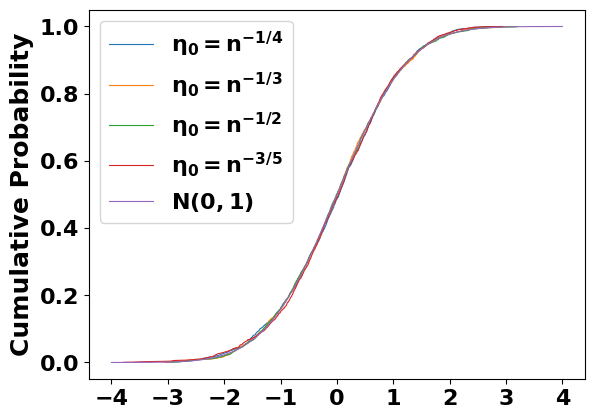

In [55]:
n = 800
R0 = 2000
c = 1
phi = 100
labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


### $T_4^l$




#### Data generating

In [63]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

n = 800
R0 = 2000
c = 1
phi = 100
m = int(n * phi)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)-2)
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi)+2)



def simulate_local_test_statistics4(eta, E, m, n, R0):
    """
    Compute the test statistics for a given value of eta.
    """
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00) / np.sqrt(n * m)
        Et = jnp.array(extract_elements(E0, E-5*eta, E+7*eta))
        Eb = (Et - E * np.ones(Et.shape)) / eta
        loE=jnp.power(Eb,2*jnp.ones(np.size(Eb)))
        t0 = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        T0 = T0.at[r].set(t0)
    TestST = np.array(T0)
    Mean_x = jnp.mean(TestST)
    Variance_x = jnp.var(TestST)
    Normalize_TestST = (TestST - Mean_x) / np.sqrt(Variance_x)
    return Normalize_TestST



etas = [1/(n**(1/4)), 1/(n**(1/3)), 1/(n**(1/2)), 1/(n**(3/5))]


Normalize_TestST_1 = simulate_local_test_statistics4(etas[0], leftb, m, n, R0)
Normalize_TestST_2 = simulate_local_test_statistics4(etas[1], leftb, m, n, R0)
Normalize_TestST_3 = simulate_local_test_statistics4(etas[2], leftb, m, n, R0)
Normalize_TestST_4 = simulate_local_test_statistics4(etas[3], leftb, m, n, R0)

#### Saved data

In [ ]:
Normalize_TestST_1=[-0.3416405 , -1.1558659 , -0.67017025 , -1.1918019 , 0.87073904 , 0.6985482 , 1.9590487 , 0.84680414 , -1.1859292 , 0.73183274 , 0.27622586 , -0.17519523 , 0.009793801 , -1.0750331 , -0.03274919 , -0.91817665 , 1.6101627 , 0.7723853 , -0.26352787 , 1.1379113 , -0.2563347 , -1.2561518 , 0.32709858 , 0.018086154 , -0.5897142 , 0.92483896 , -0.1504722 , -0.69151205 , -1.3371507 , 1.6986151 , 1.4993638 , 1.1429555 , -0.07276784 , -1.2007687 , 1.5323238 , -0.033970986 , 0.76604 , 2.1307416 , -0.4988707 , -0.1841441 , -0.9245982 , -0.0353842 , 2.7831414 , -0.37789506 , 1.1431783 , 0.38743463 , 1.2231424 , -0.36385712 , -1.4939487 , 0.5451957 , 1.1385783 , 1.379233 , -0.38845903 , -0.77981174 , -0.71653265 , -1.4668882 , -0.11493696 , -1.060723 , 0.33223403 , -1.5278269 , -0.37163654 , 0.27384657 , -0.7714192 , -0.5628826 , -0.5045729 , 0.93497527 , 0.54584026 , -1.2885121 , 1.6550686 , -1.2233293 , -0.107755736 , 2.6088269 , -1.9900453 , 2.8703225 , -0.93378186 , 1.1466508 , 0.07382961 , 0.65028507 , 0.51246744 , 2.9206045 , 1.1908029 , -0.51744884 , 0.57661694 , -1.008241 , 0.35087797 , -1.1478682 , 0.66116905 , -1.6919812 , 0.22422107 , 2.9188502 , -0.5775501 , -0.7694766 , -0.90324897 , -0.3265677 , 1.0048374 , -1.350396 , -0.6698098 , -1.8966774 , -0.89438236 , -0.688883 , 1.0754383 , -1.0058259 , -1.1828755 , -0.6518119 , 0.89641917 , -1.6758047 , 0.20222725 , -1.1375644 , 0.076697916 , -0.59666365 , -2.092579 , 1.0121787 , -0.56134224 , 0.4897035 , 0.6152343 , 0.8221798 , -1.047527 , -0.55185354 , 0.84518003 , -1.8758755 , -0.39807636 , 0.19937989 , -0.03608258 , 0.49322084 , 0.52126676 , -0.34382686 , 0.5033586 , 0.4928993 , -0.8742519 , -0.25871247 , -1.9173657 , -0.33499464 , -0.24193037 , -1.1491468 , 2.7948852 , 1.2976704 , 1.3208216 , 2.4127116 , 2.9507964 , 1.7651049 , 0.44727418 , 1.2705396 , -0.5358431 , 1.0676469 , 0.067922525 , -0.2907558 , 2.071919 , -1.0975906 , 0.7631538 , -0.7379597 , -0.18970872 , -1.1703869 , -1.349759 , -0.7282631 , 1.1589077 , -1.3168184 , -1.817835 , -0.43182603 , 2.4961495 , -0.42408997 , 0.3701635 , 0.7464898 , 0.22091459 , -0.88654757 , -1.6745425 , 0.24061285 , 0.56741387 , -0.2534918 , 1.1189533 , 1.4067152 , 1.597535 , -1.5983546 , -0.79538107 , -1.0548651 , -0.19983602 , -0.42258105 , 0.5026841 , 1.3389661 , -0.19624092 , -0.11530933 , -0.12467842 , 1.278355 , 0.53869045 , -1.1441579 , 0.87110394 , -0.8633499 , -0.2886472 , 0.6583471 , -0.9109536 , 0.9284012 , -1.0493679 , -0.008081493 , -0.2769078 , 1.666808 , -0.7863888 , -0.6092674 , 0.92084306 , 1.3082762 , -0.597869 , -0.2094997 , -0.9463647 , -1.4242975 , -0.5500201 , 2.742345 , 0.3107098 , 0.01847348 , 2.1072867 , 0.8095416 , -0.46647146 , 0.40760994 , -0.44393778 , 0.9111465 , 1.3309026 , -0.96490246 , 0.5645859 , 1.889402 , 3.025987 , -0.35815042 , -1.1647699 , -1.0766436 , -0.6924168 , -0.058581855 , 0.11741046 , 1.553344 , -0.61908966 , -1.3027624 , -0.8340717 , 0.9798766 , 0.8449408 , -0.35289088 , -0.029828547 , -0.17683874 , 0.40225768 , -0.3294764 , -0.33039162 , 0.91291416 , -0.1007106 , 0.19465272 , -1.5469525 , 0.498766 , 1.1469948 , 0.20536773 , 0.60767025 , 1.5614136 , -0.07718095 , 0.77113056 , 0.5015012 , 0.9784469 , -1.2606218 , -0.7763931 , -0.81780106 , 0.09302241 , -0.111646935 , -1.1730129 , -1.4839948 , -0.7923647 , 0.12341924 , 0.79765713 , -2.193913 , -1.917288 , -0.4735465 , 1.0731816 , -0.13914555 , -0.2421128 , 0.80217195 , -1.1893942 , 0.032629553 , -1.1408066 , -0.16916253 , -0.089461714 , 0.76869595 , 0.869764 , 0.29823014 , -1.5376626 , -1.8046839 , -0.60147756 , 0.1424954 , 0.25459245 , 2.3071408 , -0.04768739 , -1.1601774 , -1.9754018 , 0.8386299 , -0.38138247 , 0.1732915 , -0.52015567 , 0.94871706 , 0.15781194 , -1.5885682 , -0.051604014 , -1.024742 , -0.8964341 , -0.4162941 , 1.6345298 , 0.013018023 , -2.8296278 , 0.07200066 , -0.74222326 , 0.8408402 , -0.038583 , -0.19573246 , -1.2513319 , 1.2281761 , 0.77276963 , 0.62788445 , -0.18731149 , -1.2161945 , 0.597863 , 1.1738833 , -0.17719916 , -0.15875408 , -0.06456521 , -0.16962463 , 1.0030234 , 0.9610083 , 1.114606 , -1.95815 , -0.63363004 , -0.81915593 , -1.0297353 , 0.84148926 , 0.07088355 , -0.4960757 , 1.767055 , -1.3439012 , -0.09586679 , -0.900934 , -0.8233851 , 0.40100598 , -1.4997376 , 0.6763151 , -0.39658988 , -0.39770398 , 0.20897928 , 0.011652664 , -0.81757224 , 1.0677711 , 0.24400756 , 0.36697218 , 1.8079679 , -0.13320108 , 1.4764248 , 0.30100122 , 0.083938956 , -0.96560234 , 0.71086633 , -0.44391835 , -1.4004267 , 0.6306974 , -0.58311623 , -1.7687644 , -0.6722265 , 0.33456096 , -0.63778746 , 1.1348022 , -2.4503255 , -2.0630286 , 1.2428916 , 0.5527628 , -1.9370909 , 0.049831886 , -2.1852589 , -0.32419738 , 0.7967434 , 0.12137793 , -0.62109506 , -0.16388503 , 1.5628941 , -0.7401625 , 0.2184725 , -1.1717283 , -0.071402475 , 0.89249957 , -1.4055324 , -1.4745315 , 1.521522 , -2.8247435 , -0.77833575 , -1.111485 , -0.3305561 , -1.7659768 , -0.6884269 , -1.1897831 , -1.491019 , 0.9545464 , -1.5297875 , 0.85958433 , -0.65401477 , 0.58656627 , -0.026118297 , 0.6351569 , 1.9240489 , -1.5213337 , -1.0325603 , -1.0221653 , 0.25224906 , 0.6555954 , -1.768546 , -0.44923022 , 2.3345392 , -1.4452863 , -0.37318283 , -0.56468165 , -0.89929646 , -1.7917706 , 0.32052603 , 1.3763663 , -0.22699365 , 0.6475334 , -0.80022186 , 2.066764 , -0.426888 , -0.71211505 , 0.43040234 , -1.1697019 , -0.10024103 , 0.911163 , -0.2624242 , -0.20810892 , 1.221451 , -1.5094372 , 1.3890164 , -0.11663431 , -0.6675756 , -1.1432368 , 0.46163064 , -0.7422442 , 1.3172415 , -2.111866 , 1.9798223 , -0.83452785 , 0.067274995 , 1.2845851 , -0.217647 , 0.41981742 , -0.015587233 , 0.32097167 , -1.5523092 , 0.63738817 , -0.26677302 , -0.8567759 , 0.058707472 , 1.0142125 , 0.20478152 , -0.69944847 , 1.1467271 , -1.4643415 , -0.9464021 , 1.9096103 , -1.231668 , 0.78356236 , -0.98034465 , -0.29935324 , 1.5973302 , -0.80186987 , 2.1888957 , -0.8255117 , -0.2890704 , 0.2759567 , 0.5346228 , 0.56235915 , 0.5797215 , 0.25961724 , -0.847338 , 0.5206103 , -0.16774184 , -0.6401862 , -0.6883327 , 0.5691037 , 0.7867776 , -0.20942044 , 0.31163698 , -0.9924505 , -1.4069635 , 2.4814117 , -0.31947622 , 0.72147065 , -1.0528941 , 0.7300292 , 0.8868407 , -1.2763077 , 0.47219458 , -0.01934384 , 0.9011209 , -0.41194978 , 0.11084238 , 1.5120229 , 0.047795065 , 0.77987456 , 0.68596834 , 0.8635907 , 0.6271158 , 0.9296409 , -0.22957632 , 0.31022677 , -1.5292028 , 1.7467765 , -0.50409436 , -1.2280116 , 0.16587698 , -0.4013529 , 0.8893486 , -0.1113957 , -0.4459058 , 0.785505 , 0.42936745 , -0.21914844 , -0.27275938 , 1.2559843 , -0.94090474 , 0.111307465 , -1.0903436 , 1.9972116 , -1.6693877 , 2.699811 , 0.0009959798 , 0.16608785 , -0.31053632 , 1.3120927 , -1.2212132 , -0.56411934 , -1.1988441 , -0.38754827 , -0.0066458466 , 0.07633751 , 1.0415406 , -0.5014459 , 0.31003085 , 2.2923985 , -0.15919824 , 0.8625409 , -0.7278593 , 0.9589206 , 0.22382028 , 1.1040046 , 3.0774968 , -0.47520047 , -0.6395177 , 0.20794591 , 2.1639843 , 0.8382695 , -0.24685045 , -0.32022992 , -0.40342563 , 0.28767663 , -0.7619783 , -0.62930065 , 1.5073705 , 1.9480227 , 0.6348952 , -0.9371227 , 1.1714412 , -0.49387434 , 0.794394 , -0.91545343 , -1.1368421 , 0.920384 , -0.5984074 , 1.663693 , -0.51946175 , -0.67878413 , 2.1121202 , 0.959115 , -0.2275395 , 0.56975424 , 1.1319968 , -2.3236926 , -0.106831536 , 0.30821985 , 2.2236774 , 1.2635797 , -0.82374704 , -1.017492 , 2.1803641 , 1.125508 , 0.96899855 , -0.396711 , 0.40661696 , 0.9720045 , -1.4706613 , -0.5438229 , 0.048091166 , 0.71132094 , 2.3084598 , 0.91677845 , -0.05374851 , -0.85460746 , -0.60553324 , 0.6162019 , 0.29034755 , 2.1063626 , 0.19133729 , 1.625916 , -0.54934263 , -0.5242951 , -0.54566383 , -0.93564373 , 0.38366756 , -2.0723183 , -1.1419387 , 0.63999474 , -1.0999475 , -1.3107886 , 0.13816452 , 0.94755507 , 0.16437852 , -0.7520709 , 0.01942011 , 0.9801742 , 0.29641315 , -0.051029757 , -1.2688558 , 0.3612565 , 0.3215923 , 0.28978077 , -0.13367812 , -0.06763091 , 0.35285947 , -0.26654124 , 1.7723744 , 0.92478067 , -0.37698582 , -0.07142042 , 1.8734783 , 0.16444881 , -1.0343982 , -0.6507681 , 0.24074595 , 1.0302768 , 0.52179915 , -1.1738518 , 0.020939503 , 0.37933218 , -0.08378343 , 0.583689 , -0.21512115 , -1.1700264 , 1.4535875 , -1.429889 , -1.0384674 , 0.6828413 , -1.1081591 , 1.2026037 , -1.4341481 , 0.95431906 , 0.09293717 , 1.767209 , -0.39902747 , 0.7529024 , -1.0049914 , -0.59286517 , -0.5622171 , 0.26751179 , 0.5753727 , -1.3893902 , 0.18317054 , -0.022225602 , -0.3788103 , 0.08958733 , -0.09029469 , -0.9689283 , -1.2488016 , -0.0434642 , 0.45927078 , -0.023348697 , -0.025780322 , 0.6042352 , 1.368385 , 1.7666513 , -0.29847538 , 0.16789587 , 0.048777584 , 1.1491722 , -0.43950522 , -0.760266 , -0.8680472 , 0.5509099 , -1.7896515 , 0.78753436 , 1.1452944 , 0.08551668 , 1.8276782 , -0.38155296 , -1.0655547 , 0.02163938 , 0.03714137 , -0.66274977 , 0.46057484 , 1.1745697 , 0.6934666 , -0.6158415 , -0.5364667 , 0.6048603 , 0.44390938 , -0.40021187 , 0.77127415 , 1.0227486 , -0.4045577 , -0.26817578 , -1.4352098 , 0.15823516 , -0.18860357 , 0.5395249 , 0.3889002 , 1.0922129 , -0.19028747 , -0.28947717 , -0.62828976 , -1.0396115 , -2.138062 , 0.0492352 , -0.22332826 , -0.8487557 , -1.3963321 , -0.36686003 , -0.29232305 , 0.010801745 , -0.38004553 , 0.36971486 , 0.39081886 , -0.88719815 , 0.55049264 , -0.065704755 , -0.87618405 , -0.06565989 , 1.4433885 , -1.4267888 , 0.07415413 , 0.14533079 , -0.65701616 , 0.8195223 , 0.10632308 , 0.49679798 , 0.4119079 , 0.631508 , 0.5992702 , -0.2092694 , 1.436291 , -0.27377328 , -0.38805524 , 0.9115742 , -0.8440315 , 1.1085868 , -0.3742207 , -0.6785538 , -0.46809852 , 0.18076733 , 0.18288341 , -0.55165017 , 1.5749954 , 0.42719457 , -0.8512292 , 0.012463206 , 0.41433355 , 0.5964902 , -0.9847578 , 0.008815766 , 0.23951668 , 0.0701089 , 0.015887821 , -0.4306386 , 0.14102086 , 0.26794845 , -2.290607 , -0.75601894 , -0.07934639 , -0.78371495 , -0.028279245 , -0.44918388 , -0.5203695 , 2.1588655 , -1.3131305 , 1.4303421 , -0.4788554 , -1.4258766 , -1.2543901 , 0.9403858 , 0.16891876 , -0.4469332 , -0.17313747 , -0.4472637 , -0.38319647 , 0.86038744 , -0.21202405 , 1.4785932 , 1.5019718 , -0.4996229 , -1.5733804 , -0.07167017 , 0.8508733 , -0.38798943 , -0.2764771 , 0.19569057 , -0.1495136 , -0.38574773 , 0.26788566 , 0.9723933 , 0.04602892 , 0.8389275 , -1.5909176 , -0.48031795 , -0.3852004 , -1.2685881 , -0.24197522 , -0.59797966 , 0.16513823 , 0.28283882 , -1.0650448 , 0.19945467 , 0.6571702 , -0.08301177 , -0.9730767 , 1.1029654 , -0.29301095 , -0.19234224 , -0.18509372 , 1.2179695 , 0.7797998 , 1.8086559 , -0.19022465 , 0.30810168 , -0.62816113 , 0.1288059 , -0.6953359 , -0.96962816 , 1.1857498 , 0.791104 , -0.46514946 , 1.4367516 , 0.131411 , 0.5505046 , 1.0003734 , 0.806271 , -0.7107018 , -0.3790032 , -1.2787259 , 0.008184681 , -0.19995715 , -0.30904233 , 0.6053613 , -0.07130228 , -0.71675247 , -0.2488095 , -1.1424515 , -0.04949092 , -0.099808834 , -1.1920816 , 1.0934407 , 1.105578 , 0.6401219 , -0.07432162 , 0.6111158 , -1.9062738 , 0.30313078 , 0.4098935 , 0.8190154 , 2.8512447 , -0.606275 , -0.88767815 , 0.017054284 , 0.6791415 , -0.42305362 , -0.2965911 , -1.2567365 , -1.4503664 , 1.0007249 , -2.158801 , -0.25650066 , -0.08753855 , -0.443371 , 0.09201148 , -1.5702233 , -1.3967255 , -0.16601756 , 0.58159685 , -1.3682878 , 0.051053684 , -0.4570306 , 0.40709102 , -1.3434181 , 0.16056809 , -0.79797417 , -0.6073772 , 0.049680844 , -1.81932 , -0.34749225 , -0.7608657 , 1.3735024 , -1.3429935 , 0.9811821 , -0.60333943 , -0.95585495 , -0.1299275 , 0.43381348 , 0.7965625 , -0.091782674 , -0.64638036 , -0.8075302 , 2.583757 , -0.91478646 , 0.70239604 , 1.5304829 , -0.89039993 , 0.52735186 , 0.6040318 , 0.43551084 , -1.5836482 , -1.017661 , 0.048565228 , -1.3000168 , -0.1121195 , -0.77141774 , -0.16939731 , 0.025310747 , -0.49437234 , 0.14071728 , -0.4886746 , 1.0240017 , -1.649522 , 0.8963294 , 0.69436985 , 0.31025517 , -0.8251812 , -0.4458714 , -0.19559786 , -0.13347624 , -1.4745884 , -0.10884294 , -1.336693 , -0.6802826 , -0.36047888 , 0.7698938 , -0.47563565 , 0.8778709 , -0.5574705 , 0.2169546 , -0.9053366 , -2.1379125 , 0.6001466 , -0.4244414 , -1.1679821 , -1.048167 , -0.078914195 , -0.35546458 , 1.0552076 , 0.6055288 , -1.6209362 , 1.5678202 , 1.1002645 , -1.1712109 , 0.21627118 , -2.179775 , -0.017145507 , -0.24798849 , 0.08542695 , 0.14541903 , 0.48486868 , 1.5795027 , -1.0379664 , 1.6094733 , -1.0269254 , 0.6221449 , 1.5212618 , 0.8362611 , 0.031847425 , -0.1483262 , 0.9123145 , -0.1491876 , -1.2499591 , -0.6623026 , 0.6637876 , 0.8696967 , -1.371675 , -0.36984497 , -0.757972 , -1.5680311 , -0.51740104 , -0.4723262 , -1.1522439 , 0.0919068 , -0.5448099 , -0.4038384 , 0.49453685 , 1.634491 , 0.42033038 , 1.0421298 , 0.61659074 , -0.44083917 , 0.21011135 , 0.6598964 , -1.4165868 , -0.10272798 , 0.48121077 , -0.60658306 , -0.5357429 , 0.6064081 , -0.058683544 , 1.4139442 , -1.3014942 , -0.6172801 , -0.3778068 , -0.21893609 , -0.8917892 , 1.522213 , -0.7620621 , 0.6587075 , -0.24530563 , -0.5016897 , 0.0026903418 , -0.5924988 , 1.041234 , -1.1180232 , 0.66132456 , -1.0958738 , 0.47742873 , -0.22024013 , -0.76683414 , -1.1221521 , 0.077806056 , -0.08318225 , -0.4584139 , -0.6159118 , -0.42498726 , 1.5465652 , -1.5123011 , -0.5779494 , 0.6354261 , 1.9465019 , 0.82334775 , 0.25216234 , 2.5310836 , 0.20077516 , -0.88594043 , -1.1955585 , -0.14204824 , 2.9117901 , 1.7422662 , 2.7907891 , -0.71665525 , -0.90139306 , -0.17402278 , -0.13690834 , 0.77352184 , 0.6617418 , -2.160114 , -0.30412227 , 1.359629 , -0.39475492 , -0.20440765 , -1.4747499 , 0.025020625 , 1.9214797 , 0.15666792 , -0.16473894 , -0.8828837 , -0.8830198 , -1.1263275 , 2.2563965 , 0.99686056 , 0.40816027 , -0.7151359 , -0.30428827 , 0.7042295 , -0.16291298 , -0.37454072 , 0.40815878 , -0.9183591 , 0.8344785 , 0.38003206 , 1.1290553 , -0.19114736 , 1.1956946 , -1.2207062 , -0.92256886 , 0.2633873 , 0.94589216 , 0.12602882 , 1.0333784 , 0.64476526 , -1.6842556 , -0.25199035 , 0.8450081 , 0.506182 , 0.6723133 , 0.22373503 , 1.6479965 , 1.355159 , 0.21988271 , -1.9966418 , -0.33925372 , -0.7130856 , 1.0360597 , 0.24081026 , 0.74736017 , -0.8274513 , -0.41532207 , -0.3404531 , -0.40687567 , -0.78987473 , -1.003635 , -0.36202368 , -0.26990005 , -2.477163 , -1.4980268 , -0.6819336 , -0.6105969 , -1.5529373 , -0.70961314 , 0.6376633 , 2.1437745 , 0.5660709 , -2.417678 , -0.9013572 , 0.7557826 , 0.79604506 , 1.5407178 , 0.041007146 , 0.2458769 , -1.4798465 , 1.8270037 , -1.4049954 , -0.20469926 , 0.29155287 , 0.27032775 , -0.3486632 , -0.93717355 , -0.8543712 , 0.22132733 , -0.21614705 , -1.7503417 , -1.1618732 , -0.09808606 , 1.882348 , 1.3349882 , -0.050126493 , -0.94555867 , -0.8202985 , 0.05969149 , -0.9381531 , 0.5568514 , -0.0813847 , 1.3376411 , 0.92609966 , -0.62138516 , 0.80676603 , -0.8752643 , 0.8037781 , -1.2710018 , 1.2274867 , -0.48354667 , -1.5994477 , 0.50461626 , -1.6256199 , -0.73776823 , 0.39613524 , 2.0446162 , -0.47528723 , 1.4859629 , -0.9305232 , -0.81473684 , 0.53028446 , 0.7473348 , -0.44039652 , -0.38175786 , -1.3824319 , -1.3742352 , 1.1653142 , -1.5661453 , -0.42208454 , 0.74921304 , -0.38663456 , -0.37409058 , -1.3260229 , 2.5978098 , -0.15249407 , 0.07489588 , -0.52404237 , 1.5489728 , -0.30990073 , -1.806136 , 0.06635229 , -0.8457812 , -0.5861311 , 0.03794593 , -1.2990626 , -0.01350704 , 1.3196837 , -0.27108145 , 2.2511027 , 0.121916294 , -0.08220123 , 1.9473333 , 1.9906958 , -0.7112043 , -0.08074166 , 0.816995 , 1.2384784 , -1.2916466 , -0.20453177 , -1.4687186 , 0.15665595 , 0.64420897 , -0.63818973 , -1.5368999 , -0.6785523 , 0.24814253 , -0.24676669 , 0.42943776 , 1.1937416 , 0.88336223 , 3.0494492 , -0.13438997 , -0.49950626 , 1.5483298 , 0.49262115 , -0.05828874 , 1.9770108 , 1.871274 , 1.245709 , -0.9414147 , -0.84766847 , -0.3450008 , -1.0309991 , -0.536688 , 1.00579 , -0.56437504 , -0.65810484 , 0.28587162 , 1.6589942 , -0.38618293 , 0.6972411 , 0.5728588 , -0.027544972 , -0.36729372 , -0.3425871 , 0.57172227 , -1.250463 , -1.3312002 , 0.11736859 , 0.25749516 , -0.57723606 , 0.4507885 , -0.43037093 , 0.10570695 , -0.90689486 , 0.012047467 , -0.26502484 , 0.85457605 , -1.4550366 , 2.5170069 , 0.9486647 , -1.1818092 , 1.4332358 , -0.39441845 , -2.505076 , -1.255268 , -1.3004699 , -0.7335944 , -0.05734959 , 0.93842375 , 0.32042134 , -0.7274406 , -1.0947284 , 0.9198052 , 0.5493561 , -0.0076612676 , 1.1958442 , 1.562263 , 2.2914188 , 0.8621012 , -1.2886976 , -0.73382175 , -0.65520215 , -0.23474465 , -0.70391095 , -0.17918663 , 0.2755514 , 0.13002919 , 0.7260438 , -0.2391488 , -0.124941625 , -0.34109315 , -0.49285743 , -1.4929333 , 1.6348963 , -0.67337054 , -0.42749813 , -0.7307276 , -0.0045611686 , -0.12208229 , -0.80949676 , 0.12886423 , 3.1687245 , 0.3791976 , 0.21973616 , 0.2436008 , -0.30270457 , -0.5385529 , -0.63642955 , -0.101709574 , -0.46988112 , -0.2802023 , -0.18329167 , 1.3335631 , 1.0801162 , -1.5465487 , 1.3473706 , 0.89324427 , 0.654257 , 0.18294622 , -0.5299031 , 2.0792453 , 0.4131716 , -0.2430071 , 0.59270513 , -0.6809017 , -0.44543174 , 0.9347509 , -2.019766 , -1.520529 , -0.41486445 , -0.7526825 , -1.5219452 , -0.8139218 , 0.034739655 , 1.0254704 , 0.84544474 , 1.932926 , -1.64073 , 0.77883077 , -1.9704577 , -0.2627876 , -0.2596561 , -0.6307573 , 0.62542593 , -1.0542177 , -0.1961108 , -0.2934267 , -0.5973486 , 0.07134864 , -1.7153583 , -0.040041078 , -1.029342 , -0.71190417 , -1.0452763 , -1.1772002 , -0.8949925 , -0.06151147 , 0.3542383 , 1.1076342 , 1.8006341 , 0.13107303 , -1.951911 , 0.43263954 , 1.0211514 , 1.7607502 , -1.0026884 , 0.74002343 , -0.7532882 , -1.7296803 , -0.60633934 , 0.94886065 , 0.34982666 , 2.4088502 , 0.23294261 , 0.065583624 , -1.0101672 , -0.7074178 , 0.42051283 , 0.07460726 , 0.38603038 , 0.21515705 , -0.2884438 , 0.117734976 , -0.5553305 , 0.89164263 , -0.19049084 , 1.7264636 , 0.9065001 , -0.61558276 , -0.9206397 , -0.5790456 , -2.1107128 , 1.8507353 , -1.2715281 , -0.27650702 , 0.38509423 , -1.1195769 , -0.17692848 , 1.369185 , 0.7299963 , 0.6000688 , -0.80002296 , 0.55042684 , -0.5485815 , 0.5066576 , 0.16560033 , 0.4756252 , 0.42932558 , -0.08025114 , -0.48895726 , -0.29376018 , 0.33909073 , 0.8989839 , -0.50097334 , -0.29693955 , 1.4467772 , -0.6666993 , 0.21201956 , 0.5467346 , 0.4387261 , 1.2035474 , -1.6659421 , 0.5520016 , -0.22085029 , -0.7441015 , -1.0178643 , -1.0428865 , -1.0312698 , 0.40282446 , 1.4555975 , -1.4386389 , -0.70219266 , 0.9109042 , 0.9108295 , -1.0643748 , -0.5731385 , 0.12199406 , -0.015715843 , -1.8648599 , -0.043866478 , 1.2178125 , -0.27922577 , -0.6250222 , 0.09435786 , 3.4216347 , 0.008199635 , 0.5067922 , 1.4677123 , -0.7440268 , 0.32272586 , 0.35830146 , 0.068436965 , 0.4746696 , 0.2193937 , -0.26831037 , 1.5396127 , 1.4388633 , 0.10201016 , 0.62616616 , -0.60920614 , -0.4440634 , -0.53209394 , -0.5213401 , -1.5313054 , 0.8493539 , 0.57776845 , -2.0295196 , 0.16371603 , -0.24288596 , -1.2376604 , -0.3209567 , 1.8317219 , 0.11797874 , 0.7177724 , -0.51461494 , -0.2627233 , 0.48293054 , -0.14991589 , -1.098117 , -0.7109815 , -1.0363065 , 0.9926493 , 0.68685216 , 0.6040288 , 1.3832289 , -0.32081464 , 0.26969367 , 0.21946698 , -0.25969946 , -0.24512617 , -1.1689138 , -0.26719475 , 0.2533348 , -0.83399546 , 0.69677156 , 1.2116512 , -0.12544858 , -0.18902828 , -0.6461471 , -1.3471044 , -0.32901728 , -1.3472974 , -1.3611588 , -0.91806304 , 2.0586288 , -0.30727023 , -0.073932804 , 0.38892412 , -1.9707778 , 1.3712816 , -0.21676767 , -0.07727816 , 1.2062062 , 0.7727965 , 0.83577055 , -0.32084158 , 0.2269099 , 0.62578183 , -0.49025086 , -1.2840617 , 0.87934244 , -0.28790095 , -0.2857759 , 1.4065597 , -0.837278 , 0.364231 , 0.877352 , -0.2993697 , -0.5821232 , 0.17388222 , -0.3002191 , -1.1254197 , 0.60023934 , 0.7412258 , 0.34832224 , 0.95336497 , 0.2603216 , 0.11079901 , -0.49757412 , 0.309651 , -0.18784238 , 0.32787323 , -1.5071132 , 1.1169435 , 2.6542351 , 0.83771914 , 0.8250795 , 2.1890066 , -0.19621548 , 0.13774878 , -0.5569187 , -1.4545282 , -1.6984506 , 0.9592855 , 2.411252 , -1.5637226 , 0.43323624 , -1.6919049 , -0.298269 , -0.6271203 , 1.0048509 , -0.23508263 , 0.47744367 , -1.4632767 , -0.752201 , -0.8400147 , -0.068121426 , 0.37429696 , 0.0075296666 , -1.0440066 , -2.4695377 , -0.7610257 , 0.07407936 , -0.239744 , -1.6058439 , -1.5237324 , -0.6400964 , -0.46160072 , -1.0354301 , -0.34878433 , 0.31678885 , 2.1063251 , 0.33014038 , 0.15331209 , 1.1066307 , -0.66742754 , 2.6164865 , -0.47152016 , -0.8611262 , 0.6996294 , -0.04766346 , 1.1909151 , 0.42798266 , 1.2168195 , 0.36960867 , 0.33423942 , 0.099885106 , -0.27621838 , -0.022240557 , 0.51794237 , -0.8942986 , -0.060843 , -0.67379975 , 0.30953884 , 0.6263965 , -0.655416 , -0.25409597 , -0.3671307 , -0.4337447 , -1.3323443 , 0.49439627 , 1.8313689 , 2.060012 , -0.19990928 , -0.31563586 , 1.553537 , -0.3199712 , 0.15270194 , -0.25887847 , -0.7459514 , -0.1303896 , 0.3505729 , 0.32648695 , 0.94828635 , 0.52292526 , 0.28089172 , -0.62303466 , -0.7171996 , -1.6850019 , -0.94022435 , -0.61323637 , 0.80773807 , -0.26062965 , -0.83184946 , 0.46106684 , -0.70261884 , 1.0011077 , -0.37709048 , -0.548073 , -0.69742507 , -0.4305788 , -0.50878114 , -0.59379834 , -0.102835655 , 0.95767194 , 0.3519039 , -0.35267553 , 1.199686 , 0.4552106 , 1.2936984 , 0.039408498 , -1.4023993 , -0.21625473 , 1.1999283 , 0.076706894 , -0.35837924 , -0.7328362 , 4.9650292 , 0.0731746 , 0.5047763 , -0.19894172 , -1.0927243 , 3.524901 , 0.7855244 , -0.426061 , -0.5472864 , 0.07266913 , -0.4274413 , 0.24103458 , -0.81816447 , 1.7510356 , -0.46722966 , -0.22505254 , 1.4190992 , 0.86631393 , -1.1052594 , 2.0076365 , -0.921368 , -0.53451663 , 0.52043533 , 1.1187081 , 0.031798076 , -0.39635807 , 1.1741525 , 0.3877038 , 0.42655897 , -0.43807557 , -0.19757785 , 1.8923151 , 2.7493587 , -0.42515624 , 0.25434422 , -0.6875221 , -0.17671463 , -1.2141637 , -0.64243233 , 0.7252243 , 0.17468826 , -0.025783313 , -0.9438942 , 0.56191206 , -1.1755493 , -0.0011081396 , 0.35311967 , 0.6072441 , -0.72586584 , -0.6944401 , 0.39459342 , 0.48724496 , 0.16223553 , -0.62026507 , 2.4878378 , 0.5945072 , 2.610865 , 0.06920265 , 0.4963643 , -1.3597038 , -0.18363415 , -0.49054694 , -0.33351862 , -0.45646378 , 1.9264746 , -0.44951886 , -0.8210163 , -0.5356726 , -0.18281463 , -0.6783923 , -0.5673331 , -0.8932368 , 1.1563894 , 0.90100276 , -0.10987332 , -0.39307553 , 2.3597782 , -1.1927769 , -1.1040914 , 1.4633904 , 1.3552502 , -0.881137 , -1.3855021 , -0.59284425 , 0.31128404 , 0.3444026 , -0.22268073 , 0.45157513 , -1.0711732 , -0.038210627 , -0.9870025 , -0.018125037 , 1.1370245 , 0.7661238 , 0.47847405 , -0.2760778 , 1.3085843 , 2.5036614 , -0.6642856 , -0.51620615 , 0.46011272 , -0.3159843 , -0.5543405 , 0.12517491 , 0.61507136 , -0.117272876 , 1.0736347 , -0.85981613 , 1.6477737 , 1.1564701 , 0.31369475 , 0.26327813 , -1.0662009 , -0.6721338 , -1.2667142 , -1.0042616 , 0.49932534 , -0.07670988 , 0.28562784 , -1.0360433 , 0.80933523 , -0.83176273 , 0.082525745 , -0.65618765 , 1.575145 , 0.41172695 , 2.1138458 , -0.4933584 , 0.48537263 , -1.154179 , -1.0839819 , 1.6903317 , 0.9492614 , -1.533906 , 2.4384964 , -0.043609258 , 0.47626975 , 0.11798472 , 0.35214764 , 0.4704464 , 0.78943956 , -1.3479539 , -0.17448339 , 1.113782 , -0.5412163 , -1.1454545 , -1.1896065 , -0.09028422 , 0.9931548 , 1.036634 , 0.40596345 , 0.060896832 , -0.3865239 , -1.2616761 , 0.20444353 , 0.19693929 , -1.2378204 , 2.0449736 , 0.67116326 , 0.03189827 , -0.1728653 , 0.27767646 , -1.1949245 , -0.44300762 , -0.1503735 , 0.5282536 , 1.3123664 , 1.3994174 , -0.24489886 , -1.2137748 , -0.7320257 , 0.28065693 , -1.0007503 , 0.60972804 , -0.24053061 , -1.3044418 , -1.8054451 , -0.32524124 , 0.8594722 , 0.18698548 , 1.0217915 , -0.7577073 , -1.1503341 , 1.1392004 , -0.40698335 , -0.3139325 , 0.8156745 , 1.50487 , -1.0809177 , -0.6342522 , -0.5925855 , 0.41461322 , -0.35606125 , -0.8639571 , 1.534105 , -0.94307315 , 0.7929509 , -0.39088318 , -0.5781812 , 1.0442743 , -1.5283145 , -0.5410189 , 0.86999726 , 0.6977077 , -0.73556995 , -0.9752362 , 0.4813274 , -0.5339947 , -0.24233264 , 0.1416998 , 0.32744107 , 0.0501235 , -0.7598981 , -0.2715331 , -0.07458183 , -0.8689953 , 1.4182093 , 0.38139594 , 0.37219286 , -2.3400111 , 1.0075606 , 0.516257 , -0.306515 , 1.6867754 , 0.21024744 , 0.3571395 , 1.7208213 , 0.52479905 , -2.0284474 , 2.263986 , -1.1829278 , -1.4266108 , -2.0121183 , 1.0594891 , 0.33759078 , -1.0253283 , 0.24048574 , 0.21854727 , -1.3803233 , -0.40053788 , 2.2512312 , 0.33134872 , 1.6200224 , -0.9513027 , -0.35443568 , 1.0381174 , -1.2499007 , -1.1519792 , -1.236781 , 0.5007101 , 0.34838653 , -0.6954062 , 1.3585224 , -1.0844171 , -0.72267157 , -0.36616912 , 0.32200953 , -1.089747 , 1.0449921 , -1.5450592 , 0.34361452 , -0.7430607 , -1.3952405 , -0.09222832 , -1.3721101 , -0.4192312 , 0.32176876 , 0.60291916 , 0.86957854 , -1.771516 , -1.4248596 , -0.12415202 , -1.1696391 , -1.8419194 , 0.14781626 , 0.062160503 , 0.3364318 , 1.3422068 , 0.24117365 , -0.9008906 , -0.38257885 , -0.016372351 , 1.1173053 , 1.4725232 , 0.5030715 , -0.26739514 , -1.2761537 , -0.051225662 , 1.222791 , -0.3239895 , 0.14642847 , 0.42452815 , 0.01552891 , 1.4109011 , -0.41210082 , -1.3999661 , -0.85606253 , -0.44926614 , 0.15555978 , 0.3867467 , -0.39319366 , 0.7430323 , 1.3095608 , 0.7068615 , 0.4342098 , -0.7538998 , 0.62628734 , -0.47757676 , -0.16863313 , 1.4796087 , -2.0813823 , -0.20723407 , -0.9135108 , -0.23936863 , -0.31755903 , -1.3880937 , 1.8560696 , -0.5449505 , 0.3845439 , 0.83365 , -0.39731666 , 1.6002942 , 0.4978179 , 0.00014805104 , -0.51504266 , 1.1850065 , 0.68366385 , -1.1716819 , -1.7598618 , -0.35113668 , 0.13654943 , -1.201639 , 0.23795392 , -0.8327886 , -1.5311215 , -0.56342846 , 1.6635374 , -1.0086313 , 1.5725802 , -0.08279194 , 0.1397542 , 2.3846388 , -0.85048145 , 1.8251613 , 0.35356534 , -0.71576846 , 0.08120525 , 1.4449079 , -1.7172859 , 2.12738 , 0.96363884 , 0.91375756]

In [ ]:
Normalize_TestST_2=[0.08051452 , -0.14864147 , -0.2751403 , -0.32550696 , 0.49069005 , -0.7465308 , 1.8919575 , 0.3533453 , -0.4406718 , 0.5334787 , -1.3047491 , -0.50901055 , -0.36778802 , -0.9963292 , 1.8774699 , -0.22308938 , 1.7930936 , -0.7733374 , -1.7808936 , 0.7731493 , 2.0901506 , -1.6668266 , 0.79005 , -0.59840107 , 0.014642069 , 0.87592006 , -0.837809 , -1.2236176 , -0.7240912 , -0.32901323 , -0.22605613 , 0.5944896 , 0.42904973 , 0.5014313 , -0.041832626 , -0.5818387 , 0.4066373 , -0.3954252 , -0.8274375 , -0.6376225 , 0.01972843 , -0.72384274 , 4.4371743 , -0.9303562 , 0.45951286 , 0.0007442012 , 1.4498174 , 0.3979891 , -1.1637425 , -0.157999 , -0.6230839 , -1.2671338 , -1.0880393 , 0.034207817 , 1.3308796 , 0.4593638 , 1.4131055 , -0.5418465 , -0.24898498 , -2.0200074 , 0.27476877 , 3.982609 , 0.21694943 , -0.78132486 , -1.001328 , -1.1043804 , 2.5114949 , 0.9552171 , 0.85190505 , -1.60094 , 1.1135634 , -0.451555 , -1.3835794 , 1.6249869 , -0.2739524 , -0.79390174 , -0.23533025 , 0.20249549 , 0.046412006 , 0.72910535 , 0.6460205 , 1.3879938 , -0.29524377 , -0.41494775 , -0.25444582 , -0.7121526 , -0.88541955 , -1.0682274 , 0.8203256 , 1.9766959 , 0.21066277 , -0.09591558 , -0.6846219 , -0.4347756 , -0.56336087 , -0.9567907 , 0.04723962 , -0.44266185 , -0.020744756 , 0.0016782979 , 1.0816373 , -0.71834874 , -0.4221502 , -1.0327685 , -0.7520993 , -0.052024275 , -0.14808656 , -0.7025756 , -0.42420235 , -0.1554771 , -0.5874338 , 0.41861552 , -0.8430977 , -0.19389872 , 0.5089845 , 0.70989573 , -1.3583447 , 1.7650825 , 0.91566736 , -0.034001946 , -0.830196 , -0.56343424 , -0.014663366 , -0.2632106 , 2.4952693 , -0.5694801 , 0.20177494 , 0.58354896 , -0.24616021 , -0.6151757 , -0.5910206 , -0.80805105 , -0.697659 , -0.6307123 , 0.007128477 , 1.349413 , -0.57242024 , 0.834734 , 0.24579225 , -1.2364767 , 2.235297 , 1.1778693 , 0.27308398 , 0.47388577 , 1.442114 , 0.7879617 , 0.5755911 , 0.8217442 , -0.6553898 , -0.22552608 , -0.6088181 , -0.59847915 , -1.2835974 , 0.01238107 , 0.39377767 , -0.696945 , -1.6230259 , -0.8368501 , 0.7681073 , -0.8491856 , -1.032695 , 0.29184872 , -0.36537498 , -1.2770817 , -1.3357518 , -0.13599537 , -0.0029998762 , -1.0567361 , 0.3118907 , 3.6100056 , 0.63926524 , 0.5391229 , -1.3418071 , -1.7162474 , -0.78403604 , 0.50150347 , -1.245882 , -0.2849687 , 0.38470647 , -0.93167305 , -0.4721726 , -0.52011025 , -0.8406403 , -0.2494967 , -0.64230597 , -0.4050454 , -1.6682186 , 0.06454082 , 0.23145545 , -0.5846872 , -0.42335168 , 1.0061872 , -0.7489983 , 1.0332873 , -0.1484143 , -0.46572027 , 0.25507525 , -0.5084823 , 2.8757548 , -0.6992817 , -1.3002218 , -1.1174624 , -1.0374602 , -0.1921731 , 1.1938312 , -0.5483834 , 0.36446926 , 2.5367138 , 0.14199631 , 0.3506353 , -0.367297 , -0.5314685 , 1.482896 , 0.03373219 , -0.89412224 , -0.0034985738 , 1.682856 , 0.27183634 , -0.36650193 , -0.3453673 , -0.08613803 , 1.4543613 , 1.2379603 , -0.16172059 , 0.48371065 , -1.001448 , -0.12895267 , -0.7695809 , 0.46470454 , 0.06974963 , -0.3532536 , -0.7001466 , 2.0751696 , -1.7737733 , 0.33418596 , 2.2492535 , -1.0186192 , 1.6582003 , -0.9589695 , -1.2701449 , -0.3895006 , -1.2446995 , -0.31722018 , 1.4820145 , -0.69514424 , -0.12033757 , 0.23119041 , 0.3394415 , -1.6031206 , -0.49656618 , -0.29770648 , 0.8371175 , 0.19440569 , -1.4518205 , 0.28828272 , 1.1906124 , -0.18742098 , -0.8584556 , 0.33278453 , -0.24363065 , 0.22450976 , -0.57809407 , 0.6480519 , 0.3787901 , 2.5103462 , -0.69706684 , -0.6810665 , -1.3961138 , 0.7234245 , -1.5576385 , 0.8425073 , 2.7355776 , -1.1927735 , 0.22599876 , -0.12185318 , 0.15834211 , 1.7546927 , 0.119725876 , 2.707654 , 0.9490079 , -0.50223345 , -0.21444826 , 3.6525092 , -0.9348202 , -0.8537904 , 0.31368494 , -1.1525494 , 0.632597 , 0.4340018 , -0.5949995 , -1.20269 , -0.23226826 , 2.0004878 , -0.05769097 , 1.2588607 , -0.6110838 , -0.48017776 , -0.28542778 , 0.08966086 , -0.60080045 , -0.6191618 , 1.0938532 , 0.12262873 , 0.15565814 , 1.6421609 , -0.7032902 , -0.756377 , 1.69898 , 2.2800128 , -0.77619475 , -0.5475079 , 1.5665576 , 0.056190148 , 2.8079438 , -0.6841912 , -0.280875 , -0.48422533 , -0.36376885 , 1.7311918 , -0.37985674 , 0.953301 , -0.5294033 , -1.1952462 , 0.26205525 , -1.6403193 , 0.54998004 , 0.056274742 , -0.2541021 , -0.9842031 , -0.015579715 , 0.31984323 , 0.21792494 , 0.21138863 , -0.12264471 , -0.5951255 , -0.51415545 , -0.79564154 , 0.11627936 , -0.45256364 , -1.0667834 , -0.6659666 , -0.1356073 , 0.860897 , 0.9786062 , 1.6140393 , -0.75877464 , 0.5650717 , -0.026494863 , 0.04518567 , -0.06273651 , -0.07368479 , -0.05474848 , -0.48196492 , -1.2004036 , 0.7239261 , -1.1440479 , -0.6659388 , -0.43399706 , 1.5301836 , 0.44082975 , -0.69020814 , -0.8199068 , -0.72283703 , -0.35109138 , -1.450299 , 0.22915184 , -1.6756263 , -0.7523791 , -0.8666217 , -1.3870455 , -1.6591741 , -0.34215328 , 0.5340412 , -1.018127 , -0.9003728 , -0.14396743 , -1.6632423 , -1.3865491 , -0.88361347 , -0.4648412 , 0.012400593 , 1.5805538 , -0.8829166 , -1.2679094 , 0.6771521 , 0.28427243 , 1.1872185 , -0.31890914 , -0.102863036 , -0.571808 , 0.4951535 , -0.2186851 , 0.44972527 , -0.9126243 , 0.6343629 , -1.4061581 , 0.046764586 , -0.29472083 , -0.08300269 , 0.37806663 , 0.4787716 , -0.07527672 , -0.723092 , 0.72268385 , -1.1450393 , 1.6215351 , -0.2556183 , 0.65770286 , -0.90548044 , -1.1595193 , 0.08826948 , 0.52863723 , 2.0812852 , 1.6213884 , 1.2952284 , -0.59246284 , 0.86427194 , -1.7908698 , -0.596075 , 1.0164368 , -1.8294494 , -1.49798 , -0.74453187 , 0.5615347 , -0.58567154 , -0.114782676 , -0.9262607 , 0.89823306 , -1.3120663 , 1.8229166 , 1.887868 , -1.3114357 , -0.30730835 , -0.8123009 , -0.6233294 , -0.53217244 , 1.6102868 , -0.9044754 , 0.5411798 , 0.14917861 , -0.39464313 , -0.65899605 , 1.2810671 , -0.41724306 , -0.52889574 , -0.4114486 , 0.17252748 , 1.1246957 , 0.31058154 , -1.8629272 , 0.7586125 , -0.7262374 , 0.039249808 , -0.18394783 , -0.14060019 , 0.9165991 , -2.1270707 , -0.63124585 , 0.114069834 , -1.2179669 , 2.092525 , -1.0562533 , -0.3649532 , -1.311874 , 0.25352946 , 0.6033466 , -0.16409636 , -0.18020317 , 0.13927151 , 0.70993835 , -0.75391895 , -1.5660672 , -0.44923484 , -0.6841563 , 0.6453774 , -0.8155924 , -1.9325372 , -0.64957994 , 0.20723519 , -1.5261643 , -1.5356035 , -1.2231615 , -0.5599238 , -0.928472 , 0.4266982 , 0.050681993 , 1.3762468 , 1.3994466 , 2.6025336 , 0.19796401 , -0.4713698 , 0.019496532 , 0.4350051 , -0.76057893 , -0.34801698 , 0.33253548 , -1.1448778 , 0.24879864 , -0.8312307 , -0.3085276 , 1.8184308 , -0.64635116 , 0.32214683 , 1.7568477 , 0.28975928 , -0.95834774 , -0.8220755 , 0.13228384 , -0.4964372 , -0.44296417 , -0.41441417 , 1.1473144 , 0.56599396 , 0.48964295 , -0.7760983 , 0.8492625 , -0.0072822864 , 0.87645125 , 0.9360152 , -1.5656207 , 0.057305858 , -0.47720096 , -0.92110276 , -0.4596862 , 1.3772656 , -0.697081 , 0.34574652 , 1.2788831 , 0.72832865 , -0.66714084 , 0.077567294 , -1.1588212 , 0.6379857 , -1.4294087 , -0.5176972 , 1.2748492 , -1.2761731 , -0.23281428 , -0.16201994 , -0.6740232 , -0.42711884 , 0.3967018 , -2.0189114 , 0.1792874 , 1.216553 , -0.19711511 , -1.1850605 , -1.0088327 , -1.0814521 , 0.13484712 , 1.427398 , -0.7172171 , 2.1684349 , 0.42975608 , 1.4485545 , -1.6543586 , -0.93791115 , 0.5717896 , -0.06959286 , 0.06288204 , -1.1396637 , -0.82966185 , 3.0832143 , -0.882651 , -0.29703802 , 0.39348838 , 0.18603906 , 0.33896175 , -0.270203 , 0.6581081 , 0.8512762 , -0.21297346 , 0.653818 , 0.6306454 , 1.0708854 , -0.5242584 , 0.5116927 , -0.39694673 , 0.49351838 , -0.96713084 , -1.0383304 , 0.9371238 , 2.0152144 , 0.4278145 , 0.87793374 , -0.6986067 , 0.722979 , -1.9573396 , 0.15087289 , 1.4529285 , 0.23436421 , 0.9313228 , -0.111399464 , 0.30392867 , -1.0646709 , 0.24691093 , 1.4753789 , 2.1912613 , 0.9356052 , -0.7893851 , -0.15441346 , -0.51017535 , -0.60367256 , -0.3137364 , -0.923194 , -0.1807486 , 0.33147478 , -0.5192537 , -0.836094 , 0.03269516 , -0.7046662 , -1.8897545 , -0.45268196 , 1.3516374 , 1.3604654 , -0.53637975 , 0.7449685 , -0.2915358 , 0.65021354 , -0.8666755 , 1.1143047 , -0.93520474 , 0.5459745 , 0.9676266 , -0.26934344 , -0.5683455 , -1.1298542 , 1.211534 , 0.37633035 , -0.026304968 , -0.55625075 , -0.16256359 , 1.6647727 , 0.6097924 , 1.4967974 , -1.8293352 , 0.82452404 , -0.41813812 , 0.38045895 , 0.7903446 , 0.38855347 , -0.12934193 , 0.5205309 , 0.47371954 , 0.37153387 , -0.24372943 , -0.5680266 , 0.31917298 , 1.9306915 , -0.2141016 , -0.713163 , -0.26138616 , 1.4768353 , 0.09458927 , -0.72162193 , 1.0350436 , 0.71531457 , 0.70037967 , 1.4228978 , -0.4946974 , -0.5505746 , -0.2733484 , 0.73136634 , -1.0200526 , -1.3652176 , -0.5930905 , 2.036129 , 0.83016646 , 1.7729344 , -0.65718937 , -0.38115406 , -0.2052747 , -0.5844931 , 0.41097534 , -0.27518702 , 0.83900166 , -0.9756767 , -0.23705232 , 0.027568571 , 1.09912 , -1.3757074 , 0.10124863 , 0.31722906 , -0.8212372 , 3.3236752 , 2.559416 , 0.045682594 , -0.041624982 , 0.8187804 , -0.8635266 , 0.36262178 , 0.107625216 , 1.5601811 , 0.21045926 , 0.6172575 , -0.9508199 , -0.43224838 , -1.9173781 , 0.28391156 , 0.15829241 , -1.2451184 , 1.0482186 , 1.2859501 , 0.33397952 , -0.6338997 , -0.78471756 , -0.6195451 , -0.06353869 , 0.91335374 , -0.6897402 , -0.38790748 , 0.1952339 , -0.32980713 , 0.5623842 , -1.1044383 , -0.6703626 , -1.67106 , 0.34743783 , -0.87554675 , -0.11462236 , -1.4267544 , 0.16700868 , 0.96272063 , -0.7334416 , -0.5823711 , 1.1374542 , -1.1535273 , -1.330553 , -0.26996815 , 0.19900401 , -0.8110959 , -0.27350813 , 1.8923728 , -1.008234 , 0.1778138 , -0.04671785 , 0.0068551693 , 1.3160465 , 0.13888817 , 0.30638608 , -0.59601283 , 0.06824052 , 1.8309828 , 0.6284986 , -0.11306356 , 2.0339758 , 0.6785092 , 1.558866 , -1.0984327 , 1.5429467 , 0.19123071 , 0.92740065 , -0.9991977 , -0.29566023 , 0.005858366 , -0.37620848 , -1.5284638 , 1.6722248 , -0.29323655 , 1.085234 , 0.32782593 , -0.28537038 , -0.26435292 , -0.8522754 , -0.06229579 , 0.28849155 , -0.33983788 , -0.56029356 , 0.47643074 , -1.2155988 , 2.6228364 , 0.63252485 , -1.6502153 , 2.7983117 , 0.09914913 , -0.5740459 , 0.50195366 , -1.2711743 , -1.753861 , 1.3960445 , 0.1978747 , 0.48639935 , 0.2314371 , -0.63424695 , 0.99071395 , -0.29853827 , -0.21828698 , -0.8063662 , -0.7868863 , 0.6882483 , -1.1664088 , 0.4655351 , -0.3178786 , -0.83440214 , 0.124323 , 1.0641344 , 0.9645078 , 0.5565637 , 0.09675384 , 1.5331827 , 0.5767074 , 0.43639117 , 1.1218383 , 0.7169473 , -0.25618386 , -1.4482592 , -0.3641433 , -0.75962174 , 1.0835261 , -1.8181409 , 0.7633658 , -1.5909146 , -0.6237074 , -0.7959107 , 0.21086922 , -0.8344956 , 0.5326351 , -1.099139 , -0.0765279 , 1.0603689 , -0.30273902 , -0.9707708 , 3.7076676 , -0.058597263 , -0.20230559 , 0.62994796 , -0.6613251 , -0.7693153 , 0.15074511 , -0.12089838 , 0.5132776 , -0.96116304 , 0.5151203 , -0.08679113 , 0.12347232 , -1.0277861 , -0.4244857 , -0.69813585 , 1.0377394 , 0.9130579 , -0.6650029 , 0.15001687 , -0.7879079 , -0.65329623 , 3.3574612 , 0.7666917 , -1.5780241 , 1.180916 , -0.687662 , 1.6868343 , -1.2906909 , 0.11803989 , -1.5822581 , -0.09439819 , 1.8418689 , 1.8760288 , -0.23489131 , 1.472373 , -1.567894 , 0.6351171 , 0.45572206 , 0.4158227 , -0.8623748 , -0.5955958 , -0.6604963 , 3.0231009 , -0.42727086 , -1.0666479 , -0.5796925 , 0.9197167 , -0.51427025 , 0.21029302 , -1.6868823 , 0.71820736 , 0.31604472 , 0.09922899 , -0.658576 , 0.29422507 , -1.5651019 , -0.73666745 , 0.9577999 , -0.9128166 , 0.40398055 , -0.6689694 , -1.0110552 , -0.798225 , 0.030251956 , -0.3937611 , -0.85862595 , 0.7270147 , -0.3632465 , -0.39806068 , 0.4788053 , 0.5743056 , 0.5261745 , 1.0691503 , -0.2713116 , 0.11707503 , 1.0343716 , -0.5058527 , 0.05459171 , 1.2870817 , -0.58746165 , -0.90489244 , 2.398632 , -0.3924496 , 1.8360348 , -0.7411818 , 0.93309754 , -1.4116437 , 1.453002 , -0.13192298 , -0.8564525 , 0.6791344 , -0.98598194 , -0.53434235 , 0.5832035 , 0.47817293 , -1.8214052 , -0.9529845 , 0.206013 , 1.515613 , 0.10317953 , -0.9268375 , -0.40175268 , -0.028457116 , -1.0057719 , -0.5542914 , 0.9676692 , 1.7991956 , -1.5707461 , 0.49486834 , 0.09524415 , -1.0476412 , 1.5522652 , 1.6942468 , -0.25028232 , -0.6351757 , -0.017232576 , -0.8350304 , 1.0706162 , -0.18933886 , 0.3657258 , -0.8976427 , -0.4311492 , 0.39371496 , -0.7948021 , 1.3960888 , -0.56056154 , 0.09829549 , -0.13661239 , -1.7663088 , 2.065555 , -0.66185516 , 2.8947325 , -1.1716921 , -0.48999494 , -0.8537969 , -2.1315472 , 0.026280122 , -0.7239989 , 1.8932495 , 2.2736735 , -1.0096041 , -1.384584 , -0.8367288 , -1.7047069 , -0.98597366 , -0.6240458 , 0.18665962 , 0.21558526 , 0.47557235 , 0.54838103 , 0.14744116 , 1.8645405 , -0.8456373 , -0.16963646 , 0.107513405 , 2.9754105 , -0.6102414 , -1.264867 , 2.2128372 , 2.2812505 , -1.205658 , -0.1559066 , 0.6863126 , 0.3990971 , -0.84285873 , -1.6230489 , -0.77830786 , -0.8763501 , -0.881017 , 0.12557064 , -0.05301694 , 0.35300574 , -0.8761005 , -0.6065269 , 1.2176936 , -0.741109 , -1.1585728 , -1.6310434 , 0.4227264 , -0.2405373 , 0.8122601 , 1.8283721 , 0.37445682 , 0.7842532 , 0.6059939 , 0.7831522 , -1.2397178 , 1.0604264 , -1.547787 , -1.3208512 , -0.2685052 , -5.5016462e-05 , -0.8328812 , -1.1445667 , 0.5645624 , 1.2978721 , 1.0196615 , 0.018986596 , -0.85907674 , -1.1054907 , -0.051583555 , -1.8439602 , -0.08016017 , -0.9012909 , -0.8737235 , 2.392702 , -1.2880448 , 0.6263642 , 0.031769935 , 1.2464056 , -0.8874114 , 2.88909 , 0.11593921 , 0.27644885 , -0.73529917 , -1.2073144 , 1.2006012 , -0.7724968 , -0.9647728 , 0.40094993 , 0.18956307 , -0.39220348 , -0.57254684 , 1.0554281 , 0.23381168 , 0.5747966 , -0.9763825 , 0.90712565 , 1.6098461 , -0.4426021 , 0.5170465 , -1.2238997 , 1.3859262 , -1.6355063 , 1.7080582 , 0.15053746 , -0.98110265 , -1.5317813 , -0.7752908 , -0.6301698 , 0.4539497 , 0.63721544 , -1.0192314 , -1.7570063 , 0.29650974 , -0.024128564 , -0.47557768 , 0.6022155 , -0.9308146 , -1.5540044 , -0.39437398 , 0.29866603 , -0.9131987 , -0.3866196 , 0.3599603 , -0.08061923 , 0.24915832 , -0.7310516 , -1.7222567 , 1.959487 , 1.9181986 , 1.1778646 , 1.7628008 , -0.37781993 , 1.2813712 , -0.63233733 , 0.47677797 , -0.08035361 , 0.45198685 , 1.4690709 , -0.8938489 , 1.5400013 , -0.7063883 , 0.8965317 , 0.12910767 , 0.39346945 , -0.47988316 , 2.3322122 , 1.233846 , 0.07732889 , 1.8594488 , 0.13545053 , -0.012864978 , 0.24493387 , -0.10414439 , -0.97097135 , -0.8407574 , -0.9231851 , -1.5934383 , -1.2030077 , 0.109494 , 0.42567775 , 1.6475366 , 0.6730732 , -0.27012077 , 0.51305574 , -0.011255895 , -0.55843836 , 0.33689064 , 1.3578489 , -0.40559968 , -0.7413634 , 1.6015742 , -0.40626937 , -0.1626754 , 0.19395255 , 0.16816463 , 0.9700319 , -0.6221037 , -0.11492111 , -0.32252365 , -0.14574511 , -0.6331176 , -0.27698067 , 0.387281 , -0.43462294 , 0.35849023 , -0.29003435 , 1.2131159 , 0.481242 , 0.008775421 , 0.29735392 , -0.5499895 , -0.7257476 , -0.9156384 , -0.44631246 , 0.74760216 , -1.2113501 , 2.4979951 , -0.7276791 , -1.2489524 , -1.1535213 , 2.4518466 , -1.0227537 , 1.0210061 , -1.9660168 , -0.16759671 , -0.087457836 , 0.6211376 , -0.88002205 , -0.6031975 , 0.45046 , -0.9145848 , 0.985879 , -1.0263859 , -1.0128862 , -0.64130735 , -0.6917823 , -0.85376793 , 0.7149407 , 0.88586974 , -0.48709208 , -1.4750109 , -0.65740114 , 0.7034405 , 0.18028599 , -1.1555285 , -1.40598 , -0.21028179 , -1.4983147 , -0.3093268 , -0.560306 , -1.3943491 , 1.004891 , 0.27113768 , -0.54729724 , 1.658182 , -0.3081478 , 0.38672787 , 0.046952114 , -1.2679094 , 0.9988108 , 0.30504203 , 0.58856845 , 0.6985576 , 0.8473588 , 0.10741402 , 1.096917 , 0.8218554 , -0.9463364 , -1.0091794 , -1.203723 , -1.3256643 , -0.4342964 , -1.0089653 , -0.74486846 , 0.32226455 , 0.16050608 , -0.24835318 , 0.15023044 , -0.78043395 , 1.05044 , -0.56581414 , 0.37158415 , -1.0983291 , 0.9735855 , -1.4174992 , -0.09845876 , -0.87771606 , -0.28858796 , 2.1915026 , 2.1575878 , -1.1150819 , -0.016258253 , -0.04635699 , 0.051112067 , 0.34368193 , -0.75132906 , 0.036900073 , -0.6987079 , -0.788968 , 0.7218941 , -0.13638344 , -1.0687735 , 0.9570214 , -0.32680014 , -0.3529294 , 2.3255098 , -1.584238 , -1.8461999 , -0.6401041 , -0.09754951 , 1.4867146 , -0.8016567 , 0.6336471 , -0.5390655 , 0.780108 , 0.85643715 , 0.600184 , 1.0803784 , 0.27138853 , 0.08673848 , -0.63174105 , 0.22717598 , -1.1146128 , 0.946547 , 1.0680493 , 0.02145228 , -0.18284158 , -0.5647446 , 0.3685677 , 0.10093568 , -0.2523126 , 1.5910684 , -0.027588686 , 0.09261637 , -0.8599517 , 0.759649 , 0.057605192 , -1.1841761 , 0.20167023 , -0.11877758 , 0.93484324 , -0.07405038 , -1.3759404 , 0.72802514 , -0.5658348 , -0.7884989 , 0.8847351 , 0.39403915 , -0.9611417 , -0.17772329 , -0.91810584 , 0.31094003 , 1.0069941 , 0.8081676 , -0.6491493 , -1.9747201 , -1.4613733 , 2.0821512 , -1.3171651 , 0.81530726 , 1.4816347 , -0.80491036 , -0.774042 , 1.7418703 , 0.6729217 , -0.05861501 , -0.28238058 , -0.45963237 , 0.62590575 , 0.80550134 , -0.8012284 , 1.4486905 , 0.5184018 , 2.010961 , 1.5161898 , -1.4565614 , 0.078982934 , 1.6860061 , -0.097947046 , -0.96762955 , -1.9251419 , 0.7863077 , 0.28568274 , -0.2210455 , 0.09582684 , -1.2856761 , -0.3454247 , -0.94137484 , -0.16423361 , -1.4562899 , -1.6298538 , 0.46443063 , 0.44616693 , -0.9833589 , 0.6128627 , -0.16183299 , -1.5434377 , -0.6356265 , -0.27048755 , 2.3130264 , -0.12593742 , 1.1582717 , 0.26461795 , -0.24018294 , -0.4295845 , -0.96007335 , 1.4673694 , 1.0465894 , -0.41072923 , 1.0098355 , -1.0073929 , -1.2657288 , 0.57869864 , 1.3469769 , 0.66342694 , -0.38162848 , -0.08408113 , -0.15918806 , -0.25810352 , 1.674113 , 2.123299 , 1.0117457 , 1.7337829 , -0.2774918 , -1.578146 , -0.21942635 , -0.92388374 , -1.186947 , 1.296431 , -0.3767474 , -0.39165214 , -0.25278702 , -1.192955 , 0.18206958 , -0.47615504 , 1.2753077 , 0.9815729 , 0.68993545 , -0.43823275 , -1.0858996 , 0.32932144 , 0.47872248 , -0.19022623 , 0.91256577 , -0.0387097 , -1.268947 , 2.0856013 , -0.5067927 , -0.07714018 , -0.71550506 , 1.0435463 , -0.8037308 , -0.3835008 , -0.78216016 , 1.738868 , -0.8992429 , 0.5146175 , -0.23594904 , 0.43880007 , -0.9218535 , -0.99172616 , 0.19335388 , 1.215797 , 0.1894489 , -0.6764558 , -0.4848648 , 0.050877213 , 1.6429626 , 0.6024817 , 0.24193637 , -0.8476558 , -0.22408086 , -0.0025721674 , 1.4738153 , 0.041012112 , 0.105904914 , 0.7245284 , -0.029731369 , 1.1003612 , -0.8276949 , -0.24785094 , 1.0880712 , 0.7918555 , -0.32933328 , -0.13556944 , -0.30351102 , 0.32346722 , 0.25407195 , 0.7954014 , -0.90189785 , -1.5059538 , 0.25611642 , 1.3621094 , -1.6141777 , 0.68572754 , 1.098971 , 0.63189185 , 1.7695276 , -1.1298866 , 0.9965114 , 1.8827876 , -0.010535357 , 0.0351147 , 1.236944 , 0.044046298 , -0.08786721 , 2.7504249 , -0.17259552 , 0.07412906 , -0.63745975 , 0.115407385 , 1.6899022 , -0.28553072 , -0.25006697 , 1.1156043 , -1.2391163 , 0.13881363 , -1.1549772 , 0.17827286 , 0.104652554 , 2.4689584 , -1.0315694 , -0.28932625 , -0.71613157 , 0.7872193 , -0.87450856 , 0.5724504 , -0.2040602 , -0.5426871 , -1.0514847 , -1.0159262 , 0.87016994 , 0.058800768 , 1.0047586 , -0.9341813 , -0.15994468 , -1.2389784 , 1.1271495 , -0.86969846 , 0.2674433 , -0.26582712 , -0.72821563 , -0.4234558 , -0.23597093 , -0.429675 , -0.71603864 , -0.80382067 , 0.57835436 , 1.575177 , 0.13182062 , -0.52979904 , 3.579446 , 1.1082871 , -1.6651502 , -1.1496636 , -0.5389773 , 0.74774766 , -0.57618386 , -0.7363859 , -1.5169051 , 0.31709242 , 0.4011552 , -0.9989274 , 1.6970248 , -0.29677004 , -0.44283402 , 0.9587837 , -0.34964204 , -0.06728454 , 2.2906766 , 1.9092569 , -1.7719867 , -0.33708942 , 0.38768327 , -1.2593877 , -0.9556401 , 0.8176653 , -0.7994312 , -0.974157 , -1.3584683 , -1.4572282 , 1.6198249 , 0.37070152 , 0.8681462 , -1.0640142 , -0.24767642 , 0.6403029 , -0.307629 , 1.5511554 , -0.639916 , 0.25172457 , -0.36891615 , 1.344426 , -0.5991535 , 0.29158252 , 0.91503733 , 0.78147864 , 0.21298884 , -0.9812127 , -0.75379294 , 1.3604039 , 0.56970906 , -0.15102255 , 0.81998783 , -0.63271004 , 0.5071376 , -0.022514747 , -0.87240255 , -1.8751769 , 0.63476336 , 0.79767245 , -0.93297565 , -1.1621583 , -1.2655383 , -0.9916487 , -0.8751019 , -1.7628765 , -0.6190884 , -0.99134105 , -1.8629953 , 1.6210133 , -1.472489 , -1.7706048 , 1.6377218 , -0.67610615 , -0.6862783 , -0.9202639 , -0.85074556 , -0.48814094 , 0.7380701 , -0.8797381 , 0.61058867 , -0.9548752 , -0.8847298 , -0.16143842 , -0.9893859 , -1.1545341 , 0.4920625 , -1.2258543 , -0.36827546 , 0.50805336 , -1.1810869 , 0.6115269 , 0.1525991 , 0.9576852 , -0.86661637 , 0.8203818 , 1.0900027 , 0.1545152 , -0.0077496306 , 1.6509364 , -0.32444212 , 1.1524665 , -0.6288417 , 0.71877706 , -1.2010549 , -0.09539796 , -0.78909636 , -0.07869779 , -0.05019986 , 0.24952154 , 1.5951035 , 0.34414276 , 0.25364956 , 0.132918 , 0.51047647 , -0.38647348 , 0.5116874 , 2.148268 , -1.1102192 , -0.58994627 , 0.18645374 , -1.0267563 , -0.55563074 , 0.7212948 , 1.5255846 , -0.7388734 , 1.513927 , 1.6867627 , -0.9590316 , 1.7652203 , -0.44049373 , 0.18658152 , 0.07825234 , 1.2210809 , -1.4567424 , -0.8998771 , -1.0944241 , 0.57655716 , -0.3882772 , 1.6344409 , -1.4945428 , -0.47709507 , 2.7126932 , -0.18180043 , -0.14048661 , -0.7469721 , -0.97546965 , 0.3086471 , 2.515926 , -0.83472276 , -2.1139152 , -1.1537272 , 1.3702276 , 1.2594173 , -0.15946728 , -0.6318528 , 0.7556067 , 0.6390322 , 0.7094479 , 0.8407965 , 0.11094218 , -0.9977117 , 3.1936128 , -0.4837763 , 0.030593295 , 0.67243606 , -0.6871988 , 0.69057435 , 2.1293032 , -0.20946364 , -1.011609 , 1.0161097 , -1.0193409 , 1.6804216 , -1.3000768 , -0.81875676 , 0.50978845 , -0.47190577 , 1.3169096 , -0.9171889 , -0.14796944 , 0.97078204 , 1.0368687 , 0.10737024 , -1.2101356 , 2.9157724 , 1.1618927 , 0.24235165 , 0.980097 , -0.42421243 , 0.058650505 , -1.7193414 , -0.53703696 , 0.44351196 , -0.14005712 , -0.5300546 , -0.22392114 , 0.22358927 , -0.5806976 , 1.0356559 , -1.1728787 , 0.15738909 , -1.2029799 , -0.12709217 , -1.5046943 , 1.5521215 , 1.062469 , -0.5835093 , -1.1441046 , 0.13012931 , 0.13274822 , -0.08358125 , 0.12021334 , 1.3423668 , 1.4887768 , -0.85700506 , 1.005944 , -1.077527 , 0.78216076 , 1.3882031 , -0.110061914 , -0.79490566 , -0.7617692 , -1.7915094 , 0.48519787 , -0.053428676 , 0.19124609 , 0.30240834 , -0.02602752 , -1.0541172 , -0.8289372 , -0.14709036 , -0.8812206 , -1.2202935 , -1.5923752 , 0.4027424 , 3.094176 , 0.18469264 , 0.53415954 , -0.39429352 , -0.48495474 , -0.3538724 , 1.3270859 , 1.6747265 , -0.807634 , -1.9101355 , -0.27460966 , 1.5344245 , 0.7680943 , 0.059171684 , -0.15679514 , -1.4586225 , -1.2250491 , 0.63446283 , 0.8749428 , 0.32126832 , -1.0696567 , -0.90297866 , 0.7751033 , 0.8401996 , -0.08836709 , 1.9288801 , 1.5717316 , 0.17648572 , -0.35567138 , -1.3968774 , -0.9320333 , 0.93886715 , 0.9238873 , 0.7516852 , -0.14678746 , -0.68044895 , 1.5736945 , -0.15451048 , -0.6831347 , 1.4531581 , 0.75146747 , 1.0798211 , 0.9891475 , 0.7689142 , 1.741545 , 0.023719193 , -0.048361838 , -0.06753833 , 0.6556578 , 1.7366147 , -0.038541693 , -1.1904427 , 1.3660303 , 0.2368234 , 0.13523224 , -0.29956168 , -0.22535571 , -0.23340231 , 0.6440263 , -1.8751853 , -0.7481452 , 0.95455927 , -0.11169407 , -0.36012828 , 0.015683241 , 0.5211195 , -0.685094 , -1.517848 , 0.76729447 , 1.2528296 , 0.5809656 , -0.56451684 , 3.2348397 , 0.51664126 , -0.77858466 , 0.45550615 , -1.0141048 , 0.90215814 , 0.26834074 , -0.63830215 , 1.2700533 , -0.2542725 , -0.4653121 , -0.8357817 , 0.1426772 , -0.68148243 , -0.87491024 , -0.50281024 , -1.2947491 , -0.14337409 , 0.86899036 , -1.1603912 , -0.5222695 , -0.5225162 , -0.94169194 , 0.84290487 , -0.2544665 , 0.43584338 , -0.2713968 , -1.1490241 , 0.42213777 , 0.82309717 , 0.3320758 , -0.9237838 , -0.66244376 , 0.1904522 , 1.4039166 , -0.19424596 , -1.4621122 , 0.45154318 , -0.8779391 , 0.09850254 , 0.8136077 , -1.2483643 , -0.74671835 , -1.1822363 , -0.2500936 , -1.203672 , 0.557509 , -0.06760459 , 1.4816401 , -0.091671035 , -1.0397259 , -0.73456794 , -1.2731826 , 0.5913483 , -1.1787022 , 0.25217357 , 0.2508733 , 2.0996678 , -1.1062201 , -0.9402396 , -0.23370579 , 0.11616164 , -1.9685428 , -0.013017605 , 1.2562281 , -0.9331384 , -0.38605228 , -1.0909551 , 3.7313354 , -0.23075442 , 0.98769695 , -1.4885384 , 2.094385 , -1.9242285 , -1.0081873 , -1.0455186 , 3.0951486 , 0.021021612 , -0.36935034 , -0.21315862 , -0.25393173 , -0.6809453 , -0.6133365 , 0.915807 , -0.69173026 , -0.59656894 , -0.5090685 , -0.68899363 , -0.038316894 , -0.29911327 , 0.62541884 , 0.14106339 , 0.1445383 , 0.4402843 , -0.62162334 , 1.4169129 , 2.032549 , 1.3133944 , 0.2968292 , 0.84022856 , -1.5644919 , -0.88073194 , -0.69706094 , -0.018493813 , -0.24115963 , 0.185425 , 0.122670144 , -1.5252367 , -0.41660002 , 0.14384793 , -0.12969333 , 0.6610181 , -0.76364446 , -0.93355364 , 0.10546479 , -1.3510529 , -0.92528695 , -0.60118264 , -0.7734066 , 2.0365822 , -1.1915336 , -0.05980585 , 0.3234761 , -1.5149214 , -1.167783 , -0.37195683 , -1.1560869 , -0.24172518 , 1.1146743 , -0.46616632 , 1.1513585 , 2.0358167 , -0.0360766 , 1.3481594 , -0.9663038 , -0.26194343 , 0.99282885 , -0.568956 , -0.10313043 , 0.36574176 , -0.6015565 , 0.2023606 , 0.6757749 , 0.38026017 , 0.71094936 , -1.2549001 , 0.84230024 , 3.7102435 , -0.7520366 , 0.8922463 , -0.18766765 , -0.90911216 , 0.62656116 , -0.016228674 , 0.32477105 , 0.1243792 , -0.5507846 , -0.2653651 , 0.06258921 , 0.44783282 , 1.4913845 , 0.50518006 , -0.7407458 , -0.4817407 , -0.45127046 , -1.776565 , -0.1348205 , -0.6048681 , 0.20525755 , -0.5627048 , 0.56815857 , -1.0978943 , 0.20251915 , 0.34323764 , 0.30446228 , 0.21992919 , 1.1871523 , 1.3995934 , -1.3235168 , 1.0169474 , -1.2230958 , -1.6720592 , -1.1383622 , -0.58985454 , -0.78505355 , -0.4843472 , -0.5153534 , 0.7401329 , -0.15191346 , 1.2527804 , 1.3636357 , -0.24220967 , 0.0053011025 , -1.5224712 , 0.87485933 , -0.4770927 , 1.4229765 , 0.11324222 , -1.0968425 , 0.19080478 , -0.43366933 , 1.4662787 , -1.1546228 , 0.56639564 , 0.22977477 , 0.5200357]

In [ ]:
Normalize_TestST_3=[-0.12019013 , -0.34129328 , -0.46334758 , 0.6972808 , 0.27556914 , -0.91817164 , 1.6275918 , 0.14305234 , -0.6230611 , 0.31685683 , -0.59447795 , 0.43203717 , -0.5527393 , -1.1591923 , 1.6136128 , -0.4131248 , 1.5322018 , 0.11325338 , -1.9161812 , 0.5480988 , 1.8188179 , -1.0285677 , 0.5644073 , -0.7752483 , -0.18374929 , 0.6472578 , -1.0062414 , -0.50988364 , 0.08828041 , -0.5153272 , -0.41598672 , 0.37572014 , 0.21609451 , 0.28593114 , -0.23824038 , -0.7592686 , 0.19446862 , -0.57940465 , 0.005349394 , -0.81309015 , -0.17884225 , -0.8962809 , 4.0833583 , -1.0955367 , 0.24548592 , -0.19715987 , 1.200988 , 0.18612546 , -1.3207221 , -0.35032365 , -0.7990637 , -0.48528054 , -1.2476782 , -0.16486944 , 1.0862312 , 0.24534494 , 1.1655657 , -0.72068185 , -0.43811318 , -2.146893 , 0.06723615 , 3.644767 , 0.011448228 , 0.1469291 , -1.1640137 , -1.2634455 , 2.2253559 , 0.72377324 , 0.6240891 , -1.7425525 , 2.5304527 , -0.63356185 , -0.65932137 , 1.3700007 , -0.4622003 , -0.9638772 , -0.42493433 , -0.002497183 , 0.93607146 , 0.50560564 , 0.42544064 , 1.1413399 , -0.4827434 , -0.5982423 , -0.4433804 , -0.8850022 , -1.0521799 , -1.228562 , 0.59362006 , 1.7093517 , 0.00538307 , -0.29042208 , -0.858439 , -0.6173727 , -0.74143845 , -1.1210417 , -0.1522979 , -0.6249812 , -0.21789248 , -0.19625689 , 0.8457482 , -0.89098233 , -0.6051904 , -0.20639744 , 0.012768453 , -0.24807386 , -0.34075844 , -0.8757629 , -0.60717046 , -0.34788984 , -0.76466596 , 0.206027 , 0.04013358 , -0.38496172 , 0.29322237 , 2.0648193 , -1.508484 , 1.5051728 , 0.68561053 , 1.0247856 , -0.057462603 , -0.7415115 , -0.21202424 , 0.5471199 , 2.2097003 , -0.74734265 , 1.2610186 , 2.0025842 , -0.4353854 , -0.7914352 , -0.7681266 , -0.00575408 , 0.18432178 , -0.8064223 , 1.1738433 , 1.1041121 , 0.24943803 , 0.60752034 , 1.4927765 , -0.5425993 , 1.9588645 , 0.93859774 , 1.2451108 , 0.2593537 , 1.1935575 , 2.0087488 , 0.357487 , 0.5949882 , 0.29084617 , 0.60294265 , -0.78529924 , -0.7753242 , -1.4363631 , -0.18593025 , 0.18206033 , 0.10538055 , -1.1217242 , -1.0053167 , 0.54323804 , -0.035777353 , -0.24869145 , 0.08371356 , -0.55041164 , -1.4300747 , -1.4866835 , 0.8614973 , -0.20077065 , -1.217474 , 0.103052884 , 3.2852595 , 0.41892397 , 0.32230097 , -1.4925271 , -1.8538088 , -0.95435995 , 0.28600022 , -1.3999739 , -0.4728289 , 0.17330962 , -1.0968056 , 0.44166976 , -0.69970834 , -1.0089743 , -0.43860635 , 0.31712282 , -0.5886896 , -0.98936105 , -0.13560188 , 0.025443297 , -0.7620175 , -0.6063497 , 0.77294916 , -0.9205518 , 0.7990968 , -0.3410735 , -0.64722925 , 0.048233587 , -0.688489 , 2.5768142 , -0.87258303 , -1.4524027 , -1.2760656 , -0.26752564 , 0.86277187 , 0.9539975 , -0.7269873 , 1.4554564 , 2.2496872 , -0.06086962 , 0.140437 , -0.5522656 , 0.34624824 , 1.2329051 , -0.16532892 , -1.0605756 , -0.2012524 , 1.4258372 , 0.06440734 , -0.551499 , -0.5311054 , -0.28098872 , 1.2053751 , 0.9965763 , -0.3539133 , 1.6221255 , -1.1641307 , -0.3222964 , 0.049921967 , 0.25049514 , 0.76308775 , -0.5387157 , -0.87341756 , 1.8043622 , -1.1607562 , 0.124566905 , 1.9723305 , -1.1806983 , 1.4020492 , -1.1231444 , -1.423384 , -0.5736894 , -1.3988334 , -0.5039469 , 1.2320547 , 0.08104971 , -0.31398407 , 0.025188727 , 0.1296349 , -0.95112306 , -0.6769917 , -0.48511958 , 0.6098246 , -0.010302663 , -0.7097399 , 1.2376672 , 0.9508941 , -0.37871104 , -0.10733948 , 0.123213574 , 0.6735624 , 0.018741714 , -0.7556561 , 0.4274007 , 0.16760065 , 2.2242496 , -0.870446 , -0.855008 , -1.5449269 , 0.50012267 , -0.86769885 , 0.61502105 , 2.4415646 , -1.3487322 , 0.020180663 , -0.31544814 , -0.04510055 , 1.4951493 , -0.08235852 , 2.414621 , 0.71778 , -0.6824587 , -0.40478906 , 3.3262694 , -0.15984368 , -1.0216618 , 0.10478294 , -1.3099211 , 0.4124878 , 0.22087368 , -0.77196515 , -0.37509686 , -0.42198166 , 1.7323052 , -0.25353968 , 1.0167427 , -0.78748363 , -0.6611781 , -0.47327295 , -0.111366935 , -0.77756226 , -0.79527825 , 0.85753375 , 1.362556 , -0.047687918 , 1.3865712 , 0.07519232 , -0.9276718 , 1.441395 , 2.0020077 , -0.9467902 , -0.7261414 , 1.3136256 , -0.1436608 , 2.5113864 , 0.1715813 , -0.46888134 , 0.28338888 , -0.54886085 , 1.4724725 , -0.564385 , 0.7219216 , 0.29413217 , -1.3511169 , 1.4209119 , -0.96154326 , 0.3327766 , -0.14358032 , -0.44304878 , -1.1474906 , -0.2129101 , 0.11072481 , 0.012388881 , 0.0060828524 , -0.31621015 , -0.77208674 , -0.6939634 , -0.10377664 , -0.08568277 , -0.63453335 , -1.2271705 , 0.18720652 , -0.32871774 , 0.63276505 , 0.7463386 , 3.1731472 , 0.14755411 , 0.34733674 , -0.22344165 , -0.15428025 , -0.25840962 , -0.26897028 , -0.25070176 , -0.66290534 , -1.356093 , 0.5006055 , -0.51558405 , -0.8404131 , 0.3615647 , 1.2785337 , 0.22746168 , -0.86382896 , -0.0413602 , -0.8953106 , -0.53663003 , -0.7827878 , 0.023222374 , -1.8146157 , -0.9238144 , -1.0340438 , -1.536175 , -1.0145121 , -0.5280072 , 0.3173968 , -1.1802212 , -1.066607 , -0.33678406 , -1.8026664 , -0.7849739 , -1.0504373 , -0.64638054 , 0.9352107 , 1.327132 , -1.0497655 , -1.4212264 , 0.45547646 , 0.076406375 , 0.9476178 , -0.5055788 , -0.29712597 , -0.74958926 , 0.27987513 , -0.40887645 , 0.23604286 , -1.0784274 , 0.4141939 , -0.73505193 , -0.15275681 , -0.48224056 , -0.2779647 , 0.16690429 , 0.26406723 , -0.27050856 , 0.19329394 , 0.49940917 , -0.36894777 , 1.3666697 , 0.73670435 , 1.6875032 , -1.0715357 , -0.3653256 , -0.112709425 , 0.31218326 , 1.8102664 , 1.3665276 , 1.051834 , -0.76951706 , 2.2312784 , -1.9258091 , 0.3218997 , 0.78283685 , -1.963033 , -1.6432132 , -0.91624236 , 0.34392288 , -0.7629667 , -0.30862442 , -1.0915852 , 0.66879123 , -1.4638332 , 1.5609761 , 1.6236421 , -0.5279838 , -0.49438456 , -0.9816297 , -0.7992994 , -0.7113461 , 1.3558191 , -0.09464523 , 0.32428446 , -0.053940292 , -0.5786518 , -0.83371437 , 1.0381683 , 0.3782413 , -0.7081857 , 0.5508649 , -0.031413134 , 0.8872905 , 0.10179031 , -1.9953325 , 0.53407633 , -0.89859146 , -0.16000693 , 0.7104448 , -0.33353403 , 0.6865107 , -1.6093827 , -0.8069394 , -0.08781522 , -0.55351216 , 1.8211079 , -0.35645616 , -0.550003 , -0.58402115 , 0.04674327 , 0.38426593 , -0.35620558 , -0.37174633 , -0.06349808 , 0.48710993 , -0.9252996 , -1.7089041 , -0.6313238 , 0.15842757 , 0.42482018 , -0.9848073 , -2.0624979 , -0.82462686 , 0.0020730898 , -1.6704048 , -0.83069086 , -1.3780516 , 0.28278157 , -1.0937182 , 0.21382621 , -0.1489765 , 1.130003 , 1.1523886 , 2.3131928 , -0.006870535 , 0.48570007 , -0.17906314 , 0.22184174 , -0.9317255 , -0.53366256 , 0.12297213 , -0.4081356 , 0.04217699 , -0.99989545 , -0.4955638 , 1.5566485 , 0.29733372 , 0.11295086 , 1.4972292 , 0.08169698 , -1.1225439 , -0.053230237 , -0.07024247 , -0.676869 , -0.6252729 , -0.5977297 , 0.90911615 , 1.8127824 , 1.7411535 , -0.9466989 , 0.62154055 , 1.0141028 , 0.64777327 , 0.7052433 , -0.8797784 , -0.14258543 , -0.6583065 , -1.0866085 , -0.641409 , 1.1309865 , -0.8704592 , 0.13572003 , 1.0360621 , 2.0216439 , -0.84157175 , -0.12303378 , -1.3159726 , 0.4176871 , -1.5770518 , 0.3709387 , 1.0321693 , -1.429198 , -0.4225108 , -0.35420272 , 1.5614157 , -0.609985 , 0.18488458 , -2.1458359 , -0.024888495 , 0.9759236 , -0.38806337 , -1.3412904 , -0.16095614 , -1.2413219 , -0.06776983 , 1.1793565 , -0.8898887 , 1.894351 , 0.21677716 , 1.1997706 , -1.7940955 , -1.1028261 , 0.35381627 , 0.9043307 , -0.13720408 , -0.43715543 , -0.99838173 , 2.7769828 , -1.0495075 , -0.48447517 , 0.18178293 , -0.018376412 , 0.129172 , -0.45858267 , 0.4371029 , 0.62348235 , -0.40336552 , 0.43296185 , 0.41060537 , 0.8353742 , -0.7037113 , 0.29583198 , -0.5808721 , 0.27829862 , -1.1310201 , -1.1997169 , 0.7063141 , 1.7465143 , 0.21490443 , 0.6492042 , -0.8719318 , 0.49969515 , -1.3854165 , -0.052304994 , 1.2039903 , 0.028251559 , 0.700717 , 0.8871626 , 0.09537013 , -1.2251316 , 0.04035619 , 1.22565 , 1.9163787 , 0.7048494 , -0.95951813 , -0.34686357 , -0.6901226 , -0.78033453 , -0.5005873 , -1.0886257 , -0.3722726 , 0.121948145 , -0.6988813 , -1.0045879 , 1.1093497 , -0.8777772 , -2.021221 , -0.634648 , 1.1062583 , 1.1147761 , 0.32857904 , 0.5209101 , -0.47916517 , 0.42948407 , 0.028249845 , 0.87726694 , -1.1002154 , 0.3289118 , 0.73574483 , -0.4577539 , -0.7462479 , -0.36450708 , 0.97108054 , 0.16522674 , -0.22325729 , -0.73458046 , 0.8620966 , 1.40839 , 0.39048406 , 1.2463175 , -1.9629222 , 0.5976709 , 0.41653696 , 0.16921082 , 0.5646927 , 0.17702201 , -0.32267198 , 0.30436122 , 0.25919446 , 0.16059996 , -0.4330395 , -0.74594134 , 0.11008039 , 1.6649617 , -0.40445346 , 0.2478935 , -0.45007798 , 1.2270603 , -0.10661287 , -0.89413875 , 0.80079204 , 0.4923012 , 1.9060384 , 1.175015 , 0.4763061 , -0.72910094 , -0.4616164 , 0.5077866 , -0.23644242 , -0.66110337 , -0.77012205 , 1.7666926 , 0.6031156 , 1.5127494 , 0.24074328 , -0.5656345 , -0.39593735 , 0.20139794 , 0.19865532 , -0.46339324 , 0.6116386 , -1.1392651 , -0.4265982 , -0.17127764 , 0.86261547 , -1.5252365 , -0.100185834 , 0.10820593 , -0.99025315 , 3.0089917 , 2.2715905 , -0.15379736 , 0.77429396 , 0.5921292 , -0.044923607 , 0.15200225 , -0.094032206 , 1.3074741 , 1.3688604 , 0.39768794 , -1.1152824 , -0.61493546 , -1.3565873 , 0.076057054 , -0.045147926 , -0.47088364 , 0.813504 , 1.0428813 , 0.124367125 , -0.80949765 , -0.9550164 , -0.79564583 , 0.7025988 , 0.6833771 , -0.86337686 , 0.5401358 , -0.009505277 , -0.5160915 , 0.3447425 , -1.2635003 , 0.08694021 , -1.0937884 , 0.1373502 , -1.0426518 , -0.30846858 , -1.574489 , -0.036739126 , 0.73100793 , -0.90554243 , -0.75977945 , 0.89960057 , -1.3108635 , -0.56584567 , -0.45835665 , -0.005865954 , -0.9804676 , -0.46177506 , 1.6279908 , -1.1706787 , -0.02631032 , -0.24295163 , -0.19126138 , 1.0719205 , -0.06386738 , 0.09774288 , -0.7729423 , -0.13203563 , 1.56876 , 0.40853626 , -0.3069657 , 1.7646173 , 0.45678583 , 1.3062042 , -1.2577063 , 1.2908466 , -0.013366635 , 0.6969321 , -1.1619583 , -0.4831464 , -0.1922243 , -0.56086326 , -1.6726245 , 1.4155803 , -0.48080787 , 0.8492168 , 0.11842926 , 0.6750876 , -0.4529376 , -0.088050954 , -0.25798383 , 0.080477215 , -0.5257709 , -0.7384789 , 0.26181206 , -1.3707559 , 2.3327844 , 0.4124182 , -1.7900965 , 2.5020916 , -0.10221155 , 0.3499555 , 0.28643572 , -0.5296899 , -1.8900981 , 1.1491065 , -0.0069544404 , 0.27142924 , 0.025426744 , -0.8098338 , 0.758022 , 0.5007054 , -0.4084929 , -0.97590363 , -0.9571077 , 0.46618325 , -1.3232929 , 0.25129822 , -0.5045839 , -1.0029542 , -0.077924095 , 0.82885927 , 0.7327311 , 0.33912885 , -0.10452494 , 1.2814242 , 0.35856122 , 1.3884372 , 0.8845353 , 1.8309847 , -0.4450562 , -1.5952387 , -0.54922324 , -0.9308031 , 0.8475707 , -1.2094773 , 0.538662 , -0.9720058 , -0.79966474 , -0.9658156 , 0.0055811326 , -1.0030445 , 0.3160406 , -1.2583884 , -0.27171576 , 0.8252268 , -0.4899741 , -1.1345304 , 3.3794892 , -0.25441414 , 0.77334476 , 0.4099307 , 0.26755816 , 0.15034354 , -0.052427713 , -0.3145252 , 1.8462132 , -1.1252614 , 0.29913968 , -0.28161946 , -0.07874602 , -1.189542 , -0.607445 , -0.8714774 , 0.8033925 , 2.408249 , -0.8395078 , -0.053130347 , -0.95809233 , -0.8282142 , 3.0415893 , 0.54187155 , -0.9163662 , 0.9415361 , -0.86137056 , 1.4296746 , -0.52620065 , -0.083984114 , -1.7245288 , -0.28895575 , 1.5792619 , 1.6122212 , 0.75939304 , 1.2227492 , -1.7106696 , 0.4149199 , 0.24183062 , 1.4163382 , -0.13206074 , -0.7725428 , -0.83516073 , 2.7189817 , 0.5450223 , -0.46744183 , 0.29654318 , 0.6895164 , 0.24642771 , 0.005025759 , -1.8254738 , 0.4950912 , 0.107060365 , -0.102134496 , -0.8333079 , 1.1334728 , -1.7079749 , -0.90865606 , 0.7262641 , -1.0786117 , 0.19190694 , -0.84333605 , -1.1733974 , -0.96804905 , -0.16868742 , -0.57780015 , -1.0263256 , 0.50358564 , -0.54835683 , -0.5819458 , 0.2641015 , 0.35624668 , 1.5866352 , 0.8336995 , -0.4596523 , -0.08491564 , 0.80014366 , -0.6859525 , -0.14520305 , 1.043972 , -0.7646945 , -1.0709661 , 2.1164594 , -0.5765359 , 1.5736327 , -0.9130112 , 0.7024287 , -0.65917295 , 3.0864599 , -0.32516345 , -1.0242296 , 0.45739144 , -0.1952329 , -0.7134386 , 0.3648307 , 0.26349133 , -0.13190947 , -1.1173698 , 0.0008967027 , 1.2644724 , -0.09832451 , -1.0921416 , -0.5855092 , -0.22533037 , -1.1683009 , -0.7326889 , 2.2880177 , 1.5380871 , -1.7134213 , 0.27960116 , -0.10597873 , -1.2086987 , 1.2998365 , 1.4368293 , -0.43936148 , -0.8107294 , 0.8937158 , -1.0035622 , 0.8351139 , -0.38056096 , 0.15499714 , -1.0639718 , 0.5469464 , 0.18200268 , -0.96474594 , 1.1491488 , -0.7387386 , -0.1030369 , -0.32968807 , -1.1675446 , 1.795088 , 0.20599332 , 2.5951238 , -0.37543646 , -0.67065084 , -1.0216691 , -1.5561936 , 1.1319773 , -0.896431 , 1.6288362 , 1.995889 , -1.1720002 , -1.5338029 , -1.0051992 , -1.842675 , -1.1491996 , -0.7999924 , 1.295333 , 1.1625822 , 0.26098102 , 0.33123147 , -0.055617258 , 1.6011378 , -1.0137951 , -0.36155212 , -0.09414237 , 2.6729662 , -0.786672 , -1.418292 , 1.9371917 , 3.9591851 , -1.3611633 , -0.3483042 , 0.46431735 , 1.5533283 , -0.03386351 , -1.0668205 , 0.11901317 , -0.107492454 , -1.0479316 , -0.07671974 , -0.24903107 , 0.14272471 , -1.0431861 , -0.7830869 , 0.9770218 , -0.912941 , -1.3157328 , -1.771598 , 0.20999339 , -0.42996123 , 0.5858397 , 1.5662389 , 0.16342022 , 0.5588136 , 0.38681963 , 0.5577531 , -1.3940251 , 0.8252827 , -0.8769353 , -1.4723071 , 0.757925 , -0.1979293 , -1.0014884 , -1.3022184 , 0.34684473 , 1.0543832 , 0.7859505 , -0.17955858 , 0.028782388 , -1.2645152 , -0.2476492 , -1.2382814 , -0.27521923 , -1.067494 , -0.03118482 , 2.1107378 , -0.5968718 , 0.40647516 , -0.16722278 , 1.0047271 , -1.0540994 , 2.5896797 , -0.08601496 , 0.06885604 , -0.20127922 , -1.3627604 , 0.96053183 , -0.9432245 , -1.1287438 , 0.18897995 , -0.014976248 , 0.612916 , -0.750301 , 0.82046187 , 0.027717303 , 0.35671872 , -1.1399449 , 0.6773696 , 1.3553938 , -0.62492245 , 1.3856996 , -1.3787628 , 1.1393439 , -1.0165904 , 1.450151 , -0.05262806 , -1.1445009 , -1.6758249 , -0.9459226 , 0.34396398 , 0.2401194 , 0.4169445 , -1.1812897 , -1.893134 , 0.08821363 , -0.22115794 , 0.4732878 , 0.3831786 , -1.0959791 , -1.6972675 , -0.5783898 , 0.090292424 , -1.0789816 , -0.5709097 , 0.14943199 , -0.27566332 , 0.04252517 , -0.9032365 , -1.8596067 , 1.6927476 , 1.6529102 , 2.0898778 , 1.5029753 , -0.56241924 , 1.0384628 , -0.8079919 , 0.26214483 , -0.27540702 , 0.23822553 , 1.2195659 , -1.0603124 , 1.2880036 , -0.8794405 , 0.66714627 , -0.07330645 , 0.18176581 , 0.29763168 , 2.0523727 , 0.9926065 , -0.12326437 , 1.596225 , -0.06718764 , -0.21028906 , 0.038449198 , -0.2983617 , -1.1347245 , -1.0090867 , -1.0886182 , -1.7353156 , -0.41052887 , -0.092233665 , 0.2128416 , 1.3917596 , 0.4515409 , -0.4585062 , 0.2971448 , -0.20873824 , 0.40269658 , 0.12717311 , 1.1122521 , -0.5892227 , -0.91318524 , 1.3474114 , -0.58986884 , -0.35483456 , -0.010739313 , -0.03562381 , 0.7380634 , 0.21783997 , -0.30875796 , -0.50906515 , -0.33849815 , -0.80874306 , -0.46512386 , 0.17579198 , -0.617226 , 0.1480153 , -0.4777165 , 0.9726051 , 0.26645198 , -0.18940918 , 0.08902757 , -0.7285364 , -0.8981171 , -1.0813373 , -0.6285041 , 0.5234501 , -1.3666571 , 2.2123294 , -0.89998245 , -1.4029356 , -0.40136322 , 2.1678035 , -1.1846881 , 0.78724676 , -1.3438617 , -0.35958236 , -0.282261 , 1.89498 , -1.046972 , -0.77987564 , 0.23675235 , -0.19521235 , 0.7533547 , -0.26189086 , -1.1751662 , 0.31764624 , 0.20429069 , -1.0216401 , 0.49193648 , 0.6568607 , -0.6678523 , -1.6210501 , -0.8321732 , 0.4808444 , -0.023924438 , -1.312795 , -1.5544459 , -0.40076733 , -1.6435322 , -0.4963332 , -0.7384932 , -1.5432236 , 0.77169687 , 0.063732676 , -0.7259382 , 1.4020275 , 0.7130476 , 1.5111547 , -0.1525736 , -1.4212282 , 0.7658338 , 1.249052 , 0.37000716 , 0.476132 , 2.0525532 , -0.094236545 , 0.8604887 , 0.5950978 , -0.122641645 , -1.1715897 , -1.3592974 , -0.6483891 , 0.59541804 , -0.19229393 , -0.9165683 , 0.113062166 , 1.2841759 , -0.43750474 , 1.0939636 , -0.95088214 , 0.81564844 , -0.74380493 , 0.16064848 , -0.35015643 , 0.7414915 , -1.565559 , -0.29287362 , -1.0447471 , -0.47632208 , 1.9166048 , 1.883884 , -1.2737705 , 0.9092314 , -0.24260631 , 1.1238973 , 0.13372856 , 0.1561564 , -0.16227351 , -0.8720294 , -0.9591174 , 0.49864662 , -0.3294666 , -1.2290918 , 0.7255135 , -0.5131925 , -0.53840464 , 2.0459056 , -1.0699462 , -1.9791942 , -0.81548405 , -0.29199803 , 1.2365896 , -0.97136074 , 0.4135021 , -0.71799743 , 0.5548158 , 0.62846076 , 0.3812128 , 0.8445347 , 0.063974686 , -0.1141849 , 0.24985185 , 0.021314811 , -0.36412352 , 2.1358054 , 2.4710774 , 1.1667826 , -0.37429434 , -0.7427707 , 0.15773806 , 1.1293454 , -0.44132328 , 3.3553257 , -0.22449589 , -0.1085153 , -1.0276065 , 0.5350758 , -0.1422972 , -0.4888788 , -0.0032951399 , -0.31247833 , 0.7041154 , -0.26932475 , -0.6794592 , 0.5045634 , 0.3411871 , -0.9586665 , 2.3165717 , 0.18231662 , -1.125242 , 0.7926675 , -1.0837169 , 1.1933703 , 0.7737283 , 0.58188874 , -0.8242125 , -1.3824587 , -1.607893 , 1.8110998 , -1.4687523 , 0.58877695 , 1.2316854 , -0.0337094 , 0.111697994 , 1.4827781 , 0.45139536 , -0.25443012 , 0.7886047 , 0.5082872 , 0.40603167 , 0.57931674 , -0.9709464 , 1.1999029 , 0.30230868 , 1.7424104 , 1.2650284 , -1.6032479 , -0.12166846 , 1.4288754 , -0.29238215 , -1.1314989 , -1.3052111 , 2.1655273 , 0.07776541 , -0.41115388 , -0.10541593 , -1.4383694 , -0.53116196 , -0.14049065 , -0.3563403 , -0.7467553 , -1.7704501 , 0.25023314 , 1.6688921 , -0.1937871 , 0.39344928 , -0.3540235 , -0.8383046 , -0.8111638 , -0.45885777 , 2.03386 , -0.31938827 , 0.9196905 , 1.0701784 , -0.4296199 , -0.6123646 , -1.12421 , 1.217926 , 0.81193376 , -0.5941714 , 0.77646804 , -1.1698654 , -0.4986586 , 0.36048475 , 1.1017622 , 1.6613327 , -0.5660951 , -0.27900127 , -0.35146922 , -0.44690898 , 1.4174021 , 1.8508012 , 0.77831167 , 1.4749726 , -0.46561417 , -1.7205596 , -0.4095922 , -1.0892917 , -0.41225892 , 2.9610584 , -0.5613827 , -0.5757648 , -0.44178104 , -1.3489057 , 1.3304397 , -0.6572974 , 1.0326117 , 0.7491994 , 0.4678111 , -0.6207066 , -1.2456143 , 0.119870484 , 0.26402158 , -0.381416 , 0.6826179 , -0.23522606 , -0.5197645 , 1.8144308 , -0.68685883 , -0.27230597 , -0.88823456 , 2.4357963 , -0.9733608 , -0.5679005 , -0.95254827 , 1.4798796 , -1.065518 , 0.29865623 , -0.42553365 , 0.22550274 , -0.07858906 , -1.1547488 , 1.4469135 , 0.97519076 , -0.015084697 , -0.85055876 , 0.5474961 , -0.14878757 , 1.3873458 , 0.38343203 , 0.03555703 , -1.0157422 , -0.41408202 , -0.2003574 , 1.2241424 , -0.15830599 , -0.09569262 , 0.5011895 , -0.22656327 , 0.86381465 , -0.9964816 , -0.43701786 , 0.8519549 , 0.5661493 , -0.51563543 , -0.3286818 , -0.49072242 , 0.11422143 , 1.464364 , 0.56957287 , -1.0680791 , -0.8828269 , 0.04923988 , 1.1163635 , -0.9463199 , 0.4637517 , 0.86247444 , 0.41180745 , 1.5094634 , -0.41502553 , 0.76361454 , 1.6187435 , 1.2060064 , -0.163995 , 0.995598 , -0.15538014 , -0.28265655 , 5.176657 , 0.904277 , 1.0763292 , -0.8129321 , -0.08652639 , 1.4326364 , -0.47337285 , -0.4391566 , 0.87852263 , -1.3934469 , -0.06394044 , -1.3122636 , -0.025869103 , -0.09690326 , 2.184313 , -1.1931922 , -0.47703442 , -0.88884187 , 0.5616755 , -1.04165 , 0.3544527 , -0.3947678 , 0.14351353 , -1.2124071 , -0.26640633 , 0.64171267 , -0.14114305 , 0.77157074 , -1.0992274 , -0.35220096 , -0.45122638 , 2.5316389 , -1.0370102 , 0.06016584 , -0.45436057 , 0.12017643 , -0.60644954 , -0.42555365 , -0.6124508 , -0.8887522 , -0.97344816 , 0.3601537 , 1.321943 , -0.07068997 , -0.7090561 , 3.255774 , 0.8714603 , -1.0379382 , -1.3071363 , -0.71791184 , 0.5235939 , -0.75381076 , -0.9083821 , -1.6614726 , 0.10807294 , 0.18917802 , -1.1616992 , 1.4395097 , -0.48421776 , -0.6251485 , 0.7272139 , -0.5352322 , -0.2627961 , 2.0122957 , 1.6442806 , -1.9075886 , -0.52311784 , 1.496102 , -1.4130043 , -1.1199303 , 0.59105265 , -0.9692146 , -1.1377993 , -1.5086032 , -1.6038941 , 1.3650224 , 0.15979801 , 2.251499 , -0.32862014 , 0.73922664 , 0.4199223 , 0.69891953 , 1.2987657 , 0.28241283 , 0.045002375 , -0.55382836 , 1.0992987 , -0.77597433 , 0.08345899 , 0.6850032 , 0.55613947 , 0.007626254 , -0.2434328 , -0.9251797 , 1.1147168 , 0.35181054 , -0.34359354 , 0.593293 , 0.16431406 , 0.29143864 , -0.2195997 , -1.0396203 , -1.2508757 , 0.41457802 , 0.571763 , -1.0980641 , -1.3191912 , -0.56980294 , -1.1546757 , -1.0422243 , -1.1702877 , -0.7952069 , -1.1543783 , -1.9953986 , 1.3661674 , -1.6186169 , -1.19117 , 1.3822886 , -0.85022026 , -0.8600372 , -0.091009334 , -1.018724 , -0.66886204 , 0.5142564 , -1.0466969 , 1.8494644 , -1.119194 , -1.0515132 , -0.3536422 , -1.1524924 , -0.37720132 , 0.27689165 , -1.3806505 , -0.55321133 , 0.29232222 , -1.3374547 , 0.39215818 , -0.050641727 , 0.72615397 , -1.0340369 , 0.59367484 , 2.393831 , -0.048792385 , -0.20535348 , 1.3950377 , -0.51091677 , 0.91408825 , 0.2089032 , 0.49563858 , -0.4885557 , -0.28992036 , -0.9592396 , -0.2738071 , -0.24631414 , 0.042876203 , 1.3411682 , 0.13417207 , 0.046860278 , -0.06963059 , 0.2946579 , -0.57076925 , 0.29582798 , 1.8748952 , -1.2690786 , 0.32449737 , -0.01797401 , -1.1885489 , -0.7339794 , 0.49806955 , 1.2740935 , -0.91078395 , 1.262845 , 1.429609 , -1.1232026 , 1.5053076 , -0.6228905 , -0.017851861 , -0.122373946 , 0.9802907 , -1.603422 , -1.0661281 , -0.41708377 , 0.3584174 , -0.57250845 , 1.3791242 , -0.89026767 , -0.65820545 , 2.4194808 , -0.3732886 , -0.33342442 , 0.14956956 , -0.2301438 , 0.09992385 , 2.2296288 , -0.14507349 , -1.6067897 , -1.3110576 , 1.1241975 , 1.0172803 , -0.35173807 , -0.8075227 , 0.5311756 , 0.4186974 , 0.48663616 , 0.6133709 , -0.09083353 , -0.23349603 , 6.1023936 , -0.6646508 , -0.16835864 , 1.5275699 , -0.8609242 , 0.4684287 , 1.8565959 , -0.3999785 , -1.1739317 , 0.78252465 , -1.1813941 , 1.423489 , -1.4522634 , -0.98785985 , 0.29399633 , -0.65319854 , 1.0727499 , -0.2522286 , 0.92872316 , 0.7387871 , 0.8025518 , -0.09427993 , -1.3654836 , 2.615421 , 0.92318195 , 0.035959434 , 0.7477736 , -0.60717905 , -0.14128518 , -1.0854138 , -0.71603966 , 0.23004963 , -0.33301118 , -0.70930326 , -0.41392732 , 0.017853003 , -0.75816643 , 0.80138165 , -0.44356817 , -0.046018373 , -1.3585782 , -0.32050243 , -1.6496892 , 1.2996984 , 0.8272525 , 0.15177564 , -1.3017714 , -0.0723207 , -0.069793835 , -0.2785195 , 1.2066976 , 1.0973135 , 1.238577 , -1.0247629 , 2.148591 , -0.33291587 , 0.5567953 , 1.1415402 , -0.30407012 , -0.9648447 , -0.9328733 , -1.185638 , 0.27026996 , -0.24942833 , 1.283278 , 0.09390264 , -0.22299016 , -0.28685638 , -0.9976814 , 0.63228613 , -0.007959021 , -0.46535447 , -1.7342875 , 0.19071285 , 2.787558 , -0.01967666 , 0.3175104 , -0.5783156 , -0.6657901 , -0.5393122 , 2.6119437 , 1.4179918 , -0.97712684 , -2.0408823 , 0.5375958 , 1.2826233 , 0.54322207 , -0.14078575 , -0.34916383 , -0.75044996 , -0.4091219 , 0.41428977 , 0.64631546 , 0.112103246 , -1.2299422 , -0.1938653 , 0.54998755 , 0.612795 , -0.28313887 , 1.6632162 , 1.3186188 , -0.027593443 , -0.5410502 , -1.545662 , -1.0971555 , 0.7079967 , 0.6935422 , 0.5273919 , -0.33950672 , 0.075426914 , 1.3205143 , -0.34695888 , -0.8570035 , 1.2042135 , 0.52718186 , 0.84399414 , 0.756506 , 0.5440154 , 3.158551 , 1.1699094 , -0.24453728 , -0.2630404 , 0.4347393 , 1.4777079 , 0.9776936 , -1.3464822 , 1.120146 , 0.030622598 , -0.067396544 , -0.48690957 , -0.41531205 , -0.42307585 , 0.42351422 , -2.007161 , -0.91972816 , 0.72313505 , -0.30564377 , -0.54534876 , -0.18274528 , 0.3049303 , 0.25815678 , -0.83753574 , 0.54245204 , 1.0109241 , 0.36267143 , -0.7425549 , 2.9232793 , 0.30060774 , -0.9490996 , 0.24162 , -0.17556024 , 0.67257667 , 0.061033435 , -0.81374604 , 1.027542 , -0.44321144 , -0.6468337 , -1.0042841 , -0.060212076 , -0.855411 , -1.0420399 , -0.68301636 , -0.48047683 , -0.33621216 , 0.6405745 , -1.3174869 , -0.7017906 , 0.24647339 , -0.27660397 , 0.6154052 , -0.44340035 , 0.2226494 , 0.737137 , -1.3065199 , 0.20942432 , 0.59629416 , 0.12252806 , -1.0891947 , -0.8370392 , 1.3647387 , 1.1567031 , -0.3852962 , -0.7822769 , 0.2377963 , -1.0449617 , -0.10283428 , 2.21556 , -0.54572266 , -0.918352 , -1.3385653 , -0.43918228 , -0.46857938 , 1.6629263 , -0.26310548 , 1.2316928 , -0.28632727 , -0.27364215 , -0.9066298 , -1.426315 , 0.372691 , -1.3351561 , 1.2883872 , 0.044179875 , 1.8279995 , -0.34319454 , -1.1050723 , -0.4233687 , -0.08579578 , -1.4548023 , -0.21043746 , 1.0142016 , -1.0982205 , -0.57036173 , -1.250491 , 3.4023263 , 0.70489794 , 0.7551082 , -1.6341022 , 1.8229035 , -2.0544806 , -1.1706308 , -1.2066536 , 2.7884977 , -0.17759451 , -0.5542462 , -0.40354362 , -0.44288495 , -0.854891 , -0.7896589 , 0.68574643 , -0.86529756 , 0.3041215 , -0.68905467 , -0.86265767 , 0.9393814 , -0.4864775 , 0.40556306 , -0.061769176 , -0.05841753 , 0.2269337 , -0.79765385 , 1.1692415 , 1.7632418 , 1.0693605 , 0.08852128 , 0.61282295 , -0.8939555 , -1.0476564 , 0.12958011 , -0.21572122 , -0.43056113 , -0.018967746 , -0.07951658 , -1.6695108 , -0.599837 , -0.059087627 , -0.32301217 , 0.43991172 , -0.93468326 , -1.0986229 , 1.2406011 , -0.6824918 , -1.0906461 , -0.7779327 , 0.050509878 , 1.7671322 , -1.3475358 , -0.25558138 , 0.114230566 , -1.6595582 , -1.32462 , -0.5567616 , -0.2974376 , -0.43110567 , 0.8776248 , 0.40468004 , 0.9130197 , 4.1667943 , 1.0123602 , 1.1029027 , -1.1302198 , -0.4506145 , 0.7600597 , -0.74683577 , -0.29738337 , 0.15501142 , 0.25466698 , -0.0026284633 , 1.6121733 , 0.16902132 , 0.48808596 , -0.545395 , 0.61482126 , 3.3819768 , -0.9234845 , 0.6630109 , -0.37894964 , -1.0750403 , 0.40666524 , -0.21353568 , 0.11548058 , -0.07786873 , -0.7293047 , -0.45391536 , -0.1374889 , 0.2342175 , 1.2410936 , 1.7111633 , 0.044230673 , -0.6626861 , -0.6332862 , -1.1793479 , -0.32795975 , -0.7814875 , 0.00016438599 , -0.7408031 , 1.9185762 , -1.2571875 , -0.0024760638 , 0.13329934 , 0.095885545 , 0.014323841 , 0.9475556 , 2.9172404 , -1.4748807 , 0.7833306 , -1.3779906 , -1.039807 , -0.35032764 , 0.3518642 , -0.9553411 , 0.43983296 , -0.6951181 , 0.51624507 , -0.344452 , 1.0108768 , 1.1178349 , -0.43157372 , 1.0988489 , -1.6668437 , 0.646235 , -0.6581992 , 1.1750932 , -0.08861489 , -0.3545138 , -0.013776459 , -0.6163053 , 1.2168707 , -1.3119217 , 1.8146569 , 0.023822268 , 0.3038852]

In [ ]:
Normalize_TestST_4=[1.5011244 , -0.21041623 , -1.1984184 , -0.42484564 , -0.65774417 , 0.47121722 , 1.8229154 , 0.35908464 , -0.49692065 , 0.5572018 , -1.338048 , -0.5679451 , -0.39393747 , -0.7293776 , 1.500721 , -0.18556848 , 1.5270618 , 0.23703608 , -1.090949 , 0.71049535 , -0.43746972 , -0.7991078 , -0.056988563 , -0.6200569 , 0.18570848 , 0.7941008 , -0.8324117 , -0.2615676 , -0.7530084 , -0.20551501 , -0.22482124 , -0.5059447 , 0.6696878 , -0.5753596 , -0.10279226 , -0.5816462 , 0.4736972 , -0.056190625 , -0.88167936 , 0.4987133 , -0.10383497 , 0.46310857 , 1.705299 , -0.8581093 , -0.39337352 , 0.07318331 , -0.1285339 , 0.45426172 , -1.0421554 , -1.0132209 , 0.5263044 , -0.36739984 , -0.9920163 , -1.0955429 , 1.3556272 , 0.41056007 , 1.1341515 , -0.4751031 , -1.1943885 , -2.138619 , 0.44113243 , 1.6825867 , 0.12059366 , 0.24976493 , -0.97128063 , 0.10257001 , 2.191726 , -0.38168544 , 0.009472475 , -1.674153 , 1.0273333 , -0.349011 , -1.4566934 , 1.5695299 , 0.94672763 , 0.4385379 , -0.2481436 , -0.84502506 , -1.0267546 , 2.4186788 , -0.45129415 , -0.813502 , -0.1622373 , -0.33116165 , -0.19208613 , -1.6354289 , 0.16681738 , -0.16092242 , -0.19622464 , 1.7467734 , 0.14270394 , -1.1537396 , -1.4256814 , -0.4863986 , 0.45845702 , -1.8154216 , -1.0892886 , -1.3302605 , 0.0014813286 , -1.0689778 , 0.9639161 , -0.5164119 , -0.40780497 , -0.03495172 , 0.41574326 , -1.0185784 , 1.0761094 , -0.6405909 , -0.32195646 , -0.006599892 , -0.5447941 , 0.5731714 , -0.93876684 , -1.0817928 , 0.5187343 , -0.64797896 , -1.0854086 , 0.28231695 , 0.7703467 , 0.02821182 , 0.34956026 , -0.38848895 , -0.113577664 , 1.1317302 , 2.2062848 , -1.5838566 , -0.94919586 , 1.9170204 , -1.2029955 , -0.62747437 , -0.44739062 , 0.28258717 , 0.37106842 , 0.5927263 , 1.2659769 , 2.8269722 , -0.51805675 , 2.4572256 , 0.11330646 , -1.2376604 , 0.5171462 , 2.8409436 , 0.34606108 , 0.63259685 , -1.1796418 , 2.203754 , 1.9564064 , 0.7633199 , 0.42978406 , -0.17012076 , 0.55164564 , -0.6043723 , -0.073245 , 1.3027546 , 0.67334956 , -0.7032395 , -0.6293444 , -0.8504873 , 0.8725172 , -0.83018434 , -0.079518855 , 0.3188068 , 0.95664656 , -0.3923328 , 0.70514375 , -0.21235967 , 1.4073464 , -0.99540097 , -0.69962376 , 1.5323164 , 1.0838039 , 0.35935485 , -1.276593 , -0.9975451 , -0.81013304 , 0.42910263 , -1.2678216 , -0.324409 , -0.6945933 , -1.7176324 , -0.5112522 , 0.80645275 , 0.18075147 , -0.19736722 , 0.35178766 , -0.28160125 , -0.85343426 , 0.18654265 , 1.4105313 , -0.654246 , -0.41483176 , 0.972481 , -0.68749315 , -0.19141644 , -0.18222399 , -1.1570225 , 0.39221334 , 0.6089299 , 0.74433386 , -0.6924325 , -1.4929414 , -1.0061257 , -1.0659829 , 1.0520958 , 1.3191442 , -0.4571206 , 1.6597998 , -0.54448473 , 0.3003494 , 0.25974357 , -1.0214628 , 0.68258506 , 5.3700523 , 1.2416432 , 0.13797602 , 0.03432022 , 1.4766771 , 0.41084108 , -0.39681005 , 0.8957065 , -0.0043362887 , -0.14493132 , -0.12828031 , -1.216026 , -0.76052076 , -0.9256767 , 1.2031943 , -0.8350807 , 1.9597087 , 0.2387563 , -0.31976235 , 0.42276415 , 1.7948171 , -1.8719431 , -0.705927 , 0.73644555 , -0.898067 , 0.058770467 , 1.3287253 , -1.1416599 , 0.75904727 , -1.3773488 , 1.0469067 , 1.3331302 , -1.6266643 , -1.7304572 , 0.12536368 , -0.67261624 , -0.74666995 , -0.24560781 , -1.3112941 , 1.1141608 , -0.6232898 , -0.61421096 , 0.33238155 , 1.2614086 , -1.3245251 , 0.29055777 , -0.6069071 , 1.0220326 , 0.2621756 , 0.51009595 , -0.5914398 , -0.6895188 , 2.4299958 , -1.5252643 , 0.43429658 , -1.5181984 , 2.3150513 , 0.33791623 , 2.3396592 , 0.7544976 , -0.21400255 , -0.8829267 , -0.17227373 , 1.3827933 , 1.5499417 , -1.0878729 , 0.8442937 , 0.98882943 , -1.4599351 , -1.2554706 , 2.9024868 , -0.9163912 , -1.4900393 , 0.42608318 , -1.8690001 , 0.94852227 , 0.3576552 , 1.9311013 , -0.26288542 , -0.12272999 , -0.571129 , -0.064872995 , 1.1660309 , -0.4767127 , -1.3918488 , -1.0896518 , 0.28244814 , -0.63989973 , 1.8911153 , -0.41326132 , -0.068364345 , 0.21028112 , 1.9214301 , -0.75074774 , -0.63245976 , 1.8841325 , 2.5201845 , -0.85912555 , -0.5126014 , 1.2952217 , -0.6291721 , 4.721389 , 0.38403615 , 0.9042351 , -1.3827356 , -1.1594926 , 1.6836343 , -0.44874272 , 0.82240665 , -0.536004 , -1.0378797 , 1.6102316 , -1.7315087 , 0.72723544 , 0.025795482 , -1.1417617 , -0.9665116 , -0.87965953 , 0.3325901 , 0.31319675 , -0.7823765 , -0.15804493 , -1.4725112 , -0.33569962 , -0.7253233 , 0.051971823 , 0.7498088 , -0.17177244 , -0.7395619 , -0.21630041 , -0.21537128 , -0.26251924 , 1.535146 , 0.3048815 , 0.5115362 , -0.9436739 , -1.0201919 , -0.10493446 , -0.022096567 , -0.07662278 , 0.82036626 , -1.1654972 , 0.78784066 , -1.9746482 , -0.6396677 , -0.34464243 , 1.7636408 , 0.99913216 , -1.4903498 , 0.26115835 , -0.8552064 , -0.51308113 , -0.5330394 , 0.18065257 , -1.7746669 , 0.6871397 , -0.9517639 , -0.49000356 , -0.84971774 , -0.4771151 , 0.53619987 , -0.9605344 , -0.8823246 , 1.1463339 , -1.7278205 , -1.3999926 , -1.6803055 , -0.58942294 , -1.0146034 , 1.5070115 , -0.72710717 , -1.1726395 , -0.51586753 , -0.8587036 , 2.6941512 , -0.06883626 , 0.087199636 , 0.60667896 , 0.43884435 , 1.133659 , 0.40683082 , -0.75377405 , -0.3679315 , -1.3817027 , 0.19805159 , 0.9809891 , 0.15904947 , 0.75073797 , -0.66975635 , 0.21905355 , 0.25998345 , 0.98488873 , -1.1398172 , -1.0291592 , 0.9594741 , -0.45325133 , -0.93507475 , -0.19219187 , 0.29709697 , 1.9265037 , -0.8402149 , 0.2907585 , 2.851813 , -0.6015604 , 2.2952018 , -0.9464173 , -0.6505118 , 0.96055305 , -1.0973405 , -1.5121614 , -0.6357602 , 1.0671275 , -0.7059877 , -0.0280865 , 0.06435115 , -0.13846457 , -0.3920371 , 1.924286 , 1.7617933 , -0.40847075 , -0.34790075 , -0.7797839 , 0.62737644 , -0.4992058 , 1.4609464 , -0.97676736 , -0.8155669 , 1.53594 , -1.2810909 , 0.65869 , 1.1800139 , -0.3703498 , 0.75347835 , -0.43483016 , 0.4329993 , -0.19312198 , 1.5865068 , -1.0837256 , 0.61925805 , -0.6039836 , 1.6355131 , -1.1532422 , -1.213492 , 0.74047536 , -2.2720346 , -0.7319203 , 0.055893965 , -0.20765623 , 0.5935399 , -1.0453813 , -0.12937394 , -1.3720256 , 0.32218456 , 0.6916806 , 1.1996853 , -1.1384563 , -0.92926204 , 0.64257944 , -0.678051 , -0.6923405 , -1.3805454 , -1.6901059 , 0.68546355 , -0.8702164 , -0.28255194 , 0.48393235 , 0.17852703 , -0.7499684 , -0.78377855 , -1.277712 , -0.5774352 , 0.103990644 , 0.4591825 , 1.3763149 , 2.988772 , 1.2042252 , 0.629924 , 0.36936975 , -0.48076606 , -0.97206783 , 0.59453756 , 0.25719702 , -0.096249156 , 0.38204473 , -1.150638 , 0.38654062 , -0.8416101 , -0.20989437 , 0.5147426 , -0.72390664 , 0.6327917 , 0.4575083 , -0.6381452 , 0.15744576 , -0.8233632 , 0.31005394 , -0.4050352 , 0.89085615 , 0.88610965 , -0.29576346 , 0.51103294 , -0.7874148 , 0.43373752 , 0.9765588 , 0.020268649 , -0.5215579 , -0.16229801 , -1.7065014 , 1.4271804 , 0.6777289 , 0.04867824 , -0.40493435 , 1.2916726 , -1.543938 , 0.3552976 , 0.089149944 , 2.2435305 , 0.39462185 , 0.1741134 , -1.1265842 , -0.4677464 , -0.61113375 , 0.71775025 , 1.3398662 , -0.28638402 , -0.033448853 , -0.12344373 , 0.46592632 , 0.7267567 , 0.4696311 , -1.2834259 , 1.6744242 , -0.0028980388 , -0.15134421 , -0.1561524 , -0.07425735 , -0.10412869 , 0.3225155 , 0.00394662 , 0.5162807 , 2.1920981 , 0.43570155 , 0.07239908 , -1.669896 , -0.9051388 , 0.492414 , 1.3265479 , 0.2962305 , -2.0247843 , -0.7957545 , 0.9317097 , -0.8203829 , -0.030158207 , 0.52819794 , -1.7812786 , 0.49686778 , -0.13054784 , 0.77063847 , -0.260659 , -1.2122604 , -0.47994852 , 2.1098692 , -0.22747256 , 0.6130341 , -0.53121936 , 0.80546093 , -0.5539513 , -0.9510218 , 0.055905715 , -0.41287655 , 2.008944 , 0.57302356 , 0.80415 , -0.71942544 , 0.94950324 , -0.32359836 , 0.07763024 , 0.07505431 , 1.6176658 , 1.1305847 , 1.1174828 , 0.48753434 , -1.0519391 , 0.24382101 , 0.09168573 , 0.441854 , -0.1913019 , -0.6767254 , 0.11334367 , -0.5411324 , -0.5849662 , 0.9074004 , -0.87131494 , -0.19401293 , -0.84516114 , -0.61184746 , -0.8830021 , -0.039974336 , -0.62604296 , -1.9038098 , -0.30740848 , 0.11592156 , 1.301194 , -0.47773388 , 0.82667536 , -1.2421749 , 0.7659429 , 0.18258917 , 0.94666004 , -0.92473775 , 0.7998362 , 0.79492617 , -0.28695285 , -1.4462154 , -0.085082896 , 1.4391651 , 0.59293777 , 0.02083455 , 0.6364328 , 1.143624 , 0.22927697 , -0.48918113 , 0.36830255 , -0.111743875 , 2.4636326 , -0.31447834 , -0.6867911 , -0.32144538 , 0.446672 , 1.1360625 , -0.5986477 , 0.47622806 , -0.60630006 , -0.22665112 , -0.3584267 , 0.3206621 , 2.3054476 , -0.2555571 , 0.35245538 , -0.09221246 , 0.07531964 , 1.4248972 , -0.73766935 , 1.1348867 , 0.88294137 , 0.72986716 , 1.2852303 , -0.59753746 , -0.37535772 , -0.30279806 , -0.34290946 , -1.0042312 , -1.4255356 , -0.5212299 , 2.158057 , 0.9128558 , 3.4395237 , 0.46485227 , 0.79342234 , -0.3330023 , 0.7176298 , 0.33183035 , -0.3129882 , -0.19389544 , -0.035777073 , -2.0563416 , 0.29464635 , 2.8326068 , -0.5087517 , -0.9181829 , 0.42513937 , -0.73490644 , -0.082449205 , 1.008588 , 0.06527833 , 0.036970556 , -0.45525154 , 0.299294 , 0.33079156 , 0.20277265 , 0.17731397 , 1.508533 , -0.5073027 , 0.2564451 , 0.796853 , -1.2520996 , 0.38011205 , 0.31950977 , -0.31281883 , 1.021686 , 0.05149404 , 0.11223928 , -1.4532187 , -1.6340778 , -0.68736976 , 0.053008657 , -0.2658422 , -1.6174748 , -0.3772953 , -0.6289782 , -1.2771031 , 0.48257634 , -1.9059863 , 0.48630464 , -0.86196 , 0.30883694 , -1.0232369 , -1.165317 , -0.555929 , -0.9328229 , 0.9010698 , -0.60184336 , 0.60970724 , -0.20802534 , -0.13834514 , -1.4151652 , -0.09173174 , -0.8964858 , -0.70893764 , -0.28128895 , 3.6007447 , -1.0688888 , 0.26864526 , 0.005233114 , 0.35037977 , 1.366675 , 0.32690075 , -0.6697681 , -0.5499362 , 0.06652664 , 2.5057726 , -0.5373806 , 0.07182927 , 0.5961344 , -0.2724744 , 0.07081006 , -1.0088387 , 1.4482244 , 0.266367 , -1.1804897 , -0.8026285 , -1.2055998 , 1.3369799 , -0.29716843 , -0.65763843 , 1.627757 , -0.33207512 , 1.0169238 , 0.30609262 , -0.2812106 , -0.23703216 , -0.822765 , -1.0608095 , -0.6616517 , -0.1537155 , -0.621085 , -0.7776907 , -1.2608163 , 2.575356 , 0.6822003 , -0.78068274 , 0.69384044 , -0.89644957 , -0.6371378 , 0.54207325 , -0.35480025 , -1.0066279 , 0.51647264 , -0.79818743 , -0.6256494 , 0.2889325 , -0.5753821 , 1.021213 , -0.22771928 , -0.011480542 , -0.9336669 , -0.6657187 , 0.62191033 , -1.0471045 , 0.6422074 , -0.2992372 , -0.71650094 , -0.77439123 , 1.2741101 , 0.85516036 , -0.51284224 , 0.39322177 , 0.3621687 , -0.7269985 , 0.47050053 , 0.89576226 , -0.4959553 , -1.1368233 , -0.588906 , -0.18344292 , -1.5665653 , -0.07165597 , -1.9163742 , -0.31084013 , -1.6070849 , -0.6129127 , -0.7679284 , -0.6741641 , 0.26684573 , -0.35920212 , -0.067649625 , -0.11487787 , 2.623956 , -0.24791352 , -1.094695 , 0.18837155 , 0.048686072 , 0.9713531 , 0.7259078 , 0.4529439 , 0.21563856 , 0.114826955 , -0.121378876 , 1.907733 , -0.83285916 , 0.51666355 , -1.1329668 , -1.6537737 , -0.92502266 , -0.40842667 , -0.6783379 , 0.89519244 , 0.70069 , 0.53378546 , -1.9381623 , -1.7173905 , -0.6624946 , 3.1094713 , 0.8393925 , -0.7848506 , 1.0634687 , -0.6566584 , 1.8384081 , -1.3941114 , -0.89146125 , -1.5763873 , -0.055284988 , 1.8051952 , 0.7832939 , 1.0700421 , 0.09253653 , -1.5928826 , 0.7955567 , 0.31367746 , -0.7569051 , 1.4885904 , 0.52091366 , -0.7660564 , 1.1181006 , 0.7754594 , 0.11979083 , 0.504717 , 0.7673341 , 0.63828915 , -0.9526774 , -0.99524724 , 0.70310146 , 1.6327326 , 0.22561036 , -0.57767606 , 0.47033703 , -1.498054 , -0.71640986 , 0.98634946 , -1.596416 , -0.8918049 , -0.5303881 , 0.044246003 , -0.78418875 , -0.06526266 , -0.22221497 , -1.676864 , 0.6976333 , -1.2051191 , -0.278339 , -1.5757225 , -1.1991409 , 0.6046259 , 1.0239711 , -0.07545867 , 0.015624933 , 2.7527268 , -0.49442598 , -0.8667848 , 1.3611178 , -0.44785666 , 0.034109723 , 2.1816075 , -0.06159801 , 0.42967343 , 0.49760404 , -0.22772123 , -0.5647876 , 1.1990136 , -0.01407507 , 0.2934597 , -0.35073712 , 0.11950592 , -1.4568833 , 0.5021097 , -0.5670062 , -1.1688124 , 0.04784995 , -0.80556375 , -0.018426044 , 0.025293222 , -0.9155052 , -0.48266542 , 0.4558899 , -1.000266 , -0.6067123 , 0.9113363 , 0.23320107 , -0.8199345 , 0.5544692 , 0.2575358 , -1.0006399 , 1.8253043 , 0.15815166 , 0.92911124 , -0.66333365 , 1.4438353 , -0.7749385 , 1.1014408 , -0.24210079 , -0.61165166 , 0.20900735 , 0.8321278 , 0.42440212 , -1.8272076 , -1.0204592 , 0.5289166 , -0.7563656 , -1.2215126 , -0.9903323 , 2.4866016 , 0.47373927 , 1.2586956 , -1.2692999 , -0.30547777 , -0.56395835 , -0.6119121 , -0.015372334 , -0.6240173 , 0.41599095 , 0.25433424 , -0.93515015 , -0.5638027 , -0.80576444 , -1.7219608 , -0.87747425 , 0.5512599 , 0.08538641 , 0.30210096 , 0.5278063 , -0.63115466 , 0.27180374 , 0.3573693 , -1.7997624 , -0.92860997 , 0.22420052 , 1.2184207 , 0.5085804 , -1.1504216 , 2.2179778 , 2.060585 , 0.9204514 , -1.161863 , 0.69831866 , 0.30169857 , -0.8539806 , -0.7047991 , 0.2948353 , -0.8194254 , 0.22134066 , 0.16656283 , -1.037447 , 0.3318793 , -0.89802295 , -0.4891733 , -0.057824686 , -1.6625608 , -0.15666348 , -2.5388827 , -0.6460659 , -0.18014444 , 1.0376898 , 1.562416 , 0.35650676 , 0.6127208 , -0.63480467 , -0.41755453 , -0.18866722 , 0.9685246 , -0.68090403 , -0.16307147 , -0.3005374 , -0.021155683 , -0.827769 , -1.1666653 , -0.45152327 , 2.971272 , -0.38685685 , 0.2154878 , -0.96744466 , -0.07521781 , -0.057945114 , -1.0507946 , 0.009023083 , -0.9714941 , 0.22955894 , 0.63973427 , -1.2960128 , 0.7559045 , -0.06479956 , 1.3320581 , 0.20542787 , -0.2911462 , 1.3249931 , 0.3105611 , 0.6508555 , -0.23814145 , 1.2010335 , 0.44481763 , 0.18063006 , 0.6222207 , 0.18130367 , -0.51397014 , 0.4961237 , 1.1206012 , 0.35896716 , 1.9998475 , -0.94314814 , -0.16684969 , -0.87234885 , -0.49511036 , 2.125735 , -2.0944293 , 1.5241413 , -0.7500007 , 0.5204232 , -0.6951573 , -0.0054015135 , -1.4513183 , 0.3659381 , 1.8728919 , 0.5908465 , 0.7221032 , -1.0294274 , -0.8609163 , 0.3623929 , 0.09451621 , -0.48722005 , -1.528271 , -0.7697857 , -0.66009295 , -0.34141248 , 1.7408744 , -0.8581896 , -0.44344988 , 0.57092345 , -0.0705555 , 0.36426 , -0.75733393 , -0.9571791 , 0.35715097 , 1.9904377 , 1.3008504 , 1.5524921 , -0.27989474 , 2.9319184 , -1.506666 , 0.52113885 , -1.0882136 , 0.48369148 , 1.3957905 , -1.0016053 , 0.20586357 , 0.3860002 , 0.8634834 , 0.3260196 , 0.23644276 , 0.7150529 , 0.69600517 , -0.23491934 , 0.08993613 , -0.6761536 , 0.0031398684 , -1.113962 , 0.25590956 , 1.3947409 , -1.0156568 , -0.807702 , -1.0130261 , -1.7529169 , -0.31904763 , -0.8175583 , 0.55738586 , 0.07789067 , -0.4972124 , -1.3628771 , -0.6869919 , 1.4535555 , -0.63886386 , 0.5468922 , 1.4069734 , -0.26084307 , 0.30187088 , 0.07020695 , -0.24947709 , 1.0342846 , -0.75773144 , 0.24004279 , 1.0677696 , 0.5361813 , -0.018529825 , -1.1729764 , -0.24036784 , -0.6440901 , 1.1017296 , 0.98278177 , -0.49554408 , 0.29896012 , 0.94626355 , 1.0461588 , 0.585722 , -0.023664054 , 0.47232747 , 0.742784 , 0.37583843 , -0.8333536 , -0.3969305 , 0.7057596 , -1.1330519 , 0.44115004 , 0.2370958 , -1.2645847 , -0.1355773 , 0.6643441 , -1.0665253 , -0.25508812 , -1.3298542 , -1.1325722 , 0.06980847 , 2.0479774 , -0.882819 , 0.44120976 , 0.58943564 , -0.83906054 , 0.91003025 , 0.0726135 , -1.056154 , 0.43088454 , 0.44948778 , -0.76434505 , -0.52258396 , 0.9255367 , -0.47812843 , -0.5403834 , -1.2010413 , 1.0897859 , -0.6824304 , -0.1752922 , -0.5768458 , -0.19068313 , -2.161725 , -0.27043697 , -0.61985725 , -1.4519165 , -0.20311043 , 0.556492 , -0.54985297 , 0.09975912 , -0.38562128 , 1.7447046 , 0.19906296 , -0.27774766 , 0.9770151 , 0.38358384 , 0.8734738 , -1.5057485 , 0.771876 , -0.84126836 , 1.2525432 , -0.51693964 , 0.08094829 , -1.0310332 , -1.2982568 , -0.39869183 , -0.5371985 , -0.08935653 , 0.46140793 , 0.34330794 , 0.10412575 , 0.8536017 , 1.6854388 , 0.58384025 , -0.044400696 , -0.5056412 , 0.20006259 , -0.10457123 , 0.9790799 , -1.424625 , -0.13302585 , -0.87805194 , -1.4286696 , 0.5018845 , 0.8814493 , -0.10059817 , -1.0456378 , -0.033253036 , 0.05825058 , 0.3336984 , -0.8454989 , -0.94994485 , -0.5747859 , 0.37867674 , 0.6935575 , -0.09331196 , -0.90939575 , 0.9431824 , -0.24671416 , -1.2639894 , 2.2033496 , -0.66276485 , -1.1327474 , -0.5948401 , -0.008117446 , -0.057121716 , -0.78862786 , 0.65567446 , -0.664815 , -0.3781324 , 0.7376517 , -0.5265825 , 1.1184658 , -0.82135904 , -0.87254274 , -0.6867001 , 0.4807259 , -1.1032902 , 0.9584578 , -0.3308738 , -0.09976792 , -0.108047895 , -0.50367427 , 0.4375324 , 0.140549 , 0.90314835 , 1.3267202 , 1.2708116 , 1.6632745 , -0.773375 , 0.6808257 , 0.043781925 , -0.21690646 , 0.40069792 , -0.0544939 , 0.8781136 , -0.08461197 , 0.6386289 , 0.5768958 , 0.53806204 , 0.25810462 , -0.5049294 , 0.347188 , -1.0161141 , 1.0654287 , -0.98182034 , 0.41164783 , -0.089554295 , -0.28803274 , -1.6317819 , -2.1440504 , -1.5162177 , 1.7193233 , -0.38438177 , 1.0092195 , 0.13070743 , 0.3028754 , 0.29273522 , 0.30439493 , -0.4745294 , 0.10047089 , -1.4116102 , 0.6782527 , -0.5008242 , 2.4754891 , -0.9319251 , 0.005282067 , -0.42953634 , 0.5028244 , 0.12471847 , -0.43589148 , 0.28126347 , 0.18725835 , 0.12947184 , -1.0834132 , -1.2194017 , 0.6079508 , 0.35627666 , -0.2244629 , 0.2284105 , -1.9442012 , -0.19839817 , -0.9076893 , -0.13652308 , -0.54430753 , 0.21839954 , -0.67066103 , 0.36337492 , 0.00022224824 , 0.5276085 , -1.3058143 , -1.6579778 , -1.6447986 , -1.1643684 , 0.55048835 , 1.1723762 , -0.31072947 , 0.45638922 , -0.051769156 , -0.4439962 , -1.8709484 , -0.106335506 , -0.16405544 , -1.2623074 , 2.6740782 , 0.25232127 , -1.3484526 , 0.816824 , 1.4215919 , 0.7582885 , -0.2382981 , -0.17392248 , -0.2478254 , 0.96383584 , 0.83351517 , 2.0971413 , -0.18320794 , 0.3575475 , -0.14307989 , 0.30397588 , -0.08464721 , -0.87144125 , -0.32018533 , 2.891994 , -0.30608675 , -0.35487562 , -1.3231937 , -1.2521456 , 0.076371156 , -0.48365527 , 1.6235793 , 1.0207852 , -0.53855646 , -1.4058592 , -0.13983527 , 0.37149334 , 0.68622327 , -0.07298848 , 0.72218543 , 0.051477395 , -0.29169154 , -0.7272717 , -0.4843729 , 2.788166 , -0.6483295 , 0.93639845 , -0.4803754 , -0.44503596 , 0.32778484 , 0.013893942 , 0.14731632 , 1.8208437 , -0.17689297 , 1.7901392 , 0.08338911 , -0.9587036 , 0.084222294 , 0.25620916 , 0.12668836 , -0.59025216 , -0.5941362 , 0.20370765 , 0.20627183 , 0.72783756 , -0.8553454 , 0.26069915 , 1.2270659 , 0.03095321 , 0.14081825 , 0.15005967 , 0.021621719 , 0.9058819 , -0.03308562 , 1.6207713 , 0.29563326 , -1.2001944 , 1.1687056 , -0.27872086 , -1.394833 , -0.01889208 , -0.39407063 , -0.75878197 , 1.558297 , 2.3346748 , 0.14998429 , -1.5758507 , 0.3116087 , 1.480283 , -0.7737235 , -1.1940762 , -0.17732571 , -0.2678434 , 2.1267707 , -0.0786984 , -0.11716497 , 1.9291178 , -1.3024932 , 1.4300598 , 0.062403783 , 0.06981435 , -1.1380785 , 0.54268813 , -0.23491444 , 0.06405253 , -0.35421476 , -0.85218596 , 1.6755247 , -0.17500825 , 0.9883076 , 0.8096925 , -0.24426746 , 0.4303206 , -1.1465837 , -0.79708403 , 0.08202821 , 2.2722573 , -1.0719092 , -0.32995933 , -1.4031668 , 0.7144645 , -1.7372 , 0.50051874 , 1.2340916 , -0.32357976 , 0.039798103 , -1.0560826 , 0.79019237 , -0.9542605 , 0.8896979 , -0.7815247 , -1.1776856 , -0.32366002 , 0.9852725 , 0.2153664 , 0.27628198 , -0.17960303 , 0.36071578 , -1.3916167 , -0.3151764 , -0.48795828 , 0.3446199 , -0.7631506 , 0.580765 , 3.2424736 , 0.048271928 , -0.66252303 , 1.3273126 , 1.0300736 , -0.85429484 , -1.0796927 , -0.60521036 , 0.71530455 , -1.553342 , 0.25666833 , -0.52545065 , 1.8233138 , -0.7493369 , -0.90975904 , 0.12241864 , -1.3188113 , -0.39226717 , 0.9753105 , -0.33110192 , 1.112937 , 2.45407 , 0.6423875 , -0.9640238 , 1.0357277 , 0.4432805 , -1.2466747 , -0.87659705 , 0.67496204 , -0.8625719 , -0.87365496 , -0.4170503 , -1.430893 , 0.26586765 , -0.72068256 , 0.7619747 , -1.0421122 , 0.893436 , 0.67078733 , -0.37071106 , 1.543711 , -0.6481063 , 1.6080669 , 0.77366376 , 1.3869407 , -0.39307588 , 0.36901826 , 1.155129 , 2.2991524 , -1.0274615 , 0.1545624 , 0.51867163 , 1.2002189 , -0.58719456 , 0.25313586 , 2.2241528 , 0.63542634 , 0.9302245 , -1.8959137 , -1.821669 , -2.044305 , 0.76401705 , -0.43577006 , 0.12989284 , -1.2568256 , -0.2794052 , -0.910837 , 0.16301273 , -1.7787437 , -0.61277074 , -1.1009277 , -1.0723252 , 1.6161971 , -1.473641 , -1.8527682 , 1.6285715 , -0.42562106 , -1.578133 , -0.9087633 , 0.14285862 , 0.7135706 , -0.53113514 , -1.8341688 , 0.5464575 , 0.030016242 , -0.93488973 , 1.1248993 , -0.9033833 , -1.2404605 , 0.50827 , -1.22608 , -0.39232594 , 0.7437738 , -1.2908736 , 1.0841455 , 0.21678603 , 0.038557623 , 0.122921884 , -0.30490208 , -0.29554513 , 0.14509873 , -0.09126571 , 1.6076586 , -1.2323538 , 1.2013223 , -0.625994 , 0.8310743 , -0.26302543 , -0.20150769 , -1.588839 , -1.0806464 , -0.029367121 , -0.88570625 , 1.6736782 , 0.5738577 , 0.4585275 , 0.33012873 , 1.9584663 , -0.096700504 , 1.842486 , 0.57616246 , -0.021806763 , -0.62892926 , 1.4171195 , -0.9744078 , -0.43927515 , -0.43905973 , -1.0095739 , -0.68597066 , 0.19046381 , 0.15031716 , -1.8872637 , 1.8797767 , 0.7783486 , 0.23343116 , 0.13263325 , -0.042554177 , -0.63462156 , -0.97300184 , 0.05734984 , 0.60827583 , -0.36126795 , 0.45413345 , -0.68137884 , -0.5124516 , 2.6862588 , -0.0055023576 , -0.11074914 , -0.7804184 , -0.9628068 , 0.35868812 , -0.3631125 , -0.7713052 , -0.58273196 , -0.17503175 , 2.9720633 , 1.5471866 , -0.6759235 , -0.6598472 , -0.5950653 , -0.48553607 , 0.80918044 , 0.9217154 , 0.36015671 , -0.9695771 , 8.2013235 , -0.5029752 , -0.93587756 , 0.9225564 , 0.52746755 , 0.62554264 , 2.0038998 , 0.1011112 , -1.0501602 , 2.645272 , -1.0488394 , 0.10395833 , -0.2877488 , -0.35055697 , -0.7166106 , -0.6785239 , 0.06686735 , -0.8243197 , -0.21429528 , 2.4013112 , -0.1969893 , -0.87430114 , 0.9130389 , 1.0215763 , -0.11252125 , -0.83762234 , 2.48345 , -0.34987456 , -1.0403519 , -0.99969906 , -0.56308603 , 1.7761405 , -0.28795052 , -0.15564328 , 1.0187302 , -0.8904577 , -0.5897372 , 0.97848463 , -0.1293054 , 0.26992196 , -1.2563713 , 1.0250452 , -1.5261034 , 0.2690467 , 1.0675298 , -0.38521984 , 1.0223262 , -0.8799386 , 0.100655936 , -0.10350013 , 0.05118955 , 1.3831478 , 1.3600966 , -0.9100449 , 2.5938945 , -0.10884681 , 2.5210853 , 1.5549026 , 1.216723 , -0.810742 , 0.42226973 , -1.0441585 , 0.5345139 , 0.2131723 , 3.2323542 , 0.4219946 , -1.1118512 , -0.039438784 , -1.7339437 , 1.2888802 , 0.12396655 , -1.3229107 , -0.78014815 , 0.39893168 , 1.0234747 , 0.40885356 , 0.81782067 , 0.8351688 , -1.3670901 , 0.8878005 , -0.057650413 , -1.0986837 , -0.80250615 , -1.1928945 , -0.1735005 , 0.14147325 , -0.5128716 , 0.1979478 , -0.19176401 , -0.5267685 , 0.8883605 , 0.8968363 , 2.589201 , 0.5647328 , -1.165929 , -0.8411842 , 1.0197288 , 0.91107094 , -0.048944548 , 2.0791726 , 0.3143354 , 0.31127483 , -0.031758003 , -0.562666 , 0.028127622 , -0.48087275 , 1.0092841 , -0.18694602 , -0.12061325 , 0.58369344 , 0.1527991 , -0.16462916 , -1.4837782 , 1.5148343 , 0.5789606 , -0.25448796 , 2.8219576 , -0.3390725 , 0.21357763 , -0.052610174 , 0.22294241 , 1.1596522 , 0.954706 , 0.2708658 , -1.1898447 , -1.140015 , 0.25893977 , -0.8822443 , 0.17529905 , -0.44013965 , -0.35707852 , -1.1362976 , 0.62259275 , -1.0685881 , 0.48227185 , -0.35931864 , 0.048336547 , -1.4320816 , 1.3850061 , 0.37065232 , 1.7819933 , -1.6073669 , 0.75894547 , 1.0886835 , -0.69170314 , -1.5131855 , 1.3220892 , 0.56899667 , 0.4063638 , -0.56540936 , -0.016795898 , 1.0319535 , 0.36830255 , -1.5734627 , 1.4761983 , 1.0653162 , -1.5867213 , -0.83490735 , 1.5792011 , -1.5752681 , -1.8764606 , -0.41499427 , -0.4447393 , 0.1307505 , -0.4621628 , -0.21768874 , -0.5003944 , 0.7688536 , -0.8424805 , 0.8405713 , -0.09208322 , -1.356761 , -0.29458466 , -0.98035854 , 0.504902 , 0.80998427 , -0.94218963 , -0.8384966 , 0.42702994 , 0.08357709 , -0.17942874 , 1.097596 , -2.3771281 , -0.4919842 , -0.80227506 , 1.4914199 , 0.71204424 , -1.2522221 , -1.5698187 , -0.17803064 , -0.16810486 , -0.18902948 , 2.0514698 , -1.2015533 , 1.3623769 , -0.17606664 , -1.0348465 , -0.7747535 , -0.25123844 , 0.6702841 , -0.11103013 , 0.3862048 , 0.61774147 , 1.9388555 , -2.0499876 , -0.68809724 , -0.17855738 , 1.506052 , -1.1955419 , -1.2174094 , -1.0709487 , -0.85135865 , -0.32943064 , -1.0381509 , 3.2015114 , -0.25026622 , -0.03979908 , -0.5790115 , -0.7137527 , -2.0277655 , -0.9007986 , 0.015352752 , 0.94477046 , 0.13807099 , -0.3200414 , -1.2688084 , -0.2261136 , 0.42901257 , -0.62154025 , -0.48357204 , -0.601533 , -0.66293424 , -1.4960508 , -0.65151244 , 1.3020008 , -0.39442995 , 1.0437013 , -1.0364914 , 0.35568923 , 0.4343984 , -0.6627815 , -0.104396954 , 0.23129973 , 1.1456124 , 0.3592922 , 0.9262132 , -0.73945713 , -0.73289055 , -0.7609144 , -0.008022477 , -0.13379541 , -1.0547392 , 1.3843932 , -2.4132576 , -0.30177495 , 0.43838027 , -0.1930887 , -0.41546422 , -0.719772 , 0.039479904 , 1.4382526 , -0.4721845 , -0.79888946 , 0.64993614 , 0.28864467 , 0.5714531 , -1.2346145 , 0.036111914 , 1.7256294 , -1.4915717 , -1.1606783 , -1.4436619 , -0.27774274 , -0.26555827 , 1.1956906 , 0.70685124 , 1.3840045 , 1.6143829 , -0.047707006 , -0.044143204 , -0.97973096 , -0.32918295 , 1.0910901 , -0.32995054 , 0.002460396 , -0.6887777 , -0.5881541 , -0.62786597 , 0.78007567 , 0.44427326 , -1.3595552 , -0.37144732 , 0.99985373 , 3.39363 , 0.32053778 , 0.7970165 , -0.08028644 , 0.17845751 , 0.89926046 , -0.056402102 , 0.3185395 , -0.9677443 , -0.48916546 , -1.0298964 , -1.0005176 , -0.9321767 , 0.33540785 , 0.5712416 , 0.46450374 , -0.5316433 , -0.4774891 , -1.0457808 , -0.23635073 , 0.51761127 , -0.816826 , -0.67367065 , 0.46272478 , -1.0677373 , 1.5045031 , -0.6955842 , 0.3688381 , 1.5144945 , 1.2862172 , 1.2205023 , -0.2691583 , -0.22224434 , -0.23688531 , -0.8896715 , -1.2110709 , 0.5160046 , -0.74442494 , -0.49549416 , -0.56547004 , -0.105345674 , -1.0166545 , 0.18626557 , 0.1729718 , -0.22407715 , 1.277994 , -0.7333076 , -0.29767755 , -0.5298643 , 0.16231857 , 0.06813035 , -0.11759674 , -1.0106294 , -0.5203732 , 1.4377122 , -2.033781 , 0.47075704 , -0.68870425 , 0.6200109 ]

#### Plot

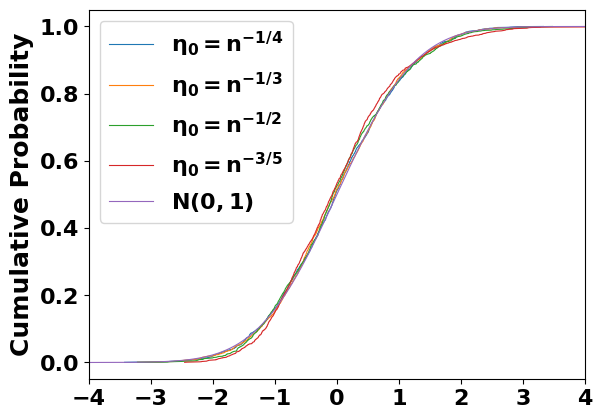

In [66]:
n = 800
R0 = 2000
c = 1
phi = 100
labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


## Figure 5: Empirical power for $T_1^g$-$T_4^g$, $T_1^l$-$T_4^l$

In this section, we compare the power of our global and local statistics

It's too time consuming to run all these tests all the way to 0.4. Also, the domain of the log function will affect how large $ɛ$ can be so the below tests only run from $ɛ=0.01$ to $ɛ=0.2$, then 20 1's are attached behind the results.

### Figure 5(a) global

#### Data generating

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit,random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt





n = 200
R = 1000
c=2
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count



####################################################

K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)


def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    centerc = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for k in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E0 = jnp.linalg.eigvalsh(H)
        Eb = E0 - centerc
        # pn=2*jnp.ones(n)
        # loE=jnp.power(Eb,pn)
        # t = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        t=jnp.sum(Eb)
        T = T.at[k].set(t)
    TestST=np.array(T)
    Normalize_TestST=(TestST-n*(c-1/r)*np.ones(R))/np.sqrt(2+K4)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)
P1=[]
temp=0
phi=100
repeat=20
for s in range(repeat):
    P1.append(power_phi(n,phi,R,c,0.01*s))
print(P1)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, P1)
plt.show()

################################################################


c=1
T = jnp.zeros(R)

pn=2*jnp.ones(n)


def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    centerc = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for k in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E0 = jnp.linalg.eigvalsh(H)
        Eb = E0 - centerc
        pn=2*jnp.ones(n)
        loE=jnp.power(Eb,pn)
        # t = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        t=jnp.sum(loE)
        T = T.at[k].set(t)
    TestST=np.array(T)
    Normalize_TestST=(TestST-(n*(1+c**2-2*c/r+1/phi)+1+K4)*np.ones(R))/np.sqrt(4+4*K4*c**2+8*c**2)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)
P2=[]
temp=0
phi=100

for s in range(repeat):
    P2.append(power_phi(n,phi,R,c,0.01*s))
print(P2)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, P2)
plt.show()



############################################################


t=0.000

n = 200
R = 1000
c=6
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)




import numpy as np
#import jax.numpy as jnp
def stieltjesp(z,phi,r):
    # phi=100
    # r=np.sqrt(phi)
    gammap=r+1/r+2
    gammam=r+1/r-2
    s=(r-1/r-z +np.sqrt((z-gammam)*(gammap-z))*1j)/(2*z/r)
    return s
def stieltjesm(z,phi,r):
    return np.conjugate(stieltjesp(np.conjugate(z),phi,r))
def deriv_stp(z,phi,r):
    m=stieltjesp(z,phi,r)
    mp=(-r*m-np.power(m,2))/(2*z*m+r*z+1-phi)
    return mp
def deriv_stm(z,phi,r):
    m=stieltjesm(z,phi,r)
    mp=(-r*m-np.power(m,2))/(2*z*m+r*z+1-phi)
    return mp

def lsd(x,phi,r):
    return np.imag(stieltjesp(x+0.00001j,phi,r))/np.pi

import scipy.integrate as integrate


def testf(x,phi,r,c):
    return -np.log(x-r-1/r+c)





pn=2*jnp.ones(n)
T1 = jnp.zeros(R)
phi=100
m=int(n*phi)
key = jax.random.PRNGKey(0)
Sigmad = jnp.repeat(jnp.array([1]), m)
centerc = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
center = (jnp.sqrt(phi)+1/jnp.sqrt(phi))*jnp.ones(n)
for k in range(R):
      key, subkey = jax.random.split(key)
      X = random.normal(subkey, shape=(m, n))
      X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
      H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
      E0 = jnp.linalg.eigvalsh(H)
      Eb= E0- centerc
      loE=jnp.log(Eb)
      # tt1=-jnp.sum(loE)
      tt1=-jnp.sum(loE)+jnp.sum(Eb)
      T1 = T1.at[k].set(tt1)




def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1,1+t]), m//2)
    center = (jnp.sqrt(phi)+1/jnp.sqrt(phi))*jnp.ones(n)
    centerc = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
    # objective_grad = jit(grad(objective))
    # T1 = jnp.zeros(R)
    T2 = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for k in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E0 = jnp.linalg.eigvalsh(H)
        Ec= E0- center
        Eb = E0 - centerc
        # pn=2*jnp.ones(n)
        loE=jnp.log(Eb)
        # t = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        # tt1=-jnp.sum(loE)
        tt2=-jnp.sum(loE)+jnp.sum(Eb)
        #
        # T1 = T1.at[k].set(tt1)
        T2 = T2.at[k].set(tt2)
    t1=(c+np.sqrt(c**2-4))/2
    K4=0
    # result = integrate.quad(lambda x: testf(x,phi,r,c)*lsd(x,phi,r), r-2.2,r+2.2)
    # nlsd=n*result[0]

    # print(nlsd+0.5*np.log(1-1/(t1**2))-K4/2/t1/t1)
    TestST=np.array(T2)
    print(jnp.mean(TestST))
    # Normalize_TestST=(TestST-(nlsd+0.5*np.log(1-1/(t1**2))-n/r/c-K4/2/t1/t1)*np.ones(R))/np.sqrt(2/c/c-4/t1/c+2*np.log(t1)-2*np.log(t1-1/t1)+K4/t1/t1)
    Normalize_TestST=(TestST-jnp.mean(T1)*np.ones(R))/np.sqrt((2+K4)*(1-1/t1)+2*np.log(t1)-2*np.log(t1-1/t1)+K4/t1/t1)

    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)

P3=[]
temp=0
phi=100

for s in range(repeat):
    P3.append(power_phi(n,phi,R,c,0.01*s))
print(P3)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, P3)
plt.show()




############################################################


n = 200
R = 1000
c = 1

pn=2*jnp.ones(n)

@jit
def objective(X,Sigma,centerc):
    H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - centerc
    pn=2*jnp.ones(n)
    loE=jnp.power(Eb,pn)
    t = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
    return t


def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    # print(m)
    # print(n)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    Sigma = jnp.diag(Sigmad)
    # print(Sigma)
    centerc = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
    objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for k in range(R):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
        T = T.at[k].set(objective(X,Sigma,centerc))
    TestST=np.array(T)
    Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)


P4=[]
temp=0
phi=100

for s in range(repeat):
    P4.append(power_phi(n,phi,R,c,0.01*s))
print(P4)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, P4)
plt.show()










#### Saved data

In [ ]:
P1=[0.052, 0.9415, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
P2=[0.0485, 0.8425, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
P3=[0.0504, 0.2661, 0.7171, 0.9463, 0.9931, 0.9994, 1.0, 1.0, 1.0, 1.0,  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
P4=[0.053, 0.7945, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#### Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

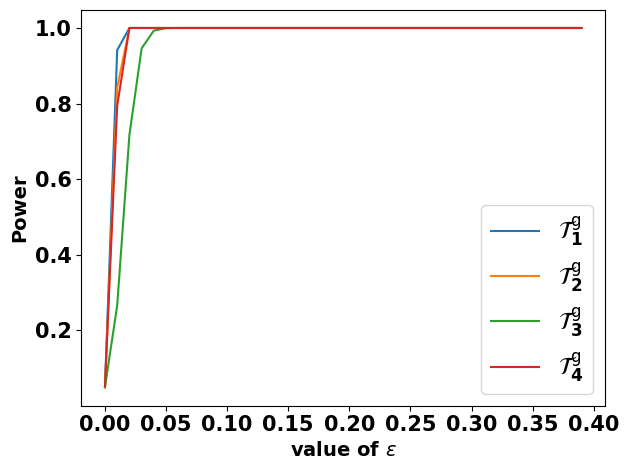

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

# P1=[0.052, 0.9415, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# P2=[0.0485, 0.8425, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# P3=[0.0504, 0.2661, 0.7171, 0.9463, 0.9931, 0.9994, 1.0, 1.0, 1.0, 1.0,  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# P4=[0.053, 0.7945, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#### If u want to plot directly with the newly ran output,
#### remember to add 20 1's behind each vector P1, P2, P3 , P4 to make dimension the same
#### or use repeat=20
repeat=40
#repeat=20
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, P1, label=r'$\mathbf{\mathcal{T}_1^{\mathrm{g}}}$')
plt.plot(x_values, P2, label=r'$\mathbf{\mathcal{T}_2^{\mathrm{g}}}$')
plt.plot(x_values, P3, label=r'$\mathbf{\mathcal{T}_3^{\mathrm{g}}}$')
plt.plot(x_values, P4, label=r'$\mathbf{\mathcal{T}_4^{\mathrm{g}}}$')
# plt.title(r"Power vs. $\varepsilon$")
# Adjusting xlabel, ylabel, title with bold font and larger fontsize
plt.xlabel(r"value of $\varepsilon$", fontweight='bold', fontsize=14)
plt.ylabel("Power", fontweight='bold', fontsize=14)
# plt.title(r"Power vs. $\varepsilon$", fontweight='bold', fontsize=16)  # Uncomment if you want a title

# Making legend text bold and larger
legend = plt.legend(fontsize='xx-large')
for text in legend.get_texts():
    text.set_fontweight('bold')

# Setting bold x-tick and y-tick labels with larger font
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(15)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(15)

plt.tight_layout()
plt.savefig("global.eps")
# Download the figure
files.download("global.eps")

### Figure 5(b) local


#### Data generating

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit,random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

# for t=0: 1: 0.1
t=0.000


n = 200
R = 200
c=1
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]



K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)

eta=1/(n**(1/4))

k=int(n*eta)
R0=2000


#calculate the null distribution
phi=100
m=int(n*phi)
r=jnp.sqrt(phi)

leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(0)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.normal(key, shape=(m, n))
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, 8.1, 8.25))
    # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    t0=jnp.sum(Eb)
    T0 = T0.at[r].set(t0)
TestST0=np.array(T0)
Mean_x=jnp.mean(TestST0)
Variance_x=jnp.var(TestST0)
print(Mean_x)
print(Variance_x)




def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    eta=1/(n**(1/4))
    k=int(n*eta)

    leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for r in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0=np.array(E00)
        Et = jnp.array(extract_elements(E0, 8.1, 8.25))
        # print(E0[-k:])
        Eb = (Et - leftb*jnp.ones(Et.shape))/eta
        t1=jnp.sum(Eb)
        T = T.at[r].set(t1)
        TestST=np.array(T)
    # print(TestST)
    Normalize_TestST=(TestST-Mean_x*jnp.ones(R))/np.sqrt(Variance_x)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)

L1=[]
temp=0
phi=100

for s in range(repeat):
    L1.append(power_phi(n,phi,R,c,0.01*s))
print(L1)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, L1)
plt.show()

#########################################################################


# for t=0: 1: 0.1
t=0.000


n = 200
R = 2000
c=1
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]



K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)

eta=1/(n**(1/4))

k=int(n*eta)
R0=2000


#calculate the null distribution
phi=100
m=int(n*phi)
r=jnp.sqrt(phi)

leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(0)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.normal(key, shape=(m, n))
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, 8.1, 8.25))
    # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    t0=jnp.sum(jnp.square(Eb))
    T0 = T0.at[r].set(t0)
TestST0=np.array(T0)
Mean_x=jnp.mean(TestST0)
Variance_x=jnp.var(TestST0)
print(Mean_x)
print(Variance_x)




def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    eta=1/(n**(1/4))
    k=int(n*eta)

    leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for r in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0=np.array(E00)
        Et = jnp.array(extract_elements(E0, 8.1, 8.25))
        # print(E0[-k:])
        Eb = (Et - leftb*jnp.ones(Et.shape))/eta
        t1=jnp.sum(jnp.square(Eb))
        T = T.at[r].set(t1)
        TestST=np.array(T)
    print(TestST)
    Normalize_TestST=(TestST-Mean_x*jnp.ones(R))/np.sqrt(Variance_x)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    if t==0.9:
      print(Normalize_TestST)
    return(Power)

L2=[]
temp=0
phi=100

for s in range(repeat):
    L2.append(power_phi(n,phi,R,c,0.01*s))
print(L2)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, L2)
plt.show()


################################################################


t=0.000


n = 200
R = 2000
c=1
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]



K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)

eta=1/(n**(1/4))

k=int(n*eta)
R0=200


#calculate the null distribution
phi=100
m=int(n*phi)
r=jnp.sqrt(phi)

leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(0)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.normal(key, shape=(m, n))
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, 8.1, 8.25))
    # print(E0[-k:])
        # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    t0=jnp.sum(np.log(Eb+2*np.ones(np.size(Eb))))+jnp.sum(Eb)
    T0 = T0.at[r].set(t0)

Mean_x=jnp.mean(T0)
Variance_x=jnp.var(T0)
print(Mean_x)
print(Variance_x)





def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    eta=1/(n**(1/4))
    k=int(n*eta)

    leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for r in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0=np.array(E00)
        Et = jnp.array(extract_elements(E0, 8.1, 8.25))
        # print(E0[-k:])
        Eb = (Et - leftb*jnp.ones(Et.shape))/eta
        t0=jnp.sum(np.log(Eb+2*np.ones(np.size(Eb))))+jnp.sum(Eb)
        T = T.at[r].set(t0)
        TestST=np.array(T)
    print(TestST)
    Normalize_TestST=(TestST-Mean_x*jnp.ones(R))/np.sqrt(Variance_x)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    if t==0.9:
      print(Normalize_TestST)
    return(Power)

L3=[]
temp=0
phi=100

for s in range(repeat):
    L3.append(power_phi(n,phi,R,c,0.01*s))
print(L3)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, L3)
plt.show()




##############################################################



# for t=0: 1: 0.1
t=0.000


n = 200
R = 200
c=1
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]



K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)

eta=1/(n**(1/4))

k=int(n*eta)
R0=2000


#calculate the null distribution
phi=100
m=int(n*phi)
r=jnp.sqrt(phi)



leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(0)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.normal(key, shape=(m, n))
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, 8.1, 8.25))
    # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    loE=jnp.power(Eb,2*jnp.ones(np.size(Eb)))
    t0 = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
    T0 = T0.at[r].set(t0)
TestST0=np.array(T0)
Mean_x=jnp.mean(TestST0)
Variance_x=jnp.var(TestST0)
print(Mean_x)
print(Variance_x)




def power_phi(n,phi,R,c,t):
    m=int(n*phi)
    r=jnp.sqrt(phi)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    eta=1/(n**(1/4))
    k=int(n*eta)

    leftb = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-2)
    # objective_grad = jit(grad(objective))
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for r in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]  # Scale the rows of X by the square root of the diagonal elements of Sigma
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0=np.array(E00)
        Et = jnp.array(extract_elements(E0, 8.1, 8.25))
    # print(E0[-k:])
        Eb = (Et - leftb*jnp.ones(Et.shape))/eta
        loE=jnp.power(Eb,2*jnp.ones(np.size(Eb)))
        t1 = n*n*jnp.sum(loE)/jnp.power(jnp.sum(Eb),2)
        T = T.at[r].set(t1)
        TestST=np.array(T)
    # print(TestST)
    Normalize_TestST=(TestST-Mean_x*jnp.ones(R))/np.sqrt(Variance_x)
    # plot_ecdf_and_standard_normal_cdf(Normalize_TestST)
    print(jnp.mean(Normalize_TestST))
    print(jnp.var(Normalize_TestST))
    True_Pos=count_outside_interval(Normalize_TestST,-1.96,1.96)
    Power=True_Pos/R
    return(Power)

L4=[]
temp=0
phi=100

for s in range(repeat):
    L4.append(power_phi(n,phi,R,c,0.01*s))
print(L4)
x_values = [0.01*s for s in range(repeat)]
plt.plot(x_values, L4)
plt.show()










#### Saved data

In [ ]:
L1=[0.06, 0.125, 0.285, 0.705, 0.935, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
L2=[0.053, 0.0685, 0.1935, 0.598, 0.916, 0.991, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
L3=[0.0445, 0.1825, 0.7355, 0.982, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
L4=[0.03, 0.365, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,  1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

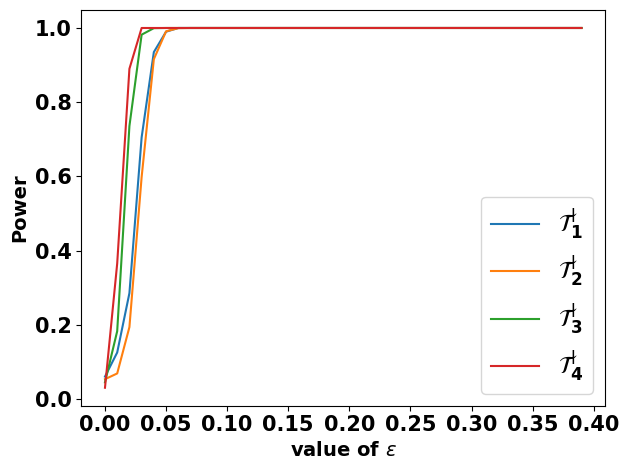

In [ ]:
# L1=[0.06, 0.125, 0.285, 0.705, 0.935, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# L2=[0.053, 0.0685, 0.1935, 0.598, 0.916, 0.991, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# L3=[0.0445, 0.1825, 0.7355, 0.982, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# L4=[0.03, 0.365, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,  1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

from google.colab import files

#### Similar to the global case, if u want to plot directly with the newly obtained output,
#### remember to add 20 1's behind each vector L1, L2, L3 , L4 to make dimension the same
#### or use repeat=20

repeat=40
x_values = [0.01*s for s in range(repeat)]

plt.plot(x_values, L1, label=r'$\mathbf{\mathcal{T}_1^{\mathrm{l}}}$')
plt.plot(x_values, L2, label=r'$\mathbf{\mathcal{T}_2^{\mathrm{l}}}$')
plt.plot(x_values, L3, label=r'$\mathbf{\mathcal{T}_3^{\mathrm{l}}}$')
plt.plot(x_values, L4, label=r'$\mathbf{\mathcal{T}_4^{\mathrm{l}}}$')
# plt.title(r"Power vs. $\varepsilon$")
# Adjusting xlabel, ylabel, title with bold font and larger fontsize
plt.xlabel(r"value of $\varepsilon$", fontweight='bold', fontsize=14)
plt.ylabel("Power", fontweight='bold', fontsize=14)
# plt.title(r"Power vs. $\varepsilon$", fontweight='bold', fontsize=16)  # Uncomment if you want a title

# Making legend text bold and larger
legend = plt.legend(fontsize='xx-large')
for text in legend.get_texts():
    text.set_fontweight('bold')

# Setting bold x-tick and y-tick labels with larger font
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(15)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(15)

plt.tight_layout()


plt.savefig("local.eps")

# Download the figure
files.download("local.eps")

## Figure 6: ROC

In this section, we display the ROC curve of our proposed tests compared with some of the existing literature.

Be cautious, this part of the simulation is extremely time-consuming due to the fact that around 10 methods are replicated. If you want to replicate the results here, use smaller $n$, $p$ or be prepared for the longer hours (days).

But if you only want to try our method, comment out the other lines and it will not take long.

### Figure 6(a) $\varepsilon=0.03$

#### Data generating

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def perform_test(TestFunc, Sigmad, m=2000, n=40, num_matrices=1000):
    p_values0 = []
    p_values1 = []

    for _ in range(num_matrices):
        data0 = np.random.normal(0, 1, (m, n))
        p0 = TestFunc(data0.T)
        if p0 is not None:
            p_values0.append(p0)
        else:
            p_values0.append(0)
        del data0

        data0_prime = np.random.normal(0, 1, (m, n))
        data1 = data0_prime * np.sqrt(Sigmad)[:, None]
        p1 = TestFunc(data1.T)
        if p1 is not None:
            p_values1.append(p1)
        else:
            p_values1.append(0)
        del data1, data0_prime

    return np.array(p_values0), np.array(p_values1)
from sklearn.metrics import roc_curve, auc

def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # # plot ROC curve
    # # Use string formatting to control the presentation of AUC in the legend
    # legend_text = "{:<16} ({:0.2f})".format(label, roc_auc)

    # # plot ROC curve
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=legend_text)

    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'({roc_auc:.2f}){label} ')

    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label}  ({roc_auc:.2f}) ')
    # label_padded = label.ljust(15)
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label_padded} (AUC: {roc_auc:.2f})')


import matplotlib.pyplot as plt
# Initialize the plot
plt.figure()

# Set parameters
# m = 20000
# n = 200
m = 10000
n = 100
num_matrices = 100
t = 0.03
Sigmad = np.repeat(np.array([1, 1+t]), m//2)

# Perform Test1 and plot its ROC curve
p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test1)
# print(p_values1_test1)
# Perform Test2 and plot its ROC curve
p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test2)
# print(p_values1_test2)
p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test3)
# print(p_values1_test3)
p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test4)
# print(p_values1_test4)

p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test5)
# print(p_values1_test5)
p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test6)
# print(p_values1_test6)
p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test7)
# print(p_values1_test7)
p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test10)
# print(p_values1_test10)
generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',lw=2, linestyle='--', alpha=1)
# print(p_values0_test8)
# print(p_values1_test8)
p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',lw=2, linestyle='--', alpha=1)
# print(p_values0_test9)
# print(p_values1_test9)

p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test11)
# print(p_values1_test11)















# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='dotted')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# # ... [Your other code]

# # Setting bold x-label and y-label
# plt.xlabel('False Positive Rate', fontweight='bold')
# plt.ylabel('True Positive Rate', fontweight='bold')
# plt.title('Receiver Operating Characteristic', fontweight='bold')

# # Setting the legend and then making its text bold
# legend = plt.legend(loc="lower right", fontsize='small')
# for text in legend.get_texts():
#     text.set_fontweight('bold')

# # Setting bold x-tick and y-tick labels
# ax = plt.gca()  # Get current axis
# for label in ax.get_xticklabels():
#     label.set_fontweight('bold')

# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

# plt.show()


#### Saved data

In [ ]:
p_values0_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test3=[0.10649398596222359, 0.49675704714787583, 0.42494716161966417, 0.45457835501440225, 0.4787439766908581, 0.013215988597898742, 0.1414530969311475, 0.48495639947432956, 0.02582392785433496, 0.4407421808435992, 0.12349797763114911, 0.33269332566858933, 0.2292598781168942, 0.15737790399989127, 0.36093303034724555, 0.4173265535661279, 0.14435537308565727, 0.24031534068207616, 0.42002733728080344, 0.31896815880971485, 0.43816300699083355, 0.4115980932783865, 0.11018660315514905, 0.12971695236277858, 0.33783193556306435, 0.42421539307020606, 0.40385735798604616, 0.4484031908069429, 0.3542228641874393, 0.30943675372692514, 0.044178188685011, 0.09699761295616827, 0.2158210353933313, 0.3821974716041293, 0.02661390447440537, 0.07595325238870454, 0.49689473751698476, 0.3696746306897569, 0.1459303573755062, 0.08997500223453303, 0.28926150382392346, 0.38317796815764105, 0.40368544914754434, 0.0268723310682093, 0.4760939835235103, 0.06287126798206999, 0.450784110480146, 0.39314631258601795, 0.45376934443806827, 0.19632672057812872, 0.40659032320449673, 0.15318225237433047, 0.4310220669384507, 0.41477480969580094, 0.08706513178852804, 0.38167657332229565, 0.46892110530131415, 0.02139129887009361, 0.2726756122358369, 0.06035829138323501, 0.07967579444454465, 0.4031867411997979, 0.15687511989705982, 0.2831055115918487, 0.4831907985086793, 0.43569548943569514, 0.2217052301182365, 0.06665469347812913, 0.21921603655674615, 0.32610768480893926, 0.4251740116704178, 0.44372009625522746, 0.3059600417621674, 0.09067688638308868, 0.41034716278551353, 0.34717098323375906, 0.39233117883487245, 0.07791114094519103, 0.35324423873807, 0.4697451062061515, 0.28141915562451736, 0.2477143675116844, 0.23125174720600516, 0.47700879989412903, 0.050259673425856244, 0.367364417549358, 0.35252805114274266, 0.23669765535174392, 0.4433476830128592, 0.007553808314427757, 0.20112504224258043, 0.18217903155189163, 0.1852780286565563, 0.17648110288710472, 0.24148128709536776, 0.19676087606478632, 0.03773190422388806, 0.40124701961361064, 0.37088851148339985, 0.4241129313121983]
p_values1_test3=[0.11154053506795492, 0.20995941187124, 0.3154868995181036, 0.1561408798999082, 0.28585821254293187, 0.38814761739090375, 0.3755656633387692, 0.1500794806291572, 0.379218518987647, 0.022475140091637313, 0.019253261246506503, 0.0999804416682728, 0.23858050768832206, 0.44772922768212375, 0.21084447057019684, 0.1050948765355344, 0.3629014430879991, 0.1732925404814567, 0.43030550514602617, 0.21434361740545782, 0.23640931578604185, 0.40244492468127446, 0.24159327966977784, 0.0658616821197553, 0.3562871641948312, 0.43338617665584345, 0.2259527882228124, 0.26368012737724666, 0.26323275604726304, 0.14395584477239431, 0.18348851332014138, 0.22641971067306077, 0.18762738458175954, 0.4508903697153319, 0.022079770452978043, 0.22481925956755733, 0.4969083471342921, 0.36426161984719374, 0.10716536832853296, 0.4808119856712465, 0.42212975076920467, 0.2859312882510727, 0.2866956815613727, 0.2873842508316994, 0.38501090231471513, 0.1272301478389235, 0.15143717385058897, 0.025640701554512924, 0.4924814683047567, 0.41417886713239016, 0.06981582881601422, 0.40380941101646806, 0.06762521794623089, 0.17349008615359796, 0.01778410498329963, 0.260240143888839, 0.18181442166632555, 0.22126873055767948, 0.4085023363078685, 0.41261739044623347, 0.07956543556500129, 0.028232968947804138, 0.43889558065188616, 0.2705512725350324, 0.03769200390187066, 0.35596526864128575, 0.31425631921170305, 0.24194822463991295, 0.31582823560492534, 0.09847216018369664, 0.032198948839565866, 0.3623747916688699, 0.1908272925776775, 0.30189206777235267, 0.45635979079179334, 0.22875904307103556, 0.44117067446420055, 0.017987801740763643, 0.3387153890556607, 0.014706401255569879, 0.48526296156502025, 0.03709912281148653, 0.020395775252845527, 0.2383070554121246, 0.3397297137995754, 0.46695147339381815, 0.3813987424167702, 0.40038845214226115, 0.015538105291939996, 0.24955971526436027, 0.21323864579435303, 0.14176752255910774, 0.014779815344248548, 0.06686446430086368, 0.16030183213928362, 0.4594864421548648, 0.45148755139702146, 0.05549505500974983, 0.27565880006938714, 0.33553837652150353]
p_values0_test4=[0.1688234160651234, 0.42269535799171143, 0.24934747662533985, 0.36847688386364275, 0.18112952187914377, 0.35596926224691017, 0.18237792073263903, 0.326499868124805, 0.4975603702217827, 0.025030639443260894, 0.37072773039279194, 0.21564365486219006, 0.053048571169186154, 0.282768220784428, 0.2684190820411907, 0.048803531491052876, 0.060576937799170394, 0.11731799847123303, 0.4996100512011642, 0.40677608131435106, 0.028478691247751486, 0.11228479965230309, 0.477794852667791, 0.10077706487803029, 0.13121161709695484, 0.4244430998811609, 0.07116989333702561, 0.0027977755889020406, 0.4765086700587582, 0.32319230996338144, 0.428271401027293, 0.3233883545734635, 0.1945749748169212, 0.21384805973535836, 0.22303745630352756, 0.13719067817333652, 0.25401759011321845, 0.12477316737045396, 0.3109979506372422, 0.09827622735879937, 0.3468355324743536, 0.34376424723662724, 0.4656598539515122, 0.2739959049238684, 0.35061273096858847, 0.49785622521889983, 0.42516601228005757, 0.3012470473888086, 0.14462097661974527, 0.00864711383968586, 0.08551124822670442, 0.03754692154642503, 0.08785795069378977, 0.48113034449209624, 0.3403327217893217, 0.20868218560912455, 0.007408436882010649, 0.36639478672281334, 0.15234912090911712, 0.05998972366989275, 0.20985371847611334, 0.385201960772819, 0.30565785444336724, 0.24911285457177845, 0.3465173782009443, 0.05814176479936117, 0.2689036838425988, 0.3463146691241955, 0.3998246657518194, 0.04796070751320858, 0.05187147536800285, 0.06509966835911107, 0.4863362926281273, 0.48057685143304585, 0.023091246852171232, 0.35807259121297785, 0.20485474511681168, 0.406355774717132, 0.46975298706936675, 0.13065502277883834, 0.19907732321369864, 0.49405087753594534, 0.40542398826985937, 0.3491918677852879, 0.00741218261905463, 0.4511594717595764, 0.32792332085561304, 0.31674525121254415, 0.07254584980344214, 0.19932064308887387, 0.1379803939599844, 0.29556717628172724, 0.35122494627669565, 0.04020132253735531, 0.15373948771497337, 0.05241745733050274, 0.005377771162731193, 0.13641680693332692, 0.3162320219763701, 0.3899027218203135]
p_values1_test4=[0.4475421592608453, 0.3330957158848461, 0.4332360206516379, 0.10601366331862994, 0.3641545297479001, 0.4407840463773215, 0.22128823506198825, 0.453346465135562, 0.21177084258039947, 0.4743498346496512, 0.13384984758467255, 0.10762696622798562, 0.15822409072025367, 0.044296237832879726, 0.17014281868882675, 0.22567295620633698, 0.3209302668825038, 0.06547236620840757, 0.012368129814959938, 0.12078727548932955, 0.10556410535835625, 0.255767815642846, 0.19310515999159517, 0.20497598276035367, 0.3683923311468361, 0.07059464189259401, 0.47074234305672735, 0.00576243379960073, 0.43200548853874843, 0.3973512510858579, 0.05944665756350498, 0.41509535482309423, 0.26684325344244164, 0.37409491431526287, 0.4079714815401265, 0.2520286468752799, 0.4898312162913333, 0.29664134405322473, 0.1313954578794948, 0.1529633387602891, 0.09206338415009063, 0.2141069798403421, 0.4336430487730577, 0.1359710814952324, 0.09233756698726503, 0.10857705725264455, 0.3486200198990248, 0.23084444894193346, 0.3504658463623871, 0.17716972275881315, 0.34224821775302616, 0.19110039058720585, 0.13969969054757003, 0.21105557893073257, 0.3020768194206247, 0.3646841808800422, 0.3224118056593338, 0.16318057614156833, 0.3762502513910928, 0.2689166682542039, 0.4903939515159631, 0.2090209868089179, 0.016148337877228358, 0.20545028313643288, 0.4587839931535431, 0.4579292434833009, 0.14463642544005584, 0.43283394094422356, 0.2848047535514435, 0.039902844544402294, 0.02384105760563071, 0.4302272812434744, 0.275357408977293, 0.31960602477646016, 0.08244843139107272, 0.020077270055536722, 0.10174744366817057, 0.23177130263359924, 0.30343808263299754, 0.09028331794087818, 0.3130595552112897, 0.05997982272849922, 0.13770718945721527, 0.17863101218853106, 0.024131512455295767, 0.22939532155562103, 0.28135360918151786, 0.16107531185176238, 0.23969211470272112, 0.13875604860186463, 0.2873225338212029, 0.30257755322195123, 0.4769937922026981, 0.4343064169093096, 0.4271976397943549, 0.39653374414687437, 0.2523970711267156, 0.15532645394384514, 0.348708546658555, 0.4108834414252106]
p_values0_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test6=[0.307222716051598, 0.30814709887983205, 0.46825615736814874, 0.06460483479983525, 0.0551365044548745, 0.37758934414073253, 0.3597447572034058, 0.13795042199442575, 0.2527982352954543, 0.22203721709778723, 0.4237534250076318, 0.08363319905609534, 0.170498781882788, 0.23071537150763244, 0.39967074282071346, 0.36717192037395874, 0.3732528025173256, 0.27367911702946657, 0.2434176640737673, 0.21667909965889554, 0.43988856351126204, 0.19157319566078201, 0.15748702559427785, 0.3609649959629556, 0.42384871892280307, 0.4528924679913383, 0.3350294114046162, 0.30204295877025666, 0.45063950603503167, 0.02668698297053307, 0.41057073360916385, 0.408621558178459, 0.442852002151658, 0.3355181484232763, 0.19609917821700074, 0.4085609928645375, 0.2804840322046489, 0.30738115556498413, 0.3288759137331426, 0.35312249349708835, 0.4908072165718259, 0.16088650891269152, 0.21828081148928302, 0.16610277242164706, 0.029297582111497023, 0.4719273810055632, 0.48125427377758256, 0.4484872573668639, 0.26451728155975107, 0.3828115305966394, 0.10211974683404124, 0.15421792780621524, 0.026584193443317417, 0.4648095465766593, 0.23015797611355993, 0.08092582198339227, 0.24677446729805586, 0.38712147309408185, 0.09222564928188248, 0.0034526275853919985, 0.3518089067528619, 0.09216552719881377, 0.2852050004190242, 0.19714176159420393, 0.33175111634131704, 0.4165308454149661, 0.4465965628962536, 0.4869781159953982, 0.31805356721070444, 0.46358420595426264, 0.18894210354959584, 0.29534766529739565, 0.47791628322111024, 0.4604984312366399, 0.058113389688391304, 0.07936009095644359, 0.19500811028033516, 0.22519234463416093, 0.00111190087726587, 0.4765503411370188, 0.06103964980753629, 0.4137906294972751, 0.21560543648891894, 0.21524231999617993, 0.16286357123724193, 0.07682022968586977, 0.4242294536625443, 0.3126069524416796, 0.19462967593319402, 0.23144179185142577, 0.10193801718092699, 0.27269072167814956, 0.20988925207260944, 0.1512295908040524, 0.07070503979605713, 0.007150175658470315, 0.47024549463813725, 0.36197499775247133, 0.25768949183637324, 0.4667060259525455]
p_values1_test6=[0.4606083323121061, 0.007076640027978365, 0.44851961358727754, 0.04713634400469424, 0.11346780719914817, 0.42064028722324787, 0.2804105160964082, 0.45709450480772396, 0.020603041885520645, 0.14754860610326892, 0.0899540970054229, 0.3059352530660432, 0.2705297173732837, 0.1859378640927407, 0.11320629951166761, 0.42769471143400406, 0.21863356331487727, 0.19024232579844624, 0.46485031610413075, 0.47406947797556953, 0.22439361125072055, 0.36238601532928605, 0.06880102100806429, 0.21715738695715725, 0.40339036372492576, 0.47687713986878666, 0.37819292785243397, 0.23383617014694125, 0.367157586128005, 0.45637070066665386, 0.3786543730699218, 0.3330360526722962, 0.4421794457734801, 0.3867121223523371, 0.18331252038227186, 0.011390986881089749, 0.17605290684895558, 0.09399630533221681, 0.43373341086134953, 0.25177991227901086, 0.06637166531648464, 0.13758795396272516, 0.23890905184304045, 0.4499482427484942, 0.48830479541700456, 0.41778229696955194, 0.10233299562874243, 0.3164595593997146, 0.2701477286900903, 0.38639108925040244, 0.14700170493961662, 0.2924862541118879, 0.08811438462721388, 0.27981054052119303, 0.033773735002816774, 0.13036252837924, 0.04290205422488169, 0.1850263863177568, 0.001856268858955512, 0.04342707783772548, 0.15719689056179642, 0.1593095732322014, 0.4563464430102119, 0.33075077286616783, 0.263331331983242, 0.40754528080645136, 0.17789396210212283, 0.45148164777108557, 0.05868817441834184, 0.20871897789338456, 0.3059250923050083, 0.04711898983448337, 0.05452264928803219, 0.2670563180641422, 0.07760649913295448, 0.03473103159200963, 0.41351214329450736, 0.0001987012261517318, 0.12157181167958286, 0.06771930863500997, 0.10970211761006332, 0.36654200641290213, 0.14736715869500894, 0.06886141989580186, 0.05194188574467662, 0.30673646317834, 0.19240513772548962, 0.031331643254342234, 0.41945213652608204, 0.17642166282822447, 0.39703956045554833, 0.25911631939574364, 0.12751521314214642, 0.005163401590171035, 0.25654398530599465, 0.1190977362896476, 0.40959771869670514, 0.34674414331158365, 0.4775604121279309, 0.24847156126682712]
p_values0_test7=[0.0, 0.0, 0.0, 0.0, 0.0, 1.2212453270876722e-15, 0.0, 0.0, 0.0025091604857614414, 0.0, 0.4901214947531114, 0.0, 0.0, 0.006060035881728543, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.031013307070346e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 5.296876642857384e-07, 0.001000939843175841, 0.0012878611657678452, 0.0, 1.1243735120736176e-07, 0.0, 1.1723955140041653e-13, 0.0, 8.925432564144131e-07, 0.0, 0.22344097790450723, 0.0, 0.0, 0.0012252534068039056, 0.0, 0.0, 0.0019548295493759804, 0.0, 0.0, 2.1094237467877974e-15, 0.0, 0.0, 0.0, 0.0, 0.1922105040017973, 0.0, 0.0, 0.0, 0.03126297862159588, 0.0, 0.00018510237718860623, 0.0, 0.0, 0.0, 0.0, 0.0006534266306489345, 3.3486335926369293e-10, 0.0, 0.0, 0.0, 0.0, 0.0, 4.698280653414599e-10, 0.0, 0.0009354193859706372, 0.0, 1.3214984662113238e-12, 0.0, 0.0, 5.707908510288462e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000822815661509102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test7=[2.4547142096764674e-11, 0.0, 4.0190073491430667e-14, 0.0, 0.0, 0.0, 0.01340294812313303, 0.0, 0.0, 1.0917293519208116e-06, 0.023315961239897987, 0.00046132911848573155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4017133666915633, 0.011004711427056058, 0.0, 0.0, 0.0, 0.0, 0.0005493849384976546, 0.0, 0.0, 0.0, 0.02295108334614293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3846262418073446, 0.0, 0.007100416887644401, 0.0, 0.0, 0.0, 0.07356193634541353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21623751015607673, 0.0, 0.0, 0.0, 0.0460178455353315, 0.1743869718934975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.053631912552923e-05, 0.0, 0.0, 0.0, 0.0, 1.4178469509573688e-10, 0.0, 1.5647702424903542e-06, 2.229731732583673e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9279911828439253e-12, 0.0, 0.0, 3.128219052561665e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test8=[0.9774664234370511, 0.19358334582183812, 0.48917930433742685, 0.7484328524808119, 0.7198448763809364, 0.7105619645880754, 0.4088078557894921, 0.34808634234440605, 0.5859629961077106, 0.9558657197450151, 0.7334071212922071, 0.30156881526447554, 0.6918549734775221, 0.5350919375179501, 0.6954532033729453, 0.7962529922119905, 0.25966243246147425, 0.20295255963192904, 0.6167449270212582, 0.959557346829125, 0.006850505370554982, 0.036101928912106285, 0.5787341415395568, 0.17484883255359351, 0.46377041936664454, 0.9947189368542635, 0.6788493666612949, 0.1556824354212225, 0.45095218898762424, 0.10889833690150641, 0.2779094056157141, 0.9718480634030691, 0.3799254856940568, 0.7176288061115992, 0.7702693686156792, 0.9643958022642289, 0.5164982946986822, 0.6713967753606125, 0.8672034387829224, 0.8326890833514544, 0.8334800251221979, 0.09227091363363815, 0.10883522177213378, 0.7718176033467867, 0.7724897308493475, 0.7034999994708078, 0.17068754982596301, 0.817894027736517, 0.5327043020264077, 0.46530145416355273, 0.9640607936221619, 0.12600199714289606, 0.4159471040582503, 0.1913192009240139, 0.1715502369386761, 0.04054745740082444, 0.9904713288501468, 0.9379387433869901, 0.5682932300858314, 0.746756183193271, 0.7467963399912607, 0.4968377385915166, 0.3680973888028234, 0.548285732629473, 0.2631260588339197, 0.06568800315199907, 0.44556417970243767, 0.17279801701638364, 0.10033879647356048, 0.6143664492089298, 0.1357558084582493, 0.41261119530842505, 0.5803488272441779, 0.7463945757992294, 0.9869482840389345, 0.8040993023401823, 0.6335599752320298, 0.6886721089060104, 0.7456727001458634, 0.5973113507749512, 0.7743958168644163, 0.6471598322960799, 0.4019365483649311, 0.531649871383189, 0.9484202029730684, 0.9795489970277478, 0.9329204662659738, 0.8540487409934685, 0.13219437098245113, 0.8079439001955138, 0.35093986936433996, 0.2671148210142609, 0.42019901179513397, 0.0026232402133588018, 0.7476493832543871, 0.3285199169098916, 0.2879998548637872, 0.6671838838845048, 0.8279178435736907, 0.4439588290381522]
p_values1_test8=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.881784197001252e-16, 0.0, 0.0, 0.0, 1.5019097077129118e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test9=[0.9435332964229168, 0.39305824209055795, 0.44285490808970307, 0.36131487295672216, 0.25430324305455265, 0.12455551098034245, 0.26172683768391103, 0.8229333582970033, 0.12102491871809073, 0.2350384455928327, 0.6653733494754799, 0.49173139278498645, 0.6530737417699441, 0.6126236162047021, 0.6563820676588146, 0.4434649364838472, 0.9346320479091754, 0.8225539651763152, 0.131673370729267, 0.024579510298797125, 0.8634400313810109, 0.8803930391554466, 0.5535904182713016, 0.05828708848251374, 0.8081048111466955, 0.15829389640113956, 0.7887405371059664, 0.528609537744883, 0.391420874779953, 0.5203596638184322, 0.4559880803569738, 0.6759557366910722, 0.10131025855551634, 0.7445571417180943, 0.7979234204528507, 0.8384040862278164, 0.8706668159827962, 0.8646027008625232, 0.43593383500534344, 0.7780762560340493, 0.7131389818005189, 0.008537352246384966, 0.557598353360055, 0.1434196141815991, 0.22221609901763717, 0.2780434619553054, 0.12639371769287933, 0.7468746264042947, 0.15737365324321573, 0.6006252552861526, 0.6921822887497715, 0.27593105985197575, 0.5480849527238356, 0.23861645159123723, 0.8481880507376309, 0.12211222525229659, 0.33948993828300833, 0.638928378745987, 0.785529706827905, 0.9817751145496614, 0.9625729102031564, 0.9396686711603202, 0.7070556289824508, 0.9564793504193954, 0.2948482541948261, 0.4142498637512797, 0.6448362405639081, 0.929610427634872, 0.8279632371320396, 0.10045899548329773, 0.1663712844683971, 0.3254719367089831, 0.05788278072131137, 0.5638893523649626, 0.779709590674015, 0.5342071738370637, 0.21857587851985105, 0.6131855868867024, 0.8451493967544761, 0.9672995360025187, 0.09918780561022889, 0.9625967994449154, 0.27913880929385604, 0.7174030173089165, 0.8310639964481532, 0.28008387815510516, 0.9754444760885839, 0.5374608589735239, 0.3204719275601633, 0.8462605045989386, 0.3327873013994269, 0.5907989974512795, 0.14717013450124927, 0.20278805773886455, 0.4024895114150575, 0.7050693872670135, 0.29490848293247685, 0.3981379460939518, 0.517143831648802, 0.6718606507587035]
p_values1_test9=[0.07039294204031754, 0.1164076389642581, 0.8786374876329686, 0.009544007264397303, 0.044999062088537656, 0.06228753285634436, 0.028521120436967307, 0.045052548671586035, 0.011685896471893331, 0.01373056633607228, 0.05115724740559813, 0.0074782847404955, 0.033607387847615966, 0.012657904556399702, 0.1783080668890873, 0.0014879135470073912, 0.20150598783127371, 0.3827375311308687, 0.5726141854758495, 0.027841214735923048, 0.013455978349000919, 0.5694323863665991, 0.011962287461888987, 0.1848055918430349, 0.1549374893843718, 0.023148138154342357, 0.08140701709626508, 0.05312033757678947, 0.7105521462254472, 0.8582901410641017, 0.06139092356913678, 1.256423388107386e-05, 0.5017799763903261, 0.17103096402718765, 0.04880282887002352, 0.029943465542798364, 0.1943908781260113, 0.2095529446859956, 0.3517946189671659, 0.07600445912117526, 0.020172879815893108, 0.01694865130675227, 0.04097546559853393, 0.10056948416292455, 0.02572233302057314, 0.24644008568605846, 0.04492305848333622, 0.05440500049765018, 0.04104689377348314, 0.7069644085600917, 0.0025284713984163876, 0.07586417952853175, 0.021046000633547113, 0.036440285247616444, 0.0013015223176793267, 0.0027874496779196622, 0.4492260197507958, 0.08431234127347698, 0.3633575933319073, 0.48605075541413933, 0.43756767836331045, 0.0017894226621462117, 0.009752095772410652, 0.8751518106468659, 0.041665723712704716, 0.9802892415504765, 0.16185622768403007, 0.5290936062378921, 0.03653425521502296, 0.5161748139679576, 0.4889570357928812, 0.0014203726055153076, 0.6733917754725534, 0.7224774999768151, 0.1548999263079216, 0.00654921909099393, 0.3874031354297416, 0.4760519593145838, 0.004651874754067364, 0.350833217942891, 0.35378219208282724, 0.2761352299652571, 0.026161281313607176, 0.161368726981316, 0.0417797621241871, 0.07798925547123847, 0.837497849994586, 0.0546331320347182, 0.04629416582883672, 0.02392672052100564, 0.37072433235246827, 0.033199269257943476, 0.32482814268420324, 0.23922156314428378, 0.15944713045691294, 0.9799659975493, 0.037995856092295055, 0.03981486219669517, 0.2031674904636409, 0.3461023336437392]
p_values0_test10=[0.9774664234370511, 0.19358334582183812, 0.48917930433742685, 0.7484328524808119, 0.7198448763809364, 0.7105619645880754, 0.4088078557894921, 0.34808634234440605, 0.5859629961077106, 0.9558657197450151, 0.7334071212922071, 0.30156881526447554, 0.6918549734775221, 0.5350919375179501, 0.6954532033729453, 0.7962529922119905, 0.25966243246147425, 0.20295255963192904, 0.6167449270212582, 0.959557346829125, 0.006850505370554982, 0.036101928912106285, 0.5787341415395568, 0.17484883255359351, 0.46377041936664454, 0.9947189368542635, 0.6788493666612949, 0.1556824354212225, 0.45095218898762424, 0.10889833690150641, 0.2779094056157141, 0.9718480634030691, 0.3799254856940568, 0.7176288061115992, 0.7702693686156792, 0.9643958022642289, 0.5164982946986822, 0.6713967753606125, 0.8672034387829224, 0.8326890833514544, 0.8334800251221979, 0.09227091363363815, 0.10883522177213378, 0.7718176033467867, 0.7724897308493475, 0.7034999994708078, 0.17068754982596301, 0.817894027736517, 0.5327043020264077, 0.46530145416355273, 0.9640607936221619, 0.12600199714289606, 0.4159471040582503, 0.1913192009240139, 0.1715502369386761, 0.04054745740082444, 0.9904713288501468, 0.9379387433869901, 0.5682932300858314, 0.746756183193271, 0.7467963399912607, 0.4968377385915166, 0.3680973888028234, 0.548285732629473, 0.2631260588339197, 0.06568800315199907, 0.44556417970243767, 0.17279801701638364, 0.10033879647356048, 0.6143664492089298, 0.1357558084582493, 0.41261119530842505, 0.5803488272441779, 0.7463945757992294, 0.9869482840389345, 0.8040993023401823, 0.6335599752320298, 0.6886721089060104, 0.7456727001458634, 0.5973113507749512, 0.7743958168644163, 0.6471598322960799, 0.4019365483649311, 0.531649871383189, 0.9484202029730684, 0.9795489970277478, 0.9329204662659738, 0.8540487409934685, 0.13219437098245113, 0.8079439001955138, 0.35093986936433996, 0.2671148210142609, 0.42019901179513397, 0.0026232402133588018, 0.7476493832543871, 0.3285199169098916, 0.2879998548637872, 0.6671838838845048, 0.8279178435736907, 0.4439588290381522]
p_values1_test10=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.881784197001252e-16, 0.0, 0.0, 0.0, 1.5019097077129118e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test11=[0.1887616675799313, 0.9296974959386481, 0.3295736189173657, 0.43460864737953697, 0.5085032820771471, 0.7680384507754916, 0.031124306144526548, 0.48554660520105886, 0.9779473184622516, 0.991167052751158, 0.01177299761012729, 0.5901585541619996, 0.8466863288740261, 0.4065597098078526, 0.9542591175441038, 0.23734533581034456, 0.8497131397206645, 0.6038157309522725, 0.14519681945526375, 0.38945849551678524, 0.22762421688590662, 0.1892392645114498, 0.7441282722234197, 0.01433648622847472, 0.7728579253071688, 0.8383333008401799, 0.7557514005528754, 0.23962545443864913, 0.9412933042929739, 0.8867022717119271, 0.5614138188995195, 0.39478234722731687, 0.5512746629819376, 0.041154769360477905, 0.9058217657114143, 0.8204541207381499, 0.049782289083723175, 0.9080261172705864, 0.26672934786742, 0.82915990766621, 0.5504110027422537, 0.840285672119929, 0.22610667084034874, 0.04181191249094751, 0.69188381904705, 0.09623240308159908, 0.37596296787292305, 0.7675173580837997, 0.00013222435477255878, 0.7141645861858148, 0.08769848644420764, 0.961098387278567, 0.14773627892632923, 0.6787033250206804, 0.14137860808156932, 0.8765479334556543, 0.8846277929202588, 0.5111137199873985, 0.13807768605808612, 0.9589220222823582, 0.4488913852181904, 0.6938829184045994, 0.5677957815728405, 0.8401623433638292, 0.584899311508714, 0.8568405882583925, 0.3643061104854317, 0.11037081000670979, 0.8155504175991735, 0.22904599637933698, 0.37967264401648393, 0.4002968213179945, 0.9202305641069413, 0.3740842536717519, 0.683106011345572, 0.5675649058236045, 0.993372886219785, 0.15309155237614114, 0.8050586384014276, 0.11441791701801796, 0.8488044968212916, 0.40487613425360713, 0.6664364793295876, 0.34431662541246455, 0.14084206241989272, 0.9772980371356879, 0.8819236125688299, 0.38170470894351594, 0.29813650274322434, 0.5191860547870957, 0.45205167320955497, 0.9012763736507987, 0.10685963463046666, 0.5790638704222757, 0.4381606611583977, 0.9885926712806683, 0.17891799966666433, 0.6295528970752207, 0.4413961199141472, 0.34543121286988265]
p_values1_test11=[0.5015141259906777, 0.7368909681570839, 0.9849452522317315, 0.11107886907953013, 0.09503049575653444, 0.5260016135532517, 0.8869129675226148, 0.6006911795680094, 0.27653172119997804, 0.8270763144374389, 0.3952760161482707, 0.9859027193734979, 0.934467867128002, 0.36632226429000103, 0.7848157711365613, 0.45493551352785033, 0.9835359837551085, 0.8799459388541548, 0.39641844016205763, 0.442153404368514, 0.26483416439023166, 0.3278657942286314, 0.8676226351389074, 0.3761625753325246, 0.8658602712911185, 0.7204653558740923, 0.24637879687042474, 0.26229370162593035, 0.9825537720838784, 0.316499620493389, 0.24878023980148, 0.6191760360643221, 0.4262110337075531, 0.033197141405008956, 0.9759536712039727, 0.5904112200584577, 0.7033465439112461, 0.7277772066558204, 0.7036077326622601, 0.6165899864758195, 0.21603496695635438, 0.317747264508653, 0.8901024769443857, 0.13816565277228543, 0.007330432154567079, 0.05570750751349207, 0.6328643395569911, 0.6996964055228527, 0.15026947092084808, 0.6925552971272619, 0.576058210642246, 0.7996715075141754, 0.5143120890628459, 0.36181399327458497, 0.08799790299093058, 0.7927245851016222, 0.24942299011568103, 0.6499580443436233, 0.551189747266047, 0.6981258968453847, 0.6503874828644713, 0.2677645506661337, 0.7095818565294674, 0.3432599619718548, 0.6905723546612987, 0.1709015759043928, 0.7925238202983302, 0.7052515516502162, 0.1536547777889845, 0.1824158981599715, 0.946487652490001, 0.9202383856765923, 0.6848772589253769, 0.7190193631064203, 0.2707926706923742, 0.6509275156564001, 0.8197494279134747, 0.338018108930525, 0.5833061184305368, 0.7786715159544855, 0.020741715682890627, 0.6263444461223961, 0.9405210132617736, 0.7337784045954432, 0.887697222310907, 0.8657270197610007, 0.01414645804575021, 0.27073980426077693, 0.8725327873999045, 0.44524317837638616, 0.09496763140470788, 0.6593358636462963, 0.497823044338916, 0.20059627926742518, 0.6427979475578454, 0.25899215546372156, 0.3100872215998649, 0.6408420992393871, 0.1998623210048902, 0.8064130151700284]

#### Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

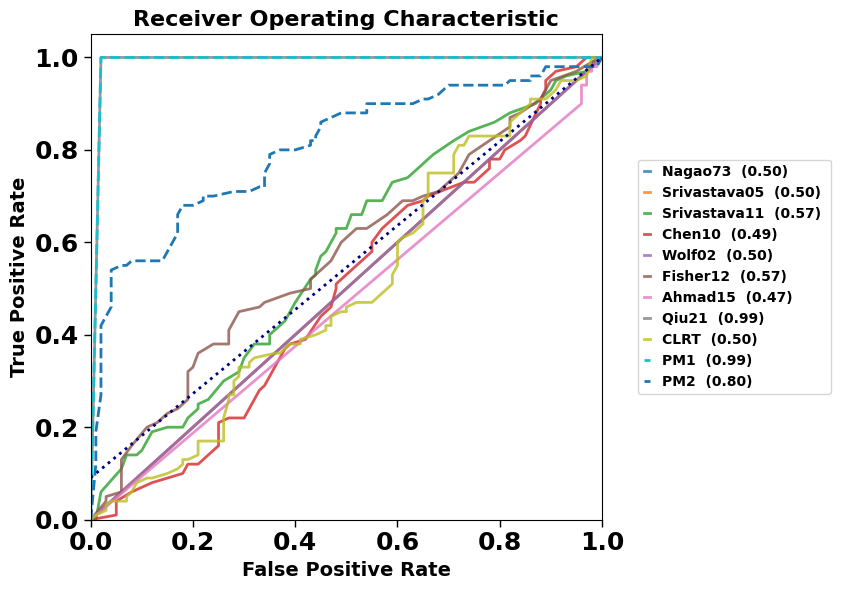

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import files
import matplotlib.gridspec as gridspec
num_matrices=100

def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # # plot ROC curve
    # # Use string formatting to control the presentation of AUC in the legend
    # legend_text = "{:<16} ({:0.2f})".format(label, roc_auc)

    # # plot ROC curve
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=legend_text)

    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'({roc_auc:.2f}){label} ')

    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label}  ({roc_auc:.2f}) ')
    # label_padded = label.ljust(15)
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label_padded} (AUC: {roc_auc:.2f})')

def bold_legend(legend):
    """Utility function to set legend text to bold."""
    for text in legend.get_texts():
        text.set_fontweight('bold')


def set_ticks_bold(ax):
    """Utility function to set tick labels to bold."""
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 0.2])

fig = plt.figure(figsize=(8.5, 6))

# First subplot
ax0 = fig.add_subplot(gs[0])

# Perform Test1 and plot its ROC curve
# p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test1)
# print(p_values1_test1)
# Perform Test2 and plot its ROC curve
# p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test2)
# print(p_values1_test2)
# p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test3)
# print(p_values1_test3)
# p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test4)
# print(p_values1_test4)

# p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test5)
# print(p_values1_test5)
# p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test6)
# print(p_values1_test6)
# p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test7)
# print(p_values1_test7)
# p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
# p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test10)
# print(p_values1_test10)

# p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test11)
# print(p_values1_test11)

generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',lw=2, linestyle='--', alpha=1)
# print(p_values0_test8)
# print(p_values1_test8)
# p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',lw=2, linestyle='--', alpha=1)
# print(p_values0_test9)
# print(p_values1_test9)



set_ticks_bold(ax0)
ax0.plot([-0.1, 1], [0, 1], color='navy', lw=2, linestyle='dotted')
ax0.set_xlim([0.0, 1.0])
ax0.set_ylim([0.0, 1.05])
ax0.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
ax0.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)

ax0.set_title('Receiver Operating Characteristic', fontweight='bold', fontsize=16)
ax0.tick_params(axis='both', which='major', labelsize=18,  width=1, length=5)



# Second subplot for the legend
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
handles, labels = ax0.get_legend_handles_labels()
legend = ax1.legend(handles, labels, loc='center',handlelength=0.5)
bold_legend(legend)


plt.tight_layout()
plt.savefig("n100p10000t0dot03.eps",dpi=300, bbox_inches='tight')
files.download("n100p10000t0dot03.eps")
plt.show()


### Figure 6(b) $\varepsilon=0.3$

#### Data generating

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def perform_test(TestFunc, Sigmad, m=2000, n=40, num_matrices=1000):
    p_values0 = []
    p_values1 = []

    for _ in range(num_matrices):
        data0 = np.random.normal(0, 1, (m, n))
        p0 = TestFunc(data0.T)
        if p0 is not None:
            p_values0.append(p0)
        else:
            p_values0.append(0)
        del data0

        data0_prime = np.random.normal(0, 1, (m, n))
        data1 = data0_prime * np.sqrt(Sigmad)[:, None]
        p1 = TestFunc(data1.T)
        if p1 is not None:
            p_values1.append(p1)
        else:
            p_values1.append(0)
        del data1, data0_prime

    return np.array(p_values0), np.array(p_values1)
from sklearn.metrics import roc_curve, auc

def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # # plot ROC curve
    # # Use string formatting to control the presentation of AUC in the legend
    # legend_text = "{:<16} ({:0.2f})".format(label, roc_auc)

    # # plot ROC curve
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=legend_text)

    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'({roc_auc:.2f}){label} ')

    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label}  ({roc_auc:.2f}) ')
    # label_padded = label.ljust(15)
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label_padded} (AUC: {roc_auc:.2f})')
import matplotlib.pyplot as plt
# Initialize the plot
plt.figure()

# Set parameters
# m = 20000
# n = 200
m = 10000
n = 100
num_matrices = 100
t = 0.03
Sigmad = np.repeat(np.array([1, 1+t]), m//2)

# Perform Test1 and plot its ROC curve
p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test1)
# print(p_values1_test1)
# Perform Test2 and plot its ROC curve
p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test2)
# print(p_values1_test2)
p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test3)
# print(p_values1_test3)
p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test4)
# print(p_values1_test4)

p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test5)
# print(p_values1_test5)
p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test6)
# print(p_values1_test6)
p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test7)
# print(p_values1_test7)
p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test10)
# print(p_values1_test10)
generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',lw=2, linestyle='--', alpha=1)
# print(p_values0_test8)
# print(p_values1_test8)
p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',lw=2, linestyle='--', alpha=1)
# print(p_values0_test9)
# print(p_values1_test9)

p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test11)
# print(p_values1_test11)








#### Saved data

In [ ]:
p_values0_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test3=[0.23692729768650422, 0.24315018704945968, 0.155507468111022, 0.3496193209078652, 0.1512861826386831, 0.14558273799959187, 0.1057522881876991, 0.07664152544918801, 0.37697882972514796, 0.1774121338681749, 0.004362561481954685, 0.14533329525508099, 0.4260128415461333, 0.3523860668903849, 0.20967916093181027, 0.03598015568155055, 0.4628632033988209, 0.303925509118104, 0.08593855259248262, 0.3209145929312167, 0.06632116826505485, 0.3638830859484825, 0.37738731990337415, 0.18782633680955163, 0.34126318822508295, 0.4011212977351566, 0.2446815614946185, 0.34912766713846377, 0.04898604981881194, 0.05425731164795733, 0.005718671832747324, 0.34514801902757464, 0.22157482090697767, 0.15782383570357372, 0.23465712333822886, 0.2548578803670264, 0.09386832099373943, 0.40946687299412265, 0.2935981589308343, 0.36044760780491436, 0.42598291959290413, 0.17625233416633912, 0.33074962557172116, 0.31053748996904484, 0.20085438385167764, 0.09573598062443611, 0.02870464633180525, 0.11174046604581189, 0.48017388530479, 0.18396876411190977, 0.4052226605025604, 0.08697061390270966, 0.10950728339188232, 0.2764560185822773, 0.23523668147052057, 0.2393329524153598, 0.05185324555037396, 0.22664279585024805, 0.3507780742078702, 0.4052268667020519, 0.4602500539196527, 0.03334219790763304, 0.017711665000346044, 0.11340238329162644, 0.14048325050768828, 0.46548960950075435, 0.46176661406755193, 0.1296470654368711, 0.13975221864530196, 0.15664017416837572, 0.4805734667550463, 0.4772547386749496, 0.25580914136366095, 0.0646196095699838, 0.1490737110409649, 0.35308191064745387, 0.20717516983879514, 0.44258274026813127, 0.015192844534477445, 0.3662426411705114, 0.04394188069158744, 0.14753494324326277, 0.18795889484788286, 0.4554094527421515, 0.06041801586575435, 0.30415005412565355, 0.17167142292590531, 0.4407104581981791, 0.4458255588960468, 0.3001698784634077, 0.4442464908664663, 0.09069142380628326, 0.35005034802396473, 0.4563234812555742, 0.0049929383085935974, 0.44603638773343435, 0.07672452430911558, 0.20192854705223606, 0.36114756623424193, 0.40802976263452195]
p_values1_test3=[0.03520337388899397, 0.19073180871091266, 0.04684526992357552, 0.08153913130155344, 7.468330622817376e-07, 0.035976295391845325, 0.0008130917517700231, 0.0002476970553603186, 0.13666436338370969, 0.15180047317713175, 3.0410807127956296e-05, 0.00015273156899808793, 0.49605507510982105, 2.967931088670994e-07, 0.00140961521952776, 0.29326402613817404, 6.247471595610676e-07, 0.020334918726483964, 0.25511946578730293, 7.74369481870707e-08, 0.23093841107877, 0.16568985219880905, 0.2446869160731, 0.03231411075276103, 0.46424569807758487, 0.0328054573538582, 0.03989589402261928, 9.821172197033157e-05, 0.054034771867072506, 1.8784364601232006e-05, 0.013559349042003399, 0.001961115606146868, 0.004441159908318837, 0.0007987793200519011, 0.09394628724553777, 0.012310013838091827, 0.11798213797224377, 0.008948096576063769, 0.04606543055681622, 0.00024281507488066456, 0.0002680723276573538, 0.0006482200408844951, 0.4106172425722179, 0.0003543960666739787, 0.01516356064508495, 0.004894592408234755, 0.02759481143778042, 0.004495170256898939, 0.215459940335764, 0.0033431189829533636, 9.464410411830215e-06, 2.095206823704565e-05, 0.4448503647406866, 0.00014235894286573902, 0.0011866144045018512, 0.0012980090838523584, 0.03960690019255286, 0.0023105261661638954, 0.044989487259893046, 0.25307467876359346, 0.23499115959572192, 2.6321141372021017e-06, 7.302458016611446e-06, 0.0002461714563466444, 3.907807945013886e-07, 0.2573807451831205, 0.006948340438198475, 8.77762242479374e-06, 0.07117161264283312, 0.0003336353643145218, 0.02694323602455806, 0.37150309858310615, 0.045739395068019495, 0.0006400130118023872, 0.014759409463538598, 0.08866365574201218, 1.8991311168115033e-07, 0.06601550745709839, 0.00047829806851917844, 0.010441702668528063, 0.14927636793661936, 0.4713945939923744, 0.0006378431546062435, 0.015481122094316402, 0.00393287088772365, 0.14555466614481127, 0.03867679618487807, 0.13401720662532468, 0.08325971443417002, 0.20683440947252785, 0.00010176209770074163, 0.007291981860597541, 0.08143638505757256, 0.04830146164714022, 0.24757979895310134, 0.11792025272212459, 0.3788170582649901, 0.0006249280779390132, 0.004739847644780748, 0.0006937845302824597]
p_values0_test4=[0.17548502705921998, 0.31251642191381757, 0.335703905534956, 0.45727041477529895, 0.25782024152480654, 0.42009941478276047, 0.19949776748280124, 0.40664204638404766, 0.40708693283171893, 0.18995514588919005, 0.08378293451645402, 0.10337287612911006, 0.12039516722445764, 0.2594491792190967, 0.1784927373780747, 0.11602421337751323, 0.19381344737166173, 0.1791629030558033, 0.10303202421879631, 0.23386377732524388, 0.3128773006992598, 0.007456518962193903, 0.06665837461973245, 0.14618573186289208, 0.28883987323008675, 0.296795952387219, 0.05200686498115725, 0.25701160977197657, 0.2771969618978788, 0.4878387914572492, 0.03023663886447736, 0.12268666195037081, 0.4689496522353829, 0.04221409277572996, 0.30618608408423964, 0.41546755943784697, 0.26826427339765624, 0.02871472582796286, 0.0360802316436436, 0.3001862706516637, 0.18208030318496682, 0.29703968329568053, 0.14017822741694674, 0.12900670541947057, 0.19981969637636054, 0.046570220688109565, 0.15326135449489686, 0.4969441758583615, 0.4756472052176699, 0.4208987023383388, 0.2860584996020732, 0.15299579106970684, 0.3109672991930529, 0.03354915517120882, 0.421628203006409, 0.46452425554073773, 0.16395750566389578, 0.1473781328982008, 0.48250074371897733, 0.24647368295698324, 0.47012817687778763, 0.1314399425770011, 0.10949558328435804, 0.024003079750737566, 0.36439398290321057, 0.3004213911958259, 0.05927847807311204, 0.4438934053147072, 0.011321107968801258, 0.44691199306312723, 0.09277441877032944, 0.42696003988566533, 0.005352814960582708, 0.20028255790751626, 0.1721669385146114, 0.09262035058504503, 0.02604664349201269, 0.06722087601075089, 0.4176350857189508, 0.2856909135621917, 0.3351830533664426, 0.38553798081336055, 0.4802816889314233, 0.014912006817176748, 0.22414152683513178, 0.13571555998652185, 0.23205929287726923, 0.2697197725413738, 0.11402652983359274, 0.30118236753697336, 0.19615283315733112, 0.232837099749593, 0.044790844124551255, 0.47729829580777094, 0.3637279924856024, 0.458692281219644, 0.05830794534944905, 0.12474071372395379, 0.1922864697466269, 0.2810786609219934]
p_values1_test4=[0.06960297151830785, 0.029165449776972996, 1.0531136438340916e-05, 0.10701329794984793, 0.09301284813303701, 0.1460043286299174, 0.006226073406840005, 0.17641859885326605, 0.2673140014788046, 0.22535617981714506, 0.06133948970972036, 0.03255938481933329, 0.0005297693972364792, 0.02372223648066729, 0.009033283605784592, 0.005235474546630314, 0.0011610636950388775, 0.01418590747859838, 0.05529688289668033, 0.43708378004430826, 0.03540953104275246, 0.05153240573897078, 0.4402421702859127, 0.061081069595914306, 0.16862047436008964, 0.007577962155872697, 0.000781323721394056, 1.2583549521272275e-06, 0.0001268719381783967, 0.0005595835916664127, 0.013032274804726462, 0.03244346711099233, 0.0018463693820941485, 0.07732733392685254, 0.11273634932987653, 3.7999583561543204e-05, 0.09659721339618299, 0.0009926502451583774, 0.3970157576733283, 0.0005289528830847434, 0.014909312398172725, 0.0009512898392419755, 0.041988854184400015, 0.38636163417179037, 0.02679959624405137, 6.215078311222477e-06, 0.016455855107433415, 0.2839081403456831, 0.014105703518341506, 0.0005351697792324028, 0.001198456380363977, 0.0017857404614683992, 0.3905277304778826, 0.0031324764524240933, 0.05586123571306756, 0.00012033472180639215, 0.009290033017412713, 0.09575587498165872, 0.0014016834502924569, 0.0012628129865294158, 0.0981088664980947, 0.013049379477997336, 0.36902349629594156, 0.0029727231525600306, 0.36452225779791836, 1.1013708912654963e-06, 0.0002969416562867977, 0.030250513734253137, 0.0018118272685386794, 0.012137809349920148, 0.0007371484464322453, 0.022953926330355756, 0.1050346546562454, 0.029776952701388804, 0.20606656083335873, 0.017030261625100573, 3.033779584216134e-06, 0.0005937495866428222, 0.1615166663665617, 0.007877080069069842, 0.00024122642890245238, 0.022486058128789788, 4.707899731204446e-05, 3.9851450028827173e-08, 1.795992208331043e-05, 0.02299816574118796, 0.0034499906265239577, 0.0014524439396444988, 0.006369795708277448, 0.11664416758814644, 0.0015124550793474967, 0.011693890090266668, 0.24602143324454495, 0.0049225557367523765, 0.14826641774305926, 0.42807276146056616, 0.00817129108978043, 7.672031483663133e-06, 0.00019809638992562828, 0.449981797296516]
p_values0_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test6=[0.3626661422822698, 0.13069608870888105, 0.16946182752414063, 0.17432820951313155, 0.4874666590037333, 0.006840819801486764, 0.18685797449761155, 0.34880671135431496, 0.06715109088804683, 0.41635001295484286, 0.46776994321645327, 0.039396224113490974, 0.4109585115208694, 0.39918474669894966, 0.031979705569696204, 0.16723279014552794, 0.38276834087931644, 0.08163986686044034, 0.09878123261617566, 0.20115323059204793, 0.2799520291581643, 0.4829046042248357, 0.08231635067679499, 0.43064464940657043, 0.04438603734733826, 0.04406050931417005, 0.25898463080270395, 0.06610037849320194, 0.020786296637632207, 0.12338901977851735, 0.43458044373301086, 0.01275889445494316, 0.03318157174757741, 0.04175233669302836, 0.22335320155389016, 0.47904613639437754, 0.4414805290677324, 0.2631056987746738, 0.48559116280889036, 0.37103633200485775, 0.3375702821875557, 0.40711067805808976, 0.14248930731342624, 0.3665866677151768, 0.16706436767208432, 0.2617965690756342, 0.196416298082689, 0.15408345052923378, 0.3769113419623117, 0.35156818378100907, 0.3923013232579313, 0.13607822547491566, 0.42731086066552826, 0.19877329938458743, 0.46828875156069993, 0.3470147393477603, 0.36940144333519953, 0.30638055183462876, 0.19884003438343667, 0.4617054741096964, 0.06824929337681973, 0.15280759363190588, 0.35882316391268976, 0.164960880370848, 0.015391752012605342, 0.3270033911702437, 0.22023927687182532, 0.3314302634653513, 0.15110189864544532, 0.2534203449667274, 0.19802337570946071, 0.16243365644875785, 0.31161871972704225, 0.08419233253363034, 0.23099639787719628, 0.009764942184268266, 0.048889755847275396, 0.10443108249002808, 0.4913758935547906, 0.0011463524039233564, 0.4800409381643591, 0.1951805241052741, 0.24940883454739593, 0.09645613528778818, 0.006875695270581961, 0.4641937072592779, 0.004349413569080363, 0.2680921873564297, 0.487956630484804, 0.1731102214905348, 0.37083035254286056, 0.2629265275192967, 0.4894258744281872, 0.46317721134883927, 0.27479976529229044, 0.38776308675637305, 0.28329068502949206, 0.14760710567480761, 0.3702755962317371, 0.0603748029515887]
p_values1_test6=[0.33522666773828436, 1.221788586303063e-06, 0.2666235029864763, 0.03257304689081786, 0.32402168089780936, 0.027387070903513888, 0.0021288942157354773, 0.05250223554978173, 0.33527612375082816, 0.20136389666631704, 0.41354330236962855, 0.055917153880791326, 0.017397612050634503, 0.025401045084987417, 0.0679272799888686, 0.0022949566501409002, 0.02462474049673069, 0.03711389438535195, 0.11940996026125683, 0.19666124493094772, 0.012227773014634291, 0.13613352513259114, 0.02998284039316612, 0.2009983231209187, 0.09289415500921838, 0.47942088628054935, 0.32546684867291686, 0.11047500675852584, 0.40992408797378443, 2.185015114652966e-05, 0.10934742356243987, 0.006608972999416651, 0.02483741056964439, 0.43418884654115697, 0.3963431566017096, 0.03512136181253234, 0.02459385386610935, 0.2192047419949047, 0.27553474869891503, 0.47657572475628807, 0.0017526615490215391, 0.27013967334489597, 0.0005442143039163794, 0.02454895857784556, 0.0008563085828200423, 0.09889805189047463, 0.34359314384280926, 0.40971539547246383, 0.0011428745357336956, 0.43814878575883764, 0.26629366269348176, 0.00014667676184498823, 0.09185839618862102, 1.1699568854828257e-06, 4.509411413700093e-05, 0.09368583135422992, 0.08245594610026497, 0.48783843152109196, 0.21668890588373335, 0.05406261641138799, 0.40534972406396697, 0.13369399204186705, 0.016083868682638558, 0.20195037882345646, 0.0010026804532048406, 0.056772624083792245, 0.22955787002082517, 0.000832427426154525, 0.06331297421233462, 0.002240370589405072, 0.17038859786271288, 0.0026113979723637604, 0.27922226993491006, 0.2667507944240505, 0.054151461541796175, 0.45824567213910883, 0.4170044783746957, 0.38053263177602703, 0.00039635108808211417, 0.05423637689038174, 0.08624960519836367, 0.0009103764710364226, 0.27272389065622415, 0.4460495162904582, 0.45897763536312974, 0.041497109517914854, 0.2565220635672426, 0.0006667870687904198, 0.38928268281912004, 0.03847435862608306, 0.09542826465303245, 0.009327762655091831, 0.2829992582046943, 0.1056468976809134, 0.0009111117298487015, 0.0838896053893935, 0.10535992146630191, 0.23464604839539493, 0.2088195938507036, 0.0027936431566418785]
p_values0_test7=[0.0, 0.0, 4.589661983800397e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0258460747536446e-13, 0.0, 0.0, 0.0, 0.0028892442368357862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.614883449185811e-09, 0.0, 0.0, 0.0, 1.8580807203960603e-07, 0.0, 2.6645352591003757e-15, 0.0, 0.0, 4.395763401277009e-06, 0.0, 0.23712496946496042, 0.0, 0.0, 0.0, 4.427453492716893e-08, 0.0, 0.15658247058303876, 3.975249566190442e-07, 0.0005824387791671937, 0.0, 0.0030843661106175757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.165744701147613e-05, 0.01369567742730371, 2.8873570201426446e-12, 0.0, 0.0, 0.0, 0.0, 8.294476216974545e-11, 0.0, 7.63711316409399e-12, 0.0, 0.0, 0.0, 0.0, 9.068893841890358e-06, 0.0, 5.102784218502521e-06, 5.1694232234944515e-05, 0.0, 0.0, 0.0, 0.0, 1.4917699620031755e-07, 0.0, 0.0, 0.0, 0.0, 1.2842727992179448e-09, 0.0, 0.0, 0.0, 0.00018753384908543058, 0.0, 0.0, 0.0, 2.220446049250313e-16, 8.743531098964752e-05, 0.0, 0.0, 0.0, 1.481114120238658e-10, 0.0, 0.0, 1.3322676295501878e-14, 0.0, 0.0, 0.0, 0.0]
p_values1_test7=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3779127916355733e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test8=[0.6671434906750298, 0.29880768855635, 0.6674952063726991, 0.8818844463756548, 0.08780357444116449, 0.4041771308141695, 0.6258231696599865, 0.9214077540818242, 0.45890037223814995, 0.9858593334871564, 0.7755495907102665, 0.2815625503869048, 0.4627416276168532, 0.1311630582507064, 0.3824995743987216, 0.6624164146723441, 0.4783241083067815, 0.1890982942626711, 0.278639679998248, 0.14760704043336847, 0.7413786320567546, 0.3900872474170445, 0.15360651074887866, 0.34160885345003833, 0.6848522867872546, 0.9504690019287358, 0.8760732810028569, 0.08159144774945148, 0.4716417632059322, 0.532849796014192, 0.14021451575415478, 0.6265198225165038, 0.771004876803477, 0.14701875485152494, 0.025510901210538117, 0.23709690345331058, 0.3178098593347496, 0.7225293971653866, 0.6484965178891668, 0.05295617499470451, 0.8488780601781671, 0.927663294727407, 0.23736508550536994, 0.792568051169042, 0.7396645085534692, 0.6617974569298615, 0.1547549155065393, 0.8428061935988755, 0.0865815272416901, 0.7389569896677759, 0.28781079750053795, 0.47719276837852354, 0.8188516996616544, 0.06860934166223887, 0.9016999579282228, 0.5418196849883161, 0.41061292774950764, 0.2986909627534855, 0.04553717501358845, 0.7257850255779039, 0.017006915540242584, 0.9380369199939833, 0.2801039551825628, 0.040840705706497005, 0.056072028330951484, 0.5399777947770079, 0.5482002527631427, 0.5417428743946178, 0.6881564613332594, 0.9198952388521802, 0.11843163599519535, 0.0816994614847355, 0.6666990264501214, 0.19607210971808176, 0.2857652629344014, 0.2833172768966019, 0.7514383329404997, 0.059417132102534964, 0.07332069347451142, 0.10410933174669323, 0.04741783304649694, 0.9691542439662071, 0.9341037318715728, 0.6738624970737517, 0.1359491664225283, 0.9234995233445586, 0.8090513926788427, 0.9115462525350857, 0.22007347012242806, 0.682845571551342, 0.4357841156564346, 0.016049086678028956, 0.3705275905089771, 0.04652469783543589, 0.6105138416420732, 0.4742950636170944, 0.7141754096796737, 0.018399428333405465, 0.8115485212420539, 0.8680984100810323]
p_values1_test8=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test9=[0.7688837503673582, 0.4566167323080479, 0.4929156156340011, 0.559806229536099, 0.45195802736178825, 0.09140924504812653, 0.8463797300655675, 0.686579630544516, 0.8134242975515267, 0.9452755549225402, 0.9245731972013844, 0.008038178998245105, 0.4513730764940853, 0.15077560884196628, 0.3593304814732501, 0.5543053272825511, 0.9550672966876625, 0.20877026621747152, 0.30892819518000314, 0.37972809206632174, 0.5706921712301205, 0.456247755542849, 0.680635192391829, 0.5623736659115461, 0.22688202369091903, 0.4842315175202643, 0.9659553643766148, 0.47662629950193236, 0.5630937428036413, 0.378353737175227, 0.06573414668755051, 0.3407918697329506, 0.060814883176276036, 0.13109490195288798, 0.5303777060648667, 0.14435219168990043, 0.9917529864974093, 0.4610430153746514, 0.1764373318287984, 0.07756769504300953, 0.06530578751202776, 0.21786587028294369, 0.3477443266310405, 0.7874250952987409, 0.22820512613561528, 0.2111721132489972, 0.22075461030430743, 0.09090490191524103, 0.2747929110125942, 0.7493183341766008, 0.5738040261397741, 0.831071480960687, 0.299576187461827, 0.94468257570718, 0.5897386152498909, 0.838553374465467, 0.7784995262270351, 0.9880963799765028, 0.590886212010161, 0.8945707261867224, 0.36178804576793433, 0.03732831510311607, 0.43493683261971716, 0.04464282124298791, 0.3883715769971299, 0.9224189195077757, 0.1590506762842403, 0.10170175975278561, 0.8710844184369708, 0.41530653750593105, 0.6885533865172424, 0.7546532711781391, 0.3099395369227096, 0.7272119391394536, 0.17179426435876555, 0.5664235864773164, 0.7721031931189339, 0.28571926943619275, 0.13767226475266825, 0.26878913514776337, 0.17215924723940157, 0.19053248806646939, 0.5209242179425775, 0.5741637123839081, 0.12609096401645603, 0.2507536201272169, 0.2553177000474314, 0.5357702481223456, 0.07874633012612353, 0.6975413360875813, 0.7856295929395083, 0.001111778426292176, 0.8587056769880181, 0.8725118191170547, 0.35789241635888125, 0.877421657633678, 0.22309351272534506, 0.5061423231315316, 0.7373834642128065, 0.831262864219406]
p_values1_test9=[1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05, 1.256423388107386e-05]
p_values0_test10=[0.6671434906750298, 0.29880768855635, 0.6674952063726991, 0.8818844463756548, 0.08780357444116449, 0.4041771308141695, 0.6258231696599865, 0.9214077540818242, 0.45890037223814995, 0.9858593334871564, 0.7755495907102665, 0.2815625503869048, 0.4627416276168532, 0.1311630582507064, 0.3824995743987216, 0.6624164146723441, 0.4783241083067815, 0.1890982942626711, 0.278639679998248, 0.14760704043336847, 0.7413786320567546, 0.3900872474170445, 0.15360651074887866, 0.34160885345003833, 0.6848522867872546, 0.9504690019287358, 0.8760732810028569, 0.08159144774945148, 0.4716417632059322, 0.532849796014192, 0.14021451575415478, 0.6265198225165038, 0.771004876803477, 0.14701875485152494, 0.025510901210538117, 0.23709690345331058, 0.3178098593347496, 0.7225293971653866, 0.6484965178891668, 0.05295617499470451, 0.8488780601781671, 0.927663294727407, 0.23736508550536994, 0.792568051169042, 0.7396645085534692, 0.6617974569298615, 0.1547549155065393, 0.8428061935988755, 0.0865815272416901, 0.7389569896677759, 0.28781079750053795, 0.47719276837852354, 0.8188516996616544, 0.06860934166223887, 0.9016999579282228, 0.5418196849883161, 0.41061292774950764, 0.2986909627534855, 0.04553717501358845, 0.7257850255779039, 0.017006915540242584, 0.9380369199939833, 0.2801039551825628, 0.040840705706497005, 0.056072028330951484, 0.5399777947770079, 0.5482002527631427, 0.5417428743946178, 0.6881564613332594, 0.9198952388521802, 0.11843163599519535, 0.0816994614847355, 0.6666990264501214, 0.19607210971808176, 0.2857652629344014, 0.2833172768966019, 0.7514383329404997, 0.059417132102534964, 0.07332069347451142, 0.10410933174669323, 0.04741783304649694, 0.9691542439662071, 0.9341037318715728, 0.6738624970737517, 0.1359491664225283, 0.9234995233445586, 0.8090513926788427, 0.9115462525350857, 0.22007347012242806, 0.682845571551342, 0.4357841156564346, 0.016049086678028956, 0.3705275905089771, 0.04652469783543589, 0.6105138416420732, 0.4742950636170944, 0.7141754096796737, 0.018399428333405465, 0.8115485212420539, 0.8680984100810323]
p_values1_test10=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test11=[0.17706855336626903, 0.272261796465755, 0.19020920235224925, 0.7732251503041341, 0.5970291402366639, 0.4476183943275709, 0.41220396547455707, 0.7469570882194099, 0.061431190637930344, 0.03565714760929661, 0.4587584766376196, 0.9796002703880919, 0.768811079372554, 0.9913202461539106, 0.10345672843237796, 0.4731353146764534, 0.38765376557494746, 0.6078474287220224, 0.7534536631001918, 0.9858919380267601, 0.6365139370425434, 0.9538977202570336, 0.8139409141005196, 0.4173128523349141, 0.8442555288321554, 0.9125625677105762, 0.17580300905440116, 0.29861821399414845, 0.12006027322351298, 0.7333474346611331, 0.3389379989139125, 0.5310457051737221, 0.6124286563135741, 0.5528450735014636, 0.02826432454339356, 0.9609682698088537, 0.9081564906754096, 0.5807453037128436, 0.022126138249320748, 0.7530126147262126, 0.9850432862010634, 0.8087208923502776, 0.7733056495552038, 0.5696006117413757, 0.09035288641102168, 0.7516566121818729, 0.9397668585778889, 0.05188189717204161, 0.8353470974451982, 0.6411331324388576, 0.49155485590942183, 0.8639863218663826, 0.8092847499216069, 0.2682506538843019, 0.4983033055983621, 0.31523877567101133, 0.8225998737808142, 0.16093933861788012, 0.09525314694434006, 0.09279379102693142, 0.16756441761898966, 0.6192878517883205, 0.04660217791133414, 0.17668573195734183, 0.22397949960784613, 0.4997480624945805, 0.8359717688889188, 0.7720661581151402, 0.6812699378371565, 0.4963675018327076, 0.532163660360788, 0.9100600470824629, 0.12261056607573173, 0.35901197808307717, 0.8667921643514709, 0.16047124839079396, 0.5170019892266371, 0.8531419836178065, 0.7765311539705528, 0.6346820543552278, 0.7250379681259356, 0.4382084405936786, 0.15707159607981835, 0.3384949416378058, 0.7862600445901289, 0.646474030563239, 0.5191080521789755, 0.3027025009649571, 0.9295498597004099, 0.9630218228903282, 0.7662685190437073, 0.4844732873090378, 0.5920193450933742, 0.991256548362764, 0.12220471382427656, 0.7818213518139638, 0.2763579354766412, 0.2658185819391108, 0.1666769498226479, 0.13914893522105753]
p_values1_test11=[0.9942154932912088, 0.18411115287084856, 0.183710272909126, 0.2988282599379919, 0.018357778811993297, 0.010237429411041665, 0.3981678065155534, 0.7813680388960624, 0.22620518760120945, 0.10544026916814375, 0.046844349502929816, 0.19512624607053097, 0.8753017117538826, 0.42341417335226295, 0.3377482220571375, 0.11164162330685468, 0.6536312165753739, 0.46466806752710044, 0.6427816877125561, 0.5335015228371205, 0.11937303341046457, 0.25869000313880597, 0.7773045039325837, 0.06134861477246867, 0.017762145089615045, 0.03592225385415704, 0.910220226067046, 0.7717317883605364, 0.4642301611130901, 0.5467054620144454, 0.7265840775085843, 0.21196078598315937, 0.056403196965733926, 0.30873363860657066, 0.4628104764923373, 0.004022971245150275, 0.3879534608683197, 0.9656598139038621, 0.3484749592672609, 0.19673784395965233, 0.9304117006154977, 0.1892578920847936, 0.9804182376862363, 0.8568828994646531, 0.9438001574666393, 0.38576958267272077, 0.03741253047677673, 0.007337690225904803, 0.8780386900425017, 0.1556704182475075, 0.061776323081465856, 0.9852702263666826, 0.35295850342884005, 0.32422847987406067, 0.6105770967135924, 0.21953752643059543, 0.18377993875767862, 0.3219123235558006, 0.3348541965213323, 0.07733787753010635, 0.40477787919760955, 0.03479206761303044, 0.8211122555729722, 0.439701107797007, 0.8545887832625099, 0.3316392052411512, 0.3608644961338623, 0.20648891676894987, 0.45316625315343795, 0.04511738901041196, 0.7964707707049716, 0.5371993769723147, 0.09686271312139705, 0.018511946605605845, 0.30312034088995077, 0.8682680533245009, 0.2990664064552153, 0.42704032979627016, 0.06108483956140098, 0.19877945756642146, 0.1732646926129653, 0.6709670324665642, 0.43692759952164106, 0.42438214217306536, 0.048070478690638074, 0.9383249293666667, 0.7221025742282932, 0.38240758860896173, 0.05906529855549825, 0.04925842260632707, 0.49154423659377655, 0.06782801916427705, 0.7350889994383984, 0.08802198115455662, 0.020724340743764058, 0.5249344549832644, 0.2656125153293334, 0.04274217639132538, 0.3921682753800191, 0.2584364509093615]

#### Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

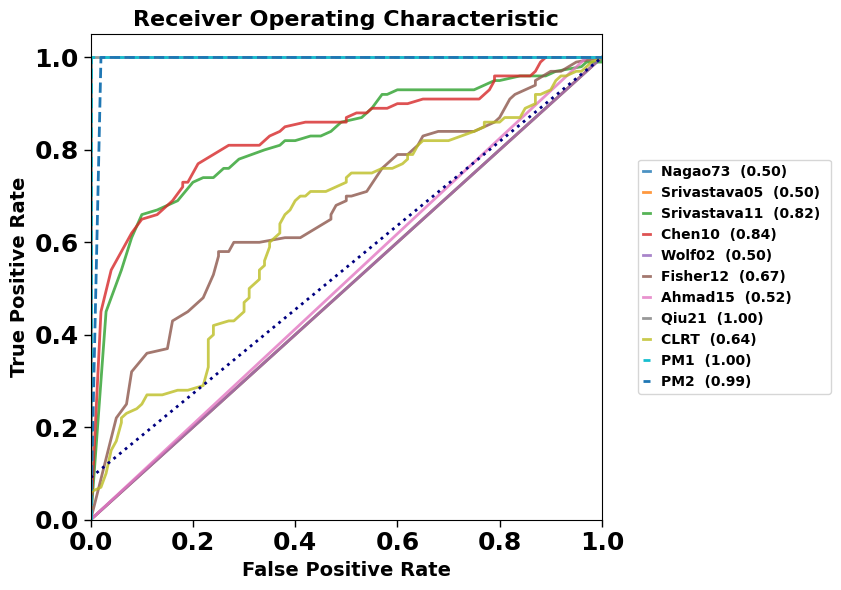

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import files
import matplotlib.gridspec as gridspec
num_matrices=100

def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # # plot ROC curve
    # # Use string formatting to control the presentation of AUC in the legend
    # legend_text = "{:<16} ({:0.2f})".format(label, roc_auc)

    # # plot ROC curve
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=legend_text)

    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'({roc_auc:.2f}){label} ')

    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label}  ({roc_auc:.2f}) ')
    # label_padded = label.ljust(15)
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label_padded} (AUC: {roc_auc:.2f})')

def bold_legend(legend):
    """Utility function to set legend text to bold."""
    for text in legend.get_texts():
        text.set_fontweight('bold')


def set_ticks_bold(ax):
    """Utility function to set tick labels to bold."""
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

# Create a GridSpec layout
# Create a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 0.2])

fig = plt.figure(figsize=(8.5, 6))

# First subplot
ax0 = fig.add_subplot(gs[0])

# Perform Test1 and plot its ROC curve
# p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test1)
# print(p_values1_test1)
# Perform Test2 and plot its ROC curve
# p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test2)
# print(p_values1_test2)
# p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test3)
# print(p_values1_test3)
# p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test4)
# print(p_values1_test4)

# p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test5)
# print(p_values1_test5)
# p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test6)
# print(p_values1_test6)
# p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test7)
# print(p_values1_test7)
# p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
# p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test10)
# print(p_values1_test10)

# p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test11)
# print(p_values1_test11)

generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',lw=2, linestyle='--', alpha=1)
# print(p_values0_test8)
# print(p_values1_test8)
# p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',lw=2, linestyle='--', alpha=1)
# print(p_values0_test9)
# print(p_values1_test9)




set_ticks_bold(ax0)
ax0.plot([-0.1, 1], [0, 1], color='navy', lw=2, linestyle='dotted')
ax0.set_xlim([0.0, 1.0])
ax0.set_ylim([0.0, 1.05])
ax0.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
ax0.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)

ax0.set_title('Receiver Operating Characteristic', fontweight='bold', fontsize=16)
ax0.tick_params(axis='both', which='major', labelsize=18,  width=1, length=5)



# Second subplot for the legend
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
handles, labels = ax0.get_legend_handles_labels()
legend = ax1.legend(handles, labels, loc='center',handlelength=0.5)
bold_legend(legend)


plt.tight_layout()
plt.savefig("n100p10000t0dot3.eps",dpi=300, bbox_inches='tight')
files.download("n100p10000t0dot3.eps")
plt.show()

## Figure 7: ROC

In this section, we display the ROC curve of our proposed tests compared with some of the existing literature when a wrongly estimated 4th cumulant is provided to the tests.

### ROC Curve with wrongly estimated $\kappa_4$, $\varepsilon=0.08$

#### Data generating

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit,random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt


k4=4
prob=0.5+0.5*np.sqrt((2+k4)/(6+k4))
# for t=0: 1: 0.1
t=0.000
values = np.array([np.sqrt((1-prob)/(prob)), -np.sqrt((prob)/(1-prob))  ])
probabilities =np.array( [prob,1-prob])


n = 100
R = 1000
c=0
T = jnp.zeros(R)


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]





pn=2*jnp.ones(n)

eta=1/(n**(1/4))

# k=int(n*eta)
R0=10000


#calculate the null distribution
phi=100
m=int(n*phi)
r=jnp.sqrt(phi)

leftb = jnp.sqrt(phi)+1/jnp.sqrt(phi)-2
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(4)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.choice(key,values, shape=(m, n),p=probabilities)
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, leftb-eta, leftb+eta))
    # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    t0=jnp.sum(Eb)
    T0 = T0.at[r].set(t0)
TestST0=np.array(T0)
Mean_x=jnp.mean(TestST0)
Variance_x=jnp.var(TestST0)
print(Mean_x)
print(Variance_x)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def perform_test(TestFunc, Sigmad, m=2000, n=40, num_matrices=1000):
    p_values0 = []
    p_values1 = []

    for _ in range(num_matrices):
        data0 = np.random.choice(values, size=(m, n), p=probabilities)
        p0 = TestFunc(data0.T)
        if p0 is not None:
            p_values0.append(p0)
        else:
            p_values0.append(0)
        # del data0

        # data0_prime = np.random.choice(values, size=(m, n), p=probabilities)
        # data1 = data0_prime * np.sqrt(Sigmad)[:, None]
        data1 = data0 * np.sqrt(Sigmad)[:, None]
        p1 = TestFunc(data1.T)
        if p1 is not None:
            p_values1.append(p1)
        else:
            p_values1.append(0)
        # del data1, data0_prime
        del data1, data0

    return np.array(p_values0), np.array(p_values1)



def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # plot ROC curve
    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label} (AUC = {roc_auc:.2f})')



# Initialize the plot
plt.figure()

# Set parameters
# m = 20000
# n = 200
m = 10000
n = 100
num_matrices = 100
t = 0.08
Sigmad = np.repeat(np.array([1, 1+t]), m//2)

# Perform Test and plot its ROC curve
p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73')

p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05')

p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11')

p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10')

p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02')

p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12')

p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15')

p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT')

p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
# generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21')
generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',linestyle='--',alpha=1) ## since test stat will be basically the same for Identity

p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',linestyle='--',alpha=1)




#### Saved data

In [ ]:
#p_values0_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1826984664130578e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3631011880899102e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test3=[0.14444037439075996, 0.007331859748987091, 7.231103663563054e-05, 0.1711474599070888, 0.308505004200748, 0.043386952350843, 0.19646902901995134, 0.26836584132297703, 0.013973354487776923, 0.39203170160307843, 0.11670077581720706, 0.13207224785823746, 0.10453335145239917, 0.018561290606681657, 0.009908934834340188, 8.07072549946497e-06, 8.640000992643504e-05, 0.03353432969451098, 1.6245553436933236e-06, 0.00027650916178945106, 0.012018629080801091, 0.012638613236756524, 0.022535739437377966, 0.008953854067071942, 0.020005190387807237, 0.2759682239986081, 1.772478538175637e-05, 0.40152963333443814, 6.184675971365738e-05, 0.0060553348196831225, 0.005021538947650783, 0.15780410581029336, 0.009553368328714784, 0.04633759365429524, 0.085180214752136, 0.18324731393469385, 0.0007868053278433651, 0.006392329827196508, 2.427965250273445e-05, 0.00409620761181162, 0.0479671207806146, 0.1605644288526451, 0.46448088897810536, 0.4124541895739545, 0.09643229811411191, 0.07727232011449359, 0.013012348482968394, 0.3268380694097959, 0.14401283639263518, 0.021337286669555144, 1.0312432058401377e-05, 0.3922607304945338, 0.028311853940801046, 0.007081010961484835, 0.044513056520347205, 0.004759875326874163, 0.035204467572570564, 4.0166463697755006e-05, 0.001698093000141454, 0.028770662011301962, 0.03863281827860909, 0.29258904952121023, 0.018029180285584978, 0.07033550356385809, 0.01967246953722024, 0.020560318895908924, 0.0178264082707561, 0.13756624078061352, 0.44940575482729117, 0.18198731718135208, 0.13095185525428876, 0.025733919881463896, 0.09448554525398978, 0.09271657734237737, 0.0604255036293575, 0.0018543434703043316, 0.004734605802687475, 0.0002076497874722305, 0.3431795273415025, 0.13355937264516515, 0.023023807438889432, 0.11185353804069731, 0.2482120012856761, 0.049887436076558433, 0.07738724856116286, 0.202988062633516, 0.0007569474638203788, 0.05491047751000011, 0.2654569940097039, 0.034247842356012526, 5.146930540100847e-05, 0.07186726405956279, 0.013577249611519071, 0.015140594505205662, 0.0011736112335489768, 0.1076226307228687, 0.24747287620744607, 0.3261749859790425, 0.0011194508720507867, 0.12666054102701152]
p_values1_test3=[0.0993393368222768, 0.0027570161173889884, 1.303917177108982e-05, 0.11401662182966388, 0.24451793262532862, 0.018492094239092816, 0.13370097539739256, 0.19746661439368673, 0.004602076888761242, 0.43940345086264665, 0.07761270618106053, 0.0916451556405743, 0.0629302684499563, 0.006960211286221374, 0.003830822522100097, 5.519677983567561e-07, 1.5414527031354375e-05, 0.013591962012162284, 1.6533250146721912e-07, 6.113587674050347e-05, 0.004688029047929865, 0.006506667022703527, 0.009103267397348791, 0.0025904314911103787, 0.007014635172447825, 0.2021760244474229, 1.1778558899333547e-06, 0.42937834500598493, 8.39412926723071e-06, 0.0015578930445846462, 0.0013485070380416797, 0.10750037139256541, 0.002596366078844503, 0.028153532890247912, 0.04858499844928155, 0.13777008697860738, 0.00013671943703985612, 0.0018857377016793242, 4.153813924157035e-06, 0.001485028939952615, 0.02063956952019652, 0.09769978541813296, 0.47856113937260514, 0.34021013919728305, 0.057556988921864005, 0.04414769497509641, 0.0038937069579869643, 0.2545848027465949, 0.1575953944577242, 0.008239799770767497, 1.3538113543543062e-06, 0.3432371613041467, 0.01593321643099077, 0.0026385979138763282, 0.025652002940127705, 0.0012085214517247866, 0.01887983163510487, 6.846123131842852e-06, 0.0005331362811200613, 0.013890415125514699, 0.016815169655289397, 0.2017269847012335, 0.008414146794966326, 0.04143401879711894, 0.0129711261295401, 0.009688965943210115, 0.00750171698934754, 0.09208381986748071, 0.3870252158586335, 0.12077520686894183, 0.1107204070378558, 0.009667068484886632, 0.051765408545881186, 0.04770421185503215, 0.027847510899257744, 0.0004916453279428801, 0.001497728393152431, 1.6722997947749008e-05, 0.27110003339140354, 0.08163434298509664, 0.009662710772647687, 0.06708025155334685, 0.17673508611661637, 0.0241232105992224, 0.03959977505535828, 0.15189484618784355, 0.00014208175317032, 0.02410370352858915, 0.18719861326087894, 0.019041153442164283, 1.0678245052964108e-05, 0.051551030584598756, 0.006634878928875154, 0.0056772565170886136, 0.0003623650586145333, 0.06631949004279625, 0.17189109938838332, 0.4098362312478073, 0.00024733854628500307, 0.06643425008444304]
p_values0_test4=[0.48797874105448935, 0.195564751955432, 0.4888293630017224, 0.1638487624041718, 0.24331400459126706, 0.24023050866404538, 0.1812803034249021, 0.3595597825458535, 0.2780861399210509, 0.010128011520450064, 0.23256829539987978, 0.06054659545596386, 0.1749759196701275, 0.2538963303227586, 0.4289788002798923, 0.45017881342189614, 0.07306935661037395, 0.034531167136498175, 0.04385888925419579, 0.2171938775234401, 0.13968922539339235, 0.11312471411796277, 0.22989779376375252, 0.35073663223230833, 0.13210066226013972, 0.2084338829587572, 0.08149808871846886, 0.2681789221526967, 0.1476157499721238, 0.30062070433024823, 0.21684770237136608, 0.36519838051620546, 0.4266428873733036, 0.07377820041601324, 0.3332697578046402, 0.23217990952312628, 0.2109718140756499, 0.32807387917689157, 0.1818096073143317, 0.04285491616178838, 0.23257284999890382, 0.12524601554172965, 0.21352280226949083, 0.21013611219438366, 0.18026010122594505, 0.11318617268565756, 0.49891189735822217, 0.40576687271712886, 0.08017329643497662, 0.002179212247550022, 0.17651447481497806, 0.2829990460503671, 0.26185457924240463, 0.003679025345599163, 0.4467915741756806, 0.05918448993052905, 0.03011207386785919, 0.005977330713872742, 0.036077932145539116, 0.14555879228177449, 0.37867410611346664, 0.14317675096425764, 0.08516542418322293, 0.4313022899428286, 0.3866633034870043, 0.10098312593822623, 0.02673213080116299, 0.15158094165233504, 0.4204243722995633, 0.38471158727058485, 0.161466857481515, 0.09574073452153087, 0.03346785832292942, 0.06699217665808677, 0.36539485093306423, 0.31854288244267503, 0.027023838373255393, 0.4537661538617995, 0.40639303999230214, 0.2539433389966348, 0.33917039985137487, 0.027903265303677482, 0.45223708107706395, 0.332786787465131, 0.21965723339627807, 0.48542805110389087, 0.24015783621845288, 0.22833989533571142, 0.05980772175491633, 0.25186630002613586, 0.15138513243544716, 0.07036289778864147, 0.04258611786979094, 0.2280273789548547, 0.2601656677445381, 0.490075594195191, 0.4930822090954151, 0.3954778340933165, 0.0981338500147928, 0.12153280077314299]
p_values1_test4=[0.4323316990751386, 0.15067802961471544, 0.44008509183544686, 0.12733932748210774, 0.17198096445654965, 0.20278875991273337, 0.13090059461271708, 0.30395262001937196, 0.3486739104072719, 0.008800644470022823, 0.18279435278190415, 0.05701406094930084, 0.18948827634990317, 0.2670487380286475, 0.3284877789894325, 0.38627711601072034, 0.041898685660847645, 0.03326587995258623, 0.02708792323220033, 0.25578554766510875, 0.09048155507392197, 0.11598102099493057, 0.19426976021488984, 0.3886815913909819, 0.1310652414554847, 0.22262509851026702, 0.041601340651696184, 0.3151243044516452, 0.10823049211580549, 0.25191802790392415, 0.1358484293569402, 0.42869939524299383, 0.45887381552356976, 0.04596973596605636, 0.37853808869702654, 0.25732133883195585, 0.25732516049228016, 0.35490450817390906, 0.1320014096702542, 0.025922753032788015, 0.17916901666666618, 0.15279935115684196, 0.16071161940380208, 0.2696602209025192, 0.19671743886021176, 0.12736102622630086, 0.45664760748492583, 0.35972975133696317, 0.04660960942426928, 0.0006837760839472073, 0.10384136701520519, 0.330018321615987, 0.2660784857348917, 0.001226830056425543, 0.4928377063316697, 0.026928997487606687, 0.028300720937928237, 0.0018163599899037042, 0.04002104416589003, 0.09889257652854044, 0.3997272714600193, 0.09377842099560718, 0.05004161853484468, 0.48185419868912993, 0.4667968175156004, 0.06358693843806873, 0.011545935594180379, 0.16638539156456944, 0.4826601941226111, 0.30852686141744856, 0.11987145024541146, 0.058770430828884335, 0.012232436692980686, 0.05997707170139588, 0.3049669487345823, 0.35163220442963516, 0.009259851587715251, 0.44269479694007663, 0.4713229693919947, 0.2832338948739719, 0.4073515370580776, 0.03524412871856564, 0.400220667755652, 0.2935084459899281, 0.28882398190760394, 0.4235466847499202, 0.20514818078357866, 0.251734146021503, 0.05672895320696547, 0.1817945344373716, 0.0901615306109006, 0.07019369188762847, 0.02082512810509063, 0.18181504244642144, 0.19434557469578684, 0.42945510184541247, 0.472732506775701, 0.34837524682206245, 0.10201738428596174, 0.08924817019858944]
p_values0_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values1_test5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test6=[0.470514421335102, 0.4807113530525571, 0.4533122030962905, 0.05011109807295289, 0.20061044445458975, 0.16821220172226226, 0.3506548257101696, 0.3655593243156088, 0.4972842565103285, 0.040816793555219055, 0.062264269522395055, 0.4537675030274386, 0.18718420509386158, 0.3258111994681727, 0.13295255489093205, 0.3360545757107265, 0.34032948644800365, 0.41860236671321116, 0.45859822607841694, 0.18406614302991575, 0.05646069436151446, 0.31561478437691204, 0.3669312049473874, 0.3398020282941888, 0.20161033883492863, 0.4221547439045924, 0.17057504197035422, 0.4361270381557749, 0.07275786832786069, 0.4507193626338445, 0.03821755000898619, 0.1406718391387929, 0.2165805142215821, 0.002793507148144747, 0.0900424200238168, 0.13355334515885597, 0.16763142961091237, 0.06051559826146424, 0.49507945152853083, 0.14422312885270494, 0.14952178218420786, 0.009938055574739368, 0.4402472499982901, 0.4559870239342634, 0.20386469347716263, 0.4167127771153245, 0.27899105630965404, 0.32840339444253375, 0.3572541641819542, 0.08072075471879891, 0.010285175020672832, 0.23714579528225332, 0.1594577592667361, 0.2617522089548515, 0.40663230191246547, 0.31906533895543854, 0.4439724782870338, 0.49109906036509177, 0.388179187528787, 0.12361273622627222, 0.4509153497193792, 0.04422273410722155, 0.3694893151629618, 0.15136353039337203, 0.076967146426686, 0.032795824941144636, 0.2594656255449399, 0.4258823610713708, 0.24196202323061056, 0.010307758316448257, 0.14614725666580042, 0.06342836842131772, 0.22576533640245244, 0.1961339586784565, 0.03434752233486127, 0.1825826126995267, 0.41821551357660225, 0.2658003511189736, 0.24182668540677454, 0.11397451796979374, 0.19566654606389655, 0.1311277432468103, 0.33814273348990254, 0.2777821784625393, 0.4070347443379295, 0.008859703322765977, 0.19443157977306713, 0.06928997409610194, 0.4074269033356409, 0.131482389269318, 0.12799981885812883, 0.008055805703177432, 0.14245292140394827, 0.11058996551854028, 0.05419094652164724, 0.3082631434749432, 0.08189680220386408, 0.1096338334634761, 0.07328412202315904, 0.013827661920751244]
p_values1_test6=[0.493107260855427, 0.4560931968026626, 0.4360075791276199, 0.022940739406933974, 0.17278190233886048, 0.1304979132742532, 0.3066774549114929, 0.358969272090232, 0.45247801018604494, 0.015341252711884024, 0.028164709557131684, 0.47802543849867973, 0.11962983800043059, 0.3073784432332972, 0.07620618563500514, 0.32550919361789044, 0.3047981785766587, 0.38340840674834864, 0.4509385441795032, 0.1461708031556812, 0.04345936563646813, 0.38502532752584706, 0.38807080373492564, 0.30122320786792, 0.16757478734374442, 0.4301200064220263, 0.1432152633394983, 0.41596303106701615, 0.044524940788173595, 0.4874220655656314, 0.029283065692629506, 0.11625031152228704, 0.1611737777638833, 0.00028070480929598407, 0.04674567564691634, 0.0866083253633837, 0.13882876787691334, 0.04148800433353628, 0.4605196036196779, 0.11028649945850955, 0.10086236432736517, 0.003957515727800454, 0.38291784711308086, 0.4540961849699019, 0.14162085570552208, 0.400620797965774, 0.23946442946392854, 0.27885310563078125, 0.32778322361009193, 0.04616666796637192, 0.0029194710576532223, 0.2579034405702678, 0.11043476213692593, 0.18089489620669608, 0.4350317342887934, 0.27897547289250524, 0.41646821928470024, 0.4602539461786259, 0.3862728380165581, 0.10637036126166044, 0.4915076942623796, 0.02517176816149158, 0.39605664037119914, 0.09345424300247462, 0.06753303780026143, 0.015999712196981264, 0.1694389292894546, 0.3888309776659822, 0.19460061553979835, 0.004559113446303664, 0.11733781467270243, 0.030158671786593816, 0.18433321925819546, 0.15602874558997404, 0.012234686218813962, 0.16974187222146642, 0.4505097149660229, 0.23669417761202616, 0.22266828775741399, 0.06878497243305848, 0.18733305394958033, 0.09596274921169112, 0.2820463132657205, 0.2609076038466627, 0.424707254198493, 0.0029160041346147914, 0.15034626161456122, 0.06870053107059493, 0.3958208113525049, 0.10184156673898448, 0.09886047517462737, 0.003394985740128198, 0.08059377415904989, 0.08179397614012762, 0.034926606633750135, 0.329842818749406, 0.040021296130952955, 0.06401770104365978, 0.04817236723280405, 0.0028399869223988405]
p_values0_test7=[0.0, 2.220446049250313e-16, 0.0, 0.015551310112520533, 0.0, 0.0, 0.00023083577040694525, 0.0021296718500996015, 0.0, 0.0, 0.0001909210995577615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04702411164010034, 9.432868930403515e-10, 0.0006905535067875945, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.705333408518754e-07, 0.0, 0.11915930868360025, 0.0, 0.0, 0.0, 0.0, 0.050620093557252055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.218299408722316e-08, 0.0, 0.0, 0.0, 0.0, 2.294737715846651e-06, 0.0, 1.1313169290261271e-09, 0.0, 0.0, 0.0, 0.0, 0.03973368900225582, 0.0, 0.0, 1.1102230246251565e-15, 0.0, 0.0, 0.0, 0.05371831815538897, 0.0, 0.0, 0.0, 0.0, 0.0010456669023106713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17983113859446287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000331330604511737, 7.862675843739453e-09, 0.0, 0.0, 0.0, 3.496374711975392e-08, 0.0]
p_values1_test7=[0.0, 0.0, 0.0, 3.6376585410557993e-07, 0.0, 0.0, 6.297184995673888e-12, 7.771561172376096e-16, 0.0, 4.03309607932556e-11, 0.34120309572206287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4988010832439613e-14, 0.0, 0.0, 0.0, 3.41277417595931e-05, 0.0, 6.043712197367768e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007387506205090544, 0.0, 9.3485774677049e-11, 0.0, 0.0, 0.0, 0.0, 4.660317909355172e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9976021664879227e-15, 0.34847177834956056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04949060550939255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.922478174547052e-09, 0.0, 0.0, 0.0, 5.551115123125783e-16, 6.661338147750939e-16, 7.617240171953199e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05525557958465288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test8=[0.8422526427519785, 0.10418318572711849, 0.23533604880386427, 0.7646237134821516, 0.0030089366602077394, 0.2553585192052277, 0.29213017016612675, 0.01953658415947257, 0.007727165535075908, 0.2031780808498458, 0.003654104727765173, 5.995863318797312e-05, 0.8723514798047776, 0.1045698328173541, 0.9243580142427217, 0.1287563851460809, 0.0667969537347024, 0.5926945885450052, 0.16694295160748185, 0.5813821247438984, 0.294646495515126, 0.9985376433549165, 0.09337368711991334, 0.13967078229988683, 0.031641914051960374, 0.045390220799202075, 0.5889125626229343, 0.0001337446766096484, 0.6678821893000966, 0.11137575105965647, 0.20253559022400136, 0.05273250219248116, 0.5299723993131851, 0.3415005964664499, 0.4981882414507053, 0.08283867532662259, 0.8408357635169832, 0.7369134329009823, 0.40305211824932696, 0.6441388763556024, 0.04033368632022749, 0.23318189963686642, 0.9854278715617368, 0.13107367286484783, 0.4618639735100474, 0.011097935403904913, 0.11638465029297906, 0.031498554956905345, 0.988352190042701, 0.6520145653736547, 0.09736459414844534, 0.9679549063066819, 0.37098995629576326, 0.03207874731558702, 1.1288135032705426e-05, 0.07012090521104475, 0.02460839195363751, 0.10456983281735344, 0.06053789051055669, 0.07656458404531974, 0.00048153067692968676, 0.08381437703209382, 0.010982175835906105, 0.2191725584701123, 0.49818824145071017, 0.43240898062503197, 0.003918302619960734, 0.5751317557368967, 0.03372614735583035, 0.058560882902950695, 0.20644319598786232, 0.2701335167798202, 0.008608173987934231, 0.2797655195305855, 0.10812899761761918, 0.3022824106412312, 0.7869934330154751, 0.038075995471362534, 0.6130409067815261, 9.700971213622012e-05, 0.47530625976717156, 0.35652508615385825, 0.757658211000044, 0.2064431959878621, 0.2130718405825287, 0.8322794492628716, 0.6507093778147865, 0.8251533101441253, 0.9504973125798108, 0.6015525127881824, 0.0022683226865287676, 0.004447938935986384, 0.7286679458425811, 0.00012984738500554371, 0.519264336398332, 0.03418747638832831, 2.6145590266146712e-05, 0.0025603317962321626, 0.16031809305823863, 0.39387317635676045]
p_values1_test8=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test9=[0.7709576580811268, 0.3067903440828932, 0.4921740952625999, 0.058681061395657874, 0.16780822897014458, 0.5774571950034897, 0.29200255946820697, 0.4696632653178343, 0.35659141764429814, 0.614985713629236, 0.08565063117827898, 0.6370555741753834, 0.9499637745654139, 0.2276720569910209, 0.4690510023145984, 0.4579064380186655, 0.060072815582873584, 0.9301495598723746, 0.4570225551392726, 0.9842361408753428, 0.09792418935560532, 0.9857132637765154, 0.5506737335637903, 0.41523630244141163, 0.7719041836830556, 0.6907784092745415, 0.6759755872306676, 0.6878195041418438, 0.35754798858281034, 0.5712266222757869, 0.561653350842116, 0.17563991877647744, 0.6568462141508795, 0.3330216599229674, 0.33173051741782356, 0.17350334814735735, 0.10412040044328918, 0.9735008866459687, 0.14366347498926246, 0.8254260106152895, 0.24041636001925637, 0.11791575002013555, 0.44115856028035605, 0.3413994035047154, 0.654345160418746, 0.7225946451064393, 0.8919672659994442, 0.6082195566744115, 0.5496457544536828, 0.19092629318736964, 0.7161996953581671, 0.055021332893977704, 0.5076544854902019, 0.2334578445515998, 0.9517431422835345, 0.6566275983668639, 0.19982940930383286, 0.7952123303696077, 0.21636457125281527, 0.8007836941659403, 0.12177110230313826, 0.7118039045710318, 0.0045897618494681325, 0.476611569984142, 0.08316639109646973, 0.6645923054887215, 0.705458938999314, 0.547195325718351, 0.682895571994238, 0.3669796737496238, 0.1729239804467202, 0.5668359947225521, 0.459295286869676, 0.9863167501392973, 0.39705598691491195, 0.598908235301604, 0.7538005890798327, 0.41673155537973505, 0.5984850519079405, 0.12281203857703638, 0.8982689453352333, 0.8404721969504654, 0.5511625937813291, 0.859117389872533, 0.0646788902775628, 0.42582294994064807, 0.24678645477028383, 0.42856370797781684, 0.7771164859356099, 0.25046591902448356, 0.9019042538691753, 0.32010854039344183, 0.9581375006066539, 0.3957862897535238, 0.7698586429003582, 0.09214487940090277, 0.7732537190762934, 0.4884269632981597, 0.7366128638565765, 0.12070839953158541]
p_values1_test9=[9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.00504349012611871, 9.285396063152263e-06, 0.0043987403603842345, 0.0025823033606235946, 0.001340394191310157, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.00365740849518148, 0.00267912907138923, 0.003883244931004226, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.0026327046550049804, 0.0031240971921557836, 0.004281002001460754, 0.004197539436516351, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.0026363231289405764, 0.00388547335674172, 9.285396063152263e-06, 0.0017464725807487813, 9.285396063152263e-06, 9.285396063152263e-06, 0.0023546644652114868, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.0032431187412576, 0.0005200842234558412, 9.285396063152263e-06, 0.0039295695072927295, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.004642820660416547, 9.285396063152263e-06, 9.285396063152263e-06, 0.0037331442838057782, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.002697166213251778, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.004300110735428353, 0.0029566283760855683, 9.285396063152263e-06, 0.07253864512128239, 0.0013967858605612449, 9.285396063152263e-06, 9.285396063152263e-06, 0.0006099439798326056, 9.285396063152263e-06, 0.002971924295234407, 0.002114920790117214, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 0.002685721508749239, 0.0012857310456837467, 9.285396063152263e-06, 0.004541796515063146, 0.0027420156520880923, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06, 9.285396063152263e-06]
p_values0_test10=[0.8422526427519785, 0.10418318572711849, 0.23533604880386427, 0.7646237134821516, 0.0030089366602077394, 0.2553585192052277, 0.29213017016612675, 0.01953658415947257, 0.007727165535075908, 0.2031780808498458, 0.003654104727765173, 5.995863318797312e-05, 0.8723514798047776, 0.1045698328173541, 0.9243580142427217, 0.1287563851460809, 0.0667969537347024, 0.5926945885450052, 0.16694295160748185, 0.5813821247438984, 0.294646495515126, 0.9985376433549165, 0.09337368711991334, 0.13967078229988683, 0.031641914051960374, 0.045390220799202075, 0.5889125626229343, 0.0001337446766096484, 0.6678821893000966, 0.11137575105965647, 0.20253559022400136, 0.05273250219248116, 0.5299723993131851, 0.3415005964664499, 0.4981882414507053, 0.08283867532662259, 0.8408357635169832, 0.7369134329009823, 0.40305211824932696, 0.6441388763556024, 0.04033368632022749, 0.23318189963686642, 0.9854278715617368, 0.13107367286484783, 0.4618639735100474, 0.011097935403904913, 0.11638465029297906, 0.031498554956905345, 0.988352190042701, 0.6520145653736547, 0.09736459414844534, 0.9679549063066819, 0.37098995629576326, 0.03207874731558702, 1.1288135032705426e-05, 0.07012090521104475, 0.02460839195363751, 0.10456983281735344, 0.06053789051055669, 0.07656458404531974, 0.00048153067692968676, 0.08381437703209382, 0.010982175835906105, 0.2191725584701123, 0.49818824145071017, 0.43240898062503197, 0.003918302619960734, 0.5751317557368967, 0.03372614735583035, 0.058560882902950695, 0.20644319598786232, 0.2701335167798202, 0.008608173987934231, 0.2797655195305855, 0.10812899761761918, 0.3022824106412312, 0.7869934330154751, 0.038075995471362534, 0.6130409067815261, 9.700971213622012e-05, 0.47530625976717156, 0.35652508615385825, 0.757658211000044, 0.2064431959878621, 0.2130718405825287, 0.8322794492628716, 0.6507093778147865, 0.8251533101441253, 0.9504973125798108, 0.6015525127881824, 0.0022683226865287676, 0.004447938935986384, 0.7286679458425811, 0.00012984738500554371, 0.519264336398332, 0.03418747638832831, 2.6145590266146712e-05, 0.0025603317962321626, 0.16031809305823863, 0.39387317635676045]
p_values1_test10=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_values0_test11=[0.15499111710743718, 0.06404358457775228, 0.03530435232941165, 0.14402805454398004, 2.9020397750434412e-05, 0.2217210042780362, 0.02514532067846864, 0.011454437485514113, 0.21662780003797244, 0.03887201367161963, 0.127139823598579, 0.9284010504768747, 0.014736196752053399, 0.8297374626985443, 0.008381068909510292, 6.544921145223981e-05, 0.6001662117323596, 0.4041922541356948, 0.27185604484275805, 0.013801333088710344, 0.08369260085827168, 0.018366089434033395, 0.00037672774771801976, 0.013225474462768894, 0.3790384016042978, 0.0041219335792728184, 6.971970303304431e-07, 0.00013943492188284168, 0.0007913343746648316, 0.004915775251616905, 0.038053589295575785, 0.01644043104945281, 0.18535865460753875, 0.023374772128968768, 0.014053960856090342, 0.010190631382954507, 0.11891093510707984, 0.0030244753619415032, 0.0015352941145030385, 0.0071700428787038195, 0.02154741050935005, 0.20801397461399862, 0.09080762971445999, 0.7382672661488883, 0.0258200043902459, 0.005876720583163131, 0.05506764973692513, 0.20906115734946606, 0.39990430300950597, 0.007102873775415519, 0.0032345941878126894, 0.010075772377853287, 0.7510278712785186, 0.37105132452929634, 9.236722930006103e-05, 0.0014619582728225833, 0.13880849566823628, 0.0010621402934849478, 0.0003320976483509597, 0.1579816148487332, 0.008720126125259853, 0.2443422579603749, 0.11234976353524306, 0.14148726652925636, 0.04816680964648179, 0.02156811385491464, 0.21528021069504222, 0.5948795223934051, 0.1331218730412851, 0.07095173635351171, 0.22231320546769995, 0.004999522322852501, 0.30066440588655174, 0.04933898624337707, 0.026846732677247465, 0.03496577275940105, 0.002930747017210633, 0.02649612232749088, 0.018071098921272677, 0.0046529607724667965, 0.03922645042055706, 0.0011236096822753172, 0.019391566486395728, 7.295316592825785e-06, 0.0007288560182634463, 0.31837252108492464, 0.16079769732165916, 0.0012463307533860934, 0.3123239103556157, 0.845403025254196, 0.39876160137111016, 0.4636023696481315, 0.24401886064545786, 0.0027340328497806876, 0.10337413007252061, 0.027224472567085378, 0.6743486066734559, 0.7898984447011914, 0.0002842903340702918, 0.49697876262441665]
p_values1_test11=[0.1455185908193466, 0.05308771631608855, 0.042107012202098115, 0.10840071750308233, 1.2589729295076069e-05, 0.22456717995400188, 0.017652153680836502, 0.006840478198847588, 0.18829244066414086, 0.025069302563623053, 0.11251589480905366, 0.896399399489199, 0.012190444622867114, 0.9703897577382348, 0.006415167481009787, 7.294054534168204e-05, 0.5234331803009393, 0.3470007633785177, 0.22704669258080323, 0.010421991487338245, 0.07035309161255054, 0.0168979975310124, 0.00019932308009473765, 0.010818660042251071, 0.3319559925513029, 0.0027745560005469905, 3.8484733400068194e-07, 0.00010340548787346471, 0.0005178149398359366, 0.003404185036137264, 0.03343198093196964, 0.017175297708968085, 0.1663167461425603, 0.018849748986028425, 0.008669255044420954, 0.008476400296945963, 0.09219695734781119, 0.0030649331411307656, 0.0010822716586238457, 0.00442381794559199, 0.021540598095874053, 0.18163232410260854, 0.06279215584988984, 0.6767244731922137, 0.023037216765312563, 0.005616899277643084, 0.047398584995630655, 0.20474779012405087, 0.348452284067311, 0.0051462615220243535, 0.0028643100699139445, 0.006039495748146884, 0.6837714590983055, 0.3628542862618711, 7.970473609342221e-05, 0.001158029872700972, 0.11570092007036226, 0.0007491513148678575, 0.00023541178044284017, 0.1547570354235699, 0.006074569705734056, 0.2462195813151904, 0.10326180452596145, 0.11263481755228288, 0.04695434804570864, 0.019373695070680208, 0.17623220229682923, 0.4618749023779998, 0.12134482381678358, 0.05795072075031893, 0.19549891520034457, 0.00429600451751333, 0.2907685227414376, 0.04620844985700501, 0.02461749330133589, 0.030404159070227088, 0.002138584158056789, 0.01977144613450399, 0.017404943923492455, 0.005221527134760429, 0.022968829034013316, 0.0010104490082087914, 0.014026951134878285, 9.392313679024156e-06, 0.00043951342190262643, 0.30174136174281063, 0.16350637236513865, 0.001199830281000125, 0.27567463578666107, 0.7435511525898344, 0.3783050359462765, 0.4118426081084485, 0.1950464283612936, 0.0017462746231802218, 0.08438470568772294, 0.020910504536891805, 0.62658881065579, 0.9004332255613645, 0.00014407653752379623, 0.416989529691441]

#### Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

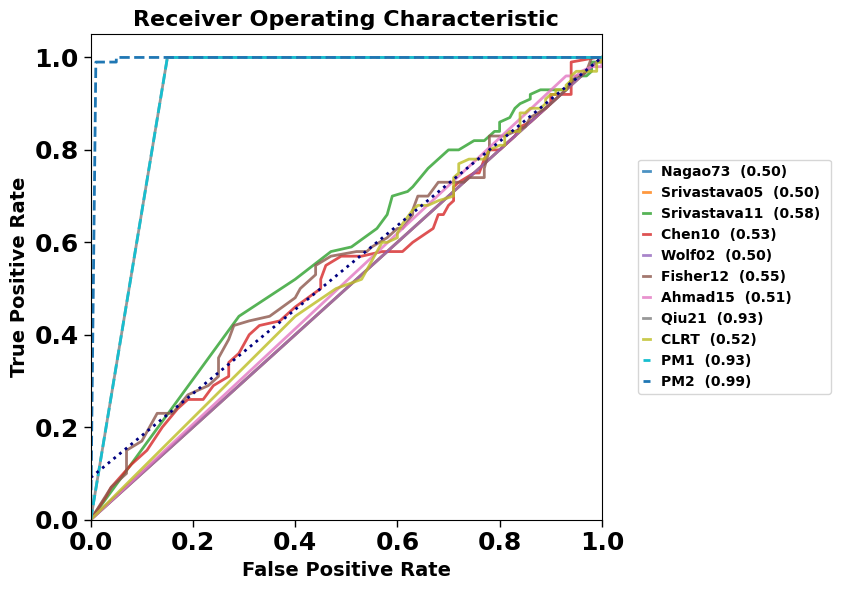

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import files
import matplotlib.gridspec as gridspec
num_matrices=100

def generate_roc_curve(p_values0, p_values1, label, lw=2, linestyle='-', alpha=0.8):
    # calculate TPRs and FPRs for each threshold
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        tpr = np.sum(p_values1 < threshold) / num_matrices
        fpr = np.sum(p_values0 < threshold) / num_matrices

        tprs.append(tpr)
        fprs.append(fpr)

    # calculate AUC
    roc_auc = auc(fprs, tprs)

    # # plot ROC curve
    # # Use string formatting to control the presentation of AUC in the legend
    # legend_text = "{:<16} ({:0.2f})".format(label, roc_auc)

    # # plot ROC curve
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=legend_text)

    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'({roc_auc:.2f}){label} ')

    plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label}  ({roc_auc:.2f}) ')
    # label_padded = label.ljust(15)
    # plt.plot(fprs, tprs, linestyle=linestyle, alpha=alpha,lw=lw, label=f'{label_padded} (AUC: {roc_auc:.2f})')

def bold_legend(legend):
    """Utility function to set legend text to bold."""
    for text in legend.get_texts():
        text.set_fontweight('bold')


def set_ticks_bold(ax):
    """Utility function to set tick labels to bold."""
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 0.2])

fig = plt.figure(figsize=(8.5, 6))

# First subplot
ax0 = fig.add_subplot(gs[0])

# Perform Test1 and plot its ROC curve
p_values0_test1, p_values1_test1 = perform_test(Nagao1973, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test1, p_values1_test1, 'Nagao73',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test1)
# print(p_values1_test1)
# Perform Test2 and plot its ROC curve
p_values0_test2, p_values1_test2 = perform_test(Srivastava2005, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test2, p_values1_test2, 'Srivastava05',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test2)
# print(p_values1_test2)
p_values0_test3, p_values1_test3 = perform_test(Srivastava2011, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test3, p_values1_test3, 'Srivastava11',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test3)
# print(p_values1_test3)
p_values0_test4, p_values1_test4 = perform_test(Chen2010, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test4, p_values1_test4, 'Chen10',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test4)
# print(p_values1_test4)

p_values0_test5, p_values1_test5 = perform_test(LedoitWolf2002, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test5, p_values1_test5, 'Wolf02',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test5)
# print(p_values1_test5)
p_values0_test6, p_values1_test6 = perform_test(Fisher2012, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test6, p_values1_test6, 'Fisher12',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test6)
# print(p_values1_test6)
p_values0_test7, p_values1_test7 = perform_test(Ahmad2015, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test7, p_values1_test7, 'Ahmad15',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test7)
# print(p_values1_test7)
p_values0_test8, p_values1_test8 = perform_test(DW2023Global, Sigmad, m, n, num_matrices)
p_values0_test10, p_values1_test10 = p_values0_test8, p_values1_test8
generate_roc_curve(p_values0_test8, p_values1_test8, 'Qiu21',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test10)
# print(p_values1_test10)

p_values0_test11, p_values1_test11 = perform_test(CLRT, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test11, p_values1_test11, 'CLRT',lw=2, linestyle='-', alpha=0.8)
# print(p_values0_test11)
# print(p_values1_test11)

generate_roc_curve(p_values0_test8, p_values1_test8, 'PM1',lw=2, linestyle='--', alpha=1)
# print(p_values0_test8)
# print(p_values1_test8)
p_values0_test9, p_values1_test9 = perform_test(DW2023Local, Sigmad, m, n, num_matrices)
generate_roc_curve(p_values0_test9, p_values1_test9, 'PM2',lw=2, linestyle='--', alpha=1)
# print(p_values0_test9)
# print(p_values1_test9)




set_ticks_bold(ax0)
ax0.plot([-0.1, 1], [0, 1], color='navy', lw=2, linestyle='dotted')
ax0.set_xlim([0.0, 1.0])
ax0.set_ylim([0.0, 1.05])
ax0.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
ax0.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)

ax0.set_title('Receiver Operating Characteristic', fontweight='bold', fontsize=16)
ax0.tick_params(axis='both', which='major', labelsize=18,  width=1, length=5)



# Second subplot for the legend
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
handles, labels = ax0.get_legend_handles_labels()
legend = ax1.legend(handles, labels, loc='center',handlelength=0.5)
bold_legend(legend)


plt.tight_layout()
plt.savefig("K4equals2treatedasGaussiann100p10000t0dot08.eps",dpi=300, bbox_inches='tight')
files.download("K4equals2treatedasGaussiann100p10000t0dot08.eps")
plt.show()

From the results, we can see that in thisregime, our local statistics behave overall better than our global statistics which takes the wrong $\kappa_4$ as input and other statistics.

# One-Sample Hypothesis Testing - Real Data

## 09data

Here we use the data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE13528, proceeded data is also obtainable from https://www.refine.bio/experiments/GSE13528/gene-expression-profiles-of-fasting-induced-changes-in-liver-and-fat-tissues-of-pigs-expressing-the-mc4r-d298n-variant

### Read Data

In [1]:
# Import necessary modules
from google.colab import files
import pandas as pd
import numpy as np

# Upload the TSV file
uploaded = files.upload()

# Assume the file is named "data.tsv"; replace with your file's name if different
file_name = 'GSE13528.tsv'

# Read the file into a Pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t')

# Only include numeric columns in the DataFrame
df_numeric = df.select_dtypes(include=[np.number])

# Convert the DataFrame to a 2D NumPy array of float type
data_array_2d = df_numeric.to_numpy().astype(float)
data_array_2d_no_first_column = data_array_2d[:, :]

# Compute row-wise mean and standard deviation
row_means = np.mean(data_array_2d_no_first_column, axis=1, keepdims=True)
row_stds = np.std(data_array_2d_no_first_column, axis=1, keepdims=True)

# Check for zero standard deviation to avoid division by zero
if np.any(row_stds == 0):
    print("Warning: At least one row has zero standard deviation!")

# Standardize each row
standardized_data_array = (data_array_2d_no_first_column - row_means) / row_stds

# Display the shape and the standardized 2D NumPy array
print("Shape of 2D array after standardization:", standardized_data_array.shape)
print("Standardized 2D NumPy array:")
print(standardized_data_array)


Saving GSE13528.tsv to GSE13528 (3).tsv
Shape of 2D array after standardization: (7431, 47)
Standardized 2D NumPy array:
[[-1.87420155 -0.21015178  0.4600086  ...  1.64218751  1.37965243
   1.1528463 ]
 [ 0.11785913  1.89829026  0.54241833 ... -0.81702735 -0.99426793
  -0.9027692 ]
 [-0.54344755  0.57483723 -0.48740342 ... -1.35852917 -1.34812689
  -1.04097129]
 ...
 [-0.8151023  -1.04417854 -1.10897926 ...  1.17361101  0.84182685
   1.41484915]
 [-1.76321613 -2.1526713  -1.63587589 ...  0.44818769 -0.4695091
   0.2544299 ]
 [-0.98553276 -1.23452545  0.24771945 ...  0.84175022  0.67169982
   2.00111103]]


### Generating the Covariance Matrix and Visualization of Eigenvalues

In this section, we try different ways of preprocessing the data.

#### X (Full Data Table with only row standardiztion)

In [2]:
X=np.transpose(standardized_data_array) ####all
# X=np.sqrt(47)*np.transpose(standardized_data_array) ####all
#X=np.sqrt(np.sqrt(46/7431))*np.transpose(standardized_data_array) ####all
# X=np.sqrt(np.sqrt(1/46/7431))*np.transpose(standardized_data_array) ####all
print("Shape of 2D array after transpose:", X.shape)

Shape of 2D array after transpose: (47, 7431)


[-2.97835176e-12  1.20563800e+03  1.28402263e+03  1.35374932e+03
  1.35908130e+03  1.42567922e+03  1.48892615e+03  1.52946095e+03
  1.55295229e+03  1.57393577e+03  1.63507788e+03  1.65812156e+03
  1.74984556e+03  1.80346639e+03  1.82200642e+03  1.86020598e+03
  1.88580062e+03  1.91922089e+03  1.96652663e+03  2.00693436e+03
  2.08001352e+03  2.17453627e+03  2.27945108e+03  2.38972276e+03
  2.43380156e+03  2.53442025e+03  2.55386573e+03  2.69932383e+03
  2.81192456e+03  2.96855487e+03  3.05921100e+03  3.16103246e+03
  3.37266771e+03  3.62538606e+03  3.92781828e+03  4.11613805e+03
  4.26797156e+03  4.92800768e+03  5.38638453e+03  6.36547136e+03
  6.54024483e+03  8.34782265e+03  9.28588512e+03  1.04452396e+04
  1.33724403e+04  2.80772727e+04  1.74971740e+05]


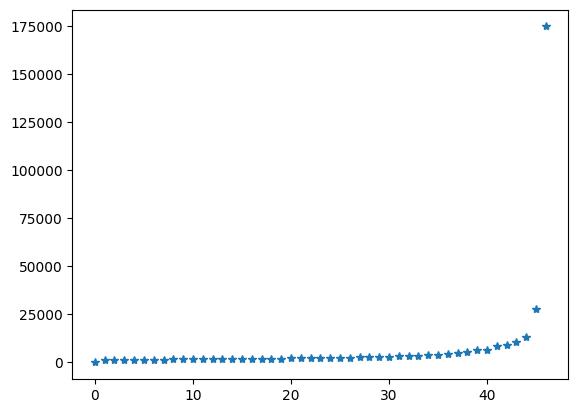

In [64]:
covX=X@np.transpose(X)
E0,_=np.linalg.eigh(covX)
print(E0)
E00=np.array(E0)
E00.sort()
import matplotlib.pyplot as plt
plt.plot(E00,"*")

It can be seen that there are a few outliers and near zero eigenvalues.

#### Y (Randomly Select  s Rows t Columns from the Full Data Table before Doing Row Normalization)

Other than dealing with the normalized raw data directly, we also try randomly selecting s rows (genes) and t columns (observations).

In [10]:
import numpy as np

# Create a sample 2D NumPy array for demonstration
# Assume its shape is (20, 10); you would replace this with your actual 2D array
sample_array = data_array_2d_no_first_column
print("Shape of 2D array after standardization:", sample_array.shape)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 30

np.random.seed(None)

# Make sure s and t are less than or equal to the number of rows and columns in the original array
if s > sample_array.shape[0] or t > sample_array.shape[1]:
    print("s and t should be less than or equal to the number of rows and columns in the original array.")
else:
    # Randomly select s rows and t columns
    selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
    selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)



    ## Print out the selected rows and columns for verification
    # print(f"Selected row indices: {selected_rows}")
    # print(f"Selected column indices: {selected_columns}")



    # Extract those rows and columns to form a new array
    new_array = sample_array[selected_rows][:, selected_columns]

    # Compute row-wise mean and standard deviation for the new array
    row_means = np.mean(new_array, axis=1, keepdims=True)
    row_stds = np.std(new_array, axis=1, keepdims=True)

    # Check for zero standard deviation to avoid division by zero
    if np.any(row_stds == 0):
        print("Warning: At least one row has zero standard deviation!")

    # Standardize each row of the new array
    standardized_new_array = (new_array - row_means) / row_stds

    # Display the standardized new array
    print("Standardized new array with {} randomly selected rows and {} randomly selected columns:".format(s, t))
    # print(standardized_new_array)

Y=np.transpose(standardized_new_array)
Y_row_stds = np.std(standardized_new_array, axis=1, keepdims=True)
# print(Y_row_stds)
# Y=np.sqrt(t)*np.transpose(standardized_new_array)
#Y=np.sqrt(np.sqrt(t/s))*np.transpose(standardized_new_array)

# print(Y)
# pg=DW2023Global2(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
# print(pg)

Shape of 2D array after standardization: (7431, 47)
Standardized new array with 900 randomly selected rows and 30 randomly selected columns:


[-9.49959181e-16  9.12899215e-01  9.79085549e-01  1.04822907e+00
  1.09908910e+00  1.14042529e+00  1.18066026e+00  1.28906643e+00
  1.37168942e+00  1.47455779e+00  1.59336751e+00  1.63878855e+00
  1.66393123e+00  1.73534461e+00  1.79252854e+00  1.81403750e+00
  2.00125421e+00  2.36189525e+00  2.40236797e+00  2.49868246e+00
  2.85886189e+00  3.12210005e+00  3.28842294e+00  3.75166187e+00
  3.91304058e+00  4.63865647e+00  5.61633409e+00  6.14054843e+00
  1.30078684e+01  8.79813726e+01]


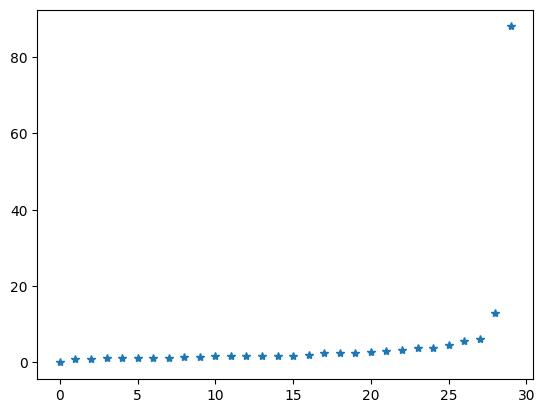

In [68]:
covY=Y@np.transpose(Y)/np.sqrt(s*t)
E0,_=np.linalg.eigh(covY)
print(E0)
E00=np.array(E0)
E00.sort()
import matplotlib.pyplot as plt
plt.plot(E00,"*")

It can be seen that there are a few outliers and near zero eigenvalues.

#### Z (Group and Month Deeffect)

In the preprocessing above, we treated the data as if there are no correlations and structures. In fact, the data are time series (12 months) with certain group structures (4). Since only 47 of 48 observations are downloadable, we discard 9 of them and keep 36=3*12 to de-effect the groups and months.

In [15]:
# Set your desired number of rows and columns
s =7200
t = 36

# Select the first s rows and t columns
selected_data = data_array_2d_no_first_column[:s, :t]


In [16]:
import numpy as np

# Assuming you have data of shape (p, n)
p = s  # For instance, 100 features
n = 36  # 3 groups x 12 months
data = selected_data # Generate random data for the example

num_groups = 3
num_months = 12

# De-effect for the group
for feature in range(p):
    for i in range(num_groups):
        start_idx = i * num_months
        end_idx = (i + 1) * num_months
        group_data = data[feature, start_idx:end_idx]
        group_mean = np.mean(group_data)
        data[feature, start_idx:end_idx] -= group_mean

# De-effect for the month
for feature in range(p):
    for j in range(num_months):
        month_data = data[feature, j::num_months]  # Extract every 12th value starting from j
        month_mean = np.mean(month_data)
        data[feature, j::num_months] -= month_mean

# Now the data array is adjusted for both group and month effects for each feature
print(data)


[[-4.82330689e-02  1.90971731e-02  4.00572704e-02 ... -2.55866927e-02
  -1.76563428e-02 -6.44883707e-03]
 [-1.14442543e-01  5.39168782e-01  7.33330571e-02 ...  2.93166994e-01
   3.26424548e-01  4.65611183e-01]
 [-3.05694900e-02 -2.44337836e-02 -3.01152907e-02 ...  6.21976245e-04
  -7.49606338e-03  1.21116395e-02]
 ...
 [ 2.98317947e-02 -1.63484013e-02 -5.50867121e-02 ... -2.78640157e-01
   7.55377593e-03 -4.05074979e-02]
 [-1.55844121e-01 -6.53782987e-01  3.37614125e-02 ... -1.15430889e+00
   7.45244358e-01 -3.65670184e-01]
 [-1.23627377e-02  2.45902100e-02 -3.27824996e-03 ...  5.23678867e-03
   1.77809510e-02  4.14508408e-03]]


In [17]:
# Compute row-wise mean and standard deviation for the new array
new_array=data
row_means = np.mean(new_array, axis=1, keepdims=True)
row_stds = np.std(new_array, axis=1, keepdims=True)

# Check for zero standard deviation to avoid division by zero
if np.any(row_stds == 0):
    print("Warning: At least one row has zero standard deviation!")

# Standardize each row of the new array
standardized_new_array = (new_array - row_means) / row_stds

Z=np.transpose(standardized_new_array)
# Z=np.sqrt(t)*np.transpose(standardized_new_array)

[-1.27919405e-14 -8.80845806e-15 -6.18319981e-15 -3.88171290e-15
 -6.22177015e-16  3.27475452e-16  2.10965660e-15  2.16903775e-15
  5.96548026e-15  1.07079708e-14  1.36855020e-14  1.57802764e-14
  2.31366100e-14  2.58614967e-14  4.32853910e+00  4.78726276e+00
  5.11104770e+00  5.17866623e+00  5.49550562e+00  5.86972424e+00
  5.95308646e+00  6.17413525e+00  6.84579593e+00  7.12205014e+00
  7.83566572e+00  8.06098936e+00  9.05822804e+00  9.83051298e+00
  1.01095101e+01  1.22124982e+01  1.40999018e+01  1.64740587e+01
  2.01700423e+01  2.21274751e+01  4.67715861e+01  2.75500601e+02]


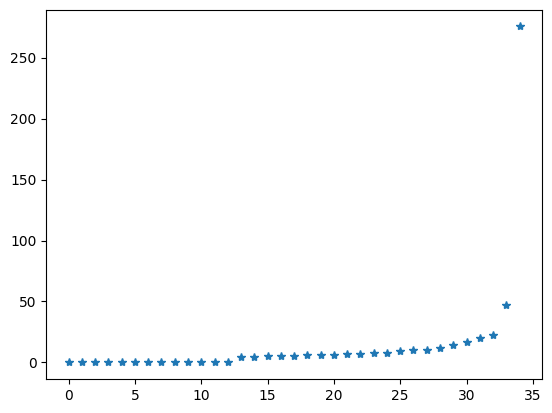

In [72]:
covZ=Z@np.transpose(Z)/np.sqrt(s*t)
E0,_=np.linalg.eigh(covZ)
print(E0)
E00=np.array(E0)
E00.sort()
import matplotlib.pyplot as plt
plt.plot(E00[1:40],"*")

After de-effect the groups and months via simple mean substraction, we can see that the spiked structure is persistent and there are still near 0 eigenvalues.

#### W (ANOVA adjusted, deeffect the genotype by groups  )

We follow similar scheme to the one in [Chen2010] to do the preprocessing, namely we assume the following model:
$$
y_{i j k l}^g=\tau^g+\mu_i^g+\beta_j \mathbf{1}_{p_g}+\alpha_k \mathbf{1}_{p_g}+\eta_G \mathbf{1}_{p_g}+\epsilon_{i j k l}^g,
$$
where $\tau^g$ and $\mu_i^g(i=1,2)$ are $p_g$ dimensional vectors denoting the intercepts and the treatment effects respectively, $\beta_j$ $(j=1, \ldots, 3), \alpha_k(k=1,2)$, and $\eta_G$ are univariate denoting the block, the genotype, and the gene-set effects respectively, $\epsilon_{i j k l}^g$ is the vector of residuals, and $\mathbf{1}_{p_g}$ is the $p_g$ dimensional vector of 1 's.

Similar to $Z$, the above grouping and data selection is partially due to the fact that in 4*12 samples,  only 47 are available, so we discard 11 of them and only keep 3 groups.


The treatment and genotype effects $\mu_i^g$ and $\alpha_k$ are treated as fixed, while the block effect and the GO term effects are random. Further, assume $\mu_2^g=\alpha_2=0$.  To remove the treatment, block and the genotype effects, $\mu_i^g$ and $\tau^g$ are estimated by
$$
\begin{aligned}
\hat{\mu}_i^g & =\frac{1}{n(i)} \sum_{j, k, l} y_{i j k l}^g-\frac{1}{n(2)} \sum_{j, k, l} y_{2 j k l}^g, \quad \\
\hat{\tau}^g & =\frac{1}{n(2)} \sum_{j, k, l} y_{2 j k l}^g,
\end{aligned}
$$
where $n(i)$ is the number of observations in treatment $i$. Then, estimate $\beta$ and $\alpha$ by regression
$$
y_{i j k l}^g-\hat{\mu}_i^g-\hat{\tau}^g=\beta_j I_{p_g}+\alpha_k \mathbf{1}_{p_g}+e_{i j k l}^g .
$$
Here $e_{i j k l}^g$ are the "residuals" representing $\eta_G \mathbf{1}_{p_g}+\epsilon_{i j k l}^g$ in model above via the least square regression.    

We are interested in testing for the covariance structure of $\eta_G \mathbf{1}_{p_g}+\epsilon_{i j k l}^g$. It is not too restrictive to assume $\operatorname{var}\left(\epsilon_{i j k l}^g\right)=\sigma_\epsilon^2 I_{p_g}$ for a positive constant $\sigma_\epsilon^2$. Hence, the covariance of $\eta_G \mathbf{1}_{p_g}+\epsilon_{i j k l}^g$ is
$$
\Sigma=: \sigma_\epsilon^2 I_{p_g}+\sigma_{\eta_G}^2 \mathbf{1}_{p_g} \mathbf{1}_{p_g}^T,
$$
say, where $\sigma_{\eta_G}^2=\operatorname{var}\left(\eta_G\right)$. Let $\Sigma_{\mathcal{S}_g}$ be the covariance matrix corresponding to the gene set $\mathcal{S}_g$.


We want to test the identity hypothesis  $H_{0}: \Sigma_{\mathcal{S}_g}=I_{p_g}$ for $g=1, \ldots, q$ after we plug in a trivial estimator for $\sigma_{ϵ}$.

Moreover, we use two different treatments:

1. We assume that $\sigma_{\eta_G}^2=0$ and directly test about $H_{0}$ .
2. We take the existence of nonvanishing $\sigma_{\eta_G}^2$ into consideration, exclude the spikes and renormalize, then test $H_{0}$  with the remaining eigenvalues.

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Set your desired number of rows and columns
p =7200
n = 3*12

# Select the first s rows and t columns
data = data_array_2d_no_first_column[:p, :n]

treatments = 3
blocks = 12

# Calculate mu_hat and tau_hat
mu_hat = np.zeros((p, treatments))
for i in range(treatments):
    mu_hat[:, i] = np.mean(data[:, i*blocks:(i+1)*blocks], axis=1) - np.mean(data[:, blocks:2*blocks], axis=1)

tau_hat = np.mean(data[:, blocks:2*blocks], axis=1)

# Prepare residuals for linear regression
residuals_for_regression = np.zeros_like(data)
for i in range(treatments):
    residuals_for_regression[:, i*blocks:(i+1)*blocks] = data[:, i*blocks:(i+1)*blocks] - mu_hat[:, i][:, np.newaxis] - tau_hat[:, np.newaxis]

# Create design matrix for linear regression
X_beta = np.tile(np.eye(blocks), (treatments, 1))
X_alpha = np.ones((blocks * treatments, 1))
X = np.hstack([X_beta, X_alpha])
X = np.tile(X, (p, 1))

# Reshape residuals for regression
y = residuals_for_regression.T.reshape(-1)

# Fit the linear model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Get the predicted values
y_pred = model.predict(X)

# Calculate the residuals matrix
e_matrix = y - y_pred
residuals_matrix = e_matrix.reshape((n, p)).T

# Subtract overall mean * 1 * 1^T from residuals_matrix
overall_mean = np.mean(residuals_matrix)
residuals_matrix -= overall_mean * np.ones(residuals_matrix.shape)

# # Normalize each row
# row_norms = np.linalg.norm(residuals_matrix, axis=1, keepdims=True)
# normalized_matrix = residuals_matrix / row_norms


# Extract coefficients
beta = model.coef_[:blocks]
alpha = model.coef_[blocks:]

print("Beta coefficients:", beta)
print("Alpha coefficients:", alpha)
print("Residuals matrix:")
print(residuals_matrix)


Beta coefficients: [-3.34578427e+10 -3.34578427e+10 -3.34578427e+10 -3.34578427e+10
 -3.34578427e+10 -3.34578427e+10 -3.34578427e+10 -3.34578427e+10
 -3.34578427e+10 -3.34578427e+10 -3.34578427e+10 -3.34578427e+10]
Alpha coefficients: [3.34578427e+10]
Residuals matrix:
[[-4.82375194e-02  1.90927226e-02  4.00528199e-02 ... -2.55911432e-02
  -1.76607933e-02 -6.45328755e-03]
 [-1.14420291e-01  5.39191034e-01  7.33553095e-02 ...  2.93189247e-01
   3.26446800e-01  4.65633435e-01]
 [-3.06044580e-02 -2.44687516e-02 -3.01502588e-02 ...  5.87008187e-04
  -7.53103144e-03  1.20766714e-02]
 ...
 [ 2.98311589e-02 -1.63490371e-02 -5.50873479e-02 ... -2.78640793e-01
   7.55314015e-03 -4.05081337e-02]
 [-1.55837127e-01 -6.53775994e-01  3.37684061e-02 ... -1.15430190e+00
   7.45251351e-01 -3.65663191e-01]
 [-1.23557441e-02  2.45972036e-02 -3.27125635e-03 ...  5.24378228e-03
   1.77879446e-02  4.15207769e-03]]


In [25]:
s = 7200
t = 20
sample_array = residuals_matrix
np.random.seed(None)

# Make sure s and t are less than or equal to the number of rows and columns in the original array
if s > sample_array.shape[0] or t > sample_array.shape[1]:
    print("s and t should be less than or equal to the number of rows and columns in the original array.")
else:
    # Randomly select s rows and t columns
    selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
    selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)



    # Print out the selected rows and columns for verification
    # print(f"Selected row indices: {selected_rows}")
    print(f"Selected column indices: {selected_columns}")



    # Extract those rows and columns to form a new array
    new_array = sample_array[selected_rows][:, selected_columns]

    # Compute row-wise mean and standard deviation for the new array
    row_means = np.mean(new_array, axis=1, keepdims=True)
    row_stds = np.std(new_array, axis=1, keepdims=True)

    # Check for zero standard deviation to avoid division by zero
    if np.any(row_stds == 0):
        print("Warning: At least one row has zero standard deviation!")

    # Standardize each row of the new array
    standardized_new_array = (new_array - row_means) / row_stds

    # Display the standardized new array
    print("Standardized new array with {} randomly selected rows and {} randomly selected columns:".format(s, t))
    print(standardized_new_array)

W=np.transpose(standardized_new_array)
# print(Z)
# print(np.var(standardized_new_array))

Selected column indices: [ 9 11 34 23 35 12 13 16  8  0 26 20 33 28  6  4 30 25 22  2]
Standardized new array with 7200 randomly selected rows and 20 randomly selected columns:
[[ 0.28368638  0.81629766 -1.09616469 ...  0.34182413  1.36703654
   0.09826138]
 [ 0.43297467  0.05131877  0.10878314 ...  0.98513408 -0.49149842
   1.32142019]
 [ 0.54921776 -0.20930431 -1.16849589 ...  0.65594129  0.51737222
   0.35812078]
 ...
 [-0.77874543 -0.43510541 -0.82269104 ... -0.52772954  1.04723551
  -0.81909189]
 [-0.80025706 -0.76632935 -0.664351   ... -0.59860291  1.02109853
  -0.67525688]
 [ 0.16928291  0.59808625  0.22585904 ... -0.73151895 -1.02109905
  -1.47769774]]


[-5.46985817e-15 -2.56619927e-15  1.06624798e-14  1.31482332e+00
  1.74656215e+00  3.73495306e+00  4.38150436e+00  4.88788117e+00
  6.34019250e+00  7.31720190e+00  8.25593790e+00  8.82974425e+00
  8.99254390e+00  1.03776563e+01  1.25216678e+01  1.52893917e+01
  1.74919702e+01  2.14243310e+01  4.19170476e+01  2.04649910e+02]


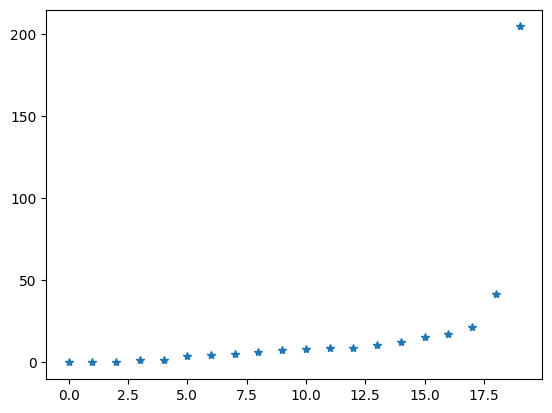

In [75]:
covW=W@np.transpose(W)/np.sqrt(s*t)
E0,_=np.linalg.eigh(covW)
print(E0)
E00=np.array(E0)
E00.sort()
import matplotlib.pyplot as plt
plt.plot(E00,"*")

We can see that the spiked structure is persistent and there are still near 0 eigenvalues even for the residue matrix, which hints us to remove the largest eigenvalue which corresponds to $\sigma_{\eta_G}^2 \mathbf{1}_{p_g} \mathbf{1}_{p_g}^T$.

### Global Test (assuming Gaussian)

In this section, we apply our global test DW2023Global2 which is induced by $x^2$ to data matrices with different ways of preprocessing.

#### X

In [4]:
pg=DW2023Global2(X, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)

0.0


#### Y

In [6]:
pg=DW2023Global2(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)

0.0


repeat the random selection scheme for 100 times

In [7]:
import numpy as np

sample_array = data_array_2d_no_first_column

# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 40

# List to store all pg values
pg_values = []

for _ in range(200):  # repeat 100 times
    np.random.seed(None)

    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds


        Y = np.transpose(standardized_new_array)
        # Y = np.sqrt(t) * np.transpose(standardized_new_array)
        # Y = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)

        pg = DW2023Global2(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pg_values.append(pg)

print("All pg values after 100 iterations:")
print(pg_values)


All pg values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

#### Z

Other than the naive test, we also used a modified version DW2023Global2modified which excludes the spikes and near zero eigenvalues.

In [11]:
pg=DW2023Global2(Z, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)
pg=DW2023Global2modified(Z, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)

0.0
0.0


randomly extract submatrices and repeat 100 times

In [12]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 36

# List to store all pg values
pg_values = []
np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        Zt= np.transpose(standardized_new_array)
        # Zt= np.sqrt(t) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)

        pg = DW2023Global2(Zt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pg_values.append(pg)

print("All pg values after 100 iterations:")
print(pg_values)

All pg values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [13]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 42
t = 36

# List to store all pg values
pg_values = []
# np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(t) * np.transpose(standardized_new_array)
        Zt = np.transpose(standardized_new_array)


        pg = DW2023Global2(Zt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pg_values.append(pg)

print("All pg values after 100 iterations:")
print(pg_values)

All pg values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

#### W

Since we can see from the eigen plot that the existing spikes, we remove largest eigenvalues/near zero eigenvalues and normalize before testing.

In [16]:
n,p=W.shape
H = np.matmul(W, W.T) / np.sqrt(n * p)
TestST=np.trace(H)
# Compute eigenvalues of H
eigvals = np.linalg.eigvalsh(H)

    # Filter eigenvalues below 10^-3 and above 100
filtered_eigvals = eigvals[(eigvals < 1e-3) | (eigvals > 100)]

    # Subtract the sum of squares of filtered eigenvalues from TestST
# TestST0 = np.trace(np.matmul(H, H))
TestST = np.trace(H) - np.sum(filtered_eigvals)

normalize_constant=TestST/n/np.sqrt(p/n)
print(normalize_constant)
    # Record the number of such eigenvalues as ns
# ns = len(filtered_eigvals)

0.44979893055089815


In [18]:
pg=DW2023Global2(W/normalize_constant, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)
pg=DW2023Global2modified(W/normalize_constant, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pg)

0.0
0.0


randomly select submatrices and repeat 100 times

In [20]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 36

# List to store all pg values
pg_values = []
np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        Zt= np.transpose(standardized_new_array)
        # Zt= np.sqrt(t) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)

        nt,pt=Zt.shape
        Ht = np.matmul(Zt, Zt.T) / np.sqrt(nt * pt)
        eigvals = np.linalg.eigvalsh(Ht)  # Compute eigenvalues of H, in ascending order
        max_eigval = eigvals[-1]  # Extract the largest eigenvalue
        normalize_constantt=(np.trace(Ht)-max_eigval)/nt/np.sqrt(pt/nt)
        # print(normalize_constantt)

        pg = DW2023Global2(Zt/normalize_constantt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pg_values.append(pg)

print("All pg values after 100 iterations:")
print(pg_values)

All pg values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [21]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 42
t = 36

# List to store all pg values
pg_values = []
# np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(t) * np.transpose(standardized_new_array)
        Wt = np.transpose(standardized_new_array)


        pg = DW2023Global2(Wt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pg_values.append(pg)

print("All pg values after 100 iterations:")
print(pg_values)

All pg values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

### Local Test

#### Prerun for local

Since real data is quite different from simulated data, we use different hyperparameters here. Therefore, we define a local function "DW2023Local" in this subsection only.

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit,random
from jax.random import normal
import numpy as np
import matplotlib.pyplot as plt

# for t=0: 1: 0.1
t=0.000


n = 60
R = 1000
c=0
T = jnp.zeros(R)
# key = jax.random.PRNGKey(0)

# for k in range(R):
#     key, subkey = jax.random.split(key)
#     X = normal(subkey, shape=(m, n))
#     T = T.at[k].set(objective(X))


TestST=np.array(T)

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count


def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]



K4=0

# Normalize_TestST=(TestST-(n*(1+1/(c-1/np.sqrt(phi))**2)+1/(c-1/np.sqrt(phi))**2)*np.ones(R))/np.sqrt((4+4*2*(-1/np.sqrt(phi)+1/(c-1/np.sqrt(phi))+1/n/(c-np.sqrt(phi)))**2)/((c-1/np.sqrt(phi))**4))
# plot_ecdf_and_standard_normal_cdf(Normalize_TestST)


pn=2*jnp.ones(n)

# eta=1/(n**(1/4))
eta=5

# k=int(n*eta)
R0=10000


#calculate the null distribution
phi=10
m=int(n*phi)
r=jnp.sqrt(phi)

leftb = jnp.sqrt(phi)+1/jnp.sqrt(phi)-2
    # objective_grad = jit(grad(objective))
T0 = jnp.zeros(R0)
key = jax.random.PRNGKey(4)
for r in range(R0):
    key, subkey = jax.random.split(key)
    X = random.normal(key, shape=(m, n))
    H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
    E00, _ = jnp.linalg.eigh(H)
    E0=np.array(E00)
    Et = jnp.array(extract_elements(E0, leftb-eta, leftb+eta))
    # print(E0[-k:])
    Eb = (Et - leftb*jnp.ones(Et.shape))/eta
    t0=jnp.sum(Eb)
    T0 = T0.at[r].set(t0)
TestST0=np.array(T0)
Mean_x=jnp.mean(TestST0)
Variance_x=jnp.var(TestST0)
print(Mean_x)
print(Variance_x)

20.202404
0.07956229


In [3]:
Mean_x=20.202404
Variance_x=0.007956229

In [7]:
def DW2023Local(X, Sigma="identity", c=0, K4=0, alternative='two-sided'):
    # m=X.shape[0]
    # n=X.shape[1]
    m=X.shape[1]
    n=X.shape[0]
    phi=m/n
    r=np.sqrt(phi)
    leftb=r+1/r-2+c
    H = np.matmul(X, X.T) / np.sqrt(n * m)
    E0, _ = np.linalg.eigh(H)
    eta=5
    # print(E0)
    Et = np.array(extract_elements(E0, leftb-eta, leftb+eta))
    # print(Eb)
    # print(E0[-k:])
    Eb = (Et - leftb*np.ones(Et.shape))/eta
    # print(Eb)
    TestST=np.sum(Eb)
    z_score=(TestST-Mean_x)/np.sqrt(Variance_x)
    # print(z_score)
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_score)
    elif alternative == 'less':
        p_value = norm.cdf(z_score)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater' or 'less'")

    return p_value


#### X

In [8]:
pl=DW2023Local(X, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pl)

0.0


#### Y

In [11]:
pl=DW2023Local(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pl)

0.0


randomly select submatrices and repeat 100 times

In [21]:
import numpy as np

sample_array = data_array_2d_no_first_column

# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 40

# List to store all pg values
pl_values = []

for _ in range(200):  # repeat 100 times
    np.random.seed(None)

    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        Y = np.transpose(standardized_new_array)
        # Y = np.sqrt(t) * np.transpose(standardized_new_array)
        # Y = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)

        pl = DW2023Local(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)


All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [22]:
import numpy as np

sample_array = data_array_2d_no_first_column

# Set the number of rows (s) and columns (t) you want to randomly select
s = 40
t = 40

# List to store all pg values
pg_values = []

for _ in range(200):  # repeat 100 times
    np.random.seed(None)

    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        Y = np.transpose(standardized_new_array)
        # Y = np.sqrt(t) * np.transpose(standardized_new_array)
        # Y = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)


        pl = DW2023Local(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)


All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

#### Z

In [18]:
pl=DW2023Local(Z, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pl)

0.0


randomly select submatrices and repeat 100 times

In [20]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 36

# List to store all pg values
pl_values = []
np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds


        Zt= np.transpose(standardized_new_array)
        # Zt= np.sqrt(t) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)


        pl = DW2023Local(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)


All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [23]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 42
t = 36

# List to store all pg values
pg_values = []
# np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(t) * np.transpose(standardized_new_array)
        Zt = np.transpose(standardized_new_array)


        pl = DW2023Local(Y, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)


All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

#### W

Similar to the treatment in Global testing, we remove largest eig and normalize before testing.

In [26]:
# calculate the approximated normalizing constant
n,p=W.shape
H = np.matmul(W, W.T) / np.sqrt(n * p)
eigvals = np.linalg.eigvalsh(H)  # Compute eigenvalues of H, in ascending order
max_eigval = eigvals[-1]  # Extract the largest eigenvalue
normalize_constant=(np.trace(H)-max_eigval)/n/np.sqrt(p/n) #calculating the normalization constant after removing the largest eigenvalues
print(normalize_constant)

0.4842469165931086


We can see that we reject no matter we exclude the spike or not.

In [27]:
pl=DW2023Local(W, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pl)

pl=DW2023Local(W/normalize_constant, Sigma="identity", c=0, K4=0, alternative='two-sided')
print(pl)


0.0
0.0


randomly select submatrices and repeat 100 times

In [28]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 900
t = 36

# List to store all pg values
pl_values = []
np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        Wt= np.transpose(standardized_new_array)
        # Zt= np.sqrt(t) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)

        nt,pt=Wt.shape
        Ht = np.matmul(Wt, Wt.T) / np.sqrt(nt * pt)
        eigvals = np.linalg.eigvalsh(Ht)  # Compute eigenvalues of H, in ascending order
        max_eigval = eigvals[-1]  # Extract the largest eigenvalue
        normalize_constantt=(np.trace(Ht)-max_eigval)/nt/np.sqrt(pt/nt)
        # print(normalize_constantt)

        pl = DW2023Local(Wt/normalize_constantt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)

All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [30]:
sample_array = np.transpose(Z)
# Set the number of rows (s) and columns (t) you want to randomly select
s = 42
t = 36

# List to store all pg values
pl_values = []
# np.random.seed(None)
for _ in range(200):  # repeat 100 times


    # Make sure s and t are less than or equal to the number of rows and columns in the original array
    if s > sample_array.shape[0] or t > sample_array.shape[1]:
        print("s and t should be less than or equal to the number of rows and columns in the original array.")
        break
    else:
        # Randomly select s rows and t columns
        selected_rows = np.random.choice(sample_array.shape[0], size=s, replace=False)
        selected_columns = np.random.choice(sample_array.shape[1], size=t, replace=False)

        # Extract those rows and columns to form a new array
        new_array = sample_array[selected_rows][:, selected_columns]

        # Compute row-wise mean and standard deviation for the new array
        row_means = np.mean(new_array, axis=1, keepdims=True)
        row_stds = np.std(new_array, axis=1, keepdims=True)

        # Check for zero standard deviation to avoid division by zero
        if np.any(row_stds == 0):
            print("Warning: At least one row has zero standard deviation!")
            continue

        # Standardize each row of the new array
        standardized_new_array = (new_array - row_means) / row_stds

        # Zt = np.sqrt(np.sqrt(t/s)) * np.transpose(standardized_new_array)
        # Zt = np.sqrt(t) * np.transpose(standardized_new_array)
        Zt = np.transpose(standardized_new_array)


        pl = DW2023Local(Zt, Sigma="identity", c=0, K4=0, alternative='two-sided')
        pl_values.append(pl)

print("All pl values after 100 iterations:")
print(pl_values)

All pl values after 100 iterations:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

We can see that we will reject $\Sigma=\operatorname{Id}$ in all four treatments above.

# Two-Sample Hypothesis Testing: Theoretical and Simulated Data

## ECDF of Global Test Statistics under Null

First of all, we consider the case when there are $m$ features and the sample size $n_1=n_2=n$.

We consider the case when $n=200$,  $\phi=m/n= 50, 100, 150, 200$, we have that the test statistics
$$\operatorname{Tr}(S_1-S_2)\sim \mathcal{N}(0,2(2+\kappa_4))$$

In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np


R = 2000

####################################
phi=50
n=200
m = int(n*phi)

c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)

pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(0)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST11=np.array(T)



phi=50
n=200
m = int(n*phi)

c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)

pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(1)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST12=np.array(T)
################################



phi=100
n=200
m = int(n*phi)



c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(0)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST21=np.array(T)



phi=100
n=200
m = int(n*phi)



c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(1)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST22=np.array(T)
#############################



phi=150
n=200
m = int(n*phi)


c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(0)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST31=np.array(T)





phi=150
n=200
m = int(n*phi)


c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(1)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST32=np.array(T)

###################################


phi=200
n=200
m = int(n*phi)


c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(0)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST41=np.array(T)



phi=200
n=200
m = int(n*phi)


c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)
# Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
# Sigma = jnp.diag(Sigmad)
pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(1)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST42=np.array(T)


CPU times: user 1min 6s, sys: 3.55 s, total: 1min 10s
Wall time: 1min 4s


In [ ]:
TestST1=TestST11-TestST12
TestST2=TestST21-TestST22
TestST3=TestST31-TestST32
TestST4=TestST41-TestST42

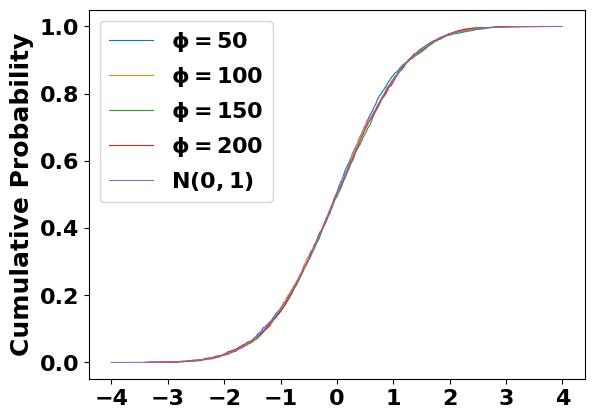

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import files


Normalize_TestST_1=(TestST1)/np.sqrt(4)

Normalize_TestST_2=(TestST2)/np.sqrt(4)

Normalize_TestST_3=(TestST3)/np.sqrt(4)

Normalize_TestST_4=(TestST4)/np.sqrt(4)

labels = ['$\mathbf{\eta_0=n^{-1/4}}$', '$\mathbf{\eta_0=n^{-1/3}}$', '$\mathbf{\eta_0=n^{-1/2}}$', '$\mathbf{\eta_0=n^{-3/5}}$']
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1, Normalize_TestST_2, Normalize_TestST_3, Normalize_TestST_4, labels=labels)


## Subsampling Scheme and Aymptotic Power of Global Test under Alternative



In reality, $n_1=n_2=n$ is seldom the case, wlog we may assume that we have $n_1< n_2$. In this subsection, we  handle the case when
$$\Sigma_1=\operatorname{Id}_p,$$
$$\Sigma_2=\operatorname{diag}\{1, \ldots,1, 1+t,\ldots,1+t\}, \text{(half 1 half 1+t)}$$


The problem is that the scaling $\frac{1}{\sqrt{n_1m}}\Sigma_1^{1/2}X_1X_1^{\top}\Sigma_1^{1/2}$ and $\frac{1}{\sqrt{n_2m}}\Sigma_2^{1/2}X_2X_2^{\top}\Sigma_2^{1/2}$ will reveal the maximum of fluctuation but they are not consistent with each other in the sense that same $\Sigma$ with different $n_1$ and $n_2$ will result in quite different behavior of $S_1$ and $S_2$ here. We use the following subsampling scheme to resolve the issue.



When we are given the $m\times n_2$ matrix $X_2$ or $\Sigma^{1/2}X_2$, we can randomly choose $n_1$ columns out of the $n_2$ columns in total. We can do this random selection $R_2$ times to see if we will get better power as $R_2$ increases.   In the simulation below, every time we get an observation from $\Sigma_1$, we subsampling $R_2$ times from $\Sigma_2$, and we will sample in total $R_1$ observations from $\Sigma_1$.



In practice, when we deal with real data,  we will have only one observation (two data matrices), so $R_1=1$, and we will also need to choose  $R_2$ manually.

### Validity of CLT when $n$ is small

Since in reality the sample sizes are often not large. We first check that our CLT under null is good enough when $n_1$ is as small as 20, $\phi=100$.

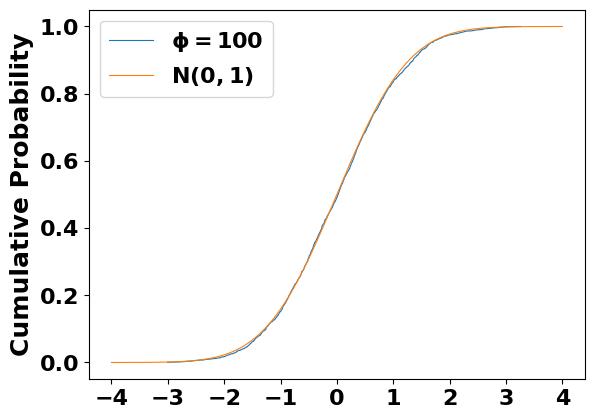

CPU times: user 15.9 s, sys: 2.84 s, total: 18.8 s
Wall time: 15.5 s


In [ ]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import normal
import numpy as np


R = 2000

####################################
phi=100
n=20
m = int(n*phi)

c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)

pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(0)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST11=np.array(T)



phi=100
n=20
m = int(n*phi)

c=3

center3 = (jnp.sqrt(phi)+1/jnp.sqrt(phi)-c)*jnp.ones(n)

pn=2*jnp.ones(n)


@jit
def objective(X):
    # H = jnp.matmul(jnp.matmul(jnp.transpose(X), Sigma), X)
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    Eb = E0 - center3
    # loE=jnp.power(Eb,pn)
    # return jnp.sum(loE)
    return jnp.sum(Eb)

objective_grad = jit(grad(objective))

T = jnp.zeros(R)
key = jax.random.PRNGKey(1)

for k in range(R):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n))/jnp.sqrt(jnp.sqrt(n*m))
    T = T.at[k].set(objective(X))

TestST12=np.array(T)
################################

TestST1=TestST11-TestST12

################################


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import files


phi1=100

r1=np.sqrt(phi1)


# Normalize_TestST_1=(TestST1-2*n*(c-1/r1)*np.ones(np.size(TestST1)))/np.sqrt(4)

Normalize_TestST_1=(TestST1)/np.sqrt(4)

label=["$\mathbf{{\phi=100}}$"]
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1)




### Completely Random Design for Subsampling and its Performance

Now we implement the above scheme to see if test with subsampling will be any benificial. First, we check our code under null (t=0), the False Positive Rate should be close to 5% due to the critical value we chose.

We fix $R_1$ and let $R_2$ increase.

In [53]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 1
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Size = False_Pos / R2 / R1

print(Size)


0.06


In [54]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 10
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Size = False_Pos / R2 / R1

print(Size)


0.057


In [55]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 20
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Size = False_Pos / R2 / R1

print(Size)


0.05575


In [56]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 40
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Size = False_Pos / R2 / R1

print(Size)


0.05225


Now we change the distribution of $\Sigma_2$ s.t. it has half 1 half 1+t diagonal elements and calculate the empirical powers when we have fixed $R_1$ and  increasing $R_2$. We start from $t=0.05$.

In [57]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 1
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0.05

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Power = False_Pos / R2 / R1

print(Power)


0.705


In [58]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 10
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0.05

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Power = False_Pos / R2 / R1

print(Power)


0.701


In [59]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 20
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0.05

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Power = False_Pos / R2 / R1

print(Power)


0.69325


In [60]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
n2 = 200
phi = 100
m = int(n1 * phi)
c = 3
R1 = 200
R2 = 40
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)

# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E0 = jnp.linalg.eigh(H)[0]
    return jnp.sum(E0)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)


# Set t value
t=0.05

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E0 = jnp.linalg.eigh(H)[0]
        T = T.at[l * R2 + k].set(jnp.sum(E0))
TestST12 = np.array(T)

# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12

# Normalize TestST1
Normalize_TestST = TestST1 / np.sqrt(4)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Power = False_Pos / R2 / R1

print(Power)


0.695625


We can see that in the completely randomized design. The effect of increasing $R_2$  on the power is not significant.

## Discussion: How Many Eigenvalues $\beta_n$ Are Adequate for Local Statistics

How many eigenvalues $\beta_n$ we should choose for local statistics remains a non-negligible problem. **In theory**, this is almost equivalent to the  choice of $\eta$ since we expected to include the information of $\mathrm{O}(n^{2/3}\eta)$ (at the edge) or $\mathrm{O}(n\eta)$ (in the bulk) eigenvalues in the local statistics


This is a practical problem that we should answer back when we are dealing with one-sample test.

We have multiple motivations for this question. We start from a tradeoff on the size of $\eta$.

**First**, we want to include enough number of eigenvalues such that the local statistics are stable to certain extent. The large $\eta$ is, the better.

**On the other hand**, when $\eta$ approaches the constant order, the local statistics will become more "global" which results in the occurence of $\kappa_4$ in the related formula, which is something we don't desire.

This motivates us to choose $\eta$ according to the **separation of ECDFs for gaussian and 2PN**.

**Besides** the motivation above, there is also transition of leading eigenvalues from Tracy Widom fluctuation to Gaussian fluctuation. Therefore, the second motivation comes from observing whether there is a visually significant separation of normalized ECDFs for gaussian and 2PN from the ECDF of standard normal.



The above scheme will narrow down the choice of $\eta$ to an acceptable region. However, it is not yet clear that inside the acceptable region which $\eta$ is better. Therefore, the **second subsection** will be devoted to the selection of $\eta$ inside the acceptable region with **comparison of power** via simulated data.

In the third subsection, we will briefly discuss how we could possibly made a joint selection of $\beta_n$ and $K$ according to the data where $K$ is the number of subsampling mentioned in the previous section **Subsampling Scheme**.




### Safe  region of $\beta_n$ and $\eta$

In this subsection, we simply replicate what we have done in Figure 2(b). Further, we adjust the parameter $\eta$ until either
1. a visually significant separation of ECDFs for gaussian and 2PN settings can be observed.
or
2. a visually significant separation of normalized ECDFs for gaussian and 2PN from the ECDF of standard normal the can be observed.

We first conduct the empirical experiments when $n=800$.

When $E$ is in the bulk (where $E$ is the centering of test function), theoretically $\eta$ can go as low as $n^{-1+ɛ}$. The application of our theory mainly focus on the case when $E$ is at the left (or right) edge.  In this case, theoretically $\eta$ can go as low as $n^{-2/3+ɛ}$. However, in practice, going down to the theoretical limit requires careful selection of parameters $a,b$ in $\mathcal{K}_{a,b}(x)$. In the simulation below, we fix b=1 (no tuning) and try to find a generally safe range for $\eta$ regardless of the detailed tuning of test functions.

1.6767457
1.0045049
1.6444167
0.9962823


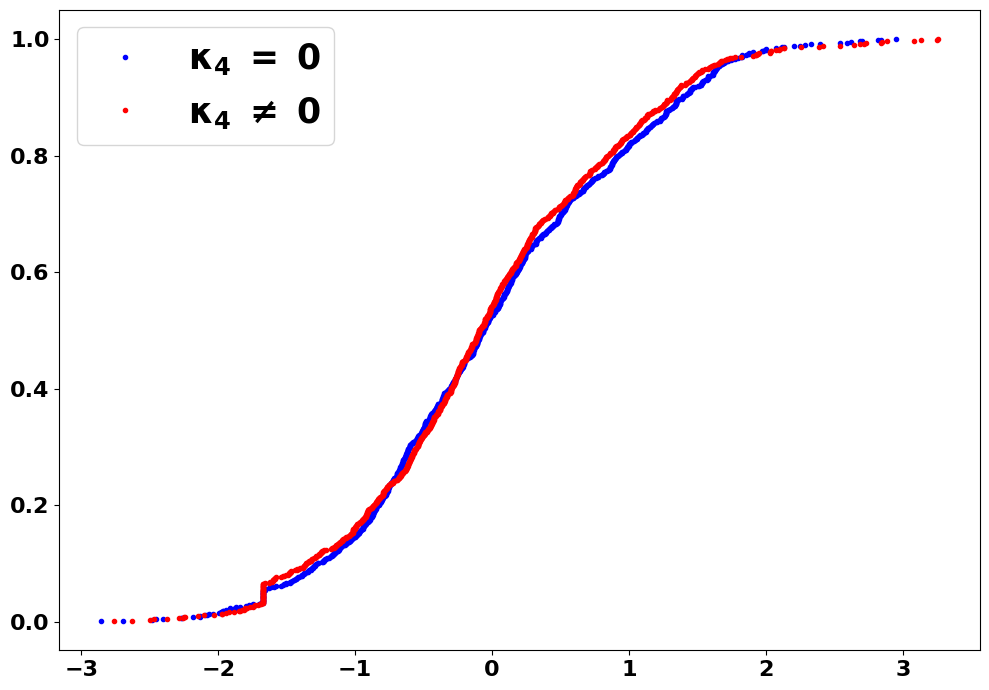

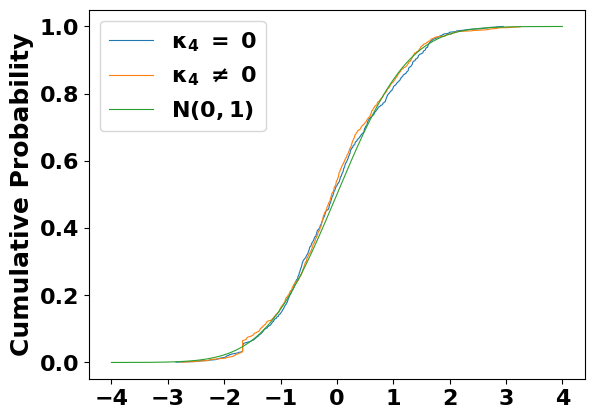

CPU times: user 2min 29s, sys: 3.63 s, total: 2min 33s
Wall time: 2min 27s


In [30]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 800
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(3/5))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-2*eta1, midb+2*eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)

# normalized_data_sets = []
# for phi in phi_values:
#     center = n * (1 + 1 / (c - 1 / np.sqrt(phi))**2) + 1 / (c - 1 / np.sqrt(phi))**2
#     variance = (4 + 4 * 2 * (-1 / np.sqrt(phi) + 1 / (c - 1 / np.sqrt(phi)) + 1 / n / (c - np.sqrt(phi)))**2) / (c - 1 / np.sqrt(phi))**4
#     normalized_data = (eval(f"TestST{phi//50}") - center * np.ones(R)) / np.sqrt(variance)
#     normalized_data_sets.append(normalized_data)

# # Plot the ECDFs
# labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
# plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)
labels=['$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$']
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1,Normalize_TestST_2,labels=labels )

216.40642
2.8900466
216.4998
2.663117


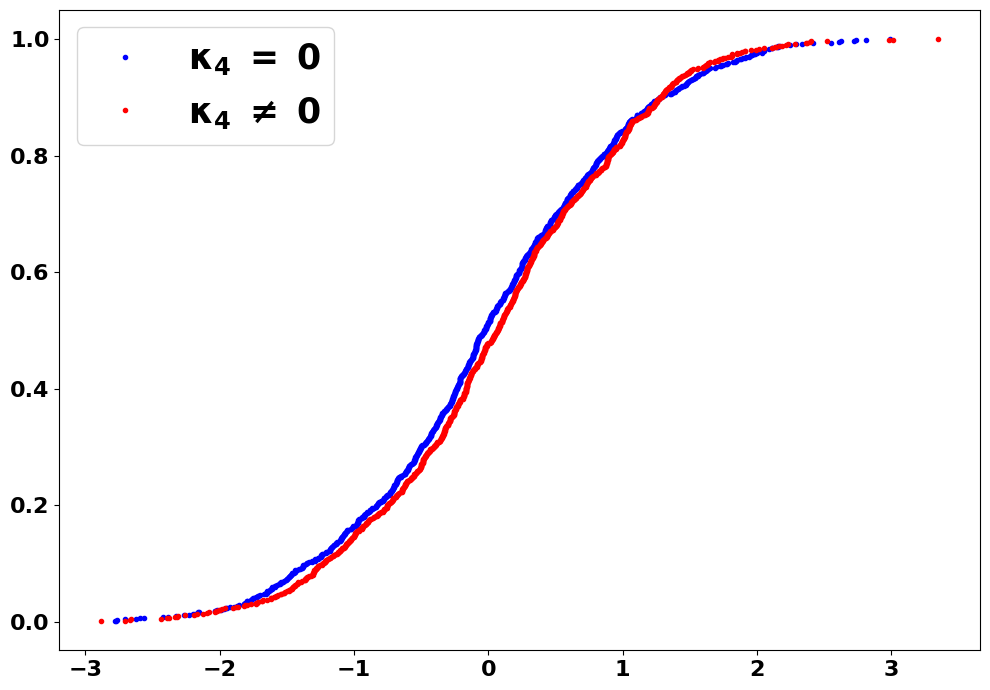

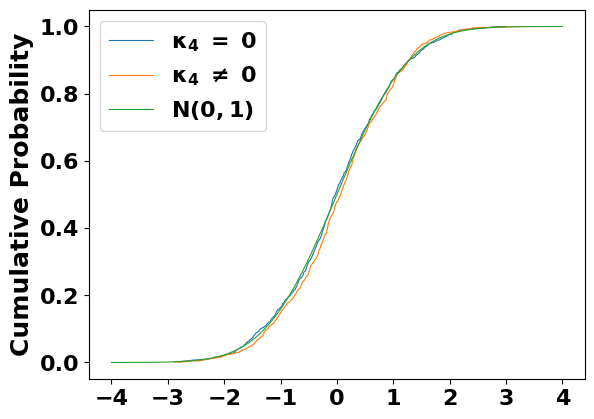

CPU times: user 2min 29s, sys: 3.56 s, total: 2min 33s
Wall time: 2min 28s


In [35]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 800
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/10))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-2*eta1, midb+2*eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)

# normalized_data_sets = []
# for phi in phi_values:
#     center = n * (1 + 1 / (c - 1 / np.sqrt(phi))**2) + 1 / (c - 1 / np.sqrt(phi))**2
#     variance = (4 + 4 * 2 * (-1 / np.sqrt(phi) + 1 / (c - 1 / np.sqrt(phi)) + 1 / n / (c - np.sqrt(phi)))**2) / (c - 1 / np.sqrt(phi))**4
#     normalized_data = (eval(f"TestST{phi//50}") - center * np.ones(R)) / np.sqrt(variance)
#     normalized_data_sets.append(normalized_data)

# # Plot the ECDFs
# labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
# plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)
labels=['$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$']
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1,Normalize_TestST_2,labels=labels )

We can see that when $n$ is as large as 800, $\eta=n^{-1/10}$ is still acceptable, i.e., $\beta_n$ can be as large as $\mathrm{O}(n^{2/3-1/10})$. While $\eta$ as small as $n^{-3/5}$ and $\beta_n=\mathrm{O}(n^{2/3-3/5})$ will be almost the lowest since we can see the minor irregularity in the first plot above.

 When we deal with real data in practice,  $n$ is seldom as large as 800. Therefore, we also conduct the same experiment for smaller $n=100$.

2.6597195
1.1510245
2.5426006
1.0864742


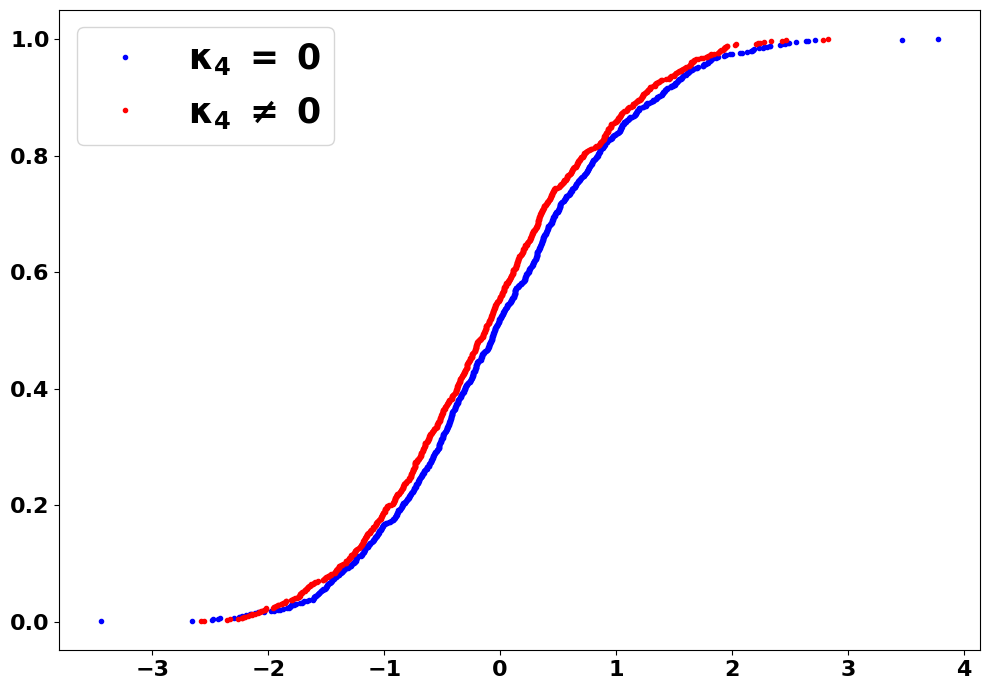

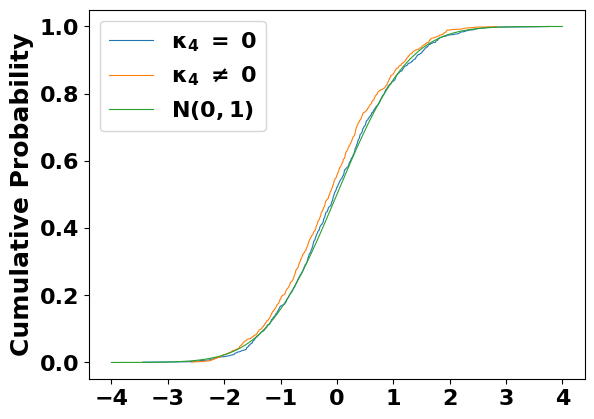

CPU times: user 18.6 s, sys: 3.38 s, total: 22 s
Wall time: 17.6 s


In [33]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 100
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/2))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-2*eta1, midb+2*eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)

# normalized_data_sets = []
# for phi in phi_values:
#     center = n * (1 + 1 / (c - 1 / np.sqrt(phi))**2) + 1 / (c - 1 / np.sqrt(phi))**2
#     variance = (4 + 4 * 2 * (-1 / np.sqrt(phi) + 1 / (c - 1 / np.sqrt(phi)) + 1 / n / (c - np.sqrt(phi)))**2) / (c - 1 / np.sqrt(phi))**4
#     normalized_data = (eval(f"TestST{phi//50}") - center * np.ones(R)) / np.sqrt(variance)
#     normalized_data_sets.append(normalized_data)

# # Plot the ECDFs
# labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
# plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)
labels=['$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$']
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1,Normalize_TestST_2,labels=labels )

7.002521
0.43892038
6.949273
0.44787025


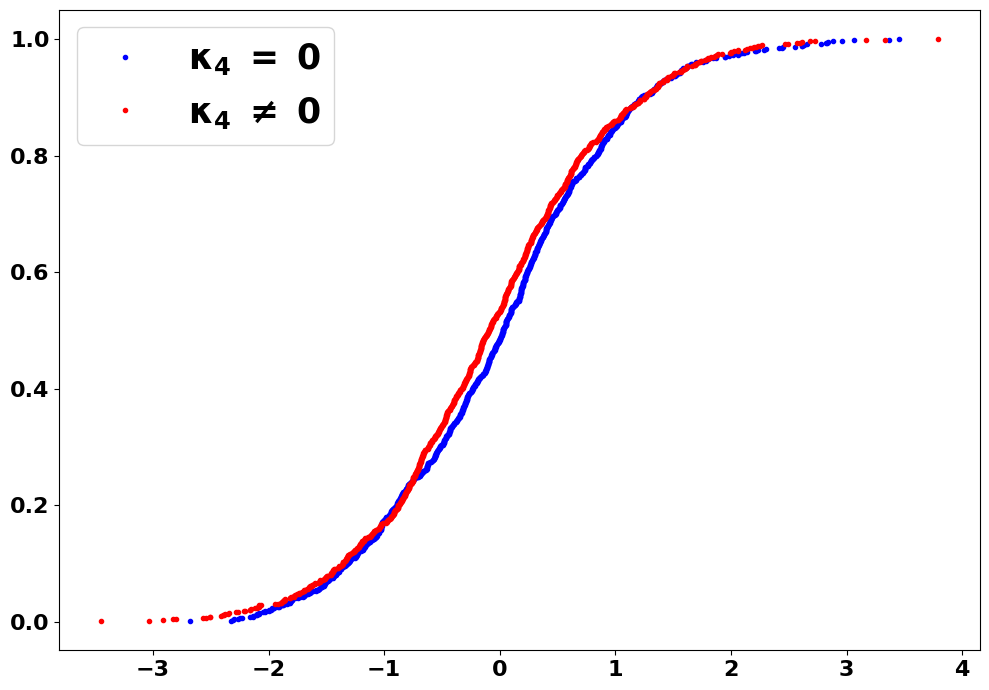

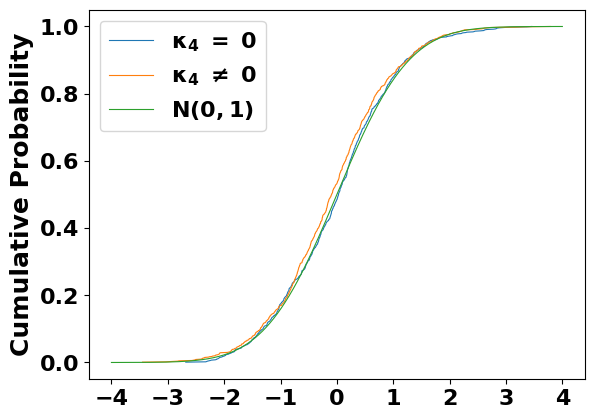

CPU times: user 19 s, sys: 3.41 s, total: 22.4 s
Wall time: 18.4 s


In [34]:
%%time
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.random import normal, choice, split, PRNGKey
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 0.000
n = 100
R0 = 1000
c = 1
phi = 100
m = int(n * phi)
r = jnp.sqrt(phi)

### you may choose between left edge leftb, right edge rightb, middle point midb and any other points in the spectra
leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
midb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi))
rightb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) + 2)


eta1 = 1/(n**(1/10))

## Parameter for 2PN
values = jnp.array([np.sqrt(2), -1/np.sqrt(2)])
probabilities = jnp.array([1/3, 2/3])



def generate_matrix_normal(key, m, n):
    return normal(key, shape=(m, n)) / jnp.sqrt(jnp.sqrt(n * m))


def generate_matrix_choice(key, m, n, values, probabilities):
    return choice(key, a=values, shape=(m, n), p=probabilities) / jnp.sqrt(jnp.sqrt(n * m))

def compute_local_test_statistic(E0, midb, eta1):
    Et = jnp.array(extract_elements(E0, midb-eta1, midb+eta1))
    Eb = (Et - midb * jnp.ones(Et.shape)) / eta1
    return jnp.sum(Eb)

def simulate_local_test_statistics_normal(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X = generate_matrix_normal(subkey, m, n)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)

def simulate_local_test_statistics_choice(R0):
    T0 = jnp.zeros(R0)
    key = PRNGKey(0)
    for r in range(R0):
        key, subkey = split(key)
        X=generate_matrix_choice(key, m, n, values, probabilities)
        H = jnp.matmul(X.T, X)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        t0 = compute_local_test_statistic(E0, leftb, eta1)
        T0 = T0.at[r].set(t0)
    return np.array(T0)



# Simulate test statistics for normal and choice methods
TestST1 = simulate_local_test_statistics_normal(R0)
Mean_x1 = jnp.mean(TestST1)
Variance_x1 = jnp.var(TestST1)
print(Mean_x1)
print(Variance_x1)
Normalize_TestST_1 = (TestST1 - Mean_x1) / np.sqrt(Variance_x1)

TestST2 = simulate_local_test_statistics_choice(R0)
Mean_x2 = jnp.mean(TestST2)
Variance_x2 = jnp.var(TestST2)
print(Mean_x2)
print(Variance_x2)
Normalize_TestST_2 = (TestST2 - Mean_x1) / np.sqrt(Variance_x1)

# normalized_data_sets = []
# for phi in phi_values:
#     center = n * (1 + 1 / (c - 1 / np.sqrt(phi))**2) + 1 / (c - 1 / np.sqrt(phi))**2
#     variance = (4 + 4 * 2 * (-1 / np.sqrt(phi) + 1 / (c - 1 / np.sqrt(phi)) + 1 / n / (c - np.sqrt(phi)))**2) / (c - 1 / np.sqrt(phi))**4
#     normalized_data = (eval(f"TestST{phi//50}") - center * np.ones(R)) / np.sqrt(variance)
#     normalized_data_sets.append(normalized_data)

# # Plot the ECDFs
# labels = [f"$\mathbf{{\phi={phi}}}$" for phi in phi_values]
# plot_ecdf_and_standard_normal_cdf(*normalized_data_sets, labels=labels)
labels=['$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$']
plot_ecdf2(TestST1, TestST2, r'$\mathbf{\kappa_4\ =\ 0}$', r'$\mathbf{\kappa_4\ \neq\ 0}$')
plot_ecdf_and_standard_normal_cdf(Normalize_TestST_1,Normalize_TestST_2,labels=labels )

We can see that $\eta=n^{-1/10}$, $\beta_n=\mathrm{O}({n^{2/3-1/10}})$ is still generally fine, but we do prefer that the lower bound for $\eta$ lifted to $n^{-1/2}$ and $\beta_n\ge n^{1/6}$.

To conclude, we  think the generally safe region for $\eta$ is $[n^{-1/2},n^{-1/10}]$ and the acceptable region for $\beta_n$ is between $[n^{1/6}, n^{1/2}]$ in practice.

### Empirical Power for different $\beta_n$'s

In this subsection, we will compare the empirical power for different $\eta$'s (aka $\beta_n$'s).

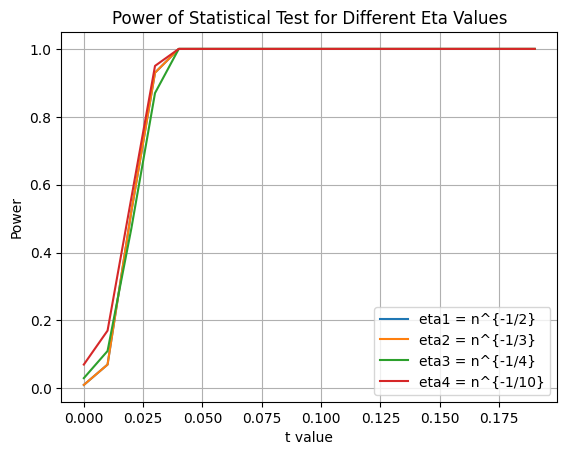

In [40]:
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt

n = 200
R = 100
c = 1
phi = 100
m = int(n * phi)
repeat = 20

def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

def extract_elements(arr, a, b):
    return arr[(arr >= a) & (arr <= b)]

def calculate_null_distribution(eta, R0=1000):
    leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
    T0 = jnp.zeros(R0)
    key = jax.random.PRNGKey(0)
    for r in range(R0):
        key, subkey = jax.random.split(key)
        X = random.normal(key, shape=(m, n))
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        Et = np.array(extract_elements(E0, leftb - eta, leftb + eta))
        Eb = (Et - leftb * jnp.ones(Et.shape)) / eta
        t0 = jnp.sum(Eb)
        T0 = T0.at[r].set(t0)
    return jnp.mean(T0), jnp.var(T0)

def power_phi(n, phi, R, c, t, eta):
    m = int(n * phi)
    Sigmad = jnp.repeat(jnp.array([1, 1 + t]), m // 2)
    leftb = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - 2)
    T = jnp.zeros(R)
    key = jax.random.PRNGKey(0)
    for r in range(R):
        key, subkey = jax.random.split(key)
        X = random.normal(subkey, shape=(m, n))
        X = X * jnp.sqrt(Sigmad)[:, None]
        H = jnp.matmul(X.T, X) / jnp.sqrt(n * m)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        Et = np.array(extract_elements(E0, leftb - eta, leftb + eta))
        Eb = (Et - leftb * jnp.ones(Et.shape)) / eta
        t1 = jnp.sum(Eb)
        T = T.at[r].set(t1)
    TestST = np.array(T)
    Mean_x, Variance_x = calculate_null_distribution(eta)
    Normalize_TestST = (TestST - Mean_x * jnp.ones(R)) / np.sqrt(Variance_x)
    True_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
    return True_Pos / R

eta1= 1/(n**(1/3))
eta2= 1/(n**(1/4))
eta3= 1/(n**(1/5))
eta4= 1/(n**(1/10))
L1 = [power_phi(n, phi, R, c, 0.01 * s, eta1) for s in range(repeat)]
L2 = [power_phi(n, phi, R, c, 0.01 * s, eta2) for s in range(repeat)]
L3 = [power_phi(n, phi, R, c, 0.01 * s, eta3) for s in range(repeat)]
L4 = [power_phi(n, phi, R, c, 0.01 * s, eta4) for s in range(repeat)]
x_values = [0.01 * s for s in range(repeat)]
plt.plot(x_values, L1, label='eta1 = n^{-1/3}')
plt.plot(x_values, L2, label='eta2 = n^{-1/4}')
plt.plot(x_values, L3, label='eta3 = n^{-1/5}')
plt.plot(x_values, L4, label='eta4 = n^{-1/10}')
plt.xlabel('t value')
plt.ylabel('Power')
plt.title('Power of Statistical Test for Different Eta Values')
plt.legend()
plt.grid(True)
plt.show()


We can see that the performance differences are relatively minor.

### Possible joint selection of $\beta$ and $R_2$

We can try to select $\beta$ ($\eta$) and $R_2$ at the same time.
First, with the above two parameters fixed, we use the following scheme to calculate the power for local statistics.

In [45]:
import jax
import jax.numpy as jnp
from jax.random import normal
import numpy as np

# Parameters
n1 = 20
phi = 100
m = int(n1 * phi)
c = 3
R1 = 100
center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)
leftb=np.sqrt(phi)+1/np.sqrt(phi)-2
eta= n1**(-1/3)
# Objective function
def objective(X):
    H = jnp.matmul(jnp.transpose(X), X)
    E00, _ = jnp.linalg.eigh(H)
    E0 = np.array(E00)
    Et = np.array(extract_elements(E0, leftb - eta, leftb + eta))
    Eb = (Et - leftb * jnp.ones(Et.shape)) / eta
    return jnp.sum(Eb)

# Compute TestST11
T = jnp.zeros(R1)
key = jax.random.PRNGKey(0)
for k in range(R1):
    key, subkey = jax.random.split(key)
    X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
    T = T.at[k].set(objective(X))
TestST11 = np.array(T)

mean_X = np.mean(TestST11)
var_X  = np.var(TestST11)


t=0.00
# Parameters for TestST12
n2 = 200
R2 = 200
Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)

# Compute TestST12
T = jnp.zeros(R1 * R2)
key = jax.random.PRNGKey(1)
for l in range(R1):
    X0 = normal(key, shape=(m, n2))
    X = X0 * jnp.sqrt(Sigmad)[:, None]
    for k in range(R2):
        key, subkey = jax.random.split(key)
        selected_columns = np.random.choice(n2, n1, replace=False)
        Xt = X[:, selected_columns]
        H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
        E00, _ = jnp.linalg.eigh(H)
        E0 = np.array(E00)
        Et = np.array(extract_elements(E0, leftb - eta, leftb + eta))
        Eb = (Et - leftb * jnp.ones(Et.shape)) / eta
        T = T.at[l * R2 + k].set(jnp.sum(Eb))
TestST12 = np.array(T)


# Combine TestST11 and TestST12
TestST1 = np.repeat(TestST11, R2) - TestST12


# Normalize TestST1
Normalize_TestST = (TestST1-2*mean_X*np.ones(np.size(TestST1))) / np.sqrt(2*var_X)

# Check outside interval
def count_outside_interval(arr, a, b):
    outside_interval = np.logical_or(arr < a, arr > b)
    count = np.sum(outside_interval)
    return count

False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
Power = False_Pos / R2 / R1
print(Power)


0.3975



To optimize the hyperparameter $\eta$ and $R_2$ for maximizing the power, we first implement a toy Grid Search with Cross-Validation Scheme:

Define a range of values for $\eta$ and $R_2$.

For each combination of eta and R2, compute the power using cross-validation.

Select the combination that gives the highest average power across the cross-validation folds.

In [ ]:
def compute_power(eta, R2, TestST11_train):
    # Parameters
    center3 = (jnp.sqrt(phi) + 1/jnp.sqrt(phi) - c) * jnp.ones(n1)
    leftb = np.sqrt(phi) + 1/np.sqrt(phi) - 2

    # Compute TestST11 for the training data
    T = jnp.zeros(len(TestST11_train))
    key = jax.random.PRNGKey(0)
    for k in range(len(TestST11_train)):
        key, subkey = jax.random.split(key)
        X = normal(subkey, shape=(m, n1)) / jnp.sqrt(jnp.sqrt(n1 * m))
        T = T.at[k].set(objective(X))
    TestST11_train = np.array(T)

    # setting parameter t here
    t=0.05

    # Compute TestST12
    T = jnp.zeros(len(TestST11_train) * R2)
    key = jax.random.PRNGKey(1)
    Sigmad = jnp.repeat(jnp.array([1, 1+t]), m//2)
    for l in range(len(TestST11_train)):
        X0 = normal(key, shape=(m, n2))
        X = X0 * jnp.sqrt(Sigmad)[:, None]
        for k in range(R2):
            key, subkey = jax.random.split(key)
            selected_columns = np.random.choice(n2, n1, replace=False)
            Xt = X[:, selected_columns]
            H = jnp.matmul(jnp.transpose(Xt), Xt) / jnp.sqrt(n1 * m)
            E00, _ = jnp.linalg.eigh(H)
            E0 = np.array(E00)
            Et = np.array(extract_elements(E0, leftb - eta, leftb + eta))
            Eb = (Et - leftb * jnp.ones(Et.shape)) / eta
            T = T.at[l * R2 + k].set(jnp.sum(Eb))
    TestST12 = np.array(T)

    # Combine TestST11 and TestST12
    TestST1 = np.repeat(TestST11_train, R2) - TestST12

    # Normalize TestST1
    Normalize_TestST = (TestST1 - 2 * np.mean(TestST11_train) * np.ones(np.size(TestST1))) / np.sqrt(2 * np.var(TestST11_train))

    # Check outside interval
    False_Pos = count_outside_interval(Normalize_TestST, -1.96, 1.96)
    Power = False_Pos / R2 / len(TestST11_train)

    return Power



from sklearn.model_selection import KFold

# Define a range of values for eta and R2
eta_values = [n1**(-1/2), n1**(-1/3), n1**(-1/4), n1**(-1/5)]
R2_values = [50, 100, 150, 200]

# Cross-validation
kf = KFold(n_splits=5)

best_eta = None
best_R2 = None
best_power = 0

for eta in eta_values:
    for R2 in R2_values:
        powers = []
        for train_index, test_index in kf.split(TestST11):
            # Split the data into training and test sets
            TestST11_train, TestST11_test = TestST11[train_index], TestST11[test_index]

            # Compute the power for this combination of eta and R2 using the training data
            power = compute_power(eta, R2, TestST11_train)  # You need to define the compute_power function
            powers.append(power)

        # Average power across the cross-validation folds
        avg_power = np.mean(powers)

        if avg_power > best_power:
            best_power = avg_power
            best_eta = eta
            best_R2 = R2

print("Best eta:", best_eta)
print("Best R2:", best_R2)
print("Best Power:", best_power)
